参考文章：[TensorFlow - Classify text with BERT](https://tensorflow.google.cn/text/tutorials/classify_text_with_bert), [TensorFlow - Solve GLUE tasks using BERT on TPU](https://tensorflow.google.cn/text/tutorials/bert_glue?_gl=1*gyizha*_ga*MzE5NzQ4ODU5LjE2Njg5MzczMDE.*_ga_W0YLR4190T*MTY3MDgzNTEwMC4xOC4xLjE2NzA4MzUxMDMuMC4wLjA.)

In [1]:
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, Sequential, losses, optimizers, metrics
import tensorflow_hub as hub
import tensorflow_text as text
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

encoder_handle = r'model/bert_zh_L-12_H-768_A-12_4/'
preprocesser_handle = r'model/bert_zh_preprocess_3/'

## 数据预处理

训练集：[online_shopping_10_cats](https://github.com/SophonPlus/ChineseNlpCorpus/blob/master/datasets/online_shopping_10_cats/intro.ipynb).

1. 数据筛选.
2. 平均训练数据.
3. 数据预载入.

数据的格式为，特征：评论文本；标签：(情感类别，商品类别)


In [2]:
df = pd.read_csv(r'../dataset/online_shopping_10_cats.csv')
df

,cat,label,review
0,书籍,1,﻿做父母一定要有刘墉这样的心态，不断地学习，不断地进步，不断地给自己补充新鲜血液，让自己保持...
1,书籍,1,作者真有英国人严谨的风格，提出观点、进行论述论证，尽管本人对物理学了解不深，但是仍然能感受到...
2,书籍,1,作者长篇大论借用详细报告数据处理工作和计算结果支持其新观点。为什么荷兰曾经县有欧洲最高的生产...
3,书籍,1,作者在战几时之前用了＂拥抱＂令人叫绝．日本如果没有战败，就有会有美军的占领，没胡官僚主义的延...
4,书籍,1,作者在少年时即喜阅读，能看出他精读了无数经典，因而他有一个庞大的内心世界。他的作品最难能可贵...
...,...,...,...
62769,酒店,0,我们去盐城的时候那里的最低气温只有4度，晚上冷得要死，居然还不开空调，投诉到酒店客房部，得到...
62770,酒店,0,房间很小，整体设施老化，和四星的差距很大。毛巾太破旧了。早餐很简陋。房间隔音很差，隔两间房间...
62771,酒店,0,我感觉不行。。。性价比很差。不知道是银川都这样还是怎么的！
62772,酒店,0,房间时间长，进去有点异味！服务员是不是不够用啊！我在一楼找了半个小时以上才找到自己房间，想找...


In [3]:
# 删去Nan项
df = df[df.review.isna() == False]

In [4]:
print('评论总数：', df.shape[0])
print('正向评论：', df[df.label==1].shape[0])
print('负向评论：', df[df.label==0].shape[0])

评论总数： 62773
正向评论： 31727
负向评论： 31046


In [5]:
class_names = list(df.cat.drop_duplicates())

In [6]:
info_df = pd.DataFrame(columns=['类别', '总数目', '正例', '负例'])
class2idx = {}
for idx, name in enumerate(class_names):
    tmp = df[df.cat==name]
    info_df.loc[info_df.shape[0]] = [name, tmp.shape[0], tmp[tmp.label==1].shape[0], tmp[tmp.label==0].shape[0]]
    class2idx[name] = idx
info_df

,类别,总数目,正例,负例
0,书籍,3851,2100,1751
1,平板,10000,5000,5000
2,手机,2323,1165,1158
3,水果,10000,5000,5000
4,洗发水,10000,5000,5000
5,热水器,574,474,100
6,蒙牛,2033,992,1041
7,衣服,10000,5000,5000
8,计算机,3992,1996,1996
9,酒店,10000,5000,5000


In [7]:
# 平衡每种类别的商品数目到10000正负例均为5000，不足5000则重复性随机选取，补齐到5000
data_x, data_y = [], []
for name in tqdm(class_names):
    tmp = df[df.cat==name]
    pos, neg = tmp[tmp.label==1], tmp[tmp.label==0]
    if pos.shape[0] < 5000:
        add = pos.sample(5000 - pos.shape[0], replace=True)
        pos = pd.concat([pos, add], ignore_index=True)
    for i in range(pos.shape[0]):
        text = pos.iloc[i][2]
        try:
            text = tf.constant(text, tf.string)
        except:
            print(text)
        data_x.append(text)
        data_y.append((1, class2idx[name]))
    if neg.shape[0] < 5000:
        add = neg.sample(5000 - neg.shape[0], replace=True)
        neg = pd.concat([neg, add], ignore_index=True)
    for i in range(neg.shape[0]):
        text = neg.iloc[i][2]
        text = tf.constant(text, tf.string)
        data_x.append(text)
        data_y.append((0, class2idx[name]))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.26s/it]


In [8]:
# 根据数据集中句子的长度来确定256个输入长度是合理的
df_len = df['review'].apply(lambda x: len(x))
print(df_len.shape)
print(np.sum(df_len<=254))
print(np.percentile(df_len, 98))
df_len.describe()

(62773,)
61430
263.0


count    62773.000000
mean        58.414892
std         78.748469
min          1.000000
25%         21.000000
50%         34.000000
75%         64.000000
max       2876.000000
Name: review, dtype: float64

## 模型预处理

In [9]:
ds = tf.data.Dataset.from_tensor_slices((data_x, data_y))

### Preprocess预处理结果
对于输入字符串 `你好`，预处理会在字符串开头和结尾处加上开始符号和停止符号，变为 `[CLS]你好[SEP]`，在原有序列长度上增加2.

1. `input_mask`：一个one-hot向量，1表示有字，0表示没有字.
2. `input_word_ids`：将每个字进行编码，101表示`[CLS]`，102表示`[SEP]`.
3. `input_type_ids`：只有在两句话作为输入特征时才有作用，用于划分两句话.

### Bert输出结果
1. `pooled_output`：输入的句子向量. `[bath_size, 768]`.
2. `sequence_output`：最后一个transform的输出结果. `[batch_size, 128, 768]`.
3. `encoder_outputs`：长度为12的list，对应12个transform的输出结果. `[12, batch_size, 128, 768]`.

### 建立预处理模型

In [10]:
# 自定义预处理模型
# preprocessor = hub.KerasLayer(r'model/bert_zh_preprocess_3/')
def bert_preprocessor(sentence_features, seq_length=128):
    text_inputs = [layers.Input(shape=(), dtype=tf.string, name=ft)
                   for ft in sentence_features]  # 处理输入的句子特征
    
    preprocessor = hub.load(preprocesser_handle)
    tokenize = hub.KerasLayer(preprocessor.tokenize, name='tokenizer')
    tokenized_inputs = [tokenize(segment) for segment in text_inputs]  # 将句子划分为字
    
    packer = hub.KerasLayer(
        preprocessor.bert_pack_inputs,
        arguments=dict(seq_length=seq_length),
        name='packer'
    )
    encoder_inputs = packer(tokenized_inputs)
    return keras.Model(text_inputs, encoder_inputs, name='preprocessor')
preprocessor = bert_preprocessor(['input1'])

In [11]:
x = tf.constant(['你好呀', '不好但是'])
x_preprocessed = preprocessor(x)
print(f"{'Keys':<15}: {list(x_preprocessed.keys())}")
print(f"{'Shape Word Ids':<15}: {x_preprocessed['input_word_ids'].shape}")
print(f"{'Word Ids':<15}: {x_preprocessed['input_word_ids'][0,:12]}")
print(f"{'Shape Mask':<15}: {x_preprocessed['input_mask'].shape}")
print(f"{'Input Mask':<15}: {x_preprocessed['input_mask'][0,:12]}")
print(f"{'Shape Type Ids':<15}: {x_preprocessed['input_type_ids'].shape}")
print(f"{'Type Ids':<15}: {x_preprocessed['input_type_ids'][0,:12]}")

Keys           : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape Word Ids : (2, 128)
Word Ids       : [ 101  872 1962 1435  102    0    0    0    0    0    0    0]
Shape Mask     : (2, 128)
Input Mask     : [1 1 1 1 1 0 0 0 0 0 0 0]
Shape Type Ids : (2, 128)
Type Ids       : [0 0 0 0 0 0 0 0 0 0 0 0]


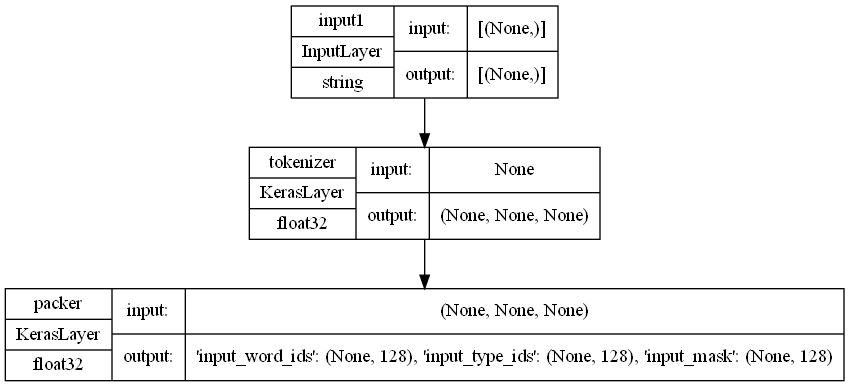

In [12]:
keras.utils.plot_model(preprocessor, show_shapes=True, show_dtype=True, to_file='Preprocessor.png')

### 建立bert模型

In [13]:
bert_model = hub.KerasLayer(encoder_handle)

In [14]:
# 一个两个输入句子的例子
# x = [tf.constant(['国破山河在']), tf.constant(['城春草木深'])]
# 句子转为向量
text = tf.constant(['国破山河在'])
text_preprocessed = preprocessor(text)
bert_results = bert_model(text_preprocessed)
print(bert_results.keys())
bert_results['pooled_output'][0].numpy().shape

dict_keys(['pooled_output', 'encoder_outputs', 'sequence_output', 'default'])


(768,)

In [15]:
def build_classifier():
    class Classifier(keras.Model):
        def __init__(self):
            super().__init__(name='prediction')
            self.encoder = hub.KerasLayer(encoder_handle, trainable=True)
            # self.dense = layers.Dense(768, activation='relu')
            self.dropout = layers.Dropout(0.3)
            self.emotion = layers.Dense(1)  # 情感分类
            self.classifier = layers.Dense(10)  # 文本分类
            
        def call(self, text):  # 经过预处理后的文本
            output = self.encoder(text)
            pooled_output = output['pooled_output']
            x = self.dropout(pooled_output)
            x1 = self.emotion(x)
            x2 = self.classifier(x)
            return (x1, x2)
    
    model = Classifier()
    return model

# model = build_classifier()
# model.build(input_shape=())

In [24]:
def build_classifier():
    text_input = layers.Input(shape=(), dtype=tf.string, name='input')
    text_preprocessed = preprocessor(text_input)
    encoder = hub.KerasLayer(encoder_handle, trainable=True)
    x = encoder(text_preprocessed)['pooled_output']
    x = layers.Dropout(0.3)(x)
    x1 = layers.Dense(1, name='emotion')(x)
    x2 = layers.Dense(10, name='classifier')(x)
    return keras.Model(text_input, [x1, x2])
classifier_model = build_classifier()

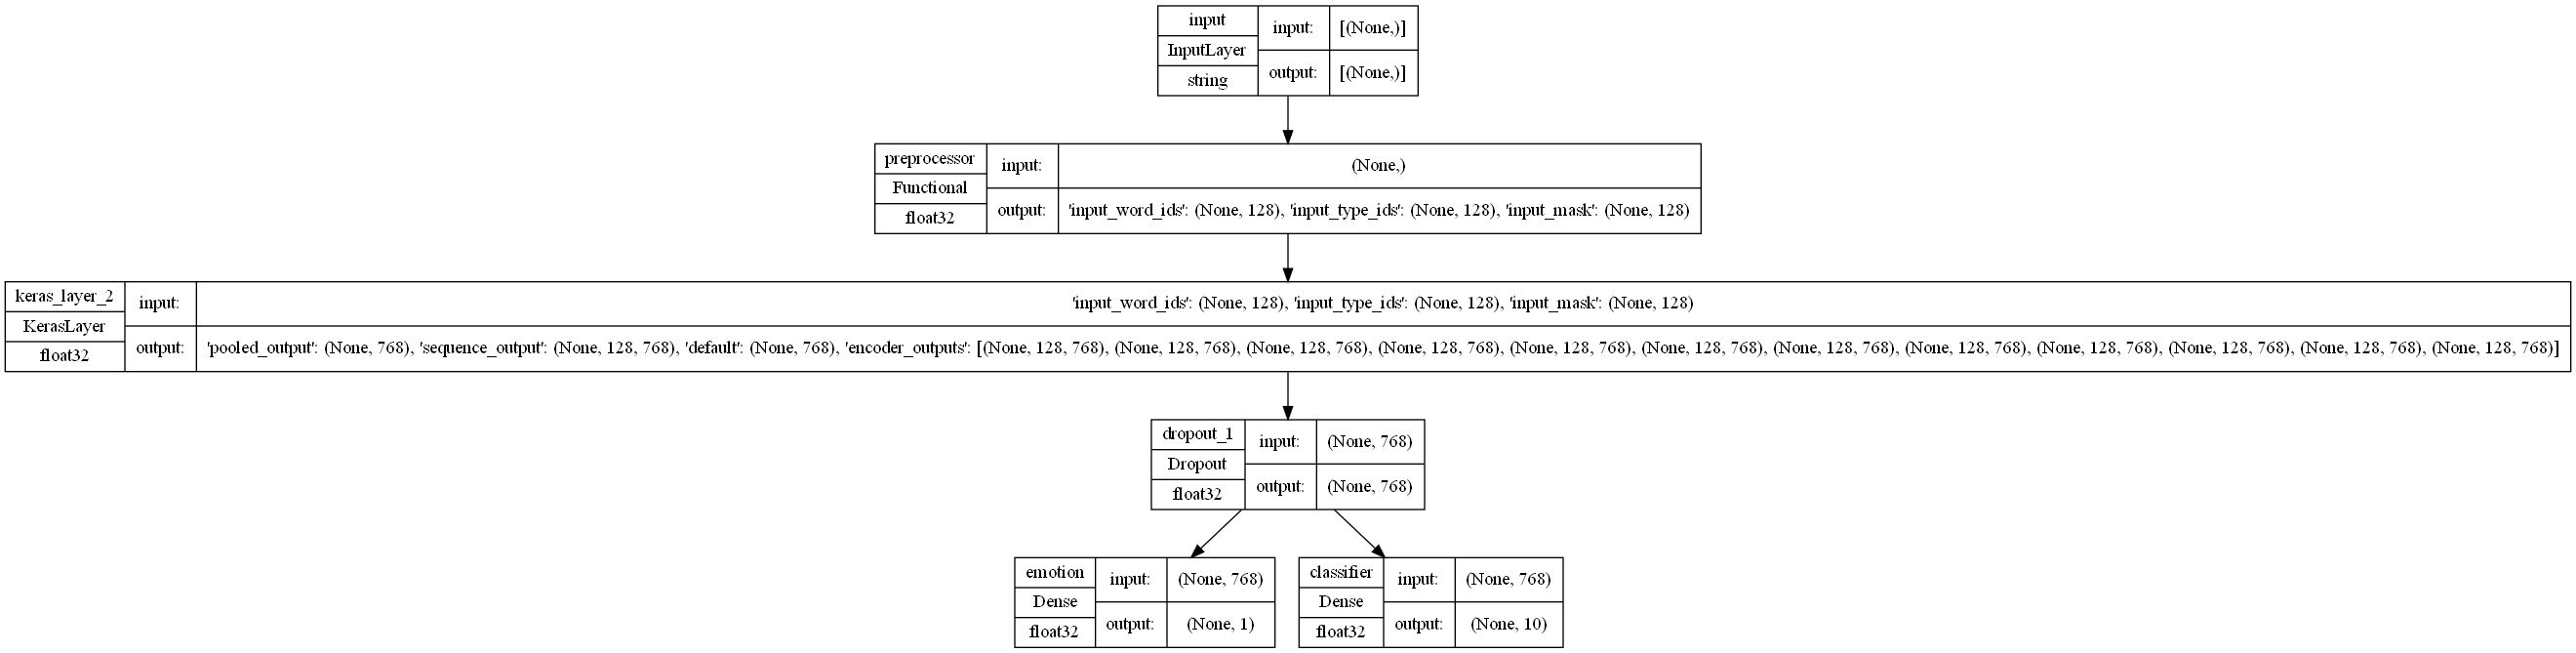

In [25]:
keras.utils.plot_model(classifier_model)

In [18]:
# 测试输出
model(text)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[ 1.6292303 , -1.0054826 , -0.7634496 ,  1.1294322 , -0.12938678,
         0.28950632,  0.17612672,  0.6195059 , -0.9633723 , -0.8003976 ]],
      dtype=float32)>

In [19]:
# 超参数配置
batch_size = 16
batch_N = 100000 / 32
epochs = 10
optimizer = optimizers.Adam(learning_rate=1e-4)  # Adam优化器，设定步长
emotion_loss = losses.BinaryCrossentropy(from_logits=True)  # 情感分类使用二元交叉熵
class_loss = losses.SparseCategoricalCrossentropy(from_logits=True)  # 物品分类使用一般的交叉熵
dataset = ds.shuffle(100000).batch(batch_size).repeat(epochs)  # 随机打乱样本，设定batch大小
# 计数器
emotion_acc = keras.metrics.SparseCategoricalAccuracy('emotion_acc')  # 情感分类上的准确率
emotion_loss= keras.metrics.Mean('emotion_loss', dtype=tf.float32)  # 情感分类的平均损失
class_acc = keras.metrics.SparseCategoricalAccuracy('class_acc')  # 物品分类上的准确率
class_loss = keras.metrics.Mean('class_loss', dtype=tf.float32)  # 物品分类上的平均损失
metrics = [emotion_acc, emotion_loss, class_acc, class_loss]

In [20]:
x, y = next(dataset.as_numpy_iterator())
y[:, 1]

array([0, 5, 9, 9, 2, 4, 0, 7, 7, 7, 5, 6, 3, 9, 9, 3])

In [21]:
x, y = next(dataset.as_numpy_iterator())
x_preprocessed = preprocessor(x)
len(x_preprocessed['input_word_ids'][0])

128

In [22]:
model(x)

<tf.Tensor: shape=(16, 10), dtype=float32, numpy=
array([[-0.74692667,  0.7622469 , -1.0320147 ,  0.8943902 , -0.42104408,
         0.6864464 , -0.24381846,  0.3489207 , -1.2311673 , -0.83780754],
       [-0.37500426,  0.98117554, -1.6841952 , -0.08145875, -0.43998265,
         0.34713265, -0.6000997 , -0.35251603, -1.3089063 ,  0.71663946],
       [-0.13427585,  0.46746367, -1.153739  ,  0.58471787, -0.876458  ,
         0.18806921, -0.30630952, -0.03720897, -1.1729581 ,  0.04244828],
       [-0.56191   ,  0.24845058, -0.80842537,  0.11069986, -0.8070535 ,
        -0.29863247, -1.3658584 ,  0.06038314, -0.5190322 , -0.41396084],
       [-0.5406269 ,  0.34976333, -1.0875177 ,  0.22362715, -0.50814694,
         0.5376591 , -1.3511177 ,  0.26146203, -0.6205789 ,  0.12417677],
       [ 0.20327014,  1.0523742 , -1.5672673 ,  0.31655812, -0.534601  ,
        -0.01766209, -0.37941378,  0.8576982 , -0.34425434, -0.31748885],
       [ 0.02983159,  0.7915439 , -1.0569726 , -0.25900662, -0.59464

In [23]:
history = dict([(metric.name, []) for metric in metrics])
print("Start training!!!")
for step, (x, y) in enumerate(dataset):
    emotion_y = tf.reshape(y[:, 0], [-1, 1])  # 情感标签
    classes_y = tf.reshape(y[:, 1], [-1, 1])  # 分类标签
    print("GG")
    with tf.GradientTape() as tape:
        emotion, classes = model(x)  # 模型预测
        print("GG")
        loss1 = emotion_loss(emotion_y, emotion)  # y=(batch, 2)
        loss2 = class_loss(classes_y, classes)
        loss = tf.reduce_mean(loss1 + loss2)  # 将两个loss求和作为总损失
    print("GG")
    grads = tape.gradient(loss, model.trainable_variables)  # 求梯度
    optimizer.apply_gradients(zip(grads, model.trainable_variables))  # 更新网络参数

    emotion_acc.update_state(emotion_y, emotion)
    emotion_loss.update_state(loss1)
    class_acc.update_state(classes_y, classes)
    class_loss.update_state(loss2)

    if step % 10 == 0:
        s = f"step={step}/{batch_N * epochs}: "
        for metric in metrics:
            s += f"{metric.name}={metric.result} "
            history[metric.name].append(metric.result)
            metric.reset_states()

Start training!!!
GG
GG
GG


ValueError: No gradients provided for any variable: (['word_embeddings/embeddings:0', 'position_embedding/embeddings:0', 'type_embeddings/embeddings:0', 'embeddings/layer_norm/gamma:0', 'embeddings/layer_norm/beta:0', 'transformer/layer_0/self_attention/query/kernel:0', 'transformer/layer_0/self_attention/query/bias:0', 'transformer/layer_0/self_attention/key/kernel:0', 'transformer/layer_0/self_attention/key/bias:0', 'transformer/layer_0/self_attention/value/kernel:0', 'transformer/layer_0/self_attention/value/bias:0', 'transformer/layer_0/self_attention/attention_output/kernel:0', 'transformer/layer_0/self_attention/attention_output/bias:0', 'transformer/layer_0/self_attention_layer_norm/gamma:0', 'transformer/layer_0/self_attention_layer_norm/beta:0', 'transformer/layer_0/intermediate/kernel:0', 'transformer/layer_0/intermediate/bias:0', 'transformer/layer_0/output/kernel:0', 'transformer/layer_0/output/bias:0', 'transformer/layer_0/output_layer_norm/gamma:0', 'transformer/layer_0/output_layer_norm/beta:0', 'transformer/layer_1/self_attention/query/kernel:0', 'transformer/layer_1/self_attention/query/bias:0', 'transformer/layer_1/self_attention/key/kernel:0', 'transformer/layer_1/self_attention/key/bias:0', 'transformer/layer_1/self_attention/value/kernel:0', 'transformer/layer_1/self_attention/value/bias:0', 'transformer/layer_1/self_attention/attention_output/kernel:0', 'transformer/layer_1/self_attention/attention_output/bias:0', 'transformer/layer_1/self_attention_layer_norm/gamma:0', 'transformer/layer_1/self_attention_layer_norm/beta:0', 'transformer/layer_1/intermediate/kernel:0', 'transformer/layer_1/intermediate/bias:0', 'transformer/layer_1/output/kernel:0', 'transformer/layer_1/output/bias:0', 'transformer/layer_1/output_layer_norm/gamma:0', 'transformer/layer_1/output_layer_norm/beta:0', 'transformer/layer_2/self_attention/query/kernel:0', 'transformer/layer_2/self_attention/query/bias:0', 'transformer/layer_2/self_attention/key/kernel:0', 'transformer/layer_2/self_attention/key/bias:0', 'transformer/layer_2/self_attention/value/kernel:0', 'transformer/layer_2/self_attention/value/bias:0', 'transformer/layer_2/self_attention/attention_output/kernel:0', 'transformer/layer_2/self_attention/attention_output/bias:0', 'transformer/layer_2/self_attention_layer_norm/gamma:0', 'transformer/layer_2/self_attention_layer_norm/beta:0', 'transformer/layer_2/intermediate/kernel:0', 'transformer/layer_2/intermediate/bias:0', 'transformer/layer_2/output/kernel:0', 'transformer/layer_2/output/bias:0', 'transformer/layer_2/output_layer_norm/gamma:0', 'transformer/layer_2/output_layer_norm/beta:0', 'transformer/layer_3/self_attention/query/kernel:0', 'transformer/layer_3/self_attention/query/bias:0', 'transformer/layer_3/self_attention/key/kernel:0', 'transformer/layer_3/self_attention/key/bias:0', 'transformer/layer_3/self_attention/value/kernel:0', 'transformer/layer_3/self_attention/value/bias:0', 'transformer/layer_3/self_attention/attention_output/kernel:0', 'transformer/layer_3/self_attention/attention_output/bias:0', 'transformer/layer_3/self_attention_layer_norm/gamma:0', 'transformer/layer_3/self_attention_layer_norm/beta:0', 'transformer/layer_3/intermediate/kernel:0', 'transformer/layer_3/intermediate/bias:0', 'transformer/layer_3/output/kernel:0', 'transformer/layer_3/output/bias:0', 'transformer/layer_3/output_layer_norm/gamma:0', 'transformer/layer_3/output_layer_norm/beta:0', 'transformer/layer_4/self_attention/query/kernel:0', 'transformer/layer_4/self_attention/query/bias:0', 'transformer/layer_4/self_attention/key/kernel:0', 'transformer/layer_4/self_attention/key/bias:0', 'transformer/layer_4/self_attention/value/kernel:0', 'transformer/layer_4/self_attention/value/bias:0', 'transformer/layer_4/self_attention/attention_output/kernel:0', 'transformer/layer_4/self_attention/attention_output/bias:0', 'transformer/layer_4/self_attention_layer_norm/gamma:0', 'transformer/layer_4/self_attention_layer_norm/beta:0', 'transformer/layer_4/intermediate/kernel:0', 'transformer/layer_4/intermediate/bias:0', 'transformer/layer_4/output/kernel:0', 'transformer/layer_4/output/bias:0', 'transformer/layer_4/output_layer_norm/gamma:0', 'transformer/layer_4/output_layer_norm/beta:0', 'transformer/layer_5/self_attention/query/kernel:0', 'transformer/layer_5/self_attention/query/bias:0', 'transformer/layer_5/self_attention/key/kernel:0', 'transformer/layer_5/self_attention/key/bias:0', 'transformer/layer_5/self_attention/value/kernel:0', 'transformer/layer_5/self_attention/value/bias:0', 'transformer/layer_5/self_attention/attention_output/kernel:0', 'transformer/layer_5/self_attention/attention_output/bias:0', 'transformer/layer_5/self_attention_layer_norm/gamma:0', 'transformer/layer_5/self_attention_layer_norm/beta:0', 'transformer/layer_5/intermediate/kernel:0', 'transformer/layer_5/intermediate/bias:0', 'transformer/layer_5/output/kernel:0', 'transformer/layer_5/output/bias:0', 'transformer/layer_5/output_layer_norm/gamma:0', 'transformer/layer_5/output_layer_norm/beta:0', 'transformer/layer_6/self_attention/query/kernel:0', 'transformer/layer_6/self_attention/query/bias:0', 'transformer/layer_6/self_attention/key/kernel:0', 'transformer/layer_6/self_attention/key/bias:0', 'transformer/layer_6/self_attention/value/kernel:0', 'transformer/layer_6/self_attention/value/bias:0', 'transformer/layer_6/self_attention/attention_output/kernel:0', 'transformer/layer_6/self_attention/attention_output/bias:0', 'transformer/layer_6/self_attention_layer_norm/gamma:0', 'transformer/layer_6/self_attention_layer_norm/beta:0', 'transformer/layer_6/intermediate/kernel:0', 'transformer/layer_6/intermediate/bias:0', 'transformer/layer_6/output/kernel:0', 'transformer/layer_6/output/bias:0', 'transformer/layer_6/output_layer_norm/gamma:0', 'transformer/layer_6/output_layer_norm/beta:0', 'transformer/layer_7/self_attention/query/kernel:0', 'transformer/layer_7/self_attention/query/bias:0', 'transformer/layer_7/self_attention/key/kernel:0', 'transformer/layer_7/self_attention/key/bias:0', 'transformer/layer_7/self_attention/value/kernel:0', 'transformer/layer_7/self_attention/value/bias:0', 'transformer/layer_7/self_attention/attention_output/kernel:0', 'transformer/layer_7/self_attention/attention_output/bias:0', 'transformer/layer_7/self_attention_layer_norm/gamma:0', 'transformer/layer_7/self_attention_layer_norm/beta:0', 'transformer/layer_7/intermediate/kernel:0', 'transformer/layer_7/intermediate/bias:0', 'transformer/layer_7/output/kernel:0', 'transformer/layer_7/output/bias:0', 'transformer/layer_7/output_layer_norm/gamma:0', 'transformer/layer_7/output_layer_norm/beta:0', 'transformer/layer_8/self_attention/query/kernel:0', 'transformer/layer_8/self_attention/query/bias:0', 'transformer/layer_8/self_attention/key/kernel:0', 'transformer/layer_8/self_attention/key/bias:0', 'transformer/layer_8/self_attention/value/kernel:0', 'transformer/layer_8/self_attention/value/bias:0', 'transformer/layer_8/self_attention/attention_output/kernel:0', 'transformer/layer_8/self_attention/attention_output/bias:0', 'transformer/layer_8/self_attention_layer_norm/gamma:0', 'transformer/layer_8/self_attention_layer_norm/beta:0', 'transformer/layer_8/intermediate/kernel:0', 'transformer/layer_8/intermediate/bias:0', 'transformer/layer_8/output/kernel:0', 'transformer/layer_8/output/bias:0', 'transformer/layer_8/output_layer_norm/gamma:0', 'transformer/layer_8/output_layer_norm/beta:0', 'transformer/layer_9/self_attention/query/kernel:0', 'transformer/layer_9/self_attention/query/bias:0', 'transformer/layer_9/self_attention/key/kernel:0', 'transformer/layer_9/self_attention/key/bias:0', 'transformer/layer_9/self_attention/value/kernel:0', 'transformer/layer_9/self_attention/value/bias:0', 'transformer/layer_9/self_attention/attention_output/kernel:0', 'transformer/layer_9/self_attention/attention_output/bias:0', 'transformer/layer_9/self_attention_layer_norm/gamma:0', 'transformer/layer_9/self_attention_layer_norm/beta:0', 'transformer/layer_9/intermediate/kernel:0', 'transformer/layer_9/intermediate/bias:0', 'transformer/layer_9/output/kernel:0', 'transformer/layer_9/output/bias:0', 'transformer/layer_9/output_layer_norm/gamma:0', 'transformer/layer_9/output_layer_norm/beta:0', 'transformer/layer_10/self_attention/query/kernel:0', 'transformer/layer_10/self_attention/query/bias:0', 'transformer/layer_10/self_attention/key/kernel:0', 'transformer/layer_10/self_attention/key/bias:0', 'transformer/layer_10/self_attention/value/kernel:0', 'transformer/layer_10/self_attention/value/bias:0', 'transformer/layer_10/self_attention/attention_output/kernel:0', 'transformer/layer_10/self_attention/attention_output/bias:0', 'transformer/layer_10/self_attention_layer_norm/gamma:0', 'transformer/layer_10/self_attention_layer_norm/beta:0', 'transformer/layer_10/intermediate/kernel:0', 'transformer/layer_10/intermediate/bias:0', 'transformer/layer_10/output/kernel:0', 'transformer/layer_10/output/bias:0', 'transformer/layer_10/output_layer_norm/gamma:0', 'transformer/layer_10/output_layer_norm/beta:0', 'transformer/layer_11/self_attention/query/kernel:0', 'transformer/layer_11/self_attention/query/bias:0', 'transformer/layer_11/self_attention/key/kernel:0', 'transformer/layer_11/self_attention/key/bias:0', 'transformer/layer_11/self_attention/value/kernel:0', 'transformer/layer_11/self_attention/value/bias:0', 'transformer/layer_11/self_attention/attention_output/kernel:0', 'transformer/layer_11/self_attention/attention_output/bias:0', 'transformer/layer_11/self_attention_layer_norm/gamma:0', 'transformer/layer_11/self_attention_layer_norm/beta:0', 'transformer/layer_11/intermediate/kernel:0', 'transformer/layer_11/intermediate/bias:0', 'transformer/layer_11/output/kernel:0', 'transformer/layer_11/output/bias:0', 'transformer/layer_11/output_layer_norm/gamma:0', 'transformer/layer_11/output_layer_norm/beta:0', 'pooler_transform/kernel:0', 'pooler_transform/bias:0', 'classifier/kernel:0', 'classifier/bias:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'word_embeddings/embeddings:0' shape=(21128, 768) dtype=float32, numpy=
array([[ 0.02615827,  0.01094903, -0.01868878, ...,  0.09030139,
         0.0028486 ,  0.00642775],
       [ 0.00211436,  0.02164099,  0.00108996, ...,  0.08090564,
         0.00178312,  0.02494784],
       [ 0.01467745,  0.00050856,  0.00283794, ...,  0.08360939,
         0.01208044,  0.02821462],
       ...,
       [ 0.03456404,  0.00210567,  0.00852101, ...,  0.00853979,
         0.03371229,  0.00985317],
       [ 0.05406349,  0.02890619,  0.02626012, ...,  0.0525924 ,
         0.06508742,  0.03532186],
       [ 0.02002425,  0.00229523, -0.00892451, ...,  0.07987329,
        -0.05615233,  0.02471835]], dtype=float32)>), (None, <tf.Variable 'position_embedding/embeddings:0' shape=(512, 768) dtype=float32, numpy=
array([[-0.00114363,  0.00825656, -0.01226996, ..., -0.02811817,
        -0.01578632, -0.01097675],
       [-0.00629644,  0.00181325, -0.00666784, ..., -0.07168724,
        -0.0117889 ,  0.01710597],
       [ 0.00692079,  0.00523957, -0.01819819, ..., -0.05685795,
         0.0204095 ,  0.02151262],
       ...,
       [-0.01591861,  0.02797508,  0.01695276, ..., -0.03864327,
         0.0074741 , -0.00579539],
       [-0.00588321,  0.03732121, -0.01922536, ..., -0.01615891,
        -0.02313307, -0.04189858],
       [ 0.0045136 ,  0.07300916, -0.04141397, ...,  0.02032292,
        -0.00958963, -0.02136577]], dtype=float32)>), (None, <tf.Variable 'type_embeddings/embeddings:0' shape=(2, 768) dtype=float32, numpy=
array([[ 0.00099491,  0.00116626, -0.0059783 , ...,  0.04410809,
        -0.00233134, -0.00028463],
       [ 0.00504366, -0.00102571,  0.00130405, ...,  0.0017575 ,
         0.00860054, -0.00219224]], dtype=float32)>), (None, <tf.Variable 'embeddings/layer_norm/gamma:0' shape=(768,) dtype=float32, numpy=
array([0.91177475, 0.9242543 , 0.9541364 , 0.9233658 , 0.5129222 ,
       0.92535615, 0.8531214 , 0.8798653 , 0.83387125, 0.9054185 ,
       0.906632  , 0.8916818 , 0.601842  , 0.89125097, 0.93687826,
       0.9064241 , 0.9420409 , 0.9474098 , 0.9064891 , 0.87186766,
       0.96627426, 0.91941136, 0.95857584, 0.8943647 , 0.91097105,
       0.9182071 , 0.9414314 , 0.937772  , 0.9542327 , 0.91465354,
       0.80335337, 0.9166413 , 0.94911784, 0.8659532 , 0.9454872 ,
       0.93102795, 0.859516  , 0.8749831 , 0.90495807, 0.9210822 ,
       0.90488625, 0.9075372 , 0.9351118 , 0.9317938 , 0.91576725,
       0.8894415 , 0.9622439 , 0.94624925, 0.9123528 , 0.90527695,
       0.8995505 , 0.69190234, 0.9194577 , 0.8809332 , 0.9056747 ,
       0.9202723 , 0.9229172 , 0.9354989 , 0.8801043 , 0.96939075,
       0.9487398 , 0.91645414, 0.8992237 , 0.9000864 , 0.94947124,
       0.8822386 , 0.9351125 , 0.88739085, 0.89684826, 0.91211736,
       0.9255582 , 0.84180784, 0.9426758 , 0.923419  , 0.9455737 ,
       0.87886757, 0.9116315 , 0.91549367, 0.5167244 , 0.9076702 ,
       0.911134  , 0.8632181 , 0.8992829 , 0.8841491 , 0.877783  ,
       0.95466757, 0.9309502 , 0.6758411 , 0.890174  , 0.874425  ,
       0.9134428 , 0.90111464, 0.93003887, 0.87538826, 0.87748843,
       0.6416053 , 0.87498695, 0.9386555 , 0.91227084, 0.9348018 ,
       0.33827695, 0.91767335, 0.8400284 , 0.9736047 , 0.91124696,
       0.9325454 , 0.88851434, 0.9080431 , 0.8986669 , 0.9166817 ,
       0.9399202 , 0.9073373 , 0.9060449 , 0.9344544 , 0.8906587 ,
       0.9146105 , 0.9657771 , 0.89309525, 0.9269097 , 0.9162186 ,
       0.9045789 , 0.93210495, 0.9049298 , 0.9269367 , 0.9393411 ,
       0.8988171 , 0.9328618 , 0.8880376 , 0.94905907, 0.92485607,
       0.9324021 , 0.926389  , 0.9209535 , 0.9198351 , 0.9162843 ,
       0.9529072 , 0.9068756 , 0.9073797 , 0.9150459 , 0.91447574,
       0.92898536, 0.94235355, 0.9511359 , 0.84648114, 0.9104058 ,
       0.90610445, 0.9161374 , 0.91326946, 0.89655775, 0.8755775 ,
       0.92237735, 0.840796  , 0.8732771 , 0.8901557 , 0.90292686,
       0.9301898 , 0.9385394 , 0.9239291 , 0.90868694, 0.9440817 ,
       0.93070984, 0.8916066 , 0.92561334, 0.9497522 , 0.88493145,
       0.9338086 , 0.95200807, 0.89318746, 0.9241662 , 0.89178646,
       0.7105568 , 0.9390295 , 0.9004286 , 0.88835573, 0.9195332 ,
       0.9530621 , 0.94144195, 0.9277454 , 0.4742384 , 0.97014636,
       0.89778787, 0.96306485, 0.9463051 , 0.90384424, 0.79138696,
       0.94283783, 0.8618895 , 0.90645325, 0.44456816, 0.9032071 ,
       0.90016055, 0.9142805 , 0.72177815, 0.9100137 , 0.88512987,
       0.20351441, 0.5834991 , 0.95066756, 0.8598519 , 0.9290258 ,
       0.8877677 , 0.91577214, 0.94030744, 0.93254024, 0.8878283 ,
       0.9333915 , 0.9434804 , 0.90385574, 0.912555  , 0.72106504,
       0.9461713 , 0.9379702 , 0.8888803 , 0.9206635 , 0.91004676,
       0.90434164, 0.9177112 , 0.885931  , 0.93812054, 0.9150721 ,
       0.9022835 , 0.89118576, 0.93732625, 0.8770548 , 0.9345559 ,
       0.8968849 , 0.925161  , 0.8898589 , 0.8939154 , 0.9550839 ,
       0.9518972 , 0.9346762 , 0.91109455, 0.85838854, 0.95451427,
       0.9502673 , 0.91142684, 0.89475065, 0.9259002 , 0.91372514,
       0.9320551 , 0.59870106, 0.884428  , 0.3558158 , 0.9377689 ,
       0.91322744, 0.8969938 , 0.93731546, 0.9655731 , 0.924104  ,
       0.93156624, 0.9316967 , 0.8613631 , 0.65852875, 0.9069986 ,
       0.92864305, 0.9190853 , 0.9060786 , 0.91546375, 0.9536272 ,
       0.7419288 , 0.9156218 , 0.90281576, 0.6278082 , 0.87903714,
       0.3514768 , 0.89335376, 0.8764685 , 0.9185847 , 0.95478076,
       0.93683875, 0.88002825, 0.9234339 , 0.92387694, 0.91947174,
       0.89433384, 0.9578553 , 0.913271  , 0.91779274, 0.8997492 ,
       0.9497823 , 0.94712025, 0.9389805 , 0.92547315, 0.8809293 ,
       0.89844227, 0.8666351 , 0.9217493 , 0.90652794, 0.95353025,
       0.9485572 , 0.95373994, 0.44679558, 0.91276616, 0.24801059,
       0.9245795 , 0.93556166, 0.93249726, 0.9388731 , 0.9370739 ,
       0.9300319 , 0.91587377, 0.9424107 , 0.91302323, 0.8739453 ,
       0.9390512 , 0.8681637 , 0.89425176, 0.9796783 , 0.9343919 ,
       0.89674735, 0.9385089 , 0.9498265 , 0.5297897 , 0.8740473 ,
       0.7586573 , 0.93701804, 0.93737066, 0.8683071 , 0.9406579 ,
       0.94733274, 0.90545225, 0.9287196 , 0.95108837, 0.940874  ,
       0.9025335 , 0.9269743 , 0.884858  , 0.93944174, 0.92338145,
       0.8702497 , 0.9361992 , 0.8916212 , 0.95475435, 0.84675765,
       0.8700248 , 0.9282861 , 0.927956  , 0.90983135, 0.6403705 ,
       0.9378384 , 0.91477996, 0.94593096, 0.952975  , 0.90338653,
       0.86663556, 0.9256768 , 0.9523966 , 0.95007807, 0.9528656 ,
       0.9442842 , 0.9004948 , 0.8474088 , 0.8819444 , 0.9286108 ,
       0.9109666 , 0.61059   , 0.94406044, 0.9266086 , 0.9069891 ,
       0.94497675, 0.8888157 , 0.9013607 , 0.9104612 , 0.25638434,
       0.92039114, 0.89126843, 0.91637015, 0.47380874, 0.8878248 ,
       0.91707844, 0.9304417 , 0.92691416, 0.93739074, 0.9012932 ,
       0.9373758 , 0.90656996, 0.9347527 , 0.94552684, 0.90185535,
       0.9436516 , 0.9252821 , 0.78755665, 0.8888213 , 0.8890306 ,
       0.849885  , 0.95688313, 0.9165412 , 0.49410075, 0.8954812 ,
       0.8774321 , 0.92262346, 0.88735896, 0.91690797, 0.9348502 ,
       0.3540073 , 0.90336263, 0.9232971 , 0.9163592 , 0.8980591 ,
       0.9093669 , 0.90163785, 0.90037906, 0.89030164, 0.93111956,
       0.92549807, 0.9203065 , 0.9189041 , 0.95464694, 0.9344019 ,
       0.9276653 , 0.91016656, 0.42148378, 0.8846297 , 0.9421606 ,
       0.9382348 , 0.93045396, 0.89442146, 0.5981129 , 0.9359178 ,
       0.92859304, 0.807443  , 0.9759592 , 0.93302464, 0.9174616 ,
       0.9084396 , 0.94965386, 0.9268801 , 0.91231656, 0.92137265,
       0.9281836 , 0.9517263 , 0.9551924 , 0.9166114 , 0.9621336 ,
       0.91588664, 0.91121715, 0.91445935, 0.9351011 , 0.96397   ,
       0.8887742 , 0.93869036, 0.92093843, 0.9473616 , 0.92197585,
       0.6793798 , 0.9393233 , 0.9037277 , 0.9108787 , 0.93127424,
       0.9264843 , 0.9492079 , 0.9248431 , 0.87460995, 0.89605135,
       0.9125871 , 0.91221666, 0.9353539 , 0.9365267 , 0.8998757 ,
       0.9456012 , 0.9332528 , 0.9503683 , 0.6405062 , 0.8915054 ,
       0.91049767, 0.88652503, 0.9036771 , 0.92630464, 0.54868025,
       0.94210577, 0.9288478 , 0.92206156, 0.9294738 , 0.8378392 ,
       0.915918  , 0.92085344, 0.920264  , 0.90028274, 0.9008246 ,
       0.91675144, 0.93077695, 0.91310096, 0.9390197 , 0.8780581 ,
       0.9558938 , 0.9154014 , 0.8971155 , 0.89416146, 0.97393954,
       0.9079282 , 0.94769526, 0.9636024 , 0.9274482 , 0.93548304,
       0.91864353, 0.9192532 , 0.89058876, 0.9097371 , 0.9015645 ,
       0.94897556, 0.9140673 , 0.8968079 , 0.9370518 , 0.9373018 ,
       0.93204844, 0.9175104 , 0.5339913 , 0.9043592 , 0.9166196 ,
       0.92069685, 0.922274  , 0.8997692 , 0.6247563 , 0.9073297 ,
       0.9099183 , 0.9567003 , 0.9221357 , 0.90393794, 0.93328327,
       0.9000679 , 0.9028168 , 0.9398779 , 0.9215123 , 0.9151464 ,
       0.93631566, 0.60932666, 0.38785544, 0.717443  , 0.9333681 ,
       0.936337  , 0.8725739 , 0.8978849 , 0.9165566 , 0.95450115,
       0.90402937, 0.8808149 , 0.7452145 , 0.91510403, 0.39648834,
       0.90495104, 0.87122387, 0.9306979 , 0.9325819 , 0.9109723 ,
       0.9483772 , 0.9269214 , 0.93165183, 0.91884714, 0.9244063 ,
       0.92997843, 0.89380646, 0.9326509 , 0.92525655, 0.89848477,
       0.88362443, 0.92428696, 0.9227011 , 0.93836504, 0.9239502 ,
       0.91094595, 0.9077088 , 0.9429284 , 0.92970234, 0.9072957 ,
       0.9431828 , 0.9123561 , 0.9355263 , 0.91451377, 0.90785486,
       0.3980899 , 0.5289704 , 0.8990691 , 0.68122   , 0.9178947 ,
       0.8909094 , 0.9117229 , 0.9005741 , 0.86061037, 0.97345585,
       0.9496464 , 0.9297166 , 0.9110509 , 0.9200706 , 0.8593895 ,
       0.92207175, 0.93974566, 0.93728995, 0.9191674 , 0.3770116 ,
       0.8616437 , 0.92345357, 0.9581122 , 0.88520944, 0.9436983 ,
       0.9287884 , 0.92209756, 0.89907527, 0.9301683 , 0.94194305,
       0.9245436 , 0.9156819 , 0.9184888 , 0.894493  , 0.9213582 ,
       0.86626965, 0.9494997 , 0.89600897, 0.95074725, 0.957055  ,
       0.86117125, 0.9291889 , 0.8465957 , 0.9375417 , 0.9065313 ,
       0.9471889 , 0.20933497, 0.96336734, 0.9266054 , 0.90744954,
       0.94315195, 0.9188033 , 0.8997791 , 0.9590678 , 0.93374497,
       0.9270422 , 0.74913687, 0.9269438 , 0.94212604, 0.93578255,
       0.9244674 , 0.9085545 , 0.9340629 , 0.91353434, 0.54687333,
       0.93120134, 0.90718734, 0.32488954, 0.92936754, 0.87388164,
       0.9298578 , 0.91335624, 0.9428426 , 0.8773747 , 0.86320037,
       0.9206221 , 0.94145566, 0.39520562, 0.9360998 , 0.9459355 ,
       0.9327409 , 0.9793852 , 0.8519141 , 0.9267298 , 0.9133452 ,
       0.9160695 , 0.94270897, 0.95112854, 0.9442596 , 0.909758  ,
       0.35698524, 0.9096585 , 0.9380163 , 0.959112  , 0.89261913,
       0.902495  , 0.8879209 , 0.9134143 , 0.897271  , 0.9381129 ,
       0.9062393 , 0.95164543, 0.8927381 , 0.93686426, 0.94232315,
       0.9325476 , 0.9116814 , 0.9239349 , 0.87008345, 0.93214023,
       0.8994003 , 0.92719835, 0.9340868 , 0.9418783 , 0.9521866 ,
       0.91957164, 0.9551756 , 0.62261677, 0.92731225, 0.22758077,
       0.8882772 , 0.9509911 , 0.8948452 , 0.9105632 , 0.924593  ,
       0.8713557 , 0.90483725, 0.9260215 , 0.89985645, 0.91776866,
       0.937286  , 0.90785474, 0.4515806 , 0.90647006, 0.9299384 ,
       0.9586035 , 0.91981363, 0.93433964, 0.90184873, 0.94207096,
       0.91246384, 0.8650748 , 0.9351879 , 0.93677026, 0.91202   ,
       0.8853979 , 0.8900942 , 0.9385322 , 0.84874797, 0.9228845 ,
       0.93985736, 0.90503705, 0.9537787 , 0.9249221 , 0.91687334,
       0.7419065 , 0.9625336 , 0.90107566, 0.9355439 , 0.91505766,
       0.9477052 , 0.87361324, 0.8912591 , 0.93033606, 0.8889775 ,
       0.93565136, 0.8973278 , 0.79289335, 0.92367685, 0.881533  ,
       0.91828245, 0.559275  , 0.98813415, 0.93209726, 0.9056808 ,
       0.9260525 , 0.948292  , 0.9264632 , 0.92335206, 0.89845735,
       0.9176602 , 0.8885222 , 0.951041  , 0.9059849 , 0.8889346 ,
       0.93859637, 0.54496557, 0.90238553, 0.9205254 , 0.91288775,
       0.9207697 , 0.9321609 , 0.9044724 , 0.91958684, 0.9569554 ,
       0.6783786 , 0.89471483, 0.88308424], dtype=float32)>), (None, <tf.Variable 'embeddings/layer_norm/beta:0' shape=(768,) dtype=float32, numpy=
array([-7.75778815e-02,  2.21236842e-03, -3.97502584e-03, -5.30765429e-02,
       -9.59533267e-03, -3.41844192e-04, -3.90789025e-02, -9.34244599e-03,
       -1.07170619e-01, -1.44334082e-02, -3.72464061e-02, -2.87609678e-02,
        4.86939913e-03, -2.14924235e-02,  5.47903869e-03, -1.93421859e-02,
        5.47301508e-02, -7.85193965e-03,  2.38291658e-02,  3.36470418e-02,
       -5.43487212e-03, -2.67027095e-02, -7.18990341e-03, -3.26488130e-02,
       -1.89928934e-02, -6.51039695e-03, -3.58938947e-02, -6.09039031e-02,
       -1.21452427e-02, -6.33996129e-02, -5.73130175e-02, -7.65578896e-02,
       -2.57215500e-02,  1.59795396e-02,  6.22729212e-02, -4.72393259e-02,
       -2.47851154e-03,  4.19794768e-02, -4.43385206e-02, -1.46677177e-02,
       -1.63462441e-02,  3.07078958e-02, -4.51191940e-04,  5.53573435e-03,
       -2.66358871e-02, -6.51155636e-02, -2.94980537e-02,  4.05901819e-02,
        5.71212210e-02, -1.26275379e-04,  4.88276500e-03, -4.78120297e-01,
       -1.00029595e-02, -7.58940075e-03, -4.87137623e-02, -1.36601729e-02,
       -2.16704626e-02, -5.86707052e-03, -5.36929443e-02,  2.52536479e-02,
       -2.25942135e-02, -5.63970357e-02, -4.00451235e-02, -3.46027827e-03,
       -8.17242917e-03,  5.91189004e-02,  3.04754283e-02,  2.22925972e-02,
       -5.99598400e-02,  2.18163952e-02, -2.49691159e-02,  2.60946769e-02,
       -6.15137778e-02, -4.44506630e-02,  6.15563523e-03, -2.75409985e-02,
       -6.64257556e-02, -4.38949727e-02,  4.71907854e-02,  1.70700792e-02,
        7.01104710e-03, -4.93733063e-02,  3.94244790e-02, -6.08208030e-03,
        3.69880013e-02, -1.50853237e-02,  5.91724738e-03, -1.56397611e-01,
       -5.18080499e-03, -9.90557596e-02, -1.01447664e-02, -5.93756512e-02,
       -6.35700300e-02, -3.68497036e-02, -2.94868760e-02,  2.49856878e-02,
       -4.28160764e-02, -4.49662805e-02,  1.75590871e-03, -9.20229554e-02,
       -1.57590866e-01,  2.94194743e-03,  4.12934385e-02, -7.49537200e-02,
       -2.08855681e-02, -3.93226370e-02,  1.89208185e-06, -9.73777026e-02,
        3.86334658e-02, -2.19733212e-02, -6.29804209e-02, -2.21141707e-02,
       -1.27940839e-02, -8.33909214e-03, -4.96930666e-02, -1.04567632e-01,
       -5.17858416e-02, -3.27565819e-02, -8.77126083e-02,  1.45067256e-02,
        5.38513400e-02, -4.54189405e-02, -1.07268922e-01,  3.78926110e-04,
        5.12174680e-04, -4.76524085e-02, -8.32386315e-03, -2.17286255e-02,
       -1.27627663e-02, -9.96062532e-03, -2.49571744e-02, -8.85243267e-02,
       -3.85365635e-02, -8.68812948e-02, -1.93643719e-02, -3.43521610e-02,
       -3.88610475e-02, -2.16115396e-02, -1.14751672e-02, -3.07164174e-02,
       -3.34629007e-02, -6.38746247e-02,  5.29332571e-02, -4.57853302e-02,
       -8.21929276e-02, -5.00189606e-03, -4.31076530e-03, -2.88441684e-02,
        2.04405971e-02,  8.96720868e-03, -5.54287732e-02, -4.53061238e-02,
       -4.56480347e-02,  5.31466585e-03,  3.74067053e-02, -2.49331966e-02,
        1.45512186e-02, -8.93817171e-02,  7.65403965e-03,  3.25054908e-03,
       -3.38350721e-02, -5.58027253e-03, -8.65173899e-03, -9.26532038e-03,
       -4.11062613e-02, -6.43509179e-02, -3.35394889e-02,  2.22879779e-02,
       -3.30404192e-02, -3.27518545e-02, -4.25290503e-02, -2.24722251e-02,
       -5.85338473e-03, -1.27948537e-01, -1.31208627e-02,  1.71229113e-02,
       -8.51935819e-02, -4.58059125e-02,  1.82549238e-01,  6.03308305e-02,
        1.60721894e-02, -3.33425647e-04, -8.03320669e-03,  9.89685114e-03,
        1.27833337e-03,  2.87365727e-02, -3.53912939e-03, -6.12020167e-03,
        3.44523191e-02,  4.02742624e-03,  4.33699228e-02, -1.57199316e-02,
       -1.02154158e-01, -2.83335727e-02, -5.03743859e-03,  2.56662875e-01,
       -1.47647355e-02,  1.31132584e-02, -7.10667819e-02, -4.87249950e-03,
       -5.43577783e-02, -2.87428324e-04, -2.87367962e-02, -8.37230980e-02,
       -3.64251323e-02,  2.80299932e-02, -3.96342911e-02, -4.70021926e-02,
        4.85922722e-03,  1.31700793e-02,  2.45638862e-02,  1.89379863e-02,
       -6.82020502e-04, -7.68766552e-03,  3.43869664e-02,  1.76313054e-02,
       -2.70467401e-02, -7.75637776e-02,  6.37893975e-02,  2.24010907e-02,
       -1.06462184e-02, -5.07173687e-03,  1.25748795e-02,  3.83933559e-02,
       -6.67795092e-02, -2.79926863e-02,  3.14318091e-02,  5.67047596e-02,
        9.99660976e-03,  1.36038261e-02,  5.89146651e-03, -4.83806431e-02,
       -1.17010600e-03,  3.46945412e-02,  3.24688070e-02, -4.03771810e-02,
        1.99208241e-02, -4.03516777e-02, -2.19046678e-02, -7.13443607e-02,
       -3.87773924e-02,  2.91556735e-02, -8.19494575e-02,  2.51735717e-01,
       -6.73693046e-02, -2.85019185e-02, -6.54997453e-02, -5.16295480e-03,
       -4.83973436e-02,  2.30909400e-02,  1.18521852e-02, -2.31022406e-02,
       -2.59696003e-02, -1.04010038e-01, -3.30664441e-02,  7.07370741e-03,
       -8.52345973e-02, -7.79214501e-02,  1.48541667e-02, -2.96261851e-02,
       -2.44230792e-01, -1.74688790e-02, -4.91490811e-02,  2.55458802e-02,
       -5.51729761e-02, -6.15362674e-02,  1.45886503e-02,  2.81623360e-02,
       -2.37339512e-02, -1.80940535e-02,  1.23380935e-02, -1.37392327e-01,
       -4.12463695e-02,  6.41335780e-03,  3.62498499e-02, -2.92764325e-02,
       -3.93850058e-02, -3.12745571e-02, -2.80671231e-02,  4.65984382e-02,
        1.92785747e-02, -4.55173105e-02,  1.88246574e-02, -6.10501925e-03,
       -2.06690039e-02, -9.88923386e-03, -1.36455316e-02,  2.57106149e-03,
       -2.59409077e-04, -5.16269282e-02, -7.90604725e-02, -1.92126986e-02,
        2.92468183e-02,  1.81263834e-02, -5.00296474e-01, -3.74184474e-02,
       -4.21238169e-02,  2.22509000e-02,  3.14933504e-03, -2.13610157e-02,
       -9.88079458e-02, -1.30285881e-03, -4.36719842e-02, -4.94926311e-02,
       -3.18811759e-02, -2.08000210e-03, -4.74290997e-02, -8.27043429e-02,
        4.43579517e-02, -5.83317652e-02,  2.79031396e-02,  9.48719587e-03,
       -2.72503216e-02,  1.20807858e-02,  7.56552219e-02,  9.21667591e-02,
       -8.43922943e-02,  1.16786342e-02,  1.64800808e-02, -2.01747697e-02,
       -1.11961989e-02,  4.17269431e-02,  2.59669796e-02, -1.50682842e-02,
        1.41913258e-02, -2.72899792e-02,  4.96493652e-03, -4.66358028e-02,
       -8.49623457e-02, -8.08765087e-03,  3.59527357e-02, -5.04054921e-03,
        8.21462460e-03, -4.24849764e-02, -2.22926866e-02, -2.05280483e-02,
        5.50981332e-03,  2.65263300e-02, -2.18318012e-02, -1.15505241e-01,
       -3.58203915e-03,  7.45782675e-03, -6.77987710e-02, -5.17886765e-02,
       -1.58420801e-02, -4.17956337e-02,  1.08749466e-02, -2.78896783e-02,
        3.68622318e-02,  1.44548935e-03,  7.51383454e-02, -4.91621718e-02,
        1.52338585e-02, -3.62849748e-03, -2.26923507e-02, -3.08554322e-02,
       -2.61304323e-02, -2.92767654e-03,  2.55775992e-02, -3.87294553e-02,
       -4.73608598e-02, -7.96737000e-02, -1.90016236e-02, -7.26486929e-03,
        3.59667659e-01,  6.88762125e-03, -5.01003712e-02,  1.42978663e-02,
       -4.72189393e-03, -6.32971376e-02, -4.67073321e-02, -5.29088750e-02,
        2.71794945e-02, -5.46669625e-02, -3.62359956e-02,  3.66877802e-02,
       -1.43869417e-02, -1.58687215e-03, -3.59803587e-02, -6.22873604e-02,
        7.30393529e-02, -3.94926444e-02,  1.27911568e-02, -2.09035054e-02,
       -1.12491354e-01,  4.62921672e-02, -3.92443314e-02,  1.29145207e-02,
        1.51092708e-02,  1.05693541e-03, -6.33414313e-02, -3.20800357e-02,
       -2.44368352e-02, -7.43929762e-03,  3.29884663e-02, -1.63485020e-01,
       -1.37963640e-02,  3.60786319e-02, -4.85744588e-02, -3.70323248e-02,
       -2.46464070e-02, -2.81092394e-02, -8.62696320e-02,  2.31935643e-02,
       -2.57534087e-02, -3.31612602e-02, -1.01283286e-03, -2.94074658e-02,
        1.03689274e-02, -2.70224884e-02,  8.46511871e-02,  4.73860558e-03,
       -3.00047427e-01, -3.40717472e-02, -1.58470850e-02, -4.44026738e-02,
       -5.30913509e-02, -2.57412083e-02,  4.79654409e-02, -4.70027141e-03,
       -8.63251984e-02, -1.08606599e-01,  3.30862985e-03, -3.08422931e-02,
        1.00869546e-02, -4.88329120e-03, -3.51968314e-03, -3.21098827e-02,
        1.65949985e-02, -6.10975642e-03,  7.60893687e-04,  5.23592532e-02,
        2.00761319e-03, -2.23801099e-02, -2.96308100e-02, -4.54782173e-02,
       -6.12075366e-02, -5.72126806e-02, -5.64211607e-02,  1.69953555e-02,
        3.29912156e-02, -5.44601120e-02, -1.15138106e-02, -2.12752149e-02,
       -4.96531883e-03,  6.28123581e-02,  2.27586776e-02,  1.82008464e-02,
       -3.53065208e-02, -1.03513198e-02, -5.83535321e-02, -1.38278808e-02,
       -2.63654944e-02,  3.37529145e-02, -8.55203196e-02, -8.36759731e-02,
       -6.82687061e-03,  2.46806201e-02, -1.53050274e-02,  1.90170333e-02,
       -5.44108637e-02, -1.20323347e-02, -5.47107775e-03, -4.04144563e-02,
        3.44585739e-02, -6.35349602e-02,  3.72202471e-02, -6.99709281e-02,
        1.11335423e-02,  4.82910238e-02,  4.02507782e-02,  1.87014583e-02,
       -6.63515106e-02, -3.20205875e-02,  6.16096184e-02, -1.43108834e-02,
       -2.78890803e-02,  4.04015975e-03, -1.85861643e-02,  4.06555310e-02,
       -1.42053692e-02, -7.03101652e-03,  1.49507560e-02, -4.32028882e-02,
       -1.13004167e-02,  1.10323848e-02, -6.51513264e-02, -5.59336878e-02,
        4.19292860e-02, -1.11431896e-03,  2.80318223e-02, -9.35839862e-03,
       -1.09970961e-02, -3.78832594e-02, -7.62712676e-03, -5.00787981e-02,
       -2.94729527e-02, -1.34802125e-02, -1.64786875e-02,  3.82795595e-02,
       -2.00627036e-02,  2.74670459e-02,  5.59728593e-03, -3.98018919e-02,
       -2.01832242e-02, -1.77147537e-02,  2.00242735e-02, -7.41125122e-02,
       -5.63040003e-02, -7.02319946e-03, -5.70884980e-02,  1.94616220e-03,
       -4.36661988e-02, -8.69155228e-02,  1.75788384e-02, -4.74748574e-02,
       -5.23370085e-03, -3.55664492e-02, -1.74778776e-04, -5.35077639e-02,
       -8.96400772e-03, -8.43942910e-03, -2.78707985e-02, -5.57125956e-02,
       -4.22544293e-02,  5.91566553e-03, -3.86683941e-02, -6.18977956e-02,
        1.40044942e-01, -6.22425117e-02, -3.04758996e-02,  1.09088391e-01,
       -3.25369462e-02,  3.61000039e-02,  5.02791489e-03, -7.92275518e-02,
       -4.59888391e-02, -8.52972642e-02, -5.17773181e-02, -1.52836684e-02,
        7.13993842e-03,  2.86365002e-02, -1.04962699e-02, -4.74471692e-03,
       -5.13717718e-02, -5.26599120e-03, -6.96737096e-02,  1.83845274e-02,
       -3.81525680e-02, -4.81634922e-02,  2.76033394e-02, -2.48541515e-02,
       -3.81537415e-02,  3.73452756e-04,  4.88664098e-02, -2.17486657e-02,
       -6.45572096e-02, -3.80294435e-02, -1.98928080e-02, -3.36326892e-03,
        6.48131073e-02, -6.94038644e-02,  1.91411711e-02, -5.24994843e-02,
        1.35130398e-02, -6.66059703e-02, -3.53036188e-02,  3.14432047e-02,
        2.38082763e-02, -6.23745006e-03, -1.15380742e-01, -1.34786561e-01,
       -1.48391211e-03, -7.57288784e-02, -2.67700143e-02, -2.78879162e-02,
       -1.38383582e-02,  1.64851565e-02,  4.37597483e-02,  2.14753370e-03,
        1.03485081e-02, -3.88136110e-03, -6.35644197e-02, -3.20364349e-02,
       -1.58131402e-02, -6.01302087e-03, -3.59229883e-03,  8.25439696e-04,
       -3.53843682e-02,  1.48112625e-01, -5.95940091e-02, -2.80303508e-02,
       -8.68202895e-02, -3.19212489e-02, -4.93396185e-02,  2.31939647e-02,
       -5.12587326e-03, -8.29739273e-02, -5.68394661e-02, -4.97758463e-02,
       -1.75426446e-03,  2.47057118e-02, -5.15734684e-03, -1.97484484e-03,
       -9.04440135e-03,  1.54617867e-02,  4.68371669e-03, -1.42936585e-02,
       -2.85346583e-02, -5.00227734e-02, -1.61462463e-02, -9.90860686e-02,
        7.79738789e-03,  3.72899845e-02,  5.66093884e-02, -9.41090062e-02,
        2.48221382e-01,  2.65819915e-02,  3.25876437e-02, -4.85715121e-02,
       -2.11067908e-02, -3.61786671e-02, -6.58578500e-02, -8.47592542e-04,
       -6.94331229e-02,  4.12728712e-02, -2.67615378e-01,  3.30669293e-03,
       -2.11172644e-02, -4.76411767e-02, -5.18142805e-02, -1.95104512e-03,
        3.60701187e-03, -7.15957731e-02, -5.02694584e-03, -2.12380243e-03,
        3.58465873e-02, -7.18657896e-02, -5.24948984e-02, -4.82231304e-02,
       -3.57875205e-03, -8.72650445e-02, -3.14934701e-02, -5.18140793e-02,
        1.02162985e-02, -4.58401293e-02, -1.09522417e-02,  2.18995541e-01,
       -1.49814440e-02,  1.16078965e-02, -6.13204911e-02, -1.32978866e-02,
       -8.21685418e-02, -2.57547498e-02,  2.96930745e-02, -1.54962270e-02,
        4.24408689e-02,  3.81995253e-02, -1.57343857e-02,  3.16270031e-02,
        1.31711736e-01, -6.07335307e-02,  1.28997853e-02, -8.47581923e-02,
       -9.01769549e-02,  3.38550396e-02,  9.51830484e-03,  5.71706158e-04,
       -3.35280970e-02, -3.12078409e-02, -4.84477542e-03, -2.05367934e-02,
       -3.19546759e-02,  1.74982697e-02,  1.30666085e-02, -3.75407673e-02,
       -4.57096621e-02,  1.83832329e-02,  4.38552536e-03,  3.39910551e-03,
       -1.06836753e-02, -3.36297341e-02, -7.84648508e-02,  3.44996043e-02,
        3.75159495e-02, -4.86184247e-02,  2.02191137e-02, -3.31072584e-02,
        4.13118929e-01, -6.75628781e-01,  1.87257566e-02, -7.75814131e-02,
       -2.83073131e-02,  1.75219029e-02, -4.67835218e-02, -3.37756029e-03,
        6.53533265e-02, -2.32832097e-02, -5.93176819e-02,  1.06611084e-02,
       -5.27400598e-02, -1.70625048e-03,  6.15745261e-02, -6.22777129e-03,
       -2.92638782e-02,  3.54790827e-03, -4.91094701e-02, -4.09232229e-02,
       -1.37683293e-02,  1.73429698e-02, -1.80943571e-02, -5.00366138e-03,
        5.53930737e-03,  2.01425944e-02, -3.27636153e-02, -5.55757880e-02,
       -2.56492943e-02, -1.62340663e-02,  4.27594334e-02, -6.62102774e-02,
       -1.33318349e-03, -6.49871901e-02,  5.36442129e-03, -8.86358786e-03,
       -2.44507194e-02, -9.94626284e-02,  1.52139990e-02,  3.96950766e-02,
       -3.26873064e-02, -2.42756158e-02,  3.79843696e-04, -4.29117754e-02,
       -5.38706500e-03, -2.68057920e-02,  6.95546484e-03, -1.17728310e-02,
        4.94763590e-02, -1.21265762e-02, -2.95640156e-03,  2.61825416e-02,
       -6.13497011e-02, -2.38674451e-02, -1.08664678e-02, -6.72488213e-02,
       -4.21943255e-02,  3.50079201e-02, -5.35855591e-02,  5.42270988e-02,
       -2.40051188e-02, -7.34084025e-02,  1.53983617e-02,  7.00580096e-03,
       -5.50120026e-02, -2.29333527e-02,  5.10017090e-02,  1.33560384e-02,
        2.38034439e+00, -6.76280186e-02, -1.95241980e-02, -1.13407541e-02,
       -2.36798786e-02, -6.71790838e-02, -7.43097216e-02, -3.40704471e-02,
       -6.69727698e-02, -1.12298364e-02, -3.57347541e-02, -2.70839799e-02],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_0/self_attention/query/kernel:0' shape=(768, 12, 64) dtype=float32, numpy=
array([[[ 1.14916213e-01,  6.53571635e-03,  1.34640411e-02, ...,
         -2.50132028e-02,  1.21643161e-02,  2.04007644e-02],
        [ 4.32189181e-03, -4.41422835e-02, -3.56276371e-02, ...,
          2.17392668e-02,  6.25929749e-03,  3.51080410e-02],
        [-1.30144311e-02, -4.23298925e-02, -8.71594846e-02, ...,
         -3.79638560e-02,  4.45691310e-03, -1.10384906e-02],
        ...,
        [ 6.35024579e-03, -5.00500202e-02,  1.05494838e-02, ...,
          2.90485788e-02,  1.11008426e-02, -2.20082942e-02],
        [-7.15416798e-04, -5.75313978e-02, -3.69433165e-02, ...,
         -2.08498333e-02, -1.13573521e-02,  4.10171561e-02],
        [ 2.19156928e-02, -6.55879155e-02, -3.45768481e-02, ...,
         -5.05261682e-02,  1.72953345e-02,  1.50261214e-02]],

       [[-9.40477289e-03, -2.21291352e-02,  2.49548210e-03, ...,
          1.82578582e-02,  3.18743177e-02,  1.94558594e-02],
        [ 1.56022698e-01, -4.10646051e-02, -1.07650561e-02, ...,
          3.27697098e-02, -5.42281531e-02,  2.10663732e-02],
        [-3.45313586e-02, -1.37164881e-02,  2.11001579e-02, ...,
         -4.49108481e-02, -1.74232293e-03, -3.34304348e-02],
        ...,
        [-7.94448480e-02,  1.16744242e-03,  5.91214001e-02, ...,
          4.08132607e-03, -6.23803735e-02, -4.17278074e-02],
        [ 6.30389079e-02,  3.70366935e-04,  3.02618416e-03, ...,
          5.18501140e-02, -5.00291632e-03,  4.45003435e-02],
        [ 2.20332537e-02,  9.86502618e-02, -6.58927560e-02, ...,
          2.38473620e-02, -8.82638171e-02, -2.94664018e-02]],

       [[ 5.87820169e-03, -6.77981833e-03,  3.50735001e-02, ...,
         -2.58115642e-02, -3.71321663e-02,  1.65943112e-02],
        [-2.56800856e-02, -3.78028192e-02,  4.88076285e-02, ...,
          2.99744923e-02,  2.74377558e-02,  3.50617021e-02],
        [-1.31229195e-03, -2.12688670e-02, -5.20369709e-02, ...,
          1.81039907e-02,  4.12342995e-02, -4.96081635e-02],
        ...,
        [ 5.87970018e-02, -1.28476797e-02, -1.46289486e-02, ...,
         -2.02320796e-02,  6.79343343e-02,  1.64482591e-03],
        [-2.55190209e-02, -8.41811448e-02, -2.91410405e-02, ...,
         -4.43957373e-03, -1.63522717e-02,  9.07794200e-03],
        [-5.92673244e-03, -2.05490994e-03,  1.17254652e-01, ...,
          1.04798768e-02, -5.62184602e-02, -1.58024509e-03]],

       ...,

       [[ 1.37290386e-02,  4.70928535e-05,  1.11374430e-01, ...,
          5.97243905e-02,  6.77711740e-02, -8.87467861e-02],
        [-4.78358194e-02, -9.03607756e-02,  7.36869778e-03, ...,
         -6.31937310e-02, -1.26562089e-01,  5.73073886e-02],
        [-6.47353902e-02,  7.03252330e-02, -1.25205573e-02, ...,
         -1.24200750e-02, -1.03236176e-01, -7.66154379e-02],
        ...,
        [-4.13003340e-02,  5.89528307e-02,  5.52162379e-02, ...,
         -2.30950918e-02, -6.48887902e-02, -1.94966141e-03],
        [-2.46893149e-02, -4.40625511e-02, -3.83133180e-02, ...,
          9.15268883e-02,  1.92580279e-02,  1.47438487e-02],
        [-5.52026480e-02,  3.27548012e-02,  2.02729981e-02, ...,
          5.65180741e-02, -4.24430743e-02,  9.70839113e-02]],

       [[ 1.58923175e-02,  4.54971679e-02, -3.15678045e-02, ...,
         -1.84285305e-02,  9.14859178e-04,  2.87941098e-02],
        [ 4.68764901e-02, -2.13233307e-02, -2.50461269e-02, ...,
          6.06796294e-02, -4.38507320e-03, -6.43102378e-02],
        [ 5.41999228e-02, -1.21462613e-03, -3.60741988e-02, ...,
          4.42885645e-02,  2.97761895e-02,  1.57169662e-02],
        ...,
        [ 1.21827726e-03, -2.01250874e-02,  1.05602853e-01, ...,
         -4.47082669e-02,  9.28513631e-02,  3.24855633e-02],
        [ 3.16433646e-02,  3.49785276e-02,  4.69080210e-02, ...,
         -2.94756107e-02, -5.75997718e-02, -1.24132084e-02],
        [ 1.42843602e-02, -1.04001891e-02,  7.20308721e-02, ...,
          4.10806341e-03,  3.80166695e-02, -3.42276953e-02]],

       [[-8.17101821e-02,  1.32031394e-02, -1.47761106e-02, ...,
         -4.08878773e-02,  2.76286788e-02, -2.67383531e-02],
        [ 6.20707162e-02,  6.81343377e-02,  2.90920353e-03, ...,
         -8.41143448e-03, -2.56027374e-02, -6.16243444e-02],
        [ 3.21397223e-02,  1.90301109e-02, -2.94497292e-02, ...,
          1.76879205e-02, -6.01344462e-03, -1.38517236e-02],
        ...,
        [-2.69651860e-02, -4.42540981e-02,  1.24567710e-02, ...,
          1.09228175e-02,  5.73429652e-02, -1.83952395e-02],
        [ 2.83671375e-02, -2.29150616e-02,  6.79725632e-02, ...,
          3.08857467e-02, -5.23683727e-02, -6.04982898e-02],
        [ 5.02873911e-04,  8.87300260e-03,  6.20692112e-02, ...,
          7.10234419e-02, -1.53875276e-02,  2.29103095e-03]]],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_0/self_attention/query/bias:0' shape=(12, 64) dtype=float32, numpy=
array([[-8.50528404e-02, -1.01137930e-03,  5.65018654e-02,
        -1.63681194e-01,  2.00540677e-01,  1.86002612e-01,
        -2.96521544e-01, -3.46563309e-01,  2.45055500e-02,
         1.07225738e-01, -1.19574573e-02, -2.47124545e-02,
        -2.22620860e-01,  8.48978683e-02, -5.06349355e-02,
         1.51333615e-01, -1.41006216e-01, -5.89757375e-02,
         2.24032968e-01, -5.19970544e-02, -1.82935372e-01,
         5.50596938e-02,  4.88296226e-02,  2.53224015e-01,
        -1.21339336e-02,  9.58565101e-02, -8.21942240e-02,
         2.58670431e-02, -2.69520488e-02,  1.37090936e-01,
         8.93365592e-02,  5.57870306e-02,  8.39173347e-02,
         1.38469785e-01,  7.62159899e-02,  4.32323255e-02,
        -6.66047633e-02, -1.80798650e-01,  2.90395349e-01,
         5.02110645e-02, -2.61274248e-01, -1.51373610e-01,
         1.31982252e-01,  2.21282855e-01, -1.46763384e-01,
         3.02043254e-03, -1.72438333e-03, -2.57349890e-02,
         9.77430269e-02, -1.78681463e-01, -8.38946477e-02,
         2.77762085e-01, -1.08579151e-01, -2.04463005e-01,
        -2.14651451e-01,  1.53739929e-01,  3.97440791e-02,
         1.35458708e-01,  1.49438813e-01,  6.02975674e-02,
         3.72371487e-02,  4.81014788e-01,  7.89935812e-02,
        -2.48381361e-01],
       [ 7.94953778e-02, -2.69796997e-01, -1.16107129e-01,
         4.96473372e-01, -2.80114323e-01,  8.89393240e-02,
        -1.73581187e-02, -7.34560844e-03,  4.88903299e-02,
         6.95024952e-02, -9.37889218e-02, -1.23676710e-01,
        -1.45446271e-01, -2.10167110e-01,  2.50063300e-01,
        -2.13920325e-02,  2.85037328e-03, -6.59166276e-02,
        -2.47621879e-01, -1.75018739e-02, -3.52823526e-01,
         3.07879746e-01, -1.67634398e-01,  1.13857768e-01,
         4.40861061e-02,  1.00111634e-01, -1.05419740e-01,
        -8.56473669e-02, -7.58200362e-02,  1.60231348e-02,
         2.16075897e-01, -4.92623309e-03,  2.36404389e-01,
        -2.37641364e-01, -7.85791352e-02, -5.76863401e-02,
         5.18611595e-02, -1.20344840e-01,  2.20856637e-01,
        -9.66039300e-02, -9.41315070e-02,  1.62689105e-01,
        -1.64996222e-01,  1.26945436e-01,  4.37191367e-01,
        -2.81594664e-01,  3.55097622e-01, -4.33257014e-01,
         5.48702776e-01,  2.47374848e-01, -5.59328906e-02,
        -1.31714776e-01, -3.70665282e-01, -4.24904143e-03,
        -3.46298739e-02,  2.51273990e-01, -1.01479448e-01,
         2.69781351e-01,  3.23824026e-02, -1.96571454e-01,
         3.36196095e-01,  7.74511993e-02, -7.43509531e-02,
         5.95994433e-03],
       [ 1.74204390e-02,  1.53220057e-01, -2.58873373e-01,
        -4.83272113e-02,  1.03532471e-01, -3.05178046e-01,
        -1.66770563e-01, -2.70768434e-01,  1.80893030e-03,
        -3.13089043e-01, -2.38102853e-01,  3.79712768e-02,
        -1.87167078e-01, -2.33043492e-01, -3.82999808e-01,
         2.64857799e-01,  1.68988541e-01, -6.06733449e-02,
        -2.03654855e-01,  2.04197124e-01, -1.82552516e-01,
        -5.36911562e-02,  6.17556013e-02, -5.26615143e-01,
        -3.92504990e-01, -2.34949410e-01, -7.35104606e-02,
        -1.97999179e-01, -2.79014576e-02, -4.30446386e-01,
        -1.00134239e-01,  4.95606661e-02, -2.53632337e-01,
        -4.41707559e-02, -2.99747139e-01,  1.77296966e-01,
        -1.83506504e-01, -3.12561989e-01,  1.23354204e-01,
        -2.93644398e-01,  1.48912653e-01,  2.99091458e-01,
        -3.54688704e-01,  9.23689231e-02,  1.26984203e-02,
         5.81478536e-01,  1.55110627e-01,  8.55816752e-02,
        -3.86089265e-01,  2.55442560e-01,  2.74347700e-02,
        -2.29293987e-01, -8.94666538e-02, -2.04079881e-01,
        -3.92897092e-02,  5.80867231e-02, -4.56939757e-01,
        -1.77121967e-01,  3.51315826e-01,  1.49704397e-01,
         5.91746092e-01,  1.75584167e-01, -1.77059546e-01,
        -4.63113189e-02],
       [-3.84323329e-01,  1.55362368e-01, -4.92636394e-03,
        -1.27542630e-01,  9.58272256e-03, -1.24685884e-01,
        -7.75030851e-02,  1.45165086e-01, -1.28949881e-01,
        -2.58948207e-01, -1.06890120e-01, -2.01860592e-01,
        -7.24871084e-02,  1.82803705e-01, -7.34956041e-02,
         1.14540860e-01,  1.31002069e-01,  1.60781398e-01,
         1.28473029e-01, -8.45650863e-03,  4.47415337e-02,
         8.93329158e-02,  1.16422363e-01, -1.78413853e-01,
        -1.62974626e-01, -1.75712392e-01,  7.01316446e-02,
         1.70984298e-01, -1.58085302e-01, -9.31994393e-02,
         1.09276779e-01, -1.00676231e-01, -1.93338119e-03,
        -7.27901831e-02, -5.81255928e-02,  7.03397766e-02,
         3.53096575e-02, -3.45091254e-01,  1.29438108e-02,
         9.84758288e-02, -1.02544010e-01, -8.94106552e-02,
         8.52514245e-03, -4.99076620e-02, -2.53809988e-01,
         4.87884097e-02,  2.74769843e-01,  1.98656991e-01,
        -1.67521015e-01,  8.47526714e-02, -1.81483745e-03,
         1.57059804e-01, -2.48031016e-03, -1.48775429e-01,
         1.81675032e-01, -1.71394393e-01,  9.59497597e-03,
         1.19874842e-01, -4.98266183e-02,  3.21731150e-01,
         5.28649166e-02, -1.53693214e-01,  2.40762457e-02,
         8.93853232e-03],
       [-9.81055677e-01,  7.52573907e-01,  1.98941424e-01,
        -3.97637129e-01,  4.53415036e-01, -8.92552733e-02,
         5.09842396e-01,  4.70392585e-01,  8.08537155e-02,
        -6.94990695e-01,  5.67492843e-01, -1.11354329e-01,
         4.52777416e-01,  7.26448238e-01,  1.67532951e-01,
        -4.98858243e-02, -2.51266599e-01, -1.67583078e-01,
         3.48774225e-01, -2.56652057e-01,  3.60397875e-01,
         5.40052891e-01, -4.32872534e-01,  1.24095976e-01,
         3.97369385e-01,  2.36580856e-02,  2.32428804e-01,
         2.27886602e-01,  1.40741661e-01,  2.30409563e-01,
        -7.63463020e-01,  2.84704063e-02,  6.77268952e-02,
        -3.98866445e-01,  4.63380665e-01,  1.85401425e-01,
         3.64067018e-01, -2.90016145e-01, -2.14695439e-01,
         1.16056895e+00,  5.26266277e-01, -7.16640472e-01,
        -3.78019542e-01,  3.55024844e-01,  1.32339075e-01,
         1.59333795e-02, -1.22899032e+00, -9.77769028e-03,
         1.11958601e-01,  5.74708104e-01,  4.99588773e-02,
        -3.99765044e-01, -3.95594537e-01, -2.85358816e-01,
        -2.09817603e-01,  4.30903882e-01,  5.39142847e-01,
         7.49098837e-01, -1.88411593e-01, -3.02527994e-01,
         4.52647246e-02, -2.84673929e-01, -3.89630586e-01,
         5.40347025e-02],
       [-1.99982114e-02, -5.71407616e-01, -6.25538116e-04,
        -1.15637310e-01, -7.20371842e-01, -5.88772707e-02,
        -1.53808832e-01, -2.26454630e-01, -6.80271804e-01,
        -4.40360278e-01,  2.16102749e-01,  5.31534888e-02,
         7.75061771e-02,  9.93379578e-02,  4.75600779e-01,
        -4.26921695e-01,  1.29270241e-01,  2.03536510e-01,
         9.90335122e-02, -4.54033226e-01, -6.50615275e-01,
        -6.72798991e-01,  7.47748539e-02,  3.86944801e-01,
        -4.24396945e-03, -1.42249495e-01, -2.29648277e-01,
         4.90851015e-01, -1.11304298e-01,  3.15840542e-02,
        -3.35657895e-01, -1.55080510e-02, -4.24572557e-01,
         1.56726956e-01,  4.12157148e-01, -3.19841683e-01,
        -6.61330223e-02,  3.05372506e-01, -6.01574421e-01,
        -3.24903548e-01, -2.55634263e-02, -6.14000499e-01,
         2.09290609e-01,  5.58557510e-01, -2.13407606e-01,
         3.13714147e-01, -3.80435228e-01, -3.97714496e-01,
         3.77873212e-01, -1.05446540e-01,  1.37981430e-01,
        -1.66767552e-01,  1.31705686e-01,  4.04065013e-01,
         5.30246317e-01,  1.88737080e-01, -9.22065303e-02,
        -3.47478658e-01,  2.34634742e-01, -2.79382095e-02,
        -3.13807786e-01,  4.37400229e-02, -1.78007275e-01,
         2.58886199e-02],
       [ 1.64784640e-01, -8.27637538e-02, -2.63430420e-02,
        -2.54977494e-01,  6.03137687e-02, -2.40170117e-02,
        -8.83347765e-02,  1.98097825e-02,  1.51631102e-01,
        -1.44163087e-01,  1.03530064e-01,  2.77497083e-01,
        -1.56574324e-01, -2.71213055e-01,  1.33817434e-01,
        -7.77327195e-02, -7.43484544e-03,  1.79438367e-01,
        -1.34590100e-02, -1.72882602e-01,  2.10531548e-01,
         7.75274783e-02, -2.50669897e-01,  2.57046130e-02,
         5.60710542e-02,  1.77073553e-01,  7.92148337e-02,
         1.85392290e-01,  1.77783892e-01, -7.73061663e-02,
        -7.29312226e-02, -1.01845726e-01,  1.71118438e-01,
        -2.57861823e-01,  1.59444332e-01,  4.13321227e-01,
         1.12615541e-01,  9.16770548e-02,  2.18332950e-02,
        -1.40393868e-01, -1.30939558e-01, -1.97946787e-01,
        -3.49825807e-02, -1.18960217e-02, -1.59363568e-01,
         2.42417715e-02, -3.58214346e-03, -6.55305758e-02,
        -4.06813294e-01,  2.90660169e-02, -2.73784757e-01,
        -8.85577872e-02,  1.09375343e-02,  6.75411150e-02,
         1.09144874e-01, -5.17170876e-02,  2.44032498e-03,
         7.15032369e-02, -1.82306558e-01, -8.55157301e-02,
         7.92783499e-02,  9.65425149e-02, -1.09638184e-01,
         1.04567371e-01],
       [ 4.65218574e-02, -2.58324176e-01,  1.21804096e-01,
         1.71908259e-01, -2.28073359e-01, -3.94219249e-01,
        -2.45280266e-02,  1.49067611e-01,  2.11724162e-01,
         4.10920456e-02,  4.67109233e-02,  3.32166702e-02,
        -1.05151847e-01,  6.10808618e-02, -4.07752171e-02,
        -3.18053603e-01,  1.55060396e-01,  1.14365786e-01,
        -1.26867712e-01, -3.13711852e-01, -2.88917929e-01,
        -7.36257993e-04,  9.73262265e-02, -1.08130164e-01,
         5.32657281e-02, -8.35964158e-02, -3.86534259e-02,
         2.01858487e-02,  1.42263964e-01,  3.16724092e-01,
         5.87701611e-02, -9.37582105e-02,  1.89027384e-01,
        -7.47020869e-03,  1.44861475e-01, -6.06461149e-03,
         1.81939974e-01, -1.20185047e-01,  4.17592764e-01,
        -1.93234216e-02, -1.51444171e-02,  7.51725361e-02,
         1.21848993e-01,  1.34757916e-02,  9.74708349e-02,
         6.78761750e-02, -2.32177638e-02,  4.52575982e-01,
        -1.48041263e-01, -1.11884810e-01,  1.52820274e-01,
        -1.34313747e-01, -1.65908769e-01, -1.68554917e-01,
         1.99960604e-01, -6.89240843e-02, -3.15000921e-01,
         8.96406472e-02,  1.78622261e-01, -6.24508895e-02,
         4.41671796e-02, -2.75715053e-01, -9.26698372e-02,
        -8.52022693e-02],
       [ 1.82151362e-01,  1.88599840e-01,  1.62823442e-02,
         1.64077163e-01, -2.82224476e-01,  5.67792468e-02,
        -2.07080007e-01, -9.81669500e-02,  1.70512319e-01,
        -4.26091433e-01, -1.43465295e-01,  8.50305483e-02,
         2.13753376e-02, -1.47452116e-01,  7.49753639e-02,
         7.74656758e-02,  1.75740849e-03, -1.81751743e-01,
         2.75253430e-02, -1.00674547e-01,  2.07752585e-01,
        -1.44430295e-01,  9.77223441e-02,  3.03712059e-02,
        -6.94831088e-02, -1.85682312e-01, -3.41074653e-02,
        -1.71887696e-01, -1.06935970e-01, -1.94157898e-01,
         1.77736372e-01,  8.37922990e-02,  1.25907049e-01,
        -2.48806417e-01,  1.58978552e-01,  1.91352203e-01,
        -2.63679661e-02,  3.65399539e-01,  1.21889539e-01,
        -1.92282155e-01,  4.04686600e-01, -8.45025703e-02,
        -1.01834327e-01, -1.42744631e-01,  2.08930597e-01,
        -1.13198377e-01, -8.83136317e-02,  4.68830690e-02,
        -4.64552678e-02, -1.22425593e-01, -8.45053494e-02,
        -2.79134035e-01,  5.89202009e-02, -7.93752149e-02,
        -1.04933724e-01,  2.26492062e-01,  3.34714979e-01,
        -4.12136167e-02,  5.88293150e-02, -1.00573823e-01,
        -2.09123716e-01, -2.90426403e-01, -2.98554599e-01,
        -2.59187698e-01],
       [ 5.53408302e-02, -3.82394761e-01,  1.52897492e-01,
        -2.69733846e-01,  1.01836152e-01, -3.37413609e-01,
        -1.45118758e-01, -5.18786535e-02,  1.94731876e-01,
        -1.49210215e-01, -2.18842179e-01, -1.42219916e-01,
        -3.71320873e-01, -1.58140019e-01,  3.01434100e-01,
        -1.20416559e-01, -1.59707386e-02,  1.56802926e-02,
        -1.89783230e-01, -1.88060895e-01, -4.50956225e-02,
        -4.87459749e-02,  6.76773638e-02, -2.58725345e-01,
         3.55657190e-01, -6.01688866e-03, -1.40748873e-01,
        -1.55081972e-01, -5.48079431e-01,  1.39530554e-01,
         3.50781143e-01,  2.79513351e-03,  1.75876006e-01,
        -2.64869958e-01,  6.63290769e-02, -1.88397095e-01,
        -1.75189376e-01,  7.84364566e-02,  5.04269563e-02,
        -1.25922170e-02, -1.79383501e-01,  2.26637006e-01,
        -1.89125702e-01,  5.97657673e-02,  7.71296620e-02,
         2.49450915e-02,  2.52643880e-02, -2.18444332e-01,
        -2.29594454e-01, -3.31300288e-01,  2.31818240e-02,
         1.36975214e-01, -2.92268656e-02, -6.35661259e-02,
         1.32092461e-01, -2.53058732e-01,  2.04069346e-01,
         6.47997931e-02, -1.16076939e-01, -3.99773791e-02,
        -1.53805374e-03,  2.33443707e-01, -1.00496247e-01,
         9.59059820e-02],
       [-2.53172182e-02, -4.53461468e-01,  9.86418501e-02,
         2.01178953e-01, -1.50126666e-01, -2.79900074e-01,
         6.00743219e-02, -1.21396631e-01, -3.74370724e-01,
         2.01199111e-02,  2.24068426e-02, -2.82228410e-01,
        -4.50472422e-02,  9.37673263e-03, -9.81621593e-02,
        -1.27218232e-01,  1.07565187e-01, -5.38064651e-02,
        -9.16712955e-02, -2.44314060e-01, -1.88891158e-01,
        -1.86127834e-02,  1.56363592e-01,  1.25054315e-01,
        -1.89354256e-01, -1.22061543e-01, -2.78342813e-02,
         1.22157097e-01,  8.18279684e-02, -1.02779970e-01,
         8.52699578e-02, -2.20148370e-01,  1.57969054e-02,
         2.98037738e-01,  3.43941301e-01, -3.22577208e-02,
        -1.45325154e-01, -5.81222922e-02, -3.90405990e-02,
        -7.16435760e-02, -2.22838610e-01,  3.18065472e-02,
         1.03749044e-01, -1.28260791e-01,  1.23546928e-01,
        -7.32567534e-02, -2.73252487e-01, -2.42643133e-01,
         7.15918913e-02, -1.39075339e-01, -9.60803926e-02,
         5.88387623e-02,  2.70211190e-01,  2.91484833e-01,
        -1.35573089e-01, -1.34275302e-01, -2.97298115e-02,
        -1.34606391e-01, -2.29761541e-01,  1.16905279e-01,
         6.27431571e-02,  1.63600579e-01, -1.73647895e-01,
         2.79262345e-02],
       [ 2.30114385e-01,  9.87992957e-02, -2.96962827e-01,
        -1.04654931e-01, -2.56154001e-01,  1.83205858e-01,
         7.88734555e-02,  3.44808757e-01,  3.84879023e-01,
         1.61940277e-01, -7.69355055e-03, -4.60946634e-02,
         5.40253259e-02, -4.44569550e-02, -2.04285219e-01,
         2.07872927e-01,  2.88829636e-02,  5.95230749e-03,
         1.28190100e-01, -8.15834403e-02,  2.97452509e-01,
         2.07004920e-01, -5.27992435e-02, -2.36420974e-01,
         3.76562737e-02, -3.29544276e-01, -4.31621403e-01,
        -1.96676940e-01,  4.08113860e-02,  2.13704437e-01,
        -2.66719554e-02, -2.51716107e-01, -1.88688383e-01,
         2.08809495e-01, -2.86935508e-01, -5.16118705e-01,
         1.17715299e-01,  2.17967927e-01,  3.28555882e-01,
         1.77295640e-01, -5.83178289e-02, -3.61111641e-01,
        -2.75064796e-01,  2.77105153e-01,  2.97006607e-01,
        -1.36842102e-01, -2.38016903e-01,  7.45262131e-02,
        -7.58210942e-03, -2.96737701e-01, -1.52392551e-01,
         8.91505033e-02, -3.72487158e-01,  1.54591158e-01,
         2.32043326e-01,  1.59701277e-02,  2.94655096e-03,
         5.52954152e-02,  2.69678831e-01, -1.15625992e-01,
        -1.27320945e-01,  2.21899658e-01,  3.05928081e-01,
         8.93646777e-02]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_0/self_attention/key/kernel:0' shape=(768, 12, 64) dtype=float32, numpy=
array([[[-0.02739647, -0.01726707, -0.00647312, ..., -0.08525807,
          0.05420956, -0.02956231],
        [-0.03719912, -0.09172635,  0.00392543, ...,  0.01491512,
          0.05886287, -0.01220676],
        [ 0.00725963, -0.05874845, -0.00155816, ..., -0.00950367,
          0.08091462, -0.03943225],
        ...,
        [ 0.01253505, -0.06418326, -0.05588847, ...,  0.00413396,
         -0.03528141, -0.03923592],
        [ 0.00582649,  0.06680596, -0.01386953, ...,  0.06623594,
         -0.06516814, -0.0425598 ],
        [-0.02807321,  0.01870326, -0.03486213, ..., -0.01952489,
         -0.02693673,  0.01954148]],

       [[ 0.10444111, -0.05558432,  0.02425892, ..., -0.10489826,
         -0.03299327, -0.02979245],
        [ 0.02443914, -0.00409539, -0.03697438, ..., -0.02978927,
          0.00613282, -0.05991716],
        [ 0.02844181,  0.00683549, -0.04473628, ...,  0.00363709,
          0.04128658,  0.00640955],
        ...,
        [ 0.0141983 , -0.0141716 , -0.01661794, ...,  0.06443289,
         -0.00913789,  0.02114173],
        [-0.02316526,  0.00455678,  0.06164517, ...,  0.03908218,
         -0.0125329 , -0.02026438],
        [ 0.01028203, -0.04406321,  0.03744712, ..., -0.07810368,
          0.0319421 ,  0.06826459]],

       [[-0.00835088,  0.03410722, -0.00508797, ..., -0.02706196,
         -0.00516012,  0.06101406],
        [-0.01257495,  0.00180584,  0.00790293, ..., -0.02445708,
         -0.01074946, -0.00346773],
        [-0.05059126, -0.03508429, -0.02351206, ..., -0.00860845,
         -0.00245105,  0.00085677],
        ...,
        [-0.00362428, -0.00262728,  0.08688956, ...,  0.02712679,
         -0.00249166,  0.03138368],
        [-0.02878505,  0.04012629, -0.00486211, ...,  0.05113632,
         -0.04017653, -0.03025461],
        [ 0.02500339, -0.02315009, -0.0586531 , ...,  0.02829575,
          0.04747022, -0.02056465]],

       ...,

       [[-0.00861609, -0.03008152,  0.03417813, ...,  0.0356167 ,
         -0.01034449,  0.04746992],
        [ 0.03507598, -0.05054391, -0.03775723, ..., -0.06317878,
         -0.01721339,  0.07664156],
        [-0.01523639,  0.00403808,  0.01452008, ..., -0.03153171,
         -0.07658827,  0.01480736],
        ...,
        [ 0.00872019,  0.02364615,  0.00044082, ...,  0.00852469,
          0.02624054,  0.04870805],
        [-0.05919386, -0.00313959, -0.00471089, ..., -0.02687579,
         -0.03161573, -0.06842665],
        [ 0.01768003, -0.00248772, -0.02508983, ..., -0.01677859,
         -0.01141657,  0.01183541]],

       [[ 0.03860397,  0.02826103,  0.05770033, ...,  0.03011939,
         -0.04744196,  0.00480939],
        [-0.03512578, -0.05317061, -0.04420944, ...,  0.05358539,
         -0.055887  ,  0.01196312],
        [ 0.04869441,  0.02300488, -0.04408148, ...,  0.01430536,
          0.03719749, -0.00653053],
        ...,
        [-0.04972053,  0.02027057,  0.05030149, ...,  0.02995797,
         -0.00488287, -0.04548916],
        [-0.10733949, -0.02608882, -0.05316918, ...,  0.05799628,
         -0.01438125, -0.0033305 ],
        [-0.03780711, -0.00528088, -0.07239758, ..., -0.00950907,
         -0.00429583,  0.02684966]],

       [[ 0.07737675, -0.01907607, -0.03200559, ..., -0.03100397,
          0.0022601 , -0.05494108],
        [-0.02992537, -0.02919632,  0.02033042, ...,  0.02188132,
         -0.08392534, -0.0311272 ],
        [ 0.04095182,  0.00707038, -0.00910178, ...,  0.01454196,
         -0.02774911, -0.01609574],
        ...,
        [ 0.03142271, -0.01994918, -0.00236054, ...,  0.00033016,
         -0.00441629, -0.00422926],
        [-0.04387496, -0.11161603,  0.07737228, ..., -0.02849608,
          0.02401604,  0.01151997],
        [ 0.05049682,  0.05959586,  0.00494883, ...,  0.02262412,
          0.07012672,  0.01186297]]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_0/self_attention/key/bias:0' shape=(12, 64) dtype=float32, numpy=
array([[ 1.73566828e-03,  1.94595690e-04,  2.80963199e-04,
        -9.04387445e-04, -2.19886471e-03, -2.17274111e-03,
         2.43345881e-03, -1.92791072e-03, -3.12070921e-03,
        -1.08026713e-03,  1.69324863e-03,  1.11979316e-03,
        -6.36885641e-04, -4.45290050e-03, -2.68510170e-03,
         6.41020451e-05,  5.63024078e-03, -4.95490094e-04,
        -2.02320586e-03,  4.27833153e-03, -4.78280825e-04,
        -1.38480647e-03,  4.20937873e-03, -4.45942133e-04,
        -4.56780661e-03,  2.15295679e-03, -5.99857094e-03,
         1.55918230e-03, -4.42499947e-03, -5.72619773e-03,
         1.20751048e-03,  9.05148976e-04, -1.59759901e-03,
        -3.55555629e-03, -2.18026270e-03,  4.43469035e-03,
         1.38736956e-04, -4.16215596e-04,  1.14647369e-03,
        -1.73787959e-03,  6.22607695e-05, -1.00659614e-03,
        -2.94330344e-03, -5.30951284e-03, -8.42716719e-04,
        -3.20811803e-03, -3.57045722e-03,  5.62603725e-03,
         1.20925240e-03,  1.05272175e-03,  3.73207452e-03,
        -3.86040832e-04,  8.39741377e-04, -4.89995175e-04,
         5.01721073e-03,  8.77910294e-04,  9.02666725e-05,
        -1.47062656e-03,  4.39538527e-03, -7.03117170e-04,
        -1.32524886e-03, -1.75005745e-03, -3.81180854e-03,
         2.03935592e-03],
       [-7.64653552e-04,  1.57979480e-03,  3.37007432e-03,
        -4.80597280e-03, -9.16216150e-03,  9.05672903e-04,
        -6.06014393e-03, -3.59034678e-03, -3.61398351e-03,
        -2.71977135e-03,  2.19859416e-03,  4.78136819e-03,
         1.58542977e-03,  5.51574910e-03, -6.78076129e-03,
        -1.99156580e-03,  1.16338930e-03,  2.89169466e-03,
        -1.21843361e-03,  1.58892735e-03, -3.24937352e-03,
        -3.81694874e-03,  4.61242348e-03, -5.95708657e-03,
        -1.58030062e-03,  3.58148920e-03,  1.50429539e-03,
        -4.08630446e-03,  1.59414508e-03,  1.91402243e-04,
         3.90610495e-03,  1.12264080e-03, -1.10560190e-03,
         9.18707985e-04,  4.47985670e-03, -8.51236563e-03,
        -3.34144360e-03,  1.89793564e-03,  2.19140900e-03,
         4.06913226e-04,  4.88802791e-04,  1.00555373e-02,
        -9.41593957e-04,  6.18213648e-03, -3.79177579e-03,
        -1.35740254e-03,  1.63627155e-05,  5.96182887e-04,
         1.18184183e-03,  5.93629945e-03,  3.63998953e-03,
        -4.98760352e-03, -4.42477502e-03, -1.43063918e-03,
         3.95898335e-03, -5.68084093e-03,  5.65775204e-03,
         4.16355813e-03,  2.67261197e-03,  3.75456177e-03,
         1.15798565e-03, -2.12950772e-03,  4.76407213e-03,
        -2.49686488e-03],
       [-8.26285279e-04, -2.55311199e-04,  3.42378812e-03,
        -5.03967225e-04,  2.65317853e-03, -5.10227447e-03,
        -1.01252878e-03, -2.39127525e-03, -5.00758737e-03,
        -1.05155250e-05,  1.23889919e-03,  1.10496953e-03,
         4.20100056e-04, -1.40402827e-03,  4.21756087e-03,
        -3.77573073e-03, -4.60271910e-03, -3.63976625e-03,
        -2.20135110e-03, -4.64027002e-03, -7.81117752e-03,
         1.48690073e-03,  5.69079816e-03, -2.54108134e-04,
        -1.88330701e-03,  1.22703251e-03, -2.31308257e-03,
        -9.52781527e-04,  6.61873957e-04, -4.35340917e-03,
         1.69049669e-03,  1.45772763e-03,  2.08345451e-03,
         3.63305700e-03, -2.11552856e-03, -3.79980251e-04,
        -3.58306977e-04, -7.49826990e-03, -1.41192577e-03,
         2.06363737e-03,  4.87759331e-04,  4.40757303e-03,
         3.89432767e-03,  1.54995685e-03,  8.07041209e-03,
        -1.06080643e-05,  1.80766580e-03,  2.70544412e-03,
        -4.29782784e-03, -7.44434539e-04,  2.49657809e-04,
         3.12140421e-03,  4.15136805e-03, -1.57573691e-03,
        -6.31094270e-04,  1.45763368e-03, -6.11338066e-04,
         9.84999118e-04, -2.55772728e-03,  4.37076157e-03,
        -2.05718214e-03,  2.54379748e-03, -3.98330670e-03,
        -3.04794899e-04],
       [-4.07331064e-03,  7.06867641e-03,  1.85414858e-03,
        -6.78658602e-04,  7.25990743e-04, -3.14016198e-03,
         1.06276583e-03,  3.45906313e-03, -2.27126083e-03,
        -2.47648708e-03,  2.01908452e-03,  2.02032574e-03,
         1.82315800e-03,  1.71606464e-03,  5.75734861e-03,
        -4.48567298e-04,  2.12843576e-03, -4.33970941e-03,
         2.48719449e-03,  1.40005257e-03, -4.72796732e-04,
         2.13869684e-03,  2.05418444e-03, -5.64788375e-03,
        -4.78775619e-04, -4.81288153e-05, -1.21095125e-03,
        -2.66007194e-03, -3.85528384e-03, -3.39800329e-03,
         1.37304465e-04, -9.48119268e-04, -4.54319146e-04,
        -4.60671727e-04, -2.04399065e-03,  3.96940112e-03,
         9.44260682e-05, -4.91468888e-03, -4.31176787e-03,
         7.45659054e-04, -3.06200422e-03, -2.21155235e-03,
         7.87798781e-04, -2.44144537e-03, -1.04676315e-03,
         1.84591906e-03,  2.89482949e-03,  4.66675311e-03,
         1.17516937e-03,  1.73528830e-03, -7.32972939e-03,
         3.04995058e-03,  6.33943593e-03, -5.78565570e-03,
         6.60866778e-03, -5.23787364e-03, -3.03376641e-04,
         2.79975589e-03,  8.33671354e-03, -1.75514456e-03,
        -6.59575744e-04, -1.33344706e-03, -3.35562392e-04,
         1.22681784e-03],
       [-6.62176032e-03, -1.23974904e-02,  5.45390463e-03,
         6.18979800e-03,  4.70765540e-03,  2.66000838e-03,
         3.79677350e-03,  1.03131421e-02, -6.93818601e-03,
        -9.62494174e-04,  1.03379320e-02,  1.05769243e-02,
         3.98104824e-03,  4.28439351e-03, -2.19318946e-03,
         8.02971050e-03, -4.12175572e-03,  4.64714738e-03,
        -8.99198651e-03, -9.96109564e-03,  9.19095334e-03,
        -2.56855739e-04,  3.36310943e-04,  6.67159911e-03,
        -1.40550435e-02,  1.19925737e-02, -8.36692809e-04,
        -9.73058306e-03, -6.66519161e-04, -2.63432064e-03,
        -6.78294245e-03,  2.56066502e-04, -1.21571142e-02,
        -1.44226160e-02,  9.02779959e-03,  7.40339281e-03,
         1.34074995e-02,  1.21375015e-02,  7.73267681e-03,
        -4.65566665e-03, -4.15046513e-03, -7.28433020e-03,
         3.18912673e-03,  8.31944961e-03, -1.05507812e-02,
        -8.76159407e-03,  8.00410938e-03, -1.48575604e-02,
        -1.72718354e-02, -3.82052734e-03, -3.80006921e-03,
         1.58553000e-03, -5.14648110e-03,  1.17845535e-02,
         1.35688053e-03, -2.80714798e-04,  6.83285436e-03,
        -2.58585351e-04, -1.17996084e-02, -1.05137210e-02,
        -5.25190681e-03,  7.17066042e-03,  8.99605826e-03,
        -4.22137650e-03],
       [ 3.87039618e-03, -1.32691476e-03,  1.40550546e-03,
        -2.96937232e-03,  3.28062219e-03,  3.07690864e-03,
        -1.53832510e-03, -1.84991991e-03, -5.68005489e-04,
         2.62079353e-04, -4.76009725e-03, -2.94325320e-04,
         2.36471154e-04,  3.48550966e-03, -1.88190839e-03,
         1.76180073e-03,  4.93161706e-03,  1.01137650e-03,
         3.96348070e-03, -6.03495748e-04,  5.94076759e-04,
         6.32710988e-04, -1.11642010e-04,  2.47355714e-03,
         6.10791496e-04,  1.05836906e-03, -1.49596584e-04,
         1.30007858e-04,  2.15246156e-03, -3.23788961e-04,
        -1.60776763e-04,  3.09478655e-03,  8.64081318e-04,
        -1.18177896e-03, -1.15062471e-03,  2.46758037e-03,
         1.18373299e-03,  1.18444546e-03, -1.41765655e-03,
         5.71565586e-04,  2.93815765e-03, -1.94162223e-03,
        -2.65063951e-03, -1.39569864e-03, -1.41799464e-04,
         7.67801597e-04, -2.64749583e-03,  3.11348587e-03,
        -4.18026641e-04, -1.54178822e-03, -2.42994609e-03,
        -2.90419208e-03,  3.25154746e-03, -2.11988066e-04,
        -2.43113958e-03, -2.31760670e-03, -7.82831223e-04,
         3.93694639e-03,  5.56894345e-04,  1.00594386e-03,
         2.04472616e-03,  3.81397898e-04,  2.07442767e-03,
         2.13635573e-03],
       [ 1.06220483e-03, -2.23135599e-03, -3.01757432e-03,
        -2.05708272e-03, -2.72162678e-03,  3.38281039e-03,
         1.52080247e-04, -3.43930186e-03,  1.09447783e-03,
        -1.03567762e-03, -1.13889435e-03,  6.74533716e-04,
        -1.05088961e-03, -3.99147393e-03,  2.60397530e-04,
        -1.97015074e-03, -5.91940433e-03, -2.57850112e-03,
        -4.44136094e-05, -1.59195653e-04, -1.08264841e-03,
         2.29486986e-03, -1.93103263e-03, -6.57367101e-03,
        -1.12563395e-03, -1.16399652e-03, -1.81567774e-03,
         1.52273105e-06,  2.61185272e-03,  5.41552762e-03,
         4.67751262e-04, -2.56856205e-03,  1.93237665e-03,
         9.34766431e-04, -1.29953702e-03,  8.63650173e-04,
         2.04330869e-03,  2.97441008e-03,  1.23755971e-03,
        -2.05788133e-03, -2.45838938e-03, -4.61694691e-03,
        -8.17705528e-04, -2.81872274e-03,  1.20252511e-03,
        -2.71212123e-03, -2.61972193e-03,  3.55388946e-03,
         2.22306722e-03, -5.81354368e-04,  2.06449229e-04,
        -1.39678584e-03, -5.46240306e-04, -3.18106986e-03,
        -2.24267505e-03,  1.71642983e-04, -4.00388055e-03,
         1.49150204e-03,  2.24932074e-03,  2.85935457e-05,
        -6.97473733e-05,  1.72527134e-03,  3.07698268e-03,
        -1.10322423e-03],
       [ 1.08330892e-02, -4.93372837e-03, -1.37133567e-04,
        -6.48388872e-03,  1.18604032e-02,  1.07605793e-02,
         4.67346428e-04,  2.56216247e-03, -1.58438901e-03,
         9.08115786e-03,  5.56489546e-03, -3.79040022e-03,
        -9.31904709e-04, -8.93536024e-03, -1.11094862e-03,
        -1.54256751e-03,  1.72265526e-03,  5.45551721e-03,
         1.26368161e-02, -1.38927368e-03, -1.68513996e-03,
        -3.61968321e-03, -1.55109476e-04,  1.58591114e-03,
        -4.64122836e-03, -2.78557977e-03,  5.37075102e-03,
         6.10343227e-03,  3.99109384e-04, -8.60092044e-03,
         5.22768684e-03, -1.21090165e-03, -6.18875027e-03,
         1.02413620e-03, -3.14521533e-03,  4.87854565e-03,
         7.98642822e-03,  1.81257713e-03, -6.48504775e-03,
        -1.83810829e-03, -4.12778743e-03, -6.64322311e-03,
         1.05502410e-03,  6.35460438e-03, -1.85023644e-03,
        -7.09877769e-03,  5.08911535e-03,  4.59547853e-03,
         2.60265078e-03,  3.19216284e-03, -5.93095925e-03,
        -3.03826039e-03,  3.02010938e-03,  9.87852924e-03,
        -6.66865567e-03,  2.18175177e-04, -5.78191772e-04,
         3.36775929e-03,  2.77474895e-03,  2.37348635e-04,
         5.25138108e-03,  3.23298830e-03,  2.56407610e-03,
         4.41910699e-03],
       [-1.36234434e-04, -6.57970551e-03,  2.82540405e-03,
        -6.66146306e-03, -6.64307270e-04, -1.09407345e-04,
        -3.57321487e-03,  4.16316884e-03,  5.40799322e-03,
         5.62398136e-03, -1.82865700e-03, -6.17772061e-03,
         1.00653525e-03, -4.87046898e-04,  7.17934221e-03,
        -1.81043311e-03,  3.57722235e-03,  7.76626111e-04,
         1.86599884e-03,  2.08221585e-03, -1.38672855e-04,
        -2.07965588e-03,  3.24662565e-03,  1.07727258e-03,
         9.94368806e-04, -4.03382629e-03,  1.92088052e-03,
         5.81538863e-03, -1.20741606e-04, -2.32752669e-03,
         5.61909331e-03, -2.51347595e-03, -6.75345631e-03,
        -6.87546562e-04, -4.57423157e-05, -5.18990820e-03,
         1.04276615e-03, -4.31771332e-04,  5.80644701e-03,
        -3.50323593e-04,  2.53055966e-03, -4.34275297e-03,
         5.03984233e-03, -7.46944221e-04,  2.07196968e-03,
        -4.47617349e-04,  2.94668716e-03,  1.82422111e-03,
         3.06530346e-05, -9.24627006e-04, -2.65145762e-04,
         3.83595051e-03,  1.09826575e-03, -2.30222708e-03,
        -7.95104541e-03,  1.82615709e-03,  2.59533687e-03,
        -1.81600777e-03,  7.27349601e-04, -4.34363354e-03,
        -2.08756002e-03, -2.50679720e-03, -4.38301032e-03,
         3.01416917e-03],
       [ 6.64932712e-04,  2.72880425e-03,  5.08678099e-03,
         5.77181578e-03, -3.75031005e-03,  3.57018341e-03,
         6.53242739e-03,  3.77126969e-04, -2.10788730e-03,
        -6.04688365e-04, -5.42552676e-04,  4.92467952e-04,
         1.71847106e-03,  2.32462655e-03,  3.94812785e-03,
         2.92264274e-03, -4.52649547e-03,  8.43945600e-05,
         7.93696672e-04,  1.75813201e-03,  4.64938441e-03,
         2.14215671e-03,  2.64298287e-03,  4.23475914e-03,
         1.08181592e-03, -3.75916087e-03, -1.94538652e-03,
        -7.51047744e-04,  5.78227267e-03,  1.24723767e-03,
         9.21335595e-05,  3.09291785e-03, -3.69135872e-03,
         3.91057972e-03, -1.45968434e-03,  4.18516668e-03,
        -4.12676297e-03, -1.77466020e-03, -4.78828413e-04,
         3.26513872e-03, -9.62308317e-04,  1.08722503e-04,
        -1.62563275e-03, -1.84310530e-03,  5.52409142e-03,
        -1.86620024e-03, -3.20877531e-03,  5.73674042e-04,
         5.65568509e-04, -5.83294022e-04, -1.89180404e-03,
        -4.17936174e-03, -3.95017589e-04,  1.13391236e-03,
        -5.01357764e-03, -3.94869770e-04, -6.40046375e-04,
        -1.44810427e-03, -3.14819859e-04, -5.71183814e-03,
         2.72014318e-03,  5.29324519e-04,  3.53632262e-03,
        -1.68934395e-03],
       [ 8.13004375e-03,  6.39012596e-03,  9.42950882e-03,
         3.57214455e-03, -6.48713612e-04, -7.86706223e-04,
         1.25584961e-03, -1.38326630e-03, -2.71550147e-03,
         1.36516173e-03,  3.99169134e-04,  6.95428345e-04,
         1.42868441e-02,  4.05594846e-03, -1.99674410e-04,
        -1.80829864e-03,  3.66402033e-04, -2.17534858e-03,
        -7.36793922e-03,  4.86378674e-04, -4.34636138e-03,
        -7.73102453e-04, -5.05834818e-03, -2.03383388e-03,
        -4.13757749e-03, -2.33867345e-03, -5.72957844e-03,
         7.46932719e-03,  1.12753101e-02, -3.11908266e-03,
         4.19538142e-03,  4.75107547e-04,  4.32555005e-03,
        -9.15739685e-04, -9.76123288e-03,  5.23873838e-03,
        -2.12359591e-03, -2.72076519e-04,  1.08445808e-03,
         3.76048672e-04,  1.22012175e-03,  1.61117583e-03,
         3.91632272e-03,  2.74428702e-03,  2.46085227e-03,
        -1.62961986e-03,  2.40884698e-03, -6.31309580e-03,
        -2.40566806e-05, -6.78078970e-04, -2.12092971e-04,
        -6.27851114e-03, -9.08808410e-03, -4.53490159e-03,
         3.06302449e-03, -1.52329856e-03,  1.29213242e-03,
         8.86363722e-03, -1.60687568e-03,  4.60667070e-03,
        -7.01572327e-03,  4.63308720e-03, -1.65174459e-03,
        -2.67788861e-03],
       [-1.95185351e-03,  2.77702860e-03,  4.71589481e-03,
         4.76085255e-03, -2.92273733e-04, -4.49596177e-04,
        -6.54917397e-03, -8.80450709e-04, -6.84050331e-03,
         4.68151411e-05,  6.51231222e-03,  9.00205690e-03,
        -3.08392546e-03,  5.02133602e-03,  8.21813103e-03,
        -6.62903208e-03,  1.35795656e-03,  2.89682997e-03,
         4.92516393e-03,  6.49563037e-03, -1.99502381e-03,
         1.10334042e-03, -3.71301966e-03,  3.76240583e-03,
         7.05807144e-03,  1.24653801e-03,  5.93486335e-03,
        -2.31700414e-03,  5.97643992e-03, -2.94712442e-03,
        -3.40814865e-03,  2.75845150e-03,  2.30130600e-03,
         4.55811061e-03,  6.54962903e-04, -3.39083630e-03,
        -5.03772288e-04, -1.22411142e-03, -7.55964499e-03,
        -1.07948040e-03, -1.46469846e-03, -6.50178874e-03,
         1.78404222e-03,  2.56964751e-03,  3.71406693e-03,
         7.13793281e-03,  1.44086452e-03, -4.90242336e-03,
         1.63461268e-03, -4.40012198e-04,  6.92519476e-04,
        -7.44321442e-04,  1.88558805e-03, -8.40262976e-03,
        -7.79134734e-03,  1.46392835e-04, -3.75994784e-03,
         2.04548240e-03, -5.45375748e-03, -1.79607735e-03,
         7.16997450e-03, -1.91234541e-03, -2.71380739e-03,
        -6.64278213e-03]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_0/self_attention/value/kernel:0' shape=(768, 12, 64) dtype=float32, numpy=
array([[[-0.04249861,  0.03693384,  0.03226678, ...,  0.03809552,
         -0.00641085, -0.02268044],
        [ 0.02811358, -0.03001555, -0.00398933, ...,  0.02719322,
         -0.0029177 , -0.01788184],
        [-0.02098628,  0.02393944,  0.0168767 , ..., -0.01744165,
          0.00269894, -0.00253944],
        ...,
        [-0.01441282, -0.02974309, -0.00778542, ..., -0.0308817 ,
         -0.01470662, -0.03879947],
        [ 0.02826729, -0.01022242, -0.03750896, ...,  0.00013064,
         -0.0269595 ,  0.02937236],
        [-0.00218515, -0.00530514, -0.027573  , ...,  0.03553454,
         -0.0251175 ,  0.02319432]],

       [[ 0.02374314,  0.00347552,  0.02272996, ...,  0.0195844 ,
         -0.02686462,  0.02245964],
        [ 0.0054927 , -0.01681024, -0.00401949, ..., -0.00392253,
         -0.01826321, -0.02423946],
        [ 0.00887083, -0.01462987,  0.03148277, ..., -0.01070697,
         -0.00506294,  0.01431296],
        ...,
        [-0.02889604, -0.02580061,  0.01149701, ..., -0.05629827,
          0.05308383, -0.03179714],
        [-0.03503166,  0.04793696, -0.01804135, ...,  0.00876374,
         -0.01154735,  0.03372243],
        [ 0.03314307, -0.00095586, -0.0010891 , ...,  0.03133894,
         -0.03295896,  0.06530555]],

       [[ 0.00342082, -0.04578812,  0.01658099, ...,  0.05389033,
         -0.08872495, -0.0210242 ],
        [ 0.02522928, -0.01366683, -0.0078444 , ..., -0.00873197,
         -0.03024448, -0.03229472],
        [-0.06421614,  0.0125184 , -0.01721844, ...,  0.05390985,
         -0.06307683,  0.00125968],
        ...,
        [ 0.02480669,  0.01981685,  0.02470898, ..., -0.04563908,
         -0.02761709,  0.02940293],
        [-0.0019077 , -0.04605869,  0.05448395, ..., -0.04532819,
          0.02395405, -0.02100496],
        [ 0.00259605,  0.02492627,  0.03926995, ...,  0.022821  ,
          0.03419581, -0.0263024 ]],

       ...,

       [[-0.00889366, -0.02873656,  0.01038163, ...,  0.00902202,
          0.0042803 , -0.00076555],
        [-0.00246664,  0.0131313 , -0.0204029 , ...,  0.02354363,
         -0.02361501, -0.00059047],
        [-0.02508232, -0.00073507,  0.03477367, ...,  0.04096123,
          0.01830383,  0.01133764],
        ...,
        [ 0.04212328, -0.02420395,  0.00272458, ...,  0.00083011,
          0.04345381, -0.02003858],
        [-0.00371864, -0.0083602 , -0.01496081, ..., -0.02011802,
          0.01135632,  0.02052379],
        [-0.01090273,  0.00352016,  0.01780583, ..., -0.01294594,
          0.05392436, -0.00285441]],

       [[ 0.01555306, -0.0039379 , -0.05377419, ..., -0.01126316,
          0.06419266, -0.02221798],
        [ 0.01238611,  0.017383  , -0.01525321, ...,  0.01303553,
         -0.01302978,  0.00256748],
        [ 0.00714733, -0.04146505,  0.04607506, ..., -0.02634159,
         -0.02552385, -0.00442452],
        ...,
        [-0.01304469,  0.0149151 , -0.03535721, ..., -0.00933786,
         -0.012902  , -0.01618779],
        [ 0.04076128, -0.01122466, -0.01576427, ...,  0.04377772,
         -0.01274156, -0.01190816],
        [ 0.00602853, -0.04429485,  0.0166073 , ..., -0.01094109,
         -0.03040966, -0.0221927 ]],

       [[ 0.0699989 , -0.0169374 ,  0.05486397, ...,  0.00426659,
          0.0073008 ,  0.00691491],
        [ 0.0007101 , -0.02333985,  0.03635892, ...,  0.0464616 ,
          0.01667563,  0.0098719 ],
        [ 0.01603598,  0.05790818,  0.03004995, ..., -0.00079402,
          0.01863745,  0.00438848],
        ...,
        [ 0.04137443,  0.01025854,  0.00336566, ...,  0.00067151,
          0.00788207, -0.00335597],
        [-0.04565456, -0.02266422,  0.00859223, ...,  0.01421869,
          0.0231812 ,  0.01499455],
        [-0.01596685, -0.00781061, -0.01449824, ..., -0.00690733,
         -0.04922323, -0.01271976]]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_0/self_attention/value/bias:0' shape=(12, 64) dtype=float32, numpy=
array([[-3.35408337e-02, -7.02291261e-03, -5.42650290e-04,
         3.33691798e-02, -2.98262779e-02, -2.30350555e-03,
        -5.16605936e-02, -4.04804535e-02, -6.89177141e-02,
         7.38940537e-02, -4.85235155e-02,  9.76843238e-02,
        -1.42859994e-02,  4.46817279e-02,  7.75193051e-02,
         3.09665804e-03,  7.89232552e-03, -4.30453941e-02,
         6.24297410e-02, -3.25387120e-02,  2.38067359e-02,
        -1.03725223e-02, -6.98193982e-02,  9.91538018e-02,
        -2.85202283e-02,  6.27877787e-02, -8.42123944e-03,
         1.26695195e-02, -2.03757994e-02,  7.61405379e-02,
        -5.33292480e-02, -1.06826460e-03,  8.53001848e-02,
         3.45592909e-02, -8.89299288e-02, -4.48445156e-02,
         2.78999656e-02, -8.43169242e-02,  3.06925457e-02,
         1.61741525e-02, -8.68576404e-04, -4.68712151e-02,
         5.86757436e-02,  9.11137927e-03, -7.82405287e-02,
        -9.65591446e-02, -1.44669861e-02,  4.31937873e-02,
         2.25426877e-04,  7.26731345e-02, -5.03938012e-02,
        -4.32291217e-02,  1.07840538e-01,  1.51817491e-02,
         2.90757194e-02, -2.27630008e-02,  3.88042554e-02,
        -9.02542546e-02,  2.20225547e-02,  2.08678264e-02,
        -3.79649512e-02, -7.62494877e-02, -2.69886069e-02,
        -2.88480651e-02],
       [-5.31335827e-03,  3.74677405e-02, -3.99266630e-02,
        -2.27478091e-02, -1.41817844e-02, -1.86984371e-02,
         1.43630579e-02,  6.28382806e-03,  7.10997358e-02,
         1.01010185e-02, -3.17009026e-03, -3.07804067e-02,
         7.86190573e-03, -2.95497924e-02,  3.40963155e-02,
         4.39853407e-02, -3.17589417e-02,  4.54729535e-02,
         3.14943958e-03,  3.75313521e-03,  1.64117627e-02,
         1.18720029e-02, -2.45376062e-02,  1.41443908e-02,
         1.24032544e-02,  1.67724658e-02,  5.30091254e-03,
        -2.68948041e-02,  1.17123257e-02, -1.07737146e-02,
         3.71051766e-02, -4.56889917e-04,  2.06228495e-02,
        -5.74147068e-02,  1.95522066e-02, -6.58147335e-02,
        -1.11698769e-02,  1.54272770e-03,  7.63307977e-03,
        -1.92485079e-02,  3.30858715e-02,  1.75104046e-03,
         1.49037726e-02, -1.67051796e-02, -5.73429987e-02,
        -1.77142359e-02, -2.72441991e-02,  1.60766542e-02,
        -3.27167585e-02,  7.63865793e-03, -1.41304042e-02,
         8.26620776e-03,  5.47749316e-03, -2.07722783e-02,
         3.11355609e-02,  1.05037373e-02,  7.14513473e-04,
        -6.24821894e-02,  1.41642010e-02,  4.85520661e-02,
         1.04360739e-02,  6.95989374e-03,  1.12302788e-02,
        -2.60121804e-02],
       [-4.68187481e-02, -2.42474638e-02,  1.50098689e-02,
        -5.55875078e-02, -1.28364693e-02, -7.83820823e-03,
        -6.26591891e-02,  2.08416879e-02, -1.01503674e-02,
        -5.49662765e-03,  7.45921284e-02,  2.40060687e-02,
        -1.92854684e-02, -1.54724494e-02,  2.16455087e-02,
         7.66358897e-02, -1.44984126e-02, -2.87669841e-02,
         1.13272313e-02, -3.99508923e-02, -4.20972146e-02,
         5.52041754e-02, -9.51011258e-04,  4.81422171e-02,
        -6.19011186e-02, -6.58226479e-03, -1.33688673e-02,
        -7.42159560e-02, -3.78509355e-03, -5.87802678e-02,
         1.00357875e-01,  5.12685627e-02, -7.04820380e-02,
         4.96726763e-03,  1.23140495e-02, -5.75258806e-02,
        -1.37031628e-02,  8.16207901e-02,  2.00777631e-02,
        -5.68234548e-02,  7.59175867e-02,  7.42477775e-02,
         1.16358623e-01,  7.18221888e-02, -2.93208919e-02,
         4.11529094e-02,  7.50720650e-02,  2.07372010e-02,
         5.65355010e-02, -1.50030339e-02, -3.59035144e-03,
         3.03868894e-02,  4.06854413e-02, -7.77651668e-02,
         1.94975417e-02, -2.51039509e-02, -1.14772156e-01,
         3.74837331e-02, -1.29179731e-02,  1.47962675e-03,
         7.80371204e-02,  7.22472649e-03,  9.10001919e-02,
         1.86151490e-02],
       [ 3.24786343e-02, -1.11344671e-02,  1.18233614e-01,
         1.81805622e-02,  9.53964051e-03,  7.53497854e-02,
        -2.59964801e-02, -5.06689325e-02,  9.57581475e-02,
         2.59484854e-02, -1.66160408e-02,  2.15233248e-02,
         9.09376517e-03, -5.28720692e-02, -5.36254197e-02,
        -3.19467783e-02, -5.30430712e-02,  3.58588658e-02,
        -4.57348078e-02, -1.34868519e-02, -7.52762035e-02,
         1.59514993e-02,  2.72714943e-02, -6.86752610e-03,
         1.81194767e-02,  2.30711345e-02,  3.58806700e-02,
        -4.22051363e-02,  5.42178489e-02,  6.26614615e-02,
        -3.55893513e-03, -1.30905444e-02, -4.42613475e-02,
         1.18983183e-02,  3.18632312e-02,  2.37870831e-02,
         8.24945420e-02,  6.73835352e-03,  1.99122285e-03,
        -3.06549799e-02,  3.39339599e-02,  5.91311641e-02,
        -6.39771968e-02,  4.06311080e-02, -9.35504679e-03,
        -3.68333682e-02,  6.99010619e-04,  4.47675139e-02,
        -4.73628147e-03, -1.02178911e-02, -1.89135913e-02,
        -1.69774629e-02,  4.69620600e-02, -6.42401725e-03,
         4.03389707e-02, -5.65315969e-02, -4.85500172e-02,
         6.06217310e-02, -1.30062979e-02,  5.10079153e-02,
        -4.35276236e-03, -8.26962590e-02,  1.06695537e-02,
        -9.29553714e-03],
       [-1.73249856e-01,  1.14527531e-01,  4.29401770e-02,
         5.06097376e-02,  1.99909527e-02,  2.42025912e-01,
        -1.87541486e-03,  7.28108920e-04, -7.02864230e-02,
        -9.80038270e-02,  4.89112586e-02, -3.87360901e-02,
        -8.46485198e-02, -1.99640900e-01,  7.40337595e-02,
         2.04056334e-02, -1.05797030e-01, -1.11595057e-01,
        -2.67557114e-01,  6.67313160e-03, -2.63729781e-01,
         4.01520766e-02,  2.78887693e-02,  1.16683692e-01,
         4.54797521e-02, -1.01916969e-01,  7.83045962e-03,
        -7.39531368e-02,  1.10126674e-01,  1.63884833e-01,
         5.38621731e-02, -1.16858162e-01, -3.16226453e-01,
        -3.39441374e-02,  3.95592749e-02, -1.00550674e-01,
        -1.89699605e-02, -2.42348790e-01,  2.36176681e-02,
        -1.53604150e-01,  2.08980516e-02, -8.18921253e-02,
         2.61134982e-01, -1.47029951e-01,  1.30502164e-01,
        -1.39788285e-01,  4.54903662e-01,  2.33586729e-01,
         3.55126597e-02,  1.79886594e-01,  4.39597741e-02,
         9.33992863e-02, -7.29924589e-02, -2.01768637e-01,
        -3.52083333e-03, -2.25871667e-01, -7.08462894e-02,
         4.57806140e-02, -8.12193155e-02, -3.30382258e-01,
        -1.95901021e-02, -1.29371256e-01,  9.52610299e-02,
         1.15701951e-01],
       [-3.15114739e-03,  2.16357457e-03, -1.35850878e-02,
        -4.77512367e-03, -1.20430505e-02, -1.83439218e-02,
        -3.14393230e-02,  2.12488938e-02,  7.44686974e-03,
         1.07522998e-02,  5.89578040e-02, -4.50143218e-03,
        -5.25082229e-04, -1.20043308e-02,  3.87429483e-02,
        -1.48070902e-02,  2.16676109e-02, -9.58944298e-03,
         1.20372856e-02,  3.41499411e-02,  1.68465115e-02,
         8.66873637e-02,  1.81004778e-02,  3.14739533e-04,
         2.55690143e-02, -2.04521101e-02, -6.05967920e-03,
        -1.72942951e-02, -2.01459937e-02, -4.53834655e-03,
         8.36927444e-02, -1.08961817e-02, -1.19305113e-02,
         3.03729828e-02,  1.16548073e-02,  1.44394822e-02,
         3.84797482e-03, -1.29097151e-02, -1.99573189e-02,
         1.02161216e-02,  4.93312255e-02,  8.19799677e-03,
         4.81039807e-02, -9.88477319e-02,  1.85315143e-02,
        -7.15129636e-03,  1.69056386e-03,  1.52129894e-02,
         8.16580281e-03,  1.39107313e-02,  1.85033996e-02,
        -3.55180167e-02,  5.19924331e-03, -2.11408865e-02,
        -1.70653481e-02, -1.40187945e-02,  1.39334961e-03,
        -1.38619551e-02, -2.32687257e-02, -2.02310979e-02,
        -1.83119047e-02, -6.84866635e-03, -5.75839952e-02,
        -2.14767735e-02],
       [ 2.81494465e-02, -7.70541951e-02,  1.00205978e-02,
         3.23660746e-02, -5.91247790e-02,  6.83981106e-02,
        -5.21173961e-02, -2.24179327e-02,  1.74906813e-02,
        -1.03024300e-02,  8.73572379e-02, -4.56475727e-02,
         2.01251432e-02,  2.83066537e-02, -6.14321232e-02,
        -8.24901909e-02, -4.80439365e-02, -3.62092890e-02,
         7.54039362e-02, -1.57681499e-02,  1.12824947e-01,
         1.17922516e-03,  1.73733179e-02,  2.39605438e-02,
        -6.56125546e-02, -9.95260552e-02, -2.21643597e-02,
         3.27247642e-02, -4.95853834e-02,  9.48091671e-02,
        -5.03345206e-02,  1.03729188e-01, -1.48191173e-02,
        -2.34938562e-02, -7.91535303e-02,  6.58862814e-02,
        -4.27292511e-02,  1.16727045e-02,  1.80847272e-02,
         2.48530079e-02,  6.76722825e-02,  4.02764697e-03,
        -1.65447034e-02,  7.42540988e-06, -1.67803559e-02,
        -4.04546037e-02, -9.55184102e-02,  1.13612367e-02,
        -1.03802435e-01, -3.13288607e-02, -8.18431098e-03,
        -2.79947110e-02,  8.33336040e-02, -4.13738377e-02,
         8.86143520e-02,  2.38380823e-02,  4.16291952e-02,
         1.08033925e-01,  2.39208024e-02, -3.82416993e-02,
         4.40867282e-02,  3.91406268e-02,  3.14026116e-03,
        -1.11620039e-01],
       [ 2.50329194e-03,  2.34445441e-03, -2.20810771e-02,
         3.18561196e-02, -1.66030396e-02, -1.45392893e-02,
        -3.32339779e-02,  6.47196965e-03, -2.06499137e-02,
         9.72770527e-03, -2.31987368e-02, -2.56718807e-02,
        -2.47734040e-02,  6.40052482e-02,  1.76557383e-04,
         2.94646453e-02, -7.76411965e-03, -2.66439673e-02,
        -7.07215294e-02,  2.78714276e-03,  5.12618795e-02,
        -2.14039441e-03,  2.36547366e-02,  8.26927051e-02,
         2.47232318e-02, -4.03998308e-02,  2.26356611e-02,
        -3.02313548e-02, -3.01481895e-02, -2.12511588e-02,
         7.00947568e-02, -3.09361308e-03, -3.96513380e-02,
         1.44992173e-02, -1.50040053e-02,  1.28747011e-02,
        -4.35508136e-03, -1.03030698e-02, -6.78714458e-03,
         2.21419688e-02,  1.86228286e-02, -3.80736180e-02,
        -1.22434702e-02,  3.90391797e-02,  9.75776929e-03,
        -4.09621410e-02, -7.37938471e-03, -3.94275859e-02,
        -5.21720350e-02,  4.79661934e-02,  7.42426515e-03,
         8.28762818e-03, -4.85517783e-03, -3.12190354e-02,
         2.45162882e-02, -3.55334319e-02, -1.93920694e-02,
        -1.08631961e-02, -3.36919650e-02,  1.14066768e-02,
         3.86737287e-02, -2.00098753e-02, -2.11981665e-02,
         2.27509439e-02],
       [-2.97267977e-02, -1.49029680e-02, -3.70222591e-02,
         2.99044456e-02, -2.52881739e-03,  6.88211410e-04,
        -4.22400935e-03,  3.59552093e-02, -3.84991989e-02,
        -1.68433730e-02, -6.18241029e-04,  1.88511927e-02,
        -2.38983370e-02,  5.26282936e-03,  3.35733145e-02,
         1.15719056e-02,  1.68676563e-02,  4.78848293e-02,
         2.18701642e-03,  3.06548718e-02,  3.59309698e-03,
        -7.39070075e-03,  1.88757330e-02, -6.16540946e-02,
        -2.13536955e-02, -3.84704210e-02,  3.02215782e-03,
         2.14648452e-02, -1.19952485e-02,  7.15462258e-03,
         1.08895641e-04, -2.92486269e-02,  7.36594498e-02,
         2.84671336e-02,  4.42834720e-02, -7.25381915e-03,
         1.53370304e-02, -1.93540696e-02,  3.33195217e-02,
        -3.09640616e-02,  3.77268344e-02, -7.52204424e-03,
         6.78565428e-02,  4.64301929e-02,  1.22758076e-02,
        -3.25173285e-04,  8.06800555e-03,  1.16544217e-03,
        -1.60739720e-02,  4.38941317e-03, -1.15661137e-03,
         1.64541025e-02, -3.60103063e-02,  6.67998660e-03,
        -1.12441636e-03,  3.34889418e-03, -2.20654644e-02,
         1.58337522e-02,  1.52575495e-02, -2.54324125e-03,
        -1.83747707e-05, -1.75203215e-02, -1.27212452e-02,
         2.04178803e-02],
       [ 2.28309706e-02,  2.26177704e-02,  6.53364584e-02,
         1.14163354e-01, -7.63600180e-03,  3.26320454e-02,
        -4.43590768e-02,  1.25696599e-01,  8.50097835e-02,
        -2.81370953e-02, -1.09211430e-01, -1.03656342e-02,
        -5.25883101e-02,  4.47633229e-02, -3.33433859e-02,
         2.01997701e-02, -7.75421709e-02,  6.68027028e-02,
         9.43734962e-03, -5.26644699e-02,  7.85906166e-02,
        -8.25913250e-03, -3.46105248e-02, -5.88285364e-02,
        -1.21050514e-01, -2.71664020e-02,  5.20426817e-02,
         6.57623261e-02, -4.51324880e-03, -3.41177993e-02,
        -8.29976201e-02, -3.79163921e-02, -2.98211332e-02,
        -5.56543842e-02, -1.35733681e-02, -3.39525193e-02,
        -1.29236523e-02,  3.41551453e-02,  1.40482903e-01,
        -5.66294137e-03, -1.76425818e-02, -1.79424677e-02,
         6.24819705e-03, -8.30063224e-02,  6.57369271e-02,
        -1.24076810e-02,  1.61933806e-02, -4.53973562e-02,
        -5.58964126e-02, -1.11823045e-01, -2.60891132e-02,
        -4.49882410e-02, -7.91404545e-02, -2.97060553e-02,
        -1.13610839e-02,  5.02111427e-02,  1.06253484e-02,
         4.52461652e-02,  3.24316248e-02, -5.20988926e-02,
         1.99980545e-03, -8.73168185e-02,  1.52724227e-02,
         9.09218341e-02],
       [ 4.67815734e-02, -1.03406003e-02,  7.09909108e-03,
         2.97034178e-02,  1.65885035e-02,  4.62283529e-02,
         4.69110869e-02, -1.18946220e-04, -4.11172956e-02,
        -1.36458017e-02,  6.99841455e-02, -3.71894278e-02,
         5.88332936e-02, -3.36477198e-02, -7.19633251e-02,
        -1.32175535e-02, -8.51211026e-02, -8.95131566e-03,
         1.33529603e-02,  1.48637919e-02, -6.45403862e-02,
        -1.56701952e-02, -4.38436866e-02, -6.89298660e-02,
        -2.19953395e-02,  7.22480267e-02, -6.41258731e-02,
        -1.50057990e-02, -9.09189805e-02,  8.00236687e-03,
        -9.83418822e-02,  1.29380915e-02, -2.00122986e-02,
        -4.93313372e-02, -1.02511592e-01,  6.11872189e-02,
        -5.34728244e-02,  6.76244423e-02, -3.61107290e-02,
         3.05033401e-02, -1.17569240e-02, -7.12021021e-03,
        -2.32032202e-02, -1.63032729e-02, -1.66348889e-02,
        -3.84152085e-02,  2.19936278e-02,  4.52121384e-02,
         2.92365514e-02,  2.53945105e-02, -4.29797918e-02,
         1.29224658e-01, -1.85979810e-02, -5.54290861e-02,
         1.03370212e-01,  4.21051122e-02,  1.64946895e-02,
        -3.86332832e-02, -9.82003808e-02, -3.60179543e-02,
         1.59639083e-02,  8.24618265e-02, -2.25022938e-02,
        -4.43990044e-02],
       [ 1.83732147e-04,  9.30359960e-03,  1.03582956e-01,
         8.64493996e-02, -7.69900829e-02, -7.34797567e-02,
        -2.54169684e-02, -6.54245168e-02,  2.52193250e-02,
        -6.05095327e-02, -1.92972757e-02, -8.22502822e-02,
         6.72133127e-03,  7.48332515e-02,  4.84445877e-02,
         9.88504663e-03,  3.04685049e-02,  1.77868810e-02,
        -1.25617655e-02,  1.99714210e-02, -4.22937237e-02,
         4.53383215e-02, -1.84060894e-02,  2.32835468e-02,
         9.07145347e-03,  6.32791519e-02,  3.94142903e-02,
        -6.55870289e-02,  7.40015227e-03, -2.50548981e-02,
        -3.38889770e-02, -2.33940873e-02,  5.19484244e-02,
         2.67710555e-02,  7.85982460e-02, -2.33575124e-02,
         7.69452974e-02, -2.11335043e-03,  1.57025047e-02,
         9.23500955e-03,  2.70553771e-02, -6.47763237e-02,
         8.11950341e-02, -7.65986964e-02,  3.10416669e-02,
         2.51548458e-02,  5.28795049e-02,  3.06649599e-02,
         3.88957895e-02,  6.17948472e-02,  1.28369713e-02,
         1.77080035e-02, -1.73933420e-03, -2.09476240e-02,
         9.25890282e-02,  6.77544922e-02, -1.09808557e-01,
        -5.67333447e-03,  3.49896885e-02, -1.80736016e-02,
        -1.50104510e-02,  9.46780015e-03,  6.40123859e-02,
        -1.38012366e-03]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_0/self_attention/attention_output/kernel:0' shape=(12, 64, 768) dtype=float32, numpy=
array([[[-1.39571941e-02,  2.17337534e-02,  3.03547718e-02, ...,
         -4.61822562e-02, -3.49670723e-02, -2.92370487e-02],
        [-1.30143040e-03,  3.24560795e-03, -2.36020889e-02, ...,
         -4.22606198e-03, -3.74171771e-02, -3.19264606e-02],
        [-4.32121521e-03, -2.08593812e-02, -3.89721990e-02, ...,
          8.82960930e-02,  3.97844687e-02,  2.59345267e-02],
        ...,
        [ 7.47219697e-02,  3.15749384e-02, -8.27764999e-03, ...,
          6.03506453e-02,  5.61999716e-03, -3.02051287e-02],
        [ 4.34828997e-02,  3.87928933e-02, -3.15692113e-03, ...,
          3.93084288e-02, -2.87462417e-02,  7.25895166e-03],
        [ 2.11259164e-02, -6.91638002e-03, -1.35606360e-02, ...,
         -2.71116733e-03, -3.52788866e-02,  4.86943536e-02]],

       [[-3.46890464e-03, -7.08350027e-03,  4.30213474e-02, ...,
          7.65205873e-03,  3.26966569e-02, -1.51228653e-02],
        [ 9.65851545e-03,  2.75787208e-02, -1.38028394e-02, ...,
         -3.76619719e-05,  8.80435109e-02, -1.20944502e-02],
        [-1.82064380e-02, -7.31577398e-04,  3.35526913e-02, ...,
          1.82142891e-02,  1.61998421e-02,  8.90311971e-03],
        ...,
        [ 3.19637805e-02, -7.41481129e-03, -7.28002703e-03, ...,
         -2.84857340e-02, -3.47561985e-02, -5.26733557e-03],
        [-2.68102214e-02, -2.89388001e-02,  1.73748005e-02, ...,
          2.47197207e-02, -4.75261249e-02,  1.82847753e-02],
        [-1.30078932e-02, -4.81226435e-03, -2.90219467e-02, ...,
         -3.08772307e-02,  1.18232984e-02, -3.85473557e-02]],

       [[ 8.06493964e-03, -1.01733329e-02, -1.95839489e-03, ...,
         -1.77182034e-02, -1.55238612e-02, -1.13146901e-02],
        [ 1.51937502e-02, -3.24057080e-02,  2.10268144e-02, ...,
         -2.81149143e-04, -4.15812209e-02,  1.00612240e-02],
        [-6.53765164e-03,  3.72030656e-03,  3.13661969e-03, ...,
         -4.65837233e-02, -1.98222930e-03,  2.28271224e-02],
        ...,
        [ 2.41296589e-02, -2.03146767e-02, -1.86259616e-02, ...,
          5.17495051e-02,  2.81078508e-03, -5.84354028e-02],
        [ 2.74371281e-02, -1.08754467e-02,  2.79616993e-02, ...,
         -1.92978159e-02, -8.29957426e-03, -7.15656802e-02],
        [-6.47890046e-02, -9.53573547e-03, -8.21100734e-03, ...,
          3.20017263e-02,  2.40687728e-02, -5.17251482e-03]],

       ...,

       [[-4.65623513e-02, -2.62615420e-02,  2.29794569e-02, ...,
          1.77277587e-02,  1.58070121e-02, -4.13153209e-02],
        [-1.75824370e-02,  2.35593729e-02,  9.39226616e-03, ...,
          6.19294681e-03,  4.97055873e-02,  8.96503404e-03],
        [-3.91795635e-02,  2.88100671e-02,  8.17440264e-03, ...,
          6.26525208e-02,  1.53984195e-02,  9.53630172e-03],
        ...,
        [ 1.62875578e-02,  3.80634256e-02,  2.41963826e-02, ...,
          1.43182799e-02,  1.22617753e-02, -4.12147380e-02],
        [ 1.83937401e-02, -1.02119278e-02,  2.87781730e-02, ...,
          4.64509465e-02, -1.04039977e-03,  2.95273531e-02],
        [ 3.29816006e-02, -1.85865406e-02, -3.53222899e-03, ...,
         -1.02043236e-02,  4.91182925e-03,  1.49033125e-02]],

       [[ 5.55905141e-03,  3.48947942e-02,  7.33454479e-03, ...,
         -4.56304915e-05,  2.18220223e-02, -4.35625799e-02],
        [ 3.85865904e-02, -2.61842124e-02, -1.44277280e-02, ...,
         -5.81161072e-03, -6.37790486e-02,  1.69452408e-03],
        [ 4.92078345e-03,  3.42976078e-02,  6.66872878e-03, ...,
         -1.75092777e-03, -4.55059521e-02,  2.02496257e-02],
        ...,
        [ 8.60632304e-03, -2.23170668e-02,  3.55829522e-02, ...,
         -8.17575157e-02,  4.00190577e-02, -4.06651497e-02],
        [-1.43881785e-02,  4.70371097e-02,  2.19179578e-02, ...,
         -5.05865104e-02, -4.32376517e-03, -2.76535843e-02],
        [ 3.79343797e-03,  4.77041909e-03,  1.45872291e-02, ...,
         -1.04559287e-01, -9.19145159e-03, -2.75152344e-02]],

       [[ 5.26813092e-03, -1.70008782e-02,  2.07739100e-02, ...,
          5.14211841e-02,  2.14439426e-02,  1.95791330e-02],
        [ 8.60048737e-03, -1.64567977e-02,  4.49145660e-02, ...,
         -9.00698826e-02,  1.38252452e-02,  1.58216823e-02],
        [ 9.31868702e-03, -6.79980367e-02,  3.16986926e-02, ...,
         -4.39231517e-03, -1.14810122e-02,  4.15614247e-03],
        ...,
        [-1.80008709e-02, -6.19838014e-02,  4.24197549e-03, ...,
          7.47028040e-04,  3.19318322e-04, -2.70689074e-02],
        [ 1.14914477e-02, -9.51032061e-03,  5.15080057e-02, ...,
         -6.48574978e-02,  1.12775480e-02,  1.06960656e-02],
        [-2.14605853e-02, -9.05280840e-03, -1.43219717e-03, ...,
         -2.46422458e-02, -5.16708121e-02, -4.00134176e-02]]],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_0/self_attention/attention_output/bias:0' shape=(768,) dtype=float32, numpy=
array([ 0.02388004, -0.00867342, -0.05068452, -0.01344477,  0.2456401 ,
       -0.04775606,  0.01642945,  0.0188412 ,  0.07884806, -0.0153804 ,
        0.06827945, -0.0014732 ,  0.12445129, -0.02359031,  0.03043081,
        0.06228524,  0.09015328,  0.05657444,  0.06396952,  0.00379476,
       -0.00854787,  0.01995934, -0.06396828,  0.08750714,  0.03714408,
        0.02143218, -0.08390355, -0.02940945, -0.06323034,  0.04116904,
       -0.05221929,  0.01622473, -0.01789833, -0.05369345,  0.07291039,
       -0.04365247,  0.07658838,  0.01346197, -0.05979981, -0.02571665,
       -0.02807052, -0.03570099, -0.05805535, -0.04231059, -0.0343917 ,
        0.03121521,  0.04862187, -0.01310966,  0.00715774,  0.05825821,
       -0.0298467 , -0.06576322,  0.09078953,  0.01925865, -0.06850541,
        0.01931818,  0.09929599,  0.02274385,  0.07255263,  0.01962555,
       -0.03997153,  0.05443103, -0.07752112,  0.07746056,  0.0478639 ,
       -0.02224246,  0.01094373,  0.02910708,  0.00535552,  0.07758021,
       -0.00628983,  0.03252286,  0.09999836, -0.07528514,  0.02947935,
        0.12707952,  0.01023711,  0.02552917, -0.09316434,  0.02306164,
       -0.0222625 ,  0.04079857,  0.10264447, -0.10156838, -0.06981949,
       -0.02924513,  0.01828988, -0.0911491 , -0.15596463,  0.05275796,
        0.0368689 , -0.01386991,  0.04700754,  0.03016225, -0.1409966 ,
       -0.00934544,  0.05574767,  0.00831485,  0.01083277, -0.0233502 ,
        0.10012394, -0.00664507,  0.01542042,  0.01901366,  0.0109661 ,
        0.03822303,  0.01746901, -0.02532   , -0.03043402,  0.00969919,
       -0.017234  , -0.01577564,  0.00723705,  0.03590613,  0.06495396,
       -0.01223976,  0.00119599,  0.00297107, -0.05266206,  0.00361427,
        0.06015337,  0.04811649, -0.06212025, -0.00583537, -0.03306792,
        0.07413171, -0.01603241,  0.06049835, -0.00175681, -0.04287514,
        0.03970468, -0.01247565, -0.00160256, -0.04997335,  0.04912145,
        0.03045027,  0.10796355, -0.09855482,  0.00287247, -0.00224086,
       -0.00425943,  0.0303924 , -0.05260469,  0.0017844 ,  0.02009975,
        0.07682886, -0.01996829, -0.00055144,  0.00308553,  0.04530995,
       -0.03406575,  0.02578155,  0.0086602 , -0.05027709,  0.04728062,
       -0.00934081, -0.00270812,  0.0277583 ,  0.00873551,  0.02431956,
        0.00252121, -0.03719347,  0.01476751,  0.08870972,  0.05002734,
       -0.04440355, -0.00654582, -0.01328142, -0.0211312 , -0.04388307,
       -0.00804525,  0.06757816, -0.02542203, -0.04017207, -0.0967825 ,
        0.05795651, -0.02375123, -0.00641378, -0.23248877, -0.00112918,
       -0.06633441,  0.02630999,  0.02066756,  0.02024437,  0.00862502,
        0.02858404,  0.00953595, -0.0245358 , -0.11639813, -0.00373707,
        0.06632791, -0.00060859, -0.00161528,  0.09029415, -0.08715909,
       -0.17698298,  0.05430459, -0.06578195,  0.02790487,  0.00910839,
        0.01261827,  0.05589849,  0.05150317, -0.01461073,  0.02590409,
        0.06488878,  0.00881126,  0.00746716, -0.07294898,  0.00221995,
        0.04081857,  0.09687489,  0.00745957, -0.05637346,  0.01186023,
       -0.10891959,  0.04778574,  0.02019473,  0.00586413, -0.01068916,
        0.00475332,  0.011549  ,  0.01416487,  0.05916398,  0.04497735,
       -0.07106593, -0.05046423,  0.0415565 ,  0.02791741,  0.00130791,
        0.00633146, -0.03523263, -0.02556219, -0.03853175,  0.00971438,
       -0.02099193,  0.08773741, -0.06769653,  0.02645776,  0.03525967,
        0.00113162,  0.10228848,  0.09734195, -0.16919546, -0.0429996 ,
       -0.05459236,  0.01391802, -0.04786671, -0.05989648, -0.04173578,
        0.06468964, -0.03612818,  0.02997987, -0.14192723,  0.06260753,
       -0.03377503, -0.08957677,  0.08698907,  0.02567004,  0.00557028,
        0.00264462, -0.01697673,  0.00594923, -0.05522856,  0.02706513,
        0.01516374,  0.00168237, -0.06365003,  0.03293109,  0.00175552,
       -0.03289914, -0.04033595, -0.01988656,  0.02001309,  0.01259357,
        0.03775433, -0.02004544, -0.12540637,  0.03174197, -0.02229723,
        0.05905588,  0.01336502, -0.00354382,  0.01718599,  0.02414832,
       -0.01983161,  0.01032417,  0.03119618, -0.02732295,  0.02671962,
       -0.044931  , -0.06330377,  0.10189801, -0.0112899 , -0.04802203,
        0.01520477,  0.02616595, -0.03086778,  0.07338934, -0.06508724,
       -0.02536459, -0.03668639,  0.08897322, -0.06810139,  0.05002347,
       -0.02005754,  0.00040305,  0.05022436, -0.0372956 ,  0.05867335,
        0.00777358, -0.07765076,  0.01679834,  0.13775264,  0.06345949,
       -0.13700804, -0.01733576, -0.03457961, -0.05343493, -0.09342736,
        0.01485344, -0.03191169, -0.04551436,  0.0936056 , -0.00272625,
       -0.05442792,  0.0106505 ,  0.03976328, -0.0181608 , -0.06458081,
        0.01492775, -0.03628676,  0.00937993, -0.0464493 ,  0.1143534 ,
       -0.06088768,  0.01513767,  0.00091407,  0.08146644, -0.04040457,
       -0.03497437, -0.02784243,  0.04948712,  0.02285114,  0.05799626,
       -0.03043618,  0.02976712,  0.05782185, -0.02856626, -0.00962471,
        0.01708246, -0.0623756 , -0.00164743,  0.05777058, -0.01373533,
        0.03789883,  0.0224839 , -0.01764889,  0.01561052,  0.0146602 ,
        0.00414012,  0.06204303, -0.02454277,  0.04972821, -0.12811492,
       -0.0688969 ,  0.0423842 ,  0.05432247, -0.11518563,  0.01519869,
        0.01978423,  0.11748443, -0.07874329, -0.09758301, -0.07661825,
        0.03086784, -0.00511642,  0.04813587,  0.03323245, -0.04230695,
        0.02276522,  0.06214672,  0.0633444 ,  0.05546758,  0.00122863,
        0.00833134,  0.00909183, -0.02073313, -0.2737806 ,  0.02347514,
        0.06315471,  0.06277507,  0.04516169, -0.04186246, -0.09050409,
       -0.00870766,  0.08809314, -0.05021246,  0.01717062,  0.06596345,
        0.0469389 , -0.07577819,  0.03046393,  0.05948557, -0.02312445,
       -0.09582008,  0.1472188 ,  0.07466685,  0.00881314, -0.0403531 ,
        0.04719902, -0.00320107, -0.06699969, -0.0306385 , -0.0169655 ,
        0.0643827 , -0.0376055 , -0.01637146, -0.15671745, -0.00921822,
        0.05233796,  0.06466908, -0.0537995 , -0.04054511,  0.02600329,
        0.10382952,  0.06042483,  0.055593  , -0.09116992,  0.02950968,
        0.03962741,  0.11782368, -0.06267726, -0.01470267, -0.0250893 ,
        0.04074874, -0.05104531,  0.01929635,  0.08199552, -0.01892938,
        0.02167356,  0.05780037, -0.07942399, -0.03016954, -0.01400589,
        0.00752778,  0.03044811, -0.0047153 , -0.07379661, -0.00090806,
       -0.03413887,  0.02409216, -0.06296048,  0.01663111, -0.04792128,
        0.0453473 , -0.03381302,  0.07232752,  0.0453171 , -0.03010891,
       -0.0360068 ,  0.03958958, -0.07185613, -0.11878172,  0.03294253,
       -0.00992522, -0.03446215, -0.03492715,  0.05500424, -0.23093285,
       -0.03753203, -0.05243278,  0.10975581,  0.02469054, -0.04164578,
        0.0248458 ,  0.04476286,  0.00995692, -0.00328967, -0.02018088,
       -0.01175535,  0.05026152,  0.08488055, -0.05154052, -0.00236614,
       -0.04625358,  0.07546638, -0.00534028, -0.04890981,  0.03048446,
       -0.03877948,  0.06478998, -0.01523859,  0.13863245, -0.0730883 ,
        0.02452889,  0.02994091,  0.0394842 ,  0.11041774, -0.04911908,
       -0.06720734,  0.08623493, -0.02212422, -0.09287892,  0.00650326,
        0.06809776,  0.09233339,  0.00633688, -0.07269873,  0.03929855,
        0.07162138,  0.04204615, -0.07825328, -0.16904691, -0.01251433,
       -0.03928628, -0.03605248,  0.05632823,  0.0801973 , -0.06923395,
        0.00587213,  0.08016612,  0.06816684, -0.00262054, -0.02873808,
       -0.0089316 , -0.11727906,  0.03533954,  0.02314888, -0.02280042,
        0.00670245,  0.09071548, -0.10385495, -0.0028097 ,  0.00227748,
        0.05567411,  0.06031776,  0.08964211,  0.01762819,  0.07238989,
       -0.02303426,  0.00420262, -0.00257578,  0.02194242,  0.00922994,
       -0.01318689, -0.01464734, -0.05608748,  0.02507807,  0.01438617,
        0.00378596, -0.00327063, -0.0083049 , -0.08284322,  0.02685526,
        0.01130983,  0.06729075,  0.02598188,  0.05016276,  0.06988295,
       -0.00714821,  0.03857572,  0.0006012 ,  0.10272139,  0.00976938,
       -0.00776755,  0.00207206, -0.12917872, -0.00759013, -0.01761903,
        0.12557729, -0.1500275 , -0.05028393, -0.06030723, -0.03208885,
       -0.10078819, -0.02430514, -0.01046641,  0.01020065,  0.002419  ,
        0.05616061,  0.03968083,  0.01666141, -0.03544017,  0.01126565,
       -0.04616792,  0.12299953,  0.01943451,  0.04003471,  0.03156622,
        0.01613163,  0.01298181,  0.03756331,  0.05443294, -0.02356205,
        0.06006093,  0.04925441,  0.04281608, -0.01910968,  0.02765112,
        0.01103915, -0.02456914,  0.05197801, -0.0236481 , -0.05315541,
        0.03625521, -0.02098285, -0.00784899, -0.05475532, -0.0112411 ,
       -0.08197366, -0.01157327,  0.00260887,  0.00238752, -0.01874481,
        0.08185244,  0.09025379,  0.03943506,  0.08791802,  0.01993102,
       -0.00381956,  0.05773399,  0.00672809, -0.09088138,  0.02886715,
        0.00967262, -0.00714758, -0.0018491 ,  0.02834427, -0.05279808,
        0.04014599, -0.00184902, -0.07719642, -0.01500426,  0.04382325,
       -0.0293773 ,  0.06610984, -0.1105428 ,  0.01545527,  0.06703754,
        0.04546789,  0.00126819, -0.01742275, -0.00318275, -0.1529169 ,
       -0.03019544,  0.05252158, -0.16735893, -0.01284651,  0.04524958,
       -0.0328183 , -0.06090535, -0.06713922, -0.0009935 , -0.02163352,
        0.0016092 ,  0.01763831,  0.03889669, -0.05263598,  0.04113225,
       -0.22688423,  0.0131283 , -0.01909427, -0.00811531,  0.0337562 ,
       -0.00702455, -0.12886485,  0.07329863,  0.03225121,  0.02054881,
        0.01530505, -0.06518441,  0.0568884 , -0.00921184,  0.06714806,
        0.01324152, -0.00569762, -0.10080068,  0.00557608, -0.00046052,
       -0.05685987, -0.01917567, -0.09774509,  0.05854619, -0.00039483,
        0.03475458,  0.04457681, -0.08861125, -0.17333248, -0.0503295 ,
        0.10778844, -0.0191536 ,  0.04409686, -0.04665815, -0.01069951,
       -0.00342404, -0.00112979,  0.03846875, -0.07404707, -0.01094607,
        0.05621941, -0.06578117, -0.16570047, -0.02014816, -0.0344119 ,
        0.00891167,  0.02587586, -0.04867841, -0.02370833, -0.00804357,
        0.0055602 ,  0.00451897, -0.03735771, -0.00273633, -0.03288106,
       -0.04056325, -0.01230789,  0.04900174, -0.1263209 , -0.02597668,
       -0.02616261,  0.03173562, -0.00985174, -0.00252278, -0.00404091,
        0.0995665 , -0.00716957, -0.01634034,  0.04251564, -0.01679262,
        0.00387732,  0.00461445,  0.0551069 ,  0.00993244,  0.02744761,
        0.00886827, -0.05250252,  0.01905622,  0.06409522,  0.04313386,
       -0.00797181,  0.01292321, -0.01379515,  0.02013941, -0.03781692,
        0.01809559, -0.03184484, -0.02528609, -0.06449611, -0.00843306,
       -0.01529321,  0.060456  ,  0.07734307, -0.0296879 , -0.03390478,
       -0.08125122, -0.31971762,  0.02237973, -0.08112884,  0.01421147,
       -0.0300108 ,  0.07174338,  0.01683833, -0.04662841,  0.04118624,
       -0.04386317, -0.11360615, -0.01371076], dtype=float32)>), (None, <tf.Variable 'transformer/layer_0/self_attention_layer_norm/gamma:0' shape=(768,) dtype=float32, numpy=
array([0.8443915 , 0.8265491 , 0.84417963, 0.82296133, 0.802638  ,
       0.8244341 , 0.822517  , 0.81708664, 0.79406613, 0.80531543,
       0.8440844 , 0.8130767 , 0.75517887, 0.80912775, 0.8976842 ,
       0.8253196 , 0.83015144, 0.83508265, 0.82252836, 0.8163895 ,
       0.812086  , 0.7945965 , 0.83219093, 0.8398559 , 0.81743324,
       0.8375152 , 0.81187415, 0.8240624 , 0.85153365, 0.8128465 ,
       0.7896793 , 0.8623569 , 0.8353036 , 0.8168127 , 0.827001  ,
       0.81869274, 0.8483519 , 0.793305  , 0.8200991 , 0.86305815,
       0.8150355 , 0.83855855, 0.84739214, 0.8775763 , 0.7906334 ,
       0.83060706, 0.82510847, 0.8480135 , 0.81631225, 0.81967455,
       0.81194985, 1.9895811 , 0.7996255 , 0.8368675 , 0.8244771 ,
       0.8225545 , 0.80660796, 0.8289318 , 0.829516  , 0.85737234,
       0.8554463 , 0.8368381 , 0.82378423, 0.8025202 , 0.8516307 ,
       0.8076345 , 0.835027  , 0.8112135 , 0.8206556 , 0.795671  ,
       0.8192087 , 0.8104387 , 0.8413716 , 0.8253983 , 0.8389487 ,
       0.7992225 , 0.8245917 , 0.81983507, 0.7954911 , 0.83587873,
       0.8659885 , 0.8061383 , 0.80429083, 0.8257495 , 0.8151583 ,
       0.86741483, 0.82622737, 0.8684442 , 0.8327409 , 0.83161557,
       0.85818446, 0.8242564 , 0.8148848 , 0.83646333, 0.8194153 ,
       1.4697146 , 0.7985561 , 0.83220917, 0.8352517 , 0.86667603,
       0.711854  , 0.8341243 , 0.8137809 , 0.85242915, 0.8575811 ,
       0.8796911 , 0.84045994, 0.8220677 , 0.8172169 , 0.8149116 ,
       0.8584699 , 0.8281271 , 0.82888454, 0.8185973 , 0.82334846,
       0.83044165, 0.86385375, 0.81684417, 0.8382539 , 0.8246935 ,
       0.821769  , 0.850569  , 0.8244042 , 0.8250581 , 0.84359866,
       0.8178593 , 0.8225714 , 0.84369993, 0.8391536 , 0.8196355 ,
       0.825653  , 0.83607423, 0.8230191 , 0.84275526, 0.85738486,
       0.84309214, 0.82502264, 0.81721455, 0.8327684 , 0.8259126 ,
       0.8663401 , 0.86004215, 0.82680535, 0.82106686, 0.8298357 ,
       0.8039613 , 0.82296634, 0.83194506, 0.8402429 , 0.8115296 ,
       0.8343755 , 0.8052088 , 0.83477217, 0.801248  , 0.8185731 ,
       0.8270342 , 0.8240613 , 0.86713326, 0.812434  , 0.8365366 ,
       0.8187297 , 0.82446116, 0.84063953, 0.84017754, 0.83871824,
       0.8427206 , 0.8540887 , 0.82768446, 0.81474876, 0.8087321 ,
       0.7553186 , 0.83525205, 0.8253272 , 0.8562081 , 0.80950385,
       0.8386497 , 0.8403148 , 0.84278655, 0.7505346 , 0.84995043,
       0.8357638 , 0.8461417 , 0.8041159 , 0.84636366, 0.7738657 ,
       0.8216182 , 0.80869824, 0.82291263, 0.67449653, 0.8673766 ,
       0.82137483, 0.8058299 , 1.0001822 , 0.82971686, 0.79710466,
       0.4682183 , 0.8405261 , 0.84466964, 0.798062  , 0.8180473 ,
       0.7759385 , 0.8120362 , 0.82989186, 0.8250641 , 0.82412046,
       0.83191144, 0.8262377 , 0.82249254, 0.82021236, 0.84830326,
       0.85175365, 0.8212881 , 0.84468174, 0.8243675 , 0.82888937,
       0.8343579 , 0.83788747, 0.8078394 , 0.8003361 , 0.8348655 ,
       0.8124166 , 0.81958926, 0.8451204 , 0.8478221 , 0.8293605 ,
       0.8153517 , 0.8401544 , 0.81087255, 0.8123784 , 0.8666223 ,
       0.8312191 , 0.84772295, 0.8376954 , 0.796759  , 0.8126131 ,
       0.8403276 , 0.8380177 , 0.82235193, 0.80405277, 0.8216058 ,
       0.83304286, 0.824444  , 0.83343214, 0.5297027 , 0.8324206 ,
       0.82305217, 0.81887627, 0.8598297 , 0.83290154, 0.82164323,
       0.8390595 , 0.83521223, 0.7751746 , 0.82894015, 0.8143047 ,
       0.82996225, 0.84722173, 0.82065004, 0.830788  , 0.83301693,
       0.98920643, 0.85005766, 0.8485415 , 0.8689523 , 0.89692223,
       0.6624694 , 0.82754856, 0.83097774, 0.82746804, 0.8291495 ,
       0.824155  , 0.8133331 , 0.83972514, 0.8041298 , 0.83487916,
       0.82560843, 0.8418648 , 0.8449586 , 0.8237696 , 0.82702935,
       0.8290798 , 0.83553344, 0.8245679 , 0.82553446, 0.81392926,
       0.8295556 , 0.8201404 , 0.82440877, 0.8092748 , 0.8480808 ,
       0.85698175, 0.8419817 , 0.5971506 , 0.83833617, 1.1704612 ,
       0.8275618 , 0.82324994, 0.8267836 , 0.844404  , 0.8186376 ,
       0.86407095, 0.8353855 , 0.8377824 , 0.8548622 , 0.785824  ,
       0.8288788 , 0.8029923 , 0.8006777 , 0.831015  , 0.80980104,
       0.81612974, 0.80588126, 0.8390993 , 0.6947209 , 0.8061944 ,
       0.81576747, 0.82901794, 0.84919995, 0.8248232 , 0.8339463 ,
       0.83696234, 0.81304187, 0.8404159 , 0.8415165 , 0.8505924 ,
       0.8433256 , 0.8417714 , 0.84642625, 0.85174245, 0.82649183,
       0.8355513 , 0.8032113 , 0.83225983, 0.8724574 , 0.7964211 ,
       0.8181655 , 0.8298674 , 0.8491736 , 0.8279671 , 0.78685045,
       0.8295076 , 0.8590441 , 0.8641105 , 0.83434874, 0.8084995 ,
       0.7985281 , 0.8325703 , 0.8327716 , 0.8208225 , 0.8466998 ,
       0.8365085 , 0.82838136, 0.8058436 , 0.8176429 , 0.8310483 ,
       0.8314128 , 0.71771884, 0.82477003, 0.82261676, 0.8212346 ,
       0.84157896, 0.80911696, 0.8081255 , 0.81421953, 0.49077144,
       0.82802415, 0.8072223 , 0.8209228 , 0.5354166 , 0.79567814,
       0.8210189 , 0.8179971 , 0.7968531 , 0.83868057, 0.8156166 ,
       0.821425  , 0.82520634, 0.82322425, 0.84890664, 0.81253654,
       0.82736367, 0.84373534, 0.8003376 , 0.9068165 , 0.8074391 ,
       0.79499054, 0.8322439 , 0.8278177 , 0.7715624 , 0.81532997,
       0.81513906, 0.8169889 , 0.8253977 , 0.8397304 , 0.8504839 ,
       0.6189807 , 0.81627834, 0.8085071 , 0.8123087 , 0.8390439 ,
       0.8290721 , 0.8108857 , 0.8434456 , 0.7995204 , 0.84292394,
       0.8524339 , 0.8314553 , 0.8225309 , 0.8091309 , 0.849462  ,
       0.83802325, 0.83850855, 0.72031265, 0.8283664 , 0.80308014,
       0.8436912 , 0.84991175, 0.8489627 , 0.80364895, 0.843698  ,
       0.8282253 , 0.8007495 , 0.8486623 , 0.82462233, 0.7877802 ,
       0.82629454, 0.86329573, 0.83292156, 0.8049669 , 0.8197597 ,
       0.81735516, 0.84561324, 0.8320457 , 0.8267416 , 0.8667026 ,
       0.8543905 , 0.8440307 , 0.8291737 , 0.81630516, 0.83829033,
       0.8087233 , 0.8313233 , 0.83745843, 0.83863217, 0.8467209 ,
       0.7807914 , 0.85217035, 0.8394858 , 0.80625296, 0.82589245,
       0.83833796, 0.85384345, 0.8593434 , 0.8206374 , 0.81759506,
       0.8319887 , 0.8288928 , 0.8201427 , 0.84983975, 0.7983605 ,
       0.8307989 , 0.82928747, 0.86944646, 0.81376415, 0.8393919 ,
       0.82363695, 0.8180745 , 0.84016186, 0.82518727, 0.8466385 ,
       0.8154482 , 0.85091746, 0.816723  , 0.8215283 , 0.86466706,
       0.8206611 , 0.83501107, 0.82963514, 0.87637794, 0.8851484 ,
       0.8288905 , 0.82390654, 0.82216054, 0.8519216 , 0.9231035 ,
       0.8206169 , 0.8285712 , 0.8409737 , 0.82056963, 0.83533704,
       0.84569126, 0.8280285 , 0.8486826 , 0.830377  , 0.8347429 ,
       0.85441554, 0.84892285, 0.8097299 , 0.83598566, 0.81844974,
       0.80410963, 0.8356084 , 0.8447455 , 0.84063786, 0.83279264,
       0.83689815, 0.80818164, 0.84843516, 0.8362829 , 0.84396327,
       0.85986346, 0.82232183, 0.8373039 , 0.90812576, 0.8237529 ,
       0.84340227, 0.82937384, 0.83630145, 0.8194128 , 0.82239515,
       0.8189789 , 0.81801826, 0.8471484 , 0.82678753, 0.8461439 ,
       0.8261014 , 0.8235681 , 0.7073529 , 0.7827926 , 0.8610244 ,
       0.8424528 , 0.7981768 , 0.8359417 , 0.82984555, 0.8165627 ,
       0.84850264, 0.8322464 , 0.848562  , 0.8103954 , 0.50415623,
       0.8326934 , 0.87774855, 0.8212862 , 0.84386474, 0.79404926,
       0.8869771 , 0.82177275, 0.812592  , 0.83187646, 0.82793885,
       0.82752097, 0.8284178 , 0.8379286 , 0.8213772 , 0.84326965,
       0.8182245 , 0.83816725, 0.8497318 , 0.83784175, 0.83097357,
       0.83922756, 0.8161585 , 0.8486697 , 0.8246753 , 0.87170774,
       0.82592916, 0.8301882 , 0.82329786, 0.7821648 , 0.8136805 ,
       0.6919163 , 0.79214513, 0.8347127 , 0.84952325, 0.8208401 ,
       0.8314488 , 0.8397816 , 0.83888686, 0.8116979 , 0.8512066 ,
       0.8413447 , 0.83344626, 0.8201034 , 0.842864  , 0.79913175,
       0.82935685, 0.8544199 , 0.8232009 , 0.8060495 , 0.64356506,
       0.8303885 , 0.8347634 , 0.83533525, 0.8175217 , 0.83092546,
       0.83536124, 0.8258561 , 0.8200463 , 0.8353163 , 0.8296378 ,
       0.8079582 , 0.82812   , 0.83458966, 0.8277547 , 0.82191354,
       0.78835857, 0.8201339 , 0.8236687 , 0.84695363, 0.83818686,
       0.8059398 , 0.85810715, 0.80387276, 0.8319458 , 0.8354404 ,
       0.84590256, 0.42255118, 0.84300387, 0.83137953, 0.83639926,
       0.8500475 , 0.84801024, 0.84067   , 0.84998065, 0.8165157 ,
       0.84902716, 1.1753833 , 0.8307429 , 0.82008994, 0.8475566 ,
       0.83440423, 0.8227582 , 0.85525364, 0.82836854, 0.73242277,
       0.8025673 , 0.8234189 , 0.5440698 , 0.8446746 , 0.8079186 ,
       0.8322155 , 0.83536446, 0.8419764 , 0.83675474, 0.78789496,
       0.82578874, 0.8178121 , 0.54138964, 0.83797026, 0.8436698 ,
       0.8068121 , 0.81872636, 0.7914814 , 0.8093368 , 0.84256417,
       0.81735903, 0.8335526 , 0.82441926, 0.81060696, 0.8069523 ,
       0.5308139 , 0.80012405, 0.84987044, 0.84144866, 0.83252734,
       0.8385865 , 0.82694185, 0.8268816 , 0.83470553, 0.83446485,
       0.8359074 , 0.8261012 , 0.8480403 , 0.8266007 , 0.8220515 ,
       0.8325728 , 0.85318077, 0.8267185 , 0.79995817, 0.81620365,
       0.8446045 , 0.81922936, 0.84797513, 0.8447097 , 0.8724558 ,
       0.83731556, 0.8487811 , 0.6814287 , 0.688951  , 0.52834374,
       0.8386677 , 0.83130187, 0.8295328 , 0.8174517 , 0.8364954 ,
       0.7964853 , 0.80312544, 0.8236924 , 0.85365325, 0.82128865,
       0.84848213, 0.814654  , 0.7475145 , 0.8265485 , 0.84550613,
       0.851411  , 0.80913717, 0.83243775, 0.8552901 , 0.83494157,
       0.8597815 , 0.81348485, 0.828193  , 0.8595166 , 0.82089365,
       0.80035096, 0.8105915 , 0.83044237, 0.7860274 , 0.84874296,
       0.86732656, 0.8592988 , 0.8445199 , 0.83509517, 0.8436361 ,
       0.80159813, 0.85218996, 0.80303645, 0.8264176 , 0.81043625,
       0.83952856, 0.8384393 , 0.8328073 , 0.80141497, 0.8160043 ,
       0.8688465 , 0.84838647, 0.86651164, 0.81822026, 0.81373334,
       0.8430862 , 0.8415479 , 0.82399577, 0.832109  , 0.8360848 ,
       0.83807963, 0.83003736, 0.8252947 , 0.8345586 , 0.8830496 ,
       0.8245043 , 0.8420187 , 0.8332085 , 0.82860965, 0.82168025,
       0.8132533 , 2.8845515 , 0.8198943 , 0.8123329 , 0.84799695,
       0.8246986 , 0.84217644, 0.8453856 , 0.82103765, 0.8418659 ,
       0.8065408 , 0.81762433, 0.82200086], dtype=float32)>), (None, <tf.Variable 'transformer/layer_0/self_attention_layer_norm/beta:0' shape=(768,) dtype=float32, numpy=
array([ 1.16601745e-02,  5.40437289e-02, -9.16207060e-02,  1.05281323e-01,
        3.48078430e-01, -1.68094128e-01,  7.95071498e-02, -8.63028504e-03,
       -6.27969205e-02, -2.64445066e-01,  2.60950685e-01, -2.48833984e-01,
       -1.17190272e-01, -1.13512546e-01,  1.55974582e-01, -2.52695531e-02,
        1.71177953e-01, -5.15815839e-02,  7.09559023e-02, -1.18340828e-01,
        2.12990418e-02,  1.26445740e-01,  1.75389534e-04, -1.34746641e-01,
       -1.15555532e-01, -2.60010883e-02,  7.14812949e-02, -7.86032081e-02,
       -1.22626677e-01,  2.22578004e-01,  5.76628707e-02, -1.35067642e-01,
       -4.47699465e-02, -2.01051325e-01,  5.94254211e-02,  1.82048753e-01,
        1.29285902e-02, -1.16891749e-02, -2.27592885e-02,  2.86168993e-01,
        2.68879887e-02, -1.13643475e-01,  3.20790112e-02, -9.24040452e-02,
       -8.81051831e-03,  1.03911594e-01,  2.40146920e-01,  2.45545626e-01,
       -3.97668779e-02, -1.32390097e-01,  1.58876464e-01,  1.41543996e+00,
        3.39075364e-02, -6.71935454e-02,  1.95914116e-02, -1.19478153e-02,
       -6.56981543e-02, -3.30787525e-02,  1.83109462e-01, -1.09650500e-01,
        8.77996162e-02,  1.93747088e-01, -4.84883301e-02,  1.54646248e-01,
        6.45855814e-02, -1.43346086e-01, -1.31121859e-01,  1.94503799e-01,
       -3.15578724e-03, -6.75573945e-03, -1.79131143e-02, -4.66299281e-02,
       -1.18533149e-01, -1.88724622e-02,  4.39491868e-03, -4.98885885e-02,
       -6.18789857e-03,  2.56574973e-02, -1.23420157e-01, -1.21744983e-01,
        1.99776694e-01,  1.30321188e-02, -9.59855244e-02,  1.50181487e-01,
       -4.07571457e-02, -1.40431285e-01, -3.34056392e-02,  1.46248853e+00,
       -1.12871356e-01,  4.83622178e-02, -1.54974565e-01, -1.66904867e-01,
        1.18957847e-01,  3.49389054e-02,  6.26970232e-02,  5.71195893e-02,
       -2.04101242e-02, -1.08180389e-01,  9.32455063e-02, -1.89845249e-01,
        4.08390343e-01, -1.44534469e-01, -2.76573021e-02,  5.64635023e-02,
        1.51166424e-01,  2.46285424e-01,  2.06312194e-01,  8.33104551e-03,
        2.28545412e-01, -8.12742338e-02, -7.91509673e-02,  7.98407346e-02,
       -9.96465459e-02,  2.11478453e-02,  8.97396579e-02, -2.48772278e-01,
       -9.44110155e-02, -9.69332531e-02,  1.00152753e-01, -2.47843545e-02,
        1.14579976e-01,  1.52224287e-01,  9.84936357e-02,  1.26029298e-01,
       -9.87350866e-02,  2.29858365e-02,  1.49896890e-01, -6.76782206e-02,
        5.97343072e-02, -1.80849373e-01,  8.83962661e-02, -1.08865634e-01,
       -6.22474849e-02, -1.57646406e-02, -5.99827804e-02, -1.67670414e-01,
        3.75449588e-03,  6.58584088e-02, -7.56445229e-02,  1.98811218e-01,
        2.94602308e-02, -8.03459883e-02, -5.00970595e-02, -9.60948039e-03,
        8.14753696e-02,  4.98484671e-02,  1.41294628e-01,  1.20188430e-01,
        1.40287951e-01,  9.14383978e-02,  7.82202631e-02, -9.67593212e-03,
        2.35546663e-01, -3.53653222e-01,  5.56358546e-02,  1.06689513e-01,
        5.27784787e-02,  4.48672734e-02,  5.59033938e-02,  3.49275372e-03,
       -1.87480554e-01, -5.81463724e-02, -5.46531081e-02,  2.63387918e-01,
       -1.29154563e-01, -4.56994437e-02, -2.39934325e-02,  1.86516926e-01,
       -4.13046964e-02, -1.15621634e-01,  9.41777155e-02,  9.43355411e-02,
       -2.06652861e-02, -1.68292642e-01,  8.43255818e-02,  1.08218595e-01,
        1.05052302e-02,  3.78864072e-02, -4.95727867e-01, -1.39135092e-01,
       -3.20214927e-02,  6.99431170e-03, -1.25762890e-03,  2.52782971e-01,
        6.06331155e-02, -1.66934002e-02, -1.72284115e-02,  1.69328928e-01,
       -4.91370231e-01,  4.84862886e-02, -2.75935292e-01,  1.46752391e-02,
       -5.08124493e-02, -1.82505846e-01, -8.70010182e-02, -7.46128634e-02,
       -9.46817458e-01,  4.78683934e-02, -5.09049743e-02,  1.50807485e-01,
       -1.47690788e-01, -2.76172459e-01,  6.80856686e-03, -2.91573972e-01,
       -8.81694481e-02,  2.04183072e-01,  3.49038914e-02, -4.31464147e-03,
       -6.97182864e-02, -4.35413837e-01,  5.68097681e-02, -2.24571228e-02,
       -2.52509981e-01, -1.77422836e-01, -1.94738746e-01, -7.28493184e-02,
       -1.88076079e-01,  1.21804625e-02, -3.96561027e-02, -4.56399359e-02,
        1.12242252e-01,  6.52998239e-02, -1.80977639e-02, -1.24285735e-01,
        5.49894236e-02,  1.64526388e-01,  1.02562448e-02, -9.05669183e-02,
       -1.16835097e-02,  2.72029161e-01,  5.69901988e-02, -3.00458819e-01,
       -1.84047773e-01, -1.44317016e-01, -1.42408311e-01,  2.80638020e-02,
        3.73910591e-02, -9.88574773e-02, -4.31177877e-02,  6.94442093e-02,
        5.99282514e-03, -2.96218127e-01,  1.66282415e-01, -2.93290883e-01,
       -2.24175215e-01,  2.92887446e-02, -1.70158729e-01, -7.37767741e-02,
       -3.68290469e-02, -3.76198255e-03,  4.70160581e-02,  1.05188169e-01,
        1.90238982e-01, -6.64078146e-02,  8.95822123e-02, -1.27502501e-01,
        1.43037125e-01,  4.79880907e-03, -1.34116635e-01,  1.03842087e-01,
        4.59219605e-01, -3.31022367e-02,  7.20479572e-03, -3.84300679e-01,
       -5.78377247e-02, -1.44054919e-01, -1.27893582e-01, -1.57083079e-01,
        5.03257886e-02, -6.25083372e-02,  8.48371834e-02,  4.22324203e-02,
       -3.10207251e-02, -4.52160165e-02,  1.66353360e-01, -1.80889830e-01,
       -1.08188488e-01, -1.92643642e-01,  3.71517129e-02, -2.66198099e-01,
       -4.50306162e-02,  3.29191051e-02, -1.10227101e-01, -1.00857317e-01,
        2.31675878e-02,  2.36420855e-01,  4.04809773e-01, -5.74335977e-02,
        3.41016352e-02,  5.46556339e-02,  5.75197078e-02,  1.54175624e-01,
       -5.62891029e-02,  1.62727177e-01,  1.31982410e+00, -4.00642790e-02,
        3.05717319e-01, -1.60015419e-01,  1.71734840e-01, -2.14885414e-01,
        5.88256679e-02,  1.46388441e-01, -1.82446554e-01, -1.59890190e-01,
       -8.95978212e-02, -1.33097759e-02, -3.96808535e-02, -6.62692711e-02,
       -4.89365458e-02,  1.09992899e-01,  4.42343615e-02, -1.98902428e-01,
       -6.07860554e-03,  1.19004525e-01,  2.35550608e-02, -6.27055392e-02,
        1.18214533e-01,  9.28324386e-02,  6.02064701e-03,  1.91926342e-02,
       -7.54593685e-02, -1.79111183e-01, -9.41486191e-03,  1.12217134e-02,
        9.12665054e-02, -1.18623406e-01,  2.80031450e-02, -5.87907562e-04,
        4.38600741e-02,  7.68647119e-02, -4.00832109e-02,  3.97882648e-02,
       -5.11628389e-02, -3.55508447e-01, -5.33001050e-02, -4.75006290e-02,
       -3.97997983e-02, -3.86211187e-01,  2.81849593e-01,  6.43573701e-02,
       -6.53544515e-02,  2.17816472e-01, -1.59650087e-01, -6.80238456e-02,
        8.15159827e-02, -5.69958873e-02,  8.87070447e-02, -1.17199890e-01,
       -1.39789760e-01, -8.01332295e-03,  4.44311686e-02, -1.58577189e-01,
        1.46975383e-01,  2.06136838e-01,  9.85755678e-03, -3.84434074e-01,
       -1.21661134e-01,  1.49370238e-01, -3.61958668e-02, -5.99705614e-02,
       -7.05503449e-02,  8.44841003e-02,  5.78458309e-02,  1.69521526e-01,
       -5.10634363e-01, -1.54446155e-01,  1.05450906e-01, -2.45926566e-02,
        6.65800348e-02, -9.61029753e-02, -1.08635269e-01, -1.26639739e-01,
       -4.04359512e-02, -7.90308788e-02, -1.34867311e-01, -1.43744379e-01,
       -7.61212260e-02, -2.38848820e-01, -1.16709597e-01, -1.87723730e-02,
        8.77702832e-02, -1.05399750e-01,  3.51512618e-03, -4.66708653e-02,
        4.61780168e-02,  1.97888333e-02,  2.57867831e-03,  2.22004447e-02,
       -2.37785488e-01,  1.88416988e-01,  9.66105983e-03,  5.59960827e-02,
        1.89600617e-01, -3.58702131e-02,  1.45897970e-01, -1.84984103e-01,
       -1.47286102e-01, -1.20882250e-01, -6.43306673e-02, -3.53749171e-02,
       -5.64280599e-02, -7.90552348e-02,  7.37828016e-02,  1.87022880e-01,
        1.79367945e-01,  1.54616266e-01,  5.80487773e-02, -7.82992691e-02,
       -4.99491207e-02,  8.35647658e-02, -2.07198739e-01, -2.00035065e-01,
       -1.22656263e-01,  1.86496362e-01, -2.45274100e-02, -9.08095688e-02,
        3.26538160e-02,  2.36515343e-01, -7.56635368e-01, -6.07909262e-02,
       -4.41445969e-02,  1.61862314e-01, -2.68980354e-01, -1.10568039e-01,
       -7.33072832e-02, -1.05274715e-01,  1.82593182e-01,  1.54959336e-01,
        2.91759968e-02, -4.85024601e-02, -3.23139392e-02,  3.10314950e-02,
        6.25378862e-02,  1.86879542e-02, -2.15151623e-01,  3.98273677e-01,
        5.31288385e-02, -4.98582758e-02, -7.30822561e-03,  1.11903407e-01,
       -5.39419055e-03, -3.87980118e-02, -5.24027795e-02, -1.15406126e-01,
        5.33949211e-02, -7.25599155e-02, -1.81317136e-01, -1.66578040e-01,
        2.12073252e-02, -1.59441739e-01, -3.58920209e-02, -2.97448426e-01,
       -1.29124865e-01,  2.34219469e-02, -9.05293692e-03, -2.29707696e-02,
       -7.12876841e-02,  2.29359251e-02,  1.44651428e-01, -1.22703508e-01,
       -3.41942310e-02, -3.71771269e-02, -1.62899435e-01, -3.74221742e-01,
        1.63029149e-01, -1.18140727e-01,  2.28389259e-02, -7.20071197e-02,
        5.86545877e-02, -3.77522945e-01, -3.20968777e-02,  7.52110854e-02,
       -1.06470898e-01,  2.68774554e-02, -2.27189571e-01, -2.34779790e-01,
       -4.61201556e-02,  8.41126367e-02, -2.12169476e-02,  5.72440121e-03,
       -1.04196919e-02,  7.20626786e-02,  3.19000818e-02, -2.50867963e-01,
       -2.94627875e-01,  1.20095178e-01, -2.24563196e-01, -6.10970780e-02,
       -1.16946131e-01, -1.83158845e-01,  4.21013013e-02, -1.57277986e-01,
       -1.18755110e-01, -7.78610557e-02, -2.97554135e-01, -8.86073783e-02,
       -7.01272413e-02, -1.84425831e-01,  1.03521213e-01, -3.22348237e-01,
       -2.92636920e-02, -7.94065446e-02,  1.57285392e-01, -1.69653296e-01,
        4.04947773e-02, -1.25210881e-01,  9.25727263e-02, -5.15491784e-01,
       -4.10069525e-02, -1.64802179e-01,  1.08515337e-01,  9.77054611e-02,
       -3.97894047e-02,  9.00733471e-02, -1.34090468e-01,  4.98283282e-02,
        1.37047201e-01, -1.88303038e-01,  5.49758412e-02, -4.94739553e-03,
        5.79750761e-02,  2.96217985e-02, -1.74583076e-03,  5.35721108e-02,
       -4.16570678e-02,  3.26032974e-02,  2.27964409e-02,  1.16726741e-01,
       -7.89375380e-02,  4.21279185e-02, -9.37493071e-02, -4.42917459e-02,
       -9.52662379e-02,  2.39908844e-01,  9.05941147e-03, -1.71364442e-01,
       -1.94135785e-01,  5.29534340e-01,  1.09479632e-02,  1.58317536e-01,
       -1.46973254e-02, -5.22134192e-02,  4.96720858e-02,  1.92322865e-01,
       -1.59429878e-01, -7.47699440e-02, -4.03786488e-02, -8.55626538e-03,
       -7.61137754e-02,  5.60862310e-02, -8.51278473e-03, -3.49354118e-01,
        8.18623900e-02, -4.19981927e-02,  6.83378801e-02,  3.56160760e-01,
       -2.78850824e-01, -7.87936226e-02,  2.22026452e-01,  2.11645514e-02,
       -1.41225502e-01, -2.28932071e-02, -5.13708219e-02, -9.10613090e-02,
       -4.49096918e-01,  1.14195168e-01, -5.78909554e-02, -2.69133947e-03,
       -3.20981536e-03, -5.45488819e-02,  6.96854740e-02,  9.09270160e-03,
        1.81140706e-01,  3.11055124e-01,  3.73128839e-02,  3.75284404e-02,
       -8.43271166e-02, -1.94227528e-02,  4.74261343e-02,  1.63973551e-02,
       -1.11390240e-01, -1.03258707e-01,  1.02569550e-01,  8.20974335e-02,
        1.26102582e-01, -1.27697974e-01,  5.30013204e-01, -1.45584390e-01,
        6.62780106e-02,  8.31677392e-02,  8.82406011e-02,  9.20442492e-02,
        3.98601182e-02, -1.78374290e-01,  6.43705502e-02,  4.68840525e-02,
        1.57665670e-01,  1.54548913e-01,  8.47817436e-02,  4.01721336e-02,
        2.34738290e-01, -9.11495090e-02,  6.34457245e-02,  1.43436670e-01,
        1.77494615e-01,  1.97381765e-01, -1.37220934e-01,  4.49299179e-02,
       -4.09128010e-01, -6.76315203e-02, -3.42977094e-03,  9.84494090e-02,
       -8.93563777e-02, -1.77147277e-02,  6.03637770e-02, -6.43892884e-02,
        6.51191846e-02,  1.68314144e-01, -5.68215037e-03,  1.30484492e-01,
        1.94348067e-01, -2.10738569e-01, -1.33081287e-01, -2.38845140e-01,
       -8.20978731e-02,  1.57852501e-01,  5.53742349e-01, -8.62374082e-02,
        1.22005217e-01, -1.75259635e-01, -8.46777633e-02, -2.89564412e-02,
        7.91603848e-02, -1.94552150e-02,  1.60139337e-01,  5.20656705e-02,
       -4.03080955e-02,  1.01162247e-01, -1.34461746e-01,  9.96705666e-02,
       -2.03439686e-02,  1.97665051e-01, -6.08823337e-02,  1.76813193e-02,
       -1.39605284e-01, -1.04636297e-01,  3.03230174e-02,  1.11016743e-02,
        4.65593860e-02,  1.45068914e-01, -6.09812886e-02, -7.18360115e-03,
       -1.10168621e-01,  4.27723117e-02,  1.67675257e-01, -8.40498358e-02,
       -8.19842592e-02,  2.73649275e-01,  5.23488522e-02, -6.54463544e-02,
       -1.04996824e+00,  4.23150547e-02, -4.32458445e-02, -1.52939007e-01,
        1.78824201e-01, -6.76961839e-02, -5.20441309e-02,  1.07100584e-01,
        7.64356107e-02, -1.24425448e-01, -7.50221387e-02, -1.87623531e-01,
        1.82412088e-01, -2.27947272e-02, -4.63292897e-02, -8.65216330e-02,
        2.06781566e-01, -9.92595963e-03,  1.77772939e-01, -1.57979816e-01,
       -2.43946180e-01, -1.30095318e-01,  4.46688011e-03,  1.03983805e-01,
        3.84573162e-01, -3.22654136e-02, -2.07112402e-01, -8.72794017e-02,
       -9.81824026e-02,  2.02780724e-01, -1.44680813e-01, -2.44577471e-02,
       -1.84898421e-01, -6.55188486e-02,  4.58436534e-02, -6.39368445e-02,
        3.13707367e-02, -4.05125692e-02, -1.64078131e-01,  3.88342366e-02,
       -9.42827947e-03, -3.34728998e-03, -1.05477192e-01, -1.19836204e-01,
       -2.55255606e-02, -2.42898725e-02, -3.21597494e-02, -2.45893616e-02,
        5.16705262e-03,  1.04943905e-02,  3.91918659e-01,  6.34480044e-02,
       -2.37141758e-01,  3.35044377e-02, -1.97528955e-02, -9.33660939e-03,
        4.23362739e-02, -1.30796491e-03, -1.57576233e-01, -4.19196129e-01,
        2.73990601e-01,  4.95637394e-02,  1.02310814e-01, -3.65090184e-02,
        6.01740647e-03,  2.69607842e-01,  2.35121295e-01, -1.75552279e-01,
       -7.23980367e-02,  9.29077119e-02,  9.30743739e-02, -1.79747447e-01,
        5.44900335e-02,  1.42220452e-01, -1.07670061e-01,  1.17835268e-01,
       -8.91078338e-02,  5.65979540e-01, -2.64453173e-01,  2.26029098e-01,
        6.97753206e-02,  4.04296182e-02,  5.81982583e-02,  9.58672762e-02,
        1.09399796e-01, -1.86591685e-01,  6.45414516e-02,  2.69681305e-01,
        1.78947989e-02,  3.27344835e-02, -7.88120851e-02,  1.00623265e-01,
        3.26020569e-02, -1.64472908e-01,  1.41284645e-01, -1.03394166e-01,
       -4.54750061e+00,  2.50396971e-02,  3.99254933e-02,  4.58940752e-02,
        3.73444557e-02,  2.83888057e-02, -2.30628088e-01, -9.97446179e-02,
        2.68968612e-01, -1.60915941e-01,  1.18168229e-02, -4.90448661e-02],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_0/intermediate/kernel:0' shape=(768, 3072) dtype=float32, numpy=
array([[-0.0058011 ,  0.05985398, -0.03170604, ...,  0.06887805,
         0.02423428, -0.03973034],
       [-0.007228  , -0.02539035, -0.00167863, ...,  0.01907857,
         0.01626231, -0.01045543],
       [-0.04602809,  0.03800549, -0.00385575, ..., -0.02603067,
        -0.06047573, -0.00679531],
       ...,
       [ 0.00474144,  0.10876587, -0.01808572, ...,  0.04912699,
        -0.0229429 ,  0.00875449],
       [-0.02682151, -0.10051435, -0.00056017, ..., -0.05286248,
        -0.04268262, -0.03293934],
       [-0.00666132,  0.02399873,  0.00313861, ..., -0.10766514,
         0.09482101,  0.0334359 ]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_0/intermediate/bias:0' shape=(3072,) dtype=float32, numpy=
array([-0.03333926, -0.15175405,  0.03061958, ..., -0.12057822,
       -0.08789343, -0.11828085], dtype=float32)>), (None, <tf.Variable 'transformer/layer_0/output/kernel:0' shape=(3072, 768) dtype=float32, numpy=
array([[-0.04991841,  0.0067661 ,  0.00231446, ...,  0.04711771,
         0.07601267, -0.04818509],
       [ 0.03975736, -0.0166433 ,  0.0217378 , ..., -0.00293149,
        -0.03669158, -0.05077926],
       [ 0.02046659,  0.0257666 ,  0.06818264, ..., -0.0262746 ,
        -0.01182084, -0.00768102],
       ...,
       [ 0.0340524 , -0.001765  , -0.01572011, ...,  0.02583974,
        -0.00234455, -0.0897011 ],
       [-0.00429181, -0.02082137, -0.02601478, ...,  0.04698761,
        -0.00358716,  0.02460082],
       [ 0.01654118,  0.00270375,  0.05313111, ...,  0.05192794,
        -0.04381315, -0.00618155]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_0/output/bias:0' shape=(768,) dtype=float32, numpy=
array([ 0.07732435, -0.03586992, -0.01112988, -0.06081314,  0.11482707,
       -0.04147998,  0.09477067, -0.07078534,  0.10520952, -0.08855211,
       -0.0938862 , -0.00988956, -0.00600733, -0.14480066,  0.07875372,
        0.04200479,  0.04227073,  0.01359683, -0.00742072,  0.04949265,
        0.03048707,  0.12541398,  0.04234846, -0.03323954, -0.0625758 ,
        0.03328647, -0.07015721,  0.00511542,  0.03767982,  0.02749067,
       -0.11776352, -0.15779582, -0.00683794,  0.11254866,  0.09364499,
       -0.01202308, -0.09632311,  0.01233637, -0.04145596,  0.07007767,
       -0.09447882, -0.04723887, -0.07591319, -0.00513874,  0.10954606,
        0.03161095,  0.0477336 , -0.00985719,  0.04328136,  0.02884118,
        0.06621323,  0.18011917, -0.08994803,  0.1590338 ,  0.04133929,
       -0.02942244, -0.05950917, -0.05797772,  0.01364362,  0.01003777,
        0.06225392, -0.05958152,  0.14557524,  0.03819612, -0.06424975,
        0.06002701, -0.0959563 ,  0.11185464, -0.05683229,  0.10059726,
        0.06523568,  0.04116392, -0.11370601, -0.06270245,  0.07678126,
        0.0813614 , -0.05908689, -0.03538384,  0.2129769 ,  0.03309944,
       -0.04566747,  0.01005493,  0.07096435,  0.00980379,  0.13060364,
       -0.0421106 , -0.02566227, -0.226412  , -0.06139677,  0.02761449,
        0.021744  , -0.02803626,  0.09966734, -0.05185644, -0.02636505,
       -0.03738423, -0.08332039,  0.03104243,  0.01544413, -0.03587195,
       -0.03267491,  0.03493569,  0.07478776, -0.04239344,  0.20738393,
        0.14715143,  0.01816223, -0.06843068,  0.01626879,  0.04556819,
       -0.11353637,  0.02770445,  0.00798942,  0.07375111, -0.00906899,
       -0.03354373, -0.06885434,  0.01909362, -0.0119425 ,  0.10184907,
       -0.04400244, -0.05562102, -0.12009169,  0.11064151, -0.05947436,
       -0.05096945, -0.03572518, -0.0384271 , -0.054387  , -0.04172289,
        0.04197172, -0.04889184, -0.05641685, -0.00626792,  0.07207905,
       -0.04476912,  0.07051273, -0.04407908,  0.17791755,  0.00139923,
       -0.04039709,  0.00630422,  0.02720988, -0.0233524 , -0.06675649,
        0.08452047,  0.09042046, -0.03119447,  0.02039048,  0.01170786,
       -0.0361999 , -0.01323556,  0.09845527, -0.00560531,  0.01581238,
       -0.12072805,  0.05780252, -0.09821353, -0.05481447, -0.01080853,
        0.00415171,  0.00233685, -0.02945979, -0.02389897,  0.00827701,
       -0.0264383 , -0.06570876,  0.00900321,  0.08804298,  0.08900189,
       -0.07392802, -0.01542326,  0.02153572, -0.06252711, -0.01117808,
       -0.02617737,  0.00931631,  0.00879904,  0.09130821,  0.01739606,
        0.02091117,  0.01762321,  0.06730867,  0.10665402,  0.02063439,
        0.08954784, -0.0294993 , -0.12346246, -0.09698336,  0.0201256 ,
        0.02879921,  0.10639011, -0.0754546 ,  0.09579223,  0.01188174,
        0.12019649,  0.2322432 , -0.03701728, -0.05727418, -0.045657  ,
       -0.11525824, -0.01793344,  0.12585816, -0.03833813, -0.0156384 ,
        0.14692584,  0.08406632,  0.01459419,  0.04578999,  0.07934339,
        0.0097596 ,  0.0230484 ,  0.08748996, -0.04886137, -0.05782489,
       -0.1450583 , -0.04596007, -0.03718168,  0.12415578,  0.0135073 ,
        0.00901725, -0.06071623, -0.01303272, -0.04269099, -0.13509887,
       -0.02708627,  0.06044169,  0.18459614,  0.07312667,  0.02347852,
        0.05801546, -0.03874688,  0.01739662, -0.0910494 ,  0.05103343,
       -0.08483926,  0.11095749, -0.05889035, -0.03630545,  0.05234295,
        0.00484143,  0.005577  ,  0.07149301, -0.03502186, -0.02572532,
       -0.02468468, -0.0604687 ,  0.07551055, -0.00843777, -0.0138734 ,
       -0.01483663,  0.03926247,  0.06165963, -0.16385761,  0.01737848,
        0.01537244, -0.04372871, -0.03753011,  0.06094794, -0.05342874,
        0.0792058 ,  0.06373052, -0.1125812 ,  0.10480537,  0.09521942,
       -0.03880996, -0.05103539, -0.04170556,  0.03720978, -0.00321378,
       -0.02882485, -0.10101152,  0.00620275, -0.09273714, -0.00632074,
        0.02731912, -0.04610743, -0.031157  , -0.01452493,  0.04019178,
        0.00559257, -0.02507371,  0.09733897,  0.01170863, -0.00753176,
       -0.11704759, -0.017849  ,  0.01983427,  0.00103781, -0.08428551,
       -0.06714085, -0.01652999, -0.02732241,  0.07113533,  0.19674861,
        0.04493755, -0.12049372,  0.03898561,  0.04224288,  0.00841292,
       -0.04032006,  0.0587187 ,  0.01915855,  0.03033049,  0.13845144,
       -0.01986931,  0.01149496, -0.01147906,  0.07916576, -0.02090352,
       -0.0278885 , -0.08631532, -0.02132044, -0.05707959,  0.09379324,
        0.11897329, -0.00731746,  0.11093987,  0.04247338, -0.07766869,
        0.02349488, -0.04999957,  0.05084421,  0.10334513,  0.03763494,
       -0.10489181,  0.09756343, -0.09934749,  0.03205002,  0.05149993,
        0.08890395, -0.07132091,  0.02851513, -0.02029618, -0.08795538,
       -0.04453923,  0.0872178 , -0.04305851,  0.02893931, -0.19533467,
       -0.07735107, -0.02810275, -0.091276  , -0.09924924,  0.07215382,
        0.07890975,  0.04665462,  0.03800513,  0.04192919,  0.01296534,
        0.08673342, -0.00688454,  0.04158042,  0.14273165,  0.08670408,
        0.04062784,  0.07576236,  0.0347856 ,  0.04086576, -0.15827438,
       -0.08202289, -0.11701034,  0.08462913, -0.08439471,  0.07780383,
        0.06554273, -0.0651351 , -0.00424457, -0.11993524, -0.14350703,
        0.03979988,  0.05393756,  0.00857376, -0.1668303 , -0.07226235,
        0.02796184, -0.0294693 , -0.03123634, -0.03760976, -0.0158098 ,
       -0.08702362, -0.03855418, -0.01781338, -0.02263731, -0.09611431,
        0.06949649, -0.0216132 ,  0.04340422, -0.1405528 , -0.01081519,
       -0.00282117, -0.06792348, -0.02870765,  0.03006136,  0.07152727,
       -0.00713785,  0.01403818,  0.08443464, -0.08598773, -0.01971199,
       -0.01373733, -0.0777526 ,  0.01565039,  0.08809769, -0.07300008,
        0.08838407,  0.11048575, -0.01912259,  0.01129887,  0.02760604,
       -0.01055011, -0.08709501,  0.1388434 , -0.04028602,  0.00503002,
        0.008476  , -0.01796337, -0.02111082,  0.14770776,  0.05145288,
       -0.04143635, -0.06197591, -0.03946346,  0.01726036,  0.07745652,
        0.02825372,  0.04217833, -0.01117395,  0.01037786,  0.05295409,
       -0.02928282,  0.08430524,  0.07727465,  0.06073789, -0.11084223,
       -0.0792525 ,  0.05798435,  0.11928851, -0.05263995, -0.07378739,
        0.11096931, -0.10021663,  0.00518228,  0.06518757,  0.02333356,
       -0.00947199,  0.02294865,  0.01589355, -0.06423134, -0.05565627,
        0.065473  ,  0.05270598,  0.0431456 ,  0.03059968,  0.02170243,
       -0.00664273, -0.06967781,  0.04329848, -0.02046579, -0.1877997 ,
       -0.18088101,  0.03126482,  0.04301506,  0.13398796,  0.047678  ,
       -0.00753494,  0.06104536,  0.00151123,  0.08034955,  0.04667015,
        0.0309238 , -0.03940424,  0.07466351, -0.09937181, -0.04449298,
        0.00313627, -0.05758741,  0.02132616, -0.06373314, -0.03902182,
       -0.02783875,  0.02536687,  0.0046314 ,  0.02389102, -0.07440458,
        0.01239118, -0.11852416, -0.14698336,  0.05806556,  0.01191499,
       -0.05927712,  0.08977584,  0.06355482, -0.03134774,  0.00439951,
       -0.11215127, -0.06846584,  0.00150376,  0.00941292, -0.07108589,
       -0.10642095,  0.04558153,  0.02004034, -0.06981782, -0.02269331,
        0.05309162,  0.2749527 ,  0.08112594,  0.07295446,  0.05828891,
        0.00787562,  0.04622251,  0.03234083,  0.01097141,  0.05377483,
       -0.00592299, -0.01312505, -0.00423891,  0.15944543, -0.12437742,
       -0.00339121,  0.01167093, -0.0113735 , -0.1274974 , -0.06199693,
        0.06301951,  0.05215719, -0.23531666,  0.03817869,  0.05719974,
        0.05735907, -0.03565398, -0.06586105,  0.03481732, -0.08371074,
       -0.10578264,  0.00687771, -0.15628436,  0.10668135,  0.00243496,
       -0.12739423,  0.01320765,  0.03708578,  0.05216132, -0.03523632,
       -0.0955798 , -0.0047453 , -0.01775523,  0.03392892, -0.06897674,
        0.09858214, -0.0614261 , -0.10273883, -0.01046638,  0.08701999,
       -0.07607053,  0.01688968, -0.02449217,  0.02451652, -0.06300889,
        0.06922267, -0.00880181,  0.00414248, -0.00510904,  0.10261123,
        0.02784323,  0.01371373,  0.09519401,  0.01681131, -0.0705351 ,
        0.01551499, -0.06371316,  0.0349979 , -0.11712932, -0.0136661 ,
       -0.01861681, -0.13088477,  0.03428392,  0.03119572, -0.03124343,
       -0.01080509,  0.01817144,  0.01772532, -0.04966091,  0.03568536,
        0.05309092,  0.02674834,  0.02577469, -0.0400046 , -0.20720111,
       -0.01491701, -0.01236863,  0.04699149, -0.01676076, -0.04546803,
        0.04361048,  0.01083045, -0.14625128,  0.05100689, -0.00442998,
       -0.12413818,  0.0542662 , -0.02319281, -0.07225315, -0.01458919,
        0.0636049 ,  0.02139633, -0.09069385,  0.08769462, -0.09256831,
        0.04058283, -0.14808673, -0.03435963, -0.02712739,  0.11050294,
       -0.02968722,  0.00038029,  0.06704661,  0.03564033,  0.0064029 ,
        0.04196899, -0.03880643, -0.02418878, -0.02178664, -0.13110554,
        0.14061408, -0.02801099, -0.06647146,  0.04643597, -0.17834333,
        0.04940677, -0.01187214, -0.1394251 , -0.12549321,  0.0710194 ,
       -0.02491528, -0.04996925,  0.169227  , -0.04418142, -0.03172163,
        0.01572775, -0.10936587, -0.01222678, -0.00074178,  0.02257887,
        0.03673593,  0.02959156, -0.02612534,  0.11113957,  0.16623779,
        0.082451  ,  0.00302219,  0.10868563, -0.15227297,  0.10494299,
       -0.01792176, -0.00198996,  0.0185532 , -0.06731869,  0.00604167,
        0.14412795,  0.04072466, -0.02756977, -0.05097365,  0.07333537,
       -0.03076723,  0.02165941,  0.02015908,  0.09639724, -0.03379638,
        0.00257506, -0.07226729, -0.01354803, -0.01776151, -0.01205341,
       -0.01550599,  0.01201273, -0.06739171,  0.04555395, -0.0189404 ,
       -0.02503014,  0.08641353, -0.05086133,  0.1391539 , -0.04830345,
        0.06594048,  0.07069267,  0.04777324,  0.01252819, -0.04385685,
       -0.04960655,  0.06392776, -0.01249609, -0.07091594,  0.06415093,
       -0.03948295,  0.07329349,  0.05855072, -0.09061887,  0.11926384,
       -0.02020675,  0.09334761,  0.10256741, -0.08942127, -0.00373754,
        0.01354909, -0.0428335 , -0.02000259, -0.05460678,  0.0482768 ,
        0.06700914, -0.00815748, -0.05809419,  0.10234177, -0.05415493,
       -0.06506325, -0.01577814, -0.03495541,  0.09337324, -0.08924012,
        0.03655949, -0.00504776,  0.07513548, -0.01692071,  0.01659897,
       -0.06129806,  0.03610742,  0.07153912, -0.03348562, -0.0391959 ,
       -0.00417974, -0.0041965 ,  0.11151931, -0.02563469, -0.08316701,
       -0.0955212 ,  0.1276383 , -0.16876301,  0.01671331,  0.14439337,
        0.05471106, -0.04594819, -0.04572589,  0.03258999, -0.11471195,
        0.09153293, -0.01921054,  0.01552523,  0.04062653, -0.01831373,
        0.07444049, -0.12844396,  0.02447071, -0.04626526,  0.0476754 ,
       -0.01244076, -0.11455373,  0.02299694, -0.08890011,  0.04153472,
       -0.17092264,  0.03912232, -0.14767776, -0.18636256,  0.0538422 ,
        0.03788407,  0.02921471, -0.12824488], dtype=float32)>), (None, <tf.Variable 'transformer/layer_0/output_layer_norm/gamma:0' shape=(768,) dtype=float32, numpy=
array([0.9421534 , 0.9493645 , 0.93407094, 0.90346694, 0.6444572 ,
       0.9177583 , 0.89003104, 0.9190424 , 0.85947883, 0.9625108 ,
       0.9395849 , 0.9010652 , 0.74637103, 0.9120841 , 0.92137975,
       0.90528125, 0.92670906, 0.9279048 , 0.9288691 , 0.92103636,
       0.93958193, 0.92646146, 0.97496396, 0.9021086 , 0.91047764,
       0.9440597 , 0.9365051 , 0.92591906, 0.9577324 , 0.93152314,
       0.8802463 , 0.94779843, 0.9464007 , 0.9084593 , 0.963723  ,
       0.92136854, 0.92962587, 0.9122404 , 0.92677474, 0.9472858 ,
       0.9260731 , 0.93143463, 0.94491243, 0.9633955 , 0.9027997 ,
       0.92977023, 0.9232748 , 0.9327065 , 0.92087394, 0.92584634,
       0.92304194, 0.5406279 , 0.90906996, 0.90615284, 0.9113416 ,
       0.9309821 , 0.9324039 , 0.9132261 , 0.8649345 , 0.96105075,
       0.9592782 , 0.9201698 , 0.89545524, 0.90578175, 0.94993156,
       0.9156826 , 0.9250341 , 0.91614467, 0.9020408 , 0.89793223,
       0.9077867 , 0.9122607 , 0.9369463 , 0.92073   , 0.95203346,
       0.89929557, 0.9209753 , 0.90718967, 0.7697049 , 0.9265482 ,
       0.9299971 , 0.88262695, 0.8893766 , 0.9337411 , 0.9290426 ,
       0.95648944, 0.9182301 , 0.94557595, 0.9065525 , 0.8983961 ,
       0.89744973, 0.930466  , 0.92065173, 0.90396243, 0.898908  ,
       0.45161632, 0.89738834, 0.9280699 , 0.92781395, 0.9103288 ,
       0.6961561 , 0.92092264, 0.91100013, 0.9765622 , 0.9023795 ,
       0.9041736 , 0.92841315, 0.9105107 , 0.9164594 , 0.9258975 ,
       0.9418472 , 0.9163321 , 0.94161725, 0.93801427, 0.9099349 ,
       0.91433865, 0.9515557 , 0.88887966, 0.92086434, 0.92756146,
       0.9408041 , 0.94599795, 0.9142766 , 0.90822273, 0.9339241 ,
       0.90332   , 0.9080537 , 0.9036317 , 0.94174665, 0.9262632 ,
       0.9377704 , 0.9094404 , 0.9416131 , 0.90239316, 0.9253335 ,
       0.9716334 , 0.9142868 , 0.9127098 , 0.9369021 , 0.8878044 ,
       0.94626343, 0.9631875 , 0.93817073, 0.9006485 , 0.8872938 ,
       0.91157323, 0.93479186, 0.95044696, 0.9043093 , 0.9189511 ,
       0.9300971 , 0.8681638 , 0.88898295, 0.89569885, 0.905216  ,
       0.9336028 , 0.9452199 , 0.9428986 , 0.92224985, 0.92585856,
       0.925799  , 0.9092075 , 0.9426835 , 0.92521214, 0.9242661 ,
       0.9368766 , 0.9618585 , 0.9055848 , 0.927342  , 0.9003321 ,
       0.82198364, 0.9329716 , 0.9107772 , 0.90876424, 0.9167911 ,
       0.93703866, 0.9297387 , 0.933016  , 0.6651605 , 0.97502744,
       0.940634  , 0.95427185, 0.9310026 , 0.9094547 , 0.8705588 ,
       0.94815725, 0.8986187 , 0.91352004, 0.6634819 , 0.9126022 ,
       0.93875253, 0.916353  , 0.79510397, 0.91730875, 0.91229963,
       0.58054984, 0.8479751 , 0.94163114, 0.8685265 , 0.9379592 ,
       0.8907467 , 0.9100054 , 0.9439753 , 0.9469962 , 0.89214516,
       0.93681437, 0.9501118 , 0.9005316 , 0.93374616, 0.7486573 ,
       0.9263699 , 0.94104   , 0.9244851 , 0.9511369 , 0.9378406 ,
       0.91973644, 0.93239594, 0.88095945, 0.91853267, 0.96528244,
       0.90725696, 0.9320901 , 0.9360874 , 0.8567467 , 0.92224616,
       0.9116512 , 0.92432326, 0.92727786, 0.8819577 , 0.93606347,
       0.9511674 , 0.9097277 , 0.9247586 , 0.8713394 , 0.94509727,
       0.9570579 , 0.9203571 , 0.90261513, 0.9137326 , 0.9240369 ,
       0.9416038 , 0.68401325, 0.88945836, 0.63682646, 0.93474317,
       0.90752965, 0.89114386, 0.94896024, 0.9563645 , 0.9257782 ,
       0.9200984 , 0.92679715, 0.8627932 , 0.77089906, 0.92530984,
       0.92794883, 0.9106006 , 0.895568  , 0.92965317, 0.9363937 ,
       0.6564894 , 0.9435996 , 0.92123806, 0.7688738 , 0.9247638 ,
       0.70278233, 0.92947537, 0.91693735, 0.9233053 , 0.9337403 ,
       0.9365283 , 0.9031046 , 0.9367706 , 0.9207152 , 0.9350137 ,
       0.9355223 , 0.9476251 , 0.93795913, 0.94834447, 0.9081468 ,
       0.96213204, 0.92612875, 0.9585556 , 0.932316  , 0.89845395,
       0.9245977 , 0.89132446, 0.9579955 , 0.8746367 , 0.9426728 ,
       0.93886685, 0.9421855 , 0.65716684, 0.91846395, 0.2772973 ,
       0.9075518 , 0.9579318 , 0.9575405 , 0.92307645, 0.96072155,
       0.9368896 , 0.9268634 , 0.9187078 , 0.92216533, 0.8676683 ,
       0.9533767 , 0.9273943 , 0.8645243 , 0.95421404, 0.92824996,
       0.9135882 , 0.92789656, 0.9469113 , 0.7958013 , 0.92874503,
       0.7701628 , 0.9179552 , 0.91328955, 0.91010046, 0.9611156 ,
       0.96022815, 0.91986674, 0.9640219 , 0.95426494, 0.95764136,
       0.90987146, 0.94111675, 0.9198511 , 0.9297798 , 0.91550106,
       0.90453315, 0.94400644, 0.92117536, 0.94380003, 0.8927059 ,
       0.9170504 , 0.95693374, 0.9624417 , 0.9211806 , 0.8114498 ,
       0.9385171 , 0.90897804, 0.94225425, 0.93099254, 0.9139514 ,
       0.85425746, 0.9152032 , 0.9445149 , 0.94936436, 0.9655917 ,
       0.94787586, 0.91199   , 0.89200824, 0.9075272 , 0.9344207 ,
       0.9007526 , 0.82058364, 0.92820233, 0.9136762 , 0.91172814,
       0.92966086, 0.90445125, 0.90654355, 0.9200295 , 0.57346416,
       0.91477096, 0.8996394 , 0.9488566 , 0.6038303 , 0.86766505,
       0.9154449 , 0.9158241 , 0.9318366 , 0.9557074 , 0.9075396 ,
       0.9452314 , 0.90977174, 0.96568984, 0.9337589 , 0.9207058 ,
       0.93555814, 0.9225538 , 0.86442536, 0.9296161 , 0.89918876,
       0.88338864, 0.9403448 , 0.94892496, 0.7476772 , 0.90686935,
       0.89532304, 0.90588856, 0.91675234, 0.92574555, 0.933619  ,
       0.6957282 , 0.9077637 , 0.93055224, 0.9230387 , 0.9050301 ,
       0.89707875, 0.8886904 , 0.9109347 , 0.9118134 , 0.94409746,
       0.9453328 , 0.9245956 , 0.949736  , 0.94053143, 0.9533398 ,
       0.9481562 , 0.934288  , 0.70722765, 0.9215066 , 0.93794835,
       0.9402891 , 0.9278729 , 0.94008   , 0.71718866, 0.9263207 ,
       0.90549445, 0.8483239 , 0.9605736 , 0.9175371 , 0.8920369 ,
       0.9266784 , 0.9480126 , 0.94405675, 0.92138344, 0.92463636,
       0.93791765, 0.96294475, 0.9288376 , 0.93350214, 0.9673506 ,
       0.9430882 , 0.922881  , 0.92531717, 0.93931574, 0.9618508 ,
       0.9357145 , 0.93198144, 0.931671  , 0.9659759 , 0.92901546,
       0.8378408 , 0.9138927 , 0.8842022 , 0.9085781 , 0.94390714,
       0.9608307 , 0.93077034, 0.95095146, 0.9257862 , 0.9108988 ,
       0.9265462 , 0.93443316, 0.92356634, 0.9421255 , 0.89759374,
       0.91274625, 0.9363333 , 0.9788202 , 0.7270526 , 0.91462904,
       0.9197094 , 0.91251504, 0.90889174, 0.9305268 , 0.7262767 ,
       0.92375857, 0.9310413 , 0.90813124, 0.9315725 , 0.7867329 ,
       0.9543096 , 0.9423283 , 0.9348078 , 0.94626015, 0.94768137,
       0.9114451 , 0.9351324 , 0.91658497, 0.9543583 , 0.9437475 ,
       0.9526555 , 0.89870226, 0.92276293, 0.9177625 , 0.95534855,
       0.9269844 , 0.9504333 , 0.93601197, 0.91205204, 0.91104263,
       0.9454217 , 0.92776173, 0.917161  , 0.9191079 , 0.893855  ,
       0.93469644, 0.89230597, 0.93331724, 0.9374895 , 0.9425987 ,
       0.92874694, 0.92155915, 0.7542645 , 0.9159699 , 0.919898  ,
       0.90202314, 0.940833  , 0.9168962 , 0.7852186 , 0.9070603 ,
       0.92148864, 0.9406915 , 0.91201925, 0.9024926 , 0.9147393 ,
       0.9209595 , 0.9021102 , 0.92088264, 0.9242503 , 0.93560994,
       0.9516699 , 0.71898043, 0.6526611 , 0.7538119 , 0.9464846 ,
       0.9434551 , 0.8832768 , 0.9044551 , 0.9328118 , 0.95359284,
       0.92385983, 0.9108734 , 0.81372184, 0.89295614, 0.6892466 ,
       0.9506695 , 0.9392942 , 0.9415965 , 0.9581456 , 0.89135766,
       0.9675591 , 0.9259035 , 0.9161735 , 0.9316897 , 0.91864884,
       0.9275797 , 0.9288334 , 0.93183047, 0.91203153, 0.9276796 ,
       0.90510243, 0.9184391 , 0.8943191 , 0.90217596, 0.94848025,
       0.91483605, 0.9079802 , 0.9445223 , 0.8916456 , 0.9040439 ,
       0.94036585, 0.91390306, 0.9343286 , 0.8984334 , 0.9261148 ,
       0.76608294, 0.7109776 , 0.9190526 , 0.73293525, 0.9044099 ,
       0.8886008 , 0.892796  , 0.93762445, 0.89143133, 0.9669437 ,
       0.9377562 , 0.93777007, 0.89359146, 0.9474329 , 0.8969154 ,
       0.9190184 , 0.9311759 , 0.9398162 , 0.9166939 , 0.63787866,
       0.8598233 , 0.90735346, 0.9486966 , 0.90185034, 0.9247457 ,
       0.9365455 , 0.9318688 , 0.929365  , 0.9265128 , 0.95564723,
       0.916664  , 0.9180521 , 0.9406057 , 0.9325655 , 0.9160912 ,
       0.9150927 , 0.95219994, 0.9091579 , 0.89942414, 0.9475752 ,
       0.86333495, 0.9352756 , 0.8885645 , 0.9572776 , 0.9351649 ,
       0.93285704, 0.57152987, 0.9560086 , 0.9259275 , 0.9361772 ,
       0.9317161 , 0.9303707 , 0.9177034 , 0.93215907, 0.9372438 ,
       0.91126466, 0.667952  , 0.9209246 , 0.9280347 , 0.9111457 ,
       0.93482375, 0.9090212 , 0.9434133 , 0.9233384 , 0.6639257 ,
       0.9390106 , 0.9446374 , 0.6572948 , 0.9522766 , 0.92192554,
       0.94214046, 0.9075009 , 0.9412347 , 0.9026439 , 0.89171016,
       0.9284032 , 0.92969203, 0.6105364 , 0.94273174, 0.92764837,
       0.915298  , 0.9648155 , 0.76429576, 0.9461404 , 0.9295993 ,
       0.9208059 , 0.95306754, 0.9603305 , 0.9297595 , 0.91970766,
       0.4992068 , 0.89457947, 0.95130986, 0.9512641 , 0.89726305,
       0.9360135 , 0.9004448 , 0.9428064 , 0.9386279 , 0.9388646 ,
       0.93066406, 0.9188382 , 0.9425026 , 0.92265916, 0.95466167,
       0.9306728 , 0.9413683 , 0.9426339 , 0.8990325 , 0.9368491 ,
       0.9036824 , 0.9423922 , 0.93645906, 0.9197224 , 0.96480197,
       0.9308109 , 0.96489704, 0.67498106, 0.5968139 , 0.5846453 ,
       0.91021687, 0.9336862 , 0.9228647 , 0.87974584, 0.9054073 ,
       0.8454054 , 0.9330728 , 0.93688625, 0.9114064 , 0.93164146,
       0.9348068 , 0.9262688 , 0.65353787, 0.9189541 , 0.93513167,
       0.98171544, 0.91129345, 0.9487152 , 0.9208274 , 0.95204943,
       0.92180264, 0.909806  , 0.9024251 , 0.94873846, 0.92834604,
       0.89218116, 0.88626254, 0.94819003, 0.85526407, 0.9172009 ,
       0.92518276, 0.9174412 , 0.96000683, 0.9419978 , 0.93209004,
       0.84265965, 0.94204116, 0.9136804 , 0.9206284 , 0.9073892 ,
       0.91679084, 0.88476187, 0.9189959 , 0.93951   , 0.913119  ,
       0.9660142 , 0.93087244, 0.8776695 , 0.9505036 , 0.8981507 ,
       0.9225997 , 0.6895441 , 0.9500169 , 0.94278187, 0.9016626 ,
       0.91839916, 0.91436535, 0.9436809 , 0.9287094 , 0.9535609 ,
       0.93534464, 0.9456423 , 0.9206062 , 0.92462146, 0.9264606 ,
       0.935288  , 0.5562345 , 0.9024719 , 0.91857225, 0.9244006 ,
       0.9253528 , 0.9305847 , 0.92127514, 0.9209566 , 0.93225294,
       0.7232428 , 0.9051168 , 0.9078131 ], dtype=float32)>), (None, <tf.Variable 'transformer/layer_0/output_layer_norm/beta:0' shape=(768,) dtype=float32, numpy=
array([ 1.08947400e-02, -3.50601114e-02, -3.93857062e-02, -6.05298299e-03,
       -1.38286084e-01,  1.28665268e-02, -2.55525280e-02, -5.44271842e-02,
        2.84506734e-02, -1.76003315e-02, -8.26675147e-02,  7.58797675e-02,
        6.74191490e-02, -4.96447145e-04, -2.47977190e-02,  7.00600445e-03,
       -1.67664550e-02, -3.93222366e-03, -6.82054758e-02, -4.10231687e-02,
       -3.57662737e-02, -5.16304746e-03, -2.92803552e-02,  5.09773046e-02,
       -2.73223240e-02, -1.58547405e-02, -3.55472304e-02,  2.27774326e-02,
        2.94218007e-02, -1.04255714e-01, -8.94506350e-02, -1.48016596e-02,
       -1.52233131e-02,  6.68491200e-02, -2.12611854e-02, -1.34039164e-01,
       -3.98902148e-02,  1.71446148e-02, -3.22409086e-02,  4.39096093e-02,
       -2.24101115e-02, -3.74407023e-02, -6.84259161e-02,  1.94781590e-02,
       -3.11650466e-02, -2.60436069e-03,  1.59263983e-02, -1.98581517e-02,
       -1.02233356e-02,  8.65960401e-03,  5.08440891e-03, -1.49800926e-01,
       -4.59801070e-02,  2.10415982e-02, -4.65844162e-02, -1.43917492e-02,
       -9.15495097e-04, -5.16454969e-03, -1.03580147e-01, -1.20957950e-02,
        4.64594960e-02, -3.19252834e-02,  2.94583756e-02, -2.66536791e-02,
       -2.20428929e-02,  3.59553583e-02,  9.46626142e-02, -2.65478566e-02,
       -2.61010025e-02,  3.29881422e-02,  8.96202400e-03,  1.62756629e-02,
       -2.37911493e-02, -5.88478856e-02,  2.59378180e-02,  5.19234277e-02,
       -2.05259696e-02, -2.48546060e-03,  6.60743266e-02,  4.80297804e-02,
       -1.41513795e-02,  7.79361464e-03,  3.37251648e-02,  2.32337322e-02,
       -5.99863194e-03,  1.18505349e-02, -2.51055993e-02,  2.37023637e-01,
        2.56018750e-02, -4.35434505e-02,  1.96776260e-03,  3.90658043e-02,
       -1.36209223e-02,  1.59640126e-02,  8.71019997e-03,  6.29554167e-02,
       -1.63095184e-02,  2.59459373e-02,  1.21913720e-02, -1.47127290e-03,
       -1.96279325e-02,  4.68093120e-02,  4.26905304e-02, -9.13062133e-03,
        2.93723065e-02,  8.66061728e-03, -6.84226826e-02, -1.32886032e-02,
       -4.95415442e-02,  1.67099182e-02, -8.45791101e-02,  2.37660389e-02,
        1.11096036e-02, -3.10927033e-02, -7.06839412e-02,  3.79738919e-02,
       -9.59301181e-03,  3.35415751e-02, -3.57568227e-02,  1.13916891e-02,
       -1.58109237e-02, -3.76849659e-02, -9.31554511e-02,  4.49002674e-03,
       -7.98244774e-03, -4.51143309e-02, -2.12513264e-02,  4.19232287e-02,
       -1.55514488e-02,  1.83703639e-02,  1.24345841e-02, -3.21476301e-03,
       -6.34007230e-02, -2.86024474e-02,  8.29691738e-02, -3.31074148e-02,
        2.94289589e-02, -4.49820273e-02,  5.40734157e-02, -7.72964284e-02,
       -2.24064644e-02,  6.36165589e-03,  5.76725788e-02, -4.62273583e-02,
       -1.04140520e-01,  2.01858650e-03, -3.30771878e-02, -2.30722912e-02,
       -4.74979542e-02, -4.01486568e-02, -4.33413237e-02, -2.70812418e-02,
       -6.85644820e-02,  5.94552495e-02, -5.99979842e-03, -2.48322971e-02,
        4.03930172e-02, -1.09682851e-01,  2.54787114e-02,  2.84543224e-02,
        1.03968270e-02,  7.91108236e-04, -1.33580789e-02, -6.17260784e-02,
        2.17948556e-02,  3.03050354e-02, -2.91549526e-02, -5.86083643e-02,
        3.19526270e-02,  3.54830362e-02, -1.02392614e-01, -6.49367273e-03,
        1.19633209e-02, -9.07580331e-02, -5.32619804e-02, -8.43846332e-03,
       -8.99241343e-02,  2.44810507e-02,  1.91401675e-01,  5.79646183e-03,
        7.24730967e-03, -1.42888119e-02, -5.32576479e-02, -6.29162565e-02,
       -3.44620831e-02,  5.20551912e-02, -2.06089523e-02, -6.75527304e-02,
        1.16979808e-01,  1.85792893e-02,  4.83921617e-02,  4.67146710e-02,
        4.65903580e-02,  2.15148125e-02, -2.15902552e-02,  1.29224181e-01,
       -1.02728598e-01, -2.34441068e-02, -1.29474734e-03, -4.67222184e-02,
        1.41566200e-02,  2.19856277e-02, -4.00187895e-02, -7.14449197e-05,
        6.82733080e-04, -3.53082526e-03, -2.05705743e-02, -1.48333388e-03,
       -1.67666990e-02,  1.66948840e-01,  3.58587652e-02,  2.97230203e-02,
        7.48408362e-02, -5.37857367e-03,  2.49200370e-02,  1.56271718e-02,
        4.57147062e-02, -1.93289351e-02,  1.68889035e-02, -6.73611742e-03,
       -9.43435356e-03, -2.75982209e-02,  5.13622724e-03,  6.25179857e-02,
       -3.50806378e-02, -1.03240041e-02, -1.04534877e-02,  5.67207225e-02,
       -1.02787809e-02,  3.15161943e-02, -4.16092165e-02,  7.16237575e-02,
        2.54588574e-02,  8.05970654e-02,  1.72844324e-02, -6.42955527e-02,
       -3.58066820e-02, -2.16250122e-02,  3.75200473e-02, -1.61225796e-02,
       -5.71805611e-02,  1.23764277e-01, -6.81968406e-02,  6.27396256e-02,
        8.07138626e-03,  5.05628483e-03,  2.33004019e-02,  6.35196418e-02,
        1.11954287e-02, -2.42810398e-02, -3.95900495e-02, -5.22998646e-02,
       -3.59030813e-02, -1.02834208e-02, -3.27502166e-05,  1.50162382e-02,
       -3.46542597e-02, -5.10666631e-02, -1.77845675e-02, -3.90631780e-02,
       -2.55743027e-01, -5.67266606e-02,  9.50251240e-03,  4.98510636e-02,
       -4.36675884e-02,  3.13115530e-02,  2.07614508e-02,  1.14015369e-02,
        4.07233611e-02, -4.04769741e-02,  1.91108696e-02, -9.52597782e-02,
       -2.17400827e-02,  5.73899504e-03, -2.97275502e-02, -1.40493261e-02,
       -1.05330490e-01, -3.13517712e-02,  3.66711267e-03,  9.95580256e-02,
       -9.70786810e-03, -3.25509049e-02, -2.32906789e-02,  6.26004264e-02,
       -1.01825176e-02, -3.28240283e-02, -2.25375150e-03, -1.99247487e-02,
       -2.04379801e-04, -3.10362298e-02, -2.99597420e-02, -5.20584844e-02,
       -1.09271910e-02,  3.34926844e-02, -3.76941830e-01, -1.90595333e-02,
       -1.16647277e-02,  4.22129929e-02, -6.02152348e-02, -1.52606824e-02,
       -6.60959482e-02, -3.69826145e-02,  3.14511731e-02,  3.71779948e-02,
        4.94352691e-02,  2.71794796e-02, -3.95293497e-02, -3.29706781e-02,
        4.26660776e-02, -7.56025314e-02,  3.07391188e-03,  8.57105292e-03,
       -3.30196209e-02, -2.41150204e-02,  2.72644069e-02,  6.52926192e-02,
       -5.63710369e-02,  5.28079830e-02, -5.02167605e-02, -2.96672508e-02,
       -5.49615063e-02,  1.93094760e-02, -3.42960916e-02,  2.44632661e-02,
       -6.64056391e-02, -3.70546803e-02, -4.75319438e-02, -1.10971123e-01,
       -3.21204495e-03, -1.33530907e-02,  4.86350469e-02, -6.69426247e-02,
        1.49805183e-02,  2.11005267e-02, -9.22562089e-03, -4.03227769e-02,
        1.53625868e-02, -7.18034431e-02, -7.83179328e-02, -5.26713207e-02,
       -2.10661404e-02, -3.05259060e-02, -3.65510285e-02,  6.12785993e-03,
       -3.23779471e-02,  5.06225452e-02, -9.92260873e-03,  5.73048890e-02,
        2.01410074e-02, -1.37793124e-02,  7.14012608e-02,  5.16883880e-02,
       -4.43004593e-02, -5.24183698e-02,  4.47531827e-02,  6.77736327e-02,
        2.91060694e-02, -5.92901977e-03, -3.00480593e-02, -1.56586450e-02,
       -1.41893364e-02, -8.96627605e-02,  2.56767850e-02, -9.51263681e-02,
        1.79024667e-01,  4.27717455e-02, -3.69376317e-02, -6.84609860e-02,
       -2.01667030e-03,  1.88120995e-02, -8.73945421e-04,  8.77641216e-02,
       -2.18013059e-02, -1.19317211e-02,  4.09777761e-02,  5.14624007e-02,
        6.47996664e-02,  3.47689018e-02,  8.80306121e-03,  1.42036900e-02,
       -1.02072228e-02,  4.71785069e-02, -2.64449213e-02, -7.44510721e-03,
       -7.59087875e-02, -1.17253885e-02,  2.66455915e-02, -6.62046717e-03,
        8.36841315e-02, -4.42110263e-02, -1.85751822e-02, -6.45344853e-02,
       -1.05714716e-01, -2.73172818e-02, -7.08529949e-02, -2.43570376e-03,
        4.93343212e-02,  2.49139480e-02, -2.04330366e-02, -1.96814793e-03,
        2.87415590e-02,  1.39208687e-02, -5.55993281e-02, -5.09946048e-02,
       -6.32572025e-02,  2.58585569e-02,  1.98741145e-02, -3.81826051e-02,
       -2.10647588e-03, -4.28241082e-02,  7.88633525e-02, -2.17013899e-02,
        7.34642940e-03, -3.53964530e-02, -5.58515592e-03,  2.18113996e-02,
        3.48443016e-02,  5.68755902e-03,  6.22265898e-02,  4.53449748e-02,
       -4.92197350e-02, -1.23892352e-01,  8.04838259e-03,  2.08874451e-04,
        1.33657996e-02,  2.08849590e-02,  2.38106418e-02, -3.86194438e-02,
        3.95950209e-03, -2.30089575e-02, -9.58508253e-03, -1.53834261e-02,
       -1.39159104e-02,  5.69562148e-03, -5.15191481e-02, -4.51185944e-04,
       -2.55684312e-02,  5.12250401e-02, -3.51816416e-02, -3.82008888e-02,
       -1.75440088e-02, -5.21001406e-02,  2.60852892e-02, -1.82030834e-02,
       -6.04754947e-02,  2.76524555e-02,  7.62161463e-02,  6.97076097e-02,
       -5.58152236e-02, -2.95277052e-02, -3.51575390e-02, -5.01512587e-02,
        7.45563731e-02,  2.10167076e-02, -3.20119481e-03, -3.87347229e-02,
        1.49148870e-02,  1.66339092e-02, -4.19233181e-02,  2.25583538e-02,
       -3.89361084e-02,  1.38079952e-02, -9.23010334e-03,  2.25138236e-02,
       -6.99628592e-02,  1.10502588e-02, -2.05712696e-03, -3.52020711e-02,
       -4.94464450e-02,  1.39904454e-01,  4.01951722e-04, -1.28959036e-02,
        1.95212197e-02, -9.50260833e-03,  9.93290171e-02, -9.60602611e-03,
        1.34062627e-02,  6.82284171e-03, -7.22857639e-02,  6.58866316e-02,
       -4.73085493e-02, -4.70553637e-02, -6.68586977e-03, -1.81189980e-02,
       -5.27369343e-02, -1.57580823e-02, -1.51623730e-02,  2.84188949e-02,
        5.73728718e-02, -3.24714147e-02, -2.43039406e-03,  1.25471288e-02,
        5.43044284e-02, -4.44056764e-02,  6.22388944e-02, -7.38776103e-02,
        2.48199757e-02, -5.13777079e-04,  2.81844009e-02,  8.50347728e-02,
       -5.19483350e-02,  4.38223481e-02, -1.74766481e-02, -1.53686134e-02,
       -3.13493274e-02, -4.80212346e-02,  1.39745576e-02,  1.21737853e-01,
       -1.27311647e-02,  4.13417183e-02, -1.09275348e-01, -5.66377267e-02,
       -1.05364842e-03, -2.98375208e-02, -1.19614676e-02, -1.32156080e-02,
       -8.27301294e-02,  4.37857062e-02, -1.35775618e-02, -4.84341495e-02,
       -1.82100423e-02, -1.47552928e-02, -3.72383446e-02, -5.31326085e-02,
       -9.25945118e-03, -6.61398144e-03,  2.03554500e-02, -4.01928909e-02,
        4.43055071e-02, -1.86990462e-02,  7.18537392e-03,  4.80773225e-02,
       -1.21469144e-02, -4.87338640e-02, -5.73649444e-02, -1.77185144e-02,
        7.12485090e-02,  2.46642195e-02,  3.33731016e-03, -4.61215563e-02,
       -3.79549004e-02,  4.29891683e-02, -3.32492590e-02,  2.01299787e-02,
        8.48553050e-03, -4.35041711e-02, -5.80167063e-02, -1.77928507e-02,
        1.73292421e-02,  2.64678663e-03,  2.69592162e-02, -3.75962676e-03,
       -8.07112828e-02,  8.85488559e-03,  1.18202660e-02, -2.49761511e-02,
       -1.04706232e-02, -1.79068800e-02, -3.55739258e-02, -4.98791486e-02,
        5.58836684e-02, -1.08202668e-02,  3.28543000e-02,  3.91344279e-02,
        8.83660316e-02, -3.00372522e-02,  1.70778967e-02,  1.00438958e-02,
        1.84810013e-02,  4.08457294e-02, -4.05191928e-02, -5.17650843e-02,
        2.26459224e-02, -6.67386875e-02,  5.71154710e-03, -1.09288590e-02,
        2.07707603e-02,  6.82627177e-03, -3.26640718e-02, -6.02498837e-02,
       -2.82137729e-02, -3.03848111e-03, -6.31760657e-02, -3.04850582e-02,
       -6.16854466e-02,  3.75146829e-02,  4.55806553e-02,  2.83543579e-02,
        1.25805493e-02, -2.87426040e-02, -5.18758371e-02,  3.94342979e-03,
       -2.09449641e-02,  5.10068014e-02, -2.22668909e-02, -8.48193374e-03,
       -6.80622756e-02, -8.93919766e-02, -4.02466580e-02, -5.74818477e-02,
       -1.09087653e-01,  3.17977443e-02, -3.57138999e-02, -4.98542786e-02,
        1.54136242e-02, -3.70746441e-02, -2.03371141e-03, -8.48645866e-02,
        5.73409274e-02, -4.57604751e-02,  3.44362743e-02, -3.61536592e-02,
       -2.66829822e-02, -6.04029279e-03, -6.35779742e-03, -6.76360130e-02,
        1.38602749e-01, -4.55924235e-02,  6.76765293e-02, -1.88146848e-02,
        1.89727861e-02,  1.38885155e-02, -1.58203784e-02,  2.41600480e-02,
       -1.81031879e-02,  2.50493269e-02, -6.61164448e-02,  2.18746252e-02,
       -1.81776285e-02,  5.62274305e-04,  5.46705686e-02, -2.20338535e-02,
       -2.51015294e-02,  4.58383560e-03, -3.63681987e-02, -5.04042730e-02,
       -3.08214668e-02,  1.30734131e-01, -4.32581864e-02, -8.76882523e-02,
       -2.44106445e-02, -7.08782300e-02,  4.57928292e-02,  1.76974926e-02,
       -1.56065095e-02,  4.69101593e-02,  3.60796507e-03,  1.15531817e-01,
        9.02051330e-02,  7.43383588e-03,  3.26588228e-02, -2.46004127e-02,
        5.52586541e-02,  9.06247739e-03,  5.81137054e-02, -1.70945525e-02,
        1.16358977e-02,  1.38045503e-02, -1.62079968e-02, -1.39759090e-02,
        4.34434488e-02, -6.62402716e-03,  8.97786755e-04, -4.34458479e-02,
       -7.86142126e-02, -6.34763576e-03,  4.19174619e-02,  2.27923114e-02,
       -3.39748003e-02, -5.64757288e-02,  3.78419086e-02,  6.89912289e-02,
       -4.88506332e-02,  2.68763583e-02, -6.40443759e-03,  1.48387328e-02,
       -2.55574193e-02, -1.47545792e-03, -6.68278709e-02,  2.48209443e-02,
        2.63556205e-02,  2.05776896e-02, -2.20355932e-02, -1.51061662e-03,
        4.54939902e-02, -2.03395989e-02,  1.68525241e-02,  5.04531413e-02,
        9.14414972e-02, -7.97023177e-02,  6.29881769e-02,  5.80130331e-03,
        5.93637750e-02,  1.48568861e-02, -1.76690426e-02,  2.06567347e-02,
        1.00641642e-02,  2.14980002e-02, -5.13634980e-02,  6.71150768e-03,
        2.53965091e-02, -6.05894532e-03,  6.94645196e-02, -4.48159035e-03,
       -1.97339952e-02,  1.60387270e-02, -2.28515137e-02, -5.40909998e-04,
       -3.01196817e-02, -3.55091430e-02,  2.76265498e-02, -4.51730266e-02,
       -1.93833094e-02,  1.52873555e-02, -3.71322595e-02, -1.77733935e-02,
        1.32737244e-02, -2.36453991e-02,  7.31012225e-02, -6.56392947e-02,
       -1.29442234e-02, -3.18954065e-02, -1.74914896e-02,  2.98628621e-02,
        1.56596974e-02, -8.92082304e-02, -6.48231339e-03,  6.38727024e-02,
       -5.57621866e-02, -5.93443587e-02,  9.94326640e-03,  4.53790091e-02,
        3.56159247e-02, -3.15007679e-02,  3.42444964e-02, -3.89154702e-02,
        4.55098338e-02, -2.16844734e-02,  9.47735214e-04,  2.46414710e-02,
       -7.41848126e-02, -5.96506633e-02, -8.75931606e-02,  4.92714520e-04,
       -9.50572640e-02,  3.30008455e-02, -6.22770041e-02,  2.27220077e-02,
        1.04910284e-02, -6.06797785e-02,  2.96804477e-02, -2.08464731e-02,
       -1.90356467e-02,  3.19407531e-03, -2.90697012e-02, -1.21603478e-02,
       -1.56977510e+00, -8.95993598e-03,  9.94116906e-03, -2.23657731e-02,
       -5.37513979e-02, -5.06223440e-02, -2.98054572e-02,  1.29289838e-04,
       -1.26046501e-02,  8.94365683e-02,  1.94778517e-02,  1.00256912e-02],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_1/self_attention/query/kernel:0' shape=(768, 12, 64) dtype=float32, numpy=
array([[[ 0.0645955 ,  0.01363589,  0.04578657, ...,  0.02002998,
         -0.01307501,  0.07025941],
        [ 0.08711801,  0.06574358, -0.02559083, ..., -0.00738226,
         -0.01973434,  0.03314775],
        [ 0.03476217,  0.00852067,  0.04861905, ..., -0.00784409,
          0.07635283,  0.00326753],
        ...,
        [ 0.03639286,  0.05679698,  0.03443368, ..., -0.0004645 ,
          0.02388169,  0.0512155 ],
        [ 0.04379132, -0.092094  , -0.00638573, ...,  0.06762941,
         -0.01889656, -0.00163166],
        [ 0.00854354,  0.02810293, -0.00764886, ..., -0.00935182,
          0.03167533,  0.02643752]],

       [[-0.00111028, -0.02810354,  0.00868006, ..., -0.08203129,
          0.00218603,  0.01798577],
        [ 0.04515646,  0.01366952, -0.01813786, ..., -0.0167003 ,
         -0.05219936, -0.00326035],
        [-0.01442064, -0.04906294, -0.03218119, ...,  0.04917922,
          0.02101227,  0.02203317],
        ...,
        [ 0.04368896, -0.02093646, -0.08023982, ..., -0.04942197,
          0.02588039, -0.00313135],
        [ 0.0297336 ,  0.01084187,  0.01468   , ...,  0.0174458 ,
         -0.01291365,  0.02074237],
        [-0.02441115, -0.03066097,  0.02138916, ..., -0.00490834,
         -0.02006278,  0.08428186]],

       [[ 0.01032094,  0.00998994,  0.01691066, ..., -0.07157336,
         -0.0098874 ,  0.07664974],
        [-0.01766566,  0.01299663, -0.07282908, ..., -0.04141751,
         -0.01477363,  0.00490881],
        [-0.05606949,  0.06700829, -0.00048595, ..., -0.01054713,
         -0.00119558, -0.01289441],
        ...,
        [-0.00629046, -0.0486275 ,  0.02989891, ...,  0.04641578,
          0.00260525,  0.01237527],
        [ 0.036521  ,  0.05775152,  0.07196806, ...,  0.01948754,
          0.0203489 , -0.02181969],
        [-0.00620943,  0.00949016, -0.02568544, ...,  0.02183213,
         -0.04896817, -0.0421534 ]],

       ...,

       [[-0.07333798,  0.09953885,  0.00208593, ...,  0.08335786,
         -0.03023543, -0.03520482],
        [-0.03588808,  0.0336676 , -0.04983416, ...,  0.05166961,
         -0.05877212,  0.00391158],
        [-0.03843527, -0.02627432, -0.0244748 , ...,  0.01521851,
         -0.09639582, -0.01965386],
        ...,
        [-0.06421727, -0.01083654, -0.01423111, ...,  0.0207346 ,
         -0.07576405,  0.06201256],
        [ 0.02141209, -0.02448722, -0.07248008, ..., -0.07277545,
         -0.07326069,  0.00200638],
        [-0.04149561,  0.02364617,  0.01984625, ...,  0.04733428,
          0.01633442, -0.03509135]],

       [[-0.06444822,  0.06318349, -0.10483867, ..., -0.00344561,
          0.08940611, -0.11346895],
        [-0.01745714,  0.05750583, -0.02953368, ..., -0.03937382,
         -0.01737281,  0.01415242],
        [-0.0581055 , -0.02164417,  0.00778681, ...,  0.0163704 ,
          0.03448974, -0.00040453],
        ...,
        [ 0.00754832,  0.03796713,  0.00770008, ...,  0.02372725,
          0.05378482, -0.05698577],
        [ 0.03130587, -0.01154152, -0.03571543, ..., -0.0294759 ,
          0.04217617, -0.05126272],
        [ 0.01818091, -0.02594298,  0.02414824, ...,  0.01530192,
          0.02104516,  0.02379015]],

       [[ 0.01364965, -0.01892428, -0.04186137, ..., -0.04943754,
         -0.08558362,  0.01340373],
        [-0.02222882,  0.03373581, -0.02863195, ..., -0.02876903,
         -0.03713202, -0.02404557],
        [ 0.031908  , -0.00990619,  0.02986079, ...,  0.00071787,
          0.03074126, -0.03299004],
        ...,
        [-0.01909482,  0.01501786,  0.00545609, ..., -0.02328044,
         -0.04476511,  0.05011395],
        [-0.01353305, -0.02122198,  0.02618218, ..., -0.04842335,
          0.02715571,  0.03076888],
        [-0.00832165,  0.02209732,  0.02215497, ..., -0.10378666,
          0.00810785,  0.06101326]]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_1/self_attention/query/bias:0' shape=(12, 64) dtype=float32, numpy=
array([[-1.42564461e-01,  1.75350774e-02,  3.84035736e-01,
         4.71802950e-01,  5.53242229e-02,  1.43897459e-01,
         3.46799135e-01, -5.34624457e-01,  4.69602436e-01,
        -3.14201325e-01,  1.11420788e-01, -5.09115279e-01,
         2.90623128e-01,  6.74191236e-01, -3.06399185e-02,
         9.77460891e-02,  6.18687272e-01, -3.01231861e-01,
         1.95532981e-02, -3.28220308e-01,  1.64348274e-01,
         2.13754281e-01,  7.14575112e-01,  4.53681238e-02,
        -5.96321881e-01,  3.80487710e-01,  1.01738262e+00,
         7.31959194e-02,  4.21438724e-01, -7.49372765e-02,
        -5.80168247e-01, -4.14357305e-01,  1.66008831e-03,
        -1.78151149e-02,  5.49997538e-02, -9.92456265e-03,
        -1.14179343e-01,  2.67947167e-01,  8.15269589e-01,
         9.07727540e-01,  1.20002098e-01, -3.87450933e-01,
         1.84997067e-01, -3.61011699e-02,  2.93014526e-01,
         1.09737543e-02,  4.25212353e-01, -5.18926501e-01,
         3.46097946e-01, -2.19311863e-01,  5.02693281e-03,
         1.55974180e-01,  1.81041479e-01, -1.49707884e-01,
         1.08385399e-01,  6.67707622e-01, -3.61912310e-01,
         2.40235180e-01,  1.17980413e-01,  1.83200732e-01,
        -7.37156942e-02,  6.96973801e-01,  3.94323729e-02,
         3.15135926e-01],
       [-3.22246477e-02,  3.72084975e-03, -9.37300269e-03,
         1.06591564e-02,  1.30609591e-02, -3.65693308e-02,
        -1.01935398e-02,  6.29944028e-03,  2.15053614e-02,
         2.58597103e-03,  2.94956286e-03,  2.35115122e-02,
         1.27909379e-02,  1.59179997e-02,  1.90886911e-02,
         8.41481797e-03,  2.85926778e-02,  1.14004416e-02,
         2.53317272e-03,  5.57469726e-02, -1.05737466e-02,
         2.29589436e-02,  6.48109755e-03,  1.97353028e-02,
        -2.75918730e-02,  4.72330749e-02, -1.53698912e-02,
        -4.92221788e-02, -1.73358824e-02,  1.63736865e-02,
         7.89129082e-03, -2.51024067e-02,  1.84512418e-03,
        -5.89673221e-02, -7.94396084e-03,  4.79666814e-02,
        -2.19418965e-02,  3.16224713e-03, -3.50803398e-02,
        -1.28892753e-02,  5.45259286e-03, -7.74562685e-03,
        -3.86660337e-04,  3.56450342e-02, -2.49617617e-03,
         2.20469702e-02, -7.05183437e-03, -1.37376052e-03,
         2.73195710e-02, -2.49977987e-02,  8.16928819e-02,
        -1.33218579e-02, -3.03487154e-03,  3.92513983e-02,
         3.59882526e-02,  1.09734675e-02,  5.19689079e-03,
        -6.33304790e-02,  4.40503992e-02,  1.78172216e-02,
         5.30728512e-02, -1.39514981e-02,  1.42918918e-02,
         1.76709350e-02],
       [ 6.66664317e-02,  1.00970127e-01,  1.02113746e-01,
         1.52527213e-01,  2.25239605e-01, -5.30272461e-02,
        -7.59492144e-02,  1.56449582e-02,  2.25482639e-02,
        -4.43575382e-02, -1.15929944e-02, -1.04071938e-01,
         9.58146155e-02,  4.96239960e-02, -1.22543834e-01,
        -1.29348889e-01, -2.16517504e-03,  4.53431271e-02,
        -7.56810382e-02,  3.45690064e-02,  7.83666819e-02,
         7.20885843e-02,  1.00045405e-01,  5.07699475e-02,
        -5.47532365e-02, -1.20789632e-01,  6.35919347e-02,
         5.42355888e-02, -3.79240736e-02,  5.76977851e-03,
         1.23572901e-01,  1.93578806e-02, -3.88328917e-02,
        -8.70005861e-02,  1.64299598e-03,  2.02200040e-02,
        -1.36067972e-01, -1.50544392e-02,  5.66274021e-03,
        -1.04620401e-02, -5.16004786e-02, -8.91164020e-02,
        -3.10832076e-02, -4.90240939e-02,  4.76611331e-02,
         1.03721088e-02,  8.73331949e-02,  1.83057226e-02,
        -5.22948988e-02, -1.11228354e-01, -1.09245591e-01,
         8.09893827e-04, -3.11521045e-03, -2.99917310e-02,
         3.65002453e-02,  2.64346562e-02,  2.39694584e-02,
        -7.21014366e-02, -4.99797277e-02,  2.42559854e-02,
         4.57877014e-03,  3.44974808e-02, -4.21944223e-02,
         2.09720768e-02],
       [ 2.44399440e-02,  1.23331361e-02,  8.75572637e-02,
        -3.55441011e-02, -7.56538566e-03,  2.06037387e-02,
        -4.19025943e-02, -5.78649528e-02,  1.31506408e-02,
        -1.53869288e-02,  1.84448510e-02, -5.16845919e-02,
         3.92702259e-02,  7.38285705e-02, -6.60861004e-03,
        -6.79666623e-02, -4.62794565e-02, -7.79244229e-02,
        -2.33295560e-02, -2.51973560e-03,  5.04302084e-02,
         5.29332608e-02, -3.44532356e-02, -8.82937387e-02,
        -1.54830134e-02, -4.65850793e-02, -8.08441639e-02,
         1.61976535e-02, -6.85919225e-02, -5.34432307e-02,
        -3.67270298e-02,  7.24379495e-02, -1.21532053e-01,
        -8.19908082e-03,  5.20967022e-02,  4.64283191e-02,
         6.15116656e-02, -1.54678505e-02,  4.97612879e-02,
         2.58368477e-02, -5.86966947e-02,  1.16574280e-02,
         7.54870102e-02,  4.63704877e-02,  4.05542850e-02,
         2.45385095e-02,  1.05174094e-01,  8.25715251e-03,
         1.63437929e-02,  4.64472361e-02,  6.82873279e-02,
        -3.73271219e-02, -4.22281325e-02, -2.09009163e-02,
         1.32989576e-02,  9.73540395e-02, -5.50570637e-02,
         5.59968688e-02, -4.28705215e-02,  5.73910326e-02,
        -7.37209246e-02,  7.55498335e-02,  6.59981370e-02,
        -1.14186024e-02],
       [ 1.99445058e-05, -9.49574485e-02,  4.94245067e-02,
         1.06263126e-03,  6.86597675e-02,  1.23608429e-02,
        -1.28349951e-02, -2.36797668e-02, -4.74768057e-02,
         5.25613837e-02, -4.26187366e-03,  5.60594862e-03,
         9.79817510e-02,  1.19076677e-01,  8.33580084e-03,
        -7.23216310e-02,  6.90392330e-02,  5.37970215e-02,
         1.48255274e-01, -7.12248981e-02,  4.31978051e-03,
        -9.55223292e-02, -1.73779558e-02, -4.09827679e-02,
        -1.38591453e-01, -1.34075142e-03,  9.17517841e-02,
         1.25480369e-02, -1.45930070e-02, -3.38713825e-02,
        -3.05521693e-02,  2.90744118e-02,  3.77055891e-02,
        -6.82871640e-02,  7.26252943e-02, -6.15868308e-02,
         9.90194734e-03, -7.71568939e-02,  6.67057186e-02,
        -1.39488995e-01,  1.86649784e-02,  8.56796876e-02,
        -2.94010937e-02,  8.23720247e-02,  2.90290522e-03,
         5.05022593e-02,  2.50762571e-02, -6.14891946e-03,
        -9.97010898e-03,  3.13071683e-02, -2.69655548e-02,
        -1.57300178e-02,  5.06589040e-02, -8.63242615e-03,
         2.60526240e-02, -8.62850994e-02,  5.81350401e-02,
         5.70271201e-02,  6.13655373e-02,  4.61103506e-02,
         1.38725322e-02, -1.26449212e-01, -3.60808969e-02,
        -5.60372807e-02],
       [-1.00081705e-01, -8.03220049e-02, -1.49158493e-01,
         1.69812683e-02,  1.80006042e-01,  5.05948178e-02,
        -2.36324891e-02,  3.34742889e-02,  5.44041861e-03,
         5.04136346e-02, -1.88847315e-02, -2.56926864e-02,
         1.92138180e-01, -2.35135183e-01, -1.22169312e-02,
        -4.34146300e-02,  2.29960661e-02, -2.23340258e-01,
         1.51293606e-01, -3.77727672e-02,  1.00290544e-01,
         4.13796455e-02, -7.49748424e-02,  6.33010119e-02,
        -5.78312874e-02,  6.59087151e-02,  8.53582192e-03,
         5.69898412e-02, -3.85522358e-02,  1.14510730e-01,
         3.72739211e-02, -1.15901046e-01, -8.30780715e-02,
        -1.03681713e-01,  1.14250712e-01, -1.53920287e-02,
        -7.13743716e-02,  6.68946654e-02,  4.94674779e-02,
        -2.38225475e-01, -1.30618945e-01,  1.00833565e-01,
        -1.76238045e-01, -8.48414283e-03, -1.23090096e-01,
         4.96441945e-02,  6.58156583e-04, -1.41768068e-01,
        -1.00688241e-01, -3.25834677e-02, -1.64117604e-01,
         5.38671240e-02,  1.93721522e-02, -9.24291685e-02,
         3.89810726e-02,  7.11328313e-02, -5.90558015e-02,
        -4.12526727e-02, -4.68725339e-02,  2.16377422e-01,
         5.19671403e-02, -5.42934164e-02, -7.08022490e-02,
         3.96943539e-02],
       [-9.73398089e-02,  6.78634644e-01, -2.15117872e-01,
        -1.21055432e-02, -2.18194067e-01,  2.04655141e-01,
         9.40186828e-02, -2.15125650e-01, -1.66829333e-01,
         1.43133298e-01, -9.58544984e-02, -1.94576293e-01,
        -5.50918048e-03,  5.32258153e-01,  5.40848225e-02,
        -2.90605664e-01,  8.99379671e-01, -3.70465741e-02,
         4.32650298e-01,  5.81544220e-01, -7.32038796e-01,
         7.31000364e-01, -4.20179777e-02, -3.23497027e-01,
        -5.80296934e-01,  4.24797654e-01,  2.76651848e-02,
         2.47802645e-01,  4.01021205e-02,  5.57866752e-01,
        -6.14364922e-01,  2.56483346e-01,  5.32221735e-01,
         5.38128495e-01, -1.03547446e-01, -1.88558891e-01,
         2.97222733e-01,  1.69775397e-01,  7.03978002e-01,
         6.18997850e-02, -5.61608672e-01, -7.21792221e-01,
        -7.71680176e-01,  2.91077733e-01, -8.56034756e-02,
         3.47089410e-01,  3.44328761e-01,  3.87169600e-01,
         5.34945786e-01,  4.20856252e-02, -6.60305917e-02,
         5.01239777e-01,  6.08869731e-01,  3.59609537e-02,
         9.48972404e-01, -3.48787487e-01,  1.12793374e+00,
         1.62274092e-01,  7.98651129e-02, -4.09576781e-02,
         1.87236696e-01, -5.98780632e-01,  6.30258262e-01,
        -2.02013791e-01],
       [-5.41094653e-02,  2.01384097e-01, -6.49719983e-02,
        -2.25760415e-01, -1.05646767e-01, -1.01972543e-01,
         9.13847461e-02, -1.34597942e-01, -9.31549743e-02,
        -5.61406054e-02,  2.92454138e-02, -7.97822252e-02,
         6.05701562e-03, -1.11500761e-02, -2.15622738e-01,
        -1.57127287e-02,  7.53241628e-02, -1.58851534e-01,
        -7.64823426e-03, -3.81537117e-02, -5.94539568e-02,
         6.91136271e-02, -4.82178256e-02,  1.46659866e-01,
         6.91826567e-02,  1.20885568e-02, -2.57529411e-02,
         8.20553396e-03,  3.13956887e-02,  1.27227738e-01,
        -1.46522503e-02, -1.95519235e-02, -6.05244897e-02,
        -7.65102282e-02,  2.55889948e-02,  3.16671580e-02,
        -2.80225668e-02, -8.11447278e-02, -1.99284349e-02,
        -2.91622043e-01,  5.73952496e-02, -8.68394300e-02,
        -9.17084292e-02,  1.44665632e-02, -1.07885804e-02,
        -5.56884147e-02,  8.51186458e-03,  7.06324205e-02,
        -5.20441756e-02,  9.07500088e-03, -9.57705751e-02,
        -7.19671547e-02, -4.30133566e-02, -2.91333906e-02,
        -3.28925140e-02,  8.43186527e-02,  5.54555282e-02,
         2.08152860e-01,  5.58700366e-03, -3.11711244e-02,
         1.46691024e-01,  3.55616398e-03,  2.68836580e-02,
         5.78155089e-03],
       [ 1.02726460e-01, -5.32319471e-02,  1.45924732e-01,
         1.91219658e-01, -5.24256192e-02, -4.34244275e-02,
         3.22803110e-02, -4.57137031e-03,  4.20216145e-03,
        -7.32254460e-02,  7.81962574e-02,  8.20633173e-02,
         1.80979799e-02, -1.47285908e-02, -1.48725688e-01,
         1.20128967e-01, -1.72128696e-02, -1.94335077e-02,
        -2.39148922e-02,  1.34620629e-02,  2.46049911e-02,
         3.85080799e-02,  6.41186461e-02, -2.20725825e-03,
         5.80241084e-02, -2.04229672e-02, -1.16907127e-01,
         3.23869847e-03,  1.20099410e-02, -1.19579816e-02,
         7.96860233e-02, -2.54144780e-02, -2.85437088e-02,
        -5.28934747e-02, -7.24612847e-02,  2.30763219e-02,
         1.30472677e-02, -1.88617967e-02, -2.47212946e-02,
         8.61669183e-02, -1.25372753e-01,  1.52098788e-02,
         1.02914032e-02,  3.09809875e-02,  4.04120572e-02,
         1.52844330e-02,  2.19959076e-02, -2.39835586e-02,
         4.70630601e-02,  3.26794125e-02, -1.36243016e-01,
        -1.92970157e-01, -1.39373289e-02,  3.14596146e-02,
        -5.40093929e-02, -4.66706008e-02,  2.79196147e-02,
         7.04235137e-02,  1.09296404e-01, -4.06116527e-03,
        -8.73455405e-02, -2.50143766e-01, -3.19633372e-02,
        -5.40262386e-02],
       [ 2.22763158e-02,  6.67318925e-02,  2.00789832e-02,
         4.37374003e-02,  2.27155164e-02, -4.53329720e-02,
         2.15363223e-02, -9.51812603e-04,  2.33242456e-02,
        -4.75842133e-03,  1.31331496e-02, -2.51144543e-02,
         4.49521393e-02,  4.56718355e-02,  1.42159378e-02,
        -2.09153183e-02, -8.77562612e-02,  8.01686198e-03,
        -1.70200840e-01,  5.24998382e-02,  3.68043892e-02,
        -1.68039929e-02, -1.05174398e-02, -3.07112560e-02,
        -2.47964486e-02, -2.04837807e-02,  1.74662489e-02,
        -7.68839046e-02, -3.53841484e-02,  5.76924011e-02,
         8.28546379e-03,  9.66426014e-05,  1.90320902e-03,
         5.02020605e-02, -9.62923765e-02, -5.66379167e-02,
        -3.28688398e-02,  1.80740163e-01, -3.40090729e-02,
         4.61256132e-02, -6.99930033e-03, -2.96859047e-03,
        -1.87634826e-02, -2.71108039e-02,  7.74610564e-02,
         2.49148514e-02, -3.65135595e-02, -1.44938186e-01,
         4.64595743e-02,  2.55459808e-02,  1.95116568e-02,
         3.17588001e-02, -1.63655896e-02, -7.59705827e-02,
        -1.28140661e-03, -4.90791388e-02,  3.23842354e-02,
        -4.44187075e-02, -4.51347269e-02,  4.32385318e-02,
         8.80086794e-03, -4.76545505e-02,  4.91591133e-02,
        -4.11588438e-02],
       [ 7.23334495e-03,  1.56824421e-02,  1.45210959e-02,
         5.20778522e-02,  8.26625526e-02, -4.48287837e-02,
         8.11799057e-03, -1.56981274e-02, -1.74185932e-02,
        -1.03721470e-02,  6.82284534e-02, -2.42062937e-02,
        -4.25661542e-02,  4.28929888e-02, -5.87888509e-02,
        -3.68047059e-02,  6.46965355e-02,  8.68177935e-02,
         3.10649443e-02, -3.54613364e-02,  4.22266050e-04,
        -4.91065951e-03, -3.97295579e-02, -6.05429746e-02,
        -8.55517760e-02,  7.39264302e-03,  9.66804847e-02,
         3.97478491e-02, -9.16268583e-03,  5.21949232e-02,
         5.83783835e-02,  4.86761406e-02,  3.87177393e-02,
        -4.33981903e-02, -1.05181290e-03, -6.76784143e-02,
        -2.99531058e-03, -5.56693785e-03, -3.80271189e-02,
         6.06350452e-02,  1.53815793e-02,  7.52263656e-03,
        -1.47447288e-02,  4.58913073e-02, -4.19699550e-02,
        -5.45936357e-03, -2.16273088e-02, -2.21514702e-02,
        -1.19511120e-03, -1.93286836e-02, -3.38148922e-02,
         3.10539152e-03,  2.38425029e-03,  5.19396402e-02,
        -5.52015975e-02, -1.66895688e-02, -1.95525791e-02,
        -4.05115522e-02, -3.95364724e-02, -2.02142913e-02,
        -6.38585240e-02, -3.73360403e-02, -4.24797013e-02,
        -5.85054141e-03],
       [-1.12886101e-01, -4.44844663e-02, -2.47081339e-01,
         4.56826016e-02,  2.60918677e-01,  1.28154054e-01,
         5.65801077e-02,  8.06804895e-02,  1.77468047e-01,
         2.93752640e-01,  2.15098873e-01,  2.30431005e-01,
        -3.16009410e-02, -1.11376852e-01,  2.02667385e-01,
         3.68124656e-02,  9.86544117e-02, -9.60558727e-02,
         1.28670633e-01,  7.42014647e-02,  2.91073266e-02,
         9.36857834e-02, -4.11415212e-02, -7.81292096e-02,
         1.71709731e-02, -2.06831068e-01,  1.49372488e-01,
         4.24632058e-02, -4.19878773e-02,  1.47215784e-01,
         1.08040303e-01, -8.47148374e-02, -1.22418381e-01,
         2.82774031e-01, -6.47459412e-03,  7.07274452e-02,
         1.04598843e-01, -1.07214950e-01, -3.83006781e-02,
         3.21039826e-01,  1.62243899e-02,  1.84515566e-01,
         4.37608734e-02,  1.93044707e-01,  1.63999766e-01,
        -1.57105014e-01, -4.21100929e-02, -8.33834037e-02,
         3.58296484e-02, -1.82953402e-01, -5.68634793e-02,
        -7.68455043e-02,  1.80593785e-02, -9.11013968e-03,
         1.85742587e-01, -3.73241276e-01,  3.57663445e-03,
        -2.12025344e-02, -1.34765347e-02,  2.34347403e-01,
         1.89448103e-01,  7.46819526e-02,  1.40331745e-01,
        -1.40588835e-01]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_1/self_attention/key/kernel:0' shape=(768, 12, 64) dtype=float32, numpy=
array([[[ 0.03184202,  0.02179822, -0.0782067 , ...,  0.01993556,
          0.05326138,  0.04375058],
        [ 0.01810231,  0.00222957, -0.04446321, ..., -0.01733795,
          0.0667669 , -0.02272433],
        [-0.03192164,  0.04722981, -0.04583761, ...,  0.04744757,
          0.02563918,  0.01490999],
        ...,
        [ 0.01029662, -0.03541892, -0.01391028, ...,  0.02021774,
          0.05372779, -0.00119514],
        [-0.00506343, -0.00121107, -0.07763507, ...,  0.11341637,
         -0.01642478,  0.00118806],
        [ 0.0318025 ,  0.01023383, -0.07431211, ..., -0.00972214,
          0.00949786, -0.00906757]],

       [[ 0.03182907, -0.10443109,  0.04183039, ..., -0.04487621,
          0.01540378,  0.00332623],
        [-0.01924849, -0.03179672,  0.04252973, ..., -0.02004836,
          0.0043929 , -0.01034041],
        [ 0.01742715, -0.04095152, -0.07224668, ..., -0.04230094,
         -0.04149154, -0.05147834],
        ...,
        [ 0.06912746,  0.00846835, -0.08855096, ..., -0.02457469,
         -0.00321816, -0.02131633],
        [ 0.08988205, -0.02529885, -0.01336786, ..., -0.01888032,
         -0.0496701 ,  0.07738061],
        [-0.06188934, -0.01811679,  0.03389432, ..., -0.04859617,
          0.02092168,  0.15516238]],

       [[ 0.09708328, -0.02860127,  0.0409336 , ..., -0.02085096,
         -0.0693104 , -0.01086973],
        [ 0.01040042,  0.00825983,  0.0197127 , ...,  0.02565244,
          0.02843965,  0.02536124],
        [ 0.07042579,  0.0216371 ,  0.00052587, ...,  0.09266239,
         -0.0246414 , -0.0570053 ],
        ...,
        [-0.00028223, -0.01768906,  0.00046957, ...,  0.00339324,
          0.02356095,  0.04210414],
        [ 0.01086314,  0.00160354, -0.04834055, ...,  0.06913044,
          0.00525561, -0.00642099],
        [ 0.06928813,  0.03955878, -0.01208084, ...,  0.02215488,
         -0.0279533 , -0.04589096]],

       ...,

       [[-0.03159082, -0.0502751 ,  0.03239796, ..., -0.0202588 ,
          0.06419426,  0.08612016],
        [-0.03235035, -0.05566122,  0.0021631 , ...,  0.01214857,
         -0.0268608 , -0.02400085],
        [-0.0757654 ,  0.09144898,  0.01589117, ..., -0.02324338,
         -0.02120543, -0.05868641],
        ...,
        [-0.06492468, -0.00672452, -0.00156068, ...,  0.08896457,
         -0.0099315 ,  0.07245696],
        [-0.01745697,  0.09731647,  0.04415346, ...,  0.02567588,
         -0.05042612,  0.03316979],
        [ 0.01200277, -0.06674094,  0.00414102, ...,  0.04408617,
         -0.00517146, -0.07860476]],

       [[-0.01237112, -0.00137788,  0.03956126, ..., -0.06905854,
          0.08541415, -0.06744789],
        [-0.02020524,  0.02765444, -0.05519478, ..., -0.01279986,
          0.01097286, -0.06391525],
        [-0.01535374, -0.02259168, -0.04913715, ...,  0.00311034,
         -0.04511454,  0.05261982],
        ...,
        [ 0.02755815,  0.00737484, -0.03012189, ..., -0.01095249,
          0.04750685, -0.05408252],
        [-0.04554673,  0.01677781, -0.02155431, ...,  0.11720114,
          0.00474755, -0.02383275],
        [-0.03799638,  0.07692098,  0.07768811, ...,  0.01012919,
         -0.00699204,  0.05077731]],

       [[-0.05084316, -0.02849635,  0.04129293, ..., -0.05071707,
         -0.01882454,  0.04682583],
        [ 0.04329745, -0.06056197,  0.01632447, ..., -0.02702723,
          0.04678847,  0.02565843],
        [-0.04469489,  0.03523054,  0.07098714, ...,  0.03582645,
          0.08817926, -0.04690573],
        ...,
        [ 0.00265168, -0.01115422, -0.01963957, ...,  0.00453441,
         -0.04176511, -0.01131979],
        [-0.06841331,  0.07200892, -0.01203222, ...,  0.0174983 ,
          0.02387231, -0.04173711],
        [ 0.01204481, -0.00747873, -0.02823962, ..., -0.09891552,
          0.03131936, -0.01940099]]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_1/self_attention/key/bias:0' shape=(12, 64) dtype=float32, numpy=
array([[ 8.50827899e-03,  4.04818775e-03, -1.11998161e-02,
        -8.46653059e-03, -2.92996014e-03, -1.20623829e-02,
        -2.91606644e-03, -5.11517609e-03, -5.12934942e-03,
         1.58499379e-03, -1.49922064e-02,  1.21102538e-02,
        -1.60069298e-03, -7.70284655e-03,  2.95959762e-03,
         4.39745653e-03, -9.51875001e-03,  8.46101344e-03,
         4.77856956e-03, -3.76886269e-03, -3.38622998e-03,
        -1.34164998e-02, -8.21547396e-03, -1.11507007e-03,
         2.10783500e-02, -4.42791777e-03, -2.78677829e-02,
        -2.12617568e-03, -1.66926086e-02,  5.87195251e-03,
         1.33825103e-02,  1.22240400e-02, -1.12191373e-02,
        -5.47920167e-03,  1.65743157e-02,  1.82751864e-02,
         1.39616700e-02, -3.32919415e-03, -5.23430528e-03,
        -1.17178038e-02, -1.18111102e-02, -3.92541086e-04,
         5.43831289e-03,  4.54890134e-04, -6.79651368e-03,
         3.91404936e-03, -5.02640568e-03,  5.15765138e-03,
        -1.31586790e-02,  6.51156716e-03,  1.59115496e-03,
        -6.20298844e-04, -5.30998409e-03,  5.49206603e-03,
         8.43298342e-03, -4.43539117e-03,  7.15957349e-03,
        -5.51356049e-03,  1.54344086e-03,  6.85359770e-03,
         4.95692529e-03, -7.15674181e-03,  9.45583079e-03,
        -1.10024083e-02],
       [ 1.66380859e-03, -7.44561758e-03,  4.01140843e-03,
         4.40507149e-03,  5.49247139e-04,  2.09877100e-02,
         1.16726244e-03, -1.72511674e-04,  2.08966690e-03,
        -6.25887420e-03,  1.51609313e-02, -6.85142702e-04,
        -5.07585611e-03,  1.92140380e-03,  1.96139701e-03,
        -1.31012977e-03,  3.60146514e-04,  9.34095122e-03,
         4.83368151e-03, -1.03934528e-02,  6.48104644e-04,
         1.25037885e-04, -3.05177341e-03, -7.56914169e-03,
        -4.31063911e-03, -5.96072944e-03,  5.22343395e-03,
        -3.05013265e-03,  9.12237354e-03,  5.02125500e-03,
         2.55488791e-03,  9.37328266e-04, -5.96045982e-04,
         1.38906704e-03,  3.98155476e-04, -4.38661687e-03,
         1.65817293e-03,  5.34054497e-03,  5.39050717e-03,
         1.59174129e-02, -2.24114442e-03,  5.55992359e-03,
        -1.30058918e-02,  3.78176454e-03, -2.88863294e-03,
         1.54662796e-03, -9.80099291e-03,  5.33547392e-03,
         2.66156974e-04,  7.93125946e-03, -3.13297822e-03,
         4.65849042e-03, -2.50634924e-03, -1.32025722e-02,
        -6.93135289e-03,  2.70455261e-03, -1.41981605e-03,
         1.11119077e-02, -2.94189504e-03, -1.04337661e-02,
        -1.06012244e-02,  3.29169235e-03,  7.26313237e-03,
         2.88796122e-03],
       [ 3.57336685e-04, -7.60561228e-03,  3.04895407e-03,
        -6.99565047e-04,  6.38617785e-04,  1.04592706e-03,
         9.67966020e-03,  6.25788514e-03, -5.52023994e-04,
        -3.47008160e-03,  3.38824373e-03,  9.46522574e-04,
         1.40605516e-05, -1.26068038e-03,  3.02261149e-04,
         2.90244585e-03, -2.06249580e-03,  3.45526333e-03,
         4.67098434e-04, -9.77041782e-04, -4.79243044e-03,
        -4.64953529e-03,  1.01528957e-03,  3.88202816e-03,
        -4.96042101e-03,  4.78612073e-03, -2.23818840e-03,
         3.11252224e-04, -2.74497527e-03, -7.26148626e-03,
        -5.24889398e-03, -2.44286633e-03,  3.03438632e-03,
        -1.84859172e-03, -2.14995327e-03,  7.51310494e-03,
         7.59203976e-04, -1.21980789e-03,  2.57691741e-03,
         6.22647721e-03, -3.19264014e-03,  5.01396600e-03,
         1.01089291e-02,  2.59835715e-03,  1.19608696e-04,
        -6.75219577e-04, -1.03900631e-04, -5.34346141e-03,
         1.14351036e-02, -9.59859521e-04, -7.50047667e-03,
        -1.03338191e-03, -1.91688945e-03,  4.35855007e-03,
        -1.03667297e-03, -9.61015373e-03,  5.80998929e-03,
         2.28899554e-03, -3.06929299e-03,  1.09900925e-02,
        -1.65447569e-03,  8.00066104e-04,  4.92885336e-03,
        -4.09091078e-03],
       [ 3.70884803e-03, -3.55813955e-03,  1.35123066e-03,
        -1.72103732e-03,  2.45127990e-03,  9.38938232e-04,
        -3.54591431e-03,  1.06325693e-04,  6.50699763e-03,
         1.96435465e-03,  4.07520216e-03, -7.12634670e-03,
        -5.51041169e-03,  5.60403219e-04,  6.97986921e-03,
        -1.23411010e-03,  4.64228494e-03,  1.56855525e-03,
        -6.87571289e-03,  1.25734927e-02, -1.70978333e-03,
         2.85795098e-03,  5.15009603e-03,  9.13958810e-03,
         4.42255614e-03,  4.63564228e-03,  2.14443402e-03,
         3.42443865e-03, -2.63100863e-03, -7.55280955e-03,
        -1.19864580e-03, -3.07524623e-03,  4.19703405e-03,
        -1.11703812e-04,  3.85599979e-03, -3.84708983e-03,
         4.17605881e-03, -7.59314792e-03, -2.78787280e-04,
        -4.66192886e-03,  7.04462826e-03,  2.55886372e-03,
        -2.02765525e-03, -6.52272953e-04,  1.85840833e-03,
        -1.62048626e-03, -3.81240388e-03, -6.51117880e-03,
         7.47075712e-04, -5.05743083e-03,  3.45989596e-03,
         3.94122442e-03,  7.86613394e-03, -5.24687907e-03,
        -2.72433856e-03, -5.69092575e-03, -3.74453119e-03,
        -1.18741021e-03, -4.00771911e-04, -2.21778662e-03,
        -6.45613670e-03, -5.69483172e-03, -3.02970200e-03,
         7.91052589e-05],
       [ 5.59345353e-04,  7.38308881e-04,  7.24532828e-03,
        -1.91348768e-03,  3.40749859e-04,  1.03430939e-03,
        -5.58744976e-03, -3.94004630e-03,  1.79936783e-03,
        -4.76417411e-03,  5.21671772e-03,  4.39717202e-03,
        -8.77077167e-04, -3.41754081e-03, -7.51936110e-03,
         4.81432909e-03, -1.52552431e-03,  5.55488572e-04,
         1.05497185e-02,  5.62467985e-03,  1.29445095e-03,
         3.86276469e-03,  2.69108661e-03,  8.01541377e-03,
         6.65130606e-03,  1.89810584e-04,  5.28964866e-03,
         4.72473766e-06, -5.20588597e-03, -3.82040092e-03,
        -5.00445906e-03, -1.18645905e-02, -1.60622143e-03,
         4.31464659e-03,  2.69276643e-04, -5.52952383e-03,
         7.39738205e-03,  3.19355808e-04, -4.45352448e-03,
        -1.64954807e-03, -1.66058319e-03, -2.02085916e-03,
         6.99293159e-04,  3.15930229e-03,  2.89564114e-03,
         9.41000599e-03,  2.46660318e-03,  4.46260395e-03,
         5.47959562e-03, -2.37352122e-03, -1.03760650e-02,
        -1.04938606e-02, -7.68861268e-04, -6.08072476e-03,
         3.78113193e-03, -4.31514997e-03, -2.21601967e-03,
        -5.72018977e-03, -2.01635226e-03,  5.89774514e-04,
         1.07760355e-03, -3.15542705e-03,  4.53769346e-04,
        -4.18345584e-03],
       [-4.61379066e-04, -5.04672760e-03,  1.08775101e-03,
        -2.93733669e-03,  1.27057976e-03, -2.46865326e-03,
        -6.93063904e-03, -5.04457392e-03, -4.91904560e-03,
        -2.25565792e-03,  5.17580146e-03,  4.92417999e-03,
        -1.52532395e-03,  4.48864885e-03, -4.12821909e-03,
        -1.21566828e-03, -1.81161088e-03,  5.39465109e-03,
        -6.58816565e-03,  2.37268023e-03, -4.80584055e-03,
         6.49912283e-03, -2.07913597e-03,  2.31745606e-03,
         9.78724347e-05,  4.52606386e-04,  1.78873457e-03,
        -3.43226269e-03, -5.53049147e-03,  1.32715373e-04,
        -6.58848602e-03, -8.22150428e-03, -2.25332193e-03,
        -1.16351417e-04, -1.24046672e-03, -4.13779356e-03,
        -8.23251787e-04,  4.27874550e-03,  3.52333859e-03,
         5.97976008e-03,  4.96425573e-03, -7.93459732e-03,
        -4.72954568e-03,  5.29396301e-03, -4.07565199e-03,
         1.07497768e-03, -3.39869410e-03,  3.59573611e-03,
        -2.01495364e-03, -1.70436676e-03,  3.00837262e-03,
        -1.46153104e-03, -5.29943639e-03, -4.49195679e-04,
         4.06571943e-03, -1.49025870e-02,  6.38855388e-04,
        -1.50544441e-03,  1.57996343e-04,  1.74223050e-03,
        -1.35233160e-03, -7.49131944e-03,  4.79893899e-03,
        -2.31380505e-03],
       [-7.31032249e-03, -1.01829078e-02, -1.80428643e-02,
        -4.55672480e-03,  3.72497295e-03,  8.62389710e-03,
         1.80967851e-03,  8.87999870e-03, -5.67792682e-03,
        -2.20932513e-02, -6.97998912e-04,  1.94406323e-03,
         2.34633125e-03,  2.20759343e-02,  4.99411859e-03,
        -3.56212561e-03,  2.39418130e-02, -4.68072807e-03,
         1.96891688e-02,  2.57462300e-02, -2.26323027e-02,
         1.33108264e-02, -1.65270660e-02, -1.26438178e-02,
        -1.52523499e-02,  2.15316121e-03, -5.57977008e-03,
         2.22586598e-02,  8.19621049e-03,  2.99956836e-03,
        -2.99511347e-02,  9.12373420e-03,  1.95615273e-02,
         2.03359686e-02, -1.52432057e-03,  2.58293096e-03,
         1.79571323e-02,  8.83605704e-03,  8.69362243e-03,
        -1.88649148e-02, -6.84606517e-03, -1.49121666e-02,
        -7.48096174e-03,  7.04265898e-03, -8.81252158e-03,
         3.87490960e-03, -5.44555252e-03,  2.00048811e-03,
         1.11754215e-03, -1.29207280e-02, -1.01291602e-02,
         3.67862522e-03,  6.96294289e-03,  5.78220841e-03,
         1.52500980e-02,  1.50660090e-02,  3.14602777e-02,
        -9.16473509e-04,  9.46299452e-03,  2.24917335e-03,
         2.26852614e-02, -2.21133069e-03,  1.98580213e-02,
         2.04970334e-02],
       [-7.91751221e-03, -1.20233810e-02,  1.22005139e-02,
         8.66324641e-03, -3.56343365e-03,  4.49653063e-03,
         7.57043576e-03, -1.56846130e-03, -5.09624369e-04,
        -9.72811424e-04,  1.05948895e-02, -9.27170832e-03,
         1.97681901e-03, -6.64351322e-03,  7.38762226e-03,
         4.26458474e-03, -1.72063913e-02,  7.00760912e-03,
        -5.57994330e-03, -3.00031388e-03,  5.73008030e-04,
        -7.83898029e-03, -1.14335939e-02,  1.55522441e-03,
        -5.53186517e-03,  1.01000415e-02,  1.15717284e-03,
        -8.95096920e-04, -1.19663011e-02, -1.97054632e-03,
         2.68106931e-03, -5.90997748e-03,  4.28121444e-03,
         8.06108117e-03,  4.63200267e-03,  7.70164281e-03,
         7.77365081e-03,  1.22116487e-02, -2.57698330e-03,
         6.47202600e-03,  1.04071898e-03,  1.14944053e-03,
         8.14795215e-03, -3.25391279e-03,  2.22375174e-03,
        -7.17265438e-03, -5.81861194e-03,  1.01087922e-02,
        -2.96434341e-03, -2.61989445e-03,  2.82618962e-03,
         1.15517266e-02, -5.32083400e-03,  5.02506131e-03,
         2.16904213e-03,  1.55499196e-02,  3.88909481e-04,
        -1.29170399e-02, -8.66876449e-03,  1.32052274e-03,
         1.04770565e-03,  8.81884154e-03,  1.65798981e-03,
         3.93811194e-03],
       [ 4.69254982e-03, -5.88718662e-03, -4.25438484e-04,
         6.10696711e-03, -3.74731794e-03, -1.36302807e-03,
        -6.97635440e-03, -5.06082643e-03, -2.96106073e-03,
        -1.00964517e-03,  1.33879483e-02,  2.56296858e-04,
        -1.61645375e-03, -4.11243411e-03,  5.53631876e-03,
         7.05079781e-03,  3.88818420e-03,  2.09656521e-03,
         9.24553198e-04,  6.20285107e-04, -6.94224285e-03,
        -4.13854793e-03,  5.48245106e-03,  1.75823993e-03,
        -2.16396293e-03, -6.60588546e-03,  5.52701065e-03,
        -7.54785317e-04,  2.66644009e-03, -3.79019743e-03,
         2.54674838e-03, -2.22706469e-04, -1.69283419e-03,
         7.07104511e-04, -8.01770203e-03, -1.15779275e-02,
        -7.32149323e-03, -3.92564945e-03,  2.65190983e-03,
        -8.92202090e-03, -1.19975430e-03,  1.03826979e-02,
        -3.69079085e-03,  3.59950075e-03,  3.11091426e-03,
        -2.03644973e-03, -7.44790630e-03, -4.15106490e-03,
         5.10976929e-03,  1.42155075e-03, -1.33261795e-03,
        -2.67097726e-03, -5.52284066e-03, -6.74708135e-05,
        -7.66023574e-03, -6.33567246e-03,  2.37976899e-03,
         9.30011214e-04,  4.34396614e-04,  1.08287953e-04,
         2.05854559e-03,  3.62442195e-04, -4.09532292e-03,
        -5.64546045e-03],
       [ 4.84490563e-04, -6.09525666e-03,  6.33958913e-03,
         1.03173330e-02, -6.70113973e-03, -2.50901701e-03,
        -5.71645098e-04,  4.34904965e-03, -1.85610517e-03,
         1.25712603e-02, -6.02184155e-04,  1.22706604e-03,
        -4.99450543e-05,  6.34154864e-03,  4.11648396e-03,
         7.02777994e-04, -2.29398534e-03, -5.48584014e-03,
        -8.76978226e-03, -1.16559435e-02, -4.99791466e-03,
        -5.26760472e-03,  1.45737547e-03,  2.59762863e-03,
        -3.44458618e-03, -1.17606632e-02,  1.30531343e-03,
         1.36428820e-02,  3.49327526e-03, -1.43835356e-03,
        -6.42873859e-03,  2.25919206e-03, -7.18112942e-03,
         7.54004985e-04,  4.45998507e-03,  2.29922566e-03,
        -2.99945660e-03, -7.84643646e-03, -3.36868945e-03,
         1.15872491e-02, -1.69440149e-03,  9.35756229e-03,
         2.09001615e-03,  1.42621957e-02, -2.24413560e-03,
        -5.70778036e-03, -5.25752688e-03, -4.30393447e-05,
         7.94140995e-03,  1.12909300e-03,  1.70620845e-03,
        -4.10287641e-03, -7.14276638e-03,  2.69652368e-03,
        -2.34372751e-03, -4.85972408e-03, -3.63005092e-05,
         6.55757682e-03, -6.85072504e-03, -1.32080028e-03,
         4.31473181e-03,  4.34852997e-03, -1.30477464e-02,
         7.64228171e-03],
       [ 3.61012318e-03,  6.94944430e-03,  5.81454311e-04,
        -2.33335677e-03, -3.61069152e-03,  1.82113494e-03,
         2.44669896e-03,  8.57684819e-04,  7.50094187e-04,
         4.42396384e-03, -1.44843641e-03, -2.63038819e-04,
         2.08938913e-03, -1.87709136e-03, -2.37898901e-03,
         7.59557495e-03,  7.83749577e-03, -9.65906191e-04,
         3.92748415e-03,  2.18788953e-03, -3.20358854e-03,
         3.33990116e-04,  9.99443000e-04, -6.97532762e-03,
        -8.37497693e-03,  5.29125937e-05, -3.84218735e-03,
        -3.73798003e-03,  4.27424302e-03, -3.17042810e-03,
        -2.86209892e-04, -6.86506601e-03, -4.44771489e-03,
         7.19629182e-03, -2.22491362e-04, -7.87807803e-04,
        -9.26019100e-04,  8.30824766e-03, -6.10005669e-03,
        -6.81209657e-03,  4.31919441e-04, -1.78205047e-03,
         4.09460487e-03,  4.91133239e-03, -6.09240669e-04,
         5.33094537e-03,  5.23203239e-03,  3.45727243e-03,
        -4.99246549e-03, -3.80758289e-03,  6.01877645e-03,
        -1.40095013e-03, -9.77225485e-04, -2.04714807e-03,
         4.10722056e-03, -1.74230326e-03,  3.83865973e-03,
         2.38106633e-03,  2.70426157e-03, -5.26843360e-03,
        -1.92978652e-03, -4.58904804e-04,  7.57568516e-03,
         4.86339815e-03],
       [-1.95060787e-03,  2.58413772e-03, -1.95944565e-03,
        -5.93593623e-03,  3.16423923e-03,  1.27488852e-03,
        -3.41757061e-03, -5.98463928e-03,  3.17671546e-03,
        -2.07016151e-03,  2.94213952e-03,  3.65917664e-03,
         1.65676407e-03,  1.11998420e-03, -7.42438366e-04,
        -9.99348238e-04,  1.80585415e-03,  3.20855557e-04,
        -3.87870846e-03, -6.44150714e-04, -3.32928100e-03,
        -9.98224481e-04, -2.59177876e-04, -1.62080403e-06,
         2.66032177e-04,  1.41182670e-03, -6.89362129e-03,
        -2.34933058e-03, -3.67819506e-04,  1.50437304e-03,
        -2.38114619e-03, -5.77160856e-03,  5.12450875e-04,
         5.06426208e-03,  1.76450657e-03,  1.07645802e-03,
         2.01701559e-03, -3.81195429e-03, -5.85419917e-03,
         2.74085277e-03, -3.11828032e-03,  9.30095930e-03,
         1.02614553e-03,  1.18804036e-03, -1.76874513e-03,
        -3.97962518e-03, -5.09282341e-04,  1.44195874e-04,
        -1.53741648e-03,  1.53901440e-03, -2.50010821e-03,
         6.99728553e-04,  2.61439872e-03,  1.07473903e-03,
        -1.76274485e-03, -8.79018407e-05,  5.46202110e-03,
        -6.22769492e-03,  6.14540768e-04, -1.90167921e-05,
         4.24348190e-03,  1.83466496e-03,  1.04604885e-02,
         1.82550889e-03]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_1/self_attention/value/kernel:0' shape=(768, 12, 64) dtype=float32, numpy=
array([[[-1.07219210e-02, -1.08577311e-02,  3.66096087e-02, ...,
          6.98304363e-03, -1.36172315e-02, -6.68227253e-03],
        [-3.42690162e-02, -2.12039845e-03, -2.43543796e-02, ...,
          3.36498059e-02, -4.26259823e-03,  1.01564527e-02],
        [-2.20422428e-02,  2.50563249e-02,  6.94331303e-02, ...,
         -2.79065333e-02,  2.33576223e-02,  1.64422591e-03],
        ...,
        [ 4.64529134e-02,  2.53695995e-02,  6.15673959e-02, ...,
         -8.69900454e-03,  3.49003710e-02, -1.02076167e-02],
        [ 1.79934688e-02, -6.13312935e-03,  2.29124799e-02, ...,
          4.05718647e-02, -5.08544706e-02,  1.87830161e-02],
        [-1.29564703e-02,  4.64235693e-02,  4.50802296e-02, ...,
         -4.14305367e-03,  2.79760603e-02,  1.20603088e-02]],

       [[-2.01622713e-02, -9.90125164e-03,  6.68768631e-03, ...,
         -4.11558859e-02, -9.79025569e-03,  2.45967023e-02],
        [-4.38110866e-02,  8.10477976e-03,  1.20902583e-02, ...,
          2.97839311e-03,  5.97662330e-02,  9.73397214e-03],
        [ 1.24445269e-02, -2.49805469e-02, -8.78893677e-03, ...,
          1.59596205e-02,  3.11459862e-02,  4.85501066e-03],
        ...,
        [-4.63038310e-03, -4.73106019e-02,  1.54332304e-02, ...,
          1.77557450e-02,  7.23221973e-02,  6.18541241e-02],
        [-1.18434643e-02,  1.36761833e-02,  3.35264206e-02, ...,
         -2.05831919e-02, -8.73554219e-03,  1.34265027e-03],
        [ 1.32351415e-02,  8.06546211e-03,  7.85277486e-02, ...,
         -1.04946487e-01,  2.05235630e-02, -4.13582847e-03]],

       [[-2.21631210e-02, -7.26643344e-03, -4.18457687e-02, ...,
         -6.34256750e-03,  1.31972497e-02,  6.31025061e-02],
        [-2.40005404e-02, -1.26726208e-02, -7.37725794e-02, ...,
         -1.02918660e-02, -1.13609824e-02,  3.59799527e-02],
        [ 3.87786366e-02,  3.97191569e-02, -2.18680091e-02, ...,
          2.29165498e-02,  2.51663886e-02,  1.48431743e-02],
        ...,
        [ 1.91973038e-02, -3.74814905e-02,  2.20910776e-02, ...,
         -1.95304174e-02,  6.02817424e-02, -3.71729992e-02],
        [ 4.39404473e-02,  2.70016398e-02,  4.20078598e-02, ...,
          3.76718193e-02,  5.76544786e-03,  4.01022658e-02],
        [-3.06660980e-02, -5.54172322e-03, -1.03176935e-02, ...,
          1.95083639e-03, -6.28648326e-03, -3.89865860e-02]],

       ...,

       [[ 1.42193735e-02, -1.57441739e-02,  1.60753075e-02, ...,
          1.57304946e-02, -1.31585672e-02, -6.72532804e-03],
        [-3.61965746e-02, -1.42797977e-02, -6.34559989e-02, ...,
         -6.26851767e-02, -2.68646218e-02, -1.68151557e-02],
        [ 4.01568711e-02,  1.57453511e-02, -1.12239085e-02, ...,
          1.94984619e-02,  5.86388912e-03,  2.38926951e-02],
        ...,
        [ 5.69964424e-02, -2.12819204e-02,  8.00171308e-03, ...,
          4.45981696e-03, -2.09966004e-02, -2.56793424e-02],
        [-1.45122260e-02,  1.17983725e-02, -2.17872728e-02, ...,
         -2.03527380e-02, -9.81902517e-03, -5.39554842e-03],
        [-1.74171291e-02, -3.98422815e-02, -6.99867457e-02, ...,
         -3.15755419e-02,  7.48687536e-02,  3.95543966e-03]],

       [[ 1.42744649e-02, -3.26405875e-02,  5.50886756e-03, ...,
          1.66952163e-02,  1.79912243e-02,  2.04811711e-02],
        [-7.30704237e-03, -1.10477060e-02, -7.34161073e-03, ...,
         -1.16278734e-02, -2.02047043e-02,  5.80363721e-03],
        [-1.90706588e-02,  6.92586321e-03, -1.84139255e-02, ...,
         -1.07857175e-02, -1.35161718e-02, -6.55405922e-03],
        ...,
        [-4.04770672e-02,  5.81928864e-02, -1.07516656e-02, ...,
         -2.92845368e-02, -2.16282178e-02, -4.30970043e-02],
        [-2.39716414e-02,  1.59518141e-02, -5.16991839e-02, ...,
          3.92919816e-02,  3.43660079e-02,  6.37729838e-03],
        [ 2.07819063e-02, -7.34817162e-02,  1.85057353e-02, ...,
         -9.88416672e-02,  3.66165861e-02,  1.97277181e-02]],

       [[ 1.27348090e-02,  1.22700641e-02, -4.76855673e-02, ...,
         -3.76582798e-03, -4.28448245e-02,  2.15842221e-02],
        [ 2.76375189e-02,  1.23498077e-02,  4.77901064e-02, ...,
          4.52015735e-03,  6.32233918e-02,  3.69796492e-02],
        [-6.55898228e-02, -1.11067956e-02, -1.42563749e-02, ...,
         -3.32013555e-02,  4.01808415e-03,  2.19066236e-02],
        ...,
        [ 5.65181710e-02,  3.95075381e-02, -2.66220067e-02, ...,
         -1.47887440e-02,  4.92259823e-02, -1.97491348e-02],
        [-6.40139024e-06,  3.08196247e-02, -2.39104615e-03, ...,
         -3.79463993e-02, -1.60382651e-02,  3.73357981e-02],
        [-2.43667830e-02, -5.38027054e-03,  2.21448820e-02, ...,
          1.53786140e-02,  7.16503412e-02, -4.47621383e-02]]],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_1/self_attention/value/bias:0' shape=(12, 64) dtype=float32, numpy=
array([[-9.52258259e-02, -6.72351569e-02,  1.51938444e-03,
         8.13794136e-03,  4.00252156e-02,  7.13655129e-02,
        -1.34664904e-02, -3.77614610e-02, -7.37887695e-02,
         9.79069527e-03, -1.03398683e-02,  2.79264916e-02,
         7.03289434e-02,  7.92524442e-02, -9.31562409e-02,
        -2.09819842e-02, -9.09778289e-03,  3.59507985e-02,
         7.97610730e-02, -9.13356021e-02,  1.80267449e-02,
         6.51841313e-02,  1.99023262e-03,  1.63480472e-02,
        -5.37162833e-02, -3.47519964e-02,  6.86321333e-02,
        -6.33937567e-02, -3.41945291e-02,  5.67671806e-02,
         1.21626118e-02,  1.18440231e-02, -2.65226793e-02,
        -7.22320899e-02, -7.92555735e-02, -1.49787841e-02,
        -3.63911353e-02,  4.37869094e-02,  1.61419343e-02,
        -3.39178275e-03,  1.20176319e-02, -9.01219174e-02,
         9.98413470e-03, -1.32115483e-01, -2.94718966e-02,
        -5.22929206e-02, -4.08682935e-02, -1.96472509e-03,
        -6.12595305e-02,  3.33137996e-02, -6.86859787e-02,
         6.58336505e-02,  3.03578097e-02, -1.49249919e-02,
         9.26380157e-02,  4.44304831e-02, -1.85282785e-03,
         8.99602380e-03,  2.90485490e-02, -1.04106143e-01,
        -4.32950370e-02, -1.26520905e-03,  1.18599106e-02,
         1.64413191e-02],
       [ 9.16659739e-03, -2.82007107e-03, -1.22949407e-02,
        -4.82494012e-03,  2.84052230e-02, -9.26703401e-03,
        -3.12875910e-03,  1.68139432e-02, -8.43933667e-05,
        -1.54676549e-02, -1.22901136e-02, -3.21848951e-02,
         1.17020467e-02,  5.08883502e-03, -1.64841563e-02,
        -2.42415816e-03, -3.15795206e-02,  2.77271420e-02,
         1.48742301e-02,  1.14192152e-02,  1.81202199e-02,
        -3.78715550e-03,  1.44514237e-02,  1.18329581e-02,
        -1.73134671e-03, -3.76765206e-02,  3.25470907e-03,
        -2.58821622e-02, -1.87739804e-02,  1.64263602e-02,
         2.46679075e-02,  5.55293728e-03, -1.09329727e-02,
        -4.71688807e-03,  5.29406406e-03, -4.96094173e-04,
        -1.01651428e-02, -1.43592028e-04, -6.15736004e-03,
         1.72430985e-02, -1.92527976e-02, -1.43755572e-02,
        -2.49530771e-03, -1.31259141e-02, -3.07910424e-03,
         3.87520995e-03,  7.56921340e-03, -2.78834952e-03,
        -1.38424905e-02,  1.42898096e-03,  6.53549144e-03,
         2.43403744e-02,  1.59569632e-03,  2.52191462e-02,
         1.58389881e-02, -3.53526436e-02, -9.65715945e-03,
         3.05124233e-03, -5.22472570e-03,  1.76724698e-03,
        -1.01106502e-02,  1.24209709e-02,  1.13970796e-02,
        -2.93642096e-02],
       [-8.24551005e-03,  2.25566328e-02,  2.29415353e-02,
        -8.58030003e-03,  1.05790142e-02,  1.93316897e-03,
         6.06102170e-04,  4.46433462e-02,  7.90848117e-03,
        -3.07282992e-02, -1.37526020e-02, -2.08644755e-02,
        -1.41679375e-02,  9.68938507e-03,  8.64976421e-02,
        -2.33647693e-03,  1.31715620e-02, -4.52689752e-02,
         2.00223010e-02,  9.15707462e-03,  1.19675929e-02,
         3.10340077e-02, -1.43288467e-02,  4.34203725e-03,
         1.94004606e-02, -7.63241900e-03,  9.68065951e-03,
         1.33984750e-02,  3.87198641e-03,  8.17797799e-03,
        -2.59032305e-02, -1.34814177e-02, -3.10714804e-02,
         7.30868895e-03, -1.79703087e-02,  1.89361665e-02,
         7.74898473e-03,  1.03308251e-02, -2.95592044e-02,
         1.15034822e-02,  1.79807991e-02,  7.72563089e-03,
        -3.68940551e-03,  5.15002161e-02, -4.44399705e-03,
        -8.55888892e-03, -3.73323727e-03,  6.98780781e-03,
         1.10684969e-02, -2.37882268e-04,  5.35223493e-03,
         3.04888538e-03, -3.02282348e-02,  1.60877500e-02,
        -2.75779981e-02, -2.36010030e-02,  2.69525368e-02,
         1.05720572e-02,  1.25855068e-02, -1.11889131e-02,
         1.73217282e-02, -4.90659242e-03,  1.02191567e-02,
         4.69415775e-03],
       [ 2.16922704e-02, -8.16076808e-03, -2.55329888e-02,
        -2.02615820e-02,  3.46304402e-02,  5.02189621e-04,
         1.45527096e-02,  8.47340189e-03, -2.53233197e-03,
         9.21309367e-03,  1.51594896e-02,  1.77225545e-02,
        -9.41339135e-03, -2.48453356e-02,  2.43407544e-02,
        -1.03309127e-02,  6.25826232e-03,  4.81611677e-03,
         6.14682445e-03,  2.21010717e-03, -4.63798875e-03,
         2.29599308e-02, -2.89589725e-03, -5.20403963e-03,
        -3.64255719e-03, -2.56512947e-02,  1.93856377e-02,
        -1.79155765e-03,  1.48399314e-02, -1.06474776e-02,
         8.41173064e-03,  3.98935005e-02, -3.18325846e-03,
        -5.02661169e-02,  5.18319104e-03,  4.21433933e-02,
         1.04885893e-02,  1.06279990e-02,  1.40966405e-03,
         9.01876297e-03,  1.36698792e-02, -1.22892868e-03,
        -1.31160738e-02, -1.94046497e-02,  4.58875410e-02,
        -1.37746884e-02, -6.96060900e-03, -1.94993918e-04,
        -2.26276331e-02,  1.97342206e-02,  7.73323979e-03,
         3.28706726e-02, -3.39418575e-02,  2.60636471e-02,
        -8.78025685e-03,  1.38496133e-02,  1.76063664e-02,
         3.07047460e-02, -3.59320939e-02,  3.29681449e-02,
         4.07449231e-02, -2.70556081e-02, -8.98890197e-04,
        -2.14685649e-02],
       [-5.70844393e-03,  2.65030743e-04,  1.94136202e-02,
        -2.49709506e-02,  4.62993942e-02, -3.76458950e-02,
         1.04547124e-02, -1.12619959e-02,  5.09753032e-03,
        -1.47459703e-02,  1.81631721e-03,  1.33404788e-02,
         1.12767108e-02, -1.43634435e-02, -4.78234664e-02,
         4.67219017e-02, -2.56931745e-02,  2.74838484e-03,
        -3.93449254e-02,  1.78936906e-02,  1.31751485e-02,
         1.82514777e-03, -7.80945458e-03,  2.28999555e-02,
        -2.42349021e-02, -8.22474528e-03, -3.04422658e-02,
         4.46264446e-02, -2.36289501e-02,  3.24241212e-03,
         1.88058689e-02, -3.94247919e-02,  2.84453314e-02,
         9.15713329e-03,  3.56061012e-02,  1.03990063e-02,
        -1.35055631e-02, -2.83338223e-02,  2.83468589e-02,
         2.32451204e-02,  2.90441848e-02,  1.88728180e-02,
        -1.34012988e-02,  1.51923364e-02, -5.23235649e-03,
        -4.04003747e-02,  4.71535651e-03, -3.29740369e-03,
         6.15051761e-03,  2.29335520e-02,  2.71527208e-02,
         3.56441215e-02,  4.13785456e-03, -2.39961874e-02,
         7.99478497e-03, -1.32122627e-02, -3.27042527e-02,
         1.22053456e-02, -2.37593707e-02,  2.77604330e-02,
        -2.29214281e-02, -5.61997574e-03,  3.45546305e-02,
        -1.90176312e-02],
       [ 1.45510379e-02, -2.46660523e-02,  1.43542187e-03,
         1.89468134e-02,  1.42415902e-02,  8.49235337e-03,
         6.55541057e-03, -1.80927757e-02,  2.32869666e-02,
         5.45684993e-03,  6.39497815e-03, -1.96822602e-02,
        -3.21350084e-03, -2.19569681e-03,  9.28273611e-03,
        -1.18370084e-02, -2.39308749e-04,  1.54738966e-02,
         6.94405753e-04, -2.02870853e-02,  2.43123025e-02,
         1.94882378e-02, -5.04505076e-03,  3.70597118e-03,
        -1.26522081e-03,  9.84169263e-03, -2.84607559e-02,
         2.20942702e-02, -9.45779867e-03,  1.51298568e-02,
         9.35845170e-03,  5.21537382e-03,  2.42656507e-02,
         2.60025747e-02,  1.06844353e-02, -1.16788140e-02,
         3.52466702e-02,  2.28870492e-02, -4.07274906e-03,
         3.20052728e-02,  3.44436094e-02, -3.74087915e-02,
         2.91108694e-02, -1.86361466e-02, -9.90871526e-03,
         8.23071867e-04, -2.12605558e-02,  3.52842594e-03,
         1.66568663e-02,  2.35347101e-03, -6.17930805e-03,
        -3.86480056e-02, -7.61845382e-03, -8.70264601e-03,
        -5.61346114e-03,  6.52089901e-03,  1.76693220e-03,
         2.45868484e-03, -1.43639860e-03, -1.85083579e-02,
        -2.41147447e-02, -6.40116772e-03, -3.31804715e-02,
        -6.76808739e-03],
       [ 2.08113808e-02,  8.05429965e-02, -4.97004353e-02,
        -2.17422232e-01, -4.42614928e-02,  2.80338705e-01,
         2.01122258e-02,  3.45632359e-02, -6.50458410e-02,
        -1.76112309e-01, -4.69345786e-02, -3.15217748e-02,
        -1.19034454e-01,  5.42953005e-03,  6.10851608e-02,
        -1.51924819e-01,  6.54832786e-03, -1.58085167e-01,
        -3.12258154e-02,  7.60494173e-02,  9.83375609e-02,
         5.89375533e-02,  6.79782405e-02,  9.08479393e-02,
         2.35840023e-01, -4.18029465e-02, -9.52123385e-03,
        -3.56704406e-02, -6.65351897e-02,  1.21593941e-02,
        -5.32264747e-02, -2.04416085e-02, -5.29476069e-02,
        -7.34042600e-02,  7.04708218e-04,  6.98458701e-02,
        -5.99045912e-03,  1.70916170e-01, -2.73100920e-02,
        -2.51093116e-02,  9.58408043e-02,  5.54776974e-02,
        -9.04144794e-02, -7.82570988e-02,  1.35867238e-01,
        -1.06855623e-01,  1.04396259e-02,  1.13052264e-01,
         1.40686473e-02,  1.14696577e-01, -5.99776842e-02,
         2.38503814e-01, -4.04859781e-02,  6.43178448e-02,
         1.78557653e-02, -4.12920155e-02,  2.21014082e-01,
        -8.01883638e-02, -1.41158432e-01, -2.25324593e-02,
         1.75884396e-01,  6.77849650e-02, -1.63092613e-02,
         5.69038093e-02],
       [ 5.60367154e-03, -2.57098395e-02,  3.18586752e-02,
         1.71419140e-02,  1.02682374e-02, -1.36300577e-02,
         4.21562418e-02,  9.41716060e-02,  2.81054825e-02,
         3.56791988e-02, -2.71407533e-02, -6.99370876e-02,
        -3.40792425e-02, -1.00835614e-01, -3.07213999e-02,
         5.45147769e-02,  1.56274904e-02,  1.00511685e-02,
        -5.36873341e-02,  5.11617102e-02, -3.02239768e-02,
         6.70496970e-02, -3.18453368e-03,  7.35444017e-03,
        -5.88914044e-02,  1.14687928e-03, -2.69282479e-02,
        -1.11495089e-02,  5.24603315e-02, -5.63906617e-02,
         3.69630530e-02, -4.82250601e-02,  1.40432175e-02,
         2.60017570e-02,  7.28212893e-02, -4.17797640e-02,
         6.63636997e-02,  1.15394015e-02, -6.56397343e-02,
        -3.81894894e-02, -1.78694427e-02, -5.11009917e-02,
        -3.40871960e-02,  5.86132072e-02, -8.09184182e-03,
        -3.25083360e-02,  1.38659310e-03,  3.38904210e-03,
        -1.78887267e-02, -7.07686767e-02,  4.28942926e-02,
         8.49368516e-03, -9.32508628e-05,  3.29445265e-02,
         2.77771242e-02,  2.16077697e-02, -2.22314429e-02,
         5.08628301e-02,  6.24636263e-02,  3.31346393e-02,
        -6.20198026e-02, -2.14571320e-02,  7.69789889e-02,
        -4.74902727e-02],
       [ 1.67991295e-02,  2.02316809e-02, -1.53487632e-02,
        -3.61669809e-02,  9.74715501e-03,  2.39135255e-03,
         1.13321505e-02, -2.58032046e-02, -7.69714033e-03,
         8.68895650e-03, -4.89904992e-02, -2.74505150e-02,
        -4.19568382e-02, -2.94572785e-02, -4.27074637e-03,
         4.86528687e-03, -1.99349858e-02,  9.38378926e-03,
         1.60153043e-02,  3.39718461e-02, -5.52249257e-04,
         1.70573816e-02,  1.50898593e-02,  1.73579585e-02,
        -2.00874172e-02, -2.46067308e-02, -7.50359427e-03,
         3.80350798e-02, -2.08277181e-02,  1.70965083e-02,
         4.35032994e-02,  6.84915576e-03,  3.53230014e-02,
         3.77969034e-02,  2.90522631e-02,  3.79814915e-02,
        -8.40048492e-02,  1.13074137e-02, -4.47398908e-02,
        -9.43415612e-03, -2.95926444e-02,  7.88605399e-03,
        -3.23941931e-02, -4.98315366e-03,  4.15576436e-02,
         4.43696370e-03,  1.39485847e-03,  2.70565823e-02,
         2.39954120e-03,  4.31625247e-02,  3.59955020e-02,
        -5.67562785e-03,  2.31090598e-02, -1.02236634e-02,
         2.49761827e-02, -3.99440899e-02, -1.32049304e-02,
        -1.84859782e-02, -3.02197449e-02, -1.81920640e-02,
        -1.93270873e-02,  9.48343053e-03,  1.86659954e-02,
         3.04956529e-02],
       [-6.94492413e-03, -6.89031929e-03,  1.39459474e-02,
        -1.86397675e-02, -1.97726507e-02,  2.43485309e-02,
         1.02451211e-03, -3.18829063e-03, -9.37386602e-03,
         9.22596257e-04,  9.28013492e-03,  1.57909729e-02,
        -7.32526928e-02,  2.32227501e-02, -9.34237149e-03,
         1.42628036e-03,  3.44911851e-02, -1.48267671e-02,
        -1.18507817e-02, -5.44567127e-03,  6.83879247e-03,
        -1.59894093e-03,  3.64975482e-02, -1.99228190e-02,
         3.55491638e-02,  7.93279707e-03,  1.25556672e-02,
        -1.28561649e-02,  3.39965113e-02,  3.92793305e-03,
         4.81717894e-03, -2.34761531e-03,  4.85304277e-03,
        -1.30498770e-03,  1.13604870e-02, -7.91044068e-03,
         1.67103689e-02, -2.73692096e-03, -1.82287209e-02,
        -6.35376666e-03, -5.07008564e-03, -1.85586531e-02,
         1.44756697e-02,  2.11487338e-03,  2.25314195e-03,
        -3.15507762e-02,  1.38893807e-02, -2.61089820e-02,
        -1.38442051e-02,  1.79827046e-02,  1.85140446e-02,
        -5.37915016e-03,  9.42167733e-03, -7.06891250e-03,
         3.55762318e-02,  8.82554427e-03,  4.76445397e-03,
         2.32852958e-02, -2.14625113e-02, -3.63051668e-02,
         2.42646672e-02, -8.41261074e-03, -1.35581046e-02,
        -4.05545346e-02],
       [-7.12446123e-03, -2.27947719e-02, -4.04726248e-03,
         6.36706827e-03, -2.35617235e-02,  4.15708423e-02,
        -1.00689242e-02, -3.66147305e-03, -3.93261295e-03,
         2.36939974e-02,  5.74354548e-03, -2.41168845e-03,
         2.51118862e-03, -1.51513983e-02,  3.25649307e-04,
         2.16716882e-02, -1.87799763e-02,  1.32296830e-02,
        -1.07663404e-02,  8.86446610e-03, -9.02880542e-03,
         4.74934559e-03,  3.21421563e-03,  1.21225342e-02,
         3.18595432e-02,  9.21547972e-03,  7.94105977e-03,
        -3.21947411e-02,  7.15477206e-03,  3.07415292e-04,
        -2.03907993e-02,  2.85792612e-02,  6.64871419e-03,
        -1.39616681e-02, -9.90356412e-03, -3.25620547e-02,
        -1.16127543e-02, -2.30912771e-02,  2.51010526e-02,
        -1.25865312e-02, -1.12885786e-02, -1.29152499e-02,
        -3.16919014e-02,  6.32473454e-02, -8.72271135e-03,
         2.27797427e-04,  1.96834039e-02, -1.52944578e-02,
        -5.22410832e-02, -1.11114252e-02,  2.81805769e-02,
         1.61155667e-02,  9.81243141e-03, -4.12447080e-02,
        -4.12021019e-03,  1.53125767e-02,  3.09752822e-02,
        -2.65260208e-02, -4.53719310e-03,  2.31615640e-02,
         7.47849718e-02, -2.46824208e-03,  1.47933010e-02,
         5.88504132e-03],
       [-7.61754578e-03, -1.30466965e-03, -8.43072031e-03,
         1.44755859e-02,  2.30130702e-02,  6.91279361e-04,
        -1.47336731e-02,  3.25843133e-02,  8.56977329e-03,
        -6.54489873e-03, -8.65781121e-03,  9.75670666e-03,
         2.61191521e-02,  7.27564050e-03,  1.40778804e-02,
        -6.45025587e-03, -2.48971325e-03,  7.23203784e-03,
         1.01119522e-02, -2.47288700e-02,  4.08479804e-03,
        -8.13081954e-03,  3.12528084e-03,  1.14056682e-02,
         1.77487601e-02,  1.36195580e-02, -5.91669837e-03,
         1.89801455e-02, -2.25736592e-02,  3.74157389e-04,
         1.61594767e-02, -6.84065511e-03, -1.77812930e-02,
         2.12745238e-02, -1.90151797e-03,  8.42540711e-03,
        -3.08382208e-03,  2.64667459e-02,  2.07366655e-03,
        -8.76376056e-04, -3.04944273e-02, -8.80823471e-03,
        -1.45652778e-02, -2.20175534e-02,  7.57152960e-03,
         2.78724805e-02, -3.85796907e-03,  7.07711652e-03,
         1.41164921e-02, -2.40616780e-03,  5.58367406e-04,
         5.10867964e-03,  6.80102780e-03, -5.93990693e-03,
         1.83608513e-02,  1.89618226e-02, -8.22458789e-03,
         8.64224217e-04,  1.27632096e-02, -1.64047815e-02,
         7.92634301e-03, -9.53473337e-03,  1.28298998e-03,
        -2.49192910e-03]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_1/self_attention/attention_output/kernel:0' shape=(12, 64, 768) dtype=float32, numpy=
array([[[ 1.61791558e-03, -3.71902399e-02, -1.80926193e-02, ...,
         -8.86860769e-03, -3.93999405e-02,  1.60503779e-02],
        [ 2.63862442e-02, -4.60034460e-02,  2.35556569e-02, ...,
         -3.56176123e-02,  1.62825417e-02,  3.17841326e-03],
        [ 9.51829925e-03, -3.49099077e-02,  4.05614786e-02, ...,
         -5.56323454e-02, -5.08519169e-03, -7.48465769e-03],
        ...,
        [-9.55617521e-03,  3.28330696e-02,  2.02892777e-02, ...,
         -1.28172562e-02, -1.05969263e-02,  2.62937248e-02],
        [ 7.94636831e-03, -6.51805429e-03, -9.61837824e-03, ...,
         -6.04943298e-02,  1.79952458e-02, -1.08141191e-02],
        [ 1.75686777e-02, -3.25276926e-02, -3.98228085e-03, ...,
          1.92532763e-02, -1.13359429e-02, -2.76706181e-03]],

       [[-2.42918991e-02,  1.94529761e-02, -6.46009808e-03, ...,
         -1.99952023e-03,  3.31332460e-02,  6.53102016e-03],
        [-3.90004516e-02, -2.54890625e-03,  1.63239855e-02, ...,
          5.92574254e-02, -1.86634324e-02, -7.74301402e-03],
        [ 8.46614130e-03, -2.71396395e-02,  4.60342783e-03, ...,
          5.02205491e-02,  1.57508850e-02, -3.96875627e-02],
        ...,
        [-1.45030664e-02, -1.10449111e-02, -1.52762709e-02, ...,
          5.28849009e-03, -2.60494128e-02,  5.38788736e-05],
        [-2.39244122e-02,  2.78090080e-03, -1.84618942e-02, ...,
          2.80105472e-02,  2.38528587e-02,  4.26245406e-02],
        [ 1.32697914e-03, -1.13414470e-02,  8.79680552e-03, ...,
          1.66965891e-02,  1.50682917e-02, -4.82685529e-02]],

       [[ 2.57573910e-02,  2.28740610e-02, -1.40563361e-02, ...,
         -1.96145251e-02,  8.72261263e-03,  7.73242628e-03],
        [-3.06781214e-02,  3.03019248e-02,  8.12073983e-03, ...,
         -2.98353727e-03, -1.05576785e-02, -2.40804944e-02],
        [ 6.08729087e-02,  1.79169851e-03, -3.32253389e-02, ...,
          4.97586047e-03,  3.77416871e-02, -1.87312737e-02],
        ...,
        [-5.87446354e-02, -4.63624997e-03, -4.27046120e-02, ...,
          2.68991268e-03, -4.80887480e-02,  6.18747473e-02],
        [-5.92962541e-02, -2.65439730e-02,  3.22599150e-02, ...,
         -5.19965030e-03,  4.22953516e-02, -4.04484682e-02],
        [ 8.72884935e-04,  3.13772960e-03, -1.26260212e-02, ...,
         -5.31173125e-02, -1.04428865e-02,  2.45446954e-02]],

       ...,

       [[-4.68097329e-02,  9.38830990e-03, -2.16019787e-02, ...,
         -8.25231150e-02,  5.62922237e-03,  2.36152075e-02],
        [-6.18491741e-03, -1.52661158e-02, -2.51208041e-02, ...,
         -3.71029451e-02, -3.65598388e-02,  3.90246697e-02],
        [-2.55629281e-03,  1.48127787e-02, -2.67453259e-03, ...,
          3.04996893e-02,  9.41559765e-03, -3.15662548e-02],
        ...,
        [-1.76224709e-02,  2.32126154e-02, -1.89137217e-02, ...,
          4.20848876e-02,  5.97060658e-02,  5.15622571e-02],
        [ 2.76885610e-02,  2.35622209e-02,  6.30680099e-03, ...,
         -8.93072337e-02,  8.22627544e-03,  1.25527671e-02],
        [ 1.38913887e-02,  1.63932089e-02,  1.26409736e-02, ...,
          2.80790888e-02,  1.01602990e-02,  4.36894246e-04]],

       [[ 4.85897250e-03, -6.51065409e-02, -3.58349793e-02, ...,
         -6.98554516e-03, -3.98674011e-02,  1.43103618e-02],
        [-6.16871342e-02,  4.43678955e-03,  1.99705991e-03, ...,
          2.51152683e-02,  8.06323905e-03, -6.02401756e-02],
        [ 1.26342671e-02,  3.32481787e-02,  1.32070733e-02, ...,
         -3.24950144e-02,  6.83703870e-02, -4.25310582e-02],
        ...,
        [ 4.69642691e-02,  1.36340177e-02, -2.98610516e-02, ...,
          4.53836918e-02, -2.15420667e-02, -1.57082547e-02],
        [-3.98722477e-02,  3.26665044e-02, -1.51419668e-02, ...,
          8.46279114e-02, -1.24873808e-02,  2.85200048e-02],
        [-4.24838951e-03, -4.28642146e-02,  5.81554882e-03, ...,
          1.70629360e-02,  3.36389206e-02,  2.18737908e-02]],

       [[ 2.64056306e-03, -3.40947546e-02, -5.95902354e-02, ...,
         -5.98612726e-02,  1.95049017e-03, -1.30133545e-02],
        [ 1.07047129e-02,  1.24982093e-02, -2.68025193e-02, ...,
         -9.45883021e-02, -4.90793511e-02,  3.26312333e-02],
        [ 3.58252553e-03, -3.24098766e-02,  7.10765552e-03, ...,
         -6.39315024e-02,  6.07223026e-02,  2.00342070e-02],
        ...,
        [-1.87598430e-02,  7.37201655e-03, -5.79774491e-02, ...,
          3.38739604e-02, -5.51944003e-02,  1.77870151e-02],
        [-3.30790840e-02, -2.22551413e-02, -3.60760912e-02, ...,
         -1.27280047e-02, -2.32688747e-02, -2.18673572e-02],
        [-1.30435741e-02, -3.44815738e-02,  3.03100049e-02, ...,
         -4.75590751e-02, -2.48308033e-02, -1.02787940e-02]]],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_1/self_attention/attention_output/bias:0' shape=(768,) dtype=float32, numpy=
array([ 5.10181151e-02, -6.55313879e-02,  7.93502778e-02, -7.64173791e-02,
        1.19031020e-01, -5.68620078e-02, -5.06009199e-02,  5.74050806e-02,
       -5.45594804e-02,  3.38431634e-02, -2.12580040e-02, -4.22850884e-02,
       -2.16491327e-01, -5.59089333e-02,  4.23235856e-02,  1.70053050e-01,
       -1.06760086e-02,  7.26313367e-02,  7.63425324e-03,  8.41887444e-02,
        9.77114365e-02, -1.02389090e-01,  6.14489354e-02,  1.11750558e-01,
       -1.08203024e-01,  5.54543659e-02,  4.89842966e-02, -1.04017615e-01,
       -6.48493543e-02,  8.04423448e-03, -2.94219460e-02,  5.01234643e-02,
        1.38937915e-02, -3.76245454e-02,  3.04680187e-02, -2.43590288e-02,
        7.11934417e-02, -6.38727471e-02, -1.18709698e-01,  2.17644684e-02,
        2.67726136e-03,  3.15712392e-02, -7.37180486e-02,  4.04709280e-02,
       -4.05558422e-02,  1.19795978e-01,  6.04325458e-02, -9.08265412e-02,
       -1.31938662e-02,  4.53426018e-02, -9.58000124e-03, -1.87468320e-01,
        5.28135942e-03,  9.29320604e-02,  1.26048729e-01,  9.03664008e-02,
        1.05097860e-01, -5.44077270e-02, -5.92121631e-02,  3.02430689e-02,
        3.37564647e-02,  5.36586232e-02, -1.14644244e-01,  1.14512600e-01,
       -2.40183733e-02, -8.12335759e-02, -4.54730392e-02, -2.91655902e-02,
        2.40955949e-02,  6.31489307e-02,  6.75594881e-02,  6.40442371e-02,
        8.88252556e-02, -2.05153432e-02,  1.37082515e-02,  7.47324154e-02,
        5.68987504e-02, -9.95447859e-03,  6.79174811e-02,  6.65131360e-02,
       -3.40862237e-02,  7.13223442e-02, -1.40155956e-01,  1.26154618e-02,
       -6.90108165e-03,  1.65393148e-02, -4.14013900e-02, -2.40193680e-01,
       -4.37467396e-02,  5.45960926e-02,  9.33360457e-02, -6.46714121e-02,
        6.15313314e-02,  1.00577585e-02, -8.61744583e-02,  6.18186183e-02,
        9.30173993e-02, -1.28094833e-02,  5.58912531e-02,  8.63189027e-02,
        5.46140410e-02, -1.47357896e-01, -9.50979516e-02, -3.34887952e-02,
       -8.45589414e-02,  4.17216681e-02, -1.11597210e-01, -3.71026322e-02,
       -9.24872607e-02,  2.08195392e-02, -3.67198547e-04,  1.29077911e-01,
       -1.51295504e-02,  3.44329551e-02,  1.23478547e-01,  5.93116134e-02,
       -4.18763235e-02, -2.54171464e-04,  4.58220281e-02,  1.13170430e-01,
       -8.67072493e-02, -4.08085287e-02,  2.15934385e-02,  9.60057378e-02,
       -1.57630146e-02,  7.00419694e-02, -2.37283912e-02,  8.00583139e-03,
       -2.86031738e-02,  3.78255807e-02, -3.08403820e-02,  2.60160528e-02,
        9.39780474e-03,  6.32890090e-02, -1.51997413e-02, -1.40235601e-02,
        1.26342192e-01,  2.83511300e-02,  1.79242883e-02, -2.06771977e-02,
       -7.92178512e-03,  4.14151400e-02, -9.90589634e-02,  9.44305733e-02,
       -3.98024246e-02,  6.25392944e-02, -4.04718257e-02, -6.70858249e-02,
        1.91126242e-02, -5.26654385e-02, -1.13135375e-01,  3.06570642e-02,
       -2.40253378e-02,  5.04305586e-03,  5.94858788e-02, -1.42917084e-02,
       -3.57962325e-02, -2.95597303e-04, -9.06504244e-02,  2.07270272e-02,
        4.10174369e-04, -3.54854912e-02, -3.18895169e-02,  2.48652063e-02,
        1.40685625e-02, -4.13111523e-02, -2.14557294e-02, -1.42469574e-02,
        2.04190120e-01, -1.03879176e-01, -2.42414586e-02,  5.62491119e-02,
        1.76588133e-01, -8.17401055e-03,  4.05651443e-02, -3.40660214e-02,
       -1.39360512e-02, -2.62417528e-03,  2.58609474e-01,  2.34717429e-02,
       -4.12165038e-02,  9.47811529e-02,  1.90625768e-02, -2.03673681e-03,
        6.95048040e-03,  1.78049412e-02, -3.20431218e-02,  1.03401318e-02,
       -1.24154389e-01, -5.53032830e-02,  1.14511782e-02, -3.51061337e-02,
       -1.17514804e-01,  1.94022596e-01, -6.90993816e-02, -2.24133044e-01,
        9.49318483e-02, -4.80231047e-02,  1.69496387e-01,  5.55067174e-02,
        3.12787369e-02,  1.21777974e-01, -3.02187651e-02,  5.55215143e-02,
        1.67128481e-02,  8.01458023e-03, -4.28531840e-02, -3.76555994e-02,
       -1.23049207e-01,  2.54595205e-02,  8.37117136e-02,  3.15740108e-02,
        2.89124018e-03, -9.32914298e-03, -5.41303307e-02, -8.02596956e-02,
        3.40889432e-02,  8.85330793e-03,  7.54095539e-02, -3.51745752e-03,
       -8.28256607e-02,  6.54043183e-02, -7.17227533e-02,  8.29795077e-02,
        2.75756866e-02, -5.76407872e-02, -1.69553924e-02,  3.86855379e-02,
       -7.30609074e-02, -4.25980277e-02, -4.36263569e-02,  1.16183423e-02,
       -6.24691462e-03, -1.23194903e-02,  8.61010626e-02, -1.84570358e-03,
       -8.74685794e-02,  4.78155585e-03, -2.84314677e-02, -2.35723499e-02,
        2.34250980e-03, -1.47200003e-01,  7.29654878e-02, -5.42415977e-02,
        3.86562310e-02, -5.61596565e-02, -2.64272075e-02,  1.38878161e-02,
       -3.88185829e-02, -4.28546928e-02,  5.91217689e-02,  5.96934173e-04,
        7.72574320e-02, -1.73684001e-01,  1.44128110e-02, -8.81698728e-02,
       -2.84691043e-02, -1.89094990e-02, -3.14930454e-02, -1.49418022e-02,
       -5.20187318e-02,  6.27431786e-03, -6.87826797e-02, -1.20987512e-01,
       -2.55568735e-02,  1.30250126e-01, -4.82160598e-03,  5.92165813e-02,
       -7.80465379e-02,  1.17167626e-02,  3.56132165e-02, -1.25954956e-01,
       -9.39988866e-02, -4.48280610e-02, -1.11471452e-01,  1.53177828e-02,
       -7.00990260e-02,  1.64142298e-03,  2.21472643e-02,  3.76301818e-02,
        3.58149596e-02, -1.60716102e-02, -1.30931968e-02, -9.35207754e-02,
       -8.96271840e-02, -6.35636821e-02, -2.91185863e-02, -9.02671274e-03,
       -1.04269855e-01, -4.35019145e-03, -4.13362496e-02, -2.15515886e-02,
        2.82731857e-02, -3.14184763e-02, -8.60079452e-02,  6.84947520e-02,
       -6.74959198e-02,  4.14469503e-02, -5.26193194e-02, -2.71394346e-02,
       -1.87400226e-02, -2.37063635e-02,  5.19167259e-02,  3.86434644e-02,
       -3.02357860e-02, -5.56871705e-02,  3.28795202e-02, -2.17149891e-02,
       -4.66737822e-02, -2.06375979e-02, -7.56648090e-03,  5.11401705e-03,
        9.11858771e-03, -7.63719752e-02,  1.59484014e-01, -1.49854636e-02,
       -4.52109724e-02,  6.33869320e-02,  4.15574051e-02, -7.09560439e-02,
        5.05983941e-02,  7.19206929e-02, -3.57590020e-02,  1.60181280e-02,
        1.92616750e-02,  2.27156449e-02, -2.98232660e-02,  5.05218422e-03,
        2.05606353e-02,  1.58899631e-02,  7.72794336e-02, -2.59845611e-02,
        1.02785990e-01,  1.69317145e-02, -7.97548220e-02,  2.46115699e-02,
        5.29629737e-02,  3.82443331e-02,  6.14280766e-03, -1.93140760e-01,
        3.42204534e-02, -7.96642825e-02, -3.98119278e-02,  9.38191265e-02,
       -2.15157792e-02,  1.23981712e-02,  9.13711265e-02,  4.36881073e-02,
        6.36048540e-02, -2.60077007e-02, -1.50130726e-02, -2.69008745e-02,
        5.37451496e-03,  1.35858986e-03, -2.71902122e-02,  3.96865681e-02,
        9.72579345e-02, -5.04857190e-02, -6.24493174e-02,  7.19340220e-02,
       -1.94975082e-02,  6.20009899e-02, -8.58676210e-02, -8.81738886e-02,
        1.03484154e-01, -5.74509352e-02,  7.62832537e-02,  1.28848888e-02,
       -3.59121710e-01,  2.52645403e-01,  1.22504132e-02,  1.31561562e-01,
       -7.03399703e-02, -8.26012045e-02,  3.27396356e-02,  9.93364900e-02,
        6.25571460e-02, -3.06247920e-03, -5.71278781e-02,  3.03796902e-02,
       -1.85105354e-02,  1.04137152e-01,  5.95907345e-02,  1.69772655e-02,
       -6.04630113e-02, -6.31197914e-02,  7.87398294e-02, -8.66744518e-02,
       -2.49759853e-01,  8.47103447e-03,  1.50471069e-02, -7.99658746e-02,
        2.37184539e-02,  8.64461064e-02, -2.07024487e-03, -1.44084897e-02,
        1.26748988e-02,  3.10325809e-02, -8.07064176e-02,  5.24510853e-02,
        3.03053632e-02, -3.60051431e-02, -1.19438423e-02, -5.44883199e-02,
       -6.57055154e-03,  6.70616403e-02,  1.73252627e-01,  6.75337091e-02,
        3.94953229e-02, -6.25748113e-02,  2.48664990e-02,  7.57432589e-03,
       -6.19116239e-02, -1.48180509e-02, -2.68143043e-02,  1.59789305e-02,
        1.44859571e-02,  7.65888244e-02, -2.00864300e-01,  2.51427684e-02,
       -4.83857952e-02,  5.46519272e-02,  1.71872298e-03,  5.12368120e-02,
        1.12207532e-01,  6.18322603e-02,  5.41604534e-02, -1.03192236e-02,
       -7.23156855e-02, -2.37585399e-02,  1.98162682e-02,  4.97371843e-03,
       -2.98631955e-02, -6.85055256e-02,  7.20244125e-02,  6.45258948e-02,
       -1.06330864e-01, -4.72115986e-02,  2.93574557e-02, -4.70451750e-02,
        2.36468785e-03, -2.31002066e-02,  1.96829233e-02,  1.05713651e-01,
       -5.98370880e-02, -9.46536735e-02, -8.86341184e-03,  1.78121522e-01,
       -3.04776374e-02,  3.48044224e-02,  3.61271873e-02,  1.14090741e-01,
        2.42918991e-02, -1.75418314e-02, -4.54751439e-02,  4.14142236e-02,
       -6.45217597e-02,  3.10163200e-02, -3.62996082e-03, -9.19554755e-02,
       -6.10298067e-02,  3.64076793e-02, -1.45981573e-02, -2.28585631e-01,
       -4.33985405e-02, -8.74664634e-02, -4.08844650e-02, -1.54543826e-02,
        1.26641113e-02, -1.25421248e-02,  3.16292308e-02, -8.82882252e-02,
        4.81963195e-02, -8.44452232e-02,  7.78118207e-04, -1.63291674e-02,
       -9.92433075e-03, -2.44345479e-02,  7.01419860e-02,  2.48037465e-02,
       -8.39488283e-02,  6.60148636e-02,  1.07221439e-01,  7.39625990e-02,
        5.55833578e-02,  1.07147194e-01,  4.57470231e-02,  4.70043123e-02,
       -1.65833905e-02, -1.19853644e-02, -5.59326559e-02,  1.22603506e-01,
        7.99192414e-02,  1.16823561e-01, -5.30738831e-02,  2.88003292e-02,
       -5.94558790e-02, -2.75132544e-02,  7.75384754e-02, -7.75877386e-02,
        8.79819691e-02,  1.55308843e-01, -2.91908011e-02, -8.91892612e-02,
       -3.58325355e-02,  1.50408328e-01,  7.31019452e-02, -7.88867325e-02,
       -8.87373611e-02,  1.06412666e-02,  1.18862055e-01, -6.62671775e-02,
       -7.45063601e-03,  3.30190361e-02,  2.09427644e-02, -9.08905789e-02,
        6.91661192e-03,  7.45432973e-02,  1.75483450e-01,  5.22167869e-02,
       -1.40323684e-01,  2.08898634e-03,  8.66093859e-02,  4.53154892e-02,
        4.49599698e-02,  1.38451889e-01, -1.75202042e-01, -1.57037333e-01,
        1.62387133e-01,  4.66758199e-02, -4.34429906e-02, -9.95716527e-02,
       -1.48959249e-01,  6.02371991e-02, -9.47561115e-03, -1.89194153e-03,
        8.36106669e-03, -9.42407325e-02,  4.09567580e-02, -7.68749639e-02,
       -1.10105937e-02,  4.95049059e-02, -3.73175628e-02,  5.62895574e-02,
        1.38048381e-01, -7.31115183e-03, -2.13407148e-02, -8.73856992e-02,
        8.85491744e-02, -8.85554776e-02, -2.56001092e-02,  1.27049997e-01,
       -3.66639346e-02,  1.42430728e-02, -1.80696454e-02,  8.36589485e-02,
        5.84125035e-02,  2.36384221e-04,  1.27145965e-02, -1.77520271e-02,
       -3.21801864e-02, -5.26898690e-02, -6.94466308e-02,  1.54649988e-01,
       -1.28882816e-02, -3.06622107e-02, -6.62481636e-02,  1.14345932e-02,
        7.79080093e-02, -1.13301083e-01,  1.21593997e-01, -1.23500697e-01,
        4.70509566e-03, -2.06850633e-01,  4.76018675e-02, -6.52953088e-02,
       -4.05865610e-02,  5.15709296e-02, -1.46549670e-02, -1.00990079e-01,
        8.46887007e-03, -2.87376880e-03,  1.98561437e-02,  4.21907790e-02,
        2.28249393e-02,  1.73764929e-01, -5.45423441e-02, -3.09877321e-02,
        1.04866661e-01, -1.00389130e-01, -8.88228640e-02, -8.65520611e-02,
        6.35195747e-02, -4.45557907e-02, -3.54165696e-02,  6.94642738e-02,
       -7.06787035e-02, -6.77104015e-03,  4.12579291e-02,  6.39594719e-02,
       -1.62773907e-01,  5.39921671e-02, -7.73408040e-02, -2.41172910e-02,
        3.15981992e-02,  2.97581311e-02,  6.02291971e-02,  6.29869401e-02,
       -6.93828166e-02,  1.21058881e-01,  6.18127957e-02, -9.13220085e-03,
        7.62591437e-02,  1.22264482e-03, -7.53235221e-02,  4.19778898e-02,
        1.97854847e-01,  2.24562753e-02,  9.85424891e-02,  4.71952818e-02,
       -1.06997481e-02, -6.01369999e-02,  1.02712326e-01, -5.12538068e-02,
        4.69787009e-02, -1.14255743e-02, -7.44522586e-02,  1.27782419e-01,
        9.41649359e-03, -1.70839816e-01, -2.79088058e-02, -1.46456718e-01,
       -1.47260595e-02, -2.15042029e-02,  2.25627869e-01, -6.56228885e-02,
        2.34656185e-02,  5.16767837e-02,  8.46894644e-03,  2.66828593e-02,
        2.65322998e-03, -2.72947066e-02,  5.44633949e-03,  2.81165130e-02,
        9.90469195e-03,  7.01594204e-02,  8.17144960e-02, -1.94646508e-01,
       -6.77841529e-02, -1.70014817e-02, -2.04317085e-02,  4.03457992e-02,
       -5.19250892e-02, -2.36112829e-02,  2.49257702e-02, -1.91038419e-02,
       -1.34625165e-02,  2.95358081e-03, -1.10295438e-03,  3.22296023e-02,
       -9.39246416e-02, -3.18659395e-02, -3.63479033e-02,  1.67410135e-01,
        7.54640698e-02, -3.15948017e-02, -8.76978114e-02, -2.98462566e-02,
        7.83597678e-03,  1.54238073e-02,  2.21673250e-02, -1.21867340e-02,
       -1.20138214e-03,  2.89996341e-02,  2.14471761e-02, -1.56017048e-02,
        3.26192491e-02, -1.07407920e-01,  3.14360647e-03, -6.44236133e-02,
       -1.34020627e-01,  2.55664233e-02, -7.79112577e-02, -7.63414800e-02,
       -1.46742180e-01,  2.15370879e-02,  8.75073001e-02, -1.85690611e-03,
       -3.42642903e-01, -1.49906233e-01,  5.98065816e-02,  1.69059653e-02,
        3.29228565e-02,  3.55637893e-02, -6.08321687e-04, -3.09041571e-02,
        7.68545642e-02, -9.31325331e-02,  8.29440542e-03, -3.69146764e-02,
        6.20849431e-02,  4.45778519e-02,  7.73930699e-02,  1.24117389e-01,
        3.41021791e-02,  7.03574950e-03,  6.94407225e-02, -8.22478235e-02,
       -4.74373661e-02,  1.83685683e-02, -3.72947752e-02, -8.92311614e-03,
        6.54238835e-02, -1.07182106e-02,  5.69215491e-02, -7.91967884e-02,
       -8.40574205e-02,  8.17385390e-02, -9.45059285e-02,  1.91186741e-02,
        7.38869514e-03, -1.70412175e-02, -1.54758230e-01, -1.67322792e-02,
       -5.51730357e-02, -8.08002651e-02,  1.74586643e-02,  5.53847961e-02,
        8.61526802e-02, -1.34351552e-01,  7.67416880e-02,  7.29922131e-02,
        8.03580433e-02, -2.56442614e-02, -1.00387797e-01, -5.06766327e-02,
       -3.70435626e-03, -3.02088410e-02,  1.05307803e-01,  8.12147334e-02,
        7.10273683e-02, -7.17921034e-02, -3.24033983e-02, -3.43033522e-02,
       -6.84482008e-02,  2.69311257e-02, -7.56976455e-02, -2.24316362e-02,
        1.91586167e-02,  6.19377941e-02,  9.73501941e-04, -4.60597090e-02,
       -3.98332253e-02,  2.26887986e-02, -6.77470118e-02, -8.41290802e-02,
        4.75944430e-02,  1.24142831e-03, -5.29908240e-02,  8.18930939e-02,
       -1.35356383e-02,  3.95420119e-02, -2.25954945e-03, -5.45507222e-02,
        7.22777098e-02, -1.56801611e-01, -3.40025462e-02, -1.34070928e-03],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_1/self_attention_layer_norm/gamma:0' shape=(768,) dtype=float32, numpy=
array([0.88218   , 0.87727594, 0.9124332 , 0.8636113 , 0.8016783 ,
       0.8800559 , 0.85039425, 0.87255824, 0.8247247 , 0.8965197 ,
       0.8787646 , 0.8750527 , 0.76883924, 0.8453813 , 0.97530574,
       0.8726672 , 0.90591025, 0.8821411 , 0.8755846 , 0.84503895,
       0.9130978 , 0.84567   , 0.9098638 , 0.8622608 , 0.89217377,
       0.87584895, 0.871101  , 0.8822351 , 0.9258814 , 0.86769927,
       0.8389268 , 0.91185343, 0.89666694, 0.88549656, 0.88354915,
       0.8972705 , 0.90084076, 0.8261346 , 0.8334726 , 0.9057584 ,
       0.88465774, 0.87910014, 0.90513355, 0.92837435, 0.8410775 ,
       0.875798  , 0.90960175, 0.9072997 , 0.8579207 , 0.86015975,
       0.88210094, 1.4817669 , 0.8550442 , 0.8621397 , 0.8646422 ,
       0.89048404, 0.87623984, 0.8783926 , 0.9099688 , 0.92134666,
       0.9096385 , 0.86915594, 0.860205  , 0.8376128 , 0.8999321 ,
       0.86806506, 0.8981374 , 0.83273566, 0.86578405, 0.8416385 ,
       0.8701296 , 0.85233   , 0.88838786, 0.85455346, 0.9013704 ,
       0.8423684 , 0.8877625 , 0.86333483, 0.7818964 , 0.8829626 ,
       0.9262469 , 0.86963135, 0.8585188 , 0.84137446, 0.85468924,
       0.9329239 , 0.89680916, 0.9611262 , 0.85572004, 0.8550483 ,
       0.916906  , 0.8554062 , 0.84895194, 0.8669816 , 0.84973305,
       1.2889843 , 0.82867444, 0.8992181 , 0.86870044, 0.9220461 ,
       0.74893874, 0.89910966, 0.85415876, 0.8789543 , 0.89298785,
       0.95836574, 0.89892894, 0.8707386 , 0.88385665, 0.868824  ,
       0.9255549 , 0.87823683, 0.86327267, 0.87507516, 0.8753652 ,
       0.8813883 , 0.90374947, 0.8638102 , 0.8820039 , 0.8611257 ,
       0.859384  , 0.898682  , 0.8799434 , 0.89939845, 0.8984572 ,
       0.8559165 , 0.8705924 , 0.8617485 , 0.8775175 , 0.8903227 ,
       0.86851454, 0.8772348 , 0.8927807 , 0.8843057 , 0.8855157 ,
       0.90997624, 0.8825869 , 0.8651704 , 0.88683724, 0.8789416 ,
       0.9118704 , 0.91094995, 0.87644625, 0.87889415, 0.8784795 ,
       0.8583294 , 0.866598  , 0.8600962 , 0.8844702 , 0.83969414,
       0.8984158 , 0.8523313 , 0.8839375 , 0.8527852 , 0.8505765 ,
       0.87340236, 0.88246506, 0.9091349 , 0.8818596 , 0.8935878 ,
       0.84871435, 0.8638532 , 0.8850807 , 0.8982578 , 0.86723596,
       0.8955267 , 0.89543027, 0.86258966, 0.8682116 , 0.84886235,
       0.7890171 , 0.88149524, 0.8680983 , 0.8740542 , 0.8536291 ,
       0.9111291 , 0.9279666 , 0.87682873, 0.74917394, 0.92061746,
       0.89782834, 0.91036046, 0.883731  , 0.8766696 , 0.81060916,
       0.89115703, 0.83737046, 0.8982828 , 0.725576  , 0.9014106 ,
       0.85582626, 0.8382596 , 1.0493348 , 0.93439996, 0.8557341 ,
       0.6274342 , 0.9289012 , 0.9039137 , 0.79607993, 0.84867287,
       0.81886965, 0.8923862 , 0.9098347 , 0.88246113, 0.84364456,
       0.88649136, 0.87722427, 0.87647957, 0.86855894, 0.79678357,
       0.9166128 , 0.8861471 , 0.9053742 , 0.9034938 , 0.85719675,
       0.8718422 , 0.9062192 , 0.8365869 , 0.8172809 , 0.8885751 ,
       0.8568289 , 0.8838216 , 0.88941205, 0.89103687, 0.91021204,
       0.8367485 , 0.8979836 , 0.8495428 , 0.85469013, 0.9292926 ,
       0.8875192 , 0.8751389 , 0.91079754, 0.86781216, 0.89703643,
       0.90527374, 0.8854786 , 0.86336505, 0.86404866, 0.8651664 ,
       0.87090987, 0.8624077 , 0.8672671 , 0.6811849 , 0.86084354,
       0.88566434, 0.8861595 , 0.91990536, 0.8774545 , 0.8797192 ,
       0.89804584, 0.90888506, 0.8379668 , 0.8062725 , 0.8692236 ,
       0.8778156 , 0.8843218 , 0.8473712 , 0.8896355 , 0.8851902 ,
       1.0337375 , 0.91485995, 0.898963  , 0.83759254, 0.9373122 ,
       0.70089686, 0.86939985, 0.88141835, 0.8830578 , 0.90632886,
       0.8808988 , 0.8518581 , 0.8844893 , 0.87172437, 0.88582206,
       0.8710538 , 0.9326271 , 0.9026843 , 0.8519413 , 0.8987264 ,
       0.879864  , 0.90256536, 0.9005437 , 0.8740199 , 0.87125295,
       0.90295696, 0.8784048 , 0.8842532 , 0.881088  , 0.9014384 ,
       0.910316  , 0.8966425 , 0.70094645, 0.8796554 , 1.2566113 ,
       0.87239814, 0.8872376 , 0.887514  , 0.9083923 , 0.88060457,
       0.91096336, 0.87955076, 0.8928885 , 0.9142324 , 0.84240025,
       0.8642851 , 0.8404514 , 0.8180262 , 0.9061856 , 0.8738512 ,
       0.87431455, 0.86494684, 0.92552227, 0.8314427 , 0.8518361 ,
       0.7663124 , 0.86397254, 0.93245906, 0.8586618 , 0.89003104,
       0.9210317 , 0.8758712 , 0.89874136, 0.8795543 , 0.9087594 ,
       0.9047518 , 0.90880233, 0.890664  , 0.90236735, 0.90154785,
       0.8765535 , 0.87432724, 0.8759824 , 0.9361792 , 0.8074594 ,
       0.8652217 , 0.8891553 , 0.9354226 , 0.8705477 , 0.7277841 ,
       0.90363115, 0.8916128 , 0.9161594 , 0.9021547 , 0.8622111 ,
       0.8325773 , 0.8743422 , 0.8847747 , 0.8756651 , 0.89827794,
       0.8709107 , 0.8682265 , 0.819927  , 0.89894986, 0.868304  ,
       0.9061409 , 0.7246311 , 0.89717495, 0.8644054 , 0.87955546,
       0.89902705, 0.8596191 , 0.86039495, 0.8797846 , 0.7120969 ,
       0.90068424, 0.8719785 , 0.8690056 , 0.7044755 , 0.8660906 ,
       0.8862939 , 0.88404834, 0.85155153, 0.8972249 , 0.8345111 ,
       0.9121436 , 0.8707823 , 0.9002746 , 0.9150213 , 0.8576313 ,
       0.8843024 , 0.9005721 , 0.8792515 , 0.97398555, 0.8523104 ,
       0.84096825, 0.87634313, 0.8728167 , 0.69446754, 0.84638536,
       0.85561615, 0.86173195, 0.8410299 , 0.94252235, 0.9519685 ,
       0.643217  , 0.870354  , 0.8586725 , 0.8629669 , 0.8772701 ,
       0.8703011 , 0.8508083 , 0.8811205 , 0.88007593, 0.8917677 ,
       0.90533775, 0.88608426, 0.87695366, 0.87517893, 0.91007113,
       0.90293586, 0.9286326 , 0.6908371 , 0.88978803, 0.8877729 ,
       0.8775581 , 0.91482717, 0.91351706, 0.79331154, 0.8900383 ,
       0.8671675 , 0.8774904 , 0.9122239 , 0.8526509 , 0.85659546,
       0.86888605, 0.90920734, 0.86813873, 0.8252755 , 0.8482896 ,
       0.87696403, 0.8999064 , 0.89218986, 0.87335706, 0.9492432 ,
       0.9243846 , 0.9003661 , 0.88014627, 0.8476521 , 0.8825488 ,
       0.8448119 , 0.8966022 , 0.86613864, 0.90690994, 0.91090685,
       0.83534884, 0.8997614 , 0.8968181 , 0.85811174, 0.89329785,
       0.8865267 , 0.9159379 , 0.89793485, 0.89692014, 0.8367254 ,
       0.86758834, 0.87008625, 0.8747022 , 0.8893614 , 0.83951944,
       0.89509344, 0.8559385 , 0.8951944 , 0.82278913, 0.89856863,
       0.8656885 , 0.8824957 , 0.8975087 , 0.8725167 , 0.823732  ,
       0.8631187 , 0.9130381 , 0.8733171 , 0.87523496, 0.9114749 ,
       0.9012489 , 0.8885419 , 0.84691626, 0.9309367 , 0.897164  ,
       0.8956237 , 0.87876266, 0.869131  , 0.9173416 , 1.0202763 ,
       0.88189936, 0.87720025, 0.87786114, 0.8771698 , 0.9071494 ,
       0.86968046, 0.878536  , 0.9062239 , 0.8951165 , 0.8977439 ,
       0.9084569 , 0.89896125, 0.8697945 , 0.8865451 , 0.874375  ,
       0.8699919 , 0.8896386 , 0.8882046 , 0.907698  , 0.8848828 ,
       0.89545137, 0.85917175, 0.8040601 , 0.86803323, 0.88233626,
       0.9026429 , 0.8850689 , 0.8988982 , 0.7973349 , 0.8866307 ,
       0.8818267 , 0.88879156, 0.9004698 , 0.8782116 , 0.8766222 ,
       0.8844935 , 0.85787046, 0.9009258 , 0.8821188 , 0.88627076,
       0.876713  , 0.77064145, 0.7169845 , 0.86392295, 0.9315659 ,
       0.884265  , 0.8280624 , 0.87703145, 0.89810044, 0.89873004,
       0.8860873 , 0.8348567 , 0.8393003 , 0.85554856, 0.74208266,
       0.86721265, 0.9300247 , 0.87935656, 0.8902818 , 0.8559385 ,
       0.9419676 , 0.85271376, 0.8795566 , 0.8808579 , 0.89920247,
       0.8908653 , 0.9182777 , 0.89840895, 0.8823716 , 0.90025765,
       0.88432276, 0.89843875, 0.9290042 , 0.8900009 , 0.88225305,
       0.8841466 , 0.8451441 , 0.9037645 , 0.88254344, 0.9682898 ,
       0.8723853 , 0.88144493, 0.8814592 , 0.86049926, 0.88193727,
       0.723992  , 0.7415148 , 0.8786078 , 0.8252082 , 0.87446886,
       0.8861471 , 0.8739657 , 0.8908293 , 0.84724313, 0.9028466 ,
       0.89878577, 0.87214714, 0.8668956 , 0.88162947, 0.86845845,
       0.8859832 , 0.95300114, 0.8882962 , 0.8422362 , 0.7455754 ,
       0.8626384 , 0.8888657 , 0.875889  , 0.8689759 , 0.89767426,
       0.89286315, 0.8894285 , 0.86495703, 0.87817264, 0.8814938 ,
       0.87868935, 0.87571615, 0.8908367 , 0.89243186, 0.89636356,
       0.88015383, 0.87583405, 0.8683261 , 0.91584355, 0.928181  ,
       0.8639313 , 0.8830508 , 0.8473319 , 0.89417446, 0.8937814 ,
       0.89837575, 0.76137215, 0.8904961 , 0.89295197, 0.8560317 ,
       0.9076296 , 0.89809656, 0.888829  , 0.8935179 , 0.8578425 ,
       0.92014885, 1.2339545 , 0.89442116, 0.89116853, 0.92497104,
       0.89094937, 0.8743846 , 0.8983547 , 0.86330116, 0.74852204,
       0.8639879 , 0.85949475, 0.7909022 , 0.9056979 , 0.87725616,
       0.8862552 , 0.8876    , 0.8937258 , 0.87589973, 0.8420737 ,
       0.85629123, 0.85663736, 0.7300499 , 0.88997364, 0.9061717 ,
       0.8414318 , 0.8772616 , 0.75689566, 0.8700519 , 0.9144069 ,
       0.8812002 , 0.89197963, 0.9313051 , 0.87843394, 0.8753771 ,
       0.7733508 , 0.86655724, 0.8886719 , 0.8952651 , 0.8783443 ,
       0.871888  , 0.8542805 , 0.894692  , 0.9034521 , 0.8935867 ,
       0.8883365 , 0.88905424, 0.915078  , 0.8827518 , 0.87357086,
       0.89245975, 0.91619587, 0.8623804 , 0.84606797, 0.88203436,
       0.91758335, 0.8684461 , 0.8992154 , 0.9034164 , 0.94358826,
       0.8866085 , 0.901702  , 0.77179337, 0.71547556, 0.6932611 ,
       0.8929689 , 0.87775666, 0.87388176, 0.8395386 , 0.8875393 ,
       0.9002104 , 0.8824297 , 0.9049208 , 0.9198272 , 0.8722825 ,
       0.90129423, 0.8821366 , 0.76783645, 0.859608  , 0.8957178 ,
       0.9258483 , 0.85372823, 0.8939752 , 0.9129672 , 0.88611484,
       0.9447048 , 0.8747352 , 0.8840976 , 0.90215605, 0.8469281 ,
       0.8545874 , 0.843958  , 0.9010974 , 0.8147706 , 0.94317263,
       0.9335827 , 0.8841571 , 0.9140069 , 0.86693937, 0.8760586 ,
       0.8447352 , 0.9197257 , 0.8451991 , 0.8782607 , 0.85968167,
       0.88947886, 0.84817535, 0.85603386, 0.8621228 , 0.83875275,
       0.89855236, 0.9055326 , 0.97077215, 0.9005849 , 0.8935301 ,
       0.8836277 , 0.84791887, 0.89904076, 0.9105955 , 0.87039816,
       0.9053443 , 0.87654704, 0.8850574 , 0.8576327 , 0.9528176 ,
       0.8599053 , 0.884883  , 0.88123935, 0.87938076, 0.8661608 ,
       0.86505204, 2.221162  , 0.8693904 , 0.88418955, 0.9197033 ,
       0.8931714 , 0.88328075, 0.9052728 , 0.873882  , 0.907865  ,
       0.7719799 , 0.8563087 , 0.86565   ], dtype=float32)>), (None, <tf.Variable 'transformer/layer_1/self_attention_layer_norm/beta:0' shape=(768,) dtype=float32, numpy=
array([ 6.14896044e-02, -2.31854413e-02, -9.81861204e-02,  2.28009522e-02,
        1.39535442e-01, -1.13874525e-01,  8.00666213e-02, -9.36765298e-02,
        7.31553808e-02, -1.46053389e-01,  6.97639883e-02, -1.69048861e-01,
       -5.36118411e-02, -1.46708801e-01,  1.23034902e-01, -2.74663270e-02,
        1.19794764e-01, -7.07750693e-02,  6.09811544e-02, -8.41962248e-02,
       -1.39231300e-02,  8.91822651e-02,  6.01572804e-02, -1.36500746e-01,
       -6.60337731e-02, -1.07700806e-02, -7.68711977e-03, -2.15243492e-02,
       -5.54301403e-02,  1.11393750e-01,  3.26772742e-02, -1.02258526e-01,
        1.25516625e-02, -4.40272801e-02,  7.19528049e-02,  7.91459233e-02,
        6.40820805e-03,  8.90019722e-03, -5.08666933e-02,  1.91697970e-01,
       -1.28859878e-02, -2.67881230e-02, -5.80942864e-03, -2.17093583e-02,
        6.14712536e-02,  8.24790150e-02,  1.19608879e-01,  1.11808464e-01,
       -5.78373298e-03, -9.70206261e-02,  4.97533083e-02,  6.03356779e-01,
        2.01433990e-02, -1.12257069e-02,  2.19112281e-02, -6.65603299e-03,
       -5.54526635e-02, -1.82083454e-02,  1.11867100e-01, -8.89012814e-02,
        1.28664792e-01,  6.29843622e-02,  4.81258556e-02,  3.07684876e-02,
        8.59267544e-03, -3.59592922e-02, -1.50232971e-01,  1.08425774e-01,
       -8.31772834e-02,  4.47776020e-02, -3.33918147e-02,  2.54868474e-02,
       -6.52290583e-02,  5.02962340e-03,  1.46990186e-02, -3.06943282e-02,
       -4.21531498e-02, -3.86927985e-02,  8.31075832e-02, -7.66972378e-02,
        5.72028421e-02,  5.78998448e-03, -4.51025367e-02,  6.22892417e-02,
        3.68504487e-02, -9.10405517e-02,  1.15510942e-02,  3.23717028e-01,
       -1.03599049e-01,  6.99025318e-02, -1.06617212e-01, -1.11549750e-01,
        1.35842130e-01, -1.00095291e-02,  1.90947659e-03, -2.48244524e-01,
       -3.40732560e-02,  2.53932942e-02,  1.87807449e-03, -8.84172171e-02,
        1.65970370e-01, -1.16762808e-02,  2.87673101e-02,  5.34092486e-02,
        1.61084279e-01,  1.53049931e-01,  1.26199365e-01, -3.40243094e-02,
        1.19277984e-01, -3.38221192e-02, -1.40798733e-01,  6.84138089e-02,
       -3.65361236e-02, -1.02212159e-02, -4.00351360e-02, -9.71945226e-02,
       -8.48808885e-02, -3.48497219e-02,  5.22082858e-03,  3.95719856e-02,
       -2.40487908e-03, -3.66306305e-02, -1.63776823e-03,  9.33644176e-02,
       -9.30485204e-02,  1.53774081e-03,  2.43564602e-02, -2.89645959e-02,
        1.05123622e-02, -1.20508835e-01,  2.39842515e-02, -7.47420043e-02,
       -7.20396489e-02,  4.22002748e-02, -5.92420204e-03, -4.19128463e-02,
        1.42924581e-02, -1.29545545e-02,  4.57873493e-02,  1.06047563e-01,
       -2.42593810e-02, -6.84352964e-02,  7.72303939e-02, -2.17232537e-02,
        6.38253912e-02,  1.63397714e-02,  5.82833737e-02,  3.25137116e-02,
        6.59278631e-02,  7.95211196e-02,  8.48097056e-02,  3.36709544e-02,
        1.34415939e-01, -1.53535962e-01, -2.91011725e-02,  3.12189776e-02,
        8.85741040e-02,  7.11136684e-03,  2.13629585e-02, -6.02083243e-02,
       -1.22600324e-01, -5.52273281e-02, -4.52729501e-02,  5.37885316e-02,
       -5.72604612e-02, -5.20219244e-02,  2.57253945e-02,  8.03961903e-02,
       -1.32290190e-02, -1.12496400e-02, -7.70139396e-02,  4.36879657e-02,
        3.46018821e-02, -8.50352794e-02,  8.29346180e-02,  3.56847160e-02,
        3.45678478e-02, -5.51303104e-03, -1.37736648e-01, -4.81218323e-02,
        2.16968562e-02, -2.16618949e-03, -1.37433121e-02,  1.88630477e-01,
        3.35170142e-02,  4.78524119e-02,  2.64398511e-02,  3.38151008e-02,
       -2.43699327e-01,  3.16698439e-02, -9.80957896e-02,  3.67178731e-02,
        1.66333828e-03, -1.04798794e-01, -1.23778386e-02, -4.53783991e-03,
       -1.95020244e-01,  8.30251351e-03, -3.03716622e-02,  1.78827345e-02,
       -1.42011493e-01, -5.63241169e-02,  1.21791743e-01, -1.90240547e-01,
       -6.23341389e-02,  1.61766201e-01,  5.53589500e-02,  7.08736330e-02,
       -1.35828145e-02, -1.20424055e-01,  1.21241733e-02,  1.97879616e-02,
       -5.36033772e-02, -3.94391045e-02, -1.28081307e-01, -1.14916079e-01,
       -1.23387940e-01,  6.01369515e-02,  5.63306957e-02, -5.58766872e-02,
        7.31303990e-02,  1.02290493e-02, -1.35024881e-03, -3.45348082e-02,
       -3.61252725e-02,  5.68080507e-02,  1.80328637e-02,  6.89414504e-04,
        8.22912157e-02,  1.61637783e-01,  1.11306824e-01, -1.57619253e-01,
       -8.69576707e-02, -1.26091927e-01, -6.91682249e-02, -2.01471876e-02,
        4.77297790e-02, -1.02494746e-01, -6.69206232e-02,  6.90176040e-02,
        1.10360782e-03, -1.60265952e-01,  8.25261772e-02, -1.30468950e-01,
       -1.07973903e-01, -7.73499580e-03, -1.84512004e-01,  2.20361240e-02,
       -4.08133976e-02,  2.88467724e-02,  2.47135456e-03,  6.89122379e-02,
        1.13945000e-01, -7.25693405e-02,  2.31770370e-02, -3.95103320e-02,
        5.17577566e-02,  1.46055594e-02, -5.80459349e-02,  2.39952318e-02,
        2.83262581e-01,  1.88890938e-02, -7.30562955e-02, -8.21720734e-02,
        5.18794805e-02, -4.31381948e-02, -4.12256010e-02, -2.48143654e-02,
        3.78148109e-02, -9.12429914e-02,  4.10791906e-03, -3.67933325e-02,
       -7.84385484e-03, -6.01641200e-02,  8.04009512e-02, -1.30623743e-01,
       -6.30369410e-02, -9.83540937e-02, -4.50206883e-02, -1.31715849e-01,
       -3.02764345e-02, -2.94770561e-02, -7.68071972e-03, -8.00734293e-03,
       -3.12538333e-02,  3.78988869e-02,  1.97309077e-01, -2.14657616e-02,
       -3.36016566e-02,  1.87533535e-02, -3.14682648e-02,  1.10821247e-01,
       -7.69800246e-02,  6.43702969e-02,  5.58753192e-01,  2.35637482e-02,
        1.35627702e-01, -7.05569834e-02,  1.43999159e-01, -6.42209873e-02,
        4.04411629e-02,  1.07141159e-01, -1.21595375e-01, -4.70552184e-02,
       -3.16652395e-02, -3.30713578e-02, -3.73001285e-02, -2.29864605e-02,
        4.12840657e-02,  8.29130933e-02,  4.91005033e-02, -1.38791233e-01,
        1.52055193e-02,  2.28515472e-02,  4.62230295e-02,  1.38196982e-02,
        8.19901302e-02,  9.15101469e-02,  7.32916072e-02, -4.24479246e-02,
       -7.06448779e-02, -1.53852761e-01, -3.31462733e-02,  1.32165719e-02,
        7.21387640e-02, -1.32591575e-01,  6.60532564e-02, -1.86276827e-02,
        3.12504098e-02, -8.82285833e-03,  2.29799673e-02,  7.45648844e-03,
       -2.65387967e-02, -2.28066504e-01, -8.21935833e-02, -2.50283200e-02,
        1.11290691e-02, -2.48243466e-01,  1.10852338e-01, -5.46222776e-02,
       -4.75635156e-02,  7.22275004e-02, -1.26836374e-01, -1.07647792e-01,
        1.16091348e-01,  2.48391125e-02,  3.35571356e-02, -5.54896519e-02,
       -1.25834957e-01,  1.29126310e-02,  7.68969432e-02, -1.20491035e-01,
        5.83315752e-02,  8.96604136e-02,  6.91486150e-02, -1.79415196e-01,
       -2.97462102e-02,  8.27455744e-02, -9.79713537e-03, -5.62707670e-02,
       -7.70843625e-02, -2.56516179e-03,  3.85598056e-02,  4.18810472e-02,
       -1.66180491e-01,  1.60675962e-02,  1.92404669e-02, -4.11260277e-02,
        3.27325724e-02, -1.11893944e-01, -1.71149964e-03, -5.34101725e-02,
        1.14838136e-02, -1.09641790e-01, -6.62206039e-02, -6.78304285e-02,
       -3.69321778e-02, -9.31995809e-02, -6.82140738e-02,  3.19485669e-03,
        6.67488715e-03, -8.32026973e-02,  1.71158686e-02,  3.50215356e-03,
        3.94853503e-02,  6.11747466e-02, -6.36982396e-02,  4.02663462e-02,
       -6.30344003e-02,  6.51340112e-02,  3.33284363e-02,  3.16512920e-02,
        1.13438321e-02,  2.96896789e-02,  9.47906822e-02, -8.13026447e-03,
       -6.82243481e-02, -7.56755397e-02, -2.67979261e-02,  2.83409134e-02,
       -4.84501347e-02, -6.95944801e-02,  1.00107946e-01,  1.45938128e-01,
        3.99445817e-02,  6.28346801e-02,  2.95707081e-02, -3.15491483e-02,
       -4.99483347e-02,  4.34003770e-02, -1.32798344e-01, -1.14850663e-01,
       -7.92547688e-03,  1.37380019e-01, -7.64968665e-03, -4.32211421e-02,
        3.11668999e-02,  9.79712531e-02, -1.28281668e-01, -1.09702442e-02,
       -2.82214358e-02,  6.03251345e-02, -1.71709061e-01, -9.78829414e-02,
       -4.52057756e-02, -1.89494598e-03,  8.47791135e-02,  7.00593591e-02,
        4.22761925e-02,  2.88019981e-03, -5.81603125e-02,  7.89931789e-02,
        7.24805892e-03,  3.14813107e-02, -1.20786160e-01,  1.34565249e-01,
        4.83306162e-02, -2.38843840e-02, -1.03460718e-02,  3.35604958e-02,
        9.50212106e-02, -4.04501669e-02, -5.39788045e-02, -7.48437718e-02,
        7.04491958e-02,  1.64952278e-02, -1.34787574e-01, -1.19876221e-01,
       -1.56757794e-02, -6.65232837e-02,  1.26584768e-02, -2.02817991e-01,
       -7.74298310e-02,  2.56351754e-02, -3.76724787e-02,  1.56842899e-02,
       -4.17690650e-02,  1.60958394e-02,  4.69914563e-02, -1.61447674e-01,
       -4.09320779e-02, -5.91750257e-02, -3.26565877e-02, -3.39985117e-02,
        4.96430695e-02, -4.39560115e-02,  1.11433826e-02, -1.82264224e-02,
        7.13395327e-02, -1.00445934e-01, -2.65006814e-02,  5.78490039e-03,
       -3.43247652e-02, -9.25835073e-02, -1.87858671e-01, -1.19190104e-01,
       -4.22055051e-02,  4.44697849e-02, -5.51260523e-02, -1.99243482e-02,
        6.22653752e-04,  4.86115813e-02,  1.99650023e-02, -1.29282579e-01,
       -2.05495432e-01,  3.66922840e-02, -1.04332127e-01, -3.74440774e-02,
       -5.17811589e-02, -6.02554083e-02,  6.01315349e-02, -2.40824483e-02,
       -8.79911408e-02, -7.21158460e-02, -2.00654462e-01, -6.82663396e-02,
       -5.70973456e-02, -3.95510942e-02,  1.91076018e-03, -1.65667370e-01,
       -1.09080374e-01, -7.67771527e-03,  6.88848570e-02, -1.48950994e-01,
        7.06707761e-02, -4.69603799e-02,  9.63752046e-02, -1.18660964e-01,
        2.00292859e-02, -6.59284741e-02,  7.65067786e-02,  3.61275487e-02,
       -6.42252415e-02,  5.03572263e-02, -4.94543388e-02,  5.68378791e-02,
        4.59941514e-02, -1.49161369e-01,  4.84717786e-02, -6.43756390e-02,
       -1.74769238e-02,  1.19479103e-02, -2.91244946e-02, -5.03712259e-02,
       -9.66496319e-02,  3.24450918e-02,  2.30190586e-02,  2.56951656e-02,
       -1.04329571e-01,  1.29938535e-02,  5.33105945e-03, -8.25321376e-02,
       -5.34984246e-02,  1.63601249e-01,  2.60864832e-02, -9.31443423e-02,
       -1.32424325e-01,  1.38933897e-01,  4.77743484e-02,  1.18576623e-01,
       -6.74347207e-02, -3.50584253e-03,  5.09131253e-02,  1.12704404e-01,
       -7.29557453e-03, -6.12663962e-02,  2.15237308e-02,  4.16212268e-02,
       -4.67400327e-02,  6.60776272e-02,  5.88458925e-02, -1.73603281e-01,
        1.43584814e-02,  1.57458391e-02,  4.07177024e-02,  1.02282472e-01,
       -9.18368176e-02, -2.79552061e-02,  1.43358827e-01,  1.61347538e-02,
       -3.61260436e-02, -1.46310497e-02,  3.67280804e-02, -4.60582748e-02,
       -2.00620532e-01,  7.26402029e-02, -1.86564811e-02,  7.96271712e-02,
        1.66519322e-02, -4.31886539e-02,  6.33683875e-02,  3.08074020e-02,
        1.76353846e-02,  4.47996967e-02,  4.60558711e-03,  3.15347426e-02,
       -1.08840041e-01,  5.30129820e-02,  2.20845658e-02, -2.63344422e-02,
       -6.29379824e-02, -7.35323131e-02,  1.02271751e-01, -2.62692831e-02,
        1.04324371e-01, -6.75502345e-02,  2.40691498e-01, -3.16001922e-02,
        5.86170238e-03,  1.07539678e-02,  2.19306238e-02, -1.37336208e-02,
        4.65579368e-02, -8.72613788e-02, -4.79620807e-02,  1.44491682e-03,
        1.31711483e-01, -7.60952057e-03,  4.11046371e-02,  2.39563566e-02,
        9.79234949e-02, -4.26892899e-02,  1.08949747e-02,  8.71199667e-02,
        7.04168454e-02,  1.01158746e-01, -1.58344246e-02, -4.66574989e-02,
       -1.49428830e-01, -9.37238261e-02,  1.94873624e-02,  1.48993880e-02,
       -2.53822021e-02, -3.19335721e-02,  6.29659295e-02, -7.09066913e-02,
        1.64284613e-02,  1.08250603e-01, -3.78018506e-02,  4.64147776e-02,
        9.04153734e-02, -1.41169369e-01, -7.45809898e-02, -9.72604454e-02,
       -1.05382577e-01,  1.46537796e-01,  2.60868698e-01, -4.72075269e-02,
        1.79122910e-01, -1.65767983e-01, -5.24214702e-03, -4.06115837e-02,
        2.06941757e-02, -4.75598313e-02,  4.54552881e-02,  1.72596443e-02,
       -4.46778908e-02,  8.46649483e-02, -8.52822065e-02,  7.73011371e-02,
        5.16357794e-02,  3.48181948e-02, -1.03125498e-01, -2.19738241e-02,
       -5.32843284e-02, -5.14433645e-02, -2.30277237e-02,  2.68908124e-02,
        9.15012732e-02,  1.28703579e-01, -4.78871800e-02, -1.74481589e-02,
        1.52131729e-02, -6.59001470e-02,  1.06971003e-01, -4.69236039e-02,
       -8.48587081e-02,  2.08051220e-01, -2.95028314e-02, -1.36388764e-02,
       -1.53703809e-01,  8.75665322e-02, -2.74883471e-02, -1.25835449e-01,
        1.06901072e-01, -6.00319877e-02, -7.73814768e-02,  5.02936170e-02,
        9.95953381e-02, -6.12135567e-02, -5.63704334e-02, -1.55319750e-01,
        1.05043359e-01,  3.97822494e-03, -1.38946157e-02, -3.18586864e-02,
        9.05100256e-02,  6.02850784e-03,  9.97334495e-02, -6.51473850e-02,
       -1.64999500e-01, -7.38075450e-02,  4.19030674e-02,  8.16389173e-02,
        2.01797843e-01, -2.04239450e-02, -1.06625557e-01,  6.98177963e-02,
       -2.14973465e-02,  8.35050792e-02, -8.71126652e-02, -5.68213873e-04,
       -1.08285740e-01, -8.17571357e-02,  3.96613032e-02, -7.15247467e-02,
        3.51243541e-02, -3.64486352e-02, -1.43054754e-01,  3.61703075e-02,
       -3.39087397e-02, -1.59282901e-03,  2.33356077e-02, -1.16836637e-01,
        5.89521648e-03,  8.36017076e-03, -6.72468394e-02, -2.26745270e-02,
       -7.49469176e-02, -9.34384856e-03,  1.89028740e-01,  1.68981757e-02,
       -1.04382187e-01,  4.37133349e-02, -2.35830564e-02, -1.74130332e-02,
        2.43829526e-02, -4.05269526e-02, -6.86631352e-03, -3.19047511e-01,
        1.03494391e-01,  3.49560827e-02,  8.45395923e-02, -1.93052664e-02,
        3.21234018e-02,  9.44202170e-02,  1.36870354e-01, -1.93832610e-02,
       -2.96758246e-02,  3.38825048e-03, -1.55002447e-02, -1.59471259e-01,
        7.61647001e-02,  1.11231962e-02, -1.23908333e-01, -3.06163859e-02,
        4.07588854e-02,  1.25871807e-01, -1.58971384e-01,  1.64986789e-01,
        7.97353610e-02,  3.08552384e-02,  4.18698192e-02,  1.01985484e-01,
       -5.85913006e-03, -6.15989678e-02,  2.92496458e-02,  1.26217455e-01,
        4.62901108e-02, -4.81052063e-02,  9.60675441e-03,  6.77290745e-03,
        1.76074151e-02, -6.51264861e-02,  6.19085282e-02, -1.97787248e-02,
       -2.52692103e+00,  4.85617965e-02, -4.09683064e-02,  1.14066042e-02,
       -2.35364325e-02,  1.82213522e-02, -1.98007390e-01, -7.14517981e-02,
        1.49860665e-01, -4.76224907e-02,  7.09013641e-02, -3.40298079e-02],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_1/intermediate/kernel:0' shape=(768, 3072) dtype=float32, numpy=
array([[-0.00923667,  0.03313779, -0.04791978, ...,  0.01069853,
         0.02855546, -0.00351866],
       [ 0.00441925, -0.01919233, -0.01237403, ..., -0.05695686,
         0.0102389 , -0.03917367],
       [ 0.04436395, -0.03183861,  0.05591249, ...,  0.0100135 ,
        -0.02565998, -0.04098721],
       ...,
       [ 0.08546308,  0.00076073,  0.0551306 , ...,  0.08147766,
        -0.08426581, -0.0464347 ],
       [ 0.04299475, -0.01693313,  0.01940649, ...,  0.07627706,
        -0.03624388, -0.00359451],
       [ 0.05757018,  0.00070298, -0.02088335, ..., -0.00200863,
        -0.03324731,  0.01022571]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_1/intermediate/bias:0' shape=(3072,) dtype=float32, numpy=
array([-0.07035442,  0.00082437, -0.08491072, ..., -0.06328516,
       -0.05239508, -0.09692059], dtype=float32)>), (None, <tf.Variable 'transformer/layer_1/output/kernel:0' shape=(3072, 768) dtype=float32, numpy=
array([[-0.01146703, -0.01918982, -0.01824832, ...,  0.03740183,
        -0.04602746,  0.03805103],
       [-0.04008712,  0.00503351,  0.0330492 , ...,  0.03833196,
         0.03293113, -0.01898129],
       [-0.00701103, -0.01106366, -0.02390383, ...,  0.03324817,
        -0.03131918, -0.03422295],
       ...,
       [-0.0428689 ,  0.02599619, -0.01107192, ..., -0.02658551,
         0.01105375,  0.00139017],
       [-0.02314549,  0.04529895,  0.00093696, ...,  0.05274964,
         0.02401423, -0.05131752],
       [ 0.02702879, -0.02125923, -0.07045924, ...,  0.0186062 ,
         0.02691401, -0.02393079]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_1/output/bias:0' shape=(768,) dtype=float32, numpy=
array([ 0.06933607,  0.0193019 , -0.03786486, -0.08419211,  0.14757706,
       -0.02311744,  0.13031387, -0.09641622,  0.11987215, -0.00042255,
       -0.07105766, -0.0404041 , -0.00366265, -0.05864194,  0.17011735,
        0.07855672,  0.05783639,  0.07224394, -0.01180235,  0.0743577 ,
        0.03537552,  0.05417271,  0.02000813,  0.02390921, -0.10256942,
       -0.0929918 ,  0.00690071,  0.0046663 ,  0.04302606,  0.05203565,
       -0.05857543, -0.0985821 ,  0.01404542,  0.10554583,  0.08861417,
       -0.00888631, -0.11718486,  0.00604517,  0.06343673,  0.07146569,
       -0.1110066 , -0.03009547, -0.05019509, -0.0079234 ,  0.05555774,
        0.05361981, -0.02155076, -0.03314487,  0.08340183,  0.03152351,
        0.06686819,  0.01007337, -0.12015291,  0.17464636, -0.01058887,
       -0.05770804, -0.04891427, -0.07977056, -0.0416175 ,  0.06453755,
       -0.03514026, -0.04751517,  0.05053841,  0.01703557, -0.09836607,
        0.06006804, -0.01736213,  0.15580724, -0.05103308,  0.05014975,
       -0.01163387,  0.06256572, -0.11387791, -0.06565761,  0.15639864,
        0.02389091, -0.07528233, -0.05606786,  0.2009584 ,  0.04593504,
       -0.02473817, -0.06016868,  0.10075787,  0.02901752,  0.17275718,
       -0.01798331, -0.0477585 , -0.06911632,  0.03838389, -0.04360155,
        0.04772117,  0.01718798,  0.06581621, -0.02408671, -0.02711688,
        0.0728769 , -0.06451177,  0.00236937,  0.08409441, -0.02813639,
        0.04456454,  0.03815948, -0.02330431, -0.06972317,  0.24217567,
        0.10776888, -0.04655708, -0.01947266, -0.03767903,  0.08366401,
       -0.11302228, -0.03329361,  0.01667355,  0.07953572, -0.06401667,
        0.01562022, -0.04766473, -0.02566264,  0.06875525,  0.11351566,
       -0.10095944,  0.010306  , -0.15653157,  0.07798374, -0.08671628,
       -0.01164185, -0.00755368, -0.01573333,  0.01165574, -0.0191703 ,
        0.07813684, -0.05790628, -0.11748126,  0.02465116,  0.09587078,
       -0.0550479 ,  0.01720815, -0.07532717,  0.12145597,  0.04713967,
       -0.02491911,  0.02445071, -0.0133146 , -0.03889242, -0.02112428,
        0.00976443,  0.09932663,  0.00522132,  0.10007927,  0.01910442,
        0.01000099, -0.02948093,  0.10791742, -0.0926056 ,  0.05660811,
       -0.08854245,  0.03500286, -0.09340704, -0.11043251, -0.0266649 ,
        0.07281993, -0.02938099, -0.08992582, -0.09137654,  0.0032665 ,
       -0.04046603, -0.0577866 , -0.0167304 ,  0.12626402,  0.01066164,
        0.00858235,  0.04795573,  0.03036531, -0.02557285, -0.05851967,
       -0.04169128, -0.0126692 ,  0.03113212,  0.00348444,  0.05884664,
       -0.04540546, -0.03613327,  0.04018103, -0.01013938, -0.00397138,
        0.09571271, -0.0758137 , -0.09466177, -0.12647167,  0.08052956,
        0.10975966,  0.07746702, -0.12442622,  0.073427  ,  0.01749734,
        0.03894842,  0.22831447, -0.09207107, -0.12363347, -0.04384483,
       -0.09398808, -0.06458125,  0.13453265,  0.01800236, -0.04355044,
        0.0976577 ,  0.02454864,  0.01699785,  0.08315973,  0.02902006,
        0.01590357, -0.00151261,  0.0322574 ,  0.00824902, -0.06504425,
       -0.12417819, -0.01985184, -0.07855394,  0.06035357,  0.01680794,
       -0.02729772, -0.02677265,  0.00069087, -0.08865744, -0.13612176,
        0.03466018,  0.07328293,  0.13164787,  0.0023522 ,  0.06590936,
        0.04483414, -0.02945367,  0.02095874, -0.09008805,  0.02344981,
       -0.06186386,  0.10166559, -0.03386125,  0.02850625,  0.02717636,
        0.01745449,  0.03572155,  0.05587779, -0.06734796,  0.01946733,
        0.05420361, -0.00494286,  0.01404202, -0.01446866, -0.09777906,
        0.01696868,  0.09484802,  0.09470186, -0.05541841, -0.07217941,
        0.04417812, -0.07581533, -0.11495756,  0.05375392, -0.12835097,
        0.07896306,  0.0888241 , -0.09752581,  0.03311601,  0.06904927,
       -0.06256997, -0.00345443, -0.06845973,  0.02099973,  0.00553763,
        0.01828887, -0.08037615, -0.01744162, -0.15173298,  0.02821099,
        0.05786309, -0.02577208, -0.07970827, -0.01153222,  0.0631068 ,
        0.00715798,  0.00126601,  0.07113033, -0.01614564,  0.04237935,
       -0.07307298, -0.09796455, -0.00988648, -0.03813267, -0.04218674,
       -0.10317937, -0.06460082,  0.00993019,  0.05312452,  0.1755528 ,
       -0.01241384, -0.20234896,  0.02336387,  0.02340083,  0.02403848,
       -0.0739091 ,  0.09970745,  0.0119497 ,  0.02511841,  0.17114343,
        0.01906629,  0.07390369,  0.00942278,  0.04400375, -0.04238122,
       -0.06348469, -0.09324721, -0.05272046, -0.13585547,  0.03696708,
        0.198555  ,  0.05645081,  0.13881001, -0.01258016, -0.07686473,
        0.06924698, -0.01464304,  0.03512254,  0.00803699,  0.11097721,
       -0.04063996,  0.11765381, -0.15559296,  0.05496651,  0.06935303,
       -0.01077338, -0.06951742, -0.03567875,  0.0002856 , -0.11615635,
       -0.06807193, -0.00208005, -0.00454135,  0.09823307, -0.17565191,
        0.00306744,  0.01858507, -0.0461653 , -0.07782204,  0.05957769,
        0.04333586,  0.07750834,  0.00505341,  0.10240073, -0.06122705,
        0.11111664,  0.03787001,  0.0092418 ,  0.0482221 ,  0.03162984,
       -0.00807483,  0.09784711,  0.02320957,  0.04048126, -0.15442187,
       -0.04072037, -0.06648324,  0.06953193, -0.06665465, -0.00777217,
        0.02639352, -0.07999773,  0.01796626, -0.04690327, -0.10878927,
        0.08711163,  0.02644049,  0.03300442, -0.08896282,  0.02027197,
        0.04332635,  0.02590157, -0.02491528, -0.01458024, -0.02550571,
       -0.13202105, -0.0237796 , -0.00502157, -0.10775083, -0.09302548,
        0.1182685 , -0.04569061, -0.00282787, -0.17541635,  0.00953124,
       -0.05698167, -0.03512838,  0.04987834,  0.01828517,  0.10083909,
       -0.04891401,  0.03835031,  0.14530656, -0.03590634, -0.01937542,
        0.02130734, -0.07705905, -0.01962073,  0.06600748, -0.00803293,
        0.05551252,  0.0926787 , -0.01254091,  0.05758311,  0.05219842,
       -0.03470208, -0.03609855,  0.21827437, -0.02557095, -0.0459253 ,
       -0.01217375,  0.07021196,  0.0093818 ,  0.14135244,  0.0377911 ,
       -0.01531832, -0.00840374, -0.00519592,  0.0821723 ,  0.01115454,
        0.00590854, -0.08213504, -0.00707286,  0.02481235,  0.01302235,
       -0.01621396,  0.08321733,  0.02997121,  0.00877201, -0.11317038,
       -0.09376961,  0.04335188,  0.1418197 , -0.03945892, -0.02693742,
        0.03653487, -0.09193073,  0.0833642 ,  0.04349367,  0.01849468,
        0.02021277, -0.01315024, -0.01338884, -0.0744976 , -0.08085234,
        0.0930302 ,  0.06426506,  0.06416623,  0.05212315,  0.03500367,
       -0.00917304, -0.05371585,  0.03980366, -0.00896338, -0.16798078,
       -0.13332124,  0.07204805,  0.03529454,  0.17667621,  0.00217607,
       -0.03409189,  0.00594664,  0.03789563,  0.04503419,  0.00347739,
        0.04859776,  0.02366039,  0.00475758, -0.12130799, -0.02209503,
       -0.02639908, -0.04275264,  0.05051703, -0.05510861, -0.07898309,
       -0.04177317,  0.01642008,  0.04499142,  0.02711926, -0.02739764,
       -0.02809365, -0.04872299, -0.17388853,  0.12039799,  0.03689787,
       -0.05649696,  0.10939739,  0.09537907, -0.00799676,  0.00275847,
       -0.07151981, -0.11078826, -0.04384413, -0.00911954, -0.01079932,
       -0.0625708 ,  0.05563213,  0.04654272, -0.0468061 , -0.04009562,
        0.01979864,  0.22746691,  0.09517343,  0.01737344,  0.10039648,
       -0.00579504,  0.02799601,  0.0472926 ,  0.02589428,  0.06046605,
        0.00319303,  0.05936636,  0.03421499,  0.13304839, -0.06218254,
        0.04447104, -0.04462611, -0.04174649, -0.09387317, -0.04721371,
        0.0783905 ,  0.12521963, -0.2133738 ,  0.04166026,  0.07214797,
        0.08169079, -0.01044177, -0.00443839, -0.00697903, -0.04569015,
       -0.07207478,  0.00200489, -0.07849429,  0.03492338, -0.03059647,
       -0.10950448, -0.0359731 ,  0.06848097,  0.04471656, -0.05553508,
       -0.10131197,  0.04391037, -0.0507542 ,  0.0479897 , -0.0799873 ,
        0.03413126, -0.07601696, -0.06983686, -0.02901862,  0.06482243,
       -0.11481145, -0.07342947, -0.03275727, -0.06301406, -0.06486992,
        0.00488462, -0.00180434, -0.01214146,  0.02553856,  0.02159112,
        0.00233288,  0.00220541,  0.06652319, -0.01106955, -0.12837759,
        0.03020525,  0.08827403, -0.00114019, -0.08646881, -0.02054015,
       -0.02646484, -0.09884763,  0.03519055, -0.00214702, -0.02275903,
       -0.02389631,  0.03335213, -0.06772617, -0.0033433 , -0.01706634,
        0.09199306, -0.07696982, -0.02501053,  0.0223244 , -0.20249654,
        0.04627528,  0.02797063,  0.04202883, -0.05408019, -0.08602139,
        0.02356065, -0.05137018, -0.03210849,  0.02661376, -0.0094169 ,
       -0.17350134,  0.00578055, -0.03017046, -0.07686075, -0.04140835,
       -0.02257768,  0.02247766, -0.00598863,  0.08306211, -0.04038833,
        0.0303315 , -0.13874607,  0.09934338,  0.04812606,  0.05325346,
        0.02552641,  0.0211404 ,  0.0536753 ,  0.07507595, -0.039169  ,
        0.02225446, -0.01175849, -0.02872499, -0.01010964, -0.06186776,
        0.13016789, -0.00948919, -0.08971062, -0.00750345, -0.20519255,
       -0.01708964, -0.08499984, -0.14791113, -0.11967983,  0.05169842,
       -0.06414657, -0.04747635,  0.14608347, -0.00986506, -0.05575695,
       -0.04701268,  0.00598556,  0.02623823,  0.01992822, -0.00510292,
        0.06809144,  0.04308978, -0.02001027,  0.16100766,  0.10923737,
        0.15061529,  0.05791831,  0.09682065, -0.10641692,  0.07408284,
       -0.09592272,  0.05457804, -0.05758982, -0.12932108,  0.02291574,
        0.05447381,  0.0182638 ,  0.02344223, -0.00282745,  0.147579  ,
       -0.09077138,  0.00596779, -0.05204016,  0.0584206 , -0.01325261,
        0.12127678, -0.02785978, -0.00248329,  0.05812224, -0.08123363,
       -0.03916477, -0.03945152, -0.01940378,  0.05579245, -0.07193135,
        0.01541115,  0.04273862, -0.02883454,  0.09329247, -0.055469  ,
        0.07441447,  0.1045259 ,  0.13809703, -0.0021137 , -0.05414057,
       -0.0547262 ,  0.06603208, -0.00738525, -0.05752673,  0.11657075,
       -0.10279825, -0.00100472,  0.07922931, -0.10747217,  0.04379133,
       -0.03665432,  0.12044057,  0.05161534, -0.09427225,  0.05824621,
       -0.02200848,  0.00672561, -0.00419161, -0.06761866,  0.01430328,
        0.06252037, -0.06399597, -0.07271349,  0.04716514,  0.01445434,
       -0.091548  , -0.01349721, -0.01725317,  0.03734462, -0.0934383 ,
        0.05108287,  0.01183671,  0.04443736, -0.05343487,  0.04395427,
       -0.10652099,  0.05909621,  0.08705366, -0.03320634, -0.08861473,
       -0.02263894,  0.03212951,  0.10626521, -0.0589867 , -0.07550982,
        0.01902516,  0.1145554 , -0.11829583,  0.10841022,  0.13647194,
        0.00236084,  0.06504452, -0.03395434, -0.01135231, -0.17872344,
        0.07625521,  0.01653432,  0.04234537,  0.07985582,  0.02970652,
        0.04332285, -0.1384774 ,  0.05056303, -0.03500057,  0.01646754,
       -0.04203141, -0.14985228,  0.01739088, -0.06759425, -0.02390802,
       -0.17096396,  0.12538789, -0.23006518, -0.199439  ,  0.05564796,
        0.06751969,  0.01595653, -0.10137883], dtype=float32)>), (None, <tf.Variable 'transformer/layer_1/output_layer_norm/gamma:0' shape=(768,) dtype=float32, numpy=
array([0.9900076 , 0.9769004 , 0.9776573 , 0.94424844, 0.76797146,
       0.9584203 , 0.9508887 , 0.95098066, 0.8957725 , 1.0008862 ,
       0.98037577, 0.92581815, 0.8314212 , 0.9264629 , 0.959576  ,
       0.94461876, 0.9934666 , 1.0112314 , 0.96349865, 0.94775075,
       0.985928  , 0.94116277, 1.0153675 , 0.95520437, 0.94929725,
       0.963891  , 0.96608067, 0.94282484, 1.0147419 , 0.9743009 ,
       0.9158879 , 0.980197  , 0.9970163 , 0.94673103, 0.99644357,
       0.9692021 , 0.97043175, 0.9590128 , 0.946623  , 0.987287  ,
       0.9729287 , 0.95352584, 0.97319037, 1.0027345 , 0.92802316,
       0.9547018 , 0.97651005, 0.9733521 , 0.9482816 , 0.9651374 ,
       0.97811615, 0.5472828 , 0.9574426 , 0.96712947, 0.9780015 ,
       0.96688694, 0.9683579 , 0.9842905 , 0.9082817 , 1.0050014 ,
       0.9884216 , 0.9615408 , 0.9457664 , 0.9182259 , 1.0019095 ,
       0.98568445, 0.9671907 , 0.9465173 , 0.9491474 , 0.96677554,
       0.93641907, 0.9524536 , 0.9689313 , 0.93815476, 0.99435675,
       0.9518396 , 0.94405425, 0.95714754, 0.8470901 , 0.96410847,
       0.9906501 , 0.9538281 , 0.9646334 , 0.95254827, 0.94413954,
       0.98671556, 0.97241217, 0.9253983 , 0.92622894, 0.9274886 ,
       0.9398297 , 0.93800646, 0.9489339 , 0.971913  , 0.92627245,
       0.7923932 , 0.9310488 , 0.9653363 , 0.9320356 , 0.9494529 ,
       0.8305148 , 0.95363724, 0.97004414, 1.0127951 , 0.94278276,
       0.963202  , 0.97861433, 0.9606901 , 0.96368897, 0.9592344 ,
       1.0013895 , 0.95845544, 0.9713112 , 0.97262514, 0.9417854 ,
       0.9413376 , 0.99044055, 0.95117486, 0.9787499 , 0.96201336,
       0.9623666 , 0.99169147, 0.96537095, 0.9512071 , 0.96954244,
       0.94109136, 0.9702521 , 0.9791191 , 0.9652913 , 0.98389363,
       0.97226095, 0.9606679 , 0.957256  , 0.96732026, 0.9631295 ,
       1.0038847 , 0.9556248 , 0.95968235, 1.008366  , 0.9282495 ,
       0.97899634, 1.0174985 , 0.97519827, 0.9711747 , 0.8843321 ,
       0.9486213 , 0.9555758 , 0.9715355 , 0.95537406, 0.96103233,
       0.9698822 , 0.89507085, 0.9262466 , 0.94378746, 0.95425075,
       0.9773333 , 0.976773  , 0.9801277 , 0.9599162 , 0.9596255 ,
       0.9888816 , 0.9466765 , 0.9961243 , 0.9879393 , 0.9555464 ,
       0.9818204 , 0.9913214 , 0.94752526, 0.9758387 , 0.94682246,
       0.8815194 , 0.9805585 , 0.9443487 , 0.95001614, 0.94335353,
       0.9844713 , 0.96709037, 0.96535313, 0.7544957 , 1.0191088 ,
       0.9859491 , 1.010894  , 0.9739573 , 0.954926  , 0.9234923 ,
       0.9979276 , 0.94831896, 0.96529794, 0.76017934, 0.9621495 ,
       0.95176035, 0.9435479 , 0.8912312 , 0.9949867 , 0.9492255 ,
       0.68578815, 0.9073322 , 0.96609795, 0.87068   , 0.9650151 ,
       0.92510706, 0.9479947 , 1.0048864 , 0.9828242 , 0.9239473 ,
       0.9732311 , 0.99517137, 0.94262135, 0.958651  , 0.84395665,
       0.9732844 , 0.99634427, 0.98226744, 0.9959766 , 0.9903536 ,
       0.9570443 , 0.9641976 , 0.92023283, 0.9427593 , 1.0041225 ,
       0.93993604, 0.95052564, 0.9691412 , 0.90356016, 0.9693364 ,
       0.9622545 , 0.97038615, 0.9818418 , 0.9403824 , 0.9899866 ,
       0.9725126 , 0.9610446 , 0.98532355, 0.90799296, 0.99786425,
       1.011375  , 0.97075194, 0.94238466, 0.96298736, 0.9542044 ,
       0.97349226, 0.82428634, 0.93494797, 0.7753222 , 0.9578034 ,
       0.9594081 , 0.9159214 , 1.00426   , 0.9728043 , 0.9657507 ,
       0.98721665, 0.9734589 , 0.9120846 , 0.83979124, 0.9513843 ,
       0.96196103, 0.9474954 , 0.9303333 , 0.9845346 , 0.971553  ,
       0.78182244, 0.9677886 , 0.9770908 , 0.8676543 , 0.99600786,
       0.8149076 , 0.97802037, 0.9664972 , 0.9560634 , 0.9806632 ,
       0.97792596, 0.92190933, 0.9717836 , 0.95670485, 0.9719881 ,
       0.97579837, 0.99409324, 0.9858499 , 0.93616104, 0.9402902 ,
       1.0028458 , 0.9662699 , 0.9859269 , 0.948861  , 0.9325389 ,
       0.9633761 , 0.94995964, 0.9892023 , 0.90978235, 0.9815979 ,
       0.98315376, 0.97478884, 0.8164754 , 0.97325367, 0.35315087,
       0.9492066 , 0.99825764, 0.9857223 , 0.9762793 , 0.96366256,
       0.98792416, 0.97944933, 0.97178984, 0.9805364 , 0.90874887,
       0.9720546 , 0.9560914 , 0.90164495, 0.9992874 , 0.9487715 ,
       0.93080395, 0.97474676, 0.9955757 , 0.9281881 , 0.9392814 ,
       0.8272335 , 0.94322926, 0.9713097 , 0.95801973, 0.98875713,
       1.0065987 , 0.9587215 , 0.99883795, 0.97309947, 0.99408716,
       0.92873   , 0.97882295, 0.9715124 , 0.9705868 , 0.97399473,
       0.9320189 , 0.9536643 , 0.94879514, 0.9830817 , 0.927324  ,
       0.94687617, 0.9839828 , 0.9808524 , 0.97693825, 0.8604919 ,
       0.98642826, 0.975336  , 0.97964615, 0.9688674 , 0.95128137,
       0.9162526 , 0.96755344, 0.9839744 , 0.9908005 , 0.9983775 ,
       0.9863053 , 0.9446061 , 0.92660534, 0.94326   , 0.98061365,
       0.9263912 , 0.8538805 , 0.9666562 , 0.9628133 , 0.9570144 ,
       0.9708848 , 0.95867825, 0.9378586 , 0.96003085, 0.7808452 ,
       0.9669838 , 0.9386247 , 1.0019486 , 0.76735085, 0.9024182 ,
       0.95418864, 0.96103567, 0.955722  , 0.9750381 , 0.9437079 ,
       0.9598291 , 0.95556504, 0.9888668 , 0.96484655, 0.9622852 ,
       0.9860607 , 0.9661216 , 0.93311685, 0.957246  , 0.9441253 ,
       0.93899393, 0.98121065, 0.9728606 , 0.81824   , 0.93165   ,
       0.903876  , 0.95466465, 0.96048516, 0.97500724, 0.9847401 ,
       0.7713499 , 0.9495244 , 0.9681845 , 0.9467901 , 0.93905413,
       0.9424075 , 0.93016624, 0.9699784 , 0.9532024 , 0.9697764 ,
       0.96815836, 0.9808151 , 0.975615  , 0.9762714 , 0.98873323,
       0.98948765, 0.9824309 , 0.80727106, 0.97104883, 0.9857377 ,
       0.97171164, 0.9894351 , 1.0008509 , 0.8011432 , 0.94870764,
       0.94057524, 0.92879343, 0.9885314 , 0.9456757 , 0.9359755 ,
       0.9697205 , 0.99899024, 0.96571326, 0.96017164, 0.9522786 ,
       0.9733005 , 0.9942896 , 0.9721861 , 0.9546365 , 1.0074986 ,
       0.98282546, 0.97543573, 0.97670346, 0.95523906, 0.9890062 ,
       0.93636245, 0.9729987 , 0.9718652 , 0.9965129 , 0.9713946 ,
       0.92282563, 0.95429474, 0.9397249 , 0.93086743, 0.9795788 ,
       0.9915735 , 0.99941057, 0.9789315 , 0.9501066 , 0.963497  ,
       0.9653401 , 0.9664287 , 0.95064145, 0.95671296, 0.92560893,
       0.9704222 , 0.9635219 , 0.9981414 , 0.783946  , 0.9705996 ,
       0.96195054, 0.96537733, 0.9711405 , 0.934022  , 0.84394747,
       0.9667049 , 0.9820906 , 0.94520146, 0.95746964, 0.82611847,
       0.9778535 , 0.982118  , 0.9382568 , 1.0309875 , 1.007255  ,
       0.96377975, 0.98252964, 0.96433336, 1.0030947 , 1.0447295 ,
       0.9909537 , 0.9346346 , 0.9493603 , 0.9719761 , 0.9903448 ,
       0.9729014 , 0.9740592 , 0.97895664, 0.9481944 , 0.95314777,
       0.998849  , 0.98354805, 0.9598363 , 0.9711154 , 0.95497984,
       0.9626954 , 0.9440561 , 0.97114295, 0.97058713, 0.9846912 ,
       0.98117197, 0.9544968 , 0.84672445, 0.9588642 , 0.9601487 ,
       0.950077  , 0.97190773, 0.96835816, 0.85269153, 0.969765  ,
       0.97744566, 0.98491126, 0.95628566, 0.951006  , 0.961653  ,
       0.9575902 , 0.9324311 , 0.97496796, 0.94477254, 0.98769796,
       0.97831845, 0.7922441 , 0.82100666, 0.8258932 , 1.0048933 ,
       0.969461  , 0.92238134, 0.95373845, 0.9817057 , 0.9953974 ,
       0.96254647, 0.93626916, 0.89613944, 0.91434103, 0.88526475,
       0.96091086, 1.0100796 , 0.9892624 , 0.9795895 , 0.9515762 ,
       1.0142666 , 0.96019036, 0.96106416, 0.96740925, 0.9840966 ,
       0.9729213 , 0.95160156, 0.9929968 , 0.9587561 , 0.9651276 ,
       0.96131206, 0.9766173 , 0.9850781 , 0.9556946 , 0.990576  ,
       0.95339084, 0.9466297 , 0.98607177, 0.9454338 , 0.958965  ,
       0.96702844, 0.9482867 , 0.942513  , 0.94250387, 0.9956855 ,
       0.79394585, 0.78627974, 0.953559  , 0.8291953 , 0.9419591 ,
       0.95772433, 0.9399162 , 0.9920316 , 0.9119736 , 0.98795027,
       0.99054307, 0.9717536 , 0.95410466, 0.96652013, 0.9456288 ,
       0.9663896 , 0.98616743, 0.9680085 , 0.93707   , 0.78887695,
       0.9099679 , 0.9424608 , 0.9792574 , 0.9485726 , 0.9847333 ,
       0.98063815, 0.9556091 , 0.9696073 , 0.97298825, 0.9739714 ,
       0.9695717 , 0.97819775, 0.98873204, 0.9904421 , 0.97383213,
       0.95655066, 0.99520016, 0.94612914, 0.94516134, 0.9743643 ,
       0.91097045, 0.9789875 , 0.9369252 , 0.9833617 , 0.98856544,
       0.96806914, 0.7691123 , 0.99314743, 0.9646222 , 0.9758929 ,
       0.98950773, 0.9650143 , 0.97679156, 0.97038066, 0.97189957,
       0.9559574 , 0.842216  , 0.98332644, 0.9655458 , 0.9692106 ,
       0.96360946, 0.9546085 , 0.9954695 , 0.9662909 , 0.750705  ,
       0.98504084, 0.9659284 , 0.8203103 , 0.98042333, 0.94555324,
       0.9731222 , 0.95599014, 0.96497476, 0.9356008 , 0.93985426,
       0.97713196, 0.9652842 , 0.7671135 , 0.95171434, 0.97181594,
       0.947135  , 0.9896785 , 0.80541974, 0.98331827, 0.9862187 ,
       0.9707049 , 0.9791578 , 0.99740595, 0.96700364, 0.94879967,
       0.68709475, 0.93670446, 0.99475634, 1.0013455 , 0.9521362 ,
       0.9665244 , 0.9226094 , 0.9821426 , 0.9776077 , 0.9663187 ,
       0.9794572 , 0.9740401 , 0.95906675, 0.93739957, 0.9932416 ,
       0.99098486, 0.9917396 , 0.9823607 , 0.9515593 , 0.9643027 ,
       0.960138  , 0.9701807 , 0.97612816, 0.96731097, 1.0215479 ,
       0.9616961 , 1.0013939 , 0.7671481 , 0.7526754 , 0.75680256,
       0.9773958 , 0.9565679 , 0.97722644, 0.9180368 , 0.94645625,
       0.78798413, 0.97400767, 0.9645584 , 0.94768   , 0.9788027 ,
       0.9827853 , 0.9814755 , 0.77057594, 0.9492326 , 0.9712835 ,
       1.016994  , 0.94425064, 0.97467905, 0.9833444 , 0.9775673 ,
       0.9667378 , 0.9403471 , 0.93754566, 0.9803966 , 0.94702756,
       0.9271946 , 0.9262713 , 0.9854174 , 0.9075438 , 0.96025777,
       0.9848169 , 0.9487805 , 0.9915389 , 0.9869505 , 0.9717622 ,
       0.9038694 , 0.97137153, 0.9677979 , 0.970238  , 0.96096516,
       0.96554434, 0.9345857 , 0.9233363 , 0.98129755, 0.93847895,
       0.9978545 , 0.9692001 , 0.96188456, 1.0085223 , 0.954135  ,
       0.96759266, 0.8015183 , 0.9791308 , 0.99269414, 0.9549306 ,
       0.9607144 , 0.9491484 , 0.99712205, 0.95588744, 1.049739  ,
       0.974228  , 0.9945496 , 0.9531263 , 0.96672887, 0.97200036,
       0.9743583 , 0.6075211 , 0.9412929 , 0.9413281 , 0.9651997 ,
       0.97156376, 0.98671246, 0.9483748 , 0.98220617, 0.97643685,
       0.8221096 , 0.94362414, 0.9360541 ], dtype=float32)>), (None, <tf.Variable 'transformer/layer_1/output_layer_norm/beta:0' shape=(768,) dtype=float32, numpy=
array([-4.54783402e-02, -1.08413920e-02,  1.07421372e-02, -2.86469422e-02,
       -7.04963431e-02,  1.73491463e-02, -2.92174593e-02,  1.71164833e-02,
       -1.75663698e-02,  1.03745610e-02, -6.08134978e-02,  4.78197299e-02,
        2.50801351e-02,  6.41205981e-02, -8.34192708e-02, -6.59740204e-03,
       -6.16110936e-02,  4.00989829e-03, -3.21946442e-02,  1.46971820e-02,
       -5.78289572e-03, -5.80243133e-02, -4.11724746e-02,  4.05992642e-02,
        3.08262557e-03, -1.19255208e-04, -2.81229801e-02,  3.71016636e-02,
        7.01006269e-03, -6.93075359e-02, -3.44484113e-02,  3.51594426e-02,
       -8.55396036e-03,  2.86557730e-02, -3.34517732e-02, -9.03432444e-02,
       -2.36389656e-02, -8.89133662e-03, -8.92259460e-03, -3.63442972e-02,
       -1.92847624e-02,  1.88433751e-03, -2.34246738e-02, -3.14642861e-03,
       -3.99646759e-02, -3.41267325e-02, -5.51241040e-02, -7.43184015e-02,
        3.55005322e-04,  1.22719919e-02, -5.97128121e-04, -3.62380505e-01,
       -1.99113041e-02,  1.71077605e-02, -3.74661572e-02, -1.43832080e-02,
        1.84724182e-02, -4.40567136e-02, -7.06835836e-02,  2.63620652e-02,
       -2.52374411e-02, -7.81038702e-02, -4.47461614e-03, -3.83074172e-02,
       -2.64608152e-02,  4.11176942e-02,  7.18994513e-02, -7.18128905e-02,
        1.60679873e-02, -2.82934122e-02, -3.03012528e-03, -1.82727575e-02,
       -3.60452943e-02, -5.19201998e-03, -1.13850245e-02,  8.07674695e-03,
        3.62891890e-03,  1.34525048e-02,  3.91048699e-04,  2.35304367e-02,
       -3.21706049e-02, -1.84263159e-02,  2.60919221e-02, -4.14974540e-02,
        9.34649445e-03,  2.34217085e-02, -4.93988656e-02, -1.86705649e-01,
        4.10988219e-02, -6.46890551e-02,  7.32340990e-03,  4.34041917e-02,
       -5.89790344e-02, -7.30560860e-03, -1.34617491e-02, -5.36805135e-04,
       -1.80987436e-02, -9.68157034e-03, -5.48659265e-03,  4.14610542e-02,
       -4.32361290e-02,  2.55819298e-02,  1.15469517e-02, -3.07253506e-02,
       -3.49172987e-02, -5.98411374e-02, -7.91796148e-02,  2.62520481e-02,
       -5.93022928e-02,  6.89291535e-03, -3.16229998e-03, -5.91639094e-02,
       -6.85348175e-03,  1.18843857e-02, -2.28986628e-02,  2.93924306e-02,
        1.61636639e-02, -6.84354221e-04, -2.77905427e-02, -1.83408260e-02,
       -5.84124401e-03, -5.81306256e-02, -4.25229259e-02, -5.02309538e-02,
        3.22083011e-02, -3.24796550e-02, -1.37760257e-03,  1.31701808e-02,
        1.70210528e-03,  1.90756135e-02, -4.68082316e-02,  2.02434305e-02,
       -1.82100888e-02, -3.14643644e-02,  8.03505909e-03, -2.62372545e-04,
       -1.74330045e-02,  1.92076601e-02, -9.90552548e-03, -4.96648774e-02,
       -4.32914821e-03,  1.36914439e-02, -1.34379882e-02, -2.49139089e-02,
       -7.65028894e-02, -2.97995713e-02, -3.06305289e-02, -4.22932580e-03,
       -3.58071439e-02, -3.42095271e-02, -3.94604243e-02, -3.67392711e-02,
       -7.09373355e-02,  6.63388222e-02, -2.21865494e-02, -3.50369252e-02,
       -1.28473658e-02, -7.78410509e-02,  7.67103676e-03, -7.58747151e-03,
        3.64948101e-02,  1.84886251e-02,  1.41980769e-02, -5.75725213e-02,
        2.53604800e-02,  1.15550105e-02, -2.37648422e-03, -7.87382573e-02,
        1.50791565e-02, -1.48498304e-02, -1.09458063e-02, -2.70690247e-02,
       -2.20164154e-02, -1.69750731e-02, -7.89758861e-02, -3.38343047e-02,
       -8.21050256e-02, -1.14837950e-02,  4.24906984e-02,  5.57932816e-03,
       -1.77545324e-02, -6.25681423e-05, -3.72637808e-02, -9.11122933e-02,
       -4.11661947e-03,  1.73474394e-03, -4.91438024e-02, -2.25792751e-02,
        7.54751861e-02,  1.78998313e-03,  3.26604098e-02, -1.29558388e-02,
        2.84456965e-02,  2.74045672e-02, -3.01906373e-03,  5.65780625e-02,
        8.93941149e-02, -3.27727571e-03, -3.74664925e-02, -4.14929241e-02,
        4.09684293e-02,  4.53223363e-02, -3.04465387e-02,  5.29272482e-02,
        5.63541846e-03, -5.55336736e-02, -4.61812168e-02, -4.91463281e-02,
       -2.39233626e-03,  6.15208820e-02, -1.42707927e-02, -1.30738560e-02,
        3.63319032e-02, -4.42308607e-03,  3.79337594e-02,  9.93743911e-03,
        4.12790664e-02, -3.64233926e-02, -1.62457637e-02,  2.93006003e-02,
       -4.86469381e-02, -1.86606664e-02,  3.04053829e-04,  6.46987988e-04,
       -3.66175435e-02, -2.75232065e-02, -3.60411666e-02,  7.95063749e-03,
       -4.15777415e-02, -3.40767875e-02, -4.52259220e-02,  4.13008817e-02,
        3.43817733e-02,  6.43491894e-02,  8.66184104e-03, -3.38494256e-02,
       -1.75822992e-02,  2.32940651e-02,  2.89405184e-03, -4.47963104e-02,
       -5.14947958e-02,  4.08287905e-02, -9.33957100e-02,  3.73924449e-02,
        8.44961405e-03, -4.48155636e-03,  6.66628256e-02,  3.11694079e-04,
        9.50753130e-03, -2.45388020e-02, -2.37442497e-02, -3.55465375e-02,
       -4.40388359e-02,  2.08540447e-02, -5.47737963e-02,  2.90646106e-02,
       -8.23098645e-02, -4.24302556e-02,  5.81584778e-03, -2.18185373e-02,
       -1.31789744e-01, -6.48516882e-03,  8.46447702e-03,  5.62242419e-02,
       -4.86048944e-02, -3.40350042e-03,  3.32743749e-02,  2.07695737e-02,
       -1.49350392e-03,  2.34992094e-02, -7.89647736e-03, -5.52677922e-02,
       -1.67868864e-02,  2.88957148e-03, -6.82230946e-03,  1.84660964e-02,
       -1.47127165e-02,  2.84993742e-03, -1.52451824e-02,  7.90356994e-02,
       -2.90776254e-03,  3.36446194e-03, -1.08740921e-03, -1.10743102e-02,
       -1.77900791e-02, -3.48879099e-02, -6.01334199e-02, -1.16861435e-02,
       -6.74446151e-02, -3.87190208e-02, -1.12971244e-02, -3.93859372e-02,
        5.73401991e-03, -4.12603794e-03, -3.13309133e-01, -2.79271118e-02,
       -9.96937677e-02,  2.90273000e-02, -7.07406998e-02, -3.50389816e-02,
       -2.34122537e-02, -2.27539837e-02,  5.00019863e-02,  1.96609888e-02,
        2.06300244e-03, -2.16798913e-02,  1.56013416e-02,  1.64949633e-02,
       -6.31952658e-03, -7.22899139e-02, -3.28265838e-02,  2.21353639e-02,
       -1.19786058e-02, -1.56629998e-02, -2.52955146e-02,  2.34819688e-02,
       -4.43425700e-02, -6.58183824e-03, -2.00180244e-02, -2.30399650e-02,
       -2.67278840e-04,  4.97663990e-02,  2.99768755e-03, -2.01720502e-02,
       -6.93523958e-02,  1.80185698e-02, -6.51505664e-02, -4.12670970e-02,
       -1.31253032e-02,  9.20294333e-05, -2.92115882e-02, -6.90835863e-02,
       -1.29671041e-02,  2.39495561e-02, -1.61839779e-02, -2.88895536e-02,
       -3.19961496e-02,  1.84606127e-02, -7.72991255e-02, -1.46434912e-02,
        2.54201097e-03, -4.34292108e-02,  2.09057089e-02, -1.17927687e-02,
       -5.09632453e-02,  5.46426652e-03, -3.34876589e-02,  2.61682495e-02,
        6.14741258e-02, -2.10347660e-02, -4.81621968e-03,  2.39414461e-02,
       -3.96611057e-02, -1.05175739e-02, -4.17176709e-02,  6.97905943e-02,
       -1.11661723e-03, -3.31304893e-02, -1.21180546e-02, -2.16114260e-02,
        9.20149777e-03, -4.91710491e-02, -1.00309809e-03, -1.57818254e-02,
        1.37781098e-01, -2.88617928e-02, -4.15559672e-02, -1.91492923e-02,
       -7.22089484e-02,  1.48952361e-02,  2.65644351e-03,  5.13496622e-02,
       -2.75729802e-02,  2.29298230e-02,  3.53790708e-02,  2.07756441e-02,
        6.46564737e-03,  1.73188839e-02,  2.16274969e-02, -4.42661997e-03,
       -1.80300847e-02,  3.14484723e-02, -2.66526379e-02,  4.63826815e-03,
       -5.53826168e-02, -3.05245016e-02, -7.18481466e-03, -2.69337855e-02,
        1.12862112e-02, -5.37496097e-02, -2.28552707e-02, -5.76793887e-02,
       -5.24768084e-02, -1.44941239e-02, -5.43885604e-02, -3.25388648e-03,
        2.31572408e-02,  2.76022702e-02,  7.82722421e-03, -1.86282322e-02,
        1.98135874e-03, -2.27912497e-02, -8.99071470e-02, -6.34167939e-02,
       -4.55039255e-02, -3.42212506e-02, -5.31926602e-02, -3.45685706e-02,
        1.14361001e-02, -6.14740187e-03,  6.13416731e-02, -8.89007840e-03,
        1.84099143e-03, -8.31019431e-02,  5.87544683e-03,  1.68571807e-02,
       -1.40160427e-03, -5.16263694e-02,  1.41070545e-01, -5.13538718e-03,
       -7.37718446e-03, -7.71776661e-02,  5.14380783e-02,  2.23100632e-02,
        9.09424759e-03, -3.09070642e-03, -3.02906707e-02, -3.71553525e-02,
       -2.18526293e-02, -3.15179452e-02,  6.80229208e-03, -3.65236253e-02,
       -2.40074527e-02, -1.57990437e-02, -9.77769308e-03, -6.87894523e-02,
       -5.84262535e-02,  2.32631993e-02, -6.96074311e-03,  1.15265660e-02,
       -5.57058416e-02,  2.25105789e-02,  1.27315046e-02,  1.69739928e-02,
       -6.48540258e-02,  9.08129674e-04,  3.30196954e-02,  2.13568918e-02,
       -3.77769619e-02, -6.84955204e-03, -2.33201329e-02,  2.37827958e-03,
        1.93515606e-02,  1.99810718e-03,  3.84732150e-03, -2.78960560e-02,
        4.70030075e-03, -1.51124494e-02, -3.56272645e-02,  2.67014429e-02,
       -4.65631895e-02,  3.18630459e-03,  1.53824035e-02,  1.53592918e-02,
       -4.48927619e-02,  3.22593078e-02, -1.69506799e-02, -3.10924798e-02,
       -4.59161475e-02,  9.27658901e-02,  1.50663760e-02,  5.68126282e-03,
        5.44079626e-03,  2.04713941e-02,  4.66056503e-02,  1.93194989e-02,
       -8.06479729e-05, -1.09999049e-02, -4.96515445e-02,  9.48925223e-03,
       -1.41723994e-02, -4.34117205e-02, -3.49437520e-02,  3.58759165e-02,
       -3.27097699e-02, -3.18483263e-02,  1.15387850e-02, -9.38768964e-03,
        4.11287919e-02,  7.33521534e-03, -3.64477411e-02,  1.92094371e-02,
        3.70043293e-02, -7.43881613e-03,  6.17873892e-02,  4.71600943e-04,
        1.33203482e-02, -3.55781689e-02, -1.80121921e-02,  7.67656043e-02,
       -7.19484582e-04,  1.55526418e-02, -4.39799316e-02,  6.65590093e-02,
       -4.99691069e-02,  2.64022779e-03, -4.30426113e-02,  5.56112416e-02,
       -2.36381460e-02,  2.87035182e-02, -6.85731396e-02, -2.18060911e-02,
        1.10024260e-02, -5.31808287e-02, -4.72253785e-02, -4.80081849e-02,
       -6.24539182e-02,  7.33341575e-02, -2.48763654e-02,  9.57494311e-04,
       -9.65866144e-04, -1.48289856e-02, -3.07154823e-02, -2.45795539e-03,
       -2.99601126e-02, -3.83306704e-02, -4.89638112e-02, -5.32833636e-02,
        3.81685793e-02, -1.71447154e-02,  2.67704553e-03,  4.70773689e-02,
        1.34229939e-02, -7.51808435e-02, -4.42321897e-02,  2.66831052e-02,
        5.45042306e-02, -6.56554922e-02, -4.48831692e-02, -3.74377929e-02,
        1.15450118e-02,  2.43401248e-02, -1.52067039e-02, -5.04166856e-02,
       -3.12902816e-02,  6.90325163e-03, -3.51980515e-02, -1.15900608e-02,
       -3.13972775e-03, -1.57964732e-02,  2.21121334e-03,  1.05579318e-02,
       -4.00942266e-02, -4.59749252e-03, -1.33970212e-02, -8.65013748e-02,
       -2.96015814e-02, -3.76281105e-02, -9.45082977e-02, -3.08201257e-02,
        5.55798830e-03,  5.52181387e-03, -9.52498149e-03,  1.38084199e-02,
        9.36142579e-02, -5.13278954e-02, -1.17530758e-02, -5.27873673e-02,
       -2.70506274e-02,  1.72351543e-02, -6.34922758e-02, -2.47879084e-02,
       -3.60620432e-02, -8.75482187e-02, -3.52438241e-02, -2.70079970e-02,
        4.72856387e-02, -7.85326411e-04, -4.70566414e-02,  7.83237629e-03,
       -1.74443219e-02,  1.78053733e-02, -4.86676954e-02, -1.35019775e-02,
       -6.24872111e-02,  6.69079926e-03, -1.07379116e-01,  5.22264577e-02,
       -4.42590266e-02, -6.69787899e-02, -5.62094077e-02, -3.02052312e-02,
       -3.17838565e-02,  3.66614610e-02,  1.18096983e-02, -5.06090512e-03,
       -8.62939283e-02, -5.61733507e-02, -3.69875245e-02, -5.10775782e-02,
       -8.91966373e-02, -2.98437830e-02, -3.30943018e-02, -5.05686365e-02,
       -3.73023748e-02, -6.24530539e-02, -1.90800652e-02, -5.31147560e-03,
        1.05846889e-01, -1.76088717e-02, -1.65522154e-02,  1.56702474e-02,
        2.43289508e-02, -6.02492923e-03, -1.87605582e-02, -2.61351708e-02,
        5.40315034e-03, -6.92782849e-02,  1.73887741e-02, -6.12074770e-02,
       -2.07586829e-02,  9.91387200e-03, -1.05831800e-02,  4.14238125e-02,
        2.99012149e-03, -7.82734826e-02, -8.09748545e-02, -7.78057054e-03,
       -7.08923861e-02,  5.26904278e-02, -5.95335430e-03, -1.56734139e-02,
       -4.74092737e-02, -1.64388325e-02, -5.32943010e-02, -3.13205905e-02,
        8.90186895e-03, -2.82834079e-02,  2.74721207e-03, -8.27382132e-02,
       -3.73963341e-02, -5.86876832e-02,  4.93263975e-02, -1.22165661e-02,
        1.12116039e-02,  1.57996640e-02,  3.87508044e-04, -1.73962694e-02,
       -3.39157432e-02, -3.52455825e-02,  1.78355668e-02, -1.36132585e-02,
        1.85324985e-03,  9.37400199e-03, -3.15100811e-02,  2.31938101e-02,
        1.09700914e-02, -4.18546386e-02, -2.51795743e-02, -1.31112598e-02,
        2.06834808e-01, -2.23495699e-02,  2.72842087e-02,  2.62935776e-02,
       -7.70447999e-02,  3.16113941e-02,  3.96308899e-02, -4.04958837e-02,
       -4.14972566e-02, -1.35083254e-02,  3.48961689e-02,  5.22210971e-02,
       -6.36649132e-02,  1.59637071e-02, -5.44189883e-04,  1.43469414e-02,
       -5.76028265e-02, -1.80278830e-02, -4.11440022e-02, -6.51980843e-03,
        3.84703912e-02,  4.73636985e-02, -5.37134483e-02, -3.67828645e-02,
       -5.33152781e-02,  9.52236063e-04,  6.11107312e-02, -4.20283601e-02,
        6.21571625e-03, -5.32217063e-02,  2.82111336e-02, -2.49227174e-02,
        3.75524685e-02, -2.10820581e-03, -1.19758965e-02,  1.14651226e-01,
       -1.85223278e-02,  7.19893584e-03, -3.19485529e-03, -1.13211451e-02,
        1.17551228e-02,  9.85529553e-03, -1.88451800e-02,  2.16679554e-02,
       -1.96385533e-02,  4.23812959e-03,  4.66643739e-03,  8.51414911e-03,
       -1.12987151e-02, -1.34788444e-02, -3.30445915e-02, -1.76472086e-02,
        2.59026624e-02, -1.29208053e-02, -1.81379747e-02, -1.84635352e-02,
       -4.92758071e-03, -1.30214030e-02,  1.60351004e-02,  1.01311430e-02,
       -3.93402278e-02, -3.66442613e-02, -7.31911361e-02,  1.16272466e-02,
       -1.82986949e-02, -6.87222630e-02, -6.43915609e-02,  3.52681652e-02,
       -2.19879020e-02, -3.26860100e-02, -3.04112583e-02,  5.34885079e-02,
       -2.83303391e-02, -4.92293984e-02,  5.39431944e-02, -2.18634326e-02,
       -2.91018337e-02, -1.35177910e-01,  5.03530726e-02, -6.95818216e-02,
       -4.86562885e-02, -8.13398585e-02, -5.51841818e-02, -6.70988262e-02,
       -2.86841393e-02,  1.96012072e-02, -2.85360031e-02, -3.94677110e-02,
       -5.68995401e-02, -5.74264713e-02,  1.09415865e-02, -3.43085490e-02,
       -5.45746535e-02,  4.10785899e-02, -4.78334241e-02,  1.01062302e-02,
       -9.52689707e-01, -2.01234762e-02,  1.15205487e-02, -1.56571120e-02,
       -2.78846398e-02, -3.60615067e-02,  3.82764675e-02,  1.20398728e-02,
       -8.07987750e-02,  2.70592738e-02, -3.43921483e-02,  1.00396965e-02],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_2/self_attention/query/kernel:0' shape=(768, 12, 64) dtype=float32, numpy=
array([[[-0.00881965, -0.02847634, -0.05499877, ..., -0.02018912,
         -0.02821554,  0.00013563],
        [ 0.00540912,  0.07586598, -0.02465284, ...,  0.04603098,
         -0.04706213,  0.01858675],
        [ 0.00226472, -0.0067078 , -0.02115169, ...,  0.10975335,
         -0.01534952, -0.00523995],
        ...,
        [ 0.09283284, -0.00645251, -0.03720116, ...,  0.01770384,
          0.03481613, -0.01310867],
        [ 0.04303405,  0.02919133, -0.08700045, ...,  0.11239371,
          0.00989159,  0.06512866],
        [-0.02279482,  0.01126572,  0.02729871, ...,  0.03977576,
          0.05102323, -0.00043061]],

       [[ 0.03233727,  0.0256483 ,  0.00537716, ...,  0.03136681,
         -0.00788776, -0.013443  ],
        [ 0.07801381,  0.12332048, -0.08823112, ..., -0.03173526,
          0.09978359,  0.01381909],
        [-0.08608924,  0.05122552, -0.0586321 , ..., -0.03096297,
          0.01014093,  0.03376395],
        ...,
        [-0.02766657,  0.01865204,  0.0192495 , ..., -0.03641729,
          0.02364406, -0.02049831],
        [-0.0427028 ,  0.02401854,  0.04656796, ...,  0.08526683,
         -0.00273294,  0.01693708],
        [ 0.09840784,  0.01339823, -0.01529191, ...,  0.03024028,
          0.00655521, -0.00949287]],

       [[ 0.03789609,  0.05316947,  0.00993539, ...,  0.00491836,
         -0.00168648, -0.00698192],
        [-0.10702398, -0.10229244,  0.07618839, ...,  0.02875857,
         -0.01408693, -0.0495284 ],
        [ 0.00188556, -0.03451824, -0.03201357, ..., -0.02598575,
         -0.03299855, -0.05180654],
        ...,
        [-0.00811348, -0.04063423,  0.01806431, ..., -0.03390781,
         -0.03746071,  0.04666902],
        [-0.04368954, -0.02627865,  0.07583661, ..., -0.03535143,
         -0.07575455,  0.00398023],
        [-0.07608929, -0.05510245, -0.02687033, ..., -0.01449489,
          0.0182059 , -0.00241562]],

       ...,

       [[-0.08919972,  0.07352846, -0.03311214, ...,  0.0236634 ,
         -0.00388562,  0.0122738 ],
        [ 0.0051672 , -0.10244672,  0.05498638, ...,  0.04010729,
          0.06420262, -0.00710584],
        [-0.01007069, -0.03117353,  0.01106056, ..., -0.03834217,
          0.02615578,  0.025131  ],
        ...,
        [-0.03438493, -0.01804659,  0.02186955, ..., -0.03603256,
         -0.0222847 , -0.04538092],
        [ 0.01990781,  0.07028514, -0.02972922, ..., -0.01345497,
          0.00615763, -0.06638961],
        [ 0.00642694, -0.00750105,  0.07305507, ..., -0.03973638,
          0.02907649, -0.04765816]],

       [[-0.01887368, -0.02758845,  0.03122796, ...,  0.04871031,
         -0.00781962, -0.01649597],
        [-0.01459111, -0.01061775,  0.03102205, ...,  0.07725532,
         -0.04693514, -0.02414758],
        [-0.00469006, -0.03958573,  0.00949626, ..., -0.00570192,
          0.00123035, -0.02824883],
        ...,
        [-0.03815183, -0.04240023, -0.05967895, ...,  0.04405062,
          0.04778706, -0.01224164],
        [-0.04384813, -0.05422774,  0.00684246, ...,  0.03702324,
          0.00389941, -0.00634161],
        [ 0.03370561, -0.02263239,  0.06322568, ..., -0.04166766,
          0.05239889, -0.02310305]],

       [[ 0.03170464, -0.04752899,  0.00790451, ...,  0.07298937,
          0.02189833, -0.0665842 ],
        [-0.01995831,  0.02817847, -0.02240162, ...,  0.01387337,
         -0.06178573,  0.04103387],
        [-0.03707372,  0.02252478, -0.00227831, ...,  0.0693253 ,
          0.00687785, -0.05424193],
        ...,
        [-0.07324991, -0.00731708, -0.02036679, ...,  0.0088866 ,
          0.05177145, -0.00472165],
        [ 0.04480825, -0.01678021,  0.06710903, ..., -0.02030719,
          0.08197356, -0.03313865],
        [ 0.01345379,  0.09582438, -0.01992119, ...,  0.09309149,
          0.06167989, -0.06945863]]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_2/self_attention/query/bias:0' shape=(12, 64) dtype=float32, numpy=
array([[ 3.18678394e-02, -5.40362783e-02, -6.36732532e-03,
        -7.97998719e-03,  2.94633452e-02,  3.06226723e-02,
         4.93504480e-02, -9.43813547e-02, -9.44874287e-02,
        -9.85863730e-02, -2.06488036e-02,  2.34523453e-02,
        -1.21962376e-01,  6.58566132e-03, -1.82307162e-03,
        -7.74215907e-02,  1.87906809e-02, -1.46086840e-02,
        -3.49069797e-02,  7.39261806e-02, -1.08650550e-02,
        -6.23219162e-02,  7.92969167e-02,  1.40599040e-02,
        -2.25986587e-03,  6.49290904e-02, -2.20105494e-03,
         7.49271512e-02, -8.45008343e-02, -2.61434764e-02,
         4.89833057e-02,  5.99245168e-02, -4.74052280e-02,
        -2.77650617e-02, -6.37372434e-02,  2.93352194e-02,
        -3.97620052e-02, -1.35555804e-01,  1.53777255e-02,
        -1.43601075e-02, -6.21824414e-02, -3.92624363e-02,
         1.85921729e-01,  7.75434971e-02, -1.06186695e-01,
         2.67462656e-02,  4.36584093e-02, -2.56713293e-02,
         4.33957689e-02, -3.72943394e-02,  1.90514640e-03,
        -3.44863161e-02,  2.30806947e-01,  2.66844872e-03,
         5.20043708e-02, -3.65248173e-02,  9.54183266e-02,
        -1.55506022e-02,  6.27883524e-02,  8.80569313e-03,
         1.17836989e-01, -2.40385532e-03,  4.14406545e-02,
        -6.11340962e-02],
       [-2.08305627e-01,  2.46220544e-01,  5.88442206e-01,
         5.49227977e-03,  3.13439071e-01, -1.84763342e-01,
        -1.11316957e-01, -1.90786049e-01,  1.18776992e-01,
         3.75128895e-01,  1.35087729e-01,  7.56274611e-02,
        -7.71319121e-02, -8.04106474e-01, -4.36058998e-01,
        -2.38477573e-01,  1.12481356e-01,  4.70441245e-02,
        -2.55159318e-01,  2.79083736e-02,  1.27872735e-01,
        -2.57682711e-01, -4.31735933e-01, -1.81529686e-01,
         3.06596607e-01, -2.63858318e-01,  1.79727346e-01,
         2.71098703e-01,  9.67660025e-02, -1.47818685e-01,
         2.96360999e-01,  8.94711167e-02, -1.92779258e-01,
        -2.41923526e-01, -4.48909812e-02, -2.12815166e-01,
        -2.52366751e-01,  6.02327764e-01,  1.28432274e-01,
        -1.06627211e-01,  5.51945008e-02,  1.49307102e-01,
         2.92668372e-01, -3.34075928e-01, -1.46171197e-01,
        -3.41025352e-01,  2.59464353e-01, -5.06409347e-01,
         5.34854345e-02,  9.82195288e-02, -4.20319987e-03,
         3.24113935e-01,  8.84882882e-02,  1.96522862e-01,
        -1.49587944e-01, -2.73983419e-01,  5.33691049e-01,
         4.02063876e-01,  4.05899882e-02,  5.77688694e-01,
        -5.06377935e-01, -3.72339606e-01,  3.75438742e-02,
        -1.15746828e-02],
       [ 4.09539416e-02,  1.24494703e-02, -8.25809464e-02,
         1.11752167e-01, -1.14451535e-02,  3.91732436e-03,
        -1.33422777e-01,  2.92971078e-02, -4.25194204e-02,
         4.01618294e-02,  3.81184719e-03,  5.52342199e-02,
         5.56291863e-02, -1.50314514e-02, -2.22491790e-02,
        -5.39857522e-02,  3.66560370e-02,  7.08710775e-02,
        -5.16819023e-02, -5.28253280e-02, -2.44901814e-02,
        -5.50736636e-02,  3.09808608e-02,  1.31727392e-02,
        -6.88153580e-02, -3.12290750e-02,  8.18924904e-02,
         1.37075167e-02,  3.64680625e-02, -9.74307880e-02,
         1.42028648e-02, -2.69507691e-02, -6.35207864e-03,
        -6.09291010e-02, -5.12471385e-02,  2.61302665e-02,
        -7.59247169e-02,  5.62584847e-02,  1.10715358e-02,
         2.30798051e-02,  4.07246910e-02, -5.03674224e-02,
        -9.26614180e-02,  1.19011132e-02, -7.58747337e-03,
         2.84216423e-02, -9.71551426e-03, -3.84413102e-03,
         6.53600767e-02,  2.72281393e-02, -9.14606377e-02,
        -7.12745711e-02,  1.92230362e-02, -1.63722187e-02,
        -6.68899491e-02,  5.11808731e-02, -3.49409319e-02,
         1.95512697e-02,  7.97584504e-02, -7.92118609e-02,
         1.65163893e-02, -2.44208649e-02,  8.73389766e-02,
         5.25932238e-02],
       [ 5.55330515e-02, -5.54890335e-02, -8.65484588e-03,
         7.47064035e-03,  9.47203115e-03,  3.60288620e-02,
        -5.20861559e-02,  3.23359035e-02,  9.96859297e-02,
        -1.43924311e-01,  3.50101329e-02,  5.14610149e-02,
         4.01526839e-02,  2.93801930e-02, -3.13221030e-02,
         9.40053724e-03,  3.60252559e-02, -6.73653278e-03,
        -9.06624831e-03,  1.15977591e-02, -9.30835865e-03,
         5.56167513e-02,  2.13632677e-02, -4.28465083e-02,
         6.69086128e-02,  8.81175883e-03, -5.66287115e-02,
         8.60788971e-02, -4.53297384e-02,  7.01261461e-02,
        -1.79213770e-02,  2.15423442e-02,  1.75421461e-02,
         3.70670226e-03,  6.46042218e-03, -9.05027986e-02,
         2.24146694e-02, -1.21150771e-02, -6.24475721e-03,
        -6.79581910e-02, -2.44760923e-02,  5.90857752e-02,
         1.80867501e-02, -3.58327776e-02,  3.39032970e-02,
         7.26521388e-02,  1.40448157e-02, -2.30267961e-02,
         2.32445262e-02,  1.76112074e-02,  4.07137685e-02,
         3.77931930e-02,  3.00138295e-02,  2.69717053e-02,
         3.92260253e-02, -3.29619385e-02, -3.34587172e-02,
         2.13968232e-02, -2.38374788e-02, -1.23141542e-01,
         5.94902746e-02, -8.53387415e-02,  2.99686082e-02,
         7.69632980e-02],
       [-8.06982219e-02, -2.26651262e-02, -1.93797439e-01,
         1.15581810e-01, -8.56751427e-02, -2.62461212e-02,
        -8.45774189e-02,  1.32273927e-01, -1.09013714e-01,
        -1.64460525e-01,  1.96503364e-02,  1.73874334e-01,
         7.66811371e-02, -3.22809480e-02, -7.16740564e-02,
         1.52836367e-01, -1.14372857e-01, -4.04784642e-02,
         3.37917320e-02,  9.15651247e-02,  3.79908979e-02,
         5.37839942e-02, -9.10773426e-02,  1.25651499e-02,
        -1.60647616e-01,  1.32438894e-02, -4.64956053e-02,
         5.97323105e-02, -2.87249014e-02, -4.87325937e-02,
        -9.96794328e-02,  9.59307328e-02, -1.22807562e-01,
        -3.70196700e-02, -7.57805854e-02, -9.43652913e-02,
        -1.15146227e-01, -1.07505150e-01, -4.97648641e-02,
         6.37890548e-02,  4.88970056e-02,  1.46463579e-02,
         1.15012266e-02,  3.97795253e-03,  2.64437832e-02,
        -3.55715565e-02,  3.26773996e-04,  7.12913722e-02,
        -3.19371074e-02, -1.62862256e-01,  2.46153008e-02,
         7.38392770e-02,  8.51694420e-02,  4.73316312e-02,
         5.64739183e-02, -4.63948585e-02, -6.19568974e-02,
         5.91693781e-02, -1.34397462e-01, -5.15124984e-02,
        -2.64027286e-02, -1.30565792e-01, -2.87331101e-02,
         6.14249967e-02],
       [ 4.26623225e-02,  1.01802714e-01, -4.52707000e-02,
        -8.02088529e-03,  7.57395895e-03, -2.24994384e-02,
         1.66036468e-03, -1.14322111e-01, -7.47292489e-02,
         6.89552501e-02, -4.05400954e-02,  2.13844553e-02,
         2.63619535e-02, -1.06333867e-01, -2.21766066e-02,
        -4.23278939e-03,  1.50592122e-02,  1.96663160e-02,
         2.06830516e-03,  2.36394834e-02,  1.63459908e-02,
        -7.49016404e-02, -1.00080622e-02, -2.33953781e-02,
         5.06759472e-02,  5.28503507e-02, -4.56728451e-02,
         7.96315745e-02, -9.07042697e-02, -5.51546887e-02,
        -6.04509264e-02,  5.79324700e-02, -5.87747954e-02,
        -5.89379258e-02,  1.65422484e-02, -4.95110713e-02,
         5.16570769e-02,  8.41429010e-02,  8.09955373e-02,
         5.35056628e-02, -2.42940821e-02,  6.32456914e-02,
        -2.11442411e-02,  7.94641748e-02, -1.13324389e-01,
        -7.59662092e-02, -3.10894046e-02,  1.12723829e-02,
        -4.35534455e-02, -1.26705563e-03,  5.78953028e-02,
         1.02884226e-01, -1.59188025e-02, -2.10169461e-02,
        -3.39201652e-02, -9.86477062e-02,  6.78680912e-02,
        -5.05795144e-03, -8.97890236e-03, -2.81720292e-02,
        -1.12737424e-03, -3.76048535e-02, -4.60726954e-02,
        -7.64171258e-02],
       [-1.67165846e-02,  1.86814308e-01, -1.28527686e-01,
        -7.43361190e-02, -1.24867857e-02,  2.63106078e-01,
        -6.30745366e-02, -1.46905035e-01, -2.89207734e-02,
         1.20298430e-01, -5.60745224e-02,  6.54897317e-02,
         3.29720438e-01, -7.48741776e-02, -1.47061348e-01,
         1.69609278e-01,  8.35920870e-02,  1.68271646e-01,
        -3.56349558e-01, -9.47431102e-02, -3.02461773e-01,
        -2.92819560e-01, -1.54333413e-01, -1.65363759e-01,
        -2.07925029e-02,  1.68713212e-01,  6.61839247e-02,
         1.46652147e-01,  7.66338855e-02,  7.62574673e-02,
         4.88264859e-01,  1.26322404e-01,  3.99323314e-01,
         6.34294003e-02, -2.27445122e-02, -3.01084012e-01,
        -1.79847956e-01,  1.70154602e-03, -3.17056924e-01,
        -2.74976164e-01,  2.83491686e-02, -2.49386966e-01,
         4.31874171e-02,  7.53398687e-02,  9.19509605e-02,
        -1.88178062e-01,  3.27753216e-01, -1.74829423e-01,
         1.01361878e-01,  2.16485083e-01, -8.70022848e-02,
         1.37564033e-01, -2.05981061e-02, -2.16605905e-02,
         1.99326756e-03,  2.06276581e-01, -2.18178049e-01,
         2.26283461e-01,  4.12953049e-02, -1.60493955e-01,
        -2.31303185e-01,  1.14632025e-02,  3.67734253e-01,
         5.33655547e-02],
       [-1.05906367e-01,  1.63627133e-01, -1.47331610e-01,
        -5.16444705e-02, -3.11786234e-01, -4.66355197e-02,
         8.53659213e-02,  9.10651535e-02, -4.21741717e-02,
         1.15221232e-01,  1.64402321e-01,  1.52781839e-02,
         5.60208783e-02, -3.23777422e-02,  3.34430970e-02,
         5.56910075e-02, -5.01382425e-02,  1.49815634e-01,
         3.68846324e-03,  1.24238648e-01,  7.31065869e-02,
        -2.36112118e-01,  4.59158689e-01,  2.05434188e-02,
        -5.52308038e-02,  5.95745891e-02, -1.24924175e-01,
        -1.36063442e-01, -8.19622576e-02, -6.37242869e-02,
         1.93302184e-02,  3.91881429e-02,  2.02328131e-01,
         1.39389321e-01, -2.11970322e-02, -2.05719560e-01,
        -1.46971613e-01,  2.42223702e-02, -9.57813710e-02,
         1.25851750e-01,  2.61591852e-01, -1.24544352e-01,
         3.67557108e-02,  8.75691995e-02,  1.01387024e-01,
        -1.49290621e-01,  5.62670231e-01, -1.04328007e-01,
         6.29402176e-02,  7.44908815e-03,  5.79826981e-02,
        -6.99644163e-02, -3.57648241e-03,  1.77004173e-01,
         3.50400945e-03, -2.35819817e-01, -4.99962419e-02,
        -1.45758297e-02,  3.55138034e-02, -7.94022754e-02,
         1.01220541e-01,  8.19444954e-02,  1.01621650e-01,
        -5.89941954e-03],
       [ 1.42686382e-01, -1.47057930e-03, -5.52718639e-02,
        -8.64792150e-03,  3.51279944e-01, -7.71566108e-02,
        -5.26592210e-02, -4.96945120e-02,  5.00476547e-02,
        -7.95926154e-02, -5.93939610e-02,  2.30703562e-01,
         4.74538021e-02, -4.85656373e-02,  4.63192016e-02,
        -1.33615956e-01,  1.27912164e-01,  2.80601140e-02,
         7.25745186e-02, -1.21145360e-01,  1.12347854e-02,
         4.31248732e-02,  5.46062365e-02, -4.29033339e-02,
        -4.36102688e-01,  2.58025438e-01, -7.99708441e-02,
         5.41217029e-01,  2.20848471e-02, -1.17809579e-01,
         8.14540833e-02, -3.39989036e-01,  1.40953854e-01,
        -4.04825956e-02, -1.23436548e-01, -2.78075375e-02,
         7.02137053e-02, -7.02684820e-02,  5.31743169e-02,
         1.24014959e-01, -8.89499560e-02,  3.71597148e-03,
         1.59844592e-01,  1.31477565e-02,  4.43459675e-03,
        -2.69924887e-02, -7.91806877e-02,  6.03527650e-02,
        -3.25101912e-02, -1.81535650e-02,  7.77676553e-02,
        -1.09052874e-01, -7.79099111e-03, -8.46909881e-02,
        -8.42391923e-02,  4.45395298e-02,  4.14566174e-02,
         2.15728149e-01, -3.13671902e-02, -1.26276836e-01,
         1.44008979e-01, -1.03691882e-02,  1.69406496e-02,
         2.94789914e-02],
       [ 5.37292100e-02, -6.77570980e-03, -5.86121306e-02,
         2.15413030e-02, -4.17891257e-02, -3.66485193e-02,
        -2.93978043e-02,  1.72263116e-01,  1.62509203e-01,
         8.22982118e-02, -5.68465181e-02, -9.04626772e-02,
         6.03190027e-02, -2.07808137e-01,  1.46867901e-01,
        -3.04092206e-02, -3.47392121e-03, -2.65787039e-02,
         2.74152569e-02,  1.74913824e-01, -1.78009793e-01,
        -2.63993349e-02,  3.28601860e-02, -4.52218354e-02,
        -3.07725053e-02, -1.20136943e-02,  9.97491763e-04,
         2.98466772e-01, -1.27036408e-01,  1.81142136e-01,
         4.80160974e-02,  4.59476933e-03, -6.04409054e-02,
        -9.04659107e-02,  1.13089383e-01,  3.11837886e-02,
        -4.45659476e-04, -9.47599560e-02, -2.19358187e-02,
        -4.78312857e-02,  3.31032239e-02,  2.61993021e-01,
         4.64884341e-02,  4.14861925e-02,  7.33123273e-02,
        -4.96799350e-02,  1.71479136e-01,  1.91968411e-01,
        -1.39466643e-01, -7.21702054e-02, -6.92115352e-02,
         1.86887681e-01, -4.97244373e-02,  9.40167978e-02,
         6.14355318e-02, -1.11383528e-01, -1.07934728e-01,
        -2.25752622e-01,  1.04298838e-03,  4.04033288e-02,
        -8.73690918e-02, -1.33485729e-02,  2.71174666e-02,
        -4.80603203e-02],
       [ 2.28413902e-02,  1.24335572e-01,  5.98632209e-02,
         9.29948315e-02,  4.17229943e-02,  1.49919182e-01,
        -3.54412966e-03,  8.44399817e-03, -2.10061949e-02,
        -3.57779153e-02,  2.40593702e-01,  1.39503973e-02,
        -1.30520895e-01,  4.05517131e-01,  6.91264495e-02,
        -5.05010523e-02,  4.22837958e-02,  3.33493352e-01,
         7.13818371e-02, -1.43568501e-01, -1.32289603e-01,
         1.70881227e-01, -7.04654902e-02,  5.04452474e-02,
        -1.27955616e-01,  7.56475031e-02, -4.59496826e-02,
        -4.37428132e-02, -8.76157135e-02, -6.08803779e-02,
         4.05619368e-02, -1.69933513e-02,  3.59495021e-02,
        -6.67767450e-02,  8.55887425e-04, -7.12262190e-05,
        -3.64278071e-02, -1.17472075e-01, -1.18992083e-01,
         1.57457545e-01, -1.45220593e-01, -9.23446268e-02,
        -4.17773947e-02, -6.25657942e-03,  2.59423293e-02,
         7.74249388e-03,  3.97920161e-02,  6.51293248e-02,
         5.34535432e-03, -3.77495065e-02,  6.44770116e-02,
         5.47984280e-02, -4.91046757e-02,  1.29449861e-02,
        -4.01902311e-02, -4.23865728e-02, -3.65518555e-02,
         1.21921599e-01, -9.46665108e-02,  1.78831950e-01,
         1.05026200e-01,  2.02909280e-02, -2.59404210e-03,
        -1.13334924e-01],
       [-1.40723944e-01,  2.95955718e-01, -1.31052241e-01,
        -3.55278552e-02, -6.80217743e-02, -2.63139307e-01,
        -1.71508789e-01, -9.88275856e-02,  1.01606265e-01,
        -5.44410646e-02, -4.01191115e-02,  8.12460408e-02,
         5.96744269e-02, -3.15785497e-01,  1.53477460e-01,
         1.84762985e-01, -2.66556386e-02, -9.63063687e-02,
         4.97707315e-02,  3.54309231e-02,  1.25780404e-01,
         4.34077755e-02,  4.94918913e-01, -1.00916684e-01,
        -3.73458527e-02,  2.99046431e-02, -4.14825790e-02,
         2.44419444e-02,  2.63725054e-02, -5.00342622e-02,
        -1.53428182e-01,  4.26965160e-03,  2.11873315e-02,
        -6.77996948e-02,  3.42382342e-02,  1.21910855e-01,
        -1.24964006e-01, -3.85279581e-02, -6.88145161e-02,
         3.53777021e-01,  3.68395969e-02, -4.31884676e-02,
         1.14287376e-01, -5.75529933e-02,  4.44940209e-01,
        -5.45682088e-02,  4.92606610e-02, -6.70131892e-02,
         2.44121850e-01, -6.39551273e-03, -4.36484605e-01,
         5.77070843e-03, -2.85722129e-02, -8.53054598e-02,
         4.02798094e-02,  3.42417248e-02, -1.09759383e-01,
         7.64825568e-02,  1.31688386e-01, -1.36977240e-01,
        -4.51448023e-01,  1.45379931e-01,  1.45739496e-01,
        -5.99689409e-02]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_2/self_attention/key/kernel:0' shape=(768, 12, 64) dtype=float32, numpy=
array([[[-0.02674043, -0.03719449, -0.03066376, ...,  0.00311753,
         -0.03726018, -0.02146348],
        [-0.06633879, -0.08709651, -0.04912785, ...,  0.038373  ,
         -0.0314737 , -0.06368151],
        [-0.01011467,  0.03998081, -0.01962232, ...,  0.11104148,
         -0.0264007 ,  0.02468836],
        ...,
        [ 0.05173345, -0.05713203,  0.00176118, ...,  0.01925358,
          0.00384345,  0.04536742],
        [-0.00313857,  0.01509808, -0.00261391, ...,  0.07470014,
          0.06090061, -0.04469911],
        [ 0.05743504,  0.00698151,  0.0060001 , ...,  0.00639602,
          0.00728692, -0.03141584]],

       [[-0.01893987, -0.01982168, -0.04254445, ..., -0.0038012 ,
         -0.01553198, -0.0348368 ],
        [ 0.05384209, -0.0306522 ,  0.12397537, ..., -0.0384463 ,
          0.00873255, -0.04199895],
        [-0.0209395 , -0.04861853, -0.01585293, ...,  0.04438982,
          0.00856401, -0.02671831],
        ...,
        [ 0.01091749, -0.02210904, -0.07945701, ..., -0.04308571,
          0.0934555 , -0.02580114],
        [ 0.02433534,  0.04565535, -0.00190586, ...,  0.07393296,
          0.01702329,  0.02198665],
        [ 0.02755722,  0.03206634,  0.04129236, ...,  0.02513298,
         -0.01846817,  0.04172603]],

       [[ 0.01835   ,  0.04537731,  0.0257125 , ...,  0.02643738,
          0.05473135,  0.07144798],
        [-0.05305598,  0.03250176, -0.02211591, ..., -0.07631537,
         -0.02481719, -0.00536048],
        [ 0.0203526 ,  0.02373314,  0.0223717 , ..., -0.04370558,
         -0.00438469,  0.03199782],
        ...,
        [ 0.0054242 , -0.00798716,  0.04172374, ...,  0.01115415,
         -0.00470373,  0.00772474],
        [-0.02097486, -0.0752194 , -0.00892603, ...,  0.0256751 ,
         -0.00466139,  0.07466564],
        [-0.03983671, -0.03081471,  0.04963174, ..., -0.10567154,
          0.03058026, -0.02973369]],

       ...,

       [[-0.03650437,  0.04345355, -0.04533464, ..., -0.03171559,
          0.04198584,  0.0323041 ],
        [ 0.05033687, -0.04093107, -0.03266421, ..., -0.06296024,
         -0.00547505, -0.01935328],
        [ 0.04606043,  0.04964341, -0.0794822 , ..., -0.09074689,
          0.03515596, -0.019455  ],
        ...,
        [-0.00804663, -0.13911086,  0.02597977, ...,  0.02371271,
         -0.08111545, -0.06711949],
        [-0.10726099,  0.09621403,  0.00284433, ...,  0.00095424,
         -0.03121882, -0.07587826],
        [-0.10123566, -0.06688464, -0.05259499, ..., -0.02758078,
         -0.04951001, -0.11474846]],

       [[-0.02178652,  0.01920645,  0.10022686, ..., -0.05851423,
         -0.08859016,  0.01060927],
        [-0.03824792, -0.09152004,  0.05264237, ...,  0.07766209,
          0.09056468, -0.01458601],
        [-0.07879554,  0.00264945, -0.00917007, ..., -0.02227254,
          0.02916067, -0.03042619],
        ...,
        [ 0.00472354, -0.00323463, -0.02275243, ...,  0.02400892,
         -0.02978033,  0.00353852],
        [ 0.0310707 ,  0.00206767,  0.0876869 , ...,  0.00808916,
          0.01826165, -0.04789273],
        [-0.00794558,  0.00959687, -0.00525114, ..., -0.01950203,
         -0.0369756 ,  0.01622848]],

       [[-0.06185514, -0.0499349 , -0.04021674, ..., -0.02388017,
         -0.0281551 ,  0.0503225 ],
        [ 0.07835307, -0.03791988,  0.04110175, ..., -0.06259178,
          0.0707906 , -0.03240057],
        [ 0.00785594, -0.01117438,  0.03830967, ...,  0.08789337,
         -0.01851144, -0.07601447],
        ...,
        [-0.05751557, -0.02080219,  0.02694024, ...,  0.02455737,
          0.01916192,  0.02187219],
        [-0.04008171, -0.01439926,  0.04372745, ...,  0.09418155,
         -0.06584658, -0.09717149],
        [ 0.01554061,  0.01329028,  0.07343969, ...,  0.04796603,
         -0.07907226, -0.03387221]]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_2/self_attention/key/bias:0' shape=(12, 64) dtype=float32, numpy=
array([[-1.17164524e-03, -1.49447937e-03, -1.78572547e-03,
        -3.37617449e-03, -2.68596271e-03, -1.56640273e-03,
         3.41452332e-03, -7.22711848e-04, -1.11007912e-03,
         3.12164053e-03,  6.90099364e-03,  2.46760971e-03,
         1.11357449e-03, -2.32175784e-03, -5.17328829e-03,
         1.23719696e-03,  3.71890585e-03,  1.04893453e-03,
        -7.19188945e-03,  8.76576116e-04, -6.76877750e-03,
        -3.27140721e-03,  2.39881265e-04,  2.18377332e-04,
        -1.07171934e-03,  7.24882167e-03, -7.60477548e-03,
        -4.54131933e-03,  3.61093367e-03,  9.58524062e-04,
        -3.30304005e-03, -3.16483481e-03, -1.09401727e-02,
         1.54166401e-03,  9.07017908e-04,  6.04073564e-03,
         9.67966334e-04,  2.55930907e-04,  9.17248428e-03,
        -1.56439003e-03, -1.16995135e-02,  5.12987841e-03,
        -1.78012031e-03,  4.85879276e-03, -4.21547005e-03,
        -1.17597810e-03,  1.89965277e-03,  2.41096219e-04,
        -5.01701608e-03, -7.48660462e-03,  5.94669487e-03,
        -2.40124878e-03,  7.11063948e-03,  3.60341650e-03,
        -1.12692251e-04,  8.91865604e-03, -2.28311145e-03,
         6.40458288e-03, -8.70254170e-03,  9.06992611e-03,
         7.21716380e-04, -1.79531897e-04,  1.07419910e-03,
        -5.18096704e-03],
       [-2.73105013e-03,  9.51627828e-03, -1.18099805e-03,
         1.29616028e-02,  4.99830581e-03, -9.93894320e-03,
         5.95648354e-03, -8.56118975e-04, -4.73525841e-03,
         9.21509229e-03,  1.42750489e-02, -1.04383146e-02,
        -1.00593409e-02, -1.61850657e-02, -6.53257640e-03,
         8.97290744e-03, -1.40563701e-03, -9.36900731e-03,
         3.62274470e-03, -3.97868035e-03,  2.71525374e-03,
         4.03740630e-03,  5.76954626e-04,  2.61053094e-04,
         1.87823121e-02, -2.19312240e-03,  1.21941324e-02,
         1.80031508e-02,  1.28517831e-02, -4.24993178e-03,
         1.67380006e-03,  8.99471622e-03, -9.10229702e-03,
         1.98223218e-02, -3.88815999e-03,  8.21800670e-04,
        -1.79778319e-04,  1.01321051e-02,  1.81700918e-03,
         1.33306521e-03,  1.82429372e-04,  5.25910221e-03,
         9.77183785e-03,  8.87973327e-03, -3.39818210e-03,
         6.16899179e-03,  4.57430538e-03,  1.49549199e-02,
         5.92037011e-03,  1.58028048e-03, -7.86709506e-03,
         1.22312724e-03, -6.84698625e-03,  1.34846354e-02,
        -9.87091288e-03, -5.79582667e-03,  1.49630546e-03,
         2.08317229e-04, -6.64126547e-03,  1.38638010e-02,
         4.64707892e-03,  1.54905359e-03, -1.38436630e-02,
        -1.96268987e-02],
       [-1.22262770e-03,  1.18241487e-02,  2.92007439e-03,
         2.73617450e-03,  8.67944909e-04,  8.97689097e-05,
        -1.18151242e-02,  3.22376704e-03,  1.88092096e-03,
         4.72930400e-03, -1.27412018e-03,  7.21035106e-03,
         5.92336478e-03,  6.72157621e-03, -4.17055888e-03,
        -1.83230650e-03, -3.44410259e-03,  9.20740276e-05,
        -2.88205990e-03, -4.99318214e-03,  3.87953594e-03,
        -5.40823955e-03,  3.09303007e-03, -2.60488945e-03,
        -8.57919455e-03,  4.11547115e-03,  1.68397662e-03,
         2.00542901e-03,  6.34393701e-03,  2.45932373e-03,
        -2.97848787e-03,  4.63384157e-03, -4.87952121e-03,
        -3.38027650e-03, -9.61901969e-05, -2.53122323e-03,
        -4.32687579e-03, -2.29234778e-04, -5.65439695e-03,
        -1.39140442e-03,  2.94089434e-03,  4.23120987e-03,
         1.70325022e-03,  1.26548402e-04, -7.32257776e-03,
        -3.98506271e-03,  4.11736488e-04,  8.65088950e-04,
         1.99779170e-03, -4.10143845e-03, -2.47486448e-03,
        -9.30614304e-03,  1.02156191e-05,  1.25817501e-03,
         5.07243071e-03,  3.57474410e-03, -5.11985458e-03,
        -1.19711657e-03, -7.18829804e-04, -4.25624801e-03,
        -5.16830338e-03,  9.36242379e-03, -1.89671060e-03,
        -1.89677870e-03],
       [-8.80995672e-03,  8.77676997e-03, -1.16955501e-03,
         3.18257516e-04, -3.92117399e-05, -4.26621363e-03,
        -4.65772394e-03, -1.94227486e-03,  5.77586563e-03,
        -4.33487678e-03, -2.87767034e-03,  4.06845286e-03,
        -6.29696180e-04,  2.56865192e-03,  8.66406946e-04,
        -8.58671963e-04, -2.20826408e-03,  2.73121009e-03,
        -5.23341959e-03, -1.32531475e-03,  5.46925608e-03,
         8.74234014e-04, -5.32979984e-03, -2.31861579e-03,
        -5.10299345e-04, -4.51183273e-03,  4.56150481e-03,
         3.18375416e-03, -9.82422731e-04, -7.92433915e-04,
         4.59979242e-03, -3.10028507e-03, -1.57454319e-03,
         2.28976295e-03,  2.85457587e-03,  1.72786764e-03,
        -5.51626692e-03, -1.27850403e-03,  7.26444554e-03,
         1.30410376e-03,  2.50378321e-03, -1.10579007e-04,
         3.35046486e-03,  1.00040145e-03,  3.03304219e-03,
        -6.29959768e-03,  2.26912415e-03,  3.29526403e-04,
        -2.33246232e-04,  7.29445275e-03, -1.07318838e-03,
         2.90871970e-03, -5.47341071e-03, -2.83435546e-03,
         1.88303855e-03, -1.94755651e-03,  4.40849550e-03,
        -1.43624458e-03, -6.21087675e-04,  1.39710633e-02,
         1.33208185e-03, -9.93851689e-04,  4.73631639e-03,
        -7.69197522e-03],
       [ 3.46080237e-03, -9.33022797e-03, -8.54523759e-03,
        -1.52090297e-03, -4.44923295e-03, -9.57090015e-05,
         2.60263658e-03, -2.07318761e-03, -3.13151930e-03,
        -4.94847680e-03, -4.20564367e-03,  1.10704917e-02,
         6.51916908e-03, -1.71304477e-04,  5.91796823e-03,
        -3.03293043e-03, -5.33323083e-03,  2.24835612e-03,
        -3.52469552e-03,  3.97148076e-03,  4.10485081e-03,
         6.49829349e-03, -7.15927267e-03, -6.46359706e-03,
         6.99769519e-03,  5.24704391e-03, -9.68802895e-04,
         6.55231252e-03, -4.64389240e-03, -9.24092019e-04,
        -7.55971717e-03, -8.00523162e-03,  8.93679075e-03,
         2.89722160e-03, -1.39438000e-03,  4.09617508e-03,
         1.97783974e-03,  2.30963924e-03, -2.98109115e-03,
         9.17708036e-03, -1.05716093e-02,  8.52362532e-03,
         8.69951956e-03,  4.69020661e-03, -2.06304365e-03,
        -5.83139263e-05, -2.72833416e-03,  3.57812038e-03,
         4.60299524e-03, -3.63353029e-04, -2.52960343e-03,
         1.88095757e-04,  1.20324586e-02, -1.56559807e-03,
        -3.43290484e-03,  3.58702638e-03,  2.98659923e-03,
        -3.22824926e-04,  7.37452319e-06, -5.96062699e-03,
        -3.76667274e-04,  2.39280704e-03, -1.08998653e-03,
         6.33525010e-03],
       [ 2.38728151e-03, -6.94109360e-03,  4.51525254e-03,
         4.10989206e-03,  3.55299516e-03, -1.19809105e-04,
         4.16633068e-03, -5.38866479e-05,  7.86659308e-04,
        -3.74007905e-05, -8.88754893e-03, -2.46679527e-03,
         1.89992844e-03,  9.29201022e-03,  3.04593093e-04,
        -6.18783664e-03,  5.19779185e-03, -3.85444798e-03,
         2.93879712e-04,  2.21332908e-03, -7.25916773e-03,
         8.82396568e-03,  4.83351432e-05,  3.16866720e-03,
        -3.64463613e-03, -5.88711491e-03, -9.16994701e-04,
        -2.67721538e-04,  3.67000262e-04,  1.64775876e-03,
        -5.92738623e-03, -4.82247211e-04,  1.00884764e-02,
         1.52473641e-03,  1.43502641e-03,  2.69332039e-03,
         2.20605615e-03, -3.19380150e-03, -2.95286439e-03,
         8.44513904e-03,  8.68489500e-04, -1.47520007e-06,
         4.74095251e-03,  1.06513663e-03,  1.44257699e-03,
        -2.53073266e-03, -7.04365593e-05,  1.31379557e-03,
         4.70537087e-03,  5.90201780e-05,  2.35468615e-03,
         1.33976596e-03, -3.24978982e-03, -3.52957565e-03,
        -7.10645108e-04, -4.97778971e-03,  4.27628355e-03,
        -2.07531964e-03,  4.31133388e-03,  1.75053289e-03,
         2.80274544e-03, -2.45752708e-05,  7.91011937e-03,
         4.07643104e-03],
       [ 9.16331075e-03, -1.42544676e-02,  1.24667929e-02,
         2.45195441e-02,  1.49103766e-02,  1.86280604e-03,
         1.24031091e-02,  1.18567422e-02,  3.36358720e-03,
         6.46483037e-04, -9.19401459e-03, -7.62593141e-03,
        -1.30223287e-02, -1.16099627e-03,  1.07624466e-02,
        -2.46925442e-03, -1.60428640e-02, -1.79069850e-03,
         1.74069628e-02,  6.40070159e-03,  1.25065669e-02,
        -6.38379017e-03, -2.86073843e-03,  3.20673385e-03,
        -6.50930405e-03,  9.83821927e-04, -9.08360817e-03,
         7.01112207e-03,  8.05092801e-04, -2.83706840e-03,
        -1.09105529e-02,  1.71055961e-02, -1.34245520e-02,
         1.03936419e-02,  2.74235907e-04,  7.20129907e-03,
        -5.68295224e-03,  1.20162154e-02,  5.88939572e-03,
         1.78650557e-03, -7.02702207e-03,  4.95902635e-03,
        -1.81997474e-03,  2.93863891e-03,  6.10574801e-03,
        -2.45676865e-03, -5.01291407e-03, -4.40584123e-03,
         2.38721329e-03,  5.06713009e-03,  6.11030171e-03,
        -1.37233101e-02, -8.03323835e-03, -2.48712115e-03,
         1.20716179e-02,  9.30819195e-03, -4.34438325e-03,
        -6.20500185e-03,  2.74892128e-03,  7.25655723e-03,
        -7.73572642e-03,  6.16821554e-03, -6.28496800e-03,
         8.17811023e-03],
       [ 9.58919432e-03,  5.71897114e-03,  4.12751921e-03,
        -1.48036303e-02, -1.40083404e-02, -8.78965715e-04,
        -2.25071516e-03,  2.78223283e-03, -7.62057072e-03,
         8.94198136e-04,  3.74683924e-03, -3.86324828e-03,
        -7.28423614e-03, -4.04606340e-03,  1.02351856e-04,
         3.42793041e-03,  5.48770791e-03,  6.43970957e-03,
         3.70533112e-03,  1.66922547e-02,  1.59084866e-05,
        -4.32092696e-03,  1.76415108e-02,  9.11001861e-03,
        -4.38436866e-03,  3.32427747e-03,  1.98572944e-03,
         1.80952542e-03, -9.65471473e-03,  3.41066974e-03,
         1.03494490e-03, -8.67115217e-04, -1.60479406e-03,
         5.99919760e-04,  5.44047449e-03,  2.60495726e-04,
         2.50226306e-03, -3.55378055e-04, -9.95518290e-04,
        -1.97235728e-03,  7.88900815e-03, -1.03554772e-02,
         2.60106637e-03, -2.03907257e-03,  6.60113152e-03,
         2.27136840e-03,  4.42916388e-03,  9.57113225e-05,
         4.12424980e-03, -3.14624375e-03, -4.69546329e-04,
         2.21947907e-03,  5.80438972e-03,  1.07616344e-02,
         6.06731372e-03, -1.56134581e-02,  2.46092750e-05,
        -1.67883548e-03,  4.46535973e-03, -2.64309649e-03,
         7.31149269e-03,  8.34656646e-04,  2.45564128e-03,
        -2.21089250e-03],
       [-3.96033563e-03,  1.66309532e-03,  1.27784405e-02,
        -1.87766226e-03, -1.41687710e-02, -5.56924148e-03,
         1.26606890e-03, -1.95248972e-03, -1.23970152e-03,
         7.43966084e-04,  2.78234622e-03, -5.58592193e-03,
         6.88580843e-03, -8.67215637e-03, -6.03175117e-03,
         4.79105813e-03,  3.34185828e-03,  8.23880138e-04,
        -8.05963762e-03, -3.69983987e-04, -9.36033111e-03,
         7.23341294e-03, -5.19013125e-03, -5.04074618e-03,
         1.18286228e-02, -6.66141277e-03, -5.46895945e-03,
        -9.37676337e-03, -1.87894446e-03,  2.40153237e-03,
        -2.22082576e-03,  7.97721185e-03, -8.11578799e-03,
        -1.25308952e-03,  3.99598898e-03,  8.61997902e-03,
        -3.52831068e-03, -3.22092464e-03, -9.07483231e-03,
         1.07127195e-03,  1.84569333e-03, -3.53885232e-03,
        -1.81552570e-03, -1.93824072e-03, -9.35154688e-03,
        -8.21720343e-03,  9.06581059e-03,  1.41101913e-03,
         5.36172604e-03,  2.44282931e-03, -3.19336262e-03,
        -2.09342991e-03,  2.93607172e-03, -1.42922869e-03,
         3.91721784e-04,  3.79662472e-03, -6.65519852e-03,
        -9.40255728e-03,  2.78623798e-03,  5.77759277e-03,
         7.68778753e-03,  5.11788763e-03,  3.24532948e-03,
        -7.18875730e-04],
       [ 1.34763902e-03,  1.18366606e-03, -7.08897552e-03,
         7.10838428e-03,  7.16679916e-03,  7.42952805e-03,
         9.42479353e-03, -2.04469310e-03, -3.73883336e-03,
         3.55539087e-04, -4.48352564e-03, -2.17522332e-03,
         6.53180014e-03, -4.04124428e-03,  4.96603362e-03,
        -1.81944910e-04, -6.58347085e-03,  1.37996650e-03,
        -2.63113249e-03, -1.64030425e-05, -4.24591638e-03,
        -1.81242637e-03, -6.63574273e-03, -3.36949388e-03,
        -2.80189374e-03,  6.11787778e-04, -5.93844056e-03,
         3.11172265e-03, -3.84671474e-03,  5.57356514e-03,
        -4.91280481e-03, -4.02200822e-04,  1.56374089e-03,
        -5.60869463e-03,  4.81052184e-03, -1.57605379e-03,
         5.97888231e-03, -3.63714295e-03, -5.33952424e-03,
         2.60635908e-03, -5.38445543e-03, -3.32499476e-04,
         1.06386677e-03,  9.03816614e-03,  7.91107863e-03,
        -7.77081493e-03,  3.81243555e-03, -4.37943265e-03,
        -7.22128258e-04, -6.95824437e-03, -5.45213232e-03,
         9.97152878e-04, -4.24672896e-03,  1.59870891e-03,
        -2.31532357e-03, -5.97827719e-04,  4.32302535e-04,
        -9.65723675e-03, -6.55021938e-03,  6.06178248e-04,
        -3.46245663e-03,  1.01514542e-02, -6.34160079e-03,
         1.45903986e-03],
       [-4.21559392e-03, -1.75889060e-02,  8.66127294e-03,
         1.74266344e-03, -5.76166390e-03,  3.35676217e-04,
         1.33620612e-02,  2.24570301e-03,  1.34650590e-02,
        -6.32700603e-03,  2.57985760e-03,  1.09403329e-02,
         5.35668107e-03, -2.14914158e-02, -4.19031549e-03,
         7.94089306e-03, -6.92482945e-03, -2.45533735e-02,
        -1.08051598e-02, -4.95847408e-03,  2.55798316e-03,
         8.29220098e-03, -2.65515409e-03, -3.61148082e-03,
        -5.41550200e-03,  1.23910338e-03,  2.13286001e-03,
        -1.21339399e-03,  2.82406085e-03, -2.84783076e-03,
         6.27943547e-03,  1.05434135e-02, -1.38943344e-02,
        -6.78750686e-03, -5.89337491e-04,  1.42205805e-02,
         3.31892166e-03,  3.50337732e-03, -8.07385368e-04,
        -1.37518449e-02,  1.46413958e-02,  9.02211480e-03,
         6.60816813e-03,  1.18226595e-02, -4.51636687e-03,
        -3.74623970e-03, -4.15943284e-03,  1.17907277e-03,
        -6.47723582e-03,  5.67574170e-04, -5.09384833e-03,
        -3.15196370e-03, -7.17837270e-03, -4.43704054e-03,
         5.64369233e-03, -6.62245182e-03, -7.08243391e-03,
        -3.11037432e-03,  5.34713455e-03, -6.57295622e-03,
         8.61614663e-03,  3.87120503e-03, -8.68140627e-03,
        -2.94960919e-04],
       [ 1.08297542e-02, -2.64138007e-03,  7.33921817e-03,
        -8.09630286e-03,  1.23443566e-02,  6.96938112e-03,
         9.31313820e-03,  4.89725918e-03,  3.27215646e-03,
         1.13353331e-03,  5.75558655e-03, -5.98134706e-03,
         3.13333957e-03,  1.21005317e-02, -6.81959419e-03,
        -1.13756591e-02,  2.98042037e-03,  1.29321136e-03,
         1.60330546e-03, -1.09125918e-03, -8.58746842e-03,
        -7.29231071e-03, -2.10774913e-02,  3.35305650e-03,
         5.85558359e-03, -3.47339525e-03,  1.29288749e-03,
         2.35023396e-03,  3.11979908e-03, -5.51085686e-03,
         8.93882196e-03,  1.79621403e-03,  9.02352564e-04,
         3.46050132e-03, -6.82308991e-03,  3.30237951e-03,
         1.69879710e-03, -8.70247022e-05, -4.84211557e-03,
        -1.15094278e-02, -8.35108745e-04, -1.99534954e-03,
        -1.29156595e-03,  6.77436125e-03, -1.81669965e-02,
         7.61446496e-03,  2.56970758e-03,  1.43075688e-03,
        -3.30337579e-03,  4.83334716e-03,  2.97578108e-02,
        -3.96326184e-03,  1.22566801e-02,  1.26550114e-03,
        -2.20425567e-03,  4.08474961e-03, -8.55277831e-05,
        -3.13478545e-03, -8.21282621e-03,  6.58282917e-03,
         1.81637648e-02,  2.59238598e-03,  1.40553724e-03,
         3.48196784e-03]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_2/self_attention/value/kernel:0' shape=(768, 12, 64) dtype=float32, numpy=
array([[[-0.02397347, -0.04446777, -0.05158524, ...,  0.04545802,
         -0.03152866, -0.00230537],
        [-0.01163597,  0.06683888, -0.00632814, ...,  0.07686736,
          0.01494307,  0.03242179],
        [ 0.00412079,  0.04097458,  0.06743854, ...,  0.0372858 ,
          0.00327878,  0.01080135],
        ...,
        [-0.00281119, -0.04797754, -0.01929374, ..., -0.01466865,
          0.03605845, -0.03252986],
        [-0.00936514, -0.00176544, -0.00195693, ...,  0.02483176,
          0.02765021,  0.01591145],
        [ 0.01521278, -0.03843564,  0.01612902, ..., -0.02904726,
         -0.01452812, -0.01138603]],

       [[ 0.06809524, -0.04967271,  0.02112449, ...,  0.07342646,
          0.00067192,  0.00379658],
        [ 0.00959937, -0.01735446,  0.02016479, ..., -0.03765627,
         -0.01379151,  0.02306042],
        [-0.06324056,  0.04538818, -0.02406666, ..., -0.03611374,
          0.06497048,  0.0036094 ],
        ...,
        [-0.0093102 , -0.01188926,  0.00129103, ...,  0.05227236,
         -0.00715642, -0.01081886],
        [ 0.03291942,  0.01867017,  0.02047236, ..., -0.0360634 ,
          0.00813124, -0.00819069],
        [-0.03666433, -0.01985627, -0.00618989, ..., -0.00986246,
         -0.02372521,  0.01629208]],

       [[-0.05891613, -0.0322444 , -0.00147318, ..., -0.05708751,
          0.0018096 ,  0.01032871],
        [-0.00341324,  0.00435717, -0.00824558, ..., -0.06617346,
         -0.0160435 , -0.00663838],
        [-0.03195972,  0.0386203 , -0.01028504, ...,  0.00213845,
         -0.05307383, -0.04585112],
        ...,
        [ 0.00339926, -0.00702157, -0.00127485, ...,  0.00978461,
          0.02560091, -0.02243599],
        [ 0.00712324, -0.00244455, -0.0094659 , ...,  0.02036124,
         -0.00752782,  0.02124152],
        [ 0.01196344,  0.01476277,  0.04094784, ...,  0.02613013,
         -0.02078736, -0.01816404]],

       ...,

       [[-0.03736053, -0.00458751, -0.00310435, ..., -0.01670729,
         -0.07052572,  0.00728415],
        [-0.02483031, -0.02466909, -0.04874511, ..., -0.03439953,
         -0.04410194,  0.00247752],
        [ 0.04877129, -0.02500997, -0.0117035 , ...,  0.04714259,
         -0.03798163, -0.01926723],
        ...,
        [-0.01887668,  0.01262988, -0.00901175, ...,  0.01035509,
          0.02492974,  0.03794886],
        [ 0.01992419,  0.02021689,  0.01151085, ..., -0.01604136,
          0.06454715,  0.02050372],
        [-0.04173248,  0.03445654, -0.0019307 , ..., -0.00232721,
          0.02133883,  0.0219872 ]],

       [[-0.01640173, -0.00502364, -0.00357534, ..., -0.03815502,
         -0.01489684, -0.01491137],
        [-0.00604693,  0.02607551, -0.04289891, ...,  0.0164838 ,
          0.02378681,  0.00166124],
        [-0.04383615,  0.04957299,  0.04898966, ...,  0.02806853,
         -0.01645657, -0.02751632],
        ...,
        [-0.00160531,  0.00229153,  0.00912661, ..., -0.03649276,
         -0.06962667,  0.00489009],
        [-0.02328477,  0.05260313, -0.07265634, ...,  0.03323548,
          0.04203211, -0.03440608],
        [ 0.0418937 ,  0.00353975,  0.05085166, ..., -0.01469304,
          0.05435224,  0.01034005]],

       [[-0.00222035,  0.07314862,  0.00553156, ..., -0.02934416,
         -0.03318236, -0.00764484],
        [-0.00135516, -0.02435119,  0.03420727, ...,  0.01030824,
         -0.03908405, -0.0404979 ],
        [-0.06288187,  0.00347659,  0.00664417, ..., -0.00606823,
         -0.00541772,  0.05287147],
        ...,
        [-0.02823598,  0.01532996,  0.01685511, ...,  0.00811498,
         -0.03972054,  0.07765482],
        [ 0.02626584,  0.00078153,  0.00930809, ..., -0.00013005,
          0.01953276, -0.03523503],
        [ 0.0349589 , -0.02291432,  0.00654379, ..., -0.02181468,
          0.00938852,  0.00385128]]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_2/self_attention/value/bias:0' shape=(12, 64) dtype=float32, numpy=
array([[-1.34813795e-02, -8.81955028e-03, -2.00749096e-03,
        -1.46495644e-02, -1.56461284e-03, -9.60536581e-03,
         1.21007496e-02,  2.98254471e-03,  2.02248152e-02,
         8.98857135e-03, -6.16681110e-03,  1.92895364e-02,
         1.69030633e-02,  7.17056543e-03,  6.48546824e-03,
        -1.11314636e-02,  7.69855396e-04,  2.38501583e-03,
        -1.49124339e-02, -7.47735053e-03, -1.22550679e-02,
        -3.67210899e-03, -8.77475739e-03, -1.85222905e-02,
         2.31273118e-02, -8.63373047e-04,  9.77939926e-03,
         6.16399478e-03, -2.98620220e-02,  2.24695634e-02,
        -3.12917377e-03,  5.81694394e-03, -9.42829344e-03,
        -1.98597368e-02,  1.71794568e-03,  7.65956333e-03,
         8.21870659e-03, -4.54691192e-03, -2.50529079e-03,
         4.90695983e-03,  9.82117094e-03,  1.75028723e-02,
         1.14948610e-02,  1.11545296e-02,  1.25418631e-02,
         1.21088354e-02,  6.01098780e-03, -1.95244793e-02,
        -1.04830293e-02, -2.20773313e-02,  5.88010484e-03,
        -1.27271377e-02, -2.14647572e-03,  1.16478261e-02,
         1.13319885e-02, -1.33538822e-04, -1.10559883e-02,
         1.33628314e-02, -1.03750080e-02, -8.04094656e-04,
        -4.20590211e-03, -4.22763918e-03,  6.94418466e-03,
         1.53063526e-02],
       [ 3.27107683e-02, -5.81986569e-02,  1.05096087e-01,
         7.85138905e-02, -5.19187264e-02,  1.01487907e-02,
         6.42765388e-02,  6.59545213e-02, -2.16359161e-02,
         3.45068462e-02,  4.43678796e-02, -4.23043184e-02,
         5.95732443e-02,  4.30414593e-03, -1.93599090e-02,
         6.24788702e-02,  6.45477176e-02,  2.81529455e-03,
         1.71752349e-02,  3.53686772e-02, -4.19688225e-02,
         1.19792581e-01, -5.10227568e-02,  5.07357866e-02,
        -6.23372160e-02,  2.11385209e-02, -1.18095921e-02,
        -3.41835469e-02, -1.79195609e-02,  4.18321788e-02,
        -6.05205866e-03, -2.05429178e-02, -6.11455217e-02,
         2.90582255e-02, -2.48622224e-02, -9.90225933e-03,
         1.39630940e-02,  1.14385840e-02, -5.00847548e-02,
         1.12882346e-01, -3.21962759e-02,  7.62079433e-02,
         2.58980487e-02, -5.90786971e-02,  4.54740487e-02,
        -6.91016242e-02, -1.31241247e-01, -1.19437985e-02,
         1.87003911e-02,  5.19545823e-02, -5.54034263e-02,
         3.48904915e-02, -1.25770748e-01, -5.71858622e-02,
         4.26482782e-02,  6.25635171e-03,  4.27926518e-02,
        -5.60259037e-02, -1.92185808e-02, -3.26750502e-02,
        -2.39266679e-02, -4.79297787e-02, -5.57611138e-02,
         3.87261473e-02],
       [ 1.49323186e-02, -1.52277516e-03,  6.90114545e-03,
        -5.17197559e-03,  1.18077779e-02,  2.13727783e-02,
         1.02092335e-02, -5.83248155e-04, -1.13144005e-02,
        -7.01394118e-03,  1.46341266e-03,  5.85520733e-03,
        -1.17380125e-02,  3.35676130e-03,  8.93776584e-03,
        -3.04866415e-02, -2.17112713e-02,  1.67297609e-02,
         1.22915879e-02,  8.85357521e-03,  6.70997286e-03,
         2.10723002e-03,  1.40137877e-02,  4.59906645e-03,
        -9.07013379e-03, -1.58173628e-02, -2.77624354e-02,
         3.39786266e-03, -2.98081804e-03,  4.98331245e-03,
        -6.27581216e-03,  1.87932309e-02, -2.86911167e-02,
        -7.58216018e-03, -1.99881028e-02, -6.44538458e-03,
        -1.13979327e-02,  1.26326792e-02,  9.82271973e-03,
         3.27187893e-03,  1.47208674e-02,  4.77835257e-03,
         6.88255019e-03,  1.98379904e-02,  2.37514777e-03,
         1.59474963e-03, -1.09238224e-02, -7.00263400e-03,
         9.85269062e-03,  1.39192663e-04, -1.39904786e-02,
         1.75621314e-03,  4.46906872e-03, -3.83078470e-03,
         3.13237775e-03,  1.97299011e-03,  2.80477889e-02,
         2.68057827e-03, -6.56932918e-03,  4.64026583e-03,
        -7.49713834e-03, -1.96113922e-02, -6.63158949e-03,
        -1.44917835e-02],
       [-1.86456763e-03,  7.17983523e-04,  1.41526330e-02,
        -3.18412320e-03,  9.77523718e-03, -5.28617715e-03,
         7.43764918e-03,  2.15416402e-02,  2.34526973e-02,
         2.49825505e-04, -5.27254911e-03, -9.42621008e-03,
        -1.30110914e-02, -1.43332835e-02, -1.77450832e-02,
         3.55531205e-03, -4.28681402e-03,  2.11644359e-02,
         1.32073844e-02, -1.06949324e-03,  4.66555776e-03,
         7.57723954e-03,  8.28885101e-03,  1.09206955e-03,
        -1.92002971e-02, -9.03077703e-03, -7.50237051e-03,
         5.57102356e-03,  5.47119742e-03, -3.12844431e-03,
         5.91725530e-03, -3.86765669e-03,  3.11142066e-03,
        -7.30663957e-03,  1.35579137e-02, -1.00492286e-02,
        -1.17085008e-02,  8.08036141e-03,  8.53094272e-03,
        -9.46073886e-03, -4.53630183e-03, -2.35710964e-02,
         7.50557473e-03,  4.83886310e-04, -1.34178496e-03,
        -4.11954802e-03, -1.59445740e-02,  6.37615798e-03,
        -2.10699271e-02, -2.43448140e-03,  1.66936666e-02,
         2.30326802e-02,  7.59165641e-03,  8.49125441e-03,
        -1.61939263e-02, -2.69195642e-02,  1.27862738e-02,
        -1.67041514e-02,  3.46139050e-03,  1.55331129e-02,
         8.62176623e-03, -1.20277647e-02, -2.47764681e-02,
         1.46080609e-02],
       [ 4.55072755e-03, -1.52089922e-02, -8.26468971e-03,
         4.83319769e-03,  1.87733471e-02,  6.22442737e-03,
         2.59116683e-02, -8.66659044e-04,  2.54910067e-02,
         2.22427566e-02, -1.29659921e-02,  4.18516807e-03,
        -1.79143297e-03,  1.24905035e-02,  2.24160757e-02,
         2.16755196e-02,  1.24278683e-02, -1.48158493e-02,
        -1.29345956e-03,  2.55405810e-02, -1.66189056e-02,
         2.03920398e-02, -3.92548926e-03, -2.82111038e-02,
        -1.97137147e-02, -1.18771838e-02,  3.43745239e-02,
         2.19349787e-02,  1.22692464e-02, -4.47046198e-03,
         8.14856309e-03,  1.53688798e-02, -3.75300110e-03,
         2.51649860e-02, -2.05281898e-02, -8.82525742e-03,
         1.58260707e-02, -1.19183189e-03,  2.90279812e-03,
        -1.77662857e-02,  1.68075487e-02,  2.85888393e-03,
         6.35048281e-03,  6.41603768e-03,  1.49181262e-02,
         1.21668512e-02, -1.87102687e-02, -5.52237872e-03,
         2.16246415e-02, -9.24037397e-03, -1.53177744e-03,
         1.11812400e-02,  7.93860934e-04, -2.59035546e-02,
        -1.24847274e-02, -4.56552999e-03, -1.52157899e-02,
         5.80148725e-03,  5.30762458e-03,  1.83565915e-02,
        -2.32377686e-02,  1.40252551e-02,  9.17341094e-03,
        -2.31792964e-02],
       [ 9.87816136e-03, -2.29586428e-03,  1.34439785e-02,
        -2.05334984e-02, -1.37250945e-02,  1.16008632e-02,
         8.09340086e-03, -8.21173284e-03, -3.10499081e-03,
        -2.00958028e-02, -6.52836915e-03, -4.98965057e-03,
        -5.18251024e-03,  4.87404504e-05,  1.54226338e-02,
         2.72588048e-04,  1.25991870e-02, -1.64787043e-02,
         3.58682610e-02, -2.85129808e-02, -7.20782392e-03,
        -8.17443617e-03, -1.81897338e-02,  6.03896473e-03,
         6.71282457e-03, -8.60852096e-03,  3.32674873e-03,
         1.27231106e-02, -8.15730914e-03, -2.56349575e-02,
         2.14086045e-04, -2.00503208e-02, -3.51182348e-03,
         5.99359442e-03, -1.24156568e-03,  7.26833288e-03,
        -3.29257995e-02, -3.13998293e-03,  9.16234311e-03,
        -9.20464750e-03,  1.92298554e-02, -1.64015696e-03,
         3.87002976e-04, -1.28717963e-02,  8.37997720e-03,
         2.79598013e-02, -1.40261638e-03,  1.70792546e-02,
        -4.63368418e-03, -1.65322155e-03,  1.06621021e-02,
        -3.46114300e-02, -4.18161834e-03, -1.04444716e-02,
        -5.12558641e-03,  3.58658121e-03,  1.48791568e-02,
        -3.06100957e-02,  5.73889632e-03, -8.89227353e-03,
         3.35696060e-03, -3.54978559e-03, -2.39270404e-02,
        -9.36657563e-03],
       [-9.83668491e-04,  1.48258475e-03, -2.99327709e-02,
        -1.59312710e-02,  1.59544665e-02, -9.95496809e-02,
        -4.46889251e-02,  1.00618809e-01,  3.20607610e-02,
         3.94190177e-02,  1.61563419e-02,  2.87652463e-02,
         1.04187401e-02, -2.57694777e-02, -8.25797394e-03,
        -4.48693521e-02,  6.67677773e-03, -9.79281683e-03,
         3.42532173e-02, -5.99361621e-02,  3.46634276e-02,
         3.28959292e-03, -1.60651412e-02, -6.73481612e-04,
         2.95792259e-02, -5.28207459e-02, -1.15207266e-02,
        -2.84280572e-02, -7.84608070e-03,  2.67663375e-02,
         3.13805901e-02, -1.17906649e-02,  8.10482888e-04,
         2.93146935e-03,  6.77547529e-02,  6.18466036e-03,
        -1.57175511e-02, -2.75568943e-02,  1.38614923e-02,
        -1.96536947e-02, -7.45218433e-03,  3.46946646e-03,
        -6.04383759e-02,  2.42245737e-02,  1.37568796e-02,
         3.98200266e-02, -1.17996268e-01,  3.51984985e-02,
        -1.76803302e-02,  2.06260998e-02, -1.22573134e-02,
         1.62535422e-02,  1.60136295e-03,  1.44364610e-02,
        -2.68678870e-02, -2.57179551e-02,  1.52291926e-02,
         5.29548479e-03, -4.37677875e-02, -1.34059805e-02,
         2.64015682e-02,  2.24586856e-02, -1.77947432e-03,
         5.60967922e-02],
       [-3.69982347e-02, -1.99077073e-02,  4.04461799e-03,
        -2.50846744e-02,  6.85945759e-03,  1.34827467e-02,
        -3.69605795e-02, -6.87877368e-03, -3.52944224e-03,
         3.94616788e-03,  3.24809253e-02, -9.37518722e-04,
        -1.84607208e-02, -9.38104186e-03, -1.52237993e-02,
        -1.27652613e-02, -3.36774928e-03, -9.50836577e-03,
         2.82536391e-02, -8.00599344e-03,  9.86372679e-03,
        -2.45466754e-02,  2.33243778e-03,  1.20846946e-02,
         1.97822358e-02,  2.94439718e-02,  2.16096211e-02,
         2.30792761e-02,  7.81066995e-03, -1.36224041e-02,
         2.43226532e-03,  2.36458872e-02, -1.50517942e-02,
        -1.08974874e-02, -8.76011979e-03, -6.56131515e-03,
         1.33351749e-03, -2.10368149e-02, -2.04436779e-02,
        -1.75834093e-02, -1.14043723e-04,  5.36309229e-03,
         6.12729276e-03,  2.27692649e-02, -1.14344107e-02,
        -7.96146877e-03, -1.88415088e-02,  1.76183525e-02,
        -2.50172149e-03,  2.00821068e-02, -1.03233838e-02,
        -4.55524866e-03, -1.92923993e-02,  1.09964097e-03,
         2.15523690e-02,  1.82893928e-02, -1.54704088e-02,
         9.36058525e-04, -4.05782135e-03, -3.06612831e-02,
        -7.39122322e-03,  1.23461988e-02,  1.73021313e-02,
         1.62572395e-02],
       [ 1.65116973e-02, -2.62223464e-02, -4.18298356e-02,
         1.78489983e-02, -3.38453166e-02, -6.02829531e-02,
        -1.44367805e-02, -1.14746613e-03,  3.48045578e-04,
        -8.11204128e-03,  1.12108529e-01, -4.58123945e-02,
         4.18153405e-02, -7.35737830e-02, -2.28491295e-02,
        -4.01945449e-02, -2.17838865e-02, -4.33240756e-02,
         4.71263267e-02,  6.78124055e-02,  1.04507424e-04,
        -1.71149690e-02, -1.24655655e-02,  1.79850329e-02,
         1.94495302e-02,  1.78381056e-02, -1.52698839e-02,
        -5.30774519e-02, -3.90579849e-02,  3.69543359e-02,
        -2.86885649e-02, -1.44401118e-02,  2.24113651e-03,
         2.91510671e-02,  1.77978985e-02, -5.17342892e-03,
         4.87169065e-02,  7.67171988e-03, -1.72165960e-01,
         3.73483784e-02,  4.56633307e-02,  1.83586981e-02,
         5.33188768e-02,  2.33899525e-04, -2.59732604e-02,
        -4.88667488e-02, -3.02820536e-03,  2.04595029e-02,
        -1.50560942e-02,  2.04939991e-02,  2.76180040e-02,
        -3.58282030e-02,  4.37273383e-02, -1.19730234e-02,
        -4.82123420e-02, -6.82640374e-02,  8.48440547e-03,
        -2.13513281e-02,  7.95684308e-02, -1.65400784e-02,
         3.07005141e-02, -1.32309347e-02,  5.28659709e-02,
        -4.61008921e-02],
       [-5.54468157e-03, -3.25488374e-02, -2.45268992e-03,
         8.14363584e-02, -6.21218160e-02, -1.35843847e-02,
        -4.13405709e-02, -3.90202627e-02,  9.50531140e-02,
        -3.64345906e-04,  4.17554937e-03,  8.48417263e-03,
        -1.52684124e-02,  6.89853430e-02,  3.78544768e-03,
        -3.99156362e-02,  4.16463614e-02,  9.15630162e-03,
         6.67287502e-03, -7.57882930e-03, -3.86764645e-03,
         3.24599668e-02, -9.10263509e-02,  2.01991089e-02,
        -3.54799405e-02, -2.38984562e-02, -6.50168397e-03,
        -2.54357234e-02,  1.12724034e-02,  1.91497859e-02,
        -2.17883196e-02,  1.08892797e-02, -2.16848347e-02,
         3.36363241e-02,  2.88380124e-03, -1.88353807e-02,
        -1.19862445e-02, -5.33797666e-02,  2.75327619e-02,
        -2.41220556e-02,  6.04826845e-02,  3.33291143e-02,
         6.89366683e-02,  2.13403869e-02, -1.47849591e-02,
        -4.55843331e-03, -1.78218130e-02, -3.48365232e-02,
         1.90609302e-02,  1.93318166e-02, -7.60883139e-03,
         1.76718552e-02,  9.63135622e-03,  2.15712301e-02,
         1.05093606e-02, -1.33627197e-02,  1.25313280e-02,
         3.89728621e-02,  1.55012487e-02, -5.51880747e-02,
         2.84087900e-02,  2.20317543e-02,  9.68403462e-03,
        -5.01828967e-03],
       [-4.27595992e-03,  3.80353001e-03, -3.04733459e-02,
         3.07759307e-02,  9.56186559e-04, -1.84475342e-04,
         3.30973566e-02,  9.51686222e-03, -1.08491834e-02,
         3.60708393e-04, -1.39390258e-02,  1.24371964e-02,
         1.26347821e-02,  9.62582380e-02, -4.95094899e-03,
         6.10571762e-04, -1.20460624e-02,  1.42315193e-03,
        -2.69525424e-02, -5.34726791e-02,  1.51748024e-02,
        -4.43493724e-02,  1.93153080e-02, -1.26679540e-02,
        -2.56583607e-03, -4.28369008e-02, -1.54016465e-02,
         1.31389443e-02, -1.49765778e-02, -2.68966258e-02,
         3.98740619e-02, -8.28674063e-03, -1.25067160e-02,
        -4.44975533e-02,  1.93698462e-02,  2.89927851e-02,
         4.29016948e-02, -3.02333608e-02,  1.02444878e-02,
         1.53308995e-02,  2.09052321e-02,  2.66804677e-02,
        -4.12421972e-02,  4.24697511e-02,  5.82782887e-02,
         7.60121346e-02,  5.18733822e-02,  8.04949403e-02,
        -3.70931551e-02, -1.21289156e-02, -5.13807274e-02,
        -1.84219163e-02,  1.42914299e-02,  8.74725804e-02,
        -1.31424190e-02, -1.93841327e-02, -2.45674700e-02,
        -1.15072988e-01, -2.64813323e-02,  4.74842563e-02,
        -2.60694977e-02,  1.04444649e-03, -4.50898930e-02,
        -4.17533070e-02],
       [-6.83278684e-03, -8.48182663e-03, -7.01392069e-02,
         3.93097699e-02, -2.79638544e-03,  6.94373716e-03,
        -1.78341139e-02, -9.42361355e-02, -1.42702624e-01,
        -1.69164073e-02, -1.39548620e-02, -1.05385510e-02,
        -5.38058812e-03,  3.87387313e-02, -2.14576498e-02,
        -8.98800418e-03, -9.31718946e-03, -1.10937916e-02,
         3.80989201e-02, -2.44775992e-02, -1.51765198e-02,
         1.58310439e-02,  4.26773913e-02,  3.43551040e-02,
         4.84576263e-03,  1.21822143e-02,  1.19328564e-02,
        -2.44218037e-02, -1.70916282e-02, -4.50348556e-02,
         2.24366374e-02,  6.56271651e-02,  4.70132381e-02,
         7.85392746e-02,  2.82405480e-03, -4.30045314e-02,
        -1.63309239e-02,  4.77660559e-02, -1.01346523e-02,
         7.61319650e-03, -1.56806502e-02, -4.17973697e-02,
        -2.72824038e-02, -5.76836504e-02,  3.36352689e-03,
        -1.56457331e-02,  1.45378066e-02, -2.66836993e-02,
        -8.51021241e-03,  1.01923721e-03, -4.12533134e-02,
         1.24330923e-01, -2.86389999e-02, -9.85777974e-02,
         1.51936477e-02, -9.72189847e-03,  2.85657533e-02,
        -1.58189610e-02, -2.25382228e-03,  2.67486293e-02,
         6.49508508e-03,  1.78580172e-03,  2.02581752e-02,
        -4.22244258e-02]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_2/self_attention/attention_output/kernel:0' shape=(12, 64, 768) dtype=float32, numpy=
array([[[ 1.9462275e-05,  1.0440203e-02,  2.4778214e-03, ...,
         -7.6817863e-02, -1.2524946e-02, -1.5170948e-02],
        [-8.0673164e-03,  8.6741997e-03,  5.3952556e-02, ...,
          2.2554381e-02, -7.7670184e-04, -7.6198331e-03],
        [ 1.9325459e-02, -2.3061081e-03,  1.0424814e-02, ...,
         -3.3902958e-02, -4.8363138e-02, -4.3978367e-02],
        ...,
        [-6.2626988e-02, -1.0038707e-02,  1.5615864e-04, ...,
         -3.6640447e-02,  2.3114936e-02, -1.3133626e-02],
        [ 1.6617477e-02, -1.9687654e-03,  1.8996051e-02, ...,
          4.4311982e-02,  1.6445598e-02, -2.4126951e-02],
        [-2.1062201e-02,  3.1735785e-02,  1.1095578e-02, ...,
          2.1684526e-02,  1.4684880e-02,  1.3076481e-02]],

       [[ 1.0943420e-03,  5.1361416e-02,  7.7413130e-03, ...,
          3.4553561e-02, -4.6277013e-02,  5.1594388e-02],
        [-3.3774024e-03, -1.3741014e-02,  2.9557433e-02, ...,
          3.1709152e-03,  3.6973350e-02, -2.6801838e-02],
        [-2.4749836e-02,  1.3511326e-03,  1.2948271e-02, ...,
          9.3278820e-03, -8.6551491e-04,  1.4632148e-02],
        ...,
        [-6.8477811e-03, -2.8559973e-02,  3.2296140e-02, ...,
          3.4396406e-02, -1.7874934e-02, -1.8257016e-02],
        [-5.9853792e-02,  1.6468504e-03, -5.3913472e-03, ...,
          2.0582929e-02,  1.4072584e-02, -5.1006656e-02],
        [ 1.7230377e-02, -5.3493004e-02,  1.1484805e-02, ...,
         -6.3718833e-02, -4.5163795e-02, -2.1007398e-02]],

       [[ 2.3845930e-02, -4.9739987e-02, -4.4188950e-02, ...,
         -8.0792932e-03, -3.0127172e-03, -1.1991410e-02],
        [ 1.2584459e-02,  1.9482464e-03, -1.1935265e-02, ...,
         -9.5417155e-03,  4.3833897e-02, -1.5507841e-02],
        [-2.8767379e-03,  7.2027440e-05,  3.6838767e-03, ...,
          9.5665246e-02, -1.5058936e-02,  7.5201867e-03],
        ...,
        [-2.1617632e-02, -1.6714681e-04, -1.6699150e-02, ...,
          1.8098449e-02,  6.5855257e-02,  2.9852962e-02],
        [ 4.5789331e-02,  3.2272130e-02, -7.1820370e-03, ...,
         -1.0618554e-01, -8.6599685e-02,  2.1820227e-02],
        [-1.3482589e-03, -2.1175565e-03, -9.5874155e-03, ...,
          1.2523298e-02, -3.5067067e-02,  7.4980021e-02]],

       ...,

       [[-5.9008021e-03,  7.6851896e-03, -2.0485885e-02, ...,
          3.0785035e-02, -2.2403222e-02,  2.6948612e-02],
        [ 1.5290089e-02,  2.7635481e-02,  2.9681480e-02, ...,
          4.0306509e-02, -3.4459254e-03,  2.4960263e-02],
        [-1.1023345e-02,  5.9476746e-03, -3.6938582e-03, ...,
          2.4809184e-02,  1.7887089e-02,  5.4431688e-03],
        ...,
        [ 4.5036908e-02,  1.4977179e-03, -8.6838352e-03, ...,
         -2.1405440e-02, -1.9953033e-02, -2.3356574e-02],
        [ 1.5971157e-03,  1.0762616e-02,  3.9820839e-02, ...,
          2.9103195e-02, -1.5656052e-02,  1.6077925e-02],
        [ 3.4795271e-03,  3.5954397e-02, -1.6021125e-02, ...,
         -3.1119810e-02,  1.9722039e-02, -1.8093964e-02]],

       [[-5.0496776e-02,  1.9975381e-02, -7.8356406e-03, ...,
          2.6756383e-02,  1.6287489e-02,  3.2003041e-02],
        [-2.9970806e-02,  3.2540768e-02,  9.6350797e-03, ...,
          1.9574121e-02,  2.6160661e-02,  1.7265903e-02],
        [-5.3458843e-02, -3.2055419e-02,  3.8604403e-03, ...,
          1.4544398e-02,  5.9678361e-02, -2.1579122e-02],
        ...,
        [ 1.1890273e-02,  2.4271524e-03,  1.2755605e-03, ...,
         -5.8739018e-02, -8.4882230e-03, -9.9072391e-03],
        [ 8.0828188e-04,  2.8758559e-02,  8.4831007e-03, ...,
          5.9279624e-02, -3.2989949e-02, -1.2861734e-02],
        [ 2.9814174e-02,  2.5038997e-02, -2.8273670e-03, ...,
         -5.9490159e-02,  1.7353386e-02, -1.8967280e-02]],

       [[-1.1674536e-02,  3.1841759e-02, -1.2707352e-02, ...,
         -5.3543575e-02,  5.8382977e-02,  4.1805129e-02],
        [-3.1313613e-02,  5.1900961e-02, -2.7291000e-02, ...,
          4.2760130e-02,  8.9136427e-03,  5.8754414e-02],
        [ 8.4517729e-03,  1.1949025e-02, -1.7477047e-02, ...,
         -3.6201565e-04,  2.5326272e-02, -1.7130351e-02],
        ...,
        [ 2.9183982e-02,  3.6345161e-02,  1.4174987e-02, ...,
         -1.1201389e-02, -1.0065064e-02,  1.9254439e-02],
        [-6.3582703e-02,  5.0583757e-02,  3.2778378e-03, ...,
          1.4937113e-02, -3.8826451e-02,  4.2874265e-02],
        [ 2.0327112e-02, -5.1276699e-02,  2.3032045e-02, ...,
         -8.2329854e-02, -2.3171276e-02, -2.9730343e-03]]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_2/self_attention/attention_output/bias:0' shape=(768,) dtype=float32, numpy=
array([-7.63396919e-02, -9.57931727e-02, -9.18723643e-03, -2.09198475e-01,
        4.05364018e-03, -4.15107422e-02,  5.49721420e-02,  1.81702495e-01,
        2.73801181e-02,  3.16067711e-02,  1.35175930e-03, -7.35831633e-02,
       -1.98071614e-01, -5.80379274e-03,  2.29910910e-02, -5.53060658e-02,
       -3.50516066e-02,  9.06643718e-02,  3.76114585e-02,  1.24623314e-01,
       -3.37431068e-03, -6.03082813e-02,  2.52351072e-02, -1.31636821e-02,
       -3.69149558e-02, -9.45400596e-02,  1.31595999e-01, -2.62483326e-03,
        2.47816537e-02, -1.14050947e-01, -7.78030977e-02,  1.04195349e-01,
        9.64466855e-03,  5.65898344e-02,  1.37308481e-04, -1.46188468e-01,
        5.39595336e-02, -5.32647893e-02, -9.21846032e-02, -1.30845740e-01,
        3.08456272e-02,  2.82372604e-03, -9.83638614e-02, -1.42461900e-02,
        6.90716356e-02,  8.47403258e-02, -6.62271455e-02, -8.50783363e-02,
       -8.60876143e-02, -1.06412508e-01,  1.53508503e-02, -8.84094760e-02,
        5.31517081e-02,  1.68673471e-01,  9.80362520e-02, -4.99201417e-02,
       -1.31699527e-02, -4.97566648e-02,  5.67574939e-03,  7.74536654e-02,
        2.59775184e-02, -1.21365963e-02,  3.23285423e-02,  3.06027895e-03,
       -9.17176008e-02,  4.22287919e-03, -1.64400160e-01, -1.52336350e-02,
        6.97663799e-02,  1.85425207e-02, -4.16407101e-02, -8.16014260e-02,
        1.53201088e-01,  1.44666031e-01, -5.65980598e-02, -1.40601350e-02,
        4.84253764e-02, -3.04053668e-02, -4.83122654e-02,  8.24944640e-04,
       -5.90308867e-02, -6.08264469e-02, -1.20304795e-02,  6.20878637e-02,
       -2.57667657e-02, -5.10610603e-02, -8.66378024e-02, -1.69785440e-01,
        1.74470380e-01, -8.13093334e-02,  2.31564745e-01,  4.45766188e-02,
       -2.64172293e-02, -3.33912931e-02, -1.30396351e-01,  9.31569785e-02,
        9.65178162e-02,  5.62897921e-02, -1.56387597e-01,  1.90486699e-01,
        8.19207802e-02, -5.71102276e-02, -3.20135355e-02,  5.43490238e-03,
       -4.59545814e-02, -9.90349241e-03, -2.37917677e-02,  6.10502139e-02,
       -7.88629055e-03, -6.26916289e-02, -9.14791077e-02,  3.99230756e-02,
        3.86889186e-03,  7.92329758e-02,  4.60284576e-02, -1.28491506e-01,
       -3.51259075e-02,  1.93611607e-01,  1.13971829e-01, -3.11967079e-02,
       -9.47712213e-02, -6.38760403e-02,  5.80647700e-02, -1.36077285e-01,
        3.39696812e-03, -5.82390325e-03, -1.11789322e-02, -3.40317227e-02,
       -5.67080528e-02, -5.67218438e-02, -8.61068517e-02, -1.09329112e-01,
        8.78899768e-02,  1.41620161e-02,  2.45813280e-02,  8.44475478e-02,
        8.65698829e-02, -1.74371302e-01, -3.24358940e-02,  1.24535626e-02,
        6.67071119e-02,  5.05507290e-02, -1.02931619e-01, -3.04391049e-02,
        9.09938812e-02,  1.07656032e-01, -3.51190306e-02, -2.24277237e-03,
        2.67461222e-03, -7.48307109e-02, -4.57212664e-02, -1.12726845e-01,
       -2.03926578e-01, -1.02090962e-01, -5.08748218e-02,  2.57239901e-02,
        4.39079590e-02, -8.11406672e-02, -1.59129709e-01, -4.06129565e-03,
        7.13747814e-02, -5.95997013e-02, -3.34281921e-02, -4.55610454e-02,
       -4.09154743e-02, -1.61759630e-01, -2.03414280e-02, -3.78587469e-02,
        1.35493547e-01,  3.27270408e-03, -1.12357900e-01, -1.17013864e-01,
        1.58039719e-01,  4.68589514e-02, -2.02842113e-02,  5.27677275e-02,
       -9.04486030e-02,  2.89446563e-02,  5.41051477e-02,  9.11679342e-02,
        4.79964651e-02,  1.02195196e-01, -1.29654169e-01,  4.63728979e-02,
        2.05384679e-02,  7.49561265e-02,  1.22849658e-01, -7.32894242e-02,
       -1.07031889e-01, -2.49129869e-02,  1.72333941e-02, -5.80678470e-02,
        4.82869381e-03,  1.40729472e-01, -2.48567089e-02, -2.65556782e-01,
        2.14769676e-01, -8.89845714e-02, -3.80250104e-02,  2.74207955e-03,
       -7.98915848e-02,  6.00770451e-02,  3.21201198e-02,  4.09986153e-02,
       -3.23591521e-03, -3.51097845e-02,  3.89830396e-02,  6.16543554e-03,
       -1.24399379e-01, -2.82671861e-03,  1.86551791e-02,  3.83224851e-03,
        3.21060382e-02,  4.15608250e-02, -1.82014387e-02, -7.10239485e-02,
       -5.43782189e-02,  6.82033300e-02,  1.12305507e-01,  1.52204027e-02,
       -9.61935818e-02, -2.27233320e-02,  3.73026058e-02,  6.83419406e-02,
       -5.25595546e-02, -4.84428853e-02,  3.54315080e-02,  1.10268198e-01,
        8.69178027e-02, -1.36375442e-01,  3.55956145e-04,  8.82163644e-02,
       -8.37727543e-03,  1.56292304e-01, -1.82831865e-02, -2.01667342e-02,
        2.88580358e-02,  1.03232525e-01, -1.46705415e-02,  3.16263065e-02,
       -1.25067905e-01,  5.15879914e-02, -7.02761263e-02, -5.56540787e-02,
        5.95745221e-02,  8.66368413e-02, -1.22032292e-01, -8.90854804e-04,
       -1.94814339e-01, -3.68895717e-02,  2.80029569e-02,  2.00840668e-03,
        2.31979582e-02,  9.34725180e-02,  5.27177639e-02, -5.17791212e-02,
       -1.10683963e-01, -1.19944401e-01, -4.70993817e-02,  5.40497750e-02,
        5.19158840e-02,  8.11352506e-02,  2.35361252e-02, -4.43390720e-02,
       -3.36683095e-02, -1.17815956e-02,  5.57593070e-02,  9.92044583e-02,
        6.27003983e-02,  3.89920548e-02,  2.18852311e-02, -1.73834607e-01,
       -8.43043402e-02, -8.22404549e-02, -1.69648533e-03, -1.38156796e-02,
        4.53335643e-02,  6.33066967e-02, -4.94206697e-02,  1.70418069e-01,
       -3.38008790e-03,  5.60410060e-02,  5.36552295e-02, -1.05952539e-01,
       -7.67562538e-03, -1.25617787e-01,  4.63554226e-02,  6.87412024e-02,
       -1.02135159e-01,  1.26507312e-01, -2.12323852e-02,  6.41403869e-02,
        3.62790860e-02, -6.33736029e-02, -2.39852786e-01,  1.20919570e-01,
       -9.35856998e-02,  9.61085316e-03,  6.00609891e-02, -1.36700615e-01,
        5.01973629e-02,  3.83111499e-02,  7.21546561e-02, -3.07572652e-02,
        2.14272253e-02, -5.73907197e-02,  1.29954308e-01, -1.98293626e-02,
       -4.52906154e-02, -7.74416775e-02, -1.90625638e-02, -5.77179454e-02,
        1.23401091e-01,  7.92744234e-02,  1.03701860e-01,  7.21444786e-02,
        6.32541478e-02, -5.75433997e-03,  4.31111641e-02, -3.55526097e-02,
        1.04201093e-01, -3.69358845e-02, -7.47479172e-03, -3.15348096e-02,
        1.02251507e-01, -7.14973882e-02,  3.47297825e-02,  6.12400994e-02,
        5.02732545e-02, -5.03995791e-02, -1.82480365e-02, -1.66679278e-01,
        1.26587912e-01,  9.68959108e-02, -1.22378618e-01, -9.50119495e-02,
       -1.10872649e-02,  8.12942460e-02, -4.97631505e-02, -1.49572745e-01,
        2.78462060e-02, -1.28085911e-01, -3.97469662e-02,  3.34856026e-02,
        5.97223081e-02,  1.40508443e-01, -4.20304313e-02,  1.38623670e-01,
        9.69195887e-02, -1.89761370e-02, -7.30254548e-03, -6.73231184e-02,
        6.87854141e-02, -5.04423305e-02,  7.17682466e-02,  5.55230975e-02,
        1.33302649e-02, -7.55450204e-02, -8.33571330e-02,  1.13698810e-01,
       -2.66624447e-02, -4.45169248e-02,  7.58721903e-02, -1.44978821e-01,
       -2.11397916e-01, -2.08508652e-02, -5.60384840e-02, -5.28874882e-02,
       -8.92387182e-02,  1.07277364e-01,  5.92423417e-03,  4.69900295e-02,
       -1.32263256e-02, -9.33765806e-03, -3.35764736e-02, -5.04435189e-02,
       -3.84843163e-02,  8.99784546e-03,  1.19585335e-01,  1.55699715e-01,
       -1.71145145e-02,  4.09424752e-02,  9.85710248e-02,  7.87602738e-02,
       -1.29389673e-01,  3.70611250e-02,  4.20274623e-02, -2.83977091e-02,
        4.47582714e-02,  2.41848398e-02,  1.75707974e-02, -3.56384628e-02,
        7.42670745e-02,  5.83016053e-02,  5.84168360e-02, -5.26401028e-02,
       -6.59798551e-03,  1.02356270e-01, -5.89819923e-02, -3.22015770e-02,
       -6.51670620e-02, -5.15385643e-02, -1.21239625e-01,  1.59014799e-02,
       -2.61249654e-02, -1.22579699e-02,  4.95509915e-02, -2.59424616e-02,
        1.74801454e-01,  5.26081733e-02,  3.18990983e-02,  1.06159210e-01,
       -1.21031411e-01,  5.21432161e-02, -1.21545196e-02,  1.90032497e-02,
        1.40369367e-02, -6.84024319e-02, -1.13743417e-01, -8.17748010e-02,
       -1.36851981e-01,  8.76249652e-03,  8.85638371e-02,  1.26365736e-01,
        1.41993150e-01,  4.31669205e-02, -9.70748290e-02,  8.47452786e-03,
        5.68543188e-02, -4.40129712e-02, -4.21230868e-02,  5.67788482e-02,
       -9.47731286e-02, -4.66207787e-02,  1.01054080e-01, -1.40549004e-01,
       -6.02036975e-02, -5.34779532e-03, -2.71879565e-02,  8.28741677e-03,
        7.61078447e-02,  3.44596431e-02, -7.03871697e-02,  1.59896329e-01,
       -5.70426732e-02,  5.48086800e-02, -3.00730895e-02,  2.25180984e-01,
       -8.50436836e-02,  1.16071239e-01, -5.23847789e-02,  1.39435753e-01,
       -1.28746167e-01, -1.49852755e-02, -8.35793316e-02,  9.62045714e-02,
       -1.10377982e-01,  1.92164198e-01,  2.20051065e-01, -6.50110915e-02,
       -2.05333248e-01,  5.21431193e-02,  9.48614478e-02,  2.75316536e-01,
        1.35992849e-02, -4.04262803e-02, -1.01807617e-01,  1.40060429e-02,
        5.29352725e-02,  1.37682259e-01,  4.72229533e-02, -7.58950710e-02,
        1.77946061e-01, -7.21545890e-02,  1.09860063e-01,  6.65515363e-02,
        7.39280954e-02, -1.30291358e-01,  4.20049811e-03,  6.71449900e-02,
       -5.23723364e-02,  7.29707256e-02, -5.11722080e-03,  3.10278591e-02,
        5.01979589e-02, -2.36121453e-02,  1.07647017e-01, -1.62523866e-01,
        3.69946398e-02,  4.75450009e-02, -2.19536219e-02,  8.28731433e-02,
        1.50318891e-01,  1.13362819e-01,  1.02647513e-01, -6.11171359e-03,
       -1.64038315e-02, -2.23524403e-02, -8.12293589e-02,  1.47209121e-02,
       -3.10966372e-02,  8.90432522e-02,  5.95844211e-03, -2.99900863e-02,
       -7.81069510e-03,  2.04769775e-01,  1.14709154e-01, -5.90464622e-02,
        9.63465944e-02, -7.00845849e-03,  1.12839557e-01, -6.06426001e-02,
       -4.35526371e-02, -2.13982940e-01, -3.17039639e-02, -3.78000690e-03,
       -5.18523790e-02, -6.27776682e-02,  2.10598186e-02,  4.31847423e-02,
        7.26601928e-02, -5.94493672e-02, -1.83022022e-02, -8.33015516e-03,
       -8.55135769e-02, -1.69257112e-02, -1.14580058e-01, -7.61943310e-02,
        2.26738274e-01, -1.64717156e-02, -4.82028648e-02, -1.57743730e-02,
       -1.04778521e-01,  6.35362789e-02,  1.20881096e-01, -7.29501843e-02,
        8.80269483e-02, -2.09921807e-01, -9.95211676e-02, -9.80317071e-02,
       -9.46274213e-03,  3.36671881e-02, -4.53635417e-02, -7.72775710e-02,
        7.21069723e-02,  6.54107407e-02, -4.75380756e-02,  1.60765424e-02,
       -1.13582462e-02, -6.31564260e-02, -7.32428506e-02,  7.02282041e-02,
        2.79764701e-02,  1.12351559e-01,  5.26561551e-02, -1.08204700e-01,
       -1.35555463e-02, -4.45731319e-02, -6.29795492e-02, -5.20380139e-02,
        4.44886349e-02, -7.12650195e-02,  7.48776197e-02,  6.06250018e-02,
        2.71508042e-02,  8.23907182e-02, -1.36506613e-02, -1.57249477e-02,
        3.81451636e-03, -4.70392928e-02,  1.33715086e-02, -1.64855108e-01,
       -8.39959830e-02, -2.40902901e-02, -2.30185278e-02, -4.20184359e-02,
        6.74133282e-03,  1.33862615e-01, -2.10753158e-02, -8.31567347e-02,
       -2.14526267e-03, -6.07652729e-03,  4.44030091e-02, -3.17428261e-02,
        1.03078686e-01,  2.25913122e-01, -3.01564857e-02,  3.28295641e-02,
       -8.23920518e-02, -7.86768347e-02, -1.27554804e-01, -2.65068561e-01,
        1.63174376e-01,  8.43641311e-02,  5.97263165e-02, -9.52470955e-03,
        3.04489415e-02, -9.13760513e-02, -2.31801011e-02,  4.30645421e-02,
       -1.00611880e-01, -6.75457492e-02, -2.43632146e-03, -5.84093221e-02,
       -3.88484672e-02,  4.38315533e-02, -7.71778310e-03,  3.72704156e-02,
        7.35822469e-02,  1.43672660e-01,  9.46215242e-02,  6.02242798e-02,
        1.03039950e-01, -7.46426061e-02, -2.75585428e-02, -7.26732239e-02,
        1.09057769e-01, -1.57670956e-02,  5.04413396e-02,  8.85344576e-03,
       -6.60275072e-02, -1.32968463e-02,  1.34184539e-01, -6.17986061e-02,
       -1.46313468e-02,  1.24946581e-02, -1.18802495e-01,  1.42987356e-01,
        3.20592634e-02, -1.44646496e-01, -1.19699009e-01, -1.72352180e-01,
        4.28645760e-02,  6.73428224e-03, -1.85975842e-02, -1.02112956e-01,
        8.77785310e-02, -1.02785349e-01,  7.45105669e-02, -6.46604002e-02,
        1.04333088e-02,  1.10544255e-02, -2.26895530e-02, -1.28863066e-01,
       -1.05229272e-02,  1.45598963e-01,  7.78484568e-02, -2.35656992e-01,
       -1.04254022e-01, -1.30319223e-01,  1.92168579e-02, -2.87388768e-02,
       -1.25700206e-01,  3.79063822e-02,  9.98736396e-02,  2.55142637e-02,
       -1.41195636e-02,  8.92556459e-02, -1.07469440e-01,  7.57351071e-02,
        2.98071295e-01, -2.09066160e-02,  3.59315686e-02,  1.30269796e-01,
       -1.04516655e-01, -6.55520186e-02, -1.45021290e-01, -6.29795641e-02,
        2.54135113e-02,  7.26639293e-03,  7.54005788e-03, -1.73691416e-03,
       -8.40656757e-02,  7.39609376e-02, -3.96285811e-03, -1.23844497e-01,
        6.80050403e-02, -5.86753972e-02,  1.11614779e-01, -1.71262801e-01,
       -7.09726736e-02,  2.41524410e-02, -7.60156885e-02, -2.81659104e-02,
       -1.39256313e-01, -7.85577297e-02,  7.17579946e-02, -6.23361990e-02,
        9.10980552e-02,  1.15095526e-01,  2.20303088e-02,  1.22961691e-02,
        1.02775931e-01, -2.78923754e-02,  1.20981768e-01,  7.42312744e-02,
        1.27519211e-02, -1.28889188e-01,  1.67419732e-01,  3.36787477e-02,
        7.36084804e-02,  1.14018902e-01,  1.88106269e-01,  7.19345361e-02,
       -2.72356868e-02,  5.22407666e-02,  2.92824525e-02, -4.64303158e-02,
       -1.85825024e-02,  2.89913230e-02,  4.96198498e-02,  3.58419903e-02,
        7.49096721e-02,  5.33279404e-02,  6.60545751e-02,  4.20827419e-02,
       -1.04663387e-01,  7.83377811e-02,  9.15306732e-02, -1.15056206e-02,
        9.18339659e-03, -1.38059765e-01,  2.12950222e-02,  2.92311721e-02,
        4.60956283e-02, -4.64881174e-02,  4.14901190e-02,  2.52138148e-03,
       -4.92477380e-02, -7.00102523e-02, -5.67362178e-03, -9.89540666e-02,
        3.92108262e-02, -2.41237301e-02, -4.46613878e-02, -2.68403767e-03,
        4.97362437e-03, -9.46002677e-02,  1.58249468e-01, -6.69562593e-02,
        8.13061446e-02,  7.89240599e-02, -8.30798317e-03,  3.20286490e-02,
        1.07858881e-01, -7.64155462e-02, -9.19546932e-03, -1.72575250e-01,
       -1.43835053e-01,  8.32273252e-03, -9.90853738e-03, -3.79803628e-02,
       -1.05753422e-01, -3.93838622e-02, -8.76610875e-02,  7.88264349e-02,
        3.90597701e-01,  7.73153678e-02, -5.88349402e-02,  7.76500255e-03,
        7.94825777e-02,  1.86509136e-02, -1.82461683e-02,  2.79629752e-02,
       -2.61515975e-02, -5.76248690e-02,  1.71907358e-02, -1.04326881e-01],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_2/self_attention_layer_norm/gamma:0' shape=(768,) dtype=float32, numpy=
array([0.88360816, 0.86008096, 0.9163031 , 0.8841726 , 0.77295846,
       0.89745915, 0.86587703, 0.88433254, 0.81458855, 0.8995458 ,
       0.8662173 , 0.87022746, 0.7410833 , 0.8636424 , 0.9959375 ,
       0.8849326 , 0.89855564, 0.9104744 , 0.898541  , 0.8571176 ,
       0.91484666, 0.8597214 , 0.918232  , 0.83624697, 0.8742072 ,
       0.9011264 , 0.8873345 , 0.8885805 , 0.9210898 , 0.8462533 ,
       0.8308461 , 0.9211587 , 0.909915  , 0.8804872 , 0.8946371 ,
       0.89523065, 0.8966064 , 0.8132982 , 0.8568237 , 0.90660524,
       0.8752893 , 0.8783809 , 0.91904503, 0.919466  , 0.86921173,
       0.89711505, 0.8955177 , 0.9257836 , 0.86727333, 0.8693921 ,
       0.86558646, 1.40992   , 0.8463229 , 0.8451718 , 0.8517609 ,
       0.8908945 , 0.8697592 , 0.89119476, 0.8986615 , 0.92186   ,
       0.913442  , 0.8812415 , 0.8471332 , 0.82228565, 0.9122136 ,
       0.83346754, 0.92588747, 0.81116605, 0.8605417 , 0.8253738 ,
       0.88291043, 0.8378631 , 0.91195506, 0.87194186, 0.906386  ,
       0.80389005, 0.8929905 , 0.8717121 , 0.7274358 , 0.8965741 ,
       0.93326527, 0.8375451 , 0.8462336 , 0.84990335, 0.86836964,
       0.92755485, 0.8852101 , 0.7640771 , 0.88033766, 0.85788983,
       0.9485836 , 0.8358684 , 0.8648706 , 0.8869692 , 0.86813235,
       1.253455  , 0.7969515 , 0.9036314 , 0.88501734, 0.9136229 ,
       0.8493371 , 0.9015485 , 0.84965503, 0.9001827 , 0.8909371 ,
       1.0057627 , 0.9012905 , 0.8768612 , 0.88840723, 0.8948975 ,
       0.91765594, 0.88627326, 0.8722758 , 0.9047012 , 0.828581  ,
       0.87567824, 0.9125319 , 0.86637145, 0.876549  , 0.84131485,
       0.87009627, 0.9055369 , 0.8483348 , 0.9056502 , 0.9191163 ,
       0.8753331 , 0.8770934 , 0.8483276 , 0.88650906, 0.9019423 ,
       0.8495199 , 0.86641276, 0.90470546, 0.8882582 , 0.91120327,
       0.91719687, 0.8749346 , 0.8732072 , 0.8381452 , 0.857206  ,
       0.87433493, 0.9122091 , 0.88443273, 0.889369  , 0.89653665,
       0.86946875, 0.8451948 , 0.85979956, 0.8600886 , 0.8559787 ,
       0.90455043, 0.8565347 , 0.9034632 , 0.86341363, 0.84240276,
       0.89823973, 0.91116446, 0.9233089 , 0.8848003 , 0.89651495,
       0.83864146, 0.85625046, 0.9011179 , 0.89709455, 0.88177377,
       0.9089107 , 0.8958408 , 0.8463673 , 0.855929  , 0.8490798 ,
       0.81236786, 0.8846863 , 0.86591625, 0.8994292 , 0.8764794 ,
       0.9053367 , 0.92374265, 0.8886967 , 0.68653905, 0.9318118 ,
       0.90526086, 0.91241086, 0.90080786, 0.85137016, 0.8073646 ,
       0.8834749 , 0.84070134, 0.9049647 , 0.71576554, 0.91655475,
       0.86849314, 0.80912626, 0.9903685 , 0.8834723 , 0.8397908 ,
       0.7961775 , 0.8425791 , 0.9073372 , 0.7739453 , 0.8535507 ,
       0.77886724, 0.8668038 , 0.92106736, 0.87760746, 0.8484691 ,
       0.91615343, 0.85366184, 0.886036  , 0.85601693, 0.7106394 ,
       0.93575186, 0.8682821 , 0.9062636 , 0.90315664, 0.87138945,
       0.8685999 , 0.91694134, 0.837745  , 0.8394869 , 0.896816  ,
       0.82950205, 0.8642433 , 0.89932334, 0.87700874, 0.883221  ,
       0.82656497, 0.88085055, 0.8347243 , 0.85165054, 0.9342337 ,
       0.89772695, 0.8724173 , 0.90489775, 0.8687787 , 0.8916785 ,
       0.9149632 , 0.90052253, 0.8620287 , 0.8516916 , 0.8692651 ,
       0.90906304, 0.84658915, 0.8573728 , 0.7644132 , 0.87044364,
       0.8444764 , 0.87234163, 0.9113663 , 0.9011289 , 0.871516  ,
       0.90012914, 0.9157411 , 0.8566412 , 0.6888339 , 0.86975205,
       0.86421525, 0.87657756, 0.85470754, 0.89801306, 0.8816602 ,
       0.96437347, 0.9189862 , 0.9121066 , 0.79469216, 0.94822264,
       0.80720437, 0.8777183 , 0.91712594, 0.8727436 , 0.90799063,
       0.8847136 , 0.8481692 , 0.8821665 , 0.88604563, 0.89163005,
       0.87744445, 0.91782135, 0.9084846 , 0.8736152 , 0.8972431 ,
       0.9084802 , 0.9082812 , 0.90663356, 0.8782675 , 0.8768243 ,
       0.883017  , 0.8481835 , 0.8855582 , 0.87314874, 0.90006626,
       0.9127928 , 0.91331685, 0.78007984, 0.8741283 , 1.004232  ,
       0.8765538 , 0.88391757, 0.8771013 , 0.9042511 , 0.904939  ,
       0.8912475 , 0.84603333, 0.869778  , 0.91799897, 0.8298908 ,
       0.90282613, 0.87635684, 0.7953575 , 0.9128036 , 0.8843399 ,
       0.89071983, 0.874136  , 0.9456841 , 0.84006697, 0.8576361 ,
       0.76112187, 0.9011507 , 0.8989785 , 0.89912957, 0.8944566 ,
       0.906597  , 0.8694127 , 0.92117727, 0.9000865 , 0.9013159 ,
       0.8988501 , 0.8900543 , 0.89376044, 0.9023168 , 0.89996016,
       0.8844652 , 0.87811375, 0.89046   , 0.9490609 , 0.7981801 ,
       0.88979775, 0.8984334 , 0.9523235 , 0.90366703, 0.6676398 ,
       0.89171016, 0.91589797, 0.9132225 , 0.9235947 , 0.8777705 ,
       0.82283545, 0.87104726, 0.89316124, 0.9058542 , 0.9048115 ,
       0.8994537 , 0.881846  , 0.8393328 , 0.899266  , 0.85525316,
       0.8728457 , 0.83801967, 0.89710623, 0.8919036 , 0.89003116,
       0.8973423 , 0.84657204, 0.8669508 , 0.8928739 , 0.74601096,
       0.9101686 , 0.8661696 , 0.88821137, 0.7172866 , 0.8554463 ,
       0.856233  , 0.89593536, 0.89437944, 0.86883247, 0.83664304,
       0.90627795, 0.8710696 , 0.90363806, 0.92110765, 0.8617799 ,
       0.8824683 , 0.9006859 , 0.88535005, 0.97108907, 0.8847879 ,
       0.8242054 , 0.89052767, 0.8863878 , 0.64024866, 0.85131377,
       0.8413397 , 0.84626156, 0.8097096 , 0.9426265 , 0.9070646 ,
       0.7268073 , 0.839968  , 0.8888675 , 0.851443  , 0.8607111 ,
       0.863599  , 0.866591  , 0.89321333, 0.89536905, 0.89281315,
       0.9279787 , 0.85209066, 0.8989236 , 0.8871117 , 0.9319122 ,
       0.9013444 , 0.93498594, 0.77950734, 0.84931606, 0.9019499 ,
       0.8797521 , 0.9263642 , 0.9161928 , 0.7610483 , 0.90651333,
       0.8657697 , 0.88359934, 0.94122964, 0.8529791 , 0.860146  ,
       0.8714362 , 0.89514136, 0.9000445 , 0.81521386, 0.86185753,
       0.8843447 , 0.8877528 , 0.9031433 , 0.8827388 , 0.96891683,
       0.9119872 , 0.89644694, 0.8418714 , 0.88176095, 0.8974075 ,
       0.87545174, 0.8888442 , 0.8804426 , 0.93412566, 0.93004525,
       0.8624358 , 0.8982603 , 0.8807289 , 0.89181656, 0.9076138 ,
       0.91292983, 0.93197846, 0.93458724, 0.92034686, 0.83925825,
       0.8630421 , 0.88829964, 0.8988072 , 0.89005846, 0.84055924,
       0.88560945, 0.86325777, 0.93752795, 0.817159  , 0.9054711 ,
       0.86283034, 0.8893931 , 0.8885477 , 0.902373  , 0.7150224 ,
       0.8718894 , 0.9154497 , 0.8848177 , 0.869937  , 0.8869426 ,
       0.89754605, 0.8930853 , 0.88133574, 0.9430315 , 0.95675766,
       0.87523323, 0.8854021 , 0.8182869 , 0.904578  , 0.91062653,
       0.90285325, 0.8701555 , 0.882315  , 0.8937938 , 0.90858084,
       0.8845266 , 0.8978896 , 0.9050621 , 0.9247184 , 0.913775  ,
       0.9038054 , 0.9032646 , 0.88121694, 0.87938195, 0.86355525,
       0.8831894 , 0.8622966 , 0.8874709 , 0.906011  , 0.88363415,
       0.9183208 , 0.87760174, 0.73018324, 0.85990363, 0.89648783,
       0.9289905 , 0.88753426, 0.8967617 , 0.64589024, 0.89617467,
       0.8809236 , 0.9099584 , 0.89229053, 0.86684906, 0.8882126 ,
       0.86252344, 0.80440927, 0.89728254, 0.88558334, 0.9094963 ,
       0.8705262 , 0.7340278 , 0.72788495, 0.8919246 , 0.92967206,
       0.93624496, 0.8135782 , 0.88884765, 0.90699226, 0.9019087 ,
       0.9044617 , 0.85081   , 0.879386  , 0.859592  , 0.88868076,
       0.88192123, 0.95468646, 0.8852837 , 0.9102013 , 0.8452834 ,
       0.93771654, 0.8557617 , 0.87380946, 0.88024914, 0.8913644 ,
       0.90059024, 0.9297438 , 0.896021  , 0.8731175 , 0.9208717 ,
       0.8774142 , 0.87643975, 0.9092534 , 0.90260464, 0.88396347,
       0.87926245, 0.85716736, 0.9086425 , 0.89322656, 0.9244464 ,
       0.8733102 , 0.8631577 , 0.8873471 , 0.85030293, 0.8737029 ,
       0.7115671 , 0.7156557 , 0.88841856, 0.74941915, 0.87858355,
       0.85835594, 0.88523144, 0.89628416, 0.85252255, 0.92582345,
       0.91331005, 0.8921774 , 0.86068124, 0.8907535 , 0.89068556,
       0.8904951 , 0.92058396, 0.91321224, 0.8365329 , 0.8142281 ,
       0.854619  , 0.898326  , 0.90440786, 0.84570223, 0.886318  ,
       0.8954318 , 0.8926654 , 0.8430584 , 0.8698791 , 0.88179165,
       0.87035996, 0.89681846, 0.90449345, 0.88596153, 0.8949385 ,
       0.8951966 , 0.89264065, 0.8772248 , 0.88980657, 0.93643147,
       0.8345805 , 0.90016013, 0.8601835 , 0.90269905, 0.895114  ,
       0.93220794, 0.79493576, 0.9175441 , 0.9011122 , 0.8697226 ,
       0.89136827, 0.9068458 , 0.88163584, 0.8864821 , 0.84363467,
       0.9242291 , 1.1238018 , 0.88137746, 0.90408003, 0.912857  ,
       0.89233416, 0.86719114, 0.89582187, 0.8489478 , 0.7073594 ,
       0.87896705, 0.8459267 , 0.882702  , 0.90157545, 0.87339455,
       0.9023043 , 0.86168784, 0.905472  , 0.8689506 , 0.858078  ,
       0.8656091 , 0.8791739 , 0.7624531 , 0.9045789 , 0.9450153 ,
       0.8337961 , 0.8991501 , 0.7545555 , 0.8881259 , 0.9176705 ,
       0.8767804 , 0.89951575, 0.921762  , 0.8831942 , 0.8774502 ,
       0.83238035, 0.86574787, 0.90127707, 0.8917813 , 0.89367473,
       0.88494575, 0.8532247 , 0.90297985, 0.89558196, 0.8951335 ,
       0.9056033 , 0.87938553, 0.94126165, 0.89167625, 0.8726363 ,
       0.8747268 , 0.92748487, 0.8527567 , 0.8732463 , 0.9121526 ,
       0.87942666, 0.86621   , 0.9024392 , 0.9163778 , 0.9428022 ,
       0.90028775, 0.90018684, 0.7498139 , 0.73540497, 0.7729213 ,
       0.8593648 , 0.8919404 , 0.8797728 , 0.83752066, 0.91465485,
       0.90898263, 0.8577102 , 0.8884571 , 0.9109585 , 0.86906624,
       0.90941817, 0.9005303 , 0.7791725 , 0.85790837, 0.91146535,
       0.944435  , 0.8670778 , 0.90035224, 0.9032198 , 0.8977282 ,
       0.93767905, 0.8977602 , 0.90032893, 0.91792023, 0.82537127,
       0.85446477, 0.8291668 , 0.9155448 , 0.7910757 , 0.96886116,
       0.9291328 , 0.9051795 , 0.91841495, 0.8652024 , 0.91357946,
       0.8215259 , 0.9206322 , 0.8469789 , 0.8797249 , 0.8570617 ,
       0.874346  , 0.85643095, 0.86843413, 0.86144644, 0.8143979 ,
       0.92062515, 0.91200817, 0.94060355, 0.91446346, 0.8737543 ,
       0.8865233 , 0.8258177 , 0.88529164, 0.9055036 , 0.881193  ,
       0.8901183 , 0.89259034, 0.9320966 , 0.8671581 , 0.98412406,
       0.86467475, 0.8944687 , 0.8866897 , 0.867538  , 0.86621547,
       0.8894204 , 1.7522224 , 0.88097006, 0.8975779 , 0.9315756 ,
       0.8836834 , 0.8821192 , 0.89693224, 0.8908572 , 0.88879704,
       0.7177007 , 0.87400043, 0.84159493], dtype=float32)>), (None, <tf.Variable 'transformer/layer_2/self_attention_layer_norm/beta:0' shape=(768,) dtype=float32, numpy=
array([ 5.98620474e-02,  7.65803456e-02, -1.17015287e-01, -5.20416759e-02,
        1.26197189e-01, -9.49375331e-02,  7.71089196e-02, -5.65810427e-02,
        5.34557179e-02, -1.26400203e-01,  5.66324145e-02, -9.67660770e-02,
        2.57556606e-02, -9.30368304e-02,  1.17435463e-01,  3.22892284e-03,
        9.10273865e-02, -6.98279962e-02,  8.17307234e-02, -8.64903033e-02,
       -7.12258415e-03,  9.30064619e-02, -1.49052646e-02, -4.68212254e-02,
       -4.81314026e-02, -4.19975631e-03,  2.65921298e-02, -2.72334516e-02,
       -4.02501710e-02,  1.09494552e-01,  3.93984430e-02, -9.39394757e-02,
        1.05330534e-02,  1.57350432e-02,  6.64655566e-02,  6.02663904e-02,
       -5.42667806e-02,  1.52717819e-02,  4.89506200e-02,  1.52564883e-01,
       -8.29673707e-02, -1.15894768e-02,  1.06268488e-02,  3.05767870e-03,
        2.14701165e-02, -2.23985091e-02,  6.82422444e-02,  5.01968227e-02,
        3.44387181e-02, -6.86439648e-02,  2.68963408e-02,  2.29638472e-01,
        3.07142623e-02, -1.02468869e-02, -8.03013667e-02, -5.43147288e-02,
       -3.02179251e-02,  3.73997018e-02,  4.70335819e-02, -3.44722942e-02,
        2.40374003e-02,  6.33592457e-02, -3.51271927e-02,  5.46851568e-02,
        2.81726569e-02, -3.43969017e-02, -5.37681170e-02,  1.06183290e-01,
       -6.41750917e-02,  3.18112485e-02, -8.90678689e-02,  4.70969863e-02,
       -6.59202859e-02, -1.74867287e-02,  5.35432138e-02,  5.57335466e-03,
       -5.05182818e-02, -3.59845236e-02,  1.80497333e-01, -4.68142852e-02,
        8.08905587e-02, -2.04022638e-02,  3.57654355e-02,  2.71403473e-02,
        6.01994842e-02, -3.51225771e-02, -1.33186448e-02,  1.67289272e-01,
       -7.09849894e-02, -3.82500398e-03, -3.56727988e-02, -9.17076841e-02,
        8.00574124e-02,  4.77344077e-03, -3.69377211e-02, -8.26247707e-02,
       -6.78144023e-02, -3.73636261e-02,  5.54484949e-02, -1.73101425e-01,
        1.12810679e-01,  6.08788952e-02,  1.05074206e-02,  2.89529357e-02,
        2.03206122e-01,  9.99830142e-02,  9.41007510e-02, -3.29908766e-02,
        8.22865367e-02, -3.32511365e-02, -1.12450399e-01,  3.47753242e-03,
       -4.55659069e-02,  1.48137202e-02, -4.78421934e-02, -1.30792428e-02,
        3.37861367e-02, -8.89745876e-02, -6.38566986e-02,  5.38150826e-03,
       -2.62695625e-02,  2.91187246e-03, -1.14528492e-01,  1.27153164e-02,
       -1.07776135e-01,  2.81662531e-02,  4.26854864e-02, -4.28697886e-03,
        7.74779031e-03, -1.19778655e-01,  5.17503843e-02, -7.96977952e-02,
       -1.00298941e-01,  3.01548019e-02,  6.00477010e-02, -5.68393916e-02,
       -4.29177620e-02,  2.64520524e-03,  4.51978371e-02,  7.44980499e-02,
       -6.15947545e-02, -7.53546432e-02,  4.20543142e-02, -3.63397636e-02,
        9.65312496e-02, -3.74811627e-02,  3.43460403e-02,  9.61906537e-02,
        2.17215382e-02,  7.20421299e-02,  3.57583836e-02, -9.85648390e-03,
        1.27761170e-01, -8.79504830e-02,  2.93146800e-02,  1.41645959e-02,
        3.64155918e-02,  1.02083674e-02,  4.45689671e-02, -3.86845209e-02,
       -3.47631797e-02, -4.69454043e-02, -4.60462756e-02,  4.05199118e-02,
       -6.98559806e-02,  1.59868542e-02, -1.29471370e-03, -2.85763983e-02,
       -3.24555226e-02, -2.88118469e-03, -2.60657910e-02,  1.23425014e-01,
       -1.09842047e-03, -1.11547217e-01,  3.68552990e-02, -8.97823274e-03,
       -2.73065438e-04, -1.85354352e-02, -1.20742485e-01, -2.61941813e-02,
       -4.51357290e-02, -3.46742431e-03, -4.40316100e-04,  7.28328247e-03,
       -2.83402596e-02,  3.15918513e-02, -3.28637995e-02,  1.73438545e-02,
       -1.19574785e-01,  1.38425678e-01, -1.88850204e-03,  2.66328063e-02,
       -2.11078465e-01, -1.25105917e-01, -4.00819406e-02,  5.10213140e-04,
       -8.96107852e-02, -1.22611532e-02, -5.14058247e-02, -3.51768769e-02,
       -8.85795504e-02, -5.14789112e-02,  7.22667128e-02, -1.29024431e-01,
       -1.48362098e-02,  8.52208808e-02,  4.02114578e-02,  1.43499151e-02,
        1.49892885e-02, -1.18262090e-01,  3.77222933e-02, -2.28841770e-02,
       -5.75503856e-02, -1.18449643e-01, -8.27242136e-02, -1.08466655e-01,
       -7.05866888e-02,  1.48038268e-02,  2.39606090e-02, -1.49712758e-02,
        3.36130373e-02,  2.01130100e-02,  4.16252986e-02,  3.63615528e-03,
       -2.57559307e-02,  7.26641342e-02,  5.03440648e-02, -6.91611739e-03,
        3.04115806e-02,  1.17884301e-01,  4.30798754e-02, -1.02898255e-01,
       -8.58513787e-02, -7.81186521e-02, -3.50242518e-02, -5.82968555e-02,
        9.06384885e-02, -2.92603429e-02,  3.62620018e-02,  2.44164970e-02,
       -1.28567349e-02, -6.48020208e-02,  7.83890933e-02, -6.31194934e-02,
       -6.95571527e-02,  1.21232541e-02, -3.21599320e-02, -5.04510850e-02,
       -1.67608040e-03, -3.50172892e-02,  1.95899922e-02,  6.01285212e-02,
        9.08506438e-02,  8.68166611e-03, -9.41460952e-02,  1.18495943e-02,
        5.29231085e-03, -3.42450589e-02,  5.25300717e-03, -4.60419692e-02,
        2.06857428e-01, -6.73868731e-02, -8.10797438e-02, -4.86589596e-02,
        7.44969845e-02, -3.40908617e-02,  4.53926884e-02, -9.38483402e-02,
        6.44767657e-02, -3.16126756e-02, -1.31770940e-02,  9.65524744e-03,
        2.20523998e-02, -6.50382489e-02,  7.49969557e-02, -6.21656552e-02,
       -8.65801796e-02, -5.74327633e-02,  6.02720827e-02, -1.09580569e-01,
       -8.78059678e-03, -4.24711183e-02,  3.44533771e-02, -1.71478244e-03,
        7.59861711e-03,  3.98971364e-02,  6.94508851e-02,  8.64379015e-03,
       -7.25152567e-02,  6.58495445e-03, -6.25651628e-02,  3.65838408e-02,
       -6.43588826e-02,  6.74765259e-02,  4.36252624e-01, -1.60227735e-02,
        5.22695445e-02, -6.90560117e-02,  7.08503425e-02, -4.25241180e-02,
       -2.17508245e-03,  3.63915116e-02, -7.74314776e-02, -1.30367422e-04,
       -2.72491220e-02,  1.49344548e-03, -8.50616582e-03,  2.18232023e-03,
       -1.62202138e-02,  4.24095653e-02,  3.23625505e-02, -1.13246404e-01,
       -2.30389703e-02, -3.39685977e-02,  4.30145301e-02,  8.79046842e-02,
        7.10188821e-02, -1.34106176e-02,  5.49097545e-02, -8.84772465e-02,
       -6.53933510e-02, -6.52253032e-02, -5.57998307e-02, -3.32579911e-02,
        6.77595735e-02, -5.15699312e-02,  1.39139313e-02, -9.53314174e-03,
        1.05455294e-02, -4.08140384e-02,  5.07608242e-03,  2.30904538e-02,
       -3.58138718e-02, -1.91895247e-01, -4.40961942e-02, -5.85818253e-02,
       -2.80869026e-02, -1.47596508e-01,  1.17561758e-01, -7.73995444e-02,
       -1.06248716e-02,  7.27491453e-02, -3.34292464e-02, -1.10883705e-01,
        9.21967253e-02, -2.63911318e-02,  6.39483631e-02, -4.17163111e-02,
       -5.89006580e-02, -5.98649867e-02,  9.07335132e-02, -9.35078338e-02,
        6.07481115e-02,  5.35273217e-02, -8.87308642e-03, -1.54956073e-01,
       -3.20636369e-02,  7.86822215e-02,  3.87815945e-02, -1.24346964e-01,
       -4.63326387e-02,  2.72626579e-02, -4.45336290e-03,  8.78686160e-02,
       -1.13807686e-01, -5.83691709e-02,  3.89531255e-02, -3.24133076e-02,
        1.00409724e-01, -1.14685453e-01,  6.64063904e-04,  2.03290507e-02,
       -1.98781751e-02, -7.35734999e-02, -4.85323481e-02, -3.96204405e-02,
       -5.82321733e-02, -1.07808158e-01, -7.26904795e-02, -6.55309334e-02,
       -2.20176931e-02, -3.99039686e-03, -2.91406014e-03, -1.40127167e-01,
        1.26790583e-01,  9.96369570e-02, -5.31426892e-02,  2.74320971e-02,
       -9.59338471e-02,  6.26841709e-02,  2.22608708e-02,  6.39249533e-02,
        3.75166833e-02, -4.40371260e-02,  6.51504323e-02, -1.72249135e-02,
        8.22346134e-04, -4.43250723e-02,  2.01833085e-03,  2.81789619e-02,
       -2.98161916e-02, -8.02610517e-02,  8.60033035e-02,  1.27557471e-01,
        4.81436402e-02, -1.36484923e-02,  4.83539961e-02, -6.21859580e-02,
       -5.94762340e-02,  8.33368953e-03, -4.53402996e-02, -7.94418007e-02,
        4.78420444e-02,  2.57159993e-02, -2.17183735e-02, -3.95695083e-02,
        2.14120150e-02,  6.68414384e-02, -1.73356216e-02,  2.54678261e-02,
        7.96570349e-03,  4.46146838e-02, -1.17842630e-01, -6.30207881e-02,
       -5.67338727e-02,  7.19977822e-03,  5.28021790e-02,  4.73329648e-02,
       -1.00594535e-02, -1.27748670e-02, -1.02383783e-02,  8.62098858e-02,
        6.60773646e-03,  3.48257534e-02, -1.68022245e-01,  8.49525928e-02,
        6.94416165e-02,  1.57506224e-02,  1.74782667e-02,  3.63022201e-02,
        5.39055914e-02, -5.70546575e-02,  2.82044411e-02, -9.09209698e-02,
        1.11513838e-01, -1.24388197e-02, -5.48445657e-02, -2.00933769e-01,
       -3.65911759e-02, -1.03955120e-01, -2.97282338e-02, -8.58272016e-02,
       -7.45354071e-02,  2.26518456e-02, -4.30249237e-02, -5.03172819e-03,
       -1.44514050e-02, -3.23726013e-02,  3.28304470e-02, -1.05753809e-01,
        1.05731050e-02,  1.53855979e-02, -2.31580324e-02, -7.80178085e-02,
        1.43054044e-02, -5.71134314e-02,  2.39530411e-02,  6.38738973e-03,
        5.93583845e-03, -1.09877974e-01, -4.76035103e-02,  4.51169461e-02,
       -1.12558924e-01, -8.83944556e-02, -1.01938337e-01, -9.04858187e-02,
        5.03605790e-03,  5.56392409e-02, -2.39100102e-02, -8.85555223e-02,
        2.43303273e-02,  3.71415094e-02,  2.72966735e-02, -7.68828914e-02,
       -8.14364552e-02,  2.61443704e-02, -5.61445169e-02, -5.86322770e-02,
        3.97866108e-02,  1.19748786e-02,  1.08402297e-02,  1.88622309e-03,
       -6.29883111e-02, -3.45051400e-02, -1.72103778e-01, -2.09666416e-02,
       -5.50746359e-02, -5.14567196e-02,  8.63718614e-03, -4.73712943e-02,
       -1.05727352e-01, -6.60051685e-03,  5.29608056e-02, -1.65031865e-01,
        3.03195342e-02, -5.11092767e-02,  5.40309362e-02, -4.50928062e-02,
       -1.83604110e-03,  3.51456506e-03, -1.23941852e-02,  7.30600953e-02,
       -5.44656701e-02,  5.02422825e-02, -2.87077650e-02,  1.58917792e-02,
        2.86944639e-02, -8.65920931e-02,  6.23480640e-02, -2.12880503e-02,
       -1.04894318e-01,  8.03578719e-02,  2.19181664e-02, -5.28485095e-03,
        2.81978473e-02,  3.23893838e-02,  4.26229350e-02,  2.43948102e-02,
       -4.85587567e-02,  1.91405267e-02,  6.96113519e-03, -4.70263176e-02,
       -2.52065845e-02,  8.95957574e-02, -4.43756096e-02, -4.00806367e-02,
       -9.09158736e-02,  1.81178123e-01,  6.29820228e-02,  1.38645545e-01,
       -1.46340029e-02,  2.94851214e-02,  8.90153348e-02,  1.07240587e-01,
       -2.34423932e-02, -9.14764106e-02, -1.13568303e-05,  7.82797637e-04,
        1.34814829e-02,  9.13630575e-02,  4.14851122e-03, -1.58745259e-01,
       -6.69974312e-02, -5.83246490e-03,  8.24465379e-02,  5.51667809e-02,
       -7.19195902e-02, -3.44598852e-02,  7.79731274e-02, -1.36618810e-02,
       -5.17934896e-02,  4.67509776e-02,  1.45195592e-02, -7.48937279e-02,
       -7.73570612e-02,  4.36499976e-02,  2.69146916e-02,  3.09365932e-02,
       -8.46337620e-03, -6.25952557e-02,  9.74457040e-02,  1.04102187e-01,
       -1.24164624e-02,  1.51793314e-02, -4.62794788e-02, -1.85220148e-02,
       -1.03974521e-01,  7.30749220e-02,  1.18295215e-02,  1.18569108e-02,
       -1.10217370e-02, -2.85099316e-02,  5.79034276e-02, -4.09649387e-02,
       -2.27284301e-02, -1.02738842e-01,  1.38267189e-01, -1.33579150e-02,
       -7.22680474e-03, -3.92483966e-03,  3.54697071e-02,  1.11891307e-01,
       -5.92219131e-03, -7.25774318e-02, -5.86516745e-02,  9.20638035e-04,
        4.45373952e-02,  4.30372655e-02, -3.50404829e-02,  4.34588864e-02,
        3.75847481e-02, -2.06651408e-02,  7.29479594e-03,  4.12791781e-02,
        1.89969428e-02,  2.13174615e-02, -2.05794163e-02, -1.85782705e-02,
       -7.84214512e-02, -1.11209691e-01, -5.52244931e-02, -4.38056104e-02,
       -3.54008079e-02, -2.59006936e-02,  7.74815828e-02,  4.78093140e-02,
        3.73879634e-02,  5.80835976e-02, -3.06060240e-02, -1.26585402e-02,
        4.07648683e-02, -6.90748766e-02, -1.04610831e-01, -3.14258710e-02,
       -3.66444662e-02,  1.67884514e-01,  3.98489572e-02, -9.33978260e-02,
        1.37992084e-01, -1.11684956e-01, -1.53081622e-02, -2.93668881e-02,
       -7.86121786e-02, -5.62512502e-02,  7.51030520e-02,  6.57234713e-03,
       -7.73118883e-02,  7.06348047e-02, -7.32197911e-02,  1.48998480e-02,
        6.33879974e-02,  7.41002988e-03, -6.80573210e-02,  3.60375941e-02,
       -3.58118862e-02, -3.41336876e-02, -7.25897402e-02,  4.52834181e-02,
        8.12383741e-02,  1.52906924e-01,  1.93404518e-02,  3.72218117e-02,
        3.16502936e-02, -9.39300284e-02,  3.77442017e-02, -3.35514769e-02,
       -9.56397206e-02,  7.26079568e-02,  3.16680744e-02, -5.33864796e-02,
       -1.07729286e-01,  1.07224938e-02, -4.56887018e-03, -1.15257248e-01,
        4.48073484e-02, -7.63478279e-02,  3.97209218e-03,  2.60072835e-02,
        3.68986279e-02,  9.55513492e-03, -3.52178290e-02, -6.05519079e-02,
        9.80580375e-02, -4.54340242e-02, -1.67212300e-02, -1.65037345e-03,
       -3.59175391e-02, -6.25165412e-03,  3.98724489e-02, -5.52551039e-02,
       -1.85957961e-02, -4.08744924e-02,  8.32327977e-02,  7.44244009e-02,
        1.87079370e-01, -2.48239953e-02,  2.06673378e-03,  5.88196740e-02,
       -2.12714132e-02,  3.46516632e-02, -1.84262209e-02, -1.82218309e-02,
       -9.15955156e-02, -4.88306172e-02,  5.01116030e-02, -1.39546975e-01,
       -2.62357257e-02, -1.89334080e-02, -1.25933886e-01,  2.83080488e-02,
       -3.97626869e-02, -6.30767569e-02,  1.17101837e-02, -1.10481411e-01,
        2.46933545e-04,  8.39094538e-03, -5.47638275e-02, -6.25873683e-03,
       -4.66170236e-02, -5.37764579e-02,  9.83258411e-02,  4.81471885e-03,
       -1.03269383e-01,  2.85017621e-02, -1.18612917e-02, -7.35338107e-02,
        6.10866882e-02, -7.06944913e-02, -3.65957543e-02, -2.34710649e-01,
        8.25048611e-02,  1.32374167e-01,  7.05237091e-02,  6.59491168e-03,
        5.84291294e-02,  2.45072860e-02,  6.71751648e-02,  1.74950194e-02,
       -1.62878074e-02, -2.97295135e-02, -3.93556207e-02, -1.00595735e-01,
        1.00759313e-01, -6.86791018e-02, -1.08157899e-02,  5.83465770e-02,
        7.06935376e-02,  1.02810614e-01, -4.25544716e-02,  1.25271350e-01,
       -6.18213322e-03,  1.23025864e-01,  5.90690747e-02,  3.66154201e-02,
       -1.23617820e-01,  3.32313590e-02,  7.81822726e-02,  1.55406460e-01,
        4.84568365e-02, -1.28523588e-01, -2.16225553e-02,  2.35899277e-02,
        7.27886334e-02, -2.17767376e-02,  3.86453532e-02, -1.97270047e-02,
       -1.50250876e+00,  6.82950988e-02, -3.81298475e-02, -5.97990118e-02,
       -9.80467424e-02,  4.31043878e-02, -1.55380785e-01, -4.17039506e-02,
        7.45826140e-02,  2.99705099e-02,  3.89952026e-02,  6.23882469e-03],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_2/intermediate/kernel:0' shape=(768, 3072) dtype=float32, numpy=
array([[-0.01953978, -0.06215716, -0.0226011 , ...,  0.00356408,
        -0.03492751, -0.00381773],
       [-0.07798357,  0.04031751,  0.01051246, ..., -0.02907404,
        -0.01811439, -0.01579254],
       [ 0.01680828, -0.00215108,  0.12879296, ...,  0.00870588,
         0.00505586,  0.04557484],
       ...,
       [-0.12105993,  0.01309159, -0.01535698, ..., -0.02388154,
         0.03504473, -0.00994459],
       [-0.04111822, -0.00696298, -0.01188247, ..., -0.03055423,
         0.05716395, -0.03053843],
       [-0.00880032,  0.03451976,  0.0316847 , ..., -0.00858248,
         0.03778786, -0.05315465]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_2/intermediate/bias:0' shape=(3072,) dtype=float32, numpy=
array([-0.08762429, -0.01133523,  0.01566424, ..., -0.07026403,
       -0.04680654, -0.04205347], dtype=float32)>), (None, <tf.Variable 'transformer/layer_2/output/kernel:0' shape=(3072, 768) dtype=float32, numpy=
array([[ 0.04247619,  0.10458215, -0.03816449, ...,  0.11008316,
         0.05440849, -0.00095461],
       [-0.03701658, -0.03542928,  0.02337028, ...,  0.01157751,
         0.0358509 ,  0.00637364],
       [ 0.01674567,  0.01878177, -0.04605146, ...,  0.04857194,
         0.00980115, -0.00138792],
       ...,
       [ 0.04082632, -0.06760753, -0.01609479, ..., -0.00786531,
         0.01402912, -0.0098709 ],
       [-0.03288215, -0.04130118, -0.02058112, ..., -0.02714899,
        -0.03470572,  0.00656762],
       [ 0.00301948,  0.01008096,  0.07488253, ...,  0.04287961,
         0.02731923,  0.00829093]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_2/output/bias:0' shape=(768,) dtype=float32, numpy=
array([ 7.49949887e-02,  8.93727690e-03, -5.48842289e-02, -2.36197971e-02,
        1.94998473e-01, -3.00277807e-02,  1.75694063e-01, -1.27917394e-01,
        3.43561731e-02, -3.85289825e-02, -6.03308454e-02,  1.60635673e-02,
       -3.31270546e-02,  6.19433448e-03,  1.60508797e-01,  9.27379876e-02,
        7.50537515e-02,  4.43691649e-02, -2.64669936e-02, -3.05931307e-02,
        8.16716999e-02,  1.09946984e-03,  3.28013971e-02,  3.02336887e-02,
       -4.24392931e-02, -4.36098166e-02, -9.19308979e-03,  5.90591645e-03,
        3.38606983e-02,  5.36808930e-02,  1.57630332e-02, -1.31363556e-01,
        7.27521908e-03,  1.98066875e-01,  3.34188789e-02,  2.94381157e-02,
       -1.36081308e-01,  1.66258700e-02,  1.03934549e-01,  4.06503156e-02,
       -1.72107592e-01, -8.60458836e-02, -2.82226093e-02, -3.69110368e-02,
        1.89719591e-02, -4.56175730e-02, -3.16841044e-02, -5.34697436e-02,
        1.31897941e-01,  4.30518463e-02,  8.62069950e-02, -1.59641588e-03,
       -1.34595007e-01,  1.24446034e-01, -1.18654087e-01, -1.50694773e-02,
       -9.34105739e-02, -2.54372042e-02, -3.15309912e-02,  4.14026752e-02,
       -7.09063490e-04,  8.36456493e-02,  5.63797951e-02,  5.10690659e-02,
       -3.99774089e-02,  4.17689420e-02, -1.28292833e-02,  1.14145398e-01,
       -5.68839572e-02,  3.63821052e-02, -4.90136966e-02,  1.16806813e-01,
       -4.84596491e-02, -1.18982039e-01,  1.87748224e-01,  2.14104243e-02,
       -1.36448711e-01,  3.95951457e-02,  1.53565839e-01,  6.68180659e-02,
       -9.59460158e-04, -1.79248257e-03,  1.39220692e-02,  9.06004980e-02,
        1.54588252e-01,  1.49903074e-02,  3.80977206e-02,  1.11858316e-01,
        5.23777418e-02, -2.09230501e-02, -3.19411769e-03,  2.33597704e-03,
       -1.41099142e-02, -5.67562841e-02,  6.18318096e-02,  4.30073403e-02,
       -1.57733504e-02, -6.31898036e-03,  3.42748351e-02, -2.15640273e-02,
       -5.14804162e-02,  1.03194885e-01,  1.64735951e-02, -2.67624781e-02,
        2.40977943e-01,  9.33725014e-02, -1.52514095e-03,  2.41960026e-02,
        1.39195090e-02,  9.86799300e-02, -1.29039183e-01, -3.40671167e-02,
       -3.73238251e-02, -2.56336061e-03, -7.89778158e-02,  1.02712251e-01,
       -9.04418230e-02, -7.27132857e-02,  3.95526960e-02,  9.53602418e-02,
       -8.32681507e-02,  1.29990010e-02, -1.69316918e-01,  1.77964360e-01,
       -8.90982077e-02,  5.98918088e-02, -1.26409261e-02, -5.20775914e-02,
        3.56259607e-02,  3.63535807e-02,  1.21809706e-01, -6.88164383e-02,
       -1.47926956e-01,  3.75463217e-02,  1.65420920e-01, -4.89952527e-02,
        6.32816032e-02, -8.20946768e-02,  1.39049172e-01, -1.05126239e-02,
       -2.24154778e-02, -4.97651435e-02, -5.37215173e-02, -1.48226902e-01,
        2.34106067e-03,  1.39300935e-02,  2.13345774e-02,  4.97420579e-02,
        9.81192738e-02,  3.25720087e-02,  1.72233908e-03,  7.67460167e-02,
        1.61962599e-01, -6.51172623e-02,  9.86089334e-02, -1.21082895e-01,
        1.37416059e-02,  1.47166960e-02, -1.08672589e-01, -1.69867463e-02,
        1.19947299e-01, -6.42930418e-02, -3.92092615e-02, -9.48292837e-02,
       -2.29734965e-02, -2.94017512e-02, -8.40517459e-04, -3.08435000e-02,
        7.17504099e-02,  9.31171477e-02, -1.14530269e-02, -2.81026866e-02,
       -8.95052962e-03,  2.65492555e-02, -2.24127481e-03, -7.97927156e-02,
        4.14124355e-02,  4.57231887e-02,  1.78185441e-02,  5.38737737e-02,
       -5.74168079e-02, -7.17839673e-02,  5.04691564e-02,  7.12651713e-03,
        3.41759361e-02,  3.15847546e-02, -8.66576955e-02, -1.03914507e-01,
       -1.37116298e-01,  9.20585170e-02,  1.27969474e-01,  1.21856071e-01,
       -7.00088069e-02,  6.45610541e-02,  2.84046493e-02, -4.11154740e-02,
        9.90449041e-02, -5.37475534e-02, -1.42960355e-01, -6.07803017e-02,
       -1.03009701e-01, -8.11300799e-02,  1.34170264e-01, -3.92874666e-02,
       -7.18015432e-02,  8.85633677e-02,  2.07703058e-02, -7.79229915e-03,
        6.47142455e-02,  4.63155024e-02,  4.81057055e-02, -2.62619201e-02,
       -7.34942034e-02, -6.32792041e-02, -5.99386953e-02, -1.16386853e-01,
        6.79693231e-03, -1.07737333e-01, -4.75867502e-02, -4.77507536e-04,
       -4.93597090e-02, -2.89047929e-03, -4.14022841e-02, -6.55022487e-02,
       -7.28623122e-02, -2.13340856e-03,  4.54601981e-02,  8.72301385e-02,
       -5.63481897e-02,  8.93251970e-02,  7.21466765e-02,  1.08921370e-02,
       -3.24095413e-02, -9.42785442e-02,  4.43255529e-02, -6.86772242e-02,
        4.40516137e-02, -1.84996822e-03,  1.65274531e-01, -4.46985476e-02,
        7.60368332e-02, -8.76208767e-02,  8.65609124e-02, -1.47042647e-01,
        9.97306034e-03,  1.43050969e-01,  1.90156661e-02,  2.61576883e-02,
        6.39261231e-02, -9.76313427e-02,  5.08209644e-03,  5.61808683e-02,
        9.60788205e-02, -2.48336652e-03, -1.55933604e-01,  1.04666330e-01,
       -6.38851449e-02, -6.04492091e-02,  1.04170784e-01, -1.15904234e-01,
       -6.03694282e-02,  6.34070262e-02, -1.57231465e-01,  7.05325827e-02,
       -7.78112188e-02, -6.24811500e-02,  4.58230749e-02, -7.01816455e-02,
        1.32576767e-02, -4.12868448e-02,  6.12401776e-02,  1.19888773e-02,
       -3.35456096e-02, -1.20374046e-01,  1.79394633e-02,  5.76645695e-02,
       -3.84459272e-02, -5.39886989e-02, -5.76066561e-02,  3.53044756e-02,
       -5.77271990e-02,  5.55704953e-03,  4.03110944e-02,  3.90050784e-02,
        1.84672311e-01, -4.42222543e-02, -8.65248591e-02,  4.24206536e-03,
       -4.57531922e-02,  1.60050893e-03, -9.19564292e-02, -5.95298856e-02,
       -7.24420995e-02, -3.23079750e-02,  2.86439449e-01, -1.17643981e-03,
       -2.22418949e-01,  8.34451169e-02, -7.05620199e-02,  1.12430863e-01,
       -1.70036666e-02,  8.53088126e-02, -3.87377921e-03, -1.84386801e-02,
        1.42528057e-01,  6.93496615e-02, -2.27728160e-03,  2.59214994e-02,
        6.63909689e-02, -1.91991460e-02, -1.03040494e-01, -5.56897148e-02,
       -6.95631951e-02, -1.67060047e-02,  3.05883400e-02,  8.80010277e-02,
        4.35589068e-03,  1.33757934e-01, -4.28142361e-02, -5.54455072e-02,
        7.36092851e-02,  2.63912119e-02,  2.89453901e-02,  8.19887891e-02,
        9.36245248e-02,  2.16178652e-02,  1.10005490e-01, -7.02211410e-02,
       -4.54353541e-03,  9.14077610e-02,  4.78169248e-02,  6.84850756e-03,
        7.85052683e-03,  3.50452773e-02,  4.86341910e-03, -3.42987217e-02,
       -3.61511629e-04,  5.68736307e-02,  2.76459232e-02, -1.12680934e-01,
       -1.01976749e-02,  1.13440089e-01, -1.34640977e-01, -2.47698389e-02,
        6.76711882e-03, -1.92221925e-02,  4.00910713e-02,  1.29196160e-02,
        2.52036992e-02, -1.14490025e-01,  4.66135032e-02,  1.23316512e-01,
       -4.44033369e-02, -9.26307142e-02, -1.31544909e-02, -8.28204751e-02,
        3.95232253e-02,  7.84425959e-02,  1.64665114e-02, -1.56411305e-01,
        1.62677951e-02, -2.12680146e-01, -1.63637828e-02, -8.19730610e-02,
        1.00241730e-03, -2.95632873e-02, -1.03155665e-01,  5.98653704e-02,
       -1.14252828e-01, -1.38410956e-01,  7.00288489e-02, -3.29104476e-02,
        4.62817103e-02, -5.08352853e-02,  5.05492017e-02,  3.28828581e-02,
        3.09338402e-02, -3.14131044e-02,  4.65643071e-02, -9.90773141e-02,
       -2.41482612e-02, -6.54164255e-02, -4.49475972e-03, -1.04324654e-01,
       -8.79961401e-02,  6.34294078e-02, -1.12765357e-02,  7.88858011e-02,
       -1.80105895e-01, -4.01620939e-02, -7.38432482e-02, -1.54903457e-02,
        1.15694150e-01,  1.60246324e-02,  3.10139619e-02, -6.34784177e-02,
       -5.58349350e-03,  1.31145772e-02, -3.62631567e-02, -1.48456737e-01,
        2.94032171e-02, -1.31320264e-02,  6.46036044e-02,  1.55062005e-02,
        3.04905488e-03,  1.84517652e-02,  9.99895856e-02,  2.94216089e-02,
        7.73396417e-02, -6.36985675e-02,  3.19226179e-03,  3.81449945e-02,
        1.23388723e-01, -4.45520245e-02, -5.18587939e-02, -5.60780652e-02,
       -1.68028451e-03, -8.84718553e-04,  4.40559611e-02,  3.18940207e-02,
        1.21542206e-03,  3.81895639e-02, -1.28553724e-02,  1.23058697e-02,
       -4.75909151e-02, -1.11744665e-02, -5.01618795e-02,  4.69484627e-02,
        4.63297442e-02, -2.15055589e-02, -1.02347806e-02,  7.26594329e-02,
        3.17470357e-02,  5.73142357e-02, -1.47318840e-01,  2.40639988e-02,
        8.11121911e-02,  1.91567689e-01, -1.15118194e-02, -8.44528712e-03,
        2.42852140e-03, -8.59068856e-02,  7.39469975e-02,  7.48493290e-03,
        7.47260228e-02, -1.67855900e-02, -1.14310555e-01, -9.72326845e-03,
       -7.14254426e-03, -4.75911573e-02,  1.25667572e-01, -4.32836328e-04,
        5.80726452e-02,  1.40773848e-01, -1.97428595e-02, -3.63124833e-02,
       -9.30154845e-02,  1.99368242e-02, -1.59466490e-02, -1.45781964e-01,
       -2.35439241e-02,  1.38983220e-01,  5.60503118e-02,  8.77308547e-02,
        3.69228609e-02, -5.56633957e-02,  7.65123293e-02,  1.10649027e-01,
        3.63104716e-02, -1.11830205e-01,  5.90195768e-02,  4.18228246e-02,
       -6.56671152e-02, -1.95624195e-02, -7.80073032e-02,  1.12232100e-02,
       -4.23310362e-02,  3.05310655e-02,  1.20930746e-01, -1.45668462e-02,
       -5.12812547e-02,  2.73213349e-02,  3.95315327e-02,  2.54974002e-04,
        1.40641397e-02, -4.13990244e-02,  1.14325145e-02, -4.88487519e-02,
        1.94740415e-01,  7.45940441e-03, -7.01726899e-02,  9.64217111e-02,
        4.40000519e-02, -4.31307554e-02, -3.06692207e-03,  1.42267263e-02,
       -1.53814077e-01, -8.64925012e-02,  4.76339348e-02, -1.28522694e-01,
       -8.14866945e-02, -1.69664416e-02,  1.79813448e-02, -3.99583690e-02,
       -6.90441951e-02, -3.23412828e-02,  1.32176399e-01,  1.11667342e-01,
        1.29695106e-02,  2.36170925e-02, -6.35267124e-02,  7.17594922e-02,
       -3.94905545e-03,  2.30193231e-02,  8.09484944e-02,  1.15280580e-02,
        7.88820609e-02,  8.20527226e-02,  1.50732577e-01,  3.05467341e-02,
        7.35727996e-02, -6.01529256e-02, -1.18460260e-01, -1.02026366e-01,
        6.83833435e-02,  7.72958770e-02,  1.64560080e-01, -1.36408716e-01,
       -6.82161003e-02,  1.25734825e-02,  5.71923740e-02, -7.61245191e-02,
        4.17371914e-02, -1.69323627e-02, -3.90929244e-02,  1.34848403e-02,
       -7.53060207e-02,  2.69322433e-02,  6.95051402e-02,  4.33125757e-02,
       -1.08388729e-01,  4.95230965e-02,  1.27101406e-01,  2.73371413e-02,
       -3.28864977e-02, -2.00608429e-02,  2.98564620e-02, -2.29120571e-02,
       -6.91144466e-02, -1.45252541e-01, -2.63951197e-02, -1.33432254e-01,
       -1.26344636e-01, -2.66407765e-02,  1.48693295e-02,  9.33640227e-02,
       -1.15498431e-01, -1.17382873e-02, -7.55087808e-02, -1.09372638e-01,
       -2.24017873e-02, -4.30074409e-02, -7.20906556e-02,  2.44296826e-02,
       -1.40272407e-02, -5.54338247e-02, -1.13429353e-02,  1.33061439e-01,
        2.84382310e-02, -1.54132158e-01,  3.75316925e-02,  1.95400223e-01,
       -3.55220004e-03,  5.43083921e-02, -1.87847973e-03, -1.13958726e-04,
       -9.66804624e-02, -6.61427826e-02, -3.75567563e-02, -2.77636815e-02,
       -2.87616551e-02,  4.91642356e-02, -1.93537831e-01, -9.88557339e-02,
       -8.33307654e-02, -1.83141008e-02, -2.09183116e-02, -5.10179326e-02,
        5.51040359e-02, -1.24989279e-01,  9.66853574e-02,  6.49915561e-02,
        7.65861645e-02, -6.17619045e-03,  1.04818330e-03,  2.30282196e-04,
       -3.50215361e-02, -1.00552682e-02,  5.36400042e-02, -1.70849580e-02,
       -1.34729385e-01,  1.27322983e-03, -6.19650260e-03, -8.68409276e-02,
        1.03707671e-01, -2.20970195e-02,  1.71284638e-02, -4.65230644e-03,
       -1.02116287e-01, -6.14768937e-02,  1.85872000e-02, -1.35344967e-01,
        9.14243162e-02,  3.63801904e-02,  3.04895900e-02,  1.64925605e-01,
        1.07770510e-01,  1.21214064e-02,  7.25814700e-02, -9.21782665e-03,
        6.82556033e-02,  1.25590013e-02, -6.19733259e-02,  4.61896881e-02,
       -1.00501455e-01,  1.20634042e-01, -8.88231099e-02, -1.02660470e-01,
        3.36402655e-02, -1.23775840e-01,  3.68367601e-03, -1.32910013e-02,
       -1.03639476e-01, -1.09660991e-01,  1.53445810e-01, -1.13153094e-02,
       -6.03320859e-02, -6.39800131e-02, -5.44588678e-02, -6.22645654e-02,
       -6.43678159e-02,  8.89265090e-02,  5.10227606e-02,  1.13037147e-01,
       -6.65766373e-02,  5.00047728e-02,  8.06879532e-03,  6.50181174e-02,
        1.21103764e-01,  8.17632452e-02,  1.73340306e-01, -1.78604983e-02,
        6.09280542e-03,  3.59351002e-03,  9.72762797e-03, -4.00350802e-02,
       -4.53907577e-03, -4.75500375e-02, -3.54488976e-02, -5.34053668e-02,
       -1.75639123e-01,  8.83407984e-03,  2.12968495e-02,  7.76690245e-03,
        2.10403308e-01, -9.17609707e-02,  7.81566277e-02,  5.96440881e-02,
        3.21376771e-02,  3.43621522e-02,  8.57414827e-02, -4.98692952e-02,
        3.66563872e-02,  9.35992301e-02, -5.14233857e-02,  5.19741885e-02,
       -9.11018625e-02, -7.32538551e-02,  5.04258536e-02, -9.87051129e-02,
        1.73663776e-02,  2.03859881e-02,  4.31790873e-02,  1.02168135e-01,
        9.92422574e-04, -1.04158754e-02,  1.50407348e-02,  2.69710124e-01,
        2.56115682e-02, -5.59138507e-03, -4.69429195e-02, -1.48844626e-02,
       -2.81143729e-02, -1.07573472e-01,  5.96024133e-02, -2.61882782e-01,
        1.56822857e-02,  5.34644984e-02,  3.29527706e-02,  5.73588572e-02,
       -6.37757732e-03,  8.42167959e-02,  5.67856394e-02, -1.21378131e-01,
        9.15589482e-02,  3.82762514e-02,  8.04827288e-02, -1.30484737e-02,
        7.89829865e-02, -2.40900144e-02,  2.55484264e-02, -2.90924739e-02,
       -6.52501658e-02,  6.15047477e-03,  3.56956311e-02, -8.62606913e-02,
        3.11462693e-02, -9.86242518e-02, -2.12191660e-02, -8.45578611e-02,
        6.14203364e-02,  4.42701727e-02,  8.78113061e-02, -2.80698501e-02,
        5.72286658e-02, -7.19977692e-02,  3.71827632e-02,  6.89691156e-02,
        2.06449293e-02, -8.54098499e-02, -2.11536959e-02, -2.73438711e-02,
        1.23810872e-01, -3.67498584e-02, -5.46163656e-02,  6.93431497e-02,
        1.07459858e-01, -4.00176048e-02,  1.06776215e-01,  1.40196070e-01,
       -2.74536591e-02,  8.24317336e-02, -3.55059206e-02,  1.06502390e-02,
       -2.66364366e-01,  3.75898294e-02, -7.24956673e-03,  6.19743131e-02,
        6.40816167e-02, -3.55845131e-02,  5.35579808e-02, -1.01100132e-01,
        1.01504415e-01, -9.26883966e-02, -4.63623041e-03, -1.54591933e-01,
       -3.98397535e-01, -2.56984103e-02, -1.75595656e-02, -1.18781880e-01,
       -9.44003910e-02,  1.34015396e-01, -2.62451738e-01, -2.14024007e-01,
       -1.35114486e-03, -5.05186170e-02,  6.11693645e-03, -1.53545439e-01],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_2/output_layer_norm/gamma:0' shape=(768,) dtype=float32, numpy=
array([0.9479116 , 0.9159209 , 0.9449181 , 0.9290833 , 0.8004687 ,
       0.9093879 , 0.91499835, 0.91445816, 0.87298065, 0.9510089 ,
       0.9350017 , 0.9045812 , 0.8749881 , 0.9013519 , 0.92612714,
       0.92429155, 0.94195944, 0.9716955 , 0.919515  , 0.92782694,
       0.93751127, 0.8938043 , 0.9596514 , 0.91184837, 0.9315492 ,
       0.93171304, 0.927361  , 0.922173  , 0.96367294, 0.9203395 ,
       0.87842774, 0.9382513 , 0.9691647 , 0.9295207 , 0.9626433 ,
       0.9368427 , 0.92787963, 0.95220643, 0.9098408 , 0.92214257,
       0.92796874, 0.92796004, 0.94936043, 0.9545394 , 0.904131  ,
       0.94281036, 0.93231404, 0.9355658 , 0.9083113 , 0.91482466,
       0.92494243, 0.70894957, 0.91398144, 0.9056191 , 0.9218239 ,
       0.93162566, 0.9265829 , 0.94882166, 0.89079046, 0.96162784,
       0.9374206 , 0.8936662 , 0.9100717 , 0.8849236 , 0.9457234 ,
       0.92499334, 0.9262061 , 0.8807561 , 0.9237977 , 0.91055065,
       0.9124876 , 0.90543175, 0.93026775, 0.9169664 , 0.9544426 ,
       0.9258753 , 0.9282795 , 0.9309948 , 0.79310334, 0.9412256 ,
       0.93467265, 0.92601585, 0.9240871 , 0.9168927 , 0.92515725,
       0.9410014 , 0.9268982 , 0.7810015 , 0.91839415, 0.9049891 ,
       0.92318296, 0.9188731 , 0.91829306, 0.9183835 , 0.9118928 ,
       0.8467865 , 0.8949788 , 0.93300354, 0.9040049 , 0.9081099 ,
       0.8740292 , 0.9267839 , 0.9139477 , 0.9641423 , 0.8958703 ,
       0.9093615 , 0.93955076, 0.91409844, 0.9307203 , 0.92469275,
       0.95657367, 0.91329825, 0.9404604 , 0.9165881 , 0.9003291 ,
       0.91457933, 0.9391081 , 0.9211487 , 0.92949545, 0.90716356,
       0.9383766 , 0.928045  , 0.91506076, 0.90666974, 0.9386124 ,
       0.93024457, 0.93337494, 0.9280933 , 0.9363227 , 0.93024194,
       0.9315263 , 0.93217677, 0.92536306, 0.9446006 , 0.9446548 ,
       0.9616057 , 0.92977077, 0.9191035 , 0.94857234, 0.88232017,
       0.9264263 , 0.96553874, 0.9482547 , 0.9639437 , 0.87132215,
       0.9080044 , 0.9142104 , 0.9244551 , 0.93194616, 0.93950385,
       0.92619103, 0.84196526, 0.8823794 , 0.88898087, 0.9225722 ,
       0.9236584 , 0.93803793, 0.93611807, 0.9243228 , 0.9218118 ,
       0.951617  , 0.91053665, 0.9406089 , 0.9409869 , 0.9013593 ,
       0.93896914, 0.95206684, 0.8990166 , 0.9354959 , 0.9292076 ,
       0.8725566 , 0.94162303, 0.93482643, 0.90385157, 0.9248059 ,
       0.95641017, 0.9393326 , 0.9243157 , 0.8305934 , 0.96866083,
       0.9337574 , 0.9577348 , 0.9420946 , 0.91587204, 0.88506407,
       0.94134   , 0.9130127 , 0.9406756 , 0.80329907, 0.92494375,
       0.91859925, 0.88835776, 0.89759266, 0.94394803, 0.9010186 ,
       0.75610626, 0.8550462 , 0.93705773, 0.87320584, 0.9401415 ,
       0.9025398 , 0.9043879 , 0.9665764 , 0.9300876 , 0.9221646 ,
       0.93697166, 0.9286362 , 0.9199427 , 0.9172196 , 0.83558244,
       0.939283  , 0.9322728 , 0.9428508 , 0.94200104, 0.934886  ,
       0.89758563, 0.9418225 , 0.92040974, 0.90120286, 0.95240605,
       0.89990157, 0.91114265, 0.9434225 , 0.8987263 , 0.941327  ,
       0.9008432 , 0.94021726, 0.94003016, 0.8832274 , 0.93760246,
       0.9154742 , 0.92312926, 0.947449  , 0.8786622 , 0.9491402 ,
       0.9700782 , 0.92410046, 0.916045  , 0.9141082 , 0.9269647 ,
       0.93453556, 0.8456796 , 0.9006891 , 0.8704634 , 0.9218093 ,
       0.91136336, 0.9026186 , 0.9539714 , 0.9270142 , 0.94693345,
       0.9501665 , 0.9447351 , 0.87090564, 0.826682  , 0.9129795 ,
       0.91844535, 0.93623406, 0.8953286 , 0.94079053, 0.9428644 ,
       0.8432947 , 0.93715876, 0.95021945, 0.8611347 , 0.95247334,
       0.8699354 , 0.93195164, 0.9412792 , 0.90073997, 0.94129914,
       0.9290017 , 0.90126705, 0.92564756, 0.9258676 , 0.93100214,
       0.9371555 , 0.946238  , 0.96226716, 0.911562  , 0.90273833,
       0.95050526, 0.9304139 , 0.94987977, 0.91846025, 0.90672946,
       0.91944814, 0.8988249 , 0.9345726 , 0.9001065 , 0.9443413 ,
       0.957424  , 0.935234  , 0.85595715, 0.93825895, 0.5231705 ,
       0.91218626, 0.9530086 , 0.9444927 , 0.9444678 , 0.92059714,
       0.94324535, 0.92622113, 0.9347573 , 0.9596466 , 0.89422655,
       0.9619012 , 0.9364669 , 0.8901735 , 0.9509464 , 0.90841913,
       0.91517746, 0.90716326, 0.9484417 , 0.89482504, 0.9183974 ,
       0.81533974, 0.90997547, 0.92789125, 0.9074364 , 0.95427763,
       0.9463828 , 0.9121862 , 0.9456791 , 0.9370043 , 0.9508415 ,
       0.91076213, 0.93119806, 0.9351069 , 0.94129103, 0.9345021 ,
       0.90303475, 0.92120385, 0.93346524, 0.9264522 , 0.9108553 ,
       0.9182951 , 0.95349866, 0.9437158 , 0.9197848 , 0.84777516,
       0.93642974, 0.9276606 , 0.9386332 , 0.94056785, 0.9158884 ,
       0.86545706, 0.93205947, 0.9412999 , 0.9535963 , 0.9475525 ,
       0.9497397 , 0.91073775, 0.8848273 , 0.9204124 , 0.9217221 ,
       0.8814559 , 0.8752365 , 0.9413794 , 0.91396385, 0.90900075,
       0.920669  , 0.9087243 , 0.9024695 , 0.91840625, 0.81527764,
       0.92364436, 0.9118213 , 0.937006  , 0.7986165 , 0.8608734 ,
       0.9155194 , 0.94000524, 0.9304346 , 0.9326151 , 0.90668887,
       0.9394959 , 0.9172494 , 0.93647075, 0.9623413 , 0.9221333 ,
       0.92619836, 0.9351977 , 0.896608  , 0.9423262 , 0.90617883,
       0.9015668 , 0.9487681 , 0.9349892 , 0.7671548 , 0.9138673 ,
       0.86898535, 0.8889196 , 0.9118465 , 0.9247264 , 0.94593143,
       0.8160496 , 0.9090456 , 0.93825984, 0.91259116, 0.9164792 ,
       0.9070229 , 0.8912467 , 0.943999  , 0.9197524 , 0.9378233 ,
       0.9485631 , 0.92607075, 0.95610094, 0.94313437, 0.95402545,
       0.94265985, 0.96337837, 0.8527922 , 0.9349794 , 0.95592034,
       0.93152714, 0.95114106, 0.96288514, 0.85987663, 0.93435   ,
       0.9037189 , 0.9066444 , 0.95031023, 0.90387946, 0.8954393 ,
       0.9349068 , 0.9568249 , 0.93108433, 0.9190652 , 0.92406607,
       0.92671674, 0.9432303 , 0.9369198 , 0.9298223 , 0.9582834 ,
       0.93491936, 0.91686285, 0.9392503 , 0.92896605, 0.9518602 ,
       0.9256669 , 0.93387717, 0.92785025, 0.9524512 , 0.9308927 ,
       0.9141371 , 0.9329206 , 0.8628786 , 0.92355275, 0.9218527 ,
       0.9530643 , 0.95119715, 0.94889224, 0.9398361 , 0.9287861 ,
       0.9148171 , 0.92512774, 0.9284528 , 0.9418196 , 0.9074454 ,
       0.9263903 , 0.94185215, 0.9595348 , 0.8489873 , 0.9262726 ,
       0.9082352 , 0.9352065 , 0.9396605 , 0.91450113, 0.821451  ,
       0.9239918 , 0.95529056, 0.90219235, 0.92396474, 0.82642186,
       0.9468737 , 0.94602954, 0.9095985 , 0.9854837 , 0.96041965,
       0.9258787 , 0.9319051 , 0.92707586, 0.9445846 , 0.9745467 ,
       0.95335394, 0.92386043, 0.90824026, 0.94648963, 0.9555563 ,
       0.92306775, 0.94085884, 0.9436023 , 0.9279747 , 0.9213775 ,
       0.9537599 , 0.9332738 , 0.9355158 , 0.9125118 , 0.9043939 ,
       0.92563   , 0.90755486, 0.93294036, 0.9136621 , 0.96485966,
       0.9450945 , 0.91616786, 0.8286412 , 0.9394112 , 0.9342495 ,
       0.92656493, 0.9261011 , 0.9283441 , 0.84362817, 0.9243201 ,
       0.9301613 , 0.94893783, 0.9152878 , 0.9042143 , 0.94167256,
       0.92282647, 0.91263175, 0.95422494, 0.90597385, 0.9425634 ,
       0.94195294, 0.8373192 , 0.8318925 , 0.84501296, 0.9630449 ,
       0.9384652 , 0.87141055, 0.9128052 , 0.9432692 , 0.9503151 ,
       0.9282252 , 0.88399845, 0.886462  , 0.8911275 , 0.9082728 ,
       0.9359464 , 0.955296  , 0.9401047 , 0.92807865, 0.8987947 ,
       0.97946626, 0.915443  , 0.9413309 , 0.93160397, 0.9402375 ,
       0.9378792 , 0.91043097, 0.9585137 , 0.9352547 , 0.9375285 ,
       0.91331136, 0.9357424 , 0.94348073, 0.932977  , 0.9584014 ,
       0.93680155, 0.9112194 , 0.94019485, 0.90158635, 0.9226456 ,
       0.93621475, 0.9175332 , 0.91589576, 0.9079246 , 0.94622797,
       0.78435034, 0.81834036, 0.90514565, 0.816154  , 0.89869726,
       0.9252645 , 0.9152108 , 0.91759586, 0.8922401 , 0.9657654 ,
       0.9414361 , 0.9485459 , 0.9325739 , 0.94967484, 0.9248226 ,
       0.9297548 , 0.89819705, 0.9181022 , 0.88205177, 0.8278928 ,
       0.87946343, 0.91311246, 0.9370706 , 0.90018356, 0.9373961 ,
       0.9437481 , 0.9088765 , 0.93787104, 0.91536796, 0.9334182 ,
       0.9234683 , 0.92671263, 0.95238876, 0.94164675, 0.9223558 ,
       0.9502497 , 0.9449479 , 0.92889917, 0.9111593 , 0.9450776 ,
       0.9023526 , 0.95888203, 0.9111676 , 0.94096655, 0.9327219 ,
       0.93242365, 0.8133974 , 0.9532405 , 0.9313031 , 0.9349636 ,
       0.92425704, 0.92784   , 0.92660356, 0.9406764 , 0.9416721 ,
       0.91022   , 0.84768736, 0.9474675 , 0.8886532 , 0.921114  ,
       0.92852694, 0.9232723 , 0.9508467 , 0.9134418 , 0.7789662 ,
       0.9396402 , 0.91853875, 0.8222399 , 0.9541139 , 0.9159405 ,
       0.946174  , 0.90064186, 0.9221758 , 0.9195306 , 0.92149997,
       0.93665165, 0.9427882 , 0.83731115, 0.9303817 , 0.9382466 ,
       0.9101019 , 0.9483496 , 0.851558  , 0.9455241 , 0.9414128 ,
       0.9272293 , 0.93586475, 0.94430554, 0.9349066 , 0.922732  ,
       0.77684027, 0.91905403, 0.95246536, 0.9586209 , 0.915783  ,
       0.9143591 , 0.90811306, 0.9415416 , 0.9516638 , 0.934242  ,
       0.9347615 , 0.9346693 , 0.9127941 , 0.9226089 , 0.9488984 ,
       0.946948  , 0.95982295, 0.92602116, 0.9049466 , 0.94085836,
       0.91892564, 0.9243085 , 0.9365747 , 0.9244421 , 0.96817124,
       0.9215624 , 0.9418858 , 0.82948697, 0.80821294, 0.8067985 ,
       0.9159745 , 0.92757136, 0.9417665 , 0.89107484, 0.9170625 ,
       0.42585164, 0.9224164 , 0.948928  , 0.92551917, 0.9406853 ,
       0.93411785, 0.938733  , 0.82793736, 0.9127404 , 0.94076836,
       0.96619   , 0.91641825, 0.9602276 , 0.9445715 , 0.93650615,
       0.92712086, 0.9103154 , 0.9041422 , 0.9613546 , 0.91195834,
       0.8884177 , 0.88998026, 0.9464694 , 0.89583516, 0.91836107,
       0.9505863 , 0.911463  , 0.9483223 , 0.93609697, 0.9368164 ,
       0.8783252 , 0.93129396, 0.94260496, 0.93803   , 0.9277089 ,
       0.92889184, 0.89924914, 0.9048782 , 0.93424857, 0.90008193,
       0.9553462 , 0.9260481 , 0.91258097, 0.9564772 , 0.90343964,
       0.9441839 , 0.82427424, 0.92776334, 0.94473904, 0.9242372 ,
       0.9150334 , 0.9136793 , 0.954739  , 0.90892357, 1.0101141 ,
       0.93350464, 0.9367455 , 0.9101513 , 0.92148626, 0.9476604 ,
       0.93921185, 0.5992668 , 0.89770806, 0.9184274 , 0.93339974,
       0.92033005, 0.9345713 , 0.90995175, 0.92660767, 0.94428366,
       0.8583315 , 0.9067723 , 0.89612436], dtype=float32)>), (None, <tf.Variable 'transformer/layer_2/output_layer_norm/beta:0' shape=(768,) dtype=float32, numpy=
array([-2.28024293e-02, -4.23455834e-02,  2.53181010e-02, -1.31655103e-02,
       -5.85036688e-02,  3.43652405e-02, -4.12368886e-02,  1.75097231e-02,
       -2.87058093e-02,  3.91571932e-02, -7.14723319e-02,  5.95878698e-02,
       -6.20549312e-03,  3.52818742e-02, -1.14409447e-01,  4.29842109e-03,
       -7.25870654e-02,  2.09618229e-02, -7.15886280e-02,  3.36340629e-02,
       -2.08369382e-02, -5.89276068e-02, -1.20586222e-02,  4.12557535e-02,
        3.48815024e-02,  8.44682753e-03, -5.38867489e-02,  2.68794242e-02,
        8.75619997e-04, -8.59685838e-02, -3.43856737e-02,  7.19566047e-02,
       -2.10510613e-03,  7.74027081e-03, -2.58500129e-02, -6.96569309e-02,
        2.82418821e-02, -2.13068780e-02, -5.62136024e-02, -9.58268344e-02,
        7.60364207e-03,  1.70638673e-02, -7.00950669e-03, -2.78755184e-02,
       -1.75436996e-02, -4.73518372e-02, -6.31102100e-02, -7.86948353e-02,
       -3.20114978e-02,  5.85546382e-02, -2.58941539e-02, -3.61636996e-01,
       -1.23586413e-03, -9.14623775e-03,  1.10952780e-02,  1.86092686e-02,
        2.69004013e-02, -3.16187441e-02, -7.14063868e-02,  6.16550585e-03,
       -5.38706519e-02, -7.75630921e-02, -8.55237246e-03, -5.24122305e-02,
       -3.69807705e-02,  1.96981374e-02,  4.55699377e-02, -8.95109996e-02,
        1.51808059e-03, -2.37578917e-02, -6.17024547e-04, -1.15071554e-02,
        2.75968723e-02, -5.52034518e-03, -6.94016041e-03,  1.33819086e-02,
        2.13288255e-02,  1.73736978e-02, -6.54221103e-02,  2.37995982e-02,
       -9.62350219e-02,  2.65511274e-02, -2.30826177e-02, -5.18342592e-02,
       -3.89730074e-02,  3.64121757e-02,  9.92391445e-03, -2.67975181e-01,
        1.22472551e-02, -1.20525900e-02, -1.07311187e-02,  2.35135928e-02,
       -3.81392837e-02, -2.97267009e-02, -3.61322332e-03, -1.86039191e-02,
        1.42348073e-02,  1.26698641e-02, -4.25471142e-02,  6.84733242e-02,
       -9.22357962e-02, -5.35226800e-02, -1.00857178e-02, -3.03952247e-02,
       -1.08327918e-01, -9.97776166e-02, -7.96156675e-02,  3.69121619e-02,
       -7.92535320e-02,  3.48454788e-02,  4.04621214e-02, -1.37642156e-02,
       -2.20022863e-03, -2.81125791e-02, -6.17839769e-03,  5.48104309e-02,
        1.02990065e-02,  3.77236195e-02, -1.89501923e-02, -8.73637944e-03,
       -2.55874638e-02, -3.92768234e-02,  6.83178287e-03, -3.32226902e-02,
        4.17061076e-02, -2.71762051e-02, -3.91267426e-02, -2.68040057e-02,
       -2.28276979e-02,  3.91899012e-02, -3.81296650e-02,  2.73619257e-02,
        1.89146399e-02, -3.20173539e-02, -1.95249412e-02,  3.37750791e-03,
        1.41706383e-02, -1.44363083e-02, -2.20824350e-02, -8.24060217e-02,
        3.68555170e-03,  4.26784046e-02, -1.91078242e-02, -1.85378380e-02,
       -6.02242090e-02, -1.15948329e-02, -5.76148257e-02, -3.77107337e-02,
       -3.50278020e-02, -3.22222225e-02, -5.48151918e-02,  1.63729116e-02,
       -1.03171661e-01,  8.41921195e-02, -1.52164809e-02, -4.27363925e-02,
       -4.61338498e-02, -5.59929609e-02, -2.32241675e-02, -3.36474786e-03,
        8.90984852e-03,  2.79431269e-02,  3.20927463e-02, -6.33142143e-02,
        4.66470160e-02, -1.06467260e-02, -1.08842226e-02, -3.59276794e-02,
       -1.38731934e-02, -1.41947232e-02, -2.17116624e-03, -7.32653961e-02,
       -2.00614892e-02,  6.92280456e-02, -6.14001639e-02, -4.00039591e-02,
       -5.01640886e-02, -3.56060602e-02,  5.14343902e-02,  4.99526854e-04,
       -3.36075411e-03, -7.81664532e-03, -2.37775650e-02, -4.61752526e-02,
       -6.61638472e-03, -4.58233096e-02, -1.56165278e-02, -3.16127315e-02,
        3.73708084e-02, -5.10492362e-02,  3.38196270e-02, -1.41697228e-02,
        4.60448898e-02,  5.67371249e-02,  1.41336862e-02,  1.56776235e-02,
        1.25264630e-01, -1.58831384e-02, -1.07498812e-02, -1.32277217e-02,
        3.46688554e-02,  6.67246208e-02, -3.87921557e-02,  8.36284012e-02,
       -8.68853554e-03, -7.46001676e-02, -4.04491276e-02, -1.11444714e-03,
       -6.76484406e-03,  3.24476957e-02, -2.78535355e-02,  1.91111807e-02,
        4.96166945e-02,  6.56355768e-02,  3.76325138e-02,  2.88844425e-02,
        8.18412453e-02, -1.37852179e-02, -4.89629805e-02,  2.31585391e-02,
       -3.82291265e-02, -8.23752955e-03, -1.45253027e-02,  6.05462445e-03,
       -1.74810030e-02, -6.47005737e-02, -4.78973687e-02, -1.64285246e-02,
       -6.92593977e-02, -7.29223490e-02, -5.49747981e-02,  7.08183646e-02,
        2.08824147e-02,  4.55947146e-02,  2.13251095e-02, -3.56341004e-02,
       -6.13787025e-02,  2.68260315e-02, -2.46927142e-02, -1.93908010e-02,
       -5.01429215e-02,  6.33924752e-02, -6.00527376e-02,  2.35585757e-02,
        8.14706087e-03, -3.25421267e-03,  3.47269177e-02,  1.15517201e-02,
        2.48628040e-03,  1.20950192e-02, -3.53405103e-02, -7.27852583e-02,
       -6.71054721e-02, -2.66282689e-02, -1.15883350e-02, -1.26237946e-03,
       -5.04186787e-02,  1.55526185e-02,  4.48758947e-04, -2.34684311e-02,
       -9.52555910e-02, -1.02658682e-02,  6.72427416e-02,  6.05147593e-02,
       -4.86404970e-02, -8.34288169e-03, -2.33929381e-02,  2.51875855e-02,
       -7.56158382e-02,  1.90942828e-02, -1.06611038e-02, -3.38561200e-02,
        1.40157924e-03,  4.23699953e-02, -6.93631321e-02,  7.74660846e-03,
       -6.72286237e-03,  1.60971433e-02, -4.81919944e-02,  6.18687496e-02,
       -1.06281880e-02,  2.52553057e-02, -2.47057807e-02, -1.18350415e-02,
       -1.35621084e-02, -8.01369995e-02, -1.08417697e-01, -4.35645171e-02,
       -4.78245132e-03, -2.83810608e-02, -3.46266758e-03, -7.80455545e-02,
        1.20873498e-02, -5.32499403e-02, -1.08364612e-01, -2.23186184e-02,
       -8.92732367e-02,  5.58405109e-02, -7.69551322e-02,  6.18064497e-03,
       -3.46167833e-02, -6.06167205e-02,  5.00484928e-02,  2.24193744e-02,
       -8.26187059e-03, -2.20150799e-02, -1.34004345e-02,  3.49904876e-03,
       -1.44033218e-02, -7.54206255e-02, -3.75579037e-02,  3.30845714e-02,
        5.82957035e-03, -1.60192624e-02, -1.63511317e-02, -2.39896607e-02,
       -7.63455927e-02, -5.10388128e-02, -5.94095401e-02,  1.40736029e-02,
        3.19787227e-02,  5.45374453e-02,  1.94538701e-02, -1.39263356e-02,
       -5.87773845e-02,  1.85786989e-02, -4.63465750e-02, -1.69150662e-02,
       -1.18994415e-02, -1.15999850e-02, -1.48436124e-03, -4.89743575e-02,
        2.10189261e-03,  1.13820098e-01,  1.35723492e-02, -3.68633051e-03,
        1.61731075e-02,  8.56752694e-02, -6.76595494e-02,  6.66884938e-03,
       -3.61708328e-02, -6.82316869e-02,  1.12498570e-02,  2.48687193e-02,
       -8.28155056e-02,  1.52360750e-02, -5.67365400e-02,  2.45373845e-02,
        2.31663845e-02,  1.37310652e-02, -5.18436208e-02,  1.90249048e-02,
       -6.89769909e-02, -2.99009196e-02, -2.43987478e-02,  9.82621461e-02,
        2.80526490e-03, -7.18042627e-02, -1.31041510e-02,  4.58411798e-02,
        9.51037649e-03, -6.04773313e-02, -5.08267283e-02, -6.49413019e-02,
        8.01873878e-02,  1.60755794e-02, -2.00168006e-02, -1.20646833e-03,
       -7.87115991e-02,  4.36202586e-02, -4.80489060e-03,  1.75714958e-02,
       -1.00978408e-02,  2.95118783e-02,  2.94717867e-02,  9.82319377e-03,
        2.80702394e-02,  6.53740168e-02,  3.09304576e-02,  5.18106064e-03,
       -1.78342138e-03,  1.85815915e-02, -3.97034809e-02,  2.62134224e-02,
       -4.42341715e-02, -7.09526688e-02,  3.01531493e-03, -4.55804989e-02,
       -2.71421345e-03, -7.28478655e-02, -3.33916023e-02, -3.47793810e-02,
       -5.80512546e-02, -8.61741696e-03, -7.80146345e-02, -1.72426901e-03,
       -1.84517149e-02,  9.40703973e-03, -2.43582241e-02, -3.72609459e-02,
        2.29364429e-02,  2.81392019e-02, -5.65901063e-02, -9.09679383e-02,
       -4.99005131e-02, -3.40611823e-02, -8.58484115e-03,  7.79262045e-03,
        8.54461081e-03, -5.07752858e-02,  5.46434410e-02,  3.18296701e-02,
       -1.60200577e-02, -5.03202863e-02,  8.14244524e-03,  4.02895473e-02,
       -3.99021283e-02, -4.71521728e-02,  7.60599449e-02, -1.97063386e-02,
       -9.04854853e-03, -7.44993463e-02,  5.72249182e-02,  2.30756272e-02,
        1.91861857e-02,  4.36655805e-03, -1.26932189e-02, -4.14387323e-02,
       -1.34852659e-02,  7.94398785e-03,  3.35517824e-02, -7.03409687e-02,
       -2.80876961e-02, -2.29019132e-02,  4.47852351e-02, -1.14145696e-01,
       -9.30851102e-02, -3.96354962e-03,  6.55350368e-03, -5.15397750e-02,
       -3.73711325e-02, -9.84412245e-03, -9.14442260e-03,  9.46944952e-03,
       -7.55305663e-02, -3.33089090e-04,  3.33369859e-02,  8.57198834e-02,
       -1.81304775e-02,  2.98761427e-02, -2.20210142e-02,  1.80917215e-02,
        3.80665027e-02, -2.73370650e-02, -1.35258865e-02, -1.93597507e-02,
        1.16458870e-02, -2.14430187e-02, -7.72958472e-02,  3.57677639e-02,
       -1.54546564e-02, -1.93815622e-02, -7.90007040e-03,  5.89051209e-02,
       -5.32751754e-02,  3.28329415e-03, -2.64752954e-02, -3.84227969e-02,
       -1.26328059e-02,  7.12189674e-02, -9.84593411e-04, -3.50254625e-02,
        3.94535176e-02, -4.62545687e-03,  3.75626013e-02,  2.56141182e-02,
        7.69475475e-03, -5.17985113e-02, -1.36153707e-02,  2.85402983e-02,
       -4.44260873e-02, -3.62045951e-02,  7.53962668e-04,  5.80423847e-02,
        1.71343647e-02, -4.02971245e-02,  2.04046648e-02,  2.11969037e-02,
        5.60190668e-03, -1.14777964e-02, -3.38418819e-02,  6.69869967e-03,
        3.03179529e-02, -3.95612232e-03,  7.52186179e-02,  1.59804821e-02,
        6.68981159e-03,  1.99059807e-02, -3.93853560e-02,  2.64414903e-02,
        2.93828268e-02,  1.38978185e-02, -5.92529699e-02,  1.29196927e-01,
       -4.74859402e-02,  2.97599379e-02, -5.59145957e-02,  7.24521652e-02,
       -2.42902078e-02,  3.51088308e-02, -1.86859723e-02, -5.17561510e-02,
        1.76326632e-02, -1.44581534e-02,  2.01147888e-02, -3.45413648e-02,
       -4.75059263e-02,  9.31285769e-02, -2.76117306e-02,  6.75764726e-03,
        1.71989202e-02, -2.13961396e-02, -4.71251942e-02, -2.06974857e-02,
       -1.73936766e-02, -1.66642237e-02, -4.48688343e-02, -5.57772368e-02,
        2.51715407e-02, -1.85578596e-02, -1.23387538e-02,  1.16959848e-02,
       -2.27590352e-02, -9.05043483e-02, -2.13940386e-02,  4.01354535e-03,
        5.12720719e-02, -1.09096132e-01, -3.35845985e-02, -7.09161758e-02,
       -2.85076303e-03, -1.20597612e-02, -6.11736812e-02, -9.06123817e-02,
       -1.98045783e-02,  2.38196906e-02, -1.77168902e-02, -3.27623859e-02,
       -7.33392360e-03, -5.10618687e-02, -1.25054382e-02,  7.82518238e-02,
       -2.65262946e-02, -1.64289505e-03, -1.89326517e-02, -6.91972375e-02,
        2.30663586e-02, -8.67463369e-03, -7.70698562e-02, -7.54339201e-03,
        2.41743028e-02, -3.55150700e-02, -4.69254144e-02,  6.36888370e-02,
        1.01230606e-01, -3.25771607e-02, -4.59243357e-03, -3.60760316e-02,
       -1.86409168e-02,  3.34519371e-02, -6.30061030e-02, -1.04704341e-02,
       -5.33802584e-02, -7.34242797e-02, -4.19770787e-03, -1.63070876e-02,
        1.98013075e-02, -3.70790437e-02, -3.98011357e-02,  8.89034756e-03,
        1.03033995e-02,  1.22291977e-02, -2.44662724e-02, -4.88597201e-03,
       -2.73665879e-02,  4.21138257e-02, -1.87355459e-01,  1.04264524e-02,
       -7.74233975e-03, -2.76889727e-02, -5.03772199e-02, -6.71603605e-02,
       -2.67272703e-02,  2.27229074e-02,  1.31517164e-02, -1.56219443e-02,
       -7.86167383e-02, -3.31700779e-02, -1.71528663e-02, -3.21513861e-02,
       -8.19646642e-02, -1.36153800e-02, -2.56096981e-02, -6.17564842e-02,
       -5.08751087e-02, -5.35401329e-02,  5.90136973e-03, -3.27833481e-02,
        9.80412364e-02,  2.26648767e-02, -1.97421131e-03,  2.52056983e-04,
        2.85548810e-03, -8.95671139e-04, -6.44520447e-02, -1.82289314e-02,
        1.93244573e-02, -8.87605026e-02, -7.88318552e-03, -6.45772275e-03,
       -5.22165596e-02,  9.27277096e-03,  2.11177040e-02,  2.70737130e-02,
        1.10055052e-03, -1.14166260e-01, -1.10740945e-01,  1.25011923e-02,
       -9.00612250e-02,  4.61346135e-02,  5.50683355e-03, -4.43368545e-03,
       -1.79779455e-02, -5.79165481e-03, -4.94169779e-02, -2.04608031e-02,
        2.49116328e-02, -2.32016463e-02,  2.27635205e-02, -3.87787968e-02,
       -5.03721572e-02, -6.23380393e-02,  4.93709967e-02, -5.10598719e-03,
        4.80097067e-03, -2.93488824e-03, -1.02792643e-02, -2.50340682e-02,
       -6.61088154e-02, -6.58670887e-02,  1.59630533e-02, -2.85033751e-02,
       -1.27488188e-02,  2.76792347e-02, -7.76075721e-02, -7.56431418e-03,
        6.40924051e-02, -1.07033148e-01, -1.48801440e-02,  1.35178315e-02,
        9.04446617e-02, -3.86699103e-02, -2.20170375e-02,  5.20371795e-02,
       -6.29224777e-02,  1.50211798e-02,  2.15634368e-02, -2.69596651e-02,
       -6.32690936e-02,  1.43546294e-02,  3.25818919e-02,  4.14050817e-02,
       -7.94636607e-02, -2.35911924e-02,  1.09320311e-02,  2.42778193e-02,
       -4.41249236e-02, -4.09268476e-02, -3.75654884e-02,  6.03398234e-02,
        5.96210361e-02,  1.33375395e-02, -4.94611487e-02, -7.37980679e-02,
       -1.28464043e-01,  6.50140317e-03,  2.89123282e-02, -2.76783295e-02,
       -9.00675636e-03, -5.78410700e-02,  1.74857881e-02, -1.55889783e-02,
        4.66280207e-02,  4.21383884e-03, -2.91716643e-02,  9.21964049e-02,
        1.05799623e-02,  1.39433760e-02,  5.33885807e-02, -7.03175738e-03,
       -7.11244810e-03,  2.21108533e-02, -1.47010572e-02,  3.76490690e-02,
       -1.02418130e-02, -1.75385419e-02,  3.37306992e-03, -9.89044458e-03,
       -1.14226835e-02,  2.86243361e-04, -1.08919024e-01, -3.13147902e-02,
        5.13213985e-02, -3.45887803e-02, -2.16791388e-02,  6.47728425e-03,
       -3.18073295e-02,  4.91520278e-02, -1.56623311e-02,  9.43403766e-02,
       -8.23471919e-02, -5.19235581e-02, -6.59837276e-02,  3.80791863e-03,
       -3.09251361e-02, -7.23423734e-02, -9.64629650e-02,  1.40227545e-02,
       -1.81130152e-02, -1.52437519e-02, -1.26055442e-02,  3.53339240e-02,
       -5.56068011e-02, -1.10362768e-02,  5.70534077e-03, -4.72087376e-02,
       -3.22109163e-02, -1.50430202e-01,  1.81089155e-02, -9.00636613e-02,
       -3.21172155e-03, -5.35492413e-02, -6.89443424e-02, -4.60743271e-02,
        2.30102111e-02,  1.28775053e-02, -6.87797815e-02, -7.36751482e-02,
       -3.14900428e-02, -6.93684723e-03, -6.90854446e-04, -3.68426330e-02,
       -5.63298762e-02,  1.99804511e-02, -3.99282500e-02, -4.87943552e-03,
       -7.75895417e-01, -2.88087800e-02, -9.42847878e-03, -8.52785353e-03,
       -1.10387206e-02, -3.08741145e-02,  9.92738307e-02,  1.40999518e-02,
       -5.50650768e-02, -2.65454054e-02, -4.30313945e-02,  1.18805403e-02],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_3/self_attention/query/kernel:0' shape=(768, 12, 64) dtype=float32, numpy=
array([[[-6.45319670e-02,  6.07212223e-02, -9.98310745e-03, ...,
          1.04460232e-01,  8.52006953e-03, -3.91980186e-02],
        [ 1.69521086e-02, -6.20634332e-02,  2.10487731e-02, ...,
         -2.17449665e-02,  2.22195704e-02, -4.71622758e-02],
        [-3.39053497e-02, -3.68510783e-02, -1.69202071e-02, ...,
          2.92679071e-02, -5.83327413e-02,  2.85692364e-02],
        ...,
        [ 9.17996000e-03,  2.57017527e-05,  2.29316317e-02, ...,
         -8.19925498e-03, -3.66869494e-02,  6.34666830e-02],
        [-4.65590023e-02, -5.93731739e-02,  3.24866772e-02, ...,
          9.97034609e-02,  4.11126763e-02,  5.99111314e-04],
        [-6.17450923e-02,  4.22236845e-02, -1.48588568e-02, ...,
         -2.74253320e-02,  7.32240453e-02,  2.20394731e-02]],

       [[-4.34796289e-02, -7.85934832e-03,  3.77204344e-02, ...,
         -2.59328429e-02, -1.56410448e-02,  5.43647036e-02],
        [ 1.55419037e-02,  6.11467324e-02, -2.01677456e-02, ...,
          9.86832753e-02, -1.18292670e-03,  5.43327853e-02],
        [-2.88675688e-02,  7.22991079e-02, -8.29449445e-02, ...,
         -1.99326742e-02, -1.01827383e-02,  4.24342193e-02],
        ...,
        [-4.83534262e-02, -3.39593478e-02,  2.11920943e-02, ...,
         -1.02673052e-02,  1.75018795e-04, -1.47026533e-03],
        [-4.96065989e-02, -8.90379865e-03,  3.88717651e-02, ...,
         -4.80755717e-02, -2.45838910e-02,  2.31377259e-02],
        [ 2.35081632e-02, -2.82888971e-02, -4.76282928e-03, ...,
          1.06838467e-02, -2.63036665e-04, -4.69956435e-02]],

       [[-4.26307246e-02, -5.99287935e-02, -2.55803056e-02, ...,
         -3.00520845e-02,  1.23306010e-02, -2.00872645e-02],
        [ 2.96653155e-03, -2.57972162e-02,  3.09202801e-02, ...,
         -7.26919714e-03,  5.75644486e-02, -4.16040346e-02],
        [-2.10889317e-02,  9.55643691e-03, -5.17986566e-02, ...,
         -1.55864097e-02,  4.33747694e-02, -4.46229801e-02],
        ...,
        [ 2.25273613e-02, -1.48239816e-02,  1.89232975e-02, ...,
         -3.47734876e-02,  7.68134044e-03, -2.37162169e-02],
        [ 1.14836417e-01,  1.48742541e-03, -7.57186580e-03, ...,
          1.23886354e-02, -2.89147720e-02,  2.78546754e-02],
        [-2.48235296e-02, -3.24921608e-02,  1.14854984e-02, ...,
         -2.51201884e-04, -5.25374785e-02,  1.33953476e-02]],

       ...,

       [[-4.95732203e-02,  1.61812417e-02, -2.07867324e-02, ...,
          9.02712345e-05, -4.21670154e-02, -2.67226584e-02],
        [-1.20984325e-02, -2.81580184e-02, -1.28682181e-02, ...,
         -1.97096798e-03,  5.90616092e-03, -2.08782759e-02],
        [-1.79182105e-02, -4.64773271e-03,  4.04085917e-03, ...,
         -7.26867169e-02,  5.79314828e-02,  6.03213534e-02],
        ...,
        [-3.48569751e-02, -6.77958205e-02, -7.12352470e-02, ...,
         -3.79153825e-02, -3.22047956e-02,  9.43833739e-02],
        [ 1.52224004e-01,  2.68633254e-02, -1.49031267e-01, ...,
         -4.70699929e-03, -2.11365819e-02,  4.61035930e-02],
        [ 2.42647361e-02, -3.81584466e-02,  5.57049774e-02, ...,
          2.87716314e-02, -1.39607191e-02,  1.90197062e-02]],

       [[-7.63062760e-02, -7.31782289e-03, -6.32829731e-03, ...,
         -4.11837660e-02, -2.09962297e-02, -5.60325989e-03],
        [ 5.82060404e-02, -7.27656856e-02, -2.96291634e-02, ...,
         -1.14163071e-01, -3.39077786e-02,  3.86946015e-02],
        [ 2.52132975e-02, -1.57627128e-02,  6.63335947e-03, ...,
         -2.01053731e-02, -3.72338593e-02, -3.00977025e-02],
        ...,
        [-1.00445813e-02, -2.03966331e-02, -4.23794165e-02, ...,
         -1.92635413e-02,  2.16338634e-02, -1.14446031e-02],
        [ 4.75790463e-02, -4.70597148e-02,  8.52212869e-03, ...,
          3.10161095e-02,  3.77027914e-02,  5.70088439e-02],
        [-5.54018915e-02,  5.30561022e-02, -3.35868634e-02, ...,
         -5.81222065e-02,  5.11045009e-03, -4.81419414e-02]],

       [[-5.23715951e-02, -1.31056225e-02, -5.05016185e-03, ...,
          5.38962297e-02,  7.02754967e-03,  6.22050390e-02],
        [ 7.19820289e-03, -4.41396981e-03, -7.03806654e-02, ...,
         -2.75649428e-02,  3.60621884e-02, -3.58563056e-03],
        [-7.62866512e-02,  1.61970425e-02,  1.58781037e-02, ...,
         -4.83118976e-03, -4.07651886e-02,  2.55879667e-02],
        ...,
        [-1.06629524e-02,  5.55952918e-03, -1.61360912e-02, ...,
          1.88323539e-02,  3.03651951e-02, -1.81186330e-02],
        [ 3.97067107e-02, -1.80490350e-03, -7.43677840e-02, ...,
         -3.64832953e-03, -5.16477823e-02, -2.29718164e-02],
        [-4.06989828e-02, -3.40811163e-02,  9.33319703e-03, ...,
         -2.47842129e-02, -6.40857443e-02,  3.19505371e-02]]],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_3/self_attention/query/bias:0' shape=(12, 64) dtype=float32, numpy=
array([[-1.98079124e-01,  5.41795269e-02,  2.00565815e-01,
         8.96740630e-02, -3.58045538e-04,  2.36582989e-03,
        -1.30152836e-01, -2.33929772e-02,  9.21464786e-02,
        -1.40891775e-01,  5.34061641e-02, -2.06362028e-02,
         3.24907489e-02,  7.33226389e-02,  3.47301476e-02,
        -9.48897228e-02, -4.70971726e-02, -4.70086224e-02,
        -2.72899512e-02, -3.11086699e-02,  3.64000723e-02,
        -1.20615087e-01, -2.39908788e-02,  4.76890914e-02,
        -2.43796632e-02, -6.64144456e-02,  1.66691929e-01,
         1.24282744e-02, -9.32634324e-02,  8.25332361e-04,
        -3.67372893e-02, -1.14281207e-01,  3.50358412e-02,
        -2.52234675e-02, -1.05373323e-01, -2.06080992e-02,
        -3.68480309e-04, -3.27641610e-03,  5.00428490e-03,
         9.82891582e-03, -1.32572949e-01, -4.90314737e-02,
        -1.29601344e-01, -8.03145096e-02,  3.89410593e-02,
         2.89773725e-05,  1.20243199e-01,  1.99277885e-02,
        -4.44471091e-02,  6.19153716e-02, -1.47004232e-01,
        -5.83692379e-02,  1.55645773e-01, -1.07753113e-01,
         4.12412593e-03, -1.14491716e-01, -2.25379225e-02,
        -5.30109890e-02,  4.08660434e-02,  1.21732287e-01,
        -1.43431187e-01, -1.18415073e-01, -7.41876587e-02,
        -3.04358881e-02],
       [ 1.55323103e-01,  7.21199438e-02,  3.07640471e-02,
        -2.92219650e-02,  9.24647301e-02,  1.41786663e-02,
         2.18906347e-02,  1.14067800e-01,  4.20787334e-02,
        -2.05270931e-01, -5.10367639e-02,  1.33766169e-02,
         1.22039296e-01, -5.49112260e-02, -1.38288468e-01,
        -4.04937491e-02, -1.12351708e-01, -1.91941410e-01,
         1.26820952e-01,  3.92279550e-02,  4.40097973e-02,
        -7.17148930e-02,  8.03823471e-02, -2.16328315e-02,
        -9.48417746e-03, -1.38483480e-01,  1.61395893e-02,
         2.62616519e-02, -7.04340562e-02,  6.40942454e-02,
        -1.42717898e-01,  9.57128219e-03, -1.03500068e-01,
         1.42327279e-01,  7.18741640e-02,  6.54884726e-02,
        -1.42707005e-01,  2.00456932e-01,  4.96603809e-02,
         7.62138590e-02, -1.58971936e-01,  1.79552197e-01,
         2.42583528e-02, -9.29902345e-02, -4.88769263e-02,
         6.13730624e-02,  1.24455757e-01, -1.59396127e-01,
         1.36268158e-02,  3.28031066e-03, -5.73329395e-03,
        -7.81583115e-02,  1.41460568e-01, -2.66368687e-03,
         2.25349460e-02, -6.11036643e-02, -5.72273768e-02,
        -3.25210318e-02, -1.35172173e-01,  4.14712615e-02,
         1.10989794e-01, -8.94142129e-03,  3.52267362e-02,
         7.17270970e-02],
       [-1.22706536e-02,  1.22849517e-01,  2.14295480e-02,
         1.29899636e-01,  4.91551459e-02, -1.83404922e-01,
        -6.24632947e-02, -6.53743967e-02, -3.36432829e-02,
        -1.55977160e-02,  2.77552456e-02, -7.40431249e-02,
         1.49113417e-01,  1.01997569e-01,  5.38018681e-02,
         9.43773687e-02,  2.95085888e-02, -5.25177047e-02,
         4.52264026e-02,  4.70883623e-02,  5.85684814e-02,
        -1.18097343e-01,  7.28986114e-02,  4.93301488e-02,
         2.04334874e-02, -1.74685553e-01,  4.82994244e-02,
        -1.16352137e-04,  5.27428798e-02, -2.48436760e-02,
         5.40725179e-02,  1.15866130e-02,  1.64750099e-01,
        -8.78433585e-02, -9.70552191e-02, -8.21621120e-02,
        -9.66193993e-03,  1.72506087e-02,  5.24444915e-02,
        -1.57646373e-01,  4.49335873e-02, -6.87580602e-03,
         8.19180533e-02,  2.29421239e-02,  1.92885734e-02,
         9.06798095e-02,  8.37211590e-03, -2.71698330e-02,
         9.64681506e-02, -1.36868671e-01,  1.87075175e-02,
        -6.04370311e-02,  9.18528736e-02, -2.26429086e-02,
        -4.24590521e-03, -5.04011437e-02,  7.66903162e-02,
        -5.98115660e-02,  2.02946292e-04,  3.54771912e-01,
         2.36324385e-01, -9.10169855e-02, -1.06111705e-01,
        -8.70288983e-02],
       [-1.69670418e-01, -5.02825566e-02,  8.48839507e-02,
         2.21551105e-01, -7.71278366e-02, -1.37408571e-02,
         1.38113782e-01,  1.25842482e-01, -1.19654916e-01,
        -2.55018417e-02, -6.86612129e-02, -7.55869672e-02,
         1.89012513e-01, -1.74086820e-02, -2.96514723e-02,
         6.24239631e-02,  2.59727947e-02, -2.46111959e-01,
         1.63796172e-02,  1.35551780e-01, -3.08238454e-02,
        -5.11086732e-02,  1.69412926e-01, -1.35405958e-01,
         1.40908852e-01,  5.55219986e-02, -4.45900261e-02,
         1.04256188e-02,  1.01401292e-01,  8.71783644e-02,
        -1.57291085e-01,  1.26299649e-01, -1.11431591e-01,
        -1.00950435e-01, -3.63385156e-02, -7.07555413e-02,
         1.17280573e-01, -3.81165408e-02, -1.07624814e-01,
         8.29220340e-02, -3.80022749e-02,  3.12943794e-02,
        -1.20388553e-01,  4.65494506e-02, -8.15973431e-03,
        -5.66980951e-02, -2.00206675e-02, -7.20103383e-02,
        -2.02293679e-01, -5.32581545e-02,  1.21427840e-02,
         1.05742313e-01, -8.14681128e-02, -1.91072151e-01,
         1.83768958e-01,  1.11039720e-01, -2.97168903e-02,
        -9.39495936e-02,  1.06725298e-01,  3.68366130e-02,
         2.28171781e-01,  1.19727381e-01, -2.73714457e-02,
         9.52765495e-02],
       [-1.43585522e-02, -3.30384970e-02,  4.53497097e-02,
        -3.21176760e-02, -6.89158142e-02, -1.02172382e-01,
         2.06961948e-02, -2.59131975e-02,  6.36542663e-02,
         1.64305121e-02,  9.26712230e-02, -4.22992930e-02,
         2.68759914e-02,  1.47513498e-03,  3.58069018e-02,
         5.73418057e-03,  2.88575888e-02,  1.33687541e-01,
         3.98503728e-02,  3.85975912e-02,  6.43340275e-02,
        -1.11008048e-01, -2.68936884e-02, -2.63912007e-02,
         2.94442531e-02,  4.10817191e-03, -8.34559184e-03,
         1.20900134e-02,  7.86949545e-02, -2.58663800e-02,
        -1.20035950e-02, -3.91738936e-02, -4.62624654e-02,
         3.29702795e-02,  5.81741929e-02,  1.17934890e-01,
        -3.39593031e-02,  5.52959777e-02,  4.80188318e-02,
         6.50173724e-02,  2.21455507e-02,  5.20987399e-02,
        -2.87034791e-02, -4.22419198e-02,  2.33500879e-02,
        -5.60256802e-02,  1.05491899e-01, -3.19444127e-02,
         2.74122525e-02,  3.81095409e-02, -1.78327188e-02,
         1.04507595e-01, -7.73197263e-02, -3.49011309e-02,
         2.37778630e-02, -2.75182072e-02, -1.01717614e-01,
        -1.21952891e-01,  6.90639243e-02, -1.12676248e-02,
         6.36149943e-02, -1.13798957e-02,  6.40074015e-02,
         4.52134050e-02],
       [ 1.73820332e-02,  8.51699244e-03, -1.80420186e-03,
         6.49900436e-02,  8.52493644e-02,  8.25283974e-02,
         4.18651998e-02,  2.41729971e-02, -8.89077485e-02,
         9.02628005e-02, -6.70098513e-02,  9.81980935e-03,
         3.15682888e-02, -1.00720525e-01, -5.77256363e-03,
        -1.02943212e-01,  3.82152502e-03, -3.37115233e-03,
        -1.01483554e-01, -1.33126333e-01,  6.77749887e-02,
        -2.75733862e-02, -9.81701016e-02, -2.20021941e-02,
        -7.02186115e-03,  2.08311584e-02,  3.99312489e-02,
        -2.29040645e-02, -5.01323938e-02,  2.06196681e-02,
        -4.04855236e-02, -4.14268635e-02,  1.86273851e-03,
         3.20106521e-02, -6.90710992e-02,  6.54527992e-02,
         6.06962554e-02,  2.47322425e-01,  1.43951312e-01,
        -1.96931772e-02, -3.63606587e-02,  7.34076872e-02,
        -9.30274799e-02,  4.95430082e-02,  1.26674339e-01,
        -8.95743668e-02, -6.81517869e-02, -8.39537941e-03,
         9.97044519e-02,  2.97013316e-02,  6.15263707e-04,
         7.02037066e-02, -6.31156117e-02,  4.56610620e-02,
         6.01271167e-02, -1.03288047e-01,  5.61812073e-02,
         4.16209176e-03,  2.64351815e-02, -4.06869836e-02,
        -8.38563889e-02, -8.56504813e-02, -9.66862291e-02,
         3.70465331e-02],
       [-1.99420750e-02, -2.10541368e-01, -1.52852520e-01,
        -7.71340728e-02, -5.28064966e-02,  4.26012576e-02,
         3.96806039e-02, -2.86784936e-02,  1.69204865e-02,
         8.74217786e-03,  1.64276380e-02,  2.09110342e-02,
         1.01875082e-01, -7.53514543e-02, -1.09140597e-01,
        -4.70773801e-02,  3.39307427e-01, -3.53114963e-01,
         2.88896859e-02, -2.03851193e-01, -3.27301845e-02,
         2.60180742e-01,  4.68331948e-03,  2.86236610e-02,
         5.65024167e-02, -8.08565468e-02, -5.23867831e-02,
         3.75502110e-02,  8.37260485e-02, -1.56279132e-01,
         4.04155582e-01,  1.22421347e-01, -9.45513099e-02,
         4.85342108e-02,  3.41081649e-01,  9.23827477e-03,
        -1.29150808e-01, -2.32709181e-02,  1.82781070e-02,
         4.09247801e-02, -2.50583701e-02,  5.34110107e-02,
        -2.60911286e-02, -7.81178176e-02,  1.13751508e-01,
         1.24995643e-02, -1.05816284e-02,  1.06665883e-02,
        -2.17989102e-01, -3.39234859e-01, -2.76886430e-02,
         1.36195257e-01, -2.19484288e-02,  2.00074278e-02,
         2.33267307e-01, -5.72058149e-02, -3.39778438e-02,
         8.98203403e-02,  3.92276235e-02,  9.76609960e-02,
         4.26791944e-02, -4.99889161e-03,  2.41063938e-01,
         1.39296636e-01],
       [ 2.59823591e-01, -1.65591121e-01,  1.21904336e-01,
        -1.44781992e-01, -1.67881042e-01, -5.44574391e-03,
        -1.07265867e-01,  3.10948119e-02,  1.59538316e-03,
        -4.78252284e-02,  4.47289437e-01, -7.42854550e-02,
         1.27947971e-01, -6.38561770e-02, -3.01662255e-02,
         2.54682094e-01,  5.38248196e-03,  4.07057777e-02,
         6.34340867e-02,  1.09418079e-01, -1.24178037e-01,
         2.38520820e-02,  9.02528241e-02,  5.29289432e-02,
         6.07470796e-02,  8.66635367e-02,  1.83631536e-02,
        -1.79863885e-01, -1.33843496e-01,  5.69382682e-02,
        -3.19666751e-02, -4.36196089e-01, -9.48694162e-03,
         3.96216884e-02, -1.79054718e-02, -5.16495258e-02,
         9.48813092e-03,  7.93372765e-02,  1.18196979e-02,
        -8.64182040e-02, -1.27171218e-01, -3.41386139e-01,
         5.11593111e-02, -2.62240261e-01, -1.49144858e-01,
        -2.74610650e-02,  7.05058640e-03, -1.02851540e-01,
         2.35786095e-01, -6.87908661e-03,  4.71747555e-02,
         8.00434873e-02,  7.30806738e-02,  1.21356726e-01,
        -6.94682971e-02,  9.71598402e-02, -5.10732569e-02,
        -1.17487229e-01, -4.00233641e-02,  1.34321442e-02,
         2.06944793e-01,  1.28846886e-02,  3.73978108e-01,
         2.33690813e-02],
       [-4.01862115e-02,  1.22369500e-02, -5.74044473e-02,
         7.03184754e-02, -1.21210054e-01,  1.83037277e-02,
        -4.43339173e-04, -1.54683469e-02,  4.77447696e-02,
        -8.52403417e-02,  1.74369812e-02, -2.56716367e-02,
        -3.81994173e-02, -2.15245951e-02, -2.29027439e-02,
         7.00226054e-02,  7.41232932e-02, -2.88763754e-02,
        -2.22426318e-02, -4.45675477e-02, -8.29070956e-02,
        -4.49138582e-02,  4.43518981e-02,  1.00169748e-01,
        -1.79951131e-01,  2.04340909e-02, -2.91894078e-02,
         5.03642075e-02,  1.20753251e-01, -1.44508723e-02,
        -2.93550864e-02, -9.87795182e-03, -3.62585150e-02,
        -4.07759920e-02, -1.23839146e-02, -4.35153246e-02,
         7.28818625e-02, -2.66694259e-02, -4.56461422e-02,
        -1.80278957e-01,  1.55932223e-02,  1.41992308e-02,
        -4.33021747e-02, -3.72686749e-03,  1.74662247e-02,
         7.47838318e-02,  1.41542740e-02, -7.89845064e-02,
        -8.64925887e-03,  1.74041663e-03, -2.25788746e-02,
        -5.40646352e-02, -5.09913303e-02,  9.21643153e-02,
        -1.09166496e-01,  2.00278368e-02, -3.59089598e-02,
        -1.71048582e-01, -5.20982258e-02,  1.11742556e-01,
        -2.43617892e-01,  7.87558183e-02,  3.98707911e-02,
        -2.86934637e-02],
       [-4.48327251e-02, -5.68232313e-02, -2.43505239e-01,
        -1.17286138e-01, -5.48505597e-02, -5.75971343e-02,
         1.35042489e-01,  5.43988869e-02,  6.61591068e-02,
         1.64271016e-02,  3.37980688e-02,  7.81341270e-02,
         3.11976988e-02, -5.97977377e-02,  6.14514202e-02,
         2.75288299e-02, -6.32840395e-02, -5.29397875e-02,
        -5.78551181e-02, -2.07619131e-01,  9.67081487e-02,
        -1.26500234e-01,  8.94828048e-03, -5.24801724e-02,
         4.66467999e-02,  9.28814411e-02,  6.99773571e-03,
        -2.42406484e-02, -1.32849738e-01,  7.72059485e-02,
         6.48973510e-02,  8.10197890e-02,  4.92936224e-02,
         2.07000434e-01,  1.77108586e-01,  6.66118637e-02,
         2.32009649e-01,  5.49473315e-02, -9.31252837e-02,
        -4.60303798e-02, -9.48021337e-02, -4.89825867e-02,
        -1.14990517e-01,  6.74818456e-02, -4.05027978e-02,
        -1.70284852e-01,  1.46009132e-01,  2.21203454e-02,
        -3.58986668e-02,  3.45015302e-02, -1.21158548e-01,
        -4.66215536e-02,  6.82230368e-02,  3.54698598e-02,
         2.14604195e-02,  1.15920730e-01,  2.87314188e-02,
        -7.44498819e-02, -5.68388700e-02,  1.76000521e-02,
         9.22636464e-02, -7.73823634e-02,  1.28469989e-01,
         7.18628690e-02],
       [ 6.07046597e-02,  7.66265839e-02, -3.74952704e-02,
        -7.62302950e-02, -1.21002294e-01, -3.98121029e-02,
        -4.37681794e-01,  1.09160468e-01,  1.61134422e-01,
        -1.06498621e-01,  3.10585827e-01, -4.18623388e-01,
        -2.62696624e-01, -1.17170148e-01,  2.85454243e-01,
        -2.38236144e-01,  6.02663934e-01,  4.70541596e-01,
        -3.57195735e-01,  4.04179811e-01, -7.21984426e-04,
         5.65980077e-01, -4.35780793e-01,  4.12203430e-04,
         8.06828216e-02,  8.73023719e-02,  1.19539090e-01,
         3.57180759e-02,  4.11873423e-02, -6.71852231e-02,
         2.90357739e-01,  1.96400627e-01,  4.20191884e-02,
        -1.10391140e-01,  4.89630066e-02, -1.51522616e-02,
         2.06029400e-01, -8.67115632e-02,  1.47735506e-01,
         3.09305847e-01, -2.35385582e-01,  3.09824347e-02,
        -2.48646632e-01, -6.14374243e-02,  1.54526561e-01,
         2.71883994e-01,  2.13874832e-01,  3.85395885e-02,
        -1.24703676e-01,  1.39132977e-01,  7.73722529e-02,
        -1.49347382e-02, -1.21581979e-01,  1.35025978e-01,
         1.23642767e-02,  1.28306011e-02, -1.25776440e-01,
         6.99118525e-02, -8.72413814e-02, -4.71483506e-02,
        -8.56905356e-02,  2.64401753e-02,  4.30827290e-01,
        -3.33340436e-01],
       [ 9.01586264e-02, -4.83541973e-02, -6.74976483e-02,
        -6.93075210e-02,  7.43038878e-02, -6.84773251e-02,
        -2.20603108e-01,  2.91259646e-01,  1.37027577e-02,
         3.25473025e-02, -1.64186299e-01, -4.65859137e-02,
         7.75654465e-02,  5.61284497e-02,  2.22230688e-01,
        -9.45658386e-02, -8.52756351e-02, -3.02995159e-03,
        -2.16068223e-01,  2.41533611e-02, -1.75273106e-01,
        -3.61797139e-02, -2.17496917e-01,  1.53708428e-01,
         1.04519278e-02, -1.19093820e-01, -4.86260317e-02,
         2.19883993e-02,  7.77296945e-02,  1.89709291e-02,
        -1.26091875e-02,  1.14936501e-01,  1.10877380e-01,
         1.14687338e-01,  5.88665134e-04, -2.68574767e-02,
        -1.28264338e-01,  7.53011405e-02,  7.25970417e-02,
         2.79204920e-02,  1.47272512e-01,  2.58286111e-02,
         7.56064802e-02, -7.49977529e-02, -3.04883450e-01,
         3.27427909e-02,  8.13551545e-02, -6.71670437e-02,
        -6.07970543e-02,  4.76270099e-04, -9.18519571e-02,
        -9.99742150e-02, -9.73747745e-02,  9.78270732e-03,
         1.12814792e-02, -2.08645120e-01,  1.57105178e-02,
        -1.06011536e-02,  2.93498971e-02, -1.63807571e-01,
        -1.17280342e-01, -7.12229833e-02,  2.14034736e-01,
        -7.38582835e-02]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_3/self_attention/key/kernel:0' shape=(768, 12, 64) dtype=float32, numpy=
array([[[-7.14149699e-02,  4.81185988e-02, -1.26234209e-02, ...,
          2.44436273e-03,  8.86515621e-03, -5.90944663e-03],
        [-1.46769909e-02,  2.45184191e-02,  9.07586142e-02, ...,
          4.49306034e-02, -1.21772327e-01,  3.34490575e-02],
        [-4.02767000e-05,  3.72130983e-02,  1.94165111e-02, ...,
          1.70293581e-02, -3.54326777e-02,  1.92872304e-02],
        ...,
        [-6.03062147e-03,  4.77607399e-02,  9.50662140e-03, ...,
          1.03296144e-02,  2.81300414e-02, -2.32512373e-02],
        [ 5.71277365e-03,  3.55286524e-03, -1.02813467e-02, ...,
          4.38794829e-02,  6.38982952e-02,  4.77314144e-02],
        [-7.51189291e-02,  6.92997873e-02, -1.29566386e-01, ...,
          1.97837781e-03, -1.93077838e-03,  4.86299284e-02]],

       [[-1.14142811e-02,  1.25853894e-02,  5.25637809e-03, ...,
          5.11413477e-02, -4.15567160e-02,  3.50299105e-02],
        [-6.08871169e-02,  6.82370812e-02, -4.21134382e-02, ...,
         -9.19318497e-02, -6.06189743e-02, -9.74926911e-03],
        [ 2.31443085e-02, -2.36504935e-02, -4.83468138e-02, ...,
         -9.04251710e-02, -5.03663644e-02, -7.35167190e-02],
        ...,
        [-2.64539346e-02,  3.09295710e-02, -3.35655473e-02, ...,
         -2.61776336e-02,  1.87816168e-03, -6.84734508e-02],
        [ 4.87519391e-02,  1.16637841e-01,  4.22410928e-02, ...,
         -8.49145800e-02,  4.18572426e-02,  3.27097625e-02],
        [-9.39043537e-02,  4.53906693e-02, -2.47349571e-02, ...,
         -4.23990488e-02,  2.48220302e-02, -1.09099997e-02]],

       [[-2.54689585e-02, -2.55545583e-02, -2.09879014e-03, ...,
         -6.12936467e-02, -1.77651867e-02,  2.70202160e-02],
        [ 4.24713977e-02, -3.51410592e-04, -3.91185917e-02, ...,
         -1.25302812e-02,  1.53880864e-02,  6.79396652e-03],
        [-2.45351624e-02, -1.48880761e-02,  2.84852684e-02, ...,
         -4.61304840e-03, -9.17383749e-03, -2.63028499e-02],
        ...,
        [ 2.89423224e-02,  1.59611404e-02, -3.01509500e-02, ...,
         -4.37427545e-03,  4.05569822e-02,  2.07871795e-02],
        [ 7.04266950e-02, -5.02748117e-02, -5.55663602e-03, ...,
         -1.28708296e-02, -3.83903719e-02,  3.95623893e-02],
        [ 9.02767945e-03,  3.81695922e-03, -3.01982667e-02, ...,
         -1.40602328e-02,  3.28014884e-03, -1.90903880e-02]],

       ...,

       [[-5.12890108e-02, -2.72834897e-02, -4.38290685e-02, ...,
          5.96897639e-02, -1.98198650e-02, -3.33990194e-02],
        [ 7.69024342e-02,  1.41567672e-02, -1.41535029e-02, ...,
          4.48141769e-02, -1.62614845e-02,  1.63375512e-02],
        [-8.87664929e-02, -5.39772585e-02,  7.96183199e-02, ...,
          2.83935312e-02,  7.75075797e-03, -1.32691022e-02],
        ...,
        [ 1.21680601e-02, -4.46271412e-02,  2.36302223e-02, ...,
         -1.26044489e-02,  1.00466124e-04,  1.43005587e-02],
        [-1.43969089e-01,  3.19567993e-02,  3.23405415e-02, ...,
          7.32966289e-02,  4.56385547e-03,  1.28128827e-02],
        [ 4.17574570e-02,  2.85856053e-02,  3.29182260e-02, ...,
          9.91150141e-02, -5.60487099e-02,  6.18015639e-02]],

       [[ 2.56445855e-02,  4.49897200e-02,  1.17849000e-02, ...,
         -4.20219749e-02, -5.63290082e-02, -3.68873775e-02],
        [-2.04443298e-02, -2.43867394e-02, -3.77932973e-02, ...,
          1.96424685e-02,  2.69207824e-02, -6.49474468e-03],
        [-5.67973107e-02, -5.07860184e-02, -1.62370633e-02, ...,
         -1.31264026e-03, -5.97410761e-02, -4.07494642e-02],
        ...,
        [-1.38942897e-02,  2.84075271e-02,  2.68394835e-02, ...,
          3.37177180e-02, -4.32034433e-02, -3.71106347e-04],
        [ 2.11949460e-02, -4.17156555e-02,  4.38707583e-02, ...,
         -5.62901795e-02, -1.79076921e-02, -9.20834113e-03],
        [ 4.37782668e-02,  3.63439433e-02,  9.48019605e-03, ...,
         -8.86674449e-02,  4.85124253e-02, -9.29909945e-03]],

       [[ 4.04033959e-02,  3.15122046e-02, -4.60600480e-02, ...,
          8.97635743e-02,  2.07451708e-03, -2.57254555e-03],
        [ 7.08442032e-02,  3.71438935e-02,  4.71533053e-02, ...,
         -9.84662678e-03, -4.75662481e-03,  2.84340791e-02],
        [ 4.33778949e-03, -5.14966697e-02, -2.11299118e-02, ...,
         -7.53858499e-03,  2.00410970e-02,  9.78566632e-02],
        ...,
        [-2.36107707e-02, -1.52357919e-02,  5.57419695e-02, ...,
         -7.61801079e-02, -3.32332887e-02,  2.29810309e-02],
        [ 3.85696180e-02, -4.63821404e-02,  4.75065112e-02, ...,
          3.52767371e-02, -5.64387217e-02,  5.19394502e-02],
        [-1.42885540e-02, -5.49922176e-02,  7.55396718e-03, ...,
          1.56196039e-02, -2.93830689e-02,  2.23754104e-02]]],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_3/self_attention/key/bias:0' shape=(12, 64) dtype=float32, numpy=
array([[ 1.11815287e-02,  4.62785270e-03,  7.15451362e-03,
        -1.73840090e-03,  3.48954252e-03,  1.25679374e-03,
         3.43490043e-03,  4.20357659e-03, -7.97774363e-03,
         1.88747887e-03,  5.72070060e-03,  1.64405536e-03,
         1.37453736e-03, -2.51399644e-04,  5.76956896e-03,
         1.28000416e-03, -4.53088339e-03,  6.56979508e-04,
        -1.18783454e-03,  1.19835883e-02,  1.34518719e-04,
         2.48034159e-03, -6.00877870e-03,  3.77356191e-03,
        -4.71679401e-03, -6.51012082e-03, -2.52994569e-03,
        -1.96414930e-03, -6.33421866e-03, -1.65346183e-03,
         3.63096769e-04,  2.21950095e-03,  2.85724062e-03,
        -3.19498964e-03, -3.82304518e-03,  1.87580404e-03,
        -7.94902258e-03,  3.23649449e-03, -7.96569604e-03,
         5.24391653e-03,  8.41420784e-04,  1.85287429e-03,
         4.50844551e-03,  2.17273715e-03, -1.79760810e-03,
        -1.85536977e-03, -5.45087131e-03,  6.00973843e-03,
         7.28535838e-03,  8.47395742e-04,  1.02472948e-02,
         4.55104653e-03,  1.66499254e-03, -2.14272202e-03,
         2.92890868e-03, -2.95452657e-03,  2.42230855e-03,
         2.56924285e-03,  1.23515865e-02,  3.05295945e-03,
         1.10681290e-02,  3.80899245e-03,  1.10375287e-03,
         4.94779181e-03],
       [ 5.42206876e-03,  7.61070661e-03, -7.10407645e-03,
        -7.88333733e-03,  3.31323175e-03,  2.11498677e-03,
        -2.91220448e-03,  1.74898450e-05,  1.93204731e-04,
        -4.66797675e-04,  5.27558848e-03, -1.57315866e-03,
        -5.63014997e-03,  5.67300478e-03,  7.76998978e-03,
         3.49046150e-03, -1.47753162e-03,  2.09306413e-03,
         3.90253589e-03, -6.60895044e-03,  4.65852767e-03,
         1.89830980e-03, -3.49307200e-03,  7.49189314e-03,
         1.10245515e-02,  3.47478839e-04, -8.51631165e-03,
        -2.66354159e-03,  6.06415677e-04,  8.77820828e-04,
        -4.06937161e-03, -2.18112417e-03, -7.38778897e-03,
        -9.66280117e-04,  5.06605627e-03,  1.12560904e-03,
        -5.59457485e-03, -2.67682853e-03,  3.45105515e-03,
        -3.44448723e-03, -5.60071960e-04, -8.82090535e-03,
         3.01929936e-03, -1.42636331e-04, -2.56762258e-04,
         2.17860308e-03,  5.70683274e-03, -4.71138349e-03,
        -5.13341930e-03, -2.41707219e-03, -2.50985101e-03,
         4.89216624e-03,  2.96315760e-03, -1.34197436e-02,
        -2.18761922e-03, -8.13200604e-03, -2.13932036e-03,
        -1.14082918e-02,  6.25237683e-03,  6.08858885e-03,
         5.17975865e-03, -2.38494948e-03,  8.94613843e-03,
         8.19589198e-03],
       [-1.05849737e-02,  7.68470205e-03, -8.39900691e-03,
        -4.05278383e-03,  2.60010595e-03,  5.68770897e-03,
         3.07970471e-03, -1.05597936e-02, -1.98321161e-03,
         4.79897903e-03, -7.13492511e-04,  1.61095615e-03,
        -2.10851710e-03,  6.10987423e-03,  1.86989736e-03,
        -2.54501961e-03,  1.68354542e-03,  9.35026165e-03,
        -4.39104764e-03, -1.03557808e-03, -1.35508031e-02,
        -2.79876497e-03,  7.09123630e-03,  9.17735416e-03,
        -3.48746288e-03, -3.79622635e-03,  7.63467280e-03,
        -1.06698284e-02, -1.73741160e-03,  1.08629521e-02,
        -2.32703844e-03, -1.30834542e-02, -3.22352536e-03,
         1.61359482e-03,  7.16100121e-03, -1.14323047e-03,
        -1.08519252e-02, -6.32480253e-03,  2.08142120e-03,
         2.67976453e-03,  2.58935406e-03,  1.29919825e-03,
        -5.48099354e-03,  6.44745817e-03, -2.68131611e-03,
         1.64709322e-03, -9.22615081e-03, -1.45297463e-03,
         2.57973699e-03, -3.21885018e-04, -1.37686043e-03,
        -9.82004218e-04, -1.04710674e-02, -7.42232287e-03,
         1.01653300e-02, -8.39062501e-03,  1.00847380e-02,
         1.96916005e-03, -3.53305903e-03, -3.97397438e-03,
         4.14324040e-03, -3.50581505e-03, -6.83266390e-03,
         9.12201032e-03],
       [ 4.53215744e-03, -4.69578104e-03, -2.73394119e-03,
        -3.60742561e-03, -4.30137990e-03,  4.99919942e-03,
        -2.18051719e-03, -1.57844517e-02,  1.28386589e-02,
         9.43126436e-03,  3.87863396e-03, -5.07703400e-04,
        -1.67210922e-02, -2.47034756e-03, -5.58244344e-03,
         1.10470678e-03,  9.40184342e-04,  1.18264500e-02,
         4.08218446e-04, -2.77770450e-03, -3.21909494e-04,
         5.19598788e-03, -4.45516175e-03,  1.43647781e-02,
        -7.30612455e-03,  5.17569110e-03,  6.15855586e-03,
        -7.04537565e-03, -9.18770733e-04, -6.96619181e-03,
         4.53128945e-03, -7.05211074e-04,  3.54564120e-03,
         6.41059596e-03,  3.76091484e-04, -3.88876395e-03,
        -9.32177808e-03, -9.46838118e-04,  2.64834496e-03,
        -6.72622025e-03,  2.38866871e-03, -8.80286470e-03,
         3.27306404e-03, -3.84690915e-03,  4.60210675e-03,
         3.25038866e-03,  5.09517326e-04,  1.90879102e-03,
         9.46621527e-04, -2.02198536e-03,  5.25719626e-03,
        -5.01310593e-03,  1.85804255e-02,  6.49135001e-03,
        -1.27812196e-02,  4.76659516e-05, -7.35741528e-03,
        -3.72524210e-03, -5.56501839e-03, -5.38552785e-03,
        -1.67607833e-02, -7.42215430e-03,  6.34990027e-03,
        -4.05483507e-03],
       [ 1.19459415e-02, -7.54054112e-04,  1.04958005e-02,
        -1.77215203e-03,  6.74964488e-03, -4.85363929e-03,
         5.70696685e-03, -4.40654578e-03, -3.05237831e-03,
         3.95862246e-03, -4.52540629e-03, -5.01328893e-03,
         4.46151622e-04,  1.27910334e-03, -3.57006234e-03,
        -1.70540507e-03, -9.35566798e-03, -7.39231985e-03,
        -2.06938290e-04, -4.92385181e-04,  3.76257836e-03,
         9.78593249e-03, -9.80380736e-03,  4.18828567e-03,
        -3.15375067e-03,  2.59255827e-03,  1.84246060e-03,
         8.99484195e-03, -6.37222733e-03, -1.54841560e-04,
        -1.32877682e-03, -6.98910840e-03,  4.83462447e-03,
         3.08905332e-03,  6.97990041e-03,  6.51944801e-03,
         5.55882510e-03, -2.75176088e-03,  1.05157297e-03,
         3.83882457e-03, -1.90331589e-03,  9.73119494e-03,
         4.29435307e-03, -3.39136168e-04,  2.65233847e-03,
        -8.83244909e-03, -3.49361682e-03, -7.89511111e-03,
        -3.35880648e-03,  3.63244442e-03,  6.63109729e-03,
        -1.21831754e-03,  5.07044001e-03, -1.51006796e-03,
        -3.03176767e-03,  2.66907824e-04,  1.95543445e-03,
         7.00963149e-03,  2.43439316e-03,  2.74756202e-03,
        -4.26766742e-03, -4.37916256e-03,  1.83636468e-04,
        -4.72878106e-03],
       [-2.07738788e-03, -1.00693421e-03, -1.52417331e-03,
         1.63416483e-03, -3.60265141e-03, -1.61352078e-03,
         6.43364294e-03,  2.91896798e-03,  1.00521219e-03,
         1.58305152e-03,  2.18953798e-03,  4.11896547e-03,
        -1.71766081e-03,  2.77033006e-03, -1.51143421e-03,
        -2.72418861e-03,  7.06547964e-03,  2.12033093e-03,
        -8.03660078e-04, -1.24771858e-03,  5.39836765e-04,
         3.28902475e-04, -4.24612965e-03, -2.85613071e-03,
        -3.40202916e-03, -3.31861805e-03,  9.43195191e-04,
         5.64646034e-04,  6.30592753e-04,  8.12858751e-04,
        -2.08813325e-03, -1.85111619e-03, -6.01452729e-03,
         1.24507249e-04,  3.20942723e-04, -2.58665252e-03,
        -2.31398898e-03,  5.13415411e-03,  1.86583702e-03,
        -1.30768516e-03, -4.28822776e-03, -4.03970713e-04,
         3.70053138e-04,  1.87756272e-03,  3.80098168e-03,
        -4.19052877e-03, -1.23950967e-03, -7.32886256e-04,
         2.52776640e-03, -1.60878489e-03,  2.40527326e-03,
         2.85703689e-03, -5.05852839e-03, -2.44762888e-03,
        -5.15718898e-03,  7.30655063e-03, -5.96640445e-03,
         6.01068884e-03, -5.57116349e-04,  2.22011283e-03,
        -3.09792766e-03,  4.99365525e-03, -7.66477242e-05,
        -1.26662734e-03],
       [-1.00988420e-02, -9.36542451e-03, -4.91594989e-03,
        -7.25263916e-03, -6.60437858e-03,  8.30173865e-03,
         8.49980209e-03, -8.09292030e-03, -3.09545896e-03,
         2.76984787e-03,  1.45390248e-02,  1.02655105e-02,
         7.25807762e-03, -7.00902892e-03, -2.96051591e-03,
        -9.17434879e-03,  7.21619884e-03, -9.51367803e-03,
        -7.81208649e-03, -8.68495181e-03,  9.28604975e-03,
         2.00173788e-04,  5.71548007e-03,  4.11381334e-04,
         7.44876871e-03, -1.47033061e-04,  7.60480296e-04,
         1.95081613e-03, -9.61674028e-04, -8.89592804e-04,
         1.24954833e-02,  6.55223802e-03, -2.07835971e-03,
         4.15046979e-03,  8.16910993e-03, -2.95724720e-03,
         6.15327153e-03,  1.09123776e-03,  7.26728607e-03,
         2.89452914e-03, -5.07448975e-04, -5.90318535e-03,
        -2.08369596e-03, -8.07174668e-03, -5.38148219e-03,
         5.46672801e-03, -7.10470555e-03,  2.68827751e-03,
        -6.46851666e-04, -1.21284937e-02,  6.10339362e-03,
        -6.58212183e-03,  3.81908705e-03,  1.48742693e-03,
         8.49672221e-03,  1.17530990e-02, -2.29412573e-03,
         3.89762688e-03, -8.50581657e-03, -8.82759877e-03,
         3.11878766e-03,  5.17172320e-03,  1.01458179e-02,
         3.61088803e-03],
       [ 4.72444575e-03,  9.03679430e-03, -4.93297819e-03,
         8.12931638e-03,  3.89571278e-03, -5.57072693e-03,
        -1.10441977e-02,  1.38297193e-02,  7.04600301e-04,
         3.37594305e-03,  9.48392320e-03,  7.56529113e-03,
         7.62198074e-03, -2.98536778e-03,  8.51840153e-03,
         7.66499992e-03, -9.19279177e-04,  7.02544535e-03,
        -9.40187741e-03,  3.31245037e-03,  3.36780655e-03,
        -1.39902183e-03,  7.16697949e-04, -7.45847821e-03,
         3.23937088e-03, -5.91461221e-03,  3.00997100e-03,
        -5.86803351e-03,  1.78283954e-03, -1.01392076e-03,
        -4.24626283e-03, -1.00793922e-02,  8.45750980e-03,
         1.92765216e-03,  4.73933015e-03,  1.08183979e-03,
        -5.99903869e-04,  3.70610110e-03, -8.07070406e-04,
        -7.40165031e-03, -1.23718074e-02, -1.48398299e-02,
         2.33861210e-04,  4.83454391e-03, -8.84976890e-03,
        -3.54201207e-03, -8.02211557e-03, -6.58222660e-03,
        -5.32752741e-03, -2.36887997e-03, -1.85346010e-03,
        -2.96476111e-03, -5.49489679e-03,  8.60490138e-04,
        -6.12644665e-03,  4.43466986e-03, -1.06620044e-03,
         2.22165044e-03,  7.59826321e-03, -7.67021702e-05,
         1.78181147e-03, -1.24329245e-02,  1.87776738e-03,
        -2.37318659e-06],
       [ 4.93259344e-04,  2.84839701e-03,  1.99925597e-03,
        -6.70281122e-04,  7.47638894e-03, -4.31647291e-03,
        -4.44510533e-03,  4.24547121e-03,  4.73731523e-03,
         2.74306186e-03, -5.07292151e-03, -1.79583370e-03,
         3.70541331e-03,  3.63874622e-03,  4.13361564e-03,
        -7.08976900e-03,  6.46037952e-05, -1.61950139e-03,
         1.32620591e-03, -6.33449235e-04, -3.29336035e-03,
         6.49827858e-03,  3.55224614e-03, -5.17287618e-03,
         1.02274455e-02,  3.31656868e-03,  7.04768207e-03,
        -1.19939400e-03, -3.87126650e-03, -1.71899970e-03,
         6.04376616e-03,  3.48229514e-04,  3.60258436e-03,
         4.84940130e-03, -2.34728376e-03, -8.37781816e-04,
        -1.05683994e-03, -8.43366841e-04, -1.99346710e-03,
         3.59827932e-03,  1.06875540e-03, -1.96755561e-03,
         4.88289306e-03,  4.06717695e-03, -6.17497414e-03,
        -1.98707043e-04,  2.18083593e-03,  4.47247270e-03,
         3.99894221e-03,  5.93299372e-03,  1.80949736e-03,
         2.08648830e-03,  5.50838048e-03, -2.69448850e-03,
         3.59626324e-03, -2.92387698e-03, -5.12380013e-03,
         1.03191407e-02, -3.76644498e-03, -9.56219342e-03,
         1.19710248e-02, -4.30305535e-03, -1.81560710e-04,
        -5.50686847e-04],
       [ 4.38284129e-03, -3.01513332e-03, -1.01952692e-02,
        -1.35089280e-02,  4.01440263e-03, -6.31205039e-04,
        -5.58835873e-03,  8.69174860e-03,  5.43628307e-03,
        -4.74729156e-03, -5.68302162e-03,  4.78813704e-03,
         4.09790361e-03, -2.53474643e-03, -5.99985616e-03,
         2.61838152e-03, -9.38277785e-03, -7.38518825e-03,
         3.29592475e-03, -5.39999781e-03,  7.25725549e-05,
        -3.18512134e-03,  3.52506456e-03, -1.60518140e-02,
        -7.60251656e-03, -1.67477690e-03, -3.17663769e-03,
         2.90545588e-03, -6.70476211e-03,  5.46544977e-03,
        -2.04900117e-03,  3.73275112e-03,  5.26528014e-03,
         1.17036337e-02, -7.24281790e-03,  5.73375204e-04,
        -5.83828567e-03, -2.68584979e-03, -3.08882655e-03,
        -2.80407257e-03, -6.19534403e-03,  8.04622134e-04,
        -1.21083697e-02,  1.88005029e-03,  1.25325716e-03,
        -2.48358934e-03, -8.75843514e-04,  6.62182039e-03,
        -9.85894585e-04, -7.29707826e-04, -4.50751698e-03,
        -4.79312800e-03, -7.79677322e-03,  2.30056257e-03,
         3.96900577e-03, -3.04216146e-03, -2.60589737e-03,
         9.12519463e-04,  3.51398299e-03,  8.43357481e-03,
         7.65697239e-03, -1.05251314e-03,  4.87100612e-03,
         3.53736430e-03],
       [-8.82627815e-03,  5.68118831e-03,  3.61546734e-03,
         2.90440070e-03, -1.39488594e-03, -3.50289047e-03,
         5.50440338e-04, -9.88987274e-03,  2.04022648e-03,
        -1.24012437e-02, -7.06178020e-04, -8.12767539e-03,
        -1.26142101e-02, -2.20683636e-03,  1.48010952e-03,
         4.20925533e-03,  1.75917223e-02,  7.63657130e-03,
        -3.29566537e-03, -2.04785983e-03,  7.43347686e-03,
         2.16564573e-02, -1.42397173e-02, -4.63816617e-03,
         6.83658663e-03,  2.00587907e-03, -1.52212998e-03,
        -4.35851282e-03, -5.81889460e-03, -9.16640915e-04,
         1.88664980e-02,  1.21517433e-03, -4.56632534e-03,
         2.76405970e-03, -2.18910849e-04, -2.26969970e-03,
        -9.80440807e-03,  5.73971262e-03, -7.30469031e-03,
         3.92037304e-03,  4.13638912e-03,  4.81224200e-03,
         8.58702045e-03,  4.56902059e-03,  7.74345221e-03,
        -9.99309216e-03, -1.17435853e-03,  1.57999787e-02,
        -3.34779522e-03,  7.65409833e-03,  4.93290648e-03,
         1.07004298e-02,  1.16965105e-03,  5.33365551e-03,
         4.85254033e-03,  6.35163300e-03,  5.29540144e-03,
        -9.28673428e-03, -3.60841441e-05, -3.40193138e-03,
         1.26960808e-02,  7.08057079e-03,  8.67979042e-03,
        -4.45360783e-03],
       [-4.73890314e-03, -4.22820635e-03,  3.61614302e-03,
         1.00986264e-03, -4.44701780e-03, -3.09580588e-03,
        -1.72884052e-03,  1.32038991e-03,  1.31085534e-02,
         5.74029516e-03, -3.22856545e-03,  6.08039415e-03,
         1.03813584e-03, -1.55935148e-02, -5.32441167e-03,
        -2.29563491e-04, -7.37444358e-03,  8.62472411e-03,
         8.17844737e-03, -9.40136425e-03, -1.03021590e-02,
        -3.22140078e-03,  3.90573731e-03, -1.88389828e-03,
         1.22031791e-03, -4.17268369e-03, -6.38048910e-03,
         5.43785980e-03,  7.06480118e-03, -9.44850687e-03,
         2.33650091e-03,  3.39253526e-03,  9.66545939e-03,
         3.59612424e-03, -2.16285768e-03, -3.01241153e-03,
        -8.10314529e-03,  1.80513109e-03,  2.17546453e-03,
         6.87622291e-04,  2.68678204e-03,  5.85398084e-05,
        -5.73028065e-03,  8.35691486e-03, -3.60239553e-03,
         3.55409505e-03,  1.55298493e-03,  5.07247809e-04,
         1.81874959e-03,  1.22639560e-03, -3.25797312e-03,
         2.44986569e-03,  7.33504910e-03,  6.00188272e-04,
         6.86123781e-03,  4.72945487e-03, -1.69346298e-04,
        -9.40534379e-03,  5.84083982e-03,  4.08198545e-03,
        -1.21376468e-02, -6.80267811e-03, -4.55306668e-04,
        -3.69152846e-03]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_3/self_attention/value/kernel:0' shape=(768, 12, 64) dtype=float32, numpy=
array([[[ 0.03886528,  0.00288886, -0.02542634, ...,  0.05999604,
         -0.01761847, -0.00010897],
        [-0.04497507, -0.03116659,  0.01796082, ...,  0.00888074,
         -0.03309092,  0.01471849],
        [ 0.02836408, -0.00591678, -0.0060261 , ...,  0.02830255,
         -0.03179666, -0.00025893],
        ...,
        [-0.04264268,  0.06371868, -0.03778753, ..., -0.05428608,
         -0.00231721, -0.01503974],
        [ 0.02740064, -0.03870427, -0.01346667, ...,  0.00210281,
          0.02595129,  0.00869393],
        [-0.01513085,  0.00242954, -0.04557158, ...,  0.05935189,
          0.03706472,  0.01034361]],

       [[ 0.07632135, -0.05631421, -0.00999263, ..., -0.02284685,
          0.01421248,  0.01336329],
        [-0.0220487 , -0.07513136, -0.00604995, ...,  0.03890105,
         -0.02628865,  0.01407647],
        [-0.00930117, -0.0412652 ,  0.00578814, ..., -0.05447552,
          0.03918726,  0.01276381],
        ...,
        [ 0.0013495 ,  0.02645807,  0.0132583 , ...,  0.03151428,
         -0.00044057,  0.07026181],
        [ 0.04455817,  0.01730117,  0.01654538, ..., -0.00343664,
          0.0120424 ,  0.045542  ],
        [-0.0438281 ,  0.00747245,  0.06160488, ..., -0.03543087,
         -0.03138312,  0.01854823]],

       [[ 0.03802571, -0.05886672,  0.03257857, ..., -0.00196025,
         -0.00585522,  0.04723921],
        [ 0.06744032, -0.01649537,  0.06166991, ...,  0.03757193,
          0.02579803,  0.03411165],
        [-0.00410725, -0.03070339,  0.05290662, ..., -0.02616109,
         -0.02729636,  0.03472055],
        ...,
        [-0.0130446 , -0.0305285 , -0.02508586, ...,  0.02048058,
         -0.03470406,  0.02833255],
        [ 0.00976567, -0.060168  ,  0.00543702, ...,  0.01653234,
          0.00211002,  0.00145157],
        [ 0.03169997,  0.01714228,  0.04649644, ...,  0.04332934,
         -0.03446731, -0.01391311]],

       ...,

       [[ 0.07924197, -0.01710735, -0.00912013, ...,  0.02439325,
         -0.03044757,  0.05463265],
        [-0.03572316, -0.03139898, -0.0109187 , ..., -0.03670179,
          0.00139111,  0.04164059],
        [ 0.00217197,  0.01904736, -0.02824914, ...,  0.01598138,
         -0.01256038,  0.05791261],
        ...,
        [ 0.03024701,  0.03638013,  0.04261242, ...,  0.06026516,
          0.08765392, -0.00723772],
        [ 0.00691957,  0.00749656, -0.01921872, ..., -0.0626661 ,
          0.01271792,  0.00189122],
        [ 0.01070704,  0.00590762,  0.01327762, ...,  0.06909283,
          0.04630567, -0.02959932]],

       [[ 0.04701851, -0.04078153, -0.01395364, ...,  0.00269172,
          0.04108787, -0.00893877],
        [ 0.01558811, -0.01696488, -0.01882792, ..., -0.05463497,
         -0.07412165,  0.06787781],
        [ 0.0216787 ,  0.00377258,  0.00739902, ...,  0.00189612,
         -0.01183843,  0.01475028],
        ...,
        [-0.00092945, -0.02916295,  0.01149182, ..., -0.03861708,
          0.00435623,  0.07819688],
        [ 0.01049318, -0.02506896, -0.02974595, ...,  0.02241737,
          0.00724168, -0.04190458],
        [ 0.02192247,  0.00661142, -0.02008597, ..., -0.02623206,
          0.00708204,  0.039593  ]],

       [[-0.06273632, -0.0638646 , -0.03812542, ..., -0.05324987,
          0.01853799,  0.06098042],
        [-0.02390116, -0.0040629 , -0.02316595, ...,  0.00607498,
         -0.03148823, -0.0004203 ],
        [ 0.01568143,  0.00494119,  0.01679266, ..., -0.02973267,
          0.03377889, -0.04774558],
        ...,
        [-0.03741949,  0.00411621,  0.02028498, ...,  0.01700801,
          0.01046142,  0.06964711],
        [ 0.06685386,  0.04265874,  0.08061935, ..., -0.0344169 ,
         -0.00519032,  0.00460913],
        [ 0.04276453,  0.01146354, -0.0032132 , ...,  0.05555879,
          0.02030666,  0.01713465]]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_3/self_attention/value/bias:0' shape=(12, 64) dtype=float32, numpy=
array([[-3.14895785e-03,  1.01135448e-02, -2.80590192e-03,
         1.86187457e-02,  4.86103818e-03,  7.57915247e-03,
         4.95851785e-03, -1.03574311e-02, -9.60362202e-04,
        -1.41398394e-02,  1.50235659e-02, -9.19090863e-03,
        -1.03173144e-02, -4.07745969e-03, -3.11392971e-04,
        -1.16454111e-03,  1.48163280e-02, -1.08957030e-02,
         4.91459109e-03, -1.58042423e-02, -5.32419793e-03,
         1.32953152e-02,  1.65661629e-02, -2.40600221e-02,
        -1.94426142e-02,  8.64797179e-03,  1.54595412e-02,
         4.45609633e-03,  6.12875214e-04,  4.97712521e-03,
         3.03684035e-03, -8.89196713e-03,  2.04564445e-03,
         3.54693877e-03, -8.31166469e-03,  2.35833190e-02,
        -2.19103671e-03,  2.52881716e-03,  2.29971036e-02,
        -7.11305812e-03, -9.15954169e-03,  1.53787164e-02,
         7.81772286e-03, -1.76003780e-02, -1.78786565e-03,
        -5.63811220e-04, -7.57660018e-03, -1.92993507e-03,
         8.14491231e-03, -1.13683214e-04, -1.44729931e-02,
         6.86328905e-03,  1.55313069e-03, -5.75415138e-03,
         6.94826897e-03, -7.29693286e-03, -2.12454330e-02,
        -1.71813852e-04,  9.64965578e-03, -4.87831375e-03,
         1.78120956e-02,  1.90249365e-02,  1.70664594e-03,
        -3.17767053e-03],
       [-9.04150028e-03, -1.70333702e-02,  6.17342256e-03,
         1.41601348e-02,  3.46983224e-02,  1.57300383e-02,
        -1.18809892e-03,  4.39482788e-03, -1.81565247e-02,
         1.54505856e-02, -1.36610409e-02,  3.53136612e-03,
         7.99302850e-03,  7.77517026e-03, -6.84406143e-03,
        -1.94222461e-02,  2.01878827e-02, -4.24313452e-03,
         2.31982325e-03, -1.46706635e-02,  1.87434331e-02,
        -4.46874928e-03, -1.73484460e-02, -8.74672178e-03,
        -2.56626252e-02,  2.12453417e-02,  2.96818428e-02,
         3.82752158e-03, -2.05887583e-04,  5.41714812e-03,
        -1.77047718e-02, -8.18659458e-03,  3.55445489e-04,
        -1.57051925e-02, -1.48249103e-03, -5.31755970e-04,
         5.71366493e-03, -1.78354385e-03,  1.27061810e-02,
         5.70130348e-03, -1.31128952e-02,  5.45973750e-03,
         1.35259610e-02,  2.53381301e-02, -2.99929660e-02,
         1.22738758e-03,  4.14047725e-02,  6.53947471e-03,
         4.71911486e-03, -9.03164223e-03,  1.63230430e-02,
         4.86777816e-03, -1.04523394e-02, -9.29523539e-03,
        -9.48355813e-03,  1.52202873e-02, -2.61534583e-02,
        -1.16932550e-02, -1.56663917e-02, -1.66730471e-02,
        -2.58344486e-02, -5.81517676e-03,  7.32614147e-03,
         2.51046866e-02],
       [ 5.21053411e-02, -7.64248800e-03, -2.56616306e-02,
         5.48914075e-02, -7.40442937e-03,  3.02680992e-02,
         3.73671427e-02,  2.04191990e-02,  1.54752815e-02,
         5.09910993e-02, -1.62340570e-02, -2.06175204e-02,
        -1.36180082e-02,  5.17567024e-02,  3.83525318e-03,
        -3.59580517e-02,  3.12570967e-02, -1.57331233e-04,
        -3.40080485e-02, -2.64246222e-02,  1.08464453e-02,
         4.49856091e-03, -2.93986220e-02, -3.66268237e-03,
         2.70110611e-02, -4.15835902e-02,  3.12026069e-02,
        -2.57080421e-03, -3.17854285e-02, -4.72538285e-02,
         1.97824817e-02,  1.19218960e-01, -3.86220962e-02,
        -1.70756299e-02,  5.13556860e-02, -1.74945104e-03,
         1.68665894e-03,  2.81769335e-02,  2.14885119e-02,
        -1.78371016e-02, -3.28640044e-02,  2.32649371e-02,
        -1.63149163e-02,  4.58679302e-03,  3.93282156e-03,
        -4.19752300e-02, -5.06156422e-02,  1.33623807e-02,
         1.28179854e-02, -6.53585196e-02,  3.77456211e-02,
         2.36598123e-02,  3.58812250e-02,  4.89573926e-02,
         3.11340988e-02,  1.18479552e-02, -5.54370843e-02,
         5.23656569e-02,  2.83405967e-02,  1.29954061e-02,
        -2.24280963e-03,  5.72563037e-02,  2.32040845e-02,
         7.55600864e-03],
       [-9.93953925e-03, -2.87152920e-02, -1.73575263e-02,
         9.94020235e-03, -1.64264105e-02,  3.25391232e-03,
        -3.54186781e-02, -1.86067279e-02, -1.75692758e-03,
         4.07944946e-03, -1.41070727e-02, -3.12279444e-05,
         3.73468921e-02,  3.94912902e-03, -1.82266440e-02,
         1.11872572e-02, -4.07307148e-02,  2.30109058e-02,
        -1.02426214e-02, -1.78641751e-02, -1.75279118e-02,
         6.14102604e-03, -2.35044677e-02, -9.48665384e-03,
         5.50815137e-03,  5.81034226e-03, -3.04782274e-03,
        -3.90551463e-02, -2.48174649e-02, -2.37396862e-02,
        -3.90909985e-03,  4.98357043e-03, -8.52052029e-03,
        -2.88644694e-02,  3.62410136e-02,  2.43978444e-02,
        -4.39727195e-02,  2.65322383e-02, -1.04154868e-03,
        -1.78402066e-02, -8.54933355e-03,  2.42556334e-02,
         4.66560945e-03, -3.17068622e-02, -2.11324971e-02,
        -2.95504779e-02, -1.65540203e-02,  1.13899969e-02,
         3.17599857e-03, -1.00238842e-03,  4.09140885e-02,
        -1.66573636e-02,  1.23378066e-02,  5.80635434e-03,
        -5.18551096e-03,  4.33094520e-03,  1.63709652e-02,
         9.25947074e-03,  1.10658091e-02,  1.66667979e-02,
         3.12006008e-02, -7.03202561e-03,  1.83086805e-02,
        -1.73222623e-03],
       [-2.23290594e-03, -2.05926765e-02,  1.67210940e-02,
        -5.30382339e-03, -3.10976207e-02,  9.08222236e-03,
        -1.23992795e-03, -3.01000718e-02,  4.10226686e-03,
         2.49100383e-02, -9.24872607e-03,  1.52726183e-02,
         3.97761762e-02, -1.29241892e-03, -2.95485742e-02,
         2.08317898e-02, -9.54723824e-03, -4.05152282e-03,
        -2.17476152e-02,  1.08010843e-02, -1.75322462e-02,
         1.47540485e-02, -7.89934397e-03, -2.34993417e-02,
        -1.41950522e-03,  1.42108863e-02,  1.06752697e-04,
         6.27087615e-03,  1.37664340e-02,  6.88978098e-03,
         2.01870469e-04,  6.53018570e-03,  2.91618668e-02,
         7.56724598e-03, -4.35693264e-02, -3.54876593e-02,
        -3.60190705e-03, -1.31753122e-03, -1.72359180e-02,
        -2.27103960e-02, -2.38259207e-03,  5.58812055e-04,
        -6.99272612e-04, -2.95040663e-02, -3.17834206e-02,
        -7.90563878e-03, -2.43178420e-02,  3.76978680e-03,
        -1.04292780e-02, -4.39813314e-03,  3.43154147e-02,
        -3.46194953e-02,  6.41006604e-03,  1.17264753e-02,
        -4.19936813e-02, -4.46310407e-03, -2.38857716e-02,
        -3.04892380e-02, -4.29772132e-04,  4.00595777e-02,
         2.33862326e-02,  3.87755334e-02, -2.29295958e-02,
         3.46844904e-02],
       [-2.92572030e-03,  2.62581091e-03, -3.22722504e-03,
         5.37412893e-03, -1.36296265e-02, -7.23743532e-03,
         1.13368258e-02, -8.20497423e-03, -1.50467866e-04,
        -1.01019731e-02,  1.83412142e-03,  8.89804773e-03,
        -8.02171417e-04,  1.40258332e-03,  1.22447591e-02,
        -6.44159783e-03, -8.52949393e-04,  1.04962764e-02,
        -2.95100384e-03,  1.49269318e-02,  3.70234437e-03,
         1.32487027e-03, -6.70069363e-04, -1.47801237e-02,
        -1.99600477e-02,  3.91422724e-03,  5.52287139e-03,
        -4.61895112e-03,  1.80732291e-02, -8.27737991e-03,
        -6.47554500e-03, -6.75891573e-03, -1.88719276e-02,
        -3.48744419e-04,  3.69287282e-03, -1.21230108e-03,
        -1.02630788e-02, -3.43106990e-03,  6.94674021e-03,
         5.90909552e-03,  1.17237093e-02, -8.93361773e-03,
        -1.92144793e-02,  1.45459751e-04, -1.17425146e-02,
        -2.11364962e-03, -1.40795046e-02,  8.39531329e-03,
         6.07040245e-03,  8.38611741e-03,  6.70798309e-03,
        -1.64192053e-03,  1.30750034e-02, -3.63081647e-03,
         1.44963479e-02, -1.23552745e-02, -4.20925207e-03,
         2.07376517e-02,  8.97828210e-03, -5.98400785e-03,
        -3.23269807e-04,  2.65911112e-05,  1.47990719e-03,
         6.67962153e-03],
       [ 1.47424443e-02, -2.73649599e-02,  4.71930951e-03,
        -1.84219554e-02, -2.46316418e-02, -1.04923621e-01,
         9.27808136e-02,  1.92079004e-02,  5.22517264e-02,
         1.23428665e-01,  7.06938468e-03, -1.52186798e-02,
        -1.56499203e-02, -1.63039546e-02, -2.16551200e-02,
         9.11071002e-02, -8.21040198e-02, -5.85771389e-02,
         9.53127444e-02,  6.16383739e-02, -9.52365994e-02,
        -1.35861170e-02,  4.13897634e-03, -2.26150621e-02,
        -6.98455572e-02, -1.03186974e-02,  3.81428469e-03,
         2.84417737e-02,  2.10020132e-02, -1.10233920e-02,
         3.63452844e-02, -5.65419644e-02, -2.51579173e-02,
         7.89887160e-02,  1.52324019e-02,  8.59412923e-03,
        -8.06230679e-03,  8.25140104e-02,  3.53964940e-02,
         6.24014921e-02,  2.18169503e-02, -4.05537896e-02,
         5.08005694e-02, -8.42318288e-04, -3.12737487e-02,
         5.05282842e-02, -6.85343742e-02,  6.14620410e-02,
         1.02147469e-02,  1.03210553e-03, -1.59812212e-01,
        -3.33965663e-03,  2.10929681e-02, -2.21098773e-02,
         1.34591134e-02, -4.95736413e-02, -1.96033027e-02,
         7.31245708e-03,  1.20429788e-02, -2.04535108e-03,
         7.52056390e-02, -4.07259203e-02,  7.66265392e-02,
        -5.01765050e-02],
       [ 2.28314549e-02, -3.28019746e-02,  8.04862380e-03,
         3.39531936e-02, -3.53836082e-03,  2.75489572e-03,
        -3.20424978e-03, -1.31689187e-03, -5.37815727e-02,
         5.75591018e-03,  1.90989580e-02, -4.16026115e-02,
        -1.78807620e-02,  1.52176311e-02, -4.16307636e-02,
        -5.27405888e-02, -6.55290410e-02, -6.27588481e-03,
         1.29763326e-02, -1.80073231e-02, -1.89307518e-02,
         4.73928563e-02,  2.52503268e-02, -6.06621243e-02,
        -2.39378214e-02,  4.67408225e-02,  7.78021887e-02,
         8.66269984e-04, -1.36511691e-03, -4.97558191e-02,
        -6.03167457e-04,  2.87817400e-02, -5.16796112e-02,
         2.17324216e-02,  4.65521030e-02, -2.26256158e-02,
         7.04772072e-04,  4.24669087e-02,  1.60451271e-02,
        -3.95454979e-03, -4.15464640e-02,  6.39847368e-02,
         2.79723033e-02,  1.18842442e-02, -7.18669966e-03,
         1.33851143e-02,  2.86192652e-02, -6.44647479e-02,
         7.44505832e-03, -2.48889774e-02, -3.11414320e-02,
        -3.11237779e-02,  1.43407434e-02,  6.66377647e-03,
         1.30269499e-02,  9.47878696e-03, -2.40408797e-02,
         2.25114394e-02,  2.58137584e-02,  6.38685143e-03,
        -7.53894506e-04, -7.37667736e-03, -2.20941473e-02,
         6.39048144e-02],
       [ 1.92555469e-02,  8.85894801e-03,  6.97409222e-03,
        -2.32582092e-02, -1.75660104e-02,  7.91413710e-03,
        -2.16244324e-03,  7.33116595e-03,  1.21262250e-03,
         1.07574761e-02,  5.10458788e-03, -7.63859879e-03,
        -1.34639982e-02,  7.58504542e-03,  4.74627176e-03,
         7.78420363e-03,  9.68508422e-03,  5.02250623e-03,
        -1.02280872e-04, -5.30808931e-03,  1.17834331e-02,
        -1.07356049e-02, -3.99321178e-03, -1.04976762e-02,
         1.82691179e-02, -2.89635453e-03, -1.72931366e-02,
         1.09137483e-02,  5.64529281e-03, -6.19777525e-03,
         2.60726083e-03, -7.34006055e-03,  7.29516661e-03,
         6.35086140e-03, -5.58606256e-03,  6.76916353e-03,
        -1.54116703e-03, -2.04948559e-02, -2.24020071e-02,
        -1.11608682e-02,  2.64185341e-03,  8.11577961e-03,
         1.02551840e-03,  5.61731076e-03,  6.60243770e-03,
        -1.18061388e-02, -1.87415890e-02,  6.21888181e-03,
         1.53114805e-02, -1.01209609e-02,  5.90768130e-03,
        -2.24863924e-02, -1.30626261e-02, -1.87889710e-02,
         6.35913806e-03, -4.11034841e-03, -2.44034529e-02,
        -9.64066572e-03,  9.59824864e-03, -1.64473094e-02,
         6.39794162e-03,  2.94274488e-03, -1.81462371e-03,
         8.53686128e-03],
       [ 4.64104721e-03, -2.39539123e-03, -3.22054792e-03,
         5.93049638e-03,  2.49721762e-02,  2.19102502e-02,
         1.08649796e-02,  1.23925712e-02,  5.41888643e-03,
        -5.71996300e-03, -2.18084604e-02,  6.78616343e-04,
         2.09613144e-03,  1.38885304e-02, -4.86353179e-04,
        -5.91812609e-03,  1.37107419e-02, -1.12897977e-02,
         9.07264836e-03,  1.52631706e-04,  4.73095197e-03,
         1.35394586e-02, -8.44111782e-04, -1.33367032e-02,
        -1.10936360e-02,  1.46621168e-02,  3.27375787e-03,
         1.90789402e-02,  6.70747657e-04,  8.26060679e-03,
         1.62563007e-02,  2.89761405e-02,  2.21725348e-02,
         3.86979878e-02,  1.90348905e-02,  6.75690221e-03,
        -4.95313713e-03,  1.58701725e-02,  6.18719263e-03,
        -1.14044379e-02, -3.00203543e-02,  6.37304410e-03,
         3.11932452e-02, -3.94829869e-04,  2.61102077e-02,
        -3.81037500e-03, -1.18116592e-03, -2.07099766e-02,
         2.71778684e-02,  8.66169482e-03, -3.04810070e-02,
        -1.37018152e-02, -4.70245956e-03, -1.39003862e-02,
         7.66007695e-03, -1.62431737e-03, -1.54782189e-02,
         6.70999009e-03,  1.02145290e-02, -5.15424926e-03,
         3.19029135e-03, -3.65495421e-02, -3.25293168e-02,
         6.52433280e-03],
       [ 2.47681476e-02,  3.56070623e-02, -3.43939476e-02,
         4.94886842e-03, -3.92590426e-02,  1.02191307e-02,
         2.37901532e-03, -3.34610716e-02, -3.15656466e-03,
         6.68640211e-02, -5.26688993e-02, -3.62476669e-02,
        -4.72751819e-02, -3.54651804e-03,  2.89058662e-03,
         1.79611295e-02,  8.29378422e-03, -1.95551906e-02,
         3.12194582e-02, -6.54541552e-02,  3.84584218e-02,
        -2.19032317e-02, -1.61382519e-02,  1.68881789e-02,
         1.58105288e-02, -9.94353089e-03, -3.31842564e-02,
         4.08970714e-02,  1.19919755e-01,  6.10106438e-03,
        -7.68919522e-03, -3.87531072e-02, -1.20310774e-02,
        -1.87846608e-02,  8.82424694e-03, -1.95324514e-03,
         1.11178309e-02, -2.49612126e-02, -1.82897355e-02,
        -2.64154617e-02,  1.78372171e-02, -3.53828594e-02,
        -3.77411172e-02, -6.10084571e-02,  1.07634403e-02,
        -6.99854344e-02, -6.31523877e-02, -6.76463451e-03,
         1.57536380e-02, -4.80241477e-02,  2.70014629e-02,
        -1.40065327e-02, -1.34779448e-02,  6.43464783e-03,
        -1.15163727e-02, -1.37580298e-02,  3.96178998e-02,
         1.37830647e-02, -8.59189406e-03,  4.51614149e-02,
        -2.10706461e-02, -2.38103978e-02,  3.31706852e-02,
         9.68425907e-03],
       [-2.55502965e-02, -2.32902709e-02,  5.56371314e-03,
         1.54400468e-02,  1.98239759e-02, -4.21494767e-02,
        -1.35202510e-02,  1.22711323e-02,  1.54852644e-02,
         1.12996586e-02,  2.00497471e-02, -1.73059236e-02,
         1.91040337e-02,  3.63760325e-03, -6.89964648e-03,
        -1.43845137e-02, -2.73236260e-02,  1.56758875e-02,
         4.47930805e-02, -3.16200731e-03, -1.84312332e-02,
        -5.65576367e-03, -1.12341307e-02, -2.37023402e-02,
         2.68139616e-02, -3.37522570e-03, -2.57611871e-02,
         3.26995812e-02,  3.10387705e-02,  2.85568461e-02,
        -2.04808749e-02,  1.20067783e-02, -7.88974483e-03,
         1.24865882e-02, -1.99475884e-02,  8.27827305e-03,
         1.17961783e-03,  3.28762643e-03,  2.56714486e-02,
        -1.53898736e-02, -2.50178687e-02, -1.53251449e-02,
         3.98094989e-02,  1.15524475e-02,  8.92760931e-04,
        -2.05019470e-02,  2.55898992e-03, -3.22202337e-04,
         1.14495968e-02,  5.64952800e-03, -1.65993646e-02,
         9.06664971e-03, -3.60678462e-03,  2.16782298e-02,
         3.42109576e-02,  6.69828663e-03, -1.52381863e-02,
        -1.21936214e-03,  1.05310315e-02, -4.90693413e-02,
        -6.43508788e-03,  2.89356019e-02, -2.11327653e-02,
        -2.69517079e-02]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_3/self_attention/attention_output/kernel:0' shape=(12, 64, 768) dtype=float32, numpy=
array([[[ 0.03375578,  0.0316898 ,  0.00764906, ...,  0.01690785,
          0.00274019, -0.01723736],
        [-0.00091669, -0.00171786, -0.00670308, ..., -0.01215179,
         -0.02733552, -0.00146328],
        [-0.00811295, -0.06396525,  0.04575609, ..., -0.0766258 ,
         -0.01488099, -0.04168058],
        ...,
        [ 0.00873079, -0.05230328,  0.02354857, ...,  0.04353803,
          0.04875033, -0.02108022],
        [ 0.00694498, -0.01129763, -0.00968918, ..., -0.02870717,
         -0.00059701, -0.0125349 ],
        [-0.0103863 , -0.01522037,  0.05398527, ..., -0.0141332 ,
          0.01958158,  0.00306544]],

       [[ 0.00544052, -0.02967642, -0.04219119, ..., -0.02611487,
          0.04250616,  0.00846205],
        [-0.00695378,  0.06588153, -0.00776574, ...,  0.00668108,
          0.05225498,  0.02875214],
        [-0.00526399, -0.01624016,  0.01628674, ..., -0.0301913 ,
         -0.03088303, -0.01217995],
        ...,
        [ 0.01659743, -0.03307213, -0.00608405, ...,  0.08200949,
         -0.02746028,  0.02475063],
        [-0.01553967,  0.00197962, -0.01667729, ...,  0.09047339,
         -0.00620419,  0.03437375],
        [-0.06540187,  0.0226592 , -0.00996743, ..., -0.01502541,
          0.01088517, -0.01211563]],

       [[-0.01829696,  0.02871423,  0.00141407, ...,  0.00333456,
         -0.01228254, -0.01764368],
        [ 0.02214471,  0.01689508,  0.0364401 , ..., -0.08456774,
         -0.03331044, -0.03170111],
        [ 0.01728047,  0.01382653, -0.02601256, ...,  0.003434  ,
         -0.00508369, -0.03568609],
        ...,
        [ 0.00691997, -0.00819614,  0.01179683, ...,  0.01819882,
         -0.02226281,  0.01158995],
        [ 0.01154068, -0.01266543,  0.02399949, ..., -0.10306815,
          0.01658865, -0.0181486 ],
        [ 0.02090949,  0.00358992,  0.01273242, ..., -0.05071818,
         -0.0264007 ,  0.00761895]],

       ...,

       [[-0.0543623 ,  0.01718226, -0.00614226, ..., -0.07554431,
          0.01838031, -0.00065853],
        [-0.0032969 , -0.07121783, -0.01063836, ...,  0.03648435,
         -0.00877832, -0.00649192],
        [ 0.02014165, -0.01553564, -0.02884536, ..., -0.03751649,
          0.08990642, -0.01873913],
        ...,
        [-0.01064898,  0.05952927,  0.04092866, ..., -0.08166768,
          0.04116526, -0.00573404],
        [-0.03068911,  0.07550926,  0.05042614, ..., -0.04124013,
         -0.01311503, -0.06131291],
        [-0.0476958 ,  0.03117247, -0.04110965, ...,  0.08031791,
         -0.00442476,  0.04904495]],

       [[-0.00802482, -0.01030585, -0.02857502, ...,  0.06186469,
         -0.02528838,  0.04984993],
        [ 0.03822587,  0.013894  ,  0.013901  , ...,  0.06938778,
          0.01120995,  0.0363158 ],
        [ 0.02777591,  0.02426522,  0.03877761, ..., -0.03630801,
         -0.0180269 , -0.00221851],
        ...,
        [ 0.08261649,  0.02744854, -0.02205906, ...,  0.01842582,
         -0.00657884,  0.01582175],
        [-0.02141224,  0.01957273,  0.034508  , ...,  0.0146786 ,
         -0.01396707, -0.00310018],
        [-0.0034525 , -0.01639817,  0.02906229, ...,  0.00289638,
         -0.0285098 ,  0.04012059]],

       [[-0.00661052,  0.0560631 , -0.02575324, ..., -0.05396052,
         -0.02723517,  0.0334119 ],
        [ 0.00496167, -0.02838575,  0.01641805, ..., -0.11733999,
          0.03150248, -0.01329719],
        [ 0.00274375,  0.00289011, -0.04687198, ...,  0.01685778,
         -0.02209267,  0.04111788],
        ...,
        [ 0.00745259,  0.00721268,  0.01504935, ..., -0.04962743,
          0.01454135,  0.06329097],
        [-0.00597086,  0.01300559,  0.00703093, ..., -0.05041752,
          0.02210691, -0.02647976],
        [ 0.03699931,  0.0033278 ,  0.0096219 , ...,  0.0247088 ,
          0.03259891,  0.02604273]]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_3/self_attention/attention_output/bias:0' shape=(768,) dtype=float32, numpy=
array([-3.69394533e-02, -7.41503015e-02, -6.11452432e-03, -1.85584426e-01,
       -5.22242859e-02, -3.73544060e-02,  1.72942337e-02,  7.90669322e-02,
       -4.09128377e-03, -6.72256276e-02,  7.29367509e-02, -7.14363307e-02,
       -5.36118932e-02,  1.59479983e-04,  6.58041984e-02, -6.32766634e-02,
        1.40830977e-02,  1.45099023e-02,  9.45615303e-03,  8.23658705e-02,
       -3.72130722e-02,  3.82882133e-02,  1.04482344e-04, -7.20708370e-02,
       -6.26803488e-02, -1.02164157e-01,  8.85764360e-02,  3.17864344e-02,
        3.82194296e-02, -7.03620687e-02, -5.95940324e-03,  5.75417727e-02,
        8.37997794e-02,  3.30249257e-02,  4.65193689e-02, -4.44410881e-03,
        9.91943199e-03, -7.28390589e-02, -1.30811095e-01,  1.14228930e-02,
        4.58729640e-02,  4.18044887e-02, -2.72810049e-02,  1.51043180e-02,
        3.86982746e-02,  1.92260239e-02, -1.41980490e-02,  2.74230335e-02,
       -9.22370180e-02, -9.94121730e-02,  1.22395307e-02,  2.17051618e-02,
       -6.25281930e-02,  9.83228832e-02,  4.97180894e-02, -2.00675661e-03,
       -3.60198840e-02, -5.24646230e-02, -9.13730729e-03,  4.59795557e-02,
        1.15095034e-01, -4.48449776e-02, -2.47907881e-02, -1.12790121e-02,
       -7.74541590e-03,  1.15126297e-02, -8.12553614e-02,  1.20275626e-02,
        9.47866440e-02,  4.39268164e-02, -3.71690989e-02, -9.93602648e-02,
        5.72952963e-02,  1.20832652e-01, -9.34521726e-04, -1.51363472e-02,
        6.85008541e-02, -6.30333945e-02,  8.79020616e-02, -1.21579058e-02,
        1.78063158e-02, -4.48592305e-02,  6.99569359e-02,  6.94205686e-02,
       -9.83110815e-03, -8.86875987e-02, -5.56401983e-02, -7.42847398e-02,
        1.10895172e-01,  1.94627363e-02,  1.79647848e-01,  3.48463394e-02,
       -5.62023520e-02, -2.46760640e-02, -6.51037171e-02,  1.75950415e-02,
        5.81833534e-02, -2.49672099e-03, -9.11975279e-02,  1.03879169e-01,
        4.85460721e-02,  1.56840719e-02, -5.28102145e-02,  4.88187037e-02,
        5.54397181e-02,  9.99348331e-03,  4.32243804e-03,  7.45810270e-02,
        1.49781583e-02, -3.95151563e-02, -5.10588065e-02,  4.86406237e-02,
       -1.09130898e-02,  9.08237472e-02,  3.43333893e-02, -5.75916804e-02,
       -5.51891886e-02,  8.27412903e-02,  8.36820379e-02, -4.41034436e-02,
       -5.17247654e-02, -4.61333618e-02,  1.44621236e-02, -1.08782701e-01,
        5.32651767e-02, -6.73475489e-02,  3.60527672e-02, -3.09524331e-02,
       -3.29740271e-02, -1.42926555e-02, -1.45090625e-01, -1.06694043e-01,
        5.29791676e-02,  1.34266596e-02,  2.83243321e-03,  5.66749331e-05,
        4.95594442e-02, -8.23798999e-02, -4.57477011e-02, -1.25255599e-03,
       -3.53594474e-03,  1.02098510e-01, -1.17691364e-02, -1.76596101e-02,
        5.95302843e-02,  7.59365931e-02, -7.15454593e-02,  2.43978892e-02,
       -1.25401281e-03, -8.13063979e-02, -5.37874140e-02, -1.50242269e-01,
       -1.46573916e-01, -1.38496473e-01, -5.80114871e-03,  3.90997902e-02,
        4.97902855e-02,  9.64699313e-03, -1.26849666e-01, -5.06917015e-04,
        7.19594723e-03, -3.02751735e-02, -4.50012535e-02, -7.99715593e-02,
        5.87390177e-02, -9.23319086e-02, -1.52604496e-02, -7.09037855e-02,
        4.85813022e-02,  4.86736894e-02, -1.27139151e-01, -7.26421401e-02,
        5.82522452e-02, -2.38816869e-02,  3.52774523e-02,  1.13762878e-01,
       -1.43975159e-02,  6.53019100e-02,  1.48470160e-02,  3.37091237e-02,
        8.83704722e-02,  7.88162276e-02, -1.31181225e-01,  7.24674612e-02,
        6.01536259e-02,  1.30766317e-01,  8.61643553e-02, -3.71909924e-02,
       -7.67276436e-02, -1.36480974e-02, -6.35742024e-02, -2.72414554e-02,
        1.83344667e-03,  1.01062600e-02, -1.23872422e-02, -1.32704511e-01,
        1.22877564e-02, -6.35300055e-02,  4.94494773e-02,  1.48394760e-02,
       -1.04004787e-02,  8.85603651e-02,  1.05981082e-02, -3.41819390e-03,
        4.82503138e-02, -1.31536685e-02,  4.13507856e-02, -4.48211655e-02,
       -1.03427567e-01, -5.13332970e-02,  7.85563840e-04,  4.46719006e-02,
       -2.74998378e-02, -1.32577736e-02, -1.43076302e-02, -8.84866714e-02,
       -7.45230392e-02,  3.61977965e-02,  8.88010263e-02, -3.51939388e-02,
       -7.02612251e-02,  2.32269103e-03,  2.81615704e-02, -2.88127922e-03,
       -3.49916220e-02,  4.82880659e-02,  1.40636176e-01,  6.72309175e-02,
        4.71322760e-02, -1.07205875e-01, -5.14977723e-02,  3.59085910e-02,
       -1.32533452e-02,  1.48854062e-01, -6.92994276e-04, -8.63971841e-03,
        5.94251454e-02, -5.79541642e-03, -2.26687491e-02,  7.58802369e-02,
       -1.21229529e-01, -4.49609980e-02, -2.67898645e-02,  4.52032723e-02,
        1.11391116e-02,  6.47939742e-02, -5.73193356e-02, -4.81199399e-02,
       -1.33004218e-01, -5.65134268e-03,  3.17296274e-02,  1.77151691e-02,
        3.63986492e-02,  1.77677162e-02,  4.29978706e-02,  1.47871510e-03,
       -6.49886951e-02, -9.02653039e-02, -1.44375693e-02,  1.68308767e-03,
        5.71793132e-02,  6.45664707e-02,  1.93639919e-02,  2.52775718e-02,
        8.91350582e-03, -3.17541510e-02,  5.02254032e-02, -1.30832754e-02,
        4.15040329e-02,  5.45727424e-02,  3.03280391e-02, -5.82573153e-02,
       -2.86189634e-02, -2.94186007e-02,  1.74063742e-02, -3.21544595e-02,
        1.95673350e-02, -2.93095689e-02, -4.22770567e-02,  7.76013136e-02,
       -2.22630203e-02, -4.28821817e-02,  1.05151847e-01,  1.05100200e-02,
       -7.58358538e-02, -4.33707312e-02,  8.22188035e-02,  5.49193807e-02,
       -1.31060466e-01,  1.43180843e-02, -2.43279245e-02,  9.67207253e-02,
       -1.82388425e-02, -4.80146930e-02, -1.20762661e-01,  6.15088232e-02,
        3.82023230e-02,  4.47007380e-02,  2.05291603e-02, -1.81566000e-01,
        1.76053829e-02,  3.84282805e-02,  6.47047088e-02, -1.24441767e-02,
       -3.75975808e-03,  6.66171387e-02,  1.04945466e-01,  1.34410001e-02,
       -6.12716004e-02, -8.22791234e-02, -7.65584931e-02, -1.32847643e-02,
        5.70341088e-02,  3.98329906e-02,  9.53109711e-02,  1.57324806e-01,
        1.41611379e-02,  2.97325402e-02,  7.34709427e-02, -8.35544541e-02,
        6.90071657e-02, -4.05887961e-02, -5.67895919e-02, -7.37116113e-02,
        1.04298413e-01, -6.82647675e-02,  5.00779338e-02,  9.27621126e-02,
        6.58691823e-02, -3.15308385e-02, -6.36085495e-02, -1.41625136e-01,
        6.08499311e-02, -3.03551983e-02, -4.47908007e-02, -5.30007221e-02,
       -2.06123423e-02,  1.96559411e-02, -6.17357120e-02, -7.91773871e-02,
        5.08942269e-02, -9.69263762e-02, -1.85188781e-02, -2.61399858e-02,
        5.05511388e-02,  4.97472025e-02, -7.35967979e-03,  1.26157701e-01,
        4.03411277e-02, -6.38512373e-02,  6.88750148e-02, -5.41546158e-02,
        4.41515185e-02,  2.82402188e-02,  7.15211853e-02,  1.52120902e-03,
       -9.70890820e-02, -3.52356508e-02, -5.68839461e-02,  2.89244559e-02,
       -2.96797976e-02, -2.63576880e-02,  4.96805348e-02, -9.29560065e-02,
       -1.40008867e-01,  2.69067171e-03,  3.16074193e-02, -5.53369112e-02,
       -1.79150566e-01,  1.48175552e-01,  6.85482919e-02,  2.95346826e-02,
        4.23499607e-02,  2.65158005e-02, -5.44093251e-02, -1.03931613e-01,
       -4.14872579e-02,  2.04455853e-02,  8.04620162e-02,  2.28251535e-02,
       -1.76452212e-02,  3.03467028e-02,  5.92090562e-02,  1.32457204e-02,
       -3.69232669e-02,  6.85984790e-02, -5.51081784e-02, -3.13756280e-02,
       -4.49445173e-02,  2.01160200e-02,  7.70670176e-02, -6.30297139e-02,
        2.44825669e-02,  1.05207600e-01,  5.59816621e-02, -9.02101211e-03,
        7.55202547e-02,  2.90764738e-02, -2.85149552e-02, -9.42002144e-03,
       -8.47393423e-02, -9.62485671e-02, -4.21683416e-02,  7.54596153e-03,
        2.36432422e-02,  3.61861065e-02,  5.91086112e-02,  1.85776893e-02,
        8.09446871e-02,  3.07219513e-02,  1.33924568e-02,  3.83268483e-02,
       -6.08716346e-02, -2.51611341e-02, -2.15232885e-03, -2.00777669e-02,
       -6.80880472e-02,  3.00511485e-03, -8.96433592e-02, -3.35524566e-02,
       -4.73239683e-02,  1.88566204e-02,  5.90498187e-02,  2.37196647e-02,
        1.26273543e-01,  5.16037717e-02, -6.24373853e-02, -1.94430333e-02,
        1.32384570e-02, -2.57103089e-02, -7.55824894e-02,  3.84228900e-02,
       -5.63166887e-02, -6.99470565e-02,  2.51062047e-02, -6.45988509e-02,
        2.20593554e-03, -3.55649181e-03, -1.53013030e-02,  7.17977732e-02,
        1.16298057e-01,  3.21145356e-02, -6.32287636e-02,  1.24779113e-01,
       -5.48153706e-02, -2.66255569e-02, -5.66023961e-02,  1.53175846e-01,
       -3.03435232e-02,  1.39867663e-02,  2.44394746e-02,  7.54087791e-02,
       -1.08026929e-01,  3.16420048e-02, -7.57591277e-02,  1.04528718e-01,
       -6.64157048e-02,  1.46532536e-01,  9.93297249e-02, -1.12504140e-01,
       -1.56603426e-01,  5.21999858e-02,  4.80468050e-02,  9.32274684e-02,
        3.55613008e-02, -7.08904192e-02, -6.61913902e-02,  8.05352703e-02,
        1.09101869e-02,  5.89617044e-02, -1.14689171e-02, -1.77763570e-02,
        5.25593944e-02,  1.40318759e-02,  1.40338158e-02,  2.87045278e-02,
        1.14216348e-02, -1.27870664e-01, -2.41569746e-02,  4.66134138e-02,
       -1.21679734e-02,  1.74430236e-02, -9.28705111e-02, -1.47664559e-03,
        7.58369872e-03,  7.18541741e-02,  3.15149724e-02, -1.65991604e-01,
        9.54999775e-03,  4.97462507e-03,  7.13949800e-02,  2.04169340e-02,
        9.84519050e-02,  5.27406149e-02,  2.27701198e-02,  1.56734716e-02,
       -3.66886258e-02, -9.54483151e-02,  3.11306398e-02, -1.89801212e-02,
       -6.33525401e-02,  6.32061511e-02,  2.55058333e-02, -5.95031083e-02,
       -1.07448557e-02,  1.35771289e-01,  1.12565547e-01, -6.05602935e-02,
        1.14069238e-01, -6.02117460e-03,  7.95252025e-02, -3.31679806e-02,
       -6.25613108e-02, -1.28446877e-01, -1.01431765e-01,  1.20595926e-02,
       -3.37883085e-02, -2.15893816e-02, -4.81617004e-02, -1.60538144e-02,
        5.35828844e-02,  9.61816963e-03, -3.77144665e-02, -3.74206081e-02,
       -1.03481580e-02, -2.35324726e-02, -1.71498835e-01, -9.04476717e-02,
        1.21715538e-01,  4.38489243e-02, -7.05137551e-02, -3.12136654e-02,
       -2.03702529e-03,  2.92308200e-02,  8.31807479e-02, -9.84930992e-02,
        1.02079861e-01, -3.56463306e-02, -8.55721068e-03, -5.16113415e-02,
       -4.21696119e-02, -5.48110716e-02,  4.25499938e-02,  3.91132832e-02,
        5.05062640e-02,  6.51228204e-02, -5.88231348e-02, -8.34961422e-03,
       -1.32652167e-02,  5.16945682e-03, -4.94130440e-02, -1.48555757e-02,
        3.30819003e-02,  2.86773611e-02,  4.87828888e-02, -1.28300384e-01,
       -2.49167029e-02, -7.07089975e-02, -6.18817993e-02, -8.12154487e-02,
       -2.82408744e-02,  3.04489378e-02,  6.63723946e-02,  9.39212814e-02,
       -1.87996589e-02,  1.37505069e-01, -7.14287460e-02,  5.74135669e-02,
        8.65884591e-03, -3.22687291e-02,  1.46587059e-01, -6.50682822e-02,
        2.07816865e-02,  1.82546265e-02, -4.77067456e-02, -3.52609903e-02,
       -4.75573018e-02,  1.64926246e-01, -4.02605571e-02, -7.47591024e-03,
       -1.20068667e-02,  2.81083714e-02,  1.87840983e-02, -2.14668978e-02,
        1.08458266e-01,  1.70469955e-01, -4.60378639e-02,  5.44795468e-02,
       -2.15114392e-02, -1.84288666e-01, -6.13098368e-02, -1.40599072e-01,
        1.13793753e-01,  5.02881184e-02, -2.09135804e-02, -1.59629912e-03,
        2.77476162e-02, -4.76357266e-02, -1.63416043e-02, -2.10730061e-02,
       -4.26961221e-02, -7.45049641e-02, -5.02087250e-02, -2.64007729e-02,
       -1.53103666e-02,  1.19169960e-02,  5.94338067e-02,  3.56940106e-02,
        5.35282195e-02,  1.14594057e-01,  5.10681830e-02,  3.94005068e-02,
        9.15914550e-02, -5.56856804e-02, -4.17003892e-02, -2.17837542e-02,
        4.99661230e-02, -1.70370825e-02,  2.03278270e-02,  2.13488918e-02,
       -1.03246272e-01, -5.28826704e-03,  2.64480035e-03, -9.56884213e-03,
       -1.68601535e-02, -1.28282467e-02,  1.16506778e-02,  1.23914577e-01,
        9.93032753e-02, -7.96836391e-02, -8.58732983e-02, -1.59907654e-01,
        5.00981398e-02,  1.02891803e-01, -3.92469205e-02, -6.90802336e-02,
       -3.75574827e-02,  2.86526661e-02,  6.86644316e-02,  1.16434442e-02,
        2.64324639e-02,  4.93946113e-02, -6.52636364e-02, -2.29568928e-02,
        5.84312230e-02,  1.18843809e-01,  3.84092256e-02, -1.70535445e-01,
       -3.33406180e-02, -6.07400686e-02, -4.88663353e-02,  6.33920729e-02,
       -3.15781161e-02,  2.97143348e-02,  9.61598456e-02,  1.93261225e-02,
       -5.64947464e-02,  6.47005513e-02, -4.34757136e-02,  1.27474060e-02,
        1.78322271e-01, -6.34815022e-02,  6.10424653e-02,  4.39629219e-02,
        3.08843553e-02,  3.03513836e-02, -1.25259450e-02,  7.38758221e-03,
        4.80813198e-02,  1.12093193e-02,  2.81419978e-02,  9.60106216e-03,
       -5.09132259e-02,  1.43951224e-02, -6.39090985e-02, -1.25398353e-01,
        4.72671315e-02,  2.31271386e-02,  1.24945275e-01, -7.91411251e-02,
       -8.96886513e-02,  4.04128917e-02, -4.51696068e-02,  8.96250363e-03,
       -4.69790883e-02, -9.07137021e-02,  7.21091777e-02, -6.17092811e-02,
       -3.68729676e-03,  1.56194434e-01,  2.53483211e-03, -1.95594858e-02,
       -1.12667270e-02, -9.09369513e-02,  2.01707706e-02,  1.48621649e-02,
        3.15937996e-02, -5.82700111e-02,  1.22753166e-01,  1.92407649e-02,
       -6.26351393e-04,  1.85697712e-02,  1.49686471e-01,  1.69055834e-02,
       -8.05308893e-02,  2.52136700e-02, -4.50983003e-04,  1.98631920e-02,
       -8.09848085e-02, -3.06867645e-04, -2.84838639e-02,  3.30428146e-02,
        4.58300449e-02,  5.54343648e-02,  4.47626784e-02, -9.79528483e-03,
        1.07894244e-03,  1.96056385e-02,  4.88588102e-02,  6.98034011e-04,
       -1.85760185e-02, -2.74079740e-02, -2.52706874e-02, -1.59178469e-02,
       -2.93632075e-02,  7.06168041e-02,  8.55511054e-02,  6.00586599e-03,
       -3.43940197e-03,  1.34635288e-02, -4.36370559e-02, -9.31895748e-02,
        1.94484089e-02, -2.80864555e-02,  1.02210529e-02, -8.59201606e-03,
       -3.42294760e-02, -9.14748609e-02,  1.34619966e-01, -9.69847292e-03,
        6.24779798e-02,  4.99846265e-02,  6.97412761e-03,  1.64601970e-02,
       -2.22537806e-03, -5.52602895e-02,  2.88814828e-02, -3.43837999e-02,
       -1.15821786e-01,  8.15780181e-03,  1.29053323e-02, -8.22945759e-02,
       -9.71518233e-02,  2.01254501e-03, -8.67095068e-02,  9.23312455e-02,
        9.61821973e-02,  1.34271190e-01,  1.22141782e-02,  1.54619487e-02,
        4.65283357e-02, -3.80008444e-02, -7.28292763e-02, -2.48161908e-02,
        1.53450985e-02, -4.38928753e-02,  4.61375229e-02, -1.06565125e-01],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_3/self_attention_layer_norm/gamma:0' shape=(768,) dtype=float32, numpy=
array([0.8950275 , 0.8356675 , 0.9111452 , 0.873974  , 0.78613335,
       0.93139267, 0.81826717, 0.8688922 , 0.83501375, 0.8844687 ,
       0.85967743, 0.8567827 , 0.73546994, 0.86450243, 0.9684617 ,
       0.86242056, 0.89498943, 0.87890613, 0.89085454, 0.8576804 ,
       0.88909703, 0.8443053 , 0.8953009 , 0.8201863 , 0.8785273 ,
       0.88766706, 0.87191635, 0.8760912 , 0.90953887, 0.83676076,
       0.82242346, 0.9136481 , 0.9082886 , 0.86785305, 0.877555  ,
       0.9033847 , 0.8916    , 0.79753727, 0.8715232 , 0.89146686,
       0.86613554, 0.8564508 , 0.9008642 , 0.9138935 , 0.8292931 ,
       0.8802517 , 0.8902089 , 0.9066031 , 0.8707826 , 0.8729216 ,
       0.8586211 , 1.2706758 , 0.86654574, 0.860637  , 0.8234722 ,
       0.8899174 , 0.85749584, 0.86496925, 0.88305193, 0.89186585,
       0.90082353, 0.864574  , 0.83810955, 0.8005412 , 0.90581715,
       0.8563547 , 0.8955055 , 0.8215561 , 0.8632815 , 0.8300401 ,
       0.8786864 , 0.8408667 , 0.89743084, 0.85369164, 0.9136877 ,
       0.81679755, 0.8905029 , 0.83591765, 0.7503153 , 0.8780654 ,
       0.92070496, 0.83077943, 0.83928245, 0.8499726 , 0.84362346,
       0.93685126, 0.8869084 , 0.8098814 , 0.86109585, 0.8332319 ,
       0.90837586, 0.8478071 , 0.8449586 , 0.8668966 , 0.84241486,
       1.0585518 , 0.8164704 , 0.88454384, 0.8548742 , 0.90270525,
       0.8653586 , 0.8643669 , 0.85882753, 0.89653957, 0.87393147,
       0.9881744 , 0.89090586, 0.8703655 , 0.8551284 , 0.87081534,
       0.90611804, 0.8787263 , 0.87174195, 0.8671232 , 0.84621376,
       0.85132176, 0.9087837 , 0.8536408 , 0.8634637 , 0.87714505,
       0.86420494, 0.8832772 , 0.86581326, 0.88185817, 0.8983066 ,
       0.86477476, 0.8630081 , 0.8287191 , 0.86841035, 0.8789631 ,
       0.86477906, 0.86136144, 0.8941598 , 0.868574  , 0.88040197,
       0.9077997 , 0.86021775, 0.8670912 , 0.84388876, 0.87841153,
       0.8789367 , 0.9113673 , 0.8830463 , 0.8835953 , 0.8863898 ,
       0.8497432 , 0.8561211 , 0.88504314, 0.8547438 , 0.8355316 ,
       0.89984906, 0.86415136, 0.8695726 , 0.84813696, 0.8443979 ,
       0.8800347 , 0.9018464 , 0.9035286 , 0.86560655, 0.8970189 ,
       0.8252193 , 0.84270793, 0.88119066, 0.8724959 , 0.8677266 ,
       0.87822026, 0.9063355 , 0.8466306 , 0.84401387, 0.8268806 ,
       0.8156759 , 0.8805949 , 0.8492063 , 0.88188124, 0.8612652 ,
       0.90382475, 0.90897566, 0.89231056, 0.7174763 , 0.90292794,
       0.89574105, 0.8880399 , 0.9051546 , 0.8259138 , 0.82583016,
       0.8828488 , 0.8325193 , 0.90034336, 0.74092853, 0.8960613 ,
       0.85767365, 0.8173816 , 0.95825297, 0.8844546 , 0.8120267 ,
       0.78297913, 0.86391383, 0.89833075, 0.7707423 , 0.84372455,
       0.795888  , 0.8582856 , 0.90341663, 0.8809494 , 0.83601874,
       0.8940393 , 0.87786597, 0.8661878 , 0.85869724, 0.7567587 ,
       0.9084009 , 0.86617893, 0.9102357 , 0.88931733, 0.86368936,
       0.868611  , 0.90191   , 0.8306887 , 0.8499865 , 0.8969643 ,
       0.828111  , 0.8647769 , 0.8849227 , 0.8523947 , 0.8696378 ,
       0.81219524, 0.89443827, 0.8205585 , 0.8216687 , 0.93804204,
       0.9015828 , 0.84878314, 0.8916909 , 0.88176584, 0.88784045,
       0.8939638 , 0.8907575 , 0.8385353 , 0.8684306 , 0.86974543,
       0.8958334 , 0.84571624, 0.8478215 , 0.7457152 , 0.8664419 ,
       0.8580881 , 0.865543  , 0.9074483 , 0.89857066, 0.853406  ,
       0.8758692 , 0.90267545, 0.84446084, 0.73926425, 0.8566504 ,
       0.8701487 , 0.88157594, 0.85122675, 0.8726253 , 0.8854233 ,
       0.9056549 , 0.9036093 , 0.9283309 , 0.8365901 , 0.9046466 ,
       0.83206797, 0.8917142 , 0.88088006, 0.87745565, 0.90056384,
       0.89416695, 0.8379495 , 0.8896684 , 0.8675531 , 0.87627107,
       0.8805628 , 0.91810143, 0.89870816, 0.85510534, 0.89466137,
       0.8839207 , 0.9001427 , 0.88742536, 0.86931586, 0.86717343,
       0.8699849 , 0.8727565 , 0.86988837, 0.8642751 , 0.8809233 ,
       0.8923237 , 0.89881605, 0.78364   , 0.8595959 , 2.1367047 ,
       0.8525592 , 0.8801519 , 0.86933464, 0.8751706 , 0.891421  ,
       0.89069396, 0.8516    , 0.8584288 , 0.89418894, 0.79599   ,
       0.8753372 , 0.8574709 , 0.7918218 , 0.91146076, 0.86939204,
       0.88297516, 0.8683751 , 0.9064596 , 0.84512013, 0.85617864,
       0.75943017, 0.8771502 , 0.8892735 , 0.88878125, 0.89507663,
       0.89957565, 0.86082685, 0.90254873, 0.8949756 , 0.8912512 ,
       0.89221084, 0.9025014 , 0.91603756, 0.89101064, 0.8837163 ,
       0.88581526, 0.8636943 , 0.87676907, 0.9204759 , 0.7581355 ,
       0.8667528 , 0.8691966 , 0.91627735, 0.89534414, 0.7453296 ,
       0.8957115 , 0.87468356, 0.91572416, 0.91080576, 0.86468107,
       0.8208991 , 0.8538216 , 0.9004546 , 0.8863909 , 0.8969739 ,
       0.8829425 , 0.87417376, 0.8298448 , 0.8882713 , 0.8421007 ,
       0.85745835, 0.8439603 , 0.89150834, 0.88557845, 0.8708319 ,
       0.8970661 , 0.83517736, 0.8561144 , 0.88334167, 0.79356474,
       0.8952932 , 0.83090377, 0.8813515 , 0.7417357 , 0.86586106,
       0.84405375, 0.8835986 , 0.88598037, 0.8619661 , 0.8306502 ,
       0.89924884, 0.8733937 , 0.8939223 , 0.8893036 , 0.84461564,
       0.8833309 , 0.90688175, 0.8735692 , 0.9412195 , 0.8503474 ,
       0.82350755, 0.885943  , 0.8770906 , 0.73534006, 0.83248585,
       0.84840244, 0.8473533 , 0.7988222 , 0.93233794, 0.918018  ,
       0.7694595 , 0.84531105, 0.8758762 , 0.846144  , 0.8392105 ,
       0.85653514, 0.86033624, 0.8745611 , 0.8625881 , 0.88675445,
       0.8969934 , 0.8520357 , 0.8944065 , 0.87607414, 0.9203341 ,
       0.8953737 , 0.9031118 , 0.8004598 , 0.84002376, 0.89945555,
       0.8523414 , 0.9041602 , 0.8929771 , 0.785931  , 0.88855416,
       0.8572719 , 0.8768413 , 0.9081714 , 0.8343869 , 0.85696334,
       0.84837097, 0.8848257 , 0.87897843, 0.8160889 , 0.8502741 ,
       0.8729434 , 0.8918414 , 0.91312236, 0.8749481 , 0.92867273,
       0.89297056, 0.8820912 , 0.8464451 , 0.8753946 , 0.8926244 ,
       0.8451516 , 0.8947956 , 0.86722404, 0.9117214 , 0.9071436 ,
       0.83930826, 0.89829516, 0.8828278 , 0.8733456 , 0.8858236 ,
       0.89739907, 0.9273737 , 0.90544444, 0.8968698 , 0.8440597 ,
       0.85054487, 0.86203337, 0.8645128 , 0.862321  , 0.8444006 ,
       0.8576434 , 0.8740316 , 0.92335933, 0.8108431 , 0.89144135,
       0.8630678 , 0.88730615, 0.90019315, 0.8882791 , 0.72788197,
       0.86163354, 0.8903245 , 0.875081  , 0.86459345, 0.86499363,
       0.8871775 , 0.88003117, 0.8489104 , 0.9174938 , 0.9258178 ,
       0.8751225 , 0.8736629 , 0.82611877, 0.9148451 , 0.8916899 ,
       0.89299756, 0.87682486, 0.8819468 , 0.87808144, 0.9024623 ,
       0.8548983 , 0.88051575, 0.8787358 , 0.9110909 , 0.89091325,
       0.89611655, 0.89309174, 0.86898714, 0.88940126, 0.8579852 ,
       0.8721602 , 0.85593134, 0.8996607 , 0.89922833, 0.86377233,
       0.90083396, 0.87878245, 0.7573977 , 0.84353834, 0.8864089 ,
       0.92079943, 0.8961963 , 0.8880487 , 0.6994301 , 0.8823292 ,
       0.87556756, 0.89203125, 0.893329  , 0.86729896, 0.8709821 ,
       0.8670618 , 0.824243  , 0.89665437, 0.86725503, 0.89194953,
       0.8497244 , 0.7579209 , 0.7781283 , 0.8414613 , 0.908334  ,
       0.91312915, 0.82664865, 0.8706353 , 0.8834438 , 0.8755653 ,
       0.88856316, 0.8583391 , 0.89658487, 0.82769   , 0.9003246 ,
       0.86648774, 0.91166085, 0.89307624, 0.88917756, 0.84150624,
       0.91465825, 0.84952945, 0.86447895, 0.86976355, 0.87967336,
       0.8933727 , 0.91400534, 0.88687015, 0.8747006 , 0.8860987 ,
       0.89395237, 0.89604014, 0.89716274, 0.8789531 , 0.87195534,
       0.8804384 , 0.83515567, 0.91218424, 0.8757233 , 0.9229316 ,
       0.8793652 , 0.8527082 , 0.88701594, 0.84053636, 0.8730301 ,
       0.74936897, 0.72074527, 0.86779654, 0.8066704 , 0.86300796,
       0.84927726, 0.8512111 , 0.88520634, 0.8533383 , 0.89897954,
       0.89125574, 0.87212914, 0.8617698 , 0.8628685 , 0.86376476,
       0.884559  , 0.9012875 , 0.8837266 , 0.8395327 , 0.78953606,
       0.86171013, 0.8751819 , 0.8879271 , 0.85120296, 0.8847406 ,
       0.87310976, 0.8919625 , 0.859459  , 0.87114614, 0.8772363 ,
       0.8374353 , 0.8689377 , 0.8992694 , 0.87098163, 0.87440664,
       0.88525724, 0.8790883 , 0.8610697 , 0.89910585, 0.9209255 ,
       0.8295317 , 0.89183724, 0.8336125 , 0.89026225, 0.88542175,
       0.9275976 , 0.7821411 , 0.8994505 , 0.8716092 , 0.86649543,
       0.9010733 , 0.90273213, 0.8870457 , 0.87726885, 0.84433126,
       0.9109543 , 1.0403163 , 0.8862005 , 0.90146244, 0.91419375,
       0.87440515, 0.86526126, 0.89461327, 0.84601307, 0.75773805,
       0.8741333 , 0.8597035 , 0.8652132 , 0.90271133, 0.8732343 ,
       0.8887431 , 0.85164773, 0.9091193 , 0.8620006 , 0.85940677,
       0.8496769 , 0.8623914 , 0.76368505, 0.88715816, 0.9035191 ,
       0.82953274, 0.8914222 , 0.7884442 , 0.8545596 , 0.88629436,
       0.868175  , 0.89096975, 0.91655505, 0.8609654 , 0.8803367 ,
       0.82501507, 0.8556711 , 0.8998563 , 0.88133216, 0.8863256 ,
       0.877775  , 0.8665014 , 0.8798304 , 0.8822203 , 0.879939  ,
       0.89574987, 0.9035052 , 0.9146952 , 0.8887738 , 0.8763294 ,
       0.88751835, 0.89202905, 0.8699408 , 0.8653345 , 0.89519656,
       0.86120945, 0.88117695, 0.8942362 , 0.9010824 , 0.90964866,
       0.89856344, 0.9065462 , 0.82163304, 0.7505356 , 0.7813387 ,
       0.8575713 , 0.8854005 , 0.8781354 , 0.8354239 , 0.8962616 ,
       1.9554161 , 0.8626054 , 0.86457574, 0.89508003, 0.8620883 ,
       0.88906175, 0.8668591 , 0.80006623, 0.8583288 , 0.902006  ,
       0.9235751 , 0.8416338 , 0.8846321 , 0.88848984, 0.8807562 ,
       0.91362274, 0.85884595, 0.8854493 , 0.9119559 , 0.81489396,
       0.8396931 , 0.8136756 , 0.895493  , 0.8063402 , 0.9319949 ,
       0.91165936, 0.8872494 , 0.905341  , 0.8609127 , 0.88842773,
       0.8458667 , 0.9091682 , 0.8502803 , 0.9000468 , 0.86332375,
       0.87908405, 0.8339756 , 0.8425594 , 0.87182766, 0.82388026,
       0.9003787 , 0.8847374 , 0.9081908 , 0.8851909 , 0.87188524,
       0.8740664 , 0.82284206, 0.9056648 , 0.88049424, 0.8885078 ,
       0.890492  , 0.87035894, 0.89651424, 0.8373729 , 0.9234652 ,
       0.84953916, 0.87118226, 0.8771419 , 0.85462713, 0.86517924,
       0.88455534, 1.6024928 , 0.88392395, 0.8681821 , 0.8975587 ,
       0.87108934, 0.86097497, 0.8992718 , 0.872958  , 0.8902475 ,
       0.7439977 , 0.8613295 , 0.84925544], dtype=float32)>), (None, <tf.Variable 'transformer/layer_3/self_attention_layer_norm/beta:0' shape=(768,) dtype=float32, numpy=
array([ 8.26330185e-02,  2.70611756e-02, -1.21485002e-01, -2.75488347e-02,
        1.38976827e-01, -1.40051559e-01,  4.75401320e-02, -1.30482465e-01,
        2.64435727e-02, -1.14972256e-01,  5.81431240e-02, -1.08033665e-01,
       -1.73531286e-02, -6.12970255e-02,  1.72053128e-01, -1.39919203e-02,
        1.10615574e-01, -8.91783237e-02,  6.22465201e-02, -8.86458084e-02,
        1.39726028e-02,  6.18331879e-02,  2.45632399e-02, -4.01240923e-02,
       -6.47995621e-02, -1.62315238e-02,  3.28133069e-02, -3.42789628e-02,
       -4.46698330e-02,  9.59764272e-02,  3.80829461e-02, -8.04744437e-02,
        1.51523864e-02, -1.10989660e-02,  4.58870269e-02,  7.38196969e-02,
       -3.00458781e-02,  2.18487587e-02,  5.32440133e-02,  1.32826120e-01,
       -4.41447832e-02, -4.37347516e-02,  2.07343120e-02, -1.04870160e-04,
        4.30077948e-02, -4.74315509e-03,  8.10799971e-02,  6.61414415e-02,
        5.82883582e-02, -7.72067904e-02,  4.27823178e-02,  2.22036004e-01,
       -6.91775931e-03, -2.67713051e-02, -8.99058729e-02, -4.67505455e-02,
        1.29505433e-03,  1.30484812e-02,  7.55172409e-03, -7.44821802e-02,
        4.54271771e-02,  7.22868145e-02, -1.69709942e-03,  4.92742918e-02,
        8.30256008e-03,  3.18288826e-03, -5.42125851e-02,  1.30051270e-01,
       -8.78853947e-02,  3.13960686e-02, -9.46766585e-02,  6.39554262e-02,
       -6.91001862e-02, -3.68422344e-02,  6.82330355e-02,  1.80169810e-02,
       -7.02535436e-02,  1.12687994e-03,  1.26496732e-01, -4.78072464e-02,
        1.04745626e-01,  3.08154374e-02,  2.81928685e-02,  3.69933322e-02,
        2.29286551e-02, -6.17125854e-02,  3.23416702e-02,  2.00718045e-01,
       -4.51448560e-02,  1.12270592e-02, -7.68765956e-02, -4.98050489e-02,
        6.82240203e-02,  2.84411758e-02,  5.95209897e-02, -1.31057650e-01,
       -4.01815819e-03, -2.25100154e-03,  1.15495855e-02, -9.02809352e-02,
        7.84948915e-02,  7.12316185e-02, -3.02789062e-02,  7.55747035e-02,
        1.36411414e-01,  1.59737334e-01,  6.35771826e-02, -5.09180315e-02,
        1.02767609e-01, -3.22352760e-02, -1.54889375e-01,  2.08216179e-02,
       -7.00684562e-02, -5.05377837e-02, -8.21764022e-02, -2.17033457e-02,
       -3.17392908e-02, -6.11614063e-02, -4.69935276e-02,  4.68924232e-02,
       -7.09410757e-02,  4.26257662e-02, -1.30871996e-01,  6.84947371e-02,
       -1.01893015e-01,  3.04753985e-02,  7.41611794e-03,  2.18930077e-02,
       -4.02779356e-02, -8.68889987e-02,  2.67398581e-02, -1.00325011e-01,
       -8.29244107e-02, -2.13607913e-03,  3.43351513e-02, -7.26715550e-02,
        2.68742628e-02, -1.15783392e-02,  5.09257093e-02,  1.38050273e-01,
       -5.55749349e-02, -9.32887271e-02,  3.04860435e-02, -1.01019278e-01,
        5.73964268e-02, -3.30403651e-04,  8.91678855e-02,  1.65353477e-01,
        2.12419927e-02,  5.23175634e-02,  3.56173329e-02,  4.27350812e-02,
        1.09633386e-01, -4.36113328e-02,  7.04927891e-02,  1.92123521e-02,
        4.07237373e-02,  9.07521043e-03,  4.75649498e-02,  4.33240179e-03,
       -8.00427869e-02, -1.05733722e-01, -2.35615913e-02,  9.17845219e-03,
       -9.06690434e-02,  1.79954804e-02,  3.48943323e-02,  7.25117000e-03,
       -2.80946363e-02, -3.74165736e-02, -6.76281974e-02,  7.65246376e-02,
       -3.38710882e-02, -8.19345936e-02,  4.85027805e-02, -3.74087580e-02,
       -2.25070342e-02, -2.33165803e-03, -1.61262661e-01, -1.77126508e-02,
       -4.80573960e-02, -3.43022458e-02, -2.73184124e-02,  3.40791717e-02,
       -3.36400568e-02,  1.62019692e-02, -3.38313952e-02,  1.80329215e-02,
       -1.58523217e-01,  6.06318079e-02,  2.46535446e-02,  5.85185550e-02,
       -1.03700094e-01, -1.24505952e-01, -2.68613677e-02, -3.88253815e-02,
       -1.35210335e-01, -1.95241012e-02, -6.20739013e-02, -2.50648540e-02,
       -7.32379183e-02, -8.68769437e-02,  1.15224101e-01, -1.15963317e-01,
       -8.86570141e-02,  8.90521556e-02,  6.34821504e-02,  5.86820804e-02,
        2.17205565e-02, -1.12835824e-01,  4.72130887e-02, -2.45222338e-02,
       -3.88755910e-02, -7.30452463e-02, -5.18651493e-02, -1.22661807e-01,
       -8.97873119e-02,  3.97800244e-02,  2.52178740e-02, -7.90819526e-02,
        2.80532781e-02,  2.86972020e-02, -2.96911504e-02,  1.35283144e-02,
        2.58799549e-03,  5.93285263e-02,  1.00626172e-02,  4.73073544e-03,
       -3.40895578e-02,  1.69877335e-01,  7.15006888e-02, -5.73678873e-02,
       -1.04015261e-01, -1.13850228e-01, -1.45013286e-02, -3.80764492e-02,
        1.78483687e-02, -8.22200254e-02,  1.41140655e-01, -4.24914360e-02,
        4.78865765e-02, -5.02570495e-02,  7.77320117e-02, -8.54534805e-02,
       -7.63560310e-02,  9.18364599e-02, -5.73318601e-02,  9.68581904e-03,
        2.99871918e-02, -1.27166444e-02,  3.17575932e-02,  6.52229935e-02,
        8.90822634e-02, -4.03246954e-02, -5.75743988e-02,  2.68067941e-02,
        5.90924080e-03, -4.93275151e-02,  2.38969401e-02, -3.72280627e-02,
        1.41985580e-01, -2.12025363e-02, -1.28729239e-01, -6.80684075e-02,
        4.11811136e-02, -1.99920535e-02,  1.15932869e-02, -8.55215639e-02,
        4.74510379e-02, -4.21014503e-02,  3.57333869e-02, -8.82428791e-03,
       -1.26958219e-02, -5.24277426e-02,  4.57395241e-02, -5.91886081e-02,
       -9.13931355e-02, -6.08377978e-02, -1.94159411e-02, -1.00728206e-01,
       -1.98435709e-02, -5.45925833e-02,  2.94752549e-02, -2.42428556e-02,
        1.37765873e-02,  8.44880659e-03,  6.35271221e-02, -2.67278347e-02,
       -1.27081603e-01,  9.52827372e-03, -6.95093498e-02,  3.20537724e-02,
       -5.21124415e-02,  5.09867854e-02,  5.24225533e-01, -3.49094756e-02,
       -4.31116484e-03,  4.85187070e-03,  1.90213732e-02,  3.50530669e-02,
        2.24108864e-02,  1.06437162e-01, -9.88211930e-02, -5.98307177e-02,
        3.09997797e-02, -7.63501041e-03, -2.61523761e-02, -7.23273447e-03,
       -5.36297495e-03,  4.04597148e-02,  2.35419683e-02, -1.06490932e-01,
       -1.49870059e-02, -3.01744603e-02,  3.91608886e-02,  9.99418087e-04,
        1.20474301e-01,  3.56359035e-02, -1.22798197e-02, -6.94742426e-02,
        6.12172112e-03, -6.36712313e-02, -7.62165561e-02,  3.39131057e-02,
        6.43591806e-02, -5.39168008e-02, -5.56882983e-03, -4.09650989e-02,
        2.63366904e-02,  1.92796551e-02,  4.11128596e-04, -2.62155309e-02,
       -3.14310305e-02, -1.51997969e-01,  1.75466556e-02, -4.41844836e-02,
       -3.52918282e-02, -1.28626153e-01,  1.41356990e-01, -8.52205381e-02,
        9.19149909e-03,  9.22896266e-02, -8.82075429e-02, -9.40660015e-02,
        6.68764394e-03, -4.88096438e-02,  7.37882406e-02, -6.50294051e-02,
       -6.99006021e-02, -1.03179954e-01,  7.17326328e-02, -5.81289865e-02,
        1.85457766e-02,  7.81745091e-02, -9.29952227e-03, -1.29388809e-01,
       -2.33496241e-02,  8.90603811e-02,  3.90235484e-02, -1.19591504e-01,
       -2.71304371e-03, -2.69235373e-02, -6.16674498e-03,  4.77556773e-02,
       -1.16592489e-01, -4.46882024e-02,  3.72900814e-02, -5.12417927e-02,
        4.28286791e-02, -1.25048816e-01,  6.00690283e-02,  9.84612200e-03,
       -4.01952490e-03, -7.53586516e-02,  1.75045477e-03, -2.90676132e-02,
       -6.61160126e-02, -8.06963816e-02, -6.16426244e-02, -6.44379184e-02,
       -4.68293689e-02, -5.43176290e-03,  2.34234817e-02, -9.43044052e-02,
        5.08397631e-02,  6.18730970e-02, -5.01701795e-02,  1.39392391e-02,
       -1.32125497e-01, -3.28054093e-02, -8.47889856e-03,  4.02415171e-02,
        5.59582599e-02,  6.56336872e-03,  7.07772896e-02,  5.35824383e-03,
       -2.47363988e-02, -9.71508771e-03,  1.63053609e-02, -4.82646609e-03,
        1.48903253e-02, -9.82915685e-02,  6.72815442e-02,  9.67703313e-02,
        8.47059414e-02, -4.78847092e-03,  9.19272378e-02, -1.06339119e-02,
       -4.72274497e-02, -4.74074818e-02, -9.11311731e-02, -7.67834932e-02,
        3.51198725e-02,  1.03553452e-01, -4.20611389e-02, -5.02769016e-02,
        5.96467443e-02,  1.27238378e-01, -1.09239966e-01,  6.69043139e-03,
        2.06060447e-02,  5.83695769e-02, -1.15836099e-01, -5.56351170e-02,
       -7.49871209e-02,  4.46865195e-03,  5.76438718e-02,  5.48041016e-02,
       -8.38376116e-03, -3.23290378e-02, -2.91757341e-02,  7.94391856e-02,
       -3.79114375e-02,  4.92597297e-02, -7.83002451e-02,  1.06106833e-01,
        5.51058911e-02,  2.14944016e-02,  2.31594872e-03,  1.64597947e-02,
       -5.07259462e-03, -5.47854565e-02, -5.59533248e-03, -1.36856869e-01,
        9.31116790e-02, -8.11342616e-03, -7.89503977e-02, -1.77553177e-01,
       -2.42521446e-02, -5.79632185e-02, -1.28162960e-02, -1.73224568e-01,
       -5.01633473e-02,  1.98294185e-02, -3.62747163e-02, -2.79616956e-02,
       -2.26542000e-02, -3.37800495e-02, -6.14207983e-03, -1.18404523e-01,
        1.37604941e-02, -1.18692908e-02, -8.37820470e-02, -7.09701926e-02,
        7.10855946e-02, -6.22976758e-02,  3.45990509e-02, -3.52320001e-02,
        4.56708893e-02, -1.14003338e-01, -2.38180310e-02,  1.56047605e-02,
       -9.74239632e-02, -1.13067627e-01, -1.11655928e-01, -6.19745255e-02,
       -1.29566509e-02,  2.53830552e-02, -1.64010320e-02, -8.25501159e-02,
        1.52647775e-02,  5.32241240e-02,  4.52523977e-02, -7.14438930e-02,
       -1.06869876e-01,  1.54911419e-02, -8.53852928e-02, -5.10006510e-02,
        7.78483897e-02, -1.55266444e-03,  4.40224409e-02,  3.22289951e-02,
       -6.16112240e-02, -5.85947745e-02, -1.41676262e-01, -5.80810346e-02,
       -5.28622642e-02, -5.31647056e-02, -5.07814286e-04, -1.09413438e-01,
       -1.31266907e-01, -5.50120585e-02,  7.90111870e-02, -1.43112913e-01,
        8.36311281e-03, -8.23683292e-02,  2.33627651e-02,  1.75891945e-03,
       -3.72804068e-02, -9.84178949e-03, -2.20413227e-02,  1.71499625e-02,
       -4.29291688e-02,  4.31849808e-02, -1.10725677e-02,  3.44565026e-02,
        1.84526816e-02, -3.81511785e-02,  6.65837526e-02,  1.34538999e-02,
       -4.04824391e-02,  1.00653835e-01, -4.10598554e-02, -6.20456561e-02,
       -1.45016545e-02,  1.74464006e-02,  5.91928624e-02, -1.22834072e-02,
       -1.01129554e-01, -4.74546431e-03,  2.20392924e-02, -5.37328124e-02,
       -4.98096086e-03,  6.08224049e-02, -1.76122524e-02, -3.27726342e-02,
       -1.74231604e-01,  1.79374143e-01, -7.28523405e-03,  1.65201783e-01,
       -1.35239623e-02, -4.68104631e-02,  9.16643441e-02,  4.30809408e-02,
       -4.98007946e-02, -1.05767220e-01,  1.82311106e-02,  4.66940925e-03,
       -5.13555631e-02,  5.50362542e-02,  3.72837298e-02, -1.62443638e-01,
       -2.08610855e-02,  3.03548388e-02,  3.35168131e-02,  1.21658869e-01,
       -1.27615377e-01, -4.47275154e-02,  6.97209090e-02, -4.36056629e-02,
       -6.17600866e-02, -2.73416955e-02,  7.43176555e-03, -5.27737886e-02,
       -1.79858595e-01,  1.17914667e-02,  6.73802337e-03,  1.05199635e-01,
       -9.77903046e-03, -1.12948783e-01,  6.67606294e-02,  1.42386198e-01,
        1.11605255e-02,  1.21656366e-01,  3.07901576e-03,  1.15331039e-02,
       -1.12860478e-01,  3.63983959e-02, -5.90481386e-02, -1.15479445e-02,
       -2.59175468e-02, -5.95506243e-02, -6.84504770e-03, -1.36043467e-02,
        1.59793105e-02, -1.18186101e-01,  1.28536165e-01, -8.27692300e-02,
        5.97106367e-02, -2.31105704e-02,  5.89318648e-02,  5.63201718e-02,
        3.08597889e-02, -2.43911315e-02, -6.85059130e-02,  4.19753753e-02,
        1.22200154e-01,  4.54205126e-02,  3.69456783e-02,  5.10534458e-02,
        1.34206402e-05,  1.53752349e-04,  6.05895836e-03,  2.97268778e-02,
        9.55726728e-02,  4.57670577e-02,  4.66250721e-03, -1.09444680e-02,
       -1.17885701e-01, -1.46430239e-01, -4.04917188e-02, -8.92847870e-03,
       -3.88149619e-02, -4.07755701e-03,  8.76598060e-02, -2.67338268e-02,
       -1.70830302e-02,  8.05440173e-02, -1.81307155e-03,  1.36988545e-02,
        8.01227838e-02, -7.92806000e-02, -1.20701380e-01, -7.98352435e-02,
       -4.17724065e-02,  1.45523131e-01,  9.12005454e-02, -1.06632203e-01,
        1.48916632e-01, -1.53386742e-01,  2.97358092e-02, -5.42285852e-02,
       -1.53285088e-02, -3.91769148e-02,  1.11942403e-01,  2.92752702e-02,
       -4.22772467e-02,  1.68867204e-02, -7.57607743e-02,  9.99348052e-03,
        4.76193093e-02,  6.19954318e-02, -5.30657209e-02,  1.96132362e-02,
       -6.15462884e-02, -4.89846841e-02, -4.96574529e-02,  4.08772938e-02,
        1.01491854e-01,  1.12634920e-01,  8.81263763e-02, -5.43066999e-03,
        3.32275704e-02, -2.68758368e-02,  2.50383671e-02, -3.31870131e-02,
       -9.64999199e-03,  1.00122809e-01, -2.11077686e-02, -5.39641306e-02,
       -1.70306012e-01,  4.16100658e-02, -6.78756367e-03, -9.12876949e-02,
        8.94642100e-02, -6.51279390e-02,  3.14810798e-02,  3.84745337e-02,
       -7.70672748e-04,  8.75316095e-03, -1.87779649e-03, -1.13607302e-01,
        9.94099751e-02,  2.29447540e-02, -1.40516236e-02,  4.20521721e-02,
       -1.95801742e-02, -7.21741747e-03,  3.14452834e-02, -5.40391244e-02,
       -6.20145947e-02, -8.47381204e-02,  8.10720548e-02,  8.67784843e-02,
        1.88100785e-01,  6.19102456e-03, -5.89295439e-02,  4.92043458e-02,
        2.21824460e-02,  6.87674880e-02, -4.44686897e-02, -4.32248451e-02,
       -8.03967416e-02, -6.35984540e-02, -3.92178865e-03, -4.34787273e-01,
       -8.44508782e-03, -1.77590363e-02, -1.23678304e-01, -4.63988818e-03,
       -2.99323257e-02, -1.44256512e-02,  1.62030221e-03, -1.27653286e-01,
        6.39215559e-02, -3.54785323e-02, -2.11157687e-02, -1.83025226e-02,
       -5.94600923e-02, -4.02080156e-02,  8.46185759e-02, -3.45184430e-02,
       -4.97777537e-02,  5.41899316e-02, -1.57658067e-02, -8.95436928e-02,
        4.98156324e-02, -9.27741006e-02, -2.80383583e-02, -2.26445988e-01,
        1.07290022e-01,  6.13795817e-02,  6.79970533e-02, -1.87141597e-02,
        7.75356665e-02,  3.19911800e-02,  4.95315231e-02,  2.63181869e-02,
       -6.67991936e-02, -5.75101897e-02, -2.03938391e-02, -9.82131660e-02,
        8.56246650e-02, -6.20694757e-02, -5.92034869e-02,  4.59136069e-02,
        1.76302828e-02,  1.33090287e-01, -8.89606550e-02,  1.34968266e-01,
       -4.23581488e-02,  4.41725440e-02,  9.24400166e-02,  2.34352029e-03,
       -1.39776424e-01, -1.19292373e-02,  1.27406791e-02,  1.44142851e-01,
        3.09814587e-02, -4.53329496e-02,  1.59331970e-02,  2.46769022e-02,
        8.21757540e-02, -8.29311609e-02, -2.23532226e-03, -6.99719936e-02,
       -1.09616172e+00, -2.08880529e-02, -2.45383196e-03, -3.12306620e-02,
       -4.30263355e-02,  5.18821180e-02, -1.83034673e-01, -7.17021227e-02,
        1.03571765e-01, -5.73442038e-03,  1.80941056e-02,  4.31419425e-02],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_3/intermediate/kernel:0' shape=(768, 3072) dtype=float32, numpy=
array([[ 0.02490282,  0.0039442 , -0.0324141 , ...,  0.01730991,
         0.05080516, -0.00930956],
       [ 0.01659037, -0.00100131, -0.05286738, ..., -0.02124622,
        -0.00686804, -0.05535651],
       [ 0.00973334,  0.01336668,  0.02273169, ..., -0.06542993,
        -0.06453972, -0.00167807],
       ...,
       [ 0.00920509, -0.11296687, -0.05590994, ..., -0.04228876,
        -0.02576259, -0.08181521],
       [ 0.0029645 ,  0.01686859, -0.0383788 , ...,  0.03522733,
         0.01583525, -0.03728677],
       [ 0.01743576, -0.03023104,  0.03334463, ...,  0.0144482 ,
        -0.03241444, -0.00901976]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_3/intermediate/bias:0' shape=(3072,) dtype=float32, numpy=
array([-0.06977292, -0.07354542, -0.0638028 , ..., -0.03509915,
       -0.09233172, -0.11285832], dtype=float32)>), (None, <tf.Variable 'transformer/layer_3/output/kernel:0' shape=(3072, 768) dtype=float32, numpy=
array([[ 5.0149430e-02,  4.5773629e-02,  1.0441328e-02, ...,
        -6.8780733e-03,  3.9787395e-03,  9.1905750e-02],
       [ 4.0450141e-02,  9.7036414e-02,  7.4751652e-03, ...,
        -1.7341664e-02,  6.7505717e-02, -3.4461178e-02],
       [ 4.0776946e-02, -9.2906300e-03, -3.4913685e-02, ...,
         3.8527651e-06, -2.4022173e-02,  1.8006630e-02],
       ...,
       [-1.7057993e-02,  1.3201303e-02, -9.7350953e-03, ...,
        -3.2063075e-03, -1.1232138e-02, -1.9938298e-02],
       [ 1.2365457e-02, -8.1806136e-03,  1.3549543e-02, ...,
        -1.3946051e-02, -5.3406712e-03, -2.5381237e-02],
       [-2.1633280e-02, -8.0188230e-02, -2.7428433e-02, ...,
         1.8047135e-02, -1.1409814e-02, -3.0793152e-03]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_3/output/bias:0' shape=(768,) dtype=float32, numpy=
array([ 4.77480702e-02,  1.04791643e-02, -8.06553103e-03, -7.80539541e-03,
        1.22240305e-01, -5.84846400e-02,  1.38556823e-01, -1.37592629e-01,
        3.78749371e-02, -1.96541473e-02, -2.27547232e-02, -4.90701012e-03,
       -8.89128819e-02, -3.17083730e-04,  1.60055175e-01,  8.43363181e-02,
        9.94480029e-02, -3.72037670e-04,  1.22890854e-02, -5.36348745e-02,
        6.32180497e-02,  4.82900813e-02, -2.63432536e-04, -3.09789050e-02,
       -6.27783965e-03,  6.41516130e-03, -8.07908177e-03, -3.46420705e-02,
       -2.99871936e-02,  3.97896171e-02, -2.60819066e-02, -1.54405788e-01,
        1.11801410e-02,  1.32327557e-01,  8.73655081e-02,  3.88952047e-02,
       -2.87466962e-02,  8.18822905e-02,  1.12052955e-01,  6.77934736e-02,
       -1.13616124e-01, -8.02397653e-02, -3.28732282e-02, -3.87400091e-02,
        6.73408285e-02,  5.53898774e-02, -2.26321121e-04,  8.47460795e-03,
        8.57302174e-02, -7.64732137e-02,  4.10284773e-02,  3.90763059e-02,
       -9.30927321e-02,  7.44429901e-02, -1.01980411e-01, -2.00483538e-02,
       -4.43045311e-02, -3.75604741e-02,  5.77963814e-02, -2.76447311e-02,
        1.25649953e-02,  8.19182694e-02,  4.23996933e-02,  1.49598988e-02,
       -2.57812794e-02,  5.32980300e-02, -1.59376506e-02,  1.37787253e-01,
       -1.04041763e-01,  6.40250519e-02, -1.92664005e-02,  7.49829337e-02,
       -1.18890814e-01, -8.82547870e-02,  1.25680879e-01,  4.86028045e-02,
       -1.16516992e-01,  2.23078229e-03,  8.19161460e-02, -5.34448512e-02,
       -7.27600884e-03, -1.39332432e-02,  2.35547684e-03,  5.36231846e-02,
        1.54448092e-01, -7.35294446e-02,  3.23479772e-02,  2.46838793e-01,
        2.05658227e-02, -2.18617525e-02, -3.65749151e-02, -5.34375757e-02,
        3.76764052e-02,  1.73033420e-02,  5.02812341e-02, -2.04921477e-02,
       -2.05583833e-02, -1.24698011e-02,  2.66634580e-02, -2.55289208e-03,
        4.16324697e-02,  8.55222270e-02, -3.25398669e-02, -2.80186441e-02,
        2.08215714e-01,  1.03804782e-01, -4.02678289e-02, -3.22428308e-02,
        2.95847002e-02,  1.23709319e-02, -1.07456498e-01, -2.88326647e-02,
       -1.19397603e-03,  4.25986312e-02, -4.27133478e-02, -1.63757354e-02,
       -7.98394755e-02, -3.32533009e-02,  3.02921720e-02,  1.20728396e-01,
       -6.28814921e-02,  2.08153520e-02, -1.36191979e-01,  1.62901849e-01,
       -9.90017280e-02,  8.46814364e-02,  2.68777553e-02, -2.42941938e-02,
        3.63626592e-02, -7.09058344e-03,  4.27354164e-02,  8.07263609e-03,
       -7.20985234e-02,  4.03097197e-02,  4.39773500e-02, -8.50231200e-02,
        1.95795279e-02, -7.84067437e-04,  3.33390497e-02,  1.06185950e-01,
       -3.09464540e-02, -1.42167568e-01, -3.85993207e-03, -1.29327744e-01,
       -3.89627069e-02,  3.94361876e-02,  7.86799639e-02,  6.80223182e-02,
        1.00001343e-01,  1.15226740e-02, -6.98311394e-03,  7.65622333e-02,
        1.20167479e-01, -6.52201176e-02,  8.35461169e-02,  4.62835794e-03,
        1.37648536e-02,  3.39120701e-02, -5.10931201e-02, -4.44182418e-02,
        4.47672755e-02, -2.83767078e-02, -4.47232760e-02, -4.51154932e-02,
       -7.69344121e-02,  1.16592562e-02,  1.64100516e-03, -8.74034166e-02,
        1.35564491e-01, -2.84818094e-02, -3.97383533e-02, -4.24764641e-02,
       -2.41111219e-02,  6.23940900e-02,  2.64575575e-02, -2.40652710e-02,
        3.08274459e-02, -4.29917499e-02, -9.38455984e-02,  6.36280375e-03,
       -6.58776090e-02, -4.14784029e-02,  3.33913369e-03,  3.65223773e-02,
        8.98610950e-02, -1.22668715e-02, -6.98196962e-02,  5.54666948e-03,
       -1.54107183e-01,  9.93761700e-03,  1.64078236e-01,  3.14069130e-02,
       -5.41666262e-02, -5.33855229e-04,  8.30240455e-03,  1.03583438e-02,
        1.11457948e-02, -3.24947871e-02, -7.65677914e-02, -2.01363675e-02,
       -5.57056628e-02, -6.20191805e-02,  9.09267589e-02, -2.73411907e-02,
        1.50297405e-02,  6.45109639e-02, -3.36532854e-02, -1.97624005e-02,
        6.14967197e-02, -2.18562521e-02, -4.99805883e-02, -2.33768616e-02,
        1.00440392e-02, -2.80458387e-02, -3.28767765e-03, -4.57964502e-02,
       -7.10290223e-02, -7.36625120e-02, -2.16894560e-02, -3.68824415e-02,
       -5.16108274e-02, -9.57503170e-03, -7.02569336e-02, -9.45130959e-02,
       -3.29355448e-02, -2.12266594e-02,  4.59155291e-02,  6.98475614e-02,
       -6.61222190e-02,  1.09034128e-01,  1.27800032e-01,  2.16511283e-02,
       -2.24502385e-02, -1.34707272e-01,  3.31984553e-03, -5.69438897e-02,
        5.54949790e-02, -1.27042299e-02,  1.12730496e-01, -1.36678517e-02,
        9.18863490e-02, -1.07586294e-01,  4.13604341e-02, -1.10795520e-01,
       -2.78551001e-02,  8.13447013e-02, -1.67992041e-02,  1.44455368e-02,
        3.87011617e-02, -5.82718439e-02,  5.89709124e-03,  1.23345062e-01,
        4.79855612e-02, -1.20822629e-02, -1.40199095e-01,  5.00181988e-02,
       -6.67900741e-02, -8.37088674e-02,  2.79559102e-02, -6.07900172e-02,
       -1.90777611e-02,  7.66540989e-02, -1.06457822e-01, -1.13515444e-02,
        3.59443538e-02,  4.40732762e-02,  5.56788892e-02, -8.96020010e-02,
        4.60821278e-02, -3.80517505e-02, -1.82655128e-03, -3.75011563e-02,
       -8.96511599e-02, -1.30613610e-01,  1.34290801e-02, -4.98561151e-02,
       -1.86233781e-02, -5.25715500e-02, -1.17418781e-01,  1.47100547e-02,
       -5.13591878e-02,  1.59664266e-02,  1.63329765e-02,  4.66308482e-02,
        7.33847842e-02,  6.47992454e-03, -1.35151884e-02, -6.99022925e-03,
       -7.65656009e-02, -4.29988801e-02, -1.14098221e-01, -2.98840646e-02,
        4.40460397e-03, -1.66699141e-02,  3.10919374e-01, -2.83440538e-02,
       -1.53354764e-01,  3.53405103e-02,  3.40233184e-02,  1.25867143e-01,
        1.59252454e-02,  1.32123470e-01, -3.40706855e-02, -9.80842113e-02,
        1.15962684e-01,  7.19041377e-02, -7.62082776e-03,  5.34021482e-02,
        8.15403927e-03,  7.42214099e-02, -3.49190757e-02, -5.40377721e-02,
       -1.04657188e-01, -5.18313572e-02, -1.61452312e-02,  8.28145817e-02,
        8.38717297e-02,  1.49006233e-01, -3.93227451e-02, -9.68327075e-02,
        6.14991114e-02, -4.79274467e-02,  3.67044774e-03,  7.98809156e-02,
        1.05179578e-01, -4.77135964e-02,  3.17309499e-02, -1.24451108e-01,
        3.09364703e-02,  1.03415325e-01,  2.57390775e-02,  1.60569679e-02,
        5.41635510e-03, -7.70908371e-02,  1.77877769e-02, -3.03531028e-02,
       -3.82824913e-02,  1.59259755e-02,  1.74541980e-01, -6.59602955e-02,
        2.23365724e-02,  1.18557714e-01, -1.30263045e-01, -5.35431579e-02,
       -3.58408205e-02, -1.91175868e-03,  4.94154580e-02, -5.79604022e-02,
        1.46228066e-02, -8.50236714e-02,  6.63385838e-02,  9.38628316e-02,
        2.53898036e-02, -1.34845693e-02,  7.83736929e-02, -1.29065171e-01,
        4.22849022e-02,  3.54336090e-02,  6.78966343e-02, -1.17103912e-01,
       -8.57514236e-03, -5.55847771e-02, -1.14516960e-02, -1.75841656e-02,
       -2.48472542e-02, -1.12822484e-02, -6.31652623e-02,  5.36668785e-02,
       -5.36052287e-02, -1.47362888e-01,  4.38872352e-02, -3.78615260e-02,
        9.02966131e-03, -5.87657280e-02,  1.50939440e-02,  5.66801336e-03,
        1.35736885e-02, -3.70854661e-02,  4.45936210e-02, -2.36446485e-02,
       -1.53767727e-02, -1.91372633e-02,  7.84083977e-02, -6.12114705e-02,
       -1.02704786e-01,  1.18453100e-01, -8.46429244e-02,  6.78288788e-02,
       -1.93436563e-01,  5.65825682e-03,  4.03872058e-02,  5.85530475e-02,
        1.17209300e-01,  7.74279460e-02,  5.04642725e-02, -7.20432177e-02,
        1.30817955e-02,  5.91674633e-02, -3.89627442e-02, -7.23806322e-02,
        6.24624453e-03, -4.34366316e-02,  6.96546063e-02,  2.68303808e-02,
        9.34146568e-02, -1.60588641e-02,  1.13482371e-01, -6.36070734e-04,
        5.12524769e-02, -6.34826422e-02, -6.08938746e-02, -1.87521372e-02,
        4.35366109e-02,  9.69347432e-02, -2.81712040e-02,  2.62133162e-02,
        7.21108317e-02,  3.86358723e-02, -9.04298648e-02,  3.34294811e-02,
        2.18563620e-02,  2.07218304e-02, -6.16576113e-02,  6.77776933e-02,
       -6.65042102e-02,  1.62162706e-02, -4.46862774e-03,  2.25209594e-02,
        1.04547283e-02, -6.11685701e-02,  2.19820775e-02,  7.18649328e-02,
        1.71366297e-02,  2.23232992e-02, -8.08036104e-02,  8.41523558e-02,
        4.47077528e-02,  1.43534392e-01, -1.41099393e-02, -1.11143822e-02,
       -3.77119817e-02, -2.26895399e-02,  1.62187755e-01, -5.06027937e-02,
        7.29069114e-02, -4.94705066e-02, -1.18891932e-01, -8.65121409e-02,
       -3.99709046e-02, -3.17128897e-02,  8.75249729e-02, -3.81638668e-02,
        2.45218929e-02,  5.41983359e-02, -3.83912995e-02, -5.18317483e-02,
       -9.42152366e-02,  2.07680054e-02, -3.31485532e-02, -1.14918590e-01,
        5.04005440e-02,  2.87004244e-02,  1.33836092e-02,  3.17430422e-02,
        6.41417205e-02, -4.46639806e-02,  9.36543290e-03,  3.98200899e-02,
        1.34689197e-01, -7.44416052e-03, -1.11088473e-02,  3.79646495e-02,
        1.07058752e-02, -6.18514940e-02, -1.04381688e-01,  8.17131326e-02,
       -3.37518156e-02,  1.81848742e-02,  6.81176037e-02, -4.68375944e-02,
       -3.20099574e-03,  5.58640808e-02,  7.67117217e-02, -2.03192178e-02,
       -2.54628267e-02, -7.34683797e-02,  6.53208839e-03, -1.19346760e-01,
        1.07824460e-01,  3.46315652e-02, -1.79646853e-02, -3.63862747e-03,
        2.13112663e-02, -1.84635259e-02, -9.71063375e-02, -8.48383158e-02,
       -6.54058009e-02, -2.97509506e-02,  2.74527054e-02, -1.25049904e-01,
       -1.18015341e-01, -1.01282239e-01,  4.16048951e-02, -9.59013328e-02,
       -4.67896573e-02, -1.16549563e-02,  9.30206105e-02,  1.03157327e-01,
        1.61106605e-02,  4.12114300e-02,  4.14393693e-02,  5.85373007e-02,
        1.74487643e-02,  1.37111945e-02,  6.64089993e-02,  3.32973897e-02,
        2.18323879e-02,  3.03087234e-02,  9.18576941e-02,  3.61932516e-02,
        5.99435829e-02,  1.94737560e-03,  1.31642530e-02, -4.80548143e-02,
        4.72361455e-03,  1.21461824e-01,  1.27412185e-01, -2.04130821e-02,
       -1.43743068e-01,  6.71871677e-02,  1.45405620e-01, -1.34256154e-01,
        3.97510156e-02, -2.34455690e-02, -1.61475986e-02,  4.85963076e-02,
       -1.97275028e-01, -1.55920191e-02,  3.73825687e-03,  2.40503456e-02,
       -3.73207107e-02, -4.30163406e-02,  1.07585736e-01, -1.69474024e-05,
       -7.45885596e-02, -3.05975066e-03,  1.77410841e-02, -3.68286297e-02,
       -2.31044479e-02, -7.77232349e-02, -4.20050742e-03, -1.02802105e-01,
        8.11507739e-03,  1.39786024e-03, -3.49073745e-02,  1.09942429e-01,
       -1.10030673e-01,  3.84527929e-02,  1.49577577e-02, -3.85857932e-02,
       -2.63976417e-02, -6.37130290e-02, -8.30107927e-02, -4.96349484e-02,
       -7.66001120e-02, -5.42476922e-02, -2.81184334e-02,  1.36875778e-01,
        5.15223779e-02, -1.37067556e-01,  7.52365813e-02,  1.98145062e-01,
       -1.40070794e-02,  1.93714313e-02, -4.65643778e-02, -2.67452300e-02,
       -8.98003504e-02, -9.11830515e-02, -4.60285768e-02, -4.37537022e-02,
       -4.71772738e-02,  3.87145318e-02, -1.12623923e-01, -5.11036403e-02,
       -2.29575336e-02, -5.22636212e-02,  2.26117228e-03, -7.80373737e-02,
        6.21575443e-03, -3.76429297e-02,  5.89711629e-02,  4.04292122e-02,
        1.30818740e-01, -4.41169553e-02, -4.54282984e-02, -6.78428402e-03,
        7.16654658e-02,  2.14724056e-02,  2.76779737e-02,  3.91945280e-02,
       -8.86164531e-02,  1.10525778e-02,  3.59469056e-02, -3.93934697e-02,
        1.01325914e-01, -2.29591951e-02,  4.11277339e-02, -6.41477341e-03,
       -1.26506239e-01, -5.00007421e-02, -2.88286619e-02, -5.07869087e-02,
        1.69522930e-02,  2.39316542e-02,  8.32463801e-02,  5.63007854e-02,
        7.96332806e-02,  7.09511936e-02,  3.37625965e-02, -6.46944344e-02,
        4.11532037e-02,  3.62971425e-03, -6.13316298e-02, -7.50230346e-03,
       -7.98435807e-02,  1.46995276e-01,  8.63623023e-02, -1.33745983e-01,
        1.24550179e-01, -4.51250821e-02, -1.62051413e-02, -4.21791561e-02,
       -6.68280646e-02, -1.04425669e-01,  7.07472190e-02,  7.04398751e-02,
        2.79452954e-03,  5.09370416e-02, -4.37592492e-02,  2.36793235e-02,
       -5.73585145e-02,  8.65795240e-02, -1.75860841e-02,  4.66512218e-02,
       -5.08936867e-02,  1.97100993e-02,  3.34313475e-02,  7.91592076e-02,
        7.36304149e-02,  6.09835386e-02,  1.14631422e-01, -3.35119292e-02,
       -3.01197749e-02, -7.11379647e-02,  2.77677253e-02, -4.08102684e-02,
        7.08005950e-02,  5.56676369e-03, -2.49568485e-02, -3.08363233e-02,
       -1.60934463e-01,  9.97483078e-03, -2.92715691e-02, -4.99459310e-03,
        1.80893645e-01, -9.42396373e-02,  1.50032155e-03,  5.61256073e-02,
        3.53295058e-02,  5.06799296e-02,  5.84588200e-02, -6.08136430e-02,
        8.68475512e-02,  5.78328408e-02,  9.67591349e-03,  3.68546695e-02,
       -6.85998052e-02, -1.11632952e-02,  1.85702201e-02, -8.27726871e-02,
       -2.77360026e-02,  1.55310961e-04,  6.95752278e-02,  7.92260841e-02,
        4.51348126e-02,  5.06378710e-02, -2.97502019e-02,  1.20009579e-01,
        4.77111302e-02,  3.42984423e-02, -7.86888897e-02,  1.31322620e-02,
       -1.75059661e-02, -1.16624095e-01,  2.32726596e-02, -2.96986938e-01,
       -1.35065718e-02,  6.89047948e-02, -4.92909290e-02,  4.44930345e-02,
       -6.29342794e-02,  1.14365280e-01, -9.30286944e-03, -1.29471496e-01,
        1.00103736e-01, -2.66108066e-02,  6.76267371e-02,  2.72942404e-03,
        2.67603304e-02,  1.29506756e-02,  5.39956540e-02, -6.78617209e-02,
       -4.93936911e-02, -6.42606569e-03,  3.80686708e-02, -4.95565087e-02,
       -1.16981491e-02, -7.32429996e-02,  1.41480463e-02, -9.67176855e-02,
        8.76965225e-02,  8.29375163e-02,  7.32635185e-02, -4.21648808e-02,
        6.16258234e-02, -2.24684123e-02,  4.55387607e-02,  9.00881737e-02,
       -3.73564218e-03, -5.22514991e-02,  2.08619852e-02, -3.08005395e-03,
        4.55726981e-02,  3.74137633e-03, -4.95814420e-02,  7.61066331e-03,
        3.63680013e-02,  5.20898402e-02,  5.70407398e-02,  9.92973670e-02,
        5.00674807e-02, -4.18385006e-02,  2.55550705e-02, -7.47836428e-03,
       -1.46691456e-01, -3.14607546e-02, -2.30491962e-02,  5.39276339e-02,
        4.66269366e-02,  2.39657536e-02,  1.01716846e-01,  3.30426404e-03,
        8.99942666e-02, -8.58370215e-02, -3.67531739e-02, -6.25232384e-02,
       -4.96501088e-01, -2.31039692e-02,  7.22610205e-03, -4.52376232e-02,
       -5.57966791e-02,  1.03574321e-01, -2.66315430e-01, -1.49009138e-01,
       -1.48033453e-02, -7.73919448e-02, -4.50416096e-02, -9.86953005e-02],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_3/output_layer_norm/gamma:0' shape=(768,) dtype=float32, numpy=
array([0.9721854 , 0.9409844 , 0.95821553, 0.9493483 , 0.83524436,
       0.9325967 , 0.9310683 , 0.93308544, 0.8905412 , 0.9682825 ,
       0.95242834, 0.94334286, 0.87305576, 0.9415517 , 0.9531382 ,
       0.9489013 , 0.9760698 , 0.99345005, 0.95079696, 0.95677257,
       0.9751945 , 0.9501647 , 1.0099192 , 0.9313438 , 0.9558924 ,
       0.9656612 , 0.9598514 , 0.96384156, 0.99943566, 0.9463105 ,
       0.88447815, 0.98038924, 0.99047613, 0.94875824, 0.98088706,
       0.9815282 , 0.985647  , 0.9664632 , 0.9402039 , 0.9732174 ,
       0.95271784, 0.95023066, 0.9777519 , 1.0165087 , 0.9051668 ,
       0.9798171 , 0.9531104 , 0.9636104 , 0.930082  , 0.9662861 ,
       0.945306  , 0.75442415, 0.92559385, 0.93048584, 0.9343371 ,
       0.9595537 , 0.96879256, 0.9860876 , 0.924991  , 1.0002217 ,
       0.97343504, 0.957535  , 0.936305  , 0.9340787 , 0.97742003,
       0.97708476, 0.98596865, 0.8749665 , 0.9233601 , 0.92205507,
       0.9101615 , 0.92603326, 0.9584743 , 0.9458936 , 1.0023096 ,
       0.95804536, 0.9723156 , 0.97167414, 0.8509292 , 0.943831  ,
       0.98017645, 0.9589402 , 0.9492042 , 0.94723773, 0.9367293 ,
       0.9878782 , 0.96633494, 0.8391611 , 0.9391488 , 0.9388575 ,
       0.9686744 , 0.92760944, 0.9319249 , 0.9665394 , 0.935057  ,
       0.8567586 , 0.9171111 , 0.9790112 , 0.94873506, 0.9329909 ,
       0.9453964 , 0.93679637, 0.94822496, 0.99481255, 0.9199574 ,
       0.95177054, 0.99298805, 0.96628994, 0.95923567, 0.93686754,
       0.99180907, 0.93590945, 0.9690059 , 0.9576765 , 0.9422946 ,
       0.913476  , 0.9742619 , 0.9444061 , 0.96972966, 0.93743944,
       0.9489933 , 0.9519838 , 0.93842673, 0.96665734, 0.958264  ,
       0.94383126, 0.9476827 , 0.93895084, 0.97446865, 0.95774716,
       0.9364331 , 0.9504947 , 0.96500003, 0.9616442 , 0.953215  ,
       1.0143473 , 0.95577896, 0.96415883, 0.95695347, 0.91620165,
       0.9590957 , 1.0163227 , 0.95887566, 0.98366964, 0.90231   ,
       0.9544287 , 0.93684334, 0.9416078 , 0.9529761 , 0.9643685 ,
       0.96883965, 0.84657717, 0.9078854 , 0.9600085 , 0.90318173,
       0.950079  , 0.97105765, 0.9753746 , 0.9568112 , 0.95519334,
       0.94751   , 0.90191996, 0.9769782 , 0.9726061 , 0.9252981 ,
       0.97593987, 0.9884479 , 0.91044706, 0.9349775 , 0.92783463,
       0.92424035, 0.9594221 , 0.9422585 , 0.95504683, 0.94220406,
       0.98808086, 0.9804903 , 0.9578687 , 0.8263327 , 1.009064  ,
       0.9783441 , 1.0026013 , 0.9408982 , 0.9428862 , 0.9300162 ,
       0.9889228 , 0.9544649 , 0.96931356, 0.8368965 , 0.95560104,
       0.96031845, 0.9097703 , 0.8992825 , 0.9772595 , 0.8929555 ,
       0.8257764 , 0.93190527, 0.96291035, 0.90507185, 0.9309393 ,
       0.9279033 , 0.9469933 , 1.0004772 , 0.9724512 , 0.9214728 ,
       0.9471187 , 0.94475436, 0.9562542 , 0.93434244, 0.87008214,
       0.99171126, 0.95850086, 0.9809643 , 0.9819804 , 0.9631123 ,
       0.9171861 , 0.963281  , 0.94515306, 0.9422648 , 0.9880297 ,
       0.9201318 , 0.9435203 , 0.9734273 , 0.93451107, 0.98025405,
       0.9109498 , 0.98089314, 0.9572504 , 0.9088385 , 0.99718344,
       0.96486086, 0.9617527 , 0.9730905 , 0.9133381 , 0.96541923,
       1.0020723 , 0.97822845, 0.9353603 , 0.93621945, 0.9434094 ,
       0.96809125, 0.8876587 , 0.9144559 , 0.8988265 , 0.96942663,
       0.9391815 , 0.94670177, 0.99445236, 0.97326016, 0.9682397 ,
       0.9710749 , 0.97319806, 0.90240586, 0.8733552 , 0.9292974 ,
       0.9387197 , 0.9464208 , 0.9127625 , 0.97799003, 0.9761578 ,
       0.8589396 , 0.96545506, 0.95630515, 0.8876235 , 0.98511183,
       0.91886926, 0.95806295, 0.9725033 , 0.95903313, 0.9617658 ,
       0.9652661 , 0.93091804, 0.96434283, 0.9526216 , 0.95535916,
       0.95026714, 1.0092696 , 1.005495  , 0.95748824, 0.9552658 ,
       0.986958  , 0.9656174 , 0.986333  , 0.9591439 , 0.92269254,
       0.96073043, 0.9333905 , 0.9711645 , 0.90950745, 0.9768898 ,
       1.0012372 , 0.9902326 , 0.8984336 , 0.9628516 , 0.5147323 ,
       0.9524257 , 0.96718526, 0.9816485 , 0.97731346, 0.96860325,
       0.9819513 , 0.9186687 , 0.96794236, 0.96888965, 0.90977234,
       0.9744794 , 0.95625275, 0.8972773 , 0.9891806 , 0.93955344,
       0.94497365, 0.934548  , 0.98757815, 0.92209136, 0.9537845 ,
       0.85529864, 0.94607073, 0.96721274, 0.9562455 , 0.9941093 ,
       1.0123926 , 0.94391596, 0.99288636, 0.984726  , 0.9847745 ,
       0.9469138 , 0.9756755 , 0.9690037 , 0.9775232 , 0.96909076,
       0.93508494, 0.9470356 , 0.97318727, 0.96602213, 0.9387894 ,
       0.95137256, 0.988593  , 0.9749343 , 0.96070945, 0.9047218 ,
       0.9801921 , 0.9557715 , 0.9735286 , 0.96226025, 0.9522891 ,
       0.90978134, 0.94909304, 0.989667  , 0.9914397 , 0.97454923,
       0.97779447, 0.93001217, 0.9260422 , 0.9528783 , 0.9490605 ,
       0.9026803 , 0.9406688 , 0.973092  , 0.9409684 , 0.9623719 ,
       0.9584174 , 0.9209058 , 0.945622  , 0.9495763 , 0.86688864,
       0.96894526, 0.9539387 , 0.9656788 , 0.8697865 , 0.9211473 ,
       0.9456657 , 0.93994063, 0.9705593 , 0.94355327, 0.9248927 ,
       0.9752715 , 0.9231804 , 0.9777031 , 0.975851  , 0.9485487 ,
       0.981216  , 0.9398876 , 0.9572099 , 0.9680919 , 0.9325855 ,
       0.9425828 , 0.9716626 , 0.9684746 , 0.83001834, 0.92917323,
       0.92278075, 0.9370757 , 0.9090768 , 0.9670643 , 0.96623373,
       0.8647193 , 0.9263428 , 0.94855034, 0.94868374, 0.93090737,
       0.95090157, 0.93948483, 0.97592545, 0.9507804 , 0.9968073 ,
       0.9949698 , 0.9305844 , 0.98143893, 0.9619522 , 0.9934388 ,
       0.98159385, 0.97342587, 0.89736855, 0.93418986, 0.9719173 ,
       0.97734034, 0.9826574 , 0.9925673 , 0.87569827, 0.9692263 ,
       0.9450971 , 0.9500915 , 0.9803983 , 0.91969573, 0.9252017 ,
       0.96517295, 0.98963195, 0.9670564 , 0.9132932 , 0.9482717 ,
       0.9508682 , 0.9775504 , 0.9546072 , 0.9393491 , 1.0166167 ,
       0.9756334 , 0.93905175, 0.95124483, 0.9436006 , 0.9866388 ,
       0.9635047 , 0.9793856 , 0.9648167 , 1.0078884 , 0.97911006,
       0.94679093, 0.9593018 , 0.90187603, 0.95607334, 0.96278864,
       0.98382396, 0.98583734, 0.9734998 , 0.973657  , 0.93437046,
       0.929468  , 0.9556942 , 0.9621999 , 0.9736207 , 0.9026342 ,
       0.92549443, 0.9749253 , 0.9844867 , 0.85893625, 0.97135377,
       0.93859076, 0.96059257, 0.96262383, 0.96226954, 0.83868355,
       0.9582279 , 0.99019223, 0.9392566 , 0.93048596, 0.84383327,
       0.9651522 , 0.9512495 , 0.94674194, 1.020988  , 1.0114013 ,
       0.9411668 , 0.9581759 , 0.9438866 , 0.980857  , 1.0468011 ,
       0.9832493 , 0.9461252 , 0.93607414, 0.96025074, 0.9781791 ,
       0.97535896, 0.9435944 , 0.9834468 , 0.96716577, 0.93070227,
       0.9871061 , 0.9765404 , 0.95576584, 0.9534673 , 0.93423593,
       0.9591262 , 0.9443479 , 0.9516188 , 0.96413165, 0.9778134 ,
       0.9726001 , 0.9542418 , 0.8473357 , 0.9533815 , 0.9558687 ,
       0.9678852 , 0.9709199 , 0.96715   , 0.8487135 , 0.9555655 ,
       0.9616404 , 0.9759065 , 0.98721206, 0.9339446 , 0.96150476,
       0.9612968 , 0.9159367 , 0.96547085, 0.93345803, 0.9715603 ,
       0.96903944, 0.8523636 , 0.85719025, 0.88088167, 0.98669493,
       0.9732162 , 0.9165657 , 0.96583575, 0.95310867, 0.98451316,
       0.9734064 , 0.92893714, 0.9189558 , 0.9103717 , 0.9627961 ,
       0.97178036, 0.9860766 , 0.9505641 , 0.9869208 , 0.918459  ,
       0.9961263 , 0.9542697 , 0.97108686, 0.9590875 , 0.9630392 ,
       0.96769726, 0.9269543 , 1.0135078 , 0.94586056, 0.9570672 ,
       0.93746066, 0.9674607 , 0.9713315 , 0.9706633 , 0.99001807,
       0.9518103 , 0.9411445 , 1.000274  , 0.94474727, 0.94963557,
       0.9638102 , 0.95744175, 0.92858183, 0.93915826, 0.9735379 ,
       0.86700714, 0.81796247, 0.9330877 , 0.86240053, 0.9542431 ,
       0.9502121 , 0.9355315 , 0.95910853, 0.9294174 , 0.993023  ,
       0.9818817 , 0.9713233 , 0.9442828 , 0.98128206, 0.93273735,
       0.9558256 , 0.9411476 , 0.96365607, 0.93371034, 0.88820904,
       0.9097733 , 0.93307686, 0.9754435 , 0.9605719 , 0.9676703 ,
       0.9719606 , 0.9359685 , 0.96812093, 0.9501048 , 0.94820184,
       0.9565884 , 0.957511  , 0.9793276 , 0.9791434 , 0.9551    ,
       0.9664385 , 0.9645688 , 0.94805235, 0.9239421 , 0.97121674,
       0.9304787 , 0.97992665, 0.9379233 , 0.99023527, 0.97243637,
       0.97930956, 0.8519942 , 0.98893046, 0.9571386 , 0.9636406 ,
       0.9737585 , 0.9634554 , 0.97754693, 0.96708024, 0.9579423 ,
       0.9622191 , 0.8599601 , 0.94182414, 0.90609586, 0.96412206,
       0.9616151 , 0.9302771 , 0.9943518 , 0.9372109 , 0.79266423,
       0.973463  , 0.9720121 , 0.8923276 , 0.99415404, 0.9334904 ,
       0.9687475 , 0.94225174, 0.9653127 , 0.94093335, 0.9498149 ,
       0.96259683, 0.95763636, 0.86526984, 0.9640434 , 0.9755649 ,
       0.9387411 , 0.9908108 , 0.9122634 , 0.94486636, 0.98731273,
       0.969745  , 0.97411877, 0.993613  , 0.9678934 , 0.9477575 ,
       0.837735  , 0.95094526, 0.9740794 , 0.98297524, 0.9435299 ,
       0.9573683 , 0.9341114 , 0.9648021 , 0.9722795 , 0.97231716,
       0.95274776, 0.975936  , 0.9547635 , 0.94973505, 0.97573835,
       0.9867428 , 0.98502225, 0.97507447, 0.93542343, 0.9752717 ,
       0.93787813, 0.9569556 , 0.97151923, 0.94191116, 0.98157513,
       0.9550742 , 0.9839209 , 0.86321497, 0.83680856, 0.8798955 ,
       0.93282354, 0.9606416 , 0.97525483, 0.90902394, 0.96272045,
       0.33024713, 0.94970256, 0.9713561 , 0.9843538 , 0.9389019 ,
       0.96919024, 0.98179346, 0.8604152 , 0.9193138 , 0.96267223,
       1.0015688 , 0.9673136 , 0.9639808 , 0.97677916, 0.9670613 ,
       0.9888937 , 0.94045115, 0.9234682 , 0.9959747 , 0.9217931 ,
       0.919232  , 0.9197154 , 0.9736627 , 0.9309187 , 0.95731014,
       0.987923  , 0.9556198 , 0.9900598 , 0.95765793, 0.9650854 ,
       0.9112584 , 0.9676437 , 0.96315295, 0.9596018 , 0.92006844,
       0.97487175, 0.9280095 , 0.92244786, 0.9935547 , 0.9435776 ,
       0.9977706 , 0.9424799 , 0.96595234, 0.9877999 , 0.9433125 ,
       0.9627096 , 0.8965911 , 0.965387  , 0.9747965 , 0.96003723,
       0.960674  , 0.9331079 , 0.9859168 , 0.92814505, 1.0344477 ,
       0.965437  , 0.98069674, 0.93788016, 0.9494252 , 0.9790455 ,
       0.9683451 , 0.74551785, 0.9307569 , 0.9491825 , 0.96940124,
       0.9720965 , 0.96591306, 0.92599934, 0.96670413, 0.9811799 ,
       0.8604075 , 0.9170114 , 0.9098532 ], dtype=float32)>), (None, <tf.Variable 'transformer/layer_3/output_layer_norm/beta:0' shape=(768,) dtype=float32, numpy=
array([-2.73888148e-02, -5.10579683e-02,  6.40727505e-02,  3.57435108e-03,
       -7.05336481e-02,  4.40449938e-02, -3.52066644e-02,  2.92370412e-02,
       -3.36890630e-02,  3.41834649e-02, -5.93194738e-02,  3.80925015e-02,
        1.22297369e-03,  1.39380572e-02, -1.25130668e-01,  1.20818004e-04,
       -6.92012459e-02,  2.56358627e-02, -4.01983038e-02,  1.77025888e-02,
       -4.19800580e-02, -4.08128686e-02, -3.50320712e-02,  2.81048045e-02,
        4.35989611e-02,  5.88745764e-03, -4.25848216e-02,  3.30483019e-02,
        1.52880570e-03, -7.05519617e-02, -3.86620201e-02,  3.86250429e-02,
        5.45512745e-03,  5.36790490e-03, -4.49465103e-02, -4.44741026e-02,
        1.92363355e-02, -1.49959754e-02, -4.31309454e-02, -6.01224676e-02,
        2.53024586e-02, -5.61893918e-03, -1.52397361e-02, -2.23557670e-02,
       -2.20998451e-02, -6.34823134e-03, -4.61155921e-02, -5.13994135e-02,
       -2.53174044e-02,  5.46083041e-03, -4.52479869e-02, -3.02380621e-01,
       -1.44308647e-02, -1.37068564e-02,  3.72483097e-02,  2.41951877e-03,
        7.39477389e-03, -2.49942150e-02, -2.61831898e-02,  1.22596100e-02,
       -3.61960903e-02, -3.26594412e-02, -1.93567656e-04, -5.28810546e-02,
       -1.88326798e-02,  1.36793880e-02,  3.76475379e-02, -7.31736198e-02,
        1.17820520e-02, -2.36215629e-02,  1.83077436e-02, -2.29886118e-02,
        8.53213388e-03, -1.25541771e-02, -1.72042642e-02, -2.68300273e-03,
        3.01139820e-02,  1.42062576e-02, -6.71850219e-02,  4.08414844e-03,
       -7.22898245e-02,  4.68920823e-03, -3.25605795e-02, -3.05768028e-02,
       -1.74717195e-02,  2.04539448e-02, -7.31490832e-03, -1.34252459e-01,
        9.75824520e-03, -8.73655640e-03, -2.28612050e-02,  6.57684403e-03,
       -3.78419720e-02, -2.96864174e-02, -3.90135087e-02,  1.89393386e-02,
       -1.09806396e-02, -3.16968411e-02, -2.43451782e-02,  3.91184837e-02,
       -4.28452604e-02, -4.13117446e-02, -5.55417826e-03, -5.76994196e-02,
       -7.96582401e-02, -1.10763334e-01, -5.64354397e-02,  1.29249953e-02,
       -6.38024062e-02,  8.67525674e-03,  1.73334628e-02, -1.39762592e-02,
        1.13080768e-02, -1.08396856e-03,  1.55927865e-02,  1.09866895e-02,
       -2.05254760e-02,  4.62539271e-02,  8.47639574e-04, -7.59620033e-03,
        4.33095871e-03, -4.22418602e-02,  5.10242209e-02,  1.55261625e-03,
        3.86540219e-02, -1.79861337e-02, -2.53927540e-02, -2.69997190e-03,
        8.42304528e-03,  4.17105667e-02, -4.77237254e-02,  3.32765020e-02,
       -2.52173026e-03, -2.70618033e-02, -3.92397083e-02, -8.93312506e-03,
       -1.67740490e-02,  1.94477551e-02, -2.09378786e-02, -6.81196973e-02,
        2.21611764e-02,  3.10643837e-02, -9.17369220e-03,  1.58786196e-02,
       -7.56595507e-02, -1.14925262e-02, -5.33726104e-02, -6.49152026e-02,
       -1.21714305e-02, -3.71728688e-02, -4.37775552e-02, -2.23026518e-02,
       -8.25309381e-02,  3.22410688e-02, -2.26618517e-02, -6.58639940e-03,
        1.21906761e-03, -3.52967717e-02, -2.08134390e-02, -4.97460784e-03,
        1.33048845e-02,  3.15078981e-02,  2.12707068e-03, -3.12921181e-02,
        3.55528407e-02, -1.04160151e-02, -1.63281634e-02, -2.49684639e-02,
        7.19101081e-06, -1.49826929e-02,  1.16638141e-02, -4.99981381e-02,
        3.02978139e-03,  2.19097305e-02, -4.47128192e-02, -1.66404061e-02,
       -2.80533750e-02, -3.32785919e-02,  4.41671573e-02, -1.25594437e-03,
       -1.66128892e-02, -6.40065828e-03, -9.67848487e-03, -2.65920032e-02,
        1.83484610e-02, -2.60293502e-02,  1.71208512e-02, -1.33100692e-02,
        3.62389199e-02, -4.54328433e-02, -2.13519670e-02, -1.98607147e-02,
        4.24790531e-02,  2.37553045e-02, -4.97969426e-03,  3.45179290e-02,
        3.07598244e-02,  2.17241831e-02,  1.95410140e-02,  2.63685789e-02,
        3.42672132e-02,  4.54550758e-02, -7.62978420e-02,  4.82767150e-02,
        2.06636824e-02, -6.02147765e-02, -5.57037108e-02, -2.20977515e-02,
       -9.57981590e-03,  2.42885724e-02, -1.76373702e-02,  8.34259111e-03,
        3.60906385e-02,  4.78363931e-02,  3.11434790e-02,  4.78523113e-02,
        4.71158996e-02, -2.50196978e-02, -3.49766240e-02,  5.22968126e-03,
       -3.54602337e-02, -1.52509483e-02, -6.72048330e-03, -2.93195801e-04,
       -2.88088880e-02, -3.95565815e-02, -4.26941738e-02, -2.02028323e-02,
       -4.66974545e-03, -2.96464600e-02, -5.19954413e-02,  2.80511416e-02,
        1.94836725e-02,  4.52441983e-02, -1.33940941e-02, -4.91772313e-03,
       -6.36674166e-02,  2.06799619e-02, -5.66816255e-02, -1.02157565e-02,
       -2.57028472e-02,  4.02299762e-02, -5.98776825e-02,  1.62173305e-02,
        3.00681265e-03, -3.95228192e-02,  1.56844202e-02,  8.69322475e-03,
       -1.81120802e-02,  1.08584540e-03, -1.95957012e-02, -5.89907169e-02,
       -5.82116656e-02, -1.28309261e-02,  2.69949883e-02, -4.31317240e-02,
       -4.66908365e-02, -5.82093606e-03, -2.71698516e-02,  1.47237349e-03,
       -8.84416103e-02, -2.04943251e-02,  5.51257506e-02,  4.19910848e-02,
       -4.03869227e-02,  4.67393314e-03, -3.38493623e-02,  2.11142153e-02,
       -1.89677142e-02,  1.60972332e-03,  9.53378901e-03, -3.13450247e-02,
       -1.57477055e-02,  3.85540985e-02, -4.41463478e-02,  8.11864901e-03,
        8.50058254e-03,  6.29917532e-03, -2.33351775e-02,  3.69950980e-02,
       -8.68484098e-03,  1.28858462e-02, -2.98420358e-02,  8.39241967e-03,
       -3.22152600e-02, -2.28347722e-02, -3.64388153e-02, -3.63496467e-02,
        2.46945266e-02, -2.39389371e-02, -9.11181513e-03, -4.70143780e-02,
        2.53015999e-02,  6.05922705e-03, -1.81152686e-01, -1.43008959e-02,
       -2.16526669e-02, -1.53741590e-03, -3.13219801e-02, -2.85529327e-02,
       -9.47015733e-03, -5.33431545e-02,  3.83333601e-02, -7.24984799e-04,
       -1.00536924e-02,  7.45820464e-04, -1.38934366e-02, -1.88763272e-02,
       -1.04778446e-02, -3.78036462e-02, -2.67049111e-02,  2.00460926e-02,
       -1.03985611e-02, -1.76145937e-02, -2.13739425e-02, -7.75914639e-03,
       -5.52066155e-02, -1.01352530e-02, -3.95214036e-02,  1.42893838e-02,
       -1.96508784e-02,  6.51656790e-03, -3.57162098e-05, -4.86850180e-03,
       -5.12882620e-02,  2.57089026e-02, -4.28174622e-02, -2.84113400e-02,
       -1.36677520e-02, -1.83726493e-02, -1.04385773e-02, -2.31499504e-02,
        3.21357101e-02,  5.88762239e-02, -1.52276745e-02, -4.84528905e-03,
        1.66202076e-02,  4.09583822e-02, -3.89715843e-02,  3.78452428e-02,
       -4.00116630e-02, -5.26126139e-02,  2.45615141e-04,  3.00866310e-02,
       -4.11163047e-02,  2.17825584e-02, -4.48093154e-02,  5.34297526e-03,
        1.06359366e-02,  4.02356610e-02, -3.84557806e-02,  1.69672351e-02,
       -3.73839960e-02, -3.96570414e-02, -3.87556269e-03,  4.18398231e-02,
        1.27465874e-02, -6.10761158e-02, -4.94259177e-03,  2.85712145e-02,
       -1.41009707e-02,  6.15316303e-03, -3.33421752e-02, -1.97568536e-02,
        4.64959405e-02,  1.49796503e-02, -2.08422970e-02,  1.79928925e-03,
       -5.13143465e-02,  3.75165269e-02, -3.33249420e-02, -1.68515537e-02,
       -3.17040831e-02,  2.93735415e-02, -2.03966852e-02, -1.14927869e-02,
        4.66747954e-02,  2.22914163e-02,  1.89826936e-02,  7.23675732e-03,
        1.99433211e-02,  1.05395103e-02, -3.62976640e-02,  3.12573723e-02,
       -1.42444707e-02, -2.51497310e-02, -3.08838161e-03, -3.83839272e-02,
       -2.84678605e-03, -7.33680185e-03, -1.90596730e-02, -3.46362442e-02,
       -4.43387143e-02, -1.49093820e-02, -6.13750257e-02, -2.76953038e-02,
        6.99391821e-03,  1.52909674e-03, -1.25357509e-02, -8.04694369e-03,
        1.14703774e-02,  3.32041346e-02, -4.61804979e-02, -6.99483752e-02,
       -3.25944684e-02,  2.13171151e-02, -2.42146309e-02, -1.65831968e-02,
       -6.31682994e-03, -7.95166194e-03,  3.77217159e-02,  1.78346541e-02,
       -2.88428012e-02, -3.36321145e-02,  9.69536509e-03,  4.62887064e-03,
       -1.43416012e-02, -3.51707041e-02,  2.66438518e-02,  4.85722860e-03,
       -2.13798638e-02, -5.35328574e-02,  4.16016616e-02,  6.72203768e-03,
        1.18261361e-02, -4.43327153e-04, -1.17982961e-02, -5.04472107e-02,
       -1.26629379e-02, -3.11273820e-04,  2.81908568e-02, -4.03636247e-02,
       -6.18479215e-03, -1.44562172e-02,  3.63886356e-02, -5.56939058e-02,
       -6.14732169e-02, -1.54908458e-02, -1.36598004e-02, -3.36382464e-02,
       -2.38584373e-02, -1.39632998e-02,  1.08230868e-02,  1.44988634e-02,
       -6.28780052e-02, -2.94644274e-02,  3.52277793e-02,  5.05853258e-02,
       -2.16804110e-02,  2.16761287e-02, -1.14087490e-02, -1.34201283e-02,
        4.48764712e-02, -2.68280483e-03,  1.02788303e-02, -1.13643454e-02,
        6.55698171e-03, -2.17494164e-02, -2.34148689e-02,  3.78860608e-02,
        1.27767026e-02, -1.88880395e-02, -7.95740914e-03,  1.68095361e-02,
       -4.29107696e-02,  1.08410819e-02, -2.96631604e-02, -4.98473868e-02,
       -2.73736808e-02,  6.80435896e-02, -9.58177447e-03, -2.18162909e-02,
        4.40195128e-02,  2.64032520e-02,  2.58049779e-02,  1.26722557e-02,
        9.39711183e-03, -2.32866090e-02, -3.51436362e-02,  6.76146075e-02,
       -4.84291650e-02, -3.03582791e-02, -3.02005857e-02,  2.05378328e-02,
       -4.20872541e-03, -4.95116375e-02,  2.86385305e-02,  1.12974551e-02,
       -2.39905082e-02, -2.16922536e-02, -3.16070318e-02, -4.21633050e-02,
       -3.82011733e-03,  6.89614657e-03,  4.86232974e-02, -7.45763723e-03,
        2.27734093e-02,  9.93743166e-03, -2.25793738e-02,  4.05472852e-02,
        2.69145109e-02,  8.85796442e-04, -6.44169375e-02,  6.19066246e-02,
       -2.34689303e-02, -5.78468549e-04, -3.69276665e-02,  2.16019470e-02,
       -8.22593551e-03,  1.95197538e-02, -1.73827391e-02, -4.04310860e-02,
        2.45928131e-02, -3.71777965e-03, -7.99450837e-03, -3.95099772e-03,
       -1.88176278e-02,  3.27085257e-02, -5.32008819e-02, -2.87341163e-03,
        3.58122960e-02, -5.48430458e-02,  1.08617474e-03,  2.84053385e-03,
       -3.60273495e-02, -1.49817020e-02, -4.28904071e-02, -1.12462938e-02,
        2.67065670e-02, -2.38250308e-02, -2.00481643e-03,  3.98476189e-03,
       -1.52156670e-02, -6.94312975e-02, -6.62189722e-03, -5.87763684e-03,
        4.14499901e-02, -5.68362735e-02, -3.18037458e-02, -4.58178595e-02,
       -1.06394906e-02, -2.78257672e-03, -7.37514868e-02, -5.80969080e-02,
        6.34582946e-03,  2.43487470e-02, -2.78560333e-02, -8.49540066e-03,
        1.28399190e-02, -2.61503551e-02, -2.21360587e-02,  5.30291498e-02,
       -1.33416364e-02, -6.53229561e-03, -3.65654305e-02, -5.00827804e-02,
        2.10949499e-02, -5.08030271e-03, -3.91997099e-02,  2.03366578e-02,
        3.64119299e-02, -6.39109826e-03, -2.01242659e-02,  1.13994591e-02,
        7.34223276e-02, -2.45327335e-02, -1.69748776e-02, -5.20532653e-02,
       -6.69903308e-03,  4.54806611e-02, -1.82979144e-02, -3.04122213e-02,
       -5.71791083e-03, -6.17116131e-02,  9.70504829e-04, -1.45205455e-02,
        5.90298213e-02, -4.26468290e-02,  2.73636309e-03,  6.31906185e-03,
       -2.20207348e-02,  2.50979681e-02, -1.75188836e-02, -1.16867516e-02,
       -2.53985892e-03,  2.38183588e-02, -1.00286409e-01,  1.83625091e-02,
       -1.71374138e-02,  6.80874055e-03, -6.29636645e-02, -5.49910367e-02,
       -3.58614214e-02, -1.68286618e-02,  1.37850009e-02, -6.06900044e-02,
       -8.80019367e-02, -5.21018691e-02, -3.08485832e-02, -2.11886372e-02,
       -1.00389430e-02, -3.29407630e-03, -2.51769591e-02, -2.09121797e-02,
       -5.99172376e-02, -3.64583023e-02, -1.56120462e-02, -1.08595863e-02,
        5.90868406e-02,  4.36275862e-02,  4.10964200e-03,  9.62937658e-04,
       -8.60785693e-03, -1.88549247e-03, -4.46348004e-02, -3.29962559e-02,
        3.43247433e-03, -4.25390974e-02, -1.53608592e-02, -2.63430718e-02,
       -3.82040180e-02,  1.81978233e-02,  1.21521102e-02,  2.99862083e-02,
        1.03973262e-02, -7.48982579e-02, -9.49612409e-02,  2.49616504e-02,
       -7.31418803e-02,  7.69639388e-02, -9.53773782e-03,  6.50260225e-03,
       -2.40584859e-03,  6.75359217e-04, -7.95311183e-02, -6.45336416e-03,
        2.64513604e-02, -4.60237451e-03,  9.58039705e-03, -6.13997597e-03,
       -6.19466789e-02, -1.68589707e-02,  2.99243163e-02, -3.36290970e-02,
       -4.94727492e-03,  5.45787578e-03,  1.26088113e-02, -2.40316838e-02,
       -5.15414998e-02, -6.11339658e-02, -3.49607281e-02, -2.57815197e-02,
       -6.32785214e-03,  1.00409295e-02, -1.76261049e-02,  5.42903785e-03,
        3.53489220e-02, -5.62247001e-02, -1.27910571e-02,  1.24336742e-02,
        5.29044196e-02, -3.57293189e-02, -2.07822099e-02,  1.35942493e-02,
       -6.40765280e-02, -1.15872249e-02,  1.43932737e-03, -3.94568220e-03,
       -2.87921205e-02, -1.54661341e-02,  1.25061404e-02,  2.88536623e-02,
       -7.14930221e-02, -1.96826197e-02, -9.97870578e-04, -2.00095084e-02,
       -1.85928382e-02,  9.39802360e-03, -2.22401153e-02,  2.69014593e-02,
        2.72167958e-02,  2.02297829e-02, -3.95637527e-02, -6.15397803e-02,
       -7.01159611e-02,  1.09497021e-04, -1.31578380e-02, -1.83631945e-02,
       -5.15938364e-03, -2.92249601e-02,  7.91155454e-03,  1.17008649e-02,
        4.19618562e-02,  1.87203363e-02, -8.98210425e-03,  9.89343002e-02,
        3.25800478e-03,  4.94774524e-03, -3.59999277e-02, -7.14530470e-03,
       -1.78958885e-02,  4.56418889e-03, -3.36231776e-02,  3.94748487e-02,
       -3.36756818e-02, -1.87687762e-02, -5.88184735e-03, -1.57499127e-02,
        5.61641436e-03,  2.98449602e-02, -6.22858033e-02, -2.32249666e-02,
        1.59669891e-02, -3.45103182e-02, -3.24452892e-02,  3.62545289e-02,
       -4.50289212e-02,  4.57004011e-02,  7.32428860e-03,  3.72777320e-02,
       -4.01713848e-02, -3.55347060e-02, -3.45940925e-02,  1.48535008e-04,
       -3.11295688e-02, -3.87117490e-02, -4.72409166e-02,  1.23280734e-02,
       -3.44205126e-02, -1.62591925e-03, -1.65196019e-03,  3.13178487e-02,
       -5.24760485e-02,  1.26431724e-02,  1.68445648e-03, -4.47574370e-02,
       -3.40631418e-02, -7.37359524e-02, -1.08275944e-02, -5.73476888e-02,
        7.85085931e-03, -6.12928942e-02, -6.50061518e-02, -1.16906790e-02,
        3.31032574e-02, -1.14825359e-02, -6.00565150e-02, -4.87625860e-02,
        2.36816541e-03, -3.76709774e-02, -2.00482849e-02, -1.00729521e-02,
       -5.07485382e-02,  9.99388751e-03, -1.98905356e-02,  1.25299664e-02,
       -7.70635188e-01, -2.54314449e-02,  6.20174827e-03, -6.03387423e-04,
       -6.42672833e-03, -5.28100170e-02,  6.98370710e-02,  2.01189835e-02,
       -3.65039892e-02, -3.19477469e-02, -3.69519480e-02, -1.35798194e-02],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_4/self_attention/query/kernel:0' shape=(768, 12, 64) dtype=float32, numpy=
array([[[-0.02140454,  0.06019346,  0.05586058, ..., -0.05630639,
         -0.01214326,  0.03630165],
        [-0.00057469,  0.03858391, -0.01322279, ...,  0.03505319,
          0.05816911, -0.03998852],
        [-0.01065372,  0.05541022,  0.00801753, ...,  0.01188311,
         -0.04856356,  0.015284  ],
        ...,
        [-0.00344009, -0.04422093,  0.02326005, ..., -0.03748883,
          0.10390873, -0.04158594],
        [ 0.01610167,  0.01538159,  0.07045341, ..., -0.00929384,
         -0.0246805 , -0.01416172],
        [-0.00682616, -0.01554058, -0.14642034, ..., -0.01367825,
          0.06285482, -0.04265023]],

       [[ 0.00268491, -0.01084133,  0.00044415, ...,  0.00865084,
          0.00421068, -0.01483978],
        [ 0.01299736,  0.028997  ,  0.00764998, ...,  0.04858357,
         -0.00546216, -0.01475822],
        [ 0.01007484,  0.04038232, -0.03464612, ...,  0.05859693,
         -0.09393879,  0.00937648],
        ...,
        [-0.02877124,  0.06278487, -0.0131619 , ..., -0.0683551 ,
          0.04598715, -0.14028579],
        [ 0.0229697 ,  0.0092965 , -0.01429121, ...,  0.06108244,
          0.02416976,  0.02739452],
        [ 0.01442941,  0.04143552,  0.03964004, ...,  0.00094965,
         -0.01034622,  0.05909306]],

       [[-0.00363518,  0.02160436,  0.01085882, ..., -0.00583789,
         -0.01115847, -0.00523318],
        [ 0.07657023,  0.01737959, -0.01729722, ..., -0.01215219,
         -0.03195246, -0.02410583],
        [ 0.035468  , -0.02349136, -0.01762181, ..., -0.05253981,
          0.0180149 ,  0.02919222],
        ...,
        [-0.01952327,  0.06007918, -0.0065725 , ..., -0.04805144,
          0.07138468, -0.00301231],
        [ 0.06503155,  0.00312427, -0.0265646 , ...,  0.01200397,
          0.0561351 , -0.06196984],
        [ 0.04700164, -0.00732563, -0.04572145, ..., -0.02714377,
         -0.04117085, -0.06588034]],

       ...,

       [[ 0.09280944,  0.01140987,  0.04088287, ...,  0.00016269,
         -0.01943879,  0.01247442],
        [-0.03005658,  0.04272977, -0.00156186, ...,  0.01144934,
         -0.02780978,  0.01175712],
        [-0.00320355, -0.06222972,  0.10928789, ...,  0.02554229,
         -0.01312947, -0.10194989],
        ...,
        [ 0.08428948, -0.03046819,  0.04641125, ...,  0.00044224,
          0.00919194,  0.01575156],
        [ 0.02450325,  0.01169907, -0.00636676, ..., -0.03327115,
          0.10435345, -0.01587173],
        [ 0.00719652,  0.01010693,  0.01193619, ..., -0.00557424,
          0.04262446, -0.03084947]],

       [[ 0.00828635,  0.01425174,  0.05738889, ...,  0.05775189,
         -0.00550306,  0.05728437],
        [ 0.01458734,  0.03512633,  0.01033619, ..., -0.06341123,
         -0.01291404,  0.00693082],
        [-0.07072527, -0.04613369, -0.0027578 , ..., -0.01164548,
          0.02380845, -0.05204519],
        ...,
        [-0.08091266, -0.01389028, -0.06011504, ..., -0.01511548,
          0.04688543,  0.00451414],
        [-0.01179945, -0.08852767, -0.05788875, ..., -0.0160717 ,
          0.0095973 , -0.03560254],
        [-0.01360711, -0.01490862, -0.00619657, ..., -0.04158336,
          0.06269439,  0.03722348]],

       [[ 0.00869957,  0.00107633, -0.01847577, ..., -0.03509183,
          0.03923604,  0.08587527],
        [ 0.00510897,  0.05171451,  0.03428376, ...,  0.02211215,
         -0.04132723, -0.03966721],
        [ 0.02556179,  0.0557467 , -0.01474138, ..., -0.00411566,
          0.02973791, -0.0938169 ],
        ...,
        [-0.05155945, -0.01135788,  0.03925272, ...,  0.05848107,
         -0.00372105, -0.06923455],
        [ 0.01963141, -0.04616489,  0.00126163, ...,  0.00807639,
          0.0021758 , -0.01550461],
        [-0.04810441,  0.07150322,  0.05412561, ..., -0.09215958,
         -0.04753585,  0.02156477]]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_4/self_attention/query/bias:0' shape=(12, 64) dtype=float32, numpy=
array([[-4.62841652e-02,  1.03437588e-01, -3.13600004e-02,
         7.18105002e-04,  6.41220808e-02,  6.49576560e-02,
         6.80947378e-02, -3.01387664e-02, -7.62337968e-02,
        -1.05144188e-01,  4.56658266e-02, -5.05103432e-02,
        -1.25748571e-02, -4.75631580e-02,  1.09626532e-01,
         2.82112099e-02,  6.11338727e-02, -5.36115579e-02,
         9.13917124e-02,  2.79818270e-02, -1.41067624e-01,
         7.03266561e-02,  1.20250378e-02, -5.51105589e-02,
        -1.00456923e-02,  7.61024579e-02, -5.01019023e-02,
         5.81393987e-02, -1.47664975e-02, -6.45171255e-02,
         4.51034606e-02, -1.52736753e-01, -7.46089667e-02,
         8.55171084e-02, -3.41861881e-03, -3.18950228e-02,
         9.58155990e-02,  4.51171920e-02,  1.72303051e-01,
        -2.42190529e-02, -3.02379597e-02,  1.30873648e-02,
        -6.75359450e-04,  8.07960331e-02, -6.75134584e-02,
        -5.19940071e-02, -7.83702824e-03,  1.93825383e-02,
         6.57396838e-02,  1.13320567e-01, -4.66514900e-02,
         3.96823809e-02,  6.21113442e-02, -9.97764245e-02,
        -2.64440011e-02,  8.63879025e-02, -7.35466927e-02,
         7.02564344e-02, -4.31834944e-02, -1.63964294e-02,
         3.27794403e-02, -2.67588615e-01, -6.12262972e-02,
         4.63584950e-03],
       [ 1.83472201e-01, -5.66936433e-02, -9.03590173e-02,
        -9.88487378e-02, -4.73770350e-02, -4.25896142e-03,
        -6.95200916e-03, -5.89231439e-02,  6.07585832e-02,
         7.41964653e-02,  7.42465854e-02,  8.21953192e-02,
        -1.64815754e-01, -1.37715101e-01,  1.38133079e-01,
        -4.12778817e-02, -1.47212008e-02,  2.58951113e-02,
        -1.12053700e-01, -7.59750754e-02,  1.15660399e-01,
        -1.22344233e-01,  2.80816294e-02,  1.12171434e-01,
        -3.34303379e-02, -9.00685340e-02, -9.93347690e-02,
        -1.26487343e-02, -6.08098395e-02,  4.81897704e-02,
        -1.38149858e-01, -5.62783098e-03, -8.24544393e-03,
         2.26775128e-02,  2.47995909e-02,  3.65092643e-02,
        -1.61639199e-01,  5.00813387e-02, -1.29860407e-02,
        -3.97894755e-02,  1.99002758e-01, -1.18536197e-01,
         5.30149415e-02, -5.64758480e-02, -2.95325480e-02,
         1.68300271e-01, -5.73509783e-02, -6.05799071e-02,
         5.45481145e-02, -4.10522595e-02, -6.20884784e-02,
         4.02760021e-02,  3.78150828e-02, -3.95346805e-02,
         4.83928481e-03,  1.24520592e-01,  6.80162236e-02,
        -1.29547089e-01,  2.18143482e-02,  4.69840169e-02,
         1.46372557e-01,  1.17817288e-02,  2.27492582e-02,
        -3.41864936e-02],
       [-4.27361876e-01, -8.85169357e-02, -3.60143483e-01,
        -4.87696193e-02,  4.42485392e-01, -1.62418202e-01,
        -1.64447818e-02,  2.79760540e-01,  1.47727747e-02,
        -9.39438643e-04, -1.51742445e-02, -5.63903674e-02,
         2.23392129e-01,  1.55521542e-01,  3.07861101e-02,
        -3.65875885e-02,  4.94197905e-01,  2.43136391e-01,
        -5.96796393e-01,  2.20325738e-01, -5.31868100e-01,
        -4.65927511e-01, -3.70862424e-01,  1.57822728e-01,
        -4.44301993e-01, -1.91881612e-01, -5.57649076e-01,
        -5.21529496e-01,  2.47640237e-01,  5.20817578e-01,
        -2.69637614e-01,  2.66899079e-01,  3.45232397e-01,
        -5.54595813e-02, -2.56734639e-02, -3.31634551e-01,
        -3.24713141e-01, -1.90169699e-02, -1.72541037e-01,
         3.52715373e-01, -4.12628561e-01, -8.37382525e-02,
        -1.31665528e-01,  3.58847946e-01, -8.72090384e-02,
         3.80797088e-01,  1.90620244e-01,  2.37419456e-01,
         3.03288698e-01,  2.91339010e-01, -2.31660679e-01,
         1.55683205e-01, -1.43519387e-01, -1.40966892e-01,
         2.27657724e-02,  3.52044880e-01,  2.07134798e-01,
         2.31000200e-01,  4.15282920e-02, -2.94376105e-01,
         2.39018187e-01, -1.76307470e-01, -2.97729261e-02,
         7.49363005e-02],
       [-8.24635476e-03,  2.48077307e-02, -1.86452746e-01,
         1.12692237e-01,  4.38046232e-02, -1.01294434e-02,
         7.58731738e-02, -1.77107658e-02, -3.09089664e-02,
        -9.06584561e-02,  1.64209493e-02, -7.63080493e-02,
         5.00265323e-02,  1.42429352e-01, -3.69908251e-02,
        -6.67379498e-02,  2.93646380e-02,  1.55684343e-02,
        -6.97919950e-02, -3.60378921e-02,  9.65901762e-02,
         1.02918958e-02, -1.01951463e-02,  8.23351517e-02,
         3.74927744e-02,  1.37028933e-01,  1.30477160e-01,
         5.73445149e-02,  1.61796883e-01, -1.56580172e-02,
        -3.17672417e-02, -9.21313614e-02,  3.46624628e-02,
         4.70939204e-02, -1.46298818e-02,  1.58868700e-01,
        -1.12361111e-01,  6.80909157e-02,  1.09377280e-02,
         3.60724106e-02,  5.31965420e-02, -5.53580560e-02,
         9.78278816e-02,  1.88633259e-02, -2.14487757e-03,
        -9.04741436e-02,  2.40630303e-02, -7.90935457e-02,
         6.93572909e-02, -3.29150707e-02, -1.75640380e-04,
        -9.22927037e-02,  2.96368331e-01, -6.01127408e-02,
         4.78712469e-02,  1.38390735e-01,  1.11345030e-01,
        -8.54398087e-02, -7.28292316e-02, -6.78868368e-02,
        -1.78030029e-01, -5.80546744e-02,  6.43668231e-03,
         1.35664910e-01],
       [-2.20550131e-02, -3.57665308e-02,  8.06762874e-02,
        -9.71271843e-02,  1.21409297e-01, -2.49375422e-02,
        -2.90471222e-02,  3.95564102e-02, -5.87790133e-03,
        -2.64405180e-02,  2.57758573e-02,  4.13535610e-02,
         1.73823219e-02,  2.51634289e-02, -7.45394230e-02,
        -4.54574153e-02, -3.83408666e-02, -7.18580373e-03,
         9.90584195e-02,  3.41719761e-02,  5.20567335e-02,
         8.27902288e-04,  4.51320410e-02,  4.01384979e-02,
         2.38163434e-02,  3.77254076e-02,  9.53862444e-02,
         1.37574822e-01,  4.13364395e-02, -1.08905166e-01,
        -8.53968486e-02, -7.32220797e-05,  2.69971192e-02,
        -9.62955356e-02, -7.18660140e-03,  1.80937012e-03,
        -8.04328185e-04,  9.77163687e-02, -4.18799892e-02,
        -5.73134758e-02, -8.67747441e-02, -6.79065436e-02,
         1.65412322e-01, -7.48232231e-02,  3.28232609e-02,
        -3.30817029e-02, -4.99818660e-02,  5.04739098e-02,
         1.72868371e-01,  1.65831417e-01, -5.75102903e-02,
        -5.31744547e-02, -7.20966095e-03,  1.11772262e-01,
         4.43895608e-02, -1.68922290e-01, -1.38814405e-01,
         1.43994372e-02, -1.28918320e-01,  1.09107338e-01,
         1.15316644e-01,  9.71020311e-02, -2.73295045e-02,
         3.76838781e-02],
       [ 1.39186352e-01, -7.12148920e-02, -9.18092951e-02,
        -1.87680930e-01,  2.05627065e-02, -2.57436614e-02,
        -1.05429329e-02, -6.06172383e-02, -5.77215403e-02,
        -4.10908759e-02, -1.70617942e-02,  1.13689408e-01,
        -4.93193686e-04, -1.17683463e-01, -1.37376236e-02,
        -4.32481095e-02,  7.21404925e-02, -2.01900341e-02,
         2.88791247e-02, -1.37428105e-01,  1.65951326e-01,
         7.30349170e-03,  7.15895742e-03,  9.76084024e-02,
         1.52689740e-01,  5.74279204e-02, -6.88568577e-02,
         1.88550860e-01, -6.67727273e-03, -1.21584618e-02,
        -1.35859743e-01, -1.84300706e-01,  1.28078777e-02,
        -1.58647284e-01,  1.56281386e-02,  6.75166175e-02,
         1.59628503e-02,  1.95198774e-01, -5.02778180e-02,
         2.14075729e-01,  9.31370817e-03,  1.34737387e-01,
        -3.28878388e-02, -7.28057027e-02,  2.51329504e-02,
        -1.50052622e-01, -8.93775970e-02, -8.05157423e-02,
         3.51139344e-02,  3.63995254e-01,  5.60136139e-02,
         3.02427467e-02,  2.24822223e-01, -1.11641899e-01,
        -3.76177765e-02, -4.60857674e-02, -9.60376635e-02,
        -7.64595196e-02,  1.09805971e-01,  1.34482337e-02,
        -5.56134386e-03, -3.49460542e-02, -8.29143226e-02,
         1.04923315e-01],
       [ 4.78634462e-02,  1.94279626e-02,  1.63895667e-01,
        -5.32578826e-02, -3.84001657e-02, -4.72292379e-02,
         2.07496136e-02,  6.12794571e-02, -8.10021907e-02,
        -6.54738694e-02, -1.32729262e-02,  4.90578301e-02,
        -3.82178575e-02, -1.07278815e-02,  1.27587274e-01,
        -5.46228550e-02,  4.35851403e-02, -1.79416165e-02,
         1.57961566e-02, -9.96980518e-02,  1.70376617e-02,
         4.26590582e-03, -2.92895716e-02,  4.66379151e-02,
        -7.53107145e-02,  7.24138785e-03,  2.00609386e-01,
        -1.42018665e-02,  2.37363745e-02,  5.95946535e-02,
        -6.92558140e-02,  3.27032767e-02, -3.39667462e-02,
        -1.42802559e-02, -5.12355715e-02,  1.00112423e-01,
         4.85449769e-02, -3.47548649e-02,  8.83054547e-03,
        -4.31045964e-02,  3.54062505e-02, -4.28521633e-03,
        -7.44024711e-03,  5.52636897e-03, -1.26365470e-02,
         3.99211608e-02,  3.34147038e-03, -2.23005619e-02,
        -7.92413112e-03,  2.27217078e-02,  1.46825211e-02,
        -3.36357504e-02, -5.44088185e-02, -8.13678280e-02,
        -6.39402196e-02, -2.76139360e-02,  5.31916283e-02,
         2.52727382e-02,  2.81958506e-02,  6.13858439e-02,
        -2.86554638e-02, -2.76488904e-02,  2.69868672e-02,
        -1.78435016e-02],
       [-1.29860908e-01, -2.54884195e-02, -4.08456512e-02,
         1.24770598e-02,  1.97055817e-01,  5.29986285e-02,
        -1.53302113e-02, -1.32207170e-01,  6.86662346e-02,
        -4.02004737e-03,  2.81158239e-02,  6.34666607e-02,
         2.04301059e-01, -1.96351819e-02,  1.40904456e-01,
        -3.10239941e-02, -8.91505852e-02,  9.95718911e-02,
         3.19338888e-02,  8.52104053e-02,  9.11861137e-02,
        -9.91400704e-02,  8.30542222e-02,  6.63359538e-02,
         9.67478659e-03, -5.17353825e-02,  6.63794428e-02,
        -7.77209327e-02,  6.12336546e-02, -8.26331526e-02,
        -9.08634290e-02, -1.80024013e-01, -5.13299443e-02,
         2.14574076e-02, -6.16196804e-02,  1.08215380e-02,
         2.14169342e-02,  4.35696803e-02, -9.55190286e-02,
         2.94866208e-02,  7.24122003e-02,  8.45085946e-04,
        -1.44509643e-01,  7.52967373e-02,  4.82777543e-02,
         2.77974736e-02,  9.93640646e-02,  1.62614491e-02,
         1.62577122e-01,  2.94483192e-02, -4.36209962e-02,
         6.71766847e-02,  1.15212388e-01,  6.16355240e-02,
         7.54741579e-02,  1.52261972e-01, -5.24831749e-02,
         9.73515809e-02, -1.47609547e-01,  1.09826751e-01,
        -9.20473039e-02,  1.50135472e-01,  6.27334565e-02,
        -5.66860512e-02],
       [-1.98789537e-01,  1.68652534e-02, -1.17392622e-01,
        -4.80107740e-02,  6.85378304e-03,  2.04867572e-01,
        -2.58138450e-03, -1.12084605e-01,  1.26808822e-01,
        -2.19202116e-02, -1.24440908e-01, -6.76452881e-03,
        -3.63193601e-02,  2.09001116e-02,  2.55465531e-03,
        -1.21980228e-01,  1.07816532e-01, -6.49624988e-02,
        -1.67851690e-02,  9.72708538e-02,  8.08786079e-02,
        -5.26606105e-02, -3.31397615e-02,  4.37196977e-02,
         8.93319100e-02,  1.13826603e-01, -4.93819714e-02,
         1.83159392e-02, -3.26981246e-02,  1.46870017e-01,
        -6.96831325e-04,  6.82564974e-02, -3.65964547e-02,
         7.77555779e-02, -2.58335710e-01,  1.25874698e-01,
        -1.27015248e-01, -3.38599086e-02, -1.38751864e-01,
        -4.07912955e-02,  2.86018457e-02,  5.59135489e-02,
         5.35108522e-02,  4.37994115e-02, -1.69657804e-02,
        -4.90705557e-02,  2.32756138e-02,  3.16231661e-02,
        -6.23782426e-02, -1.15551092e-01,  2.17448801e-01,
         1.22724980e-01,  5.38949370e-02, -1.30525202e-01,
         1.33351982e-01, -3.92010808e-03,  4.85175811e-02,
        -2.34465934e-02,  8.99978541e-03,  1.51940659e-01,
         9.57863405e-02, -1.02137066e-01,  1.37177417e-02,
         1.04311071e-02],
       [-7.17612579e-02, -1.69630479e-02, -1.11911282e-01,
        -1.15705207e-01, -1.63927227e-02, -6.22303411e-02,
         2.01082319e-01, -8.80119205e-03, -1.46743879e-02,
         6.70918152e-02,  1.62128016e-01,  7.58594647e-02,
         4.64785583e-02, -2.16961615e-02, -4.95106839e-02,
         1.53366486e-02, -7.38994628e-02, -2.29298230e-02,
         5.56095019e-02,  5.14516458e-02,  7.61908814e-02,
        -1.91128507e-01,  1.34113068e-02,  9.41363629e-03,
        -1.41219676e-01, -9.92116705e-02, -9.01095718e-02,
        -3.17826914e-03, -1.26425102e-01,  1.12574650e-02,
         5.42028574e-03,  1.16706844e-02,  1.29801750e-01,
        -4.47872579e-02, -4.03151959e-02, -4.86352257e-02,
         1.85772590e-02, -2.40345281e-02, -6.75034374e-02,
        -1.24329455e-01, -3.45959706e-05, -1.32239521e-01,
        -5.02969101e-02, -1.15282521e-01,  7.81244934e-02,
        -1.71906024e-01, -1.25370752e-02,  3.19406480e-01,
        -5.61320409e-02, -7.89591484e-03, -7.37017840e-02,
         7.40354508e-02,  4.13355678e-02,  8.74897018e-02,
         4.14243750e-02,  1.78442821e-01,  1.14352003e-01,
         4.65515777e-02,  5.55300079e-02,  4.47413735e-02,
         7.43095949e-02, -2.00825721e-01,  3.53891030e-02,
        -5.56987710e-02],
       [-4.17511947e-02,  5.37368022e-02,  2.40466911e-02,
        -2.33454287e-01, -1.97676048e-01, -3.20996791e-01,
         7.73410872e-03,  2.97401160e-01,  1.22800298e-01,
        -6.69273213e-02, -1.83690667e-01,  8.91021118e-02,
        -2.03465344e-03,  2.60308594e-01,  2.51056924e-02,
        -1.59227848e-01,  3.10381129e-02, -9.04349312e-02,
        -1.12461485e-01,  5.61655387e-02, -4.43302132e-02,
         1.29533917e-01, -7.12343156e-02, -6.19100519e-02,
        -1.22120837e-02,  6.93104938e-02,  3.86773646e-02,
        -3.68630327e-02, -8.29912648e-02,  5.59547469e-02,
         2.02680990e-01, -6.65608197e-02, -9.53824148e-02,
        -1.86560243e-01, -4.34958115e-02, -5.59804887e-02,
         1.03708655e-01,  2.34631263e-02,  1.04800528e-02,
        -1.99857783e-02, -5.74867427e-02, -3.98886614e-02,
        -5.48607064e-03, -1.08919628e-01, -5.99128529e-02,
        -2.84263548e-02,  8.50306079e-02,  3.07203859e-01,
        -3.12465597e-02, -3.51703912e-02,  8.18363056e-02,
        -4.35381420e-02,  3.98098975e-02, -1.70233220e-01,
        -1.08492866e-01, -2.63799857e-02,  7.00384527e-02,
        -1.36823598e-02,  2.24071577e-01,  1.70865327e-01,
        -1.04438171e-01,  2.32807826e-02, -1.19629294e-01,
        -6.67084008e-02],
       [ 4.64065634e-02,  4.96905223e-02,  4.55000661e-02,
        -2.01510936e-01, -1.44537110e-02,  5.58555964e-03,
        -3.80490087e-02,  5.21116294e-02, -3.09556611e-02,
        -8.99591371e-02,  8.62808805e-03, -8.99446104e-03,
        -1.02012396e-01, -1.74133062e-01,  2.54874341e-02,
        -2.86724186e-03,  1.77352428e-01,  2.49723438e-02,
        -3.50500792e-02,  4.00989465e-02, -1.34714395e-01,
         5.50288074e-02,  1.29319191e-01, -1.40994154e-02,
        -1.62151568e-02, -6.39930665e-02, -5.48187569e-02,
         2.85211336e-02, -5.96393123e-02, -7.93743357e-02,
         7.12589035e-03, -4.90455553e-02, -4.87727039e-02,
         1.13799743e-01,  4.20631990e-02, -1.39112145e-01,
         1.05713330e-01, -5.54539785e-02, -1.71935707e-02,
        -2.77395220e-03, -1.68872275e-03,  2.94164922e-02,
        -2.40226667e-02,  2.73132399e-02, -6.95576221e-02,
         5.93016762e-03,  2.74514947e-02,  1.68118738e-02,
        -6.06987299e-03,  4.01070118e-02,  8.13322216e-02,
        -2.63489727e-02, -8.05107411e-03, -4.23879921e-02,
         2.05688160e-02,  2.60436058e-01, -6.25228789e-03,
         8.09126273e-02,  3.19558010e-02, -8.02178159e-02,
        -2.62708645e-02, -8.17950815e-02, -2.93852505e-03,
         5.54224364e-02]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_4/self_attention/key/kernel:0' shape=(768, 12, 64) dtype=float32, numpy=
array([[[-0.05563112,  0.03366982,  0.04117227, ...,  0.01707239,
         -0.04131849,  0.02733981],
        [-0.01987073,  0.01010784,  0.02897172, ..., -0.03323039,
          0.01960242, -0.06398921],
        [ 0.02751181,  0.03740697, -0.00485222, ..., -0.024612  ,
          0.04371592, -0.05002414],
        ...,
        [-0.0492511 , -0.01082404, -0.0005993 , ...,  0.01733142,
         -0.02955939, -0.02685071],
        [ 0.00206595,  0.00280101,  0.00780105, ...,  0.05108311,
         -0.02043549,  0.02330185],
        [ 0.03434562,  0.047938  ,  0.02540193, ..., -0.05622779,
         -0.00825867, -0.07654404]],

       [[-0.0365004 ,  0.022786  ,  0.0307258 , ..., -0.05039826,
         -0.02097259,  0.00362908],
        [ 0.02881549,  0.00986293, -0.0599958 , ...,  0.03046891,
          0.03003282,  0.01635484],
        [-0.00110472,  0.1016016 ,  0.08999603, ...,  0.02809457,
          0.07973053, -0.06324063],
        ...,
        [ 0.0619322 , -0.06619651,  0.04507082, ...,  0.01287841,
         -0.03548641,  0.01574402],
        [-0.10187671,  0.01469978, -0.05101166, ..., -0.05636372,
         -0.04072123, -0.09533978],
        [-0.08363044, -0.01161574, -0.0039113 , ...,  0.0556865 ,
         -0.05770829, -0.03053267]],

       [[ 0.01084933,  0.06726052,  0.04472536, ..., -0.04873959,
          0.04247117,  0.02481627],
        [-0.03767979, -0.00245392,  0.0373093 , ...,  0.02687323,
          0.02534597, -0.02988428],
        [ 0.03653   , -0.02362675,  0.01451176, ...,  0.0245483 ,
          0.07673918,  0.06643492],
        ...,
        [-0.02878946,  0.01896005, -0.03517206, ...,  0.04169047,
          0.00144223, -0.00264075],
        [-0.00340848, -0.03963852, -0.04724345, ...,  0.05998798,
         -0.02731315, -0.01391183],
        [ 0.01247448,  0.00982323,  0.10027448, ...,  0.05008375,
          0.0643435 , -0.01095155]],

       ...,

       [[-0.00379068,  0.06048274, -0.10702278, ..., -0.01460687,
         -0.05251537, -0.01228801],
        [-0.01198594, -0.03265891,  0.07763456, ..., -0.09732655,
          0.01920076, -0.01077903],
        [-0.07744656,  0.03325567, -0.05474574, ..., -0.02473591,
         -0.02834659,  0.03623467],
        ...,
        [-0.1573814 , -0.02853746,  0.05538813, ...,  0.05554364,
          0.00423938,  0.08108751],
        [-0.07330795,  0.08752553, -0.02443885, ...,  0.01932698,
          0.01972259, -0.04375099],
        [ 0.03711866,  0.04854588, -0.03387217, ...,  0.04386196,
          0.01182205,  0.0046774 ]],

       [[-0.03315251,  0.03106683,  0.0354236 , ...,  0.03406791,
         -0.01291225,  0.04167132],
        [-0.06009773,  0.00463178,  0.01458145, ...,  0.05202133,
         -0.0499662 ,  0.01114673],
        [-0.01275736, -0.09856653,  0.04679759, ...,  0.01526865,
         -0.00735553,  0.00399858],
        ...,
        [-0.00536553,  0.0530371 ,  0.00659039, ...,  0.08968867,
         -0.03683635, -0.02404   ],
        [ 0.02232599, -0.00473129,  0.10024212, ..., -0.03528023,
          0.00513506, -0.03077657],
        [ 0.00495752,  0.00314339,  0.02012707, ..., -0.01940461,
          0.02071398,  0.07295673]],

       [[ 0.01133016, -0.06617095, -0.03168944, ...,  0.02848281,
          0.00663175, -0.0139264 ],
        [-0.00754066, -0.07104035,  0.00934564, ...,  0.00965755,
          0.01180825,  0.02712992],
        [-0.09774441,  0.03034215, -0.07645834, ..., -0.11355561,
         -0.02292711, -0.05514847],
        ...,
        [-0.01527367,  0.00228016,  0.03021174, ...,  0.01580423,
          0.04390562, -0.06362393],
        [-0.10383751,  0.02041826, -0.03030287, ..., -0.02549627,
          0.03428085, -0.05545834],
        [ 0.0545538 ,  0.00966828, -0.05038222, ..., -0.02642712,
          0.00111923,  0.02246744]]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_4/self_attention/key/bias:0' shape=(12, 64) dtype=float32, numpy=
array([[ 4.78266878e-03,  7.61724403e-03, -6.08549267e-03,
         3.48470523e-03, -5.68050845e-03,  1.07408501e-03,
        -2.75974348e-03,  3.53660411e-03, -2.06504413e-03,
         3.43483337e-03, -1.95396924e-03, -9.55361128e-03,
        -6.07709354e-03, -6.82776445e-04, -2.84454116e-04,
         5.54236863e-03,  5.32756932e-03, -5.89772221e-03,
        -2.79228645e-03,  4.04930254e-03,  5.48584666e-03,
        -1.90322392e-03,  3.42499837e-03, -3.49048903e-04,
        -3.70537932e-03, -7.48912338e-03,  2.02820939e-03,
        -2.40607723e-03,  3.90419131e-03,  1.71709037e-03,
        -4.53662593e-04,  2.93146027e-03,  1.87574490e-03,
         1.72292476e-03, -6.31155504e-04, -8.62432458e-03,
        -7.20247510e-04, -4.32486134e-03,  8.25823098e-03,
         3.37688741e-03, -5.28813992e-03, -1.29921420e-03,
        -1.93788297e-03,  5.10951364e-03, -1.53380132e-03,
        -2.63929530e-03, -2.74305465e-03,  5.62940538e-03,
         2.68536946e-03, -3.10233445e-03,  1.02010963e-03,
        -6.43816078e-03, -3.51736485e-03,  7.55470851e-03,
        -5.35350933e-04, -5.93467895e-03, -4.76188771e-03,
         1.03296549e-03, -4.79425862e-03,  3.87222343e-03,
        -6.39875559e-03, -2.49583245e-04,  1.53072551e-03,
         7.41990516e-03],
       [ 9.22076497e-03, -1.44746923e-03,  4.67011565e-03,
         5.42466478e-05, -3.99432285e-03,  2.51481356e-03,
         3.34347191e-04,  4.02677152e-03, -2.36062170e-03,
        -3.11054755e-03,  2.23840727e-03, -5.84735681e-05,
         2.75532389e-03, -1.03393616e-02,  2.17272271e-03,
         2.85008224e-03, -5.27388125e-04,  5.16648265e-03,
        -1.37233036e-03, -1.79445685e-03, -3.07431095e-03,
         1.06815272e-03, -2.91149388e-03, -1.73552183e-03,
         9.76697265e-05, -2.07943539e-03,  3.49873502e-04,
        -1.44888763e-03, -3.11717251e-03,  9.98030417e-04,
        -2.28187232e-03, -7.25673139e-03,  1.02561004e-04,
         6.18934911e-03,  3.94362956e-03,  2.61167344e-03,
        -1.33351758e-02, -3.65682552e-03,  3.68420710e-03,
         3.85671738e-03,  3.14603094e-03, -1.03142634e-02,
        -5.84576919e-04, -3.14161298e-03, -6.46694447e-04,
        -1.93420565e-03, -4.23716335e-03,  8.73453822e-03,
        -1.17023627e-03,  8.21356941e-03, -1.38764226e-04,
         3.37001379e-03,  3.37825646e-03, -4.29550838e-03,
        -1.43143465e-03,  8.05902935e-04, -6.43305480e-03,
        -6.23120135e-03, -1.11076143e-03,  1.50419683e-05,
        -1.17163127e-03,  3.13164713e-03,  2.96572200e-03,
         2.88542220e-03],
       [ 2.34918436e-03,  1.43657662e-02,  1.35003554e-03,
        -4.39676223e-03,  5.93549618e-03,  9.46323294e-03,
         1.55699172e-03,  1.66056715e-02,  1.71506424e-02,
        -2.43674987e-03, -1.18031753e-02,  5.68613363e-03,
        -1.06754461e-02,  1.47117639e-03, -9.21479834e-04,
         1.27729503e-02,  1.84793472e-02,  1.22957642e-03,
        -1.99136976e-02,  1.49127478e-02,  1.88409223e-03,
        -1.06177619e-02, -2.51628272e-03, -1.54434226e-03,
        -9.11983196e-03,  2.63422332e-03, -3.01914406e-03,
         2.41588423e-04, -6.05804520e-03,  1.19563742e-02,
         6.56699995e-03,  9.29133222e-03,  1.78347062e-02,
         2.45416211e-03, -1.29662240e-02,  2.55575636e-03,
        -1.20030604e-02, -1.32640987e-03, -7.49733765e-03,
        -5.92582580e-03, -6.59498386e-03, -1.21920155e-02,
        -3.99457244e-03,  3.71823134e-03,  1.87968146e-02,
        -1.07867876e-02, -6.65335031e-03, -6.06680196e-03,
         1.67559888e-02,  1.79898068e-02, -4.75357473e-03,
        -1.10561801e-02, -1.02115208e-02,  1.58196560e-03,
        -4.53761593e-03, -2.47080950e-03,  1.59441475e-02,
         2.16300525e-02,  7.20041804e-03, -9.76708904e-03,
        -1.91841330e-02, -2.19938308e-02, -8.26099236e-03,
        -7.18540885e-03],
       [-6.56797970e-03,  5.01078460e-03, -1.08150057e-02,
         6.45080302e-03,  1.42576487e-03,  3.73782427e-03,
         4.26035986e-05, -7.49882252e-04,  4.70987242e-03,
         7.00534321e-03,  4.98108333e-03,  2.63107661e-03,
         9.37283214e-04, -7.90121325e-04,  3.44824337e-04,
         4.71301144e-03, -6.83232956e-03,  6.21160399e-03,
         1.15923565e-02, -3.70782800e-03, -2.10231380e-03,
        -2.53693270e-03,  1.25582311e-02, -2.28746980e-03,
        -6.58538844e-03, -1.08535783e-02,  7.40055181e-03,
        -7.69495149e-04,  1.91335962e-03,  1.16822158e-03,
        -6.71510468e-04,  6.81670895e-03, -7.47333572e-04,
         1.16575025e-02, -3.20490776e-03, -5.37319900e-03,
         9.55330580e-03,  6.32241415e-03, -5.46563137e-03,
         6.71965582e-03,  6.59385743e-03, -7.87116401e-03,
         2.90004606e-03, -7.44840084e-03, -4.63709235e-03,
        -9.09958966e-03,  9.72562004e-04,  1.21627434e-03,
        -4.48251050e-03, -1.82734756e-03,  4.44595795e-03,
         6.13250595e-04, -8.23852420e-03, -9.49613226e-04,
         6.11671340e-03, -4.57586953e-03,  4.84114353e-05,
        -2.21560453e-03, -5.99253131e-03,  5.24738617e-03,
        -3.60962260e-03, -5.40459342e-03, -9.26025794e-04,
        -3.01622483e-03],
       [ 9.65946261e-03, -1.23353064e-04,  2.63368292e-03,
         4.24145116e-03,  1.99051481e-03,  4.55543725e-03,
        -6.40297169e-03, -4.81195422e-03,  2.02426245e-03,
        -3.31394607e-03, -2.71398388e-03,  3.76558560e-03,
        -6.01449749e-03,  5.55230724e-03, -2.00439850e-03,
         1.91653729e-03, -3.36998864e-03,  4.14977723e-04,
         9.06105712e-03, -1.74635253e-03, -2.16463325e-03,
        -1.02749778e-04, -3.13666067e-03, -1.82823787e-04,
         1.61389797e-03, -3.09926993e-03, -1.79709797e-03,
         8.67582578e-03, -6.64524548e-03,  2.01038341e-03,
         6.90598914e-04, -4.52520419e-03,  7.50368554e-03,
        -3.97596182e-03,  1.43367366e-03,  5.90402680e-03,
         2.37824116e-03,  1.00914121e-03,  1.22390250e-02,
        -5.16579812e-03,  6.65204087e-03,  2.80144578e-03,
        -3.22507042e-03,  8.29585944e-04,  3.46256467e-03,
        -5.39650558e-04,  2.23012199e-03, -1.34542945e-03,
         1.39499002e-03,  3.32229398e-03, -2.15728884e-03,
        -2.73292256e-03,  1.14029506e-03, -2.15115375e-03,
        -3.64941987e-03,  1.89652946e-03, -8.35958589e-03,
         2.93487008e-03, -5.71705354e-03,  7.17759738e-03,
         2.61502923e-03,  6.47621322e-03,  2.57689506e-03,
         6.10015960e-03],
       [ 3.48014291e-03,  1.45854734e-04, -7.28644314e-04,
        -4.37884498e-03, -3.35729518e-03, -1.08206151e-02,
        -9.13432217e-04,  4.17480757e-03, -3.29699396e-04,
        -4.39856993e-03,  7.82627799e-03,  1.77865941e-03,
        -3.15410056e-04, -8.93014390e-03, -4.36889427e-03,
        -2.36464664e-03,  1.87064323e-03,  4.02332470e-03,
         3.41520621e-03, -1.19460756e-02, -2.38509057e-03,
        -5.32466406e-03,  7.05829170e-03, -1.68425590e-03,
         4.67016501e-03,  3.76106193e-03, -4.60237078e-03,
        -1.31125923e-03, -2.47983169e-03, -4.53746552e-03,
         7.68998265e-03, -8.17400776e-03,  2.37962860e-03,
        -1.70712208e-03, -2.46124127e-05,  3.82287777e-03,
        -4.44970763e-04,  4.29614075e-03,  3.03436769e-03,
         7.36592710e-03,  3.89841734e-03,  8.04140419e-03,
        -7.06085097e-03, -7.02711754e-04,  9.33311298e-04,
        -6.69734785e-03, -1.57814054e-03, -1.81322359e-03,
        -6.56549260e-03,  1.23088306e-03, -6.09175581e-03,
         9.25124250e-03, -5.74570103e-03, -4.59306082e-03,
         2.03957292e-03, -2.22808821e-03, -5.26073575e-03,
        -5.13625331e-03,  6.88015902e-03,  2.97429343e-03,
         9.08623799e-04,  3.69831244e-03, -9.25885222e-04,
         4.23532166e-03],
       [-5.52536733e-03,  1.01263722e-04, -1.74447391e-02,
         1.42876676e-03, -5.19228306e-05, -2.25624815e-03,
        -2.79447227e-03,  7.42143748e-05,  2.94867461e-03,
         7.02447305e-03,  3.72432708e-03, -1.39456114e-03,
         1.59944943e-03, -9.53408307e-04, -1.56865306e-02,
        -7.49054074e-04,  3.11429286e-03,  7.20408233e-03,
        -5.94411511e-04,  1.51684962e-03, -8.01620167e-03,
        -2.18934007e-03, -9.39155649e-03,  2.65683979e-03,
         3.92914796e-03,  4.16524848e-03, -2.25516353e-02,
        -6.32375479e-04, -6.61546225e-03, -1.27854594e-03,
         7.16218259e-03, -1.27969896e-02, -6.39516860e-03,
         2.55701621e-03,  5.16791269e-03, -1.29177526e-03,
         1.75961258e-03,  6.00873679e-03,  2.02366748e-04,
        -6.73479913e-03,  7.28442613e-03, -6.31104689e-03,
         1.93399051e-03, -2.19530615e-04,  2.02987529e-03,
         1.53939379e-03,  3.59148975e-03, -5.46987401e-03,
         8.06403626e-03,  1.08020985e-02, -2.80034565e-03,
         5.80148539e-03,  4.44716308e-03,  7.04422919e-03,
        -4.08046832e-03,  2.80696666e-03, -8.52871966e-03,
        -5.12681529e-03,  1.89015490e-03,  1.31959480e-03,
         2.62294337e-03, -2.57315394e-03, -7.33177178e-03,
         1.01873407e-03],
       [-1.05183478e-03,  3.20202531e-03,  6.87649986e-03,
         4.94182622e-03, -1.05115660e-02, -6.34525297e-03,
        -2.68305041e-04,  1.15318689e-02,  1.51066447e-03,
        -4.13807482e-03, -1.24397420e-03, -5.29896375e-03,
        -3.65799712e-03,  9.11027484e-04, -4.31809993e-03,
         7.04449078e-04, -7.25719030e-04,  8.81053333e-04,
        -7.78155448e-03, -3.30290617e-03,  2.18207459e-03,
         6.29988173e-03, -3.19406576e-03,  4.75383876e-03,
         3.72590078e-03,  1.25292444e-03, -9.35614761e-03,
         5.30403107e-03,  1.80512376e-03,  4.13784757e-03,
        -1.40659872e-03,  1.00946408e-02,  7.73055991e-03,
         2.38429592e-03,  6.30537467e-03,  2.72523100e-03,
        -5.34334918e-04, -3.99015815e-04,  6.02188660e-03,
         1.61141017e-03,  1.46924681e-03,  5.00107941e-04,
        -5.54805563e-04, -3.69366072e-03, -7.47992832e-04,
        -2.90949317e-03,  3.35133774e-03,  2.16204231e-03,
        -7.99263921e-03, -4.08947840e-03, -1.11677963e-03,
        -4.44515562e-03, -2.01128074e-03,  3.69831384e-03,
        -4.60632116e-04,  2.79035768e-03, -2.13903282e-03,
         1.37239008e-03,  3.90423997e-03, -1.07040233e-03,
        -2.48591835e-03, -3.67117790e-03, -2.66717584e-03,
        -9.21121985e-03],
       [ 1.93738064e-03, -3.19319847e-03,  4.74501197e-04,
         6.63544808e-04,  2.59716908e-04,  5.06033283e-03,
         9.25977156e-03,  6.04141364e-03,  3.40179773e-03,
        -1.58605096e-03, -4.16060211e-03,  4.56445292e-03,
        -2.84589769e-04,  2.66171480e-03, -1.19174528e-03,
         1.23007980e-03, -3.43101146e-03,  5.36758918e-03,
         2.14900984e-03,  5.81473531e-03,  7.16831908e-03,
        -2.10563326e-03,  1.45515101e-03, -3.83415213e-03,
        -1.76784920e-03, -6.09966088e-03, -1.10925315e-03,
        -3.04686395e-03,  2.95382994e-03, -4.43853467e-04,
         1.54676253e-03, -4.47553961e-04,  2.45441240e-03,
         2.02498748e-03,  5.25751105e-03,  2.30255071e-03,
         1.99031760e-03,  5.85417263e-03,  4.13072790e-04,
        -2.44601863e-04, -1.49410765e-03, -3.28072137e-03,
         7.18306052e-03, -1.01372192e-03, -4.74330998e-04,
        -2.06565973e-03,  4.32942249e-03, -4.81502572e-03,
         7.78334588e-03,  3.91382026e-03,  1.64639694e-03,
        -1.75523129e-03, -2.58970889e-03,  4.80520027e-03,
         8.60234257e-03,  2.45414465e-03,  1.40665565e-03,
        -5.73812518e-04,  1.72247645e-03,  5.36680128e-03,
         4.86401934e-03, -5.10862190e-03,  7.57714908e-04,
         2.13179295e-03],
       [ 6.00892771e-03,  8.55135545e-03,  2.59077712e-03,
         3.52897390e-04,  1.56042480e-03, -8.21270701e-03,
         8.34193360e-03,  4.46677161e-03,  5.50231664e-03,
         1.19104283e-03, -2.65785889e-03, -8.58900417e-03,
         5.24889864e-03,  6.07362110e-03,  7.85430428e-03,
         1.16919708e-02, -3.96683253e-03, -3.13671958e-03,
         7.23566068e-03,  8.89059901e-03,  3.78974690e-03,
        -5.01699804e-04,  4.34448663e-03,  7.89045170e-03,
        -6.58046454e-03, -4.43921238e-03, -5.17098350e-04,
         7.61930831e-03, -1.37011763e-02, -2.91281822e-03,
        -3.14763095e-03, -6.85896771e-03, -4.20490932e-03,
        -4.77712974e-03, -9.61373746e-03,  8.44874606e-03,
         2.84222257e-03,  1.34541318e-02, -1.57114852e-03,
        -3.87813104e-03, -4.87862155e-03, -6.28270442e-03,
         1.22642319e-03, -1.30838226e-03,  2.40248255e-03,
        -6.08358020e-03,  4.46058577e-03, -4.13912814e-03,
        -1.15537667e-03, -1.18634859e-02,  8.76990054e-03,
        -8.64634477e-03,  4.18034475e-03, -2.81561189e-03,
         2.00688303e-03, -9.80213401e-04, -1.55897113e-02,
        -1.44850742e-02,  4.98849526e-03,  5.33301965e-04,
         7.50057632e-04,  8.38072319e-03, -5.86463045e-03,
         8.84104706e-03],
       [-5.46660507e-03, -2.20325775e-04,  8.04076996e-03,
        -1.01289665e-02,  5.05312439e-03, -1.73781649e-03,
        -5.32344310e-03,  8.83525528e-04,  4.38493065e-04,
        -6.37748837e-03, -2.02973443e-03, -2.57785432e-03,
         2.57376675e-03,  6.00511115e-03, -4.11750004e-03,
         2.94414186e-03,  4.58439160e-03,  4.52585577e-04,
         6.06926763e-03,  6.59745652e-03,  7.22671021e-03,
         1.90170261e-03,  1.09494943e-02, -5.05223824e-03,
         6.03198772e-03,  1.67109130e-03,  8.61492008e-03,
         2.29094829e-03,  2.90016457e-03,  4.20058565e-03,
         8.43553711e-03, -2.60347407e-03,  3.49079235e-03,
        -6.19661703e-04, -4.32474632e-03,  6.11202209e-04,
        -9.10918694e-03, -3.04303016e-03, -1.67456025e-03,
        -9.90381651e-03, -9.03854240e-03, -7.03927304e-04,
         2.79185805e-03, -2.22985959e-03,  7.03524286e-03,
         6.66090846e-03, -8.09865166e-03, -6.95168506e-04,
        -3.77077051e-03,  1.10137847e-03,  4.27251495e-03,
        -9.36221611e-03,  2.51479214e-03, -9.71126312e-04,
        -1.13317752e-02,  4.94619191e-04,  7.83551150e-05,
        -2.21756473e-03,  4.41233488e-03,  9.25298594e-03,
        -4.83552134e-03,  9.50466096e-03,  2.39214185e-03,
        -3.51726520e-03],
       [ 7.70547288e-03,  5.68049913e-03,  7.39502208e-03,
        -4.39644698e-03,  2.88672652e-03, -8.03473592e-03,
        -1.87504664e-03,  1.80462681e-04, -9.18154232e-03,
        -5.78724896e-04, -6.05675019e-03, -7.99601374e-04,
        -7.61636766e-04,  5.57298679e-03,  3.28468322e-03,
        -9.06106026e-04, -3.30699282e-03, -1.47406955e-03,
         9.66556720e-04, -2.94125592e-03,  2.60059512e-03,
         4.88071423e-03,  7.97169283e-03, -8.32203962e-03,
         2.27124989e-03, -2.37782346e-03, -4.09487728e-03,
         2.84915813e-03,  5.27283549e-03, -1.52066955e-03,
         2.88864900e-03,  2.60172854e-03, -5.10923052e-03,
        -5.91928698e-03, -7.84156006e-03, -1.04816258e-02,
        -5.70176449e-03, -4.17410675e-03, -2.68502976e-03,
        -7.41094584e-04, -1.50470901e-03, -3.13064083e-04,
        -3.52515053e-04, -1.08191452e-03, -2.54295912e-04,
        -7.95298908e-03,  7.42677413e-03,  1.37225294e-03,
        -7.98134971e-03,  9.14064352e-04,  5.63187571e-03,
        -4.95158974e-03, -8.43266211e-03, -6.02802960e-03,
        -2.10326654e-03, -3.10715428e-03, -9.48299654e-04,
         2.31418153e-03,  4.01605293e-03,  3.56260105e-03,
         9.69413450e-05,  1.81924750e-03,  9.39861313e-03,
        -3.03922361e-03]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_4/self_attention/value/kernel:0' shape=(768, 12, 64) dtype=float32, numpy=
array([[[ 0.04970221, -0.02248462,  0.029113  , ...,  0.04457142,
         -0.02804651,  0.01636108],
        [-0.0650654 ,  0.00117424,  0.05752208, ..., -0.03165441,
          0.02855009, -0.01509262],
        [ 0.0292999 ,  0.03568583,  0.09422456, ...,  0.01218147,
          0.02088914,  0.04404784],
        ...,
        [-0.00982838, -0.02161534, -0.02147351, ..., -0.03847879,
         -0.04356614, -0.02529334],
        [-0.0299392 , -0.01766219, -0.00016103, ..., -0.02807891,
          0.07127926, -0.03708081],
        [-0.00995564,  0.02419893, -0.00326557, ...,  0.00210942,
          0.02906823,  0.02436727]],

       [[-0.02335774,  0.06580182, -0.04560879, ...,  0.02968713,
          0.10974486,  0.03559259],
        [-0.02062924, -0.06946845, -0.04538316, ..., -0.07131194,
          0.05699549,  0.06883026],
        [ 0.00949995, -0.03763407, -0.0125216 , ...,  0.07081345,
          0.01310831,  0.00061124],
        ...,
        [-0.0082978 , -0.01903   ,  0.01565441, ...,  0.04028302,
         -0.04728284,  0.01758093],
        [-0.00371208, -0.01513988,  0.03435197, ..., -0.03824896,
         -0.06228723, -0.01844857],
        [-0.04180079, -0.02562694,  0.06095751, ...,  0.03401089,
          0.04134152, -0.02432481]],

       [[-0.05533987, -0.03803443,  0.07322799, ...,  0.00793626,
         -0.0151086 , -0.07260279],
        [-0.06772861,  0.0488213 , -0.0619386 , ...,  0.01156158,
          0.02727762, -0.009608  ],
        [-0.01981128,  0.03310084,  0.00946942, ..., -0.04022382,
         -0.00286932,  0.01081315],
        ...,
        [-0.02653651,  0.01818871, -0.00217024, ..., -0.01199666,
          0.04225844,  0.00586907],
        [-0.07860062, -0.01919705,  0.0361188 , ..., -0.01770157,
          0.00109518, -0.02435634],
        [-0.0064836 ,  0.00202661,  0.06885003, ..., -0.02219436,
          0.02018154, -0.00184371]],

       ...,

       [[ 0.0551049 ,  0.02123654,  0.05278633, ...,  0.03949723,
          0.00304177,  0.0569443 ],
        [ 0.016066  , -0.04296182, -0.09170885, ...,  0.06313401,
          0.00687762, -0.02671531],
        [ 0.00074151, -0.06279327, -0.0248239 , ...,  0.03544832,
         -0.07205611,  0.05055625],
        ...,
        [-0.0227438 ,  0.04350513, -0.03953887, ...,  0.03108063,
          0.00920529, -0.05633006],
        [-0.01121078,  0.02812615,  0.11035428, ...,  0.01038358,
         -0.10382124,  0.01452029],
        [-0.00677503, -0.05384665,  0.0751693 , ...,  0.07738852,
          0.05661703, -0.03641873]],

       [[ 0.00728641, -0.01275778,  0.03653265, ..., -0.05103846,
         -0.02204213, -0.07324347],
        [-0.0635434 ,  0.00931439, -0.056484  , ..., -0.05380869,
         -0.02576891, -0.04734638],
        [ 0.00954085,  0.00618875, -0.02130617, ..., -0.00269617,
         -0.08937772, -0.00749656],
        ...,
        [-0.03572624,  0.017223  ,  0.02337731, ...,  0.03068375,
         -0.04020696, -0.0280821 ],
        [ 0.0028676 , -0.01646909, -0.02942753, ..., -0.01465654,
          0.02583989, -0.00067866],
        [ 0.00578072,  0.05937133,  0.08093891, ..., -0.02404279,
          0.0419826 , -0.06080069]],

       [[-0.03991328,  0.01160715,  0.02082844, ..., -0.00206432,
         -0.02161107, -0.01932603],
        [-0.04188266,  0.01304527,  0.04059703, ..., -0.03383733,
         -0.01795698,  0.00599872],
        [-0.01213826,  0.02766825, -0.06095112, ...,  0.08682104,
         -0.04310625, -0.10955206],
        ...,
        [ 0.05020291, -0.00337027,  0.02285432, ...,  0.00469957,
          0.02425404,  0.03923574],
        [ 0.00019572,  0.05445914,  0.02660762, ..., -0.02367453,
         -0.0444063 ,  0.01485722],
        [-0.00511818,  0.02057433,  0.01740703, ...,  0.00058895,
         -0.06536377,  0.02609394]]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_4/self_attention/value/bias:0' shape=(12, 64) dtype=float32, numpy=
array([[-3.79303092e-04, -7.29958853e-03,  2.09286183e-04,
        -5.61794441e-05, -5.38218860e-03,  1.39793893e-02,
        -3.21394624e-03,  8.43827520e-03, -1.16915628e-02,
         1.81420764e-03,  1.24181024e-04, -1.13989888e-02,
        -5.29085612e-03, -1.53074246e-02,  5.52911370e-04,
        -1.29904654e-02, -5.50690806e-03,  1.03462057e-03,
        -8.48167948e-03,  5.44254202e-03,  3.95123055e-03,
        -1.03131821e-03,  6.88210875e-03,  3.41680530e-03,
        -1.11348080e-02,  6.35411218e-03, -2.71827797e-03,
         9.69950168e-04, -1.68013200e-02,  4.96374024e-03,
        -3.29389726e-03,  2.73163151e-03,  1.39555428e-02,
        -6.39581028e-03, -2.38039088e-03, -4.14090604e-03,
         1.52950911e-02, -3.81565630e-03,  7.68774608e-03,
        -2.94521451e-03, -2.08377503e-02, -2.52512582e-02,
        -1.15443626e-02,  8.37020203e-03, -4.94993804e-03,
         4.83841076e-03,  1.29056415e-02,  9.54115391e-03,
         6.41505653e-03, -6.01903023e-03,  8.52806668e-04,
        -4.85514989e-03, -1.58426538e-02,  9.88739543e-03,
        -3.75882280e-03, -2.00071908e-03,  1.07442820e-02,
         6.50007883e-03, -3.15607190e-02,  1.47742406e-02,
        -6.59024389e-03,  5.56114782e-03, -1.38451690e-02,
        -2.19944399e-03],
       [-2.12094076e-02, -2.40011103e-02,  1.23161776e-02,
         1.17208343e-02,  5.33803031e-05, -8.19656067e-03,
        -3.93122993e-03, -1.19761648e-02, -1.59325488e-02,
         5.54817775e-03, -3.05186007e-02,  2.10688729e-02,
        -6.33537676e-03,  2.93946709e-03, -2.54181139e-02,
         8.36438732e-04,  3.76393571e-02, -1.14429248e-02,
         8.62647127e-03, -1.24946469e-02, -1.13096135e-02,
        -2.25272253e-02, -1.89029910e-02,  5.31397341e-03,
         4.38052788e-03,  1.80689394e-02, -1.71645507e-02,
         1.59336720e-02, -4.83330479e-03, -9.19988286e-03,
        -1.68408398e-02, -3.26812384e-03, -2.14922950e-02,
        -2.22153328e-02, -5.57088433e-03,  2.03712285e-02,
         2.20684931e-02,  2.60955412e-02, -1.37582710e-02,
         2.26320159e-02, -6.75877370e-03,  1.69457849e-02,
         9.83532052e-03, -2.82028746e-02, -1.25897471e-02,
         7.59292766e-03, -1.96246412e-02, -1.09559847e-02,
         1.72688104e-02, -3.84111051e-03, -3.10728662e-02,
        -1.37141941e-03,  2.00177939e-03,  3.91855985e-02,
        -1.44796660e-02, -2.95091118e-03,  1.36515461e-02,
         2.94042807e-02,  2.56367121e-03, -3.53281503e-04,
         7.88705051e-03, -8.56524520e-03, -7.35106831e-03,
         8.60562548e-03],
       [ 1.11639369e-02,  1.84363611e-02,  2.79989950e-02,
        -9.14740190e-03,  3.65850329e-02, -3.74477659e-03,
         1.01886615e-02,  2.18305495e-02, -1.10974386e-02,
         3.81359421e-02,  4.45625260e-02, -2.86738947e-02,
         4.98820804e-02, -1.31509090e-02,  6.03977125e-03,
         1.88873690e-02, -4.29471210e-03,  3.98358218e-02,
         4.41218279e-02, -2.20488571e-02, -1.43122701e-02,
        -2.64726151e-02,  2.54393518e-02, -3.54677327e-02,
         8.03245381e-02,  4.51170690e-02, -6.40975907e-02,
         1.98950362e-03, -2.54694801e-02,  2.08166987e-02,
        -2.84697767e-02,  1.10767148e-02, -3.55247855e-02,
         2.70792395e-02, -2.30294578e-02, -6.95707873e-02,
         1.47830311e-03, -1.92041807e-02,  3.19675431e-02,
        -1.39519693e-02, -3.33940461e-02, -4.65702415e-02,
         1.00366566e-02,  8.34459532e-03,  9.53612290e-03,
         3.26113142e-02,  1.61128864e-02,  2.25766376e-02,
         2.17115283e-02, -2.19641719e-03,  9.87890060e-04,
        -1.57070078e-03,  1.02968048e-02, -2.11163275e-02,
         3.77134583e-03, -2.01392993e-02,  8.54415447e-02,
        -1.18682317e-01, -5.96698970e-02,  3.11324038e-02,
         7.79676344e-03,  5.71404099e-02,  2.06767023e-03,
         2.17073094e-02],
       [ 9.84695647e-03, -3.12819853e-02, -1.65074505e-02,
        -1.02623012e-02,  1.17933191e-02,  2.50160694e-02,
         2.15390371e-03, -1.71006918e-02,  4.28787954e-02,
         6.35053543e-03, -3.69620300e-03, -2.84573659e-02,
         9.45235719e-04,  5.78661263e-03,  9.54012387e-03,
        -1.06078200e-02,  3.43432538e-02,  1.07314615e-02,
        -3.29592265e-03, -1.02322325e-02, -1.55621523e-03,
         1.39149670e-02, -7.75210373e-03, -1.74838211e-03,
         2.09973194e-02,  9.67952609e-03,  1.51284048e-02,
         1.06785223e-02,  8.24964885e-03,  1.00547113e-02,
         1.33914165e-02,  8.47791694e-03, -2.38949042e-02,
         2.68686507e-02, -4.75071184e-03, -1.24885552e-02,
         1.29831238e-02, -4.41621132e-02, -3.01516112e-02,
         1.39785353e-02,  3.82779073e-03, -3.84196988e-03,
        -2.01799739e-02,  1.24491546e-02, -1.80671513e-02,
        -4.21581268e-02, -8.28542339e-04,  2.35134177e-02,
         5.93311060e-03, -3.02465037e-02, -2.80927438e-02,
         9.54040699e-03,  5.74637484e-03, -1.85570773e-02,
        -2.05482412e-02, -4.12801653e-02,  1.54893762e-02,
         2.55040377e-02,  5.15260268e-03,  2.80528627e-02,
        -8.36004410e-03, -5.70675684e-03,  1.91908814e-02,
        -1.02153802e-02],
       [ 6.92155026e-03,  2.89491192e-02,  7.04999361e-03,
        -1.34578859e-02, -1.18156441e-03,  1.34052197e-02,
         1.58325247e-02,  8.88477638e-03, -1.70279033e-02,
        -1.19313290e-02,  1.00804470e-03, -1.86465327e-02,
         3.27273905e-02,  1.27833104e-02, -5.30460151e-03,
         5.82792656e-03,  8.06495268e-03, -2.10971944e-03,
         8.08480475e-03,  1.66647695e-02,  1.00449678e-02,
        -1.94332991e-02,  1.68197940e-03, -7.02124601e-03,
         7.35450711e-04, -1.42927459e-02,  4.05898457e-03,
        -2.55720154e-03,  9.86154098e-03,  2.20313529e-03,
        -2.37811753e-03, -8.86501372e-03,  8.44898447e-03,
        -4.08199523e-03,  8.99776444e-03, -5.99646242e-03,
         1.14167295e-02,  6.48071105e-03,  9.41568986e-03,
        -5.38482517e-03, -1.07853385e-02, -6.06556935e-03,
         2.94950139e-03,  1.19743347e-02, -7.65180355e-03,
         1.35351242e-02, -1.40632764e-02, -1.27071906e-02,
         1.83426347e-02, -4.74768179e-03,  6.52524736e-03,
         1.16137639e-02, -1.06861554e-02,  3.41531471e-03,
         8.69258028e-03,  2.16588918e-02, -4.14978294e-03,
         1.56066427e-02, -7.50280358e-03, -4.65642707e-03,
        -3.63427610e-03, -8.37207597e-04,  4.53866925e-03,
        -7.09971040e-03],
       [-4.24312912e-02,  1.21095432e-02, -1.93368960e-02,
         4.74133703e-04,  3.09198955e-03,  6.60423469e-03,
         9.40889120e-03,  9.08360526e-05,  6.49032881e-03,
         8.31148215e-03, -1.64583568e-02,  3.40237236e-03,
         3.52534768e-03,  1.65948402e-02, -9.39005427e-03,
        -5.33731189e-03, -7.16937240e-04, -2.27674879e-02,
        -2.67361347e-02,  1.12183597e-02, -4.88979416e-03,
         1.01863232e-03,  1.10579384e-02, -1.87527796e-03,
         6.22472540e-03, -1.04304720e-02, -8.26481078e-03,
        -2.22495086e-02, -8.52362893e-04, -2.28643906e-03,
         5.73629653e-03,  5.38544438e-04,  2.77650617e-02,
         1.30594159e-02, -1.08043905e-02, -8.39831401e-03,
        -2.33121440e-02, -1.24796424e-02,  9.56691056e-03,
        -2.54252553e-02, -4.43623494e-03, -1.15444744e-03,
        -1.61072910e-02,  1.34156374e-02,  4.11965046e-03,
         5.46855293e-02, -3.01936977e-02, -2.84722447e-02,
        -1.00284293e-02,  2.73790956e-02, -3.86999571e-03,
        -1.11515345e-02, -3.21419425e-02,  1.68740004e-02,
         5.88767650e-03,  3.75923440e-02,  1.27015519e-03,
         6.66366844e-03, -1.17611643e-02,  3.58946435e-02,
         3.46562415e-02, -3.43821011e-02,  4.83385939e-03,
        -9.74684197e-04],
       [ 1.91939007e-02, -3.13204969e-03,  2.34441389e-03,
        -1.61967017e-02,  3.49742826e-03, -1.73200313e-02,
         4.32781465e-02, -2.06064479e-03,  1.51456092e-02,
         3.62375355e-03,  3.94353905e-04, -1.73102617e-02,
        -2.09410768e-02,  8.37172847e-03,  9.91945341e-03,
         3.44928615e-02, -1.63233490e-04, -5.69374347e-03,
         2.44792760e-03, -3.97652984e-02, -1.18796900e-02,
        -1.57286618e-02,  8.04626569e-03,  5.77541359e-04,
         7.61153223e-03,  1.08201737e-02, -2.70543015e-03,
        -2.41802838e-02, -1.09269172e-02,  1.79974176e-02,
         4.50733164e-03, -7.46971043e-03,  8.22396111e-03,
         1.94985382e-02,  6.61914377e-03, -1.52086345e-02,
        -2.43506581e-02, -1.10358912e-02,  3.20807681e-03,
         4.16220073e-03,  1.27887111e-02, -4.53109824e-04,
        -5.87312737e-03, -4.44644922e-03,  8.26162752e-03,
         5.53687023e-05,  2.12132502e-02, -3.37812956e-03,
         1.47986971e-03, -4.01632721e-03, -1.97668020e-02,
        -1.08851362e-02,  7.24460697e-03,  1.15330080e-02,
         4.58849687e-03,  2.03030240e-02,  1.94898620e-02,
         1.07666384e-02, -3.51092173e-03, -2.25171354e-03,
         4.76106117e-03,  2.62290817e-02,  2.38247458e-02,
         8.50590225e-03],
       [-1.01389596e-03,  5.42763248e-03,  1.15040308e-02,
         7.04539428e-03,  1.61682852e-02, -5.39293373e-03,
        -3.16239474e-03,  7.86592904e-03,  1.56071773e-02,
         1.65846385e-02,  7.13226246e-03,  2.03789175e-02,
        -1.00697726e-02, -2.05487311e-02,  1.75761580e-02,
        -2.35099136e-03, -1.32507021e-02, -1.08971365e-03,
        -1.62550025e-02,  8.31443071e-03, -1.46396998e-02,
        -3.19639780e-03, -1.48854526e-02,  5.68888104e-03,
        -9.68349073e-03, -4.51066502e-04,  8.95705260e-03,
         5.18809492e-03,  1.14622861e-02, -4.52498498e-04,
         7.84162059e-03,  1.30355090e-03, -1.47725688e-04,
        -1.24803027e-02,  2.98144296e-02, -1.80153027e-02,
        -2.15535760e-02,  3.02993432e-02,  7.81240407e-03,
        -1.52831320e-02,  8.34488403e-03, -2.15373305e-03,
        -1.66495498e-02, -2.51307374e-05,  6.56400854e-03,
         1.65437777e-02, -6.18910781e-06, -1.59213841e-02,
         1.56034548e-02,  1.76604893e-02,  3.51366878e-04,
         4.63135680e-03,  4.57915105e-03, -2.11616103e-02,
         1.23908818e-02, -1.80472843e-02, -1.28120184e-02,
         5.53653110e-03, -9.81516088e-04,  1.82822328e-02,
        -7.50685157e-03, -1.02579035e-02,  1.13441618e-02,
         1.98961459e-02],
       [-7.43228802e-03, -1.72078628e-02,  2.96694459e-03,
        -1.04120495e-02,  1.18563091e-02,  2.05238145e-02,
         9.14449431e-03, -6.75933482e-03,  3.14586461e-02,
         7.02758413e-03, -1.78295895e-02,  2.57525151e-03,
        -9.16181039e-03,  1.13924891e-02, -1.00402571e-02,
        -2.81851180e-03, -2.55570002e-02,  1.22063970e-02,
        -9.85269155e-03,  6.98086014e-03,  1.40249939e-03,
        -2.16658646e-03,  5.23657957e-03, -2.62583699e-03,
        -1.11626638e-02,  8.22995231e-03, -4.03897241e-02,
         2.66851410e-02,  6.40024291e-03, -1.38458121e-03,
        -1.09534925e-02, -1.07315211e-02,  2.41987850e-03,
         1.18770013e-02, -8.03659763e-03,  3.51219717e-03,
        -1.18360417e-02, -9.22652986e-03, -9.46805056e-04,
        -1.44392513e-02,  4.59637446e-03,  8.40845983e-03,
         1.41991442e-02, -1.31908432e-02, -1.12608203e-03,
         1.49807110e-02,  1.22720534e-02,  1.83773588e-03,
        -1.03637977e-02,  8.70659202e-03, -1.00266170e-02,
         1.17719574e-02,  1.35159539e-02,  4.53419023e-04,
        -5.67060942e-03, -6.57967664e-03,  1.38961971e-02,
        -1.59170739e-02,  2.23836908e-03, -1.12835795e-03,
         1.77998099e-05, -6.30831067e-03,  4.40197252e-03,
         5.34062274e-03],
       [ 1.32268453e-02, -5.44925872e-03, -4.97319177e-02,
         7.88814202e-03, -1.53489113e-02, -3.69098336e-02,
         4.31243889e-02,  5.86358225e-03,  3.74375135e-02,
         1.60220768e-02,  1.59239527e-02, -1.19347759e-02,
        -4.78777513e-02,  2.45976020e-02, -3.36011639e-03,
        -2.05446016e-02,  2.59127170e-02, -2.20873822e-02,
         6.01991937e-02,  3.24891396e-02, -1.55765982e-02,
        -5.32175135e-03, -2.91797817e-02,  9.21636261e-03,
        -2.12676940e-03, -3.68253328e-02, -2.13797484e-02,
        -4.32679281e-02,  1.68676227e-02,  1.01817921e-02,
         2.65504643e-02, -1.78465266e-02, -5.12752356e-03,
         9.10476432e-04,  2.04417612e-02, -2.01578029e-02,
         3.97388674e-02, -5.17682917e-02, -1.64385289e-02,
         7.19033414e-03, -1.83588744e-03,  5.71241751e-02,
        -5.07774279e-02,  1.74374096e-02,  1.34271728e-02,
        -3.49666574e-04,  3.59046124e-02,  3.28469020e-03,
         2.48491690e-02,  7.51338340e-03, -1.68119185e-02,
        -9.44769848e-03,  2.88843289e-02,  3.62445856e-03,
        -2.07781736e-02,  2.42076721e-03,  1.55775324e-02,
         1.23332217e-02,  2.68665478e-02,  1.06354593e-03,
         2.63947826e-02, -6.79755025e-03,  7.90292956e-03,
        -7.60618085e-03],
       [-2.08626110e-02, -9.89039056e-03,  4.79105394e-03,
         1.10133095e-02, -2.40518525e-03,  2.27881763e-02,
        -1.23158284e-03,  1.80664789e-02, -3.36707174e-03,
        -1.77918561e-02, -7.50978524e-03, -6.20244816e-03,
        -3.22864242e-02, -1.95572712e-03,  8.47186055e-03,
        -2.58936128e-03, -1.69090517e-02, -2.48594355e-04,
         2.52812002e-02, -2.04460416e-02,  6.13415800e-03,
        -1.74114574e-02, -8.41963850e-03,  5.50520793e-03,
         9.03266773e-05,  9.93216783e-03,  9.74241178e-03,
         9.19419434e-03, -6.80509117e-03,  2.99761025e-03,
         2.62554679e-02, -4.28923545e-03, -7.39638554e-03,
        -7.34883826e-03,  1.35420077e-02, -2.21007899e-03,
         7.21113011e-03,  8.87547620e-03, -1.77617129e-02,
         8.13909527e-03, -2.33370648e-03,  5.25403011e-04,
        -2.45087855e-02,  1.87885435e-03,  2.64755394e-02,
        -2.72674020e-02, -1.49914371e-02, -1.33654056e-02,
        -2.93067913e-03,  1.63286217e-02, -4.17607976e-03,
         5.17277839e-03, -2.14047940e-03,  1.31344208e-02,
         2.71909242e-03,  2.18621176e-03, -1.33489980e-03,
         1.42164147e-02, -2.44201371e-03,  7.68069527e-04,
        -4.73789219e-03,  3.97689786e-04,  1.55584160e-02,
         1.83272399e-02],
       [ 4.00638347e-03, -7.89356139e-03,  1.65603664e-02,
        -4.59226500e-03,  6.48898818e-03,  1.09872792e-03,
        -2.24134456e-02, -1.35065138e-03,  1.90705005e-02,
         1.16263691e-03,  1.66038144e-02, -2.17197184e-02,
         6.35838043e-03,  4.98930132e-03, -2.71705948e-02,
        -1.87137611e-02,  1.72175933e-02, -3.58445989e-03,
         7.31057895e-04,  2.02565566e-02, -1.40358638e-02,
         1.44914901e-02,  1.25242583e-02, -2.01907419e-02,
        -7.75837572e-03, -1.87802198e-03, -1.58379115e-02,
        -2.36185901e-02, -1.78059395e-02,  5.16008167e-03,
        -1.34498011e-02, -5.58628235e-03,  1.39177470e-02,
        -2.58889818e-03,  1.56481136e-02, -6.44381111e-03,
        -1.97583865e-02, -8.67273100e-03, -3.43830604e-03,
         2.75283102e-02, -1.58491377e-02, -1.28486259e-02,
         7.24599510e-03,  2.81261932e-02,  6.25712797e-03,
        -5.61620481e-03,  4.70976625e-03, -1.53734880e-02,
        -1.60546903e-03, -1.76927831e-03, -7.93087203e-03,
         2.32291110e-02, -1.17701376e-02, -1.28888176e-03,
        -1.55787608e-02,  1.40099588e-03,  5.67850564e-03,
         6.92613306e-04, -2.06963261e-04, -8.99521820e-03,
         5.47508523e-03,  2.42221504e-02,  7.25839613e-03,
        -3.57854292e-02]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_4/self_attention/attention_output/kernel:0' shape=(12, 64, 768) dtype=float32, numpy=
array([[[-0.02713894,  0.00881225,  0.02937655, ...,  0.03453825,
          0.03614916,  0.01382523],
        [ 0.05723095,  0.00718411,  0.00611503, ..., -0.04716696,
          0.03549261, -0.01692862],
        [ 0.02572897, -0.01958488, -0.00765474, ...,  0.04131354,
          0.04388468,  0.00952669],
        ...,
        [ 0.04490039,  0.06157845, -0.03050383, ...,  0.01957275,
          0.01259175,  0.08218338],
        [-0.02384689,  0.03520945,  0.03369634, ..., -0.02358076,
          0.04898408, -0.00412313],
        [-0.03840896, -0.01487983,  0.03695513, ...,  0.02966985,
         -0.0269681 , -0.03742754]],

       [[ 0.04229816,  0.05554076, -0.00155748, ..., -0.01723801,
         -0.0018067 ,  0.04726369],
        [ 0.03842256,  0.01587891, -0.00707186, ...,  0.06656998,
         -0.00987894,  0.020626  ],
        [-0.02816637,  0.02133498,  0.02617978, ...,  0.01657018,
         -0.00910332, -0.08532419],
        ...,
        [ 0.00822348,  0.02994088,  0.00739497, ..., -0.03128574,
         -0.00446295,  0.02449411],
        [-0.00843801, -0.02124301,  0.00288759, ..., -0.10077337,
          0.00919899, -0.02878782],
        [ 0.07319707, -0.05199076,  0.01228853, ...,  0.0274022 ,
          0.06622786, -0.01865791]],

       [[ 0.01216679, -0.02428129, -0.04530753, ..., -0.01260477,
          0.06842569, -0.02312274],
        [-0.02503161, -0.04254278,  0.02526838, ...,  0.01467393,
          0.00873538, -0.02264656],
        [-0.04674902,  0.02814524,  0.0089603 , ..., -0.00559469,
         -0.07419644, -0.01519044],
        ...,
        [-0.0045552 ,  0.03962093,  0.00221507, ...,  0.03858879,
          0.01538419,  0.03090062],
        [ 0.0361072 , -0.02845825, -0.01505532, ..., -0.01932034,
         -0.05565622, -0.05103042],
        [-0.02279788, -0.02206696, -0.00184214, ...,  0.08868406,
          0.05952309, -0.02124041]],

       ...,

       [[-0.01988989, -0.01489637, -0.02996321, ..., -0.03830668,
          0.01291402, -0.04074564],
        [-0.0197943 , -0.01733074,  0.0245853 , ..., -0.05221314,
          0.02815725,  0.00956679],
        [-0.01368603,  0.0274584 ,  0.03635469, ..., -0.01759748,
         -0.00371925, -0.02805768],
        ...,
        [-0.02792558,  0.00516286,  0.02158121, ..., -0.0071219 ,
          0.06291008, -0.00272607],
        [-0.01259047,  0.04167448,  0.02035844, ..., -0.02762444,
          0.01392612,  0.00261424],
        [-0.01452308, -0.10599075,  0.03130225, ..., -0.07659659,
          0.03609421, -0.00733991]],

       [[-0.01547441, -0.05601583, -0.00978183, ..., -0.03628603,
         -0.01130959,  0.01514005],
        [ 0.00380235, -0.03810933,  0.01165117, ...,  0.02350365,
          0.05067924,  0.01530986],
        [ 0.03933227,  0.04809919,  0.01922306, ..., -0.01569673,
         -0.0400604 , -0.00960492],
        ...,
        [ 0.02810521,  0.03775522, -0.01714031, ..., -0.08001325,
          0.00550104, -0.04265728],
        [ 0.03856874, -0.05946053,  0.00315617, ...,  0.00919839,
          0.00199957, -0.04000569],
        [-0.00120783,  0.02254456,  0.01516466, ..., -0.07815891,
          0.03053129,  0.00780069]],

       [[-0.01168161,  0.07425657, -0.00866201, ...,  0.01632414,
         -0.05756957,  0.02926886],
        [-0.04824377, -0.00280834,  0.01064508, ...,  0.16581689,
         -0.01277841,  0.0264479 ],
        [ 0.04794947, -0.00412786, -0.04595644, ..., -0.03601619,
          0.00210462,  0.04072512],
        ...,
        [ 0.02404403, -0.00508313,  0.04228905, ...,  0.03860065,
         -0.02127617,  0.01435465],
        [-0.02143231, -0.00109644, -0.01229823, ..., -0.052384  ,
         -0.01526032, -0.00554585],
        [ 0.01715228,  0.06334377,  0.08050652, ...,  0.04883554,
          0.05963716, -0.00525364]]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_4/self_attention/attention_output/bias:0' shape=(768,) dtype=float32, numpy=
array([-2.81925686e-02,  3.01203132e-02,  8.33194703e-02, -5.80023713e-02,
        2.08967235e-02, -3.50130573e-02,  4.84783426e-02,  1.17105491e-01,
        6.12612106e-02, -5.52249625e-02, -5.09277992e-02, -7.78473075e-03,
       -1.14857042e-02, -5.10450862e-02,  6.16941266e-02, -5.42791486e-02,
        8.56832042e-03,  1.66094152e-03, -4.92530055e-02,  7.85360783e-02,
        1.23334406e-02,  9.17438045e-03, -8.48554168e-03,  9.15530790e-03,
        1.42220769e-03, -2.15425268e-02,  4.65750396e-02, -3.35419476e-02,
        3.83999795e-02, -1.41501367e-01,  4.92000803e-02,  1.13016376e-02,
        6.98862076e-02, -2.93346532e-02,  1.85246002e-02, -1.70661451e-03,
       -6.67444663e-03, -1.60150826e-02, -6.10926412e-02,  7.79895186e-02,
        2.13558450e-02,  8.80788490e-02,  3.59369032e-02, -1.70867909e-02,
        1.18579589e-01,  1.68014262e-02,  3.34997438e-02,  2.73711681e-02,
       -4.54701334e-02, -4.91846278e-02, -4.01351005e-02, -1.08212624e-02,
       -3.63356322e-02,  2.58494020e-02, -5.90301231e-02, -8.86001885e-02,
       -1.54975150e-03, -6.61102235e-02, -5.45453951e-02,  7.60761425e-02,
        8.76931846e-02, -4.32854844e-03,  2.44754963e-02,  5.46746664e-02,
       -8.66340101e-02,  1.33737922e-02, -5.07416539e-02, -8.52691531e-02,
       -1.49955414e-02, -2.00435054e-02, -6.28142729e-02, -8.96595195e-02,
       -9.22083408e-02,  1.37197822e-01, -2.34138612e-02,  5.23635633e-02,
        1.71947125e-02,  2.01172009e-02,  8.53971615e-02,  1.68004334e-02,
       -4.90330942e-02, -4.57161069e-02,  4.57332619e-02,  4.64688502e-02,
       -7.12095946e-02,  1.84217989e-02,  6.66114548e-03, -7.68935233e-02,
        9.50948149e-02,  2.67264247e-02,  1.24230191e-01,  3.42528336e-02,
       -7.15949535e-02, -1.93753745e-02, -6.94642588e-03,  8.72303024e-02,
        2.11620387e-02,  1.13052446e-02, -9.82915834e-02,  3.15448903e-02,
       -2.23082621e-02,  7.25063235e-02,  3.93157005e-02, -4.03621569e-02,
        2.95250360e-02, -3.70183885e-02,  1.83707452e-03,  2.47749090e-02,
       -6.64653210e-03, -6.71609640e-02,  5.25789149e-02,  7.75885256e-03,
       -5.01478389e-02,  3.64639200e-02,  3.82883511e-02, -1.11704126e-01,
        3.08680348e-02,  1.81181487e-02,  9.56580415e-02, -6.72895238e-02,
       -4.30822633e-02, -3.92172970e-02,  2.01033838e-02, -1.68718696e-02,
        4.17703651e-02, -4.44330424e-02, -2.06033327e-03,  3.24336998e-02,
       -6.16647452e-02,  7.76835456e-02, -9.25633833e-02,  3.98904271e-02,
        4.33209874e-02,  2.37530447e-03,  2.71168388e-02,  2.23929808e-02,
        3.62526774e-02, -4.66162078e-02, -1.48418779e-02,  8.14882219e-02,
       -4.09635231e-02,  3.88965271e-02,  4.16980833e-02,  1.77428611e-02,
        9.99289751e-02,  6.13591298e-02, -1.65811330e-02,  3.13057266e-02,
       -4.85728979e-02,  2.77033616e-02, -7.02394620e-02, -1.53225899e-01,
       -7.57867247e-02, -2.35056896e-02, -1.07979216e-02,  1.22830503e-01,
       -7.94370845e-03,  1.90542061e-02, -1.88952208e-01, -1.77760993e-03,
        7.76555911e-02, -4.57652137e-02,  8.38359352e-03, -3.09086498e-02,
        3.98889892e-02, -5.88843748e-02, -7.91846309e-03, -1.14899963e-01,
        4.59937528e-02, -1.21400766e-02, -7.45053515e-02, -4.93420251e-02,
        1.85243301e-02,  1.68154463e-02,  1.01573663e-02,  7.36419559e-02,
       -1.07074846e-02,  7.64618590e-02,  5.95931634e-02,  2.53533642e-03,
        1.13400556e-01, -1.06176990e-03, -1.47971272e-01,  5.23862839e-02,
       -1.63887069e-02,  9.69517976e-02, -8.60487763e-03,  4.07863334e-02,
       -3.71040478e-02,  6.71931729e-02, -3.47286798e-02, -1.47684719e-02,
       -4.69500907e-02,  2.20318828e-02, -7.41915405e-02,  1.74340561e-01,
        5.54085523e-03, -6.76195463e-03,  1.91386044e-02,  1.19979233e-01,
       -5.52729983e-03,  6.05438165e-02, -3.73563394e-02, -1.10167228e-01,
        6.39317334e-02, -1.18572982e-02,  5.07724881e-02, -4.38536704e-02,
       -1.64435044e-01,  1.23307183e-02, -5.05701788e-02,  1.06704317e-01,
        6.20654672e-02, -5.47290258e-02, -3.00557557e-02,  2.75365990e-02,
       -4.60030325e-02, -7.79454876e-03,  4.55046147e-02,  5.93688972e-02,
       -1.33615613e-01,  8.28023180e-02,  7.63735920e-03, -7.62265846e-02,
       -3.52323987e-02,  4.54168580e-03,  3.68747488e-02,  1.61295161e-02,
        4.92456630e-02, -5.56027554e-02, -6.09692000e-02, -6.57990202e-02,
        3.24923471e-02,  3.34707946e-02, -4.86420467e-02,  5.40607758e-02,
        2.66252495e-02, -9.62441321e-03,  5.44745028e-02,  1.96783207e-02,
       -8.59819800e-02,  2.11664643e-02, -1.42459422e-01,  5.76466620e-02,
        5.23904823e-02,  7.18623251e-02, -4.39170301e-02, -9.18168053e-02,
       -5.16998917e-02,  7.96572946e-04,  2.78075412e-02, -1.64429881e-02,
        3.15681323e-02,  1.29099041e-01,  2.36196704e-02,  5.98625056e-02,
       -2.92761531e-02, -5.75863943e-02,  2.68405899e-02,  3.82745937e-02,
       -3.73773612e-02,  4.90745679e-02,  1.05872713e-02,  1.62346065e-01,
       -1.28001915e-02, -7.70091414e-02,  1.70408227e-02, -1.26104546e-03,
        1.16519891e-01,  1.15930289e-01,  3.32368650e-02,  7.75476843e-02,
       -3.47831212e-02,  2.61219870e-02,  9.88884419e-02, -2.12174244e-02,
        2.95873247e-02, -4.79588769e-02, -5.68025336e-02,  3.45813297e-02,
        5.78156635e-02,  2.49953195e-02,  8.26419368e-02,  7.17069805e-02,
       -2.65176054e-02,  3.50419208e-02,  4.28233556e-02, -4.44046920e-03,
       -4.24791314e-02, -1.44327339e-02,  5.97809441e-02, -1.68491807e-02,
       -1.51518909e-02, -9.23868676e-04, -9.12465751e-02,  6.14002161e-02,
       -5.03890924e-02, -4.27049547e-02,  1.50976107e-02, -1.00070350e-01,
        2.72873859e-03, -1.05102226e-01,  2.26677638e-02, -9.63120535e-02,
       -8.10076520e-02,  1.95475817e-02,  1.02385119e-01,  8.80679674e-03,
       -1.60875469e-02, -1.53313100e-01,  2.91872285e-02, -3.20773944e-02,
        1.91433821e-02, -5.66855781e-02, -1.96508244e-02,  7.98630193e-02,
       -3.44718881e-02,  5.02648205e-03,  1.35859221e-01, -7.15971515e-02,
        4.78604324e-02,  8.45274404e-02, -2.22209226e-02, -8.66710693e-02,
        4.40539457e-02, -4.41464037e-02,  3.49627212e-02,  1.34749159e-01,
        2.19279975e-02, -9.10388157e-02, -9.01388675e-02, -1.22193709e-01,
        5.26556000e-02,  8.13298076e-02, -4.33370322e-02,  2.58667208e-02,
       -7.97017943e-03, -4.13372405e-02,  1.56819634e-02, -2.28300150e-02,
        8.88548270e-02, -2.61335336e-02,  1.07037462e-02,  1.29920605e-03,
       -3.27478833e-02, -6.81105442e-03,  5.78170493e-02,  6.92419633e-02,
        5.93126193e-02, -8.61551315e-02,  4.62655537e-02, -7.22427145e-02,
        6.08005375e-02,  5.01437671e-02, -2.12654639e-02, -1.13880306e-01,
       -9.09702182e-02, -5.96542545e-02, -1.26734629e-01,  2.65469048e-02,
        5.05682677e-02, -1.69570353e-02,  4.18753773e-02,  9.56473406e-03,
       -1.21319182e-01, -6.24154471e-02,  1.09254360e-01,  9.31900926e-03,
       -1.65464565e-01,  9.21618789e-02,  6.22002967e-02, -2.68895435e-03,
       -1.27976332e-02,  5.82086183e-02, -1.33254454e-01, -3.43904831e-02,
       -2.31251437e-02,  1.03520654e-01, -1.14360750e-01,  2.76223551e-02,
       -3.33429053e-02, -7.95639232e-02,  9.26460549e-02,  6.54907748e-02,
        5.65985776e-03, -2.31427350e-03, -8.65982193e-03,  2.94967815e-02,
       -1.30285118e-02,  3.45866084e-02,  5.31675145e-02, -9.97063294e-02,
        9.11706313e-02,  3.81125063e-02,  1.24759175e-01,  1.06182322e-01,
       -6.36355653e-02, -1.87182780e-02,  3.64695974e-02, -9.63889882e-02,
       -5.51758595e-02, -4.18567434e-02, -3.89552228e-02, -3.53733264e-02,
       -1.78291835e-02,  1.78554258e-03,  6.41199127e-02, -2.08178088e-02,
        6.63435310e-02, -5.07663414e-02,  2.20780838e-02,  5.99037297e-02,
       -1.19951516e-01, -1.29024044e-01,  6.78482950e-02, -3.92800458e-02,
       -5.00858724e-02,  4.16225046e-02, -9.58105251e-02, -7.74616152e-02,
       -1.49404360e-02,  2.04029772e-02, -2.00008135e-02, -4.16902751e-02,
        1.04502626e-01, -4.63006012e-02, -2.64560673e-02, -5.45293093e-03,
        3.97004522e-02, -6.81313574e-02,  5.63605912e-02,  2.38315724e-02,
       -9.06949788e-02, -7.59431496e-02,  5.12404479e-02,  7.85114989e-02,
       -2.65117968e-04, -4.89008427e-02, -8.59693810e-02,  5.88869266e-02,
        1.20890304e-01, -1.24723725e-02, -8.35897401e-02,  9.34073031e-02,
       -1.80720945e-03, -5.27594723e-02,  6.04078695e-02,  1.06496848e-01,
        1.27265221e-02,  6.09053783e-02, -9.26570445e-02,  1.73238218e-02,
       -5.65253794e-02,  2.76340432e-02,  9.19941664e-02, -7.87618384e-02,
       -4.23219102e-03,  1.47536665e-01,  6.90143108e-02, -2.42047980e-02,
       -1.73630342e-01, -7.20254984e-03,  5.42297289e-02, -2.68727681e-03,
       -6.35622740e-02, -5.21732159e-02, -1.61944423e-02,  6.51999265e-02,
       -4.77637872e-02, -2.87083220e-02,  5.04059829e-02,  1.44499624e-02,
       -5.32477200e-02,  1.53404754e-02,  1.48917988e-01, -1.07457172e-02,
       -1.70911883e-03, -2.02150438e-02,  5.53750731e-02,  2.52678003e-02,
       -1.64816976e-02,  3.71205471e-02, -2.57228054e-02, -7.11617619e-02,
       -2.22528707e-02,  4.61275503e-02,  3.29505242e-02, -7.89619237e-02,
       -2.83127278e-02,  1.46714011e-02,  1.78160258e-02, -9.75310281e-02,
        4.43906337e-02, -5.09600006e-02, -3.98913305e-03,  7.96827227e-02,
        4.60411096e-03,  3.03214639e-02,  6.48712888e-02,  3.51190683e-03,
        5.28279245e-02, -5.07730804e-03,  3.37391533e-02, -5.45659922e-02,
        4.22230102e-02,  3.88937583e-03,  2.63426360e-02, -3.31030786e-02,
       -1.55764222e-02,  6.05410747e-02,  7.07203597e-02,  2.08523660e-03,
       -5.11956215e-02, -1.71925679e-01, -3.80398631e-02,  5.89824021e-02,
        6.94412505e-04,  8.00438877e-03, -5.78903221e-02, -1.60090141e-02,
       -2.88491845e-02, -3.07724364e-02, -1.06731713e-01, -9.58379656e-02,
        2.24975869e-02, -4.51038107e-02, -1.18346713e-01, -2.34825909e-02,
        7.13152215e-02,  3.24036442e-02, -5.56459874e-02,  3.34278457e-02,
        2.93071717e-02,  2.27063652e-02,  5.79335093e-02, -8.43436792e-02,
        8.94610882e-02, -5.65184169e-02,  1.03705987e-01, -3.86995543e-03,
        1.62829123e-02,  3.10486443e-02, -2.39526620e-03, -4.31992635e-02,
        7.38237202e-02, -8.01194459e-03, -5.43750301e-02, -2.28703804e-02,
        4.96428981e-02,  2.03693304e-02, -1.20822325e-01, -6.15093447e-02,
        1.11984070e-02, -1.04548723e-01, -1.27287731e-02,  1.01771262e-02,
        4.52884957e-02, -9.81205259e-04,  1.60247255e-02, -5.16060106e-02,
       -3.89344431e-02, -3.03042475e-02,  2.73246486e-02,  9.54643451e-03,
       -8.76548234e-03,  5.93154654e-02, -6.04676604e-02,  2.56437566e-02,
       -4.80374955e-02, -3.30198705e-02,  1.50088295e-02, -8.58439729e-02,
       -5.74043691e-02, -1.21154688e-01, -1.01137236e-01,  3.12219076e-02,
       -1.56140588e-02,  1.02481917e-01,  5.08443825e-02, -2.93326993e-02,
       -3.32945660e-02,  6.40871655e-03,  3.14637981e-02, -2.16003135e-02,
        3.39520141e-03,  3.53320166e-02, -9.41171951e-04,  1.07384056e-01,
        1.37309339e-02, -2.11190041e-02,  3.53634953e-02, -1.45573661e-01,
       -1.22655742e-02,  7.49629587e-02,  6.02411442e-02, -2.86646746e-02,
        1.20263308e-01,  7.95764774e-02,  6.41302168e-02,  1.43839002e-01,
       -2.04275716e-02, -6.83136508e-02, -9.30677261e-03,  1.19148167e-02,
       -5.11788316e-02, -1.42728109e-02, -4.75856178e-02,  3.87779088e-03,
        2.82695331e-02,  6.17389530e-02,  5.67029193e-02,  1.26313359e-01,
        1.23163350e-01,  1.40437437e-02,  1.52731920e-02, -5.67107014e-02,
        6.27489015e-02, -1.15557268e-01, -5.46326116e-03,  1.44469412e-02,
       -4.30786759e-02,  4.72979359e-02,  4.46760235e-03, -6.06392464e-03,
        8.82503297e-03,  4.24861498e-02, -8.93380120e-02,  1.24824733e-01,
        3.26595642e-02, -4.52919044e-02, -8.32759682e-03, -9.38331857e-02,
        2.24858280e-02,  6.00956231e-02, -2.07966551e-01, -2.16834620e-02,
        1.84125230e-02,  3.15592065e-02,  3.15924510e-02,  5.08185104e-02,
       -4.72692661e-02, -1.49907712e-02, -5.00773527e-02,  7.29398355e-02,
        1.98581442e-02,  1.46977827e-02, -6.08206633e-03, -2.30899200e-01,
        5.94125828e-03, -6.22289293e-02, -5.34323044e-02,  1.78771764e-02,
        7.91193359e-03,  1.35468543e-01,  8.62187520e-03,  7.91073889e-02,
       -1.20715566e-01,  8.92123282e-02,  9.33706686e-02,  1.25344554e-02,
       -4.34726104e-02, -1.72025636e-02, -1.92436781e-02, -1.73036847e-02,
        1.49076357e-02,  4.19183262e-02,  1.02728012e-03, -5.32992743e-02,
        2.23053452e-02, -1.84654873e-02, -9.17511433e-02,  1.39000583e-02,
        1.66294593e-02, -6.53716400e-02, -4.77696322e-02,  2.60628574e-03,
        2.12023593e-02, -6.91693127e-02, -6.84392173e-03, -7.30045065e-02,
       -1.16449922e-01,  6.79257214e-02, -5.69541082e-02,  5.30549616e-04,
        1.33517813e-02, -5.08990735e-02,  1.48080308e-02, -1.75552711e-01,
        6.82763103e-03,  1.02730632e-01,  1.57083552e-02,  5.12971310e-04,
       -4.75599170e-02,  1.74682792e-02,  4.39043678e-02,  4.21510823e-02,
       -5.58852255e-02, -6.55513182e-02,  7.06069097e-02, -5.21324649e-02,
       -3.37262340e-02, -4.18841094e-02,  6.08812086e-04,  3.56887579e-02,
       -9.29850340e-03,  6.07928708e-02, -1.18250977e-02,  2.22363342e-02,
       -8.83016959e-02,  7.80804968e-03,  7.91869126e-03,  6.23677336e-02,
       -6.28737956e-02,  2.59114821e-02,  3.04267071e-02,  1.00991158e-02,
       -3.53192911e-02, -7.12184981e-02,  2.51497235e-02,  1.49230631e-02,
       -7.51391938e-03, -9.51357931e-02,  2.14821715e-02, -6.86348137e-03,
       -7.81127363e-02,  8.05806145e-02,  7.90344775e-02,  5.10410890e-02,
        1.96950380e-02,  1.53966816e-02, -1.90082099e-03, -7.39332363e-02,
        9.11062211e-02, -5.87862693e-02,  1.19984739e-01, -4.64634970e-02,
       -4.10295278e-02, -7.92142227e-02,  8.96441862e-02,  1.34725869e-02,
        5.95748946e-02,  2.95477454e-02,  4.34342846e-02,  3.22494991e-02,
        2.76855808e-02, -1.19667768e-01,  7.61308968e-02, -3.21289478e-03,
       -1.15202464e-01, -8.02240614e-03, -6.60302117e-02, -7.68947303e-02,
       -1.24480374e-01,  6.00565691e-03, -4.65548504e-03,  9.35193226e-02,
        2.79026181e-01,  7.53169581e-02,  4.90003154e-02,  1.91947483e-02,
       -1.14338947e-02, -4.87283766e-02, -4.32240106e-02,  2.13484932e-02,
        8.32733698e-04, -7.40240514e-02, -2.56822109e-02, -1.64662246e-02],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_4/self_attention_layer_norm/gamma:0' shape=(768,) dtype=float32, numpy=
array([0.8901803 , 0.80335385, 0.88834846, 0.82348555, 0.7718099 ,
       0.9104111 , 0.8225246 , 0.83676636, 0.8180171 , 0.8610616 ,
       0.86539376, 0.83657086, 0.78591883, 0.82300246, 0.969958  ,
       0.84319043, 0.86688584, 0.90997803, 0.8832885 , 0.8306509 ,
       0.8746987 , 0.80868614, 0.9031305 , 0.8071612 , 0.86684364,
       0.864922  , 0.85926825, 0.8439834 , 0.9189854 , 0.82396835,
       0.81732213, 0.89674336, 0.8921083 , 0.85478216, 0.8413735 ,
       0.8386789 , 0.86621755, 0.78750104, 0.84286237, 0.8932453 ,
       0.85477227, 0.83314836, 0.89544773, 0.8954792 , 0.8160967 ,
       0.86813754, 0.83901024, 0.90784603, 0.8238341 , 0.84139067,
       0.86075646, 1.4571441 , 0.8369378 , 0.83536917, 0.8410913 ,
       0.85565776, 0.8519024 , 0.85488814, 0.8425588 , 0.8870199 ,
       0.86827797, 0.8384504 , 0.7879408 , 0.8117607 , 0.8830433 ,
       0.8498455 , 0.876275  , 0.80834997, 0.83992785, 0.79948187,
       0.85247076, 0.8298763 , 0.89003104, 0.85156155, 0.8574294 ,
       0.8096918 , 0.88147813, 0.83396214, 0.7363956 , 0.8708926 ,
       0.8855262 , 0.79108906, 0.8238575 , 0.8289188 , 0.8277902 ,
       0.90014744, 0.84419775, 0.8393442 , 0.83884054, 0.82430184,
       0.91385394, 0.81181604, 0.81413746, 0.88130784, 0.81732816,
       1.0966183 , 0.79830486, 0.8723348 , 0.84073645, 0.8604538 ,
       0.84497166, 0.8614845 , 0.8338551 , 0.8811473 , 0.8371854 ,
       0.9727736 , 0.8652049 , 0.84876215, 0.8435229 , 0.8504017 ,
       0.90409136, 0.8654685 , 0.8355714 , 0.87505054, 0.8211253 ,
       0.84368604, 0.8774175 , 0.84654695, 0.8581498 , 0.82416993,
       0.85582334, 0.8910757 , 0.83295316, 0.8554734 , 0.86366856,
       0.8463623 , 0.844354  , 0.83649117, 0.8311251 , 0.86507154,
       0.8375951 , 0.8419583 , 0.8602898 , 0.86117834, 0.8677413 ,
       0.89655465, 0.84210074, 0.824033  , 0.8343825 , 0.849077  ,
       0.8832346 , 0.9202572 , 0.8488505 , 0.87254965, 0.84115165,
       0.8239905 , 0.8069548 , 0.8823066 , 0.84942913, 0.82461596,
       0.8670174 , 0.8118162 , 0.84168625, 0.81563026, 0.8140704 ,
       0.86115515, 0.87097824, 0.90852094, 0.8619348 , 0.85996044,
       0.8367282 , 0.84790844, 0.8644562 , 0.8644808 , 0.86382884,
       0.86554295, 0.87053406, 0.8354621 , 0.83247364, 0.81002295,
       0.8180208 , 0.8606635 , 0.8260457 , 0.86412054, 0.8314536 ,
       0.86364233, 0.90684354, 0.85774034, 0.73597515, 0.9071838 ,
       0.8851531 , 0.89538306, 0.8909854 , 0.80735344, 0.792948  ,
       0.8884127 , 0.80059505, 0.8836179 , 0.7541244 , 0.89853007,
       0.84049326, 0.7902929 , 0.93580264, 0.8630337 , 0.786744  ,
       0.7695335 , 0.9089582 , 0.8763862 , 0.75960976, 0.85067385,
       0.7659363 , 0.8029918 , 0.93079215, 0.84702027, 0.82868224,
       0.88918865, 0.8323452 , 0.8495674 , 0.83246386, 0.76091826,
       0.88650507, 0.8443262 , 0.92441434, 0.86436665, 0.84303194,
       0.8340612 , 0.8629585 , 0.8141377 , 0.81187934, 0.9021618 ,
       0.7832793 , 0.8507012 , 0.84380436, 0.8165952 , 0.885608  ,
       0.81419444, 0.85574746, 0.83329433, 0.79074615, 0.9108814 ,
       0.86850905, 0.82794434, 0.85149616, 0.8247228 , 0.8560527 ,
       0.90561557, 0.86279184, 0.8394445 , 0.8420198 , 0.8438816 ,
       0.87986845, 0.84696776, 0.83394986, 0.7541732 , 0.82153535,
       0.814765  , 0.83098036, 0.927698  , 0.8591253 , 0.85548395,
       0.8760462 , 0.90998393, 0.8202525 , 0.76531327, 0.8619208 ,
       0.86819834, 0.83785754, 0.8305684 , 0.8611657 , 0.85009897,
       0.8698708 , 0.87002933, 0.9384211 , 0.88171744, 0.9449789 ,
       0.82588935, 0.8722986 , 0.89826214, 0.8746508 , 0.9019896 ,
       0.85420877, 0.8483872 , 0.8459972 , 0.8486729 , 0.8559285 ,
       0.83878356, 0.9086305 , 0.8593327 , 0.8352887 , 0.84437925,
       0.86989564, 0.86844444, 0.88565487, 0.81457704, 0.8581915 ,
       0.8520866 , 0.8297651 , 0.8512213 , 0.8360951 , 0.8891211 ,
       0.8849145 , 0.8668682 , 0.7918121 , 0.8399799 , 2.0551066 ,
       0.8290767 , 0.85774183, 0.84530985, 0.87718374, 0.8523827 ,
       0.90001   , 0.8500712 , 0.8630478 , 0.89427406, 0.78308654,
       0.86237776, 0.832706  , 0.780997  , 0.8908613 , 0.8398993 ,
       0.8413933 , 0.84856933, 0.91650236, 0.8187235 , 0.8330796 ,
       0.76373374, 0.86138177, 0.8658925 , 0.86973196, 0.8715432 ,
       0.919724  , 0.85954255, 0.8834332 , 0.8775354 , 0.8747571 ,
       0.8615197 , 0.87474924, 0.887809  , 0.8700713 , 0.8887911 ,
       0.8851338 , 0.87242687, 0.8573878 , 0.938516  , 0.7764619 ,
       0.840638  , 0.8515317 , 0.9381654 , 0.89733535, 0.72937167,
       0.87029445, 0.88947433, 0.9088525 , 0.863468  , 0.84297764,
       0.7737901 , 0.8334899 , 0.86088556, 0.83727455, 0.88599986,
       0.87798244, 0.8654923 , 0.788159  , 0.8624291 , 0.821634  ,
       0.8476718 , 0.8435546 , 0.86670136, 0.8548106 , 0.8542596 ,
       0.8893251 , 0.8051253 , 0.83575565, 0.8597725 , 0.81398386,
       0.8588146 , 0.8273651 , 0.8550805 , 0.7474877 , 0.8386527 ,
       0.80518585, 0.85891885, 0.8445191 , 0.8493074 , 0.7939889 ,
       0.85404   , 0.8405965 , 0.8853236 , 0.8699804 , 0.8382277 ,
       0.85386956, 0.88480824, 0.8539995 , 0.90167326, 0.8526119 ,
       0.7972386 , 0.85459083, 0.8454541 , 0.70365644, 0.80656326,
       0.7968108 , 0.8164936 , 0.78777504, 0.90520394, 0.8834108 ,
       0.7605879 , 0.8426694 , 0.88177174, 0.83012116, 0.8550781 ,
       0.8486745 , 0.80887055, 0.88521963, 0.8587502 , 0.86889356,
       0.88182974, 0.8371567 , 0.8600704 , 0.83560914, 0.90458894,
       0.87108254, 0.89125556, 0.7942945 , 0.86292505, 0.8731162 ,
       0.8721672 , 0.9143912 , 0.92431873, 0.8131644 , 0.8620641 ,
       0.8130504 , 0.8544811 , 0.8862061 , 0.810395  , 0.8442391 ,
       0.8378937 , 0.8649839 , 0.83557624, 0.7915991 , 0.8489568 ,
       0.86632866, 0.88548565, 0.8532881 , 0.86072946, 0.88928765,
       0.90417576, 0.84862226, 0.85413724, 0.8609321 , 0.8763694 ,
       0.8167044 , 0.84319544, 0.8571728 , 0.87927103, 0.8965255 ,
       0.8312405 , 0.8627108 , 0.8810331 , 0.8202376 , 0.8563389 ,
       0.8865707 , 0.9275276 , 0.89673954, 0.89395297, 0.81225646,
       0.8360704 , 0.8564844 , 0.84991765, 0.85633796, 0.80978537,
       0.8477692 , 0.83746815, 0.89317846, 0.81085604, 0.8831711 ,
       0.85244334, 0.8744205 , 0.88291603, 0.8387341 , 0.76050156,
       0.84656537, 0.89084154, 0.850515  , 0.8548611 , 0.8362387 ,
       0.86622334, 0.8509468 , 0.811513  , 0.96355397, 0.91843075,
       0.8730046 , 0.86625147, 0.8075068 , 0.8970938 , 1.0518765 ,
       0.844882  , 0.8480122 , 0.8756552 , 0.86082566, 0.8881126 ,
       0.85644555, 0.8866234 , 0.9023555 , 0.85876006, 0.8732951 ,
       0.91506606, 0.892923  , 0.84500086, 0.86055404, 0.81996405,
       0.84509766, 0.8269156 , 0.8773354 , 0.9279113 , 0.8835481 ,
       0.90636605, 0.8385813 , 0.7805611 , 0.8426484 , 0.87543756,
       0.9070276 , 0.85781443, 0.8771284 , 0.755056  , 0.8588147 ,
       0.8554314 , 0.8691401 , 0.8464433 , 0.8367136 , 0.83188903,
       0.8695049 , 0.80010283, 0.8769162 , 0.8303979 , 0.8832988 ,
       0.82850647, 0.79543364, 0.77536863, 0.8070989 , 0.9398923 ,
       0.89803207, 0.79397666, 0.8545939 , 0.8666468 , 0.86919   ,
       0.86656535, 0.83206403, 0.8594234 , 0.8105555 , 0.88800925,
       0.8248466 , 0.96148044, 0.8508971 , 0.8599524 , 0.8359564 ,
       0.93287   , 0.80692947, 0.8442558 , 0.8730714 , 0.8974364 ,
       0.88306844, 0.87648654, 0.87748486, 0.85808533, 0.8849725 ,
       0.8657383 , 0.87594104, 0.89954275, 0.87256616, 0.84627306,
       0.8372006 , 0.8370932 , 0.8829599 , 0.820579  , 0.9401031 ,
       0.8220511 , 0.8353941 , 0.864541  , 0.83119917, 0.84302056,
       0.7640374 , 0.69733095, 0.84297496, 0.8076774 , 0.84782714,
       0.8346198 , 0.8343019 , 0.86226285, 0.79611003, 0.87393564,
       0.8447935 , 0.8605421 , 0.8363085 , 0.8723484 , 0.83462304,
       0.85654265, 0.8894672 , 0.85566986, 0.8166099 , 0.79886   ,
       0.8155719 , 0.8541029 , 0.8749223 , 0.8223142 , 0.8814536 ,
       0.87468976, 0.88292223, 0.82631207, 0.8614396 , 0.8396464 ,
       0.83125657, 0.8657162 , 0.8768582 , 0.8520968 , 0.8787986 ,
       0.86786056, 0.86871   , 0.81657827, 0.8872035 , 0.89937466,
       0.7933289 , 0.8848357 , 0.835558  , 0.83548695, 0.8848643 ,
       0.8920127 , 0.78778803, 0.8804155 , 0.8569676 , 0.85040706,
       0.8815022 , 0.86016047, 0.9033284 , 0.83057445, 0.8357349 ,
       0.8692224 , 1.042622  , 0.8660902 , 0.8829843 , 0.86982125,
       0.853549  , 0.8521489 , 0.89070654, 0.8490855 , 0.73851836,
       0.8501569 , 0.850331  , 0.85537183, 0.8449819 , 0.8334825 ,
       0.8534652 , 0.84033537, 0.8667991 , 0.8293769 , 0.8428911 ,
       0.8176531 , 0.8505751 , 0.7589822 , 0.8374989 , 0.88385713,
       0.7953112 , 0.86216545, 0.7559057 , 0.84258795, 0.86318934,
       0.838984  , 0.8949896 , 0.8653639 , 0.83223736, 0.8485202 ,
       0.76972073, 0.81269634, 0.86311275, 0.8587441 , 0.8520373 ,
       0.8557408 , 0.8419586 , 0.8604735 , 0.8761546 , 0.86701995,
       0.889459  , 0.85940236, 0.9185835 , 0.8478971 , 0.8579587 ,
       0.8710801 , 0.87604094, 0.82100314, 0.83344424, 0.86702996,
       0.83632   , 0.8389799 , 0.86600333, 0.8646301 , 0.8951738 ,
       0.8964597 , 0.9077839 , 0.8067658 , 0.7507992 , 0.7877046 ,
       0.8514827 , 0.8692508 , 0.84570765, 0.79243505, 0.87693805,
       2.6047547 , 0.8543759 , 0.84556293, 0.8955112 , 0.8436968 ,
       0.8675448 , 0.8714513 , 0.79381675, 0.8309874 , 0.87434745,
       0.9426471 , 0.814889  , 0.87434465, 0.9076551 , 0.8616062 ,
       0.92356   , 0.84664226, 0.8430377 , 0.87481076, 0.81317663,
       0.78035474, 0.8086369 , 0.8985544 , 0.76582754, 0.9479451 ,
       0.906385  , 0.850804  , 0.8668123 , 0.846693  , 0.8549265 ,
       0.82953995, 0.87517047, 0.83996606, 0.86591375, 0.83483255,
       0.85673225, 0.8300456 , 0.839238  , 0.85780644, 0.81129086,
       0.90126264, 0.8765991 , 0.94867057, 0.891489  , 0.84616184,
       0.85506344, 0.80777925, 0.87071526, 0.8551183 , 0.88925296,
       0.8709196 , 0.86245203, 0.9061064 , 0.83838046, 0.974492  ,
       0.8376851 , 0.87052137, 0.8672822 , 0.85460794, 0.8458168 ,
       0.8524629 , 1.7049243 , 0.827586  , 0.83043927, 0.8864016 ,
       0.8390751 , 0.85384303, 0.8845115 , 0.8951594 , 0.8658367 ,
       0.7699346 , 0.8379888 , 0.84833074], dtype=float32)>), (None, <tf.Variable 'transformer/layer_4/self_attention_layer_norm/beta:0' shape=(768,) dtype=float32, numpy=
array([-9.22646467e-03, -7.32081849e-03, -7.66101405e-02, -6.01222292e-02,
        7.27865621e-02, -1.75093353e-01,  2.72228830e-02, -9.61231887e-02,
       -5.04565006e-03, -1.30752683e-01,  1.09133117e-01, -9.11521092e-02,
       -4.45264429e-02, -6.05631806e-02,  9.60339755e-02, -2.47197263e-02,
        5.75115792e-02, -1.52812332e-01,  6.88429922e-02, -8.67251456e-02,
       -8.41742009e-03,  6.16825074e-02, -6.03430830e-02, -2.57230494e-02,
        1.18905036e-02,  5.78099005e-02,  5.30318916e-02, -7.19001889e-02,
       -4.35871333e-02,  5.53113967e-02,  6.47496283e-02, -8.31511617e-02,
        3.27763706e-02, -1.08404486e-02,  6.84264153e-02,  2.87508350e-02,
        1.01952972e-02, -9.40975547e-03,  5.11144055e-04,  1.12696305e-01,
       -5.83840758e-02, -1.22175729e-02,  2.07685754e-02, -4.63869190e-03,
        3.41901593e-02,  6.98523317e-03,  4.00477462e-02,  8.68857801e-02,
        3.34122591e-02, -1.49581000e-01, -4.76819314e-02,  3.53862226e-01,
        2.38643549e-02, -1.64720241e-03, -8.75820741e-02, -1.99542977e-02,
        9.35399067e-03, -1.48029383e-02,  6.29131123e-02, -5.88991083e-02,
        3.77974361e-02,  4.77332771e-02,  4.11723703e-02,  1.43202925e-02,
       -3.26927472e-03, -9.90241859e-03, -5.52132092e-02,  6.69641718e-02,
       -4.85388823e-02,  3.91059555e-02, -9.78515521e-02,  8.57980326e-02,
       -5.44704199e-02, -2.96933223e-02,  5.82053922e-02,  1.17351031e-02,
       -6.69291615e-02,  1.27312988e-02,  7.27986693e-02, -3.32844481e-02,
        9.35808867e-02,  1.10535678e-02, -1.78035591e-02,  4.39984957e-03,
        6.24932125e-02, -9.13631096e-02,  3.15487050e-02,  1.74324781e-01,
       -8.00653696e-02, -1.95556376e-02, -1.07320212e-01, -1.68608520e-02,
        5.08381575e-02,  6.97904229e-02,  3.05901887e-03, -9.69798416e-02,
       -1.01169161e-01, -1.67519823e-02, -6.71881484e-03, -9.14772823e-02,
        9.01022702e-02,  2.80940011e-02, -3.95682268e-03,  7.49532059e-02,
        1.29841119e-01,  9.58819017e-02,  6.95187002e-02, -5.30039333e-03,
        8.43583569e-02, -4.93746623e-02, -1.41092524e-01,  4.17917036e-02,
       -4.37972136e-02, -9.71679483e-03, -7.86340907e-02, -1.12602292e-02,
       -1.56278796e-02, -8.94435197e-02, -6.30225837e-02, -5.26964292e-03,
       -7.69036785e-02, -2.73217093e-02, -9.63962600e-02,  4.25753407e-02,
       -8.90232548e-02,  2.89948918e-02, -7.96890352e-03, -1.26468651e-02,
       -6.58609122e-02, -8.77376124e-02, -2.31579300e-02, -6.77448362e-02,
       -5.93775650e-03,  3.73711139e-02,  1.51040182e-02, -3.50880921e-02,
        7.78925559e-03, -3.17397676e-02,  1.37408068e-02,  1.07318744e-01,
       -7.32104480e-02, -8.36124718e-02,  2.81236903e-03, -1.18126042e-01,
        2.22406927e-02, -1.26562444e-02,  6.48410320e-02,  1.62971869e-01,
       -1.14438608e-02, -3.39153334e-02,  3.69514637e-02,  4.19813022e-02,
        6.16917126e-02, -8.81924182e-02,  1.83716565e-02,  3.40312123e-02,
       -6.10402832e-03,  4.90853935e-02,  2.34046895e-02, -6.07817210e-02,
       -5.59519306e-02, -6.67694062e-02, -5.06917797e-02,  3.07663120e-02,
       -8.71594027e-02, -9.53012705e-03, -7.33649451e-03, -1.20379649e-01,
        3.49318446e-03, -9.72687081e-03, -7.67039955e-02,  2.68524400e-05,
        6.49161413e-02, -9.42879096e-02,  5.36273383e-02, -4.94712293e-02,
       -3.51959206e-02, -1.88290477e-02, -6.29068613e-02, -6.11240324e-03,
       -2.43296493e-02, -5.98291121e-02, -5.96839711e-02, -3.01081911e-02,
        2.77009774e-02,  4.10799980e-02, -2.50347666e-02,  1.51471570e-02,
       -8.50267261e-02,  3.13844942e-02,  6.53349310e-02, -4.04221751e-02,
       -1.08499944e-01, -9.05894563e-02, -3.27774473e-02, -8.16417187e-02,
       -1.03392981e-01, -1.15122192e-03,  9.51826945e-03, -7.87616670e-02,
       -1.99580323e-02, -6.86273202e-02,  5.75626269e-02, -1.07860520e-01,
       -6.66523799e-02,  8.83764029e-02,  1.36771267e-02,  1.69411895e-03,
        1.10859955e-02, -8.35577026e-02, -2.66570393e-02, -3.06684952e-02,
       -1.49529427e-02, -9.73777920e-02, -3.00286878e-02, -6.50775582e-02,
       -9.52584371e-02,  4.69692349e-02,  1.09823411e-02, -5.64310104e-02,
       -1.59785915e-02,  1.42820273e-02, -3.15903425e-02,  2.23196950e-02,
       -1.70906063e-03, -4.47087102e-02,  2.24076454e-02,  1.79026276e-02,
       -3.89487818e-02,  1.12427816e-01,  8.95248950e-02, -7.26367487e-03,
       -9.06729400e-02, -9.80920419e-02, -2.27082372e-02, -8.23754892e-02,
        4.00760546e-02, -4.73988876e-02,  8.60052630e-02, -3.87011059e-02,
        1.01867653e-02, -6.84585422e-02,  8.22460800e-02, -7.26247905e-03,
       -9.81825888e-02,  5.16482852e-02, -8.25290009e-02, -3.13663557e-02,
        3.27742472e-02,  6.58728601e-03,  5.12505658e-02,  6.28503710e-02,
        5.44045530e-02, -2.60638166e-02, -8.62800702e-02,  3.30918133e-02,
       -7.23787621e-02, -3.34569886e-02, -1.16111171e-02, -1.30466120e-02,
        9.91078168e-02,  9.69941355e-03, -1.31635547e-01, -1.14396423e-01,
        8.18526745e-03,  8.28348398e-02,  6.67259991e-02, -5.70052117e-02,
        6.72126338e-02, -2.86772307e-02, -1.56880785e-02, -9.15415213e-03,
        4.75915186e-02, -7.82245398e-02,  7.39602372e-02, -7.79606849e-02,
       -4.43105586e-02, -4.51435782e-02, -3.31916101e-02, -6.51815608e-02,
       -2.93977838e-02, -8.39836150e-02,  3.69275175e-02, -5.03793806e-02,
       -2.72211526e-02, -2.75861807e-02,  4.38490398e-02, -3.83116864e-02,
       -1.36918783e-01,  1.61344390e-02, -7.82213807e-02,  4.70320284e-02,
       -5.14397286e-02,  6.56598294e-03,  3.71030360e-01, -6.62576258e-02,
        4.31847665e-03,  5.78887947e-02,  2.78186351e-02,  2.10503545e-02,
        5.79639450e-02,  4.34661880e-02, -7.61388838e-02, -7.38734240e-03,
       -1.83495115e-02, -1.25865387e-02, -1.57537572e-02,  5.10134064e-02,
       -1.63186342e-02, -2.01912713e-03,  9.87228937e-03, -1.45812081e-02,
       -6.81178793e-02,  1.44675709e-02,  2.08226610e-02,  3.64117883e-02,
        8.18388462e-02,  1.90277603e-02,  5.52459583e-02, -1.25902474e-01,
        9.06144548e-03, -1.14330873e-01, -1.03793047e-01,  2.09000763e-02,
        7.00704306e-02, -4.27831560e-02, -6.78166822e-02, -3.63743976e-02,
        1.58596262e-02, -3.41412947e-02,  8.75719544e-03, -1.75531004e-02,
       -2.18315572e-02, -2.05731794e-01, -7.59248796e-04, -7.22029507e-02,
       -4.34776433e-02, -1.33296371e-01,  1.33276179e-01, -3.95328887e-02,
        1.88550781e-02,  3.97706665e-02, -1.47566274e-01, -7.02861845e-02,
       -1.13929920e-02, -6.33740574e-02,  3.53343636e-02, -2.48174127e-02,
       -4.28612567e-02, -9.50662717e-02,  5.47540970e-02, -4.72812355e-02,
        5.24679236e-02,  6.02746308e-02, -1.71717238e-02, -1.12625465e-01,
       -4.69980352e-02,  3.79180387e-02,  8.78227353e-02, -6.64596632e-02,
       -1.16223970e-03, -6.26766495e-03, -1.84807349e-02,  4.68782820e-02,
       -1.03875242e-01, -5.60379252e-02,  2.88353208e-02, -6.66727871e-02,
        7.15584457e-02, -1.00367308e-01,  2.81378906e-02,  6.15911931e-03,
       -3.08092982e-02, -6.90630749e-02, -2.79911980e-03, -1.47639550e-02,
       -3.61228548e-02, -6.98565543e-02, -3.04047726e-02, -3.08117364e-02,
       -8.91302153e-03,  5.22792190e-02,  7.49237463e-02, -7.58147314e-02,
        2.07014512e-02,  3.88583690e-02, -5.48520386e-02, -1.60758588e-02,
       -4.56497967e-02, -1.95129158e-03,  1.04666119e-02,  6.09607734e-02,
        5.32165468e-02,  1.59106739e-02,  5.97831793e-02, -3.26474942e-02,
        1.28109148e-02,  3.12821344e-02,  3.54175158e-02, -1.21046463e-03,
       -5.32623790e-02, -1.01676933e-01,  5.46759181e-02,  2.43926775e-02,
        8.71635601e-02, -1.95441004e-02,  2.56689731e-02, -3.57313305e-02,
       -2.71139480e-02, -4.85725403e-02, -4.00520377e-02, -6.38056770e-02,
       -2.43700575e-02,  9.07819271e-02, -3.39643471e-02, -4.74723876e-02,
        6.42426535e-02,  1.10899195e-01, -1.04743816e-01,  2.38257311e-02,
       -7.65284582e-04, -6.17266539e-03, -9.35214311e-02, -2.45936103e-02,
       -9.28214118e-02,  2.84088291e-02,  1.56108765e-02,  1.52598312e-02,
       -2.80014165e-02, -4.05429304e-02, -5.08270748e-02,  2.97545400e-02,
       -4.72942628e-02,  1.97583344e-02, -7.72304907e-02,  1.08425118e-01,
        4.26604152e-02, -3.91430827e-03,  7.26044935e-04,  3.17631029e-02,
       -1.65229104e-02,  5.79747558e-03,  5.09417243e-03, -8.22929889e-02,
        6.08099177e-02, -6.14826493e-02, -1.00143105e-01, -1.47152737e-01,
       -3.74792106e-02, -5.19484952e-02, -4.28582355e-03, -1.96398661e-01,
       -8.16016272e-02,  8.03926960e-03, -2.96389032e-03, -2.44263541e-02,
       -2.62033436e-02, -4.99382894e-03,  1.33513066e-03, -5.72067536e-02,
        2.27157347e-04,  1.74232796e-02, -5.04709110e-02, -5.96607737e-02,
        9.08462033e-02, -4.53932062e-02, -3.57135721e-02, -3.80335636e-02,
        3.83633822e-02, -7.32007250e-02, -3.99312861e-02,  6.19301945e-03,
       -1.33924903e-02, -1.01242237e-01, -1.41591191e-01, -1.91792585e-02,
        4.75763157e-02, -1.11616785e-02, -1.19671505e-02, -1.07312493e-01,
        1.64785255e-02,  8.93595219e-02,  3.45022604e-02, -4.56378534e-02,
       -1.13707915e-01,  5.79839293e-03, -1.12507828e-02, -5.19896857e-02,
       -4.28066775e-03, -2.98047764e-03,  6.76735044e-02, -3.86591181e-02,
       -6.94303289e-02, -5.41727431e-02, -1.31449223e-01, -9.80423838e-02,
       -1.66060515e-02, -7.41472915e-02,  2.82701897e-03, -8.41515511e-02,
       -9.62989926e-02, -8.37199464e-02,  7.13707656e-02, -1.80473015e-01,
       -4.29260843e-02, -3.56930308e-02,  1.62273105e-02, -5.04831076e-02,
       -1.77049842e-02,  3.46978358e-03,  4.37702797e-02, -9.41597577e-03,
       -8.11081901e-02,  1.59036200e-02, -4.79174964e-02,  1.77312586e-02,
        1.87235663e-03, -4.54260595e-02,  7.55727440e-02,  3.57963443e-02,
       -6.93148598e-02,  1.33128196e-01,  1.45475287e-02, -4.48417254e-02,
       -2.03560032e-02, -1.80033166e-02,  8.94706920e-02,  1.25712194e-02,
       -1.04396150e-01, -4.44859564e-02,  1.17963031e-02, -6.43769577e-02,
        2.48369165e-02,  4.81936522e-02, -3.03225517e-02, -1.60568662e-03,
       -1.55041113e-01,  1.36766255e-01,  2.17281971e-02,  1.18135504e-01,
        1.56138819e-02, -3.22524607e-02,  6.26693889e-02,  4.23663296e-02,
        1.65429618e-03, -1.15844540e-01, -1.91312854e-03, -9.90032870e-03,
       -7.96471313e-02,  5.98762222e-02,  1.03264935e-02, -1.12373248e-01,
       -5.27160149e-03,  5.03931567e-02, -2.40376070e-02,  7.48318806e-02,
       -1.41911268e-01, -4.26770560e-02,  7.51958340e-02, -8.68886039e-02,
       -1.31124005e-01, -5.14849229e-03, -2.57243812e-02, -3.45155224e-02,
       -1.33088678e-01,  7.50874495e-03,  2.72771940e-02,  8.31229389e-02,
       -1.00597860e-02, -9.02474374e-02,  1.05351470e-01,  1.11542895e-01,
       -5.43909110e-02,  4.96417694e-02, -3.50752193e-03, -4.84434068e-02,
       -7.15753287e-02,  1.10558942e-02, -5.27853295e-02, -4.10080329e-02,
       -3.76752876e-02, -6.64330125e-02,  1.39558287e-02, -1.56371633e-03,
       -1.21974749e-02, -7.51538053e-02,  6.44935146e-02, -8.78314450e-02,
       -4.83206846e-03, -2.34293286e-03,  4.69372049e-02,  3.66401374e-02,
        6.92852512e-02, -5.61985038e-02, -5.32569066e-02,  5.88709302e-02,
        9.37926620e-02,  1.64625309e-02,  2.13391203e-02,  2.81420872e-02,
       -1.51815610e-02, -1.64028164e-02, -6.76572835e-03,  2.68710461e-02,
        5.32762632e-02,  4.14534397e-02, -3.95190727e-04, -4.57283594e-02,
       -6.63360134e-02, -1.04335114e-01, -6.67217150e-02,  6.13861438e-03,
       -4.97499248e-03, -9.53851733e-03,  1.10562749e-01,  4.12744517e-03,
       -2.81229038e-02,  2.15913802e-02, -1.81019828e-02, -1.92804914e-02,
        6.82906481e-03, -6.73463717e-02, -1.33846521e-01, -4.06850986e-02,
       -8.11362416e-02,  1.29560128e-01,  8.40663016e-02, -5.83459772e-02,
        1.29968464e-01, -8.92321095e-02,  3.82817420e-03, -9.00897458e-02,
       -2.95863859e-02, -3.81656289e-02,  8.06107074e-02,  2.46435329e-02,
       -6.59807473e-02, -6.88315695e-03, -1.08480729e-01, -5.50241582e-03,
        5.58238663e-02,  4.34512012e-02, -8.08395818e-02,  1.27132777e-02,
       -3.62860933e-02, -7.75121013e-03, -6.93933070e-02,  4.42109890e-02,
        3.60425450e-02,  6.08281307e-02,  2.91964076e-02, -4.41434700e-03,
       -8.65332410e-03, -6.47788420e-02, -2.27833521e-02,  8.72133533e-04,
       -4.68747467e-02,  6.26448914e-02, -1.85046885e-02, -2.07804013e-02,
       -1.21928915e-01,  1.49660828e-02, -1.01349046e-02, -5.20199500e-02,
        5.07921390e-02, -1.93709340e-02,  1.35446675e-02,  2.13055406e-02,
        1.61188822e-02, -9.15964134e-03, -2.58327667e-02, -1.17056325e-01,
        6.14474081e-02,  2.17476413e-02,  3.63989081e-03,  1.91457048e-02,
       -2.42405366e-02, -1.50212925e-02,  8.85813590e-03, -7.32968450e-02,
       -7.63194412e-02, -9.23209861e-02,  6.78283423e-02,  1.16780788e-01,
        9.26576853e-02, -4.81663912e-04, -6.78521991e-02,  1.38497050e-03,
        2.34969426e-02,  6.13396540e-02, -5.85629791e-02, -4.97378968e-02,
       -5.97353727e-02, -1.22445293e-01,  4.22146134e-02, -4.90995377e-01,
        2.30369624e-02, -3.25384773e-02, -1.37388229e-01, -1.71781692e-03,
       -4.95119989e-02, -2.48913039e-02,  2.99842242e-04, -1.09000742e-01,
       -2.67635733e-02, -3.87152135e-02, -1.38728013e-02,  2.46757804e-03,
       -8.22476074e-02, -5.68837635e-02,  1.06937900e-01, -4.87145185e-02,
       -8.22048727e-03,  4.65933941e-02, -2.41459142e-02, -6.61258250e-02,
        1.86432339e-02, -9.45740789e-02, -4.02229652e-02, -2.83050656e-01,
        8.00963044e-02,  2.07655728e-02,  6.83318600e-02, -3.12695801e-02,
        7.45969489e-02,  9.52260394e-04,  1.96206942e-02,  1.40755624e-02,
       -9.50923488e-02, -7.11951405e-02,  2.05719601e-02, -1.17161356e-01,
        4.26278673e-02, -9.74997953e-02, -8.02448243e-02,  1.05318893e-02,
       -4.31147544e-03,  8.76282305e-02, -7.39425570e-02,  1.12349220e-01,
       -2.28259247e-02,  1.18686378e-01,  8.74508470e-02,  1.58752445e-02,
       -1.47694439e-01, -3.57329436e-02,  1.57094924e-04,  1.50836229e-01,
        1.21761598e-02, -1.04876913e-01,  3.37185152e-02,  1.19699212e-02,
        6.63825870e-02, -1.22456886e-02, -7.42349178e-02, -4.47862186e-02,
       -1.00954640e+00,  4.39639986e-02, -8.94310698e-03, -2.11130176e-02,
       -3.83195467e-02, -2.35317070e-02, -1.33737579e-01, -1.26786483e-02,
        3.78382616e-02,  1.26752108e-02,  1.61047820e-02,  7.84233958e-02],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_4/intermediate/kernel:0' shape=(768, 3072) dtype=float32, numpy=
array([[-1.98503509e-02,  9.55136420e-05, -5.61341345e-02, ...,
         1.89219639e-02,  1.31897470e-02,  7.26843718e-03],
       [-4.69585434e-02, -1.02374591e-02,  1.22987125e-02, ...,
         1.28149256e-01, -1.99410897e-02, -2.75826417e-02],
       [-1.93756763e-02, -4.22780551e-02, -2.61599926e-05, ...,
        -2.85180584e-02, -3.70125696e-02, -8.17168131e-03],
       ...,
       [ 8.71944614e-03, -8.98298516e-04, -1.49729906e-03, ...,
        -3.64758484e-02, -1.54756922e-02, -1.77641511e-02],
       [ 7.45796338e-02, -4.97027114e-03,  3.27919163e-02, ...,
        -1.36338556e-02, -2.09031608e-02, -2.33072881e-02],
       [-2.36736070e-02, -1.68222003e-02, -3.04655544e-03, ...,
        -4.25949395e-02, -1.79339573e-02, -5.64625710e-02]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_4/intermediate/bias:0' shape=(3072,) dtype=float32, numpy=
array([-0.01855575, -0.07262979, -0.03973761, ..., -0.07139589,
       -0.01909102, -0.06574185], dtype=float32)>), (None, <tf.Variable 'transformer/layer_4/output/kernel:0' shape=(3072, 768) dtype=float32, numpy=
array([[ 0.01534165,  0.00358404,  0.01508015, ...,  0.01475606,
        -0.02448379, -0.01193165],
       [ 0.02929284,  0.04550654, -0.02688531, ...,  0.01579705,
        -0.00122098, -0.01376079],
       [ 0.10224899,  0.00434171,  0.00678776, ...,  0.04333088,
        -0.01020034,  0.01974449],
       ...,
       [-0.03842269,  0.01051324,  0.02626094, ..., -0.03551294,
        -0.05488203, -0.00526422],
       [ 0.03279362, -0.03409774, -0.02072822, ..., -0.06107298,
        -0.06435326, -0.05125118],
       [ 0.03196625, -0.0063537 , -0.07539359, ..., -0.03707921,
        -0.00395494, -0.00472199]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_4/output/bias:0' shape=(768,) dtype=float32, numpy=
array([ 3.92380543e-02,  7.92275667e-02, -5.68887480e-02,  3.28617096e-02,
        1.41450211e-01, -1.81006920e-02,  1.43380180e-01, -1.52658626e-01,
        4.85438062e-03, -6.87250197e-02, -1.14225270e-02, -9.05577764e-02,
       -5.47937378e-02, -2.47523878e-02,  1.57291070e-01,  1.05206311e-01,
        9.16619822e-02,  2.03475580e-02, -4.11926806e-02, -7.76864365e-02,
        8.80041048e-02,  7.42251426e-03,  5.53112701e-02, -5.06378449e-02,
       -2.53686719e-02, -5.06582633e-02,  4.69952710e-02, -6.39264509e-02,
       -1.33426557e-03,  9.32684094e-02, -2.46214843e-03, -1.15359634e-01,
       -3.68054472e-02,  1.23999089e-01,  1.32002756e-01,  3.55540104e-02,
       -4.89272550e-02,  9.43092331e-02,  1.15716770e-01,  8.92358050e-02,
       -1.12978652e-01, -6.04154263e-03,  2.88193543e-02, -1.36593431e-02,
        1.94258839e-02,  5.17622195e-02,  4.90331538e-02,  2.57555954e-02,
        1.72231555e-01,  6.46360172e-03,  9.77282971e-02, -4.78727743e-02,
       -3.23313065e-02,  1.15529023e-01, -7.47084245e-02, -2.76479386e-02,
        1.81039404e-02,  3.96444695e-03,  2.83393823e-02, -3.69016603e-02,
        5.31580001e-02,  6.30556792e-02,  1.32459030e-02, -2.69315559e-02,
       -4.00571227e-02,  2.60076895e-02, -5.00833392e-02,  1.18386440e-01,
       -4.97858152e-02,  3.56824473e-02, -1.25284702e-01, -8.78346339e-03,
       -4.08872254e-02, -8.89135450e-02,  1.49250358e-01,  7.07760900e-02,
       -1.86034352e-01, -1.63899399e-02,  2.19539348e-02,  1.28673564e-03,
        2.13761441e-02, -4.18147491e-03, -9.80683044e-02,  9.55667719e-02,
        6.32889196e-02, -5.90340570e-02,  7.10964501e-02,  7.27918595e-02,
       -2.14833673e-02,  6.67415410e-02,  1.14789940e-02, -6.08054027e-02,
        3.58102396e-02, -3.51009071e-02,  9.40281674e-02, -3.79936025e-02,
       -8.18010122e-02, -2.52321456e-02,  2.16608625e-02, -1.82204396e-02,
        9.71869528e-02,  9.28034633e-02, -4.02331427e-02,  3.02567557e-02,
        1.71208888e-01,  1.01946935e-01, -1.27153685e-02, -1.72687101e-03,
       -5.37364511e-03, -3.89501788e-02, -1.16983645e-01, -2.29274705e-02,
        3.76278721e-02, -2.56705303e-02, -1.48999048e-02, -4.83516455e-02,
       -5.36333397e-02, -6.04516976e-02, -2.71313079e-02,  1.10432029e-01,
       -1.26988217e-01,  8.13209191e-02, -8.17930698e-02,  1.35148972e-01,
       -1.09377705e-01,  8.82978961e-02,  9.08519328e-02, -1.12237550e-01,
       -4.04348932e-02, -5.72155342e-02, -4.04049642e-02, -7.72246867e-02,
       -6.22993745e-02, -7.49373287e-02,  9.73051414e-02, -1.10371500e-01,
        4.23255041e-02,  4.83684940e-03,  6.28361553e-02,  1.58834055e-01,
       -3.55172879e-03, -6.09004870e-02,  6.74492195e-02, -1.21747456e-01,
       -2.83196308e-02, -1.87042896e-02,  7.51306415e-02,  1.72684211e-02,
        3.72622795e-02,  3.99565883e-02,  9.19944718e-02,  3.87416482e-02,
        1.72459528e-01, -3.66825089e-02,  9.63595062e-02, -4.54544695e-03,
        1.71411689e-02,  1.12259932e-01, -2.06835121e-02, -2.90997308e-02,
        4.84773815e-02,  2.59648003e-02, -3.11076865e-02, -1.08951442e-01,
       -1.53519083e-02,  4.32031974e-02, -5.63307106e-02, -3.72140296e-02,
        8.03950429e-02, -4.03313227e-02, -5.10624945e-02, -3.49328630e-02,
        8.44107661e-03, -2.98148450e-02,  9.60218459e-02, -2.51279771e-02,
        1.04927560e-02,  9.07638222e-02, -1.02160506e-01,  1.95317392e-04,
       -8.87661278e-02, -1.39344009e-02,  4.41456027e-02, -8.53589328e-04,
        7.82778189e-02, -4.46895882e-02, -9.37628746e-02, -4.96264994e-02,
       -1.95638657e-01,  5.21643646e-02,  1.80613577e-01,  1.45123322e-02,
       -7.81199485e-02, -6.22175559e-02,  3.99630815e-02, -9.51530933e-02,
        6.53747544e-02,  2.08042115e-02, -1.77756190e-01, -4.11688574e-02,
       -9.95509103e-02, -4.18263674e-02,  8.91906470e-02, -9.08634886e-02,
       -9.43705887e-02,  9.55280140e-02, -1.28823482e-02, -5.39594106e-02,
        1.03910919e-02, -9.32024866e-02,  1.76317468e-02, -3.40753719e-02,
       -9.50202569e-02,  1.44945551e-02,  2.48377547e-02, -4.36200202e-02,
       -6.37925789e-02, -8.14398378e-02, -4.46397364e-02, -5.58383949e-02,
       -5.57003729e-03, -1.40931252e-02, -3.53775173e-02, -9.32445824e-02,
       -9.84898582e-02, -5.83244860e-02,  4.56901193e-02,  1.18159585e-01,
       -3.54134291e-02,  1.23985969e-01,  1.00098372e-01, -1.31737664e-02,
        3.92850116e-03, -1.37977779e-01,  1.03743374e-01, -2.92801224e-02,
        7.19827488e-02, -1.71027388e-02,  1.34345055e-01, -3.45453918e-02,
       -1.31282816e-02, -2.38344092e-02,  1.48194730e-02, -1.14027180e-01,
       -2.43876129e-02,  5.40405028e-02, -2.58277282e-02,  1.96701139e-02,
        8.37707371e-02, -5.53923286e-02, -3.17018740e-02,  8.39134902e-02,
       -8.89187120e-03, -1.04790613e-01, -1.72057524e-01,  4.43245145e-03,
       -7.61719495e-02,  6.92769233e-03, -6.15367526e-03, -5.31582125e-02,
       -9.44014117e-02,  2.70427335e-02, -9.20848250e-02, -4.39405702e-02,
       -1.98342968e-02, -2.69722529e-02,  6.85872212e-02, -1.05556510e-01,
       -9.76640731e-03, -3.92621756e-02,  3.62888724e-02, -6.16920553e-02,
       -4.78988886e-02, -6.49071485e-02, -2.87587615e-03, -6.75016940e-02,
       -3.72217223e-02, -4.64112237e-02,  4.95755598e-02,  2.42189094e-02,
       -1.30575942e-02, -2.30751950e-02,  7.35304579e-02, -8.96113738e-02,
        1.03609040e-01, -8.90291482e-03, -6.78865612e-02,  3.10202707e-02,
       -1.34487450e-01, -5.07316254e-02, -7.67792389e-02, -3.57363522e-02,
        3.12692001e-02, -5.23925014e-02,  3.21234077e-01, -8.92429128e-02,
       -7.77982324e-02,  1.88013222e-02,  2.42097508e-02,  4.46323268e-02,
       -3.81434821e-02,  1.38575479e-01, -8.43403786e-02, -7.47597441e-02,
        1.41842380e-01,  8.03091191e-03, -4.29204330e-02,  1.34491831e-01,
        3.33455876e-02,  1.62026405e-01, -4.93932478e-02, -6.98377490e-02,
       -3.21651809e-02, -1.26093589e-02,  3.91351618e-02,  8.44594911e-02,
        1.51949465e-01,  1.03615306e-01, -4.51728441e-02, -4.90600355e-02,
        6.54267594e-02, -1.19683286e-03,  1.99309587e-02,  7.55821392e-02,
        7.15392083e-02, -6.08188063e-02,  8.24527219e-02, -1.04410015e-01,
        6.30677864e-02,  1.19209543e-01,  4.42981683e-02, -2.48507317e-02,
        2.70038843e-03, -2.89228987e-02,  4.94747572e-02,  4.18579951e-02,
       -1.23622101e-02,  3.15667540e-02,  1.63732380e-01, -1.02679595e-01,
       -6.47065695e-03,  1.04708210e-01, -9.84542817e-02, -1.14091501e-01,
       -5.01745716e-02,  3.76651436e-02,  1.07603438e-01,  1.68970798e-03,
        9.06520113e-02, -7.99217001e-02,  6.98058829e-02,  2.06009299e-02,
        7.13887140e-02,  7.01794401e-03,  3.50382812e-02, -2.49191895e-02,
       -9.68189351e-03,  7.76563352e-03,  8.06183666e-02, -7.16268793e-02,
        2.93563455e-02, -2.66979099e-03, -3.54274027e-02, -1.42920434e-01,
       -2.95528043e-02,  2.39321720e-02, -3.51429805e-02,  9.34057962e-03,
       -1.32524148e-01, -1.12250298e-01,  1.39408350e-01, -1.66393281e-03,
        1.30283698e-01, -3.26007940e-02,  5.99575453e-02,  4.21123626e-03,
        1.60344830e-03, -1.27662390e-01, -1.48526775e-02, -7.88029507e-02,
       -1.00914901e-02,  1.31361699e-02,  8.10448602e-02, -7.52999112e-02,
       -1.27097204e-01,  1.21242441e-01, -1.38782054e-01,  2.71932781e-02,
       -1.79797918e-01, -2.50383224e-02,  5.97287621e-03,  2.54522897e-02,
        8.55016410e-02,  5.44903427e-02,  3.40431519e-02, -4.08937410e-03,
        4.09735702e-02,  3.29169407e-02, -1.99334119e-02, -1.47496715e-01,
        7.50145614e-02, -2.61081401e-02,  4.14496064e-02,  7.04819262e-02,
        4.97509055e-02, -6.05020076e-02,  9.99871120e-02,  2.93935686e-02,
        5.95715307e-02, -9.62565914e-02, -1.94804855e-02,  7.41987443e-03,
        7.66639411e-02,  9.99506190e-02, -2.31510028e-02,  5.09349778e-02,
        4.57649827e-02, -1.94546953e-02, -2.20027957e-02, -4.19076085e-02,
        9.12588984e-02,  4.56089079e-02, -8.59584101e-03,  2.57605091e-02,
       -6.25730231e-02, -2.77731251e-02, -5.23637049e-02,  1.03046693e-01,
        2.66457740e-02, -5.39293773e-02,  4.18339968e-02,  1.13372989e-01,
       -4.24110405e-02,  5.33365831e-02, -9.39060301e-02,  3.44888382e-02,
        5.26930541e-02,  1.64770022e-01, -3.39898318e-02, -2.94342957e-04,
       -9.55064222e-03, -3.67417894e-02,  1.31372675e-01, -5.84138408e-02,
        8.35307166e-02, -6.88855052e-02, -1.30997345e-01, -1.17303466e-03,
        8.77657090e-04, -5.40822223e-02,  8.35280418e-02,  2.25410089e-02,
        2.36446522e-02,  3.88872921e-02, -9.51199755e-02, -6.55414835e-02,
       -1.23436056e-01,  5.11214174e-02, -5.52113391e-02, -1.46868169e-01,
        9.11663994e-02,  4.36547212e-03,  9.91621334e-03,  3.50451320e-02,
        9.49248523e-02, -5.65477274e-02, -8.46234907e-04,  6.41220063e-02,
        1.47209898e-01, -1.88988186e-02,  5.04427925e-02,  3.86904143e-02,
        3.91314737e-02, -1.30992234e-01, -1.79444544e-03,  1.96391083e-02,
       -7.84608275e-02,  5.01855602e-03,  3.95546928e-02,  1.94713976e-02,
       -4.11470532e-02,  7.03316778e-02,  1.63566545e-01, -3.73580642e-02,
        8.47518146e-02, -3.75524089e-02, -6.92153499e-02, -1.70770735e-02,
        1.34322822e-01,  3.04453541e-02, -8.08006749e-02,  4.37411927e-02,
        3.44160907e-02, -4.22418816e-03, -5.80955110e-02,  1.98261477e-02,
       -6.05789609e-02, -7.04429448e-02,  2.10828148e-02, -8.63993615e-02,
       -9.37203392e-02, -1.09335847e-01,  3.19478312e-03, -5.32670841e-02,
       -1.61534250e-02, -3.51653136e-02,  2.62468196e-02,  8.76896977e-02,
       -3.69556285e-02,  6.07451759e-02, -6.00384139e-02,  3.69859487e-02,
       -1.72872208e-02, -4.70462546e-04,  1.19891010e-01, -2.01038104e-02,
       -1.69161521e-02,  6.31535128e-02,  6.49735238e-03,  1.36434082e-02,
        2.81503163e-02,  7.31451288e-02, -1.73142385e-02, -1.02728985e-01,
       -2.52901185e-02,  1.12434268e-01,  3.98104303e-02, -1.26261815e-01,
       -1.19814225e-01,  8.50499272e-02,  7.25583881e-02, -3.41354012e-02,
        8.31938460e-02, -2.68871672e-02,  4.08416279e-02,  6.96696043e-02,
       -1.83572292e-01,  3.76823954e-02,  3.36983949e-02, -3.18401530e-02,
       -7.30626583e-02, -1.09780608e-02,  5.08249588e-02, -1.21796634e-02,
       -1.53041393e-01,  4.42727357e-02, -7.27982121e-03, -3.50113437e-02,
       -6.22573048e-02, -8.48572552e-02,  3.44401933e-02, -4.28800285e-02,
       -5.61564714e-02, -7.07125710e-03, -7.49205351e-02,  1.45287782e-01,
       -1.45923421e-01,  8.90716314e-02,  3.01158614e-02, -5.46780638e-02,
        5.19737555e-03, -7.30120465e-02, -3.53688262e-02, -2.39703860e-02,
       -7.29316622e-02, -3.50660942e-02,  3.11814039e-03,  8.09390992e-02,
        7.69688264e-02, -7.40993023e-02,  2.14369223e-02,  1.95237875e-01,
       -2.06607264e-02,  3.84257101e-02, -2.91045345e-02, -3.80197205e-02,
       -8.86666104e-02, -1.06624082e-01,  3.38160992e-02, -5.97422607e-02,
        1.11900978e-02,  2.77429689e-02, -9.14970785e-02, -9.33699682e-03,
       -6.29029199e-02, -8.61186832e-02,  1.17502897e-03, -9.88333002e-02,
       -1.22272512e-02, -7.97688738e-02,  6.60082996e-02,  4.10354510e-02,
        1.29866838e-01,  9.90060437e-03, -1.12492613e-01,  3.87834944e-03,
        3.22306231e-02,  1.14876755e-01, -2.60491893e-02,  6.22077063e-02,
       -8.61511528e-02,  1.45110823e-02,  6.88219145e-02, -6.71085641e-02,
        7.00273961e-02,  2.17789714e-03,  7.17539340e-02,  3.49045433e-02,
       -9.60544646e-02, -1.35646043e-02,  3.45210098e-02,  1.88817196e-02,
       -2.88610794e-02, -5.41980658e-03,  2.01042965e-02, -2.69934125e-02,
        9.37307328e-02,  7.53897503e-02,  3.78908664e-02,  4.49322276e-02,
        4.29657474e-02, -5.94116934e-02, -1.27973761e-02,  3.43504250e-02,
       -8.69833231e-02,  1.07478864e-01,  1.05906829e-01, -1.06234007e-01,
        4.74873185e-02, -7.87340775e-02, -2.48287283e-02, -2.27599684e-02,
       -6.61048815e-02, -8.46621245e-02, -5.33572547e-02,  3.12255099e-02,
        5.32962568e-02,  1.84254218e-02, -5.19401059e-02, -2.48429533e-02,
       -4.37049717e-02, -5.14518702e-03, -2.57525053e-02,  5.56119010e-02,
       -4.05271165e-02, -3.41424649e-03, -5.69695048e-02,  1.58609122e-01,
        6.68332800e-02,  3.33764106e-02,  1.57816097e-01, -2.97171809e-02,
       -2.23747594e-03, -5.17159998e-02,  3.38863321e-02, -9.74882543e-02,
        1.06444597e-01, -2.78148949e-02, -2.33857054e-02, -3.86519451e-03,
       -1.07762642e-01,  1.64094958e-02,  1.04114814e-02,  5.10835424e-02,
        1.72927842e-01, -1.08063236e-01,  1.26322452e-02,  6.05092607e-02,
        3.32373157e-02,  5.64452708e-02, -4.83093075e-02,  6.70583313e-03,
        5.22357523e-02,  4.17327508e-02,  8.73274519e-04,  4.86147068e-02,
       -8.75665322e-02, -3.19368765e-02, -7.02321306e-02, -2.55608764e-02,
       -3.56213525e-02, -6.14917129e-02,  1.16117261e-01,  7.39230290e-02,
        4.93486263e-02,  5.79775237e-02,  2.48768460e-02,  7.13428929e-02,
        7.98747838e-02, -1.52528910e-02, -4.68194224e-02,  4.71792035e-02,
        4.06627879e-02, -3.68206948e-02, -5.71409501e-02, -5.01753449e-01,
       -1.94121394e-02,  8.68688673e-02,  2.26133801e-02,  1.19991573e-02,
       -7.17132911e-02,  9.90883112e-02,  8.06693062e-02, -1.02589779e-01,
        3.39294411e-02, -9.09587182e-03,  9.85185727e-02, -3.56762335e-02,
        2.38780230e-02, -4.26300131e-02, -4.25815722e-03, -1.74959898e-02,
        6.35237023e-02,  3.93085554e-02, -3.22727254e-04, -2.50284672e-02,
       -1.26147401e-02,  5.21985441e-02,  7.13915676e-02, -2.56777392e-03,
        8.99957269e-02,  7.65568987e-02,  4.76362593e-02, -5.12624718e-02,
        9.08856019e-02, -1.48093430e-02,  3.96414213e-02,  1.80040020e-02,
        2.78330571e-03, -1.14534177e-01,  2.49568988e-02,  2.36888154e-04,
        7.36248195e-02,  2.24050623e-03, -6.03045151e-02,  5.81948049e-02,
        4.91070189e-02,  5.74332513e-02,  1.10214986e-02,  3.39010991e-02,
       -3.24799754e-02, -2.16158666e-02,  2.52052266e-02, -6.07797503e-03,
       -8.13718066e-02, -9.29737557e-03, -2.00226363e-02,  3.52988541e-02,
        6.23352714e-02,  1.71260331e-02,  1.18016392e-01, -5.66296130e-02,
        9.03182104e-02, -7.97947273e-02, -7.16752885e-03, -1.03936166e-01,
       -3.82245660e-01, -5.20194545e-02,  1.16248839e-02, -6.12318590e-02,
       -8.86425078e-02,  5.71122542e-02, -1.68668956e-01, -1.77281424e-01,
        6.64717630e-02, -7.99604878e-02,  2.22726613e-02, -1.34179533e-01],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_4/output_layer_norm/gamma:0' shape=(768,) dtype=float32, numpy=
array([1.0188371 , 0.99333864, 1.0200839 , 0.9839921 , 0.886588  ,
       0.9695673 , 0.98308015, 0.9867816 , 0.92482066, 1.0122262 ,
       0.9785295 , 0.97437614, 0.9348456 , 0.9726903 , 1.013172  ,
       0.9870566 , 1.0211512 , 1.0185627 , 0.9760822 , 1.0050011 ,
       1.0237347 , 0.97826415, 1.0442082 , 0.9521523 , 1.0225025 ,
       1.0047979 , 1.005846  , 0.9795891 , 1.0472554 , 0.99923086,
       0.9439074 , 1.008525  , 1.0237279 , 0.97757995, 1.0339338 ,
       1.0000967 , 1.0092272 , 0.9683452 , 0.97695434, 1.0086765 ,
       0.9980289 , 1.0021894 , 1.01092   , 1.055577  , 0.9230663 ,
       1.0108639 , 0.9882531 , 1.0138708 , 0.95650655, 0.9921973 ,
       1.0023199 , 0.738626  , 0.95776767, 0.9662919 , 0.96993154,
       0.99959576, 1.0022888 , 1.0062064 , 0.9555947 , 1.0281492 ,
       1.0062068 , 0.97659737, 0.948252  , 0.961454  , 1.0215627 ,
       0.9943981 , 1.0347418 , 0.9374521 , 0.95017785, 0.96160394,
       0.9636496 , 0.9715146 , 1.0070667 , 0.9886557 , 1.0325768 ,
       0.97459495, 0.98381144, 0.9990901 , 0.9119424 , 0.9797288 ,
       1.0092632 , 1.0234792 , 0.99638003, 0.9738479 , 0.97166604,
       1.0223435 , 0.9932357 , 0.90856296, 0.98115295, 0.9785593 ,
       1.0227672 , 0.99611115, 0.988239  , 0.9963506 , 0.99033064,
       0.84437877, 0.9559025 , 1.0090404 , 0.95672536, 0.9710484 ,
       0.96951133, 1.0039054 , 1.0195535 , 1.0520622 , 0.98415625,
       0.9785506 , 1.0177203 , 0.9896852 , 0.9962826 , 0.98223233,
       1.044352  , 0.97503096, 0.98538566, 0.9923233 , 0.9790249 ,
       0.9451611 , 1.0298387 , 0.95753425, 0.9927684 , 0.9731761 ,
       1.0015295 , 1.0046039 , 0.9692562 , 0.99258226, 1.0005194 ,
       0.9865077 , 0.99632144, 1.0018982 , 1.0103878 , 1.014334  ,
       0.9926467 , 1.0023873 , 1.0123963 , 0.99951005, 0.9908244 ,
       1.0379013 , 1.0089138 , 0.99602395, 0.9855715 , 0.956827  ,
       1.0193841 , 1.054894  , 1.0251428 , 1.0172554 , 0.9243802 ,
       1.0029883 , 0.96562696, 0.9782793 , 1.0069923 , 1.001829  ,
       0.9998469 , 0.87231004, 0.94863874, 0.9852878 , 0.9768218 ,
       0.9939836 , 1.019189  , 1.0209048 , 1.0028895 , 1.0030023 ,
       1.0153065 , 0.9740883 , 1.0224117 , 1.0127909 , 0.96312445,
       1.0322092 , 1.0262796 , 0.9444081 , 0.9969545 , 0.9875523 ,
       0.97325236, 1.0185729 , 0.98662806, 0.9988867 , 0.99300116,
       1.0187119 , 1.020426  , 1.0086677 , 0.87255335, 1.0539631 ,
       1.0229069 , 1.0348938 , 1.0143166 , 0.9905535 , 0.9594035 ,
       1.0249114 , 0.9734861 , 1.0113477 , 0.86470455, 0.9899544 ,
       0.99065506, 0.9415114 , 0.9590696 , 1.0330852 , 0.9475483 ,
       0.8538205 , 0.99302363, 1.0010613 , 0.9419422 , 0.96371096,
       0.9625272 , 0.99038434, 1.046962  , 0.99911475, 0.98128575,
       0.9963411 , 1.0029093 , 0.991314  , 0.9718876 , 0.9376805 ,
       1.0083053 , 1.0127877 , 1.0222834 , 1.0158956 , 1.0046899 ,
       0.9585363 , 1.0080233 , 0.98663336, 0.96299344, 1.0009836 ,
       0.9546955 , 0.9764604 , 0.99792695, 0.97877073, 1.0269542 ,
       0.9715881 , 1.006934  , 0.96605   , 0.96465474, 1.0235527 ,
       1.0180581 , 0.97896135, 1.0111531 , 0.9677873 , 1.0267457 ,
       1.0527952 , 1.0156664 , 0.9959205 , 0.9719493 , 0.985937  ,
       0.99655485, 0.94098306, 0.9533374 , 0.92176515, 1.0009496 ,
       0.98523605, 0.9778873 , 1.049508  , 1.0021758 , 0.9862587 ,
       1.0168267 , 1.0185158 , 0.95193976, 0.9142755 , 0.9761994 ,
       1.007656  , 0.9974014 , 0.9651826 , 1.0004846 , 1.0299801 ,
       0.91540784, 1.0129975 , 1.0042187 , 0.9691508 , 1.0445963 ,
       0.94797   , 0.9861125 , 1.0131341 , 1.0077186 , 1.0046158 ,
       1.0145892 , 0.96405506, 0.98515326, 1.002245  , 1.0011334 ,
       0.9924875 , 1.0485384 , 1.019559  , 0.9928703 , 0.9934598 ,
       1.0223    , 1.0226029 , 1.0066605 , 1.0183148 , 0.9674095 ,
       0.9988985 , 0.9683119 , 1.0120096 , 0.93618774, 1.0240294 ,
       1.0300834 , 1.0091954 , 0.9417358 , 1.0041735 , 0.52437234,
       0.9887508 , 1.0114269 , 1.0070511 , 1.0131867 , 1.0238568 ,
       1.0041083 , 0.97953415, 0.99200517, 1.0386852 , 0.937535  ,
       1.0081775 , 0.98871386, 0.94276625, 1.0295489 , 0.9937761 ,
       0.9966431 , 0.9884795 , 1.0245245 , 0.9850882 , 1.0121154 ,
       0.9085018 , 0.9850527 , 1.013696  , 1.0025824 , 1.016747  ,
       1.0476879 , 0.9780608 , 1.0363439 , 1.0328704 , 1.0279876 ,
       0.9744608 , 0.9981299 , 1.0236349 , 1.0088375 , 0.9997194 ,
       0.95242196, 0.99975026, 1.0066224 , 1.0245476 , 0.976631  ,
       0.9960905 , 1.0146649 , 1.0176474 , 0.9900253 , 0.92256033,
       1.0090705 , 1.0149903 , 0.99830705, 1.0024256 , 0.99730736,
       0.9436014 , 0.981045  , 1.0143781 , 1.0166118 , 1.0183226 ,
       1.0248027 , 0.9681581 , 0.95553863, 0.98502237, 0.9974003 ,
       0.94598764, 0.96580774, 1.0090846 , 1.0044204 , 1.0040326 ,
       1.0160214 , 0.9512753 , 0.9630829 , 0.99356276, 0.91742194,
       0.9970652 , 0.9980237 , 1.0109826 , 0.9184194 , 0.9534161 ,
       0.97998804, 1.0080515 , 1.018719  , 1.0071541 , 0.98121125,
       1.006722  , 1.0029485 , 0.99056256, 1.023778  , 1.0175623 ,
       0.9836005 , 0.98800385, 0.98621297, 1.0056934 , 0.99570054,
       0.9823344 , 1.0251324 , 0.996737  , 0.8567044 , 0.9638864 ,
       0.9458067 , 0.9623415 , 0.97533935, 1.0034486 , 1.0162674 ,
       0.9275927 , 0.9820601 , 0.99482906, 0.9985495 , 0.96605724,
       0.9754933 , 0.9464001 , 1.0364414 , 0.983074  , 1.0080299 ,
       1.0239664 , 0.9514223 , 1.0362135 , 1.0076786 , 1.037824  ,
       1.0252358 , 1.0293161 , 0.9080952 , 0.9960279 , 1.0121856 ,
       1.023713  , 1.0087972 , 1.0380015 , 0.92379004, 1.0021155 ,
       0.9923682 , 0.9832729 , 1.0189447 , 0.94997114, 0.9640942 ,
       1.0098892 , 1.042729  , 1.0001678 , 0.97129774, 0.9882452 ,
       0.99712354, 1.0293746 , 1.0003213 , 0.9790726 , 1.0241252 ,
       1.0078744 , 0.9937655 , 0.9921834 , 0.9897761 , 1.0029247 ,
       1.0125741 , 0.9934187 , 1.0095072 , 1.0475159 , 1.0066824 ,
       0.97371495, 0.9989895 , 0.9598202 , 1.0108831 , 1.0061802 ,
       1.0410644 , 1.029793  , 1.0212581 , 1.0274023 , 0.96227926,
       0.9838281 , 0.9970645 , 1.0245879 , 1.022948  , 0.9443509 ,
       0.97977597, 1.0040946 , 1.0263929 , 0.9249586 , 0.99436355,
       0.98010683, 1.0105937 , 0.9988358 , 0.9628718 , 0.9175978 ,
       1.0119196 , 1.0250938 , 0.9819083 , 0.9804281 , 0.8650567 ,
       1.0240927 , 0.99785197, 0.96322566, 1.0673103 , 1.0378845 ,
       0.9995546 , 0.9954523 , 0.97794306, 1.0261172 , 1.1732172 ,
       1.0264087 , 0.982522  , 0.9845555 , 1.0102621 , 1.0298944 ,
       1.0083997 , 0.9943462 , 1.011803  , 0.9943819 , 0.9800657 ,
       1.0200179 , 1.0116355 , 0.9944772 , 0.9908417 , 0.962431  ,
       0.99340975, 0.9715606 , 0.9991703 , 1.0136387 , 1.0177745 ,
       1.0280067 , 1.0055006 , 0.8913461 , 0.9960557 , 1.0008062 ,
       1.0076344 , 1.0180222 , 1.0104747 , 0.8946503 , 1.0010974 ,
       1.0141047 , 1.0128351 , 1.0222695 , 0.96848136, 1.0124855 ,
       0.9926364 , 0.9587485 , 1.0217929 , 0.98318213, 1.018558  ,
       1.0028961 , 0.8944655 , 0.9124873 , 0.89775884, 1.0447012 ,
       1.0070189 , 0.9571034 , 0.98887426, 1.0061231 , 1.0428973 ,
       0.98863363, 0.9509915 , 0.9692499 , 0.9664617 , 1.0151706 ,
       1.0071954 , 1.0376502 , 0.98566836, 1.0184869 , 0.9503063 ,
       1.0625898 , 0.9766464 , 1.0104209 , 1.0093243 , 1.0150828 ,
       1.0220388 , 0.99051076, 1.0316447 , 1.0079738 , 0.9963519 ,
       0.97144264, 1.0065925 , 1.0386255 , 0.9985336 , 1.0188427 ,
       0.9824127 , 0.9554113 , 1.0362527 , 0.989192  , 1.0140958 ,
       0.9847869 , 0.990926  , 0.9548868 , 1.0001761 , 1.0141289 ,
       0.86837876, 0.84754837, 0.99969083, 0.8926531 , 0.9722576 ,
       0.970826  , 0.9802379 , 1.0160748 , 0.9721793 , 1.0393641 ,
       1.0326047 , 1.0081676 , 0.9788242 , 1.0137022 , 0.97932345,
       1.0218008 , 1.0097699 , 0.98644334, 0.9589317 , 0.9274431 ,
       0.9623959 , 0.94579697, 1.0207154 , 0.9999555 , 1.0075368 ,
       1.001865  , 0.9667618 , 0.9982445 , 0.98582333, 0.9885316 ,
       0.9818844 , 0.9906538 , 1.0309488 , 1.002614  , 0.9961176 ,
       1.0350517 , 1.0188135 , 0.9834023 , 0.99440026, 0.99822783,
       0.9472945 , 1.0276179 , 0.9825975 , 1.0095235 , 1.0131118 ,
       1.0103034 , 0.9250516 , 1.0382683 , 1.0033398 , 1.0051366 ,
       1.0177462 , 1.0008404 , 1.0254446 , 1.0035328 , 0.9831475 ,
       0.9951479 , 0.8595372 , 0.9845271 , 0.9600911 , 1.0210576 ,
       0.9860793 , 0.99246866, 1.0148541 , 0.9580226 , 0.85552746,
       1.001044  , 1.0003724 , 0.9131855 , 1.0248698 , 0.9671052 ,
       1.0130352 , 0.95936936, 0.99636585, 0.96202016, 0.9810881 ,
       1.0011482 , 0.97893554, 0.91371745, 0.9861809 , 1.0189912 ,
       0.96468884, 1.0394899 , 0.93643594, 1.0037856 , 1.0253326 ,
       0.9937532 , 1.0229145 , 1.0199598 , 1.0173773 , 0.98620605,
       0.8804124 , 0.98597   , 1.0337391 , 1.0341485 , 0.993409  ,
       1.0035129 , 0.9578922 , 1.0112491 , 1.0306756 , 1.0014985 ,
       1.0110865 , 1.0060766 , 0.9942854 , 0.9859083 , 1.0227766 ,
       1.02768   , 1.0248733 , 0.9937783 , 0.98024523, 1.0278271 ,
       0.99575657, 0.99018425, 1.0058635 , 0.98663116, 1.0438602 ,
       0.99359614, 1.0252103 , 0.8786034 , 0.8812279 , 0.9045253 ,
       0.9864753 , 1.0033604 , 1.0006039 , 0.92944306, 0.9957194 ,
       0.37584665, 0.99365693, 1.0068853 , 1.009141  , 0.9924399 ,
       1.0263703 , 1.0118725 , 0.90062004, 0.9714714 , 1.0085307 ,
       1.0540123 , 0.9960882 , 1.0188924 , 1.0245715 , 1.0073562 ,
       1.0235215 , 0.9789509 , 0.94020754, 1.0250869 , 0.9629145 ,
       0.968372  , 0.95298415, 1.0290211 , 0.9596198 , 1.0158261 ,
       1.011521  , 1.0097072 , 1.0239105 , 0.9999046 , 0.9959348 ,
       0.9773562 , 1.0039854 , 0.99804807, 0.99497133, 0.9954094 ,
       1.0032474 , 0.9629837 , 0.96243083, 1.0016237 , 0.9747117 ,
       1.0454015 , 0.9777779 , 1.0415703 , 1.0123466 , 0.98301536,
       1.0079224 , 0.9040565 , 1.019536  , 1.0230365 , 0.98246586,
       1.0057943 , 1.0052491 , 1.0387379 , 0.983082  , 1.0817173 ,
       0.99483603, 1.0225528 , 0.9872149 , 0.99091625, 1.011674  ,
       0.99493265, 0.720768  , 0.9843115 , 0.9838591 , 0.995155  ,
       1.0003928 , 1.0027736 , 0.9822084 , 0.9952758 , 1.0079339 ,
       0.9259177 , 0.96169275, 0.94677067], dtype=float32)>), (None, <tf.Variable 'transformer/layer_4/output_layer_norm/beta:0' shape=(768,) dtype=float32, numpy=
array([-2.44080983e-02, -1.53337326e-02,  1.63686797e-02,  7.20485812e-03,
       -5.17067909e-02,  6.16554432e-02, -1.14999004e-02,  3.18301953e-02,
       -1.46403685e-02,  2.11596917e-02, -5.96652515e-02,  4.21625301e-02,
        1.20952893e-02,  1.46078235e-02, -6.81413487e-02, -6.93768030e-03,
       -4.65656295e-02,  3.44591960e-02, -5.53197265e-02,  2.79630739e-02,
       -2.17085406e-02, -5.56599908e-02, -1.24768075e-02,  2.93704122e-03,
        1.28784841e-02, -3.79450321e-02, -4.07350026e-02,  1.64334942e-02,
       -4.82098293e-03, -4.25036959e-02, -5.32192327e-02,  4.00901362e-02,
       -2.43655685e-02, -9.30099748e-04, -3.80772538e-02, -4.41319607e-02,
       -1.53769851e-02, -2.56356653e-02, -3.98305282e-02, -4.40611355e-02,
        1.52008627e-02,  2.33822316e-03, -1.97155289e-02, -2.55586300e-02,
       -2.94509791e-02, -2.51543466e-02, -3.77835892e-02, -6.89187720e-02,
       -2.14847587e-02,  4.90911566e-02,  7.78112095e-03, -2.59984553e-01,
       -7.92900845e-03,  8.48104153e-03,  1.58732422e-02, -1.32543566e-02,
       -1.37120858e-02, -9.05329641e-03, -5.31749688e-02,  1.96837056e-02,
       -3.01525723e-02, -4.22792397e-02, -3.52427997e-02, -3.82918529e-02,
       -1.67131983e-02, -8.25767405e-03,  2.25756671e-02, -5.30823916e-02,
        1.56786237e-02, -3.28760445e-02,  2.41960734e-02, -6.57374933e-02,
        1.47758946e-02, -1.86578277e-02, -3.96810807e-02, -2.60608643e-03,
        1.12399412e-02,  5.02092810e-03, -5.73107265e-02,  1.14678470e-02,
       -5.93351722e-02, -1.55323641e-02, -1.09060695e-02, -2.02599051e-03,
       -3.18470113e-02,  1.66935399e-02, -1.25329448e-02, -1.17562428e-01,
        2.01319885e-02, -1.18833706e-02,  3.33649330e-02, -2.42007095e-02,
       -3.75767499e-02, -3.10004670e-02, -9.94871557e-03,  9.22797620e-02,
        2.16830429e-03, -3.14237364e-02, -1.92268882e-02,  1.46899689e-02,
       -5.57718463e-02, -3.04963104e-02, -3.31471418e-03, -5.84071018e-02,
       -5.99617772e-02, -9.67933461e-02, -5.77790365e-02,  7.28585199e-03,
       -6.36971965e-02,  2.17211172e-02,  4.77229096e-02, -2.26733871e-02,
        9.01906379e-03, -2.26131603e-02,  1.97941232e-02, -1.95925739e-02,
       -7.58481212e-04,  4.23456877e-02,  1.15784695e-02, -5.70802810e-03,
        1.60556547e-02, -9.97665711e-03,  3.24973762e-02, -2.71735471e-02,
        2.91032623e-02, -1.90899726e-02,  1.15643116e-03, -3.28444205e-02,
        2.14755014e-02,  1.94581579e-02, -2.66444497e-02,  1.27827898e-02,
       -1.91493519e-02, -3.92827690e-02, -1.50645617e-02, -9.43041872e-03,
       -1.02641629e-02,  2.26653414e-03, -1.34944255e-02, -6.22940026e-02,
        2.57230569e-02,  3.71199436e-02,  4.67956270e-05,  2.39258129e-02,
       -3.46970037e-02, -3.90691496e-03, -3.44671048e-02, -8.21784139e-02,
       -1.53199527e-02, -9.09634586e-03, -2.41091941e-02, -4.76364568e-02,
       -6.27837181e-02,  2.91687287e-02, -3.72375436e-02, -2.65019406e-02,
        3.46887577e-03, -6.14414401e-02, -1.53784249e-02,  7.40338909e-03,
        1.41955260e-02,  2.92333439e-02,  1.18336417e-02, -3.19256708e-02,
        4.33492810e-02, -2.36854237e-02, -2.94491146e-02,  2.15973891e-02,
       -1.49927270e-02, -3.17552127e-02,  8.35847110e-03, -3.89757678e-02,
       -2.95258313e-02,  2.32364032e-02, -3.73193845e-02, -8.55410937e-03,
       -2.58822720e-02,  1.00594452e-02,  2.10410058e-02, -1.35393668e-04,
        6.30626964e-05,  7.87222385e-03, -2.84565054e-03,  3.25603085e-03,
       -7.06444960e-03, -3.47169526e-02, -1.45386960e-02, -1.39887296e-02,
        9.45990812e-03, -4.11782563e-02, -3.68482061e-02,  2.27764249e-03,
        1.40059283e-02,  2.91560590e-02, -1.21739758e-02,  3.31910513e-02,
        7.02055469e-02, -1.34884175e-02, -2.11145934e-02,  2.36794855e-02,
       -3.70013365e-03,  4.76165526e-02, -5.12446165e-02,  3.00174449e-02,
        3.67651833e-03, -5.41758761e-02, -1.99877489e-02, -1.77881960e-02,
       -2.01534387e-02,  2.18368904e-03, -3.50204553e-03, -3.37048783e-03,
        3.01415063e-02,  4.10208181e-02,  2.23777480e-02,  4.31963913e-02,
        4.44054306e-02, -4.38791439e-02, -2.92704143e-02,  2.76532546e-02,
       -1.67374108e-02, -1.98922921e-02,  2.37293225e-02, -2.58652531e-02,
       -1.69598516e-02, -2.18614601e-02, -3.59125659e-02, -1.98781658e-02,
        1.65136252e-02, -4.48473841e-02, -6.42480552e-02,  7.54711172e-03,
        7.67904148e-03,  4.57114987e-02, -7.67635182e-04,  8.56728852e-03,
       -2.92548127e-02,  4.36457107e-03, -6.33425117e-02, -1.38884149e-02,
       -4.22203392e-02,  3.81209105e-02, -6.85529187e-02,  4.45665326e-03,
        1.49383042e-02, -2.42299065e-02,  1.57188475e-02,  1.18948072e-02,
       -2.06232201e-02,  1.59379970e-02, -4.12637703e-02, -5.19101284e-02,
       -5.57971410e-02, -3.85053828e-03,  1.71993580e-02, -3.65975909e-02,
       -1.62073877e-02, -2.28282716e-02, -2.25443542e-02, -1.17300032e-02,
       -9.01614353e-02, -4.77494523e-02,  5.56762815e-02,  3.76852155e-02,
       -1.92408506e-02, -4.46217917e-02, -3.69194746e-02,  1.90532748e-02,
       -4.27564867e-02, -5.03629074e-03, -5.68387844e-03, -2.12163143e-02,
       -3.01219672e-02,  2.67580915e-02, -3.85773629e-02,  2.14930195e-02,
        1.44988950e-02,  7.61063653e-04, -1.55414175e-02,  3.63690220e-02,
       -1.14200474e-03,  2.14933306e-02, -4.58410755e-02, -2.83442414e-03,
       -2.27508061e-02, -1.68439932e-02, -4.78263684e-02, -1.17373727e-02,
        4.18639965e-02, -4.32969304e-03,  6.22134376e-03, -5.21386303e-02,
       -4.31613205e-03, -1.19864158e-02, -2.61957675e-01,  1.39133651e-02,
       -1.52052660e-02, -2.83363629e-02, -1.78240053e-02, -3.95653173e-02,
       -5.00533171e-02, -4.79638949e-02,  1.31413974e-02,  6.71177404e-04,
       -1.82695966e-02, -1.48032801e-02, -1.26910955e-03, -2.68842001e-02,
       -3.04353191e-03, -2.08106600e-02, -7.46624079e-03, -1.00470548e-02,
        3.12666781e-03, -3.16100717e-02, -1.00368904e-02, -9.15986113e-03,
       -4.90129590e-02, -3.35790925e-02, -3.48849744e-02,  3.94141413e-02,
       -1.11761531e-02,  3.81496325e-02,  3.02938838e-02, -3.68031636e-02,
       -3.18412222e-02,  4.89302073e-03, -9.99839418e-03, -1.55622652e-03,
       -1.93114001e-02, -2.34455112e-02, -3.04349378e-04, -1.50069213e-02,
       -5.95943118e-03,  6.61010519e-02, -9.25193354e-03,  2.87473872e-02,
        1.32257631e-02,  7.26741999e-02, -6.04499280e-02,  1.59670059e-02,
       -2.99658440e-02, -2.72129849e-02,  2.32711360e-02,  1.95984654e-02,
       -2.87362803e-02,  4.23259437e-02, -3.45294923e-02,  2.39082351e-02,
        3.02513335e-02,  3.36434357e-02, -3.14033478e-02,  3.25377891e-03,
       -3.27999219e-02, -3.30936350e-02,  2.07555923e-03,  6.47973791e-02,
       -8.90017860e-03, -5.01904935e-02, -2.74021868e-02,  1.75231174e-02,
       -3.09253000e-02, -2.12299847e-03, -7.10586179e-03, -3.58023830e-02,
        3.46556380e-02,  1.82273593e-02, -1.22799855e-02,  8.00412335e-03,
       -7.47936890e-02,  4.37505133e-02, -1.92000177e-02, -4.38738242e-03,
        1.45592797e-03,  1.49198230e-02, -3.08631789e-02,  2.67695962e-03,
        5.33494586e-03,  7.76280509e-03, -3.73855210e-03, -1.11803040e-02,
        7.62306852e-03, -3.54478173e-02, -3.31026874e-02,  6.64987555e-03,
       -1.80557407e-02, -3.20601501e-02,  1.05056064e-02, -3.03212032e-02,
        4.95080883e-03,  9.48189199e-03, -2.69793719e-02, -5.12535423e-02,
       -4.54796515e-02, -5.05458042e-02, -5.03708050e-02,  4.35220357e-03,
       -1.51457042e-02, -2.12398730e-02, -4.34648581e-02, -2.11699493e-02,
        8.85263272e-03,  5.29395863e-02, -4.55303788e-02, -2.96197515e-02,
       -6.85911328e-02, -1.32301403e-02, -1.63715519e-02, -1.65116116e-02,
        3.59271956e-03,  5.93469536e-04,  2.36696582e-02,  3.33914198e-02,
       -8.63743387e-03, -5.33710420e-02, -1.22258086e-02,  7.20725860e-03,
       -2.19593626e-02, -7.51770884e-02,  4.97558713e-02, -1.12210950e-02,
       -2.28832215e-02, -4.45677601e-02,  5.17642349e-02,  1.48807699e-02,
        2.25437395e-02, -1.61701683e-02, -1.98274087e-02, -2.14393791e-02,
        1.67023053e-03, -4.59959684e-03,  2.00389512e-02, -3.91811691e-02,
       -2.30728486e-03, -3.49104106e-02,  8.83402117e-03, -6.43412769e-02,
       -2.69711502e-02, -1.78151261e-02, -8.56302399e-03, -3.98214087e-02,
        3.03308154e-03, -2.96206176e-02, -1.72463711e-02,  8.73695873e-03,
       -5.99746034e-02, -6.77254423e-03,  3.16265486e-02,  4.63986769e-02,
       -8.23075790e-03,  7.89663475e-03, -2.30333507e-02,  6.42319694e-02,
        3.20742428e-02, -2.95428112e-02, -2.14601867e-03,  1.11243371e-02,
        1.03275373e-03,  1.81131326e-02, -1.89008527e-02,  8.73595383e-03,
       -6.42280653e-03, -2.98849475e-02,  1.79279540e-02,  2.86556166e-02,
       -6.08857460e-02,  9.93617438e-03, -2.67268103e-02, -1.26600231e-03,
       -2.33099516e-02,  4.29463796e-02, -5.90734556e-03, -1.46544101e-02,
        1.35239856e-02,  3.94569114e-02,  6.89537376e-02, -1.99640412e-02,
       -1.92707535e-02,  2.05180910e-03, -3.92819382e-02,  7.00433180e-02,
       -5.01375459e-02, -4.82954904e-02, -1.97979249e-02,  1.77182835e-02,
        2.32034493e-02, -3.02439630e-02, -8.78012180e-03,  9.67239216e-03,
       -2.01366059e-02, -2.16111308e-03, -6.68200999e-02, -1.16876867e-02,
        1.32152354e-02,  3.04453447e-02,  7.57331476e-02,  2.78226547e-02,
        6.91711996e-03,  3.16946618e-02, -2.98319850e-02,  4.69263047e-02,
        4.00334932e-02,  2.86316350e-02, -5.26974574e-02,  8.14807862e-02,
        1.93186442e-03,  1.01686558e-02, -2.20022574e-02,  1.00956084e-02,
        5.03545767e-03,  1.56269390e-02, -2.38165334e-02, -1.82484798e-02,
        6.57803239e-03, -1.80115718e-02,  7.40522286e-03, -1.23098204e-02,
       -2.45576706e-02,  2.32270434e-02, -3.85322869e-02, -2.42332034e-02,
        3.17710899e-02, -5.65029457e-02, -1.05125839e-02,  1.67368155e-03,
       -1.07150758e-02, -1.99989993e-02, -4.97535616e-02, -1.03591923e-02,
        4.59088422e-02, -1.89959712e-03, -2.34086066e-02,  4.76507619e-02,
       -1.66963805e-02, -3.76786888e-02,  6.75934879e-03, -2.90097948e-02,
        6.15163185e-02, -4.97710481e-02, -1.24745741e-02, -6.64776191e-02,
       -1.00440597e-02,  5.68788266e-04, -5.41092455e-02, -4.77848090e-02,
       -2.00235434e-02,  2.42008157e-02, -1.28125697e-02, -8.53580702e-03,
        2.63229012e-02, -3.34230401e-02, -1.43089388e-02,  3.14603299e-02,
       -3.52839120e-02, -4.40585054e-02, -1.59132127e-02, -5.43757640e-02,
        1.83547530e-02,  1.33704636e-02, -6.52395934e-02,  3.65209766e-02,
        4.60352562e-02, -3.46614659e-04, -1.13641927e-02,  3.73400748e-03,
        6.66433945e-02, -1.92543417e-02, -2.03602817e-02, -8.56678113e-02,
       -6.40161615e-03,  4.32537310e-02, -5.28142750e-02, -4.72339503e-02,
        7.80685060e-03, -6.55992031e-02, -8.33324809e-03, -2.99302512e-03,
        3.67349647e-02, -2.23538373e-02,  2.20235195e-02,  1.03349900e-02,
       -6.84585469e-03,  1.81761868e-02,  1.10296241e-03,  4.76211659e-04,
       -2.45753936e-02,  2.12729573e-02, -8.07077810e-02,  3.26434970e-02,
       -1.96635276e-02, -2.95792483e-02, -3.68255451e-02, -3.58513184e-02,
       -3.92266922e-02,  7.80593464e-03,  1.41530940e-02, -5.88595457e-02,
       -9.06682760e-02, -2.59083658e-02, -5.40813394e-02, -2.57924665e-02,
       -1.16533926e-03, -1.32475523e-02, -1.86205823e-02, -3.69490609e-02,
       -5.53863347e-02, -1.44650871e-02, -1.60923973e-02,  2.96585960e-03,
        4.98674475e-02,  5.80374077e-02,  1.85374953e-02, -2.90603517e-03,
       -4.89512831e-03, -1.43443206e-02, -7.63246566e-02, -2.21663881e-02,
       -7.11365463e-03, -2.67954059e-02, -1.20390197e-02, -1.70066524e-02,
       -3.00107356e-02,  1.44944359e-02,  1.88752078e-02,  2.72267982e-02,
        1.63868591e-02, -7.07753152e-02, -1.19305104e-01,  1.56940054e-02,
       -8.95171762e-02,  3.06946132e-02, -2.08564531e-02,  1.76180452e-02,
        2.03139498e-03,  8.14818125e-03, -7.62545690e-02, -3.41342017e-02,
        2.92792916e-02, -3.28945275e-03,  9.10063647e-03, -1.67195965e-02,
       -4.21296619e-02, -4.34053168e-02,  2.06180103e-02, -1.48608200e-02,
        9.15490370e-03, -8.11589230e-03,  1.64227579e-02, -3.15459929e-02,
       -4.97984625e-02, -6.37127683e-02, -2.70500313e-02, -2.07539387e-02,
       -3.72321205e-03,  1.03655132e-02,  2.06031627e-03, -2.16891002e-02,
        2.65336726e-02, -5.70695661e-02,  1.62916095e-03,  1.35130715e-02,
        6.35949820e-02, -2.55057625e-02, -2.57724281e-02,  1.38712591e-02,
       -4.82182130e-02, -2.48683468e-02, -1.94671843e-02, -3.46388258e-02,
       -2.25002728e-02, -2.41577215e-02,  1.78299821e-03,  4.13346924e-02,
       -7.82544389e-02, -2.97660846e-02, -9.96891782e-03, -3.58190686e-02,
       -8.70656036e-03, -1.15679167e-02, -3.18102948e-02,  4.28119414e-02,
        3.91050801e-02,  9.49547440e-03, -3.23305130e-02, -5.76074235e-02,
       -4.44020666e-02,  7.08789052e-03,  1.71722304e-02, -4.12036479e-02,
       -1.89772975e-02, -3.95968035e-02,  2.69587394e-02,  1.29666124e-02,
        1.53747443e-02,  4.74688709e-02, -2.06181016e-02, -2.77280211e-01,
       -1.84753817e-03,  8.19298066e-03,  4.55873720e-02, -3.37931840e-03,
        1.79982057e-03,  5.17281750e-03, -6.91325520e-04,  5.03818206e-02,
       -5.73475193e-03, -2.29138415e-02, -8.34916718e-03, -2.03484651e-02,
        7.00380479e-04,  1.46225505e-02, -7.19890073e-02, -8.13733041e-03,
       -8.99653509e-03, -3.34190987e-02, -6.11370755e-03,  2.95298845e-02,
       -3.33405882e-02,  3.99255157e-02,  9.85988975e-03,  8.12324136e-02,
       -6.12716302e-02, -4.44829911e-02, -3.16965915e-02, -3.77037283e-03,
       -3.57906334e-02, -3.12253069e-02, -4.63356152e-02, -9.09302197e-03,
        3.72241214e-02,  2.71968869e-03, -1.38752740e-02,  2.60979906e-02,
       -3.61786857e-02, -3.64545791e-04,  8.16711783e-03, -1.99581478e-02,
       -1.61699820e-02, -5.86926900e-02, -2.36203359e-03, -5.80599010e-02,
       -1.73419656e-03, -6.38306588e-02, -5.97004481e-02, -4.02902216e-02,
        4.89999317e-02, -1.14425290e-02, -3.67572382e-02, -6.16483428e-02,
       -1.38365664e-02, -1.25485649e-02, -2.16559842e-02, -1.82287227e-02,
       -4.36091572e-02, -9.87118110e-03,  8.42838641e-03,  2.14210860e-02,
       -6.83364630e-01, -3.53844389e-02, -1.01721697e-02, -1.97107848e-02,
       -7.88286515e-03, -1.02710370e-02,  6.20784499e-02, -1.28131406e-02,
       -2.41325516e-02, -2.17071921e-02, -3.18151750e-02, -5.11989668e-02],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_5/self_attention/query/kernel:0' shape=(768, 12, 64) dtype=float32, numpy=
array([[[-1.07662771e-02,  1.90263882e-03, -5.26104420e-02, ...,
          3.64822038e-02, -1.19796377e-02, -4.69642617e-02],
        [-4.67517041e-02,  1.46740526e-02, -5.36765940e-02, ...,
          6.86486065e-02, -4.89232019e-02, -4.56205122e-02],
        [-1.28439814e-01,  7.88916927e-03, -4.08169143e-02, ...,
          5.23840860e-02,  5.16421832e-02,  8.00224096e-02],
        ...,
        [ 1.40644088e-02,  2.87278537e-02,  3.30569632e-02, ...,
         -3.14268097e-02, -5.47568202e-02,  4.55766954e-02],
        [ 6.16521090e-02, -2.92776376e-02, -5.61936386e-03, ...,
         -3.05375326e-02, -3.41500854e-03,  1.68648176e-02],
        [ 1.18929461e-01,  1.74867902e-02,  8.45584869e-02, ...,
         -3.01940255e-02, -6.94113178e-03,  1.99521780e-02]],

       [[ 4.82287854e-02,  1.85981393e-02,  9.89568308e-02, ...,
         -1.17083400e-01,  1.64476838e-02,  2.82818936e-02],
        [ 3.55267897e-02, -5.82133839e-03,  7.89965764e-02, ...,
          3.03352587e-02,  1.90657862e-02, -2.40091328e-02],
        [-8.99980310e-03,  1.47275012e-02,  4.83778678e-02, ...,
          3.19660492e-02,  5.09273484e-02, -2.77079269e-02],
        ...,
        [-4.23440337e-02, -2.98853423e-02,  2.38385350e-02, ...,
         -1.07932771e-02,  5.53784855e-02, -3.83250192e-02],
        [-4.60438989e-02,  1.99022274e-02,  2.52519045e-02, ...,
          3.21342275e-02,  6.27462612e-03, -3.81646454e-02],
        [ 6.18855767e-02, -7.92650506e-02,  8.66432115e-02, ...,
          3.42693329e-02,  5.79512306e-02,  2.91295815e-02]],

       [[ 4.45831344e-02, -1.21698424e-03,  3.12466323e-02, ...,
         -6.92737624e-02,  2.61209067e-03,  1.17047541e-02],
        [-2.41056643e-02,  7.76001364e-02, -9.96788312e-03, ...,
          1.98854636e-02, -5.64310141e-02, -3.26908752e-03],
        [-6.90448210e-02,  6.77384138e-02, -5.63387526e-03, ...,
         -7.17004528e-03,  3.08164731e-02,  1.10255908e-02],
        ...,
        [ 4.91178641e-03,  2.27546282e-02, -4.88973805e-04, ...,
         -3.63771431e-02, -1.77202746e-02, -5.78662148e-03],
        [ 3.18822041e-02,  5.02856560e-02, -1.58613492e-02, ...,
         -2.26771343e-03, -1.74182709e-02, -6.93991557e-02],
        [-1.70497987e-02, -8.73079337e-03,  4.31500785e-02, ...,
          5.91809452e-02, -6.02428280e-02, -3.90630588e-03]],

       ...,

       [[ 5.38217463e-03, -7.01530203e-02, -3.72643247e-02, ...,
         -2.62527093e-02, -7.18727289e-03, -1.29421670e-02],
        [-3.44094820e-02, -1.57305505e-02,  7.58533701e-02, ...,
          3.10488846e-02,  6.82110898e-03, -2.15188246e-02],
        [-2.65937783e-02, -2.28871610e-02,  3.14189754e-02, ...,
         -7.16534853e-02, -6.53954446e-02, -9.98373777e-02],
        ...,
        [-4.36479934e-02, -2.85732653e-03, -1.44559545e-02, ...,
          1.72938965e-02,  1.78466626e-02, -6.10947348e-02],
        [-8.97908658e-02,  3.02567761e-02,  5.17239124e-02, ...,
          3.43779922e-02,  4.41529835e-03, -2.67540682e-02],
        [ 1.86707210e-02,  1.09904855e-02,  1.00205071e-01, ...,
          1.21695295e-01, -2.53653172e-02,  7.92463049e-02]],

       [[-6.14343733e-02, -9.66958422e-03,  2.71299165e-02, ...,
         -3.95514891e-02,  2.33267657e-02,  4.28531058e-02],
        [-5.62790968e-03,  1.01441480e-01, -1.04440646e-02, ...,
          1.92496821e-03, -3.56499711e-03,  7.74461403e-02],
        [ 1.23653337e-02,  8.29509124e-02, -4.66467701e-02, ...,
          4.65251468e-02, -1.60267558e-02,  8.31461977e-04],
        ...,
        [-2.40351297e-02, -1.52693540e-02,  5.04553840e-02, ...,
          3.02728023e-02,  1.13485837e-02, -3.84583473e-02],
        [-1.47140323e-04, -6.89239576e-02,  8.53997916e-02, ...,
          6.37986735e-02, -2.78096758e-02, -3.81953977e-02],
        [ 2.75896285e-02,  3.40731256e-02,  1.32188937e-02, ...,
          5.10642398e-03,  5.33856302e-02,  5.64914662e-03]],

       [[-1.24833183e-02,  3.64962779e-02, -1.39221679e-02, ...,
          1.04991486e-02,  8.72675446e-04, -7.24722072e-02],
        [-5.46756247e-03, -3.43002342e-02, -7.17650354e-02, ...,
          8.52307491e-03,  4.11108509e-02,  3.04085445e-02],
        [-9.22452565e-03, -5.01895882e-02,  5.16039170e-02, ...,
          7.09403399e-03,  3.96443270e-02, -5.02591096e-02],
        ...,
        [ 9.52108726e-02, -2.75986195e-02, -3.81170772e-02, ...,
         -4.41961363e-03, -3.61823663e-02,  1.03645055e-02],
        [-3.28198560e-02,  8.73441715e-03,  1.06100254e-01, ...,
         -4.06125039e-02,  2.79171001e-02, -4.60881056e-05],
        [ 4.58855443e-02,  1.16333561e-02, -3.06737069e-02, ...,
          5.24591655e-03,  1.94077659e-02, -2.80863582e-03]]],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_5/self_attention/query/bias:0' shape=(12, 64) dtype=float32, numpy=
array([[-1.80906743e-01, -8.53974447e-02, -3.97754125e-02,
         5.51746227e-02,  4.21935096e-02,  4.70765568e-02,
        -2.57635172e-02, -2.33776756e-02, -3.95646952e-02,
         9.64373443e-03,  5.95480464e-02,  1.90266464e-02,
        -5.74118309e-02,  3.06614637e-02, -5.45382202e-02,
        -2.53172904e-01,  9.81155857e-02, -5.51414350e-03,
        -9.64216441e-02, -1.00181460e-01, -1.34554237e-01,
         1.18681984e-02,  1.31157607e-01,  8.53314810e-03,
        -1.76419318e-01, -1.22952290e-01,  2.44773179e-01,
         2.55303562e-01,  7.08245784e-02,  1.48073018e-01,
        -8.78750831e-02, -1.07249776e-02,  3.36339697e-02,
         1.34931639e-01,  9.53564718e-02, -2.86269728e-02,
         1.31578460e-01,  3.68384793e-02,  3.25360820e-02,
        -7.11972341e-02,  1.26381114e-01, -1.37825266e-01,
        -6.75730705e-02,  9.04008094e-03,  1.15796722e-01,
         6.79958332e-03, -2.19067466e-02, -3.61997783e-02,
        -3.72608416e-02, -1.04414679e-01, -6.82765990e-02,
         1.43852398e-01,  3.80883599e-03,  6.85987025e-02,
        -1.15699492e-01,  5.47608286e-02,  1.36069758e-02,
         2.41717324e-02, -4.42611836e-02,  1.94495350e-01,
        -1.50927022e-01,  8.60207900e-02, -7.32976869e-02,
         1.26205340e-01],
       [ 6.32446110e-02,  3.51261981e-02,  2.36621164e-02,
         2.07484923e-02,  1.69891380e-02, -7.57922232e-03,
         1.81349441e-02,  1.64344609e-02,  4.04754793e-03,
         4.15677624e-03,  3.13001759e-02, -9.22063552e-03,
         3.80997099e-02, -1.88483074e-02, -1.85330212e-02,
         7.47388555e-03,  2.00664625e-02, -3.80633771e-02,
         1.93999503e-02,  6.87677786e-02, -1.96241327e-02,
         2.24043690e-02,  2.31131949e-02, -1.38621358e-03,
        -1.33874202e-02,  3.73622566e-03,  4.27194685e-02,
        -9.90648754e-04,  9.92597342e-02, -1.71489213e-02,
        -5.23821414e-02, -2.60753091e-02, -2.43422221e-02,
        -2.83619016e-02,  6.51142327e-03, -1.19382748e-02,
         2.35241596e-02, -4.78713773e-03,  2.02682670e-02,
         1.41988238e-02, -3.84790786e-02, -2.63942759e-02,
         1.50776794e-02,  4.59168777e-02, -1.48291271e-02,
        -3.81001048e-02, -8.22109878e-02, -2.62934831e-03,
        -3.00838668e-02, -3.32791656e-02,  3.04540945e-03,
         3.55639718e-02, -5.39718894e-03, -8.67945794e-03,
         1.81380752e-02, -1.37225119e-02, -1.60378125e-02,
         9.93963331e-04,  1.84544679e-02, -4.17395291e-04,
         8.82343948e-03,  1.03524692e-01, -6.58322722e-02,
         4.93241334e-03],
       [ 2.82757320e-02,  9.83760133e-03,  2.11881846e-02,
         8.80159810e-03,  4.24936600e-02, -1.02300635e-02,
        -7.48884231e-02,  7.10002752e-03,  2.22048983e-02,
         1.47489039e-02, -5.70962615e-02, -5.26746968e-04,
         4.02782112e-03, -6.54706731e-02, -1.81998089e-02,
        -3.99843864e-02, -3.51282284e-02, -5.49652614e-02,
        -1.62460133e-02,  7.05993474e-02, -1.10637069e-01,
         1.17848180e-02,  1.25785852e-02, -6.08728230e-02,
        -4.50662225e-02,  3.04747969e-02,  4.88383211e-02,
         5.66285290e-02,  8.02171417e-04, -1.84488595e-02,
         4.07442413e-02, -1.63877830e-02,  2.26180181e-02,
        -1.09037524e-02, -1.19153477e-01,  3.00055426e-02,
         4.75905500e-02, -4.08722907e-02, -1.84122787e-03,
        -1.60768870e-02, -6.82507232e-02, -8.51030573e-02,
        -3.59340534e-02,  1.59950972e-01, -4.01049666e-02,
         1.91114657e-02,  2.18189806e-02, -3.11629251e-02,
         7.79650360e-02, -6.00879034e-03, -2.62840334e-02,
         1.05664898e-02, -3.92129123e-02,  3.88838649e-02,
         8.62161145e-02, -7.47924969e-02,  3.68928686e-02,
        -6.26147762e-02,  1.24087455e-02, -1.15363169e-02,
        -6.96034282e-02,  6.33740351e-02, -1.93630364e-02,
        -6.58684075e-02],
       [-1.77901924e-01, -1.03323579e-01,  2.32582651e-02,
        -1.66434217e-02,  2.13541798e-02, -6.36133850e-02,
         5.39043993e-02,  2.76105404e-02,  3.32654975e-02,
         1.03701219e-01, -2.69027967e-02, -2.98001710e-02,
         1.47869080e-01, -3.58012989e-02, -2.50946917e-02,
        -7.18700327e-03, -2.16965321e-02,  2.03732718e-02,
         1.96495652e-02,  5.53447083e-02,  1.91451803e-01,
        -7.44676515e-02,  3.72006632e-02,  2.27577407e-02,
         2.72778068e-02,  3.51307094e-02,  3.57631966e-02,
        -3.58379595e-02,  3.65510210e-02, -2.01252177e-02,
         2.60431886e-01, -6.62952513e-02,  6.52391613e-02,
        -5.30374870e-02,  4.31535542e-02,  5.07774837e-02,
         1.14875399e-01, -1.05294921e-02,  5.20085283e-02,
        -1.75264217e-02,  1.67202689e-02,  1.19646657e-02,
        -1.50053963e-01,  3.79562192e-02,  1.53734654e-01,
        -6.77539185e-02,  1.31715108e-02,  1.29587322e-01,
        -2.40224078e-02, -2.11734161e-01,  2.44890619e-02,
        -1.95253883e-02, -9.75720063e-02,  6.51061013e-02,
        -1.59304604e-01,  2.47648973e-02, -2.48991530e-02,
         2.26557739e-02, -1.18773123e-02, -5.41859716e-02,
        -2.23983433e-02,  6.28475919e-02,  1.77631602e-01,
         1.53154060e-01],
       [ 5.40206991e-02,  1.26643971e-01,  5.69304787e-02,
        -6.19744733e-02, -3.52055393e-02, -2.36859154e-02,
         6.40048161e-02, -2.22671917e-03, -1.54211774e-01,
         6.82857484e-02,  2.73896884e-02,  5.83256371e-02,
         6.57857582e-02, -2.17883680e-02,  4.19976637e-02,
        -1.63757727e-01, -1.31125554e-01,  9.48600471e-03,
        -6.56911358e-02,  1.59480609e-02,  7.37163424e-02,
         9.91833284e-02,  1.87424883e-01,  9.75513235e-02,
         4.84983640e-04, -3.28066982e-02,  1.91661239e-01,
        -5.55028953e-02,  3.65238190e-02, -5.89532293e-02,
         1.20365463e-01, -8.80394951e-02, -1.86879430e-02,
         5.55594973e-02, -1.47648588e-01,  6.82919025e-02,
         4.29665074e-02, -6.37440458e-02, -1.57884005e-02,
         8.80269334e-02,  4.02083360e-02, -4.09946591e-02,
         3.14304866e-02, -6.17517941e-02,  7.36852437e-02,
        -6.58465028e-02, -5.69940284e-02, -6.42193258e-02,
        -3.61189209e-02,  3.92127410e-02, -6.33275062e-02,
         3.75110260e-03, -8.89480338e-02, -9.61168557e-02,
        -2.14692160e-01,  1.84094593e-01, -4.88140294e-03,
         7.10140076e-03,  8.73962939e-02, -8.41564387e-02,
         1.02632190e-03,  3.55904922e-02, -8.83766413e-02,
        -6.24115067e-03],
       [-3.65917683e-02,  5.02336733e-02, -6.00665286e-02,
         3.40078361e-02, -7.50111789e-02,  2.01306611e-01,
        -2.91435327e-02,  2.10026279e-01,  4.45146263e-02,
         1.08500622e-01, -1.46621570e-01,  1.69307277e-01,
         9.36267748e-02,  6.63014576e-02, -1.82303831e-01,
        -4.69717681e-02, -4.75706672e-03,  3.29555757e-02,
         2.26422865e-03,  9.87833440e-02,  2.08938107e-01,
         1.30383477e-01, -7.85181969e-02,  6.46139160e-02,
         9.27077383e-02,  3.36392932e-02, -1.35850981e-02,
         1.65121518e-02, -5.71740642e-02,  2.08477244e-01,
        -6.01281002e-02, -1.90982670e-02,  8.18690807e-02,
        -1.06090538e-01, -8.52870792e-02,  1.83623936e-02,
         6.59891441e-02,  1.45009801e-01, -4.60633896e-02,
         7.35690370e-02, -6.10475689e-02, -1.70853510e-01,
        -7.71550238e-02,  2.80123293e-01, -2.67489515e-02,
         7.59687275e-02, -3.65683585e-02,  1.19047001e-01,
         1.45124376e-01, -1.28823563e-01,  8.51557702e-02,
        -1.72259495e-01, -3.69200073e-02,  6.98680207e-02,
         1.71067491e-01,  1.89773425e-01,  3.23839858e-02,
         2.47335136e-02, -1.32461283e-02, -8.54033753e-02,
         7.04938844e-02,  1.38000920e-02,  4.54681739e-02,
        -7.25574270e-02],
       [ 5.73893338e-02,  2.95474231e-01,  1.75923128e-02,
         2.79429015e-02, -2.35100985e-01, -9.22009796e-02,
         3.10421046e-02, -1.09806463e-01, -5.91056980e-02,
        -7.40920231e-02, -1.39204219e-01, -1.02557197e-01,
         2.55263597e-01, -1.86209634e-01,  5.49334940e-03,
         2.99872607e-02,  6.91360384e-02, -9.38567799e-03,
         5.87925455e-03, -1.03836931e-01,  3.31407897e-02,
        -1.83394626e-02, -2.00576056e-02, -5.21713085e-02,
        -1.62352324e-01,  1.34847701e-01, -5.68966717e-02,
        -3.31427865e-02,  2.59839475e-01, -3.55351716e-02,
         8.68313015e-02, -1.58708449e-02,  6.15686104e-02,
        -1.87815148e-02,  9.92271304e-02,  2.60942042e-01,
         1.69731155e-02,  2.20965058e-01,  8.79725367e-02,
        -8.38287249e-02, -1.22894011e-01, -2.71054879e-02,
         1.47774950e-01, -3.26886959e-02, -2.98531830e-01,
         2.24309936e-01,  3.87308717e-01, -3.89096476e-02,
         1.58595890e-01, -4.54586357e-01, -3.27998288e-02,
         1.34447590e-01, -4.75993752e-02, -6.19937889e-02,
         2.58486234e-02,  2.01143116e-01, -3.21239978e-02,
         1.06659636e-01, -3.80271107e-01, -3.07031777e-02,
        -4.41415608e-02, -5.41783310e-02, -1.12939373e-01,
         1.54423900e-02],
       [-9.70535502e-02, -1.34779802e-02,  1.69153828e-02,
         3.44707631e-04,  2.07810685e-01,  8.80222246e-02,
         7.61093274e-02,  5.89828826e-02, -5.13399579e-02,
         3.68073910e-01,  5.14955670e-02,  1.23501427e-01,
         4.54739258e-02,  2.86986753e-02, -7.96906874e-02,
        -8.56673941e-02, -6.19206652e-02,  5.60588278e-02,
         1.79580785e-02, -3.41055579e-02,  2.85726693e-02,
         1.01502053e-01, -5.46388701e-02,  1.66960493e-01,
        -2.24166781e-01, -7.39354044e-02, -5.09027317e-02,
         8.21185356e-04,  1.18738711e-02, -9.49428044e-03,
         3.95481229e-01, -6.92864880e-02,  9.05125737e-02,
         5.97105324e-02, -1.75973788e-01, -4.95490013e-03,
        -2.78809797e-02, -8.90929699e-02,  4.90753315e-02,
        -2.12127734e-02,  1.43932909e-01, -1.16553595e-02,
        -8.15285519e-02, -8.94819275e-02,  7.37713650e-02,
         2.47905642e-01, -6.20600097e-02,  3.17143835e-02,
         1.41918316e-01, -3.18870544e-02, -7.61525482e-02,
        -4.50530052e-02,  4.84055979e-03, -1.56310182e-02,
        -3.97050194e-03,  6.86453506e-02, -9.37111303e-02,
        -3.47017288e-01,  1.58280224e-01,  1.17791861e-01,
         5.59690930e-02, -7.32771307e-02,  6.95315525e-02,
        -1.42100722e-01],
       [-1.45735983e-02, -5.28292060e-02,  1.96438115e-02,
         1.63788218e-02, -4.85977996e-03, -4.14073057e-02,
        -6.45200312e-02,  2.66017150e-02, -1.10581610e-02,
        -2.00934242e-02, -1.37958467e-01, -1.84720382e-02,
        -2.21447516e-02,  4.86627640e-03, -3.55082285e-03,
         6.67441562e-02, -2.24733143e-03,  8.52571614e-03,
         3.52675542e-02, -2.32307278e-02, -2.60832440e-02,
        -7.89530389e-03, -1.36623168e-02,  3.90869379e-02,
         6.10787608e-03, -4.15727980e-02,  2.86287889e-02,
        -7.17046158e-03,  5.41165434e-02,  1.58424415e-02,
         1.52865387e-02, -2.67325118e-02, -1.51291089e-02,
        -2.71005165e-02, -2.24094791e-03, -3.81786637e-02,
         5.63286897e-03, -1.50333801e-02, -7.44031230e-03,
        -1.59665383e-02,  4.72348891e-02,  9.09845829e-02,
         3.42311747e-02,  1.18117727e-01,  5.14189061e-03,
         1.00487977e-01, -1.40265739e-02, -7.29320711e-03,
        -1.50097441e-02,  1.23410188e-01, -1.49995899e-02,
        -4.72128876e-02, -2.25457940e-02,  1.50770769e-02,
        -1.59136150e-02,  3.62501331e-02, -1.54177696e-01,
         2.61264741e-02,  2.85449736e-02,  3.91708240e-02,
        -1.07493207e-01, -4.44255061e-02,  8.61300901e-02,
        -1.76410656e-02],
       [ 8.87055546e-02, -4.74620908e-02, -1.75677438e-03,
         4.75974269e-02,  2.98510790e-02,  1.67036150e-02,
         1.12944972e-02, -5.44847362e-02, -6.50585338e-04,
        -4.61146049e-02, -1.14530601e-01,  2.33566537e-02,
         5.37874848e-02,  2.24587508e-02, -3.02862406e-01,
         2.39346381e-02,  6.12080023e-02, -7.18227625e-02,
         2.98460461e-02,  4.80577275e-02, -1.83471143e-02,
        -4.66817804e-03,  1.82837974e-02,  2.60729082e-02,
        -9.59121448e-04, -7.07824528e-02,  8.89641866e-02,
         5.25206998e-02, -2.44296372e-01,  1.08643115e-01,
         1.19687453e-01, -1.50451884e-01, -1.94147322e-02,
         5.67054201e-04,  4.00068685e-02, -1.29576117e-01,
        -8.54346380e-02,  2.55778152e-02,  2.28972249e-02,
         1.59591272e-01, -1.52820507e-02,  3.45250517e-01,
        -5.12182191e-02,  1.29157584e-03, -1.65230736e-01,
         8.36158823e-03, -1.43670216e-02, -7.23385066e-02,
        -8.40971470e-02, -2.19201386e-01, -8.12930763e-02,
         1.85265839e-02,  1.92489289e-02, -3.12706232e-02,
         6.37265518e-02, -1.49102956e-01,  3.35351489e-02,
         2.23354083e-02,  8.88899714e-02, -1.70235876e-02,
         1.89445361e-01, -2.17819083e-02, -2.84613967e-02,
         7.38345739e-03],
       [-6.16566353e-02,  1.30553497e-02,  1.94282923e-02,
        -5.76408058e-02, -6.43615052e-02, -6.82402626e-02,
        -7.92724863e-02,  2.43715122e-02, -4.98637743e-03,
         5.06228469e-02,  1.59201622e-01, -3.28190178e-02,
        -2.22184271e-01,  1.40092611e-01, -4.51757871e-02,
        -2.03683414e-02,  1.41985327e-01, -2.83657640e-01,
         3.87757301e-01, -2.46450499e-01, -6.73156679e-02,
        -6.45631626e-02, -4.39701863e-02,  8.23078901e-02,
         4.03346494e-02,  1.37848049e-01,  3.70331332e-02,
         1.06135700e-02,  1.15240887e-01,  4.09184657e-02,
        -7.06962496e-02,  1.19272329e-01,  3.43809500e-02,
         2.02075597e-02,  5.31048417e-01, -8.75254646e-02,
         3.57651785e-02, -1.78062066e-01,  2.36120865e-01,
         8.24115574e-02, -7.55362771e-03, -2.73732431e-02,
        -3.02962773e-02, -1.46229655e-01,  6.30016299e-03,
         1.81048419e-02,  2.19255432e-01,  5.19634709e-02,
         6.29518367e-03, -9.76686031e-02, -8.09145346e-02,
         2.66306996e-02, -1.77592844e-01, -7.11467788e-02,
         1.35087669e-01, -2.96612054e-01,  2.58918740e-02,
         6.86904937e-02,  7.61823729e-02,  4.61445376e-02,
         2.01563969e-01, -7.49799535e-02, -1.61507100e-01,
         8.99828672e-02],
       [-1.10433720e-01, -2.58669313e-02,  7.39374012e-02,
         1.75999582e-01, -2.41035186e-02,  1.69057742e-01,
        -3.40506792e-01, -9.07959789e-02,  2.36170575e-01,
        -5.68715036e-02, -6.82038218e-02, -1.46776125e-01,
         7.06332549e-02, -4.30525793e-03,  1.81679055e-01,
         6.55246153e-02,  2.89619118e-01,  6.69982145e-03,
        -2.08338484e-01, -1.11567914e-01,  1.10656418e-01,
        -2.70882875e-01, -1.05063148e-01,  1.38885051e-01,
        -3.55470665e-02,  1.67281538e-01,  2.94341072e-02,
        -2.72877533e-02, -1.87758565e-01, -1.22657381e-01,
         3.67661938e-02,  7.51870796e-02, -5.40386364e-02,
         3.18024904e-01,  3.98866504e-01,  1.09851927e-01,
         4.85231988e-02, -7.95987993e-02,  1.01758428e-01,
         2.31176898e-01, -4.21811827e-03, -6.67180344e-02,
        -2.50954449e-01, -2.68234134e-01, -3.88682038e-01,
         3.97175014e-01, -4.76584226e-01,  1.41658485e-01,
        -1.27136782e-01, -1.14481159e-01, -1.12450220e-01,
        -2.35745367e-02,  9.82914865e-02, -1.97665766e-01,
        -1.74318016e-01, -1.52702764e-01,  5.81562877e-01,
        -1.32264763e-01,  1.88843116e-01, -1.41403526e-01,
        -1.30063400e-01,  2.29832008e-01, -4.27164346e-01,
        -8.43492001e-02]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_5/self_attention/key/kernel:0' shape=(768, 12, 64) dtype=float32, numpy=
array([[[-1.22645171e-02,  3.79799269e-02, -1.32023916e-01, ...,
          1.84532013e-02,  8.03494006e-02, -1.78082027e-02],
        [-7.78742507e-02, -6.33388832e-02, -6.82855174e-02, ...,
         -1.89005453e-02, -5.39553277e-02,  1.83145348e-02],
        [-9.13196150e-03,  3.55751440e-02,  1.42668318e-02, ...,
         -4.68407199e-02,  3.31684388e-02, -6.93603754e-02],
        ...,
        [-1.55082121e-02, -1.19820572e-02,  4.58914973e-02, ...,
          5.28221577e-02,  5.61297461e-02, -1.90834478e-02],
        [ 1.52489068e-02,  6.37177303e-02, -1.88657288e-02, ...,
          3.76643725e-02, -1.10768378e-02,  2.89638117e-02],
        [ 3.11382618e-02, -9.16675553e-02,  7.44490549e-02, ...,
          4.99523506e-02,  1.48079102e-03, -9.15947706e-02]],

       [[-9.57814604e-03, -1.33255299e-03,  2.47845929e-02, ...,
         -9.86132696e-02,  4.89588641e-02, -3.25811058e-02],
        [ 1.38515197e-02, -4.64580096e-02, -5.32228351e-02, ...,
          2.80089062e-02, -3.72948870e-02,  8.69214460e-02],
        [-2.15063971e-02, -3.02344784e-02,  4.90140729e-02, ...,
          5.72797433e-02,  3.09410729e-02,  1.19157143e-01],
        ...,
        [ 3.16307694e-02, -2.58715730e-02,  2.73577608e-02, ...,
          3.90039608e-02,  3.69965546e-02,  6.96266666e-02],
        [-7.97439516e-02,  2.45386176e-03, -1.05589898e-02, ...,
          3.80312577e-02, -4.69883345e-02, -1.21093523e-02],
        [ 5.05310781e-02,  6.11222209e-03, -1.81587301e-02, ...,
         -2.33628396e-02, -2.79364409e-03, -8.74847099e-02]],

       [[ 7.51785040e-02,  3.46810147e-02, -2.27452088e-02, ...,
         -7.55249932e-02,  1.21404849e-01,  4.89135869e-02],
        [ 1.96264535e-02, -6.15675934e-02,  6.99172169e-02, ...,
          2.51511782e-02, -1.87273473e-02,  3.17835785e-03],
        [-1.90405045e-02,  5.98399825e-02, -8.14130381e-02, ...,
          1.87841039e-02,  2.91330833e-02, -2.59925355e-03],
        ...,
        [ 2.17462685e-02, -2.43445835e-03, -4.51430853e-04, ...,
          1.33174798e-02,  2.81961951e-02, -9.23713390e-03],
        [ 7.46374279e-02,  1.45320734e-02, -4.68425080e-03, ...,
          3.07938233e-02, -7.95725361e-03,  9.91408993e-03],
        [ 1.27262389e-02,  1.78927705e-02, -4.29072119e-02, ...,
         -1.13473855e-01, -1.00260340e-02,  4.61191311e-02]],

       ...,

       [[-1.13899946e-01,  3.02854599e-03, -8.30327347e-02, ...,
         -2.53800377e-02, -1.22321300e-01, -7.13301972e-02],
        [-2.53920835e-02,  4.24807742e-02,  2.93497425e-02, ...,
          3.00879497e-02,  6.82177255e-03, -5.72485141e-02],
        [-2.57117115e-02,  4.52618897e-02,  2.98759378e-02, ...,
          7.39717558e-02,  2.97391210e-02, -9.98161286e-02],
        ...,
        [-1.98678002e-02, -1.06545808e-02, -2.06519552e-02, ...,
          4.27542329e-02, -6.46432340e-02,  3.44237648e-02],
        [-5.88548705e-02, -2.39673648e-02, -8.11479520e-03, ...,
          1.12629961e-02, -4.29993554e-04,  1.63738038e-02],
        [-5.54850139e-02,  4.46838215e-02,  2.75074318e-02, ...,
         -1.72747932e-02,  3.64055000e-02,  2.30367742e-02]],

       [[-2.60641258e-02, -4.46759071e-03,  2.65036020e-02, ...,
         -1.97848827e-02,  1.93238445e-02,  2.83772368e-02],
        [ 4.63725887e-02, -1.55633697e-02,  3.31059583e-02, ...,
         -1.70682967e-02,  1.13780303e-02, -4.92866384e-03],
        [-6.28782213e-02, -4.35949769e-03, -1.08285069e-01, ...,
         -3.37867327e-02,  1.03283795e-02, -1.01006493e-01],
        ...,
        [-6.73856447e-03, -2.11696699e-02, -2.18929369e-02, ...,
          4.12679538e-02,  1.69453502e-04, -7.42912740e-02],
        [ 2.23276019e-03, -4.54428792e-02, -1.66454297e-02, ...,
          5.86923100e-02, -3.94171886e-02, -3.22932489e-02],
        [ 6.39136508e-02,  7.38150030e-02, -5.16612045e-02, ...,
          6.74407202e-05,  8.71203020e-02,  3.48811783e-02]],

       [[-1.61954556e-02, -8.34935978e-02,  8.70284811e-02, ...,
          1.64227914e-02,  3.80031727e-02, -1.11163534e-01],
        [-5.38035035e-02, -1.59370024e-02,  4.38939733e-03, ...,
         -7.62198865e-02,  6.96330704e-03,  2.31784303e-02],
        [ 1.18479140e-01, -2.23254114e-02,  4.60133702e-02, ...,
         -6.21974319e-02,  1.01885879e-02, -4.45336960e-02],
        ...,
        [-4.52305563e-02,  2.25126557e-02,  1.57793052e-02, ...,
          2.57594921e-02,  1.11329202e-02, -2.16607237e-03],
        [-1.74457114e-02, -4.22062241e-02, -2.21590269e-02, ...,
         -1.80512089e-02,  4.12157439e-02,  2.98253708e-02],
        [-4.89706509e-02, -2.95717493e-02,  4.78273891e-02, ...,
         -5.92181161e-02,  4.72653732e-02,  1.37464376e-03]]],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_5/self_attention/key/bias:0' shape=(12, 64) dtype=float32, numpy=
array([[ 6.98659429e-03, -3.40622943e-03, -7.19046965e-03,
        -2.13929755e-03,  9.31963499e-04,  2.15256796e-03,
        -9.26047005e-03,  7.84036424e-03,  4.31974418e-03,
         1.11254314e-02,  1.09025068e-03, -3.58013716e-03,
        -3.58777324e-04,  5.91147458e-03,  1.41991181e-02,
         1.09078055e-02,  1.14832923e-03, -1.93912187e-03,
         8.56523868e-03, -6.17650477e-03,  2.63766036e-03,
        -3.85688548e-03,  5.81777515e-03, -9.37325135e-03,
        -9.73499380e-03, -4.23015375e-03,  7.55832950e-03,
         2.12432165e-03,  3.52587318e-03, -1.35302478e-02,
        -4.85234801e-03, -2.96774949e-03, -4.65352507e-03,
         1.34254582e-02,  3.42198182e-03,  2.55062361e-03,
        -2.28990917e-03,  6.71225553e-03,  4.20596130e-04,
        -2.10542821e-05,  1.37067512e-02, -4.11046762e-03,
        -5.66602545e-03, -8.36521015e-03, -1.18113984e-03,
         5.63178852e-04, -5.04169893e-03, -1.27952907e-03,
         7.44133862e-03,  4.21914598e-03, -9.82499402e-03,
        -1.72296842e-03, -3.85053619e-03, -1.26416783e-03,
         9.83076752e-04, -1.07043178e-03, -1.72313780e-03,
         7.42647843e-03,  1.06089003e-02,  1.11482535e-02,
        -3.28128925e-04, -3.92055279e-03, -2.13567493e-03,
         1.20460743e-03],
       [ 5.09797974e-06, -1.00650191e-02,  1.19061004e-02,
        -1.63937756e-03, -1.68143716e-02, -1.45798801e-02,
        -1.14999893e-04,  1.03581685e-03,  1.44273916e-03,
         3.00765969e-04, -1.26136569e-04,  2.75929249e-03,
         9.78531223e-03, -2.78187543e-03,  5.99685265e-03,
        -1.06545473e-02,  4.80768504e-03,  9.44807427e-04,
        -2.75335653e-04,  7.50786765e-03,  1.05168736e-02,
        -3.77268461e-03,  2.30448134e-03, -2.20781984e-03,
        -1.91680330e-03, -1.62768585e-03, -2.27772701e-03,
         2.63257674e-03, -1.53279416e-02, -2.28519342e-03,
        -3.82183323e-04, -6.12279074e-03, -9.97537747e-03,
        -1.38594501e-03,  5.25118504e-03, -2.82449904e-03,
        -5.14788739e-03, -1.42493995e-03, -6.57276111e-03,
        -2.72875768e-03, -5.75747853e-03, -1.35311121e-02,
         8.32874980e-03, -1.01088604e-03,  2.30356934e-03,
        -6.56386465e-03, -2.40976573e-03, -5.25243999e-03,
         1.96714932e-03,  4.80338465e-03, -2.51266197e-03,
        -3.60409240e-03, -4.02090512e-03,  1.21560378e-03,
         1.12800009e-03,  7.62634864e-03, -5.09227021e-03,
         5.02703711e-04,  4.53933096e-03, -3.10796616e-03,
         7.23847467e-03, -5.30197145e-03, -1.73505174e-03,
        -8.67890660e-04],
       [ 1.03706187e-02, -1.38150039e-03,  2.98674311e-03,
         1.66999374e-03,  1.82133063e-03, -2.46333424e-03,
        -4.49419167e-05,  3.15391691e-03,  2.00383412e-03,
         9.09933820e-03,  3.44014913e-03, -6.79076416e-03,
         4.05984931e-03,  2.28034519e-03, -3.17417388e-03,
         7.61663774e-04, -1.39782846e-04, -1.18923024e-03,
        -8.43377027e-04,  5.12778573e-03, -3.41756269e-03,
         6.77751144e-03,  4.21261560e-04, -1.95881282e-03,
        -3.18941637e-03, -9.87050473e-04,  2.76148366e-03,
         6.88047055e-03, -9.26098600e-03, -3.29942512e-03,
         6.01898367e-03,  1.40833051e-03,  2.26272293e-03,
        -5.11462986e-03, -4.10836842e-03, -5.01511665e-03,
         2.38354015e-03,  3.81264079e-04, -9.18373931e-04,
        -9.94345732e-03, -6.56286604e-04, -8.80258391e-04,
        -4.47091908e-04,  1.30712060e-05,  8.43911059e-03,
         1.68545928e-04,  1.25894172e-03, -4.26517887e-04,
        -5.08120377e-03, -6.73174951e-03, -4.97596804e-03,
        -1.06501020e-02,  6.97210338e-03,  8.72110110e-03,
        -3.13012488e-03, -8.77520535e-03,  4.17617091e-04,
         2.11099256e-03,  4.38925717e-03,  6.11322839e-03,
        -4.09947149e-03, -6.38366691e-05,  6.98213466e-03,
        -2.22542440e-03],
       [-7.43983733e-03,  4.35185246e-03,  3.58083565e-03,
        -3.41231795e-03, -6.46080542e-03,  4.47445037e-03,
         1.16652634e-03, -2.26174970e-03,  3.31391371e-03,
        -7.66988331e-03,  7.73159671e-04,  8.52359552e-03,
        -9.54724010e-03,  2.85661314e-03,  1.77990040e-03,
         7.77857983e-03,  4.68231970e-03,  9.03289020e-03,
        -1.32247189e-03, -7.17956573e-03, -2.91449064e-03,
        -2.53884681e-03,  1.73425011e-03,  9.82086919e-03,
        -7.11827725e-03,  4.64542489e-03, -8.57087318e-03,
         7.87053630e-03, -1.29248286e-02, -1.02636563e-02,
        -4.68214741e-03, -3.62414983e-03,  3.71271209e-03,
         1.04635162e-03, -5.50382352e-03,  7.42290961e-03,
         3.14843305e-03,  1.41501175e-02,  2.89865164e-03,
         6.81993971e-03,  4.68402309e-03,  8.37832037e-03,
        -1.49261474e-03, -1.21329539e-03, -1.11064222e-02,
        -3.54441442e-03, -4.71537001e-03, -7.34271947e-03,
        -2.15146225e-03,  7.59622268e-03,  6.68518571e-03,
        -6.27804734e-03, -6.65435940e-03, -9.92799833e-05,
        -8.62983242e-03,  2.81435461e-03,  6.82451064e-03,
         1.22428881e-02,  6.98629301e-03, -7.78281596e-03,
        -6.70167478e-03, -1.06454827e-02,  3.35021480e-03,
        -8.41346104e-03],
       [-3.97488853e-04, -8.91698431e-03, -3.04664462e-03,
         1.32381860e-02,  9.38498197e-05,  4.46953485e-03,
         1.23397994e-03, -1.79936353e-03,  7.62636866e-03,
        -4.11926117e-03,  2.51975097e-03, -3.48128215e-03,
         2.59521417e-04,  2.70849862e-03, -5.65908384e-03,
         2.72465702e-02,  2.82138120e-03,  1.25261890e-02,
         9.76367295e-03,  6.07039453e-03, -1.19519709e-02,
        -1.01311300e-02, -1.56508926e-02,  2.62003625e-03,
         1.72587263e-03, -1.16819225e-03, -1.67692322e-02,
         7.01941969e-03, -5.87249687e-03, -6.47802185e-03,
        -4.28587338e-03,  3.83032532e-03, -3.34958406e-03,
         2.61054770e-03,  2.16110628e-02,  5.35939645e-04,
        -7.89743091e-04, -2.87764450e-03,  5.06513566e-03,
        -7.60915718e-05, -1.13839014e-02,  3.92083544e-03,
        -3.31975915e-03,  1.78542063e-02, -3.20312683e-03,
         1.52901479e-03,  3.17890313e-03, -1.54012610e-04,
         4.81989933e-03, -8.69243033e-03,  7.50172092e-03,
        -8.94924067e-03,  3.52795469e-03,  2.77986610e-03,
         1.08514614e-02, -1.42666353e-02,  9.05388873e-03,
        -4.64055222e-03, -3.69350077e-03,  1.44241778e-02,
        -2.28140270e-03,  7.48502277e-03,  2.34457199e-03,
        -9.81224119e-04],
       [-3.51279997e-03, -6.98584225e-03,  2.05644546e-03,
        -8.18348955e-03, -8.38054984e-04, -7.25181424e-04,
         7.11027475e-04,  6.17252139e-04,  5.56836696e-03,
        -3.45637585e-04,  8.00437946e-03,  1.06788661e-06,
         8.96808982e-04,  4.12317878e-03,  4.80667601e-04,
        -5.69816621e-04,  4.10268037e-03,  1.73821882e-03,
        -4.02386673e-03,  1.30119920e-03,  7.46359350e-03,
         1.05559221e-03, -2.67101987e-03,  6.01496315e-04,
         1.35524047e-03, -6.03640126e-03, -6.57738326e-03,
        -5.18269325e-03, -1.53427245e-03, -4.10341937e-03,
        -3.90200573e-03, -2.73074396e-03, -8.77404492e-03,
         2.62642908e-03, -6.72226772e-03, -4.80654323e-03,
         9.12289508e-03,  4.14892100e-03, -6.28578302e-04,
         7.85781071e-03, -1.13769143e-03,  7.80760450e-03,
         6.32072985e-03,  9.34584590e-04,  6.32861163e-03,
         4.45126090e-03,  2.94195185e-03, -7.70726195e-03,
         8.50201026e-03,  4.39293869e-03,  2.51157489e-03,
        -1.30402774e-03, -4.48151492e-04,  5.56262024e-03,
         7.54415337e-03, -2.72424895e-05,  3.57575086e-03,
         9.09049436e-03,  4.29931562e-03,  8.41061678e-03,
        -4.96032368e-03,  1.22827696e-04,  5.58547629e-03,
        -2.47874646e-03],
       [ 2.12832866e-03,  1.11077297e-02,  4.24438203e-03,
        -1.01317130e-02,  4.97511216e-03, -1.32570593e-02,
         3.80056235e-03, -4.05859639e-04, -1.19838654e-03,
        -5.56109659e-03, -3.68386484e-03,  2.17158999e-03,
         6.08296413e-03, -4.96598426e-03,  3.45265929e-04,
         5.74905332e-03, -3.81269748e-03, -6.20857300e-03,
        -6.88736839e-03, -8.90865270e-03,  1.01574026e-02,
         4.13928268e-04, -6.44644164e-03, -1.06243389e-02,
        -7.74116395e-03, -3.75746028e-03, -1.70391845e-03,
        -3.60491453e-03,  1.00908838e-02,  1.32486760e-03,
         4.13281284e-03, -3.16234631e-03, -2.13089702e-03,
        -4.35487181e-03,  1.18334210e-02,  7.83069432e-03,
        -1.38588177e-04,  5.91169461e-04, -4.95560700e-03,
         3.00654187e-03,  2.42602336e-03,  1.28294679e-03,
        -4.65677679e-03, -5.55990357e-03,  2.16943328e-03,
        -5.08348877e-03,  1.89665996e-03, -7.09726429e-03,
        -9.95594729e-03, -5.27044851e-03,  1.22214167e-03,
        -6.49544504e-03,  5.02162054e-03, -7.39159994e-03,
         9.78481770e-03, -3.53764580e-03, -6.96895272e-03,
        -4.72014816e-03, -6.54804055e-03,  4.17129789e-03,
         1.67322380e-03, -2.76384060e-03, -3.86777124e-03,
        -5.10874158e-03],
       [-2.81718327e-03,  7.96670467e-03, -1.00367507e-02,
        -3.14022065e-03,  1.35647436e-03, -8.64507910e-03,
         5.39486879e-04,  7.67411198e-04, -8.32759950e-04,
         5.43837436e-03, -1.17768878e-02,  4.14116122e-03,
        -1.21013336e-02,  6.81668520e-03,  5.83459670e-03,
         1.40178874e-02, -3.68869794e-03, -1.67739799e-03,
         6.26538554e-03, -5.84545778e-03, -8.56988318e-03,
         5.47248404e-03,  9.76898707e-04,  1.04521737e-02,
         9.74832289e-03,  9.30154976e-03,  2.82784225e-03,
        -6.54212839e-04,  7.22326746e-04, -1.32678943e-02,
        -2.24436604e-04,  1.19275670e-03, -2.60423124e-03,
        -5.73177496e-03, -4.71510598e-03,  2.71203782e-04,
        -4.95984219e-03, -1.09108503e-03, -7.81430490e-03,
        -4.18425276e-04, -1.33832591e-03, -5.88391209e-03,
         6.19330397e-03,  2.18749000e-03,  1.10133979e-02,
        -2.14672834e-03, -1.31031522e-03, -1.17912667e-03,
         3.42922169e-03, -1.25597930e-03,  3.14944028e-03,
         2.58929608e-03,  1.56732593e-02, -5.15507488e-03,
        -9.17679048e-04, -9.11447033e-03,  2.00497103e-03,
         9.82865691e-03,  8.20416491e-03,  3.64598422e-03,
        -1.28584169e-02, -5.97799663e-04, -8.09747668e-04,
         2.24186797e-02],
       [-7.00349268e-03,  2.21893135e-02, -3.69740976e-03,
         1.72412978e-03, -1.28988195e-02,  8.12753942e-03,
        -4.31631180e-03, -3.02524259e-03,  1.88357371e-03,
        -1.36583787e-03,  2.27467380e-02, -3.36344267e-04,
        -9.56037198e-04,  4.54648020e-04, -1.27148826e-03,
        -8.65643378e-03,  1.08083589e-02,  2.55997293e-03,
        -5.81724627e-04, -2.38623261e-03,  5.69916656e-03,
        -9.81477671e-04, -7.22822361e-03, -6.39829610e-04,
         4.95764799e-03, -9.84088983e-04, -1.95382885e-03,
        -6.11334108e-03,  5.02429390e-03,  1.39037948e-02,
         1.16502715e-03,  1.43659464e-03,  2.71561602e-03,
         1.12056243e-03, -6.20559743e-03,  1.27725014e-02,
        -7.45347142e-03,  6.88279001e-03, -8.45482945e-03,
         1.11606147e-03, -9.61403456e-03, -1.43731078e-02,
        -4.08538571e-03, -1.89331584e-02, -4.15828917e-03,
         3.86598404e-03,  3.71058797e-03, -7.21277716e-03,
         1.66614652e-02, -6.72874833e-03,  1.04601420e-02,
         8.97753332e-03,  5.52791357e-03, -1.04729244e-02,
        -3.04367114e-03, -6.91830833e-03,  1.63948368e-02,
         1.40675753e-02,  2.69741658e-03,  3.41155869e-03,
         5.95618133e-03,  2.92860763e-03, -1.00175210e-03,
        -6.84730522e-03],
       [-7.07947556e-03,  3.23992455e-04, -2.33160565e-03,
         8.17441009e-03, -2.25303508e-03,  7.45544210e-03,
        -3.88992345e-03,  5.32445079e-03,  7.15238275e-03,
        -4.98233130e-03, -2.37321854e-03,  7.41426658e-04,
         1.17377867e-03, -7.83760007e-03,  1.16479918e-02,
         5.07954089e-03, -5.56538720e-03,  1.77413449e-02,
         3.61274043e-03, -8.77116993e-03, -5.61445765e-03,
         5.06075798e-04,  1.20892925e-02,  4.92673926e-03,
         5.76645602e-03,  1.71537639e-03, -7.94996507e-03,
         1.43370871e-03,  5.87771228e-03, -3.20903352e-03,
         4.65449272e-03, -2.33561080e-03,  3.18874465e-03,
         6.54863287e-03,  5.06903371e-03,  1.86412432e-03,
        -7.19018921e-04,  1.16799411e-03, -2.42656353e-03,
        -5.50974917e-04, -7.71398982e-03, -7.64334621e-03,
        -1.96625502e-03,  5.23667270e-03,  4.04542498e-03,
        -1.13473367e-03, -4.83824901e-04, -6.31574215e-03,
         9.19894408e-03,  1.24964761e-02,  2.98438664e-03,
         2.69374088e-03, -6.30741892e-03,  1.93414791e-03,
        -1.08352555e-02,  3.73632275e-03,  4.75419406e-03,
        -7.59083545e-03, -1.22752860e-02, -4.05024411e-03,
        -2.42950907e-03,  2.87097320e-03, -6.14246679e-03,
         6.36016671e-03],
       [ 7.66155729e-03,  1.86923414e-03,  4.80771484e-03,
        -2.02365546e-03,  2.84347800e-04, -3.69191170e-03,
         3.69778136e-03,  2.46802019e-03, -8.36698513e-04,
         8.84445035e-04,  1.82199315e-03, -3.65287322e-03,
        -2.65004439e-03, -8.29349912e-04,  2.97463313e-03,
         2.93429079e-03,  1.30183622e-03, -3.14143626e-03,
        -4.14590491e-03, -2.74106464e-03, -4.05878900e-03,
         1.35948288e-03,  3.42576555e-03,  2.29637418e-03,
         3.32147256e-03,  2.87206238e-03, -4.76624118e-03,
         4.13335720e-03,  3.72691243e-03,  2.38758558e-03,
        -5.70699526e-03,  4.84910747e-03,  4.37030103e-03,
         1.12865923e-03,  6.77089440e-03, -7.26382306e-04,
         1.66429125e-03, -4.72504791e-04,  3.82231810e-04,
        -1.06745753e-02,  5.09330025e-03,  1.16823353e-02,
         1.01519227e-02,  2.60981685e-03,  6.45966223e-03,
        -8.68619513e-03, -3.04817478e-03, -1.95811759e-03,
         5.31251892e-04,  1.98585377e-03,  5.99477766e-03,
         4.72795713e-04, -4.19394625e-03, -2.77852960e-04,
         6.21867459e-03, -9.92842671e-03,  4.01965529e-03,
         2.63241003e-04,  2.44374527e-03,  2.45359330e-03,
         4.21089120e-03,  5.63921081e-03,  1.03846192e-02,
        -6.84139412e-03],
       [-4.35564463e-04,  1.62252206e-02,  5.75398980e-03,
         2.50118435e-03, -9.22232121e-03, -2.67356005e-03,
         7.15225004e-03,  5.76340035e-03,  1.43989110e-02,
         1.33282610e-03,  1.49740446e-02, -1.45589910e-03,
        -2.40700040e-03, -1.09639531e-02,  2.36382918e-03,
        -5.26476325e-03,  4.03973536e-04,  1.23967966e-02,
        -2.71184649e-02,  3.55413824e-04,  3.23063578e-03,
        -1.55166266e-02, -1.18979728e-02,  5.09344647e-03,
        -1.19403629e-02, -6.36215694e-03, -2.02870904e-03,
         2.44537974e-03,  2.98013445e-03,  1.55755617e-02,
        -1.33617576e-02, -3.26494104e-03,  9.99015290e-03,
         8.12543463e-03,  1.29031837e-02, -5.69465011e-03,
         7.88790081e-03,  6.23100623e-03, -1.28500313e-02,
         2.70570698e-03,  4.57316265e-03, -7.84609746e-03,
        -2.38867500e-03, -1.65544916e-02,  2.51543918e-03,
        -1.03254132e-02,  6.79690065e-03, -2.88772606e-03,
        -1.29769766e-03,  3.44274216e-03, -9.07239597e-03,
        -2.17441493e-03,  7.19521847e-03, -2.34385952e-03,
         6.29810747e-05, -2.95401132e-03,  9.01032705e-03,
        -1.95706147e-03,  1.61534059e-03,  3.88859888e-03,
        -1.82989649e-02,  5.89214545e-03, -8.57782457e-03,
        -1.06195861e-03]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_5/self_attention/value/kernel:0' shape=(768, 12, 64) dtype=float32, numpy=
array([[[ 3.62238921e-02,  2.66477503e-02,  4.71221767e-02, ...,
          2.52315495e-02, -1.98129341e-02,  4.90306318e-02],
        [ 2.87646167e-02, -2.70705856e-02,  3.53505239e-02, ...,
         -2.44276822e-02, -2.57301927e-02,  7.08684791e-03],
        [ 4.64466922e-02, -6.05110973e-02, -3.53735164e-02, ...,
          6.50212318e-02, -1.87895671e-02,  8.49313382e-03],
        ...,
        [-2.65794117e-02,  4.34795441e-03,  1.84208099e-02, ...,
          3.79345287e-03,  1.42231081e-02, -1.11997593e-02],
        [ 3.93499387e-03,  3.94157227e-03, -4.35575135e-02, ...,
         -1.60009675e-02,  4.35774960e-03,  6.56507090e-02],
        [-8.23481288e-03,  1.93037521e-02,  3.03465109e-02, ...,
          3.14135663e-02,  8.68383236e-03, -2.01896206e-02]],

       [[ 3.40302996e-02,  1.87491607e-02,  1.38455639e-02, ...,
         -1.33872330e-02,  8.74318555e-02, -3.72773153e-03],
        [ 5.00163659e-02, -1.77445784e-02, -3.97376157e-02, ...,
          3.53808403e-02, -3.32102412e-03,  1.84271391e-02],
        [-3.95854097e-03, -4.41924445e-02,  8.18238780e-03, ...,
          1.21798944e-02, -3.80849950e-02,  1.07130697e-02],
        ...,
        [ 3.37700266e-03,  4.07054164e-02, -3.53538170e-02, ...,
          3.57361473e-02,  9.37457010e-02,  4.40541357e-02],
        [-5.85168079e-02, -3.38266417e-02, -4.86470163e-02, ...,
          4.76667956e-02, -2.16499642e-02, -6.13398254e-02],
        [-2.23838277e-02,  3.51410247e-02,  4.15445678e-03, ...,
          2.45482512e-02,  1.27439825e-02, -2.18505762e-03]],

       [[ 2.54180860e-02, -3.23204212e-02, -5.96427731e-03, ...,
         -4.30800542e-02, -2.05480456e-02, -5.17608449e-02],
        [-4.25242968e-02,  9.81244165e-03,  5.57812769e-03, ...,
          4.31856737e-02,  1.15754642e-02, -4.16375957e-02],
        [-8.33536088e-02, -1.13595827e-02,  6.80380389e-02, ...,
          4.46248166e-02, -1.20881386e-02,  5.98286316e-02],
        ...,
        [ 4.88960966e-02, -8.20090175e-02,  1.18563361e-02, ...,
         -4.13925759e-02,  1.31845810e-02,  1.09404065e-02],
        [-2.98987236e-02, -6.84745284e-03,  2.35219672e-02, ...,
          7.06970133e-03,  4.81619574e-02,  4.18279413e-03],
        [-1.58903077e-02, -5.96646108e-02, -1.52758993e-02, ...,
         -5.07935137e-02, -3.40857990e-02, -2.76491768e-03]],

       ...,

       [[ 3.59595604e-02, -6.36769235e-02, -8.82171318e-02, ...,
          4.68820520e-02,  1.33382659e-02,  7.48303831e-02],
        [ 5.09241931e-02,  1.27365114e-02,  3.83883491e-02, ...,
          4.24772277e-02, -8.92765895e-02,  3.66774015e-02],
        [ 2.04837136e-02,  6.70427829e-02, -6.93130344e-02, ...,
         -8.49890616e-03,  3.75432372e-02, -1.47356866e-02],
        ...,
        [-3.91466208e-02,  6.20976537e-02,  7.58470073e-02, ...,
          2.44560670e-02, -1.50157223e-02, -1.06438631e-02],
        [ 6.03445359e-02,  1.36972666e-02, -1.47104515e-02, ...,
          4.92534824e-02, -5.62898302e-03, -2.26262454e-02],
        [ 2.67657433e-02,  3.77845252e-03, -8.56186636e-03, ...,
         -1.35722253e-02, -1.92734953e-02, -2.69258432e-02]],

       [[-3.34945694e-02,  2.92283837e-02, -4.17564064e-02, ...,
          1.23774735e-02, -1.71461571e-02,  3.68779339e-03],
        [ 2.62113027e-02,  1.85590948e-03,  2.04350669e-02, ...,
         -1.46968374e-02,  7.99592212e-02, -2.74171848e-02],
        [ 2.35969648e-02,  5.64144030e-02, -2.42418554e-02, ...,
         -2.12945864e-02,  2.13647317e-02,  1.69083700e-02],
        ...,
        [ 6.97838794e-03,  5.66213317e-02,  2.95200641e-03, ...,
          5.64592406e-02,  5.42742759e-02,  3.61719392e-02],
        [-1.58073977e-02, -1.82409249e-02,  6.83668628e-03, ...,
         -5.19136526e-02,  4.61691320e-02, -5.94627969e-02],
        [-5.27328923e-02, -1.08655067e-02,  3.79136228e-03, ...,
          4.23363149e-02, -2.87326388e-02,  2.16513108e-02]],

       [[-2.19565947e-02, -6.67708963e-02, -8.76734313e-03, ...,
         -1.49334203e-02, -3.39166448e-02,  4.71258718e-05],
        [ 2.60697193e-02,  2.39761639e-02,  6.05944395e-02, ...,
         -3.70808598e-03,  2.20316052e-02, -4.21880893e-02],
        [-4.16656694e-05, -3.82645987e-02,  3.63294296e-02, ...,
         -5.99070676e-02, -1.39579158e-02, -6.31064773e-02],
        ...,
        [-3.28858048e-02, -5.44198975e-03,  4.07723663e-03, ...,
          6.57235309e-02,  3.09973187e-03,  1.36993557e-01],
        [ 2.04313230e-02, -8.11444148e-02, -5.06816618e-03, ...,
          2.55605252e-03, -3.15870792e-02, -2.70354990e-02],
        [ 3.01737264e-02, -2.45943274e-02, -3.03754192e-02, ...,
         -6.86160848e-03,  6.63771713e-03, -7.71379471e-02]]],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_5/self_attention/value/bias:0' shape=(12, 64) dtype=float32, numpy=
array([[ 2.50719674e-03,  1.26066646e-02, -2.37684548e-02,
         1.62462145e-02, -2.33265422e-02, -1.24476163e-03,
         3.02870944e-02,  1.60357300e-02, -3.10690422e-02,
        -1.59225389e-02,  1.22610945e-02, -1.05496543e-02,
        -1.30594457e-02, -1.14802560e-02, -4.94348677e-03,
        -1.31558683e-02, -2.16291454e-02,  8.82318651e-04,
        -1.23794070e-02,  5.07320324e-03, -2.59678513e-02,
        -2.88603939e-02, -3.30541492e-03,  3.25073041e-02,
         3.07351165e-02,  1.04464879e-02,  1.62135367e-03,
        -1.94793288e-02, -2.14005709e-02, -1.08617702e-02,
        -2.40355097e-02, -8.37619510e-03, -5.77429263e-03,
        -1.51875615e-03, -1.93523560e-02, -1.87850266e-03,
        -5.65281138e-03, -8.49608146e-03,  9.22735874e-03,
         1.07294507e-02,  1.39963422e-02,  1.25199147e-02,
        -1.58077776e-02, -2.93716099e-02,  1.12114213e-02,
        -8.02883599e-03,  1.98499635e-02, -9.68828611e-03,
         5.59545588e-03,  1.50165136e-03, -7.81576522e-03,
        -2.24152841e-02,  1.46215297e-02, -2.69762110e-02,
        -2.99252017e-04, -1.02446517e-02, -1.95864886e-02,
        -1.69204995e-02, -1.40365381e-02,  1.42543688e-02,
        -2.13750917e-02, -9.31351539e-03,  2.13837437e-02,
        -1.45909898e-02],
       [-2.41391994e-02, -1.09706307e-02,  2.76319738e-02,
        -2.59534083e-03,  4.15479206e-02, -1.35491677e-02,
         1.39263710e-02, -3.45217921e-02,  1.79924946e-02,
        -1.90918613e-02,  2.24117469e-02, -1.87100489e-02,
        -9.26056691e-03, -2.48679295e-02,  3.47791649e-02,
        -2.15639677e-02, -1.27255090e-03,  3.60537432e-02,
        -2.31741183e-02,  1.95720196e-02,  1.96638498e-02,
         4.88397526e-03,  3.40925008e-02, -3.09861787e-02,
        -9.86964162e-03,  1.67973749e-02, -4.78133000e-03,
        -3.48507725e-02, -2.47627199e-02,  4.16300260e-03,
        -1.13144182e-02, -1.17637794e-02, -1.99036021e-03,
         6.04046136e-03, -2.26409920e-02, -1.84091013e-02,
         3.77895758e-02,  2.33779605e-02,  1.12050644e-03,
         9.05876921e-04, -8.87977798e-03,  1.72401965e-02,
        -1.05997948e-02,  2.22861581e-02, -2.44840719e-02,
         3.80023792e-02,  3.89745948e-03, -7.70169869e-03,
        -7.09110824e-03,  1.66182816e-02,  2.21405588e-02,
        -3.03588826e-02, -6.02478255e-03,  2.20419019e-02,
         1.06975678e-02,  2.06549298e-02,  4.14502900e-03,
         6.02622610e-03,  2.85304580e-02, -3.88709828e-02,
        -8.38618726e-03,  1.32031122e-03,  9.36168339e-03,
        -2.15782039e-03],
       [ 1.40625983e-02, -8.46840814e-03,  1.57002918e-02,
         1.26538966e-02,  2.49391422e-03,  8.69722478e-03,
         5.57019981e-03, -5.45172486e-03, -1.30841564e-02,
         1.29564584e-03, -2.00809631e-02, -1.39502408e-02,
         7.61589734e-03,  1.23797217e-02, -1.23355526e-03,
        -7.90882111e-03,  1.89385144e-03,  2.31253263e-03,
        -3.26319644e-03,  1.42415418e-04,  1.99280810e-02,
        -5.64390933e-03, -1.52626552e-03, -4.73009469e-03,
         6.85177417e-03, -3.54866032e-03, -1.61039829e-02,
        -2.55556731e-03,  6.84552779e-03,  8.67516920e-03,
         1.63850561e-02,  1.20577672e-02,  1.34134665e-02,
         4.49136179e-03,  1.69071779e-02,  1.61095662e-03,
         6.60684600e-04, -1.46731418e-02, -1.77506618e-02,
        -1.92629721e-03,  7.21752876e-03, -5.72269922e-03,
        -6.81246584e-03, -4.92818188e-03, -1.16603356e-02,
        -8.64978880e-03,  6.08519372e-03,  7.15795031e-04,
         2.00732425e-03, -1.29249310e-02, -7.35689932e-03,
        -1.03891613e-02, -5.03805187e-03, -1.46125248e-02,
         6.26704772e-04,  3.04731284e-03, -1.31146610e-02,
         2.18406785e-02,  2.33196095e-02, -1.17520960e-02,
        -1.13115665e-02,  5.28048119e-03, -3.43298481e-04,
         1.74359139e-02],
       [-5.42446552e-03, -1.77384971e-03,  6.02701353e-03,
         7.00209895e-03,  9.55307856e-04, -1.36553338e-02,
         1.23194943e-03,  9.14162025e-03,  1.80972163e-02,
        -6.23274129e-03, -1.52817443e-02, -1.33407656e-02,
        -1.27942907e-02, -2.18751524e-02,  8.36011022e-03,
        -2.34774239e-02,  1.69106536e-02,  1.23673519e-02,
        -1.24446386e-02, -2.72949482e-03, -5.42602269e-03,
         3.90628586e-03,  8.36284272e-03, -1.01552960e-02,
         1.05383843e-02, -1.51894614e-02, -5.60426898e-03,
         6.77561993e-03,  5.49316639e-03, -1.31300427e-02,
        -1.19220663e-03,  5.86640835e-03,  2.33192295e-02,
         1.56827383e-02,  3.27011896e-03,  7.58320745e-03,
        -1.00340480e-02,  3.52535537e-03, -1.06001804e-02,
         6.49498170e-03,  6.66743785e-04,  4.11007460e-03,
        -1.58447307e-02, -4.71008522e-03, -1.84540730e-03,
        -3.00787333e-02, -1.42383082e-02, -7.37835979e-03,
        -2.67431117e-03, -1.93273406e-02,  2.40931269e-02,
         1.18352622e-02, -1.76686002e-03,  1.72730125e-02,
        -1.95510220e-02, -1.43548856e-02, -1.61626656e-02,
         1.94332842e-02, -7.49733439e-03,  6.94016600e-03,
         1.03702061e-02, -2.15198891e-03,  9.99400765e-03,
         2.35163067e-02],
       [-2.62147118e-03,  2.44610733e-03,  2.29953937e-02,
        -4.35276376e-03,  2.59522684e-02,  1.80469844e-02,
         4.76317368e-02, -2.10895240e-02, -1.52411126e-02,
         2.53452286e-02,  3.39932442e-02, -3.63653861e-02,
        -2.37681754e-02, -4.66495268e-02, -4.52261791e-02,
         1.76491588e-02, -5.19692665e-03,  4.99736816e-02,
        -7.42399991e-02,  3.68665680e-02, -8.22311081e-03,
        -4.73466925e-02,  4.57509868e-02,  1.91573910e-02,
         1.50509840e-02, -6.75567845e-03,  5.10927700e-02,
         1.26431510e-02, -4.05400395e-02,  2.28524860e-03,
         2.71974411e-02,  3.11364308e-02, -1.15750395e-02,
        -2.86149420e-02,  3.29992250e-02, -3.29915881e-02,
        -7.37040937e-02, -7.33952830e-03,  2.01807288e-03,
         3.54329087e-02, -4.06347848e-02, -3.87879610e-02,
         2.77220197e-02, -1.05296914e-03,  7.14081223e-04,
         4.85052727e-03, -2.74252016e-02,  1.06839776e-01,
        -6.94799842e-03,  5.43403141e-02,  4.29302491e-02,
        -6.70725778e-02,  4.24301717e-03, -3.02995145e-02,
         5.22833355e-02,  6.51932657e-02,  4.60981168e-02,
        -7.24956021e-02,  5.69404177e-02, -1.92690995e-02,
         3.54093164e-02, -1.31940981e-02,  5.64741269e-02,
        -7.39852386e-03],
       [-2.03361921e-03,  3.76349092e-02,  2.12433143e-03,
         1.77079067e-02,  6.92657055e-03,  5.22543630e-03,
         2.07563005e-02,  2.32112948e-02,  6.13554986e-03,
         9.23942309e-03,  1.88047753e-03, -7.68614979e-03,
         5.29564125e-03, -1.49150118e-02, -1.74657516e-02,
        -1.78082809e-02, -2.70403177e-02,  6.99280109e-03,
         1.31730959e-02,  5.00638457e-03, -7.15895230e-03,
         2.16733273e-02, -2.65747514e-02, -1.15936678e-02,
         7.99997244e-03,  1.23150530e-03, -1.87852420e-02,
        -9.19315778e-03, -2.32477970e-02,  7.55089242e-03,
         1.74739305e-02,  2.95347981e-02, -1.89605560e-02,
        -2.74657141e-02,  1.32258479e-02,  7.79883889e-03,
        -1.13221621e-02,  3.10911273e-04, -1.90909638e-03,
        -1.02386083e-02,  2.41555087e-03, -7.83790834e-03,
        -1.69765074e-02,  2.10452825e-03, -4.16650157e-03,
         6.71048183e-03, -2.89106229e-03,  7.70456670e-03,
         3.78667796e-03,  1.67071261e-02,  1.16261756e-02,
         2.23312452e-02, -6.55523501e-03,  1.37628103e-02,
        -1.38963908e-02, -6.37784414e-03,  1.38891619e-02,
         5.03090816e-03, -6.69665029e-03,  6.18175184e-03,
        -7.41222734e-03,  1.77389588e-02,  1.03616174e-02,
         5.19419089e-03],
       [ 1.22798048e-02,  5.03592007e-03, -1.18268924e-02,
         2.06463877e-02, -3.80558707e-02,  1.81272067e-02,
        -3.49756852e-02, -5.97626495e-04,  5.29998029e-03,
        -1.12222806e-02,  1.29117137e-02, -1.22694559e-02,
         3.13336812e-02, -5.70894498e-03, -2.54220162e-02,
        -3.51032708e-03,  3.43868975e-03,  9.27537400e-03,
         2.66064703e-03,  1.01415673e-02, -5.09391888e-04,
         4.59979707e-03, -1.51351625e-02, -8.03830847e-03,
         5.41412691e-03,  1.82624906e-02, -2.23849881e-02,
        -9.17755906e-03, -1.12037845e-02,  6.97657093e-03,
        -1.27328895e-02,  7.53207272e-03, -4.86957561e-03,
         2.90072989e-03, -6.85269851e-03, -1.06258213e-03,
        -2.57469993e-03, -1.75031200e-02, -2.32841857e-02,
         1.60789788e-02, -2.19161846e-02,  3.49188112e-02,
        -5.58960484e-03, -7.87874684e-03, -2.01086160e-02,
        -5.94807323e-03, -1.36375718e-03, -1.15239527e-02,
         1.41074378e-02,  6.24366198e-03,  4.45248839e-03,
         3.98150310e-02,  2.46448000e-03,  4.07638848e-02,
         2.59420443e-02, -2.80422461e-03, -7.13283289e-03,
         1.26160141e-02, -1.04844477e-02,  4.53884760e-03,
        -1.03864577e-02, -1.01609286e-02, -9.51847434e-03,
        -4.85308142e-03],
       [ 1.06746666e-04,  6.45009521e-03, -1.44971898e-02,
        -3.00014671e-03,  2.77614668e-02, -1.63996778e-02,
        -2.33092569e-02, -2.72344090e-02,  6.84400415e-03,
        -2.08044257e-02,  1.71286315e-02,  3.53080593e-02,
         1.25331152e-02, -1.54475039e-02, -2.97787916e-02,
        -2.99106017e-02,  1.01893768e-02,  4.27645035e-02,
         1.04945889e-02,  2.41162209e-03, -1.99900921e-02,
        -1.63701680e-02,  1.02238881e-03, -5.05202124e-03,
        -5.40369237e-03,  1.62942745e-02, -9.57746059e-03,
         3.56229022e-03,  2.87259594e-02, -1.52257644e-02,
         2.02905256e-02, -2.20648926e-02,  2.28740200e-02,
        -2.64007244e-02,  1.60829518e-02, -2.90065091e-02,
         1.98394414e-02,  2.52125263e-02, -2.57223975e-02,
        -5.53560518e-02,  7.47514889e-02,  6.56884089e-02,
         1.41771073e-02,  2.42955256e-02, -2.11907253e-02,
        -1.31082125e-02,  8.32437910e-03, -7.93835055e-03,
         2.35083457e-02,  1.49843551e-03, -1.04086101e-02,
         2.00610757e-02,  2.33048033e-02,  4.16140491e-03,
        -2.14158185e-03,  4.09216732e-02, -2.16489914e-03,
        -1.57974586e-02,  2.39230804e-02,  8.81474372e-03,
        -1.05622578e-02, -1.09988945e-02,  2.92727235e-03,
         2.51209643e-02],
       [ 1.90236773e-02, -1.40334321e-02, -4.28399742e-02,
        -8.76296312e-03,  4.22860589e-03,  6.44257758e-03,
         4.74439701e-03, -4.73263115e-03, -1.84387583e-02,
         3.49810421e-02, -1.81367863e-02, -7.12805707e-03,
         1.64334278e-03, -2.85023469e-02,  2.57786885e-02,
        -2.21174713e-02,  3.38912122e-02, -2.94913314e-02,
        -8.81712604e-03,  1.57484598e-03,  1.10288868e-02,
         1.10157393e-02, -1.58021003e-02, -1.32888928e-02,
         1.61964409e-02, -1.05918748e-02,  1.99105199e-02,
         2.49262936e-02,  1.96345765e-02,  5.21347784e-02,
        -3.89698939e-03, -1.81051735e-02,  2.26221643e-02,
         7.14669749e-03,  3.77692059e-02,  1.24678249e-02,
        -3.07301655e-02, -1.12261847e-02,  2.21692724e-03,
        -2.83549782e-02, -1.95318181e-02, -9.68511216e-03,
         1.88740622e-02, -2.94106286e-02, -2.43754257e-02,
         2.06120405e-02,  2.01645661e-02,  9.04422719e-03,
        -1.73703954e-02,  2.45877840e-02,  2.78009046e-02,
        -5.29818749e-03, -9.10985749e-03, -1.99542176e-02,
        -1.28556946e-02,  2.68501677e-02,  2.16114968e-02,
        -9.68481135e-03,  2.16168519e-02, -2.64771059e-02,
        -4.29829471e-02,  1.98176620e-03,  8.51782970e-03,
         1.95633344e-04],
       [ 7.57252146e-03, -7.54385348e-03,  1.25300316e-02,
        -1.22626703e-02,  2.14037243e-02,  2.45090723e-02,
        -1.26274154e-02, -1.61381848e-02,  9.40272491e-03,
         2.48247734e-03,  9.15242359e-03,  1.76036097e-02,
        -2.74135661e-03,  6.02579070e-03,  2.17188466e-02,
         2.14808267e-02, -1.01740016e-02,  5.40546002e-03,
        -3.01830610e-03, -3.07757058e-04, -8.34000669e-03,
        -1.42889572e-02, -1.44595653e-02, -1.46867624e-02,
         7.12620269e-04, -4.48337803e-03,  1.50166517e-02,
        -1.86839828e-03, -6.97811786e-03,  1.16419615e-02,
         1.14028957e-02,  3.25033106e-02,  2.89334897e-02,
        -1.63483322e-02, -6.01942325e-03, -3.89548368e-03,
         9.77858994e-03, -5.00256531e-02, -8.51213746e-03,
         6.58836588e-03, -1.74920987e-02, -1.49129527e-02,
        -4.04273998e-03, -1.39022376e-02, -5.16088796e-04,
         6.70531392e-03,  1.99185591e-02,  5.43081667e-04,
        -9.11622029e-03, -1.00338859e-02, -2.88168527e-02,
         2.34155301e-02,  1.63372010e-02,  3.01047955e-02,
         1.69411320e-02,  5.14646713e-03, -5.78552997e-03,
        -3.40006594e-03,  2.48194032e-04,  2.00386494e-04,
        -3.40049863e-02,  1.55033721e-02, -1.75212640e-02,
         1.61465735e-03],
       [-1.52140344e-02, -1.33185313e-04,  1.87384877e-02,
         1.30881891e-02, -3.49139422e-02,  6.23387434e-02,
        -2.48451084e-02, -1.90514177e-02, -4.08367068e-03,
         1.88132725e-03,  8.53556860e-03, -2.41620820e-02,
         1.39425613e-03, -1.69561766e-02, -1.83013845e-02,
         7.84242246e-03,  1.29356356e-02, -1.37626156e-02,
         1.40745994e-02,  3.64236236e-02, -1.72419811e-03,
        -2.93407775e-02, -2.73765763e-03, -6.05199207e-03,
         2.38528717e-02,  3.41560021e-02,  3.12871439e-03,
         1.11798625e-02, -2.05874033e-02, -1.25255622e-02,
         2.56819502e-02, -7.31267719e-05,  2.50401776e-02,
         2.98787467e-02,  2.09804103e-02,  2.45065168e-02,
         4.45566215e-02,  8.17421302e-02,  1.93939991e-02,
        -2.69561950e-02,  4.59056580e-03,  1.17845153e-02,
        -1.31862117e-02,  1.18529880e-02,  2.21480187e-02,
        -1.00340080e-02,  1.60335787e-02, -1.95246786e-02,
         2.11308897e-02,  6.54889643e-02,  1.26731014e-02,
        -3.17601636e-02, -1.87729746e-02,  2.51725316e-02,
         3.43680494e-02,  8.15211050e-03,  2.31116060e-02,
         2.25510588e-03,  2.15124339e-02, -1.59797841e-03,
         3.68809700e-02,  2.59529315e-02,  1.56780388e-02,
        -1.76956113e-02],
       [-1.75921302e-02,  5.80634084e-03,  2.61050835e-02,
        -2.44372655e-02,  1.03827836e-02, -2.65896134e-03,
         1.09539134e-02,  6.84929639e-03, -2.66918316e-02,
         4.64221317e-04, -1.69729795e-02, -3.42692249e-02,
        -3.52495797e-02,  2.92556044e-02,  2.03621499e-02,
        -2.32492723e-02,  4.45685722e-02, -1.60433515e-03,
        -7.55135110e-03,  2.46453714e-02,  7.16267340e-03,
        -1.38626054e-01,  2.89820856e-03,  3.11778206e-02,
        -2.47929674e-02,  5.82053792e-03, -1.54072559e-02,
         8.11729021e-03,  2.46006735e-02, -2.59380769e-02,
         1.26371635e-02,  2.50754859e-02, -7.20183225e-03,
         1.62666813e-02, -7.61282677e-03, -1.04246065e-02,
         7.48778973e-03, -1.50292572e-02,  2.55297031e-02,
         1.70443319e-02, -2.48337910e-02, -3.60116400e-02,
         7.37712299e-03, -3.22216675e-02,  2.51973160e-02,
        -1.78117231e-02, -9.76736099e-03, -1.04717584e-02,
        -2.34832615e-02, -2.33854037e-02, -3.04066446e-02,
        -1.50006017e-05,  2.40238179e-02, -9.97935608e-03,
        -1.63420215e-02,  5.90394577e-03,  3.50778922e-03,
        -3.35802138e-02, -3.16696130e-02,  3.01024094e-02,
        -2.34609637e-02,  3.97422165e-02, -4.45829295e-02,
        -6.90625980e-03]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_5/self_attention/attention_output/kernel:0' shape=(12, 64, 768) dtype=float32, numpy=
array([[[-3.49612385e-02,  3.22243534e-02, -2.32404787e-02, ...,
          5.62953986e-02, -1.23453699e-03,  1.35589316e-02],
        [-3.13193165e-02, -3.93440854e-03, -2.59098858e-02, ...,
         -2.35544685e-02, -3.42355743e-02, -3.98602523e-02],
        [-2.31631324e-02,  3.09740473e-02, -5.96977510e-02, ...,
         -3.67389992e-02, -1.95831116e-02,  1.66869815e-02],
        ...,
        [ 2.55317185e-02, -1.66759640e-02, -5.92180574e-03, ...,
         -3.49626280e-02,  1.43352943e-02,  2.98089385e-02],
        [ 3.54249887e-02, -2.77273469e-02, -3.56034748e-02, ...,
         -1.83698896e-04, -1.84805552e-03,  1.82860978e-02],
        [ 8.33653565e-03,  4.25634086e-02, -2.48787496e-02, ...,
         -6.66416436e-02, -1.10367825e-02,  4.54115532e-02]],

       [[-4.83601168e-02, -2.24756207e-02,  1.91152617e-02, ...,
         -2.82361973e-02,  1.70516444e-03, -1.25691975e-02],
        [ 3.41044902e-03,  2.95080263e-02, -4.27888706e-03, ...,
         -1.51382163e-02, -3.08121331e-02, -8.56589153e-02],
        [ 9.89996456e-03,  2.05858704e-02, -1.89602282e-02, ...,
         -7.80860707e-03, -2.04636529e-02, -4.48804088e-02],
        ...,
        [ 3.89515534e-02,  3.90275642e-02, -3.68697494e-02, ...,
          1.07930535e-02,  3.72561975e-04,  3.93305207e-03],
        [-3.68656451e-03,  3.68022397e-02,  7.52980914e-03, ...,
          2.42435001e-02, -1.67160798e-02, -3.12281586e-02],
        [ 4.95657921e-02, -6.88910531e-03, -3.52039351e-03, ...,
          2.66042687e-02, -9.91606794e-05,  1.53941046e-02]],

       [[ 3.57106067e-02, -4.40261886e-02, -2.52985675e-02, ...,
         -6.22515343e-02,  2.65305992e-02, -5.39511926e-02],
        [-2.49234121e-02,  4.74707596e-02,  2.04276224e-03, ...,
          3.54979895e-02,  3.54218595e-02, -5.26924171e-02],
        [ 4.79484648e-02, -1.36641096e-02,  3.18415500e-02, ...,
         -1.47756618e-02, -5.64960949e-02,  4.77975095e-03],
        ...,
        [ 9.67399478e-02, -8.24069083e-02, -7.27374386e-03, ...,
          1.61824040e-02,  2.47753933e-02, -3.96851376e-02],
        [-4.06277776e-02, -2.62737391e-03, -1.17807994e-02, ...,
          8.60299356e-03,  1.78616475e-02,  5.59274927e-02],
        [ 4.09960710e-02, -2.10577417e-02,  4.74001188e-03, ...,
          9.69593301e-02,  4.04436514e-02,  7.08017722e-02]],

       ...,

       [[ 9.11972369e-04,  1.30708609e-02,  2.52724998e-02, ...,
          2.00962815e-02,  4.12716605e-02,  4.11180630e-02],
        [-3.67230549e-02, -3.16769853e-02,  1.20151417e-04, ...,
         -3.24181877e-02,  4.07326147e-02,  1.59380250e-02],
        [-1.13107795e-02, -5.44921681e-03,  3.76273505e-02, ...,
          6.29580840e-02, -1.99495219e-02,  5.00425659e-02],
        ...,
        [ 7.14842081e-02,  8.09781179e-02, -1.51571967e-02, ...,
         -3.47625241e-02, -1.87852202e-04,  1.51454043e-02],
        [-3.08538284e-02, -3.87476608e-02,  1.40768355e-02, ...,
         -3.38608325e-02, -5.81097193e-02,  1.18726734e-02],
        [ 1.75694060e-02, -1.20460661e-02, -3.27846757e-03, ...,
          1.45821780e-01,  7.02414811e-02,  1.06209358e-02]],

       [[-1.15178088e-02, -1.63127668e-02, -1.66346282e-02, ...,
          1.51958130e-02,  3.47556025e-02, -1.08640855e-02],
        [ 3.05428337e-02,  1.27780996e-02,  1.90378372e-02, ...,
          1.44369984e-02, -1.77150927e-02, -1.28542269e-02],
        [-1.44331912e-02,  1.60078313e-02, -7.50072207e-03, ...,
          2.36191731e-02,  2.31563649e-03, -1.37465876e-02],
        ...,
        [ 4.70595248e-02, -5.96766546e-03, -2.94224489e-02, ...,
         -6.12078002e-04,  5.92355151e-03, -2.73452788e-05],
        [-2.71475613e-02, -1.99473556e-02, -1.07350815e-02, ...,
         -7.53334677e-03,  2.31772680e-02, -2.01266408e-02],
        [-2.38256119e-02, -2.22139843e-02,  1.50650237e-02, ...,
          9.40044504e-03,  1.60534214e-02,  3.69457975e-02]],

       [[-1.18642496e-02,  2.89773829e-02,  2.21133768e-03, ...,
          4.77406867e-02, -2.34739725e-02,  9.43075027e-03],
        [ 4.65567820e-02,  1.03357304e-02, -2.42278390e-02, ...,
         -1.30007891e-02, -5.69602707e-03,  1.70888323e-02],
        [-1.30634010e-02,  1.84131097e-02, -3.28551512e-03, ...,
          2.09787264e-02,  1.61452070e-02,  6.56916585e-04],
        ...,
        [ 6.16941787e-02,  1.38330506e-02,  1.38929402e-02, ...,
          2.70515606e-02, -2.87723225e-02,  1.02291033e-02],
        [ 1.47035196e-02,  1.40310535e-02,  2.97218114e-02, ...,
          4.12440561e-02,  9.18434188e-03, -2.73877978e-02],
        [ 4.56645489e-02,  2.50643096e-03, -3.54911946e-02, ...,
          7.71953762e-02,  2.58367788e-02,  2.34042536e-02]]],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_5/self_attention/attention_output/bias:0' shape=(768,) dtype=float32, numpy=
array([ 2.65990403e-02, -8.44054297e-02,  2.57722884e-02, -6.84425905e-02,
       -3.10171265e-02, -2.31507681e-02,  2.22123973e-02,  5.59433363e-02,
       -3.02236453e-02,  4.44502681e-02, -2.67885569e-02, -3.86924967e-02,
       -7.88434967e-03,  9.55753028e-04, -1.66973714e-02,  6.49120435e-02,
       -2.99059227e-02,  9.63931251e-03, -1.29589215e-02,  4.28162105e-02,
       -3.44074108e-02, -5.96575625e-02,  2.14226041e-02,  6.13038205e-02,
        2.40962184e-03,  9.55838338e-03,  3.95430587e-02, -1.14242202e-02,
        6.18921407e-03, -3.29736918e-02,  1.46535030e-02,  1.19317304e-02,
        7.53414407e-02,  9.37796757e-02, -1.65275371e-04,  8.63048073e-04,
        4.04776484e-02, -7.40753040e-02,  3.75653729e-02, -7.28789791e-02,
       -6.42054249e-03, -4.63707186e-02,  1.90352425e-02,  4.90514599e-02,
       -1.52266473e-02,  2.57873069e-02, -1.30068930e-03, -1.09774750e-02,
        8.07088092e-02,  1.14500098e-01, -7.30240941e-02, -2.22834051e-01,
       -1.34463441e-02,  7.81057328e-02,  3.05968970e-02, -1.13192713e-02,
       -3.36880721e-02, -9.64014698e-03, -3.46526764e-02,  3.15734819e-02,
       -1.35157034e-02,  5.32931183e-03,  4.29112762e-02, -1.40995570e-02,
       -2.83389036e-02, -5.41215837e-02, -3.23673640e-03,  4.09472473e-02,
        7.27568492e-02,  1.83087196e-02,  1.00388527e-01, -4.13257889e-02,
        6.03937879e-02,  4.62177396e-02,  1.88954845e-02, -4.97680418e-02,
        1.97222196e-02, -1.35029377e-02, -1.86532456e-02, -2.62140688e-02,
       -6.46209568e-02, -2.06440948e-02,  3.51763070e-02,  4.64529805e-02,
       -1.03370314e-02,  9.29325446e-03,  4.91804583e-03, -6.24458268e-02,
        1.20288250e-03, -6.07151277e-02,  6.82814121e-02,  3.39388251e-02,
       -7.52668530e-02, -6.74731210e-02, -3.29180509e-02,  3.26551981e-02,
        2.93390313e-03,  7.55025353e-03,  2.57387813e-02,  4.43654787e-03,
       -3.93784046e-02,  1.94166135e-02,  1.84962433e-02,  1.89830642e-02,
        1.88016556e-02, -1.64421368e-02, -4.35089916e-02,  5.32660782e-02,
        5.69191948e-02,  3.61722559e-02, -4.23826510e-03, -8.58262554e-03,
       -1.93845015e-02,  9.58598591e-03,  6.83439672e-02,  7.46388882e-02,
       -8.17407575e-03, -4.84069996e-02,  2.69946773e-02,  3.07158530e-02,
        1.37362042e-02, -5.15002431e-03,  3.20791751e-02,  1.13246059e-02,
        1.39535824e-02,  5.02250250e-03, -6.44720346e-02, -5.59952147e-02,
       -1.18400122e-03,  8.79697502e-03, -7.43801817e-02, -3.43312249e-02,
        1.75429098e-02, -4.33007367e-02, -6.80974647e-02,  1.02133267e-02,
       -3.53646837e-02, -7.85640851e-02, -6.39726315e-03, -4.78752144e-02,
       -2.09665298e-02,  6.29709065e-02, -9.16915610e-02,  4.05362695e-02,
       -4.83586118e-02,  3.23359147e-02, -2.74114646e-02,  1.13763763e-02,
       -3.13154012e-02, -5.35328686e-02, -3.19419391e-02, -4.98787984e-02,
       -6.06989898e-02, -4.36088145e-02, -2.89173871e-02,  3.15120742e-02,
        1.56428516e-02, -6.03726692e-02, -8.46322998e-02,  1.55551815e-02,
        6.21569939e-02,  3.08008641e-02, -7.26908371e-02, -1.44371185e-02,
       -8.05836171e-02, -2.61105653e-02,  1.61348246e-02,  1.44887706e-02,
        6.35190159e-02, -1.23872384e-02,  7.71322660e-03,  1.10654738e-02,
        2.86801904e-02,  3.87583077e-02, -1.90170426e-02,  1.69574972e-02,
       -3.05420607e-02,  2.62240656e-02,  4.14542966e-02,  1.80215817e-02,
        5.01061827e-02,  3.34940739e-02,  1.17361518e-02, -3.91756520e-02,
        2.09822450e-02,  8.69090261e-04,  2.76052356e-02, -2.67519485e-02,
       -1.66604631e-02, -3.41698192e-02,  4.61017117e-02, -7.75373727e-03,
       -3.72950993e-02,  5.43015525e-02, -5.49828410e-02, -9.54909846e-02,
       -1.07786432e-02, -1.90889481e-02,  1.69439223e-02, -3.04024816e-02,
        1.80346165e-02,  5.56114241e-02, -5.93569037e-03,  4.16959152e-02,
        6.46101162e-02,  1.11814877e-02, -3.54456715e-02, -1.70148537e-02,
       -1.55988261e-01,  5.72350882e-02,  2.21271086e-02, -4.52305842e-03,
        1.75539348e-02, -3.23821828e-02,  2.90739480e-02, -2.31687743e-02,
        2.06014458e-02, -3.30704413e-02,  7.50491619e-02, -1.21582234e-02,
       -7.48343766e-02, -1.70237068e-02,  3.08448784e-02, -6.63993657e-02,
        2.69585811e-02, -2.18441747e-02,  6.73265234e-02, -9.46447905e-03,
        2.02549534e-04,  8.53634439e-03, -2.98337862e-02,  1.15890123e-01,
       -2.73957103e-02,  8.59286115e-02,  1.90568492e-02,  1.88589040e-02,
        6.74515171e-03,  1.97293404e-02, -2.90479744e-03, -5.97185977e-02,
       -4.54913490e-02,  2.74761673e-02,  1.58525463e-02,  5.16193323e-02,
       -2.20842683e-03, -3.87926633e-03,  4.13023122e-02, -8.30548331e-02,
       -7.21160173e-02, -5.62326498e-02,  1.60863064e-02,  1.99390445e-02,
        4.46363166e-02,  1.70160290e-02, -6.74706558e-03, -2.37366576e-02,
        1.09669170e-03, -2.70018727e-02,  1.98717192e-02, -2.27300767e-02,
       -2.96834726e-02,  7.58574205e-03,  4.09065038e-02, -3.65701430e-02,
       -4.06445712e-02, -1.30283646e-02,  4.47292253e-02,  1.46418717e-02,
        4.76730056e-03, -1.44856283e-02,  4.48358394e-02, -5.52341416e-02,
       -7.55276754e-02, -6.11630380e-02, -2.07127761e-02, -1.11174742e-02,
        1.87590774e-02, -1.84492376e-02,  3.36503983e-02,  1.17041297e-01,
        4.65177521e-02, -2.79048295e-03,  5.94561659e-02,  9.92326345e-03,
       -1.47416759e-02, -3.58713269e-02,  9.63982567e-02, -7.78788235e-03,
       -2.73821726e-02, -1.82812866e-02, -1.49219017e-02, -7.33815804e-02,
        9.72664654e-02, -1.43057108e-02, -6.60389885e-02,  2.65903398e-02,
       -3.70928794e-02, -1.90067962e-02, -5.15361466e-02, -3.78106572e-02,
       -2.10176199e-03, -7.23340958e-02,  7.86623433e-02,  3.49318935e-03,
       -7.58761819e-03,  3.89797576e-02,  5.94179891e-02, -1.37456078e-02,
       -3.09017394e-02, -5.94699085e-02, -1.77969001e-02,  2.81530377e-02,
        1.67572312e-02,  2.00994022e-04,  3.26492004e-02, -6.87058493e-02,
       -3.82765383e-02,  7.32040480e-02, -2.88236998e-02, -6.87284209e-03,
        5.64907417e-02,  2.95779817e-02, -4.91883941e-02, -3.75269689e-02,
       -1.12342760e-02,  4.80994135e-02, -7.18858093e-02,  2.33558868e-03,
        6.63165748e-02, -1.26909520e-02, -4.03105244e-02, -8.32207575e-02,
        4.75519411e-02,  7.96441361e-02, -8.11201893e-03, -6.52644411e-02,
       -2.95662377e-02,  1.65194646e-02, -6.58508688e-02,  5.03970422e-02,
        1.86608732e-02, -5.11028897e-03, -8.29872303e-03,  6.17889501e-02,
        3.01034190e-02,  2.24420037e-02,  2.77560465e-02,  6.36620820e-02,
        8.27055797e-02,  3.42944800e-03,  4.32697386e-02, -1.33912386e-02,
        1.00792507e-02,  2.88907476e-02, -1.67179555e-02,  9.54509303e-02,
        4.25888300e-02, -1.30678430e-01, -4.36138511e-02, -1.14523554e-02,
        2.84943115e-02,  4.89570200e-02,  7.02621462e-03,  2.16350541e-03,
       -1.19039364e-01, -5.38236760e-02,  5.51820211e-02,  1.47413975e-02,
        1.42091336e-02,  7.01307878e-02,  1.96079984e-02, -9.40846838e-03,
        3.14975507e-03,  1.70211811e-02, -1.08972006e-02,  3.45935039e-02,
        1.54240113e-02,  5.33221774e-02,  3.63921896e-02, -1.79126896e-02,
       -2.76908930e-02, -4.17100377e-02, -4.35715280e-02, -1.87173113e-02,
       -2.32429579e-02,  2.25610379e-02,  2.38734595e-02, -2.84035541e-02,
       -9.09412056e-02, -2.62102969e-02,  3.30698192e-02, -4.69825491e-02,
       -5.53018898e-02, -2.74582580e-02,  6.06806390e-03,  1.01395011e-01,
       -4.45287079e-02,  7.47561604e-02,  9.71722137e-03, -1.97318774e-02,
       -9.22216699e-02, -3.19612809e-02, -1.60988085e-02,  2.66747456e-02,
       -1.46091916e-02,  3.57008874e-02, -3.22991908e-02,  4.74761400e-05,
        2.72954479e-02, -2.81983353e-02,  5.85482046e-02,  5.38172782e-04,
       -2.67489776e-02,  9.17466357e-03, -7.51048978e-03,  6.33958774e-03,
       -3.63782421e-02, -3.77208665e-02, -7.78339282e-02, -4.60228585e-02,
       -2.60397792e-02,  7.80910626e-02,  2.69532762e-02,  6.02344330e-03,
       -2.09152442e-03,  5.70066869e-02, -2.38582622e-02,  4.56359014e-02,
        2.53037009e-02, -1.86810251e-02, -2.95165740e-02, -1.43533479e-02,
       -4.76596020e-02,  1.71541050e-02,  1.23676499e-02, -5.90418326e-03,
        5.10552749e-02,  3.20366509e-02,  3.59063074e-02,  3.72886360e-02,
        6.62690476e-02,  7.67981680e-03, -5.14613651e-02,  2.01582815e-02,
       -7.98210800e-02, -2.37658527e-03, -2.97728591e-02,  1.08483583e-01,
        9.19707958e-03, -2.48426814e-02, -1.21940263e-02,  3.31548229e-02,
        3.23809795e-02, -1.88004051e-03, -2.49477215e-02,  2.07028314e-02,
       -2.24385615e-02,  5.07002696e-03,  1.85344089e-02,  1.59857236e-02,
       -7.45174140e-02,  7.29342401e-02,  1.78849008e-02,  1.48982564e-02,
        3.41898277e-02, -5.25307097e-02,  6.23392547e-03,  6.10573068e-02,
       -4.24817391e-03, -5.57344519e-02, -1.02873966e-02, -3.50063331e-02,
        3.79022467e-03,  3.24705541e-02, -5.42245060e-02,  3.60426418e-02,
        3.76419500e-02, -4.73893946e-03,  3.62301730e-02, -6.17949385e-03,
       -3.90563980e-02, -4.97988649e-02, -1.63350673e-03,  2.07229871e-02,
        2.33550798e-02, -1.37248933e-02,  6.28846735e-02, -5.43632209e-02,
       -3.12625952e-02,  9.33375489e-03,  4.20699567e-02, -2.12115608e-02,
        7.45867565e-02,  6.33284003e-02, -1.73500087e-02,  3.88197601e-02,
       -6.06860258e-02, -2.43443809e-02,  5.92702441e-02,  6.79508820e-02,
       -5.79288369e-03,  9.67095792e-02, -2.31979974e-02,  1.52883427e-02,
        1.10360077e-02,  1.68032013e-02,  9.26151052e-02,  2.12596301e-02,
        6.90447018e-02, -1.05092553e-02,  2.48428546e-02, -2.74851080e-02,
        3.55946869e-02, -8.35454836e-02,  9.87679418e-03, -4.09705862e-02,
        3.18099037e-02, -9.41523537e-03, -6.30792454e-02, -9.89306625e-03,
       -8.73868465e-02, -1.03400744e-01, -2.73056440e-02, -1.52922804e-02,
       -4.32256758e-02,  4.13958021e-02, -8.62585902e-02,  1.34323845e-02,
        8.47243369e-02,  1.38006331e-02,  3.96634638e-02,  4.98746969e-02,
       -4.28108405e-03, -1.00789955e-02, -4.19628173e-02, -8.62311795e-02,
        5.96007146e-03, -5.11925519e-02,  3.00607588e-02,  2.78698467e-02,
       -5.06663322e-03, -3.68734747e-02, -2.56286934e-02,  3.98089271e-03,
       -1.36781447e-02, -1.00279460e-02, -7.11557567e-02, -1.44383172e-02,
        9.23742279e-02,  3.39654200e-02, -6.66436478e-02,  6.54630538e-04,
        2.02171449e-02,  3.94095927e-02,  4.57385322e-03, -2.26048790e-02,
        9.61117595e-02, -6.42845109e-02, -5.07316068e-02,  2.51797843e-03,
        1.02336518e-02, -5.94443195e-02,  1.50596360e-02, -1.72539689e-02,
       -8.17860477e-03,  4.87494143e-03, -8.27025548e-02, -4.81776632e-02,
        4.66758795e-02, -3.24455574e-02,  3.39868735e-03, -1.04046121e-01,
       -4.01785888e-04, -6.18570484e-02, -6.24457747e-02, -5.51007017e-02,
        3.13418992e-02, -5.43489046e-02, -1.16331568e-02,  1.38029316e-02,
        4.94555086e-02,  3.73682864e-02, -8.88620168e-02,  2.47525591e-02,
       -3.43786664e-02,  1.44715324e-01, -5.44374399e-02,  2.21397895e-02,
       -8.85967724e-03, -6.32455349e-02, -3.29646934e-03, -7.19361082e-02,
        2.79975478e-02, -2.80460436e-02, -1.18131777e-02,  4.55842055e-02,
       -7.29559213e-02, -3.39785703e-02,  2.64788121e-02,  4.28398978e-03,
       -4.01887894e-02,  8.74871984e-02, -1.68299545e-02, -4.20406740e-03,
       -1.03543084e-02,  3.34397256e-02, -2.46369280e-02,  3.39669622e-02,
        9.42306127e-03,  4.30066921e-02,  4.19754460e-02, -8.26601963e-03,
        5.95129952e-02,  7.10590407e-02, -6.53273240e-02,  2.61802208e-02,
        8.67649242e-02, -4.01811861e-02,  2.01894511e-02, -2.52010319e-02,
       -1.54455109e-02,  5.76992938e-03,  5.00590876e-02,  4.01499728e-03,
        6.54485673e-02,  1.26261916e-02, -1.13824815e-01,  8.73906612e-02,
       -2.99818926e-02,  9.18280799e-03, -7.21624121e-02, -1.92613993e-02,
       -5.07191159e-02, -1.97110102e-02, -1.02964388e-02, -6.30719913e-03,
       -1.70775317e-02,  1.21014461e-01,  4.47167605e-02, -6.24853745e-02,
       -5.11066653e-02,  7.56236613e-02,  9.33908205e-03,  9.30054858e-02,
        1.65765975e-02,  8.36388135e-05,  3.15257497e-02, -4.05300818e-02,
        4.23260406e-02,  2.15582107e-03, -4.30588648e-02, -5.46877366e-03,
       -9.37283635e-02,  7.76918083e-02,  2.71467268e-02, -5.07533550e-02,
       -1.67379342e-02, -2.53129248e-02,  1.79561470e-02, -8.97181220e-03,
        3.67724746e-02,  4.06985469e-02, -2.62540355e-02,  4.24252115e-02,
        1.83151215e-02,  2.57923789e-02,  7.04426179e-03,  2.10838206e-02,
        3.57086100e-02, -2.49358397e-02,  5.79924183e-03,  2.75146179e-02,
       -3.13988551e-02,  3.56405526e-02, -2.65964912e-03, -2.75055319e-02,
       -3.44896093e-02, -1.11714927e-02, -9.97995306e-03, -4.98209298e-02,
       -3.68367285e-02,  2.16324385e-02, -4.51025143e-02, -3.63482535e-02,
       -7.70396218e-02, -7.65288109e-03,  3.57700996e-02,  3.92970182e-02,
       -1.09939016e-01,  3.13158100e-03, -5.73475361e-02, -3.47257219e-03,
        3.38789262e-02, -1.84852316e-03,  2.56487355e-02,  1.76280424e-01,
        7.35274628e-02, -3.80884111e-02,  3.34170014e-02,  3.47260386e-02,
        1.03631793e-02, -2.09789928e-02,  3.52400653e-02,  5.97572513e-02,
       -8.24255347e-02,  2.07516029e-02,  7.59660602e-02, -1.06192967e-02,
        5.09684831e-02,  2.15806589e-02,  3.11102695e-03, -5.78657491e-03,
       -3.25314701e-02,  3.68737057e-02,  7.31410980e-02, -4.98331115e-02,
       -2.19495296e-02,  9.82120074e-03,  5.59116853e-03,  1.83495488e-02,
       -9.98763517e-02, -7.97478631e-02, -2.38054730e-02,  3.11553362e-03,
       -1.54109346e-02,  4.46019657e-02,  3.89177874e-02, -2.51566377e-02,
        5.47665656e-02, -1.10259922e-02, -5.27679622e-02, -2.31327862e-02,
        5.49542643e-02, -4.57572937e-02,  1.61015440e-03, -4.07381915e-02,
       -2.83665601e-02,  3.03485394e-02,  5.77558689e-02,  2.33835224e-02,
        1.18255168e-02, -2.19690464e-02,  3.56082693e-02, -6.41801581e-02,
       -1.28390770e-02,  3.10275964e-02, -1.48319295e-02,  1.33739051e-03,
        5.69684394e-02,  2.89220847e-02, -5.20519167e-02, -6.28135074e-03,
       -2.45028734e-02, -1.18775880e-02, -2.14762688e-02,  7.37855851e-04,
        5.62435329e-01,  7.32513592e-02, -3.69714163e-02, -2.55359374e-02,
       -4.30380814e-02,  8.68796110e-02, -2.58249976e-02, -2.05834787e-02,
        6.10056566e-03, -2.18497366e-02,  2.93990504e-02, -6.00730292e-02],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_5/self_attention_layer_norm/gamma:0' shape=(768,) dtype=float32, numpy=
array([0.88875544, 0.813071  , 0.8822133 , 0.82325613, 0.7533484 ,
       0.92226076, 0.81550837, 0.8420237 , 0.78412914, 0.866803  ,
       0.84782696, 0.81891364, 0.7692095 , 0.81918913, 0.94900256,
       0.8364722 , 0.85247266, 0.90645075, 0.8677986 , 0.83117104,
       0.86682415, 0.8035846 , 0.9085865 , 0.8292234 , 0.84167063,
       0.84800756, 0.8357226 , 0.84429604, 0.9203835 , 0.8369391 ,
       0.80015093, 0.906859  , 0.89718986, 0.85463613, 0.861549  ,
       0.85356456, 0.878477  , 0.8085841 , 0.83932847, 0.8895277 ,
       0.84722245, 0.8247024 , 0.8775955 , 0.89802986, 0.790129  ,
       0.8575932 , 0.8414994 , 0.88577515, 0.83434075, 0.85027766,
       0.8406957 , 1.6957213 , 0.8203897 , 0.85271215, 0.82307345,
       0.85410243, 0.8582784 , 0.84624386, 0.8495475 , 0.8985487 ,
       0.8861383 , 0.84270406, 0.7769565 , 0.7941469 , 0.89482546,
       0.85216177, 0.89730966, 0.7851392 , 0.84685737, 0.78131837,
       0.85673016, 0.81758463, 0.87802577, 0.8365561 , 0.88026154,
       0.8240366 , 0.8854646 , 0.8423157 , 0.7195221 , 0.8804407 ,
       0.91194135, 0.7947054 , 0.8167988 , 0.82773566, 0.82223314,
       0.9219602 , 0.83997566, 0.82284474, 0.8275494 , 0.81085145,
       0.88569397, 0.80043364, 0.8037956 , 0.8807793 , 0.80474406,
       1.2362558 , 0.73396736, 0.86433285, 0.8355759 , 0.8563827 ,
       0.8456183 , 0.8302061 , 0.8310424 , 0.8968732 , 0.83281374,
       0.99443054, 0.8872486 , 0.85342807, 0.8379715 , 0.82330656,
       0.89733374, 0.8658429 , 0.84042716, 0.84848404, 0.82529736,
       0.81566507, 0.88137233, 0.82398206, 0.8627172 , 0.82826823,
       0.83820826, 0.8718119 , 0.84248143, 0.8437713 , 0.869948  ,
       0.8274995 , 0.83353305, 0.81708854, 0.82751036, 0.85840565,
       0.8255338 , 0.8317325 , 0.8656888 , 0.85945845, 0.86988693,
       0.887185  , 0.8536777 , 0.8052151 , 0.8488865 , 0.860657  ,
       0.8754888 , 0.91152275, 0.86140746, 0.8841402 , 0.80867076,
       0.81828564, 0.8066563 , 0.88173324, 0.8588242 , 0.8119388 ,
       0.8591548 , 0.8157636 , 0.81570435, 0.8031916 , 0.80732316,
       0.861509  , 0.88246787, 0.8974785 , 0.85033697, 0.8678187 ,
       0.8080862 , 0.8202622 , 0.87020564, 0.8618441 , 0.83332676,
       0.8652611 , 0.880544  , 0.797485  , 0.8365985 , 0.80859697,
       0.80438226, 0.8609565 , 0.790679  , 0.8688558 , 0.83864236,
       0.87077934, 0.8983199 , 0.846385  , 0.70010173, 0.92418426,
       0.8688396 , 0.89607793, 0.87269026, 0.7924139 , 0.79639447,
       0.8712023 , 0.80293185, 0.8568998 , 0.7395202 , 0.87975353,
       0.846735  , 0.77623075, 0.8782297 , 0.8702627 , 0.76233673,
       0.7278832 , 0.8814248 , 0.8700693 , 0.75140923, 0.80844563,
       0.7690536 , 0.8190866 , 0.9247189 , 0.81582195, 0.83949864,
       0.8912269 , 0.8188473 , 0.83275694, 0.82306975, 0.7586655 ,
       0.8900928 , 0.8519213 , 0.89413935, 0.8669719 , 0.8317599 ,
       0.8123145 , 0.8899629 , 0.80390894, 0.7980389 , 0.9028395 ,
       0.7684964 , 0.83498585, 0.86333257, 0.80506927, 0.875125  ,
       0.7697386 , 0.86174566, 0.84326595, 0.7772191 , 0.9207711 ,
       0.85772914, 0.8171343 , 0.86615664, 0.81989974, 0.8584067 ,
       0.9024305 , 0.86472344, 0.8218341 , 0.843375  , 0.8490469 ,
       0.8720694 , 0.8099451 , 0.79621255, 0.7633808 , 0.82848877,
       0.79125434, 0.8183335 , 0.9018951 , 0.8650327 , 0.85480523,
       0.882118  , 0.8973135 , 0.7989006 , 0.7716932 , 0.8590365 ,
       0.8511051 , 0.83709735, 0.81729436, 0.8666401 , 0.86500067,
       0.84818524, 0.8595491 , 0.93600535, 0.8310511 , 0.92062205,
       0.82278   , 0.8714759 , 0.8985377 , 0.8622288 , 0.89439344,
       0.85961616, 0.82839924, 0.85930884, 0.84305227, 0.8359228 ,
       0.8427576 , 0.9114557 , 0.8696991 , 0.841699  , 0.83548343,
       0.86811566, 0.857533  , 0.8962531 , 0.79436785, 0.8358518 ,
       0.8406605 , 0.8074958 , 0.8685032 , 0.82988894, 0.861977  ,
       0.87253433, 0.85728693, 0.7352722 , 0.83896095, 2.5428808 ,
       0.82105845, 0.8528831 , 0.85205144, 0.8638349 , 0.8582545 ,
       0.88862705, 0.8428434 , 0.87505794, 0.8946979 , 0.76058227,
       0.8724064 , 0.84779745, 0.76296115, 0.90745443, 0.8294579 ,
       0.84357077, 0.8395783 , 0.9115359 , 0.798697  , 0.83309317,
       0.75882447, 0.8658188 , 0.8683308 , 0.8566704 , 0.89368826,
       0.904464  , 0.8349373 , 0.88847077, 0.86984724, 0.8795209 ,
       0.85915726, 0.89099437, 0.89615464, 0.8726733 , 0.874658  ,
       0.857237  , 0.8455207 , 0.8494492 , 0.9383759 , 0.78640306,
       0.83112484, 0.8455858 , 0.9229666 , 0.8970501 , 0.7536014 ,
       0.87689346, 0.85428053, 0.8998405 , 0.87981415, 0.8360832 ,
       0.77733654, 0.83039796, 0.87057316, 0.85298115, 0.8811954 ,
       0.8672269 , 0.8431853 , 0.77566355, 0.8642134 , 0.82585186,
       0.8338065 , 0.838081  , 0.8626013 , 0.8574426 , 0.8539448 ,
       0.86896604, 0.8121875 , 0.82832295, 0.8614876 , 0.7672712 ,
       0.85999256, 0.81423706, 0.8614067 , 0.7392035 , 0.8130101 ,
       0.78958815, 0.8449467 , 0.83025485, 0.8318959 , 0.7718249 ,
       0.84161395, 0.83969724, 0.884159  , 0.88035554, 0.82574004,
       0.88225853, 0.8591249 , 0.85579973, 0.9000102 , 0.8672783 ,
       0.7879411 , 0.8688999 , 0.8435317 , 0.71398276, 0.80094934,
       0.79814667, 0.8058221 , 0.7773511 , 0.9020109 , 0.9011327 ,
       0.73022527, 0.824222  , 0.862495  , 0.82000625, 0.8414541 ,
       0.8455044 , 0.8199165 , 0.8690407 , 0.8491992 , 0.8679997 ,
       0.9068869 , 0.80947024, 0.85553193, 0.8274691 , 0.90595204,
       0.87364197, 0.88033223, 0.7676528 , 0.8481689 , 0.8833438 ,
       0.8337604 , 0.911621  , 0.9031906 , 0.7825802 , 0.86096644,
       0.8154101 , 0.8584338 , 0.9073987 , 0.7996725 , 0.8089592 ,
       0.8297815 , 0.87677425, 0.85055083, 0.7667354 , 0.82851815,
       0.85992676, 0.881812  , 0.862738  , 0.85614616, 0.9224064 ,
       0.8901436 , 0.8388127 , 0.8469695 , 0.84812915, 0.86603093,
       0.79785126, 0.8644287 , 0.8279273 , 0.8823445 , 0.90697443,
       0.8088967 , 0.8690835 , 0.87422496, 0.82710445, 0.8387222 ,
       0.86816823, 0.92249644, 0.8944175 , 0.872463  , 0.82172674,
       0.8066776 , 0.85656613, 0.820479  , 0.8288443 , 0.81302214,
       0.8388928 , 0.84296477, 0.8993026 , 0.7830071 , 0.8769289 ,
       0.8575886 , 0.85155845, 0.85567546, 0.865208  , 0.72180754,
       0.83731276, 0.890703  , 0.8318768 , 0.82763225, 0.76624954,
       0.862315  , 0.8449791 , 0.8135552 , 0.9295273 , 0.9168915 ,
       0.86682487, 0.8677494 , 0.8153586 , 0.892395  , 0.9442231 ,
       0.8607882 , 0.8309707 , 0.8472713 , 0.8577209 , 0.87791204,
       0.85110915, 0.8758329 , 0.8975088 , 0.8779498 , 0.8828968 ,
       0.9149005 , 0.89485765, 0.8510124 , 0.8489446 , 0.83543885,
       0.8552303 , 0.84299415, 0.8412664 , 0.90396184, 0.89177793,
       0.8937244 , 0.814803  , 0.7772087 , 0.8387206 , 0.86109895,
       0.8828792 , 0.867369  , 0.8859665 , 0.72517425, 0.85393643,
       0.8516908 , 0.85990447, 0.86802953, 0.81927735, 0.8160826 ,
       0.8556919 , 0.8107944 , 0.87172955, 0.8210384 , 0.8772538 ,
       0.843404  , 0.7584789 , 0.7623726 , 0.81608295, 0.9245085 ,
       0.87641793, 0.77863765, 0.85715497, 0.8745516 , 0.83978903,
       0.8636636 , 0.8329076 , 0.8492346 , 0.77789444, 0.8909969 ,
       0.83608603, 0.9339373 , 0.8484581 , 0.8649514 , 0.82388616,
       0.92659837, 0.793625  , 0.849024  , 0.8374645 , 0.885162  ,
       0.8789106 , 0.8741895 , 0.8700727 , 0.83915335, 0.86194855,
       0.8718297 , 0.8652155 , 0.89800274, 0.857203  , 0.8406942 ,
       0.8445499 , 0.82881147, 0.8733921 , 0.82667565, 0.90263826,
       0.8270504 , 0.8283308 , 0.8666763 , 0.8035516 , 0.84011495,
       0.75802374, 0.7070521 , 0.821274  , 0.8293108 , 0.8272193 ,
       0.815181  , 0.8262641 , 0.8521419 , 0.77897465, 0.8859332 ,
       0.86069536, 0.8509163 , 0.8260836 , 0.8804547 , 0.8295099 ,
       0.86069906, 0.86558056, 0.86895126, 0.8027502 , 0.7966213 ,
       0.7953715 , 0.85170364, 0.86735696, 0.81614345, 0.8770762 ,
       0.8653295 , 0.8694115 , 0.8299625 , 0.84074754, 0.843544  ,
       0.82871604, 0.8591532 , 0.89988   , 0.8534607 , 0.8569337 ,
       0.8612179 , 0.88296264, 0.82393146, 0.8676191 , 0.8966206 ,
       0.76817626, 0.8874328 , 0.8152181 , 0.85202974, 0.8754817 ,
       0.88495845, 0.77510667, 0.87531847, 0.8756665 , 0.8541311 ,
       0.87111986, 0.8536672 , 0.8709126 , 0.8393854 , 0.82164264,
       0.85580623, 1.0755479 , 0.8678474 , 0.8713896 , 0.8812515 ,
       0.8596688 , 0.83412486, 0.8906995 , 0.8361963 , 0.69846344,
       0.8507583 , 0.84620655, 0.83913285, 0.8867231 , 0.82392114,
       0.86870617, 0.84473485, 0.87141895, 0.84750974, 0.82939255,
       0.8000509 , 0.83722305, 0.75990146, 0.8474039 , 0.87935054,
       0.7845685 , 0.8757685 , 0.76676965, 0.8508893 , 0.86099946,
       0.8501628 , 0.877976  , 0.87766796, 0.82968754, 0.83680713,
       0.7660343 , 0.81539655, 0.87503725, 0.88133705, 0.83788615,
       0.837896  , 0.83279324, 0.85252327, 0.85007906, 0.88406605,
       0.87625873, 0.8727695 , 0.9218156 , 0.8551816 , 0.85355043,
       0.8862853 , 0.87083644, 0.8172533 , 0.8256155 , 0.8762608 ,
       0.8110391 , 0.8332613 , 0.8795742 , 0.8540925 , 0.89584   ,
       0.88360065, 0.9032008 , 0.79569936, 0.75347674, 0.77534884,
       0.8181304 , 0.86385363, 0.849817  , 0.79939187, 0.8808222 ,
       2.511084  , 0.85071105, 0.8350862 , 0.87929994, 0.8476729 ,
       0.8600706 , 0.8594865 , 0.77472043, 0.80641127, 0.87776786,
       0.92564636, 0.8158941 , 0.87842   , 0.89543355, 0.86267596,
       0.907899  , 0.83089143, 0.8290058 , 0.88765806, 0.78763485,
       0.7950323 , 0.7963665 , 0.88546395, 0.79974705, 0.9252605 ,
       0.91211206, 0.8522769 , 0.8574157 , 0.8244741 , 0.88196087,
       0.8072907 , 0.8707817 , 0.8319409 , 0.8511094 , 0.7993479 ,
       0.85529715, 0.81562155, 0.80113614, 0.8596415 , 0.7952512 ,
       0.9000261 , 0.86808705, 0.9114598 , 0.9021776 , 0.85124457,
       0.8358363 , 0.7860644 , 0.8858554 , 0.8714152 , 0.88936913,
       0.85809296, 0.86135703, 0.9151539 , 0.8364132 , 0.9298218 ,
       0.8359318 , 0.85839003, 0.86430347, 0.8568211 , 0.8325834 ,
       0.8500203 , 1.5770198 , 0.82353115, 0.8208651 , 0.8701931 ,
       0.8430092 , 0.86831087, 0.88748306, 0.8861771 , 0.8739113 ,
       0.7225945 , 0.80192745, 0.8555151 ], dtype=float32)>), (None, <tf.Variable 'transformer/layer_5/self_attention_layer_norm/beta:0' shape=(768,) dtype=float32, numpy=
array([ 4.28448170e-02,  1.75421014e-02, -5.59496433e-02, -5.63347600e-02,
        6.35878369e-02, -1.67445436e-01,  3.68543342e-02, -6.37084022e-02,
       -1.42792836e-02, -1.27519026e-01,  7.63379410e-02, -8.17447454e-02,
       -1.03882626e-01, -8.16127658e-02,  1.20861724e-01,  1.00123119e-02,
        5.97689487e-02, -8.79574344e-02,  4.07099612e-02, -6.00322634e-02,
        2.25469992e-02,  7.34524578e-02, -2.85669155e-02,  1.74738131e-02,
        6.14946568e-03,  2.04350017e-02,  3.74595262e-02, -3.90763208e-02,
       -3.34339514e-02,  8.16049874e-02,  6.76037073e-02, -8.94597545e-02,
        7.64551479e-03, -1.14757316e-02,  8.32464769e-02,  3.01933885e-02,
       -3.34220454e-02,  3.45573835e-02,  1.61180664e-02,  7.68754706e-02,
       -5.18251918e-02, -2.34630611e-02,  5.21363877e-02, -2.11995468e-02,
        4.03632596e-02, -2.49799229e-02,  4.26405296e-02,  3.38971056e-02,
        3.73536758e-02, -1.27440602e-01,  5.94143420e-02,  4.65291440e-01,
        4.20142338e-02,  1.70395281e-02, -6.24226294e-02, -6.39496697e-03,
        5.86543977e-02,  5.47325388e-02,  6.37700781e-02, -3.59917283e-02,
        4.58735265e-02,  4.75155450e-02, -7.85841956e-04,  4.31469120e-02,
       -2.88674664e-02,  6.65498199e-03, -1.07559033e-01,  6.51892275e-02,
       -4.98092398e-02,  6.00955002e-02, -9.80556458e-02, -5.25014810e-02,
       -8.66702273e-02, -6.59979656e-02,  1.04455523e-01,  7.91753307e-02,
       -7.61596262e-02,  1.94039568e-02,  7.58966058e-02, -2.45346818e-02,
        1.17786624e-01,  1.21071264e-02, -4.00281809e-02, -1.07082529e-02,
        2.01703236e-03, -1.09443732e-01,  1.91750899e-02,  1.55549318e-01,
       -5.16284518e-02,  4.07812856e-02, -8.35462660e-02, -6.69075400e-02,
        6.87215477e-02,  1.70623492e-02,  6.89473795e-03, -1.61527246e-01,
       -6.19498603e-02, -1.70997288e-02, -3.72755453e-02, -6.14417084e-02,
        1.04924455e-01, -2.62509543e-03, -3.35527882e-02,  6.08738065e-02,
        8.18968043e-02,  1.12528510e-01,  6.90245554e-02, -2.83920411e-02,
        6.27630427e-02, -8.71208310e-02, -1.69951484e-01,  1.82823818e-02,
       -1.24853127e-01,  4.06833040e-03, -8.01197216e-02, -1.68975666e-02,
       -1.31062260e-02, -9.22976658e-02, -2.83994712e-02,  3.41867954e-02,
       -9.44441706e-02,  6.17927639e-03, -9.56380889e-02,  5.08220643e-02,
       -1.09403789e-01,  4.71701622e-02, -2.94571067e-03, -4.23467793e-02,
       -8.43081847e-02, -8.99583772e-02, -5.06385118e-02, -8.02882388e-02,
       -7.08246231e-02, -3.19222398e-02,  4.43572626e-02, -1.03636542e-02,
        5.06715700e-02,  1.00583043e-02,  4.94512916e-02,  1.70577005e-01,
       -6.83225691e-02, -5.23389950e-02,  3.09024435e-02, -1.29266396e-01,
        1.78356213e-03, -3.66149694e-02,  4.88371849e-02,  1.55195862e-01,
       -2.59660021e-03, -4.88431975e-02,  5.16630858e-02,  5.31668141e-02,
        7.89027512e-02, -5.23036420e-02,  3.71766984e-02, -1.34663833e-02,
        4.08431105e-02,  4.54155728e-02,  2.87148897e-02, -1.38333263e-02,
       -6.86627552e-02, -8.48387405e-02, -2.60867644e-02, -2.72386521e-02,
       -8.60099122e-02,  1.80608556e-02,  5.97441867e-02, -5.26612736e-02,
       -5.22392802e-02,  2.91585382e-02, -4.65995148e-02,  6.53297454e-02,
        4.92623355e-03, -1.20329238e-01,  3.22417617e-02, -5.37494682e-02,
       -2.70377696e-02,  1.63474213e-02, -6.74196705e-02, -4.59738597e-02,
       -2.91671157e-02, -1.81627609e-02, -3.25940996e-02, -4.47566947e-03,
       -2.96594799e-02, -1.59884375e-02, -5.59240989e-02,  8.11035838e-03,
       -8.89018402e-02,  5.02306670e-02,  8.27071667e-02,  3.42603074e-03,
       -2.20262017e-02, -1.23677395e-01,  1.77991239e-03, -6.21122085e-02,
       -7.68016800e-02, -1.55757065e-03, -7.33152032e-02, -8.42293650e-02,
       -5.87221868e-02, -5.07794619e-02,  2.51031723e-02, -7.67523497e-02,
       -1.47328749e-01,  1.23269528e-01,  1.88326091e-02, -3.18557187e-03,
        2.73544099e-02, -1.07530527e-01, -1.91009976e-02, -5.75331822e-02,
       -1.82201508e-02, -6.97180778e-02, -1.51034398e-02, -1.13762736e-01,
       -8.89107138e-02,  5.69263706e-04, -3.92201170e-02, -2.36599613e-02,
       -1.34384856e-02,  1.39571223e-02, -2.10228395e-02, -1.77708901e-02,
       -1.60422809e-02, -2.20870059e-02,  3.31606437e-03,  3.31550762e-02,
       -2.95404866e-02,  1.42570958e-01,  7.89608732e-02, -9.86044761e-03,
       -7.21509904e-02, -8.98945704e-02, -9.16202832e-03, -8.00172240e-02,
        2.89049163e-03, -6.72476143e-02,  1.09093502e-01, -2.47723702e-02,
        2.87250727e-02, -3.20375226e-02,  5.83390482e-02, -7.61755258e-02,
       -6.33588061e-02,  5.67709282e-02, -2.31095385e-02, -1.05115594e-02,
        3.58347036e-02, -1.20768864e-02,  3.26999128e-02,  7.68470168e-02,
        2.55703144e-02, -4.81960550e-02, -1.08689725e-01,  4.66668904e-02,
       -4.55382690e-02, -5.20098396e-02, -1.53181124e-02, -2.28181817e-02,
        4.67804521e-02,  5.95453801e-03, -1.48593515e-01, -8.42678547e-02,
       -3.95360822e-03,  3.03232633e-02,  5.25831506e-02, -6.29733950e-02,
        6.72668219e-02, -4.36446294e-02,  3.57828885e-02,  1.59612987e-02,
       -2.07952224e-03, -5.19039147e-02,  3.46830450e-02, -1.17426135e-01,
       -6.60466850e-02, -2.12446731e-02,  5.21516614e-02, -7.28447959e-02,
       -3.96095729e-03, -6.97900653e-02,  4.30766828e-02, -7.14709386e-02,
       -3.80239869e-03, -4.09966856e-02,  4.81493026e-03, -4.71342877e-02,
       -1.45600423e-01,  2.53494224e-03, -5.28322719e-02, -5.00382017e-03,
       -5.75219877e-02, -1.42000197e-02,  3.39957774e-01, -1.04742087e-01,
       -4.66685407e-02,  4.51662540e-02,  4.85441387e-02, -1.84654873e-02,
       -2.97648646e-02,  1.06349431e-01, -9.16874260e-02, -2.82336827e-02,
        4.82827537e-02, -2.75388602e-02, -4.08421308e-02,  2.37815715e-02,
        2.63243187e-02,  8.15303996e-02, -3.54429781e-02, -7.60154277e-02,
       -1.03455223e-02, -2.64595766e-02,  5.82505763e-02, -6.32250682e-03,
        8.40281472e-02, -1.86484847e-02,  1.45081729e-02, -1.27963513e-01,
       -5.05197197e-02, -6.18831180e-02, -4.03139256e-02,  3.30077410e-02,
        4.69178781e-02, -6.49337918e-02,  2.34410465e-02, -1.23232774e-01,
        4.08837199e-02,  1.52453752e-02,  1.56217990e-02, -1.31279975e-02,
        1.77145749e-02, -1.56777844e-01,  1.18587893e-02, -5.95778972e-02,
       -7.58095309e-02, -8.11239555e-02,  1.10086940e-01, -8.58437940e-02,
       -1.51151763e-02,  3.15755978e-02, -1.16675481e-01, -1.22844048e-01,
       -8.04310199e-03, -7.54717067e-02,  3.01683322e-02, -3.27580869e-02,
       -4.83898744e-02, -6.75767213e-02,  5.32376431e-02, -5.26154265e-02,
        2.74983589e-02,  3.83482240e-02, -1.41082574e-02, -1.17486186e-01,
       -6.21798187e-02,  6.93099424e-02,  7.82419220e-02, -1.03617907e-01,
        4.28696871e-02,  5.05723339e-03, -7.37506822e-02,  2.55900789e-02,
       -3.86667773e-02,  1.55549115e-02, -2.56560165e-02, -3.89973670e-02,
       -1.23898527e-02, -1.13708943e-01,  7.52677619e-02, -1.63422711e-02,
        1.20884413e-02, -1.54322088e-02,  6.42572865e-02, -1.09545970e-02,
       -1.02734335e-01, -1.18079811e-01, -4.44685481e-02, -2.64485441e-02,
       -1.91507172e-02,  6.10661507e-02,  4.67566624e-02, -8.35852996e-02,
       -1.01445485e-02,  2.99630165e-02, -1.13030009e-01, -2.79642735e-02,
       -8.70063603e-02, -6.63477778e-02,  7.38353357e-02,  4.30238768e-02,
        7.80245960e-02,  6.58227578e-02,  3.65742408e-02,  3.70591250e-03,
       -1.02721080e-02,  1.82873905e-02, -1.36771435e-02, -3.51331457e-02,
        1.27844559e-02, -8.63598064e-02,  3.67456749e-02,  6.88137114e-02,
        5.12977988e-02, -5.33815660e-02,  2.04870012e-02,  7.43139442e-03,
        2.35088710e-02, -5.62749356e-02, -3.59864496e-02, -4.21461575e-02,
        3.87488455e-02,  1.14717267e-01, -1.02249170e-02, -4.26652730e-02,
        7.88721070e-02,  1.01187624e-01, -3.35914455e-02, -1.80651210e-02,
        7.05303764e-03,  3.21754664e-02, -6.02877699e-02, -6.12033568e-02,
       -6.81871623e-02,  1.04076071e-02, -1.98079627e-02,  5.99874742e-02,
       -5.11129946e-02, -4.98372056e-02,  2.07316354e-02,  8.05824846e-02,
       -6.69962838e-02,  3.75700742e-02, -6.21100180e-02,  1.19512931e-01,
       -1.36105018e-02,  4.07892689e-02,  4.02105507e-03,  1.10515160e-02,
       -4.75643054e-02, -1.53384246e-02,  2.18680408e-02, -8.13548267e-02,
        9.96672437e-02, -3.77906971e-02, -4.68430258e-02, -1.00927375e-01,
       -4.14572172e-02, -3.03824041e-02, -3.25200660e-03, -1.14090882e-01,
       -1.47437705e-02, -4.33817655e-02, -3.52308936e-02, -2.10684426e-02,
       -7.28014931e-02, -2.10632868e-02,  1.50716687e-02, -1.11675955e-01,
        2.65256576e-02,  3.08038457e-03, -2.05323454e-02, -7.51385838e-02,
        5.21930382e-02, -5.10098264e-02, -6.13671681e-03, -7.23605677e-02,
        2.49022786e-02, -4.34514470e-02, -3.12340129e-02,  5.17584421e-02,
       -2.67026573e-03, -5.09506650e-02, -8.53932500e-02, -1.10009536e-02,
        4.00258191e-02, -5.10391071e-02, -2.79391594e-02, -1.13790080e-01,
        2.96429209e-02,  7.38000795e-02,  4.03800011e-02, -5.45893162e-02,
       -6.98150769e-02, -3.72876637e-02, -4.58926782e-02, -3.69961262e-02,
        6.57333732e-02,  1.23082465e-02,  2.74795499e-02, -2.02623126e-03,
       -6.99447244e-02, -4.05285805e-02, -8.94409567e-02, -5.83598800e-02,
       -3.68274143e-03, -1.09464511e-01, -2.82011722e-04, -5.10802269e-02,
       -1.44966900e-01, -1.19194679e-01,  4.42621782e-02, -1.57088190e-01,
       -3.62203680e-02, -6.34333715e-02, -1.38840079e-02, -2.98625790e-02,
       -4.68208455e-02, -4.72236462e-02, -7.36703922e-04, -1.07254565e-03,
       -8.97849947e-02, -9.38256551e-03,  1.77048333e-02, -8.87618214e-03,
        1.11977756e-02, -1.33731663e-02,  3.73929963e-02,  2.92174388e-02,
       -5.13572842e-02,  2.27926359e-01,  2.81899236e-03, -5.57483919e-02,
       -2.35957261e-02, -3.60481488e-03,  1.38002202e-01, -7.07463771e-02,
       -1.11326158e-01, -1.73731335e-02, -2.62582824e-02, -4.21839841e-02,
        4.86193337e-02,  2.92756483e-02, -2.79352535e-02,  1.12049598e-02,
       -1.76547810e-01,  1.58391774e-01,  2.27025654e-02,  9.27251056e-02,
       -7.71291647e-03, -2.72311997e-02,  6.87374845e-02, -8.80719535e-03,
       -3.78889553e-02, -6.45246878e-02, -3.55143882e-02,  8.80752783e-03,
       -4.63400669e-02,  5.43644838e-02,  2.52557714e-02, -9.93913114e-02,
       -7.18119591e-02,  5.50051965e-02, -2.31666248e-02,  1.15888953e-01,
       -1.32273257e-01, -8.89045373e-03,  3.92121933e-02, -6.73105344e-02,
       -6.53682053e-02, -3.75341028e-02, -2.45150514e-02, -2.18176562e-02,
       -1.34349421e-01,  2.07722057e-02,  3.39712910e-02,  6.88005015e-02,
        3.18972878e-02, -5.99028990e-02,  1.16400562e-01,  1.08117431e-01,
       -6.33268878e-02,  2.18231417e-02, -2.02093762e-03, -1.01274922e-02,
       -6.90509751e-02,  2.58847233e-02, -3.22733819e-02, -1.41456574e-02,
       -1.87011193e-02, -5.02329357e-02,  1.05017973e-02,  2.14307196e-02,
       -2.76949978e-03, -1.54276505e-01,  4.17560413e-02, -8.77986625e-02,
       -2.46488806e-02,  6.01894921e-03,  4.53098752e-02, -2.13203020e-02,
        6.25649914e-02,  1.89928655e-02, -6.13361746e-02,  3.91774811e-02,
        7.70541281e-02,  5.54337166e-02, -2.58918069e-02,  5.48884505e-03,
       -7.60068968e-02, -6.65545240e-02, -1.45765487e-02,  9.27771814e-03,
        2.24843286e-02,  6.12456277e-02, -6.06138585e-03, -3.03164572e-02,
       -5.77247702e-02, -8.18875954e-02, -5.80812953e-02,  4.58619110e-02,
       -5.09872474e-02, -6.47787303e-02,  7.50164911e-02, -4.60962653e-02,
       -6.37268499e-02,  1.91269033e-02,  1.90201458e-02,  4.47612032e-02,
        3.87718901e-02, -6.79641739e-02, -1.46412089e-01, -1.46872625e-02,
       -7.02191219e-02,  6.48443699e-02,  1.88407734e-01, -1.20360620e-01,
        1.18483938e-01, -9.78414714e-02, -9.33281798e-03, -1.06282726e-01,
       -1.15968958e-02, -2.22409274e-02,  1.61270685e-02,  7.12824613e-02,
       -4.25541289e-02, -2.29177885e-02, -9.55241472e-02,  1.60969496e-02,
        2.42753532e-02,  5.62708713e-02, -3.93078551e-02,  7.36393873e-03,
       -6.90264180e-02, -6.17282465e-02, -7.78018162e-02,  6.38524294e-02,
        2.07207911e-02,  3.77908237e-02,  1.06830060e-01, -1.34955449e-02,
        7.75493390e-04, -8.38542357e-02, -2.41670827e-03, -2.73626111e-02,
       -2.97941063e-02,  1.64919272e-02, -1.26426779e-02, -6.93799034e-02,
       -1.17190130e-01, -1.26539711e-02,  6.97938318e-04, -4.79763784e-02,
        4.06010933e-02, -5.51448166e-02,  3.53564508e-02,  5.38793691e-02,
       -8.14301427e-03,  1.97299607e-02, -5.08686267e-02, -9.31469947e-02,
        6.92451820e-02, -3.09143290e-02,  1.51161011e-02,  4.85723354e-02,
       -7.47067481e-03, -2.60367598e-02, -2.55376101e-02, -5.95803149e-02,
       -1.17602535e-01, -6.19074479e-02,  8.95601064e-02,  6.45816401e-02,
        8.09081420e-02,  3.45216766e-02, -4.27921973e-02,  4.65324596e-02,
        6.69009984e-02,  4.33087014e-02, -4.31656949e-02, -2.58118678e-02,
       -1.93699040e-02, -1.05058067e-01, -2.43512802e-02, -1.06506264e+00,
       -2.70584729e-02, -1.85206477e-02, -1.12144232e-01,  5.61160035e-03,
       -6.70882612e-02,  1.62306949e-02,  4.27577570e-02, -1.20960101e-01,
       -2.97335442e-02, -2.07621567e-02,  3.26372273e-02,  1.15893371e-02,
       -1.19354598e-01, -6.40759692e-02,  8.99467543e-02, -4.18071225e-02,
        2.44584009e-02,  4.78861071e-02, -3.82397138e-02, -7.57375136e-02,
        3.12296934e-02, -6.65575936e-02, -1.19968830e-02, -2.04374686e-01,
        8.25151280e-02,  5.44753298e-02,  4.48392145e-02, -6.80492073e-02,
        4.11082655e-02, -1.15861194e-02,  8.16269312e-03,  7.42904171e-02,
       -9.62327421e-02, -7.20637739e-02, -1.43766711e-02, -5.07538803e-02,
        4.09051366e-02, -1.42882094e-01, -7.19894841e-02,  5.44675486e-03,
        3.93757857e-02,  8.50333795e-02, -6.68052211e-02,  1.11757457e-01,
       -9.32992473e-02,  2.28387676e-02,  2.88463216e-02, -6.37575332e-03,
       -1.56411618e-01,  9.69450548e-03, -1.72519758e-02,  1.58480063e-01,
        4.32239547e-02, -1.09860457e-01,  3.82158682e-02, -1.44888507e-02,
        6.83086738e-02, -9.58501399e-02, -2.67627239e-02, -5.12812100e-02,
       -1.00088286e+00, -4.52073850e-02,  7.66616897e-04, -2.29014196e-02,
       -5.38802966e-02, -1.36162154e-02, -1.30590692e-01, -3.55192609e-02,
        3.95340621e-02, -9.84599441e-03,  1.83245726e-02,  2.02551223e-02],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_5/intermediate/kernel:0' shape=(768, 3072) dtype=float32, numpy=
array([[-0.02091757,  0.03162973, -0.01414494, ...,  0.00669149,
         0.01507631, -0.00871476],
       [ 0.02641411,  0.01223756, -0.09594347, ..., -0.02477783,
         0.10198687, -0.02863669],
       [-0.02670594,  0.03019745, -0.00526299, ...,  0.01064497,
         0.00202187, -0.04657369],
       ...,
       [ 0.02428671, -0.02737937, -0.05970377, ..., -0.02494735,
        -0.01041637,  0.0519555 ],
       [-0.02248717, -0.03106324,  0.02992543, ..., -0.02040871,
         0.02023311, -0.03872328],
       [ 0.0053365 , -0.0569925 ,  0.03082749, ...,  0.06537171,
        -0.03909624, -0.02389998]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_5/intermediate/bias:0' shape=(3072,) dtype=float32, numpy=
array([-0.10695469, -0.02558043,  0.00687343, ..., -0.04989174,
       -0.12844361, -0.11727672], dtype=float32)>), (None, <tf.Variable 'transformer/layer_5/output/kernel:0' shape=(3072, 768) dtype=float32, numpy=
array([[ 0.04103529, -0.02189001, -0.00986677, ..., -0.06388953,
        -0.02977583, -0.04232994],
       [-0.01127795, -0.0232041 , -0.05258875, ..., -0.01454569,
         0.00987077,  0.04030421],
       [-0.00879017,  0.02771131,  0.00459065, ..., -0.00192049,
         0.03453216, -0.01242361],
       ...,
       [ 0.00517208,  0.01538016,  0.0271487 , ..., -0.00691292,
         0.01659957, -0.03036263],
       [ 0.0092745 ,  0.03230365,  0.01467994, ...,  0.01880334,
        -0.07713082, -0.01119121],
       [ 0.04678053,  0.04896851, -0.05260434, ...,  0.13870476,
         0.00943205, -0.09825826]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_5/output/bias:0' shape=(768,) dtype=float32, numpy=
array([ 2.73308344e-02,  1.36042193e-01, -1.05231948e-01,  1.86808058e-03,
        2.26084828e-01, -4.81698215e-02,  1.25299633e-01, -1.06273144e-01,
       -2.07892470e-02, -1.99616440e-02,  2.40643490e-02, -1.12369515e-01,
       -3.73854786e-02, -4.65806760e-02,  1.73881114e-01,  4.12366763e-02,
        7.78248012e-02,  3.30864787e-02, -3.00179552e-02, -3.88648957e-02,
        7.13312179e-02,  6.31344542e-02,  2.46839281e-02, -1.04120269e-01,
       -5.73918223e-02,  1.27803069e-02,  9.21455794e-04, -1.05658159e-01,
        9.35440476e-05,  9.73790213e-02,  7.38091674e-03, -8.40380788e-02,
       -4.25961614e-02,  2.60208324e-02,  1.12752505e-01,  1.71637777e-02,
       -6.47855774e-02,  1.37478620e-01,  1.07363336e-01,  8.43417570e-02,
       -1.44257486e-01, -2.97622290e-02,  1.01887919e-01,  2.20324993e-02,
        3.27877030e-02,  7.86054209e-02,  5.81774749e-02,  7.60784969e-02,
        1.20193422e-01, -4.63856123e-02,  1.19851626e-01,  7.97156915e-02,
       -7.83635527e-02,  9.34191421e-02, -1.29879415e-01, -1.50073506e-02,
       -2.62379693e-03, -1.25480806e-02,  9.55785289e-02, -8.71100798e-02,
        6.99554980e-02,  7.00834319e-02,  5.34837432e-02, -1.37381451e-02,
       -1.74569283e-02,  6.15558103e-02, -5.26622348e-02,  2.74332874e-02,
       -1.52140498e-01,  6.63358197e-02, -1.16374046e-01, -4.33204509e-02,
       -5.46317641e-03,  1.04713468e-02,  1.96913972e-01,  4.02120641e-03,
       -1.53422907e-01,  4.34975736e-02,  3.60246040e-02,  1.66131867e-04,
        6.35662628e-03,  2.52873022e-02, -2.79662083e-03,  9.59792882e-02,
        1.51863813e-01, -5.12995943e-02, -1.88577815e-03,  4.15328406e-02,
       -6.70586005e-02,  9.82118025e-02,  1.67751852e-02, -2.08423752e-03,
        9.37564671e-02,  4.19279225e-02,  4.91550267e-02, -4.14697938e-02,
       -5.53358905e-03,  3.00290268e-02, -4.37220605e-03,  1.75993866e-03,
        1.36671543e-01,  1.17511846e-01, -9.66914520e-02,  3.95548418e-02,
        2.31808022e-01,  1.07042730e-01,  5.84882721e-02, -3.01208068e-02,
        5.99184968e-02, -5.12019172e-02, -6.21375293e-02, -2.41564959e-02,
        1.31674320e-01,  2.48311786e-03, -8.41406882e-02, -3.75187099e-02,
       -1.10779263e-01, -1.76130366e-02,  2.25118678e-02,  1.02876075e-01,
       -1.33280843e-01,  2.40660720e-02, -4.98026721e-02,  9.55700874e-02,
       -1.16524905e-01,  8.89909193e-02,  6.94184527e-02,  1.98899042e-02,
       -1.14180781e-01, -1.12182222e-01, -1.63317937e-02,  3.33257690e-02,
       -4.44261655e-02, -4.49644327e-02,  6.81657791e-02, -4.88864854e-02,
       -4.32829447e-02, -5.91009036e-02,  3.15543935e-02,  1.57239765e-01,
       -1.14542933e-03, -7.63290823e-02,  3.94147113e-02, -1.40875146e-01,
        7.02114915e-03, -2.22656745e-02,  6.30598515e-02,  9.16639119e-02,
        9.81972646e-03,  1.07024334e-01,  8.38577151e-02,  4.83432412e-02,
        1.32672682e-01,  6.75069839e-02,  1.25510767e-01,  8.44022073e-03,
        1.66678559e-02,  1.48169890e-01, -1.25150066e-02, -3.02689169e-02,
       -1.95561182e-02, -8.68547931e-02, -2.98878383e-02, -9.46074948e-02,
       -1.17325626e-01,  4.29011472e-02, -7.39330575e-02, -1.39496429e-03,
        7.98210502e-02, -3.18628848e-02, -4.68485355e-02,  5.68715215e-04,
        6.52052416e-03, -8.38918462e-02,  1.22681089e-01,  4.05613817e-02,
        7.79872760e-02,  2.70559695e-02, -1.36768624e-01,  2.25844942e-02,
       -8.41342658e-02, -1.98194962e-02,  4.51994129e-03, -1.97852943e-02,
        8.57908949e-02, -7.40273064e-03, -1.70917526e-01,  9.73470509e-03,
       -1.78520948e-01,  7.01680928e-02,  3.59308086e-02,  5.30330464e-02,
       -2.68756449e-02, -9.01458487e-02,  4.51452918e-02, -6.40198216e-02,
        7.95519818e-03, -9.78770293e-03, -1.11819029e-01, -1.03722122e-02,
       -5.10998555e-02, -8.24699029e-02,  5.59044667e-02, -1.13122292e-01,
       -6.42390549e-02,  2.44430266e-02, -3.23644024e-03, -1.10385269e-01,
        3.82382870e-02, -5.27889654e-02, -1.08697102e-03, -4.87416168e-04,
       -4.88735139e-02, -6.93377666e-03, -2.15490907e-02, -9.07563791e-02,
       -3.05070169e-02, -2.97828205e-02, -3.06894127e-02, -3.66067998e-02,
       -7.75453597e-02,  4.79436368e-02, -8.73294920e-02,  9.00952984e-03,
       -1.21374883e-01, -4.34627756e-02,  1.01407496e-02,  5.63719384e-02,
       -1.58687476e-02,  1.07973479e-01,  1.40374050e-01, -9.51330736e-03,
        3.33932452e-02, -1.50102645e-01,  1.40730068e-01, -6.20434619e-02,
        5.33577874e-02, -4.94740754e-02,  1.13318749e-01,  1.89633714e-03,
        1.11602750e-02, -7.55165294e-02,  2.77350866e-03, -8.30274969e-02,
       -1.70075260e-02,  5.23672663e-02, -3.72020416e-02,  6.02669176e-03,
       -2.32490730e-02, -1.05141103e-01, -4.78457510e-02,  3.66831571e-02,
        2.01794934e-02, -8.93179625e-02, -1.03149898e-01, -1.42524857e-02,
       -4.05835845e-02,  8.83444026e-02,  5.66691495e-02, -5.01826704e-02,
       -5.59368916e-02,  8.33706334e-02, -9.90265757e-02, -8.74563158e-02,
        9.23162233e-03,  2.92482153e-02,  1.28975213e-01, -1.40269473e-01,
        3.79490219e-02,  5.08967927e-03, -2.52729561e-02, -5.13291620e-02,
        9.84221138e-03, -5.84211051e-02,  1.03315279e-01, -7.85239041e-02,
       -3.98150347e-02,  9.72837955e-03,  1.16014764e-01, -2.55797338e-02,
       -6.44834563e-02, -3.95585038e-02,  1.05540954e-01, -6.11635707e-02,
        1.31181359e-01,  3.43763120e-02,  2.80637760e-03,  1.16386358e-02,
       -6.11934401e-02, -3.96341495e-02, -7.66743198e-02,  5.62060289e-02,
        4.84392280e-03, -6.02285042e-02,  2.41273180e-01, -1.06877625e-01,
       -4.53888401e-02,  5.27817346e-02,  4.51489724e-02,  2.63847336e-02,
       -3.84818856e-03,  1.23364076e-01, -1.03940941e-01, -8.77506733e-02,
        8.81391242e-02,  3.65327597e-02, -4.80284914e-02,  8.46960321e-02,
       -8.42020009e-03,  1.17723897e-01, -3.37543823e-02, -1.19051561e-01,
       -2.28045974e-03,  2.94201933e-02,  3.86098213e-02,  7.03652203e-02,
        1.18961453e-01,  7.10666329e-02, -5.19769154e-02, -6.77900016e-02,
        5.67831881e-02, -3.04192808e-02, -2.71441713e-02,  7.52711892e-02,
        3.01800743e-02, -8.73533487e-02,  8.82982463e-02, -1.16746098e-01,
        1.60218384e-02,  1.34803936e-01,  1.96246244e-02, -6.54650778e-02,
        1.19091626e-02, -2.15043016e-02,  3.96134257e-02,  3.37134339e-02,
       -4.29416150e-02,  3.41873355e-02,  1.18615367e-01, -1.52285963e-01,
       -3.38448305e-03,  7.62169510e-02, -4.25742678e-02, -6.49766773e-02,
       -5.22460677e-02, -4.56187390e-02,  1.14502810e-01, -7.38568231e-02,
       -4.30839648e-03, -6.68946058e-02,  7.08125904e-02, -1.12360381e-02,
        1.88756885e-03,  2.72424035e-02,  1.94769632e-02, -1.70537643e-02,
       -1.95092913e-02,  3.09623592e-02,  5.37292063e-02, -1.02528945e-01,
        4.85234000e-02,  8.22042394e-03, -9.72540490e-03, -1.08857773e-01,
       -7.49378279e-02, -3.25318798e-02,  1.28700798e-02,  2.15235967e-02,
       -5.82821183e-02, -1.78598076e-01,  1.94830000e-02, -4.05698158e-02,
        1.22314818e-01, -5.43533862e-02,  5.45617044e-02, -2.15888172e-02,
        1.50920143e-02, -3.28958631e-02,  1.81922652e-02, -5.18563464e-02,
       -3.08852550e-02,  1.91550062e-03,  1.20120838e-01, -4.05505449e-02,
       -1.06158003e-01,  6.24064058e-02, -1.42207161e-01, -6.35149516e-03,
       -1.54138461e-01, -3.51293571e-02,  4.87500429e-02,  7.16700256e-02,
        1.25459492e-01,  3.94823588e-02,  8.22181627e-02,  1.13121882e-01,
        8.01796280e-03, -4.86381017e-02,  4.62635458e-02, -1.07684866e-01,
        6.55944869e-02, -4.88534421e-02,  1.33493179e-02,  3.03867795e-02,
        3.09606288e-02, -8.61078873e-02,  1.58350542e-01,  9.46060196e-02,
        1.32586472e-02, -6.33238107e-02, -1.42287193e-02,  3.86495963e-02,
        8.18017423e-02,  1.36083737e-01,  2.98768189e-02,  6.98098093e-02,
        7.08675236e-02,  2.61252448e-02, -1.97220426e-02, -4.07076366e-02,
        1.16480663e-01, -5.13338018e-03,  2.60121040e-02, -2.84386426e-02,
       -5.76453768e-02, -1.74311909e-03, -2.63194125e-02,  3.61849964e-02,
        8.01597238e-02,  2.63839643e-02,  7.07612485e-02,  1.07162222e-01,
       -7.56505132e-02,  4.36169691e-02, -5.05681001e-02,  4.11601029e-02,
        1.01616057e-02,  1.00815877e-01, -6.54621720e-02,  6.77442849e-02,
       -2.81880181e-02, -1.73688978e-02,  1.38608158e-01, -3.24308909e-02,
        9.86116529e-02,  4.84273694e-02, -1.71185508e-01, -2.59667393e-02,
        3.79525311e-02, -9.24047232e-02,  6.40024543e-02, -7.74307474e-02,
        7.41061866e-02, -2.53645591e-02, -8.68410319e-02, -7.19171837e-02,
       -1.43113092e-01,  1.12198126e-02, -4.29060757e-02, -1.51881486e-01,
        1.21320203e-01,  1.76114999e-02, -2.10459903e-02, -8.26080367e-02,
        6.55155703e-02, -1.98084991e-02, -4.09778673e-03,  5.17850071e-02,
        7.54570812e-02, -3.45570222e-02,  6.71157315e-02,  2.76708920e-02,
        4.86592948e-02, -2.04216793e-01, -3.48725845e-03, -3.00122537e-02,
       -5.86583801e-02,  4.25922535e-02,  1.72490645e-02, -3.10926195e-02,
        4.73497994e-02,  5.59293590e-02,  9.60711464e-02, -2.64803991e-02,
        5.66630475e-02, -2.63206419e-02, -6.81407168e-04, -1.87472673e-03,
        1.35927960e-01,  1.13680856e-02, -3.62832956e-02,  5.83148040e-02,
       -1.01171238e-02, -3.73153277e-02, -1.36308730e-01,  1.79261924e-03,
        6.86972495e-03, -7.88988322e-02,  1.22002745e-02, -1.34412006e-01,
       -1.38297215e-01, -1.43162400e-01, -8.43454897e-03, -4.91329990e-02,
       -2.97419596e-02, -2.87651718e-02, -2.25500856e-02,  1.32562697e-01,
       -9.09939632e-02,  4.32472005e-02, -3.42504270e-02,  2.10013073e-02,
       -5.41139543e-02,  7.78174319e-04,  7.90292174e-02,  1.87014155e-02,
       -5.95735423e-02, -1.52039668e-03,  4.45115007e-02,  4.85653756e-03,
       -3.63826822e-03,  9.63743553e-02, -2.26493999e-02, -7.26390183e-02,
        2.73481980e-02,  1.13112144e-01,  8.74753520e-02, -1.52269587e-01,
       -9.34401900e-02,  7.93727264e-02,  6.13866448e-02, -1.28477691e-02,
        5.89705370e-02, -3.31857167e-02,  2.97281407e-02,  6.10559657e-02,
       -1.43791273e-01,  6.49313927e-02,  1.17754079e-02,  2.78155552e-03,
       -8.76138285e-02,  1.75264117e-03,  8.09777528e-02,  1.13477185e-02,
       -1.44172236e-01,  2.40835026e-02,  2.94928323e-04, -9.75417569e-02,
       -1.28712744e-01, -4.93637510e-02,  1.16187250e-02, -7.56925046e-02,
       -1.24385254e-02, -2.26348098e-02, -1.25584796e-01,  1.42991960e-01,
       -1.73710570e-01,  1.01450078e-01,  5.88712953e-02, -9.87121686e-02,
       -9.33983251e-02, -8.29952806e-02,  6.93537518e-02,  1.87890530e-02,
       -1.40327886e-01, -9.39645991e-02, -2.95083504e-02,  1.02424830e-01,
        1.46249920e-01, -5.59823848e-02,  5.07589281e-02,  1.86491996e-01,
       -4.21780087e-02,  2.99650617e-02, -4.49504070e-02,  1.97921339e-02,
       -7.42516294e-02, -1.11234538e-01, -5.62323555e-02, -9.51318219e-02,
        1.65216550e-02, -1.19357323e-03, -1.07555628e-01, -9.10667237e-03,
        3.95803265e-02, -9.85424817e-02,  2.84467768e-02, -7.78848454e-02,
        2.17956249e-02, -4.20446582e-02,  3.29254083e-02,  8.23827758e-02,
        1.10671170e-01, -5.07611111e-02, -7.38197789e-02,  5.49817756e-02,
        1.77048087e-01,  1.54078245e-01,  7.02643860e-03,  1.26492724e-01,
       -1.06197529e-01, -3.43688205e-02,  6.63145259e-02, -4.94996377e-04,
        1.32120147e-01, -2.33542100e-02,  5.26685901e-02, -6.20838776e-02,
       -9.26767811e-02, -2.24799626e-02, -2.88728159e-02,  2.19261516e-02,
       -3.82239297e-02,  2.37808505e-04,  2.54008155e-02, -5.10961786e-02,
        5.27591184e-02,  4.94100228e-02, -4.79693785e-02,  3.76494974e-02,
        5.89860305e-02, -1.92312356e-02, -6.76320354e-03,  1.79784093e-02,
       -3.88894193e-02,  1.23509914e-01,  1.04917035e-01, -1.43780932e-01,
        4.44981046e-02, -5.63051403e-02, -3.25988196e-02, -6.59696460e-02,
       -3.63413990e-02, -6.59400150e-02, -8.77623633e-03,  9.20799971e-02,
        1.05792815e-02, -5.20333871e-02, -6.19411394e-02,  5.91455325e-02,
        3.58126611e-02, -2.99597215e-02, -1.18697010e-01,  2.90449392e-02,
       -5.21888919e-02,  1.35021452e-02, -1.44474447e-01,  9.51612741e-02,
        4.76392806e-02,  4.91164029e-02,  1.48421556e-01, -5.98184355e-02,
       -1.98498182e-02, -2.91787134e-03,  4.05178070e-02, -5.80724552e-02,
        6.50868863e-02, -5.28764166e-02, -4.51169871e-02, -6.36746958e-02,
       -1.20547332e-01, -1.92334000e-02,  2.37611420e-02,  7.96210580e-03,
        1.50441527e-01, -6.54955357e-02,  3.19011286e-02,  3.34953554e-02,
        1.08784772e-01,  2.87697427e-02, -2.25579254e-02, -7.27959573e-02,
        8.30438808e-02, -4.01900802e-03, -3.69336382e-02,  3.94151062e-02,
       -7.09677041e-02,  7.94056337e-03, -4.06508483e-02, -9.88291577e-02,
       -6.76810294e-02, -2.38161813e-02,  6.49271756e-02,  7.06914961e-02,
        1.06208511e-01,  2.47282609e-02,  4.30686548e-02,  1.09983332e-01,
        7.22474605e-02, -2.11793631e-02, -9.18318778e-02,  7.32102171e-02,
        3.47848386e-02, -4.49566133e-02, -4.01729494e-02, -4.76497591e-01,
       -1.06294602e-01,  8.75337496e-02, -1.54959215e-02, -1.54636148e-03,
       -1.07246622e-01,  9.77240428e-02,  9.66097265e-02, -6.99430704e-02,
        2.73312125e-02,  9.72397253e-03,  1.37343511e-01, -3.50910351e-02,
        3.73030175e-03, -7.80047998e-02,  3.54654230e-02, -2.01245360e-02,
        7.80838430e-02, -8.33989959e-03, -3.69294137e-02,  6.19765930e-03,
        5.61462268e-02,  2.09851619e-02,  6.20518327e-02, -3.79367322e-02,
        8.33579227e-02,  1.18549593e-01, -3.89708690e-02, -3.37292738e-02,
        3.12504619e-02,  2.69334018e-02,  2.52479874e-02,  7.00664669e-02,
       -8.11500028e-02, -1.91636890e-01, -1.91753041e-02,  1.93910506e-02,
        1.35845959e-01, -4.38056700e-02, -3.57098915e-02,  3.23306061e-02,
        6.56940266e-02,  8.20332691e-02,  4.71053971e-03,  2.96624210e-02,
       -3.61873358e-02, -8.29735324e-02,  4.69886363e-02,  1.45285763e-03,
       -5.56898043e-02,  1.91026144e-02,  1.26436343e-02,  9.21382234e-02,
        6.32050633e-02,  7.77997216e-03,  8.60056728e-02,  2.95487661e-02,
        9.13964137e-02, -2.81483773e-02,  6.85073212e-02, -1.10327698e-01,
       -4.69695747e-01, -6.17440194e-02,  3.91527601e-02, -2.47872584e-02,
       -8.76815543e-02,  2.88317595e-02, -1.68518245e-01, -1.19517080e-01,
        2.89763827e-02, -9.30522457e-02, -1.07728541e-02, -6.08433895e-02],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_5/output_layer_norm/gamma:0' shape=(768,) dtype=float32, numpy=
array([1.0071958 , 0.988188  , 1.031538  , 0.9877676 , 0.9213316 ,
       0.9846234 , 0.99707556, 0.9802646 , 0.950138  , 1.0069126 ,
       0.98566157, 0.98477274, 0.94751847, 0.97776073, 1.0383852 ,
       0.9995051 , 1.0068642 , 1.0200357 , 1.0003425 , 0.9957269 ,
       1.0244719 , 0.9663602 , 1.0600709 , 0.97985965, 1.0107402 ,
       1.0082057 , 0.99927604, 0.98512655, 1.0461237 , 0.9897691 ,
       0.9521891 , 1.0208092 , 1.0420498 , 0.96804404, 1.025514  ,
       1.0063889 , 1.0180693 , 0.9664757 , 0.96052   , 1.0095913 ,
       1.0004772 , 1.013402  , 1.0295761 , 1.0651827 , 0.93029   ,
       1.0061747 , 1.000187  , 1.0232128 , 0.9788638 , 0.9906427 ,
       1.0194156 , 0.9217524 , 0.95762086, 0.9511386 , 0.986256  ,
       1.0076141 , 1.0127333 , 1.0279003 , 0.93829495, 1.0383072 ,
       1.0121871 , 0.99338496, 0.9376543 , 0.9627667 , 1.0271139 ,
       1.011346  , 1.043736  , 0.94976187, 0.9597605 , 0.96530193,
       0.9485401 , 0.959751  , 1.0142912 , 0.9953173 , 1.0411383 ,
       0.9820862 , 0.9938901 , 1.005895  , 0.9360654 , 0.99946976,
       1.0158142 , 0.993173  , 1.0098441 , 0.9910991 , 0.9674038 ,
       1.0425637 , 0.99802   , 0.9328786 , 0.9931106 , 0.9883584 ,
       1.0218862 , 0.96853834, 0.9726961 , 1.009323  , 0.9906654 ,
       0.800437  , 0.9445195 , 1.0118726 , 0.96590704, 0.9973277 ,
       1.006949  , 0.99863136, 1.0110385 , 1.041479  , 0.998323  ,
       1.0041581 , 1.0349891 , 1.000998  , 0.98451483, 0.98176706,
       1.0260379 , 1.0039724 , 1.006763  , 0.9964611 , 0.9561131 ,
       0.9859253 , 1.0245512 , 0.97248864, 1.028445  , 0.9724928 ,
       1.0114545 , 0.9996661 , 0.97956735, 1.0021603 , 1.0040709 ,
       0.9885501 , 0.9968691 , 0.9984112 , 0.9963354 , 1.0022724 ,
       0.98879683, 0.9908554 , 1.0089793 , 1.0185045 , 1.0041012 ,
       1.0405457 , 1.0078537 , 0.9950852 , 1.0092028 , 0.9394443 ,
       1.0295628 , 1.0512978 , 1.0251052 , 1.0320197 , 0.936867  ,
       0.996148  , 0.94690216, 0.9905032 , 0.987383  , 1.0069481 ,
       1.0167999 , 0.82205784, 0.9669186 , 0.9724889 , 0.95316887,
       1.0052838 , 1.0392262 , 1.0195487 , 1.0046964 , 1.0066928 ,
       0.9811558 , 0.9715672 , 1.0173228 , 1.006467  , 0.9876323 ,
       1.012054  , 1.0251782 , 0.9812497 , 0.99028426, 0.97592473,
       0.9640155 , 1.010758  , 0.9878008 , 0.9965882 , 0.99969065,
       1.0252471 , 1.0227954 , 0.99579257, 0.88609606, 1.059194  ,
       1.0213506 , 1.0306947 , 1.0247774 , 0.9814153 , 0.9742868 ,
       1.0410945 , 0.9877308 , 1.0119705 , 0.9158815 , 0.98906624,
       0.9818655 , 0.9573532 , 0.98102343, 1.0203332 , 0.9186663 ,
       0.86679924, 1.008584  , 1.0001562 , 0.9299635 , 0.9710355 ,
       0.9298267 , 0.9877221 , 1.0637833 , 1.0013312 , 0.97902286,
       1.0048257 , 0.98982096, 0.99847466, 0.96821123, 0.9389945 ,
       1.0192689 , 1.021628  , 1.0363091 , 1.0225608 , 0.995048  ,
       0.95234567, 1.0103743 , 0.96764404, 0.96202374, 1.033625  ,
       0.9732077 , 0.97838366, 0.98894554, 0.9612871 , 1.0128078 ,
       0.94550204, 1.0217891 , 0.97624034, 0.9217473 , 1.0416183 ,
       1.0011785 , 0.9746559 , 1.0215063 , 0.94929206, 1.0283676 ,
       1.0556767 , 1.0118273 , 0.9738121 , 0.97740865, 0.9880195 ,
       1.0266583 , 0.9565581 , 0.94967055, 0.90973896, 0.9767444 ,
       0.95859724, 0.99919975, 1.0449548 , 1.0187491 , 0.9923613 ,
       1.0158012 , 1.0218444 , 0.9439214 , 0.92520523, 0.98996854,
       1.0130658 , 0.9798557 , 0.9803976 , 1.0058144 , 1.0223833 ,
       0.9313271 , 1.0086315 , 1.0266484 , 0.9856077 , 1.0689268 ,
       0.96200186, 0.9950756 , 1.0337875 , 1.0198791 , 1.010801  ,
       1.0303864 , 1.0123949 , 1.0006009 , 1.0026397 , 1.0183648 ,
       0.9968053 , 1.0570898 , 1.034339  , 0.98971534, 0.9991061 ,
       1.03693   , 1.0289654 , 1.0352366 , 0.9799974 , 0.9905925 ,
       0.99577   , 0.98345816, 1.0069087 , 0.9434411 , 1.0209306 ,
       1.0267909 , 1.0165515 , 0.9407632 , 1.0012339 , 0.47690693,
       0.9873278 , 1.0190222 , 1.0140337 , 1.0273196 , 1.0308987 ,
       1.0251842 , 1.0108554 , 0.9963612 , 1.0368226 , 0.9435233 ,
       1.0118304 , 0.98921704, 0.9248463 , 1.0314115 , 0.9806583 ,
       1.0101105 , 0.98177755, 1.0405818 , 0.9747692 , 0.99647474,
       0.94181824, 0.9826916 , 1.0265969 , 0.99692065, 1.0250949 ,
       1.0428745 , 0.9804943 , 1.0305097 , 1.0287923 , 1.0399642 ,
       0.9841257 , 1.0111428 , 1.0502425 , 1.018107  , 1.0128757 ,
       0.98167676, 0.9897934 , 1.0171695 , 1.03589   , 1.0046623 ,
       1.0017002 , 1.0353543 , 1.0375606 , 0.99113166, 0.94534934,
       1.0338634 , 1.0203404 , 1.0186572 , 1.0212137 , 1.0063726 ,
       0.9546544 , 0.9919979 , 1.0228603 , 1.017783  , 1.0245415 ,
       1.020754  , 0.99163616, 0.9746318 , 1.0082113 , 0.99741703,
       0.95832163, 0.99205214, 1.0017716 , 0.99757195, 0.9995811 ,
       0.9993908 , 0.9361438 , 0.9784811 , 0.99762714, 0.95477897,
       1.0081244 , 0.990422  , 1.0226797 , 0.9065314 , 0.9831356 ,
       0.9712562 , 1.0103785 , 1.0099912 , 1.013158  , 0.9681943 ,
       1.0300066 , 0.9796641 , 1.016035  , 1.0306687 , 0.9878556 ,
       0.99367917, 1.0050184 , 0.9887835 , 1.015645  , 1.0068636 ,
       0.9629551 , 1.0070516 , 0.9975404 , 0.85838705, 0.9736683 ,
       0.95304257, 0.9530743 , 0.9663273 , 1.0208604 , 1.0337356 ,
       0.96279305, 0.9898231 , 1.0003524 , 0.98033845, 0.9827722 ,
       0.9814332 , 0.95186514, 1.0335163 , 0.98775476, 1.0075325 ,
       1.0255771 , 0.97783375, 1.0365126 , 1.0207813 , 1.0470097 ,
       1.0288117 , 1.0210061 , 0.9185887 , 1.0046015 , 1.0163813 ,
       1.0212985 , 1.0425338 , 1.0347801 , 0.96178824, 1.0001606 ,
       0.9912836 , 0.99107033, 1.0470847 , 0.95615005, 0.98676926,
       1.00042   , 1.0453573 , 0.99847525, 0.9775728 , 0.9922555 ,
       0.99311453, 1.0394896 , 1.016389  , 1.0054132 , 1.035533  ,
       1.0165919 , 1.0118978 , 0.9896954 , 0.99032104, 1.0169374 ,
       0.9801487 , 1.0043926 , 0.9906713 , 1.0250094 , 1.0240006 ,
       0.96386087, 1.0159177 , 0.9389814 , 1.0132681 , 1.0069597 ,
       1.0393919 , 1.0412894 , 1.030997  , 1.0034723 , 0.9662643 ,
       1.0015055 , 0.9862634 , 0.99126524, 1.0157266 , 0.9456475 ,
       0.9892875 , 1.0188423 , 1.0303789 , 0.9502742 , 1.0124921 ,
       0.98229796, 0.99040157, 0.998598  , 0.9680329 , 0.91728145,
       0.99474376, 1.0235913 , 0.98830706, 0.99174106, 0.84124196,
       1.031638  , 1.0078337 , 0.97699195, 1.0956713 , 1.0481411 ,
       1.005282  , 0.9938428 , 0.9801558 , 1.0188769 , 1.146833  ,
       1.0530949 , 0.99030495, 0.9977342 , 1.0185076 , 1.0273589 ,
       0.98910236, 1.004649  , 1.029426  , 1.0028372 , 1.014459  ,
       1.0225396 , 1.0127578 , 1.0001224 , 0.9892873 , 0.9862606 ,
       1.0032386 , 0.96689427, 1.0155078 , 1.0157781 , 1.0233786 ,
       1.0317789 , 0.99148333, 0.881251  , 1.0041523 , 1.0127028 ,
       1.0186311 , 1.0140514 , 0.9900467 , 0.9305921 , 1.0130161 ,
       1.0069782 , 1.0162499 , 1.0242387 , 0.9773523 , 1.016645  ,
       0.99500394, 0.9131811 , 1.0142014 , 0.9687849 , 1.0111643 ,
       1.0080563 , 0.89685965, 0.95336676, 0.9032409 , 1.0603076 ,
       1.0205878 , 0.94376403, 0.9970746 , 1.0040504 , 1.0314255 ,
       0.98742306, 0.96973103, 0.99134415, 0.9627096 , 1.014082  ,
       0.97663355, 1.0573173 , 0.9853425 , 1.0238596 , 0.95737207,
       1.0702242 , 0.9740289 , 1.0261185 , 1.0139269 , 1.0178413 ,
       1.013071  , 0.9979002 , 1.032681  , 0.9932618 , 1.020934  ,
       1.0004642 , 1.0038048 , 1.016192  , 1.0065043 , 1.0270315 ,
       0.9899506 , 0.9846482 , 1.0458254 , 0.9742972 , 1.0066785 ,
       1.0104872 , 0.97461313, 0.98243856, 0.973999  , 1.0156256 ,
       0.89278644, 0.86470795, 0.98640776, 0.9268964 , 0.98753244,
       0.9739018 , 0.99134576, 1.008845  , 0.9560606 , 1.0470989 ,
       1.012922  , 1.0340614 , 0.9862032 , 1.032258  , 0.98742497,
       1.010715  , 1.0190587 , 0.9982777 , 0.9413358 , 0.94681627,
       0.95234317, 0.9824804 , 1.0241543 , 0.99018526, 1.0148271 ,
       1.0219309 , 0.9768948 , 1.0144037 , 0.9962055 , 0.9892209 ,
       0.98841673, 0.99292624, 1.0475785 , 1.0033898 , 1.0167426 ,
       1.0114412 , 1.0227923 , 0.98019046, 1.01753   , 1.0150305 ,
       0.9597204 , 1.032749  , 0.985721  , 1.0120087 , 0.9992131 ,
       1.010032  , 0.9175097 , 1.0205837 , 1.0051268 , 1.0031214 ,
       1.0340443 , 1.0091197 , 1.0272694 , 1.0098228 , 0.98773366,
       1.0152044 , 0.8545982 , 0.9946013 , 0.9708192 , 0.99976444,
       0.99207705, 0.9690395 , 1.0312595 , 0.95829487, 0.8829393 ,
       0.987108  , 0.9919088 , 0.9558825 , 1.0529042 , 0.9790147 ,
       1.0197654 , 0.97093165, 1.0286292 , 0.9813151 , 0.9875228 ,
       0.980531  , 1.0090641 , 0.9124152 , 0.9944738 , 1.020285  ,
       0.95978445, 1.0293752 , 0.9871032 , 1.0132979 , 1.0150816 ,
       1.0040513 , 1.0191089 , 1.0316097 , 1.0069551 , 0.9861151 ,
       0.91683537, 1.0021278 , 1.0216771 , 1.0325253 , 0.98573893,
       1.0004678 , 0.96620524, 1.0164456 , 1.02265   , 0.9896403 ,
       1.0092955 , 1.0069253 , 1.0171219 , 0.99195576, 1.0335782 ,
       1.0288274 , 1.0329064 , 1.0073067 , 0.9949235 , 1.0378231 ,
       0.983324  , 0.9826572 , 0.99725705, 0.98879296, 1.0526699 ,
       1.008557  , 1.0396315 , 0.93064505, 0.95434237, 0.9404017 ,
       0.9821488 , 1.0189948 , 1.0229617 , 0.96953857, 0.99532354,
       0.5230189 , 0.99027526, 1.0142434 , 1.0077947 , 1.0026494 ,
       1.0280107 , 1.0077955 , 0.93454695, 0.94694257, 1.009325  ,
       1.065214  , 1.000514  , 1.0131469 , 1.0321234 , 1.0098333 ,
       1.0088433 , 0.9937398 , 0.9651378 , 1.0291133 , 0.9571482 ,
       0.94458187, 0.9693535 , 1.0447989 , 0.97577834, 1.01476   ,
       1.0338051 , 0.98882407, 1.0277903 , 1.0009493 , 0.9960135 ,
       0.97705245, 1.0221446 , 0.9795347 , 1.0013398 , 0.9987816 ,
       0.99642605, 0.9641208 , 0.98575914, 1.00904   , 0.99064696,
       1.0475864 , 0.9739263 , 1.0542536 , 1.0295261 , 0.9915406 ,
       1.0110469 , 0.91840076, 1.0136774 , 1.0222925 , 0.99297005,
       0.9956192 , 0.9890942 , 1.046303  , 1.0133982 , 1.1057719 ,
       1.0116187 , 1.0124038 , 0.9970212 , 0.9920515 , 1.0139207 ,
       1.0042763 , 0.80490386, 0.9883202 , 0.9981341 , 1.0084066 ,
       0.99678093, 1.0080252 , 1.0056187 , 0.993857  , 1.0140433 ,
       0.9353428 , 0.9716438 , 0.9626327 ], dtype=float32)>), (None, <tf.Variable 'transformer/layer_5/output_layer_norm/beta:0' shape=(768,) dtype=float32, numpy=
array([-2.99111903e-02, -2.50455295e-03,  1.82008315e-02, -4.15117975e-04,
       -3.10578514e-02,  9.60896537e-02, -1.49639416e-03,  2.69923918e-02,
       -3.38966638e-04,  4.32514846e-02, -5.23837022e-02,  4.80405651e-02,
        3.36623415e-02,  1.57294013e-02, -5.51514924e-02, -4.17891853e-02,
       -3.64955664e-02,  3.56226601e-02, -4.18794639e-02,  5.98139130e-03,
       -2.96403132e-02, -4.45504598e-02,  6.67096488e-03, -1.77836996e-02,
       -1.36837913e-02, -3.60878259e-02, -3.44039500e-02,  2.56977528e-02,
       -5.32022584e-03, -3.29825692e-02, -3.19742374e-02,  5.60505576e-02,
       -1.27298785e-02, -3.80732026e-03, -3.80184054e-02, -3.29163559e-02,
       -8.02215422e-04, -3.29411849e-02, -4.79195826e-02, -4.12791781e-02,
        1.37301506e-02,  1.97503660e-02, -1.92576125e-02, -2.80030221e-02,
       -1.69142354e-02, -1.12871674e-03, -2.09420305e-02, -4.18147519e-02,
       -2.14787386e-02,  4.59401049e-02, -3.35676186e-02, -2.11729966e-02,
       -1.02041764e-02, -1.09601077e-02,  1.44302025e-02,  1.31297270e-02,
       -3.21127139e-02, -2.43815854e-02, -4.24439237e-02,  1.08728381e-02,
       -3.19196992e-02, -3.14737931e-02, -2.64511649e-02, -2.51243375e-02,
        5.50225051e-03, -7.40837399e-03,  4.59144078e-02, -4.79263179e-02,
        7.28773745e-03, -2.38351873e-03,  2.21223980e-02,  1.10061150e-02,
        2.12059990e-02,  9.70467925e-03, -3.90439667e-02, -3.27242352e-02,
        6.38251100e-03,  1.12089319e-02, -2.82861702e-02,  6.44150947e-04,
       -7.39481002e-02, -2.41588000e-02,  5.80151053e-03, -1.37736723e-02,
       -6.18492835e-04,  3.33015993e-02, -1.96038559e-02, -8.45819935e-02,
        1.56891961e-02, -1.79108102e-02,  4.03562337e-02, -5.66701114e-04,
       -1.78243574e-02, -1.29033737e-02, -1.69241766e-03,  8.41456428e-02,
        2.17513312e-02, -1.71099454e-02,  4.06909408e-03,  2.80809440e-02,
       -5.58111966e-02, -8.38892814e-03, -1.17944507e-03, -4.57101166e-02,
       -4.11530286e-02, -9.44783092e-02, -3.30883637e-02,  1.90099459e-02,
       -4.22260202e-02,  4.98913713e-02,  4.98074293e-02, -2.15406250e-02,
        4.14468274e-02, -1.45806652e-03,  2.55048014e-02, -8.06163473e-04,
       -1.76707713e-03,  4.65081222e-02,  8.14211834e-03, -2.11494006e-02,
        1.90202557e-02,  2.66331108e-03,  3.38436663e-02, -3.10713649e-02,
        3.33104283e-02, -2.06392258e-02,  8.36629607e-03, -7.31778983e-03,
        3.92156169e-02,  1.75471548e-02, -1.33911557e-02,  3.00954580e-02,
        9.80397873e-03, -7.35465344e-03, -8.02235492e-03, -2.57995771e-03,
       -2.30344925e-02, -4.10553534e-04, -1.34169562e-02, -8.11887681e-02,
        2.74139997e-02,  4.47157398e-02, -1.28912255e-02,  4.21858095e-02,
       -1.31612606e-02,  1.07779109e-04, -3.16156708e-02, -7.55068660e-02,
       -3.36627080e-03,  2.71249637e-02, -1.66637879e-02, -4.12321761e-02,
       -4.62094061e-02,  3.93293723e-02, -2.06264369e-02,  1.65183016e-03,
       -7.44661363e-03, -4.49574478e-02, -2.10283045e-02, -4.89572529e-03,
        1.51646985e-02,  2.36728732e-02,  5.67219267e-03, -7.81179592e-03,
        3.82166542e-02, -1.82804465e-02, -3.47299874e-02,  1.89936142e-02,
        1.47913154e-02, -2.43688263e-02,  9.98639222e-03, -4.26151194e-02,
       -2.22054441e-02,  4.47090417e-02, -2.28459761e-02,  1.22106047e-02,
       -8.72134604e-03, -2.40296405e-03,  1.15193976e-02,  1.04546836e-02,
        5.90958726e-03, -3.04241991e-03,  1.09838462e-02, -3.89314070e-03,
        3.07483748e-02, -2.15848879e-04, -2.03037704e-03, -6.17484655e-03,
       -2.84322305e-03, -2.89452579e-02, -5.91352433e-02, -5.12865314e-04,
        6.38716063e-03,  3.57101187e-02, -3.51061970e-02,  2.34916676e-02,
        4.20770086e-02, -7.85433874e-03,  2.42477506e-02,  3.40908729e-02,
        2.92459279e-02,  3.54103893e-02, -3.00588403e-02,  2.65242066e-02,
        3.26391421e-02, -5.51079847e-02, -2.05536447e-02, -1.78091265e-02,
       -1.97649673e-02,  2.46871505e-02,  5.37531869e-03, -4.61284630e-03,
        6.00083452e-03,  4.90885191e-02,  1.31738966e-03,  2.23203003e-02,
        4.42233272e-02, -1.29107712e-02, -4.64941887e-03,  5.55126602e-03,
       -1.21788653e-02,  6.09519798e-03,  2.34788023e-02,  4.60433774e-03,
       -1.10922940e-02, -7.95269967e-04, -9.37401410e-03, -2.49218494e-02,
        1.45750344e-02, -6.07293136e-02, -4.06168625e-02,  4.80532646e-03,
        1.75182074e-02,  5.33879288e-02,  3.86979105e-03,  1.54847382e-02,
       -9.87902377e-03,  9.64808092e-03, -8.38501304e-02, -1.90463557e-03,
       -3.42741348e-02,  2.56398953e-02, -4.86603528e-02,  3.07207387e-02,
       -1.98248820e-03, -2.28133984e-02, -4.16298071e-03,  1.03517026e-02,
       -4.26656418e-02,  2.07517575e-02, -2.48552095e-02, -5.40957898e-02,
       -2.83152871e-02,  2.04935074e-02,  1.84068233e-02, -4.03834395e-02,
        1.44555690e-02, -3.92019982e-03, -6.74523617e-05, -1.08738160e-02,
       -5.80544770e-02, -3.97956409e-02,  6.50355592e-02,  3.54716256e-02,
       -1.89060289e-02, -2.96225697e-02, -2.90071443e-02,  1.62785240e-02,
       -2.20583342e-02,  1.21642686e-02, -1.15970792e-02, -2.10552569e-02,
       -2.05405764e-02,  3.57230231e-02, -1.09203001e-02,  4.33894582e-02,
        1.87114719e-02,  6.03230263e-04, -2.15927176e-02,  3.44045982e-02,
       -1.12422102e-03,  2.37925407e-02, -3.17852497e-02,  1.01081245e-02,
        4.78274934e-03,  1.92648582e-02, -1.11286510e-02,  3.36268055e-03,
        6.94560111e-02,  1.07942894e-02,  1.28215924e-02, -2.53099166e-02,
        9.06879641e-03,  2.38848571e-03, -2.02670246e-01,  3.83293927e-02,
        6.25393027e-03, -2.60466859e-02, -1.11547420e-02, -2.93027777e-02,
       -2.48859301e-02, -5.38363606e-02,  3.70908938e-02, -8.28075595e-03,
       -4.03895006e-02, -6.32767973e-04,  2.06289645e-02, -3.00929025e-02,
       -2.35791299e-02, -4.35097478e-02, -1.95773621e-03,  9.45761334e-03,
        7.59771327e-03, -7.52736302e-03, -2.69175302e-02,  1.14186937e-02,
       -5.26946895e-02,  5.84653858e-03, -2.07541566e-02,  4.91427965e-02,
        7.21661327e-03,  2.63809338e-02,  2.52173375e-02, -2.82184612e-02,
       -1.73687730e-02,  5.87180024e-03, -2.65747253e-02,  4.22321446e-02,
       -2.38473881e-02, -1.99624151e-02,  2.15895586e-02, -2.81406809e-02,
       -1.54172452e-02,  8.62229243e-02, -9.53514688e-03,  3.09413467e-02,
        1.74162071e-02,  7.33522028e-02, -4.65293601e-02,  1.43893305e-02,
       -2.98428349e-02, -8.44625942e-03,  3.69955078e-02,  3.20532359e-02,
       -1.43575920e-02,  3.26854512e-02, -2.49179695e-02,  9.77071188e-03,
        1.72701441e-02,  3.72876152e-02, -2.61106715e-02,  3.30434530e-03,
       -1.47101060e-02, -2.63676047e-02,  8.44992406e-04,  5.06959744e-02,
        1.23688113e-03, -4.06751670e-02, -3.82506922e-02,  3.38735394e-02,
       -4.32860926e-02,  5.25468588e-03,  1.83337741e-02, -2.69118249e-02,
        1.31059717e-02,  3.77103686e-03, -7.77517585e-03,  5.58760762e-03,
       -3.66634727e-02,  3.05023696e-02, -4.33763154e-02, -1.66639406e-02,
        3.86229483e-03, -2.46459595e-03, -2.73717940e-02,  9.15779453e-03,
        1.59259364e-02,  3.30964811e-02,  1.36489943e-02,  6.38405606e-03,
        7.25224800e-03, -3.97516266e-02, -2.83700395e-02,  1.98560581e-02,
        1.77883320e-02, -9.55436658e-03,  5.47322854e-02, -1.84293631e-02,
        2.92349402e-02,  3.32043655e-02, -4.15634513e-02, -2.14254763e-02,
       -5.25176264e-02, -5.39017580e-02, -1.18159782e-02,  2.51723826e-03,
       -7.39021786e-03, -1.19422786e-02, -8.36672261e-03, -4.54618735e-03,
        9.64139216e-03,  4.88397330e-02, -2.88289562e-02, -3.58700976e-02,
       -4.46435288e-02,  8.85235425e-03, -1.21076743e-03, -1.12470705e-02,
       -2.40137242e-02,  1.57005247e-02,  1.40894074e-02,  2.07574163e-02,
       -2.56746188e-02, -4.48714942e-02,  3.92668787e-03,  3.51451547e-03,
       -2.16167700e-02, -7.39960894e-02,  6.02867361e-03,  1.48977747e-03,
       -1.93984397e-02, -5.59197851e-02,  3.36751342e-02,  1.49313472e-02,
        1.21956710e-02, -6.72547985e-03,  1.32928567e-03, -3.00058238e-02,
        3.00586596e-02,  5.79230580e-03, -6.43944833e-03, -2.89040655e-02,
        1.10104633e-02, -1.91926844e-02,  2.35187467e-02, -7.83589035e-02,
        8.84485431e-03, -3.07790041e-02,  3.09803290e-03, -1.23588815e-02,
        1.87221318e-02, -1.92137696e-02, -9.20052081e-03,  2.28934828e-02,
       -6.31481260e-02, -2.99820048e-03,  2.10139863e-02,  4.33959998e-02,
        1.22113023e-02,  4.81928885e-03, -9.71811265e-03,  4.92680445e-02,
        8.81809089e-03,  4.24720021e-03,  3.04235239e-02,  1.36692207e-02,
        1.31033668e-02,  4.05449420e-03, -1.33125531e-02,  2.80221701e-02,
       -1.38370413e-02, -8.70029069e-03,  2.66339118e-03,  3.42795402e-02,
       -5.18208630e-02,  1.38409548e-02, -2.85542142e-02,  1.56638734e-02,
       -3.02966349e-02,  2.36499589e-02, -1.28115788e-02, -2.86416523e-02,
       -3.98128868e-05,  1.55869881e-02,  4.73540351e-02, -3.13235894e-02,
       -1.10237580e-02,  2.63906568e-02, -5.56365307e-03,  6.74519613e-02,
       -4.24195975e-02, -3.97867933e-02, -4.01576273e-02,  2.95197815e-02,
        4.56992313e-02, -1.79787353e-02, -4.31438303e-03,  1.25862390e-03,
       -2.83654071e-02, -1.74050964e-02, -4.02247310e-02, -1.89217776e-02,
        3.18717659e-02, -9.02991102e-04,  5.40808551e-02,  3.13932635e-02,
       -1.34957237e-02,  3.90794314e-02, -2.28253156e-02,  1.88116338e-02,
        3.79166827e-02,  3.79109420e-02, -3.90432030e-02,  6.98699579e-02,
        1.87975205e-02,  6.16511423e-03, -7.92675000e-03,  1.33526949e-02,
        1.33760879e-02,  1.52944140e-02, -2.87850332e-02, -1.11357253e-02,
        1.55084636e-02,  6.00247504e-03, -8.12965166e-03,  4.38023504e-04,
       -1.80594083e-02, -4.68536466e-03, -2.34834533e-02, -2.73419507e-02,
        3.71755846e-02, -9.74350497e-02, -1.01438621e-02,  1.85641982e-02,
       -9.00134444e-04, -9.64636263e-03, -5.90028279e-02,  2.20497549e-02,
        4.26635854e-02,  1.50443735e-02,  6.95536472e-03,  3.46108340e-02,
       -4.88460697e-02, -2.36922447e-02,  1.06691979e-02, -2.64075864e-02,
        7.12113157e-02, -6.22188970e-02, -2.01893467e-02, -6.76331744e-02,
       -1.20350141e-02, -1.88903580e-03, -4.82404903e-02, -9.94660519e-03,
       -2.12897453e-03,  3.97854522e-02, -4.21666587e-03, -8.87998007e-03,
        1.24267004e-02, -3.04893535e-02, -2.45431606e-02,  2.81705726e-02,
        4.54520388e-03, -4.90785129e-02, -1.08550163e-02, -6.98802993e-02,
        4.08856422e-02,  2.43028905e-02, -2.68332269e-02,  4.00222838e-02,
        3.66074070e-02,  1.61979627e-02,  2.17502774e-03,  6.41593244e-03,
        8.27164203e-02, -2.06146557e-02, -2.70276405e-02, -6.02135397e-02,
        3.01492959e-03,  3.47199887e-02, -5.37864864e-02, -3.83552685e-02,
        1.79868322e-02, -5.98236583e-02, -8.12352169e-03, -3.27511316e-08,
        4.33111563e-02, -1.12626301e-02,  1.77079234e-02,  6.47910591e-03,
       -5.15314704e-03,  2.27950141e-02, -9.28036869e-03, -7.71552371e-03,
        6.02702843e-03,  4.88328263e-02, -5.93459718e-02,  3.67797390e-02,
       -5.65188657e-03, -1.87308602e-02, -4.78780381e-02,  5.57279680e-03,
       -4.10952307e-02, -1.95857305e-02,  2.48827338e-02, -5.41065931e-02,
       -5.08662239e-02, -3.38052660e-02, -1.40627343e-02, -8.69835541e-03,
        2.74102706e-02,  4.73096408e-03, -5.37035754e-03, -3.99597408e-03,
       -3.45959105e-02, -3.51584665e-02,  1.25028411e-04, -6.18374208e-03,
        3.64455208e-02,  5.25873676e-02,  2.67990213e-02, -1.06326444e-02,
        1.80601906e-02,  9.44065861e-03, -5.47293536e-02,  6.67255884e-03,
        3.93067393e-03, -1.20537030e-02, -1.73408836e-02, -1.77000947e-02,
       -2.32431702e-02,  3.56055573e-02,  4.87799197e-02,  1.46019682e-02,
        9.32152197e-03, -3.85189839e-02, -1.13099754e-01,  1.77279897e-02,
       -6.65154979e-02,  4.66755815e-02, -3.86659731e-03,  3.84527855e-02,
       -1.21382764e-02, -6.15717517e-03, -3.52017209e-02, -3.53437103e-02,
        2.10957993e-02,  9.44770779e-03,  1.31870396e-02, -5.38007496e-03,
       -1.37556046e-02, -4.24984880e-02, -1.74210255e-03, -1.98678821e-02,
        2.53905356e-02,  1.40028168e-02,  2.32406929e-02, -2.44964994e-02,
       -3.05324402e-02, -2.78005339e-02, -4.37808111e-02, -6.08919747e-03,
        1.17770778e-02,  2.29937844e-02, -3.35665606e-03, -4.47741617e-03,
        1.68221295e-02, -4.50200178e-02,  1.41708981e-02,  2.42422651e-02,
        6.31125569e-02,  3.57219804e-04, -1.52599653e-02, -6.24501798e-03,
       -4.77524064e-02, -3.06466664e-03, -8.38519353e-03, -2.04555728e-02,
        4.55866894e-03, -2.72398386e-02,  1.97766740e-02,  3.74719277e-02,
       -4.91831005e-02, -1.31725641e-02, -1.82211827e-02, -3.20657045e-02,
       -9.99926869e-03,  7.99080823e-03, -7.85725308e-04,  1.96558237e-02,
        4.18797918e-02,  1.58707704e-02, -4.21906598e-02, -3.50661241e-02,
       -3.59162875e-02,  3.35233053e-03,  9.27369855e-03, -3.07975225e-02,
       -1.67228207e-02, -2.19307877e-02,  2.04918329e-02,  9.00455099e-03,
       -8.28815275e-04,  3.46817188e-02,  1.99345462e-02, -9.26699996e-01,
        1.23126879e-02, -7.60798343e-03,  4.62501608e-02,  1.12939459e-04,
        1.76431462e-02, -4.98407753e-03, -2.52676718e-02,  4.11081277e-02,
        1.32694803e-02, -1.35679422e-02, -1.35135679e-02, -2.93145645e-02,
        3.45540121e-02,  1.40024573e-02, -5.02358899e-02,  9.64352768e-03,
       -1.36280674e-02, -2.73553692e-02,  6.79526571e-03,  2.47439723e-02,
       -7.01731397e-03,  4.18446548e-02,  8.93708598e-03,  7.41515309e-02,
       -5.92488647e-02, -3.58302295e-02, -2.36060861e-02,  1.09580401e-02,
       -1.03395339e-02, -1.00406306e-02, -2.51519773e-02, -2.37706732e-02,
        2.72437353e-02,  5.56435995e-03, -8.69122508e-04,  8.98224860e-03,
       -1.71314087e-02,  3.73623520e-02,  1.09525910e-02, -2.72981506e-02,
       -1.62499491e-02, -5.88075630e-02,  1.32555766e-02, -7.05585852e-02,
        1.68968495e-02, -3.42698656e-02, -1.98289137e-02, -2.57990863e-02,
        6.01112843e-02, -2.90462133e-02, -1.43019818e-02, -5.86846843e-02,
       -1.54182417e-02,  2.20626723e-02, -4.02032658e-02, -1.11384448e-02,
       -2.51366850e-02,  2.09427085e-02,  1.68041047e-02,  3.25585827e-02,
       -5.98002195e-01,  4.83517675e-03,  2.03865767e-03, -1.10535398e-02,
       -6.55617379e-03, -1.37091428e-02,  4.59294021e-02,  7.08745606e-03,
       -1.15692206e-02, -1.05113648e-02, -9.61169321e-03, -2.27846783e-02],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_6/self_attention/query/kernel:0' shape=(768, 12, 64) dtype=float32, numpy=
array([[[-1.04821171e-03,  8.43394734e-03,  7.32209301e-05, ...,
         -5.17658331e-02, -2.32791132e-03, -7.73945898e-02],
        [ 4.52312939e-02,  4.45022620e-02,  4.93106581e-02, ...,
         -1.04810474e-02, -5.51853999e-02, -4.44040857e-02],
        [ 1.68778431e-02, -3.68922241e-02,  8.14612508e-02, ...,
         -9.47557464e-02, -2.62669977e-02, -3.23288515e-02],
        ...,
        [ 7.03830644e-03,  4.07560505e-02, -8.44964832e-02, ...,
         -2.21181456e-02,  2.80461367e-03, -3.03608887e-02],
        [-1.56200007e-02, -2.20553596e-02,  7.84475729e-02, ...,
          4.25407104e-02, -5.37856817e-02,  4.05775122e-02],
        [-4.62822542e-02,  1.00497408e-02,  1.63145941e-02, ...,
         -2.85314233e-03, -1.06018474e-02,  3.37158889e-02]],

       [[ 3.12316623e-02, -4.33829091e-02,  1.25484494e-02, ...,
          2.36161728e-03,  9.21088853e-04,  6.39163107e-02],
        [ 3.30001786e-02, -5.94583601e-02, -2.05393750e-02, ...,
         -6.18384965e-03,  6.10889420e-02,  3.66365723e-02],
        [ 1.54600944e-02, -1.70678608e-02, -4.54486534e-03, ...,
         -2.98138671e-02, -5.96457534e-03,  3.60906236e-02],
        ...,
        [-2.46854667e-02,  3.15271062e-03, -1.37971574e-02, ...,
         -6.17851876e-02, -5.39710745e-03,  5.75038325e-03],
        [ 3.62366065e-02, -9.32344585e-04, -6.39934838e-02, ...,
          2.41754353e-02,  4.20921817e-02, -4.71375994e-02],
        [ 7.29150474e-02,  2.47795880e-02, -1.19854473e-02, ...,
         -6.08894229e-02,  2.86401864e-02,  1.20669268e-02]],

       [[ 2.39901077e-02,  9.37694276e-04,  1.79875251e-02, ...,
         -5.14798798e-02,  8.85722134e-03, -2.37730369e-02],
        [ 1.88208874e-02,  4.50185314e-02,  5.11054434e-02, ...,
          2.40434743e-02,  3.57051976e-02, -1.86867435e-02],
        [-4.44358811e-02, -6.87566996e-02,  1.56797525e-02, ...,
          6.19133981e-03, -2.79479567e-02,  2.54135262e-02],
        ...,
        [-1.16666295e-02,  3.95058803e-02, -2.44564712e-02, ...,
          1.97952129e-02, -2.84035988e-02, -2.09968747e-03],
        [-2.47034561e-02,  1.97303798e-02, -2.37077400e-02, ...,
          7.78796896e-02, -5.88861518e-02, -5.19806938e-03],
        [ 1.26245037e-01,  2.46642046e-02,  8.02628323e-03, ...,
         -1.19532095e-02,  1.71329845e-02, -4.47874518e-05]],

       ...,

       [[-1.37469945e-02, -7.62974494e-04,  2.22815908e-02, ...,
          6.80587366e-02, -3.16653252e-02,  2.64919270e-02],
        [ 3.31623591e-02,  4.02025804e-02,  7.55354315e-02, ...,
          7.03356192e-02, -6.35213628e-02, -1.11334652e-01],
        [ 6.41688704e-03, -9.47866682e-03,  2.80456170e-02, ...,
         -3.08874883e-02, -2.55068988e-02,  9.83858015e-03],
        ...,
        [-3.39844339e-02, -4.49301749e-02, -4.22978103e-02, ...,
         -9.09646824e-02,  1.14944121e-02,  6.23284653e-02],
        [-1.03621837e-02, -4.94850054e-02,  2.36995425e-02, ...,
          5.42134931e-03,  1.36575419e-02,  2.83526964e-02],
        [-3.49391587e-02,  3.35889831e-02,  6.20143339e-02, ...,
          3.69467102e-02, -7.12113529e-02,  6.29912177e-03]],

       [[-1.01146288e-01,  3.87893654e-02,  6.53792247e-02, ...,
          1.54218366e-02,  9.11280746e-04,  2.15739310e-02],
        [-5.66867255e-02, -4.01125811e-02,  5.76974498e-03, ...,
         -1.09909892e-01, -9.40407738e-02, -9.10416339e-03],
        [-1.85266174e-02,  3.17274081e-03,  8.78801495e-02, ...,
         -6.93950281e-02, -1.12438528e-02, -3.52001116e-02],
        ...,
        [-2.74455901e-02,  3.16794105e-02, -2.25366857e-02, ...,
         -2.26373377e-04,  6.29778653e-02, -2.31931992e-02],
        [-2.01905090e-02,  3.23604494e-02,  1.03120573e-01, ...,
          4.70154285e-02, -5.50281554e-02, -7.66864270e-02],
        [-7.90658817e-02,  5.53494133e-02, -2.97757816e-02, ...,
         -4.73185293e-02,  2.56528389e-02,  8.97041410e-02]],

       [[ 3.95456292e-02, -5.28731197e-02,  2.56090164e-02, ...,
          5.54839848e-03,  4.21563163e-02, -2.89055742e-02],
        [-1.67437480e-03, -1.07000368e-02, -3.79159972e-02, ...,
          2.98354402e-02,  9.02571622e-03, -3.00274771e-02],
        [-8.01335368e-03,  4.48655523e-02, -3.39414440e-02, ...,
          6.88033551e-02, -3.15597057e-02, -1.47801004e-02],
        ...,
        [-2.14865897e-02,  3.82251153e-03, -1.50350118e-02, ...,
         -4.51934524e-02,  6.47834763e-02,  2.45946702e-02],
        [-4.68386114e-02,  1.30877979e-02,  9.12219938e-03, ...,
         -4.60450575e-02,  1.10213796e-03,  2.36722790e-02],
        [-3.53570469e-02,  2.83066016e-02,  5.62634915e-02, ...,
         -3.45165804e-02,  4.22599055e-02, -4.60652374e-02]]],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_6/self_attention/query/bias:0' shape=(12, 64) dtype=float32, numpy=
array([[-9.62178931e-02, -6.22387156e-02,  3.05630565e-02,
         2.35438477e-02, -2.93545183e-02, -4.58575189e-02,
         2.42627077e-02,  2.43159127e-03, -2.32539698e-01,
         1.65173225e-02, -4.62898910e-02,  4.69014123e-02,
        -6.34035422e-03,  6.05792254e-02,  1.53197646e-02,
         1.06253603e-03, -6.89607114e-02, -1.31116033e-01,
        -1.93376921e-03,  1.72526725e-02,  8.72851834e-02,
         6.22659624e-02,  7.70644918e-02,  5.29318340e-02,
        -9.10261087e-03,  1.07990457e-02, -3.07773147e-02,
        -5.71276248e-03, -4.68569212e-02,  1.66716054e-02,
        -1.02123395e-01,  5.02771437e-02,  1.21771477e-01,
        -1.52465656e-01,  3.49200051e-03,  4.32694145e-02,
         1.79865602e-02, -1.13497116e-01, -2.79977941e-03,
         5.22876792e-02, -2.12382339e-02, -2.40329042e-01,
         3.67975235e-02,  2.20779497e-02,  4.02865522e-02,
         7.28524625e-02,  1.29244626e-02, -3.32450494e-02,
        -7.44525716e-02, -1.14067055e-01,  2.02635974e-02,
         1.59101915e-02,  6.47432506e-02, -1.24704257e-01,
        -1.01214433e-02,  4.55725193e-03,  5.19541092e-02,
         4.38688882e-02, -3.74159142e-02,  6.56627864e-02,
         1.99072924e-03,  2.33797744e-01, -3.56539786e-02,
        -4.93196324e-02],
       [ 9.73268703e-04, -2.23870706e-02,  7.41354981e-03,
         6.04500622e-02,  4.68921140e-02,  5.61690368e-02,
         4.05962206e-03, -5.29741198e-02,  1.67875990e-01,
        -1.53282091e-01, -1.42936874e-02, -5.98540567e-02,
         1.41079333e-02,  1.45526184e-02,  8.34015459e-02,
         1.08799793e-01,  7.44801899e-03, -4.30722274e-02,
         8.31163302e-02, -2.79853996e-02,  1.52402669e-01,
        -6.69801096e-03, -9.39694978e-03, -1.87788576e-01,
         1.24387898e-01,  4.49572802e-02,  3.23011428e-02,
        -5.46513572e-02,  1.55382872e-01,  2.69669462e-02,
         3.45802069e-01,  2.66082082e-02,  1.01412535e-01,
        -5.97366504e-03,  7.71564841e-02,  7.19152465e-02,
         5.43870917e-03,  1.00352757e-01,  3.91957238e-02,
         2.25706436e-02,  9.15236920e-02, -1.24866650e-01,
         8.72470886e-02, -1.64286673e-01, -4.01830883e-04,
        -4.04453278e-02,  7.73697570e-02, -1.17067091e-01,
        -4.16020341e-02,  1.59517303e-01, -2.94153858e-02,
         1.90965068e-02,  8.14534277e-02, -1.41222492e-01,
         3.86480503e-02,  6.76800013e-02, -2.49923430e-02,
         8.93478766e-02,  3.20313722e-01, -3.49148586e-02,
         2.92169377e-02,  2.43418328e-02,  8.94143879e-02,
         5.66263013e-02],
       [ 4.66673560e-02,  3.52638215e-02, -1.13889948e-01,
        -1.86210081e-01,  7.06876861e-03,  4.12959903e-02,
        -8.24398249e-02,  1.23689465e-01, -4.52497303e-01,
         1.62164807e-01, -3.76960412e-02,  2.99540341e-01,
        -9.13097337e-03, -1.38617856e-02,  4.86624613e-02,
         6.08140826e-02,  7.70455822e-02, -1.11370251e-01,
        -1.58604875e-01, -7.61859026e-03,  9.94054601e-02,
        -1.25650421e-01,  3.77041787e-01, -9.74428207e-02,
         3.50225605e-02, -8.89702886e-02,  5.84513731e-02,
        -1.31751392e-02,  2.17488850e-03, -2.44547110e-02,
        -4.78205364e-03, -3.40941735e-03, -1.08869269e-01,
        -4.69784588e-02,  5.80997765e-02, -2.67633749e-03,
         3.57383005e-02, -1.87740456e-02,  4.29278463e-01,
        -4.42322269e-02,  5.80017194e-02, -5.10511436e-02,
         8.62258896e-02,  1.23634554e-01, -1.99463472e-01,
         1.02840625e-02, -1.70337722e-01,  5.84468208e-02,
         4.94907312e-02, -1.59335986e-01, -3.65571827e-01,
        -1.53600439e-01,  1.01767235e-01,  1.04003116e-01,
        -8.56227651e-02,  5.84915280e-02,  1.01575181e-01,
         2.90502399e-01,  4.69679292e-03, -1.85938161e-02,
         6.35176548e-04,  1.88774377e-01, -1.74522296e-01,
         1.75926015e-01],
       [-6.60422146e-02,  1.20049052e-01, -1.20525369e-02,
        -1.03197182e-02,  2.19143391e-01,  5.04581369e-02,
         1.35905579e-01, -1.14958689e-01,  7.98827410e-03,
        -6.86570928e-02, -2.12493762e-02,  6.62169158e-02,
         1.40819520e-01, -1.82651505e-01,  3.22531685e-02,
        -8.95578712e-02,  4.93148435e-03, -8.23411793e-02,
        -4.53804359e-02, -3.16103287e-02, -5.56228682e-03,
        -1.13720767e-01,  3.59503813e-02, -8.28288943e-02,
         6.61497517e-03,  5.67263253e-02,  1.53541878e-01,
        -6.55450895e-02,  4.90865819e-02, -2.12021053e-01,
         1.16443232e-01,  1.59976304e-01, -1.05375066e-01,
         1.13185599e-01,  5.66761345e-02,  2.60895342e-02,
        -1.93391051e-02, -4.80002314e-02,  7.88375959e-02,
        -1.43028041e-02,  5.51876314e-02, -1.12247951e-01,
        -4.81927097e-02,  2.14661837e-01,  2.46947575e-02,
        -2.61675268e-02,  6.98905513e-02, -7.45102987e-02,
        -4.12779711e-02,  6.84626102e-02, -1.18717618e-01,
         2.03217394e-04, -1.42048255e-01,  3.50754373e-02,
         1.79611985e-02,  9.85659063e-02,  7.56970197e-02,
         5.76484241e-02, -1.31209746e-01, -2.13338975e-02,
         5.13791405e-02, -1.06664173e-01,  2.10890710e-01,
         2.16845080e-01],
       [ 3.33743580e-02, -1.16794884e-01,  2.66087092e-02,
         3.06405518e-02, -2.20316332e-02, -2.93668564e-02,
        -6.42860979e-02, -1.46777816e-02, -1.94794480e-02,
         2.45389566e-02, -2.83172145e-03, -8.13342556e-02,
        -3.51653807e-02,  1.79274231e-02,  1.89556386e-02,
        -1.32124815e-02,  1.73946336e-01, -1.11151040e-02,
        -5.81689924e-03, -3.15574333e-02,  5.13721071e-03,
        -6.83036400e-03, -4.03807033e-03, -3.09503288e-03,
        -2.14767922e-02, -2.10600160e-03,  2.94979811e-02,
        -2.00192984e-02, -2.60755280e-03,  7.24567920e-02,
        -4.70841639e-02, -1.97513718e-02,  3.69054941e-03,
         2.46730614e-02,  3.42843239e-03, -2.61199269e-02,
        -4.55975384e-02, -6.48839995e-02,  6.88446164e-02,
         8.99494160e-03,  9.64428205e-03, -5.69924200e-03,
         9.48358793e-03,  3.37611437e-02, -7.91493617e-03,
         3.61419879e-02, -2.67131031e-02, -2.84226611e-02,
         1.25612486e-02, -2.42966413e-02, -3.62680480e-02,
         4.98302169e-02, -4.55460176e-02,  2.59813815e-02,
        -2.33886503e-02,  2.76326891e-02, -3.15480679e-02,
        -2.16390770e-02, -1.38659962e-02, -2.86192056e-02,
        -6.96305046e-03, -3.88954543e-02,  2.25308705e-02,
         1.26762977e-02],
       [-4.43390049e-02,  3.50863904e-01, -9.17719379e-02,
        -5.21890000e-02,  1.77812576e-02, -1.38334930e-01,
        -2.95295026e-02,  5.51636368e-02, -1.63425654e-02,
        -2.09609926e-01,  3.93741718e-03, -6.30585030e-02,
        -5.76167703e-02, -5.38937598e-02, -6.13570735e-02,
        -8.84092413e-03, -8.25767294e-02,  1.69909194e-01,
         2.84305550e-02, -3.14276703e-02,  3.21679078e-02,
         4.66253348e-02,  2.01794863e-01, -1.67892911e-02,
         2.87952344e-03, -4.45782281e-02,  2.59834170e-01,
         2.76847687e-02, -1.05347522e-01,  4.07641679e-02,
         5.57473442e-03,  1.32738620e-01,  4.98818755e-02,
         2.02043913e-02,  7.55013078e-02, -3.14952321e-02,
        -7.73474947e-03,  1.01341322e-01,  8.95812642e-03,
        -2.36742646e-02,  6.08283619e-04, -5.24711460e-02,
         1.05357189e-02,  1.73017010e-01,  1.84826285e-01,
        -6.96075708e-03, -6.08447306e-02,  2.05035973e-02,
         5.00292778e-02,  6.65853024e-02,  9.27776620e-02,
        -2.34006047e-01, -3.41499954e-01, -1.38248697e-01,
        -4.86263633e-02,  5.24312668e-02,  3.66736874e-02,
         3.30650993e-02,  8.49638283e-02, -7.70374462e-02,
        -1.30611220e-02,  1.13233216e-01,  1.31750792e-01,
         5.17231598e-02],
       [-1.99979708e-01, -1.06436796e-01, -3.07481680e-02,
         3.60315368e-02,  4.47123684e-02, -1.48775503e-01,
        -1.32247722e-02,  1.80157959e-01,  1.53473243e-01,
        -4.10655648e-01, -4.53590043e-02,  1.67076200e-01,
         9.92989838e-02, -1.16098627e-01, -4.37353849e-02,
         1.12480454e-01,  1.33648187e-01, -9.33436230e-02,
        -3.63375396e-02, -6.40816316e-02,  9.45534632e-02,
         9.00539607e-02, -2.64069945e-01,  4.44244146e-01,
         1.07760549e-01, -4.45528664e-02, -5.81575884e-03,
        -4.06637490e-01,  3.71890336e-01, -3.14057320e-02,
         6.86870981e-03, -7.82993808e-02, -6.34365752e-02,
         2.62740683e-02, -3.37248039e-03, -3.11670434e-02,
        -3.29390727e-02, -7.25912899e-02, -3.75998877e-02,
        -1.44882789e-02, -1.65061466e-02, -8.46193954e-02,
        -1.26397505e-01,  4.47586142e-02, -4.78113666e-02,
        -3.86767201e-02,  7.32364282e-02,  9.33203250e-02,
         3.74961853e-01, -7.99794644e-02, -1.02077320e-01,
         7.52042606e-02,  2.68203858e-02, -1.04786485e-01,
         1.70493439e-01, -1.54928505e-01, -5.92047982e-02,
        -6.87783305e-03,  1.22476302e-01,  5.05321212e-02,
         3.36041488e-02, -6.02591923e-03,  8.63967761e-02,
         4.87957820e-02],
       [-1.77429244e-02,  1.34355187e-01,  1.22643515e-01,
        -3.39741632e-02,  2.43051067e-01, -1.08355656e-01,
         1.36238802e-02, -6.99260384e-02, -4.01580743e-02,
        -2.69128103e-02,  3.31029207e-01, -6.97055086e-02,
        -2.84454003e-02, -9.25775524e-03, -2.96202064e-01,
         1.36427894e-01, -5.66754565e-02,  4.13499594e-01,
        -2.94855405e-02,  7.13710934e-02,  1.48682743e-01,
         3.43959369e-02,  2.75779259e-03,  2.82597411e-02,
         3.81118944e-03,  3.34265009e-02, -1.98594093e-01,
         1.18318461e-01,  3.54355946e-02, -7.45376274e-02,
        -2.58616716e-01, -8.69443491e-02,  6.24068528e-02,
        -2.07008645e-01, -1.34077355e-01,  1.97498530e-01,
        -3.64165843e-01, -7.30810836e-02, -2.44514540e-01,
         8.43912885e-02,  1.06070921e-01, -1.45248696e-01,
         6.28419220e-02,  1.11072212e-01,  1.24904197e-02,
        -4.90775816e-02,  2.85848200e-01, -1.05057828e-01,
         2.59378832e-02,  4.00739908e-02,  3.14048305e-02,
        -1.49776295e-01,  8.05096254e-02, -2.54040789e-02,
        -2.01107442e-01,  8.70101750e-02, -1.64406613e-01,
         1.75009549e-01,  1.11802354e-01, -1.14414794e-02,
         8.58896412e-03, -1.60618171e-01,  7.06973532e-03,
         1.06860317e-01],
       [-1.15872256e-01, -1.48043394e-01, -3.62435915e-02,
         4.60278131e-02, -3.85452174e-02,  2.68377215e-02,
        -4.19036895e-02, -8.58583003e-02, -2.87839979e-01,
        -2.43141249e-01,  8.44578966e-02, -1.10903131e-02,
        -3.96372117e-02,  1.64978176e-01, -1.01459347e-01,
         7.50999805e-03, -9.87646263e-03,  2.00356636e-03,
        -6.47555217e-02,  1.00048240e-02, -1.29672021e-01,
        -1.17329910e-01,  1.60745904e-01,  2.04831466e-01,
         1.23030595e-01,  3.44777331e-02, -6.42385473e-03,
        -1.05323151e-01, -1.61513165e-02,  4.71291989e-02,
         2.99681388e-02, -8.33878368e-02,  1.05065905e-01,
         2.21759155e-02, -5.98446541e-02,  5.10396734e-02,
        -1.08443953e-01, -3.40695493e-02, -8.98807272e-02,
        -5.21811806e-02, -9.50956568e-02, -3.48579437e-02,
        -2.33607963e-02, -1.21007092e-01, -2.50806194e-02,
         1.09799325e-01,  3.81463580e-02, -8.72956291e-02,
         2.50075702e-02,  3.13093141e-02,  1.13299333e-01,
         7.14536160e-02, -7.13488981e-02, -8.71064663e-02,
         4.46981415e-02, -1.79640144e-01, -4.60741436e-03,
         7.51538500e-02, -5.24474531e-02,  3.97710204e-02,
         1.16038844e-01, -1.14089496e-01,  2.79425886e-02,
         6.63295984e-02],
       [-2.42093615e-02, -3.44091915e-02, -3.19555014e-01,
         1.28618791e-03, -3.70012298e-02,  9.71786454e-02,
         1.74640581e-01, -2.73680650e-02, -1.92943111e-01,
        -6.17725439e-02,  3.15522365e-02, -8.26613456e-02,
        -2.87111193e-01, -1.39146494e-02,  5.16490452e-02,
        -4.77549573e-03, -1.16473764e-01, -1.29155833e-02,
         6.69251371e-04,  3.07812952e-02,  2.52417773e-01,
         5.54969311e-02,  6.14672862e-02, -2.56206095e-01,
        -2.73915697e-02, -6.86394796e-02, -1.04083546e-01,
         1.74050697e-03, -2.46015564e-02,  1.54711551e-03,
         1.06229916e-01, -6.87121181e-03,  3.50332707e-02,
         1.64111629e-01,  9.56202075e-02,  1.23947106e-01,
        -3.61750498e-02, -6.45858934e-04, -8.74758959e-02,
         4.53161746e-02,  9.22853407e-03, -4.63463105e-02,
         2.10476834e-02,  9.40167159e-03,  1.65635675e-01,
         2.43851721e-01,  1.21478913e-02, -1.19120896e-01,
         3.85054611e-02,  7.30545819e-03, -6.33330690e-03,
        -2.59873778e-01,  4.73508239e-02, -1.93862859e-02,
         3.06482762e-01, -1.10618927e-01,  9.14535522e-02,
         4.11050797e-01, -5.94760277e-05, -1.47793787e-02,
         1.40911350e-02,  8.48641898e-03, -2.56604403e-02,
         2.90358681e-02],
       [ 6.35964870e-02, -3.99657637e-02,  3.01502436e-01,
         6.46105781e-02,  2.22256452e-01,  9.75774676e-02,
         3.35069485e-02, -6.67973459e-02,  5.63969463e-02,
        -2.44948603e-02, -2.41868775e-02, -5.44987284e-02,
         4.81959665e-03,  2.95518972e-02,  8.24156478e-02,
         9.41757485e-02, -7.06210383e-04, -4.32859473e-02,
         3.91723625e-02,  4.27573081e-03, -1.47373796e-01,
        -3.18141803e-02, -8.41360167e-02,  4.87335622e-02,
         5.18248826e-02, -4.98362891e-02, -8.73760600e-03,
        -1.07059190e-02, -1.11772880e-01, -3.81912254e-02,
         1.25916712e-02,  1.02930747e-01,  1.88044589e-02,
         3.96108590e-02, -6.04183823e-02,  5.66983148e-02,
         1.26959523e-02,  6.96792677e-02, -8.37673992e-03,
        -9.50746145e-03, -4.51664068e-02, -8.73832498e-03,
         5.21020815e-02,  8.10289755e-02,  8.57493207e-02,
         2.53720820e-01,  3.78282219e-02, -1.66478027e-02,
         5.01433611e-02,  1.62268262e-02, -7.62214884e-02,
        -9.63423252e-02,  2.69818366e-01, -7.76393637e-02,
         1.16724067e-03,  2.74778204e-03, -7.08758160e-02,
         1.80314630e-02,  9.75101516e-02,  1.02945305e-01,
         3.91563820e-03, -6.47170097e-02, -5.76753132e-02,
        -1.88098513e-02],
       [ 4.81724627e-02,  2.83060204e-02, -1.01595163e-01,
        -1.75797507e-01,  2.33176261e-01, -1.24996074e-01,
         4.43762809e-01,  3.40731174e-01, -1.09552719e-01,
        -5.21746352e-02,  3.18941963e-03, -1.20553598e-01,
         4.02098661e-03,  6.51988387e-02,  7.76104182e-02,
         3.98252420e-02,  1.99591480e-02,  1.54812559e-01,
         5.56369685e-03,  1.39572229e-02, -1.41696677e-01,
         4.05105352e-02,  1.99132469e-02, -2.82350570e-01,
         1.81311145e-01,  2.58430034e-01, -1.29983732e-02,
        -2.69532297e-02, -4.13364694e-02, -1.86586455e-02,
        -4.76602018e-02, -4.35570776e-02,  1.81814693e-02,
         1.82504684e-01,  4.61580813e-01,  8.53985623e-02,
        -3.97266179e-01,  2.25923136e-02,  1.13549195e-01,
        -1.89726740e-01, -2.48271406e-01,  5.36623597e-02,
         1.18199535e-01,  1.55038461e-01, -3.78568843e-02,
         6.11775741e-02, -1.46606583e-02,  3.83718759e-01,
         2.74358422e-01,  4.47959825e-02,  4.87920642e-01,
         2.11171526e-03, -8.43602195e-02,  2.29634851e-01,
        -2.77621835e-01, -2.48917006e-02, -1.19261973e-01,
        -1.02403998e-01, -2.71017224e-01,  1.49865016e-01,
         3.59572977e-01, -2.89195012e-02,  9.74720940e-02,
        -6.48125261e-02]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_6/self_attention/key/kernel:0' shape=(768, 12, 64) dtype=float32, numpy=
array([[[-0.03275098,  0.10920809, -0.05059062, ..., -0.02364555,
          0.080593  , -0.02927449],
        [-0.03713024, -0.01843717,  0.04124429, ...,  0.01249523,
         -0.05265284, -0.10312143],
        [ 0.03896713,  0.04564943,  0.01604601, ..., -0.00717729,
         -0.04166576,  0.07144367],
        ...,
        [ 0.0387722 , -0.05737142, -0.0560343 , ...,  0.00604312,
         -0.01375699, -0.00392577],
        [-0.05330873, -0.08482827,  0.0634346 , ..., -0.00265989,
          0.03849183,  0.08425262],
        [ 0.02649058,  0.06430349,  0.02250196, ...,  0.07736855,
          0.09251621, -0.02579683]],

       [[-0.00615354,  0.0226899 , -0.09577124, ...,  0.00096757,
         -0.0219873 , -0.02971977],
        [ 0.02932901,  0.00026886,  0.02275137, ..., -0.01845389,
          0.00872959,  0.00926819],
        [-0.07293668, -0.00030298, -0.01044394, ...,  0.07063209,
         -0.017511  ,  0.05435657],
        ...,
        [-0.02355743,  0.0399165 , -0.0123518 , ...,  0.00176739,
          0.03995386, -0.08367048],
        [ 0.01156727, -0.02596805,  0.02383809, ..., -0.00810437,
         -0.04087713,  0.01973934],
        [-0.01506251, -0.01707311,  0.05002143, ..., -0.00996418,
          0.05687688, -0.06268102]],

       [[-0.01698362,  0.01180937, -0.01930707, ...,  0.01923345,
          0.01614112, -0.04620626],
        [ 0.04327635,  0.04040169,  0.04157237, ...,  0.01949296,
         -0.00497599,  0.01469486],
        [-0.05924749,  0.01646451, -0.0093924 , ..., -0.06642801,
          0.02940908,  0.01779812],
        ...,
        [ 0.04936571, -0.02703683, -0.01742683, ...,  0.03082169,
         -0.02121536,  0.07565843],
        [-0.05479115,  0.02507665, -0.03215333, ...,  0.01886846,
          0.0289546 , -0.03696912],
        [ 0.01029814, -0.03889943, -0.00300006, ...,  0.07017053,
          0.02515522, -0.06486501]],

       ...,

       [[-0.00089745,  0.06156418, -0.04331202, ...,  0.02336935,
          0.06447088,  0.02697644],
        [-0.02776538, -0.06034695, -0.00935061, ...,  0.04491794,
         -0.03741723, -0.00777152],
        [ 0.05232294,  0.07557066, -0.05914577, ...,  0.03126781,
         -0.00190103, -0.07457212],
        ...,
        [-0.05486015,  0.01282063, -0.03089867, ..., -0.05993047,
         -0.03530603,  0.02015318],
        [ 0.05628535, -0.03635069,  0.01620659, ...,  0.04780625,
          0.01396733,  0.00446683],
        [ 0.07874687, -0.06486259,  0.00091176, ..., -0.00738196,
         -0.05248978,  0.06993516]],

       [[-0.00411209,  0.06282144,  0.05881552, ...,  0.00596885,
         -0.06228114,  0.03289163],
        [-0.06668723,  0.01226394,  0.0091408 , ...,  0.00489468,
         -0.01416763, -0.04135936],
        [-0.06071081,  0.05988425, -0.05025684, ...,  0.0232938 ,
         -0.03919059,  0.08193903],
        ...,
        [ 0.01089401, -0.07156031,  0.02154863, ...,  0.0068762 ,
          0.04663046, -0.03956137],
        [ 0.04002708,  0.0728272 , -0.00152823, ...,  0.03522921,
          0.0435632 ,  0.02652065],
        [-0.09471752, -0.04607127,  0.07082248, ..., -0.05463739,
          0.04470783,  0.00061813]],

       [[ 0.02792057,  0.03771144,  0.00567179, ...,  0.004492  ,
          0.0214862 ,  0.0337501 ],
        [-0.02520026, -0.04145572,  0.04398098, ...,  0.02274336,
          0.02420389,  0.02445275],
        [ 0.0548046 , -0.08694284, -0.07702215, ...,  0.04104792,
         -0.04109113, -0.13268828],
        ...,
        [-0.02197787,  0.02476641, -0.00987161, ...,  0.02148733,
          0.02734278, -0.01633093],
        [-0.03615648, -0.03693752, -0.05208472, ..., -0.0207897 ,
          0.01642372,  0.00307486],
        [ 0.01087842,  0.01379234,  0.01448218, ...,  0.07464595,
         -0.00876441, -0.1256286 ]]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_6/self_attention/key/bias:0' shape=(12, 64) dtype=float32, numpy=
array([[ 8.16101022e-03, -6.28356589e-03,  1.09712547e-03,
        -3.35600879e-03, -3.95088084e-03,  3.68985790e-03,
         3.38680088e-03, -3.46509763e-03,  1.62608493e-02,
        -1.07535312e-03, -3.70289641e-03, -4.65915306e-03,
         3.38840950e-03,  1.24847749e-02, -8.01549293e-04,
        -9.54393577e-03, -9.18158423e-03,  1.12773366e-02,
         8.87809554e-04, -3.14473757e-03, -1.68587305e-02,
         5.14590461e-03, -2.82646779e-05, -5.06491400e-03,
         7.21210614e-04,  3.53349093e-03, -1.00323930e-02,
        -1.09626902e-02,  3.35249025e-03, -4.62622521e-03,
         2.87682354e-03,  3.07945209e-03,  6.88472949e-03,
         1.10952593e-02,  1.29243545e-03, -2.60749063e-03,
         2.66767619e-03,  4.06837760e-04,  1.06625706e-02,
        -8.64347816e-03, -1.06097646e-02,  2.21118680e-03,
        -6.64698659e-03, -1.27193220e-02, -1.05440877e-02,
        -2.23110220e-03,  8.14272650e-03, -2.49632820e-03,
         1.16243390e-02, -1.26221720e-02,  4.22200793e-03,
         6.08499302e-03, -4.07334371e-03, -5.79955103e-03,
         1.24756026e-03, -9.33309924e-03,  8.39373562e-03,
         1.96390017e-03, -1.93291740e-03,  1.16258664e-02,
        -6.98161125e-03, -1.89770628e-02,  4.33767185e-04,
         3.33477883e-03],
       [ 2.41143210e-03, -5.40959707e-04, -1.67521241e-04,
        -4.38881991e-03, -4.71822591e-03, -3.88359837e-03,
         3.02219298e-03, -8.29114858e-03, -3.85214784e-03,
        -8.26146267e-03,  7.71754608e-03,  5.54211717e-03,
        -1.27804065e-02, -1.99507475e-02,  2.86203832e-03,
         1.00730117e-02,  3.62059753e-03, -1.24407997e-02,
        -1.93896427e-04,  5.56082558e-03,  9.10194765e-04,
         4.46269475e-03,  1.85672182e-03,  3.31003335e-03,
        -7.55034294e-03, -4.13850136e-03,  6.63544750e-03,
         1.11882889e-03,  8.18614941e-03, -1.12117855e-02,
         1.97987985e-02, -3.98843456e-03, -1.09483739e-02,
         9.91906598e-03, -7.62969535e-03,  8.88116937e-03,
         3.35028442e-03,  1.16981368e-03,  3.42300301e-03,
         1.13685457e-02,  1.31508859e-03, -8.54821410e-03,
         1.52428448e-02, -9.90217645e-03,  3.25803645e-03,
         7.37149618e-04, -7.49566170e-05,  5.33212069e-03,
        -5.54663781e-03,  1.17353129e-03,  1.55921420e-03,
         4.72008949e-03, -7.69402925e-03,  1.10311911e-03,
        -2.02963292e-03, -8.50551948e-03,  1.77045329e-03,
        -2.24829232e-03,  3.08900303e-03, -1.60306450e-02,
        -9.65871289e-03, -5.58996899e-03,  8.95843375e-03,
         6.79174718e-03],
       [ 2.51473812e-03,  1.86375098e-03,  4.90673305e-03,
        -2.26502144e-03, -5.19705052e-03,  1.43981655e-04,
         7.42118480e-03,  3.73102631e-03, -2.75631784e-03,
         1.51377637e-04,  1.06981711e-03,  2.04284512e-03,
         1.34645319e-02,  1.63242163e-03,  4.16958472e-04,
         6.66148402e-03,  6.23051485e-04, -7.43705872e-03,
        -3.80829838e-03,  3.13408114e-03,  8.55769683e-03,
         2.47934717e-03, -3.33724264e-03,  7.42804725e-04,
         4.46794229e-03, -3.32481344e-03,  2.54250644e-03,
        -1.61010408e-04, -4.23062174e-03, -3.00382799e-03,
         2.02208804e-03,  5.85269183e-04, -1.21978542e-03,
         3.88571690e-03, -8.28381814e-03,  1.40492595e-03,
        -8.04172084e-03,  6.15220051e-04, -2.12549930e-03,
         4.55029821e-03, -6.09169668e-03, -4.84140497e-03,
        -8.04179534e-03,  3.29723000e-03,  3.07896262e-04,
        -6.35882025e-04,  3.03928042e-03, -2.94816401e-03,
        -4.82778484e-03,  1.41034112e-03, -4.10937378e-03,
        -1.62044249e-03, -2.43159011e-03,  3.34245572e-03,
         6.98714564e-03,  4.50388296e-03,  8.37578496e-04,
         5.24486240e-04,  1.83266320e-03,  1.65169954e-03,
         6.07513078e-03, -2.41202000e-03,  5.81239490e-03,
        -2.50603841e-03],
       [ 2.77644675e-03, -1.87905843e-03,  4.07093856e-03,
        -9.37621866e-04, -3.96523718e-03, -7.51714339e-04,
        -5.49370539e-04,  4.52225562e-03,  2.83125817e-04,
         2.43021781e-03, -2.83217196e-05,  2.49915337e-03,
         2.34731869e-03,  2.75526720e-04,  4.60144505e-03,
        -1.61201973e-03,  1.63747557e-03, -1.99125474e-03,
        -2.02402915e-03, -3.08191411e-05, -2.01337109e-03,
         2.19392870e-03, -2.02422217e-03,  1.93556456e-03,
        -1.30835688e-03, -2.80259224e-03, -1.80715253e-03,
        -4.51430504e-04, -2.46847072e-03, -3.21761589e-04,
         2.08679819e-03, -2.38646124e-03,  1.06777332e-03,
        -1.85833662e-03, -1.15630966e-04, -1.00657146e-03,
        -8.23258306e-04, -8.26477946e-04,  8.00577574e-04,
        -7.48414488e-04, -8.43210670e-04, -7.17334682e-04,
         2.84209405e-03,  1.06043101e-03, -9.67620232e-04,
         2.24606963e-04,  3.40825599e-03, -1.56751112e-03,
         1.36067509e-03,  2.70744576e-03,  7.38770526e-04,
         2.42523011e-03, -5.99445659e-04,  6.16253528e-04,
        -4.49220138e-03, -3.25849489e-03, -5.17560961e-03,
        -7.47554936e-04,  4.75609180e-04, -1.90268829e-03,
         1.74684555e-03, -1.92812574e-03, -1.82173681e-05,
         5.31232392e-04],
       [ 7.07378727e-04, -5.27524948e-03, -5.10018878e-03,
         2.52108043e-03,  2.75410898e-03,  2.13571102e-03,
         2.53262930e-03,  9.51438583e-03,  4.36473219e-03,
         4.52535506e-03,  3.75503278e-03,  2.93288659e-03,
         1.27029978e-02,  8.63806345e-03,  3.98424407e-03,
        -8.32224544e-03,  6.67571602e-03, -1.82342366e-03,
        -2.19192379e-03, -2.39468715e-03, -4.46087867e-03,
         7.90906511e-03,  2.27155397e-03, -5.12095168e-04,
         8.73238966e-03, -5.01799025e-03,  5.75848063e-03,
        -8.55525676e-03,  4.69097542e-03,  8.05718359e-04,
         5.08597121e-03, -4.17894544e-03, -4.51388396e-03,
         2.64452957e-03,  4.09361022e-03,  5.09285042e-03,
         1.59029837e-03, -2.72022304e-03,  4.31713695e-03,
         3.12443031e-03,  2.73013627e-03,  2.03100801e-03,
        -4.49273357e-04, -3.60057713e-03,  8.48250405e-04,
        -2.18104664e-03,  7.92405382e-03,  7.76725495e-03,
         1.69698309e-04,  3.61211528e-03,  2.43922300e-03,
        -6.39409991e-04, -2.89557991e-03,  7.00246589e-03,
         1.00837497e-03,  7.70391896e-03,  6.08622143e-03,
        -8.93148873e-03, -5.62897883e-03,  8.16264655e-03,
         1.05561465e-02,  4.45434079e-03, -6.84700732e-04,
         4.41764109e-03],
       [ 3.44984094e-03,  1.69985685e-02, -9.46316961e-03,
        -4.22700169e-03, -9.05253086e-03,  4.84693701e-05,
        -6.15232810e-03, -3.75410425e-04,  6.76517421e-03,
         1.01505510e-04, -7.24192383e-03,  4.79504745e-03,
         3.49810789e-03, -1.70441233e-02,  5.21374401e-04,
         1.07349372e-02,  3.99561785e-03, -1.72418437e-03,
         3.15650436e-03,  1.14354567e-04,  1.27090486e-02,
         6.86555961e-03,  3.07225110e-03, -5.09139616e-03,
         8.06183380e-04,  6.38021482e-03, -9.23364423e-03,
        -6.60700724e-03,  2.49745644e-04,  1.13773588e-02,
         4.98410594e-03, -4.73831361e-03, -4.88279667e-03,
        -8.18092562e-03,  9.38176550e-03, -9.07648075e-03,
         9.24021285e-03,  1.11451803e-03, -5.98597107e-03,
         5.17160306e-03, -9.35976952e-03, -2.08161585e-03,
        -5.77753829e-03, -6.89692469e-03,  5.58874989e-03,
        -3.59784602e-03,  3.15350341e-03,  5.19700907e-03,
         1.11703601e-04, -5.42687997e-03, -2.58429348e-03,
        -9.06013884e-03,  1.80603281e-04,  2.63689365e-03,
        -6.00984693e-03,  1.10918982e-02,  3.41669249e-04,
         2.67685368e-03, -1.02509907e-03,  5.72644349e-04,
        -3.23390751e-03,  5.78437513e-03,  8.72574840e-03,
        -4.24742745e-03],
       [ 6.90822583e-03, -5.54729532e-03, -3.44839855e-03,
         3.06605943e-03,  6.81187725e-04,  2.50659161e-03,
         7.87811633e-03,  1.03367921e-02, -3.42475343e-03,
         6.11744635e-03,  1.31584483e-03, -9.02814150e-04,
        -1.04073435e-02,  2.61193397e-03,  4.32860164e-04,
         2.77686864e-03,  7.28741009e-03, -1.02833044e-02,
         7.79542187e-03,  3.14309890e-03, -4.24120668e-03,
         4.29733237e-03, -6.79236231e-03, -4.13740613e-03,
         9.53970570e-03, -3.40603554e-04, -1.24045077e-03,
         8.13969225e-03, -4.39508213e-03, -3.77048040e-03,
        -8.84456839e-03,  3.65354330e-03,  5.29257022e-03,
        -1.20416959e-03, -2.55829975e-04, -5.54628298e-03,
        -3.49975744e-04,  1.03919627e-02, -4.58283816e-03,
        -5.26227988e-03, -8.60942435e-03, -2.99228774e-03,
         3.10365506e-03,  4.00404824e-04, -6.57041511e-03,
         1.29836025e-02, -4.48794104e-03,  1.04511171e-04,
        -1.17714889e-02, -9.91873164e-03,  4.30648495e-03,
        -3.39456438e-03,  5.00146672e-03,  4.97039733e-03,
        -1.84232404e-03,  2.11751298e-03, -2.83864676e-03,
         4.95802332e-03,  6.71392912e-03, -2.20281468e-03,
        -8.23250506e-03,  7.63493823e-03, -2.67743110e-03,
        -1.62514241e-03],
       [-1.69373932e-03, -3.98980360e-03,  4.64739790e-03,
         2.71517551e-03,  5.09415241e-03,  5.23668854e-03,
         8.75091006e-04,  7.41182303e-04, -2.49668112e-04,
         3.23876762e-03, -4.97349491e-03, -1.73060526e-03,
        -3.01909563e-03,  8.24309140e-03,  2.03849468e-03,
         2.13142624e-03,  1.00226300e-02,  7.18771387e-03,
         2.90551048e-04, -5.00225462e-03, -3.55828227e-03,
         3.48862726e-04, -2.17561866e-03,  2.44891434e-03,
        -4.77318140e-03, -2.39663059e-03,  5.30601852e-03,
         4.82574524e-03, -5.84569992e-03,  4.70987661e-03,
        -1.58885284e-03, -1.61267014e-03, -7.00219255e-03,
         4.51830775e-03,  2.09548278e-03,  3.98687506e-03,
        -1.10057443e-02,  6.75309077e-03, -1.28789444e-03,
        -8.15767236e-03, -3.69173940e-03,  2.27614911e-03,
        -9.11537651e-03,  1.09301321e-03,  4.13583079e-03,
         3.89886159e-03,  1.27727835e-04, -3.55780800e-03,
         2.01321719e-03, -6.56280376e-04,  2.95022805e-03,
        -1.73915073e-03,  2.51724804e-03,  4.03200369e-03,
        -1.34741841e-03,  1.96606060e-03,  4.75497596e-04,
         3.40649369e-03, -3.89034045e-03,  3.03613115e-03,
         6.79126848e-03, -2.19650380e-03,  5.34444302e-03,
         2.34944536e-03],
       [-1.73411006e-03,  8.20518285e-03, -7.84032512e-03,
         3.99048580e-03, -1.50425488e-03, -1.16612227e-03,
         8.74571793e-04, -1.67522661e-03,  6.44979998e-03,
         5.33383712e-03, -9.35432909e-05,  6.34381874e-03,
         8.88128940e-04, -2.04070332e-03, -2.04331562e-04,
        -1.78564573e-03, -1.79740554e-03, -8.37615784e-03,
         6.26944425e-03, -2.66798330e-03,  1.78972096e-03,
         1.16808312e-02,  2.54472543e-04, -8.47990531e-03,
         2.98880949e-03,  5.50614484e-03,  6.04304485e-03,
         5.27002942e-03, -1.73557596e-03,  1.76981871e-03,
        -1.34223024e-03, -2.65578018e-03,  9.13316268e-04,
        -5.06288512e-03, -1.94526149e-03, -3.00658774e-03,
         5.40967472e-03,  4.27495455e-03,  1.08901765e-02,
         1.19908911e-03,  4.97876806e-03, -3.94386053e-03,
        -2.27673491e-03, -4.56960965e-03, -3.44703253e-03,
        -5.98785514e-03,  3.85086425e-03,  1.95134780e-03,
         4.61592246e-03,  2.94102426e-03, -9.21273837e-04,
        -5.71758160e-03,  4.87066479e-03, -1.04287492e-05,
         3.61501565e-03,  9.18819103e-03,  1.37424283e-03,
        -4.63471003e-03, -5.82870608e-03,  3.62228230e-03,
         1.83144945e-03, -4.49850457e-03, -8.60045955e-04,
        -1.41363055e-03],
       [-5.18024946e-03,  5.21097519e-03, -8.77886452e-03,
         3.02974111e-03, -4.01121145e-03,  7.76363653e-04,
         5.18784765e-03,  3.38490936e-03, -6.18913583e-03,
        -4.10280423e-03,  1.55926228e-03, -2.83404579e-03,
        -8.41766037e-03, -1.02689094e-03,  1.05196121e-03,
         9.15290031e-04, -1.33692415e-03, -7.62983738e-03,
        -3.91595578e-03,  3.10427882e-03,  3.22377053e-03,
        -1.67527888e-03,  4.92893625e-04, -2.55974452e-03,
        -1.67269167e-03, -6.67987159e-03, -3.48626729e-03,
         2.21529999e-03, -4.72703762e-03, -1.01897039e-03,
         1.08481534e-02,  4.73435130e-03,  3.27103329e-03,
         5.23555744e-03,  7.23773800e-03,  4.45123902e-03,
        -4.16114461e-04, -5.60472393e-03, -4.29661991e-03,
         2.15121801e-03,  3.63969989e-03, -2.32727919e-03,
         3.70948645e-03, -2.69727176e-03,  7.09292665e-03,
         5.30821132e-03,  9.96512268e-03, -2.39811395e-03,
        -4.28349624e-04, -4.93344385e-03, -2.90177506e-03,
        -6.59677433e-03,  7.00438069e-03, -2.37725629e-03,
         1.14991060e-02, -7.06404564e-04,  5.62093360e-03,
         1.38076106e-02, -5.27892902e-04, -3.05870338e-03,
         2.47177947e-03, -7.15940725e-03,  3.30634502e-04,
        -4.60045412e-03],
       [-1.02363350e-02,  1.15735678e-03,  2.93811839e-02,
        -3.31279007e-03,  1.30321933e-02,  2.55005038e-03,
         2.86668935e-03, -1.87377306e-03,  8.15715082e-03,
        -5.89940883e-03,  5.90782939e-03,  1.16912276e-02,
         3.98056209e-03, -2.31281761e-03,  1.08861588e-02,
         1.22646689e-02, -4.53307852e-03,  3.62902181e-03,
        -1.55551848e-03,  6.11563586e-03, -1.49690937e-02,
         2.18202220e-03,  2.98922253e-03, -1.53020621e-04,
        -8.04162351e-04, -1.16693955e-02, -4.13455255e-03,
         9.39786527e-03,  1.31061785e-02, -6.15544152e-03,
         3.71259381e-03,  1.27422251e-02,  8.85170084e-06,
         6.98279962e-03,  4.08939348e-04,  9.72528290e-03,
        -7.49074447e-04, -5.90671273e-03,  3.13315331e-03,
        -1.01829111e-03, -5.16575947e-03,  1.71235087e-03,
         1.09311589e-03, -5.91213349e-03,  5.01256576e-03,
         1.73449237e-02,  6.94866292e-03,  4.36453847e-03,
         2.54758517e-03,  2.26563471e-03, -2.07561441e-03,
        -1.02477605e-02,  2.01390777e-02, -1.21380799e-02,
        -7.94526655e-03, -3.36221769e-03,  4.18133009e-03,
         2.64660968e-03, -9.61782120e-04,  8.08111019e-03,
        -1.46201532e-03,  2.59133289e-03,  5.72825922e-03,
        -2.76305992e-03],
       [ 9.32184106e-04, -3.36229056e-03,  5.91930747e-03,
         5.74709661e-03, -2.10227538e-03, -1.87588669e-03,
        -1.45360979e-03, -6.97593018e-03,  8.09448829e-04,
        -1.09117711e-03, -6.44121785e-04,  3.32186371e-03,
         2.92878482e-03, -3.02555272e-04, -5.70474518e-03,
         3.12950998e-03,  5.35908621e-03, -1.11152942e-04,
        -7.92075647e-04, -2.22336268e-03,  6.03357854e-04,
        -3.50729958e-03,  2.97706015e-03,  5.07125026e-03,
         5.30126912e-04,  2.59839115e-03, -1.56926602e-04,
         5.99900028e-03,  6.35421195e-04, -2.93410826e-03,
        -2.24125898e-03,  2.60000722e-03, -3.71577637e-03,
         2.08650250e-03, -7.20557291e-03,  1.16539799e-04,
         1.50599610e-03,  4.88602265e-04, -2.98434286e-03,
        -1.54325354e-03,  5.20271203e-03,  1.03894621e-03,
         1.42001169e-04, -1.70132623e-03,  9.87927523e-03,
         1.75101697e-04, -6.87853526e-03, -7.02956971e-03,
         6.98716787e-04, -2.52387207e-03, -7.49802263e-03,
         8.70312378e-03,  1.76621531e-03, -1.90233509e-03,
        -7.01093348e-04,  1.80231314e-03, -6.57040253e-03,
         1.57897291e-03,  2.91902060e-03, -5.49524091e-04,
        -5.58675779e-03,  1.86060427e-03,  1.92602957e-03,
         4.55206633e-03]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_6/self_attention/value/kernel:0' shape=(768, 12, 64) dtype=float32, numpy=
array([[[-1.39798643e-02, -2.02374384e-02, -1.86646190e-02, ...,
          3.06051876e-02,  2.86167655e-02,  7.49030896e-03],
        [ 1.91098005e-02,  3.72964283e-03,  1.01210717e-02, ...,
         -4.93458519e-03, -4.72553261e-02, -8.45293328e-03],
        [-2.50062998e-02,  9.18452628e-03, -2.93318890e-02, ...,
          4.91146371e-02,  1.25870388e-02, -1.66063122e-02],
        ...,
        [ 1.24216881e-02,  2.29321867e-02, -3.31032909e-02, ...,
          1.95374731e-02,  1.93794277e-02, -5.21476604e-02],
        [-4.45783734e-02, -1.78596396e-02, -3.03239506e-02, ...,
          2.81342994e-02, -4.18714024e-02, -7.05859885e-02],
        [-4.56746377e-04, -2.00743470e-02,  4.44085225e-02, ...,
          9.15899649e-02, -2.99091339e-02,  4.57980521e-02]],

       [[-3.60320974e-03,  1.11053642e-02,  5.64609058e-02, ...,
         -9.59592499e-03, -2.03383937e-02, -4.40350845e-02],
        [-2.02612504e-02, -1.07345097e-02, -3.31196450e-02, ...,
         -1.87045725e-06, -1.77327022e-02, -3.50957513e-02],
        [-4.27522231e-03, -5.63455671e-02, -1.89490542e-02, ...,
          7.18113258e-02,  1.12317279e-02, -5.45146801e-02],
        ...,
        [-3.27176303e-02,  6.96333125e-03,  1.78115151e-03, ...,
          1.25246700e-02, -2.77577657e-02,  9.23122745e-03],
        [ 4.13388088e-02, -1.06164748e-02, -4.78298450e-03, ...,
          5.89729585e-02,  3.10572032e-02,  1.79014262e-02],
        [-4.54098284e-02, -5.52364364e-02, -3.80420894e-03, ...,
         -7.14001358e-02,  2.30073854e-02,  1.53819127e-02]],

       [[ 3.21177803e-02, -3.59765515e-02, -1.60418022e-02, ...,
          2.55476236e-02,  2.70747002e-02,  1.85818691e-02],
        [ 3.18107791e-02,  4.07741927e-02, -1.11542866e-02, ...,
          5.68334386e-02, -1.45065105e-02, -4.88735773e-02],
        [-1.51408641e-02, -8.45867675e-03, -3.79553909e-04, ...,
         -3.36169824e-02,  1.66374315e-02, -3.47670913e-02],
        ...,
        [ 3.91403288e-02,  2.69704647e-02,  2.56515052e-02, ...,
          1.54219400e-02,  4.21018042e-02,  4.07077745e-02],
        [-3.99195552e-02, -5.80342673e-02,  4.57682572e-02, ...,
          2.65740957e-02, -4.37174067e-02, -1.88518669e-02],
        [ 4.32224795e-02,  4.20078859e-02, -8.00493583e-02, ...,
         -3.00752707e-02,  7.31920009e-04,  1.14798034e-02]],

       ...,

       [[ 8.80417228e-03, -8.11239611e-03, -4.36329618e-02, ...,
         -6.92495927e-02,  2.06348673e-02,  3.39479954e-03],
        [-8.15230701e-03, -3.01344064e-03, -5.02397344e-02, ...,
         -2.01646648e-02,  4.91568446e-02, -3.47400308e-02],
        [-7.17934128e-03, -8.87201168e-04,  4.27866681e-03, ...,
         -7.24740550e-02,  2.67662331e-02,  4.82866094e-02],
        ...,
        [-6.27979264e-02,  1.56204505e-02,  3.13265286e-02, ...,
          4.19512317e-02,  1.13927259e-03,  2.41532139e-02],
        [ 3.49704996e-02,  1.38750495e-02,  1.45886922e-02, ...,
          9.16734710e-02,  7.35321492e-02,  3.63634862e-02],
        [ 3.60967927e-02,  1.17128864e-02, -2.55434643e-02, ...,
          2.17934400e-02,  2.12219227e-02, -6.39570355e-02]],

       [[ 7.09297061e-02,  3.62259261e-02,  3.44106890e-02, ...,
          9.08530056e-02, -2.42243009e-03, -7.38715148e-03],
        [-7.08913878e-02, -5.35600167e-03, -5.01158461e-02, ...,
         -7.42341485e-03, -6.46083206e-02,  7.31864572e-02],
        [ 7.17737675e-02,  6.56507304e-03, -3.01641878e-02, ...,
         -5.35315042e-03,  2.17085425e-02,  6.78058714e-02],
        ...,
        [ 5.21541690e-04, -3.01576983e-02, -7.65066501e-03, ...,
         -3.47778504e-03, -7.18819499e-02, -3.25024575e-02],
        [-4.94130738e-02, -7.04190657e-02, -4.08932157e-02, ...,
          3.11795231e-02,  8.75861645e-02,  3.22493017e-02],
        [ 8.75876460e-04,  5.18208370e-02,  4.44228239e-02, ...,
         -4.34365720e-02, -1.16063273e-02,  9.90212662e-04]],

       [[-2.08120104e-02, -1.23545399e-03, -7.27262124e-02, ...,
          4.52927127e-03,  2.62285750e-02, -8.40658545e-02],
        [ 1.42054660e-02,  4.78863083e-02,  2.37937691e-03, ...,
          1.27895661e-02,  2.70334482e-02, -3.98667715e-03],
        [-1.64009314e-02,  7.79690314e-03,  2.86368979e-03, ...,
         -2.84901820e-03, -2.04164758e-02, -1.04763042e-02],
        ...,
        [ 2.95043699e-02,  4.15725447e-03,  4.73210961e-02, ...,
         -3.60667259e-02, -2.79787946e-02, -4.73169759e-02],
        [-7.36745168e-03, -9.07123610e-02,  2.90897023e-02, ...,
          4.15723100e-02, -4.93935251e-04,  1.85371805e-02],
        [ 1.74321085e-02,  2.35460289e-02,  9.97214671e-03, ...,
          5.03837019e-02, -1.44769633e-02, -8.07183702e-03]]],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_6/self_attention/value/bias:0' shape=(12, 64) dtype=float32, numpy=
array([[-6.66930294e-03,  1.05967233e-02, -3.01070958e-02,
         6.45652646e-03, -2.77309958e-02,  1.36181554e-02,
        -2.15106811e-02,  3.52612115e-03, -1.19113000e-02,
         3.39471549e-03,  7.92581006e-04, -1.46854939e-02,
        -3.90369236e-03,  7.43225357e-03,  3.11764255e-02,
        -5.30331815e-03, -8.65481142e-03,  2.06474215e-02,
        -1.45981312e-02, -2.20879074e-03, -3.34876962e-03,
        -4.39491868e-03,  1.30598927e-02,  2.88706413e-03,
         1.87168717e-02, -1.11925602e-02, -3.28101357e-03,
        -7.64879957e-03,  2.78687645e-02, -2.09050123e-02,
         1.23583283e-02,  2.69085020e-02, -2.91465353e-02,
         1.08235015e-03, -7.08950777e-03,  3.21041676e-03,
        -4.36203042e-03, -4.31616907e-04, -1.39014162e-02,
         8.32729973e-04, -1.99362636e-02,  6.32116897e-03,
        -4.22540084e-02,  1.85934000e-03,  2.36120634e-02,
        -9.37957084e-04, -1.40879881e-02,  1.32024493e-02,
        -1.60969384e-02,  3.14009259e-03,  7.57802511e-03,
         1.17026092e-02, -1.41906580e-02, -1.86396427e-02,
        -1.46645606e-02, -7.02390308e-03,  1.61284972e-02,
         3.28156794e-03, -1.67329423e-02,  2.18875371e-02,
        -2.88968142e-02,  1.07320165e-02, -4.25602216e-03,
         1.33476881e-02],
       [ 1.97015293e-02, -2.76772156e-02, -3.92094348e-03,
        -3.11814807e-02, -2.04437375e-02, -2.72974931e-02,
         4.86125285e-03, -2.86510475e-02, -2.11262088e-02,
         3.15642431e-02,  1.63188986e-02,  3.95800546e-02,
        -3.02092507e-02,  1.45106129e-02, -2.28369720e-02,
         1.27828661e-02,  5.11770695e-03, -6.51023090e-02,
         6.66116551e-02, -2.76435446e-02,  2.54581887e-02,
        -1.75194442e-02,  6.18211320e-03, -1.40792187e-02,
         1.37084313e-02, -1.60745103e-02,  1.24845356e-02,
        -2.17666756e-02, -1.41033751e-03,  1.36992699e-02,
        -1.23479711e-02, -1.22905755e-02,  4.54166047e-02,
         1.66561771e-02, -8.32653884e-03,  2.79977936e-02,
        -2.27534641e-02, -1.75912175e-02,  2.02420279e-02,
        -1.97445434e-02, -1.95602234e-02,  7.80908903e-03,
        -5.28172702e-02, -2.90865880e-02, -9.72953741e-04,
         4.54068370e-03,  1.82383880e-02,  8.06882326e-03,
        -2.47767288e-02,  2.21635178e-02,  3.35654132e-02,
         2.43175272e-02, -1.65949366e-03,  2.19377037e-02,
         2.91541833e-02, -5.71456505e-03, -5.76854162e-02,
         1.06937429e-02, -9.48793627e-03, -1.01059936e-02,
        -1.28175914e-02,  2.04658248e-02, -1.34706339e-02,
         1.20531833e-02],
       [ 3.65814231e-02, -2.68483665e-02,  6.21124730e-02,
         1.65943559e-02,  2.90169660e-02, -4.26000021e-02,
        -2.11736374e-02, -6.60789432e-03,  3.95772979e-03,
         1.32134045e-02,  1.50458431e-02,  1.35107171e-02,
         3.11157927e-02,  3.57440510e-03, -2.23744083e-02,
        -9.43378918e-03,  2.74315979e-02,  1.05440207e-02,
         2.21063923e-02,  2.50547156e-02, -3.69928661e-03,
        -3.63998720e-03, -4.16310318e-02, -2.66433880e-02,
         7.44030103e-02, -5.43307746e-03, -4.78399694e-02,
         7.17410669e-02,  9.50215571e-03,  8.24683718e-03,
         3.23865749e-02,  2.80341599e-02, -3.15507762e-02,
        -7.71549121e-02, -3.56685966e-02, -1.58847473e-03,
        -3.24879028e-03, -9.47137922e-03, -2.10726671e-02,
        -1.36732096e-02, -6.19447231e-02,  2.79223174e-02,
         4.09507491e-02, -9.44561441e-04, -4.01403047e-02,
        -1.56548750e-02, -1.30255688e-02, -3.23025067e-03,
        -1.99920889e-02, -2.35401448e-02,  1.97371636e-02,
        -3.02411360e-03,  1.06127318e-02, -3.56199965e-02,
        -1.77683756e-02, -1.07203200e-02, -1.58110796e-03,
         4.15628739e-02,  3.04233935e-02, -1.51550742e-02,
        -1.58211426e-03,  4.74180505e-02,  3.89868096e-02,
        -3.95254754e-02],
       [ 8.46022069e-02, -3.00901309e-02, -2.66712699e-02,
         1.28582846e-02,  7.72434399e-02, -1.59293786e-02,
         1.02102673e-02,  1.80113465e-02, -3.68609689e-02,
        -1.04446318e-02, -9.00153164e-03,  1.84961539e-02,
        -1.36853009e-02, -2.18139142e-02,  6.60033002e-02,
         4.39240709e-02, -5.33010298e-03, -9.62194726e-02,
        -6.82050735e-02, -2.73066922e-03, -2.17317939e-02,
        -1.85382192e-03,  2.04022066e-03, -3.41972560e-02,
         3.09313033e-02,  5.34090074e-03,  5.00523262e-02,
        -2.31696200e-03,  7.31058745e-03,  3.92637178e-02,
         4.39508148e-02, -6.05903752e-02,  2.86561437e-02,
         8.95668520e-04,  4.63553220e-02, -1.66394919e-01,
         7.89842010e-02, -1.39471525e-02,  2.72215176e-02,
        -2.44640745e-02, -6.47915900e-02, -3.81530449e-02,
         5.54419607e-02, -9.82335303e-03, -5.43541983e-02,
         7.84219708e-03,  1.39592038e-02,  5.15238801e-03,
        -7.73228258e-02, -4.79055643e-02, -3.11918817e-02,
         6.22236654e-02, -2.64044967e-03,  2.26098485e-03,
         4.69546057e-02,  1.92782525e-02, -1.80626865e-02,
        -2.01785769e-02, -1.16221970e-02, -2.02095378e-02,
        -1.11506386e-02,  9.46319010e-03,  6.87575638e-02,
        -2.96459366e-02],
       [ 1.56926420e-02, -1.21718356e-02,  1.81305467e-03,
        -1.61723625e-02,  1.43115809e-02,  3.83356656e-03,
         1.20316632e-02,  1.15507015e-03, -1.43247016e-03,
        -2.64825672e-03, -2.81230733e-03, -2.55738478e-02,
        -5.59182838e-03, -1.17388822e-03,  1.82428595e-03,
         1.86205115e-02,  5.88995963e-03,  1.94400977e-02,
         5.12857689e-03, -3.99485417e-03, -1.44498600e-02,
        -1.33008854e-02,  1.93014350e-02, -2.29723053e-03,
        -6.04372378e-03, -1.39994370e-02, -8.23704712e-03,
        -1.09493406e-02, -7.86053296e-03, -7.61904463e-04,
        -4.51138616e-03, -5.08137047e-03,  1.23985950e-02,
        -5.78976702e-03, -1.86702926e-02, -1.74336955e-02,
        -4.85458365e-03, -7.59175001e-03,  4.50358866e-03,
         5.13501000e-03,  8.17136746e-03, -3.06137232e-03,
         8.50099884e-03,  1.78314187e-03, -5.21707814e-03,
        -2.17830408e-02, -5.57904691e-03, -9.52867325e-03,
         7.04863109e-03, -1.08865788e-02,  1.13441851e-02,
        -1.11061912e-02,  9.57932696e-03, -6.97912136e-03,
        -5.31954551e-03,  7.94854108e-03,  4.92608966e-03,
         9.05334204e-03,  3.68656125e-03, -2.86334101e-03,
         4.21136245e-03, -3.83400451e-03, -6.75465725e-03,
        -2.12435164e-02],
       [-2.06863806e-02, -6.88244775e-03,  1.31532829e-02,
        -3.22561944e-03, -4.68462287e-03,  1.52011560e-02,
         1.41295344e-02, -2.56783757e-02,  8.78162868e-03,
         2.50863191e-03, -1.59917846e-02,  1.15936378e-03,
        -1.00126313e-02, -5.82533656e-03, -1.47292018e-03,
         1.07562933e-02,  6.28911611e-03,  3.41299758e-03,
        -2.49402914e-02,  9.60206334e-03, -2.39942726e-02,
        -3.52108083e-03, -9.29761492e-03, -1.12255840e-02,
         1.20868012e-02, -2.23575323e-03, -2.61437614e-02,
         6.04005856e-03, -2.06791796e-02, -3.99182457e-03,
        -1.45722982e-02, -1.13249142e-02, -7.52579828e-04,
        -4.64338437e-03,  1.20025994e-02,  8.20518378e-03,
         1.16679417e-02, -4.02516825e-03,  8.29855539e-03,
         1.73705164e-02, -5.19784354e-03,  1.41858384e-02,
         2.59579550e-02,  8.31012521e-03,  2.05526277e-02,
         8.54738895e-03, -1.82181783e-02,  1.88295206e-03,
         8.50823987e-03,  7.47081870e-03, -2.19010673e-02,
        -2.83650402e-03, -9.54069011e-03,  1.93022899e-02,
        -1.27536608e-02,  2.82014199e-02, -2.05390099e-02,
         2.55499519e-02, -5.11591323e-03, -3.02976521e-04,
         5.53539081e-04, -4.47080098e-03,  2.62228642e-02,
         2.13008095e-02],
       [-1.76480375e-02,  4.33168411e-02,  4.12436128e-02,
         2.97573749e-02,  1.07318787e-02, -2.95075085e-02,
         3.26716267e-02,  3.87975900e-03,  4.13490497e-02,
         5.61879482e-03,  5.18887565e-02,  1.24371694e-02,
         3.11513003e-02,  4.44578356e-04,  4.46769483e-02,
        -1.09616570e-01, -3.88660170e-02,  9.96471662e-03,
         9.37960763e-03,  5.19686495e-04,  4.70890552e-02,
        -1.65706072e-02,  1.62589718e-02, -7.47784553e-03,
        -1.40212441e-03, -1.80373061e-02, -6.02469360e-03,
         3.31752449e-02,  1.87255293e-02,  1.98732596e-02,
        -7.94146676e-03,  1.49036506e-02,  9.38308798e-03,
         2.26673763e-02,  2.56670527e-02, -4.48145904e-02,
         1.63541846e-02, -2.09504962e-02, -3.25728282e-02,
         3.00398823e-02, -1.27688411e-03,  3.59655246e-02,
        -1.89124756e-02,  1.62437782e-02,  1.65979546e-02,
        -3.23404893e-02, -6.80561131e-03, -5.05040400e-02,
         3.69017608e-02, -2.34443825e-02,  3.41023281e-02,
        -1.66038629e-02, -9.85354744e-03,  2.14634370e-02,
        -1.65471137e-02, -4.16245870e-02, -7.71969184e-03,
         2.28736214e-02,  7.99059495e-03, -1.12162665e-01,
        -5.66483429e-03, -1.06951408e-02, -7.97451474e-03,
        -5.85174933e-03],
       [ 3.84665206e-02,  1.25018684e-02, -1.30348960e-02,
         4.03775461e-03, -2.01146677e-02,  6.46979688e-03,
        -3.05014313e-03,  1.76631082e-02, -2.94784214e-02,
         6.78695925e-03,  2.32575275e-02,  1.95788289e-03,
         1.74579509e-02,  2.38747429e-02, -1.39664942e-02,
         2.03311518e-02,  2.66252402e-02, -4.63644275e-03,
        -3.40321596e-04,  3.39640625e-04,  3.81380995e-03,
         3.95443058e-03, -2.02085171e-03, -1.03070689e-02,
         2.41344329e-03, -2.12881919e-02,  7.26958876e-03,
         8.41294695e-03, -7.02947751e-03,  1.81853920e-02,
        -7.90560525e-03, -6.83229836e-03, -6.23290055e-03,
         5.61964582e-04, -1.49683515e-02,  1.86187197e-02,
        -3.24304365e-02,  9.59478132e-03, -1.88828930e-02,
         1.76057816e-02, -4.75742072e-02, -7.39319250e-03,
        -1.10258423e-02, -1.10566411e-02, -2.19911933e-02,
         9.83225927e-03,  1.60987731e-02, -8.71639699e-03,
         2.17148624e-02,  1.52029740e-02,  1.19145047e-02,
         7.50220940e-03, -1.70624889e-02, -2.06948351e-02,
        -6.79713767e-03, -1.94001086e-02,  1.53554250e-02,
         2.33630650e-02,  1.50824583e-03,  2.14428902e-02,
         5.17259762e-02,  1.44756620e-03,  1.89462341e-02,
         2.67435983e-02],
       [-3.14148255e-02, -8.90994146e-02, -3.94589193e-02,
        -5.57493344e-02,  4.31889109e-03, -1.25383562e-03,
         3.24349478e-02,  4.80745360e-02, -2.75339000e-02,
         2.34278217e-02, -1.78044531e-02, -3.56991477e-02,
         6.41741753e-02, -5.92905991e-02, -4.16318048e-03,
         1.19025155e-03, -1.75971538e-02,  2.72930264e-02,
        -2.17678286e-02, -6.57527847e-03,  4.87348624e-02,
        -4.78905924e-02,  4.94334707e-03, -4.72164005e-02,
        -2.71761119e-02, -1.57845505e-02,  2.21126457e-03,
         3.12748291e-02, -9.07321647e-02, -1.99112669e-02,
        -3.93390805e-02, -3.85092152e-03, -1.78382974e-02,
         2.90014669e-02,  2.58260220e-02,  1.22576039e-02,
         7.22117350e-03, -8.68825708e-03, -4.48209755e-02,
         5.89174442e-02,  6.42160922e-02, -4.83970828e-02,
        -3.94855859e-03, -5.51232584e-02, -1.31928315e-03,
        -2.94916704e-02, -3.50841358e-02, -4.19201031e-02,
         2.04210114e-02,  1.47795863e-02, -1.77721418e-02,
         9.57300793e-03, -1.10657820e-02,  1.62714701e-02,
        -2.12469324e-02, -7.56139867e-03,  1.49956169e-02,
        -4.04843092e-02, -5.92798777e-02,  4.48879823e-02,
         4.40995879e-02,  2.14482099e-02, -5.89901395e-03,
        -2.83253267e-02],
       [ 3.78858298e-02,  3.67181078e-02,  2.57912138e-03,
         2.99412962e-02, -1.98691990e-02, -1.75199732e-02,
         2.03560991e-03,  1.18582966e-02,  6.08830061e-03,
        -1.78337824e-02, -1.20579675e-02, -4.02092561e-02,
         2.10126583e-02, -2.19343584e-02, -4.01040204e-02,
         1.81953814e-02,  4.13746648e-02,  1.74983591e-02,
        -7.05354586e-02,  1.03851780e-02,  1.36865955e-02,
        -3.55185233e-02, -6.02564123e-03,  3.46444622e-02,
         2.60868277e-02, -9.40681901e-03,  5.85376024e-02,
        -1.85537338e-03, -2.36129407e-02,  4.96570312e-04,
         1.98977832e-02,  2.23509390e-02,  2.39405334e-02,
         2.69234069e-02,  2.28659697e-02,  5.22017293e-02,
        -7.81534333e-03, -1.46814086e-03, -1.49843488e-02,
        -5.54422755e-03, -1.77399367e-02,  2.60269474e-02,
        -1.85545888e-02, -1.18106082e-02,  3.84766385e-02,
        -1.39798376e-05,  1.21476629e-03,  2.17573694e-03,
        -2.99043339e-02,  1.68324728e-02, -1.21479742e-02,
         2.54038610e-02, -2.60673258e-02, -1.94124132e-02,
         3.16301435e-02, -9.77735594e-03,  1.60359181e-02,
        -3.64894792e-02, -8.18470959e-03,  2.68497877e-02,
        -2.12429818e-02, -8.14777892e-03, -4.15552221e-02,
         1.43855400e-02],
       [ 2.16180533e-02, -1.24366535e-02, -3.38108186e-03,
         1.05758160e-02, -1.14435507e-02,  1.35794282e-02,
         1.56628585e-03,  1.17146978e-02,  9.32019576e-03,
        -1.98360626e-02,  1.01537975e-02,  4.08501551e-02,
         3.23468298e-02, -3.22230197e-02, -2.43224427e-02,
        -2.75833774e-02, -1.04793087e-02,  4.24793595e-03,
         1.37841674e-02,  7.20028533e-03, -1.38360038e-02,
        -5.02965646e-03,  1.12186717e-02,  6.46441570e-03,
        -1.04485871e-02, -2.78698630e-03, -9.93072055e-03,
         6.64979336e-04, -9.60113015e-03,  5.65221859e-03,
         1.93540417e-02, -3.64640392e-02, -3.62318419e-02,
         1.58656631e-02,  3.15096453e-02, -1.09813446e-02,
        -1.38378162e-02,  1.94409594e-03,  3.63738500e-02,
         1.65557815e-03, -1.06905075e-02, -9.37147066e-03,
         3.04089729e-02, -9.66661610e-03, -2.01178398e-02,
        -2.01306939e-02, -1.37147121e-02,  1.61045715e-02,
        -3.72314797e-04, -1.01266499e-03,  3.17057930e-02,
        -4.15085349e-04,  4.08195890e-02, -1.27233882e-02,
         2.31514173e-03, -1.89773589e-02, -3.36928628e-02,
        -3.00573744e-02,  1.41707789e-02,  9.26247612e-03,
        -1.21394813e-03,  4.22668410e-03, -5.08210482e-03,
         1.85102560e-02],
       [-8.21223774e-04, -3.22563797e-02,  1.49985263e-02,
         1.02534620e-02,  2.17113178e-04,  1.53269246e-02,
         1.67311765e-02,  8.17322824e-03, -9.09859966e-03,
        -1.39049832e-02, -9.50775400e-04, -8.18941556e-03,
        -3.02199065e-03, -5.25048468e-03,  1.27194822e-02,
         5.50181093e-03,  4.24572872e-03, -5.31635433e-03,
         1.55078731e-02, -2.96290014e-02, -1.20120812e-02,
         8.77020694e-03, -2.18023900e-02, -2.55941264e-02,
        -1.06028430e-02, -2.73095034e-02,  1.49699599e-02,
        -7.39728753e-03,  2.98467348e-03, -7.39850989e-03,
         8.46854411e-03, -2.07441077e-02,  2.70505045e-02,
         4.23278846e-03, -1.18999872e-02, -1.95060614e-02,
        -1.75198878e-03,  1.81514618e-03,  1.42526859e-02,
         1.46754077e-02,  5.77459596e-02,  1.65284448e-03,
        -2.07503140e-02, -3.98910791e-03,  5.93521912e-03,
         6.79573324e-03, -7.75095075e-03,  3.47766168e-02,
         2.33646901e-03,  1.79913417e-02, -6.39518443e-03,
         1.54764950e-02, -3.32393893e-03,  2.40564533e-02,
         2.32370608e-02,  4.84956615e-02,  8.59315787e-03,
         1.30356042e-04,  1.08838333e-02,  7.80408457e-03,
        -1.04626706e-02, -2.38098074e-02,  3.46504408e-03,
         1.65616581e-03]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_6/self_attention/attention_output/kernel:0' shape=(12, 64, 768) dtype=float32, numpy=
array([[[ 0.02456213,  0.00095348,  0.00038128, ...,  0.02574895,
         -0.00280454, -0.00569838],
        [ 0.05005511, -0.03684153,  0.00177773, ..., -0.03385007,
         -0.01136253, -0.0173965 ],
        [ 0.00358443, -0.00127426, -0.00915732, ..., -0.00024335,
         -0.04306798, -0.00172893],
        ...,
        [ 0.00645934, -0.00065515, -0.02547718, ...,  0.0166599 ,
          0.02607747,  0.01209986],
        [ 0.02153866,  0.03696447,  0.00185188, ..., -0.01886964,
         -0.01664038, -0.05081768],
        [-0.03920831, -0.00607465,  0.02894942, ...,  0.01154152,
          0.02791756,  0.00542184]],

       [[ 0.00877847, -0.02861626,  0.02892886, ..., -0.03811238,
          0.01862914, -0.05250304],
        [ 0.01462703, -0.04179945, -0.00118507, ..., -0.02441959,
         -0.02789179, -0.03801161],
        [ 0.01579238, -0.03269272, -0.02334207, ...,  0.0235425 ,
          0.10919634, -0.04751036],
        ...,
        [-0.01586634,  0.02337635,  0.01808587, ...,  0.00019039,
          0.06640591,  0.00759415],
        [-0.01276171, -0.04347676, -0.02475957, ...,  0.00100936,
         -0.02437888,  0.03425503],
        [ 0.00462538,  0.03503955, -0.02743351, ...,  0.07249562,
          0.01124955, -0.00485805]],

       [[-0.03169566,  0.01016485, -0.04403438, ...,  0.00140753,
          0.06059536, -0.02067923],
        [-0.01860217,  0.07691226, -0.02013295, ..., -0.01551064,
         -0.0110398 ,  0.06973363],
        [ 0.01385102, -0.01331604, -0.0587657 , ..., -0.04525552,
          0.00666208, -0.02405989],
        ...,
        [ 0.0343945 ,  0.0396756 ,  0.00943178, ..., -0.02748726,
         -0.00463414,  0.00414162],
        [-0.00414128,  0.05251278, -0.01902584, ..., -0.02230194,
          0.02110449, -0.02165938],
        [-0.00655743, -0.03283814, -0.01055997, ..., -0.00511736,
         -0.00969267,  0.04085295]],

       ...,

       [[-0.01906308,  0.03680269, -0.01883946, ..., -0.01277471,
         -0.00159076, -0.03596631],
        [ 0.03956546, -0.0119822 ,  0.01795627, ...,  0.04356594,
          0.01843046, -0.03788528],
        [ 0.01970792,  0.02328379, -0.0229769 , ...,  0.00297788,
         -0.02225801,  0.02510117],
        ...,
        [-0.00740009, -0.00185259,  0.04448618, ..., -0.03222015,
          0.01903206,  0.0636712 ],
        [-0.00787053,  0.06102119, -0.03069408, ..., -0.04136109,
          0.05097194, -0.0441887 ],
        [-0.00112729,  0.00988037, -0.00329962, ..., -0.03565859,
         -0.02310735,  0.01816718]],

       [[-0.05429623, -0.03969078,  0.01663823, ..., -0.034461  ,
          0.02081869,  0.01950783],
        [ 0.02573401,  0.02909422, -0.04893893, ...,  0.06844589,
         -0.10662901, -0.00980076],
        [ 0.02912528,  0.02586162,  0.04972575, ..., -0.07089607,
          0.00276881, -0.02232692],
        ...,
        [-0.03441942, -0.04479224, -0.08209609, ..., -0.07365508,
         -0.02429432,  0.0554275 ],
        [ 0.0317278 ,  0.04268119, -0.04526332, ...,  0.01277277,
         -0.08598288,  0.03578575],
        [ 0.03568644,  0.03013662, -0.03960878, ...,  0.00150792,
         -0.16578324,  0.02731008]],

       [[-0.03377127, -0.00275913, -0.01272537, ..., -0.01477381,
          0.05590818,  0.02840547],
        [-0.01197434, -0.01465127, -0.03643441, ...,  0.04582033,
          0.02884072,  0.04494998],
        [-0.03745141, -0.07818605, -0.01145414, ..., -0.03467038,
          0.02288179, -0.03274326],
        ...,
        [-0.02505594, -0.04718787, -0.01785882, ...,  0.02606086,
         -0.01447206,  0.01009341],
        [ 0.01637356, -0.01880438, -0.04797143, ...,  0.05017819,
         -0.06023605,  0.03616118],
        [ 0.0099074 , -0.03524743, -0.02847047, ..., -0.00230704,
         -0.02087291, -0.01706682]]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_6/self_attention/attention_output/bias:0' shape=(768,) dtype=float32, numpy=
array([ 3.62108126e-02, -4.09825258e-02,  2.53894683e-02, -4.74986210e-02,
        5.76574616e-02,  6.71244645e-03,  1.12902084e-02,  5.26028387e-02,
       -4.04991694e-02,  5.46489581e-02, -3.26139033e-02,  1.40622566e-02,
       -7.56292641e-02,  3.95732708e-02, -8.43307599e-02,  9.20733158e-03,
       -1.46507807e-02,  7.36671165e-02, -4.02073301e-02,  3.79221775e-02,
       -3.94997820e-02, -1.46331146e-01,  2.58911792e-02,  5.75592406e-02,
        4.25863825e-02, -6.92668278e-03, -3.92122716e-02,  1.19917192e-01,
       -1.48992958e-02, -7.98410773e-02,  1.50246955e-02, -5.37910312e-03,
        3.77772860e-02,  8.58424678e-02,  2.33937297e-02, -7.59494230e-02,
       -1.00826360e-02, -6.14702590e-02, -3.81158926e-02,  4.91507947e-02,
       -2.86958162e-02, -6.55081272e-02, -5.94496764e-02,  2.59009451e-02,
       -3.88762169e-02,  5.30215688e-02, -1.78057887e-02, -1.24468338e-02,
        1.74154434e-02,  1.31425008e-01, -1.34959016e-02, -2.72200584e-01,
        2.04197522e-02,  1.28175229e-01,  6.19678870e-02, -1.12097720e-02,
       -4.48419414e-02, -5.07478677e-02, -5.29156253e-02,  4.03333902e-02,
        1.62702315e-02,  8.26350898e-02,  7.75461271e-02, -2.69679651e-02,
       -4.41883020e-02, -2.66776979e-02,  7.00989459e-03,  1.63667556e-02,
        9.70683396e-02,  2.80201510e-02,  8.40141699e-02, -1.25176576e-03,
        1.31963857e-03,  4.88877892e-02, -1.58028137e-02,  1.24017838e-02,
        2.06794571e-02,  1.97406188e-02, -3.41387093e-02,  2.53932807e-03,
       -8.56718495e-02,  1.96329355e-02,  3.36006843e-02,  7.24085495e-02,
       -4.21969369e-02,  3.34038176e-02,  6.27600774e-02, -1.36852682e-01,
        6.00815751e-02, -4.97162305e-02,  1.61319170e-02,  2.53396947e-02,
       -8.90799761e-02, -3.04099787e-02,  8.91568232e-03,  3.92195657e-02,
        5.61253913e-03,  1.42581929e-02,  5.95390284e-03,  2.05778666e-02,
       -2.30922527e-03,  2.86412779e-02,  4.33902629e-02,  9.14210547e-03,
       -3.12718004e-02, -3.21173966e-02, -3.26769836e-02,  4.38284762e-02,
        2.75662988e-02,  3.73110585e-02,  2.59608887e-02, -1.44948307e-02,
       -2.96448208e-02,  2.00793277e-02,  7.91853294e-03,  4.82711680e-02,
       -7.26978993e-03, -5.29953502e-02,  2.30714157e-02,  1.46154314e-02,
        3.61968130e-02,  1.99604519e-02,  5.38136773e-02,  3.18454113e-03,
        4.07551192e-02, -1.03084249e-02,  2.39945855e-02, -3.21601406e-02,
        3.31627876e-02,  4.88573164e-02, -4.40781675e-02,  2.64090765e-03,
       -9.72128240e-04, -6.38518184e-02, -6.55568093e-02,  8.68068449e-03,
        7.31922686e-02, -2.51935758e-02,  3.50254518e-03, -1.07809820e-03,
       -2.42265617e-03, -1.57302909e-03, -2.98101753e-02,  8.28217641e-02,
       -1.06996268e-01,  5.75519726e-02, -6.11282252e-02, -6.28976524e-02,
        2.39266618e-03, -4.64884304e-02,  8.92981794e-03, -6.24348633e-02,
       -5.70814162e-02,  4.64870408e-02,  3.13581340e-02, -1.24971783e-02,
       -1.17217759e-02, -6.67413101e-02, -4.07662392e-02, -1.89069360e-02,
        2.55706925e-02,  7.29242861e-02, -2.34542415e-02, -6.34426028e-02,
        1.59924608e-02, -3.75025421e-02,  1.74701028e-02, -1.31595219e-02,
        1.03979133e-01,  3.17859799e-02, -3.15850414e-02, -1.87193565e-02,
       -9.96987224e-02,  4.39747237e-02, -3.23562883e-03, -1.17869424e-02,
       -7.08915517e-02,  4.76930998e-02,  2.15468314e-02,  2.32769474e-02,
        1.45509290e-02,  1.66160669e-02,  6.95396587e-02,  5.48784845e-02,
        5.85449412e-02,  1.58444047e-02,  6.71589524e-02, -1.01153538e-01,
       -2.23112404e-02, -7.05121085e-02, -1.12298671e-02,  5.41818049e-03,
        1.78026818e-02,  3.46031003e-02, -6.46332130e-02,  3.24856266e-02,
        7.18923137e-02, -1.40839978e-03,  2.78332960e-02, -1.72159728e-02,
        7.81313167e-04,  2.09543612e-02,  1.31210242e-03,  3.97998542e-02,
        5.74079268e-02,  1.45436637e-03,  5.08502265e-03,  2.70435237e-03,
       -1.54707983e-01, -3.62000279e-02, -4.68847267e-02, -8.15575570e-02,
        6.35216683e-02,  5.89986444e-02,  8.89994726e-02, -2.09265631e-02,
        1.75418556e-02, -6.66064024e-02,  2.71852762e-02,  3.06009129e-03,
       -6.85169026e-02, -5.68155795e-02,  6.61509037e-02, -6.61200806e-02,
        1.97882969e-02, -9.55742300e-02,  3.28600556e-02,  3.78448218e-02,
        2.48715580e-02, -2.76371874e-02, -6.37307018e-02,  6.07097968e-02,
        3.20238061e-02,  5.45610338e-02,  1.17945187e-02, -7.07656785e-04,
        1.28804538e-02,  3.86904664e-02, -3.60219926e-02, -2.80046817e-02,
       -4.18747701e-02,  4.18975092e-02,  5.05550019e-02,  6.97950646e-02,
       -2.31019650e-02, -3.04652436e-04,  3.61732617e-02, -6.99309409e-02,
        1.21643525e-02,  5.56651764e-02,  4.49482054e-02,  6.65831566e-03,
       -4.36348654e-02, -4.01629284e-02, -1.67501383e-02, -2.79980376e-02,
        1.13843968e-02, -9.13489684e-02,  5.32694859e-03,  2.72887293e-02,
       -3.53322439e-02,  4.68014926e-03,  5.42341657e-02,  8.12020525e-03,
       -2.71242596e-02, -6.96631297e-02, -4.49674716e-03, -2.69364100e-03,
        1.99518092e-02, -2.19361745e-02,  8.47247690e-02, -2.47092508e-02,
       -6.08979501e-02,  7.90295471e-03, -2.30577122e-02,  1.69057157e-02,
        2.22579837e-02, -9.91589483e-03, -6.17094850e-03,  7.47174472e-02,
        8.95679742e-02, -2.48293094e-02, -1.86090805e-02,  3.16796228e-02,
        7.42683839e-03, -6.57356624e-03,  8.62727314e-02,  3.79697885e-03,
       -1.36214904e-02, -3.93836834e-02, -1.14654317e-01, -8.62783790e-02,
        2.13933419e-02, -7.56261451e-03, -8.91421735e-03, -1.14004882e-02,
       -1.07117064e-01, -5.84483854e-02, -5.07759713e-02, -5.70786484e-02,
       -1.41075831e-02, -6.51504844e-02,  1.00905761e-01,  3.63048911e-02,
       -2.87991203e-02,  4.13481630e-02,  3.71564701e-02,  7.20891580e-02,
       -1.48869893e-02,  3.31710801e-02, -6.68973923e-02,  3.27299982e-02,
        1.76172759e-02,  4.17062044e-02, -6.80257380e-02, -8.68084747e-03,
       -1.11495644e-01,  7.06656128e-02,  3.74175198e-02,  1.82435233e-02,
        9.05608833e-02,  8.58672112e-02, -4.47956845e-04, -4.70472127e-02,
       -8.39904975e-03,  9.41457897e-02, -5.83004765e-02,  3.46199423e-02,
        5.62334172e-02, -2.17827428e-02, -5.49223414e-03, -7.56581873e-02,
        4.09754589e-02,  8.18401575e-02,  4.37228475e-03, -2.91670132e-02,
        5.14314957e-02,  5.55967772e-03, -6.85551241e-02,  3.89115028e-02,
       -1.70977730e-02, -1.79762002e-02, -3.43668461e-02, -3.01481988e-02,
        1.88396964e-02, -2.31720619e-02, -4.08301409e-03,  6.03368133e-02,
        7.09307194e-02,  2.61316542e-02,  1.45439645e-02, -9.62541066e-03,
        5.77935800e-02,  1.79028828e-02,  7.37603614e-03,  1.36320934e-01,
       -1.37140686e-02, -1.25529259e-01, -4.85148430e-02,  3.62969935e-02,
       -3.80392862e-03,  5.18248715e-02,  9.80848745e-02, -5.62180951e-02,
       -7.73485526e-02, -2.03981111e-03,  1.15725594e-02,  1.45204952e-02,
       -8.87769740e-04,  9.59215239e-02,  7.47910887e-02,  3.71570103e-02,
       -5.93877919e-02,  1.99227990e-03, -4.72729094e-02,  4.47297134e-02,
       -2.88245194e-02, -2.97168735e-02,  3.40981549e-03, -6.88577667e-02,
        9.91027709e-03, -6.50064051e-02, -8.93001780e-02,  1.28525738e-02,
       -3.29675376e-02,  3.66264954e-02,  3.40980329e-02,  6.54000789e-03,
       -8.02331883e-03, -6.95940433e-03,  4.79926653e-02, -3.34288739e-02,
       -5.42240366e-02, -2.57473830e-02,  2.15285551e-02,  5.26276156e-02,
       -4.69629616e-02, -1.00898398e-02, -5.15289791e-02, -2.14815866e-02,
       -1.14818700e-01, -2.09753662e-02, -7.10922033e-02,  6.66563958e-02,
       -1.54997669e-02,  4.59199771e-02, -1.03349704e-02, -3.94049883e-02,
       -2.96366513e-02, -4.24694754e-02,  5.19592762e-02,  2.11010575e-02,
       -9.68598053e-02, -6.47023097e-02,  9.54929274e-03, -3.05254050e-02,
        2.08058488e-02, -4.63382006e-02, -1.44507974e-01, -3.01294085e-02,
        1.06199449e-02,  1.71286203e-02,  2.19490174e-02,  2.81907879e-02,
       -5.20975329e-03,  6.77314326e-02, -5.55823892e-02,  4.18374129e-02,
       -3.23438668e-03,  9.69646499e-02,  6.34436402e-03, -1.95432305e-02,
        1.04013076e-02,  8.90629087e-03,  1.29524805e-02,  6.72820061e-02,
        8.68146122e-02, -2.27134116e-02, -3.77034396e-02, -2.53324658e-02,
        6.33521900e-02,  5.46858869e-02, -1.99151020e-02,  3.18558924e-02,
       -5.76410331e-02, -4.44764309e-02, -2.39028540e-02,  1.05387501e-01,
        1.13823339e-02,  3.93570140e-02, -2.26798765e-02,  7.63688758e-02,
        2.89699677e-02, -1.60613749e-02, -3.19571495e-02,  1.57841633e-03,
       -3.55731100e-02,  2.56287083e-02, -6.37474330e-03, -2.24913048e-04,
       -6.95053041e-02,  5.10098562e-02,  6.33507147e-02,  3.87917012e-02,
       -1.86967617e-03, -5.29590398e-02,  3.68827917e-02,  1.05016366e-01,
        1.66373607e-02, -3.01857125e-02, -6.17478564e-02, -1.57589298e-02,
       -3.70169505e-02,  2.07412504e-02,  2.98812576e-02, -2.10817214e-02,
        3.84938605e-02,  8.00746009e-02,  4.19354215e-02,  6.16850853e-02,
       -2.01060902e-02, -4.36837412e-02,  3.63988392e-02, -9.97796468e-03,
        1.16733154e-02,  5.86793683e-02,  2.94974167e-02,  1.74182262e-02,
       -2.48177862e-03,  4.55186469e-03,  3.91744077e-02, -2.81964745e-02,
        9.32887346e-02, -6.02012165e-02,  1.56558976e-02, -2.47936900e-04,
       -1.30309179e-01, -2.03281604e-02,  7.71724209e-02,  7.13434443e-02,
       -9.00773972e-04,  9.94772166e-02, -1.77346952e-02,  3.69943567e-02,
        3.69146802e-02,  4.59657945e-02,  4.27146927e-02, -6.05341010e-02,
        1.51902093e-02, -1.54765639e-02,  1.06061539e-02, -3.97280604e-02,
        5.56189679e-02, -2.20497530e-02, -1.41801275e-02, -6.81014508e-02,
       -7.31827971e-03,  1.01429157e-01,  2.99330279e-02,  9.46376380e-03,
        2.64365543e-02, -6.74203187e-02, -1.69967432e-02, -1.91359762e-02,
       -3.40475366e-02,  3.46767320e-03, -1.12930492e-01, -3.75603661e-02,
        1.34509087e-01,  2.56966688e-02,  5.28454930e-02,  6.48965389e-02,
       -5.77613264e-02, -6.65389448e-02, -9.66984499e-03,  2.25961227e-02,
       -1.41075188e-02, -9.29158404e-02,  3.18751344e-03, -1.91158429e-02,
        4.24736403e-02, -1.40856206e-02, -5.11634871e-02, -3.78438383e-02,
       -8.70051682e-02,  2.71010958e-02, -1.12230718e-01, -2.34429110e-02,
        5.23270592e-02,  1.25891520e-02,  3.66085791e-03, -1.55748390e-02,
       -2.10560448e-02, -4.35989723e-02, -4.06273678e-02,  1.77946165e-02,
        3.48704569e-02, -4.49853614e-02, -1.02874242e-01,  1.17115099e-02,
        4.60019521e-02, -7.92020652e-03, -7.90182874e-02, -2.96134260e-02,
        2.47694049e-02,  4.09688316e-02, -8.42419863e-02, -1.40587687e-01,
       -1.73130333e-02, -3.48931178e-02,  1.71538666e-02, -1.10393278e-01,
        2.91336253e-02, -9.65342522e-02, -6.89693019e-02, -9.68571659e-03,
       -1.07950717e-02,  3.83732319e-02, -7.34800659e-03, -7.05899717e-03,
       -2.63002291e-02,  2.52412837e-02, -9.38142240e-02,  7.61809293e-03,
       -7.98318237e-02,  1.32146880e-01, -6.34697527e-02,  7.49072107e-03,
       -4.74622399e-02, -1.13779224e-01,  3.30754519e-02, -8.25226232e-02,
        1.64527781e-02,  1.43459933e-02,  2.13453788e-02,  2.62825377e-02,
       -1.01095751e-01, -4.78618667e-02,  8.77196640e-02, -7.38370493e-02,
       -4.24672551e-02,  1.94228683e-02, -3.82363386e-02, -5.33535704e-02,
       -9.90966186e-02, -2.27187760e-02, -8.64573494e-02,  4.93916459e-02,
        2.45615840e-02,  1.04042359e-01,  3.93433077e-03, -4.73639145e-02,
        7.83860534e-02,  2.44890470e-02, -4.87349257e-02, -4.08510603e-02,
        9.13076252e-02, -4.41459492e-02,  6.87343776e-02, -4.46086377e-02,
        3.92097011e-02, -7.97250420e-02, -4.44753245e-02,  9.49766934e-02,
        4.54240888e-02, -3.62893716e-02, -1.00964427e-01,  6.18976504e-02,
       -4.15640809e-02,  1.81531664e-02,  1.66769046e-02,  8.03753734e-03,
       -1.65741220e-02,  5.48470812e-03, -1.13486305e-01, -4.68784012e-02,
        6.46388680e-02,  1.03522107e-01,  4.58988026e-02, -4.96023260e-02,
       -1.06286809e-01,  9.83500183e-02, -4.17686291e-02,  3.65447514e-02,
       -3.16894539e-02,  1.06836774e-03,  6.88010035e-03,  2.74481233e-02,
        3.40024382e-02, -1.76751669e-02, -4.40066010e-02, -4.94023338e-02,
       -4.98364381e-02,  7.08065256e-02,  1.43691283e-02, -3.43787037e-02,
        4.01661592e-03, -2.75274310e-02,  5.34609333e-03,  2.30042376e-02,
       -1.29345283e-02,  1.41417280e-01,  6.31032065e-02,  1.00969195e-01,
       -5.53182065e-02, -3.66638415e-03, -5.88761084e-03,  6.38958439e-02,
        3.42688747e-02, -3.97384837e-02, -2.62026805e-02,  2.99105160e-02,
       -5.59414849e-02,  6.91107009e-03,  1.58363599e-02, -3.30748558e-02,
       -2.25977730e-02,  3.06086801e-02, -1.74953882e-02, -1.49096334e-02,
       -5.72559126e-02,  1.95298921e-02, -2.82299123e-03, -6.09025359e-02,
       -7.67922476e-02,  1.70154497e-02,  3.68347876e-02,  1.03124371e-02,
       -1.39390811e-01,  4.01867554e-02, -1.00703705e-02,  2.22063567e-02,
        1.76399928e-02,  1.27283968e-02,  2.19681691e-02,  2.09323406e-01,
        3.34858969e-02,  4.46552970e-02,  2.78360266e-02,  1.03594996e-01,
        3.22763324e-02,  4.95157205e-02,  1.27482451e-02, -2.76211463e-02,
       -5.23383766e-02,  1.78356115e-02,  4.71352935e-02,  7.76259787e-03,
        5.46537247e-03,  6.11576485e-03, -2.74045253e-03, -9.73205175e-03,
       -3.43115665e-02, -2.73990612e-02,  6.53995946e-02,  8.73729587e-02,
        4.21650074e-02, -5.49324835e-03,  5.38653182e-03,  6.10039271e-02,
       -3.97895053e-02, -7.54764229e-02, -3.34469751e-02, -6.03934191e-03,
       -1.56106353e-02,  2.54193842e-02,  6.70777122e-03, -5.60893863e-02,
        5.42493984e-02, -2.54139062e-02, -2.03780527e-03, -7.06114918e-02,
        2.71811970e-02, -3.10548190e-02, -1.27960574e-02, -6.16145693e-02,
        3.23661491e-02, -2.64833011e-02,  5.49807325e-02,  1.90024804e-02,
       -2.68421024e-02,  7.35491980e-03, -5.05557545e-02, -6.96197003e-02,
        3.00813112e-02,  3.92454602e-02, -2.09840350e-02, -6.84892237e-02,
       -1.52185727e-02,  4.14757505e-02, -6.84210062e-02, -1.68260664e-03,
       -4.63738963e-02, -1.27145872e-02, -3.04101184e-02,  2.65646596e-02,
        8.98695588e-01,  4.53841612e-02,  1.69048477e-02, -7.40308780e-03,
       -1.02169737e-02,  6.66656792e-02,  4.48912755e-02, -4.19066846e-02,
        1.15085933e-02, -1.69962253e-02,  3.29725891e-02, -2.46614665e-02],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_6/self_attention_layer_norm/gamma:0' shape=(768,) dtype=float32, numpy=
array([0.8968453 , 0.8324389 , 0.8939209 , 0.8427177 , 0.7909791 ,
       0.94895905, 0.8099986 , 0.8396318 , 0.8330562 , 0.88626194,
       0.8392167 , 0.84867805, 0.8048792 , 0.83893913, 0.96119714,
       0.84224474, 0.8801148 , 0.90457094, 0.883409  , 0.8370909 ,
       0.86903155, 0.8051093 , 0.9162373 , 0.8127933 , 0.84352213,
       0.85554653, 0.8375402 , 0.87484926, 0.90896094, 0.8407611 ,
       0.80079615, 0.8841321 , 0.913446  , 0.8559643 , 0.84271467,
       0.88011724, 0.89088845, 0.82499456, 0.8369924 , 0.881453  ,
       0.85463357, 0.8295502 , 0.897615  , 0.8833796 , 0.8208882 ,
       0.86733145, 0.85498846, 0.8826238 , 0.84490025, 0.86336344,
       0.85916847, 1.5282346 , 0.83059746, 0.871008  , 0.83105403,
       0.8408776 , 0.86447114, 0.8412737 , 0.8537858 , 0.9250348 ,
       0.8826668 , 0.86393964, 0.78393644, 0.8286849 , 0.8897075 ,
       0.8372757 , 0.8974085 , 0.78681237, 0.85843617, 0.82934505,
       0.8717945 , 0.820224  , 0.90103406, 0.84517026, 0.8910829 ,
       0.83002746, 0.87971896, 0.8489485 , 0.7581681 , 0.90629846,
       0.93696827, 0.79761726, 0.82413965, 0.8277438 , 0.83618635,
       0.9397675 , 0.87146616, 0.8627147 , 0.83751833, 0.7998106 ,
       0.89424896, 0.83221096, 0.8291343 , 0.8855446 , 0.8248899 ,
       1.2171848 , 0.76446396, 0.89293814, 0.8518517 , 0.86153185,
       0.8921409 , 0.83426577, 0.8580191 , 0.90418065, 0.83352953,
       1.0250374 , 0.9185245 , 0.85777575, 0.8584234 , 0.8079953 ,
       0.9038111 , 0.8683073 , 0.851198  , 0.8372757 , 0.8074273 ,
       0.82670224, 0.90347445, 0.8243426 , 0.8391999 , 0.8543812 ,
       0.8684837 , 0.8947851 , 0.85775006, 0.8541552 , 0.8688189 ,
       0.86256576, 0.8594952 , 0.8359537 , 0.8447737 , 0.886867  ,
       0.85733527, 0.84029394, 0.8883166 , 0.85196245, 0.87691057,
       0.8903482 , 0.84089494, 0.8353164 , 0.85406345, 0.85643387,
       0.8698863 , 0.88207835, 0.84431404, 0.8996488 , 0.8157628 ,
       0.8575517 , 0.80124587, 0.89015216, 0.85554886, 0.8461105 ,
       0.88808113, 0.830132  , 0.8174438 , 0.83521295, 0.83245295,
       0.8448672 , 0.8819093 , 0.91605824, 0.8631557 , 0.87359816,
       0.82189316, 0.8471132 , 0.889823  , 0.8776884 , 0.8408333 ,
       0.88118297, 0.88683295, 0.832468  , 0.850176  , 0.7989947 ,
       0.82779914, 0.86798733, 0.82710034, 0.8792707 , 0.8499245 ,
       0.8912125 , 0.90239376, 0.8683783 , 0.7146054 , 0.9134295 ,
       0.8826898 , 0.8967047 , 0.8610254 , 0.7877282 , 0.8028491 ,
       0.8752384 , 0.8247401 , 0.8645577 , 0.75054985, 0.88218004,
       0.8557171 , 0.79975235, 0.9170462 , 0.8806757 , 0.7660905 ,
       0.7550598 , 0.8458884 , 0.89289963, 0.73929137, 0.8217219 ,
       0.77971184, 0.8262857 , 0.9243896 , 0.828424  , 0.8513726 ,
       0.88417417, 0.8226827 , 0.83028424, 0.8441625 , 0.791313  ,
       0.90753376, 0.8630268 , 0.91990465, 0.88588303, 0.8468097 ,
       0.80845046, 0.8758157 , 0.8205308 , 0.8126558 , 0.89890975,
       0.7866381 , 0.84605706, 0.88209754, 0.830727  , 0.8314724 ,
       0.8005422 , 0.8671856 , 0.8559072 , 0.78984565, 0.9291851 ,
       0.863186  , 0.8486347 , 0.87033725, 0.8481633 , 0.8657971 ,
       0.8720806 , 0.8867046 , 0.8250709 , 0.8851396 , 0.85113007,
       0.88207954, 0.8382274 , 0.8077109 , 0.76429987, 0.8426863 ,
       0.80314493, 0.82051677, 0.8924439 , 0.8691817 , 0.86484283,
       0.8716186 , 0.8969427 , 0.81070715, 0.81033415, 0.87881565,
       0.8629045 , 0.84399843, 0.8405366 , 0.8801237 , 0.8739666 ,
       0.80008763, 0.86090344, 0.9479076 , 0.84647596, 0.9239774 ,
       0.8502092 , 0.8731991 , 0.91548127, 0.85437477, 0.9108983 ,
       0.8748836 , 0.8256312 , 0.8467492 , 0.86849385, 0.8386028 ,
       0.86666656, 0.9191988 , 0.8923306 , 0.8365055 , 0.8486512 ,
       0.8770052 , 0.87794596, 0.8990788 , 0.82521343, 0.85616875,
       0.8651236 , 0.7935651 , 0.8689461 , 0.87171954, 0.90236795,
       0.8929245 , 0.89604646, 0.7644412 , 0.8391627 , 2.5521767 ,
       0.8300584 , 0.85102606, 0.86725146, 0.8612569 , 0.87520003,
       0.8756337 , 0.8368467 , 0.8885532 , 0.89835584, 0.7490226 ,
       0.88921183, 0.8378364 , 0.77695405, 0.90879834, 0.8466098 ,
       0.8458483 , 0.81740904, 0.9033002 , 0.8316273 , 0.8768526 ,
       0.757767  , 0.8899392 , 0.8782848 , 0.8852658 , 0.894667  ,
       0.90700036, 0.8446755 , 0.90756255, 0.86986506, 0.8874057 ,
       0.85912454, 0.91121984, 0.9172276 , 0.8894358 , 0.8675404 ,
       0.86921066, 0.8411584 , 0.8470102 , 0.91907984, 0.7943129 ,
       0.8410122 , 0.84859955, 0.9227552 , 0.9293761 , 0.7753911 ,
       0.8841042 , 0.84831834, 0.92575246, 0.9005295 , 0.8214314 ,
       0.7710646 , 0.84553915, 0.8842272 , 0.88004   , 0.8847725 ,
       0.8672414 , 0.85809654, 0.77463144, 0.84940624, 0.8454895 ,
       0.7997946 , 0.8500842 , 0.8395463 , 0.86731994, 0.8688003 ,
       0.89235055, 0.8297918 , 0.8371357 , 0.86240613, 0.8155158 ,
       0.8972761 , 0.8140438 , 0.87205356, 0.7584249 , 0.8428715 ,
       0.81730473, 0.8659203 , 0.8616362 , 0.8614098 , 0.7807886 ,
       0.8671649 , 0.84379214, 0.8785074 , 0.90896547, 0.8412379 ,
       0.906384  , 0.87089306, 0.8696647 , 0.93472356, 0.87795264,
       0.81934124, 0.8980674 , 0.87370473, 0.7250973 , 0.8064716 ,
       0.80500925, 0.82176423, 0.79455054, 0.91495967, 0.9062262 ,
       0.764554  , 0.8498526 , 0.8825805 , 0.82559454, 0.84339285,
       0.8498113 , 0.8404569 , 0.86267203, 0.85083073, 0.9091766 ,
       0.911055  , 0.8150461 , 0.8927866 , 0.84322876, 0.93022794,
       0.8678059 , 0.89014226, 0.7776904 , 0.8550344 , 0.88801366,
       0.8492165 , 0.92562306, 0.901617  , 0.8107491 , 0.8768311 ,
       0.81242025, 0.8675543 , 0.9142384 , 0.79657006, 0.82325494,
       0.8604873 , 0.88715965, 0.8554758 , 0.7659442 , 0.87425244,
       0.86407703, 0.8861987 , 0.8887437 , 0.8603414 , 0.9454043 ,
       0.86953384, 0.82717746, 0.84062546, 0.87622315, 0.8944902 ,
       0.8133022 , 0.8800405 , 0.85047346, 0.92597014, 0.93215966,
       0.8245046 , 0.8704823 , 0.8524851 , 0.8509167 , 0.8681459 ,
       0.89702284, 0.9273835 , 0.9069999 , 0.9060493 , 0.82480323,
       0.81359154, 0.8540586 , 0.8469037 , 0.83345956, 0.84392834,
       0.8477061 , 0.86737883, 0.9425893 , 0.843329  , 0.8886446 ,
       0.8312605 , 0.85584104, 0.88698655, 0.85323143, 0.7428589 ,
       0.8453841 , 0.88594425, 0.82291555, 0.8285427 , 0.7952906 ,
       0.87239635, 0.8471965 , 0.8253532 , 0.9494632 , 0.92889833,
       0.886493  , 0.86342245, 0.83808506, 0.89923406, 0.7956572 ,
       0.8690116 , 0.8578446 , 0.86998177, 0.8725192 , 0.8859572 ,
       0.8549536 , 0.8910122 , 0.8706583 , 0.8989838 , 0.8743716 ,
       0.93082625, 0.92748386, 0.8649435 , 0.8923261 , 0.8121822 ,
       0.85417336, 0.86810946, 0.8556304 , 0.88569415, 0.90124327,
       0.8674177 , 0.8353415 , 0.81243557, 0.8466945 , 0.85322464,
       0.93398803, 0.8736935 , 0.86553013, 0.768115  , 0.8614006 ,
       0.86680925, 0.87640744, 0.87346786, 0.82604533, 0.8392036 ,
       0.8649369 , 0.8262389 , 0.88574225, 0.82786214, 0.8990378 ,
       0.83485055, 0.76708317, 0.7492612 , 0.8121291 , 0.9005159 ,
       0.9174761 , 0.7764463 , 0.87466556, 0.881557  , 0.86007977,
       0.8803602 , 0.83776873, 0.92426884, 0.78745025, 0.90880054,
       0.8279461 , 0.9364228 , 0.8727217 , 0.86865294, 0.7851008 ,
       0.9422646 , 0.81846905, 0.85341007, 0.83894694, 0.88076043,
       0.88724667, 0.8834575 , 0.8871345 , 0.8482629 , 0.89757633,
       0.8966253 , 0.87104887, 0.9003944 , 0.87200105, 0.8540588 ,
       0.88089657, 0.84691006, 0.89153165, 0.83569056, 0.91886127,
       0.8391705 , 0.82775164, 0.8695779 , 0.8269098 , 0.85235274,
       0.7594874 , 0.7335629 , 0.83093214, 0.85131425, 0.8493521 ,
       0.82567394, 0.83643454, 0.84161633, 0.8026073 , 0.9076705 ,
       0.86897683, 0.86419106, 0.85858804, 0.89040405, 0.8639593 ,
       0.8736933 , 0.87950516, 0.87015074, 0.8265658 , 0.8037818 ,
       0.799202  , 0.84459496, 0.891788  , 0.8165997 , 0.8690205 ,
       0.88649243, 0.90293884, 0.8337241 , 0.8503893 , 0.8646918 ,
       0.82374483, 0.87677264, 0.9146194 , 0.83497   , 0.8919689 ,
       0.85770935, 0.8835405 , 0.8163531 , 0.84357584, 0.9188249 ,
       0.781479  , 0.8840421 , 0.82334995, 0.87065667, 0.86469936,
       0.9223383 , 0.7856456 , 0.8877438 , 0.88338   , 0.850231  ,
       0.8837326 , 0.85432976, 0.859079  , 0.8673491 , 0.8050488 ,
       0.8559918 , 1.0793564 , 0.88282955, 0.8887383 , 0.8939817 ,
       0.8585391 , 0.8587134 , 0.8874183 , 0.8397569 , 0.69490576,
       0.8827104 , 0.8645711 , 0.8113309 , 0.8863053 , 0.8477029 ,
       0.8837144 , 0.82779694, 0.8693912 , 0.8275031 , 0.8445657 ,
       0.8337596 , 0.8470688 , 0.7479202 , 0.8666685 , 0.89371765,
       0.81912404, 0.89296705, 0.78056735, 0.8408659 , 0.88225263,
       0.8662573 , 0.9144574 , 0.8791304 , 0.82310784, 0.8427109 ,
       0.77935654, 0.8315312 , 0.8807116 , 0.866533  , 0.8143633 ,
       0.86257166, 0.83213645, 0.8786945 , 0.8910089 , 0.8739948 ,
       0.91229284, 0.8630766 , 0.87352264, 0.8812459 , 0.8561761 ,
       0.8908265 , 0.8854072 , 0.82356375, 0.8242458 , 0.8913003 ,
       0.82097733, 0.8486593 , 0.89105403, 0.8785003 , 0.91373795,
       0.901269  , 0.9087161 , 0.8369909 , 0.77506167, 0.80046594,
       0.8244671 , 0.89536375, 0.8224032 , 0.8022028 , 0.8857913 ,
       2.4612696 , 0.86714154, 0.85403764, 0.8695318 , 0.86457974,
       0.8786522 , 0.8731727 , 0.79663074, 0.8244433 , 0.8800309 ,
       0.93275046, 0.84169984, 0.8978956 , 0.8958066 , 0.8782996 ,
       0.8864844 , 0.8386438 , 0.835712  , 0.8873458 , 0.7837266 ,
       0.7865369 , 0.8023574 , 0.8717592 , 0.8101225 , 0.930039  ,
       0.9148406 , 0.8865672 , 0.87789625, 0.84351933, 0.9005167 ,
       0.8078428 , 0.86812395, 0.8419894 , 0.86605704, 0.82917684,
       0.87097126, 0.8444752 , 0.8129543 , 0.8727529 , 0.82067186,
       0.9190235 , 0.87804145, 0.8632147 , 0.9035645 , 0.8697519 ,
       0.8427609 , 0.8017469 , 0.9101234 , 0.8869843 , 0.9125403 ,
       0.8615342 , 0.8639295 , 0.9313472 , 0.8406425 , 0.9629789 ,
       0.8339164 , 0.88476115, 0.8642796 , 0.85593396, 0.8679109 ,
       0.86485857, 1.0949348 , 0.8503329 , 0.8524139 , 0.88435996,
       0.85215575, 0.87725025, 0.9005791 , 0.8784254 , 0.8643484 ,
       0.77349323, 0.80808747, 0.8257044 ], dtype=float32)>), (None, <tf.Variable 'transformer/layer_6/self_attention_layer_norm/beta:0' shape=(768,) dtype=float32, numpy=
array([-1.22412993e-03,  5.26979789e-02, -6.78931400e-02, -1.09143155e-02,
        7.47933462e-02, -9.37479287e-02,  3.85375544e-02, -4.22268286e-02,
        8.19081254e-03, -6.35755882e-02, -2.06280369e-02, -7.36147314e-02,
       -5.78415953e-02, -9.75043923e-02,  1.16592415e-01, -9.45970416e-03,
        3.38192731e-02, -2.68815961e-02,  1.02652675e-02, -2.12613866e-02,
        4.72410768e-03,  1.05843179e-01, -2.43398105e-03, -2.65668556e-02,
       -5.48634157e-02,  3.61010917e-02,  1.91735364e-02, -9.43526775e-02,
       -2.68857833e-02,  4.28552814e-02,  1.91316269e-02, -5.11615537e-02,
       -4.77357656e-02,  5.71364630e-03,  4.46133614e-02,  4.36295345e-02,
       -8.26620832e-02,  6.83597624e-02,  7.48712495e-02,  3.70213315e-02,
       -9.03898329e-02, -5.40303960e-02,  6.00536801e-02,  1.89254042e-02,
        4.30869358e-03, -5.74473590e-02,  3.40645947e-02,  5.69795668e-02,
        3.61468233e-02, -9.87605825e-02,  1.08332723e-01,  6.43459976e-01,
       -6.34686872e-02, -3.06272972e-02, -7.46646821e-02, -8.26156884e-03,
        2.45732609e-02,  1.29091879e-02,  1.10896565e-01, -7.37202764e-02,
        2.11522989e-02,  2.09339745e-02,  5.82476966e-02,  2.11946424e-02,
       -1.25634838e-02,  2.14789808e-02, -1.09512813e-01, -9.02471039e-03,
       -1.00287303e-01,  3.92812341e-02, -9.18891802e-02, -3.39771025e-02,
       -1.38341496e-02, -1.28392316e-02,  1.06091715e-01, -4.42805998e-02,
       -8.11757445e-02,  6.39087101e-03,  1.36145335e-02, -3.73207428e-03,
        4.35675830e-02,  4.14978452e-02, -1.26066841e-02,  3.28944176e-02,
        6.17240071e-02, -1.00727022e-01, -1.77788511e-02,  8.53787810e-02,
       -7.37669915e-02,  4.63770777e-02, -2.01477166e-02,  1.14096859e-02,
        6.86477050e-02, -6.39329851e-03,  8.81904364e-03, -1.34518445e-01,
       -2.22416483e-02, -6.97449548e-03, -6.91472515e-02, -6.12985045e-02,
        9.95277613e-02,  5.28240465e-02, -1.01540260e-01,  6.57239482e-02,
        5.19651398e-02,  9.39244926e-02,  4.98701632e-02, -2.67622229e-02,
        9.38382149e-02, -7.29910508e-02, -6.36499077e-02,  2.54857596e-02,
       -2.40720082e-02, -5.46517484e-02, -8.13019946e-02, -4.99487780e-02,
       -5.10678664e-02, -3.56532522e-02, -3.47568579e-02,  3.57451513e-02,
       -1.24746725e-01, -1.57309249e-02, -8.59583095e-02,  6.45261407e-02,
       -1.06879294e-01,  2.90654544e-02, -3.34539711e-02,  2.94209737e-02,
       -1.11846887e-01, -1.01735689e-01, -2.92459615e-02, -3.91882509e-02,
       -7.78848976e-02, -1.99361406e-02,  5.04196063e-02, -1.75911281e-02,
       -3.86017114e-02, -7.49088153e-02, -1.56967584e-02,  8.24975744e-02,
       -4.21244614e-02, -3.85946408e-02, -2.63515413e-02, -1.34492770e-01,
        3.86712439e-02, -4.19415124e-02,  8.17477033e-02,  1.35244668e-01,
       -5.78021295e-02, -7.19428435e-02,  2.73929480e-02,  3.59961689e-02,
        3.42594609e-02,  1.11110127e-02,  3.26607898e-02,  1.33329933e-03,
       -2.70717591e-02,  1.08533449e-01, -7.49517744e-03,  9.99881234e-03,
       -4.03840840e-02, -1.25712454e-01, -4.35323035e-03, -7.46104270e-02,
       -1.55541003e-01, -3.17344721e-03,  2.50854455e-02, -2.33113393e-02,
       -2.51481440e-02,  1.01776263e-02, -6.99957320e-03,  1.96992364e-02,
        3.39839421e-02, -4.09840234e-02,  4.83962074e-02, -6.50640801e-02,
        2.72355489e-02, -2.88090724e-02, -8.24464932e-02, -6.01210669e-02,
       -2.89092958e-02, -5.79708330e-02, -5.69509678e-02, -6.73666745e-02,
       -3.35493572e-02, -1.59786716e-02, -8.75178203e-02,  6.50284579e-04,
       -7.48477206e-02,  5.01209907e-02, -1.02904476e-02, -2.23276541e-02,
       -2.41488721e-02, -1.22507744e-01,  4.74218279e-02, -9.51110572e-02,
       -5.42428903e-02, -1.05112921e-02, -5.67552261e-02, -4.34975289e-02,
       -3.62882018e-02, -3.89526449e-02,  2.52012238e-02, -6.36562258e-02,
       -9.92844552e-02,  1.28809251e-02,  2.19864193e-02, -6.74971938e-02,
        5.97187877e-02, -4.06095684e-02, -3.51211652e-02,  3.55104962e-03,
       -2.53182352e-02, -1.35886390e-02, -4.83964346e-02, -8.72557387e-02,
       -2.60155294e-02,  5.21701537e-02,  1.80505067e-02, -7.59742782e-02,
       -1.05733098e-02,  6.37487927e-03, -1.23073600e-01,  1.05061457e-01,
       -6.26814589e-02,  1.17360009e-03, -1.44415069e-02,  5.47614656e-02,
       -6.37826920e-02,  8.77352059e-02,  1.16078682e-01,  1.23706320e-02,
       -3.72368433e-02, -1.02358937e-01,  6.16107807e-02, -7.97358900e-02,
        1.08393207e-02, -3.89182195e-02,  8.94827172e-02, -2.57312879e-03,
        2.54995525e-02, -1.77793819e-02,  2.37183645e-02, -1.12915397e-01,
       -1.54145453e-02,  2.73606814e-02, -1.35079138e-02, -3.36077027e-02,
       -4.01351340e-02, -8.09253007e-02,  3.12270634e-02,  2.47395243e-02,
        5.11777960e-02, -2.96851923e-03, -9.77217257e-02, -2.05451138e-02,
       -4.79305834e-02,  7.89064467e-02,  6.55218139e-02, -7.69208670e-02,
        2.74556931e-02,  1.78969894e-02, -1.34784177e-01, -5.56880943e-02,
        1.86879036e-03,  6.68040887e-02,  3.57567668e-02, -9.87128541e-02,
        1.80695318e-02, -2.09033117e-02, -5.62536307e-02,  1.65648106e-02,
        1.73867885e-02, -4.73011769e-02,  3.12977210e-02, -9.41007137e-02,
       -6.06036372e-02,  8.20753537e-03,  5.13648428e-02, -8.08134601e-02,
       -6.76356405e-02, -5.36301881e-02,  7.01172054e-02, -4.68695760e-02,
        7.66040310e-02, -5.22942431e-02,  3.99024822e-02,  5.58475452e-03,
       -4.35928367e-02, -4.48684841e-02, -3.03518623e-02,  8.15256238e-02,
       -2.32451893e-02, -2.79274061e-02,  4.17582452e-01, -1.05057105e-01,
       -2.41913479e-02,  2.10453160e-02,  1.51429698e-02,  3.02079022e-02,
        5.51227713e-03,  4.20460813e-02, -9.86511186e-02, -2.66061518e-02,
        4.25521322e-02, -8.96324590e-03, -3.32788602e-02,  3.19510475e-02,
       -4.25294787e-02,  5.60647957e-02, -2.24339571e-02, -9.20691788e-02,
       -7.57617038e-03, -3.18015367e-02,  8.01483467e-02,  2.08541062e-02,
        6.91995770e-02,  1.65818294e-03, -1.50941089e-02, -7.88987130e-02,
       -1.63517520e-02, -5.97177111e-02, -5.28853610e-02,  1.72217190e-02,
        1.33135403e-02, -8.77996236e-02,  6.04886040e-02, -7.58589432e-02,
        3.99516225e-02,  9.15086549e-03,  2.09305976e-02, -3.52873765e-02,
       -6.32234663e-03, -7.10135177e-02,  3.44177894e-02, -4.32221703e-02,
       -2.74844654e-02,  2.97250622e-03,  9.43525583e-02, -1.05812475e-01,
       -3.01091000e-02, -8.97832494e-03, -7.08263665e-02, -1.30508274e-01,
       -5.64604290e-02, -9.51093137e-02,  3.02522723e-02, -7.16984719e-02,
       -4.54484448e-02, -9.73236710e-02,  2.34603360e-02, -2.59576887e-02,
       -1.23747457e-02, -3.50533798e-03,  3.84048908e-03, -1.12294801e-01,
       -2.27206238e-02,  6.95153978e-03,  7.12525323e-02, -8.06462616e-02,
        2.02275906e-02, -1.68676898e-02, -2.04592124e-02, -1.12781273e-02,
       -1.26876533e-01, -4.66754548e-02,  5.76804206e-02, -8.27944838e-03,
        2.99836919e-02, -1.31447107e-01,  9.55370534e-03, -5.64421974e-02,
        5.96746840e-02,  1.96726387e-03,  6.04374856e-02, -7.89294615e-02,
       -4.98911291e-02, -2.95849852e-02, -1.16575696e-02, -4.95210625e-02,
       -7.29704499e-02,  2.41624881e-02,  4.21090201e-02, -7.16526136e-02,
        4.70401682e-02,  2.90806983e-02, -1.09263912e-01, -5.70125431e-02,
       -7.58246556e-02, -1.09152861e-01, -5.28644305e-04,  7.75919482e-02,
        5.36552556e-02,  1.61623936e-02,  1.91053152e-02,  9.16903242e-02,
        6.30931649e-03, -2.94241011e-02,  4.59548160e-02, -6.77077547e-02,
       -2.28048139e-03, -1.05693892e-01,  2.96506975e-02,  9.54595581e-03,
        1.11463293e-02, -8.43857080e-02,  9.00131389e-02,  6.15535639e-02,
       -2.63051838e-02, -6.01519495e-02, -4.51401323e-02, -3.12155038e-02,
        1.32037140e-02,  9.02838111e-02,  1.63868405e-02,  9.25835967e-02,
        4.19552885e-02,  1.81381963e-02,  5.57908183e-03, -6.15453757e-02,
        3.85296084e-02,  4.76304553e-02, -3.47450823e-02, -7.40520582e-02,
       -5.16643599e-02, -4.77975095e-03, -2.55505163e-02,  2.03791000e-02,
       -1.59463231e-02, -4.45578657e-02,  5.50034605e-02,  7.67122135e-02,
       -1.14286363e-01,  7.22820684e-02, -6.30567372e-02, -2.29197461e-02,
       -5.30254506e-02,  7.79381618e-02, -3.59299444e-02,  4.18189242e-02,
       -1.53327091e-02, -2.74780411e-02,  3.07184644e-02, -9.46667492e-02,
        9.38339159e-02,  5.50024249e-02, -8.39268938e-02, -5.41397035e-02,
       -5.55388257e-02, -2.63421107e-02, -3.61356023e-03, -1.18678652e-01,
        1.90834384e-02, -2.81289313e-02, -7.77064189e-02, -3.95264030e-02,
       -6.70438856e-02, -4.09076437e-02, -7.36438436e-03, -9.88437980e-02,
        5.84127493e-02,  2.26684958e-02, -2.51020230e-02, -9.63564962e-02,
        2.09741853e-02, -3.53634842e-02, -6.72730133e-02, -2.51197200e-02,
        4.66766283e-02, -6.19567707e-02,  1.78066883e-02,  3.99457850e-02,
       -1.51640885e-02, -1.33566394e-01, -1.26255721e-01, -3.01631168e-02,
       -5.71612120e-02, -4.28554676e-02, -1.98142938e-02, -4.24447693e-02,
        6.60907924e-02,  5.64711913e-02,  4.00623865e-02, -4.25378866e-02,
        6.66283891e-02, -4.79253121e-02,  7.10921362e-03, -5.91485761e-02,
        6.31217062e-02,  1.15401121e-02,  1.03580439e-02,  3.07768025e-02,
       -8.66609439e-02, -2.86875218e-02, -7.27386698e-02, -4.03009281e-02,
        4.11903113e-02, -5.01416102e-02, -4.80657034e-02, -1.20557077e-01,
       -1.43583745e-01, -1.03262976e-01, -4.66685044e-03, -9.69011858e-02,
       -3.96984927e-02, -5.28563447e-02, -3.62354144e-02,  9.95007753e-02,
       -3.11867949e-02,  1.41538121e-02, -5.83671816e-02, -5.40319048e-02,
       -8.67993236e-02, -5.85294852e-04,  1.88716911e-02,  9.71748959e-03,
       -3.01027223e-02, -7.23485835e-03,  1.17946751e-02,  3.19260135e-02,
       -6.34178072e-02,  1.11038566e-01,  7.97519740e-03, -6.93545863e-02,
        4.54996992e-03,  4.92628627e-02,  3.69101875e-02, -9.94250774e-02,
       -1.41819149e-01, -8.85492377e-03, -2.56968420e-02, -7.23581165e-02,
        4.63389531e-02,  8.73398688e-03, -2.61980407e-02,  2.42784079e-02,
       -1.08659141e-01,  1.36516213e-01, -2.16637775e-02,  8.50308686e-02,
       -4.07178216e-02, -4.15063165e-02,  1.18171506e-01, -2.12463969e-03,
       -4.72445227e-02, -5.52459434e-03,  2.11309604e-02, -4.77998070e-02,
       -5.09722084e-02, -4.12832908e-02,  2.48380620e-02, -6.15186468e-02,
       -3.47664505e-02,  2.91538541e-03, -8.60553160e-02,  1.09770469e-01,
       -1.08936764e-01,  7.30463788e-02,  5.31074740e-02, -7.79108927e-02,
       -9.59912911e-02, -6.59745336e-02,  2.78760213e-02,  3.47787924e-02,
       -8.47224370e-02, -3.86362076e-02,  3.85265499e-02,  9.38381925e-02,
        1.76306944e-02, -6.55908659e-02,  8.26367661e-02,  1.22852825e-01,
       -9.75995064e-02,  6.10925741e-02, -2.03177501e-02, -2.35718824e-02,
       -7.24811628e-02, -3.17503931e-03, -6.21161610e-02, -4.85670306e-02,
       -2.22150646e-02, -2.79024038e-02, -2.33919658e-02,  4.69549261e-02,
        5.48411310e-02, -9.73445773e-02,  4.48307097e-02, -1.04332916e-01,
        3.63540347e-03,  1.35033531e-02,  1.04595032e-02, -5.93328336e-03,
        6.92314133e-02, -4.13675234e-02, -3.23457122e-02,  3.40947583e-02,
        1.16208486e-01,  3.18593234e-02, -3.23111378e-02,  6.00074977e-02,
       -1.06924117e-01, -4.79692072e-02, -2.04625037e-02, -1.27731105e-02,
        3.70557196e-02,  3.99133796e-03, -4.90632653e-03, -8.58097076e-02,
       -5.65251075e-02, -3.89125496e-02, -3.39023434e-02,  2.16671024e-02,
       -1.08936235e-01, -3.85350548e-02,  6.16822056e-02, -8.95252638e-03,
        2.06935238e-02,  9.24301706e-03, -8.35222527e-02,  8.12613443e-02,
       -2.07805578e-02, -5.90716563e-02, -4.73746695e-02, -4.37258668e-02,
        1.70271844e-02,  3.94388959e-02,  1.37374163e-01, -6.10682182e-02,
        5.21937124e-02, -1.17897503e-01, -8.89032613e-03, -1.07396662e-01,
       -1.49354907e-02, -5.27247712e-02,  9.60875861e-03,  5.53326942e-02,
       -9.24252719e-02, -7.63331726e-02, -4.23795693e-02,  2.91551854e-02,
        1.78655479e-02, -4.73839603e-02, -4.85706404e-02, -2.05359291e-02,
       -9.30016581e-03, -3.45550105e-02, -1.23953901e-01,  4.77942862e-02,
        1.68376938e-02,  5.27423546e-02,  9.36232656e-02, -3.34369950e-02,
        1.27399294e-02, -5.90046681e-02, -3.61150764e-02, -1.11372024e-02,
       -2.13135555e-02, -4.20509912e-02, -6.69192374e-02, -8.56712908e-02,
       -1.03186741e-01, -8.39830711e-02, -2.62354258e-02, -4.94022332e-02,
        4.24119346e-02, -4.99434471e-02,  1.50819847e-04,  1.73332598e-02,
       -2.78491024e-02,  4.71751243e-02, -4.26225550e-02, -5.46217561e-02,
        7.03955293e-02, -1.90523695e-02, -4.57487367e-02,  1.48147913e-02,
       -4.32812311e-02, -2.04964802e-02, -6.54827897e-03, -1.08883880e-01,
       -5.32950163e-02, -1.62911080e-02,  4.51345779e-02,  5.31707965e-02,
        2.48663519e-02,  4.22254158e-03, -1.70127284e-02,  9.39324275e-02,
        4.25653458e-02,  2.24575866e-03, -8.06747451e-02,  1.41713805e-02,
        7.84023758e-03, -5.18680364e-02,  5.70566813e-03, -1.80847681e+00,
       -6.40912354e-02, -2.82893069e-02, -2.52368227e-02, -5.47323488e-02,
       -9.79696736e-02, -1.51567801e-03,  4.74109687e-02, -1.22985840e-01,
       -4.10467796e-02, -3.03607490e-02,  5.67815304e-02, -3.44505757e-02,
       -5.54761710e-03, -9.44059268e-02, -6.09318353e-03, -3.52951363e-02,
        3.57316760e-03,  6.14298368e-03, -6.72255009e-02, -6.50456846e-02,
        5.57898693e-02, -4.38596532e-02,  1.39919035e-02, -8.70792344e-02,
        7.89082497e-02,  9.97234508e-02,  3.01906373e-02,  3.44580933e-02,
        5.32746352e-02,  4.93044928e-02, -2.44209599e-02,  6.13327883e-02,
       -9.18816105e-02, -1.43332154e-01, -9.58479419e-02, -6.89727888e-02,
        5.82476370e-02, -1.21611506e-01, -7.90695101e-02, -1.59941036e-02,
        7.22312853e-02,  2.43097078e-02, -2.20727194e-02,  4.87016290e-02,
       -4.57341596e-02, -9.15357564e-03,  6.60693049e-02, -1.68782935e-04,
       -1.44004107e-01, -8.39062035e-03,  3.94083895e-02,  1.43363580e-01,
        7.62796327e-02, -5.48389368e-02,  2.68718749e-02,  1.65851060e-02,
        8.26703161e-02, -4.32714038e-02, -1.87439099e-02, -8.67465287e-02,
       -7.36097515e-01, -3.97909880e-02,  1.41846586e-03,  6.40119705e-03,
       -7.87548423e-02, -2.31007189e-02, -1.16587542e-01, -9.43196937e-02,
        1.17960265e-02, -6.21325187e-02, -5.11125624e-02, -3.87615375e-02],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_6/intermediate/kernel:0' shape=(768, 3072) dtype=float32, numpy=
array([[-0.10179757, -0.01062569,  0.00232148, ..., -0.04994968,
        -0.02300618, -0.00849632],
       [-0.04628493,  0.01092078, -0.07792821, ..., -0.02101586,
        -0.02430849,  0.03506546],
       [ 0.02505547,  0.03369968,  0.00555483, ...,  0.0497218 ,
        -0.01006997,  0.01261845],
       ...,
       [-0.07128873, -0.04207072, -0.05020855, ...,  0.01194237,
        -0.03072099, -0.01403764],
       [ 0.0202623 ,  0.04100349, -0.00895008, ..., -0.01030494,
         0.02125295,  0.06404507],
       [ 0.00540187,  0.01593467, -0.00663109, ...,  0.01392569,
        -0.01791606,  0.00599974]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_6/intermediate/bias:0' shape=(3072,) dtype=float32, numpy=
array([-0.20150773,  0.02226166,  0.01004415, ...,  0.00241871,
        0.01789144, -0.04311068], dtype=float32)>), (None, <tf.Variable 'transformer/layer_6/output/kernel:0' shape=(3072, 768) dtype=float32, numpy=
array([[-0.07862326,  0.00366916, -0.02603507, ..., -0.01854289,
        -0.01550586,  0.01772088],
       [ 0.02150429,  0.00419076, -0.02952628, ...,  0.00487371,
         0.02172903, -0.02623923],
       [ 0.02742703, -0.00079384,  0.00722458, ...,  0.06739219,
        -0.04727875,  0.01758705],
       ...,
       [-0.00806561,  0.03180952,  0.03435776, ...,  0.0098318 ,
         0.0419436 ,  0.01589633],
       [-0.00252036, -0.04308656, -0.00188102, ..., -0.00611959,
         0.03519948, -0.00978352],
       [-0.02075077,  0.02228182,  0.03113319, ...,  0.05363981,
        -0.0251    ,  0.00753493]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_6/output/bias:0' shape=(768,) dtype=float32, numpy=
array([ 3.91558111e-02,  9.15562361e-02, -8.51207152e-02, -5.94945392e-03,
        8.46557841e-02, -4.97403517e-02,  6.83537349e-02, -1.66424766e-01,
       -5.10091893e-02, -1.75440833e-02,  8.01187102e-03, -1.44280076e-01,
        7.48719461e-03, -8.99025425e-03,  1.70469865e-01,  1.24640770e-01,
        1.66623518e-01,  5.68722598e-02,  6.45773206e-03, -5.99685609e-02,
        5.28869592e-02,  1.78140569e-02, -1.56751852e-02,  1.09461145e-02,
        1.56844798e-02, -2.47722771e-03,  5.83172019e-04, -1.48242742e-01,
        7.90383592e-02,  7.91295618e-02,  2.36090347e-02, -1.46122098e-01,
       -4.83519658e-02,  3.87298763e-02,  1.19161621e-01,  4.60151248e-02,
       -1.79334003e-02,  1.29910827e-01,  1.55355230e-01,  3.11636496e-02,
       -6.20350391e-02, -8.04703310e-02,  7.71908984e-02,  7.53256604e-02,
        6.79442752e-03,  8.68540630e-02,  5.21360822e-02,  6.04169294e-02,
        5.98712452e-02,  2.88533308e-02,  1.02124810e-01,  8.97661895e-02,
       -2.34284028e-02,  1.03912786e-01, -1.17852569e-01, -1.06812693e-01,
       -1.05274849e-01, -3.18779401e-03,  8.26880112e-02,  8.50234926e-03,
        1.98216899e-03,  1.07810274e-01, -2.08885372e-02, -2.54657045e-02,
       -3.45724858e-02,  7.10237324e-02,  2.03337390e-02,  1.29853502e-01,
       -4.23030332e-02, -1.10314667e-01, -1.09087639e-01, -4.27160524e-02,
        6.39323145e-02,  2.03273282e-03,  5.54370582e-02,  2.65819617e-02,
       -1.01163864e-01,  9.33816954e-02,  3.59537974e-02, -5.10045514e-02,
       -1.57125238e-02,  5.28212488e-02, -6.20757155e-02,  5.28372377e-02,
        8.95079672e-02,  1.10634053e-02, -4.94821668e-02,  5.48804738e-02,
       -1.74866747e-02, -5.26106171e-02,  3.51295769e-02,  2.29315627e-02,
       -8.80289637e-03,  2.79139429e-02, -5.20364335e-03, -3.36438604e-02,
       -9.28158239e-02, -1.16395103e-02, -5.28176762e-02, -3.94714065e-03,
        1.08270071e-01,  4.28953022e-02, -2.57229637e-02,  1.67576950e-02,
        2.01558381e-01,  1.04262069e-01,  1.10048419e-02, -8.83460343e-02,
        4.51941155e-02, -4.40183394e-02, -6.92938194e-02, -2.13837307e-02,
        6.20687455e-02, -7.46705532e-02,  2.04054769e-02,  4.46842164e-02,
       -7.79287815e-02,  4.05408107e-02, -1.75818641e-05,  1.18418828e-01,
       -8.60989317e-02, -2.57743560e-02, -4.60195169e-02,  1.07635774e-01,
       -1.23714685e-01,  2.63218656e-02,  8.83012414e-02,  2.33477149e-02,
       -7.47466162e-02, -1.16245359e-01, -2.51727123e-02, -2.82965750e-02,
       -3.94199789e-02, -6.25942275e-02, -4.66780970e-03, -3.20954584e-02,
       -6.63916543e-02, -8.28889087e-02,  2.20276322e-03,  1.23840719e-01,
       -3.25702131e-02, -1.48616388e-01,  8.62155855e-03, -9.15826261e-02,
       -6.13036305e-02, -6.74943924e-02, -3.87753136e-02,  8.65765139e-02,
       -3.70067637e-03,  1.15632102e-01,  6.16636649e-02,  1.23005025e-01,
        1.20340995e-01,  3.20635848e-02,  5.69589473e-02,  6.28243089e-02,
        5.13500869e-02,  1.10830985e-01, -2.71936264e-02, -8.70054960e-02,
       -1.82955377e-02, -1.39827833e-01, -2.79527307e-02, -3.13981697e-02,
       -5.75982444e-02, -1.61844436e-02,  3.53977829e-02, -2.12065838e-02,
        7.58636370e-02, -1.05250686e-01, -1.90573242e-02,  1.52182318e-02,
        2.58447528e-02, -6.23658001e-02,  1.42013416e-01,  4.32854220e-02,
        8.52116272e-02, -1.74735226e-02, -9.80109349e-02,  4.59395722e-02,
       -1.64310217e-01, -5.05016372e-03, -1.27242403e-02,  1.84181500e-02,
        4.31425907e-02, -1.34010753e-02, -1.29125938e-01, -1.25211198e-02,
       -1.31643578e-01, -2.24155164e-03,  7.71933869e-02,  8.46305583e-03,
       -1.15652811e-02, -5.03253341e-02,  1.37404175e-02, -3.01913656e-02,
       -1.47470343e-03, -7.92948529e-02, -3.52391303e-02,  1.15677007e-02,
       -5.34374341e-02, -1.05340324e-01,  5.04684597e-02, -1.01766787e-01,
        1.91687066e-02, -8.69926997e-03,  6.93642255e-03,  2.47802655e-03,
        9.90746636e-03,  6.65797992e-03, -5.90618118e-04,  2.08258312e-02,
       -6.65612370e-02,  1.25245955e-02, -1.14301303e-02,  3.86163816e-02,
       -3.10554560e-02,  5.17123118e-02, -8.68707076e-02,  4.38623987e-02,
       -2.11034641e-02, -3.65562066e-02, -3.91383097e-02, -1.71654131e-02,
       -1.63025856e-01, -1.29159346e-01,  6.20159786e-04,  9.12413299e-02,
       -4.01980504e-02,  1.24254823e-01,  5.53169213e-02, -3.94495986e-02,
       -2.03128252e-03, -1.08421184e-01,  8.15987512e-02, -4.56000119e-02,
       -1.76990572e-02, -1.54022109e-02,  1.45010233e-01, -7.62755424e-03,
        5.36636822e-02, -1.07234828e-01, -4.49131569e-03, -5.06365672e-02,
        4.73413616e-02,  8.86630863e-02,  1.74857304e-02, -3.88633981e-02,
        9.01639834e-02, -1.20023876e-01, -2.05992516e-02,  9.28645283e-02,
       -8.44597667e-02, -1.37991995e-01, -2.97305249e-02,  6.27057925e-02,
       -5.59067875e-02,  3.51740867e-02,  1.24297244e-02, -6.03029132e-02,
       -1.34614634e-03,  9.31759477e-02, -1.18177861e-01, -4.99030799e-02,
       -4.83779535e-02,  8.20915624e-02,  1.08762518e-01, -1.03551641e-01,
        2.48922128e-02,  1.83976032e-02, -4.54228111e-02, -8.98301229e-02,
        4.46930015e-03, -9.79922861e-02,  8.39004889e-02, -4.71107736e-02,
       -3.52144912e-02, -1.85670203e-03,  1.74638122e-01,  1.23124365e-02,
       -7.51603916e-02, -3.47604193e-02,  4.88376059e-02,  9.83515382e-02,
        9.13407877e-02, -1.70029644e-02,  2.15212908e-02,  2.21045539e-02,
       -3.18613239e-02, -1.62713155e-02, -1.08019389e-01,  1.45157399e-02,
        7.06724310e-03, -1.04008935e-01,  3.13168108e-01, -1.20712690e-01,
        1.18105942e-02,  4.82318960e-02, -3.99877094e-02,  4.71123196e-02,
        5.76509337e-04,  8.33130702e-02, -1.30506307e-01, -6.97275922e-02,
        1.40883133e-01,  1.99136250e-02, -3.35116312e-02,  1.12774093e-02,
       -4.62041907e-02,  1.26339793e-01, -4.69757849e-03, -1.55044153e-01,
       -5.42999394e-02,  3.53002623e-02,  4.08751750e-03,  8.61269385e-02,
        1.25760734e-01,  8.56894925e-02,  2.59111315e-04, -8.22384283e-02,
        7.36400560e-02, -1.55431135e-02, -4.22719270e-02,  6.97658733e-02,
        3.76442894e-02, -2.54513882e-03,  6.30024448e-02, -1.21348776e-01,
        2.49849074e-02,  2.12228939e-01, -4.92543057e-02, -2.76541128e-03,
        6.38423488e-02, -5.64233847e-02, -9.18877218e-03,  1.66194495e-02,
       -1.83132030e-02,  4.61079041e-03,  9.51124504e-02, -4.43898588e-02,
        5.54379299e-02,  1.12785123e-01, -4.02412489e-02, -1.44628435e-01,
       -6.77520642e-03, -5.21598794e-02,  1.27947062e-01, -6.29614517e-02,
       -1.70637555e-02, -1.25096813e-01,  6.37151226e-02, -3.41712125e-02,
       -8.12195428e-03,  5.41444160e-02, -2.80414540e-02, -1.80219486e-02,
        2.12249942e-02,  5.68874478e-02,  3.15013155e-02, -8.98168683e-02,
        8.69469643e-02, -4.56468239e-02, -2.41913050e-02, -1.55695425e-02,
        9.62350368e-02,  2.13560499e-02, -4.87245386e-03,  3.21613885e-02,
       -6.36595935e-02, -1.71133474e-01,  5.23914360e-02,  3.24977860e-02,
        6.52134866e-02, -4.85486463e-02,  7.52255917e-02, -5.44506572e-02,
        3.15578282e-02, -1.97236263e-03,  2.32125800e-02, -1.28031254e-01,
       -7.14759603e-02,  6.04728051e-02,  9.27098691e-02,  1.16626434e-04,
       -9.70135853e-02,  3.41111235e-02, -1.10135145e-01, -2.62346007e-02,
       -1.19973607e-01, -2.91314647e-02,  6.67963326e-02,  3.59019563e-02,
        1.64063230e-01, -1.97469443e-02,  4.07448895e-02,  3.41976099e-02,
        6.49768636e-02, -3.22407559e-02,  1.80081371e-02,  2.25812793e-02,
        7.46112540e-02, -4.81985360e-02, -1.37359099e-02,  4.21939380e-02,
       -1.27307968e-02, -5.74848056e-02,  6.19880222e-02,  5.73098175e-02,
        4.49592695e-02, -9.85472128e-02,  8.59562401e-03,  4.71888036e-02,
        3.48350108e-02,  7.95560256e-02,  3.50860157e-03,  1.11265138e-01,
        2.51642987e-02, -9.47381463e-03, -6.79464564e-02, -7.12404549e-02,
        1.48548320e-01,  2.18866449e-02, -1.84457842e-02,  3.62868756e-02,
        7.53745204e-03, -5.55646140e-04, -5.14204204e-02, -2.13591978e-02,
       -4.35444340e-02,  3.79783548e-02,  4.06763256e-02,  5.65100983e-02,
       -2.25667916e-02, -3.14968117e-02, -2.19910275e-02,  8.04808214e-02,
        5.36936186e-02,  1.24989279e-01, -7.81466998e-03, -1.51006449e-02,
       -1.15215614e-01,  1.11058755e-02,  1.95920780e-01, -1.00987339e-02,
        1.27838805e-01, -1.50451837e-02, -1.73457310e-01, -6.77990764e-02,
       -4.28830050e-02, -2.42879335e-02,  4.56365533e-02, -6.32737353e-02,
        2.55664736e-02, -1.02758012e-03, -4.56829257e-02, -9.53809917e-03,
       -8.94025713e-02,  2.54417374e-03, -4.21687290e-02, -1.11644790e-01,
        1.00202292e-01, -3.13565247e-02, -3.05594299e-02, -8.75571296e-02,
        4.41993140e-02,  3.79377902e-02,  6.14086026e-03,  9.33161452e-02,
        7.87187070e-02, -3.80588844e-02,  8.71854872e-02, -1.71805602e-02,
        9.24498737e-02, -1.83797002e-01, -4.91178408e-02,  3.25842798e-02,
       -5.91238141e-02, -1.12918787e-01,  2.32882369e-02,  6.78698206e-03,
        5.92712648e-02, -2.16988996e-02,  9.40579921e-02, -3.89613211e-02,
        9.24631432e-02,  1.08899809e-02,  6.70098290e-02,  1.37473196e-02,
        1.36323884e-01, -1.43040344e-02,  2.55122315e-02,  5.73029220e-02,
       -4.11457866e-02, -3.40078957e-02, -1.02959968e-01,  3.56752500e-02,
        4.52247635e-02, -7.93270618e-02,  8.89556706e-02, -4.69367914e-02,
       -1.26756579e-02, -1.21216446e-01,  2.56654061e-03, -9.71363410e-02,
       -2.99146250e-02,  3.35918479e-02, -8.02895203e-02,  1.18303664e-01,
       -1.75750986e-01,  1.57181919e-02,  1.95137481e-03, -1.22737447e-02,
       -2.16262024e-02,  5.26842177e-02,  4.47276793e-02,  1.73993167e-02,
       -9.75602269e-02,  8.41913337e-04,  2.45839320e-02, -1.63491126e-02,
       -1.61639769e-02,  1.16022322e-02,  1.82630122e-02, -5.69649935e-02,
        3.57779348e-03,  1.25416577e-01,  1.09784476e-01, -5.20960502e-02,
       -6.71996027e-02,  5.65858893e-02,  9.97717083e-02, -3.78613509e-02,
        5.34391217e-02, -8.95732641e-02, -1.98869500e-02,  1.02223575e-01,
       -1.42054766e-01,  2.92682443e-02,  3.35440375e-02,  4.47320007e-02,
        7.16210669e-03,  4.41357605e-02,  2.71739010e-02, -1.09665012e-02,
       -1.42444313e-01, -7.84436055e-03,  5.40071167e-02, -8.93097669e-02,
       -1.29612967e-01, -5.90456240e-02, -7.66113226e-04, -4.14013080e-02,
       -5.00537604e-02,  5.37087657e-02, -6.93228543e-02,  1.37988344e-01,
       -1.41513333e-01,  4.87230979e-02,  8.77197906e-02, -6.33184537e-02,
       -8.21918771e-02, -1.02486655e-01,  1.01276986e-01,  3.36181372e-02,
       -8.04006159e-02, -4.70691137e-02, -1.95158385e-02,  1.26592353e-01,
        3.30648646e-02, -7.73377195e-02,  5.03355637e-02,  2.16877028e-01,
        4.23631035e-02,  2.68177222e-02, -4.39773910e-02,  4.89324667e-02,
       -1.09504990e-01, -2.16371715e-01, -1.34575427e-01, -1.05591103e-01,
        1.75338741e-02, -2.02982742e-02, -7.03654736e-02,  2.69170087e-02,
       -3.23225707e-02, -1.26460046e-01,  2.57135928e-02, -6.29750416e-02,
        8.83342996e-02, -6.13153577e-02,  4.50738445e-02,  1.19746774e-01,
        8.74159560e-02, -1.82221420e-02, -9.78857353e-02,  4.41481434e-02,
        2.25086123e-01,  1.24897949e-01,  5.78482263e-02,  1.06196135e-01,
       -1.00815408e-01, -3.98089215e-02,  3.00032906e-02,  3.23004574e-02,
        1.08179756e-01, -1.52120674e-02,  1.78451668e-02,  1.16254622e-02,
       -9.33751017e-02, -3.98911871e-02, -4.39629108e-02,  1.50636416e-02,
       -7.54508302e-02, -3.68392915e-02,  5.35805114e-02, -1.79819409e-02,
        2.35633142e-02,  1.01542048e-01, -8.66755471e-03, -3.99196818e-02,
        8.13508127e-03,  3.59886140e-02, -4.30233665e-02, -1.57251805e-02,
       -6.77801073e-02,  1.51633695e-01,  4.48460653e-02, -6.39547184e-02,
        1.68883689e-02, -2.24031564e-02, -2.59485990e-02,  1.35191968e-02,
        7.02794362e-03,  2.36842129e-03,  4.33643349e-02,  6.88534603e-02,
       -1.03572812e-02,  8.09312239e-03, -6.90144449e-02, -7.20249303e-03,
        2.72170827e-02,  2.66936906e-02, -1.00035667e-01, -2.61246432e-02,
       -1.72262825e-02,  4.74839918e-02, -4.82855737e-02,  4.86759096e-02,
        5.69365285e-02, -3.08904797e-02,  4.94680144e-02, -7.66454712e-02,
       -5.18009206e-03,  2.44322661e-02, -1.08045656e-02,  1.27866799e-02,
        6.90798983e-02, -8.40691943e-03, -4.74602170e-02, -7.96264876e-03,
       -2.16757894e-01,  2.56262217e-02,  2.98303124e-02,  2.99324486e-02,
        2.35426903e-01, -2.82966122e-02, -4.66732755e-02,  7.93258399e-02,
        7.32821971e-02, -6.60167634e-03, -4.94411960e-02, -5.02391942e-02,
        4.89681996e-02,  5.34417182e-02, -4.22913302e-03,  3.54316533e-02,
       -8.26570839e-02,  2.88995318e-02, -6.83174282e-02, -5.50056323e-02,
       -1.03049681e-01, -2.26509497e-02,  8.43828619e-02,  5.52091449e-02,
        1.35606825e-01,  8.31311103e-03,  5.22141084e-02,  1.15736015e-01,
        6.32406026e-02, -7.84569979e-02, -5.83249889e-02,  1.29936665e-01,
        9.25152153e-02,  2.16841251e-02, -8.55836868e-02, -6.54642582e-01,
       -1.12598076e-01,  1.20217696e-01,  2.30107233e-02, -3.25476751e-02,
       -7.09038079e-02,  5.43982573e-02,  8.55407864e-02, -7.19936639e-02,
        2.73632649e-02,  3.87275429e-03,  1.46577984e-01,  9.66976490e-03,
        8.65312573e-03, -1.41966548e-02, -3.72773036e-02, -4.48419787e-02,
        8.78611282e-02, -5.16319051e-02, -8.19935128e-02, -8.36283118e-02,
       -1.15439473e-02,  1.36379898e-02,  6.06501885e-02, -4.52566333e-02,
        8.35528672e-02,  2.30848230e-02, -7.86805153e-02, -9.19547230e-02,
       -2.50325706e-02,  6.36621341e-02,  6.64567649e-02,  7.23269861e-03,
       -8.38563517e-02, -1.27100512e-01,  2.45152041e-02,  3.63570824e-02,
        7.13654980e-02, -7.31779858e-02, -7.30679110e-02,  6.12513945e-02,
        5.11675328e-02,  4.53693904e-02,  4.70699258e-02,  1.06464840e-01,
       -5.83037920e-02, -2.60459501e-02,  2.71326210e-02,  9.17868838e-02,
       -7.11427405e-02,  6.73663318e-02,  6.48989379e-02,  3.37650329e-02,
        7.38418475e-02,  1.53008876e-02,  5.62030002e-02, -1.04125505e-02,
        1.43391445e-01, -5.45885786e-02,  3.17591988e-02, -1.28896013e-01,
       -4.14215446e-01, -1.35640400e-02, -1.82813965e-03, -6.46879449e-02,
       -1.02205820e-01,  5.96020147e-02, -1.01976313e-01, -1.25124559e-01,
        7.48041319e-03, -5.35360388e-02, -4.62413989e-02, -8.70418847e-02],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_6/output_layer_norm/gamma:0' shape=(768,) dtype=float32, numpy=
array([0.9841646 , 0.9666946 , 0.9775255 , 0.9750747 , 0.89171   ,
       0.9713638 , 0.96175396, 0.9621912 , 0.9257068 , 0.98007786,
       0.93822104, 0.9769797 , 0.9287683 , 0.9524881 , 0.9978492 ,
       0.99106085, 0.98427343, 0.9879234 , 0.9797054 , 0.9671496 ,
       0.9754632 , 0.95654345, 1.0088371 , 0.93805426, 0.9618166 ,
       0.96833247, 0.94138104, 0.96215993, 1.0139072 , 0.96020454,
       0.93411696, 0.977928  , 1.0032337 , 0.9486572 , 1.0204585 ,
       0.9726022 , 0.9856015 , 0.93281776, 0.9654993 , 0.9715545 ,
       0.9746135 , 0.96616817, 0.97274905, 1.0057026 , 0.9341908 ,
       0.9804887 , 0.95653015, 0.97151023, 0.95425284, 0.95058644,
       0.9556149 , 1.0749995 , 0.94718677, 0.9469763 , 0.9439897 ,
       0.96955574, 0.97449917, 0.993205  , 0.90547556, 0.99780434,
       0.9899408 , 0.9678513 , 0.90780234, 0.9369646 , 0.9830997 ,
       0.97376186, 1.0111156 , 0.9221422 , 0.9522662 , 0.92629766,
       0.91389775, 0.94091475, 0.99236363, 0.9744967 , 0.98056006,
       0.9182476 , 0.9633654 , 0.9730293 , 0.92455155, 0.98412573,
       0.9805153 , 0.9627985 , 0.9537823 , 0.9400746 , 0.9371002 ,
       1.0073023 , 0.9752535 , 0.9160569 , 0.93694735, 0.9544264 ,
       0.97945106, 0.935676  , 0.9534298 , 0.99306476, 0.94470996,
       0.78401697, 0.9389437 , 0.99235624, 0.9392789 , 0.97153205,
       0.96949303, 0.94542813, 1.0035648 , 1.008702  , 0.9415768 ,
       0.9658045 , 0.99032986, 0.9654053 , 0.9460832 , 0.9446387 ,
       1.0016439 , 0.96149474, 0.9551781 , 0.96126324, 0.9690874 ,
       0.9395335 , 0.99326634, 0.95440024, 0.9712748 , 0.96100855,
       0.9810597 , 0.9672836 , 0.9550436 , 0.96504307, 0.979818  ,
       0.96042764, 0.9802691 , 0.9583718 , 0.96271706, 0.97308373,
       0.9419766 , 0.954333  , 0.9825633 , 0.9728528 , 0.9625827 ,
       0.9956793 , 0.98397267, 0.9356315 , 0.96697897, 0.95481944,
       0.9969257 , 1.0027369 , 0.99234927, 0.99205863, 0.93245006,
       0.9516198 , 0.9218066 , 0.97113144, 0.96553963, 0.9484099 ,
       0.9760421 , 0.80346715, 0.93590605, 0.95363647, 0.94596803,
       0.9591961 , 0.99074036, 0.97401667, 0.98457634, 0.970921  ,
       0.9636999 , 0.94370687, 0.979349  , 0.9655771 , 0.9531177 ,
       0.9800205 , 0.9811556 , 0.942571  , 0.98089904, 0.95312303,
       0.9550353 , 0.97847956, 0.9279172 , 0.960665  , 0.98198724,
       0.9753828 , 0.9797317 , 0.9798986 , 0.88135624, 1.0130118 ,
       1.0091528 , 0.99272454, 0.98509127, 0.97808486, 0.9454413 ,
       0.99707437, 0.9492205 , 0.97564024, 0.8770912 , 0.9452918 ,
       0.9613365 , 0.92001796, 0.92676526, 0.9909267 , 0.88618475,
       0.8520595 , 0.9593711 , 0.9790139 , 0.9233065 , 0.9677642 ,
       0.93224865, 0.94864273, 1.0229285 , 0.96293277, 0.95102835,
       0.97218907, 0.9610914 , 0.9418777 , 0.9597194 , 0.94189733,
       0.987991  , 0.99630046, 1.0064975 , 0.98932576, 0.95180887,
       0.93030345, 0.98252976, 0.9437729 , 0.95231754, 0.97683877,
       0.91680837, 0.9547461 , 0.94756436, 0.93056196, 0.981285  ,
       0.9518907 , 0.9598491 , 0.9645972 , 0.9088877 , 0.98840433,
       0.94809026, 0.94832516, 0.9890031 , 0.9330081 , 0.9836746 ,
       1.0052623 , 1.0064212 , 0.94738674, 0.95643145, 0.97864604,
       0.9854167 , 0.9186745 , 0.9368492 , 0.9033139 , 0.9747262 ,
       0.9449503 , 0.9570449 , 1.0077624 , 0.99786544, 0.9921954 ,
       0.9762348 , 0.97809523, 0.92521864, 0.9299768 , 0.9528748 ,
       0.9558513 , 0.95895314, 0.9471873 , 0.9853121 , 0.9764286 ,
       0.9228687 , 0.9659962 , 0.9751811 , 0.969668  , 1.0011823 ,
       0.9433585 , 0.9933068 , 0.9824249 , 0.9771816 , 0.9852158 ,
       0.96988374, 0.9561336 , 0.95439756, 0.9771821 , 0.98263294,
       0.9579571 , 1.016274  , 0.99256825, 0.9732962 , 0.9681671 ,
       0.99556595, 1.0047932 , 0.9891151 , 0.9776792 , 0.965046  ,
       0.9602642 , 0.93927723, 0.9728672 , 0.9302372 , 0.9894632 ,
       0.9959508 , 0.9764324 , 0.9315109 , 0.9802903 , 0.4925903 ,
       0.9572221 , 0.9691923 , 0.9677447 , 0.9886417 , 0.97882783,
       0.9918312 , 0.9716914 , 0.9683992 , 0.98769915, 0.9216942 ,
       0.98307604, 0.956337  , 0.9094145 , 1.0063106 , 0.9457567 ,
       0.9621835 , 0.95486593, 0.995846  , 0.9577881 , 0.9744397 ,
       0.9323337 , 0.97400105, 0.978072  , 0.97592556, 0.98410916,
       1.0010794 , 0.9727692 , 0.9944372 , 0.99121267, 1.0112551 ,
       0.9575933 , 0.9718623 , 1.0166012 , 0.98621774, 0.97148854,
       0.96406585, 0.9796054 , 0.97184336, 0.99776614, 0.95922554,
       0.9514951 , 0.9629531 , 1.0049375 , 0.9649466 , 0.9226708 ,
       1.0051076 , 0.9877822 , 0.99736804, 0.9837071 , 0.9480615 ,
       0.920243  , 0.93264645, 0.9874545 , 0.9778664 , 0.9948769 ,
       0.97748697, 0.9602749 , 0.96464676, 0.9840953 , 0.9707283 ,
       0.942946  , 0.9694799 , 0.958602  , 0.9738043 , 0.97233   ,
       0.95503587, 0.91183937, 0.94719565, 0.9581574 , 0.9481096 ,
       0.9855968 , 0.9582089 , 0.972921  , 0.9070763 , 0.9480915 ,
       0.91142803, 0.98427135, 0.9901028 , 0.9888551 , 0.9286004 ,
       0.9720829 , 0.9486334 , 0.9777666 , 0.9781062 , 0.9712451 ,
       0.9705842 , 0.94445777, 0.9599995 , 0.96301633, 1.0017794 ,
       0.940965  , 0.9836378 , 0.98910135, 0.8967313 , 0.93060434,
       0.93542844, 0.93176085, 0.92938155, 0.9772572 , 0.99641967,
       0.9149951 , 0.9713975 , 0.95741725, 0.9450901 , 0.95139885,
       0.95837975, 0.91219324, 0.99590015, 0.95993555, 0.96761495,
       0.99764776, 0.92244756, 0.98660433, 0.9882373 , 1.0126666 ,
       0.9740975 , 0.99510926, 0.9020464 , 0.9664017 , 0.9765659 ,
       0.9823561 , 0.9908572 , 0.9914779 , 0.9291499 , 0.96871966,
       0.95293325, 0.9500971 , 0.99270093, 0.9289011 , 0.96100533,
       0.9750146 , 1.017425  , 0.97425526, 0.9562095 , 0.9632801 ,
       0.97383505, 0.9848937 , 0.96732265, 0.95781195, 1.0064842 ,
       0.96678185, 0.9636116 , 0.9535814 , 0.9605911 , 0.96950185,
       0.9615823 , 0.9855767 , 0.96162236, 0.9972952 , 0.98766804,
       0.96998626, 0.977167  , 0.9220762 , 0.9739703 , 0.9623812 ,
       0.9989898 , 1.0031815 , 0.9928471 , 0.97902644, 0.9353377 ,
       0.962323  , 0.9525451 , 0.95797586, 0.9691615 , 0.9370621 ,
       0.9437285 , 0.97118884, 0.9937947 , 0.919686  , 0.9680614 ,
       0.95473933, 0.9670234 , 0.9846274 , 0.9556045 , 0.90275365,
       0.95733505, 0.9767276 , 0.9681993 , 0.9567358 , 0.8343923 ,
       0.9778721 , 0.96883243, 0.96464694, 1.036005  , 0.9973305 ,
       0.95627403, 0.9667078 , 0.9159963 , 0.9922555 , 1.0649968 ,
       1.0015599 , 0.9726378 , 0.978153  , 0.98607063, 0.9811338 ,
       0.9425343 , 0.9824727 , 0.98546803, 0.975307  , 0.9611111 ,
       0.99175274, 0.97184277, 0.9744632 , 0.95682037, 0.9338369 ,
       0.9646739 , 0.94631463, 0.972711  , 0.97702914, 0.9865357 ,
       0.99230283, 0.97152835, 0.9121948 , 0.9698349 , 0.95876765,
       0.994603  , 0.96283394, 0.9847504 , 0.91632146, 0.96333885,
       0.964056  , 0.986841  , 0.9907273 , 0.9599702 , 0.99049205,
       0.9811457 , 0.9118315 , 0.9828985 , 0.95024824, 0.97983456,
       0.971241  , 0.8976781 , 0.9094055 , 0.8854383 , 1.0160208 ,
       0.9890748 , 0.9143882 , 0.97458017, 0.9685968 , 0.98702806,
       0.970724  , 0.9599609 , 0.9842741 , 0.94597834, 0.99286777,
       0.9711734 , 1.0030711 , 0.9462522 , 0.9991683 , 0.9414597 ,
       1.0143667 , 0.9601546 , 0.9946612 , 0.9921723 , 0.9563661 ,
       1.0038991 , 0.9637368 , 0.99035954, 0.9665913 , 0.96051735,
       0.98796356, 0.98034537, 0.9886591 , 0.9766607 , 0.9846846 ,
       0.9793506 , 0.9551929 , 0.9950511 , 0.9540633 , 0.96818507,
       0.9805908 , 0.9520452 , 0.95080537, 0.9349024 , 0.98961437,
       0.9269279 , 0.86141187, 0.9408673 , 0.9191465 , 0.9554957 ,
       0.97068185, 0.94684434, 0.97719383, 0.9410064 , 1.0102744 ,
       0.98789907, 1.0026764 , 0.947884  , 0.99297166, 0.94388366,
       0.9612887 , 0.97541875, 0.95205945, 0.93515784, 0.9218242 ,
       0.9084205 , 0.95343834, 0.9866897 , 0.96537834, 0.97563034,
       0.9946796 , 0.9389219 , 0.96583956, 0.95572704, 0.9434408 ,
       0.95292425, 0.96107197, 0.9940906 , 0.9543287 , 0.9780044 ,
       0.9690549 , 0.9928731 , 0.94819623, 0.9799003 , 0.9742518 ,
       0.91710544, 0.9903346 , 0.960375  , 0.96169555, 0.96819615,
       0.9878178 , 0.9120327 , 0.9895393 , 0.95129913, 0.97266525,
       1.0050697 , 0.9826675 , 0.96807116, 0.9629874 , 0.95458806,
       0.9759073 , 0.86502844, 0.97890896, 0.9683111 , 0.98460144,
       0.9648765 , 0.9496861 , 0.97766167, 0.94571114, 0.89915293,
       0.96491826, 0.966612  , 0.94099194, 0.9899393 , 0.96922266,
       0.9762625 , 0.94847226, 0.98472494, 0.93885237, 0.9702503 ,
       0.9564678 , 0.94266504, 0.90367705, 0.9747585 , 0.9741313 ,
       0.93307227, 0.98560786, 0.9536238 , 0.97394   , 0.9803745 ,
       0.97043526, 0.9706567 , 0.9912011 , 0.97102654, 0.9641527 ,
       0.9188063 , 0.973418  , 0.9854431 , 1.0091368 , 0.9662505 ,
       0.9662953 , 0.9520162 , 0.9839602 , 0.99057746, 0.961066  ,
       0.9747808 , 0.98314685, 0.96362484, 0.97217387, 0.9885952 ,
       0.996341  , 0.99250567, 0.97607946, 0.95191747, 0.990593  ,
       0.9514279 , 0.9735254 , 0.9774634 , 0.96775603, 1.0119548 ,
       0.98174155, 1.0025177 , 0.93089443, 0.9277582 , 0.9363303 ,
       0.95637465, 0.9897268 , 0.98343414, 0.90889245, 0.9604273 ,
       0.63999957, 0.96154577, 0.9835718 , 0.9655353 , 0.9668736 ,
       0.98287576, 0.9872172 , 0.9098183 , 0.9224777 , 0.9814159 ,
       1.0171243 , 0.9833824 , 0.9938072 , 0.9866695 , 0.96585673,
       0.98071325, 0.9577121 , 0.9401017 , 0.9989011 , 0.915401  ,
       0.9143319 , 0.9305578 , 1.0019231 , 0.9418695 , 0.9748311 ,
       0.9881087 , 0.96824163, 1.0062085 , 0.96616256, 0.99263716,
       0.9255993 , 0.9829792 , 0.9670345 , 0.96520007, 0.9415812 ,
       0.97354937, 0.9520701 , 0.9537297 , 0.9784766 , 0.9492706 ,
       1.0124161 , 0.9459518 , 0.99252015, 0.9988619 , 0.96724564,
       0.9838801 , 0.9181319 , 0.98942953, 0.9680019 , 0.9827311 ,
       0.97636604, 0.95704734, 0.9936935 , 0.9552536 , 1.0445575 ,
       0.981089  , 0.9885876 , 0.95289725, 0.951104  , 0.9809896 ,
       0.9942551 , 0.86061484, 0.9651094 , 0.95341796, 0.974116  ,
       0.9778284 , 0.9826346 , 0.97007036, 0.9622328 , 0.9913851 ,
       0.9324103 , 0.9402155 , 0.93729794], dtype=float32)>), (None, <tf.Variable 'transformer/layer_6/output_layer_norm/beta:0' shape=(768,) dtype=float32, numpy=
array([ 1.12958578e-02, -3.05231232e-02,  3.59782800e-02,  5.04965101e-05,
       -6.15252480e-02,  7.14928806e-02, -2.74288859e-02,  2.07876340e-02,
       -1.13619613e-02,  3.39800529e-02, -2.04619262e-02,  6.73639216e-03,
        2.72670686e-02,  3.21539678e-02, -6.84089139e-02,  4.46666963e-03,
       -1.94527302e-02,  1.83778647e-02, -1.89086832e-02,  3.53269489e-03,
       -1.95580367e-02, -6.02195673e-02,  7.66659295e-03,  1.11572584e-02,
        7.23705068e-03, -3.49828936e-02, -3.56604606e-02,  4.38470058e-02,
        8.56290665e-03, -3.17351110e-02, -2.14630235e-02,  3.63175422e-02,
        1.84849780e-02,  5.06054703e-03, -2.15690248e-02, -2.99006682e-02,
        4.56174947e-02, -2.63565592e-02, -4.00207639e-02, -3.66699733e-02,
        3.92537415e-02,  5.60635421e-03, -3.07808314e-02, -7.53609650e-03,
       -1.40191382e-02,  1.18117882e-02, -1.41399568e-02, -3.22938263e-02,
        2.42412425e-04,  4.62008864e-02, -5.97692057e-02,  1.79945335e-01,
        1.17920181e-02, -1.13660311e-02,  2.71394160e-02,  8.96779820e-03,
       -7.42917974e-03, -1.82209816e-02, -5.24621531e-02,  2.53515076e-02,
       -2.97535304e-02, -3.54739055e-02, -3.66915055e-02, -1.23537555e-02,
       -1.00847017e-02,  2.61236983e-03,  5.39659299e-02, -1.44151328e-02,
        3.94339673e-02, -4.19219509e-02,  1.54658221e-02,  2.05108640e-03,
       -1.55387830e-03,  1.54684754e-02, -6.52993098e-02, -2.26308987e-03,
        3.04626599e-02,  1.99318435e-02, -7.34511064e-03, -2.28883466e-03,
       -6.65570647e-02, -2.51255259e-02, -1.17775435e-02, -1.86636820e-02,
       -9.67539474e-03,  4.97812778e-02, -1.53357303e-02, -5.85542209e-02,
        2.47154720e-02, -5.74790388e-02,  2.36641541e-02, -8.77468288e-03,
       -3.58738862e-02, -1.75871272e-02, -1.12379463e-02,  6.97711334e-02,
       -1.21775130e-02, -1.85767040e-02,  1.66736189e-02,  2.29541343e-02,
       -4.09494601e-02, -1.46193653e-02,  2.29563788e-02, -5.55700213e-02,
       -3.94135527e-02, -6.62987754e-02, -4.49332930e-02,  1.29060717e-02,
       -4.47704457e-02,  3.88214253e-02,  2.99299657e-02, -2.19140276e-02,
        2.49960814e-02,  4.97840019e-03,  3.49985100e-02,  6.87421812e-03,
       -9.07950755e-03,  3.90870050e-02,  4.69273329e-03, -1.00236395e-02,
        1.18481051e-02, -9.01187584e-03,  3.83609049e-02, -1.56138819e-02,
        3.62743996e-02, -4.02627401e-02,  1.45313116e-02, -1.81980189e-02,
        5.44281267e-02,  4.08514515e-02,  8.32071411e-04,  2.72604171e-02,
        2.78928643e-03,  1.29124755e-02, -3.84121686e-02,  1.62872218e-03,
       -4.59079957e-03,  3.75988744e-02, -2.08863569e-03, -5.82598373e-02,
        1.72379669e-02,  5.37681719e-03,  1.42737161e-02,  6.52852952e-02,
       -3.98096927e-02,  5.33166574e-03, -2.97791641e-02, -6.67594448e-02,
       -4.02000034e-03,  5.46550043e-02, -9.38513037e-03, -3.13804746e-02,
       -2.62114499e-02,  1.88235883e-02, -2.60495059e-02,  8.55542533e-03,
        5.82896732e-03, -5.19400164e-02, -4.90945159e-03, -3.34812328e-02,
        4.95123351e-03,  3.74951921e-02,  3.98496445e-03,  4.37863590e-03,
        6.48227185e-02, -2.87319697e-03, -1.29872495e-02,  2.17711227e-03,
        1.00145570e-03, -3.93407829e-02,  1.22839361e-02, -2.39892360e-02,
       -1.95730962e-02,  2.86683477e-02, -1.71741955e-02,  1.85660254e-02,
        1.46914432e-02, -1.82223357e-02,  1.24011105e-02,  2.16893516e-02,
       -9.57409106e-03,  2.32998319e-02,  9.56509449e-03,  1.71958897e-02,
        2.45420784e-02, -6.22478174e-03,  1.05482461e-02,  9.95697264e-05,
        1.17389923e-02, -4.11810838e-02, -2.26535499e-02, -9.36924480e-03,
        3.69968638e-02,  4.87604402e-02, -5.47566488e-02,  4.89635877e-02,
        1.77148506e-02,  1.09686684e-02,  3.38151194e-02,  3.63548771e-02,
        1.73827987e-02,  2.47400347e-02, -4.39228639e-02,  3.04383002e-02,
        4.95751202e-02, -2.70437114e-02, -4.29549366e-02,  1.19021488e-02,
       -2.29082573e-02,  2.87485570e-02, -8.91518779e-03,  1.03703812e-02,
       -3.79747059e-03,  1.97740123e-02,  2.25271732e-02,  5.44400439e-02,
        3.12662870e-02, -1.07593806e-02, -1.51436161e-02,  5.61414734e-02,
       -8.02030787e-03, -2.68398020e-02,  3.95473354e-02, -2.29019281e-02,
       -6.79300912e-03, -1.40228448e-02, -2.40466371e-02, -2.57520508e-02,
        1.00135328e-02, -4.00560312e-02, -4.52762060e-02, -2.22741850e-02,
        1.88384298e-02,  4.97346148e-02, -3.06194816e-02,  3.27822492e-02,
       -2.32997984e-02,  1.35926390e-02, -6.47842437e-02, -5.65052358e-03,
       -1.02987681e-02,  1.78519450e-02, -3.53648514e-02,  4.39013056e-02,
        1.28723644e-02, -1.49489837e-02,  1.28758540e-02, -2.42234557e-03,
        5.89622231e-03,  3.49772498e-02, -2.04649344e-02, -1.62075721e-02,
       -3.17338370e-02, -4.55379393e-03,  4.30693775e-02, -2.50341576e-02,
        6.50504790e-03, -4.61063236e-02, -4.78203073e-02,  2.71270284e-03,
       -4.01346013e-02, -1.97679084e-02,  5.88814542e-02,  4.47053425e-02,
       -4.57237065e-02, -3.81195359e-02, -3.74407806e-02,  4.03360836e-02,
       -1.12301214e-02,  1.15240049e-02,  3.73749598e-03, -4.02027182e-02,
       -1.56854894e-02,  2.43052989e-02, -3.91576625e-03,  3.50168347e-02,
        2.04788931e-02, -2.51208432e-02, -3.09074000e-02,  4.01163585e-02,
        1.24117248e-02,  2.27399990e-02, -3.36844139e-02,  3.00906301e-02,
       -1.43926162e-02,  3.55740869e-03, -2.55631767e-02, -1.23405494e-02,
        1.28112584e-02,  4.64914786e-03,  1.24294888e-02, -3.70126367e-02,
       -3.87137313e-03,  1.24240248e-02, -1.06989674e-01,  4.24728990e-02,
        8.67846329e-03, -1.70702469e-02, -9.85618588e-03, -3.15910317e-02,
       -1.52486498e-02, -4.12206948e-02,  1.91792566e-02, -1.03887329e-02,
       -3.16372551e-02, -7.25562265e-03,  6.96551811e-04, -3.98631357e-02,
        1.55896344e-03, -3.04546524e-02,  1.16813881e-02,  1.97269134e-02,
       -9.83654149e-03,  1.84599534e-02, -4.19915877e-02, -5.71693934e-04,
       -2.46373024e-02,  5.15213935e-03, -2.79289740e-03,  3.28817517e-02,
        2.33884770e-02,  4.24033925e-02,  1.21527156e-02, -4.29552019e-04,
       -2.01923698e-02,  4.98728864e-02, -3.36445197e-02,  1.92818511e-02,
       -2.67687384e-02,  1.93262883e-02, -1.49739832e-02,  9.05837864e-03,
        1.60394516e-02,  5.52449226e-02, -1.92220751e-02,  4.00163904e-02,
        2.57122852e-02,  1.62511077e-02, -3.83368060e-02,  3.65423933e-02,
        9.56740323e-03, -6.72330381e-03,  2.54113432e-02,  2.93781329e-02,
        4.17925837e-03,  4.23318855e-02, -1.20873945e-02, -6.73134951e-03,
        1.32545885e-02,  4.04451303e-02, -4.30039950e-02,  5.68953669e-03,
        1.40942680e-02,  1.66518688e-02,  1.24294534e-02,  5.42467870e-02,
        1.56288557e-02, -1.93033032e-02, -3.30914520e-02,  2.64892112e-02,
       -3.93245704e-02, -9.11435299e-03,  5.38792415e-03, -5.41110756e-03,
        4.64147963e-02,  2.21411549e-02, -2.16665603e-02,  3.66866775e-03,
       -4.19986546e-02,  2.66390368e-02, -9.42382868e-03,  1.50330933e-02,
       -3.47206816e-02,  1.19072078e-02, -1.76773909e-02,  1.92121882e-02,
        2.46230830e-02,  2.98978686e-02, -7.08415289e-04,  1.01603172e-03,
        2.57069692e-02, -2.98912041e-02, -4.47064713e-02,  5.65152913e-02,
       -1.51596069e-02, -8.75263382e-03,  2.83138696e-02,  9.96588822e-03,
        4.04417291e-02,  5.12065031e-02, -1.95847899e-02, -4.61387746e-02,
       -2.03700606e-02, -3.23539227e-02, -1.12806270e-02, -4.58563007e-02,
       -2.14369614e-02,  8.22077412e-03, -1.34499799e-02,  3.06975264e-02,
        1.63258053e-02,  3.26227620e-02, -1.96209587e-02, -2.24375073e-02,
       -2.28786580e-02,  2.40982659e-02, -4.65250611e-02, -1.33537902e-02,
        3.35411448e-03,  1.38064492e-02,  2.60119308e-02,  1.20296581e-02,
       -1.79104749e-02, -2.99276207e-02, -9.37444158e-03, -3.51870768e-02,
       -3.37566249e-02, -2.53697541e-02, -3.15448828e-03,  1.75137669e-02,
       -1.78984310e-02, -4.57612015e-02,  1.55693600e-02,  2.71396153e-02,
        9.67796147e-03,  1.08269299e-03, -1.51380608e-02, -4.62692939e-02,
        7.57775083e-03,  6.87314803e-03, -1.25157209e-02, -4.62004617e-02,
        4.26114090e-02, -3.72795612e-02,  2.83697993e-02, -4.50287648e-02,
        1.39474068e-02, -3.39057483e-02,  1.58952177e-02, -3.77325080e-02,
        4.25225031e-03, -7.47713540e-03,  1.89983833e-03,  3.77830118e-02,
       -3.26397792e-02, -4.31739427e-02,  3.39698456e-02,  1.57522149e-02,
        9.88941733e-03,  9.50520672e-03, -9.25012957e-03,  3.10101938e-02,
        1.14671709e-02,  1.42678320e-02,  3.12365331e-02,  8.96666199e-03,
        2.03396752e-02,  1.18531904e-03, -1.06251268e-02,  4.40825224e-02,
       -8.63275770e-03, -3.40116546e-02, -2.21305247e-02,  2.51917783e-02,
       -1.74427498e-02,  5.11667831e-03, -5.17893163e-03,  5.29844407e-03,
       -2.27128994e-02,  3.11810318e-02,  6.92440057e-03, -1.56438164e-02,
        9.09533259e-03,  2.87514515e-02,  5.31091951e-02,  7.56248226e-03,
        1.72898322e-02,  8.33095424e-03,  1.91869959e-02,  6.81013986e-02,
       -3.73146124e-02, -4.94826175e-02, -3.28328498e-02,  1.66377462e-02,
        3.10230581e-03,  1.50071299e-02, -6.87062927e-03,  2.78592575e-02,
       -3.22422870e-02, -1.30359223e-02, -2.78574172e-02, -2.15120614e-02,
        8.88232235e-03,  2.47448515e-02,  4.03850675e-02,  2.02414058e-02,
       -2.81397719e-02,  3.49683985e-02, -2.01822980e-03,  5.70848547e-02,
        7.23324567e-02,  3.83160226e-02, -2.97373347e-02,  8.57902020e-02,
        1.09839961e-02,  5.27849747e-03, -6.32742234e-03, -2.33315974e-02,
       -1.38540054e-02, -1.10949259e-02,  7.42162752e-04,  6.16842974e-03,
        1.58561990e-02,  5.32762567e-03, -1.77541040e-02, -3.34290322e-03,
       -1.09411706e-03, -4.26979875e-03, -1.95137653e-02, -1.86752230e-02,
        2.56152861e-02, -6.86195344e-02, -2.16821916e-02,  1.85223948e-02,
       -1.56046934e-02, -2.75638532e-02, -2.74928212e-02,  3.25433202e-02,
        5.45982458e-02,  8.20988696e-03,  1.50569677e-02,  4.65134196e-02,
       -3.51030678e-02, -3.12629305e-02,  7.47973286e-03, -1.39675559e-02,
        2.73760371e-02, -5.94854429e-02, -1.11585958e-02, -5.37212826e-02,
        2.17197668e-02,  2.43374780e-02, -7.06054196e-02, -2.62687076e-02,
       -6.97656069e-03,  2.32057776e-02, -1.37865974e-03,  6.58891117e-03,
        1.28526371e-02, -1.85312685e-02, -1.79577228e-02,  1.60423461e-02,
        1.24440501e-02, -7.91461300e-03,  1.43536963e-02, -4.24853079e-02,
        4.64381985e-02, -7.04729976e-03, -2.18031202e-02,  5.10793813e-02,
        3.22745740e-02,  1.39672980e-02, -8.33374355e-03, -2.41069123e-02,
        6.53201491e-02, -1.10741034e-02, -2.64963005e-02, -4.80379425e-02,
       -1.91672891e-02,  4.08479199e-02, -4.89445254e-02, -3.54207344e-02,
        4.83703837e-02, -4.72363718e-02,  3.96041991e-03,  3.66056897e-03,
        3.13489847e-02, -2.09856793e-04,  1.65310483e-02,  2.78246403e-02,
       -1.46663971e-02,  1.32241584e-02,  3.65714281e-04, -1.12179536e-02,
       -2.96747871e-02,  5.72155090e-03, -5.05596921e-02,  3.25274877e-02,
       -8.76106136e-03, -9.23245307e-03, -3.08903940e-02,  9.53535782e-04,
       -4.52453680e-02,  7.79645704e-03,  2.38914154e-02, -4.74695936e-02,
       -4.13475409e-02, -2.12738421e-02, -2.56803515e-03, -3.88997979e-02,
        4.69015054e-02, -1.12575281e-03,  4.95134713e-03, -6.72035571e-03,
       -6.29648268e-02, -1.35428300e-02, -1.37338359e-02,  2.97681559e-02,
        2.61907149e-02,  4.00797836e-02,  1.11232605e-02,  4.83659300e-04,
        2.92861834e-02,  2.06936654e-02, -4.65615802e-02, -1.61236580e-02,
       -9.07144137e-03,  1.04198291e-03,  1.03468057e-02, -3.71498019e-02,
       -1.28999567e-02,  4.42857407e-02,  1.84508655e-02,  1.59591567e-02,
       -2.07111407e-02, -1.97872464e-02, -9.50298086e-02,  3.14252563e-02,
       -6.80200011e-02,  4.72531207e-02,  1.87726878e-02,  5.10123968e-02,
       -1.60252280e-03,  1.04158754e-02, -4.20364514e-02, -3.64352576e-02,
        3.99638638e-02,  1.51553191e-02,  1.23566268e-02, -8.41031037e-03,
       -1.50417471e-02, -1.33715495e-02,  1.29284207e-02, -2.02513132e-02,
        1.98082495e-02,  2.36587934e-02,  4.72634546e-02, -2.18186453e-02,
       -4.13938276e-02, -3.83853540e-02, -5.56177236e-02, -5.58744371e-03,
       -7.09732575e-03,  3.25729027e-02, -1.10480543e-02,  4.29916196e-04,
        2.95873415e-02,  7.56773911e-03,  1.16140656e-02,  2.58436166e-02,
        3.15708853e-02,  1.87851097e-02, -1.87183563e-02, -8.22883751e-03,
       -1.35065475e-02,  1.62833072e-02, -1.85929760e-02, -1.84509661e-02,
        2.09994633e-02, -3.09403352e-02,  1.74293872e-02,  2.71957275e-02,
       -3.30169275e-02,  1.53641310e-02,  6.31638151e-03, -1.93894561e-02,
        7.50134327e-03,  2.65525039e-02, -8.07322096e-03,  4.26317975e-02,
        2.48889066e-02,  1.69988647e-02, -4.26364206e-02, -3.32257636e-02,
       -2.04752199e-02, -6.29403535e-03, -2.93961004e-03, -3.16898488e-02,
       -1.22995414e-02, -1.28951576e-02,  2.71605533e-02, -9.48696584e-03,
       -4.99642547e-03,  3.57440002e-02, -1.17171640e-02, -1.09995878e+00,
        7.19319656e-03,  1.17961308e-02,  2.66414136e-02,  1.23758297e-02,
        3.86625342e-03, -1.99712208e-03, -2.69676112e-02,  5.17485440e-02,
        2.09399201e-02, -8.93261470e-03, -5.25310775e-03, -3.74196470e-03,
       -2.52224994e-03,  3.98090146e-02, -3.61561775e-02,  1.64238475e-02,
       -1.14473961e-02, -2.20456012e-02, -3.25290905e-03,  2.29080599e-02,
       -2.21959278e-02,  3.89853045e-02,  6.98914146e-03,  5.52538745e-02,
       -4.18972261e-02, -4.47476432e-02, -2.78587956e-02, -2.63293721e-02,
       -1.13248164e-02, -2.41651554e-02,  3.45110660e-03, -3.02946568e-02,
        1.94368958e-02,  4.38971557e-02,  2.09487248e-02,  1.27319396e-02,
       -2.68925894e-02,  4.97798026e-02,  7.50190858e-03, -1.34901535e-02,
       -4.08822037e-02, -6.79075718e-02,  1.59956384e-02, -4.33344729e-02,
        2.33899802e-02, -1.28081311e-02, -3.44117619e-02,  2.27459660e-03,
        4.86946777e-02, -1.52466604e-02, -2.30503883e-02, -6.21431209e-02,
       -2.82510705e-02,  6.00943482e-03, -1.42079359e-02, -3.87753993e-02,
       -3.32424492e-02,  1.23263700e-02,  1.18863396e-02,  2.97252014e-02,
       -5.02418816e-01,  1.27093587e-02,  8.56086519e-03, -2.15404965e-02,
        1.70128178e-02,  1.32873049e-02,  4.07491215e-02,  1.65828876e-02,
       -1.61760505e-02,  2.24551447e-02,  7.96549430e-04, -8.48679990e-03],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_7/self_attention/query/kernel:0' shape=(768, 12, 64) dtype=float32, numpy=
array([[[-0.07038977,  0.03185421, -0.04435987, ..., -0.05005345,
         -0.11503794,  0.05626479],
        [-0.02507876, -0.08307873, -0.00889877, ...,  0.04868728,
         -0.01113127,  0.04054563],
        [-0.04023699,  0.03982942,  0.02075144, ..., -0.06092029,
          0.03587173,  0.03278164],
        ...,
        [-0.06160779, -0.00356848, -0.00723994, ..., -0.02325024,
         -0.12554264,  0.04266915],
        [ 0.00851361,  0.06996026, -0.08863863, ...,  0.02484219,
         -0.09029977, -0.06736124],
        [ 0.10092769, -0.08136442, -0.04182538, ..., -0.01671123,
          0.05900073, -0.05531609]],

       [[ 0.07384036, -0.03668213,  0.00101472, ...,  0.0738931 ,
          0.01855325,  0.00733862],
        [-0.00744271, -0.00065526,  0.0434862 , ..., -0.01598325,
          0.0339184 ,  0.04231512],
        [ 0.01314955, -0.02061473, -0.05095668, ...,  0.00921834,
         -0.03001091, -0.05683488],
        ...,
        [ 0.02561228,  0.05558658, -0.05638641, ...,  0.03837645,
          0.00097553,  0.02533265],
        [-0.06536433, -0.05854024,  0.04395588, ...,  0.03488427,
         -0.03924059,  0.038855  ],
        [ 0.02520732, -0.01940178,  0.01549735, ...,  0.04095054,
         -0.0068434 , -0.0422834 ]],

       [[ 0.00702815,  0.06604986, -0.01004491, ..., -0.01174981,
          0.03906171, -0.00181259],
        [-0.1498314 , -0.03953497, -0.02130692, ...,  0.07373838,
         -0.03281597,  0.05565372],
        [ 0.05661024, -0.02678916, -0.0376187 , ...,  0.04767355,
          0.05724297, -0.03070961],
        ...,
        [-0.04467941,  0.02027936, -0.05324172, ...,  0.0219663 ,
          0.0254419 , -0.00647358],
        [ 0.01998276,  0.03016163, -0.02091238, ..., -0.07100506,
         -0.00575278, -0.02612833],
        [ 0.01437302,  0.07641675,  0.00516714, ...,  0.03835244,
         -0.02605822, -0.02696573]],

       ...,

       [[-0.1095264 , -0.04149545,  0.05708761, ..., -0.0315347 ,
         -0.12952147, -0.04026887],
        [-0.09651209, -0.05278503, -0.01337959, ...,  0.06410394,
         -0.06720322, -0.04977812],
        [-0.04570318,  0.00058526,  0.03322302, ..., -0.0068791 ,
         -0.01439308,  0.0138382 ],
        ...,
        [-0.00095915, -0.03153472, -0.02078193, ..., -0.09813628,
         -0.05186254, -0.03567065],
        [-0.01324422, -0.00261729,  0.09318779, ..., -0.00232624,
          0.01013854,  0.0196633 ],
        [-0.02028866,  0.04281728, -0.03512549, ..., -0.05636264,
         -0.05602609, -0.04076936]],

       [[ 0.0090352 , -0.0215234 ,  0.01417272, ..., -0.04841596,
          0.06708658,  0.06549445],
        [ 0.07791313,  0.00740413,  0.1027884 , ..., -0.02889861,
          0.057831  ,  0.00330402],
        [-0.05063185,  0.07765387, -0.01214723, ...,  0.01393093,
         -0.02871681,  0.0420002 ],
        ...,
        [-0.07112445, -0.03477361,  0.08042157, ...,  0.03294642,
         -0.00030573, -0.02082447],
        [-0.01434932, -0.0019705 , -0.10476597, ..., -0.04442815,
          0.00575914,  0.01515727],
        [ 0.00434706,  0.03362604,  0.0027205 , ...,  0.0500518 ,
          0.03518197,  0.01520992]],

       [[-0.03751142, -0.06446674,  0.01330104, ...,  0.01375181,
          0.0041278 ,  0.01520886],
        [ 0.02917005, -0.0620174 ,  0.01496683, ...,  0.02412838,
         -0.07936928, -0.01813653],
        [ 0.0755455 , -0.01611494,  0.04830178, ..., -0.03572116,
         -0.04987034, -0.02951259],
        ...,
        [ 0.01380751, -0.02451784, -0.06743196, ...,  0.04303271,
          0.06433803, -0.00626384],
        [ 0.06733951, -0.02895176,  0.0652098 , ..., -0.02421965,
         -0.09520991, -0.05976798],
        [-0.02791685,  0.01695679,  0.00778526, ..., -0.00306559,
         -0.02334444, -0.0082959 ]]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_7/self_attention/query/bias:0' shape=(12, 64) dtype=float32, numpy=
array([[ 1.43440679e-01,  3.25583667e-02, -1.82676747e-01,
        -3.84865627e-02, -1.81794375e-01, -2.28707969e-01,
        -1.43880948e-01, -9.82148200e-02,  8.28121379e-02,
        -2.26143509e-01, -4.51273397e-02,  4.83827531e-01,
        -1.47540033e-01, -7.63387829e-02, -8.11833441e-02,
         3.01835239e-01,  8.35955888e-02,  3.85571808e-01,
        -6.40672296e-02,  2.00106874e-01, -6.91524819e-02,
         1.12548180e-01,  1.24912530e-01,  3.78446430e-02,
        -5.14672277e-03,  2.03869492e-01, -1.11003451e-01,
         7.74785038e-03,  1.06399609e-02, -4.27638292e-01,
        -7.08360448e-02,  2.67725289e-01, -3.63782831e-02,
        -1.73747957e-01, -1.04776911e-01, -5.11496775e-02,
         4.72020805e-02, -3.37464273e-01,  1.72465712e-01,
         3.33304673e-01,  4.67846453e-01, -2.71816015e-01,
        -2.36511324e-03, -1.30570710e-01,  7.34154806e-02,
         1.35950893e-01, -1.89372897e-02,  1.78251296e-01,
         1.02972426e-01,  5.22636652e-01,  2.71501362e-01,
         4.01000142e-01,  1.27331808e-01,  5.69852777e-02,
         2.16363728e-01, -7.81415850e-02,  4.86108959e-01,
        -5.36177933e-01, -1.76854223e-01, -1.51108596e-02,
         1.85486138e-01,  5.81412278e-02,  2.95644831e-02,
        -2.07002312e-01],
       [-1.20633915e-02,  2.78382674e-02, -9.84284505e-02,
        -8.79582614e-02, -1.37634546e-01, -2.53870264e-02,
         1.00437120e-01, -1.46176910e-03, -3.61941457e-02,
         1.95204793e-03, -9.04246643e-02, -1.64895862e-01,
         1.23522930e-01,  2.47502755e-02,  3.93619873e-02,
        -2.07868204e-01, -5.55026308e-02, -1.00365400e-01,
        -1.59225553e-01, -4.36021648e-02, -2.65091658e-01,
         4.28369865e-02,  3.29335332e-01,  6.42998517e-02,
        -1.20415427e-01,  9.86264460e-03, -8.94787833e-02,
        -2.39313282e-02, -3.34723517e-02,  1.40147086e-03,
        -4.14205231e-02,  5.35529591e-02,  5.40956110e-02,
        -3.34469695e-03, -1.67254686e-01, -6.11683168e-02,
         3.04529238e-02, -8.73056501e-02,  5.72011545e-02,
         3.14765871e-02,  1.39215842e-01,  1.03332385e-01,
        -8.03617537e-02, -3.92702743e-02,  3.53511944e-02,
        -6.16698936e-02, -5.67857595e-03, -7.80940726e-02,
         1.48208318e-02, -3.47537071e-01,  6.08227402e-02,
         1.58533547e-03,  1.42995194e-01,  2.87448689e-02,
         3.09251230e-02,  9.83247459e-02,  9.89836752e-02,
        -1.86459869e-01, -2.09277472e-03,  1.00348406e-02,
         3.79352383e-02, -8.39900076e-02, -8.75879601e-02,
         1.19968295e-01],
       [-1.11116818e-03, -1.12557104e-02,  3.79752479e-02,
        -5.46042621e-02, -1.94538813e-02,  1.00218710e-02,
         5.42965345e-02,  6.92695603e-02, -9.04537663e-02,
        -1.06624126e-01,  7.88580775e-02,  1.62196934e-01,
        -2.58879334e-01,  8.60854611e-03, -1.06987327e-01,
        -1.86878573e-02, -1.32164210e-01, -2.11541075e-02,
         1.35541141e-01, -9.30942371e-02, -5.03948070e-02,
        -1.62175551e-01, -6.87225759e-02, -1.48594022e-01,
         1.25971273e-01, -1.27232298e-01,  2.41295695e-02,
         4.24119877e-03,  1.21211089e-01, -1.32722318e-01,
        -1.96643490e-02, -6.54381290e-02,  2.71160267e-02,
        -5.29185794e-02, -7.98711460e-03,  2.78674126e-01,
         2.25646123e-02, -1.40837997e-01,  5.07840887e-02,
        -2.76290476e-02,  4.76245582e-02, -9.92312059e-02,
        -1.08904697e-01,  4.14181454e-03, -2.51489822e-02,
        -1.22350812e-01,  4.31973971e-02,  6.50024880e-03,
        -2.32239380e-01, -1.73558388e-02, -5.51161133e-02,
        -2.89054494e-02,  1.69323444e-01,  5.05561102e-03,
        -4.56560850e-02,  7.32954070e-02, -2.20422968e-01,
        -2.17859484e-02,  3.26804928e-02,  9.00683517e-04,
         6.76861107e-02, -8.21295232e-02,  3.10148783e-02,
         6.22695871e-02],
       [ 2.00697072e-02,  4.95482907e-02, -9.43619851e-03,
         1.50353853e-02, -2.46535260e-02,  2.16915309e-02,
         5.12571596e-02,  9.08244401e-03,  1.99433253e-03,
        -1.74053553e-02, -3.38069000e-03,  4.19764593e-02,
        -1.07903881e-02,  2.26584896e-02, -3.26425619e-02,
        -1.63748786e-02,  1.60141885e-02,  4.79784794e-02,
         1.52383232e-02, -1.58295676e-01,  1.36035144e-01,
        -2.53016897e-03, -1.42474890e-01,  8.31917766e-03,
        -4.31525409e-02,  3.35793337e-03, -3.36139873e-02,
        -3.32378708e-02,  3.58177908e-02, -8.24903138e-03,
         7.96750362e-04,  2.25547552e-02,  2.80980561e-02,
         3.83340046e-02,  1.44920284e-02,  4.20614742e-02,
         3.71076986e-02, -3.02653294e-03, -6.71619270e-03,
        -9.65869520e-03, -1.73393209e-02, -3.98109779e-02,
         2.01519001e-02, -2.74210367e-02, -2.49539688e-02,
         1.99000668e-02,  7.11964024e-03,  3.60902622e-02,
         3.49552892e-02, -1.67637598e-02, -1.64939202e-02,
         1.38526708e-02, -1.20998835e-02,  2.69182455e-02,
        -4.37815897e-02,  2.75058169e-02, -2.18968950e-02,
         1.34889949e-02, -1.09061981e-02, -2.92662382e-02,
        -5.99003732e-02, -2.11012103e-02,  2.13299915e-02,
        -8.62712786e-03],
       [-5.09460792e-02, -2.37455312e-03, -2.72619545e-01,
         6.40718639e-02,  1.10878227e-02, -8.07004124e-02,
         1.01583101e-01, -2.56292801e-02, -5.63431755e-02,
         3.13279741e-02,  6.30059093e-02, -1.88058048e-01,
        -8.14314187e-02,  7.34184086e-02,  1.07904151e-01,
        -1.15252985e-02,  1.44195626e-03,  8.44446272e-02,
         4.13166024e-02, -9.84807685e-02, -1.79128442e-03,
        -5.47817685e-02, -3.11080255e-02, -3.95637378e-02,
         2.56349370e-02, -4.50420491e-02,  7.18123987e-02,
        -4.70732860e-02, -4.89266030e-03,  4.77252936e-04,
         7.52530023e-02, -4.84045371e-02,  2.55987234e-02,
         1.32356482e-02,  1.56750858e-01, -4.94205393e-03,
        -7.77911022e-02, -5.23764566e-02, -1.50038570e-01,
        -9.64230821e-02, -1.46391213e-01, -3.35804671e-02,
        -1.49804994e-01,  6.55291528e-02, -1.56114167e-02,
         1.47260234e-01, -1.52864367e-01,  7.15953708e-02,
         3.40827741e-02, -1.16723254e-01,  1.52444720e-01,
        -1.45702818e-02, -1.43590733e-01,  6.03119619e-02,
        -1.29012495e-01, -4.13565822e-02, -1.23983338e-01,
         3.63510884e-02, -6.51426166e-02, -1.05929218e-01,
        -5.01082018e-02, -2.21605394e-02,  1.04850447e-02,
         6.59375079e-03],
       [ 4.45438623e-02,  1.71129890e-02, -4.68323845e-03,
        -4.29027937e-02, -7.93032125e-02,  1.01248562e-01,
         1.96722284e-01,  3.94299738e-02,  1.09127752e-01,
         2.03181893e-01,  2.52457205e-02, -1.72805369e-01,
         6.08184710e-02, -1.24383479e-01, -8.40383843e-02,
         1.36794865e-01,  4.55755219e-02,  9.87185165e-02,
         5.17737746e-01, -1.22941835e-02, -2.13253096e-01,
         2.68431604e-01, -1.78357288e-01, -6.51607290e-02,
        -9.36365128e-02,  2.27421317e-02, -4.04928923e-02,
        -2.55381279e-02, -8.68421048e-03,  1.21699616e-01,
        -3.00963640e-01,  4.59059417e-01, -2.12271005e-01,
         1.80215552e-01,  5.13281643e-01, -1.88568160e-01,
        -2.29437768e-01, -1.25003949e-01, -1.00491799e-01,
        -2.98934311e-01,  2.72920936e-01,  4.22803834e-02,
        -6.99739978e-02,  4.63183597e-02, -2.39427611e-01,
         1.14616733e-02,  8.55997279e-02, -4.16354043e-03,
        -1.97632805e-01,  8.09158459e-02,  3.93577248e-01,
        -1.51015460e-01,  1.12725765e-01,  1.15427159e-01,
         2.12717965e-01,  2.41948903e-01, -1.54306650e-01,
         1.08286947e-01, -3.01461145e-02, -3.35824527e-02,
        -1.04869202e-01, -1.74444705e-01,  2.30036527e-01,
        -8.28122124e-02],
       [-2.36776546e-02,  9.30416360e-02,  3.97555456e-02,
        -1.63781911e-01,  4.45387363e-02, -4.17739868e-01,
        -2.40109593e-01,  5.18371239e-02, -7.95538723e-02,
        -6.54329211e-02, -9.17794853e-02,  4.63427976e-02,
         7.69099370e-02,  4.33039933e-01,  1.46600753e-01,
        -2.39797667e-01,  1.45872548e-01,  1.21227354e-02,
         1.62330240e-01, -4.25229147e-02, -2.78954469e-02,
        -2.05931157e-01,  4.72614288e-01,  8.24627727e-02,
        -1.53076081e-02,  1.57194231e-02,  2.26411261e-02,
        -1.20568849e-01,  2.10177198e-01, -3.90720507e-03,
         1.53501913e-01, -8.09303075e-02,  2.86487527e-02,
        -3.75004672e-02,  1.46041468e-01, -3.73881727e-01,
         1.08033061e-01, -2.75898613e-02,  1.94934011e-01,
         8.79674777e-02,  4.96310629e-02,  2.38552615e-02,
         5.11938222e-02, -2.26111151e-02, -3.16069908e-02,
         1.56789646e-01, -8.04425031e-02,  2.08378717e-01,
         1.71778992e-01,  2.74627209e-02, -1.49375543e-01,
        -5.01710810e-02, -2.21418068e-01,  6.89455271e-02,
         1.24853544e-01,  5.45973703e-02, -5.57834767e-02,
        -1.25370905e-01, -3.96398246e-01, -1.39105786e-02,
         2.08885223e-01,  1.21539675e-01, -2.64239684e-03,
        -1.63658082e-01],
       [ 1.41380578e-01,  5.30076474e-02, -1.06527872e-01,
         2.34497339e-02, -5.33057787e-02,  1.17538683e-02,
        -2.63380617e-01, -4.52078581e-02,  8.01146775e-02,
        -4.32188138e-02, -1.24726377e-01, -9.27486420e-02,
         5.49862906e-03, -1.20403431e-01,  8.14082101e-02,
         8.36993009e-02,  6.56285509e-03, -1.58844307e-01,
        -1.49134204e-01,  1.08995400e-01, -9.25824270e-02,
        -2.50530895e-02, -2.75159866e-01,  1.34850681e-01,
        -1.14877976e-01, -8.69140401e-02,  1.39019728e-01,
         5.78093051e-04,  1.95936039e-02,  1.05941286e-02,
         2.18280386e-02, -5.83890602e-02,  5.08398004e-02,
        -2.42004499e-01, -3.40393446e-02,  1.04862154e-02,
        -2.85663176e-02, -1.16684079e-01,  8.03237855e-02,
         1.07339151e-01,  6.66012838e-02,  1.51138261e-01,
         1.30753711e-01, -2.78705638e-02, -1.18026227e-01,
         1.38024613e-01,  3.45188588e-01, -9.90033746e-02,
         1.09798871e-01,  2.57860348e-02,  4.82737981e-02,
         1.12346664e-01, -5.98565005e-02, -9.78424996e-02,
        -1.78725943e-02, -5.43606654e-02,  7.35713542e-02,
        -1.86468378e-01, -2.04124600e-01, -2.57980168e-01,
        -2.57969886e-01,  6.01676181e-02, -5.74498139e-02,
        -4.07462530e-02],
       [ 5.45817800e-02,  1.55545305e-02,  2.49967445e-02,
         1.28808007e-01, -6.04743101e-02,  1.89956825e-03,
         2.85478239e-03, -1.51438098e-02,  3.36761028e-02,
        -1.52339442e-02, -1.61316544e-01, -2.93151252e-02,
        -1.09769613e-01,  1.84527878e-02,  7.92334229e-02,
        -2.42114346e-02, -1.07041821e-02,  3.44359921e-03,
         2.57082824e-02, -2.44903024e-02, -4.08202596e-03,
         3.24703865e-02,  3.91944833e-02, -1.17297508e-02,
         4.59240228e-02, -4.08374891e-02, -6.42892644e-02,
        -4.32750136e-02, -4.94498238e-02,  6.84853718e-02,
         1.16544925e-02, -3.33548598e-02, -1.61109537e-01,
         1.39931459e-02,  9.81552154e-02, -6.70153275e-02,
        -4.60013077e-02,  1.08561441e-02, -5.33664487e-02,
        -2.32667639e-03,  4.97964881e-02,  2.23013796e-02,
         6.73382133e-02,  1.20085210e-01, -3.84190977e-02,
        -5.52100688e-02,  6.15914203e-02, -5.31160720e-02,
         2.42384374e-02, -3.43222171e-02, -1.00219056e-01,
         7.22404495e-02, -3.40261944e-02,  4.44739945e-02,
        -1.60398968e-02, -9.71031189e-02,  1.99204218e-02,
        -2.64005773e-02,  2.08629459e-01, -6.00522198e-03,
         2.62266900e-02,  5.13197109e-02,  7.27742314e-02,
        -6.46320730e-02],
       [ 1.69610277e-01, -5.82903856e-03, -1.50051285e-02,
         1.48844672e-02, -1.04245201e-01, -1.50651172e-01,
        -4.73179342e-03,  6.34384528e-02, -1.37229383e-01,
         2.25507580e-02,  4.74846251e-02, -1.46408215e-01,
        -3.35085504e-02, -1.00962788e-01, -7.37517551e-02,
         7.28767365e-02, -1.13745496e-01, -1.23940669e-01,
        -1.87767502e-02,  6.12473069e-03, -7.92410597e-03,
        -9.72356573e-02, -2.85573415e-02,  4.69618812e-02,
         8.43806267e-02,  2.06701115e-01, -1.25303864e-01,
        -1.39165983e-01,  5.91929965e-02, -6.85748160e-02,
         1.11990329e-02,  1.31576387e-02,  3.62643711e-02,
        -1.05081059e-01, -1.57038540e-01,  3.01543605e-02,
        -4.72315960e-03, -1.54256374e-01,  2.29388654e-01,
         1.22862406e-01, -3.79629321e-02,  2.32395187e-01,
        -1.04851052e-01, -1.62662402e-01, -2.41517365e-01,
        -7.12806806e-02,  6.25509396e-02,  7.93776810e-02,
        -9.43059847e-03, -4.08899598e-02, -2.92810649e-02,
         1.28444999e-01, -7.48771727e-02, -1.84240475e-01,
         6.07900433e-02,  1.72619335e-02, -9.25314054e-02,
         3.06973644e-02, -2.57845782e-02,  4.95996140e-02,
         8.04480687e-02,  1.20330276e-02,  9.46706720e-03,
        -1.71444714e-02],
       [ 4.13734704e-01, -1.89662427e-01,  1.07525617e-01,
        -1.41941965e-01, -8.07103664e-02, -9.23147367e-04,
         2.09305927e-01, -3.50696445e-01, -1.27984269e-03,
         7.13600069e-02, -1.13540478e-01, -4.84432243e-02,
         5.83710134e-01, -9.11252424e-02, -8.04268047e-02,
        -1.28554597e-01,  8.53270739e-02, -6.71728179e-02,
         1.80134952e-01, -1.65998846e-01,  6.27088323e-02,
        -4.15965378e-01,  1.97021306e-01,  9.55856871e-03,
        -1.25237256e-01,  2.24694133e-01,  2.68883049e-01,
         3.99722189e-01,  1.10497981e-01,  1.09608017e-01,
        -7.57593438e-02, -4.61134493e-01, -6.17288873e-02,
        -1.17679864e-01, -3.98488164e-01, -1.00700438e-01,
         1.01133645e-01,  7.75749311e-02, -5.35111204e-02,
        -8.55155811e-02, -1.27733976e-01,  8.89828876e-02,
        -4.02497239e-02, -1.09096542e-01,  4.52967703e-01,
        -2.42183641e-01,  4.39795017e-01, -1.27212390e-01,
         1.44621328e-01, -3.61796498e-01, -1.52364690e-02,
         2.04774559e-01, -1.82485148e-01, -5.94297230e-01,
        -1.94130048e-01, -2.71002129e-02, -1.63247705e-01,
        -3.34292985e-02, -1.15113877e-01,  1.05459623e-01,
        -1.07869752e-01,  4.63784218e-01,  3.84717956e-02,
        -2.21568923e-02],
       [-1.31467238e-01, -7.18775317e-02, -3.94033045e-02,
         2.15795159e-01,  1.54280420e-02, -2.02725440e-01,
        -2.74394691e-01,  1.14696674e-01,  1.86001118e-02,
        -7.63799101e-02,  7.58223012e-02,  1.93495490e-02,
         9.96787772e-02, -2.23695084e-01,  2.82687712e-02,
         1.36448845e-01,  1.75217018e-01, -2.86435913e-02,
         2.64894128e-01, -1.10417873e-01, -1.85017735e-02,
         3.39348130e-02, -4.75191623e-02,  7.79420063e-02,
         5.54273017e-02,  2.53513828e-02, -6.26423284e-02,
        -2.16833781e-02,  9.50389579e-02,  6.07398115e-02,
         2.68429071e-02,  5.67114390e-02,  8.91757235e-02,
         2.19040617e-01,  4.12939265e-02,  2.67461628e-01,
         4.57853340e-02,  1.92637607e-01, -2.42847148e-02,
        -1.15899839e-01, -3.88092063e-02,  7.34325647e-02,
        -6.54458031e-02, -1.79071277e-01, -1.13906346e-01,
        -1.02199040e-01, -6.45881565e-03,  1.56079620e-01,
        -9.27161351e-02,  7.47015923e-02,  7.66248032e-02,
         3.44665088e-02,  9.25932676e-02,  1.04903258e-01,
         6.65479526e-02,  4.78732325e-02,  1.06303580e-01,
         1.45457014e-01,  5.53443730e-02, -2.17419080e-02,
         2.44286843e-02,  1.76206548e-02, -9.19333659e-03,
         5.10980114e-02]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_7/self_attention/key/kernel:0' shape=(768, 12, 64) dtype=float32, numpy=
array([[[-1.40320966e-02,  5.27298264e-02,  6.52995333e-02, ...,
          9.09078680e-03, -1.68966427e-02,  7.65975267e-02],
        [-6.60740118e-03, -4.96714041e-02, -3.97378877e-02, ...,
         -3.63710597e-02,  1.14775151e-02,  2.07662992e-02],
        [-1.80436578e-02,  3.41044031e-02,  5.66447340e-02, ...,
          6.99289367e-02,  6.41114265e-02, -3.72573994e-02],
        ...,
        [ 1.70187131e-02,  3.24117243e-02, -3.99208702e-02, ...,
         -2.61576548e-02, -1.88427307e-02,  6.93821162e-02],
        [-1.05563372e-01,  3.22030932e-02, -4.79055159e-02, ...,
         -4.01770659e-02, -1.80799309e-02, -1.06286258e-03],
        [ 1.13566950e-01,  7.68718719e-02,  6.93534501e-03, ...,
         -2.68226322e-02,  1.33650638e-05,  3.58283520e-02]],

       [[ 6.48306543e-03,  8.01190920e-03, -3.13713662e-02, ...,
         -8.44541043e-02,  3.78394052e-02, -3.99706736e-02],
        [-5.60592450e-02, -8.59205201e-02, -1.58783589e-02, ...,
          3.97418700e-02, -5.39359115e-02,  4.17403430e-02],
        [ 3.78107280e-02,  8.09280872e-02,  7.74581172e-03, ...,
         -7.47834006e-03,  3.60398577e-03,  4.23325785e-02],
        ...,
        [-4.05105278e-02,  9.90011543e-02, -1.03239618e-01, ...,
         -5.11415442e-03, -3.65161686e-03, -2.42015272e-02],
        [ 2.88943276e-02,  1.02104746e-01, -5.24364784e-02, ...,
          4.27634735e-03,  2.91674528e-02,  7.60534918e-03],
        [-2.41936110e-02,  5.28367274e-02,  5.62656485e-02, ...,
         -1.67525851e-03, -1.03243599e-02,  3.48282047e-02]],

       [[-7.00476095e-02, -1.97764840e-02,  1.58465207e-02, ...,
         -4.08438519e-02, -4.98146527e-02,  3.15015786e-03],
        [-4.08234857e-02, -3.82592008e-02, -7.13696629e-02, ...,
          1.84095372e-02,  4.87402417e-02, -1.37560547e-03],
        [ 6.23843372e-02, -1.59556773e-02,  1.56314708e-02, ...,
         -5.10005411e-05, -1.97952874e-02, -5.37328841e-03],
        ...,
        [-1.13539314e-02, -5.36472723e-02,  3.55443321e-02, ...,
         -4.42603901e-02,  3.98692749e-02,  4.06314544e-02],
        [-3.94891240e-02, -4.06129993e-02, -3.90404053e-02, ...,
          2.08964869e-02,  1.71951000e-02,  5.18466607e-02],
        [-3.00725978e-02,  4.17972691e-02, -4.83383983e-02, ...,
         -1.63734239e-02,  5.04757129e-02, -4.11409214e-02]],

       ...,

       [[-6.32240176e-02,  5.76413721e-02, -1.19113149e-02, ...,
         -1.23103298e-02, -5.77838868e-02,  6.50304183e-02],
        [-4.76933122e-02,  5.72776468e-03,  7.16325566e-02, ...,
         -4.19946238e-02, -1.13779353e-02, -2.80771162e-02],
        [ 3.69598418e-02,  1.09607223e-02,  1.19640371e-02, ...,
         -5.81173226e-02, -5.88104269e-03,  5.07536111e-04],
        ...,
        [-4.09640819e-02, -4.91160192e-02, -8.55553057e-03, ...,
          2.41685547e-02, -2.38277223e-02, -4.35008071e-02],
        [-6.80872202e-02,  5.00411801e-02,  7.88581893e-02, ...,
         -1.01148114e-01,  4.92600575e-02,  2.48336811e-02],
        [-3.56510356e-02,  5.41950241e-02, -6.18896494e-03, ...,
          5.26643880e-02,  1.03953123e-01,  6.35656714e-02]],

       [[-2.42358111e-02, -1.14185214e-02,  6.29380345e-02, ...,
         -1.17435039e-03,  9.64818895e-02, -2.67576221e-02],
        [-4.87271138e-02,  1.81072485e-02,  1.73165668e-02, ...,
          3.17141190e-02,  3.75273973e-02, -7.24907778e-03],
        [-2.71450670e-04, -1.89891327e-02,  2.48419903e-02, ...,
         -5.62728681e-02, -3.10409982e-02,  3.20107676e-02],
        ...,
        [-4.32770848e-02,  5.25870062e-02, -9.26014129e-03, ...,
         -7.99648166e-02,  6.00484163e-02,  4.13505733e-02],
        [ 4.61327098e-03, -9.06705391e-03,  4.07056734e-02, ...,
          3.30089852e-02, -1.30185932e-01, -1.55731328e-02],
        [ 1.11345099e-02,  9.23382211e-03,  1.27648739e-02, ...,
         -5.74625432e-02, -3.59103940e-02,  2.41588075e-02]],

       [[ 4.05455679e-02, -3.31375375e-03, -5.62007204e-02, ...,
          5.39017431e-02, -2.76036039e-02,  3.29160504e-02],
        [-1.11515133e-03,  4.02834304e-02,  1.98179763e-02, ...,
          3.53326797e-02, -6.53119981e-02, -1.51845980e-02],
        [-7.58201256e-02, -5.51568717e-02, -2.19104216e-02, ...,
         -9.45859496e-03, -4.40786183e-02, -3.27069424e-02],
        ...,
        [ 2.28654966e-02, -1.61593985e-02, -5.29601425e-03, ...,
          1.42112626e-02,  1.69584304e-02, -6.97594285e-02],
        [ 5.51726436e-03,  6.61910400e-02, -3.65454257e-02, ...,
         -8.76978785e-02,  8.46885145e-02, -2.06940435e-02],
        [-4.50434443e-03,  5.41132167e-02, -1.67505872e-02, ...,
          6.40379405e-03,  3.87670798e-03, -4.35684249e-02]]],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_7/self_attention/key/bias:0' shape=(12, 64) dtype=float32, numpy=
array([[ 6.79550553e-03, -1.78376940e-04,  2.22807168e-03,
        -2.54320912e-04, -1.22195284e-03, -1.33011211e-02,
        -4.09799581e-03,  7.15317298e-03, -2.90086330e-03,
        -9.27462522e-03,  2.79775530e-04,  1.87268835e-02,
        -3.32095288e-03, -1.55117549e-03,  3.78908566e-03,
         1.15248244e-02, -3.31780384e-03,  1.52306957e-02,
        -1.40020566e-03,  1.69367343e-03, -7.51738145e-04,
         2.35369243e-03,  5.44798560e-03, -1.94147101e-03,
         2.16416153e-03,  1.57001836e-03,  1.54401327e-03,
        -2.88261357e-03, -2.49558734e-03, -1.15806311e-02,
        -9.93719324e-03,  1.27316453e-02, -2.70110276e-03,
        -5.17559052e-03,  4.91154939e-03,  9.40636732e-03,
         3.61268292e-03,  1.21205370e-03,  1.50006672e-03,
         1.35327624e-02,  1.43523645e-02, -6.05508825e-03,
        -2.62405374e-03, -5.53994533e-03, -2.69964291e-03,
         1.12827762e-03,  3.79630085e-03, -1.27011328e-03,
        -6.75440184e-04,  1.99446641e-02,  8.46385490e-03,
         6.09356724e-03,  2.33745901e-03,  8.62125959e-03,
         3.90164135e-03, -8.97317717e-04,  2.58421563e-02,
        -1.76894348e-02, -2.13900465e-03,  1.84839417e-03,
         8.67217197e-04,  7.00940285e-03, -2.96973716e-03,
        -2.07855683e-02],
       [-3.33214109e-03, -8.89765040e-04, -4.64758516e-04,
        -5.31676039e-03, -1.17069567e-02,  1.87809335e-03,
         6.05823938e-03,  4.74788994e-03, -1.47110107e-03,
         4.37106891e-03, -5.88538637e-03, -1.17502874e-02,
         1.02407960e-02,  4.51428699e-04,  7.07865693e-03,
        -1.29395342e-02,  1.14080487e-02,  3.76511016e-04,
        -3.30416439e-03, -1.09572581e-03, -1.58882998e-02,
         2.88958708e-03,  2.00305823e-02,  2.65200902e-03,
         3.46221641e-04, -4.18882165e-03, -7.16481870e-03,
        -1.95272267e-03,  3.51611874e-03, -1.89772097e-03,
        -1.43907790e-03, -3.01177846e-03, -2.49637524e-03,
         4.09426168e-03, -3.57663399e-03, -3.18422751e-03,
         8.31282698e-03,  4.71385225e-04, -3.02522350e-03,
         7.15981657e-03,  7.81791378e-03,  3.27817607e-03,
         5.39687753e-04, -6.81689382e-03, -2.18534353e-03,
        -4.38318914e-03, -5.66709496e-04, -3.64561402e-03,
        -4.13666572e-03, -1.80712361e-02,  2.12684087e-03,
         3.21186171e-03,  7.60453846e-03, -9.83457780e-04,
         4.39248467e-03,  1.54715509e-03,  3.39463120e-03,
        -1.48240048e-02, -3.12606595e-03,  3.94462328e-03,
         1.00928859e-03, -3.98877915e-03, -2.91045732e-03,
         1.00753848e-02],
       [ 1.63908501e-03, -6.07697642e-04, -3.51334666e-03,
         8.51478428e-03, -3.55261262e-03,  1.19296061e-02,
        -5.98674233e-04, -5.74154314e-03,  7.72334356e-03,
        -1.19438004e-02,  1.45361498e-02,  2.07394431e-03,
        -2.28884793e-03, -1.91066833e-03, -2.70906067e-03,
        -3.96914454e-03, -5.76671911e-03, -2.27752794e-03,
         6.24026358e-03,  5.55600924e-03,  3.72634106e-03,
        -3.53747350e-03,  1.19245946e-04, -3.19917919e-03,
         3.84742883e-03,  5.22848871e-03, -1.52075570e-03,
         2.07103044e-03,  8.75175465e-03,  1.31676230e-03,
        -9.38374549e-04,  8.19176529e-03, -1.16540883e-02,
        -6.74995314e-03, -4.35872655e-03,  1.54565992e-02,
         1.10898875e-02, -7.94056710e-03,  6.60357997e-03,
        -1.40062021e-03, -3.06017976e-03, -6.49382826e-04,
         4.93301405e-03, -1.29992852e-03,  6.64111087e-03,
        -1.04033190e-03,  1.13506138e-03,  1.17915887e-02,
         5.97956590e-04, -4.13340470e-03, -7.11499434e-03,
         5.89786051e-03,  1.07815992e-02,  2.73738173e-03,
         1.21448573e-03, -5.40151214e-03, -6.42865011e-03,
         4.97519458e-03,  9.74940974e-03, -7.11843197e-04,
        -3.97221558e-03, -1.82008732e-03,  1.78367028e-03,
        -9.76209808e-03],
       [ 3.18105984e-03,  2.42159027e-03,  1.81639579e-03,
         6.46259589e-03,  4.06860549e-04,  5.93492237e-04,
         5.27810957e-03,  2.02299445e-03, -7.49830902e-03,
        -9.75326169e-03,  2.21845764e-03,  8.94046947e-03,
         8.26818030e-03, -1.41910627e-03, -1.14360731e-03,
         1.19145494e-03,  5.65368729e-03, -4.44952212e-03,
         1.25026633e-03,  2.49207206e-03,  2.61717057e-03,
         2.37571658e-03, -1.15167850e-03, -5.44608524e-03,
        -4.62681195e-03,  7.44499441e-04,  4.71280422e-03,
         1.88287836e-03,  5.81305753e-03,  6.21413160e-03,
        -4.26641339e-03, -7.68039655e-03, -6.43029227e-04,
         1.88256137e-03, -7.75269698e-03,  6.31424482e-05,
         3.16526904e-03,  7.14631472e-03,  5.06934011e-03,
         8.95672105e-03, -5.00294659e-03,  1.72261009e-03,
        -5.02862595e-03,  5.08901617e-03,  4.99862619e-03,
        -5.60839893e-03, -8.77005141e-03,  1.92172872e-03,
        -6.62664557e-03, -2.42373906e-03, -2.87064677e-03,
         3.48493410e-03,  2.47440371e-03, -6.44388190e-03,
         4.20384487e-04, -5.52537711e-03, -3.01134074e-04,
        -2.04180321e-03, -8.46766867e-03,  2.62314058e-03,
        -2.89078732e-03,  2.03562248e-03, -4.09797439e-03,
         1.83961540e-03],
       [ 5.42113848e-04, -4.49718151e-04, -1.92353429e-04,
         8.25519732e-04, -8.20258691e-04,  2.63992092e-03,
         1.82355789e-03,  4.65218094e-04,  1.03640324e-03,
        -2.39905715e-03,  1.63945821e-04,  5.76001010e-04,
        -4.32936271e-04, -2.23297602e-03, -5.32190956e-04,
        -1.77199079e-03,  4.76673304e-04,  3.53657495e-04,
         6.10749703e-04, -3.56164994e-04,  3.06399842e-03,
        -1.94564485e-03,  1.79187744e-03, -2.74091866e-03,
         2.28729961e-03, -1.29485060e-03,  2.52187625e-03,
         1.76716203e-04,  1.49523185e-04, -1.43077492e-03,
         2.17088661e-03, -1.41418132e-03, -1.25021662e-03,
        -2.53476435e-04, -3.32025508e-03, -1.94991851e-04,
         2.00821436e-04,  2.24651513e-03,  5.22628907e-05,
         2.50132033e-03, -5.35360596e-04,  1.08093314e-03,
        -3.11942515e-03, -8.76355334e-04, -8.91513599e-04,
        -1.53344974e-03, -5.33075246e-04, -4.63298522e-04,
         1.96916494e-03,  1.47370296e-03, -1.60389929e-03,
        -3.15693324e-03, -1.53518433e-03,  2.64979317e-04,
         9.86724859e-04,  3.23554990e-03, -2.54744757e-03,
         2.66130199e-04, -4.90211023e-05, -2.21154929e-04,
        -2.05188524e-03, -6.05504494e-04, -1.74216763e-03,
        -3.49472370e-03],
       [-6.15453254e-03,  1.67931968e-04, -1.16880285e-03,
        -4.88249399e-03,  6.20656135e-03, -4.04614344e-04,
        -8.03686585e-03,  7.27480650e-03,  4.63476777e-03,
         1.60819964e-05, -2.02037883e-03, -3.80808651e-03,
        -6.77761156e-04, -4.39034915e-03, -6.78683398e-04,
        -6.22104993e-03,  7.09654018e-03,  5.08247269e-03,
        -4.03587706e-03,  4.87706671e-03,  2.93033104e-03,
        -5.79520827e-03,  7.43207149e-03, -4.71551949e-03,
         2.28359550e-03, -5.11692511e-03,  4.56758728e-03,
        -1.06773758e-03, -1.54183723e-03, -7.14139780e-03,
        -2.50486773e-03, -5.42018143e-03,  6.10698666e-03,
         2.26158183e-03, -6.21228805e-03,  1.52395735e-03,
         6.01160806e-04,  5.96836675e-03,  1.29319122e-03,
         5.06005203e-03, -7.39071611e-03,  9.63663217e-03,
         3.19642923e-03, -7.62626715e-03,  9.35161766e-03,
        -1.77029497e-03, -7.64507661e-03, -3.15230223e-03,
         6.05782820e-03, -9.97866038e-03, -4.41900967e-03,
        -2.83622136e-03, -2.03514472e-03,  3.90329934e-03,
        -2.39603687e-03, -1.41875003e-03, -1.44116208e-03,
        -1.80307741e-03,  1.30527315e-03, -4.58680233e-03,
         8.22079368e-03,  4.43577440e-03, -6.69180509e-03,
         3.77076285e-05],
       [ 1.63795636e-03,  3.02969757e-03, -4.28299914e-04,
         4.69280267e-03, -4.82501136e-03,  1.02676805e-02,
         1.00068366e-02,  6.59511425e-03, -4.95658489e-03,
        -4.49500280e-04,  1.72711513e-03, -2.41925684e-03,
        -5.24358312e-03, -6.06326200e-03, -5.22095943e-03,
         3.69011628e-04,  3.34936869e-03,  4.11584182e-03,
        -2.75127473e-03,  1.17827626e-03,  3.10977153e-03,
         7.19996868e-03, -5.30896196e-03,  3.22656520e-03,
        -4.93089063e-03, -5.33881225e-03,  3.09989788e-03,
         3.37435445e-03,  5.15878666e-03, -9.30742710e-04,
         2.75259255e-03, -6.33806130e-03, -3.14778253e-03,
         2.36027129e-03,  2.06006051e-04,  8.91055819e-03,
        -3.74687184e-03,  3.35287140e-03, -6.15496607e-03,
         3.68549023e-03,  1.41689903e-03, -6.08479464e-03,
         1.49305665e-03,  5.41260885e-03,  1.08690327e-02,
        -1.61362730e-03,  2.58358452e-03, -8.63769092e-03,
        -2.48858286e-03, -2.71210284e-03,  7.42915785e-03,
         1.24844885e-03,  5.85221173e-03,  5.60026290e-03,
        -8.11285619e-03, -1.17208238e-03, -1.16512319e-03,
         3.96991521e-03,  1.08270552e-02,  6.39019927e-05,
        -3.43601103e-03,  2.08309083e-03, -4.54626419e-03,
         3.14072613e-03],
       [-8.48481059e-03,  2.66108708e-03,  9.06122150e-04,
        -3.76373669e-03,  1.15650129e-02,  3.72710009e-03,
        -3.06811952e-03,  5.31400787e-03,  1.11646205e-03,
        -1.12501066e-03,  2.17946526e-03,  7.91752059e-03,
         9.86926537e-03,  8.44027940e-03, -1.28192455e-03,
         9.83698573e-03,  1.85075647e-03, -4.81860433e-03,
         1.41633314e-03,  7.22121447e-03, -1.23768123e-02,
        -1.01848110e-03, -1.16611766e-02,  4.11403645e-03,
        -6.31099567e-04, -4.64266818e-03,  1.10300882e-02,
        -2.73066876e-03, -3.31279472e-03, -4.59733000e-03,
        -8.94243829e-03, -7.31131621e-03,  9.55196470e-03,
        -4.28826362e-03,  8.81352834e-03, -3.65645858e-03,
         7.07194535e-03,  8.10000580e-03,  3.92027199e-03,
        -2.96175806e-03,  5.83921513e-03, -6.56324811e-03,
        -4.62588388e-03,  4.71383380e-03, -1.54419988e-02,
        -6.45038614e-04, -8.38210713e-03, -8.85992683e-03,
        -6.83623459e-03, -1.99077069e-03,  9.97199025e-03,
        -1.04441156e-03, -1.34929642e-03, -2.77306931e-03,
        -3.12247453e-03, -2.14509247e-03,  6.09309133e-03,
         3.87062738e-03,  3.50853591e-03, -9.27273743e-03,
         9.76113509e-03, -1.11119607e-02, -1.48723312e-02,
         2.53144233e-03],
       [-3.41432495e-03,  6.41272753e-04,  6.47821277e-03,
         4.64129169e-03, -3.57918954e-03, -1.29182404e-03,
         3.85029055e-03, -7.40931020e-04, -2.70853704e-03,
         2.29799212e-03,  4.16557491e-03, -1.01372879e-03,
         1.05931854e-03,  1.60744507e-03, -3.09297815e-03,
         2.85245618e-03,  1.02798138e-02,  6.63288403e-03,
        -4.80488921e-03,  5.79053024e-03,  7.24754110e-03,
         1.21448233e-04, -4.70108213e-03,  2.32573901e-03,
        -5.09404717e-03, -1.53075997e-03,  4.25122166e-03,
        -5.24547603e-03,  2.80492730e-03, -3.71537544e-03,
        -2.03069323e-03, -9.07390658e-03, -2.09432933e-03,
        -5.88390321e-05,  1.71315577e-02, -5.88467158e-03,
        -6.18717819e-03, -2.64631445e-03,  1.60903786e-03,
        -7.80345115e-04,  1.51918002e-03,  1.72034989e-03,
         2.88507971e-03,  6.18886994e-03, -1.96734141e-03,
        -9.17041965e-04,  3.88323748e-03, -9.24095744e-04,
         4.42001782e-03, -1.65540713e-03,  3.20718391e-04,
        -2.02841009e-03, -1.74358627e-03,  1.16342489e-04,
        -1.81268400e-03,  4.02759854e-03,  4.59603220e-03,
        -3.93758528e-03, -6.09693991e-04, -2.08542822e-03,
         3.40058072e-03, -8.51147063e-03, -1.16355147e-03,
         1.98325817e-03],
       [ 6.77546195e-04,  4.62576887e-03, -4.56901547e-03,
        -4.65829996e-03,  3.11453431e-03,  1.93304662e-03,
         5.12273610e-03,  4.21769731e-03, -7.32423086e-03,
         4.62031271e-03,  5.06236358e-03, -1.48155270e-02,
        -8.54010577e-04,  2.56652036e-03,  4.72456496e-03,
        -8.50970333e-04,  6.17754133e-03, -3.26320995e-03,
         4.92960354e-03, -3.42745637e-03, -2.20098882e-03,
         1.30572189e-02, -1.80198741e-03,  1.17783947e-02,
        -6.11536251e-03,  3.90094449e-03,  1.78091286e-03,
         2.99592852e-03,  2.02083727e-03,  2.76261312e-03,
        -4.86569246e-03,  1.14178723e-02,  7.35450303e-03,
        -6.49905764e-03,  3.00155632e-04, -1.77226984e-03,
        -9.01954807e-03,  6.67468598e-03, -1.50130421e-04,
        -3.86578590e-03,  1.27257667e-02,  1.43195335e-02,
         4.65391343e-03,  5.67915104e-03, -8.48092511e-03,
         2.43900911e-04, -5.56570059e-03,  1.27490694e-02,
        -2.52461690e-03,  1.19722087e-03,  1.30489503e-03,
        -1.10459398e-03,  6.96927216e-03,  1.50972093e-03,
         2.13574036e-03, -9.77655873e-03, -2.24412535e-03,
         6.29585236e-03, -1.19389389e-02, -5.06139081e-03,
        -2.82803038e-03,  3.16845276e-03, -3.15759378e-03,
        -1.38829718e-03],
       [ 1.87780766e-03, -3.27247009e-03, -8.54537415e-04,
        -3.45958467e-03,  3.54833272e-03,  6.60337182e-03,
         6.24302449e-03,  1.16123147e-02, -2.80156732e-03,
        -3.59797431e-03, -3.05903581e-04,  1.40989367e-02,
        -4.93625179e-03,  2.48422031e-03, -7.03069195e-03,
         4.39766934e-03,  4.47144872e-03,  8.96823220e-03,
         2.42763525e-03,  1.00374350e-03, -3.44790448e-03,
         2.91448249e-03, -3.97578301e-03,  7.69956037e-04,
         4.66702227e-03,  8.67704023e-03, -3.26085929e-03,
        -2.00747699e-03, -4.07113461e-04,  3.28245829e-03,
         2.31427699e-03,  1.32566012e-04,  2.65146140e-04,
         3.86107364e-03,  3.69492290e-03,  4.92042582e-03,
        -1.13802571e-02, -6.60461839e-03, -9.48829483e-03,
         1.17157977e-02, -3.53448116e-03, -1.19412458e-03,
         2.11310829e-03, -9.21777263e-03,  5.66437840e-03,
        -1.89890363e-03, -3.71440593e-03, -2.49260571e-03,
        -2.05384009e-03, -8.14783969e-04, -4.50180116e-04,
         1.16026634e-03,  8.59757420e-03,  5.49721718e-03,
         5.69339702e-03, -1.12867737e-02, -8.89952946e-03,
         6.81883073e-04,  1.52919639e-03,  4.34270827e-03,
         7.96808675e-03, -5.74239937e-04,  4.85298038e-03,
        -8.38175823e-04],
       [-8.19662213e-03, -1.01579179e-03,  9.41643550e-04,
        -5.87004761e-04,  4.45579551e-03, -7.87861180e-03,
        -2.19619498e-02, -9.67648719e-03,  8.41714814e-03,
        -1.57647915e-02,  9.81360953e-03, -2.18443410e-03,
         9.77113750e-03, -9.91230924e-03,  4.28168895e-03,
         6.85894676e-03,  7.56780477e-03, -5.63601090e-04,
         7.72352144e-03,  9.30826413e-04,  1.55164406e-03,
         7.08264252e-03, -4.73068748e-03, -9.71615873e-03,
         3.17806099e-03,  1.97907891e-02, -5.63709438e-03,
         1.68598326e-05,  1.19862491e-02, -1.56206999e-03,
         1.13428177e-04,  4.44437517e-03,  1.36877298e-02,
         6.09051064e-03,  2.08939984e-03,  7.16675678e-03,
         9.99969710e-03,  5.89572219e-03, -2.76407314e-04,
        -1.23012112e-02,  2.99734599e-03,  8.09684675e-03,
        -5.09507069e-03, -1.65851638e-02,  6.50567934e-03,
        -1.91412552e-03,  1.50992582e-02,  1.35180424e-03,
        -9.34960786e-03, -1.97027856e-03,  5.26728900e-03,
        -1.39833323e-03,  7.37855863e-03,  6.38343953e-03,
         9.63296462e-03, -9.03249439e-03, -5.75417001e-03,
         8.48742388e-03, -1.68972823e-03, -7.73701956e-03,
         1.13682181e-03,  1.54493062e-03,  8.51048622e-03,
         3.07640550e-03]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_7/self_attention/value/kernel:0' shape=(768, 12, 64) dtype=float32, numpy=
array([[[ 0.05622834,  0.0468116 , -0.04694541, ...,  0.05357707,
          0.06952082,  0.0786399 ],
        [-0.01565451, -0.00839258,  0.01726807, ...,  0.07445834,
          0.01542086, -0.02727761],
        [-0.00231226,  0.0039517 ,  0.00482623, ...,  0.00896914,
         -0.04303219,  0.00351017],
        ...,
        [-0.02217109,  0.01773095,  0.0115377 , ..., -0.01690114,
          0.02934563,  0.05568305],
        [-0.01458107, -0.02452322,  0.02569978, ..., -0.04486218,
         -0.01012746, -0.0182927 ],
        [-0.01039209,  0.030215  ,  0.05326606, ...,  0.03746955,
          0.01693168, -0.02554424]],

       [[-0.024263  ,  0.03041926, -0.01442552, ...,  0.00402993,
          0.02106679, -0.0581614 ],
        [-0.06557626,  0.03224952,  0.00425558, ..., -0.01085767,
         -0.01880798,  0.02208962],
        [ 0.03296494, -0.07943473,  0.05606054, ..., -0.05488829,
         -0.09298588,  0.04615728],
        ...,
        [ 0.01739478, -0.03236355,  0.05118235, ...,  0.05763931,
         -0.00884745,  0.04091186],
        [ 0.04111424,  0.01061798,  0.0545255 , ..., -0.0411372 ,
          0.0162496 ,  0.10468455],
        [-0.01217807,  0.05993111, -0.02144586, ...,  0.0728287 ,
          0.03824509,  0.06357091]],

       [[-0.02923084, -0.01482376, -0.03125452, ..., -0.02325713,
         -0.00763735,  0.04172223],
        [ 0.00606433, -0.01897662,  0.04478584, ..., -0.00564574,
         -0.02240602,  0.02963668],
        [-0.02102269, -0.02307518,  0.02697234, ...,  0.0012819 ,
          0.02433508,  0.00970705],
        ...,
        [-0.04474737,  0.019993  , -0.0290092 , ..., -0.02918608,
         -0.05671251,  0.00909133],
        [-0.0304429 , -0.02321425,  0.00822456, ..., -0.02943131,
         -0.020849  , -0.00869351],
        [ 0.00948261,  0.04409369, -0.01238903, ..., -0.03902203,
          0.00339931,  0.03248585]],

       ...,

       [[-0.01025412, -0.00018935,  0.02746283, ...,  0.03040363,
          0.04691231,  0.04645002],
        [-0.00677287,  0.00806735, -0.03846596, ..., -0.06443684,
          0.01844935,  0.03361988],
        [ 0.06466615, -0.04419959,  0.01108311, ..., -0.10528892,
          0.02731314,  0.02797664],
        ...,
        [ 0.04736616, -0.06572784,  0.03786851, ...,  0.0282138 ,
          0.0003354 , -0.02323263],
        [-0.04198784,  0.04586828,  0.02206727, ...,  0.01302291,
         -0.04370303, -0.04325671],
        [ 0.06306591, -0.04254225, -0.03192557, ...,  0.02558599,
          0.08992962, -0.01803678]],

       [[-0.01981353, -0.00732376,  0.03208566, ...,  0.00562935,
         -0.01947358, -0.00081083],
        [-0.02292749,  0.00272841, -0.01643983, ...,  0.06000251,
         -0.0427666 , -0.01357466],
        [ 0.09463771,  0.0153447 , -0.08942574, ..., -0.00364468,
         -0.07902639, -0.02618353],
        ...,
        [ 0.02348262,  0.04856722,  0.00969618, ..., -0.02369173,
          0.09543172, -0.01543471],
        [-0.00844153, -0.01525233, -0.05500752, ..., -0.05656537,
          0.00774384, -0.00026241],
        [-0.03010947, -0.00320757,  0.02489286, ...,  0.03142411,
          0.02006581, -0.00984638]],

       [[-0.05032282, -0.01446558,  0.00091447, ..., -0.00979505,
         -0.01609351,  0.02974432],
        [ 0.02260257,  0.02244554,  0.03297916, ...,  0.00306113,
          0.00951365,  0.03793641],
        [-0.0038758 ,  0.00401131,  0.02705964, ..., -0.03220335,
          0.04019078, -0.02040103],
        ...,
        [ 0.01925214,  0.03699807, -0.0227673 , ..., -0.02793508,
          0.01186728, -0.06605046],
        [ 0.05027869, -0.01771596, -0.01357036, ..., -0.01157013,
         -0.0271328 , -0.03539106],
        [ 0.01045032, -0.00746873,  0.03073194, ..., -0.03687993,
         -0.01420112, -0.02642014]]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_7/self_attention/value/bias:0' shape=(12, 64) dtype=float32, numpy=
array([[ 3.88320684e-02,  1.54133234e-02,  2.85176095e-02,
        -1.13007827e-02,  1.04705002e-02, -7.87331630e-03,
        -3.33378427e-02, -1.57626551e-02, -1.05580138e-02,
        -3.51419556e-03, -2.87762913e-03,  8.96678772e-03,
        -1.67108756e-02,  1.10010598e-02, -6.27543777e-02,
         5.06075053e-03,  3.50143388e-02,  1.19302189e-02,
         6.91187382e-03, -3.06041446e-02, -2.08861697e-02,
         1.46033159e-02,  4.59666103e-02,  1.55783743e-02,
        -2.04408960e-03,  2.71340962e-02,  1.23991864e-02,
        -5.89314178e-02,  6.47841161e-03, -1.59374475e-02,
        -1.08464872e-02,  4.12705131e-02, -5.68697462e-03,
         2.02846732e-02,  1.20497048e-02,  3.40036564e-02,
        -4.73031029e-03, -1.20212631e-02,  1.28411073e-02,
        -1.85423531e-02, -1.57229180e-04, -5.05554024e-04,
        -1.52641851e-02, -2.62665953e-02, -5.73522672e-02,
        -1.53965652e-02,  2.07376815e-02,  3.11331041e-02,
        -3.46729867e-02, -4.39516548e-03, -2.52293423e-04,
        -1.40126515e-02,  9.90720652e-03, -2.29852255e-02,
         3.92225310e-02,  2.80902702e-02, -1.98941119e-02,
        -3.38515006e-02, -4.65245098e-02, -5.54143414e-02,
         7.07779899e-02,  1.42197509e-03, -1.87519435e-02,
         5.83425723e-02],
       [ 1.83516480e-02,  3.99802029e-02, -1.05050899e-01,
        -9.45893079e-02,  5.37848659e-02,  7.12200627e-02,
         7.66081810e-02, -2.39483714e-02,  6.53836057e-02,
        -5.97860217e-02,  4.25199941e-02, -2.72043869e-02,
        -2.38461215e-02, -8.86345224e-04, -4.10511829e-02,
         6.39357269e-02, -1.45718873e-01,  7.00381994e-02,
         7.11096823e-02,  4.00976166e-02, -2.39052642e-02,
        -2.38773972e-03,  5.66226523e-03, -1.79798566e-02,
         9.23845172e-02, -7.71020278e-02,  1.76058084e-01,
         2.97287442e-02,  1.73831061e-02,  4.20162007e-02,
        -7.43307099e-02,  5.83812147e-02, -3.04753687e-02,
        -2.22429670e-02, -3.40796188e-02,  6.64204964e-03,
        -4.24272306e-02,  3.78580540e-02,  1.19532458e-02,
         9.30198655e-03, -6.32135570e-03, -4.93276231e-02,
         8.27366784e-02,  4.76814620e-02, -5.97730577e-02,
        -5.46140969e-03,  3.50928828e-02,  2.76823342e-03,
        -4.21345010e-02,  1.55344727e-02,  1.66848451e-02,
         3.69662307e-02, -3.30338143e-02, -1.71768051e-02,
         1.01054855e-01,  4.60329130e-02,  2.15683226e-02,
        -4.91005331e-02,  1.41026536e-02,  1.18243443e-02,
         7.84493163e-02, -7.07351789e-02,  5.81391081e-02,
         1.07601630e-02],
       [-8.11087154e-03,  1.12644127e-02, -1.55857466e-02,
         2.73385663e-02, -6.09865179e-03, -1.10898130e-02,
        -2.10295431e-03, -2.05098856e-02,  4.07744534e-02,
        -7.31543312e-03,  3.43811885e-02,  2.59494558e-02,
        -3.97588313e-02, -4.01890278e-03,  2.47295480e-02,
         1.54027082e-02,  2.83452403e-02, -1.76932220e-03,
         4.82716262e-02, -3.77847673e-03,  3.43832187e-02,
        -2.74398690e-03,  2.62889452e-02, -1.86662897e-02,
         6.23705834e-02,  8.83690361e-03, -2.45110169e-02,
        -9.65557061e-03,  2.85800323e-02, -2.60401163e-02,
        -7.29312049e-03, -2.68073399e-02,  7.08364602e-03,
         4.76940684e-02,  1.16538173e-02, -3.60310562e-02,
        -3.83868515e-02,  2.41152719e-02, -2.36146618e-02,
        -2.79205423e-02, -2.34972443e-02,  2.37085745e-02,
        -1.77737437e-02,  2.41919570e-02, -1.50835533e-02,
        -3.12221539e-03, -4.74587232e-02,  1.32437190e-02,
        -4.12362516e-02, -2.78602559e-02, -1.28986854e-02,
         2.02964302e-02, -5.46588898e-02, -1.64295509e-02,
        -5.19564711e-02, -6.40346808e-03,  8.11365806e-03,
         2.17438899e-02,  2.36408832e-03, -2.61175036e-02,
        -1.44103756e-02, -1.72826387e-02, -8.80081579e-03,
        -3.63063365e-02],
       [-7.22476607e-03, -4.77965269e-03, -1.28628910e-02,
        -1.08710779e-02, -4.55936976e-03,  3.59027693e-03,
        -1.29641937e-02,  2.23327447e-02, -7.04063103e-03,
         9.42443125e-03,  4.03212104e-03, -4.39008325e-03,
        -1.86211690e-02, -2.95291957e-03, -7.22820172e-03,
        -1.92922596e-02, -4.48094867e-03, -2.92738136e-02,
        -2.86648492e-03, -1.16522296e-03, -2.33413372e-03,
        -1.36481253e-02, -1.26402369e-02,  1.74190551e-02,
         1.46083010e-03, -1.60594862e-02, -1.62392240e-02,
        -4.83343191e-03, -1.51901413e-02,  5.74199064e-03,
         9.18495189e-03,  2.41960329e-03,  8.02003406e-03,
        -2.34982837e-02, -1.13106379e-02,  1.04198596e-02,
         1.68269593e-02, -4.31090035e-03,  2.18567327e-02,
         6.06557773e-03, -1.97407175e-02,  1.00535182e-02,
        -4.64441488e-03,  9.33730975e-03,  1.54542131e-02,
         3.98728205e-03,  6.41046930e-03,  3.26710683e-03,
        -4.21909709e-03,  1.20936176e-02, -1.98980852e-04,
        -4.19406546e-03, -4.84551396e-03, -1.91517938e-02,
         1.88273117e-02,  1.61563829e-02,  2.90291640e-03,
         6.41070306e-03,  3.56285577e-03, -1.92780197e-02,
        -6.24065008e-03,  6.52099028e-04,  1.09065566e-02,
        -7.64870411e-03],
       [ 4.86622937e-02, -1.80157591e-02,  2.30565015e-02,
         1.10761588e-02, -1.25264721e-02,  1.57047696e-02,
         2.47352142e-02, -2.39712605e-03, -1.78995561e-02,
        -2.42925193e-02, -3.44151780e-02, -1.83393504e-03,
         4.25590028e-04,  8.67554732e-03,  3.23314443e-02,
         7.55798351e-03,  2.57408526e-02, -3.37523706e-02,
        -3.05943154e-02,  1.73434988e-02,  3.35906795e-03,
        -1.25825495e-01, -4.72914428e-02,  5.22548519e-02,
         8.58263820e-02, -6.67893589e-02, -1.47319762e-02,
         4.29330766e-03,  5.91168068e-02,  9.17153209e-02,
        -2.32075825e-02,  2.56873164e-02,  6.12285770e-02,
         1.74746998e-02,  1.54069569e-02,  5.10524847e-02,
        -1.45405933e-01,  6.49796426e-03, -5.78695815e-03,
        -5.97628020e-02,  1.01522997e-03,  1.81245789e-01,
        -8.29109848e-02, -8.14893004e-03,  9.01609957e-02,
        -6.45208173e-03,  6.42618015e-02,  1.48736730e-01,
        -7.11280778e-02, -1.20749637e-01, -2.53192671e-02,
        -2.67128814e-02,  2.13790834e-02,  5.46186641e-02,
         7.32296659e-03,  1.08509436e-02, -1.26902044e-01,
         4.78837416e-02, -7.26787671e-02, -7.58754537e-02,
        -3.06267943e-02, -5.38588427e-02,  3.69828306e-02,
         9.77168977e-02],
       [-3.97864766e-02, -4.58693504e-02,  6.90218806e-02,
        -4.24510166e-02, -3.45348977e-02,  1.89160760e-02,
        -1.49403512e-01, -1.02140494e-01, -7.23751411e-02,
         4.42980835e-03, -1.54560711e-02, -1.79966744e-02,
         5.85140437e-02,  2.18350417e-03, -2.52223779e-02,
        -2.27283109e-02,  1.34157715e-04,  5.45496307e-03,
        -1.60797592e-02,  9.90735833e-03,  3.71530582e-03,
        -3.49943340e-03,  4.52066809e-02, -1.28618376e-02,
        -1.46118237e-03,  1.99370785e-03, -1.63098313e-02,
        -5.09958528e-02,  9.69841424e-03, -7.97925591e-02,
        -4.77152839e-02,  5.28704710e-02,  1.30728409e-02,
        -1.19918007e-02, -6.98326603e-02,  1.24559421e-02,
        -8.81671607e-02,  2.31922744e-03,  5.92335500e-03,
        -2.90673375e-02, -3.88975814e-03, -6.31036460e-02,
         2.86835264e-02,  5.49569741e-05,  2.56714523e-02,
         3.51699680e-04, -5.58801414e-03,  6.99723698e-03,
        -3.50442342e-02, -5.36976531e-02,  1.01600327e-02,
         3.82846743e-02, -4.09411229e-02, -9.10555348e-02,
        -4.86683361e-02, -3.93403247e-02, -5.20435087e-02,
         2.76376288e-02, -1.59941744e-02,  3.39161232e-03,
        -1.24153299e-02,  1.62297254e-03, -2.16401983e-02,
        -7.56309717e-04],
       [-1.13894809e-02, -7.60325184e-03,  2.47459244e-02,
         5.10847988e-03,  5.90085471e-03,  1.19584089e-03,
         1.45324366e-02,  1.31869828e-02,  3.23501863e-02,
         3.82366590e-03, -4.76449262e-04, -2.35083830e-02,
        -1.75799169e-02,  4.96300403e-03, -1.87172685e-02,
         1.20659051e-02,  8.09853990e-03, -6.08891062e-03,
        -2.02688929e-02, -1.94680672e-02, -8.59965850e-03,
        -1.53188193e-02, -2.26802807e-02, -2.82318499e-02,
         2.16815993e-02,  8.95791128e-03, -3.11712027e-02,
         6.85517152e-04,  1.29433395e-02,  1.09733623e-02,
         8.95853713e-03,  6.04688609e-03, -2.08883714e-02,
         2.78081838e-02,  2.15683784e-02,  1.45938518e-02,
         3.95297399e-03, -1.91250201e-02,  1.45276431e-02,
        -1.26458211e-02, -3.02496180e-02,  7.80111644e-03,
        -3.18426453e-02, -9.27575398e-04, -2.61085965e-02,
         7.16775376e-03,  1.12702674e-03,  3.48556973e-03,
        -2.10726988e-02,  2.84345951e-02, -8.20330530e-03,
         6.67188130e-03, -1.30167520e-02,  3.52976774e-03,
        -1.53463101e-02, -1.11520393e-02, -5.49188990e-04,
         2.30389219e-02, -2.35528573e-02,  4.32458939e-04,
         1.83907188e-02, -3.72390426e-03, -2.43991539e-02,
         2.21150648e-02],
       [ 9.76959243e-03,  4.52159978e-02,  3.43971886e-02,
         5.43207116e-03, -1.22256940e-02,  1.19534004e-02,
        -2.37003341e-02,  8.43454432e-03,  2.82998793e-02,
        -5.31889871e-03,  4.94607575e-02, -5.37954690e-03,
         5.44348694e-02,  3.89324315e-02,  3.87335680e-02,
         4.65719625e-02,  8.12507514e-03,  6.41019316e-04,
        -8.40451568e-03, -6.73857657e-03, -2.53073145e-02,
         1.05318809e-02, -4.25376231e-03, -6.90511838e-02,
         5.45617566e-03,  2.34067929e-03,  1.26051679e-02,
        -9.94354766e-03,  1.15839746e-02,  6.99619297e-03,
         1.03153437e-02, -7.83439074e-03,  3.94421518e-02,
        -3.87421735e-02, -8.35548528e-03, -3.26707102e-02,
        -4.03766483e-02,  1.02262199e-02, -2.82783154e-02,
         5.14717251e-02, -6.44346029e-02,  3.15890387e-02,
        -5.55688143e-03, -5.73979784e-03, -2.74294801e-02,
        -1.86654571e-02,  2.71535059e-03,  1.89538449e-02,
         4.16603237e-02,  1.79196298e-02, -5.78700379e-03,
        -2.53902581e-02, -8.98423698e-03,  1.14495363e-02,
        -2.51380354e-03,  1.01890573e-02, -7.61043606e-03,
        -3.29012349e-02,  1.18945008e-02, -3.45993154e-02,
        -6.05052989e-03, -5.33713261e-03, -1.95501256e-03,
        -1.74115002e-02],
       [-7.19713513e-03,  5.91116305e-03,  1.17072240e-02,
        -8.84562172e-03, -1.67484507e-02, -3.46729928e-03,
        -1.79763082e-02,  6.52165757e-03, -6.13049511e-03,
         3.01685836e-03,  2.44626272e-02,  1.80981085e-02,
        -8.44694208e-03,  1.49393277e-02, -1.75480451e-03,
        -2.66203173e-02,  6.81269635e-03,  2.25551054e-03,
         8.67652148e-03, -2.70746760e-02,  8.07913393e-03,
        -3.60714411e-03, -9.34041280e-04,  2.31932122e-02,
        -2.33151857e-02, -4.19816794e-03, -2.37728301e-02,
        -1.08402902e-02, -6.77373726e-03, -8.64389259e-03,
        -9.68763488e-05,  1.53248496e-02, -1.86316371e-02,
        -1.49891479e-02,  3.04355053e-03, -2.86617829e-03,
         1.12520251e-02,  2.11940613e-03,  3.68397054e-03,
         1.41493035e-02,  1.68165583e-02,  2.13463921e-02,
         9.05035716e-03, -2.44936976e-03, -2.20842715e-02,
         5.35380002e-03, -2.40920726e-02, -1.78069770e-02,
         5.40241599e-03,  9.77703184e-03, -7.49036903e-03,
        -3.76415066e-02, -4.64740116e-03,  3.32902418e-03,
        -7.81193562e-03,  1.24814380e-02,  5.47884358e-03,
         8.75586737e-03, -3.43079655e-03, -2.21934132e-02,
        -4.01185453e-03, -2.81739328e-02, -7.32272398e-03,
         1.06144128e-02],
       [ 1.85258687e-02, -6.74048951e-03,  1.14284875e-02,
         3.03965770e-02, -1.21009536e-02,  1.12011302e-02,
         1.23964925e-03, -6.61355909e-03, -1.24869952e-02,
        -4.87088226e-03, -5.84290549e-03, -1.11750709e-02,
        -6.06496353e-03, -3.19608077e-02,  9.20592528e-03,
        -3.91520839e-03,  5.49387094e-03,  3.29669677e-02,
        -2.60617938e-02, -1.13380691e-02,  1.19067635e-02,
         1.27050051e-04, -1.38042439e-02, -3.23550892e-03,
        -6.25184178e-03, -2.11418625e-02, -1.10094398e-02,
        -6.85957784e-04,  4.76202555e-02, -1.67940203e-02,
        -7.36832619e-03,  5.62049598e-02, -1.89143196e-02,
         1.34128174e-02, -8.13489221e-03, -7.50918239e-02,
        -3.91967036e-02, -2.62347311e-02, -1.20037906e-02,
        -1.71745066e-02, -1.25755081e-02,  7.98312854e-03,
         1.38916429e-02, -2.55790930e-02,  1.58801321e-02,
        -1.90585591e-02,  6.56981301e-03,  1.48825310e-02,
         1.23579903e-02,  2.44015474e-02,  2.56943721e-02,
        -1.80203549e-03,  3.88301797e-02, -5.05104586e-02,
        -5.47513328e-02, -1.69145837e-02,  2.98887752e-02,
        -4.18376178e-03, -1.25845708e-03, -3.30232456e-02,
         4.97053452e-02, -9.51925106e-03, -1.49582662e-02,
        -2.45345999e-02],
       [-5.16065508e-02,  1.59682408e-02, -1.49762118e-02,
         5.55203408e-02, -3.60284373e-03,  2.12937146e-02,
         8.40596296e-03,  3.76568660e-02, -2.71110069e-02,
         7.24116759e-03,  2.70952564e-02, -3.27988947e-03,
        -4.53817472e-02,  8.94812215e-03,  4.29675728e-02,
        -5.37347384e-02, -4.59661288e-03,  1.49747720e-02,
        -4.91395332e-02, -1.16703997e-03, -2.53163669e-02,
        -1.31636085e-02,  2.03103982e-02,  1.62244290e-02,
        -2.45458707e-02, -2.96914279e-02, -1.97800789e-02,
         3.74633558e-02, -7.14575965e-03, -2.72135939e-02,
         1.77309923e-02,  7.05186352e-02,  1.40433041e-02,
        -3.16180438e-02,  5.35651296e-03, -3.92575935e-02,
         1.97383901e-03, -6.71191067e-02, -8.15830659e-03,
         2.19655763e-02,  3.44355870e-03,  3.63547616e-02,
         6.13032207e-02, -1.87603403e-02, -6.30586408e-03,
        -2.20530629e-02, -6.10765554e-02,  2.14280784e-02,
         4.04912755e-02, -2.56204512e-02, -2.75757741e-02,
        -4.23294790e-02,  9.85181518e-03,  1.00153340e-02,
         1.14804551e-01,  4.39434722e-02,  5.40962592e-02,
         7.96450581e-03, -1.64320804e-02, -1.06354572e-01,
        -1.03016362e-01, -7.86661170e-03,  1.90574955e-02,
         2.57551717e-03],
       [-2.67969947e-02, -3.42825428e-02, -1.79961622e-02,
         9.02436115e-03, -1.72681641e-02, -2.37727743e-02,
         4.06889478e-03, -8.59525520e-03,  1.56235481e-02,
         1.73729584e-02,  6.84035057e-03,  2.79486105e-02,
         1.77734401e-02, -2.83395592e-03,  3.67589435e-03,
         2.21709292e-02,  7.84127787e-03, -1.59242228e-02,
         1.86065733e-02, -2.71803681e-02,  2.83751786e-02,
        -1.08459676e-02,  6.99450122e-03,  4.61415388e-02,
        -6.24971418e-03, -2.06541941e-02,  1.58103220e-02,
         1.41160320e-02,  3.13526392e-02, -8.28373153e-03,
         6.14344468e-03,  2.87731532e-02, -1.16605507e-02,
        -1.04506873e-03, -1.63828414e-02, -1.08355731e-02,
        -3.38026811e-03,  5.07553332e-02, -6.95367716e-03,
         7.11147022e-03,  2.04374511e-02,  1.78941991e-02,
         1.28186150e-02, -7.90896825e-03, -2.72106919e-02,
        -1.36441439e-02,  4.01577428e-02, -4.75706533e-03,
         3.34306322e-02,  2.24269577e-03, -5.30200591e-03,
         9.70503408e-03,  3.45305121e-03, -2.47130077e-02,
         6.88204449e-03, -3.27479877e-02,  3.07483226e-02,
         3.55736353e-03, -2.15429962e-02, -1.65579133e-02,
        -2.36907378e-02,  1.19913239e-02, -3.99076240e-03,
         8.81514233e-03]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_7/self_attention/attention_output/kernel:0' shape=(12, 64, 768) dtype=float32, numpy=
array([[[ 0.01283156, -0.0271725 , -0.02447073, ...,  0.0554537 ,
          0.04347111,  0.0395077 ],
        [-0.02527692,  0.00035136, -0.03735083, ..., -0.03236623,
          0.0107904 , -0.01644579],
        [ 0.01345319,  0.00483984,  0.01574193, ...,  0.01160524,
         -0.01034551,  0.07795893],
        ...,
        [-0.00745917,  0.02878915, -0.02577124, ..., -0.02333599,
          0.05443026, -0.02237307],
        [-0.05661387, -0.03008123, -0.01475999, ..., -0.00746985,
         -0.09676588, -0.03637722],
        [-0.00314017, -0.02298304,  0.08998822, ...,  0.00990235,
          0.01715487, -0.03078916]],

       [[ 0.00583646, -0.00340168,  0.05264679, ...,  0.006851  ,
          0.00678994, -0.03097053],
        [-0.04377089,  0.03028251, -0.00779624, ..., -0.04620332,
          0.07052297, -0.02090315],
        [ 0.03712671,  0.03400365, -0.02942216, ..., -0.02888765,
          0.02048744, -0.00885976],
        ...,
        [ 0.01755658, -0.01272312, -0.03655404, ..., -0.03217266,
          0.01277196,  0.0150654 ],
        [-0.00105882, -0.01144122,  0.00951814, ...,  0.01361348,
          0.01067222, -0.03949894],
        [-0.02521903,  0.04072831,  0.04179782, ...,  0.01938011,
          0.01426259,  0.00562889]],

       [[-0.02508285, -0.00268924,  0.02283886, ...,  0.05456517,
         -0.0038796 ,  0.00211969],
        [-0.02627514,  0.04354216, -0.04526792, ...,  0.03035015,
          0.00118899,  0.0051038 ],
        [-0.03714468,  0.0260631 ,  0.04297434, ..., -0.04964344,
          0.05611213, -0.05830555],
        ...,
        [ 0.06649306, -0.0903284 , -0.04391855, ..., -0.00763235,
          0.01097277, -0.00212906],
        [ 0.01466686,  0.07050365,  0.00252475, ...,  0.00118319,
         -0.06338255, -0.02174969],
        [ 0.02169497,  0.03782805, -0.03943592, ...,  0.03353043,
          0.05096025, -0.03639551]],

       ...,

       [[-0.03872735,  0.05187421, -0.05171645, ..., -0.08518679,
         -0.01461954,  0.09227215],
        [ 0.03029412,  0.00764833, -0.01285163, ..., -0.03925042,
          0.05580453,  0.06390773],
        [-0.06798478,  0.05029673,  0.04412146, ...,  0.04765714,
         -0.09086093, -0.00776343],
        ...,
        [-0.01223644, -0.0147586 , -0.01612391, ..., -0.03708599,
          0.00794615, -0.05929952],
        [ 0.0334439 , -0.00554607,  0.03371039, ...,  0.09496874,
          0.03644797,  0.00898937],
        [-0.01729849,  0.03498003,  0.08807269, ..., -0.06194106,
         -0.01888651,  0.04186261]],

       [[ 0.03095492,  0.01315081, -0.03843953, ..., -0.01873755,
          0.03482848, -0.032744  ],
        [-0.02438974, -0.0705442 ,  0.03072896, ..., -0.06918631,
          0.00743581, -0.02464673],
        [-0.00397642, -0.02494133, -0.00342478, ...,  0.03724246,
         -0.00183978, -0.00450726],
        ...,
        [-0.008868  , -0.02610639, -0.02200225, ...,  0.03300044,
         -0.06948827,  0.02603368],
        [ 0.02279735, -0.03858692, -0.02543703, ..., -0.01182162,
         -0.02570756,  0.04625454],
        [-0.01000715, -0.03937528, -0.06438223, ..., -0.011632  ,
          0.02732656,  0.02111851]],

       [[ 0.02022056,  0.02293505,  0.02332222, ..., -0.0491943 ,
         -0.0364214 , -0.07962172],
        [-0.01159847,  0.08630748, -0.02531907, ..., -0.04430693,
         -0.04786071, -0.03347901],
        [ 0.02301672, -0.07488839, -0.00367391, ...,  0.00189769,
         -0.00947428, -0.05190683],
        ...,
        [ 0.00037624,  0.00660634,  0.08309364, ...,  0.01064206,
         -0.05176868,  0.00912399],
        [-0.0015361 , -0.00165553, -0.02759185, ...,  0.04827749,
         -0.01329337,  0.00758188],
        [-0.02951861, -0.01355962, -0.03291497, ..., -0.03759038,
          0.02162293, -0.01866458]]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_7/self_attention/attention_output/bias:0' shape=(768,) dtype=float32, numpy=
array([-1.39610153e-02, -8.91614556e-02,  5.08226752e-02, -1.24966109e-03,
        9.24453065e-02,  3.02538760e-02,  6.97011594e-03,  8.59602317e-02,
        4.17156853e-02,  5.79599291e-02, -3.84946018e-02,  4.23810631e-02,
       -5.26568219e-02, -1.95371564e-02, -7.11294264e-02, -1.02601824e-02,
       -1.98720191e-02,  5.94769977e-02,  1.44701675e-02,  6.81299046e-02,
        2.86563579e-02, -5.45916744e-02,  4.32243235e-02, -5.90881845e-03,
       -8.33904312e-04,  2.47340612e-02,  7.24387122e-03,  4.73399535e-02,
       -1.47467954e-02, -9.69045460e-02, -3.60445492e-02, -1.76867365e-03,
        9.16716158e-02,  3.94854955e-02, -2.72217877e-02, -6.26480803e-02,
       -2.93927398e-02, -1.75590441e-01, -1.01165250e-01,  3.61960158e-02,
        1.11287609e-02, -4.40342613e-02, -4.82524820e-02, -3.47682112e-03,
        2.23808875e-03,  1.85899134e-03, -3.24030370e-02, -8.81114136e-03,
        1.33530861e-02,  7.43558109e-02, -3.92933004e-02, -4.88885522e-01,
        2.59899274e-02,  5.34087420e-02,  1.03429601e-01,  7.06411675e-02,
        4.19370038e-03, -3.57895456e-02, -7.36849159e-02,  5.38828336e-02,
       -9.26796440e-03,  8.87903050e-02,  3.24162357e-02,  4.03046161e-02,
        1.06877191e-02, -2.54674666e-02, -3.07733640e-02, -3.28462571e-02,
        7.28305578e-02,  3.01234275e-02,  1.35418966e-01,  1.62826627e-02,
       -3.31023373e-02, -4.23804931e-02,  1.96636654e-02,  4.56739515e-02,
        3.09266094e-02, -1.16038304e-02, -6.26737848e-02, -2.93010678e-02,
       -7.10816011e-02, -1.28400431e-03,  1.05142649e-02,  4.31841798e-02,
        2.76945420e-02,  1.20243020e-02,  2.38929987e-02, -9.09482092e-02,
        2.06804350e-02, -4.50050645e-03,  2.86307745e-02, -4.20160033e-02,
       -6.20739534e-02, -1.73155114e-03,  2.21800972e-02,  1.26892522e-01,
        8.16449821e-02,  3.58900018e-02,  4.26846370e-03,  3.38059813e-02,
        3.48832943e-02, -3.05119785e-03,  4.13057879e-02,  3.51920649e-02,
       -9.45483372e-02, -2.35783793e-02,  6.84477901e-03,  5.20046502e-02,
       -2.82890089e-02,  4.51921970e-02,  3.24763171e-02, -7.86749151e-05,
       -4.91475910e-02,  3.51356007e-02, -2.42367182e-02,  9.23129357e-03,
       -5.32360142e-03, -2.90103368e-02,  3.20519023e-02, -6.95226267e-02,
        3.48915532e-02,  4.77515645e-02,  8.39087889e-02, -1.47537040e-02,
        1.16395699e-02, -1.53943226e-02, -3.97052951e-02, -9.23170447e-02,
        5.45429476e-02,  3.64177935e-02, -5.85341677e-02,  2.63277125e-02,
        2.45929435e-02, -9.26090702e-02, -4.25663218e-02,  2.60452516e-02,
        7.63674080e-02,  4.36807983e-02, -3.16634215e-02, -3.98182049e-02,
       -3.84431481e-02, -3.57941017e-02, -7.32953697e-02,  7.53796697e-02,
       -6.22818014e-03,  7.16180727e-02, -3.46288495e-02, -1.76713541e-02,
        6.79760575e-02, -3.53137404e-02,  8.71990807e-03, -1.42100066e-01,
       -1.12189770e-01,  1.19157340e-02,  1.32805128e-02,  2.94883326e-02,
        3.75812948e-02, -4.92749326e-02, -4.72349711e-02,  5.14347330e-02,
        3.12722940e-03,  1.17072940e-01, -2.72032302e-02, -3.77149470e-02,
        5.11752535e-03, -5.51053807e-02,  2.15635058e-02, -2.51486190e-02,
        6.51881425e-03,  1.73838865e-02,  3.64675112e-02,  1.70642026e-02,
       -7.47183561e-02,  3.64985466e-02, -3.93085293e-02,  2.19608638e-02,
       -3.72961089e-02,  8.78601000e-02,  6.33501261e-03,  2.18873359e-02,
        4.00129706e-02,  3.13764289e-02,  6.19659722e-02, -2.04017898e-03,
        1.22903334e-03, -1.37670841e-02, -6.21893862e-03, -1.23632308e-02,
        2.36654375e-02, -1.32407504e-03, -4.42588627e-02, -6.42579645e-02,
        1.73174567e-03, -2.79954877e-02, -6.74418211e-02,  1.38661945e-02,
        7.60323033e-02, -6.11016713e-03,  1.91128980e-02, -3.43275964e-02,
        3.99064310e-02, -4.20415513e-02, -2.94747483e-02,  1.15054533e-01,
        4.61871661e-02, -1.68135166e-02, -1.46498885e-02, -2.93231681e-02,
       -1.17100373e-01, -1.17110843e-02, -6.32326081e-02, -7.13586882e-02,
        7.27910325e-02, -5.72353881e-03,  8.15330744e-02,  1.57816859e-03,
        8.63062441e-02, -1.22673854e-01,  2.79028863e-02,  2.11045723e-02,
       -4.75118309e-02,  2.36351304e-02,  6.57748207e-02, -9.33806896e-02,
        7.76310265e-02, -1.20476549e-02,  6.96920976e-02, -1.84403062e-02,
        2.41122320e-02, -6.09435402e-02, -2.94870492e-02,  6.03838917e-03,
        3.33536267e-02,  2.94978675e-02,  1.46665424e-03,  3.26799788e-02,
        4.86948639e-02,  3.66638042e-02, -5.65984473e-02, -5.62216006e-02,
       -4.13374566e-02,  3.45617123e-02,  4.46319692e-02,  7.45742619e-02,
       -3.75210643e-02, -3.08677424e-02,  2.63390969e-02, -5.83438203e-02,
       -6.76532835e-02,  2.63270382e-02,  3.00581381e-02, -6.98304102e-02,
        1.37305018e-02,  1.96383074e-02,  3.41608152e-02, -7.20371976e-02,
        3.01727373e-02, -6.22614846e-02, -2.86341272e-02, -6.30518841e-03,
       -6.12398423e-03, -7.10816830e-02,  4.12216149e-02,  4.08692332e-03,
       -3.45942006e-02, -7.95534551e-02, -2.51989979e-02,  1.90409401e-03,
       -7.37016574e-02,  5.51652443e-03,  8.39847103e-02, -5.72853461e-02,
       -1.08876534e-01, -1.52367391e-02, -1.16227195e-02,  9.55517888e-02,
       -9.66494903e-03,  7.01279962e-04, -4.30435129e-02,  4.73736525e-02,
        5.94750792e-02,  1.67124961e-02, -8.20941254e-02, -4.54536267e-03,
       -4.25565019e-02, -3.00554112e-02,  3.38090621e-02, -3.37657705e-02,
        7.03078210e-02, -2.57090796e-02, -1.73334442e-02, -7.28418678e-02,
        2.78025158e-02, -1.02844415e-02, -3.01865004e-02, -9.34267230e-03,
       -9.74380001e-02, -3.40723619e-02,  1.96137186e-02, -5.74450903e-02,
        9.43676475e-03, -4.78672907e-02,  7.35045075e-02,  4.70023118e-02,
       -7.58096948e-02, -1.42686898e-02, -2.61126757e-02,  9.93667096e-02,
        4.10139002e-02, -2.53217798e-02, -5.94066083e-02,  5.06300330e-02,
       -4.58815694e-03,  2.27858070e-02, -5.34636714e-02, -4.07982394e-02,
       -1.22846797e-01,  5.00335507e-02,  4.81784046e-02,  4.80939187e-02,
        2.79862247e-02,  3.95776443e-02,  8.61908421e-02,  1.62321646e-02,
       -5.68161439e-03,  3.12922895e-03, -2.68707220e-02,  2.05404256e-02,
        3.45426351e-02, -6.38632625e-02, -1.94390882e-02, -3.84570844e-02,
        4.53361720e-02,  6.53816089e-02,  5.22125997e-02, -6.02969946e-03,
       -1.30764151e-03,  4.71613631e-02, -8.39475840e-02,  2.93312892e-02,
       -6.07535467e-02, -3.55255813e-03, -5.97649440e-02,  5.75461909e-02,
       -6.94599673e-02,  5.13496920e-02,  1.75416488e-02,  2.08212226e-03,
        7.00471699e-02,  9.66732800e-02,  1.94905400e-02, -5.04020303e-02,
        4.47475649e-02, -3.58547026e-04,  3.65311280e-02,  4.33881767e-02,
       -1.93818901e-02, -8.30952376e-02, -3.09369881e-02,  3.61959897e-02,
       -5.52524701e-02,  5.97556867e-02,  6.57369103e-03,  3.71538252e-02,
       -9.57378596e-02, -8.64490308e-03,  2.09666416e-02,  1.71700064e-02,
        3.46720740e-02,  1.07670337e-01, -2.05415059e-02, -4.08813097e-02,
       -6.06276374e-03,  1.12285912e-02, -5.85299544e-02,  8.49692449e-02,
       -2.44355900e-03, -2.54110768e-02,  2.64674760e-02, -3.30953412e-02,
        2.41135973e-02, -7.39238709e-02,  1.11948159e-02,  1.07326275e-02,
        4.98044724e-03,  6.88858912e-04,  3.84513959e-02,  2.83573638e-03,
        4.40862514e-02, -1.15342010e-02,  3.17611992e-02, -2.83544287e-02,
        2.27706805e-02,  2.36246847e-02,  1.00301625e-02,  1.42600629e-02,
       -3.52367759e-02, -2.05415860e-02, -5.29286116e-02, -4.49785590e-02,
       -5.53575866e-02, -1.94058591e-03, -5.20863272e-02,  2.47031581e-02,
        1.47033921e-02,  5.77623956e-03,  4.95151849e-03, -3.03768925e-02,
       -2.80355085e-02, -1.23508424e-02,  4.48504910e-02,  3.52089927e-02,
       -2.83039678e-02, -3.22470516e-02, -3.21962982e-02, -4.06967066e-02,
       -2.66139563e-02,  2.24731304e-02, -5.95382378e-02,  3.83240469e-02,
       -6.26285151e-02,  1.10803619e-02,  4.10888642e-02, -6.10644221e-02,
       -4.08903211e-02,  2.31183339e-02, -2.25177500e-02, -1.48715312e-02,
       -6.64204434e-02,  1.00402571e-02, -4.47068252e-02,  5.66938706e-03,
       -4.68177814e-03,  6.62808940e-02,  1.15283839e-02,  8.36845860e-02,
        8.74390081e-02, -7.34993592e-02, -4.39723060e-02,  1.55841431e-03,
        9.09105316e-02,  4.33407761e-02, -5.97564206e-02, -1.54241882e-02,
       -5.40557802e-02,  6.90576248e-03, -9.57582798e-03,  4.78012785e-02,
        2.83247959e-02, -3.62455333e-03,  1.82597630e-03,  1.32917538e-01,
        6.24900050e-02, -1.80376228e-02, -4.60110120e-02, -1.96072608e-02,
        6.99471915e-03,  4.01065312e-02,  1.44355549e-02,  9.49563459e-03,
       -9.87628847e-02,  5.08803166e-02,  4.66255564e-03,  5.06670214e-02,
        1.99722704e-02, -8.73024836e-02, -1.72076523e-02,  4.28510793e-02,
       -6.03445508e-02, -2.45076343e-02, -8.54569897e-02, -3.05901445e-03,
       -8.14218745e-02,  5.04066162e-02,  3.52523960e-02, -3.69145982e-02,
       -2.93415878e-03,  9.64665115e-02,  4.03456651e-02, -2.02088268e-03,
       -2.25967821e-02, -5.32228909e-02, -1.16738938e-02, -5.23933722e-03,
       -2.39873920e-02,  2.20894534e-02,  7.18677416e-03,  3.43828313e-02,
        3.34366933e-02,  1.11594340e-02, -7.43636629e-03, -4.39553931e-02,
        1.15543678e-01, -5.57947569e-02,  6.68958575e-02,  1.83538832e-02,
       -1.39047354e-01, -1.27754966e-02,  2.19828263e-02,  4.27789986e-02,
       -3.25042941e-02,  7.68646002e-02,  1.90172922e-02,  1.16397357e-02,
        4.82415669e-02, -1.09925512e-02,  5.57083786e-02, -4.99608964e-02,
        8.37533399e-02, -1.60070974e-02, -4.62047569e-03, -6.27486035e-03,
        1.08450361e-01, -2.82525439e-02, -6.80938736e-02, -9.16897804e-02,
        4.65428680e-02,  2.62986906e-02,  1.33520532e-02, -3.14491652e-02,
        3.72346374e-03, -1.17604338e-01, -3.68683934e-02,  1.09600723e-02,
       -5.34044579e-02, -2.46256068e-02, -9.13319141e-02,  6.39345869e-03,
        4.41999249e-02,  1.13114994e-02,  2.96239741e-02,  1.01424403e-01,
       -6.97568059e-02, -1.58770122e-02, -6.63624890e-03, -2.09928304e-02,
        1.60958562e-02, -7.09085241e-02, -1.00475043e-01,  1.86083093e-02,
        1.94516350e-02, -3.54240760e-02, -5.29201292e-02, -4.50645238e-02,
       -1.57266539e-02,  6.79422840e-02, -7.51605555e-02, -9.53523815e-03,
        3.98726314e-02,  9.72454548e-02, -1.99391693e-02, -3.31941037e-03,
       -7.72713050e-02, -6.39005229e-02, -4.49682064e-02, -2.04918701e-02,
        7.03503713e-02, -1.55359060e-02, -7.33016580e-02,  4.29741144e-02,
        2.80591976e-02,  9.43419710e-03, -8.27163756e-02, -4.14535031e-02,
       -6.79873116e-03,  1.84461940e-02, -6.19275160e-02, -1.49243250e-01,
        5.37922494e-02, -3.91927436e-02, -2.01455299e-02, -1.11862592e-01,
        2.70758886e-02, -4.81020361e-02, -9.47212204e-02, -1.73860565e-02,
        7.31286407e-02,  8.87389183e-02,  4.18448485e-02,  6.77715847e-03,
       -2.87922248e-02, -1.04037961e-02, -6.78538606e-02, -3.53293791e-02,
        5.72668994e-03,  1.19798921e-01, -3.93916145e-02,  8.51087570e-02,
       -4.36136648e-02, -9.79024991e-02, -1.63953882e-02, -4.96103801e-02,
       -6.33119419e-03, -4.01973240e-02,  2.50030477e-02,  1.01495283e-02,
       -1.07623905e-01, -1.94634113e-03,  3.88574488e-02, -6.43741414e-02,
       -4.13999110e-02,  9.50063840e-02, -3.33061963e-02, -5.27953133e-02,
       -5.60256578e-02,  2.64226831e-02, -2.01503001e-02,  6.26888573e-02,
        2.65999902e-02,  1.07223801e-01,  4.32527773e-02, -3.46939601e-02,
        4.04097699e-02, -1.20759606e-02, -3.36287394e-02, -1.43522704e-02,
        5.40934987e-02, -3.57258953e-02,  6.52909204e-02,  1.53743634e-02,
       -1.78994220e-02, -2.39697192e-02,  3.58662009e-02,  8.84817168e-02,
        1.42450660e-01, -5.84889576e-03, -1.04669772e-01,  1.54436370e-02,
       -1.39043313e-02,  7.96219483e-02, -3.51307094e-02,  7.80836940e-02,
        5.42007200e-02, -1.41564328e-02, -7.76439831e-02, -2.94858795e-02,
        3.18788625e-02,  4.92049009e-02,  6.50511086e-02, -3.97515744e-02,
       -9.06347409e-02,  2.23384816e-02,  1.10706780e-02,  2.11611129e-02,
       -2.19720732e-02,  2.76028328e-02, -2.86786128e-02,  1.39570292e-02,
        2.52912045e-02, -6.65344810e-03,  1.64851975e-02,  4.30529863e-02,
       -8.08844417e-02,  9.26993340e-02,  2.60748658e-02, -3.28178853e-02,
       -8.11191183e-03,  4.93797101e-03,  8.54270905e-02,  3.85246761e-02,
        2.77837086e-02,  9.38219652e-02,  1.58274323e-02,  9.32604671e-02,
       -6.65390417e-02,  7.91838765e-03,  2.02697832e-02,  5.69775738e-02,
       -5.66946715e-03,  1.85884647e-02,  1.00985132e-02,  2.04094145e-02,
       -6.12092130e-02, -8.16283971e-02,  3.35364155e-02, -1.51993446e-02,
       -4.16000411e-02,  2.89977361e-02,  1.63303707e-02,  2.32847175e-03,
        6.08640499e-02, -3.58156301e-02,  4.54095891e-03, -3.73046845e-02,
       -5.67645505e-02,  1.91591624e-02, -2.31277291e-02,  2.26201061e-02,
       -9.56607386e-02, -1.34939225e-02, -2.26381253e-02,  4.95555671e-03,
       -5.42236585e-03, -1.64966378e-02, -1.42093534e-02,  4.37826842e-01,
        2.45524272e-02,  1.13974686e-03,  2.36568227e-02,  9.51135159e-02,
        5.06792404e-02,  5.07669263e-02, -3.66411135e-02,  7.89114162e-02,
       -6.01405324e-03, -1.36858290e-02, -3.61308567e-02, -6.15420006e-03,
        4.82817413e-03,  2.83421390e-02, -1.40849557e-02,  1.25594297e-02,
       -7.23552108e-02, -9.54439770e-03, -2.56148577e-02,  9.90627110e-02,
        5.50544411e-02,  3.15665491e-02,  3.18778716e-02,  3.49405967e-02,
       -4.10570502e-02, -6.20825514e-02, -2.17499603e-02,  2.26062369e-02,
       -7.87312910e-03, -3.10505852e-02, -2.79558413e-02, -4.66856286e-02,
        6.81417286e-02, -2.11311895e-02, -4.40033637e-02, -4.53521870e-02,
        1.31232971e-02,  7.31500052e-03, -1.68695357e-02, -3.42169665e-02,
       -2.20372491e-02,  1.51972882e-02,  2.25870982e-02, -3.82112674e-02,
        1.88821573e-02, -2.33259629e-02, -3.36746238e-02, -6.30852506e-02,
       -2.98856422e-02, -8.21322668e-03, -2.92944554e-02, -4.04444151e-02,
       -3.69689055e-02,  9.09988061e-02, -3.69893163e-02,  2.74464749e-02,
       -5.39714471e-02,  3.95759428e-03,  1.15456223e-03,  1.82070676e-02,
        8.16293716e-01,  4.28656302e-02, -7.24807661e-03,  2.51953229e-02,
        4.29015197e-02,  2.08424386e-02,  3.00968122e-02,  2.09921133e-02,
       -9.73208901e-03, -3.30527924e-04,  6.47458136e-02, -1.75882149e-02],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_7/self_attention_layer_norm/gamma:0' shape=(768,) dtype=float32, numpy=
array([0.862187  , 0.78284466, 0.8519756 , 0.81842923, 0.77968466,
       0.93175966, 0.7880721 , 0.82675683, 0.8079466 , 0.8270982 ,
       0.8047822 , 0.83403295, 0.79767025, 0.80116886, 0.93335664,
       0.8113632 , 0.853337  , 0.8549982 , 0.85936767, 0.82577825,
       0.8556861 , 0.7925687 , 0.8849629 , 0.7942632 , 0.8240771 ,
       0.81490445, 0.81965834, 0.8346917 , 0.8624427 , 0.8257658 ,
       0.77793133, 0.845485  , 0.88605416, 0.8341505 , 0.8164741 ,
       0.84234416, 0.8490551 , 0.8086217 , 0.8184599 , 0.8469727 ,
       0.83454293, 0.81624794, 0.8354445 , 0.8353487 , 0.7853904 ,
       0.8388702 , 0.8191553 , 0.8515228 , 0.82746977, 0.829493  ,
       0.83966124, 1.255977  , 0.8030894 , 0.8342868 , 0.80206496,
       0.8168358 , 0.82680756, 0.79217523, 0.80531234, 0.884272  ,
       0.85481197, 0.8167128 , 0.75122106, 0.8085808 , 0.83287543,
       0.8016455 , 0.84229064, 0.7916913 , 0.8269788 , 0.80872756,
       0.8411596 , 0.8177373 , 0.8826392 , 0.8214135 , 0.8275861 ,
       0.8260644 , 0.8390234 , 0.8115676 , 0.7616193 , 0.8710648 ,
       0.8813597 , 0.78046185, 0.8076286 , 0.7998166 , 0.8189379 ,
       0.88262874, 0.8417366 , 0.8654261 , 0.80461   , 0.7766882 ,
       0.8671056 , 0.8281681 , 0.7929924 , 0.8552364 , 0.81758446,
       1.0163267 , 0.7584708 , 0.86630034, 0.83046556, 0.8319216 ,
       0.88628787, 0.7836679 , 0.80247086, 0.862852  , 0.81423545,
       1.0195713 , 0.8645786 , 0.8296723 , 0.8071058 , 0.78045535,
       0.8551543 , 0.83025837, 0.8083621 , 0.8077385 , 0.8025662 ,
       0.77770615, 0.85857546, 0.7920866 , 0.82409   , 0.82753646,
       0.8403057 , 0.8726093 , 0.82399493, 0.8268662 , 0.8342671 ,
       0.84456044, 0.8311296 , 0.7963754 , 0.8207551 , 0.8359034 ,
       0.8474963 , 0.81539184, 0.8397568 , 0.8277002 , 0.8306508 ,
       0.87487686, 0.83468544, 0.8138913 , 0.8284142 , 0.83740145,
       0.8354135 , 0.8363261 , 0.8162416 , 0.87138903, 0.79061294,
       0.82588524, 0.7831277 , 0.867771  , 0.8404204 , 0.80652714,
       0.8384194 , 0.79871714, 0.805647  , 0.80577326, 0.80087405,
       0.8534161 , 0.8513234 , 0.8766105 , 0.8441086 , 0.86319184,
       0.8049749 , 0.8367983 , 0.8422007 , 0.8457589 , 0.8093985 ,
       0.8246584 , 0.8550819 , 0.8078892 , 0.82848275, 0.79386306,
       0.8111298 , 0.8466896 , 0.7868705 , 0.8431189 , 0.8287306 ,
       0.8623068 , 0.8673614 , 0.83390564, 0.7098068 , 0.87073857,
       0.84743553, 0.8564594 , 0.83631885, 0.76052386, 0.8026039 ,
       0.8374781 , 0.8045223 , 0.8498352 , 0.7683902 , 0.86839724,
       0.8248902 , 0.7702287 , 0.90686214, 0.8494559 , 0.75099415,
       0.75881237, 0.811697  , 0.8436411 , 0.74688417, 0.7835821 ,
       0.7650136 , 0.7825102 , 0.86935806, 0.81182003, 0.82022846,
       0.84979767, 0.8063681 , 0.8261116 , 0.81961256, 0.78959167,
       0.8679948 , 0.8320618 , 0.886359  , 0.84859455, 0.8179102 ,
       0.78002495, 0.8509116 , 0.81717706, 0.7711332 , 0.83633935,
       0.7728991 , 0.8052209 , 0.8516517 , 0.8009504 , 0.7856285 ,
       0.7949139 , 0.85474426, 0.8144794 , 0.7438523 , 0.9057434 ,
       0.8270284 , 0.82395184, 0.8489619 , 0.8180588 , 0.84353554,
       0.8343783 , 0.8519847 , 0.8213947 , 0.85752183, 0.81619066,
       0.8374048 , 0.84432834, 0.79352695, 0.74604255, 0.80640876,
       0.7605323 , 0.80539286, 0.8428422 , 0.83020777, 0.83869904,
       0.8403155 , 0.86373913, 0.78191096, 0.7933843 , 0.85311913,
       0.85785866, 0.810334  , 0.83579904, 0.84131956, 0.82820696,
       0.7584637 , 0.8334937 , 0.9273274 , 0.8121019 , 0.8965377 ,
       0.8312328 , 0.8294514 , 0.879386  , 0.8464328 , 0.8596059 ,
       0.8524361 , 0.8039966 , 0.8146984 , 0.8365596 , 0.79727334,
       0.84904087, 0.8904319 , 0.86002606, 0.80405974, 0.8175118 ,
       0.82253444, 0.8482362 , 0.8614265 , 0.7971778 , 0.826317  ,
       0.82045513, 0.7618628 , 0.86207885, 0.83248156, 0.85678846,
       0.8578366 , 0.84270275, 0.780471  , 0.8238354 , 2.4367144 ,
       0.8079658 , 0.82004076, 0.8274872 , 0.8295712 , 0.8351804 ,
       0.8399136 , 0.82376754, 0.86748356, 0.873336  , 0.7550626 ,
       0.8502975 , 0.8170232 , 0.75679725, 0.8874503 , 0.8273162 ,
       0.83958286, 0.8068121 , 0.8618067 , 0.8254387 , 0.86021394,
       0.74513304, 0.8635452 , 0.8447358 , 0.8287294 , 0.85634094,
       0.85533553, 0.792577  , 0.84567213, 0.8268661 , 0.8664734 ,
       0.8303068 , 0.8641748 , 0.8683213 , 0.845933  , 0.8443716 ,
       0.84879816, 0.81608146, 0.79993844, 0.8758827 , 0.7950128 ,
       0.8047353 , 0.82186407, 0.8807047 , 0.8923004 , 0.7644395 ,
       0.86242914, 0.8211524 , 0.8861892 , 0.8747846 , 0.8180532 ,
       0.7730192 , 0.79326844, 0.83956647, 0.8323747 , 0.868411  ,
       0.84078205, 0.82482594, 0.7763512 , 0.8323457 , 0.8340608 ,
       0.7910172 , 0.81214523, 0.8028046 , 0.8359283 , 0.8223306 ,
       0.85527587, 0.81439465, 0.84027725, 0.81818545, 0.82177997,
       0.8573991 , 0.79738057, 0.8224687 , 0.7240912 , 0.8120593 ,
       0.80258125, 0.8446839 , 0.80638283, 0.826171  , 0.785986  ,
       0.8132917 , 0.8115084 , 0.8387243 , 0.8704476 , 0.81486845,
       0.8635693 , 0.8546398 , 0.8384348 , 0.92641276, 0.84653795,
       0.8062853 , 0.8536688 , 0.8313548 , 0.7255012 , 0.7721554 ,
       0.79086024, 0.76455766, 0.7774536 , 0.8807886 , 0.8736191 ,
       0.7370942 , 0.82995003, 0.86200345, 0.7990903 , 0.83093655,
       0.8227033 , 0.7853935 , 0.84913546, 0.7983743 , 0.8463839 ,
       0.86448354, 0.7992945 , 0.87396723, 0.7940423 , 0.9059093 ,
       0.83869296, 0.83170307, 0.7689997 , 0.8227898 , 0.8557335 ,
       0.8197821 , 0.8921368 , 0.8661682 , 0.7853437 , 0.8266176 ,
       0.7872314 , 0.84906703, 0.85458237, 0.7879282 , 0.8310342 ,
       0.81697625, 0.8414834 , 0.8253585 , 0.7485544 , 0.8276743 ,
       0.8316885 , 0.8399505 , 0.83823436, 0.8364527 , 0.89659977,
       0.84561276, 0.8205173 , 0.8240813 , 0.8313916 , 0.8506738 ,
       0.8036976 , 0.8351392 , 0.84172934, 0.8568246 , 0.86097646,
       0.7766844 , 0.83308387, 0.7881162 , 0.8284721 , 0.82633793,
       0.8560824 , 0.9009973 , 0.8586597 , 0.87693304, 0.79044116,
       0.80915654, 0.82731056, 0.7933502 , 0.8099728 , 0.82636696,
       0.80083185, 0.8241529 , 0.9115104 , 0.8261329 , 0.8559052 ,
       0.8037785 , 0.8397812 , 0.84668714, 0.81745565, 0.7288971 ,
       0.82631606, 0.8499019 , 0.80008584, 0.832997  , 0.7557344 ,
       0.82804155, 0.81964993, 0.8056265 , 0.91676867, 0.89255226,
       0.8489556 , 0.82818824, 0.8285991 , 0.85822827, 0.7608291 ,
       0.85195047, 0.81883377, 0.84976727, 0.841694  , 0.8529948 ,
       0.8331528 , 0.85123473, 0.82298434, 0.8669682 , 0.8506859 ,
       0.8850893 , 0.88127434, 0.84544766, 0.86394924, 0.7781195 ,
       0.81609046, 0.8607838 , 0.84258735, 0.8433955 , 0.8711346 ,
       0.8402375 , 0.819577  , 0.78296167, 0.7909813 , 0.8493864 ,
       0.90625006, 0.86706775, 0.82672685, 0.78085375, 0.8388731 ,
       0.84110576, 0.8452744 , 0.8521641 , 0.78937095, 0.8014548 ,
       0.84182227, 0.76753914, 0.8792104 , 0.793483  , 0.8444513 ,
       0.80728143, 0.7556375 , 0.77536523, 0.7607898 , 0.8908979 ,
       0.84459364, 0.7724512 , 0.8334114 , 0.85265666, 0.83087605,
       0.83262193, 0.8284734 , 0.92891574, 0.7860108 , 0.87932026,
       0.79657656, 0.9155195 , 0.8386028 , 0.8401344 , 0.7477641 ,
       0.9026077 , 0.7905178 , 0.8208056 , 0.8101918 , 0.8576186 ,
       0.86424047, 0.87415063, 0.85256344, 0.79666156, 0.835651  ,
       0.8893132 , 0.8602665 , 0.8656439 , 0.83304566, 0.84652716,
       0.8321724 , 0.8008351 , 0.85905194, 0.8067865 , 0.8787202 ,
       0.803408  , 0.79668725, 0.8480259 , 0.80172014, 0.8417507 ,
       0.7677613 , 0.72794616, 0.80621463, 0.86318773, 0.8260668 ,
       0.80050313, 0.8150206 , 0.8460289 , 0.7703332 , 0.87925184,
       0.84129953, 0.82112586, 0.8262248 , 0.86355615, 0.82455534,
       0.8403397 , 0.82394   , 0.843279  , 0.78402567, 0.79283595,
       0.76272064, 0.84648144, 0.84084874, 0.82493895, 0.8157469 ,
       0.84663796, 0.8597503 , 0.8085678 , 0.80877525, 0.8345161 ,
       0.79858   , 0.8430974 , 0.8756477 , 0.80014235, 0.8575226 ,
       0.8116895 , 0.8392672 , 0.77741414, 0.8350817 , 0.8826397 ,
       0.7546663 , 0.86590856, 0.8112402 , 0.8311283 , 0.8393753 ,
       0.8741747 , 0.769573  , 0.8681251 , 0.8273188 , 0.825861  ,
       0.82910055, 0.8159308 , 0.8218207 , 0.8137689 , 0.7985006 ,
       0.82027   , 0.967935  , 0.8439221 , 0.84238285, 0.8639022 ,
       0.83455205, 0.83109665, 0.8445876 , 0.81413585, 0.70501715,
       0.8502563 , 0.8300967 , 0.80165607, 0.8647168 , 0.8127105 ,
       0.8322599 , 0.81266475, 0.8351427 , 0.8274752 , 0.819341  ,
       0.782172  , 0.8106942 , 0.74507827, 0.8290666 , 0.8522093 ,
       0.7939507 , 0.8687415 , 0.79893535, 0.79861355, 0.84892887,
       0.83397716, 0.8778636 , 0.8221319 , 0.77403444, 0.8230731 ,
       0.7771803 , 0.82108915, 0.8420865 , 0.8453431 , 0.7756157 ,
       0.8406679 , 0.80954635, 0.8492165 , 0.8461234 , 0.86467296,
       0.8997047 , 0.8197576 , 0.8456665 , 0.87701964, 0.8238815 ,
       0.8518705 , 0.8539541 , 0.8036701 , 0.8049538 , 0.8383989 ,
       0.7921885 , 0.83769274, 0.8457435 , 0.83268625, 0.8857281 ,
       0.8769442 , 0.8671134 , 0.7932582 , 0.76750916, 0.78008014,
       0.7766865 , 0.86023647, 0.8066991 , 0.7857283 , 0.84463876,
       2.1364567 , 0.8330619 , 0.8436819 , 0.83010143, 0.81471276,
       0.8437926 , 0.84494215, 0.7920965 , 0.7741783 , 0.8459045 ,
       0.8903693 , 0.8197948 , 0.86379147, 0.861346  , 0.83111674,
       0.8368433 , 0.83608645, 0.78803915, 0.84229094, 0.79062754,
       0.76564664, 0.77869016, 0.8527265 , 0.80415076, 0.8865803 ,
       0.8810846 , 0.8489671 , 0.810452  , 0.8086635 , 0.86179245,
       0.8011472 , 0.8540428 , 0.83045083, 0.8617978 , 0.84006846,
       0.821596  , 0.8150659 , 0.7592188 , 0.8404376 , 0.81680876,
       0.8672502 , 0.85444427, 0.81259066, 0.86693877, 0.83425313,
       0.8355319 , 0.7663202 , 0.8882529 , 0.8529517 , 0.8886314 ,
       0.83331007, 0.8152452 , 0.88692045, 0.80358076, 0.9339905 ,
       0.81699294, 0.8432479 , 0.83807987, 0.8397752 , 0.8313201 ,
       0.8329946 , 0.90518445, 0.81498885, 0.82101154, 0.8520643 ,
       0.807099  , 0.8567821 , 0.83620554, 0.83151996, 0.8322933 ,
       0.73939484, 0.80673295, 0.82596236], dtype=float32)>), (None, <tf.Variable 'transformer/layer_7/self_attention_layer_norm/beta:0' shape=(768,) dtype=float32, numpy=
array([ 2.38495041e-02,  1.93929318e-02, -6.43976331e-02, -4.62039793e-03,
        2.12101340e-02, -9.98929739e-02, -1.29537368e-02, -1.61125511e-02,
       -1.73707455e-02, -3.52695696e-02,  3.89011763e-02, -1.14368021e-01,
       -5.65528795e-02, -5.09240963e-02,  1.11906521e-01,  5.28654717e-02,
        8.85025412e-02, -4.57601156e-03, -3.29779414e-03, -4.22796309e-02,
        1.60459578e-02,  6.40011355e-02, -2.98725292e-02,  3.06073036e-02,
        9.66874883e-03,  2.59073209e-02,  1.39160559e-03, -1.10079803e-01,
        1.34823425e-03,  8.51972848e-02,  2.74093449e-02, -7.27923661e-02,
       -3.17143872e-02, -5.92965074e-03,  5.77481613e-02,  6.75850660e-02,
       -1.75175890e-02,  8.99352431e-02,  8.80588889e-02,  2.98572537e-02,
       -5.72400652e-02, -7.98718631e-02,  3.46517079e-02,  2.17877794e-02,
       -1.76940504e-02,  1.00578954e-02,  4.24413271e-02,  4.71226498e-02,
        2.99810874e-03, -3.50476764e-02,  5.31012714e-02,  7.21253633e-01,
       -2.82596759e-02, -1.09858881e-03, -1.05612598e-01, -1.33870289e-01,
       -4.49353596e-03,  3.90943438e-02,  7.00869188e-02, -1.55085623e-02,
        8.65433272e-03,  5.10765202e-02,  1.46386381e-02, -1.64421368e-02,
       -4.37277704e-02,  2.22529136e-02, -6.96568862e-02,  6.63163364e-02,
       -2.99684610e-02, -3.67064588e-02, -7.51827285e-02, -2.61112265e-02,
        1.71258636e-02, -6.05236739e-03,  6.24645390e-02, -3.61402668e-02,
       -6.58791214e-02,  2.14047935e-02,  4.22303937e-02, -6.20386116e-02,
       -8.25699419e-03,  3.97740155e-02, -4.03290354e-02, -1.50010707e-02,
        7.97472894e-03, -3.38971764e-02, -4.18490544e-02,  9.37187895e-02,
       -5.52249104e-02, -1.45166218e-02,  5.73287494e-02,  9.73629579e-03,
        3.74344550e-02,  9.64322034e-03, -2.59123445e-02, -8.67125168e-02,
       -6.32756278e-02, -2.42807548e-02, -8.87302607e-02, -1.25224225e-03,
        3.51957530e-02,  2.07456611e-02, -7.09363967e-02,  2.74378946e-03,
        7.84054697e-02,  1.10903248e-01,  2.30634082e-02, -6.54678866e-02,
        9.26019400e-02, -6.79617450e-02, -9.57564786e-02,  3.71896429e-03,
       -5.60675524e-02, -8.31334293e-02,  1.11479615e-03,  2.23975796e-02,
       -2.98735593e-02,  3.61572206e-02,  1.48306265e-02,  4.40600514e-02,
       -4.47854176e-02, -3.61235812e-02, -6.69177547e-02,  7.87770450e-02,
       -1.00162275e-01,  2.10122466e-02,  6.77803308e-02,  5.40499054e-02,
       -8.69819522e-02, -1.14759900e-01, -5.10811284e-02, -3.64168435e-02,
       -6.63829297e-02, -3.84188369e-02,  7.88456295e-03, -3.38777564e-02,
       -2.24665664e-02, -4.10798118e-02, -4.95304987e-02,  7.76550546e-02,
       -1.33647965e-02, -1.18444189e-01, -7.07559800e-03, -1.06593363e-01,
       -7.67108947e-02, -3.20038050e-02, -3.48266549e-02,  1.15195014e-01,
       -6.71202093e-02,  5.31488564e-04,  2.10320652e-02,  7.73919597e-02,
        3.37648205e-02, -3.62916361e-03,  1.04656639e-02,  2.74292491e-02,
        2.89871041e-02,  5.43027744e-02,  5.64716309e-02, -8.70031491e-02,
       -2.88538001e-02, -1.67837620e-01, -4.32062056e-03,  1.22471759e-02,
       -1.12410046e-01, -6.59737214e-02,  6.75766394e-02, -7.16878846e-02,
        1.29261715e-02, -3.22969444e-02, -2.00282820e-02,  1.13521395e-02,
        4.82601821e-02, -6.84128702e-02,  5.58048896e-02, -3.41304913e-02,
        2.50091241e-03, -3.88716720e-02, -6.60973266e-02, -2.53186803e-02,
       -1.42684698e-01, -4.66717891e-02, -4.43666913e-02, -3.51556130e-02,
       -1.31180380e-02, -1.71216503e-02, -5.00958003e-02, -5.13557494e-02,
       -5.73884472e-02, -1.87818031e-03,  1.08365238e-01,  1.98293906e-02,
        3.23835164e-02, -4.73583117e-02, -9.77699365e-03, -6.55225962e-02,
        1.06530003e-02, -2.86720805e-02, -1.90641601e-02,  2.10368782e-02,
       -3.85942012e-02, -6.57584742e-02,  1.16805881e-02, -1.08681172e-01,
       -9.61734429e-02, -9.47216898e-03,  1.83008760e-02,  2.57015340e-02,
       -1.75014720e-03, -3.53468955e-02, -8.42367113e-03, -1.21066924e-02,
       -5.06654344e-02, -6.60870166e-04, -2.71442682e-02, -3.23771462e-02,
       -5.52110076e-02,  7.49726519e-02, -3.07487790e-02, -6.85743149e-03,
       -1.61340460e-02, -7.01988637e-02, -7.75407627e-02,  6.89749792e-02,
       -8.81179795e-02, -6.73873723e-02,  1.50019843e-02,  5.28922938e-02,
       -3.28229778e-02,  1.40896827e-01,  4.10061106e-02, -6.08430803e-03,
       -7.79062510e-02, -4.90807742e-02, -3.47041362e-03, -6.08278252e-02,
       -2.55260095e-02, -2.52702762e-03,  9.78484824e-02, -7.66621996e-03,
        4.27581556e-03, -3.87982205e-02,  3.27897631e-02, -5.64073026e-02,
        1.44107798e-02,  4.12673615e-02,  1.76094305e-02, -6.05963133e-02,
        5.54449968e-02, -7.86766782e-02, -1.73070729e-02,  6.22938499e-02,
       -3.05082314e-02, -8.69425312e-02, -2.56078504e-02, -2.00479161e-02,
       -5.53832017e-02,  7.19973026e-03,  5.10626771e-02, -5.31650633e-02,
        2.37067360e-02,  2.87224073e-02, -1.34338588e-01, -5.01259081e-02,
       -4.81013246e-02,  7.61838630e-02,  4.63876799e-02, -8.28738436e-02,
        4.76145297e-02, -3.81086133e-02, -5.57834208e-02,  1.39476815e-02,
       -5.74737147e-04, -6.94719777e-02,  2.43606456e-02, -8.21546614e-02,
       -5.34995981e-02, -2.31855903e-02,  7.24298805e-02, -5.28011359e-02,
       -5.36111929e-02, -5.28876632e-02,  6.14068992e-02,  2.11479217e-02,
        4.91908193e-02, -3.72987837e-02,  1.41367819e-02, -4.33276109e-02,
       -9.80796069e-02, -1.69717837e-02, -8.18555132e-02, -1.51768443e-03,
       -2.88101658e-02, -6.15292378e-02,  4.50643450e-01, -9.58224386e-02,
       -3.11549064e-02,  3.84089835e-02, -5.57995215e-02,  2.79157348e-02,
       -1.55490981e-02, -6.45938842e-03, -7.17373192e-02, -2.51621343e-02,
        7.08499923e-02,  1.35283694e-02, -1.41291386e-02, -3.09086777e-02,
       -6.40457273e-02,  2.89636422e-02, -2.02641673e-02, -1.00586347e-01,
       -1.68646760e-02, -3.44482064e-02,  2.65956689e-02,  1.36033185e-02,
        5.14656678e-02,  8.36786930e-04,  1.34947943e-02, -9.04832780e-02,
       -1.86623493e-03, -7.17104673e-02, -6.21254109e-02,  1.13002248e-02,
       -2.59013940e-03,  7.06090592e-03,  1.24359606e-02, -1.04827985e-01,
        4.53775004e-02,  2.29428392e-02, -5.52556589e-02, -1.53767634e-02,
        5.72780967e-02, -8.02806243e-02, -3.15080360e-02, -6.23771884e-02,
       -1.37929432e-02, -1.87965333e-02,  1.12262405e-01, -6.63277879e-02,
       -1.62292439e-02, -1.20432663e-03, -6.53929561e-02, -1.41586810e-01,
        1.27523234e-02, -6.84130043e-02,  4.48610596e-02, -5.11322059e-02,
       -4.22333740e-02, -1.36821613e-01,  6.85604289e-02, -4.55550961e-02,
        1.99606959e-02,  2.87021231e-02, -2.37980601e-03, -8.26737434e-02,
       -4.21879999e-03,  2.80597508e-02,  2.22038906e-02, -1.12289019e-01,
        3.63136493e-02, -1.75113399e-02, -1.49555001e-02, -1.18330605e-02,
        4.05027931e-05, -4.26953472e-02,  2.33996175e-02,  7.97314383e-03,
       -4.50752955e-03, -1.19085275e-01,  3.47311608e-02, -2.02021822e-02,
       -9.74581391e-03, -3.81599367e-02,  9.58153158e-02, -6.37774095e-02,
       -3.08567137e-02, -1.70224402e-02, -1.40214274e-02, -7.59709701e-02,
       -6.84585720e-02,  7.16720447e-02, -1.88527498e-02, -2.08809264e-02,
       -4.37093247e-03, -2.34058183e-02, -1.05956875e-01, -6.27706945e-02,
       -7.77900964e-02, -6.78128600e-02,  3.26913036e-02,  1.30366916e-02,
        9.64044705e-02, -4.54578511e-02,  3.11627835e-02,  3.81352787e-04,
        3.71129327e-02, -1.28673846e-02,  8.99404846e-03,  3.13666672e-03,
       -2.29597706e-02, -7.03444108e-02,  2.46672928e-02,  7.97164962e-02,
       -5.50876092e-03, -2.35329214e-02, -8.09923839e-03,  2.13787574e-02,
        1.16339391e-02, -1.01219073e-01, -3.88638936e-02, -1.39327953e-02,
        9.34071187e-03,  3.16971727e-02,  1.67193729e-02,  4.48720418e-02,
        2.18318067e-02,  4.36709845e-04, -7.90664926e-02, -8.70819315e-02,
        5.54693677e-02,  4.88831922e-02, -6.00852072e-02, -1.27501832e-02,
       -1.46533898e-03, -1.90978888e-02, -7.02053607e-02,  3.78635451e-02,
       -6.33391365e-02,  3.73820704e-03,  7.25907311e-02, -1.77182388e-02,
       -3.73571478e-02,  2.57037804e-02, -4.25037518e-02, -2.15579178e-02,
       -2.82474793e-03,  7.77123794e-02,  3.11080813e-02, -9.57528222e-03,
       -7.35997558e-02, -2.64662299e-02,  7.95461014e-02, -4.67768051e-02,
        6.92607462e-02,  7.03075062e-03, -8.20305198e-02, -4.03637029e-02,
       -8.93631950e-02, -5.56080928e-03, -1.83849577e-02, -9.07015875e-02,
       -2.50133872e-02, -4.20338064e-02, -7.36837834e-02, -4.37201224e-02,
       -9.61877704e-02, -3.92474346e-02,  2.21827142e-02, -4.38401550e-02,
        1.84002575e-02,  1.25383178e-03, -2.32643969e-02, -3.87763530e-02,
       -2.63420548e-02,  3.56479012e-03,  6.23370870e-04,  1.12325633e-02,
        2.65817139e-02, -4.46859822e-02,  6.53731497e-03,  5.67579735e-03,
        2.84768306e-02, -8.41342285e-02, -8.08338448e-02, -2.46679094e-02,
        1.70309860e-02, -7.70240948e-02, -2.90273596e-02,  2.26550009e-02,
        8.46468508e-02, -4.68004466e-04,  3.90090197e-02, -4.94823754e-02,
        3.71019654e-02, -6.39575720e-02,  6.91781044e-02, -1.68212950e-02,
        4.51122411e-02, -9.09583271e-03,  5.81420921e-02,  1.29211359e-02,
       -4.88149039e-02, -5.12677990e-02, -6.92643002e-02, -6.33718539e-03,
        4.19677012e-02, -9.37542096e-02, -3.48941726e-03, -5.00319377e-02,
       -7.10310042e-02, -8.43692794e-02, -6.54460816e-03, -4.59012017e-02,
       -1.98020018e-03,  1.15775000e-02, -3.50457691e-02,  3.99585627e-02,
       -4.81374897e-02, -1.35186792e-03, -3.38541679e-02, -5.52821681e-02,
       -8.24908838e-02, -4.06760313e-02,  1.38012413e-03, -4.06314805e-02,
       -2.78249495e-02,  3.39396112e-02,  2.99981739e-02,  2.89138481e-02,
       -6.00570105e-02,  7.62256980e-02,  2.81833410e-02, -8.35921466e-02,
       -1.05322497e-05,  2.34711822e-02,  5.29689156e-02, -2.33955514e-02,
       -4.89553921e-02, -2.86901072e-02,  3.54786329e-02, -3.80405635e-02,
        4.82823662e-02, -4.99611348e-02, -4.18240093e-02,  1.34482561e-02,
       -1.50941491e-01,  8.20612162e-02, -2.98205838e-02,  9.77077410e-02,
        9.51756630e-03, -3.49517018e-02,  2.97698826e-02, -1.14295809e-02,
       -8.48820284e-02, -3.77988182e-02,  1.39929764e-02, -3.11181657e-02,
       -6.24092482e-02, -1.92297790e-02,  2.87433304e-02, -7.46227726e-02,
       -1.28406463e-02,  4.27092388e-02, -6.37244359e-02,  1.33252054e-01,
       -8.40514377e-02, -1.68078374e-02,  3.44108120e-02, -7.64792785e-02,
       -1.07060790e-01, -6.28845766e-02, -6.29012799e-03,  1.38529856e-02,
       -2.89981738e-02, -9.85577609e-03,  2.83511840e-02,  5.40333316e-02,
       -8.71045608e-03, -7.42096752e-02,  5.94928972e-02,  8.51839557e-02,
       -4.77500893e-02,  4.21140119e-02, -2.88818590e-02,  1.85098182e-02,
       -7.33564422e-02, -7.31126368e-02, -3.76875140e-02, -3.92156392e-02,
       -4.07016613e-02, -3.36075313e-02, -3.32311019e-02,  2.65362319e-02,
        1.72323696e-02, -1.24464869e-01,  3.07314154e-02, -8.35676119e-02,
        3.82128730e-02, -2.47903001e-02,  3.39408480e-02, -1.41929230e-02,
        9.75494385e-02,  3.32549177e-02,  3.80787579e-03,  1.40350200e-02,
        1.20304689e-01,  2.93280836e-02, -5.54707274e-03,  4.52657156e-02,
       -6.89283609e-02, -4.11139131e-02, -2.31570769e-02,  4.39249314e-02,
       -2.79860403e-02, -1.35965564e-03, -6.45477697e-02, -1.26112979e-02,
       -7.14772046e-02, -4.54074219e-02, -6.17068931e-02,  1.36645399e-02,
       -7.54522830e-02, -7.85215721e-02,  7.53072500e-02, -4.05199341e-02,
       -1.30176656e-02,  2.16014422e-02, -5.60584925e-02, -3.48424539e-02,
        3.22012091e-03, -1.14620076e-02, -9.84857976e-02, -4.44173440e-02,
       -2.97868047e-02,  5.69056384e-02, -6.05737977e-03, -3.22658233e-02,
        2.03683712e-02, -8.19710791e-02, -4.24111262e-03, -9.73527953e-02,
       -1.92976106e-04, -2.69531924e-02,  3.66448686e-02,  1.81207266e-02,
       -4.10309061e-02,  3.03420052e-02, -4.61847782e-02, -2.12215129e-02,
       -5.12098428e-03,  4.39835503e-06, -6.60628602e-02, -1.09030502e-02,
       -3.38103302e-04, -2.91145574e-02, -4.99907248e-02,  1.15790078e-02,
        2.69677509e-02, -1.78068411e-02,  5.76511137e-02, -8.44209269e-02,
       -7.68307596e-02, -9.56026124e-05, -2.67001949e-02,  9.69803077e-05,
       -4.73143235e-02, -4.82562371e-02, -2.10639909e-02, -6.48713261e-02,
       -1.32220909e-01, -2.18361914e-02, -3.08056036e-03, -2.53868327e-02,
        5.73794954e-02, -2.10078023e-02, -7.26190805e-02,  3.27394046e-02,
       -6.08742312e-02, -7.45294755e-03, -4.65811044e-02, -6.63568303e-02,
        8.73147044e-03,  3.86796519e-02,  1.15961861e-02,  4.06498015e-02,
       -7.24513307e-02,  6.92632236e-03, -8.60889722e-03, -1.11081012e-01,
       -1.06302738e-01, -1.35212168e-02,  2.95644104e-02,  2.19480656e-02,
        6.52113333e-02,  3.22261229e-02,  1.10922139e-02,  8.92497078e-02,
        4.69710343e-02, -2.75079105e-02, -5.73256947e-02,  1.27980793e-02,
        4.17211540e-02, -5.50876595e-02, -2.57044397e-02, -1.87804270e+00,
       -6.21919930e-02,  1.21220397e-02, -4.11416925e-02, -4.29872945e-02,
       -9.65097100e-02,  1.21328169e-02,  5.38781248e-02, -1.03380360e-01,
       -2.52175480e-02, -1.98194571e-02,  3.88264544e-02,  5.05920574e-02,
       -2.35576760e-02, -2.45293397e-02, -6.82197232e-03, -5.04805706e-02,
        2.88028512e-02,  1.19874289e-03, -6.25129715e-02, -7.44242445e-02,
        1.90834887e-03, -3.54141444e-02,  2.00762749e-02, -7.80544654e-02,
        5.46351857e-02,  3.41494121e-02, -2.43837498e-02, -3.58300582e-02,
        2.20678542e-02,  1.10786334e-02,  3.91425341e-02,  3.56818386e-03,
       -1.37802124e-01, -8.20841417e-02, -2.64281686e-02, -7.34587782e-04,
        5.46122603e-02, -1.07337974e-01, -6.76384270e-02,  8.67865048e-03,
        3.35914008e-02,  2.07878351e-02, -5.31909522e-04,  7.16552213e-02,
       -8.29691887e-02,  5.08948043e-02,  3.58288772e-02,  8.04637894e-02,
       -1.40152290e-01,  7.11453483e-02,  3.24568339e-02,  6.87464252e-02,
        7.04866424e-02, -1.76705215e-02,  4.05827463e-02, -3.02271526e-02,
        4.11851741e-02, -4.87830378e-02, -3.26033272e-02, -8.18094686e-02,
       -3.78048956e-01, -3.09421830e-02, -2.97362776e-03, -3.16631645e-02,
       -6.09800331e-02,  2.32448094e-02, -5.95151745e-02, -5.38036823e-02,
       -1.35100528e-03, -5.10688610e-02, -4.15956788e-02, -2.11985745e-02],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_7/intermediate/kernel:0' shape=(768, 3072) dtype=float32, numpy=
array([[ 0.00948568,  0.02316083,  0.02594851, ...,  0.07788444,
         0.01142956, -0.00035725],
       [-0.00089548, -0.00614476, -0.06129124, ..., -0.02904987,
         0.02992203, -0.02127152],
       [ 0.00292261,  0.01956374, -0.05121261, ..., -0.02860979,
         0.01617089,  0.01153462],
       ...,
       [ 0.00620549,  0.08488263, -0.06053213, ..., -0.04731782,
         0.04853002,  0.0070175 ],
       [-0.00921698,  0.00831463, -0.0108813 , ..., -0.05915442,
        -0.03151567,  0.04161955],
       [-0.00379271,  0.07234836, -0.03788651, ...,  0.01420503,
         0.00190201,  0.01095219]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_7/intermediate/bias:0' shape=(3072,) dtype=float32, numpy=
array([ 0.04096026, -0.02199282, -0.02954981, ..., -0.17131342,
       -0.03691309,  0.01032533], dtype=float32)>), (None, <tf.Variable 'transformer/layer_7/output/kernel:0' shape=(3072, 768) dtype=float32, numpy=
array([[-0.00196644, -0.00149865, -0.03163883, ...,  0.03643095,
         0.0381559 ,  0.03070659],
       [-0.02908114, -0.0179923 , -0.02931721, ...,  0.02912542,
        -0.04254028,  0.0322426 ],
       [-0.01770294, -0.04880196,  0.04527438, ...,  0.02650598,
         0.03509953,  0.01271085],
       ...,
       [ 0.03485946,  0.00568312, -0.03183523, ..., -0.01294591,
        -0.00901611, -0.01866347],
       [-0.01867665,  0.02425211, -0.0159725 , ..., -0.01025305,
        -0.06173524, -0.03997752],
       [-0.00453505,  0.00371924,  0.00820786, ...,  0.02568457,
        -0.0374278 , -0.02263369]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_7/output/bias:0' shape=(768,) dtype=float32, numpy=
array([ 7.91316479e-02,  8.45379829e-02, -1.02348462e-01, -9.80252251e-02,
        5.31834848e-02, -8.38161483e-02,  1.78829148e-01, -8.30771774e-02,
       -2.46914271e-02, -1.39187008e-01, -4.49425913e-02, -5.20286374e-02,
       -1.24038905e-02,  3.88122872e-02,  2.16389105e-01, -1.11274002e-02,
        1.22286469e-01, -1.63312145e-02,  5.07146232e-02, -6.63229078e-03,
        1.07501149e-01,  2.95281298e-02, -5.41487560e-02,  4.89212908e-02,
        4.19980027e-02, -1.36708072e-03,  5.66808283e-02, -1.17569402e-01,
        7.07321465e-02,  6.13506921e-02,  2.56437026e-02, -1.61035150e-01,
       -2.67530419e-02, -9.31554660e-03,  4.93479855e-02,  1.38389006e-01,
       -5.57935573e-02,  7.58107603e-02,  1.98971197e-01,  2.75797807e-02,
       -2.91000549e-02, -6.01994758e-03,  6.48378357e-02,  9.21452865e-02,
       -3.54911713e-03,  8.56172889e-02,  6.66809222e-03,  2.30574012e-02,
        4.16932181e-02,  4.31240303e-03,  1.42619967e-01,  1.39454991e-01,
        1.35006970e-02,  7.74843395e-02, -5.26947230e-02, -1.21857233e-01,
       -1.63539946e-01, -3.41581553e-02,  1.39636779e-02, -5.13764918e-02,
        1.05839387e-01,  1.53122559e-01,  8.76708776e-02, -7.54860649e-03,
        1.36804003e-02,  8.61627758e-02, -2.10966566e-03,  1.22967169e-01,
       -5.90424761e-02, -5.59944138e-02, -4.59845066e-02, -1.72702651e-02,
        1.02484241e-01,  2.98123453e-02,  4.96693626e-02,  5.02332188e-02,
       -1.36051446e-01,  9.79509857e-03,  2.22668126e-02, -5.31915650e-02,
        4.22960110e-02,  5.22370450e-02, -1.37068748e-01,  2.03694701e-02,
        2.65291911e-02, -7.14321509e-02, -5.89066744e-02,  7.33620524e-02,
       -1.62349641e-02,  3.05328914e-03,  5.06554917e-02,  3.73312458e-02,
       -6.71761557e-02, -1.10734440e-02, -2.99346168e-02, -4.73162755e-02,
       -7.95657337e-02, -1.66614577e-02, -1.27640307e-01, -2.65541133e-02,
        6.49959967e-02,  6.76159281e-03, -8.84966776e-02, -1.34730767e-02,
        2.29861334e-01,  1.56703398e-01,  6.92410246e-02, -1.31067917e-01,
        4.79544606e-03, -5.65507822e-02, -1.01560824e-01,  3.13348025e-02,
        3.57514732e-02, -5.02292253e-02, -4.12965678e-02,  4.16693389e-02,
       -9.62993652e-02,  4.03657965e-02, -3.54523733e-02,  2.05984920e-01,
       -6.20335760e-03, -5.94666563e-02, -7.51401950e-03,  7.50070587e-02,
       -1.30889669e-01,  1.24073103e-02,  7.58801326e-02,  5.68281338e-02,
       -8.12564865e-02, -8.52601975e-02, -4.87037888e-03, -1.28490910e-01,
        4.68305964e-03, -8.82878527e-02, -3.23726386e-02, -1.19142510e-01,
       -7.62109980e-02, -1.79123551e-01,  1.77628230e-02,  1.37305290e-01,
       -2.23663934e-02, -1.58593535e-01, -1.29607603e-01, -1.43479586e-01,
       -1.00405335e-01, -8.45550969e-02, -2.12024897e-02,  1.24464683e-01,
        8.79200548e-02, -2.06816401e-02, -1.95167586e-02,  1.58520147e-01,
        6.19052984e-02,  2.48377174e-02,  1.26583070e-01,  5.00265695e-02,
        6.61976486e-02,  2.63578016e-02, -3.00873723e-02, -7.36893490e-02,
        3.41982171e-02, -1.32984295e-01, -4.91450988e-02, -4.60844114e-02,
       -6.03812411e-02, -1.07533395e-01,  8.60743225e-02, -2.92937905e-02,
        7.27825239e-02, -9.70523059e-02, -5.40821515e-02,  8.20463232e-04,
        1.88492630e-02, -1.29583225e-01,  9.16740596e-02,  2.94740056e-03,
        5.88950142e-02,  2.80015338e-02,  6.26596063e-02,  1.85637977e-02,
       -6.49517998e-02, -8.29468071e-02, -2.33530812e-02, -1.55389886e-02,
       -3.05563398e-02, -1.97695699e-02, -4.39805491e-03, -9.25206691e-02,
       -4.42776121e-02, -1.14130877e-01,  5.11328876e-02,  3.05237677e-02,
       -7.02461749e-02, -1.08333692e-01,  6.70663491e-02, -1.39215412e-02,
        6.87511638e-02, -2.97121867e-03, -5.13184890e-02, -3.38780298e-03,
        1.37081780e-02, -1.75872937e-01,  7.45385289e-02, -1.08057022e-01,
        3.05769593e-02,  5.56587847e-03,  3.05158719e-02, -3.68614569e-02,
        9.11407731e-03, -4.32611518e-02,  3.87638696e-02,  1.25216953e-02,
       -2.70770025e-02, -8.65690932e-02, -5.24760894e-02, -3.11466288e-02,
       -6.40455931e-02,  2.76518017e-02, -1.19268596e-01, -7.13111237e-02,
        2.21603699e-02,  9.88584608e-02, -3.63665782e-02, -1.02952281e-02,
       -1.20488197e-01, -4.38661203e-02,  6.58976659e-02,  1.21499538e-01,
        1.05234310e-02,  2.30898917e-01,  2.66637076e-02,  8.70613232e-02,
        8.15087408e-02, -2.89588161e-02,  9.07534286e-02, -1.03494767e-02,
       -3.13305147e-02, -1.02966465e-03,  2.28687197e-01, -2.11660229e-02,
        7.84600973e-02, -1.11899339e-01, -9.35162324e-03, -2.80511901e-02,
        7.17411488e-02,  4.82725725e-03,  4.79874425e-02,  4.59509809e-03,
        1.34230867e-01, -1.52032807e-01, -2.17458587e-02,  1.22442953e-01,
       -9.24459472e-03, -8.23151171e-02, -8.97466764e-02,  1.04878657e-01,
       -5.59186898e-02, -3.66268158e-02,  9.16961506e-02,  6.37553334e-02,
       -5.95625676e-02,  4.42513004e-02, -2.09543794e-01, -1.37347654e-01,
       -7.36125708e-02,  1.46163136e-01,  1.26568973e-01, -1.60559878e-01,
        8.09631497e-02,  2.99259126e-02, -3.50684375e-02, -9.57369432e-02,
        5.34234978e-02, -4.66677733e-02,  3.42511828e-03, -3.78657244e-02,
        6.29060045e-02,  6.70971647e-02,  7.32379556e-02,  5.35158962e-02,
       -5.91717381e-03, -4.10381518e-02, -1.93341170e-02,  7.58080408e-02,
        6.90068081e-02, -2.85704732e-02, -2.80561810e-03,  4.04759630e-04,
       -8.50061607e-03, -6.51129857e-02, -1.39944956e-01, -4.26021442e-02,
        8.46980885e-02, -1.76916942e-01,  4.16857362e-01, -1.44353583e-01,
        8.44038650e-02,  6.24871589e-02, -4.67353277e-02,  1.13175407e-01,
       -2.53503714e-02,  9.23061669e-02, -1.25800148e-01, -7.05169588e-02,
        1.29254848e-01,  3.24883386e-02, -5.99088259e-02,  1.05288764e-03,
       -5.38623445e-02,  1.72076792e-01,  4.21489589e-02, -9.56561193e-02,
       -1.74608052e-01,  1.92543846e-02,  1.03517137e-01, -2.79537905e-02,
        1.49652630e-01,  6.25525927e-03, -5.29142916e-02, -1.48630023e-01,
        6.80119544e-02, -7.27917030e-02, -5.33957407e-02,  4.89681773e-02,
        3.41113731e-02,  3.46141681e-02,  2.16871332e-02, -1.23706311e-01,
        4.22316045e-03,  1.27607897e-01, -8.10398608e-02, -6.78678825e-02,
        7.21245483e-02, -9.48076546e-02,  2.76863873e-02, -5.04162870e-02,
       -3.96610722e-02,  3.46023180e-02,  1.48621053e-01,  1.06272340e-01,
        5.58622107e-02,  1.37595415e-01, -9.39073488e-02, -1.35187358e-01,
        1.10052461e-02, -6.43433779e-02,  1.43839717e-01, -9.95340198e-03,
       -6.96476698e-02, -1.50612995e-01,  1.00585505e-01, -6.46557892e-03,
       -3.72883445e-03, -4.59163934e-02, -5.71705364e-02, -5.14475405e-02,
       -2.45808922e-02,  1.16936103e-01,  4.54392359e-02,  1.62773766e-02,
        9.48190540e-02, -3.99006195e-02, -4.15217335e-04,  3.93844768e-02,
       -6.28493428e-02,  1.10301105e-02, -5.35132624e-02, -7.82702304e-03,
       -7.08390325e-02, -1.85160592e-01,  3.32016125e-02,  9.17833205e-03,
        7.56546482e-02, -2.79015582e-02,  4.56713066e-02,  1.82943810e-02,
        6.15971070e-03, -4.69801500e-02,  2.92507894e-02, -9.85210836e-02,
       -3.16207521e-02,  8.32580477e-02,  1.35360897e-01, -6.12240620e-02,
       -4.10260074e-02, -4.99525480e-03, -1.28092632e-01, -5.51235117e-02,
       -1.56017557e-01, -9.54992399e-02,  1.27403051e-01,  1.24267869e-01,
        1.89970508e-01,  1.73161156e-03,  4.29974915e-03,  2.42214780e-02,
       -5.05201053e-03,  2.48072520e-02,  1.35561481e-01, -1.03714615e-02,
        7.37360120e-02, -3.66035141e-02, -2.66934372e-02,  2.61450987e-02,
       -1.03135938e-02, -3.05752363e-02,  7.28966668e-02,  4.35901619e-02,
       -3.23632732e-02, -1.67745739e-01,  5.13539696e-03,  6.88018557e-03,
        1.15256186e-03,  9.32168588e-02,  5.41469976e-02,  5.25570773e-02,
        1.03507586e-01, -2.74950415e-02, -1.52584776e-01, -8.21735486e-02,
        7.61341751e-02,  8.72125626e-02, -5.39728440e-03, -6.19406300e-03,
       -8.19328278e-02, -8.57309718e-03, -3.41933407e-02,  1.58687402e-02,
       -3.43691520e-02,  5.74740805e-02,  6.03068061e-02,  5.37873395e-02,
       -5.88061549e-02, -9.80425999e-02, -5.63648455e-02,  7.67870843e-02,
        9.62608010e-02,  9.71226692e-02, -1.39460102e-01, -2.87881345e-02,
       -1.83769271e-01,  9.87256970e-03,  1.50639981e-01, -2.35873293e-02,
        9.53821614e-02,  7.72518339e-03, -1.90536171e-01, -2.44866516e-02,
       -8.79864171e-02, -1.34825148e-02,  3.15175466e-02, -7.12391585e-02,
        3.75327244e-02, -1.12850843e-02, -1.91201561e-03,  6.71496317e-02,
       -1.10172912e-01, -3.56135592e-02, -1.06903922e-03, -1.58194363e-01,
        7.55193383e-02, -2.00993922e-02, -8.50369129e-03, -9.41249654e-02,
        9.67429578e-02,  1.01181120e-01,  5.52700721e-02,  3.01956423e-02,
        6.32909834e-02, -7.27728661e-03,  2.90168431e-02, -1.20813427e-02,
        1.40333936e-01, -1.47224665e-01, -1.44905206e-02,  6.49835467e-02,
       -5.42006979e-04, -9.28248912e-02, -9.20322258e-03,  4.10318822e-02,
        1.32485956e-01,  2.89378483e-02,  6.36332184e-02, -2.02864092e-02,
        1.02150373e-01, -9.36001539e-02,  7.61587843e-02, -2.41519865e-02,
        1.18846800e-02,  2.54696608e-02,  9.87345949e-02,  7.59582818e-02,
        2.20920499e-02, -3.69825773e-02, -2.84261554e-02,  1.09175235e-01,
        7.74075612e-02, -6.94206357e-02,  1.34526044e-01, -6.47006109e-02,
       -2.25688820e-03, -1.17498294e-01,  9.69488639e-03, -1.62723988e-01,
       -1.45468218e-02,  3.89482640e-02, -8.71411487e-02,  6.67311400e-02,
       -1.76682398e-01, -3.55620235e-02,  2.21021976e-02, -8.16153139e-02,
       -1.50532993e-02,  8.84457305e-02,  1.22606337e-01, -9.28551778e-02,
       -3.01834773e-02,  1.62310731e-02,  5.98605797e-02,  6.03995472e-02,
       -2.63124239e-02, -4.03603213e-03,  4.39730883e-02,  2.06344412e-03,
       -5.52558750e-02,  1.31816715e-01,  1.22751100e-02, -1.03214890e-01,
       -1.21725336e-01, -6.84441626e-02,  6.00787327e-02, -1.39851362e-01,
        8.83577317e-02, -6.63398802e-02, -6.12680204e-02,  1.65882975e-01,
       -1.59945458e-01,  1.03009522e-01,  7.87276402e-02,  6.80353567e-02,
       -7.76180774e-02,  3.01993061e-02,  7.36061782e-02, -5.52572161e-02,
       -7.97575116e-02, -2.64539141e-02,  1.32564222e-02, -1.33754373e-01,
       -1.12605475e-01, -7.40798116e-02, -5.96815394e-03, -1.06900055e-02,
       -1.36332018e-02,  6.46840185e-02, -3.86003368e-02,  1.24272086e-01,
       -7.52185956e-02, -3.00642401e-02,  4.98917550e-02, -1.16529040e-01,
       -8.71405080e-02, -1.33649573e-01,  1.39465719e-01,  2.45528296e-02,
       -4.32986766e-02, -3.19469236e-02,  7.21752793e-02,  1.38365254e-01,
       -6.60770864e-04, -4.33282293e-02, -2.72690877e-02,  1.67385027e-01,
        1.02856152e-01,  1.12324439e-01, -3.45328413e-02, -9.94183309e-03,
       -1.31646335e-01, -1.93909556e-01, -1.13482617e-01, -9.81026292e-02,
        4.32615355e-02, -4.53843437e-02, -6.36284724e-02,  2.06807647e-02,
       -4.98771295e-02, -3.60332876e-02,  6.01200499e-02, -1.46239117e-01,
        1.10489875e-01, -9.18910727e-02,  4.34369817e-02, -7.55598885e-04,
        1.18190892e-01, -8.77778903e-02, -5.49878627e-02,  7.94654414e-02,
        1.38850212e-01,  9.03934017e-02,  1.78168491e-01,  1.07534699e-01,
       -1.20358042e-01, -1.75996404e-02, -1.06868520e-02,  1.43938512e-01,
        1.13733232e-01, -7.02300370e-02,  2.14290004e-02,  8.34072679e-02,
       -4.79949154e-02, -2.26226691e-02, -1.02177367e-01,  3.64130996e-02,
        2.74450313e-02, -3.93612012e-02,  1.05334826e-01,  7.77172297e-02,
        6.85166940e-02,  1.59480467e-01, -1.26095459e-01, -2.28357092e-02,
        4.28173579e-02, -3.93239595e-02, -7.12654069e-02, -2.72527933e-02,
       -1.00561939e-01,  6.86596259e-02,  5.55858947e-02, -3.92350852e-02,
        1.36046141e-01,  2.30077431e-02, -9.60089713e-02, -3.34871188e-02,
        7.65109435e-02,  4.69585136e-02,  6.87627196e-02,  1.64841086e-01,
        2.32300796e-02, -2.24242918e-02, -2.41199303e-02,  1.06888779e-01,
        1.14512269e-03,  4.03469726e-02, -1.01234831e-01,  1.66891720e-02,
       -3.89963277e-02,  6.53815735e-03, -6.38723522e-02,  1.07940450e-01,
        4.98595946e-02, -5.47497757e-02,  7.40626827e-02, -1.49547607e-02,
       -3.28943469e-02, -1.41816707e-02, -1.63267963e-02,  2.62239166e-02,
        2.39274446e-02,  1.83560643e-02, -1.84642747e-02,  3.27310152e-02,
       -1.31060049e-01,  3.64444405e-02,  4.18028794e-03,  7.25491419e-02,
        1.95271239e-01, -1.17169216e-01,  2.56792475e-02,  1.55618206e-01,
        2.22676676e-02, -1.46459518e-02, -5.63760288e-02, -2.45357435e-02,
        6.06197491e-02,  1.21626377e-01,  1.92372277e-02,  2.34127380e-02,
       -7.18892515e-02,  5.63078746e-02, -3.37323509e-02, -3.14484015e-02,
       -1.05584495e-01,  2.02128030e-02,  3.30140628e-02,  6.72581866e-02,
        3.46676894e-02, -1.84721909e-02,  8.93826410e-02,  1.28124937e-01,
        5.23373596e-02, -9.31228995e-02, -1.02453589e-01,  6.21450320e-02,
        3.94319966e-02,  8.84743501e-03, -3.49928364e-02, -6.60149217e-01,
       -8.27894211e-02,  7.79639930e-02,  2.20409967e-02, -3.44502181e-02,
       -5.41531704e-02,  2.33060177e-02,  1.38738602e-01, -7.96117112e-02,
        3.35745029e-02, -1.61184091e-02,  8.20410699e-02,  1.44629898e-02,
       -1.36754487e-03, -2.09721774e-02, -2.52615809e-02, -8.46323557e-03,
        1.10764019e-01,  2.32813749e-02, -4.99730296e-02, -1.23355493e-01,
       -1.26406774e-01, -5.92412502e-02, -4.05070074e-02, -9.06233937e-02,
        4.26028930e-02,  5.10991588e-02, -3.37412953e-02,  7.50383586e-02,
        2.52952725e-02,  1.21445477e-01,  2.78694201e-02, -1.59817152e-02,
       -2.92226840e-02, -9.70243514e-02,  4.67619933e-02,  1.02665775e-01,
        4.72176149e-02, -1.23238645e-01, -1.11897133e-01,  6.24459200e-02,
       -1.35218333e-02,  1.24389164e-01,  3.26852947e-02,  1.53863102e-01,
       -7.35547245e-02,  2.46149451e-02,  2.11706664e-02,  7.72354156e-02,
       -7.22088218e-02,  9.99348462e-02,  6.46572858e-02,  3.45855653e-02,
        6.01879321e-02, -7.23343249e-03, -6.45022979e-03,  1.41681992e-02,
        1.61538810e-01, -5.14957383e-02, -3.63549888e-02, -1.37823910e-01,
       -3.08261335e-01, -2.58784704e-02, -1.26455212e-02, -4.90977243e-02,
       -3.63461785e-02,  5.13375178e-02, -5.24536781e-02, -8.00005794e-02,
        3.44751924e-02, -1.85657330e-02, -5.88089973e-02, -1.34716943e-01],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_7/output_layer_norm/gamma:0' shape=(768,) dtype=float32, numpy=
array([0.976655  , 0.95375806, 0.96311516, 0.9512412 , 0.94262207,
       0.9588194 , 0.94974935, 0.95670545, 0.9344817 , 0.97168785,
       0.95171994, 0.9462205 , 0.95181036, 0.9481326 , 0.96450377,
       0.95937485, 0.95318073, 0.9605492 , 0.9751808 , 0.9707851 ,
       0.9841723 , 0.95274276, 0.98467076, 0.95898193, 0.9491235 ,
       0.9474059 , 0.9646828 , 0.9432502 , 0.9990343 , 0.94172627,
       0.9170018 , 0.97529036, 0.9808127 , 0.95455235, 0.9708483 ,
       0.98262197, 0.96989846, 0.9233584 , 0.95895314, 0.9566364 ,
       0.95002747, 0.95508844, 0.9675513 , 0.9897818 , 0.9529861 ,
       0.9767751 , 0.94691396, 0.95283973, 0.94472396, 0.9601017 ,
       0.9575359 , 1.2640144 , 0.9524348 , 0.9485273 , 0.9490568 ,
       0.9572111 , 0.98084676, 0.9643622 , 0.90516245, 0.9787374 ,
       0.98084646, 0.96890014, 0.9120216 , 0.9628405 , 0.98012847,
       0.95542943, 0.9994046 , 0.9292336 , 0.94921535, 0.9320576 ,
       0.9079866 , 0.94414043, 0.96615565, 0.9790677 , 0.9756632 ,
       0.94455916, 0.9392295 , 0.96040666, 0.92690265, 0.972783  ,
       0.96162015, 0.9663343 , 0.9643133 , 0.9582025 , 0.9503583 ,
       0.9783311 , 0.9659568 , 0.95388573, 0.94752425, 0.933167  ,
       0.9635385 , 0.9611543 , 0.9575134 , 0.9736016 , 0.9523737 ,
       0.86561453, 0.9376411 , 0.98047805, 0.9469012 , 0.9412945 ,
       0.9756716 , 0.9445351 , 0.9889541 , 0.98555213, 0.97052103,
       0.93666923, 0.97829515, 0.96499145, 0.95636785, 0.9430415 ,
       0.9686072 , 0.9713925 , 0.94051725, 0.9681606 , 0.95527077,
       0.9594862 , 0.9849691 , 0.97527516, 0.96607876, 0.9678623 ,
       0.962721  , 0.9571221 , 0.96014786, 0.96273655, 0.96792156,
       0.9432136 , 0.9771742 , 0.9404628 , 0.9642493 , 0.96808964,
       0.93707085, 0.9668575 , 0.97488195, 0.96854526, 0.9604069 ,
       0.9723545 , 0.97467804, 0.9501626 , 0.9484085 , 0.95413786,
       0.9804673 , 0.97645044, 0.9560988 , 0.9646948 , 0.9253971 ,
       0.9559218 , 0.94747496, 0.9658366 , 0.9582563 , 0.942064  ,
       0.9773697 , 0.85256577, 0.9447351 , 0.97774744, 0.9621463 ,
       0.97326106, 0.97747296, 0.9779365 , 0.9757765 , 0.95689255,
       0.9534136 , 0.9384255 , 0.96927375, 0.9585593 , 0.9504425 ,
       0.9778679 , 0.97591925, 0.94069856, 0.97812855, 0.9519952 ,
       0.9599782 , 0.96397364, 0.92555845, 0.95344526, 0.9582746 ,
       0.94693756, 0.9701977 , 0.96112746, 0.90438306, 0.9820837 ,
       0.96645343, 0.97588044, 0.96653116, 0.9611076 , 0.9589346 ,
       0.9841231 , 0.9668432 , 0.96351576, 0.9123673 , 0.94297206,
       0.9461681 , 0.93343526, 0.89652365, 0.9465422 , 0.9084287 ,
       0.902108  , 0.96450466, 0.9598043 , 0.9250567 , 0.9699217 ,
       0.9345867 , 0.9278884 , 1.001453  , 0.9535681 , 0.95218813,
       0.95335555, 0.96598697, 0.9559886 , 0.94759345, 0.9501395 ,
       0.97599703, 0.95801175, 0.9834413 , 0.980399  , 0.95669043,
       0.9399647 , 0.96324706, 0.9610063 , 0.9680481 , 0.9625285 ,
       0.92246044, 0.95167524, 0.9571853 , 0.95569694, 0.97170055,
       0.9232233 , 0.95786345, 0.94127566, 0.9005625 , 0.97380936,
       0.97197163, 0.94390523, 0.9812551 , 0.94186145, 0.9706245 ,
       0.96316326, 0.9806376 , 0.9560869 , 0.948439  , 0.96583146,
       0.98764426, 0.94637907, 0.9332426 , 0.9616472 , 0.9428787 ,
       0.93809   , 0.9619713 , 0.9733582 , 0.9733    , 0.9658559 ,
       0.96711653, 0.9670221 , 0.93548197, 0.95887667, 0.9508604 ,
       0.94907475, 0.9528621 , 0.96860975, 0.95107895, 0.97908604,
       0.9152935 , 0.9588847 , 0.9573626 , 0.979174  , 0.97287005,
       0.9627881 , 0.9609761 , 0.98096216, 0.9967824 , 0.957041  ,
       0.98347485, 0.94023496, 0.94723636, 0.96112823, 0.9581789 ,
       0.9586857 , 0.974405  , 0.96736306, 0.9518092 , 0.9547401 ,
       0.9676715 , 0.9875453 , 0.96570593, 0.9748999 , 0.9438428 ,
       0.95483977, 0.9103237 , 0.98516226, 0.9375503 , 0.9648986 ,
       0.98603547, 0.9573485 , 0.9486926 , 0.9795613 , 0.52475417,
       0.94662786, 0.9616744 , 0.9704758 , 0.96951264, 0.97758293,
       0.9992028 , 0.967364  , 0.97074795, 0.9895802 , 0.914879  ,
       0.97324264, 0.9703654 , 0.93802565, 0.98708516, 0.9597642 ,
       0.9547085 , 0.96225387, 0.98106784, 0.96389407, 0.98061687,
       0.9354019 , 0.97537833, 0.95784354, 0.9470817 , 0.975768  ,
       0.9647961 , 0.94583845, 0.989625  , 0.98331386, 0.97390825,
       0.9609446 , 0.9745235 , 0.99033016, 0.9797959 , 0.95538986,
       0.9640629 , 0.9704947 , 0.95853114, 0.96334046, 0.96445465,
       0.9868228 , 0.9654741 , 0.99634284, 0.9571948 , 0.93129826,
       0.9861862 , 0.9578168 , 0.98722863, 0.9650237 , 0.93483186,
       0.93709433, 0.9413991 , 0.96685785, 0.97637767, 0.9576503 ,
       0.966993  , 0.9493661 , 0.9650941 , 0.98254853, 0.9646914 ,
       0.95081395, 0.9728307 , 0.95584565, 0.9596631 , 0.97443634,
       0.9580135 , 0.9195697 , 0.97469574, 0.9589503 , 0.954206  ,
       0.96156114, 0.94193935, 0.96395594, 0.9337796 , 0.92952645,
       0.9246451 , 0.98079205, 0.9812637 , 0.9604265 , 0.9518871 ,
       0.9666909 , 0.96353126, 0.9572518 , 0.97128695, 0.97339576,
       0.9510823 , 0.93748665, 0.9575111 , 0.93150276, 0.98529536,
       0.96118   , 0.97214055, 0.9682079 , 0.91094214, 0.94558144,
       0.94852066, 0.9281096 , 0.96453464, 0.9647842 , 0.96933305,
       0.9330205 , 0.9712902 , 0.95550126, 0.9539648 , 0.937249  ,
       0.9615788 , 0.9329466 , 0.9710318 , 0.9421982 , 0.9683679 ,
       0.9648076 , 0.92656165, 1.0004407 , 0.97438264, 0.9823464 ,
       0.95566714, 0.9671084 , 0.92311406, 0.97908604, 0.9705531 ,
       0.9735581 , 0.97295654, 0.98717713, 0.9474561 , 0.97969526,
       0.9356788 , 0.9505773 , 0.96639735, 0.92891467, 0.9484389 ,
       0.9519007 , 0.9887301 , 0.9598213 , 0.94417834, 0.95362145,
       0.9807503 , 0.96355134, 0.95619214, 0.96562207, 0.9669161 ,
       0.9665508 , 0.9639136 , 0.9562459 , 0.95437497, 0.95351315,
       0.9700319 , 0.9643438 , 0.9534146 , 0.9972909 , 0.96627796,
       0.9421426 , 0.9349434 , 0.92452043, 0.99332964, 0.9625736 ,
       0.9701905 , 0.9742712 , 0.97961754, 0.9781917 , 0.95501536,
       0.9571094 , 0.9541235 , 0.9432588 , 0.9626604 , 0.95094454,
       0.9428451 , 0.9579827 , 0.9871681 , 0.9452131 , 0.984224  ,
       0.9500937 , 0.9346148 , 0.971065  , 0.9275312 , 0.92586994,
       0.959257  , 0.9830794 , 0.963283  , 0.9702233 , 0.8435209 ,
       0.9685903 , 0.97352886, 0.93615097, 0.98647636, 0.97629195,
       0.9474505 , 0.94215244, 0.931021  , 0.9736568 , 1.0249002 ,
       0.9740151 , 0.9756457 , 0.9691021 , 0.9598779 , 0.9662356 ,
       0.9525401 , 0.96350443, 0.97882444, 0.96847755, 0.96218175,
       0.9611316 , 0.9659839 , 0.94894767, 0.9650841 , 0.94018936,
       0.9614037 , 0.9646846 , 0.9524964 , 0.9746226 , 0.98900485,
       0.9818442 , 0.96746665, 0.93942124, 0.9804517 , 0.961314  ,
       0.9629067 , 0.95674574, 0.9731408 , 0.94958806, 0.95666945,
       0.971511  , 0.9740635 , 0.98783135, 0.95721036, 0.97511256,
       0.97075385, 0.9191563 , 0.97590375, 0.9306222 , 0.97213733,
       0.9579039 , 0.91280466, 0.94673145, 0.8843928 , 0.9951047 ,
       0.9753218 , 0.9271927 , 0.97196186, 0.9725333 , 0.9684317 ,
       0.94749635, 0.9736515 , 0.98031706, 0.9348725 , 0.9906092 ,
       0.9647236 , 0.98405355, 0.95653045, 0.97448885, 0.942944  ,
       0.9896637 , 0.9530189 , 0.9605489 , 0.963739  , 0.9570673 ,
       0.9767352 , 0.9667559 , 0.9765657 , 0.95725554, 0.9613988 ,
       0.98009413, 0.98089546, 0.97379094, 0.9399392 , 0.99065274,
       0.9706174 , 0.964724  , 0.99003476, 0.9658849 , 0.9692984 ,
       0.95183617, 0.941487  , 0.9416122 , 0.9475925 , 0.9772476 ,
       0.92328006, 0.9013243 , 0.9499481 , 0.9357202 , 0.9660713 ,
       0.958781  , 0.9310946 , 0.9524678 , 0.9390453 , 0.97259563,
       0.9673491 , 0.98947024, 0.94213694, 0.97741634, 0.9591326 ,
       0.9718022 , 0.9627952 , 0.9383657 , 0.93956625, 0.9363388 ,
       0.92799383, 0.94341785, 0.98075646, 0.9624053 , 0.974059  ,
       0.9707321 , 0.90632915, 0.957183  , 0.961556  , 0.9464769 ,
       0.9589409 , 0.9555433 , 0.9763797 , 0.9730313 , 0.96629906,
       0.9724631 , 0.9958355 , 0.94027114, 0.96361446, 0.9711922 ,
       0.93377876, 0.98263395, 0.96312517, 0.97621185, 0.9822502 ,
       0.96490896, 0.9191711 , 0.9858061 , 0.96696305, 0.9843975 ,
       0.9950442 , 0.96792126, 0.9568919 , 0.9550079 , 0.9579535 ,
       0.9601387 , 0.8814813 , 0.9528014 , 0.9523552 , 0.96224594,
       0.95256156, 0.9546958 , 0.96514744, 0.9447808 , 0.911583  ,
       0.94800824, 0.947428  , 0.9395407 , 0.9972959 , 0.96261436,
       0.9455922 , 0.94310004, 0.9710662 , 0.941867  , 0.9547555 ,
       0.95136476, 0.9426341 , 0.9230315 , 0.95731694, 0.97611016,
       0.93649554, 0.9735909 , 0.94444317, 0.9519953 , 0.9685417 ,
       0.97371715, 0.9623238 , 0.9731652 , 0.9584497 , 0.9689184 ,
       0.9414502 , 0.96564376, 0.9674865 , 0.99434465, 0.942729  ,
       0.9550012 , 0.966788  , 0.97870046, 0.9701805 , 0.96251374,
       0.9674346 , 0.9798935 , 0.9615787 , 0.97832197, 0.97614396,
       0.990511  , 0.97818774, 0.9570053 , 0.9601401 , 0.9506765 ,
       0.937675  , 0.9580811 , 0.98321337, 0.96168137, 0.99669725,
       0.9553122 , 0.98440224, 0.92642033, 0.95180243, 0.955323  ,
       0.9462088 , 0.96412414, 0.97342616, 0.9157229 , 0.9634713 ,
       0.67473286, 0.9634519 , 0.9691263 , 0.97293615, 0.95924914,
       0.9759111 , 0.9811648 , 0.92779464, 0.9290538 , 0.96693444,
       0.98149556, 0.9770423 , 0.9798001 , 0.9671012 , 0.98787206,
       0.973615  , 0.9610699 , 0.94575316, 0.97650415, 0.94161457,
       0.9386067 , 0.9543745 , 0.9589935 , 0.94949883, 0.98006225,
       0.9668287 , 0.9588684 , 0.9762055 , 0.9664861 , 0.9883951 ,
       0.9421459 , 0.97644746, 0.9654083 , 0.9696494 , 0.9556167 ,
       0.9780992 , 0.95572686, 0.94250077, 0.9595819 , 0.95170426,
       1.0009707 , 0.928312  , 0.9624391 , 0.9688809 , 0.95737225,
       0.9382486 , 0.91694856, 0.9691141 , 0.954913  , 0.9658987 ,
       0.96178234, 0.9468803 , 0.98673826, 0.9496064 , 0.9935848 ,
       0.97169346, 0.9719313 , 0.956723  , 0.9625013 , 0.97181463,
       0.9764016 , 0.792725  , 0.9658973 , 0.93234634, 0.96754766,
       0.95461166, 0.9699049 , 0.968775  , 0.96481925, 0.9785031 ,
       0.95218056, 0.94801503, 0.9513358 ], dtype=float32)>), (None, <tf.Variable 'transformer/layer_7/output_layer_norm/beta:0' shape=(768,) dtype=float32, numpy=
array([ 1.66004784e-02, -3.60189825e-02,  8.97383224e-03,  4.36435314e-03,
       -4.45170887e-02,  5.53821623e-02,  3.22286715e-03,  3.62337455e-02,
        2.44175717e-02,  1.50888553e-02, -2.88931523e-02,  5.54017723e-02,
        9.48488712e-03,  3.03822309e-02, -4.50442359e-02, -2.78524160e-02,
       -4.12740707e-02,  2.75420379e-02, -7.32685765e-03,  2.18408722e-02,
       -8.65261164e-03, -3.77418138e-02,  6.21720264e-03, -8.27671587e-03,
       -1.73639860e-02, -2.62992028e-02,  1.11573227e-02,  5.17942682e-02,
        1.69141253e-03, -2.65587922e-02, -1.61008462e-02,  2.56059077e-02,
        2.64104269e-02, -4.49412363e-03, -2.45349482e-02,  2.66430812e-04,
        1.23980958e-02, -4.38629836e-02, -3.76545340e-02, -1.21387998e-02,
        1.63108371e-02,  3.03758904e-02, -3.38874198e-02, -8.75734817e-03,
        3.23960412e-05,  8.44290853e-03, -2.65747998e-02, -4.17049974e-02,
        1.45900948e-03,  1.56977475e-02, -3.05678565e-02,  4.99259710e-01,
        3.35410377e-03, -1.19075300e-02,  5.18927425e-02,  3.55953388e-02,
       -9.29292291e-03, -2.84129828e-02, -4.43863310e-02, -6.28658663e-03,
        8.07407778e-03, -2.55894922e-02, -5.91260195e-03, -1.08380534e-03,
        3.05019282e-02, -9.97165218e-03,  2.51145512e-02, -3.18613388e-02,
        4.22121994e-02, -4.19589604e-04,  9.71572567e-03,  2.24721413e-02,
        7.01880315e-03,  2.05938388e-02, -3.16466764e-02, -2.99235759e-03,
        6.62681134e-03, -1.73803046e-02, -2.19864380e-02,  3.62692284e-03,
       -6.30389601e-02, -6.93144882e-03, -1.30604785e-02, -6.04092330e-03,
       -4.70830826e-03,  5.09853428e-03,  4.91610216e-03, -3.45021859e-02,
        2.36711390e-02, -6.75364304e-03,  9.10814106e-03, -4.09471756e-03,
       -2.53694560e-02, -2.88873576e-02, -5.54883899e-03, -2.46652029e-03,
        2.82741804e-03, -2.13843416e-02, -4.90043638e-03,  2.21079439e-02,
       -6.65317550e-02, -5.93393436e-03, -1.88058857e-02, -1.85148511e-02,
       -3.92954461e-02, -5.44531979e-02, -4.17595766e-02,  1.68969780e-02,
       -3.32064182e-02,  2.90266555e-02,  1.49049750e-02, -1.04990546e-02,
        3.03058214e-02,  3.21842544e-02,  1.71733822e-03, -1.06833922e-02,
       -1.78951286e-02,  1.34035479e-02, -1.15326960e-02,  1.06645022e-02,
        2.68414933e-02,  1.27753979e-02,  3.18238139e-02, -1.89683717e-02,
        3.10284179e-02, -2.44516544e-02, -1.46316225e-02, -1.43392049e-02,
        4.75649163e-02,  1.99190434e-02, -5.46592148e-03, -1.37230577e-02,
       -2.37215753e-03,  2.42369808e-03, -2.62023658e-02, -1.03497123e-02,
       -3.27246147e-03, -3.33640678e-03,  8.19875579e-03, -3.55884656e-02,
        2.25299317e-02,  4.30504829e-02, -1.12163480e-02,  4.03389260e-02,
       -1.67182554e-02,  6.24605222e-03,  4.11395170e-03, -6.42578229e-02,
        2.63403077e-02,  9.61209461e-03, -1.33795450e-02, -1.24064507e-02,
       -4.73179333e-02,  2.11012759e-03, -1.24188093e-02,  2.01006159e-02,
        2.95935431e-03, -4.53634188e-02, -1.12467939e-02,  4.92265122e-03,
        1.02971885e-02,  4.67471518e-02,  2.60633486e-03, -1.32831996e-02,
        3.06483228e-02, -9.86470282e-03, -1.54500315e-02,  1.99634302e-02,
       -1.30096842e-02, -8.70581251e-03, -5.87788550e-03, -2.53928397e-02,
       -3.23741250e-02,  2.89091710e-02, -1.51381753e-02,  7.19557004e-03,
       -9.80300712e-04,  4.07991791e-03,  3.17761451e-02,  2.62295920e-02,
        3.39018069e-02, -2.40678689e-03,  6.67440472e-03,  7.23695662e-03,
        2.56209094e-02, -5.93097694e-03,  3.25552411e-02, -1.04133487e-02,
        1.01004057e-02, -3.83449197e-02, -5.45859523e-02, -2.50441575e-04,
        9.03672911e-03,  4.00208961e-03, -2.43124254e-02,  4.16773856e-02,
        2.36180723e-02,  3.25140208e-02,  1.09711839e-02,  1.80766135e-02,
        2.39073150e-02,  1.27528850e-02, -5.85150765e-03,  4.10308354e-02,
        2.44164653e-02, -2.48462874e-02, -1.28831835e-02, -1.64885018e-02,
       -1.31586222e-02,  1.56369731e-02,  4.17090161e-03,  5.89157036e-03,
        2.34005768e-02,  1.02023873e-03,  1.66217014e-02,  1.42507581e-02,
        1.28931478e-02, -2.13595126e-02, -2.13484000e-03, -7.38996314e-03,
        2.20388137e-02,  5.73511608e-03,  2.08325703e-02,  6.00749860e-03,
       -9.28900018e-03,  1.78926084e-02, -1.98253039e-02, -2.55615078e-03,
        1.41580775e-02, -8.58768355e-03, -3.34573388e-02,  4.93251113e-03,
        4.61839698e-02,  3.07217240e-02, -4.77987248e-03,  2.81444024e-02,
       -1.29232453e-02, -4.81227040e-03, -3.01367473e-02, -1.86541621e-02,
       -2.80424790e-03,  1.98373031e-02, -2.26719994e-02,  2.31852550e-02,
        3.32874036e-03, -2.05614921e-02,  1.00199282e-02,  2.18264312e-02,
       -1.56531408e-02,  3.04293782e-02, -7.20923115e-03, -3.18661071e-02,
        2.88619008e-03,  2.53562294e-02,  1.84014309e-02, -2.80527417e-02,
        1.79754617e-03, -5.32627255e-02, -3.90151283e-03,  9.32950992e-03,
       -2.51067448e-02, -2.99444869e-02,  4.41318341e-02,  2.98916269e-02,
       -2.07265504e-02, -1.25324298e-02, -3.35176662e-02,  1.41175687e-02,
       -1.85106210e-02,  2.63220817e-03,  7.60592194e-03, -1.77537613e-02,
        2.02143323e-02,  3.53150368e-02, -1.52528994e-02,  2.35488769e-02,
        5.55959716e-02, -1.73652906e-03, -4.17136401e-02,  3.55232134e-02,
        2.71840841e-02,  2.02047620e-02, -3.78127322e-02,  1.37713011e-02,
       -2.16701403e-02,  2.19977088e-02, -1.21222390e-02,  1.76712386e-02,
       -1.59650913e-03,  1.14858290e-02, -1.24010618e-03, -2.75891703e-02,
       -7.20364694e-03,  8.25351104e-03,  4.54359967e-03,  3.37246209e-02,
        1.01704930e-03, -5.72202820e-03,  7.07751233e-03, -1.54453833e-02,
       -2.83736251e-02, -2.37509571e-02,  2.28140485e-02, -1.76270418e-02,
       -3.70034352e-02,  7.06677232e-03, -4.75651119e-03, -1.35988984e-02,
        6.01294637e-03,  9.61160474e-03, -6.08512433e-03,  3.49011198e-02,
       -2.56444309e-02,  5.40799834e-03,  7.68121099e-03,  3.99213750e-03,
        1.22057064e-03, -2.66268682e-02, -3.05415560e-02,  2.63572354e-02,
        2.24185921e-02,  5.78730972e-03, -1.13103660e-02, -2.49510165e-02,
       -1.64640304e-02,  1.47926481e-02, -2.61106566e-02,  3.47537100e-02,
        3.60947778e-03,  2.35651131e-03, -1.39319629e-03, -2.44628470e-02,
        3.38951848e-03,  5.41117340e-02,  6.46332977e-03,  1.22346813e-02,
        1.96226723e-02,  2.30430830e-02, -3.79091315e-02,  3.18106860e-02,
       -1.22929728e-02,  2.93809897e-03,  8.31399579e-03,  2.43259817e-02,
        1.09348549e-02,  4.51730285e-03, -3.56390551e-02,  1.37376888e-02,
        3.21842614e-03,  4.57348712e-02, -2.21751537e-02,  5.20165404e-03,
       -4.69473744e-04, -1.72698535e-02,  1.49546901e-03,  3.35182771e-02,
        2.43434729e-03, -3.14657460e-03, -3.06077339e-02,  4.13752943e-02,
       -1.80158913e-02,  1.41843911e-02, -4.11615940e-03,  6.70862244e-03,
       -3.46428081e-02,  2.44439840e-02, -2.31734421e-02, -2.14141421e-02,
       -3.70888226e-02,  1.93301383e-02, -1.44702019e-02, -2.42222529e-02,
       -1.58953071e-02,  2.62357295e-02, -3.27061936e-02,  2.01059282e-02,
        1.72702875e-02,  2.32279692e-02,  9.16439947e-03, -8.60914867e-03,
        1.34671209e-02, -2.79925577e-02, -3.39104198e-02,  2.15816703e-02,
        1.99153628e-02, -1.90292597e-02,  2.23318078e-02, -1.26564887e-03,
        2.35413257e-02,  3.55070271e-02, -3.09143569e-02, -3.65180022e-04,
       -2.71722823e-02,  8.57882015e-03, -8.25639069e-03, -5.59041463e-03,
       -1.61589310e-02,  2.05211118e-02,  4.07403521e-03,  2.51742695e-02,
        2.10714322e-02,  3.28605361e-02, -3.44141945e-02, -3.09847947e-02,
        1.55389784e-02,  1.61575358e-02, -1.12495739e-02, -9.11151432e-03,
       -1.27742477e-02, -1.33213063e-03,  1.54010451e-03, -4.75395797e-03,
       -1.34464763e-02, -2.32171491e-02, -5.49476710e-04, -2.56144553e-02,
        1.50852744e-02, -3.44328247e-02, -1.40811747e-03,  5.95402345e-03,
       -1.88879222e-02, -2.26597544e-02,  3.69384773e-02,  8.39607418e-03,
       -1.70433242e-02,  6.74204156e-03,  7.26140523e-03, -8.83352757e-03,
        2.49023587e-02, -6.23312453e-03,  1.56521957e-04,  8.52478296e-03,
       -6.93533337e-03, -3.15611511e-02,  2.21498646e-02, -4.16381098e-02,
        2.54147388e-02, -3.37703489e-02, -1.52636506e-02, -2.36468501e-02,
        5.87494171e-04, -5.35913231e-03, -1.75676346e-02,  4.48294869e-03,
       -2.69530583e-02, -1.52619909e-02,  4.98303119e-03,  3.32008153e-02,
        1.28825996e-02,  7.04654586e-03,  7.20424484e-03,  3.24299075e-02,
        1.58561151e-02,  3.36322235e-03,  3.74879949e-02,  3.95865887e-02,
        5.48957265e-04, -2.06930679e-03, -1.34341200e-04,  1.79893691e-02,
        1.27787585e-03, -5.89569798e-03, -1.26596482e-03,  2.64863875e-02,
       -1.34083144e-02,  1.20952083e-02, -2.67096260e-03, -3.67300468e-03,
       -5.44287730e-03,  4.62798066e-02, -1.90643091e-02, -1.15843564e-02,
        7.52615510e-03,  3.60549875e-02,  2.83644516e-02,  8.87476746e-03,
       -6.05803030e-03,  2.46297307e-02, -2.16178335e-02,  4.92719188e-02,
       -4.64006849e-02, -8.73805676e-03, -4.97226529e-02,  1.16855502e-02,
        3.03726532e-02, -1.45869665e-02, -3.94540243e-02, -2.30955286e-03,
       -4.04317342e-02,  1.98559910e-02, -1.88655406e-02,  9.96114314e-03,
        9.21161473e-03,  2.31849737e-02,  3.81262489e-02,  1.02067580e-02,
       -2.19038203e-02,  3.66766863e-02, -3.79365892e-03,  2.11034231e-02,
        3.31258215e-02,  3.36863995e-02, -2.96217296e-02,  4.84275073e-02,
        9.84717440e-03, -2.29035262e-02,  5.36636123e-03,  2.51246942e-03,
        2.48190705e-02,  2.29677986e-02, -1.37425335e-02, -2.70263292e-02,
        2.02069599e-02,  1.24015464e-02,  6.01563510e-03, -1.34819448e-02,
        2.51458632e-03, -1.67351831e-02, -4.60488070e-03, -1.45141277e-02,
        3.92567739e-02, -6.44934997e-02, -1.23221548e-02,  2.94715166e-02,
       -1.08927609e-02, -2.21950989e-02, -6.34605661e-02, -6.74165552e-03,
        1.47842604e-03,  1.42443711e-02,  6.62257057e-03, -8.87367595e-03,
       -2.68476829e-02, -2.88282847e-03,  3.14402347e-03, -1.13569824e-02,
        2.10465342e-02,  1.72793237e-03, -8.39113723e-03, -5.01312017e-02,
       -7.84118380e-03, -1.77715942e-02, -2.81053670e-02, -3.13309915e-02,
        1.47653921e-02,  2.99660247e-02,  1.85652915e-03, -7.71396980e-03,
        4.03888226e-02, -6.69155596e-03, -1.18142413e-03,  1.22364294e-02,
        1.27094903e-03, -3.92190646e-03,  6.07302506e-03, -4.23923731e-02,
        4.74815182e-02, -2.40116585e-02, -7.69878738e-03,  1.70499217e-02,
        3.61927301e-02,  1.34945232e-02, -4.55222698e-03, -1.20943496e-02,
        3.08783744e-02, -6.59614522e-03, -5.06254937e-03, -3.87905538e-02,
       -2.27980092e-02,  3.69459242e-02, -4.26878519e-02, -1.80489533e-02,
        4.08085324e-02, -1.12341475e-02,  6.37772633e-03, -7.68848602e-03,
        2.32572462e-02, -4.07126354e-04,  2.16392404e-03,  4.07490321e-02,
        2.13258574e-03,  1.41879749e-02, -1.70548342e-03, -1.30503839e-02,
       -8.71406775e-03,  3.00449505e-02, -2.13699993e-02,  1.04357582e-02,
        8.49041680e-04, -2.34993966e-03, -1.29771726e-02, -3.10530756e-02,
       -3.12845744e-02, -1.98793709e-02,  2.71893516e-02, -3.97118591e-02,
       -8.12580064e-02, -1.42372921e-02,  2.37319316e-03, -7.88753107e-03,
        2.34141462e-02,  7.43770087e-03, -8.38974677e-03, -3.96531727e-03,
       -5.21267019e-02, -2.26595532e-02, -5.98684326e-03,  2.02750489e-02,
        5.22469357e-02,  2.76450478e-02,  1.16818435e-02,  1.07233506e-02,
        6.86415704e-03,  3.76075804e-02, -4.80013378e-02,  8.43198877e-03,
        6.71388209e-03,  1.02298316e-02, -8.18366709e-04, -7.80644920e-03,
        1.22481055e-04,  1.19682187e-02,  9.07392707e-03,  6.00034930e-03,
       -7.19196256e-03, -2.27357317e-02, -4.33164202e-02,  2.83573736e-02,
       -2.59429961e-02,  5.41262850e-02,  5.88899059e-03,  2.74625178e-02,
        2.14161109e-02,  8.71156284e-04, -1.19713834e-02,  9.06189252e-03,
        2.96445638e-02, -1.43243931e-02,  1.65311322e-02,  1.90379042e-02,
       -2.08807830e-02, -1.45360101e-02,  2.35100891e-02, -4.58083767e-03,
        9.31281596e-03, -7.44614750e-03,  3.56008485e-02,  3.36055458e-03,
       -8.10413528e-03, -1.23483008e-02, -2.80746911e-02,  2.92253662e-02,
        2.04869546e-02,  9.31544043e-03,  1.24326320e-02, -1.28531205e-02,
        1.50565235e-02, -6.83757244e-03, -1.79126393e-03,  3.98428664e-02,
        5.39873652e-02,  8.75472091e-03, -3.29683982e-02, -2.92101200e-03,
       -1.83876101e-02, -1.94608606e-02,  2.23327130e-02, -1.06609864e-02,
        9.90315340e-03, -2.16756538e-02,  1.65837631e-03,  1.84064526e-02,
       -3.48611064e-02, -7.30000949e-03,  9.28394380e-04, -1.64545774e-02,
        1.30440015e-03,  2.35429555e-02,  1.13593144e-02,  4.21633422e-02,
        2.60806028e-02,  2.53717918e-02, -2.38435455e-02, -1.60510801e-02,
       -3.67529728e-02,  1.13432072e-02, -1.84317064e-02, -1.68414898e-02,
       -1.19680830e-03,  2.52987910e-03,  1.90743729e-02, -2.10236385e-02,
       -3.28330547e-02,  2.43627876e-02,  1.74381640e-02, -8.97702217e-01,
        1.84251238e-02,  6.30569551e-03, -3.05151800e-03,  1.15591520e-02,
       -4.41179844e-03, -1.40613960e-02, -1.33396341e-02,  1.29140066e-02,
        1.19768297e-02, -3.31671396e-03, -1.06088780e-02, -1.48085058e-02,
        9.60779004e-03,  1.96079016e-02, -2.65018772e-02,  2.45085414e-02,
        8.28758534e-03,  3.62633937e-03, -1.31983617e-02,  1.81493107e-02,
       -2.12055277e-02,  3.76837105e-02, -2.79281624e-02,  3.69092822e-02,
       -5.02800457e-02, -1.72164254e-02,  1.24261226e-03,  3.10333185e-02,
        2.09799856e-02, -7.85733387e-03, -3.02762222e-02, -3.85576859e-02,
        4.38017920e-02,  2.88830306e-02,  2.29109637e-03, -1.88379791e-02,
       -1.69517212e-02,  3.63531411e-02, -4.13369760e-03, -1.27322683e-02,
       -3.73083800e-02, -3.08115836e-02, -1.96069237e-02, -2.41801608e-02,
        2.31155325e-02, -1.01104081e-02, -1.15242926e-02, -1.42755201e-02,
        5.07570691e-02, -4.28402685e-02, -3.83754782e-02, -3.20218429e-02,
       -2.95671280e-02,  9.39849857e-03, -3.40170711e-02,  3.73813999e-03,
       -2.14883965e-02,  6.40440825e-03, -1.03701036e-02,  6.19101757e-03,
       -2.04089165e-01,  3.69699501e-06, -1.21512860e-02, -1.95552525e-03,
        1.04019539e-02,  6.02325099e-03,  1.48738418e-02,  2.81421952e-02,
        6.05663517e-03, -4.74923430e-03,  2.06143875e-02, -3.54075953e-02],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_8/self_attention/query/kernel:0' shape=(768, 12, 64) dtype=float32, numpy=
array([[[ 0.03140388,  0.01982926,  0.02711788, ..., -0.01466534,
         -0.03062389,  0.0167184 ],
        [ 0.0831643 ,  0.08280323,  0.05027566, ..., -0.01419272,
         -0.01360238, -0.01242074],
        [-0.03041128, -0.01758404, -0.01949436, ...,  0.0333147 ,
          0.03817733, -0.02220664],
        ...,
        [-0.04070507,  0.06120932,  0.04244464, ..., -0.04565067,
          0.01841527, -0.01997082],
        [ 0.03302823, -0.07979431, -0.01623939, ..., -0.06915064,
          0.02058651, -0.00098739],
        [-0.00131712, -0.11084708, -0.01078056, ...,  0.02222663,
         -0.06580653, -0.07164162]],

       [[ 0.00697603,  0.01697966, -0.03197018, ...,  0.05748783,
          0.01514796,  0.05018363],
        [-0.06833883, -0.01502796,  0.00522091, ...,  0.03603624,
         -0.01766043,  0.06575272],
        [-0.0108338 , -0.02999418,  0.0192066 , ...,  0.01946669,
         -0.03961785, -0.00558829],
        ...,
        [ 0.00330735,  0.01320272,  0.03824964, ...,  0.06897286,
          0.06130462, -0.04246819],
        [ 0.03849434, -0.01948165, -0.00674012, ...,  0.08937177,
          0.09375371, -0.03868653],
        [ 0.05336464, -0.07770663, -0.06107   , ...,  0.11876184,
         -0.04611923,  0.04058567]],

       [[ 0.05269773,  0.02276319,  0.02497921, ..., -0.01120415,
         -0.01663848,  0.0414416 ],
        [ 0.02610786, -0.04151715, -0.00054689, ...,  0.00042349,
         -0.00870741, -0.00143041],
        [ 0.03185588,  0.05667575,  0.03682761, ..., -0.03752821,
         -0.0024046 ,  0.01187164],
        ...,
        [-0.03918679, -0.00602295, -0.07375208, ...,  0.03556339,
          0.0335872 , -0.01757001],
        [ 0.04056043, -0.0150731 , -0.00234073, ..., -0.00772385,
         -0.02836124,  0.09385744],
        [-0.06104995,  0.0137329 ,  0.00377266, ...,  0.01787584,
         -0.04315296, -0.06701926]],

       ...,

       [[-0.02659106, -0.01956643,  0.03045978, ..., -0.09386615,
         -0.00399851,  0.00757641],
        [-0.003072  , -0.02545619, -0.04321393, ...,  0.00916469,
         -0.01498748,  0.03301643],
        [-0.06501733, -0.00762618,  0.04134475, ...,  0.07465621,
          0.04376228,  0.00493104],
        ...,
        [-0.07379781, -0.0065873 , -0.04015958, ..., -0.06094813,
          0.01596114,  0.02640929],
        [ 0.02883191,  0.01242113, -0.07651941, ..., -0.08562447,
         -0.04221709, -0.02582794],
        [ 0.002539  ,  0.13763113,  0.06745689, ..., -0.10790986,
          0.04632175, -0.00261552]],

       [[-0.01548785,  0.0468987 ,  0.00783795, ..., -0.01097468,
         -0.01400614, -0.06109297],
        [-0.07008012, -0.01165348, -0.02024608, ...,  0.01823995,
          0.05136581, -0.06242597],
        [ 0.04360546,  0.1240732 , -0.04145698, ...,  0.04076148,
         -0.03144224,  0.00182198],
        ...,
        [ 0.0340443 ,  0.03308276,  0.05771202, ...,  0.00889657,
          0.01179036,  0.09692914],
        [ 0.05538156,  0.01563287, -0.05329645, ..., -0.04906024,
          0.01392873, -0.13095637],
        [ 0.11048404,  0.0233689 ,  0.04581958, ..., -0.10719071,
          0.05060317, -0.01155227]],

       [[ 0.03441297,  0.02963595, -0.12889755, ..., -0.00189038,
          0.00792151, -0.03770197],
        [ 0.06440713, -0.00496887,  0.05841146, ...,  0.01637218,
         -0.03957567, -0.00898799],
        [ 0.02128803, -0.0201867 , -0.00790913, ..., -0.03565892,
          0.06026569, -0.02231525],
        ...,
        [ 0.06196145, -0.01915152, -0.03235226, ...,  0.01645092,
         -0.02644468, -0.01141009],
        [-0.06579381,  0.0277507 , -0.1295376 , ...,  0.00956058,
         -0.05963203,  0.11420258],
        [ 0.05119183,  0.04466447, -0.00334208, ...,  0.04425694,
          0.00509709,  0.06652346]]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_8/self_attention/query/bias:0' shape=(12, 64) dtype=float32, numpy=
array([[-2.98988894e-02,  3.72865610e-03, -2.80179232e-02,
         4.17642891e-02,  1.12981570e-03, -1.65791204e-03,
        -2.86718793e-02,  1.64933335e-02,  3.94632332e-02,
         7.71018118e-02, -3.44854756e-03, -1.98374313e-04,
         2.25685816e-02,  4.61871736e-03, -8.28384086e-02,
        -1.39601007e-02,  3.85496579e-02, -3.81241105e-02,
         8.23619366e-02,  2.28050258e-02,  9.64626074e-02,
        -8.62352625e-02,  4.75721508e-02, -3.72738168e-02,
         9.57178697e-02,  8.95515457e-03,  8.05038065e-02,
         3.63668799e-02, -3.23725007e-02, -4.32609441e-03,
        -3.89090702e-02, -4.42095287e-02, -8.98590162e-02,
         1.19449012e-02,  1.55318819e-03, -5.46112768e-02,
         1.33504928e-03,  1.66580211e-02, -1.74692422e-01,
         6.87920535e-03,  3.83175202e-02,  2.94130966e-02,
         1.38172910e-01,  1.24072604e-01, -3.34812216e-02,
         8.60053599e-02, -3.70647125e-02, -1.32297045e-02,
         3.83515768e-02,  3.79357524e-02,  3.42548713e-02,
        -3.86164524e-02,  6.58232123e-02, -1.13006294e-01,
        -1.26987258e-02, -1.15682460e-01,  2.13598199e-02,
         5.55797154e-03,  1.20571665e-01, -1.60389189e-02,
        -9.40451119e-03, -6.87220171e-02, -2.22776756e-02,
        -5.53673320e-02],
       [-1.75421983e-02, -6.73924666e-03, -2.46689133e-02,
         9.95617658e-02,  1.21971548e-01, -1.84271317e-02,
        -5.67568047e-03, -3.22547853e-02,  7.81678036e-02,
        -1.95830837e-02,  3.22534233e-01,  2.11334452e-02,
        -6.91701248e-02, -6.15367219e-02,  9.63742733e-02,
         2.86676660e-02,  2.19076779e-02, -3.19854468e-02,
        -3.03119933e-03, -2.76601128e-02, -1.24824783e-02,
        -7.47841643e-03, -2.84896716e-02, -3.46766989e-04,
        -1.01225480e-01, -1.96230281e-02,  8.57459977e-02,
         2.60216724e-02,  4.11005318e-02,  8.23865905e-02,
         1.18273847e-01, -5.46319932e-02,  2.05898434e-02,
         2.31529325e-02,  1.69349700e-01,  2.04173457e-02,
        -6.27039075e-02, -1.44689400e-02, -5.76369017e-02,
        -2.15172902e-01, -4.12903801e-02,  4.31464612e-02,
        -5.87996021e-02,  5.41718788e-02,  7.87379891e-02,
         9.42945778e-02, -8.51167887e-02,  2.30655875e-02,
        -1.83282450e-01,  1.39329517e-02,  1.07155502e-01,
        -3.68467309e-02, -6.99269399e-02,  1.22564688e-01,
        -2.35586315e-02, -7.54287615e-02, -2.66042631e-02,
         4.69056889e-02,  2.94095427e-01,  2.73086186e-02,
        -3.75307091e-02, -4.50986214e-02,  6.16755895e-02,
         2.88129747e-02],
       [-4.81540598e-02, -1.53341860e-01,  3.01716655e-01,
         4.08945456e-02, -2.59950720e-02, -8.09390098e-02,
         1.20398425e-01, -1.18187465e-01, -1.68915037e-02,
        -3.80728841e-02, -1.54315963e-01,  1.07383043e-01,
         2.16591522e-01, -7.02155828e-02,  6.16994947e-02,
         1.07320823e-01,  3.90312672e-02,  2.44220067e-02,
         1.17402121e-01, -7.35999495e-02,  1.92267835e-01,
         7.99332857e-02, -1.73648387e-01,  3.94439735e-02,
        -2.36973792e-01, -4.02446603e-03,  1.45118773e-01,
         6.88473061e-02,  2.28614435e-02,  1.97067425e-01,
         1.50638536e-01,  4.55039069e-02, -1.45611748e-01,
        -8.18596482e-02, -8.66493061e-02, -4.52957712e-02,
        -8.44761655e-02, -4.96366024e-02, -1.64035652e-02,
        -1.55794537e-02, -1.34088114e-01,  9.38433856e-02,
         1.83000267e-01,  1.58210993e-02,  7.33352229e-02,
         9.96584892e-02, -1.25477731e-01, -3.68600398e-01,
        -3.65532815e-01, -2.82323584e-02,  6.49091229e-02,
        -1.95063680e-01, -6.75398260e-02, -1.14658073e-01,
        -1.44800752e-01, -5.73434643e-02,  4.21083689e-01,
        -1.79359674e-01, -3.28188464e-02,  1.22729056e-01,
         3.82984094e-02, -2.15523243e-02,  1.67839125e-01,
         8.91968142e-03],
       [ 2.61062440e-02, -8.21569413e-02, -7.06938952e-02,
        -6.26668781e-02, -1.94806397e-01, -3.06958318e-01,
         2.29795203e-02,  1.38549022e-02, -1.08205512e-01,
         7.43783042e-02, -1.07920207e-01,  2.09690514e-03,
        -6.63681254e-02, -3.94628078e-01, -1.57474011e-01,
         3.45375031e-01, -5.32209612e-02,  2.00046033e-01,
         5.70437051e-02, -1.39047340e-01, -2.06859410e-01,
        -5.44654168e-02,  2.11731512e-02, -1.03059590e-01,
         5.71166947e-02, -9.17722210e-02,  3.08161855e-01,
        -2.27562174e-01,  4.03489098e-02,  2.92407870e-01,
        -2.32378289e-01, -3.29632074e-01, -5.83280742e-01,
         2.83753499e-02, -6.26811385e-02,  3.58771011e-02,
        -6.01474792e-02,  1.57097325e-01,  1.57358140e-01,
        -5.49655892e-02,  1.45061150e-01,  5.47789000e-02,
         1.30035520e-01, -8.56807530e-02,  5.39279997e-01,
         1.68529317e-01,  4.97369058e-02, -6.82484955e-02,
        -9.53533407e-03, -2.85806172e-02, -6.25158548e-02,
         7.87919685e-02,  6.40950948e-02,  3.28740716e-01,
        -1.56642590e-02, -2.06384107e-01, -1.03121325e-01,
         7.74853528e-02, -8.52221344e-03,  3.16837318e-02,
         2.63080478e-01,  3.71024966e-01,  2.06231959e-02,
        -1.34156030e-02],
       [ 3.86550762e-02, -1.88428566e-01,  3.58478017e-02,
        -5.48704192e-02, -7.26006031e-02,  6.51897863e-02,
        -3.08964074e-01, -5.34567004e-03, -1.64146185e-01,
        -4.06993786e-03, -3.74343842e-02,  4.44177389e-02,
        -3.15589942e-02,  1.84851319e-01,  9.09892693e-02,
        -9.66334417e-02, -9.24284458e-02, -3.81800756e-02,
         7.27323070e-02, -9.45277810e-02,  8.31339061e-02,
        -1.54449455e-02,  1.06856711e-01,  2.07595117e-02,
        -1.53235316e-01,  1.33279085e-01,  1.37402952e-01,
        -1.76178236e-02,  2.91287508e-02,  2.12479919e-01,
        -5.72697911e-03, -7.38829300e-02, -1.99429885e-01,
         1.01411298e-01, -5.99465007e-03, -6.75451383e-02,
        -5.78819886e-02,  3.53555307e-02,  8.31088200e-02,
         1.98002625e-03,  2.93054372e-01, -5.16082980e-02,
        -5.14398441e-02,  1.90011989e-02, -8.65782499e-02,
         1.97392739e-02, -7.18267933e-02,  2.39860192e-02,
        -1.08344592e-02, -2.91065335e-01, -1.23205148e-01,
         1.00496285e-01,  1.47020966e-01, -4.54572641e-04,
         3.61767560e-02,  9.54159871e-02, -3.11224237e-02,
         1.66515023e-01, -1.02484832e-02, -1.27671823e-01,
         2.61698943e-02, -3.77481617e-03,  2.07385033e-01,
         9.20493081e-02],
       [-1.93776861e-02,  9.70162749e-02, -3.67170386e-02,
         8.79301131e-02, -1.15804458e-02,  3.67246509e-01,
         2.60624141e-01, -7.18524009e-02, -6.49197102e-02,
        -1.46575361e-01,  2.42978379e-01,  5.19522354e-02,
        -4.16215546e-02,  3.37778814e-02, -8.29023775e-03,
        -2.11953446e-02,  6.11917973e-02, -1.21930607e-01,
         6.31267056e-02, -5.08153588e-02, -3.89247686e-01,
        -9.28517133e-02,  1.18222229e-01,  8.57429728e-02,
        -1.68110728e-01, -7.76508451e-02,  3.55562419e-02,
        -9.29636508e-02,  2.15218127e-01, -4.04703692e-02,
        -2.14126855e-02, -9.23838243e-02, -1.76655769e-01,
        -1.86359406e-01,  1.54783234e-01, -9.71207675e-03,
         1.20772615e-01, -1.23678230e-01,  1.23021595e-01,
        -1.70609325e-01,  4.42764498e-02,  1.80780798e-01,
        -1.75331593e-01, -2.22872257e-01, -4.58991714e-03,
        -1.04071692e-01, -2.96231098e-02,  1.07974447e-01,
        -1.55063625e-03, -1.06946371e-01,  5.77532277e-02,
         1.83254316e-01,  6.24173246e-02,  1.45291612e-01,
         4.60054667e-04,  8.44311342e-02,  4.54221852e-02,
        -7.62027726e-02,  1.18662186e-01,  1.08542489e-02,
         9.11151692e-02, -7.28399754e-02, -1.76301584e-01,
        -8.33967328e-02],
       [-3.63418274e-02, -2.77008917e-02,  7.49131665e-02,
         1.08917937e-01,  3.72881666e-02, -3.21027376e-02,
        -6.05910756e-02,  2.49080479e-01, -1.44122830e-02,
         1.18994974e-01, -1.78989723e-01,  6.44250587e-02,
         2.66844854e-02, -3.15042416e-04, -5.55026047e-02,
         1.00537976e-02, -1.13581374e-01,  3.87472883e-02,
        -1.05756298e-01, -3.48757170e-02, -8.30835775e-02,
         5.86720696e-03,  1.18300475e-01, -3.46314162e-02,
         6.80207787e-03,  4.58697900e-02,  7.42170960e-02,
         1.29665909e-02,  5.72803393e-02,  2.60080136e-02,
         6.11684546e-02, -1.55969307e-01, -9.07644350e-03,
        -1.05733067e-01, -7.33668059e-02, -3.49223949e-02,
         1.76303312e-01, -4.00106087e-02, -8.62924084e-02,
         6.85282722e-02, -5.58349118e-02, -1.85953137e-02,
        -4.83953059e-02,  3.71005200e-02,  3.58989686e-02,
         5.16725741e-02,  2.11812809e-01, -1.15292527e-01,
        -3.13369595e-02, -9.01949853e-02, -2.17131168e-01,
        -6.86351135e-02, -6.41035885e-02,  6.80636019e-02,
        -4.05717492e-02, -2.58435979e-02,  3.08151413e-02,
         3.41055728e-02,  1.14796914e-01,  2.37295330e-02,
         1.49791375e-01, -9.78938937e-02, -2.37269811e-02,
        -9.83992368e-02],
       [-1.65608913e-01, -9.59065929e-02, -1.33413291e-02,
         1.92566127e-01, -2.55110562e-02,  4.77844961e-02,
         1.53874353e-01,  1.40306920e-01, -3.57479267e-02,
        -1.26159936e-01, -2.29142187e-03,  3.21345888e-02,
         4.12310176e-02, -2.51796586e-03,  6.42044470e-02,
        -9.03783292e-02,  6.34923279e-02, -1.86124489e-01,
        -3.57395262e-02, -3.31974775e-02,  5.65591305e-02,
        -2.27686599e-01, -3.62933092e-02,  2.07818002e-02,
         1.20496720e-01, -2.37492528e-02, -7.69329891e-02,
         5.21107167e-02, -6.25872016e-02,  6.20309599e-02,
         3.96107212e-02, -5.29660610e-03,  1.62536204e-01,
         1.77588724e-02,  9.34610963e-02, -2.43109927e-01,
         1.14738038e-02, -2.72185765e-02,  5.12747988e-02,
        -8.07755366e-02, -8.51914734e-02,  3.66416201e-02,
        -3.86496037e-02,  1.47923976e-01,  6.84084892e-02,
         4.60629724e-02,  1.19709959e-02,  2.24078998e-01,
        -2.55392864e-02,  2.48876050e-01, -5.47672668e-03,
         2.97642387e-02,  8.65289271e-02, -3.19061100e-01,
         5.64117432e-02,  3.50914933e-02,  4.99543510e-02,
         4.35685506e-03,  2.10803300e-02, -4.94128931e-03,
         6.03786111e-02, -1.57070463e-04, -1.11951932e-01,
         6.57351986e-02],
       [ 4.40383442e-02, -4.72044572e-02,  3.52744430e-01,
         1.48543790e-01, -6.57226294e-02, -9.70789343e-02,
         5.47791779e-01,  2.56257206e-01, -6.40465468e-02,
        -9.74795446e-02,  3.43247712e-01,  1.29584327e-01,
        -1.26872182e-01, -1.67573676e-01,  3.25137712e-02,
        -6.10756397e-01,  2.00942546e-01,  8.79624560e-02,
        -5.98836094e-02,  9.69703794e-02, -1.30780628e-02,
         4.75821309e-02, -6.30630180e-02,  2.65329689e-01,
         2.92761903e-02, -1.64763302e-01, -3.76332819e-01,
         2.01248229e-01, -1.98188558e-01, -1.71981752e-01,
         8.68346263e-03, -3.16606425e-02,  2.86040366e-01,
         2.46475667e-01,  3.24839771e-01, -3.40758830e-01,
        -7.73356929e-02, -2.33520448e-01, -2.86590785e-01,
         1.06274545e-01,  2.52549853e-02,  1.85204726e-02,
         5.34359038e-01, -3.56509626e-01,  2.85290241e-01,
         1.07085630e-01, -4.21986841e-02, -4.36970207e-04,
        -2.41113469e-01,  2.93477505e-01,  3.99815626e-02,
        -5.79031333e-02, -6.91996813e-02,  4.77541499e-02,
         4.88981724e-01,  4.22699511e-01,  2.01715231e-01,
        -3.22899342e-01,  4.61490005e-02, -2.42552042e-01,
        -4.03946429e-01, -9.56605449e-02, -1.58510149e-01,
         4.28675860e-02],
       [-8.33729133e-02,  1.73931211e-01, -1.20802268e-01,
         6.55908883e-02,  7.67461732e-02,  5.90402540e-03,
         4.62322384e-02,  1.51887219e-02,  2.29794011e-01,
         1.79177690e-02, -5.02499640e-02, -3.81419174e-02,
         1.79830611e-01,  2.16324385e-02, -7.59572610e-02,
        -2.60134302e-02, -1.48884892e-01,  2.95870695e-02,
        -3.34228948e-02,  2.49175187e-02, -1.86928324e-02,
         1.57021686e-01, -4.46850397e-02, -2.71360558e-02,
         5.07855304e-02, -1.01207256e-01, -8.15260690e-03,
         1.36566237e-01,  8.55435729e-02,  6.45996854e-02,
         1.29931141e-02, -1.01268910e-01,  7.06248805e-02,
         8.04631487e-02,  2.95451493e-03, -1.08183160e-01,
         4.03678007e-02, -1.98724762e-01, -1.25413582e-01,
        -4.99412417e-02, -2.24851128e-02,  2.32033938e-01,
         4.55743000e-02,  1.65992722e-01,  1.49685487e-01,
        -2.14167222e-01,  4.94595021e-02, -1.92232460e-01,
         1.42083123e-01, -2.70208996e-03,  1.42673075e-01,
         5.39349280e-02, -2.57621109e-02, -5.00462204e-02,
         1.71609782e-02, -7.06244037e-02, -1.67203322e-01,
         1.28473816e-02,  1.42492587e-02,  7.10986927e-02,
        -1.00942077e-02, -6.28560856e-02,  1.03051454e-01,
        -4.99502709e-03],
       [-1.09739363e-01, -2.96971127e-02,  8.75052530e-03,
        -4.34962362e-02, -1.89791643e-03,  3.94295752e-02,
         1.75115839e-02, -1.27912626e-01,  2.00275034e-01,
        -5.41630313e-02, -4.27320570e-01,  1.90410540e-01,
         1.05282478e-01, -8.66862908e-02, -1.18169799e-01,
         1.15409968e-02,  2.47622341e-01,  2.49133065e-01,
        -1.02296993e-01, -1.26119211e-01, -1.73080549e-01,
         3.19472700e-02, -5.68148568e-02,  8.14755335e-02,
        -1.10749945e-01,  1.52670577e-01, -1.79926138e-02,
         3.89883786e-01,  3.86127941e-02,  4.97355359e-03,
        -1.49094254e-01, -7.19788000e-02, -1.21839335e-02,
        -2.50496268e-01, -6.05003163e-02, -3.19173411e-02,
         1.76262304e-01, -4.32340130e-02,  6.34540617e-02,
        -2.85705924e-01, -4.24443483e-01, -1.30064115e-02,
        -1.17921762e-01,  1.52566701e-01,  1.39169276e-01,
        -8.16492811e-02, -3.86010967e-02, -1.06227860e-01,
        -1.03330463e-02,  1.15673859e-02, -1.19388618e-01,
        -1.48497194e-01, -8.34115297e-02, -4.06089395e-01,
         7.81794414e-02,  4.53020722e-01, -2.73397177e-01,
        -3.46536636e-01,  3.61861363e-02,  2.50252467e-02,
         1.07473142e-01, -4.90078740e-02, -2.06639320e-01,
        -1.22844256e-01],
       [-1.10534661e-01, -1.01392403e-01, -8.10178742e-02,
         6.69034272e-02,  4.56183776e-02, -1.13127775e-01,
         1.40882909e-01,  2.61599153e-01, -2.78340895e-02,
        -3.29323351e-01,  1.59213737e-01, -2.70185014e-03,
        -1.06904745e-01,  6.38462529e-02, -6.00954369e-02,
         6.94558248e-02,  2.58513600e-01, -1.88956577e-02,
         2.44275048e-01, -2.59231739e-02, -4.67217118e-02,
         1.25233263e-01,  3.05078536e-01, -1.19176261e-01,
         1.25198409e-01,  1.13244794e-01,  7.50106648e-02,
        -2.23438084e-01,  2.65164733e-01,  1.12029962e-01,
        -2.33494461e-01, -1.03454575e-01,  2.71226875e-02,
         2.57847965e-01,  1.91660479e-01,  6.96072355e-02,
        -1.08392462e-01, -6.18297309e-02,  2.27424055e-01,
        -3.95014277e-03,  2.54363745e-01, -1.29516736e-01,
        -2.77899683e-01, -7.05755129e-02, -1.86468512e-01,
        -6.28209785e-02, -3.05235028e-01, -1.04262047e-01,
        -1.82970434e-01, -1.34450272e-02, -9.78799835e-02,
        -1.92334041e-01,  1.15122199e-01,  2.57985927e-02,
        -5.40683344e-02, -1.38191596e-01, -6.20054826e-02,
        -5.97806610e-02, -4.16614935e-02,  9.69629660e-02,
        -2.58161515e-01,  1.27233893e-01,  3.01643163e-01,
         2.88525149e-02]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_8/self_attention/key/kernel:0' shape=(768, 12, 64) dtype=float32, numpy=
array([[[ 5.72020933e-02, -4.15290967e-02, -1.62375122e-02, ...,
         -7.44479448e-02, -2.00023204e-02,  7.81319961e-02],
        [ 2.15957891e-02,  1.56191634e-02,  3.26565355e-02, ...,
          1.37732718e-02,  2.21820213e-02,  4.43195626e-02],
        [ 2.72841193e-02,  4.40393854e-03,  9.16145369e-03, ...,
          5.40282875e-02, -2.31109951e-02, -1.79341771e-02],
        ...,
        [-9.10957530e-03,  7.03325542e-03, -3.95676401e-03, ...,
          9.65132844e-03, -2.74758078e-02,  3.37603092e-02],
        [-2.36207917e-02, -5.86789027e-02,  5.80390804e-02, ...,
         -8.37671086e-02, -7.58220151e-04,  3.81325670e-02],
        [ 9.25658867e-02, -1.42254215e-02,  4.83399667e-02, ...,
         -7.66203851e-02,  6.87557366e-03, -3.24139744e-02]],

       [[-2.12168209e-02, -3.03182681e-03,  5.00517301e-02, ...,
          3.83922122e-02,  2.79852822e-02,  3.51451598e-02],
        [ 4.66893893e-03, -1.75306406e-02,  1.84885506e-02, ...,
          9.20318998e-03,  4.52790484e-02, -6.98792189e-02],
        [-2.75842454e-02, -6.64365198e-03,  1.97343417e-02, ...,
         -1.05486354e-02, -1.63918026e-02, -7.06824334e-03],
        ...,
        [-1.30584259e-02,  4.08145977e-04,  4.96339910e-02, ...,
          2.30751149e-02, -1.38479611e-02,  5.01439814e-03],
        [-1.92262698e-03,  1.10249341e-01,  1.20112346e-03, ...,
          8.30415229e-04, -1.17577147e-02,  7.69646652e-03],
        [ 6.13001324e-02,  1.63030364e-02, -6.32960722e-03, ...,
          1.08295251e-02,  1.99636798e-02,  2.71673948e-02]],

       [[ 2.42717694e-02,  5.94509579e-03,  1.41976308e-02, ...,
          4.90865745e-02, -2.77016629e-02,  3.22001800e-02],
        [-1.88551005e-02,  3.77764069e-02,  8.57407693e-03, ...,
         -1.80341024e-02, -1.13644198e-01,  6.59019127e-02],
        [-4.26758826e-02,  3.96742532e-03,  1.33316834e-02, ...,
         -1.05186952e-02,  7.48227239e-06, -3.27408984e-02],
        ...,
        [-1.38237132e-02,  2.38833614e-02, -3.05276830e-02, ...,
          6.20219223e-02,  7.35944882e-02, -5.23146882e-04],
        [ 3.04844114e-03, -4.10263129e-02, -2.56260987e-02, ...,
          1.24797262e-01,  7.18523413e-02, -5.22758551e-02],
        [-4.55235429e-02,  2.48292610e-02,  4.91840877e-02, ...,
          3.27695012e-02,  4.68178578e-02, -5.02685492e-04]],

       ...,

       [[-2.92997174e-02, -5.03830099e-03, -1.06425256e-01, ...,
         -4.09967470e-04, -3.73354442e-02,  5.13008609e-02],
        [-3.29138972e-02, -6.02405109e-02, -9.07886587e-03, ...,
         -1.67428795e-02, -9.49854963e-03, -8.76101106e-03],
        [ 5.95006905e-02, -7.68299028e-02, -4.97217290e-03, ...,
          1.66312214e-02, -6.34407997e-02,  5.71924038e-02],
        ...,
        [ 1.78936590e-02,  5.94189726e-02, -5.28952340e-03, ...,
         -5.74071221e-02, -4.09745276e-02,  5.48507199e-02],
        [ 2.86975261e-02, -4.74067638e-03, -6.45309873e-03, ...,
          2.56355591e-02,  3.85329425e-02,  5.68029238e-03],
        [ 5.56011824e-03,  5.31156212e-02,  1.17611215e-01, ...,
          5.60488179e-02, -3.49888504e-02, -8.40653405e-02]],

       [[-1.96441822e-02,  2.29404811e-02, -3.59207578e-02, ...,
          4.41658571e-02, -4.92069051e-02,  7.70579698e-03],
        [ 4.40009758e-02, -6.52464628e-02, -3.55393887e-02, ...,
         -3.96758728e-02,  8.68503284e-03, -8.30243342e-03],
        [-5.84452823e-02, -1.68251898e-02, -2.21721251e-02, ...,
         -9.85294953e-03,  8.49399194e-02, -7.75144026e-02],
        ...,
        [ 1.26156453e-02, -5.67552224e-02, -1.28871081e-02, ...,
          3.18875201e-02,  4.26866673e-02, -2.35058889e-02],
        [-2.83695403e-02,  5.77828623e-02,  3.00444048e-02, ...,
         -5.35381213e-02,  3.73130329e-02,  8.80425647e-02],
        [ 9.29032490e-02,  1.13283247e-02,  6.07350655e-02, ...,
         -7.57531002e-02,  5.44020310e-02, -7.87308514e-02]],

       [[ 3.36162336e-02,  5.15227579e-02,  3.88503782e-02, ...,
          1.44260610e-02,  2.24266760e-03, -5.40769584e-02],
        [ 1.88966226e-02,  9.29686241e-03, -6.22169897e-02, ...,
          2.31317766e-02,  4.14448194e-02, -1.13422647e-02],
        [ 6.56286180e-02,  8.54338333e-02, -8.06899071e-02, ...,
         -1.19833667e-02,  1.48066171e-02,  4.33030874e-02],
        ...,
        [ 5.66216335e-02, -5.45099787e-02, -2.48360615e-02, ...,
         -2.42215656e-02,  2.24615168e-02, -1.12250142e-01],
        [-1.00626573e-02, -2.62965001e-02, -4.67985608e-02, ...,
          1.30625283e-02,  4.22963267e-03,  2.80283056e-02],
        [-8.64431038e-02,  5.08642569e-02,  7.90950507e-02, ...,
          5.93016520e-02, -3.98821086e-02,  2.42131725e-02]]],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_8/self_attention/key/bias:0' shape=(12, 64) dtype=float32, numpy=
array([[-1.18593192e-02,  5.44344820e-03,  6.10536942e-03,
         1.77719267e-04, -6.57348568e-03,  1.78276375e-03,
         4.08231048e-03,  2.03406764e-03, -9.84944927e-05,
        -2.11944943e-03, -2.28433707e-03,  2.48374254e-03,
         1.12906308e-03, -3.83901177e-03, -3.32803652e-03,
        -4.54502093e-04, -9.79613862e-04,  9.16622463e-04,
         6.42245961e-03,  1.40558684e-03,  4.92503634e-03,
        -2.12723785e-03, -3.73161607e-03, -6.89615612e-04,
         4.52649081e-03, -5.09614637e-03, -3.76141234e-03,
         5.36358217e-03, -8.21160991e-03,  1.34811713e-03,
         9.99719556e-03,  2.37329025e-03,  6.83980295e-03,
        -8.07005260e-03, -3.59099533e-04, -1.75020576e-03,
        -2.93791643e-03,  2.74135149e-03, -6.05461141e-03,
         6.61574770e-04, -4.16781148e-03, -6.41139224e-04,
         5.55497641e-03, -4.17138031e-03,  4.44669416e-03,
         2.99810315e-03,  6.02309126e-04, -7.30963657e-04,
        -3.52891337e-04,  5.21956198e-03,  2.32525682e-03,
        -2.61444505e-03,  2.86110304e-03,  4.32290323e-03,
         1.36071385e-03, -5.53738140e-03,  2.02523055e-03,
         2.02433090e-03, -7.72649748e-03,  5.74677391e-03,
         5.77229029e-03, -4.06400720e-03,  5.32553997e-03,
        -5.43431030e-04],
       [ 3.45872599e-03, -1.54381007e-04,  8.58416222e-03,
         3.79870879e-04, -6.69659860e-03,  5.27062779e-03,
         3.08967964e-03, -2.17075087e-03,  3.00553860e-03,
         2.54885503e-03, -1.08192777e-02, -1.40703339e-02,
         2.45245476e-03,  2.85333226e-04, -1.06165782e-02,
        -7.32041756e-03,  3.05470917e-03, -1.09722987e-02,
        -7.99879711e-03, -8.16484971e-04, -3.54045909e-03,
         1.77720899e-03,  3.41115915e-03,  2.23877886e-03,
        -3.57823586e-03,  9.47844330e-03,  5.45163857e-05,
        -4.01152670e-03, -2.00177007e-03, -7.41896173e-03,
        -5.05673140e-03, -2.58530700e-03,  1.31614571e-02,
        -2.55092140e-03, -1.35244410e-02,  6.73208758e-03,
         2.42056348e-03, -2.70085665e-03, -1.58393674e-03,
        -1.02083362e-03, -1.67983177e-03, -4.72837733e-03,
         9.34079522e-04, -1.12754218e-02,  2.07278808e-03,
        -1.86182279e-03, -2.52202124e-04,  7.82437040e-04,
         9.36180539e-03,  9.31735151e-03,  8.77924450e-03,
        -2.47464376e-03,  6.32550195e-03, -6.10408979e-03,
        -9.35665332e-04,  8.24924093e-03,  2.33002496e-03,
        -7.52732344e-03, -7.24366866e-03, -9.49717965e-03,
        -7.25138979e-03,  1.45550957e-03, -7.34227058e-03,
         6.52956637e-03],
       [ 5.26464125e-03, -4.04569926e-03, -2.70950561e-03,
         5.18051395e-03, -5.06666768e-03, -1.76136650e-03,
         2.36192648e-03,  4.66167869e-04, -1.01888482e-03,
         1.19908294e-02,  3.12869274e-03,  1.30429270e-03,
        -4.13101446e-03, -3.04857036e-03,  1.12709147e-03,
         4.35175234e-03, -2.63556303e-03, -3.08542419e-03,
        -5.24611725e-03, -5.34247980e-03,  1.43035012e-03,
         3.17433313e-03,  2.63569620e-03,  3.06253508e-03,
        -3.53526440e-03,  6.55117864e-03, -9.92215471e-04,
        -5.61391143e-03,  3.58724245e-03,  2.36839615e-03,
         5.35735814e-03,  3.90151073e-03, -1.15177140e-03,
        -4.20790573e-04, -6.56064646e-03,  6.23241626e-03,
        -6.03374501e-04, -4.88817971e-03, -3.86172993e-04,
         1.37896131e-04,  3.34174768e-03, -6.66678010e-04,
         2.75862869e-03, -5.12222014e-03, -6.01021980e-04,
        -2.49193190e-03, -2.55388534e-03,  4.35979106e-03,
         6.75333943e-03, -5.23868250e-03,  3.01271118e-03,
        -1.80788164e-03, -2.33455608e-03,  3.97413597e-03,
        -6.26419554e-04, -7.15369475e-04, -6.27408561e-04,
        -2.59083812e-03, -4.51786024e-03, -3.92109854e-03,
         4.47171828e-04,  5.15858829e-03,  2.26558023e-03,
        -8.82369466e-04],
       [-3.09295580e-03, -4.45098896e-03,  3.25726019e-03,
        -7.49901123e-03,  5.55814849e-03, -4.40453552e-03,
        -2.51723104e-03, -4.04263817e-04, -1.91182655e-03,
         3.90724884e-03, -5.52684208e-03, -4.74941405e-03,
        -1.69577613e-03, -3.59759177e-03,  6.71729358e-05,
        -1.24883186e-03,  4.57017362e-04, -2.57170876e-04,
        -3.57341813e-03,  1.06973359e-02,  7.08860857e-03,
         4.33685631e-03,  2.10862304e-03, -5.40266791e-03,
         2.65860930e-03,  1.72048586e-03, -4.20395751e-03,
        -3.35546886e-03,  1.24500063e-03,  9.51051340e-03,
        -6.73104823e-03, -2.37317127e-03,  2.30352348e-03,
         2.39768182e-03, -6.72854017e-03, -2.31849635e-03,
         3.23113380e-03, -9.57112818e-04,  3.20764352e-03,
         4.78890521e-04, -1.74482958e-03,  4.71205125e-03,
         2.39311624e-03, -1.47620356e-03, -1.21747712e-02,
        -4.07058280e-03, -2.97063380e-03, -6.21267920e-03,
         1.88828108e-03, -7.89711718e-04, -3.55887553e-03,
         3.09685594e-03,  8.07603821e-03, -1.24772694e-02,
         3.51014035e-03, -3.74378776e-03,  9.27630390e-05,
        -4.62198351e-03,  2.02287454e-03,  2.34762020e-03,
        -3.63115757e-03, -4.01939917e-03,  1.65771903e-03,
        -2.68761953e-03],
       [ 7.34513276e-04, -4.14170139e-03, -3.02409963e-03,
        -7.61978514e-03, -9.50708927e-04,  3.51195969e-03,
        -1.65291451e-04, -4.69041523e-03,  4.74534318e-04,
         3.33711435e-03,  1.84998685e-03,  1.57209928e-03,
         2.40385835e-03, -2.83549936e-03,  1.30523939e-03,
        -6.11121673e-03, -2.86316266e-03,  2.60437885e-03,
         8.94071010e-04,  1.79406663e-03,  7.60860567e-04,
        -3.77487205e-03,  1.54385297e-03, -6.68515777e-03,
         1.71736698e-03,  6.37210440e-03, -7.44269055e-04,
        -1.06957240e-03, -4.08284785e-03,  2.94972770e-03,
        -3.12672509e-03, -4.40462958e-04, -1.70742546e-03,
         1.57883682e-03,  6.29917346e-03, -2.86289398e-03,
         1.29832316e-03, -5.57663618e-03, -2.56816670e-03,
        -9.32663970e-04,  7.71932770e-03,  6.53553195e-03,
        -1.81358086e-03, -4.22199897e-04,  9.47596505e-03,
         4.17182368e-04, -5.96007379e-03,  2.67563108e-03,
        -3.93311167e-03,  9.26274154e-03,  6.68887980e-03,
         5.55114308e-03,  4.48066182e-03, -1.10384710e-02,
        -3.97313293e-03,  2.63814209e-03,  1.36905501e-03,
         2.19019689e-03,  4.03241348e-03, -1.87024847e-03,
         9.59532522e-03, -3.93355871e-03,  3.34453466e-03,
         5.76920481e-03],
       [-1.27290506e-02, -3.49144801e-03,  5.46371425e-03,
         1.56613737e-02,  6.81461708e-04,  2.32678652e-03,
        -2.77390843e-03, -1.57756396e-02, -6.60247495e-03,
         3.62622668e-03,  9.55170859e-03, -1.83699210e-03,
        -3.27189860e-04, -7.77019700e-03,  6.32984797e-03,
         1.61898439e-03,  6.11634785e-03, -4.03833576e-03,
         7.50629138e-03, -1.35316346e-02, -8.01124517e-03,
         3.36227240e-03,  7.81906769e-03, -2.09159940e-03,
        -1.29639236e-02,  1.56853814e-03,  6.49385666e-03,
         2.83972546e-03,  1.84314679e-02,  5.98885491e-03,
        -5.29018044e-03, -1.48371025e-03, -1.36774173e-02,
         2.79341801e-03,  3.86248459e-03,  5.69063297e-04,
         4.35820129e-03, -6.63482724e-03, -5.56658255e-03,
         1.63798046e-03,  4.49031498e-03, -2.31240503e-03,
        -2.17506452e-03, -1.70848987e-04,  3.89753701e-03,
        -1.83334388e-02, -4.83176252e-03,  2.43762974e-03,
        -1.08553804e-02, -6.51729805e-03,  5.63433999e-03,
         3.97829665e-03,  6.24812627e-03, -3.85946594e-03,
         1.41958555e-03,  4.77806805e-03, -8.79010558e-03,
        -7.14241294e-04,  4.37318860e-03,  5.55151608e-03,
         6.46226807e-03,  8.27994384e-03, -2.48546107e-03,
        -1.26019213e-02],
       [-1.97715685e-03,  1.19525124e-03,  3.96490842e-03,
         1.19350003e-02, -4.21474781e-03,  7.82738382e-04,
        -9.28119989e-04, -2.86761764e-03,  4.95778536e-03,
         3.26740555e-03, -9.55438940e-04, -2.94212671e-03,
         5.35430992e-03, -2.71197618e-03,  7.97488820e-03,
        -1.63781224e-04, -7.05171237e-03,  6.15928276e-03,
        -2.56904471e-03,  2.02356750e-04, -5.93418779e-04,
        -6.54771505e-03, -2.31045275e-03,  2.62242439e-03,
        -1.63926670e-05, -1.67782764e-05,  7.45489902e-04,
        -3.31816589e-03,  7.48009188e-04,  4.13007452e-04,
        -6.03068899e-03, -1.41924247e-03, -5.03843790e-03,
         4.37173527e-03,  2.02659261e-03, -3.32648051e-03,
         3.33347218e-03, -4.28420986e-04, -1.04758504e-03,
        -3.67821136e-04,  4.92883008e-03,  3.52572161e-03,
        -3.85123282e-03, -1.13544369e-03, -2.24291859e-03,
        -7.94344489e-03,  3.65007343e-03,  1.22611318e-03,
         7.32622016e-03,  2.99862563e-03, -4.16857796e-03,
        -3.88818281e-03,  1.09558913e-03, -3.71704274e-03,
        -8.80908128e-03,  7.90706719e-04, -2.42184964e-03,
        -5.72071271e-03, -5.79726975e-03,  5.65469731e-03,
         3.65586882e-03, -8.90784711e-03, -4.24016919e-03,
         6.15137920e-04],
       [ 2.60022795e-03, -5.01429895e-03, -6.63142186e-03,
         1.00827252e-03,  3.40204057e-03, -7.77855376e-03,
        -2.01530429e-03,  3.17019090e-04, -3.19384527e-03,
        -1.18317744e-02,  1.26618994e-02,  6.97238417e-03,
         5.23276394e-03,  4.91422601e-03, -6.05337368e-03,
        -6.38888730e-03,  6.03349414e-03, -1.01941489e-02,
         1.00911716e-02, -1.48248277e-03, -1.15649700e-02,
         4.61746240e-03,  2.98525719e-03,  3.94272571e-03,
         7.55671738e-03, -6.29183324e-03, -7.03082001e-03,
        -9.88415629e-03, -3.93953035e-03, -3.44525953e-03,
         1.93141832e-03,  7.54799368e-03,  1.63857080e-03,
         5.96337765e-03,  3.68364132e-03, -1.01859320e-03,
         1.36790238e-02,  1.91569875e-03, -8.25593155e-03,
        -4.84718289e-03, -1.65079720e-03, -4.65379748e-03,
        -3.28322430e-03,  4.02429549e-04,  1.35060609e-03,
        -8.71820492e-04,  3.81489587e-03, -8.89207236e-03,
        -1.87113602e-02,  2.39503803e-04,  1.28791053e-02,
         1.24023110e-02,  4.04400053e-03,  1.06119066e-02,
         7.52589246e-03,  1.36972172e-02,  7.78712286e-03,
         1.39091955e-03,  4.85829543e-03,  1.54520548e-03,
         4.07989952e-04,  1.91653718e-03,  1.23764900e-02,
        -1.29008405e-02],
       [-4.06809337e-03,  5.60599030e-04,  2.53758137e-03,
        -6.22496736e-05,  1.36873627e-03, -7.32703647e-03,
        -2.01210263e-03, -7.08813826e-03,  3.50935524e-03,
        -1.18569669e-03,  1.92574179e-03,  2.85652233e-03,
         1.11032440e-03,  4.71107522e-03, -1.24161942e-02,
         8.58927052e-03, -4.56862617e-03,  2.98433960e-03,
        -1.43807265e-03, -1.06120156e-02,  4.94945515e-03,
         1.58943271e-03,  3.10197636e-03, -8.85337533e-04,
         9.22854699e-04,  4.40201875e-05, -1.34085107e-03,
         1.71534531e-03, -9.14624543e-04,  3.40812071e-03,
        -5.07564517e-03,  1.31563162e-02,  1.46147562e-03,
         9.27738089e-04, -1.19618344e-04,  5.12202596e-03,
        -9.91877168e-05,  1.61058304e-03,  1.17346912e-03,
        -1.89364178e-03, -4.65243310e-03,  2.12639547e-03,
         5.48023870e-03,  4.20634961e-03,  8.62847548e-03,
         6.58273115e-04, -6.66538207e-03, -4.01032344e-03,
         2.70325458e-03, -1.21871512e-02, -4.07453533e-03,
        -3.92102869e-03, -3.10502853e-03,  4.09958651e-03,
         7.87193887e-03,  2.52625602e-03,  7.49388896e-03,
         5.14532719e-03,  1.08187152e-02,  4.42886259e-03,
         2.05430505e-03,  4.84358659e-03, -1.89563597e-03,
         4.58813692e-03],
       [ 5.84604591e-03,  3.72012216e-03, -3.48465284e-03,
         1.00806623e-03,  2.29683283e-04,  4.78469487e-03,
         8.74699652e-03,  5.50288754e-03,  4.18396527e-03,
         8.83344281e-03,  5.94367925e-03, -4.28326149e-03,
         4.65810858e-03, -9.69360024e-03,  5.12910425e-04,
         3.63454456e-03, -5.64524112e-03, -1.18691325e-02,
        -4.49251896e-03, -1.27740134e-03, -1.06768636e-02,
         7.40982546e-03, -1.47946342e-03, -2.20052688e-03,
        -7.57918088e-03, -7.74454279e-03, -3.31730465e-03,
         7.40001025e-03,  1.45526873e-02, -7.60905212e-03,
        -7.57041899e-03, -1.09883985e-02, -1.68389920e-03,
         3.18951043e-03,  6.72538904e-03,  5.43704722e-03,
         2.17669920e-04, -1.69902469e-03, -1.43052673e-03,
        -1.37662431e-02, -9.32851713e-03, -6.31676707e-03,
        -2.78671319e-03,  9.61961690e-03,  1.61115744e-03,
        -1.66942067e-02, -1.12292385e-02, -9.65781603e-03,
         9.13266931e-03,  1.92193070e-03,  4.90343990e-03,
         4.50880965e-04, -4.27285535e-03, -5.89404954e-03,
         8.85726477e-05,  6.38863770e-03,  5.89127303e-04,
         1.70412147e-03,  3.26634478e-03, -5.81443834e-04,
         9.10482835e-04, -4.23992024e-04,  2.63185590e-04,
         2.47648987e-03],
       [ 3.20671895e-03,  6.83206599e-05, -6.49017934e-03,
         7.51574151e-03, -3.55360680e-05,  4.95411269e-03,
         1.20781700e-03, -1.56067114e-03, -2.48814886e-03,
        -4.50370228e-03,  1.73682924e-02, -2.39905715e-03,
        -7.67360325e-04,  8.68806429e-03,  3.01961019e-03,
        -1.77645765e-03, -3.56851146e-03, -9.82722617e-04,
         2.30744667e-03, -1.86062721e-03, -1.54690945e-03,
        -6.76652836e-03,  2.07520416e-03, -9.24683060e-04,
         2.71501159e-03, -1.63484807e-03,  4.25553368e-03,
        -1.01504028e-02,  2.40908121e-03, -3.03518656e-03,
         1.00161992e-02, -2.26998352e-03, -3.86942853e-03,
         3.32768564e-03,  3.95300006e-03, -3.99675127e-03,
         1.62175740e-03,  1.71904441e-03, -2.09408533e-03,
        -1.71115308e-03,  9.77157964e-04,  9.51620284e-04,
        -8.20753165e-04, -7.48806866e-03, -1.06176676e-03,
        -1.92416226e-03,  6.21255813e-03,  6.77095144e-04,
        -1.57469250e-02, -3.63500020e-03,  1.29976775e-03,
         7.50706857e-03, -1.90303603e-03,  4.44138469e-03,
         2.08592435e-04, -1.35729916e-03, -3.70365276e-04,
        -7.61846593e-03, -7.18404632e-03, -4.51963302e-03,
         2.99363374e-03,  7.12311966e-03, -4.33847774e-03,
        -1.45917991e-03],
       [ 7.91851990e-03, -4.89117950e-03, -6.71374891e-03,
        -5.55084785e-03,  4.88827610e-03,  3.44351446e-03,
        -8.77978187e-03, -1.28915801e-03, -2.32958957e-03,
         1.00403419e-03,  4.06692736e-03,  7.54227338e-04,
        -1.27767092e-02, -8.36672075e-03,  8.97657219e-03,
         7.97231868e-03, -4.36958298e-03,  9.42207931e-04,
         3.15246871e-03, -7.05326023e-03, -8.21239874e-03,
        -2.64336442e-04, -5.76123176e-03, -6.72760140e-03,
         1.41431727e-02,  6.40085759e-03, -1.81415416e-02,
        -1.39517616e-02,  9.75778047e-03, -1.83433481e-02,
         3.31961573e-03,  5.81838330e-03,  1.38067873e-03,
         9.08100978e-03,  3.97406891e-03, -1.13543021e-02,
        -3.46464454e-03,  1.36257838e-02,  1.34814568e-02,
         6.64773164e-03, -4.06684726e-03, -2.27588485e-03,
         3.61439050e-03, -5.36599138e-04, -1.97020732e-03,
        -5.65523654e-03, -1.15753431e-02, -9.01866762e-04,
        -1.00325644e-02, -2.13931920e-03, -2.30155513e-03,
         1.69210497e-03,  1.00849848e-02,  8.02954752e-03,
         3.48263117e-03,  1.16486950e-02,  1.15021144e-03,
        -2.18852796e-02, -6.61336444e-03,  1.71659922e-03,
        -2.86495127e-03, -1.59487163e-03,  2.55055609e-03,
         8.79381690e-03]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_8/self_attention/value/kernel:0' shape=(768, 12, 64) dtype=float32, numpy=
array([[[-1.41594196e-02, -1.27857672e-02, -1.34310741e-02, ...,
         -1.66984666e-02,  2.61806836e-03, -3.24295312e-02],
        [-1.35001659e-01,  2.78793331e-02,  1.27547542e-02, ...,
         -2.07948051e-02, -4.71757948e-02, -4.36732285e-02],
        [-1.87907461e-02, -4.58467603e-02,  2.78073438e-02, ...,
         -2.14459933e-02,  3.03079560e-03, -2.29461733e-02],
        ...,
        [-6.04928397e-02, -2.36932635e-02, -3.38859260e-02, ...,
         -2.56434898e-03,  2.19646394e-02, -6.52921274e-02],
        [ 1.47298248e-02,  1.08068502e-02,  3.45630124e-02, ...,
         -4.91375849e-03,  3.79657634e-02,  3.51000875e-02],
        [-1.42629084e-03, -8.13517161e-03,  4.58558500e-02, ...,
         -3.85848917e-02, -9.03107412e-03,  5.54287769e-02]],

       [[ 3.97181213e-02, -4.41055968e-02,  3.43066582e-04, ...,
          3.40001918e-02,  2.74148844e-02,  7.02402964e-02],
        [ 2.78770383e-02,  2.34446116e-02, -1.62508320e-02, ...,
         -2.84076836e-02, -8.16616043e-02,  2.22405307e-02],
        [ 4.38203961e-02, -2.96261627e-02,  4.18798029e-02, ...,
          2.53379010e-02,  2.96292193e-02, -6.02940507e-02],
        ...,
        [ 2.97960714e-02, -4.89959121e-02,  2.70598829e-02, ...,
          8.79141241e-02, -3.13128494e-02, -1.09712984e-02],
        [-3.11444011e-02, -3.06371991e-02, -1.63481515e-02, ...,
          2.17208043e-02,  1.39663843e-02, -9.46882088e-03],
        [-6.80617755e-03,  7.01578557e-02,  2.55373549e-02, ...,
          8.62589013e-03, -5.61261177e-02, -3.96186151e-02]],

       [[ 1.54614802e-02,  5.11872955e-02,  9.28353444e-02, ...,
          9.77890193e-03,  3.08067258e-02,  2.12172270e-02],
        [-6.85849488e-02, -1.71875469e-02,  5.32707293e-03, ...,
          3.11714988e-02,  2.48138402e-02,  4.02821414e-03],
        [-3.28337960e-03, -2.96733715e-02,  4.87943031e-02, ...,
          4.21883203e-02,  2.94602681e-02, -1.11461878e-02],
        ...,
        [ 4.92266305e-02,  4.41757590e-02, -9.61629152e-02, ...,
         -3.53433527e-02, -4.97712865e-02, -6.01936765e-02],
        [-3.65491100e-02, -5.29445112e-02,  2.63195764e-03, ...,
          2.58994531e-02, -4.89696162e-03, -2.78278608e-02],
        [-2.28586067e-02,  5.67471571e-02,  2.19964907e-02, ...,
          1.68551933e-02, -2.97272820e-02,  3.40271406e-02]],

       ...,

       [[ 3.13521624e-02,  3.38640548e-02, -1.86095275e-02, ...,
         -6.39047027e-02,  3.30464244e-02, -4.30190936e-02],
        [-6.42032698e-02, -1.89560521e-02, -3.87448855e-02, ...,
         -1.27085410e-02,  9.45296852e-05, -8.13594181e-03],
        [ 7.77122080e-02, -2.38332171e-02,  4.00429815e-02, ...,
         -5.34768365e-02, -3.12377270e-02, -3.76123413e-02],
        ...,
        [-3.49360816e-02, -3.27161737e-02,  8.38553533e-03, ...,
         -8.42114445e-03, -2.07156632e-02,  5.86002716e-04],
        [ 3.85924662e-03,  1.22158993e-02,  4.55304608e-02, ...,
         -1.53094195e-02, -8.80892854e-03,  1.65915620e-02],
        [ 2.11645551e-02,  3.87817100e-02,  3.86917521e-03, ...,
         -3.20520140e-02,  2.26338580e-02, -4.13832814e-02]],

       [[-7.80509599e-03, -8.03572312e-02,  7.41431043e-02, ...,
          4.16032299e-02,  6.37603253e-02,  7.44289532e-02],
        [ 5.60751930e-02,  4.73932922e-02,  2.43062945e-03, ...,
          7.22386828e-03,  5.17332032e-02,  9.08090360e-03],
        [-1.84331704e-02,  5.99898212e-02,  2.34178863e-02, ...,
          2.26806160e-02, -6.64046556e-02,  7.12828757e-03],
        ...,
        [-4.37582768e-02, -5.48864827e-02,  7.52096949e-03, ...,
          5.07438742e-02, -3.89610119e-02,  4.11165170e-02],
        [-4.14861599e-03,  3.02361622e-02, -1.91061180e-02, ...,
         -6.54039625e-03, -5.00829369e-02,  6.64060116e-02],
        [ 4.96127270e-03, -2.73849852e-02,  1.15357954e-02, ...,
          2.15471238e-02,  3.34079526e-02,  1.77686121e-02]],

       [[-2.16684397e-02, -2.87838690e-02, -4.68066670e-02, ...,
          1.36475163e-02,  5.32118119e-02,  6.81548789e-02],
        [ 7.39922095e-03,  1.73549242e-02, -5.64204268e-02, ...,
          3.44724990e-02,  5.64545579e-02,  1.33603613e-03],
        [ 4.17360701e-02,  3.80903967e-02,  2.35759970e-02, ...,
          4.64320602e-03,  1.07305609e-02,  4.75747101e-02],
        ...,
        [ 3.93282948e-03,  2.82691289e-02,  4.61322218e-02, ...,
         -1.72093678e-02, -2.77022291e-02,  5.43429181e-02],
        [ 1.62395723e-02,  6.68342970e-03, -3.75009235e-03, ...,
         -1.38225798e-02, -3.59405875e-02, -1.75195746e-02],
        [-1.87046379e-02, -1.08716292e-02,  5.39350882e-03, ...,
         -4.55185510e-02,  1.96680482e-02, -1.13171656e-02]]],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_8/self_attention/value/bias:0' shape=(12, 64) dtype=float32, numpy=
array([[-5.09514334e-03,  2.90395087e-03, -1.41772823e-02,
         3.65377543e-03,  8.90960917e-03,  1.10207405e-02,
         8.27394612e-03, -1.49390157e-02,  1.02105476e-02,
         1.64817926e-02,  2.32793484e-02, -2.33117165e-03,
         1.95937287e-02, -1.67223196e-02,  6.56594615e-03,
        -8.52665212e-03, -2.17709448e-02,  2.25025695e-02,
        -1.58082731e-02, -1.09651394e-03, -4.72676242e-03,
        -1.89542491e-02, -4.04107012e-03, -1.45107908e-02,
         1.70921516e-02, -1.70034580e-02,  1.24912076e-02,
        -3.41563229e-03,  1.14246514e-02, -5.41927386e-03,
        -1.07108168e-02,  3.74268158e-03,  1.19664310e-03,
        -1.65420948e-04, -1.88748818e-02, -8.03400949e-03,
        -8.07897840e-03,  8.46533477e-03,  1.56779923e-02,
        -1.12459194e-02,  1.46097774e-02,  2.75630876e-03,
         1.47364736e-02, -3.36514227e-03, -4.54417570e-03,
         1.30063165e-02,  4.90984786e-03,  1.41758553e-03,
        -5.40779158e-03,  2.16414127e-02,  2.80729524e-04,
         1.30401796e-03,  1.50823323e-02, -1.40552362e-02,
        -3.29194823e-04, -2.00686790e-02,  1.37946540e-02,
         1.49004627e-02, -1.32379471e-03, -2.62279343e-02,
        -7.56028900e-03, -7.11312378e-03, -8.66523199e-03,
         2.15826114e-03],
       [ 5.31532848e-03,  2.65891780e-03,  1.91602774e-03,
        -5.21273818e-03,  1.63330920e-02, -3.18039991e-02,
        -2.11550575e-02, -5.15580643e-03, -8.51786137e-03,
        -2.04241020e-03, -7.85201043e-03, -1.91850553e-03,
         2.91370545e-02,  1.07064890e-02,  4.14464809e-02,
        -1.13747157e-02, -1.09964283e-03, -1.18642012e-02,
        -4.30185394e-03,  1.36583170e-03, -3.01125087e-03,
         2.87737628e-03, -3.50167323e-03, -1.34140318e-02,
        -6.61096768e-03,  2.82860808e-02,  2.90146619e-02,
        -2.55717635e-02,  4.31754999e-03, -5.64216869e-03,
         8.11301917e-03, -4.92780702e-03,  8.90800171e-03,
        -1.66099593e-02, -1.20600220e-02,  1.45642972e-02,
        -1.34306028e-03,  1.17951566e-02,  2.84539405e-02,
        -1.36209968e-02, -1.44583993e-02, -1.00893117e-02,
         2.54922770e-02, -1.85828190e-03, -1.14021813e-02,
        -3.79221397e-03, -8.92166921e-04, -5.79554122e-04,
         6.72866264e-03, -2.22443715e-02, -2.30618822e-03,
         8.52943491e-03, -3.70202437e-02,  1.55620801e-03,
        -2.44217534e-02,  2.43093204e-02,  1.18971542e-02,
         1.68780152e-05, -5.18451398e-03,  1.83117471e-03,
         4.59478749e-03,  1.98253361e-03,  2.61881296e-03,
        -2.06944775e-02],
       [ 2.73866933e-02, -1.89505965e-02, -1.06428489e-02,
        -1.54918581e-02, -1.57135166e-02, -3.00404057e-02,
         2.87310872e-02, -6.18726201e-03,  1.39157763e-02,
         4.84741665e-02,  3.32195126e-03,  3.73688713e-03,
         1.09775938e-01, -4.08196300e-02,  8.98506376e-04,
         4.17735474e-03, -1.04780365e-02,  6.29747361e-02,
        -1.76760498e-02, -1.71693657e-02,  1.93202868e-02,
         1.80220499e-03,  5.60602732e-03,  8.57655425e-03,
         1.55482451e-02, -1.28505146e-02,  1.71204843e-02,
        -1.45923933e-02,  3.09949229e-03,  1.32634332e-02,
         3.18278782e-02, -3.38313393e-02,  4.28613741e-03,
        -4.08113264e-02, -6.72364980e-02, -3.25281313e-03,
         4.60704742e-03,  1.69531461e-02,  8.50449316e-03,
        -1.84032153e-02,  6.75518289e-02, -1.62837200e-03,
        -1.60400476e-02, -7.66308093e-03,  2.83929240e-02,
         3.04808244e-02,  1.13443043e-02, -2.77802609e-02,
        -1.09429881e-02, -6.61437958e-03, -1.64421536e-02,
        -5.98447351e-03,  7.04770861e-03, -2.51226104e-03,
        -1.39563652e-02, -2.68875733e-02,  9.05810017e-03,
         3.24825682e-02, -4.17331932e-03, -9.80465207e-03,
         6.98539708e-03, -8.27914104e-03,  5.35392091e-02,
        -3.69394608e-02],
       [ 1.54752225e-01,  3.32425348e-02,  4.85483930e-02,
        -5.16477711e-02,  5.92954084e-03, -1.17618851e-02,
         4.08028029e-02, -8.30640122e-02,  5.90654537e-02,
         6.67592511e-02, -7.78955296e-02, -6.23749867e-02,
        -2.39082742e-02,  2.92735118e-02,  7.88139552e-02,
         5.89688728e-03, -2.58470941e-02,  6.19783401e-02,
        -2.65550110e-02, -2.04536691e-02,  2.09126577e-01,
        -4.12340127e-02,  3.10665201e-02,  1.35152653e-01,
        -3.12019465e-03,  1.02697663e-01, -2.94777099e-02,
        -3.98537982e-03, -1.33176688e-02, -2.59373263e-02,
         3.97725552e-02, -8.03369880e-02,  6.69930829e-04,
         7.31534287e-02,  6.60091713e-02,  7.84384385e-02,
        -2.16622874e-02, -1.54954512e-02, -4.56367247e-03,
         1.23166583e-01,  3.47426198e-02, -1.48644298e-01,
        -1.18418774e-02, -6.43812492e-02,  2.49276385e-02,
         2.89378520e-02, -5.38987592e-02,  5.20344218e-03,
         8.12425837e-02, -6.15984723e-02,  1.14821814e-01,
        -8.96108150e-03, -9.24820974e-02,  6.90183416e-02,
         1.34632504e-02,  6.28850535e-02, -1.76084906e-01,
        -1.71741378e-02, -7.22382218e-02, -3.33859362e-02,
        -1.18027423e-02, -1.04186602e-01,  8.46253633e-02,
        -6.61816597e-02],
       [ 4.07628575e-03,  1.33741414e-02,  8.53603240e-03,
         4.74678120e-03,  1.14223594e-02, -3.52176814e-03,
         2.24366896e-02, -2.90920329e-03,  2.45752987e-02,
         1.49610289e-03, -3.32966633e-03, -5.69315278e-04,
        -7.72897806e-03, -8.81419610e-03, -3.54486913e-03,
        -3.01468205e-02,  1.77940316e-02, -5.88792749e-03,
         2.94782687e-02, -1.27890753e-03,  7.32299825e-03,
        -8.41183309e-03, -1.11787312e-03,  5.91807486e-03,
        -1.15769850e-02,  1.67364683e-02, -1.61018055e-02,
        -3.40582361e-03, -7.90506252e-04,  9.69935954e-03,
        -7.15424353e-03, -5.03312424e-03,  4.88811918e-03,
         1.63642969e-02, -1.35265728e-02,  5.07470546e-03,
         5.25868818e-05,  2.40957178e-02,  2.97148083e-03,
        -2.08958909e-02, -7.41578499e-03, -8.02126434e-03,
        -6.42302260e-03,  1.49240140e-02,  1.88320037e-02,
         6.25956152e-03,  1.09957997e-03, -2.54155807e-02,
         1.27156414e-02,  1.71279407e-03,  1.76908784e-02,
        -3.11184733e-04,  5.81610808e-03,  1.69086680e-02,
        -6.84914691e-03, -5.98987425e-03, -1.47223221e-02,
        -1.09566310e-02,  1.75431632e-02, -5.20709576e-03,
         9.34749900e-04, -3.41413449e-03, -1.30273253e-02,
         1.75938420e-02],
       [-7.39183417e-03,  7.77299097e-03,  4.61684875e-02,
         1.05846468e-02, -1.63848139e-02,  1.62902176e-02,
         1.96453929e-03,  5.11294641e-02, -3.63430753e-02,
        -5.94598949e-02,  6.02486841e-02,  7.20314402e-03,
        -3.85617116e-03, -1.20597156e-02, -6.32802490e-03,
        -2.11724620e-02,  3.87237146e-02,  4.93885530e-03,
         2.51340074e-03,  1.07941059e-02, -2.38770377e-02,
        -1.24637913e-02, -2.30216030e-02, -1.70647930e-02,
         9.74335894e-03, -4.98175528e-03, -2.76661236e-02,
         4.15061936e-02, -1.39967157e-02,  9.01997613e-04,
         3.36742261e-04,  1.18150264e-02,  2.80546974e-02,
        -9.39844269e-03, -1.97710581e-02, -5.34102507e-03,
         1.05925482e-02,  6.81025209e-03,  3.86686996e-02,
         9.14048869e-03,  5.03819436e-02,  8.34006071e-03,
         4.07667682e-02,  5.63012715e-03,  2.02578865e-02,
         1.92695037e-02, -2.78161671e-02, -4.29656617e-02,
        -9.60461125e-02, -2.73646843e-02,  4.30404656e-02,
        -5.37833013e-03,  3.23797576e-02,  8.52239609e-04,
        -9.88618191e-03,  1.12480426e-03, -1.28918961e-02,
         3.62350717e-02, -2.73199882e-02,  3.99399688e-03,
        -5.47925681e-02,  2.02146713e-02,  1.82705000e-02,
         3.36201070e-03],
       [-1.21633913e-02, -7.78886396e-03,  8.32115114e-03,
        -2.52319388e-02,  5.38443075e-03, -3.15310583e-02,
         1.49653666e-02,  1.34797841e-02, -3.33686988e-03,
         2.08883896e-03,  7.88309053e-03,  5.01911622e-03,
         1.11633656e-03,  2.13012006e-03, -3.84336174e-03,
         3.64374812e-03,  2.07185233e-03, -1.03490613e-02,
        -5.49500482e-03,  2.35650446e-02, -5.60189551e-03,
         6.08841144e-03, -2.59554596e-03,  3.88335390e-03,
         1.57095063e-02,  1.48615306e-02,  8.24802206e-04,
         3.82555794e-04,  7.63708679e-03, -1.41185112e-02,
         1.00860773e-02, -2.45595747e-03, -7.74272997e-03,
        -2.39283731e-03,  4.31885384e-03,  6.36677910e-03,
        -1.44713279e-02, -3.09816040e-02,  3.97400185e-03,
        -1.98458694e-03, -1.47156836e-02,  4.95162606e-03,
        -1.18384482e-02, -6.15558494e-03, -1.66373458e-02,
         3.19896312e-03, -1.25093814e-02, -1.39456419e-02,
         9.70166735e-03,  5.16978279e-03,  1.23049608e-02,
        -3.38354497e-03, -2.75930688e-02,  4.45997249e-03,
        -1.05838673e-02, -6.25632005e-03,  2.04612687e-02,
         7.68618844e-03, -1.58327445e-02, -8.02147668e-03,
        -9.29620524e-04,  1.43496664e-02,  1.18510490e-02,
        -2.90635191e-02],
       [-1.17402030e-02,  1.18576987e-02, -1.05774822e-02,
         1.40327737e-02,  1.06280548e-02,  2.66566989e-03,
         6.64841337e-03,  2.09210324e-03,  8.19508731e-03,
         7.84961693e-03, -1.47191118e-02, -9.33668390e-03,
         5.08494489e-03,  4.74747829e-03,  2.77493591e-03,
        -7.64486977e-05, -4.70327912e-03, -8.31912179e-03,
        -5.14805317e-03,  1.41764674e-02, -1.27893277e-02,
        -1.06565915e-02, -2.70187389e-02, -1.47107532e-02,
         1.26606284e-03,  5.82747394e-03, -2.93165701e-03,
        -1.57579838e-04,  1.11300340e-02, -3.45046935e-03,
         4.78627905e-03,  1.87506117e-02, -4.21757717e-03,
        -7.30542094e-03,  1.96036417e-02, -2.15807818e-02,
         7.12104747e-03,  8.74045491e-03,  6.82607386e-03,
         1.92537624e-02,  8.39070603e-03,  5.23911440e-04,
         8.28248914e-03, -8.28860269e-04, -7.24886777e-03,
        -1.39812464e-02, -6.02261210e-03, -1.66605059e-02,
        -1.42187369e-03, -2.30362304e-02,  6.85498491e-03,
         1.37251813e-03,  9.42764338e-03,  8.04223400e-03,
        -4.74509271e-03, -3.77690000e-03, -7.60913920e-03,
        -6.19262271e-03,  2.33493578e-02,  5.59422886e-03,
         1.95349269e-02, -1.08524095e-02, -3.13269161e-03,
        -1.00584291e-02],
       [-2.93276813e-02, -2.81326342e-02, -2.34909579e-02,
        -4.17820290e-02, -2.24405318e-03,  2.44148578e-02,
         3.65169719e-02,  1.02866460e-02,  1.59975551e-02,
        -1.48938773e-02, -4.55990843e-02, -6.89152107e-02,
         2.22195778e-02, -8.64120349e-02, -8.09586700e-03,
         4.27977368e-02, -5.45009226e-02, -2.93452665e-02,
        -2.63446569e-02, -3.98672279e-03,  4.16732114e-03,
         4.55154032e-02,  9.04951897e-03,  8.02274141e-03,
        -2.96831299e-02, -4.74015512e-02, -1.06307110e-02,
        -3.83763090e-02, -3.77325527e-02, -1.84701141e-02,
         3.66925597e-02,  3.68630588e-02, -1.80487614e-02,
         2.06575822e-02, -5.87239265e-02, -3.21159326e-02,
         2.74480954e-02, -1.63334552e-02,  3.20876832e-03,
        -2.38971505e-02,  2.69709714e-03, -4.78502028e-02,
        -4.91561815e-02,  1.09810410e-02, -1.05073109e-01,
         5.47999665e-02,  2.26259734e-02,  3.36308889e-02,
        -4.86943498e-02,  3.97168212e-02,  2.51623001e-02,
        -3.57747450e-02,  8.14307630e-02, -3.23143639e-02,
         6.88076839e-02, -5.65556921e-02,  4.07641679e-02,
        -1.59254111e-02,  3.11481096e-02,  3.71613167e-02,
        -4.83865514e-02,  7.64930770e-02,  2.71685645e-02,
         2.04119794e-02],
       [-5.29153552e-03, -1.27996849e-02, -5.88597439e-04,
         3.93806165e-03,  2.62933737e-03, -1.69053976e-03,
        -5.17503684e-03,  2.11987924e-02, -1.75876971e-02,
         1.37274880e-02,  9.79792699e-03, -1.62882153e-02,
         1.20997112e-02,  4.16618679e-03,  7.65568297e-03,
        -1.41214328e-02,  3.76659520e-02,  2.50598951e-03,
        -2.04632226e-02, -3.48345786e-02,  1.77543685e-02,
         5.74484654e-03,  2.93470197e-03, -7.42738368e-03,
        -1.38133038e-02, -5.79118244e-02,  1.90748889e-02,
        -4.00569886e-02,  7.84941949e-03, -2.46177968e-02,
         5.57882059e-03, -8.57298728e-04, -1.26900123e-02,
        -3.08585949e-02,  2.62325574e-02,  3.00928671e-02,
        -4.97177504e-02, -3.88497226e-02, -7.82958884e-03,
        -4.39732277e-04,  2.93660015e-02, -3.79409604e-02,
        -5.27611561e-02,  2.37414371e-02, -1.38684455e-03,
        -2.12524901e-03, -5.74673526e-02, -9.06882063e-03,
        -1.54401697e-02,  9.22045019e-03, -1.46154910e-02,
         1.93795823e-02,  2.88904738e-02,  1.77296554e-03,
         1.48032699e-02, -1.94930413e-03,  1.29916575e-02,
        -1.78663842e-02, -1.00269886e-02,  1.61045343e-02,
         7.05753313e-03, -1.33701914e-03, -3.15715224e-02,
         5.54561429e-03],
       [-2.94657820e-03,  1.44207757e-02, -1.96439400e-02,
         5.72835132e-02,  1.00439508e-02,  3.98561619e-02,
        -3.99054475e-02,  1.06616400e-01,  1.12227835e-01,
         6.61055595e-02, -6.01457842e-02, -9.04800594e-02,
         3.14476937e-02, -4.11827564e-02,  2.17569452e-02,
        -5.13638444e-02, -2.90869381e-02, -1.09275347e-02,
        -2.87761330e-03, -9.72522497e-02,  1.91737544e-02,
         6.56344071e-02, -1.08916149e-01,  5.40220402e-02,
        -4.25024964e-02,  1.04867846e-01,  1.20995529e-01,
         3.47008090e-03,  3.29376534e-02, -7.03724399e-02,
         4.59093861e-02, -6.81410404e-03,  5.00168316e-02,
        -7.38035664e-02,  8.97992495e-03,  2.57819686e-02,
         1.68615542e-02,  5.83854504e-02, -1.28792482e-03,
         6.09686151e-02,  9.17480290e-02, -4.39219624e-02,
        -1.40960701e-02,  2.11008191e-02,  7.94620905e-03,
        -3.60718518e-02,  1.91677511e-02,  3.19018997e-02,
        -2.51846649e-02,  8.45977291e-02,  5.74472845e-02,
         2.78361491e-03, -1.74446329e-02, -6.81586377e-03,
         7.72558749e-02, -4.83890474e-02, -4.03187471e-03,
         5.57310460e-03,  8.89422745e-02, -2.88546104e-02,
         2.11432129e-02, -2.87661292e-02,  1.92435645e-02,
        -2.19640154e-02],
       [-1.55518567e-02,  3.30871418e-02, -2.07266882e-02,
        -1.14225782e-02,  1.46212867e-02,  1.83918271e-02,
         3.16379294e-02,  1.38778044e-02, -1.04977945e-02,
         1.37131875e-02, -7.02587562e-03,  3.22185941e-02,
         7.31265638e-03,  2.42905226e-03,  7.88151938e-03,
        -3.90406139e-03, -1.29704168e-02,  1.48821818e-02,
         2.13715639e-02, -5.96229360e-03, -2.14562919e-02,
         5.74445538e-02,  7.32734473e-03,  2.14332668e-03,
         2.53240690e-02,  6.58996962e-03,  8.88479128e-03,
         1.82218067e-02,  2.99443938e-02,  1.57583710e-02,
        -5.36486246e-02,  1.72961000e-02,  2.27859132e-02,
        -9.68334544e-03,  2.37822421e-02,  4.14353516e-03,
         2.81853136e-02,  8.49786913e-04, -1.69144403e-02,
         2.81032771e-02, -2.01907381e-02, -6.46776287e-03,
        -1.27890809e-02, -5.71979024e-02,  1.17109728e-03,
        -4.18989407e-03, -6.86963229e-03,  7.74347875e-03,
        -4.61897551e-04,  3.14722098e-02, -7.74002727e-03,
         3.23479995e-02,  3.07784462e-03, -1.55966058e-02,
        -5.85119538e-02,  1.60383284e-02, -1.90758239e-02,
        -3.42841470e-03,  1.58927788e-03, -3.31812762e-02,
        -2.00399496e-02, -1.69887096e-02,  5.92354732e-03,
        -5.85903274e-03]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_8/self_attention/attention_output/kernel:0' shape=(12, 64, 768) dtype=float32, numpy=
array([[[ 2.71719489e-02,  5.55875972e-02,  2.26555928e-03, ...,
          3.54495309e-02,  5.45278229e-02,  5.72238304e-02],
        [ 1.99490273e-03, -2.09657550e-02, -9.42524130e-05, ...,
         -1.67898573e-02,  2.94738971e-02, -4.05450165e-02],
        [ 9.59386602e-02, -3.40422131e-02,  7.30495481e-03, ...,
         -2.76541710e-02,  1.55830029e-02, -5.42327715e-03],
        ...,
        [-1.30849211e-02,  2.95568202e-02,  5.55931590e-03, ...,
          4.05325815e-02, -2.92756520e-02, -3.30456607e-02],
        [ 1.34791750e-02, -5.30464090e-02,  1.07067013e-02, ...,
         -4.36591581e-02,  5.09821996e-03,  7.52374679e-02],
        [ 3.24069726e-04, -1.92308240e-02, -4.70621511e-02, ...,
          2.48886622e-03,  4.52486724e-02, -4.13328633e-02]],

       [[-2.39767542e-04,  4.07154970e-02, -2.89234780e-02, ...,
         -4.74722609e-02, -1.02139808e-01, -1.88975269e-03],
        [ 7.57960156e-02,  6.44324943e-02,  6.29289597e-02, ...,
         -1.10179316e-02,  2.58212741e-02,  2.43101176e-03],
        [ 4.57661971e-02,  5.00711438e-04, -3.19728293e-02, ...,
         -8.39288086e-02, -6.39007688e-02, -6.33090511e-02],
        ...,
        [ 1.43045858e-02,  2.94018630e-03, -1.43233407e-02, ...,
          4.75177765e-02, -2.57938970e-02,  2.41535809e-02],
        [-1.62335373e-02, -6.98966086e-02,  3.57514992e-02, ...,
         -1.57054327e-02,  5.13581224e-02,  4.75768261e-02],
        [ 1.20150403e-03, -9.29648355e-02, -8.37477157e-04, ...,
         -6.05324320e-02, -3.60287540e-02,  8.91762078e-02]],

       [[-1.29297134e-02,  2.56274473e-02, -6.90926686e-02, ...,
          3.02483216e-02, -3.24845128e-02,  1.91347208e-02],
        [-1.66906733e-02, -2.69036666e-02, -2.96703670e-02, ...,
         -1.19937686e-02,  4.73372918e-03,  8.25895369e-02],
        [ 2.19073035e-02, -3.66272554e-02, -1.63374189e-02, ...,
          5.43769039e-02,  1.82900839e-02, -5.57960523e-03],
        ...,
        [-2.89725661e-02,  4.59534004e-02, -4.05447520e-02, ...,
          2.18871981e-03, -3.03452872e-02,  1.84846632e-02],
        [ 3.17790895e-03, -2.47942414e-02,  3.15292105e-02, ...,
          3.14566283e-03, -2.02752296e-02,  2.42133252e-02],
        [ 3.57207842e-03, -3.70699689e-02,  1.10684372e-02, ...,
         -3.11471503e-02,  6.60703108e-02, -2.95028109e-02]],

       ...,

       [[ 2.27407028e-04,  4.18331996e-02,  1.57224908e-02, ...,
         -5.23046181e-02, -1.14987530e-02,  5.61018428e-03],
        [ 2.21927110e-02,  1.08299535e-02, -2.88441274e-02, ...,
          3.69175058e-03, -1.72675904e-02, -3.04855164e-02],
        [ 2.79373340e-02,  6.60915673e-02, -2.57207938e-02, ...,
          9.77532789e-02, -6.78056199e-03,  4.78622504e-02],
        ...,
        [ 6.02654219e-02, -4.17997874e-02,  3.00172549e-02, ...,
          4.57394542e-03,  2.78434623e-02,  1.93113778e-02],
        [ 1.16939032e-02, -1.31815961e-02, -3.97900753e-02, ...,
          9.51842591e-03, -7.62786483e-04,  2.75989063e-02],
        [-9.27294493e-02, -1.61858480e-02, -2.41965391e-02, ...,
         -1.90696940e-02,  5.79066575e-02,  1.52831730e-02]],

       [[ 1.10274823e-02, -8.66865925e-03, -1.33450481e-03, ...,
          2.40913662e-03, -4.55982611e-02, -4.17633317e-02],
        [ 8.61642137e-03,  1.23200156e-02, -7.62210088e-03, ...,
          3.48310662e-03, -4.85852957e-02,  4.81102057e-02],
        [-3.68490592e-02,  4.07669926e-03, -6.08001021e-04, ...,
         -2.20606439e-02, -6.11092262e-02, -2.80978624e-02],
        ...,
        [ 1.90639663e-02, -2.69997753e-02,  2.31780531e-03, ...,
         -2.06120145e-02,  4.18993505e-03,  1.59334783e-02],
        [ 1.17779011e-02, -5.21380864e-02, -8.04242771e-03, ...,
         -6.95023546e-03, -2.40697665e-03, -2.32487544e-02],
        [ 4.79246536e-03,  7.37648979e-02, -2.00230591e-02, ...,
         -1.04306675e-02,  1.74391400e-02, -7.43141817e-03]],

       [[-1.48932161e-02,  7.20784441e-02, -9.16916803e-02, ...,
          1.07766325e-02, -1.46435597e-03, -3.08915135e-02],
        [-2.59934291e-02,  5.26667833e-02,  1.04925595e-02, ...,
          4.13683951e-02,  2.56568268e-02, -1.31289884e-02],
        [ 3.81817073e-02,  4.74410243e-02,  2.56200824e-02, ...,
          3.73396650e-02, -2.39265747e-02, -5.09609655e-03],
        ...,
        [-3.10543645e-02, -1.46040274e-03,  4.54331860e-02, ...,
         -8.31727460e-02,  5.41037647e-03,  2.25730501e-02],
        [-8.32751766e-03, -5.47077768e-02, -1.49984239e-02, ...,
         -4.85489890e-02,  2.08421629e-02,  3.84472758e-02],
        [ 2.33689789e-02,  3.59883811e-03,  1.80923063e-02, ...,
         -4.68512997e-02,  7.30776712e-02, -1.39066959e-02]]],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_8/self_attention/attention_output/bias:0' shape=(768,) dtype=float32, numpy=
array([-2.02660616e-02, -1.10701606e-01,  5.54316603e-02,  4.62599471e-02,
        1.25017529e-02, -1.64069831e-02, -4.92697135e-02,  5.79801984e-02,
       -1.31253125e-02,  9.48924497e-02, -3.17521095e-02,  3.62257101e-02,
        2.15624105e-02, -2.70854607e-02, -6.38157576e-02, -2.26118211e-02,
        5.78348851e-03,  8.26816633e-02, -1.14705004e-02,  2.93913055e-02,
       -2.38624066e-02,  2.60130055e-02,  6.13470115e-02, -1.25861503e-02,
       -1.30743450e-02,  1.45370478e-03, -7.58780912e-02,  2.52973679e-02,
       -2.75144912e-02, -1.00209020e-01, -5.91350459e-02,  9.05946121e-02,
        4.36422825e-02,  3.12881060e-02, -1.58231612e-02, -1.16584741e-01,
       -3.69428284e-02, -9.81544778e-02,  6.57449942e-03,  2.22822465e-02,
       -1.37030017e-02,  3.61868888e-02, -3.63998562e-02, -1.64117169e-04,
       -7.04410346e-03, -5.52893877e-02, -5.49711250e-02,  9.51747783e-03,
        3.54225077e-02,  1.05171129e-01, -7.50241801e-02, -6.06868207e-01,
        5.73593155e-02,  8.10029879e-02,  1.82947461e-02,  4.43418473e-02,
        2.97485124e-02, -5.01433574e-02, -4.08358648e-02,  5.52139431e-02,
       -9.76922140e-02,  6.85188398e-02, -2.00844835e-02,  2.99806930e-02,
       -2.17143018e-02, -2.13245973e-02, -5.00286072e-02, -3.54408496e-03,
        1.38181392e-02,  2.83921845e-02,  1.30342379e-01, -9.34008881e-03,
       -7.22611621e-02, -4.53590509e-03,  2.26271898e-02,  1.33239198e-02,
        7.02982694e-02, -3.75278443e-02,  9.87748383e-04, -1.78957712e-02,
       -1.70285124e-02, -4.08906229e-02,  4.09468748e-02,  7.82568380e-02,
        1.57815013e-02,  3.93976234e-02,  2.75381338e-02, -2.45684572e-02,
        4.22424190e-02, -2.74117701e-02,  2.75209062e-02, -1.01656653e-01,
       -2.49445308e-02,  5.72564714e-02,  4.50111851e-02,  1.85777172e-01,
        3.13795507e-02,  7.91424885e-03,  2.13653892e-02,  1.58801489e-02,
        2.25993246e-02, -4.96385619e-03,  8.52332339e-02,  7.26580387e-03,
       -1.92075539e-02, -1.08987214e-02,  1.48774190e-02,  2.27998998e-02,
       -2.34454181e-02,  2.81645916e-02,  1.09741263e-01, -7.41647044e-03,
       -4.76231473e-03, -3.51519138e-02, -8.19527451e-03,  1.09514734e-02,
        5.33752050e-03,  2.72557288e-02,  5.62903620e-02, -1.11658007e-01,
        3.68118398e-02,  8.79124850e-02,  4.80320677e-02,  1.64552946e-02,
        6.31983951e-03, -1.16349868e-02, -1.72104258e-02, -1.09846763e-01,
        4.96411286e-02,  7.55358580e-03,  2.87502985e-02,  5.09261265e-02,
        2.58859061e-02, -7.56857693e-02,  1.81762744e-02,  5.12228161e-02,
        6.78683892e-02,  8.24484676e-02, -1.48085868e-02, -7.19216540e-02,
        3.62507836e-03,  8.22356623e-03,  1.22282868e-02,  1.18041165e-01,
       -1.38958776e-02,  4.33015227e-02, -6.82652220e-02,  7.59006292e-03,
       -2.40298919e-02,  1.39211705e-02,  8.39767419e-03, -1.89011902e-01,
       -6.13219440e-02,  3.98938470e-02, -3.56198251e-02,  4.42390591e-02,
        1.84146278e-02,  8.54119542e-04, -1.33550372e-02,  7.18195364e-02,
       -6.94088712e-02,  8.72670338e-02, -2.78916815e-03, -1.52459266e-02,
        4.34906641e-03, -5.65971853e-03,  3.38352993e-02, -1.10625057e-02,
       -1.12437054e-04,  7.77340028e-03,  4.81214076e-02,  4.48410735e-02,
       -5.80346398e-02,  1.67082995e-02, -2.90754512e-02,  2.72712596e-02,
       -6.29395247e-02,  4.38298211e-02, -2.01744493e-02,  4.75517299e-04,
        7.54446387e-02,  4.41823862e-02,  4.00550514e-02, -1.63265895e-02,
       -2.98901368e-02, -1.52580626e-02, -1.36093227e-02,  3.17100920e-02,
        5.08604981e-02, -1.25240013e-02, -1.31018944e-02, -7.67751634e-02,
        3.78073379e-02, -4.00774851e-02, -7.07909614e-02, -3.19966786e-02,
       -8.52882117e-03,  8.20577331e-03, -8.88148695e-03, -9.83431414e-02,
       -1.17155025e-02, -2.11700355e-03, -5.85289635e-02,  3.04365978e-02,
        2.70647906e-05,  5.26171848e-02,  5.99263534e-02, -1.79891549e-02,
       -1.14265785e-01, -8.13465659e-03, -7.36749023e-02, -3.13858055e-02,
        4.59600352e-02, -8.36708117e-03,  8.67436752e-02,  5.29032666e-03,
        8.08517560e-02, -1.34419441e-01,  5.57870567e-02,  4.49023023e-02,
       -7.54176378e-02, -7.42848264e-03,  4.17656340e-02, -8.61555412e-02,
        9.52673107e-02,  6.00603456e-03,  5.16237505e-02, -6.29787520e-02,
       -5.72111234e-02, -5.72838970e-02, -5.60239479e-02, -1.73189379e-02,
       -2.94462498e-02,  4.80943695e-02, -1.43716868e-03,  4.38740961e-02,
        5.84898368e-02,  5.58306314e-02, -1.01364069e-01,  4.36592177e-02,
       -5.35958819e-02,  6.27712756e-02,  6.32912368e-02,  7.07446337e-02,
       -2.25341097e-02,  2.13586129e-02,  1.35841558e-03, -5.74223101e-02,
       -6.16981052e-02,  4.69436385e-02,  4.34103096e-03, -4.96889986e-02,
       -1.83179509e-02,  5.41682392e-02,  3.48515511e-02, -3.62749249e-02,
        2.55734324e-02,  9.23038740e-03, -3.07237525e-02, -7.70895630e-02,
        3.47901061e-02, -6.01378381e-02,  4.36362922e-02,  3.21284048e-02,
        2.79977005e-02, -2.89418064e-02, -1.57791022e-02,  2.73677912e-02,
       -7.14717880e-02, -3.59876826e-02,  2.58275624e-02,  1.41492691e-02,
       -9.69885439e-02, -3.40402946e-02,  3.55499573e-02,  5.60116507e-02,
       -1.22594833e-02, -2.16443148e-02, -1.38900811e-02,  1.67083442e-02,
        2.07382590e-02,  7.37774298e-02, -6.57301173e-02,  3.73788923e-02,
        2.55383812e-02, -3.20295766e-02,  1.37289427e-02,  1.19756740e-02,
        4.62199338e-02, -1.11354133e-02,  4.48005646e-02, -8.69437605e-02,
        6.25464246e-02,  2.53171120e-02, -2.76529919e-02,  6.13365322e-02,
       -1.14231639e-01, -5.74378707e-02, -4.13713511e-03, -7.99169205e-03,
        2.37873532e-02, -1.09742647e-02,  9.17026773e-02,  4.48124334e-02,
       -9.90443677e-03, -4.57389876e-02,  3.77710760e-02,  4.58454639e-02,
        2.43394040e-02, -9.68166590e-02, -5.60406707e-02,  3.15863229e-02,
        4.72474694e-02, -2.76550353e-02, -4.26311716e-02,  3.86975855e-02,
       -1.16195060e-01,  1.04380958e-01,  5.35733961e-02,  3.23177688e-02,
        1.75411336e-03, -2.45788950e-03,  6.14961274e-02, -1.47320163e-02,
        3.54471840e-02, -6.89292606e-03, -1.56599209e-02,  4.80436236e-02,
        1.54749844e-02, -5.21257296e-02,  4.59380597e-02,  4.03777845e-02,
        3.60481255e-02,  1.00588918e-01,  2.94440649e-02,  4.09432920e-03,
       -3.15814163e-03,  1.65879074e-02, -1.03645377e-01,  1.72979496e-02,
       -1.54480878e-02, -1.03327841e-01,  1.25885494e-02,  6.40738606e-02,
       -7.81992972e-02,  9.59773511e-02, -3.02052442e-02, -5.15972089e-04,
        7.02831820e-02,  3.68300416e-02, -3.94354314e-02,  1.50046991e-02,
       -3.88922496e-03,  4.18340042e-02,  3.94428223e-02,  2.36773808e-02,
       -4.09882776e-02, -5.57678491e-02, -6.20844290e-02,  1.47567363e-03,
       -1.74432732e-02,  4.36653420e-02,  5.31022921e-02,  5.17502353e-02,
       -3.08973864e-02, -2.37476975e-02,  6.53371736e-02,  3.68585885e-02,
        3.13980170e-02,  7.12688938e-02,  1.56791937e-02, -3.72162387e-02,
       -3.46219242e-02,  2.09187623e-02, -7.72652924e-02,  6.42361632e-03,
       -4.94009741e-02, -4.48972769e-02, -2.91897282e-02,  3.10852285e-03,
       -1.70302317e-02, -7.17985258e-02, -7.91561045e-03,  1.19802626e-02,
       -3.42342518e-02, -4.00971957e-02,  8.35489631e-02,  3.35885584e-02,
        6.68867528e-02,  4.68686558e-02, -3.99221145e-02, -1.26437694e-01,
       -1.34222175e-03, -8.62600282e-03,  1.02293417e-02,  2.45149564e-02,
       -1.86866727e-02, -2.77698152e-02, -6.02505058e-02, -4.23655622e-02,
       -9.17369649e-02,  1.60663668e-02, -3.17208655e-03,  6.17112257e-02,
        1.24401394e-02,  1.18431086e-02, -3.02153099e-02, -1.39019666e-02,
       -2.91607361e-02,  1.70967989e-02, -1.07416243e-03,  7.59960040e-02,
       -3.19856778e-02, -1.27055142e-02, -5.38077801e-02, -6.49287179e-02,
       -7.95555711e-02,  3.47367451e-02,  3.95328589e-02,  5.37877977e-02,
       -1.18867904e-01,  1.33237438e-02,  5.06717823e-02, -7.11021721e-02,
        5.24626039e-02,  1.90586876e-02, -1.00045949e-02, -4.42618579e-02,
       -2.61457078e-02, -3.90388258e-02, -1.23671181e-01, -1.62894856e-02,
        1.15080411e-02,  8.08093473e-02,  9.10644978e-03,  3.48157026e-02,
        2.54749991e-02, -1.97548177e-02, -9.73666459e-03,  3.72731201e-02,
        7.09104985e-02,  3.43525894e-02, -5.38208243e-03, -9.82774771e-04,
       -3.55562419e-02, -5.58177605e-02,  4.59383875e-02,  2.12631952e-02,
        4.87086177e-02,  2.32588276e-02, -3.22600529e-02,  5.95815927e-02,
        7.53920106e-03, -6.08664099e-03, -5.62824160e-02, -4.04858217e-02,
       -3.64637701e-03,  4.61890250e-02,  2.29217727e-02,  2.47490481e-02,
       -1.49165347e-01,  5.18486574e-02,  2.73707677e-02,  6.64871186e-02,
       -5.75012043e-02, -1.23804003e-01, -3.57749760e-02,  1.05195213e-02,
       -6.81857839e-02, -1.75291784e-02, -9.85397026e-02, -1.75642055e-02,
       -5.05399033e-02,  2.97288354e-02,  6.07598498e-02, -6.80581704e-02,
        2.75399499e-02,  7.39904195e-02,  5.61915115e-02, -1.09272553e-02,
       -7.45348185e-02, -4.29970585e-02,  2.49158423e-02, -1.30189173e-02,
       -5.97141460e-02,  3.31344679e-02, -5.16169285e-03,  2.42722780e-02,
        3.76755465e-03, -3.40744853e-02, -5.72537407e-02, -3.75981145e-02,
        3.84927914e-02,  7.03188591e-04,  3.75070833e-02, -1.28252618e-02,
       -1.00271307e-01, -2.48736423e-02,  3.75355147e-02,  6.41255900e-02,
       -5.28456969e-03,  9.82686058e-02,  7.19738472e-03, -2.22763438e-02,
        4.64792699e-02, -6.34016320e-02,  5.61401062e-02, -4.31933254e-02,
        7.17930719e-02,  4.01613601e-02, -7.62573555e-02, -1.32096652e-02,
        6.34488538e-02, -2.20411774e-02, -3.64776440e-02, -8.59203748e-03,
        3.06802485e-02, -1.52648827e-02,  5.99335413e-03, -9.27714333e-02,
        1.19685251e-02, -8.55782107e-02, -1.52045283e-02, -3.27822194e-02,
        2.00393498e-02, -4.14446741e-02, -3.39259692e-02,  2.59730052e-02,
        9.14247241e-03,  7.82483369e-02,  3.38084549e-02,  1.30104661e-01,
       -1.14152342e-01,  2.12271907e-03,  1.19869690e-02, -8.56415108e-02,
        2.71637384e-02, -1.26402438e-01, -5.31981997e-02,  4.96320939e-03,
        1.89326461e-02, -5.79076707e-02, -5.99208772e-02, -1.42992865e-02,
       -7.10913092e-02,  6.74237534e-02, -2.57947948e-02,  6.43990040e-02,
        8.61280859e-02,  2.74342243e-02, -1.11970592e-04,  1.41803385e-03,
       -4.28818464e-02, -9.52170491e-02, -3.84256393e-02,  9.74484440e-03,
        7.71179646e-02,  6.03356883e-02, -7.59142935e-02,  5.84791787e-02,
       -6.06832420e-03,  1.76393259e-02, -1.10030875e-01, -5.30439354e-02,
        4.27657552e-02, -9.80728306e-03, -1.26567006e-01, -1.35617286e-01,
        1.11230955e-01, -4.36821021e-02, -2.51970179e-02, -5.99904023e-02,
       -2.56963968e-02, -4.15268578e-02, -1.85773801e-02,  3.71016096e-03,
        1.12312362e-01,  8.27169344e-02,  7.36782029e-02,  1.68963093e-02,
       -9.43487044e-03, -2.89030652e-03, -4.99464497e-02,  2.57722586e-02,
       -1.40268113e-02,  1.96346361e-02,  1.07921176e-02,  1.13507614e-01,
       -7.78789744e-02, -3.87053080e-02, -7.95391649e-02,  2.36062370e-02,
       -5.94980419e-02,  1.95533242e-02,  5.87341040e-02,  1.62478313e-02,
       -1.30166290e-02, -4.76354472e-02,  8.66356830e-04, -6.61195740e-02,
        3.97637077e-02,  1.01913899e-01, -8.37825090e-02, -1.01953648e-01,
       -3.07055353e-03,  2.48322915e-02, -2.40346473e-02,  1.00417081e-02,
       -6.58602593e-03,  5.72206751e-02,  1.14510983e-01, -4.45527285e-02,
       -7.05731276e-04,  2.16646846e-02, -8.27136412e-02, -5.18180318e-02,
        2.80844700e-02, -8.44069570e-02,  9.87455770e-02, -2.56441310e-02,
        1.85416695e-02,  7.88414106e-03,  6.05031066e-02,  4.67722490e-02,
        8.31196755e-02,  3.17434408e-02, -1.71740398e-01,  8.21245536e-02,
       -1.02515951e-01,  1.37934359e-02,  1.37655353e-02,  8.58190805e-02,
        1.43020088e-02, -1.11698126e-02, -9.34964418e-03, -1.27517492e-01,
       -6.53971918e-03,  6.29816800e-02,  3.04101799e-02, -6.02198318e-02,
       -5.11914454e-02,  9.85842291e-03, -3.46517488e-02,  1.49362339e-02,
        6.74102129e-03,  1.28778461e-02,  2.90850084e-02,  4.27863821e-02,
       -8.14583618e-03, -4.00816388e-02, -2.15378068e-02,  1.53897824e-02,
       -2.14452874e-02,  8.36529881e-02,  3.33128609e-02,  4.98214476e-02,
       -2.50193886e-02,  4.90583153e-03,  1.05853960e-01,  2.20412035e-02,
        7.12942854e-02,  8.21016133e-02, -3.16146687e-02,  5.15245833e-02,
       -8.25371519e-02,  5.42057641e-02,  2.67058369e-02,  1.77470464e-02,
       -2.28063185e-02,  3.26336212e-02,  5.90320677e-03,  4.16031927e-02,
       -7.28945360e-02, -3.41640711e-02,  8.54979604e-02, -9.63301491e-03,
       -5.89893460e-02, -2.56995987e-02,  5.14382031e-03, -9.01985615e-02,
        1.19782351e-01, -3.80193815e-02,  2.64216401e-02, -1.06407758e-02,
       -4.59785275e-02,  1.72762736e-03, -4.10547666e-02, -6.29046792e-03,
       -5.13073541e-02,  3.03291269e-02, -9.52466112e-03,  5.79860946e-03,
        6.32638782e-02,  3.56035354e-03, -3.08302920e-02,  4.59774107e-01,
        3.68593782e-02, -7.28471205e-02,  3.71899083e-02,  7.61133283e-02,
        6.42169267e-02,  4.81856540e-02, -8.30009952e-02,  1.21916749e-01,
        3.18825170e-02, -9.34059359e-03,  4.80243489e-02, -1.16308993e-02,
        2.75539421e-02,  5.23843579e-02,  1.20569309e-02, -5.15315495e-03,
       -1.17966957e-01, -2.75352933e-02,  7.60741811e-03,  8.00525546e-02,
        4.45894971e-02,  3.52460821e-03,  1.19485706e-02,  1.92387793e-02,
       -3.12245898e-02, -5.02220802e-02, -2.26289071e-02, -4.42870632e-02,
       -3.87440324e-02, -1.07701607e-01, -5.88007830e-02,  1.56377796e-02,
        1.14665208e-02, -1.16294352e-02, -1.01789180e-02, -6.42474219e-02,
       -1.15504889e-02,  2.91880453e-03, -2.07866746e-04, -5.20620570e-02,
       -7.13575305e-03, -8.28535557e-02,  4.29802351e-02, -9.96338874e-02,
        1.69739295e-02, -3.89610790e-03, -3.42616066e-02, -6.09552935e-02,
       -1.30808530e-02, -2.03485638e-02, -4.27577347e-02, -4.39552590e-02,
       -2.78933458e-02,  1.04777433e-01,  8.42421688e-03, -2.97384746e-02,
       -6.23147413e-02, -9.75952391e-03,  2.73368377e-02,  3.96054126e-02,
        4.66673076e-01,  2.97106653e-02,  8.05382151e-03,  1.70347691e-02,
        5.25678210e-02,  4.40612575e-03, -1.19073447e-02,  2.22594999e-02,
       -3.63425426e-02,  9.91033483e-03,  1.16489537e-01,  1.55874277e-02],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_8/self_attention_layer_norm/gamma:0' shape=(768,) dtype=float32, numpy=
array([0.8372707 , 0.7718331 , 0.81935877, 0.78789383, 0.75511146,
       0.9038414 , 0.76462054, 0.8225693 , 0.7884851 , 0.78893095,
       0.8023571 , 0.8140647 , 0.7917455 , 0.80306804, 0.9110286 ,
       0.8030296 , 0.83848983, 0.8298876 , 0.80877936, 0.7812055 ,
       0.8327646 , 0.7662178 , 0.8651598 , 0.7723716 , 0.8090446 ,
       0.8110794 , 0.7754869 , 0.8191648 , 0.82621324, 0.79306823,
       0.75249124, 0.8139435 , 0.85748124, 0.80304885, 0.79232514,
       0.811053  , 0.8439749 , 0.79232377, 0.7877703 , 0.8261368 ,
       0.81538373, 0.80976516, 0.8201392 , 0.81957734, 0.7865524 ,
       0.81470805, 0.81155205, 0.84251744, 0.8134866 , 0.79432213,
       0.83046657, 0.8925613 , 0.7603935 , 0.7905442 , 0.7959439 ,
       0.783309  , 0.8030534 , 0.77347   , 0.7657585 , 0.8681462 ,
       0.8195237 , 0.8127017 , 0.73458445, 0.8067786 , 0.81758153,
       0.78299683, 0.817833  , 0.7778777 , 0.8156735 , 0.7813663 ,
       0.81064636, 0.7927377 , 0.8512978 , 0.81681824, 0.8321336 ,
       0.8039571 , 0.8282082 , 0.82788736, 0.7620139 , 0.83135074,
       0.8637425 , 0.7512667 , 0.78236276, 0.76477396, 0.7990166 ,
       0.8678969 , 0.7912968 , 0.80657285, 0.7825983 , 0.7642649 ,
       0.8222968 , 0.8092614 , 0.7662982 , 0.84275836, 0.8044368 ,
       0.8799884 , 0.72399133, 0.8272985 , 0.80611974, 0.8229104 ,
       0.8482662 , 0.75638956, 0.77187926, 0.82809186, 0.7913866 ,
       0.9937268 , 0.8492088 , 0.82013285, 0.78944576, 0.7577734 ,
       0.8287084 , 0.81504655, 0.7882989 , 0.7758173 , 0.7615404 ,
       0.7781894 , 0.82925785, 0.7731094 , 0.7862011 , 0.81076735,
       0.8072553 , 0.8311629 , 0.7905824 , 0.8191888 , 0.78927124,
       0.82482076, 0.7864568 , 0.7989224 , 0.7937173 , 0.8048765 ,
       0.8299679 , 0.78547686, 0.8068161 , 0.8022248 , 0.8064762 ,
       0.8260002 , 0.8214016 , 0.77781326, 0.8160533 , 0.82962364,
       0.8186232 , 0.8154536 , 0.813205  , 0.85431916, 0.7713358 ,
       0.8096794 , 0.7754728 , 0.8672896 , 0.8113329 , 0.770105  ,
       0.83319134, 0.7570064 , 0.7721465 , 0.7748937 , 0.7990145 ,
       0.8148442 , 0.8079632 , 0.8193391 , 0.82749146, 0.83746976,
       0.7776551 , 0.8202286 , 0.8320709 , 0.8060194 , 0.7801096 ,
       0.8094166 , 0.830753  , 0.8088341 , 0.7914214 , 0.7913933 ,
       0.7750017 , 0.81292766, 0.7614276 , 0.8321663 , 0.79409707,
       0.8380521 , 0.8305279 , 0.8184218 , 0.6915629 , 0.8605508 ,
       0.82151306, 0.84361345, 0.79868925, 0.7466575 , 0.78894293,
       0.802253  , 0.76190525, 0.8201185 , 0.74101996, 0.8240674 ,
       0.8275459 , 0.76976633, 0.8478361 , 0.83188826, 0.72063875,
       0.77070445, 0.76439184, 0.8196959 , 0.7409172 , 0.78876114,
       0.7322288 , 0.78605014, 0.8470702 , 0.79496837, 0.81949234,
       0.83758515, 0.78135586, 0.7968886 , 0.80878   , 0.78383964,
       0.8376293 , 0.817443  , 0.8534054 , 0.8240076 , 0.7802489 ,
       0.76556295, 0.81582713, 0.7676453 , 0.7435431 , 0.8284422 ,
       0.75397676, 0.7978305 , 0.82101727, 0.7568804 , 0.75497097,
       0.7715824 , 0.82026273, 0.79044354, 0.7207355 , 0.89850473,
       0.7795743 , 0.8197287 , 0.8256086 , 0.7737467 , 0.81226856,
       0.82834184, 0.8330338 , 0.79224217, 0.86809075, 0.8043946 ,
       0.8194557 , 0.7912157 , 0.76562196, 0.73207104, 0.7943173 ,
       0.76028025, 0.79517406, 0.8275985 , 0.81139445, 0.811822  ,
       0.83557457, 0.81609124, 0.75416726, 0.7672739 , 0.8317892 ,
       0.84041125, 0.79721737, 0.8023146 , 0.80760056, 0.8106888 ,
       0.72872597, 0.81947786, 0.90643764, 0.8035482 , 0.862213  ,
       0.7798498 , 0.81050396, 0.8478882 , 0.8269121 , 0.8481246 ,
       0.80228055, 0.79447436, 0.804774  , 0.82054025, 0.78994477,
       0.8112131 , 0.8725031 , 0.8329526 , 0.79563427, 0.79740554,
       0.7995779 , 0.81045973, 0.8256061 , 0.78589106, 0.83534133,
       0.8128092 , 0.7649944 , 0.8299838 , 0.8137313 , 0.8449019 ,
       0.8344205 , 0.8215642 , 0.73654145, 0.80679554, 1.8836646 ,
       0.79456836, 0.79956496, 0.7795102 , 0.8063631 , 0.82255584,
       0.78391784, 0.80478156, 0.82429284, 0.84667575, 0.752637  ,
       0.82302   , 0.7766012 , 0.730395  , 0.85849404, 0.7836772 ,
       0.8174642 , 0.79957545, 0.83793193, 0.7983705 , 0.82153356,
       0.7405816 , 0.83389896, 0.8153924 , 0.8027376 , 0.81243604,
       0.84403527, 0.79138154, 0.8160579 , 0.80909306, 0.85398084,
       0.8105367 , 0.8349182 , 0.87804496, 0.8277649 , 0.7995493 ,
       0.818002  , 0.78815585, 0.80081147, 0.87396497, 0.7682048 ,
       0.76708376, 0.81205386, 0.86360294, 0.8849113 , 0.74671793,
       0.8352238 , 0.7783962 , 0.87299514, 0.84601563, 0.80989414,
       0.76815516, 0.7866922 , 0.80562156, 0.8003803 , 0.8322088 ,
       0.8174766 , 0.8038617 , 0.7513185 , 0.80447406, 0.7984725 ,
       0.7994409 , 0.8156801 , 0.7921136 , 0.83297986, 0.80066955,
       0.825781  , 0.7961499 , 0.7889408 , 0.7917498 , 0.80163735,
       0.82101953, 0.79189855, 0.8135168 , 0.7320419 , 0.7995899 ,
       0.7784398 , 0.8162083 , 0.7986918 , 0.8153603 , 0.745113  ,
       0.7672841 , 0.77992404, 0.829677  , 0.83756626, 0.7624932 ,
       0.8399593 , 0.82149523, 0.81699723, 0.894616  , 0.8353805 ,
       0.75322837, 0.82566816, 0.81675166, 0.73242354, 0.7701291 ,
       0.7809827 , 0.74269015, 0.76358956, 0.8427465 , 0.8485513 ,
       0.73038614, 0.8093799 , 0.803308  , 0.76784384, 0.8174653 ,
       0.799043  , 0.75800174, 0.80074316, 0.7837883 , 0.8261209 ,
       0.8227543 , 0.77448523, 0.82531047, 0.79216295, 0.8805929 ,
       0.8254682 , 0.8215008 , 0.7457343 , 0.81430256, 0.82444686,
       0.77581745, 0.88484526, 0.84574753, 0.7827784 , 0.81899303,
       0.7686907 , 0.8296427 , 0.8375311 , 0.7695177 , 0.7967726 ,
       0.8181831 , 0.824159  , 0.8062549 , 0.7345712 , 0.8304095 ,
       0.81801283, 0.8291061 , 0.8097407 , 0.8225915 , 0.8823807 ,
       0.803063  , 0.7831822 , 0.8035293 , 0.8170042 , 0.8448959 ,
       0.7819511 , 0.80455995, 0.82316715, 0.8300102 , 0.82760787,
       0.7537748 , 0.82393676, 0.7888103 , 0.8072128 , 0.80068994,
       0.8284195 , 0.8894951 , 0.8274967 , 0.8467915 , 0.7640266 ,
       0.772838  , 0.81514347, 0.79461193, 0.7827551 , 0.7961062 ,
       0.80168694, 0.80900633, 0.8726439 , 0.8003264 , 0.8182559 ,
       0.7887979 , 0.8123888 , 0.8208794 , 0.7864277 , 0.71862227,
       0.79939884, 0.8109151 , 0.78034383, 0.7889036 , 0.750412  ,
       0.8152396 , 0.79370385, 0.791355  , 0.89017695, 0.8840539 ,
       0.84922403, 0.8119386 , 0.8148452 , 0.8258222 , 0.7620705 ,
       0.82451135, 0.7974582 , 0.8295742 , 0.80163527, 0.8180489 ,
       0.81496507, 0.8400685 , 0.79818225, 0.85822403, 0.78667605,
       0.86954784, 0.84502286, 0.81828904, 0.8359301 , 0.78309196,
       0.7867196 , 0.83670586, 0.83726823, 0.81795806, 0.83129066,
       0.83232176, 0.76927066, 0.7847233 , 0.796978  , 0.8163461 ,
       0.8599308 , 0.8477225 , 0.80965567, 0.774702  , 0.83517754,
       0.8354218 , 0.80832213, 0.8295217 , 0.77356327, 0.7697524 ,
       0.81873673, 0.7249163 , 0.85569745, 0.8093174 , 0.8315705 ,
       0.8029001 , 0.76835996, 0.75688785, 0.75820374, 0.87168264,
       0.8255942 , 0.7564301 , 0.81644803, 0.8323768 , 0.8200052 ,
       0.82645506, 0.80062205, 0.8978884 , 0.7622314 , 0.8375309 ,
       0.7719324 , 0.8754477 , 0.82462174, 0.8077933 , 0.75135857,
       0.8898119 , 0.7484756 , 0.8303452 , 0.77775913, 0.83348984,
       0.83891135, 0.8449802 , 0.8259421 , 0.78827256, 0.8139724 ,
       0.85669047, 0.84058255, 0.83621335, 0.8234019 , 0.80812585,
       0.82196695, 0.8016728 , 0.83809376, 0.798492  , 0.8477815 ,
       0.7990696 , 0.75879294, 0.79326665, 0.7863036 , 0.7929804 ,
       0.7800812 , 0.7067916 , 0.7761716 , 0.85401845, 0.78210634,
       0.78345484, 0.79333127, 0.8140909 , 0.7522913 , 0.8511461 ,
       0.7982202 , 0.78754944, 0.78332454, 0.8474693 , 0.80649376,
       0.8026637 , 0.8148188 , 0.80620927, 0.7796418 , 0.77404714,
       0.74092644, 0.8092888 , 0.81516826, 0.7758043 , 0.7962822 ,
       0.8044261 , 0.8568682 , 0.79858696, 0.77681834, 0.77922744,
       0.7537403 , 0.81752485, 0.85580444, 0.77288234, 0.83129025,
       0.78892577, 0.8144689 , 0.7596257 , 0.77977663, 0.85429114,
       0.7520573 , 0.8316068 , 0.77015316, 0.79152745, 0.82267183,
       0.85858136, 0.7782845 , 0.82473403, 0.8123408 , 0.78496563,
       0.8160297 , 0.79921204, 0.8039213 , 0.7790622 , 0.7955804 ,
       0.7795257 , 0.92219263, 0.8278135 , 0.8047374 , 0.8536744 ,
       0.80362076, 0.7964065 , 0.82669634, 0.791164  , 0.716431  ,
       0.8161663 , 0.8171881 , 0.7834372 , 0.845295  , 0.8049869 ,
       0.813295  , 0.78223056, 0.8195075 , 0.8049026 , 0.7943957 ,
       0.7675067 , 0.8084389 , 0.7643795 , 0.7944556 , 0.8331758 ,
       0.7853289 , 0.85174066, 0.7773384 , 0.78299445, 0.79996   ,
       0.80679244, 0.8592796 , 0.79514146, 0.7784937 , 0.78822607,
       0.7772804 , 0.79265904, 0.83645713, 0.81715876, 0.7822006 ,
       0.81239563, 0.77372813, 0.83485603, 0.81398296, 0.8207759 ,
       0.85249156, 0.8025939 , 0.82140523, 0.8443575 , 0.78929675,
       0.8303123 , 0.842271  , 0.78073144, 0.80492306, 0.8102792 ,
       0.7700278 , 0.79736   , 0.82008606, 0.8082557 , 0.8462642 ,
       0.85924506, 0.8395996 , 0.8051386 , 0.76006955, 0.7530981 ,
       0.7642028 , 0.82810175, 0.7692484 , 0.75753164, 0.82782423,
       1.6296495 , 0.8133434 , 0.8194631 , 0.8302048 , 0.7965377 ,
       0.8155498 , 0.8177006 , 0.770884  , 0.71857846, 0.8270279 ,
       0.87983775, 0.80021006, 0.82985973, 0.8441511 , 0.8060736 ,
       0.8329215 , 0.794952  , 0.7827992 , 0.81880444, 0.792089  ,
       0.7353888 , 0.7874839 , 0.8379489 , 0.8073218 , 0.8611007 ,
       0.8541385 , 0.81184417, 0.80285925, 0.78543955, 0.8285916 ,
       0.7800078 , 0.8143544 , 0.8177976 , 0.84968746, 0.8107058 ,
       0.820151  , 0.80574495, 0.7586049 , 0.81983244, 0.7746292 ,
       0.85124576, 0.81473124, 0.7974061 , 0.8363765 , 0.8470477 ,
       0.84402615, 0.7561444 , 0.88998204, 0.8137415 , 0.8706599 ,
       0.7851405 , 0.79446054, 0.88362926, 0.78850085, 0.8815517 ,
       0.8078586 , 0.81696355, 0.8190881 , 0.8269675 , 0.81907135,
       0.82250005, 0.69161385, 0.8070306 , 0.8066017 , 0.83495474,
       0.77438647, 0.82506305, 0.83461285, 0.8037618 , 0.8303396 ,
       0.7443638 , 0.77788335, 0.7959865 ], dtype=float32)>), (None, <tf.Variable 'transformer/layer_8/self_attention_layer_norm/beta:0' shape=(768,) dtype=float32, numpy=
array([ 7.86495283e-02,  5.44192046e-02, -7.47586265e-02, -6.51405305e-02,
        5.14705032e-02, -1.45080820e-01,  4.59767282e-02, -5.39179854e-02,
        2.36574095e-02, -1.13863073e-01,  2.25023758e-02, -1.09097809e-01,
       -6.51805326e-02, -1.03445724e-02,  1.21447444e-01, -1.13919051e-02,
        3.03872824e-02, -5.39389104e-02,  2.49192249e-02, -3.43096554e-02,
        4.20610569e-02,  7.03614131e-02, -6.48166910e-02,  3.66141498e-02,
        1.81557704e-02,  8.68517254e-03,  1.11739347e-02, -7.96423107e-02,
        3.01365126e-02,  8.01008046e-02,  3.39211561e-02, -1.15280524e-01,
       -2.93955952e-03, -5.47536053e-02,  1.55213717e-02,  1.07543573e-01,
       -7.27910697e-02,  2.56758202e-02,  3.82104404e-02,  6.81982981e-03,
       -1.45259397e-02, -4.04279679e-02,  1.15232589e-02,  4.41108793e-02,
       -1.44162942e-02,  2.45094970e-02, -2.94130598e-03,  2.99687702e-02,
        4.23023105e-03, -8.45477805e-02,  2.63270214e-02,  5.80715418e-01,
        1.19621065e-02, -3.98872141e-03, -7.52190202e-02, -9.34187397e-02,
       -4.00690511e-02,  9.80527233e-03,  2.03503873e-02, -3.38013209e-02,
        9.52250361e-02,  8.32578018e-02,  3.57352942e-02,  7.18457252e-03,
       -2.11915057e-02,  3.07879429e-02, -6.20288868e-03,  8.53049085e-02,
       -2.76149772e-02, -4.58367169e-02, -3.98381464e-02, -1.92007292e-02,
       -6.48272503e-03, -2.33936980e-02,  2.34396793e-02,  3.65993083e-02,
       -7.45563582e-02, -8.63867253e-03,  7.05420598e-03, -4.49011698e-02,
        8.96924082e-03,  5.09151779e-02, -8.32782313e-02, -2.27385554e-02,
       -3.63777503e-02, -7.25796819e-02,  3.46486107e-03,  1.12252295e-01,
       -2.83618011e-02, -1.21770417e-02, -1.39347306e-02, -3.43456701e-03,
       -2.12008078e-02,  1.01628702e-03, -7.57514387e-02,  1.91988312e-02,
       -2.83267237e-02, -2.24860460e-02, -8.94382000e-02, -2.90249232e-02,
        6.17777603e-03,  2.83962395e-02, -6.25452101e-02,  5.86926937e-03,
        6.65568933e-02,  1.70160651e-01,  6.46785647e-02, -3.75939421e-02,
        2.86741666e-02, -6.76686913e-02, -1.31921664e-01,  6.73295483e-02,
       -3.95217426e-02, -5.03623597e-02, -2.84997243e-02,  4.31726575e-02,
       -3.17888819e-02, -3.00540384e-02, -1.88128892e-02,  6.19982444e-02,
       -1.91136803e-02, -3.43005434e-02, -6.45052791e-02,  5.90491854e-02,
       -1.12102322e-01,  4.09012996e-02,  1.33595793e-02,  3.86105031e-02,
       -6.73248619e-02, -6.92902356e-02, -7.15599721e-03, -6.22088835e-02,
       -1.93330962e-02, -6.45385757e-02, -7.51421601e-03, -8.89403746e-02,
       -1.78761538e-02, -6.48132265e-02, -3.84182855e-02,  1.00645445e-01,
       -5.59525080e-02, -1.03960216e-01, -8.95265564e-02, -1.04818061e-01,
       -7.97234699e-02, -7.21208900e-02,  1.37372119e-02,  1.28227204e-01,
        1.63456146e-02, -5.80324978e-02, -1.04088765e-02,  6.39550984e-02,
        2.44162772e-02, -2.76689529e-02,  6.31824210e-02,  7.68899033e-03,
       -1.93075160e-03, -3.34695494e-03,  1.99500546e-02, -9.52347592e-02,
        4.25919369e-02, -1.40794411e-01, -1.18831312e-02,  4.13719341e-02,
       -5.25673702e-02, -6.27839342e-02,  9.14806277e-02, -7.06109032e-02,
       -7.51309143e-03,  3.06264646e-02, -2.55650543e-02,  2.37742718e-02,
        2.42435234e-03, -5.51277921e-02,  4.75287065e-02, -4.11032364e-02,
       -9.91654955e-03, -2.29279958e-02, -1.18329963e-02, -1.98075417e-02,
       -9.40012857e-02, -1.16870590e-01, -1.06658928e-01, -4.27006260e-02,
       -6.37912303e-02,  1.97470072e-03,  7.63490470e-03, -8.41600373e-02,
       -3.26396599e-02, -5.22299744e-02,  8.49014074e-02, -2.07602070e-03,
       -4.80951816e-02, -9.96219665e-02, -1.01551712e-02, -7.12762401e-02,
       -2.86382604e-02, -2.93184388e-02, -3.94469872e-02,  3.39954570e-02,
        7.23091839e-03, -5.96905686e-02,  4.83667739e-02, -1.17979765e-01,
       -1.11662485e-02, -1.92299392e-02,  1.50730060e-02, -2.23405547e-02,
        9.54047684e-03, -7.30251372e-02,  2.75679920e-02, -3.80098522e-02,
       -1.62842330e-02, -4.05587554e-02, -7.33317137e-02, -6.31225705e-02,
       -3.77447195e-02,  2.82549988e-02, -7.95294717e-02, -5.82288280e-02,
       -3.52796614e-02,  1.58230402e-03, -4.42218333e-02, -1.63987894e-02,
       -3.58625427e-02, -2.61126161e-02,  2.78329886e-02,  3.45161371e-02,
       -1.18462965e-02,  1.68355018e-01, -1.09824706e-02,  4.89485599e-02,
       -3.90788950e-02, -3.39213759e-02,  5.98732056e-03, -3.76925841e-02,
       -3.91288586e-02, -2.92991456e-02,  9.59064141e-02, -5.17865904e-02,
        1.21993516e-02, -5.22393361e-02,  8.56956933e-03, -1.73089206e-02,
       -2.00655758e-02, -1.25779137e-02,  2.58346237e-02, -1.58798695e-02,
        4.98239882e-02, -6.41760007e-02,  2.00310946e-02,  7.63000697e-02,
        1.05431722e-02, -3.68941240e-02, -7.42361546e-02,  4.67812419e-02,
       -4.90489788e-02, -2.73576356e-03,  5.60722984e-02,  2.96239480e-02,
       -3.81391644e-02,  6.77006915e-02, -1.63350701e-01, -9.48051140e-02,
       -2.83410326e-02,  6.42666966e-02,  5.81061840e-02, -7.73869157e-02,
        7.61992559e-02, -1.37920724e-02, -1.16661415e-02,  3.26026906e-03,
       -2.04046769e-03, -3.24091129e-02, -1.18829533e-02, -9.61513445e-02,
       -2.15691980e-02,  4.23938222e-03, -1.32055767e-03, -2.04224861e-03,
        4.70510684e-03, -9.60773751e-02,  4.40061614e-02, -2.28782073e-02,
        3.84341553e-02, -4.15049754e-02, -8.90571857e-04, -4.47132885e-02,
       -6.86958209e-02,  2.99254665e-03, -6.73224851e-02, -3.46728936e-02,
       -5.78849949e-03, -7.57873356e-02,  5.40426254e-01, -1.05294958e-01,
        1.69267156e-03,  4.57344837e-02, -5.00876755e-02,  7.36417919e-02,
       -5.56624122e-02,  1.64378453e-02, -1.28769994e-01,  1.24409294e-03,
        6.00910978e-03,  3.29901911e-02, -1.93290506e-02,  2.22289725e-03,
       -3.73187736e-02,  3.44151221e-02,  6.65745931e-03, -6.86787441e-02,
       -8.79894346e-02, -1.12433098e-02,  6.31830990e-02, -8.29544216e-02,
        6.51579574e-02, -9.58473794e-03, -2.36149784e-02, -7.54032359e-02,
       -1.99048202e-02, -8.37309584e-02, -7.05229267e-02,  1.69480853e-02,
       -2.26220991e-02,  3.46462131e-02,  7.79070240e-03, -8.43066499e-02,
        5.93914911e-02, -4.23637517e-02, -4.83113863e-02, -7.07363188e-02,
        2.68414188e-02, -1.27691895e-01,  1.24356719e-02, -9.11897942e-02,
       -7.18141207e-03, -4.42549326e-02,  1.21033803e-01,  2.39158906e-02,
       -3.55643332e-02,  1.97906531e-02, -4.40643951e-02, -1.04700767e-01,
       -1.71529762e-02, -7.10448250e-02,  2.56206580e-02,  1.66760944e-02,
       -8.83814022e-02, -1.49524033e-01,  8.15359354e-02, -4.93169092e-02,
       -1.41537981e-02, -4.43517417e-02, -1.45646911e-02, -1.17360465e-01,
       -1.76824313e-02,  1.67436730e-02,  5.06497733e-02, -5.92512339e-02,
        7.88662359e-02,  2.05315650e-03, -1.65337007e-02,  7.47247413e-03,
       -8.21601376e-02, -3.32758874e-02,  5.40095149e-03, -1.52365945e-03,
        1.18837003e-02, -8.61483365e-02,  3.26695479e-02, -1.41130257e-02,
       -3.57115194e-02,  7.24726357e-03,  5.91094568e-02, -1.30025874e-04,
       -9.96161811e-03, -4.15664054e-02, -2.87513118e-02, -8.63142759e-02,
       -6.59107119e-02,  6.94377124e-02,  8.33621919e-02, -5.26944473e-02,
       -5.20627433e-03,  5.27164806e-03, -1.11782216e-01, -4.55268249e-02,
       -6.52088225e-02, -9.63979363e-02,  7.15288594e-02,  5.01964837e-02,
        4.28067073e-02, -4.38869931e-02,  2.23678183e-02,  1.53831253e-02,
       -2.21312437e-02, -1.77547168e-02,  3.07703763e-02, -6.58982620e-02,
       -1.91885270e-02, -5.36630601e-02, -3.11254933e-02,  5.89463077e-02,
       -4.91679786e-03, -7.56744714e-03,  2.61937007e-02, -1.94254089e-02,
       -2.87997108e-02, -1.13695160e-01, -1.33056836e-02, -7.75751770e-02,
        4.05673962e-03,  6.97659031e-02,  2.92511452e-02,  9.38000716e-03,
        1.13209881e-01, -2.38082781e-02, -8.79207328e-02, -9.39293951e-02,
        2.35891771e-02,  7.16216415e-02, -6.38383999e-02, -2.10411064e-02,
       -5.39498888e-02,  2.77242735e-02, -2.65468415e-02,  5.81138767e-02,
       -5.38219586e-02,  2.41028629e-02,  9.52626467e-02, -1.56003237e-02,
       -5.58505394e-02, -2.15676855e-02, -4.66807745e-02,  4.81675304e-02,
        2.98852138e-02,  5.85123003e-02, -3.50654721e-02, -2.81625595e-02,
       -1.05153263e-01,  7.76555156e-03,  6.57858234e-03, -5.20396195e-02,
        5.15892953e-02,  1.70194439e-03, -1.15260839e-01, -5.39985448e-02,
       -8.59040171e-02,  1.48671065e-02, -3.53397913e-02, -1.22057058e-01,
       -2.09771618e-02, -3.54109816e-02, -6.59255236e-02,  2.56589353e-02,
       -7.12461919e-02, -3.35737951e-02,  2.07539350e-02, -4.49535623e-02,
        3.64958160e-02, -3.10475822e-03, -8.60469230e-03, -6.07389919e-02,
        3.13330591e-02,  2.27089114e-02,  2.05140701e-03, -1.74304582e-02,
        3.26997451e-02, -2.30105333e-02, -1.33227352e-02, -7.64422258e-03,
        4.59258966e-02, -4.75862920e-02, -5.75797744e-02, -3.75410803e-02,
        5.60114975e-04, -5.64650074e-02, -3.19113322e-02, -5.75423613e-03,
        8.82396623e-02,  4.51820493e-02,  7.82386307e-03, -3.76821198e-02,
        4.93664481e-02, -5.81969805e-02,  2.50928290e-02, -3.81572992e-02,
       -1.09206429e-02, -2.22842842e-02,  9.37790275e-02, -2.07614265e-02,
       -4.89979275e-02, -8.46289396e-02, -5.27659729e-02,  3.74922790e-02,
        3.41173820e-02, -9.40750465e-02,  4.52513397e-02, -7.66188428e-02,
       -6.23801164e-02, -8.03992599e-02,  2.57404353e-02, -8.52753446e-02,
       -7.78515451e-03, -1.02685234e-02, -5.64050041e-02,  2.40393747e-02,
       -6.94744289e-02, -6.38851430e-03, -3.43122799e-03, -5.50890341e-02,
       -7.93922842e-02, -6.49354048e-03,  1.49423601e-02, -4.84631136e-02,
        4.64734901e-03, -4.78693247e-02,  1.07314866e-02,  5.12404405e-02,
       -7.17419237e-02,  1.96818914e-02,  3.88081297e-02, -5.12430891e-02,
       -4.87491526e-02,  3.89411338e-02,  5.67046218e-02, -1.72460917e-02,
       -5.06289005e-02, -4.13149595e-02,  2.29961220e-02, -2.09412538e-02,
        1.15088023e-01, -6.93598986e-02, -6.74757287e-02,  3.19763534e-02,
       -1.31442755e-01,  1.35647058e-01,  6.08540839e-03,  9.54512060e-02,
       -7.13401884e-02, -2.93210316e-02,  7.67547041e-02, -3.06239538e-02,
       -5.57411462e-02, -7.62405843e-02, -1.54571980e-02, -7.41119906e-02,
       -5.40107302e-02,  1.61699597e-02,  8.34520347e-03, -6.84864894e-02,
       -4.46350686e-02,  2.33413149e-02, -2.38326490e-02,  8.62142891e-02,
       -7.29354024e-02, -5.68710044e-02,  5.02545424e-02, -7.76297152e-02,
       -1.00478515e-01, -5.44228777e-02,  5.20893484e-02,  1.33840246e-02,
       -2.49097217e-02, -1.19300457e-02,  6.99288547e-02,  9.54549685e-02,
       -5.03054960e-03, -4.62711602e-02,  6.52572885e-02,  3.56192775e-02,
       -9.93239228e-03,  3.22169624e-02, -3.40796299e-02, -2.53030788e-02,
       -6.96466863e-02, -1.17748566e-01, -6.41209781e-02, -5.93969598e-02,
       -5.80625609e-03, -3.93075459e-02, -7.82566797e-03,  2.80041154e-02,
        2.27093324e-03, -3.51117067e-02,  3.36389169e-02, -1.04722254e-01,
        1.45412004e-02, -3.32073891e-03,  2.57797893e-02, -4.56657670e-02,
        6.23993911e-02, -6.38683662e-02, -7.45498687e-02,  3.29378396e-02,
        5.86067811e-02,  3.36519293e-02,  5.36780991e-02,  1.59983914e-02,
       -6.09239303e-02, -3.49364392e-02, -1.31874690e-02,  2.87692752e-02,
       -2.12954599e-02, -1.66636463e-02, -5.90098463e-02, -6.80780131e-03,
       -3.62025388e-02, -4.46389467e-02, -8.49750564e-02,  2.07856689e-02,
       -4.51838262e-02, -2.83184927e-02,  1.00864507e-01, -2.66853301e-03,
        1.86944176e-02,  7.23557994e-02, -1.04866013e-01,  3.81089072e-03,
        2.10092086e-02, -5.14572226e-02, -9.34889093e-02, -6.61455989e-02,
       -3.86750586e-02,  5.37921255e-03,  4.62986995e-03, -8.58869478e-02,
        6.95266128e-02, -3.91572304e-02, -4.97789048e-02, -6.97169304e-02,
       -1.24320872e-02, -2.07175948e-02,  4.65538166e-03,  9.37533006e-02,
       -2.41657794e-02, -2.00101752e-02, -6.54122755e-02,  1.81483366e-02,
       -2.35752482e-02,  2.92235594e-02, -4.09163833e-02,  6.93065161e-03,
       -2.63762828e-02, -2.46797763e-02, -7.51085058e-02,  5.74952848e-02,
        3.98468152e-02, -1.62778050e-02,  4.69076894e-02, -2.79670767e-02,
        1.36790778e-02, -6.83788583e-03, -4.58001122e-02, -3.09163965e-02,
       -5.54152317e-02, -1.02286292e-02,  1.35017009e-02, -1.63278226e-02,
       -1.00996234e-01, -7.67591177e-03,  3.57106299e-04,  3.36304978e-02,
        2.78662611e-02, -5.55116832e-02,  1.29206628e-02,  7.23334849e-02,
       -5.74846268e-02,  1.29793230e-02, -5.01601435e-02, -6.16985522e-02,
        7.14196637e-03,  2.83316639e-03, -1.86069664e-02,  1.12475967e-02,
       -3.44515406e-02, -1.36123747e-02,  2.41267914e-03, -4.61071506e-02,
       -1.09960832e-01, -3.43406722e-02,  2.86726113e-02,  4.10610214e-02,
        2.02280227e-02, -7.34534289e-04, -8.76049325e-03,  7.93107003e-02,
        3.41370478e-02, -1.89353619e-02, -6.10742606e-02, -3.40507329e-02,
       -1.35957943e-02, -1.68752838e-02, -5.20665897e-04, -1.32311082e+00,
       -5.14055304e-02,  2.33333316e-02, -2.59237997e-02, -5.07279001e-02,
       -6.77816272e-02,  4.60797717e-04,  9.70079005e-03, -3.75614129e-02,
       -1.58374701e-02, -2.98298746e-02,  1.55308116e-02,  3.61833833e-02,
       -6.53161034e-02, -4.94725704e-02,  9.60520847e-05, -4.40869555e-02,
        1.41201690e-02,  4.51730490e-02, -2.17380896e-02, -5.75204603e-02,
       -6.22787587e-02, -7.02686235e-02, -3.65991071e-02, -1.38575822e-01,
        4.36450914e-02,  3.18713374e-02,  2.15821713e-03,  1.99695323e-02,
        1.58106685e-02,  6.63899779e-02,  1.95572875e-03, -3.89039662e-04,
       -1.10066995e-01, -6.75447211e-02, -1.23077659e-02,  3.36949676e-02,
        1.61573365e-02, -1.19538769e-01, -7.45572522e-02, -1.85672042e-03,
       -1.71948113e-02,  5.28582223e-02, -2.49360874e-02,  1.29193470e-01,
       -1.04353346e-01,  2.33210698e-02,  3.74376066e-02,  6.41720742e-02,
       -1.10856570e-01,  4.14082818e-02,  3.91243510e-02,  9.02491510e-02,
        6.08083792e-02,  1.91882637e-03, -1.63538996e-02, -1.72530301e-03,
        4.11873609e-02, -5.00086136e-02, -1.03939667e-01, -6.24425709e-02,
        6.68616742e-02, -3.21858078e-02, -9.93465725e-03, -3.99787910e-02,
       -5.12566902e-02,  3.01679000e-02, -5.41798100e-02, -7.15944022e-02,
        1.01903751e-02, -2.87993718e-02, -5.73485643e-02, -2.54370924e-02],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_8/intermediate/kernel:0' shape=(768, 3072) dtype=float32, numpy=
array([[-0.05199867, -0.00379248,  0.03078875, ..., -0.00388156,
         0.03859836,  0.000959  ],
       [-0.06096229,  0.03210884,  0.01218946, ..., -0.00666795,
         0.01721915, -0.06752244],
       [-0.08821882,  0.02423642,  0.0423868 , ..., -0.04619955,
         0.04291429,  0.01056425],
       ...,
       [ 0.03229913,  0.01315852,  0.02605061, ...,  0.0161319 ,
        -0.0025186 , -0.02962374],
       [ 0.09474009, -0.00551898, -0.01384908, ..., -0.01564542,
         0.00222896, -0.00720472],
       [-0.00972707,  0.0377956 ,  0.00771163, ...,  0.00304464,
         0.03251278,  0.00144383]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_8/intermediate/bias:0' shape=(3072,) dtype=float32, numpy=
array([-0.16894913, -0.11466145, -0.0131395 , ..., -0.01214997,
       -0.062576  , -0.04088455], dtype=float32)>), (None, <tf.Variable 'transformer/layer_8/output/kernel:0' shape=(3072, 768) dtype=float32, numpy=
array([[ 0.00259712, -0.00195935, -0.01255018, ...,  0.00943362,
         0.01299925,  0.00372764],
       [-0.02195254,  0.03828376, -0.00088323, ..., -0.00342832,
        -0.00049174,  0.03103888],
       [-0.00747735, -0.00027436,  0.00035567, ..., -0.05394021,
        -0.03070092,  0.05471723],
       ...,
       [ 0.02044895,  0.04715846,  0.03369564, ..., -0.04108041,
         0.01935169,  0.03079993],
       [-0.01148332, -0.03174373,  0.05067104, ..., -0.0441836 ,
        -0.02890846, -0.00392051],
       [ 0.02238249,  0.12133157, -0.04086484, ...,  0.02137732,
         0.02144665,  0.03732995]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_8/output/bias:0' shape=(768,) dtype=float32, numpy=
array([ 1.97840080e-01,  1.33057460e-01, -3.58801372e-02, -9.57992896e-02,
        3.14186513e-02, -9.00131240e-02,  1.66233867e-01, -4.60859276e-02,
        1.94754843e-02, -1.26790211e-01, -5.53783253e-02, -9.33820084e-02,
       -9.34260339e-02,  2.25658678e-02,  1.35196403e-01, -5.04597612e-02,
        6.12852834e-02,  8.69791210e-02, -9.25858468e-02,  2.29504462e-02,
        9.81312469e-02,  4.01589684e-02, -7.55552351e-02,  1.71168089e-01,
        4.04875576e-02,  3.61749642e-02,  1.02109939e-01, -1.09644994e-01,
        6.76544607e-02, -1.77042708e-02, -1.85852535e-02, -8.29608887e-02,
        3.32059860e-02,  4.75913212e-02,  5.45470417e-02,  1.56646073e-01,
       -1.22510724e-01,  1.19457237e-01,  2.19786525e-01, -2.55485419e-02,
        7.30734225e-03, -1.16431573e-02,  2.64622737e-02,  4.02609743e-02,
       -4.35191058e-02,  5.35675697e-02, -2.60643326e-02,  9.27217603e-02,
       -2.69386917e-03,  6.69245273e-02,  5.73636889e-02,  2.84244806e-01,
       -1.39235714e-02,  9.20379385e-02, -4.71704714e-02, -6.63336962e-02,
       -1.59547180e-01, -1.01338893e-01, -8.93692300e-02, -2.23416649e-02,
        7.76310712e-02,  5.23494668e-02, -1.01414125e-03,  1.93070713e-02,
       -3.68429981e-02,  5.11673167e-02, -3.66818123e-02,  1.19627289e-01,
       -4.27444912e-02, -6.27912581e-02,  1.50662884e-02,  5.01213558e-02,
        7.28760287e-02,  6.88533634e-02,  1.08301193e-01,  2.87065133e-02,
       -8.11921805e-02, -4.28922959e-02, -1.18435733e-01, -3.59209850e-02,
        5.47983833e-02,  1.66549776e-02, -6.38978109e-02,  1.22417621e-01,
        1.31054735e-02, -3.86386961e-02, -1.11645266e-01,  9.88849178e-02,
        1.76714677e-02,  2.02510096e-02, -7.63160288e-02,  3.06956843e-03,
       -1.10523604e-01, -1.51146716e-02, -1.70729123e-02, -3.13818641e-02,
       -9.01088957e-03,  2.06001401e-02, -6.25161678e-02, -7.11867511e-02,
        5.08007146e-02, -6.59107417e-02, -7.39310011e-02, -2.07669381e-02,
        1.85147867e-01,  1.16793603e-01,  4.11983281e-02, -1.51118964e-01,
       -5.07376576e-03, -6.95149377e-02,  2.02276316e-02,  7.70561472e-02,
       -2.73876358e-02, -6.77176788e-02, -3.68963182e-02,  4.61642770e-03,
       -2.08201911e-02,  4.07909006e-02,  6.41156733e-02,  1.62605137e-01,
        2.52034254e-02, -1.73656251e-02, -2.90371906e-02, -3.93538177e-02,
       -2.22219557e-01,  3.58102680e-03,  2.60889232e-02,  2.65886504e-02,
       -6.18082881e-02, -4.36412208e-02, -1.03710502e-01, -8.28698426e-02,
       -2.60989349e-02, -2.03056689e-02, -1.12551898e-02, -7.62078762e-02,
       -3.65994871e-02, -1.34737730e-01,  4.51395623e-02,  9.10082981e-02,
       -1.10082217e-02, -1.18778192e-01, -1.21706024e-01, -1.34211063e-01,
       -1.40141070e-01, -1.44417837e-01,  3.63552310e-02,  1.27695918e-01,
        4.96643843e-05,  2.57883240e-02,  4.37480817e-03,  6.08156584e-02,
        4.64230813e-02,  3.82342637e-02,  1.24719791e-01,  2.86571588e-02,
       -1.68403215e-03,  6.88214153e-02, -7.47771049e-03, -2.93328725e-02,
        2.14904509e-02, -1.06737696e-01, -7.05614388e-02, -2.52456255e-02,
       -8.34907070e-02, -1.10663228e-01,  6.29426092e-02, -1.02870679e-02,
        9.77621078e-02, -6.45516664e-02,  1.84952617e-02, -4.43064980e-02,
        2.12850031e-02, -6.94158897e-02,  2.28593163e-02, -1.33549646e-02,
        1.58735607e-02,  1.99600197e-02,  3.42322439e-02,  4.09636647e-03,
       -9.33641344e-02, -4.40948009e-02, -5.09896949e-02, -2.17301697e-02,
       -8.94237235e-02, -4.03087996e-02, -1.34831993e-02, -7.24075437e-02,
       -2.62750667e-02, -1.14218503e-01,  5.37729636e-02, -8.21873546e-02,
       -1.25722989e-01, -5.67670204e-02,  4.38793898e-02, -8.72192383e-02,
        1.40369922e-01, -6.21241853e-02, -4.46346253e-02, -4.82868031e-02,
        5.70623539e-02, -1.37501642e-01,  1.13595501e-01, -7.67254382e-02,
       -2.44741002e-03,  1.77014600e-02,  1.43796736e-02, -5.97275747e-03,
        9.66276601e-03, -2.76740231e-02, -1.28835451e-03, -5.46956286e-02,
        1.49424607e-02, -1.53381536e-02,  3.91988941e-02, -2.76254304e-02,
       -6.79985806e-02,  1.33759016e-02, -1.24030307e-01,  1.03848195e-02,
       -1.43234460e-02,  3.86342332e-02, -9.46935415e-02,  3.09134014e-02,
       -1.43563643e-01, -2.54143924e-02,  5.26704304e-02,  1.16527706e-01,
       -1.85359437e-02,  1.91945285e-01, -2.81047765e-02,  1.14306368e-01,
        1.15443841e-01, -5.30395024e-02, -5.13884760e-02, -4.29655658e-03,
       -2.46494226e-02,  4.86166216e-03,  1.37442410e-01, -7.66356057e-03,
        7.03084096e-02,  2.00266074e-02, -6.70992136e-02, -6.67590499e-02,
        5.17540518e-03, -6.26073480e-02,  3.69236246e-02, -1.15586389e-02,
        1.29429340e-01, -6.39157668e-02, -5.76713383e-02,  1.19980723e-01,
       -1.13528073e-01, -8.78766477e-02, -8.38847384e-02,  6.56710863e-02,
       -2.11081542e-02, -2.84182262e-02,  1.05556481e-01,  2.94799153e-02,
       -6.69176653e-02,  8.37622285e-02, -1.90102711e-01, -1.38620809e-01,
       -1.25022288e-02,  8.22417960e-02,  1.22612320e-01, -9.55123901e-02,
        1.58111472e-02,  8.85815322e-02, -4.70115840e-02, -6.18422888e-02,
       -6.98501393e-02, -4.81499918e-02,  2.51131989e-02, -8.29307921e-03,
        9.04359967e-02,  7.58712664e-02,  1.97226852e-02,  6.95946664e-02,
        6.00344352e-02,  1.79427466e-03, -1.65107902e-02,  9.72135961e-02,
        1.88127719e-02,  1.54430186e-03,  1.60742570e-02, -1.18113263e-02,
        9.90743190e-02, -4.52250056e-02, -3.92949991e-02, -1.23946615e-01,
        7.19690174e-02, -1.19478017e-01,  3.89836550e-01, -1.76481366e-01,
        7.19933212e-02,  9.43218991e-02,  2.63585523e-02,  8.02631453e-02,
       -6.45019114e-02,  1.17702618e-01, -3.04141883e-02,  3.09831910e-02,
        9.06158313e-02,  6.90965503e-02,  3.13418284e-02,  7.25686774e-02,
       -2.99309995e-02,  7.46270120e-02,  4.29242514e-02, -3.24407704e-02,
       -9.34560150e-02, -4.65708300e-02,  1.02304719e-01, -5.20658791e-02,
        1.75882339e-01, -2.87955552e-02, -3.65247540e-02, -9.11960974e-02,
        6.87130764e-02, -9.02028754e-02, -2.44596098e-02,  2.88236830e-02,
        7.82580972e-02, -5.00143645e-03, -6.16884092e-03, -8.01932663e-02,
        1.90790985e-02,  1.43286124e-01, -1.21987984e-01, -7.92661309e-02,
        5.02244681e-02, -9.42331105e-02,  9.23442543e-02, -4.06410098e-02,
       -6.18066825e-02,  1.60957221e-02,  1.93498850e-01,  9.83346999e-02,
        9.81038623e-03,  7.89617598e-02, -1.51829282e-02, -1.19156249e-01,
        3.80639103e-04, -4.18013223e-02,  1.70204863e-01,  1.41858337e-02,
       -3.91850956e-02, -1.71202943e-01,  5.44028170e-02, -5.18953763e-02,
        9.17530339e-03,  3.96625623e-02, -2.63262037e-02, -3.34172659e-02,
       -3.51767838e-02,  1.01742499e-01,  1.39151663e-01,  1.12716109e-01,
        1.21264324e-01,  6.36050390e-05,  1.63222142e-02,  3.92786786e-02,
       -3.33096422e-02,  1.67904943e-02,  7.10185915e-02,  1.40267015e-02,
        4.23231628e-03, -1.55226141e-01,  4.37659025e-02, -5.69053665e-02,
        2.71091261e-03,  4.86377478e-02,  4.46333289e-02, -1.16924476e-03,
       -8.78966600e-03, -3.72471958e-02,  9.96558554e-03, -3.18859518e-03,
       -6.85945600e-02,  1.00399151e-01,  1.07057430e-01, -1.64118670e-02,
       -7.26530030e-02, -1.16170896e-02, -1.37281328e-01, -7.44420215e-02,
       -9.58716795e-02, -1.43496856e-01,  8.93475115e-02,  4.42319065e-02,
        1.19230695e-01,  1.79935489e-02, -6.71156272e-02, -3.99108157e-02,
        3.23430002e-02, -9.86491796e-03,  8.27905014e-02, -4.24356088e-02,
        7.02578053e-02, -1.83600113e-02, -1.01344243e-01,  2.92573720e-02,
       -6.05745334e-03, -2.92382725e-02,  1.22053005e-01,  1.95998959e-02,
        3.21734361e-02, -1.16463810e-01,  2.63985023e-02,  7.98460096e-03,
       -1.70923527e-02,  1.15086794e-01,  1.14868194e-01, -1.25786075e-02,
        1.50005043e-01,  1.99499931e-02, -7.07455575e-02, -7.91576058e-02,
        8.04731920e-02,  1.07667327e-01,  3.67792547e-02, -7.27146417e-02,
       -7.24809840e-02,  8.08735099e-03, -1.17997462e-02, -4.83029708e-02,
       -8.92608538e-02,  1.13312504e-03,  4.22875173e-02,  4.26042899e-02,
       -3.79111920e-03, -1.60352528e-01,  5.80938242e-04,  9.66092125e-02,
        7.06700981e-02,  9.44719166e-02, -3.76170091e-02,  1.51374685e-02,
       -7.05243573e-02, -5.02488762e-03,  1.16458766e-01, -7.51805827e-02,
        1.89060420e-02,  7.10029900e-02, -8.47933963e-02, -3.89315076e-02,
       -1.23810202e-01,  3.30590606e-02,  4.66257818e-02, -9.58809257e-02,
       -1.66329287e-03, -3.03877201e-02, -6.34145513e-02,  1.26521051e-01,
       -1.17623374e-01, -6.19586855e-02, -1.54103544e-02, -1.74261153e-01,
        2.48194244e-02, -1.99475009e-02, -5.25917485e-02, -8.48483890e-02,
        5.13947234e-02,  6.39625788e-02,  4.49846126e-02,  3.95908207e-03,
        1.20085649e-01, -4.31952402e-02, -7.21915020e-03,  4.37756442e-02,
        7.61051178e-02, -1.58919513e-01, -4.54747602e-02, -5.19033596e-02,
        2.88496399e-03, -4.14623581e-02, -7.56764114e-02,  4.51742895e-02,
        1.97695658e-01, -3.30435187e-02,  4.03639264e-02,  4.01947135e-03,
        2.06879582e-02, -8.13509822e-02,  5.83398230e-02,  1.14741512e-02,
        1.82860170e-03, -1.92153957e-02,  1.57410815e-01, -8.16592481e-03,
        6.72299117e-02,  2.15089116e-02,  2.37453189e-02, -3.56413424e-02,
        4.65935059e-02, -1.05902590e-01,  1.30131498e-01, -8.44738167e-03,
       -9.61359683e-03, -9.88764465e-02,  2.65595373e-02, -1.57546580e-01,
       -4.81254281e-03,  7.54863173e-02, -4.90928739e-02,  9.54080969e-02,
       -1.22657962e-01,  6.64927438e-02,  3.88894826e-02, -1.44702435e-01,
       -4.19734195e-02,  3.05913705e-02,  1.21387728e-01, -5.36683016e-02,
        2.28936318e-02,  1.47749111e-02,  3.39215994e-02,  5.75783364e-02,
       -2.89271250e-02,  1.48746441e-03,  8.54417458e-02, -4.75862511e-02,
       -4.26829569e-02,  1.46481127e-01,  8.67578760e-02, -2.79690940e-02,
       -9.83360633e-02, -4.79735062e-02,  9.52640548e-02, -7.81319737e-02,
        7.02600405e-02, -8.77962112e-02, -6.62257820e-02,  1.35528132e-01,
       -6.28672540e-02,  7.61645064e-02,  8.64578709e-02,  4.29936983e-02,
       -1.06357366e-01, -4.86455634e-02,  1.22129954e-01, -9.27116796e-02,
       -6.07003644e-02, -9.22162086e-03,  1.02421502e-02, -1.61115333e-01,
       -1.77070707e-01, -7.94198439e-02, -2.10408289e-02,  1.42470831e-02,
        7.04853283e-03,  7.69021288e-02, -4.85034734e-02,  8.28481093e-02,
       -6.18494023e-03, -5.29229902e-02, -1.78312045e-02, -5.64861931e-02,
       -6.07628152e-02, -1.33704975e-01,  4.06337753e-02,  4.18942757e-02,
       -2.99865939e-02,  4.10941839e-02,  5.54652736e-02,  1.45309463e-01,
       -4.96768858e-04, -2.83999536e-02,  3.68889719e-02,  5.78591004e-02,
        4.92954440e-02,  1.22825921e-01,  2.55625695e-02, -1.12131439e-01,
       -1.05722927e-01, -9.82639194e-02, -3.55103351e-02, -4.89868298e-02,
        6.97236508e-02, -1.06888153e-02, -8.20593163e-02,  6.12560883e-02,
       -3.38512622e-02,  2.47010980e-02,  6.92793950e-02, -1.21851809e-01,
        3.71084735e-02, -8.93556401e-02,  8.66835415e-02,  3.51909213e-02,
        1.17897913e-01, -3.10296621e-02, -5.65829948e-02,  1.50074139e-01,
        1.23777993e-01,  5.99401928e-02,  1.58282012e-01,  7.09193125e-02,
       -1.35720059e-01, -2.78679226e-02,  1.79205984e-02,  1.69447854e-01,
        8.62405356e-03, -6.39180243e-02, -4.69611287e-02, -6.49704039e-02,
        1.76781081e-02,  1.91638917e-02, -1.28818020e-01,  8.60439017e-02,
        1.17289513e-01, -5.90703264e-02,  1.36090323e-01,  7.72787780e-02,
        2.83292588e-02,  9.26247239e-02, -9.35325399e-02, -4.16852161e-02,
        2.61095148e-02, -1.56276021e-02,  2.19519623e-02, -5.05257919e-02,
       -3.71088386e-02, -9.73539054e-03,  3.41359302e-02, -6.70599118e-02,
        1.39642164e-01,  4.07501571e-02, -1.21664062e-01, -2.15287358e-02,
        3.11326049e-02,  2.35155560e-02,  5.74054681e-02,  1.55852154e-01,
       -3.80349383e-02, -2.86622089e-03, -1.26181673e-02,  1.19584389e-01,
        3.23678516e-02,  8.04797262e-02, -5.18160313e-02, -5.44860959e-02,
       -7.34229013e-02,  4.37098369e-02,  4.61333245e-03,  9.76939797e-02,
       -3.11532170e-02, -2.14098636e-02,  7.70901293e-02,  1.56829460e-03,
        5.43323718e-02, -5.67497239e-02, -7.25103542e-02,  5.02493456e-02,
        6.87655136e-02, -1.88334472e-02, -1.61636434e-03,  7.58292601e-02,
       -4.15986553e-02,  2.36314740e-02,  2.87795123e-02,  1.16015643e-01,
        1.64421871e-01, -1.58118322e-01,  6.83264434e-02,  1.34460971e-01,
        9.32056606e-02, -6.44794405e-02, -1.13351038e-02, -9.14805904e-02,
       -5.40138409e-02,  8.52556303e-02,  3.73281948e-02, -1.68029387e-02,
       -1.17674312e-02, -3.64925079e-02, -1.90182403e-02, -3.57565247e-02,
       -1.27531558e-01,  3.05499211e-02,  5.66339344e-02,  3.57465260e-02,
        2.30911333e-04,  4.20736782e-02,  8.80487412e-02,  5.04885428e-02,
        2.51573436e-02, -1.34184405e-01, -5.28562181e-02, -4.74534333e-02,
       -2.70440318e-02, -2.71742046e-02, -2.79778056e-02, -5.70883095e-01,
       -1.10323943e-01,  6.30617440e-02,  1.30156241e-02,  6.24608137e-02,
       -9.10240784e-02,  5.81436157e-02,  1.09959990e-01, -4.71560434e-02,
        4.19909842e-02, -3.58176455e-02,  1.66572239e-02,  4.62578312e-02,
       -5.88351768e-03, -5.48663503e-03, -4.22795825e-02,  2.15043090e-02,
        4.03542258e-02, -1.56587027e-02, -1.51807824e-02, -1.95901290e-01,
       -8.76116306e-02, -2.07808297e-02, -2.18642037e-02, -7.75656924e-02,
        2.56355829e-03,  3.58539671e-02,  1.46010118e-02,  5.18403985e-02,
        1.40499836e-02,  1.19048730e-01, -4.55327667e-02, -3.93828005e-02,
       -4.15682383e-02, -1.02959931e-01, -1.67461634e-02,  4.18880954e-02,
       -7.86965713e-04, -2.06967413e-01, -7.94376284e-02, -2.39177588e-02,
       -6.04120456e-02,  6.58934191e-02,  4.50750738e-02,  1.70757651e-01,
       -9.68522206e-02, -6.85342923e-02,  4.53762375e-02,  5.04352823e-02,
       -9.67246667e-02,  1.07286751e-01,  1.20267875e-01, -4.46233200e-03,
        4.95252125e-02, -2.36093905e-02,  1.58799216e-02, -4.69535217e-02,
        7.08879456e-02, -3.61125581e-02, -5.85468560e-02, -6.18634336e-02,
       -1.43759429e-01, -3.87512781e-02,  4.25636359e-02, -6.04464635e-02,
       -7.91468099e-02,  6.55223429e-02,  2.52815895e-02, -1.12398826e-01,
        4.65355702e-02,  1.85417123e-02, -2.27415767e-02, -6.46233112e-02],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_8/output_layer_norm/gamma:0' shape=(768,) dtype=float32, numpy=
array([0.97047305, 0.96358454, 0.96422344, 0.9584307 , 0.94974303,
       0.93952256, 0.9599185 , 0.9734139 , 0.9322046 , 0.9476496 ,
       0.9510563 , 0.958002  , 0.939303  , 0.98045844, 0.9457471 ,
       0.96969944, 0.96065867, 0.9877066 , 0.97289336, 0.94658464,
       0.95895326, 0.96923447, 0.97364455, 0.9726452 , 0.96327937,
       0.9626222 , 0.9736777 , 0.9564239 , 0.984375  , 0.9373232 ,
       0.9320569 , 0.9644217 , 0.9819015 , 0.9536945 , 0.96189153,
       0.9604188 , 0.96347314, 0.9270584 , 0.9882656 , 0.96144414,
       0.97137594, 0.9762226 , 0.9788179 , 0.9552902 , 0.95124847,
       0.9649255 , 0.965053  , 0.95448905, 0.9739091 , 0.96775776,
       0.96248895, 1.7260202 , 0.95758194, 0.962148  , 0.94683295,
       0.9438808 , 0.9702662 , 0.9720785 , 0.93911755, 0.95535684,
       0.97493696, 0.9579914 , 0.9248437 , 0.9549586 , 0.97497934,
       0.9649238 , 0.9909392 , 0.92183477, 0.94858134, 0.9375808 ,
       0.9241496 , 0.9703805 , 0.96541977, 0.9745308 , 0.98919004,
       0.9479971 , 0.9475361 , 0.946436  , 0.97508305, 0.9746111 ,
       0.9536855 , 0.9620137 , 0.96154964, 0.97053534, 0.9598652 ,
       0.98630184, 0.93848103, 0.9612824 , 0.95567626, 0.9447817 ,
       0.95378613, 0.9667627 , 0.9649175 , 0.99024355, 0.9621885 ,
       0.9319872 , 0.95684004, 0.98823386, 0.9616969 , 0.95093477,
       0.9621389 , 0.95114434, 1.0108278 , 0.989115  , 0.9733975 ,
       0.9129796 , 0.9822596 , 0.9606018 , 0.9592673 , 0.9632087 ,
       0.9605619 , 0.95948577, 0.9572195 , 0.99335074, 0.94558746,
       0.9616192 , 0.9776931 , 0.9672113 , 0.9628552 , 0.9635482 ,
       0.96677613, 0.96944964, 0.9621491 , 0.96692   , 0.9644346 ,
       0.95798624, 0.96494937, 0.9634182 , 0.96240175, 0.9632266 ,
       0.95149374, 0.9674505 , 0.9797503 , 0.94557685, 0.9441602 ,
       0.95802045, 0.9699778 , 0.9520751 , 0.94733346, 0.95735794,
       0.9812115 , 0.9786865 , 0.9838544 , 0.9656088 , 0.9269931 ,
       0.96510714, 0.9443762 , 0.97071075, 0.9639558 , 0.95997036,
       0.9701198 , 0.879144  , 0.94611335, 0.9817844 , 0.9519171 ,
       0.98375   , 0.98639745, 0.9651052 , 0.9851216 , 0.96877635,
       0.9440435 , 0.9394711 , 0.98137766, 0.9702649 , 0.97536945,
       0.96869314, 0.9789325 , 0.9508257 , 0.9859127 , 0.9735256 ,
       0.95154935, 0.96501803, 0.95223266, 0.94663966, 0.97020644,
       0.95222247, 0.9664578 , 0.9687942 , 0.9430169 , 0.9799829 ,
       0.94840074, 0.969617  , 0.96736574, 0.95955867, 0.97979873,
       0.98597383, 0.9678871 , 0.96218306, 0.9438287 , 0.9454523 ,
       0.96199477, 0.95888543, 0.9273114 , 0.9701363 , 0.9439411 ,
       0.9425268 , 0.9821712 , 0.96358114, 0.96665555, 0.99809253,
       0.9550483 , 0.9377025 , 0.9956634 , 0.9366742 , 0.9620318 ,
       0.9561204 , 0.9807445 , 0.95679593, 0.94461495, 0.96931994,
       0.9610888 , 0.9660704 , 0.95686543, 0.9755929 , 0.95282894,
       0.93863714, 0.97004884, 0.9569452 , 0.96441454, 0.9515805 ,
       0.92151314, 0.9666161 , 0.9878105 , 0.9702204 , 0.96108395,
       0.92869604, 0.98181283, 0.9668642 , 0.94143987, 0.95203865,
       0.9609808 , 0.95813376, 0.9838893 , 0.9678338 , 0.9758433 ,
       0.9949321 , 0.99459374, 0.95984066, 0.93622607, 0.9699548 ,
       0.9922288 , 0.9419458 , 0.95787   , 0.9403408 , 0.97329396,
       0.9651077 , 0.94251686, 0.97342855, 0.97209543, 0.957575  ,
       0.9726278 , 0.9717351 , 0.9598702 , 0.95306087, 0.9508097 ,
       0.962123  , 0.97847086, 0.98984057, 0.9546485 , 0.9819107 ,
       0.94051856, 0.9486867 , 0.9470833 , 0.97461045, 0.9785708 ,
       0.95699847, 0.9700843 , 0.9799205 , 0.9538488 , 0.9745558 ,
       0.99620545, 0.95154107, 0.9535074 , 0.9645848 , 0.9682777 ,
       0.96801436, 0.9603475 , 0.96409976, 0.95751935, 0.9879814 ,
       0.96838504, 0.9593238 , 0.9766442 , 0.98964286, 0.9634271 ,
       0.97550374, 0.93710864, 0.96956736, 0.93867576, 0.97680104,
       0.9844865 , 0.9672564 , 0.95762825, 0.9517823 , 0.6652409 ,
       0.9748437 , 0.95897406, 0.96607095, 0.9724858 , 0.9661837 ,
       0.9723636 , 0.9804428 , 0.94450814, 0.9839547 , 0.94827014,
       0.9854832 , 0.97330195, 0.9507886 , 0.98016876, 0.9388762 ,
       0.9670429 , 0.9773356 , 0.97540694, 0.95769304, 0.9622522 ,
       0.93573546, 0.9733722 , 0.9623227 , 0.96397257, 0.9769284 ,
       0.9657556 , 0.9544643 , 0.98402137, 0.9802981 , 0.9634757 ,
       0.9701703 , 0.97156274, 0.9813065 , 0.98327017, 0.9777336 ,
       0.95681095, 0.9648632 , 0.95695114, 0.9580177 , 0.9721508 ,
       0.9901546 , 0.97314906, 0.977699  , 0.9223643 , 0.94290674,
       0.99822253, 0.9523124 , 0.9967654 , 0.9588376 , 0.95037854,
       0.9433675 , 0.9622777 , 0.964609  , 0.9775419 , 0.9651661 ,
       0.96407074, 0.9634345 , 0.97267   , 0.97463244, 0.9674806 ,
       0.97750014, 0.9883464 , 0.96091056, 0.9811769 , 0.97872114,
       0.9394297 , 0.9270869 , 0.9614056 , 0.9699107 , 0.9841996 ,
       0.9837631 , 0.9766288 , 0.9733159 , 0.94970584, 0.951076  ,
       0.9574726 , 0.9714254 , 0.9916796 , 0.95737094, 0.9567659 ,
       0.96472913, 0.9782071 , 0.9606554 , 0.9524266 , 0.9793572 ,
       0.9417433 , 0.9446585 , 0.9494488 , 0.9204898 , 0.9834954 ,
       0.96766037, 0.9699371 , 0.9749233 , 0.9267568 , 0.9656852 ,
       0.9577716 , 0.97074944, 0.9523241 , 0.96374714, 0.9654128 ,
       0.9348067 , 0.9969026 , 0.96606284, 0.9510977 , 0.9557599 ,
       0.9760302 , 0.93583775, 0.9584732 , 0.95807934, 0.981783  ,
       0.98645234, 0.9434515 , 0.9760327 , 0.9771578 , 0.97594684,
       0.9777468 , 0.9546109 , 0.94901216, 0.9589059 , 0.9674807 ,
       0.96023613, 0.97741365, 1.0071388 , 0.94347876, 0.98893404,
       0.94442284, 0.95879436, 0.9633168 , 0.9625718 , 0.96228886,
       0.97648114, 0.9802755 , 0.97352725, 0.9507955 , 0.9588201 ,
       0.9738901 , 0.98247623, 0.9648451 , 0.9791034 , 0.9486967 ,
       0.9415605 , 0.95799035, 0.9680242 , 0.9759426 , 0.9562877 ,
       0.9651591 , 0.9670773 , 0.971471  , 0.9926764 , 0.97023743,
       0.9550284 , 0.94531214, 0.9493473 , 0.9611824 , 0.97801733,
       0.9745884 , 0.976131  , 0.9651913 , 0.9731715 , 0.9830179 ,
       0.968629  , 0.96173584, 0.9632932 , 0.98499936, 0.94990116,
       0.9663974 , 0.9429843 , 0.9863035 , 0.9478686 , 0.9688197 ,
       0.9698685 , 0.94722766, 0.97570825, 0.9642464 , 0.9431995 ,
       0.96381295, 0.96397555, 0.971444  , 0.99096876, 0.8894857 ,
       0.97626907, 0.98568416, 0.94652945, 0.98366284, 0.9293742 ,
       0.9586624 , 0.974173  , 0.9087228 , 0.9847591 , 0.9869709 ,
       0.97983   , 0.96957946, 0.984578  , 0.9522289 , 0.9591732 ,
       0.96305597, 0.9806723 , 0.99553025, 0.9709299 , 0.95816857,
       0.96977425, 0.9687496 , 0.9452583 , 0.9801043 , 0.9496235 ,
       0.9724739 , 0.9628482 , 0.9642001 , 0.93911093, 0.97150904,
       0.97422427, 0.9657167 , 0.9758805 , 0.98601156, 0.97470677,
       0.97075605, 0.96275854, 0.9816133 , 0.9698657 , 0.96323776,
       0.96223   , 0.98047066, 0.9828825 , 0.95738417, 0.98111886,
       0.9760263 , 0.9340086 , 0.9738853 , 0.9531301 , 0.97955346,
       0.9625027 , 0.9215441 , 0.9641622 , 0.9134507 , 0.97363865,
       0.96290433, 0.92606413, 0.9689649 , 0.96356136, 0.97809994,
       0.95311624, 0.9828493 , 0.9338114 , 0.9381965 , 0.9859196 ,
       0.96247435, 0.96365947, 0.9569413 , 0.9763485 , 0.94357044,
       0.97591406, 0.9686211 , 0.9631929 , 0.9657653 , 0.9766434 ,
       0.9981113 , 0.96626705, 0.98000497, 0.9677698 , 0.9833296 ,
       0.984804  , 0.9585583 , 0.9655471 , 0.96165615, 0.97036207,
       0.97570986, 0.9859519 , 0.9647161 , 0.9826875 , 0.96127146,
       0.96180934, 0.9440254 , 0.9467103 , 0.9618211 , 0.9749257 ,
       0.94540125, 0.94248724, 0.9396305 , 0.94982684, 0.9657604 ,
       0.9764149 , 0.95176774, 0.94029975, 0.9450181 , 0.9847407 ,
       0.97154313, 0.9761077 , 0.9590769 , 0.9809848 , 0.94085395,
       0.9752434 , 0.9650303 , 0.9735349 , 0.9481032 , 0.94763225,
       0.95409006, 0.9620814 , 0.9705675 , 0.966749  , 0.95174295,
       0.97022426, 0.9535061 , 0.97782874, 0.96759725, 0.94779736,
       0.97622   , 0.97771245, 0.98630416, 0.9567628 , 0.982725  ,
       0.9549119 , 0.976042  , 0.9600815 , 0.9695781 , 0.9546595 ,
       0.96573746, 0.9774978 , 0.97326446, 0.9680285 , 0.9688869 ,
       0.9752714 , 0.94406706, 0.9849894 , 0.96416646, 0.9704485 ,
       0.99137837, 0.9681468 , 0.9751966 , 0.9672388 , 0.96411514,
       0.9604095 , 0.94246596, 0.97027564, 0.956838  , 0.9774677 ,
       0.9493764 , 0.98630387, 0.96491396, 0.96782887, 0.9304065 ,
       0.9378325 , 0.98442274, 0.9476568 , 0.9762616 , 0.98753905,
       0.9721432 , 0.9693931 , 0.98012656, 0.9599645 , 0.97738624,
       0.94933426, 0.9577235 , 0.9554898 , 0.9541947 , 0.9643774 ,
       0.94181865, 0.9771948 , 0.943287  , 0.94573164, 0.94779974,
       0.9762559 , 0.9670048 , 0.9848464 , 0.9744348 , 0.9666895 ,
       0.9523226 , 0.9680413 , 0.9703588 , 0.9919736 , 0.948465  ,
       0.9652724 , 0.9743128 , 0.9709746 , 0.962765  , 0.9588407 ,
       0.95873314, 0.9769816 , 0.9729023 , 0.9647716 , 0.9681691 ,
       0.9820984 , 0.96573305, 0.9704784 , 0.97409356, 0.9735022 ,
       0.9464889 , 0.9719544 , 0.9815146 , 0.9615971 , 0.9795972 ,
       0.9407945 , 0.98056203, 0.95145667, 0.95542705, 0.95703554,
       0.9475677 , 0.97638583, 0.9791899 , 0.9499841 , 0.9729655 ,
       0.70410717, 0.97213703, 0.98508203, 0.9778895 , 0.9498691 ,
       0.9824808 , 0.9830706 , 0.9341768 , 0.98172057, 0.96720135,
       0.98175657, 0.9960187 , 0.9823328 , 0.9681056 , 0.96582943,
       0.9602548 , 0.9396139 , 0.9503684 , 0.96468824, 0.98040915,
       0.96725374, 0.9430482 , 0.9517803 , 0.94890285, 0.9537149 ,
       0.96501404, 0.97243625, 0.9850804 , 0.96743125, 0.9913084 ,
       0.9470684 , 0.97823334, 0.9631254 , 0.9706547 , 0.9674938 ,
       0.9808563 , 0.9913768 , 0.96408755, 0.9919161 , 0.9434471 ,
       0.9880127 , 0.9473496 , 0.9363085 , 0.99389887, 0.95416045,
       0.94785106, 0.9307994 , 0.98639786, 0.9747107 , 0.9935256 ,
       0.9812952 , 0.9446039 , 0.97571087, 0.9769858 , 0.97501045,
       0.95607644, 0.9780444 , 0.94055635, 0.9806938 , 0.97761875,
       0.9854921 , 0.7561794 , 0.9815769 , 0.96378815, 0.9752532 ,
       0.95749485, 0.9746779 , 0.96883476, 0.96326476, 0.98006195,
       0.96820027, 0.9531483 , 0.9753465 ], dtype=float32)>), (None, <tf.Variable 'transformer/layer_8/output_layer_norm/beta:0' shape=(768,) dtype=float32, numpy=
array([ 1.11187436e-02, -3.04715559e-02,  3.98151167e-02,  1.47522492e-02,
       -2.24608835e-02,  4.87162322e-02, -2.04553641e-02,  4.99367565e-02,
        1.18190851e-02,  5.72596863e-02, -4.10393514e-02,  3.94367389e-02,
       -1.66140497e-02,  2.30605919e-02, -5.61600849e-02, -2.59127337e-02,
       -4.15074117e-02,  5.47908284e-02, -1.49712637e-02,  2.60619298e-02,
       -8.63957964e-03, -2.16964185e-02,  9.22788028e-03,  2.52753571e-02,
       -2.51775645e-02, -5.36776101e-03,  1.05156424e-02,  3.22006047e-02,
       -2.41442248e-02, -5.39682135e-02, -2.17996147e-02,  2.90289409e-02,
       -4.73708333e-03,  4.14239094e-02, -1.25130638e-02, -1.37327025e-02,
        3.23197730e-02, -2.38641221e-02,  1.62784965e-03, -3.05844825e-02,
        2.19884068e-02,  1.43865049e-02, -3.29806171e-02, -2.81840172e-02,
       -1.85261257e-02, -2.45410986e-02, -3.02651972e-02, -6.92325784e-03,
       -1.50158219e-02,  3.57050635e-02, -2.57723071e-02,  7.88135767e-01,
       -1.78320184e-02, -8.50247219e-03,  4.38554436e-02,  2.44025588e-02,
        1.66243128e-02, -2.49072891e-02, -4.97669093e-02,  1.85517129e-02,
       -5.25944456e-02, -5.26448861e-02, -1.32741043e-02,  2.99014180e-04,
        8.37639719e-03, -2.35776380e-02, -2.07309294e-02, -4.29940857e-02,
        2.15233695e-02,  2.45147548e-03,  1.36505933e-02,  2.20321249e-02,
        1.02071567e-02,  5.51712047e-03,  1.08334515e-02, -2.05088016e-02,
        2.71319505e-02, -1.74270961e-02, -2.94172354e-02,  2.06119940e-02,
       -4.73725200e-02, -1.65918544e-02,  1.84747099e-03,  9.23197903e-03,
        1.86453760e-02,  1.77562218e-02, -3.13606858e-02, -3.97719592e-02,
        2.77478658e-02, -1.40128229e-02,  5.62591525e-03,  4.37823916e-03,
       -1.61409676e-02, -1.78168900e-02,  2.79691187e-03, -5.89599367e-04,
        2.31645424e-02, -1.17763411e-02,  3.92147293e-03,  1.28233396e-02,
       -5.62043414e-02, -5.95964398e-03, -2.35516652e-02, -1.90696977e-02,
       -5.98573945e-02,  6.98103663e-03, -5.08816205e-02,  5.87212387e-03,
       -3.90739180e-02,  3.51122469e-02,  6.99177831e-02, -3.93672176e-02,
        8.13525449e-03,  2.68339813e-02,  2.72506867e-02, -3.60042043e-02,
       -7.88577236e-05,  2.44156271e-02,  1.66886616e-02, -2.55938508e-02,
        3.45903598e-02,  1.71441417e-02,  3.40943411e-02, -2.50427090e-02,
        5.88852679e-03, -1.88070294e-02, -2.31926683e-02, -2.88893282e-02,
        3.84777896e-02,  2.98721623e-02, -7.51455035e-03,  8.18640180e-03,
       -1.70950065e-04,  2.11802442e-02, -1.19636897e-02,  2.38459278e-02,
        1.14298938e-02,  2.75950064e-04,  3.25034745e-03, -4.27189730e-02,
        3.14993970e-02,  2.47318503e-02, -9.50811896e-03,  1.37718813e-02,
       -9.94150061e-03,  2.36963108e-02, -6.62586093e-03, -4.74772230e-02,
       -1.27342986e-02,  8.86973285e-04,  2.94336397e-03, -2.16086842e-02,
       -1.52047398e-02,  3.43874353e-03, -4.14197743e-02,  6.18620357e-03,
       -7.93446042e-03, -1.83339659e-02, -2.45424937e-02,  3.93309481e-02,
       -9.35917068e-03,  4.05691080e-02, -8.96585546e-03, -9.37945675e-03,
        9.22788959e-03, -1.37813976e-02, -1.34116467e-02,  4.43341620e-02,
        3.71157588e-03, -3.42351086e-02,  4.39273901e-02, -2.03502923e-02,
       -8.02768022e-03,  1.79185215e-02, -3.25624496e-02,  2.03140676e-02,
        4.44026850e-03,  6.92061614e-04,  2.23382171e-02,  1.16706695e-02,
        2.52983663e-02,  2.07883995e-02,  3.90401036e-02,  3.69122215e-02,
        2.14770343e-02, -8.26731382e-04,  1.21696256e-02,  1.19621390e-02,
        6.83791377e-03, -7.55051104e-03, -4.88006286e-02, -7.86890835e-03,
        7.61208648e-04,  4.40034680e-02, -2.27954220e-02, -1.99169386e-04,
        5.24672084e-02,  1.05415862e-02,  1.49032157e-02, -9.48697515e-03,
        6.42451923e-03,  2.13197079e-02, -3.46408528e-03,  6.37389719e-02,
       -6.63191173e-03,  9.56378353e-04, -9.33324825e-03, -2.46910611e-03,
        3.76360677e-03,  2.59344913e-02, -2.93055307e-02,  1.04477571e-04,
        7.01206690e-03,  2.86232773e-02,  3.86713296e-02,  1.79074425e-02,
        9.90079716e-03, -2.51182169e-02,  1.97982807e-02,  1.82449408e-02,
        7.37570599e-03,  6.25988096e-03, -1.18901357e-02,  3.32075264e-03,
       -2.75057051e-02,  1.75221805e-02, -1.54023916e-02,  9.56009701e-03,
        1.40565364e-02, -2.23861542e-02, -1.90471243e-02,  1.25788543e-02,
        4.01523635e-02,  1.07163843e-02, -3.93048711e-02,  1.86268464e-02,
        3.36704520e-03,  1.21947005e-02, -4.48362119e-02, -1.98778622e-02,
        6.42657606e-03,  2.14517228e-02, -2.05995403e-02, -1.15658902e-02,
        1.66887231e-03, -8.19319580e-03, -6.01218955e-04, -7.36553827e-03,
       -1.30812870e-02,  3.10180001e-02, -1.26519408e-02, -1.61014516e-02,
       -2.60605793e-02,  2.63339859e-02,  2.77232192e-02, -3.33294086e-02,
        1.64565686e-02, -2.76052803e-02,  5.86482417e-03, -2.33288128e-02,
       -2.44381204e-02, -9.67878383e-03, -1.06419688e-02,  4.18988727e-02,
       -1.53565053e-02, -1.52383214e-02, -3.27788629e-02,  1.58244353e-02,
       -3.51721384e-02,  8.39104969e-03, -1.67415123e-02,  5.65444119e-04,
       -2.20403876e-02, -1.35068301e-04, -1.04436567e-02,  4.15520705e-02,
        4.12980206e-02, -2.34201252e-02, -2.59883003e-03,  2.40831170e-02,
        1.23723140e-02,  4.71780039e-02, -3.73715200e-02,  3.29543725e-02,
       -4.82192775e-03,  1.52357910e-02, -6.78668637e-03,  1.10876905e-02,
        5.89130521e-02, -4.56315046e-03,  2.15760935e-02, -4.51461561e-02,
       -1.93937011e-02,  1.58226714e-02,  1.04180843e-01,  2.83609740e-02,
       -1.78043246e-02, -1.54344561e-02,  1.23886941e-02, -1.99725255e-02,
       -5.27903950e-03, -1.36430822e-02,  5.06669730e-02,  1.22184353e-02,
       -1.42785022e-02,  3.77123884e-04,  2.87949070e-02,  2.10782443e-03,
        1.85626596e-02, -2.37782635e-02, -4.31156438e-03,  2.60347985e-02,
        5.84399153e-04, -1.34264864e-02, -1.52863073e-03,  1.39489705e-02,
       -6.76845154e-03, -2.19560936e-02, -5.85648231e-03,  4.59112115e-02,
        1.46201439e-02,  2.06336733e-02, -7.74600171e-03, -1.31908320e-02,
       -1.33541168e-03, -3.00626317e-03, -2.41137994e-03,  3.85914333e-02,
       -2.11308710e-03,  7.65238190e-03,  1.29234586e-02,  6.11983705e-03,
        1.21900858e-02,  5.44475429e-02,  1.05356202e-02,  2.25009434e-02,
        7.93004502e-03,  2.04452649e-02, -5.70596308e-02, -1.41140807e-03,
        1.73107237e-02, -1.68542955e-02,  2.65873875e-02,  3.45159061e-02,
        2.94782897e-03,  3.18956673e-02, -1.66635495e-02, -1.31099187e-02,
        3.87632214e-02,  5.74764907e-02, -4.70428206e-02,  6.70620531e-04,
        8.75119679e-03, -1.26312149e-03, -1.34471273e-02,  2.31042150e-02,
        4.50360170e-03, -1.35026257e-02, -1.34958802e-02,  3.84539925e-02,
       -2.74929535e-02,  1.38707487e-02, -7.29577290e-03, -1.41650410e-02,
       -1.07782576e-02,  3.13242003e-02, -7.06958910e-03,  2.10503093e-03,
       -1.15272859e-02,  3.46867852e-02, -2.64416970e-02, -5.24352007e-02,
       -4.27564560e-03,  2.88231857e-02, -3.86531018e-02, -2.00887844e-02,
        1.83614027e-02,  1.18597299e-02,  2.85707857e-03,  2.66310759e-02,
        6.70875609e-03, -2.67593879e-02, -2.38475855e-02,  3.32192443e-02,
        1.30485753e-02,  7.78788980e-03,  2.70415228e-02, -2.40905862e-02,
        4.50854823e-02,  1.91983953e-02, -3.11580654e-02, -3.08030155e-02,
       -2.60971040e-02,  9.51045193e-03, -4.21173312e-02, -3.20169777e-02,
        2.19683051e-02, -2.67949258e-03, -1.12120798e-02,  3.31295952e-02,
        2.75521372e-02,  4.19960245e-02, -1.42856389e-02, -2.59980951e-02,
        1.87044647e-02, -9.17331723e-04,  3.21005541e-03, -5.92071284e-03,
        6.13839086e-03,  1.84876379e-02,  4.65387944e-03,  3.07993516e-02,
       -2.60260664e-02, -1.78876221e-02, -9.30317305e-03, -2.97129396e-02,
       -2.71437224e-04, -1.82003323e-02,  4.07501608e-02,  2.98233260e-03,
       -3.48946676e-02, -2.62957420e-02,  4.42849584e-02, -1.01150190e-02,
        5.40053798e-03, -6.84331404e-03, -1.16685918e-03, -3.82771567e-02,
        1.56980902e-02, -2.81666424e-02, -3.38040888e-02,  9.75015946e-03,
        8.03998951e-03, -1.23437187e-02,  1.92040950e-02, -4.56621237e-02,
       -1.27442498e-02, -2.85774451e-02,  2.79187933e-02, -7.99846370e-03,
        3.58000696e-02, -2.95551438e-02, -4.68981499e-03,  8.77430849e-03,
       -3.36225033e-02,  2.25286484e-02,  3.82403769e-02,  1.84361562e-02,
        1.87406931e-02,  7.74948345e-03,  2.79247705e-02,  2.40721218e-02,
       -1.02107562e-02,  1.74320713e-02,  2.82724649e-02,  3.74911167e-02,
        4.84193530e-04,  1.43058784e-03, -4.46886290e-03,  1.42874373e-02,
       -1.25036929e-02,  4.23532305e-03,  7.41995545e-03,  2.74336282e-02,
       -2.46895701e-02, -1.65121607e-03, -8.42863973e-03,  2.25958154e-02,
       -6.21819403e-04,  1.58996433e-02, -3.15860147e-03, -2.38628853e-02,
       -8.76114517e-03,  1.24602085e-02,  1.77488904e-02, -7.07218982e-03,
       -6.29570242e-03,  3.86393294e-02,  1.99773838e-03,  4.25698906e-02,
       -3.97999063e-02, -2.81402208e-02, -4.21784781e-02,  4.51552961e-03,
        1.02271056e-02, -2.51947111e-03, -6.14002813e-03,  2.72991247e-02,
       -5.20974211e-03,  1.84296723e-02, -3.73180471e-02,  2.45560124e-03,
        1.01940846e-02,  5.87251335e-02,  3.48860435e-02, -1.92445070e-02,
       -1.75770056e-02,  3.60634588e-02, -2.45772838e-03,  3.69256809e-02,
        2.42630448e-02,  2.09918134e-02, -4.92871925e-02,  4.23116870e-02,
        1.85682550e-02,  1.94269121e-02,  1.02296304e-02,  7.58890016e-03,
        4.89675812e-02,  4.03100662e-02, -3.39391939e-02, -2.67899912e-02,
        9.96963773e-03, -1.12667158e-02,  3.77788278e-03,  4.42976039e-03,
        1.83535740e-02,  1.72356740e-02, -2.03604940e-02, -8.75443779e-03,
        1.84464976e-02, -3.54147740e-02, -1.58137698e-02,  9.72049870e-03,
        8.78274348e-03,  1.89041847e-03, -4.84729931e-02,  2.62652151e-03,
       -2.31223786e-03, -4.36000666e-03,  1.75540131e-02, -3.18776583e-03,
       -4.35995571e-02,  8.63061938e-03, -1.06641499e-03, -1.38313638e-03,
        5.28215170e-02, -2.21437588e-02, -2.22184067e-03, -6.66305237e-03,
        1.38789164e-02, -1.82030462e-02, -1.84554476e-02, -3.22356969e-02,
        2.68786326e-02,  4.71606627e-02,  5.10068843e-03, -1.04685151e-03,
        8.29550531e-03, -2.04043984e-02, -1.23275239e-02,  2.13875882e-02,
       -9.46075469e-03, -2.72503006e-03, -4.00545401e-03, -3.23528945e-02,
        8.58339518e-02,  1.41957272e-02, -2.16506645e-02,  4.39057499e-02,
        2.67743431e-02, -1.09901587e-02, -4.37229909e-02, -1.04466674e-03,
        2.35618595e-02,  4.84504784e-03, -1.01994667e-02, -4.74431664e-02,
       -3.13090836e-03,  2.20553819e-02, -3.37820835e-02, -3.32448296e-02,
        2.57194024e-02,  1.61443278e-02, -4.51365660e-04, -2.34576166e-02,
        3.34835090e-02,  3.15291397e-02,  3.22652087e-02,  4.53142300e-02,
       -1.98630132e-02,  4.05865610e-02, -8.86596367e-03, -2.69114214e-04,
       -1.88991427e-02,  3.20443921e-02, -2.33698022e-02,  3.69061865e-02,
       -1.77914230e-03, -1.93921309e-02, -6.86181989e-03, -7.74021773e-03,
       -3.17191109e-02,  1.66891851e-02,  4.81385663e-02, -3.60522904e-02,
       -3.16563062e-02, -1.70122646e-02, -3.32272127e-02, -1.22210830e-02,
        2.54278835e-02,  5.96367929e-04,  2.86261411e-03,  2.14099674e-03,
       -3.05409282e-02, -1.98120866e-02, -2.09586229e-02,  3.87664512e-03,
        4.57239263e-02,  4.34396937e-02,  3.55827250e-02,  2.80955173e-02,
        1.59291979e-02,  1.32869529e-02, -4.90804613e-02,  1.47731025e-02,
        5.16102300e-04, -9.59352870e-03,  3.46840285e-02, -1.92075949e-02,
       -2.74906605e-02,  3.55776660e-02,  3.40307094e-02, -8.13336205e-03,
        2.46177167e-02, -9.71863419e-03, -3.79281305e-02,  3.02019250e-02,
       -5.71189374e-02,  2.78238058e-02,  9.98512376e-03,  3.30047347e-02,
        2.11739913e-02,  1.10910437e-03,  9.13480704e-04, -1.71401706e-02,
        6.66651828e-03,  5.66978334e-03,  4.06078063e-02,  1.15540968e-02,
       -8.13704357e-03, -8.21326487e-03,  2.53248569e-02, -2.74672695e-02,
        2.70890240e-02, -4.87836031e-03,  5.05051725e-02, -2.62811314e-02,
       -3.29902656e-02, -1.35267917e-02, -1.28018111e-02,  1.33316983e-02,
        4.26418427e-03, -1.59661602e-02,  1.19469862e-03,  2.20091064e-02,
        1.78866293e-02, -1.78533066e-02, -5.75696817e-04,  1.87914278e-02,
        4.04937305e-02, -1.70179568e-02, -2.60528438e-02, -2.39493861e-03,
        3.36463260e-03, -1.62027788e-03, -6.06744131e-03, -9.39007849e-03,
        1.40035423e-02, -2.06021201e-02,  1.68819781e-02,  3.98752373e-03,
       -3.04520838e-02, -1.43295608e-03,  8.50936025e-03, -3.23859081e-02,
       -1.00141652e-02,  9.67473816e-03,  2.16543116e-03,  2.07323115e-02,
        2.86138710e-02,  1.91037487e-02, -1.33986911e-02, -1.96783859e-02,
       -4.14305665e-02,  1.37287304e-02, -1.44286957e-02, -1.88332051e-02,
       -3.62438615e-03, -1.72557367e-03,  4.37483266e-02, -1.64569076e-02,
       -1.12361461e-02,  1.40859876e-02, -3.25231580e-03, -5.98099649e-01,
        1.99522208e-02, -2.80088801e-02,  2.98844767e-03,  2.42112987e-02,
       -1.22045614e-02,  5.99753717e-03, -5.98075520e-03,  1.22540817e-02,
        7.62521010e-03, -5.68423234e-03, -4.20558965e-03, -1.08685791e-02,
        3.89461778e-02,  2.85962094e-02, -2.66679116e-02,  2.64563523e-02,
       -3.08640711e-02, -2.00512540e-02,  1.47780214e-04, -6.89083757e-03,
       -1.06460480e-02,  3.43578383e-02, -9.78596602e-03,  5.11955246e-02,
       -5.67554310e-02, -1.66690033e-02, -1.05227670e-02,  3.22537161e-02,
       -3.79334576e-03, -2.85966638e-02, -3.47837023e-02, -2.14419141e-02,
        6.12092204e-02,  2.42753215e-02, -8.74021463e-03, -2.49078739e-02,
       -1.65196154e-02,  2.85838102e-03,  9.92084946e-03, -1.26812272e-02,
       -2.11757831e-02, -4.38680351e-02,  7.92297628e-03, -1.59443729e-02,
        3.31708081e-02, -2.77459119e-02, -1.14725865e-02, -7.12378370e-03,
        1.08946208e-02, -2.50351150e-02, -2.98414808e-02, -3.74156572e-02,
       -3.14465314e-02, -6.86935708e-03,  5.02059935e-03, -5.30476402e-03,
       -1.40869487e-02,  1.79392602e-02, -5.00559050e-04,  2.38752570e-02,
        1.77134290e-01,  4.59900824e-03, -5.52097009e-03, -1.81501508e-02,
        7.56719615e-04, -5.03000710e-03,  4.20084819e-02,  7.30953133e-03,
       -1.03058862e-02, -8.52298178e-03,  3.21624614e-02, -2.43527219e-02],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_9/self_attention/query/kernel:0' shape=(768, 12, 64) dtype=float32, numpy=
array([[[ 0.04240038,  0.00342084, -0.02758988, ..., -0.07965005,
          0.01706602,  0.03119233],
        [-0.06714097, -0.01904729, -0.07043314, ..., -0.06973404,
         -0.04159165, -0.03379695],
        [ 0.06662597,  0.02693075, -0.09505796, ..., -0.02360266,
          0.00651871, -0.03893104],
        ...,
        [-0.08543471, -0.07879882, -0.00789232, ..., -0.05574964,
         -0.03013144, -0.00054655],
        [-0.00786936,  0.04242232, -0.01212237, ...,  0.11917361,
          0.00310513, -0.01044727],
        [-0.03449605,  0.01692587, -0.02727667, ...,  0.0042969 ,
         -0.0457813 , -0.09329376]],

       [[-0.08156714, -0.06045854, -0.03006003, ...,  0.04057242,
          0.06078193,  0.00728158],
        [-0.04142935, -0.00990765, -0.06288641, ..., -0.07211839,
          0.02570163, -0.00929675],
        [ 0.02023495, -0.00876286, -0.01677888, ..., -0.01249656,
          0.00987047,  0.0354372 ],
        ...,
        [-0.1126528 , -0.06295517, -0.04913857, ...,  0.07264338,
          0.05801396,  0.03442817],
        [ 0.0079228 , -0.05706574,  0.10467415, ...,  0.0516473 ,
         -0.03651921, -0.01982145],
        [-0.04219636, -0.0260404 ,  0.0401925 , ...,  0.00259844,
          0.04003059,  0.05936283]],

       [[-0.06338089,  0.01132168,  0.01194464, ..., -0.00374727,
         -0.04564108, -0.03062847],
        [-0.06459118,  0.01916064,  0.06830765, ..., -0.03462229,
         -0.01170799,  0.1175251 ],
        [ 0.00091192, -0.00735664, -0.04616884, ..., -0.09055096,
         -0.00673792,  0.01342696],
        ...,
        [-0.00455003, -0.03771259, -0.06698731, ..., -0.0065038 ,
          0.03936925,  0.0247628 ],
        [ 0.01177043, -0.01760434,  0.03524145, ...,  0.04732605,
          0.06186871, -0.02997294],
        [-0.00828169, -0.02750421, -0.00147721, ...,  0.05166063,
         -0.02377239,  0.03101648]],

       ...,

       [[ 0.00518898, -0.01060015,  0.04573381, ..., -0.00737203,
         -0.06170366, -0.00607691],
        [-0.07374152,  0.02899901, -0.02346631, ...,  0.00815229,
         -0.00339939,  0.02126849],
        [-0.05712999, -0.0483304 , -0.01344042, ...,  0.01514272,
          0.01305271,  0.03054059],
        ...,
        [ 0.0603328 , -0.09185697,  0.02452144, ...,  0.00746153,
          0.02393129,  0.01191732],
        [-0.01256647, -0.02629404, -0.04277663, ...,  0.0651365 ,
         -0.00074288,  0.01718104],
        [ 0.03256541,  0.01982966,  0.05121617, ..., -0.02259642,
         -0.03108125,  0.06575463]],

       [[-0.1096761 , -0.0659256 ,  0.00902359, ...,  0.09387707,
         -0.01373097, -0.05584228],
        [-0.03247403, -0.03693174, -0.01064584, ...,  0.02822237,
         -0.01461808, -0.00112087],
        [-0.08240665, -0.0353819 , -0.06063707, ...,  0.08139613,
          0.04842595,  0.01893932],
        ...,
        [ 0.01081307,  0.04832719,  0.02696612, ...,  0.11680344,
          0.03203786,  0.00685706],
        [-0.02180593, -0.04264653, -0.10416668, ...,  0.01797718,
          0.04424624,  0.0577459 ],
        [ 0.01953284, -0.01548549,  0.02000505, ...,  0.03801204,
          0.00362827, -0.01595359]],

       [[ 0.02618159,  0.00837229,  0.00205488, ...,  0.01549656,
         -0.00238758,  0.04354117],
        [-0.07453837, -0.00587457,  0.03145305, ...,  0.01619512,
         -0.01668263,  0.02636472],
        [ 0.0250969 , -0.04945955,  0.03274043, ..., -0.02467625,
          0.06109849,  0.0132973 ],
        ...,
        [ 0.05132099, -0.00684159,  0.01889086, ..., -0.04624032,
          0.00497358, -0.0211251 ],
        [ 0.04525878, -0.03814344,  0.03322485, ..., -0.05010115,
          0.03799481, -0.00928861],
        [ 0.08952752, -0.04004671, -0.03720957, ...,  0.00043881,
         -0.00681425, -0.00241627]]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_9/self_attention/query/bias:0' shape=(12, 64) dtype=float32, numpy=
array([[ 3.90884094e-02, -5.96147077e-03, -1.68054514e-02,
        -6.73994571e-02, -7.58220404e-02,  5.96069451e-03,
         2.35989224e-03,  4.05314714e-02, -6.41919747e-02,
         1.25442026e-03,  4.83899899e-02,  1.29000708e-01,
         5.95490299e-02, -6.82975426e-02,  5.72528429e-02,
        -7.73231164e-02,  3.33403423e-02, -6.13124184e-02,
         5.84772192e-02,  1.16715461e-01,  7.08109662e-02,
         7.71495402e-02,  5.37802279e-02,  1.24172829e-02,
        -8.71801097e-03, -6.07909560e-02, -3.54695953e-02,
         3.63297481e-03, -5.36269918e-02, -7.42661953e-02,
         2.82628778e-02,  3.86642367e-02, -8.54745284e-02,
         1.35382608e-01, -5.70324324e-02,  2.03632250e-01,
        -7.86148384e-02, -7.66690746e-02, -1.23600056e-02,
         7.42518455e-02,  1.20873256e-02,  1.08736463e-01,
        -5.41073009e-02, -1.36439707e-02, -4.81407233e-02,
        -3.39335352e-02, -5.91227897e-02, -2.79523293e-03,
        -9.15222801e-03,  6.39231056e-02, -1.39428139e-01,
        -2.83543896e-02,  2.89616156e-02, -8.48498419e-02,
         2.68636015e-03,  4.26562279e-02,  7.50832632e-02,
         6.38914853e-02, -3.93646434e-02,  2.37894412e-02,
         2.40385532e-02,  7.32617900e-02,  1.80202499e-02,
        -3.72328497e-02],
       [-1.53075755e-01, -5.58355115e-02,  1.52708992e-01,
         1.91211533e-02,  2.46765405e-01,  1.40866652e-01,
         5.38032912e-02,  1.99403539e-02, -3.36400151e-01,
         3.96573246e-01, -2.61776205e-02,  1.80995986e-02,
         1.25123814e-01,  8.35130271e-03,  2.47792691e-01,
        -5.40857539e-02, -1.18641041e-01,  3.87878455e-02,
        -2.31655955e-01,  2.19841767e-02,  1.56288128e-02,
        -1.22978769e-01,  1.71326753e-02, -1.12128057e-01,
         2.80404650e-02,  1.34220570e-01, -1.89984933e-01,
         2.02403948e-01, -1.61053520e-02,  1.21129490e-01,
        -6.84499815e-02, -5.82570620e-02,  8.66424516e-02,
        -2.92861462e-01,  2.31360838e-01,  7.22415522e-02,
        -3.23293568e-03, -3.56828086e-02, -1.00440256e-01,
        -1.20616861e-01,  4.88673411e-02,  1.27392694e-01,
         4.28792555e-03,  1.20075256e-01,  5.22934869e-02,
         3.99211943e-02,  3.11827078e-03,  5.46155646e-02,
         2.52431049e-03,  2.49161527e-01,  1.05248459e-01,
        -3.89500968e-02, -2.26242766e-02,  2.97894955e-01,
         2.86370460e-02,  9.69705433e-02,  7.27803633e-02,
        -3.32715422e-01, -4.00282033e-02,  2.07234561e-01,
        -1.83757860e-02,  1.07956097e-01,  2.42632497e-02,
         2.13334665e-01],
       [ 4.50766310e-02,  1.54324576e-01,  7.80115873e-02,
         6.14955984e-02, -1.38580089e-03, -2.38519192e-01,
        -1.39301773e-02, -7.10126851e-03, -9.95597690e-02,
         6.03913376e-03,  1.78898513e-01,  2.03568131e-01,
         1.02688838e-02, -2.01887637e-02, -2.05248576e-02,
         9.94449481e-02, -8.28732550e-02, -1.49936140e-01,
         3.30669582e-01, -4.73525897e-02, -3.42448056e-02,
        -5.86309619e-02, -1.36505857e-01, -4.99837920e-02,
         5.61058559e-02,  1.53508447e-02, -4.55619879e-02,
         1.26480637e-02,  3.20194483e-01,  7.36813992e-02,
        -2.14630410e-01, -4.29377370e-02, -4.25901311e-03,
        -4.87721935e-02, -6.47035092e-02,  1.22710571e-01,
        -3.80638123e-01,  3.14872228e-02,  1.80517361e-01,
         1.27699777e-01,  1.98931843e-01,  1.41780645e-01,
        -1.06770582e-01,  7.02592805e-02,  1.84749648e-01,
        -2.42740303e-01,  5.94590083e-02, -2.56975275e-03,
        -5.87879941e-02,  2.06696734e-01,  1.20823696e-01,
         8.43581408e-02,  1.12266958e-01, -1.56292133e-02,
        -4.13565338e-03, -2.86553353e-01,  1.24197342e-01,
        -1.21831708e-01, -3.86213697e-02,  1.33815169e-01,
        -9.05467384e-03, -1.02794860e-02, -1.47429720e-01,
        -1.69544294e-01],
       [-1.36025876e-01,  1.35593757e-01,  9.77189466e-02,
        -2.46411294e-01, -2.76461422e-01,  1.16563797e-01,
        -2.58274347e-01, -9.03163180e-02, -1.60453692e-01,
         1.42809808e-01,  1.24624319e-01, -3.51833880e-01,
         7.42413923e-02,  1.15341507e-01,  5.68960682e-02,
        -6.06946461e-03,  1.60808742e-01,  1.52736723e-01,
        -1.64377019e-01,  7.12111890e-02, -7.36267790e-02,
         3.20848286e-01, -2.51870036e-01, -4.03168537e-02,
        -1.39986247e-01,  3.23157817e-01, -7.64508694e-02,
        -1.28321335e-01, -3.29009667e-02, -3.07816006e-02,
        -3.90358806e-01, -3.46602231e-01, -3.60820949e-01,
        -2.26550326e-01,  1.59535274e-01, -1.21358223e-01,
         4.14514281e-02,  8.49605128e-02, -1.66222319e-01,
         1.38518453e-01, -9.95908231e-02,  2.01822251e-01,
        -1.02928385e-01, -2.46239454e-02, -4.77523059e-02,
         2.67358124e-03, -1.59828424e-01, -1.80199772e-01,
        -4.82606441e-02, -1.50321186e-01, -1.14314198e-01,
        -1.25905097e-01, -1.31803840e-01,  2.43128613e-01,
         2.58446895e-02, -7.72936940e-02,  1.86136752e-01,
        -7.72910938e-03,  1.07714422e-02,  8.62568244e-02,
        -2.26358622e-01,  1.47952095e-01,  3.35721880e-01,
         3.79642129e-01],
       [-4.06931080e-02, -4.76265419e-03, -1.16938867e-01,
        -8.40839744e-02,  1.06508367e-01, -1.12638935e-01,
        -4.87910062e-02,  4.30759490e-02, -1.55467257e-01,
        -1.02021150e-01,  1.07780285e-01,  1.75088625e-02,
        -4.53170165e-02, -1.12252906e-01, -2.23013051e-02,
         7.18407482e-02, -3.79633009e-02, -4.73215319e-02,
         1.39784887e-01, -3.24274227e-02, -1.63677167e-02,
         4.07233611e-02,  8.11587274e-02, -4.90361154e-02,
         1.33077964e-01, -8.15461623e-04,  1.42286316e-01,
         1.09516963e-01,  3.42044211e-03,  4.29229718e-03,
        -5.09595983e-02, -3.85879651e-02, -2.91578323e-02,
         1.10886563e-02,  3.10906908e-03, -7.15881214e-02,
        -8.29727054e-02, -4.32436094e-02,  3.55586000e-02,
         1.55069292e-01, -3.97192277e-02, -1.80363860e-02,
         7.11446553e-02,  5.89164160e-02,  6.80603180e-03,
        -1.62175357e-01,  1.61603726e-02,  1.25681341e-01,
         1.91557072e-02,  3.43710929e-02,  2.17015654e-01,
        -8.56439525e-04, -2.05512613e-01,  5.10307997e-02,
        -1.44121172e-02,  4.93765250e-02, -7.00571463e-02,
        -1.29520148e-01,  1.49893025e-02,  5.68997227e-02,
        -1.23329602e-01, -1.24563143e-01, -6.43953979e-02,
         8.29479173e-02],
       [-4.62255254e-02, -7.59094879e-02, -6.39877021e-02,
         5.50418869e-02, -3.94532643e-02,  1.22915590e-02,
        -7.79709255e-04, -5.49521409e-02,  1.75618250e-02,
        -5.27130142e-02, -6.88423514e-02, -1.53031632e-01,
        -9.27546397e-02, -2.96046324e-02, -3.88343669e-02,
        -2.06861809e-01, -3.84602964e-01, -6.47542402e-02,
         1.75637960e-01, -1.20116845e-01,  2.36034334e-01,
         9.65659618e-02, -1.91961862e-02,  1.04272738e-01,
         2.19298258e-01,  7.96653554e-02,  2.21917522e-03,
         1.05368912e-01,  9.39428154e-03, -4.75145020e-02,
         5.00695705e-02,  7.67606273e-02,  1.46692574e-01,
         3.55675481e-02, -1.73993170e-01,  2.53173232e-01,
         1.27071843e-01,  2.56540030e-02,  1.56395033e-01,
         3.27079669e-02, -4.68110330e-02,  1.74516082e-01,
         1.05794249e-02, -2.15203855e-02, -1.39103577e-01,
         9.73497033e-02, -8.00662786e-02,  1.98578969e-01,
        -2.78781429e-02,  1.30564403e-02,  1.40279476e-02,
        -9.42848995e-02,  1.15897134e-01, -3.01474612e-03,
        -6.46714866e-02, -3.87821323e-03, -8.45523104e-02,
         5.39119802e-02,  1.29177734e-01,  1.35503665e-01,
        -5.78569658e-02,  1.56761687e-02,  7.76394978e-02,
        -2.18495559e-02],
       [-1.55665234e-01,  3.65867466e-02, -2.04918951e-01,
         1.25811800e-01,  5.19604944e-02, -1.11342236e-01,
        -1.58901155e-01, -6.26522675e-02, -8.23433772e-02,
         2.97745705e-01,  3.39729153e-02, -1.19840028e-02,
         8.94942805e-02, -2.00671911e-01,  5.93502074e-03,
         7.76575282e-02,  1.92117825e-01, -1.67576060e-01,
         2.75585592e-01,  9.01457518e-02,  1.44888479e-02,
        -1.78201362e-01, -5.22721000e-02, -1.19183376e-01,
        -2.59808898e-01, -3.38007003e-01, -8.33911672e-02,
         1.31961510e-01,  4.77390997e-02, -9.79970396e-02,
        -3.02231070e-02, -5.22107482e-02,  2.23119147e-02,
        -2.08855301e-01,  1.57342345e-01,  8.00754577e-02,
         2.31862545e-01,  3.24664414e-02, -2.59632587e-01,
         5.12233116e-02,  2.04812929e-01,  3.24431628e-01,
        -4.72215027e-01,  1.11854151e-01,  8.68338160e-04,
        -9.37767047e-03, -7.20414072e-02, -4.22902219e-02,
        -1.04155634e-02,  1.46980271e-01, -6.08583279e-02,
        -1.96413305e-02, -6.96922764e-02,  7.17867445e-03,
        -2.89615728e-02, -9.94406044e-02, -2.07864400e-02,
         2.18759328e-01, -4.51465547e-01, -2.05842495e-01,
         1.60714850e-01, -1.62817195e-01,  3.94836068e-01,
         1.28859235e-02],
       [ 3.31775285e-02, -8.57169256e-02,  1.90102115e-01,
        -2.47468837e-02, -4.52168919e-02, -1.56701818e-01,
         4.53352630e-02,  6.17168844e-02,  1.48349464e-01,
         4.62489249e-03,  3.30944806e-01,  2.87887931e-01,
        -1.35474354e-01,  8.46309140e-02, -8.27658996e-02,
        -1.37451813e-01,  6.98457658e-02,  2.30370983e-01,
        -2.89679319e-01,  1.11539148e-01, -1.23927616e-01,
         8.30540136e-02, -9.16821361e-02,  5.40781990e-02,
         3.07573359e-02, -2.29631409e-01,  1.34617686e-01,
        -2.26307839e-01, -2.91320264e-01,  1.19124539e-01,
        -9.27094370e-02, -3.27869117e-01,  3.56747694e-02,
        -2.77843297e-01,  2.03126296e-01, -8.57415348e-02,
        -3.99689168e-01,  2.18246788e-01, -5.09372167e-02,
        -2.07815021e-01,  5.49002700e-02,  3.36271636e-02,
        -8.70120451e-02,  1.93391770e-01, -1.91621318e-01,
         2.91529328e-01,  9.78030115e-02, -3.56086232e-02,
        -1.93414912e-01, -4.69963074e-01, -2.38878757e-01,
        -2.46765822e-01, -2.44205952e-01, -1.15946524e-01,
        -4.43994492e-01, -3.16543519e-01,  7.84259140e-02,
        -3.37398082e-01,  1.78417221e-01, -1.02973044e-01,
        -1.53779969e-01, -2.26262063e-01, -3.05436164e-01,
        -2.16950793e-02],
       [-2.13081226e-01,  1.17463106e-02,  1.56595036e-01,
         1.18281171e-01, -1.49179935e-01,  1.33493945e-01,
        -9.72408205e-02, -1.44461647e-01,  5.06518930e-02,
        -5.13070077e-03, -3.60523671e-01, -2.61100624e-02,
         4.45092155e-04, -4.64833945e-01,  1.84206173e-01,
         1.46743685e-01, -1.22723286e-03,  1.05944397e-02,
         2.71535367e-01, -4.11725231e-02, -8.93745124e-02,
        -1.03206195e-01, -2.44202055e-02,  2.42603496e-02,
        -1.10791348e-01,  2.03550443e-01, -8.96501634e-03,
        -1.22046053e-01, -4.16220762e-02,  6.17334507e-02,
        -4.30468731e-02, -3.45196575e-01, -4.31816541e-02,
         2.50313461e-01, -1.36038154e-01,  1.91435128e-01,
         1.60744637e-01,  2.30309084e-01,  3.79817300e-02,
         1.91645801e-01,  3.58590111e-02, -5.91734760e-02,
        -3.31171632e-01, -1.20664954e-01, -4.43244874e-01,
        -4.72116582e-02, -1.08961783e-01,  7.71255139e-03,
        -1.20043658e-01, -1.37107000e-01, -1.59207150e-01,
         3.66977719e-03, -1.52491382e-03,  1.50182843e-02,
        -1.97893038e-01, -1.72626823e-02, -2.01131299e-01,
         3.12079247e-02,  2.80121770e-02, -6.39760494e-02,
         1.17803076e-02,  1.32291526e-01, -1.36799157e-01,
         1.41616881e-01],
       [-7.61991069e-02, -1.12240486e-01,  1.49594350e-02,
        -3.91899012e-02, -1.69410795e-01, -6.96949512e-02,
        -2.54911873e-02,  1.69260651e-01, -2.06861898e-01,
        -1.65574804e-01,  2.02223435e-02,  8.10768455e-02,
        -1.04516558e-02,  4.81417403e-02,  7.54967052e-03,
         6.65443763e-02, -3.27863656e-02, -3.29116657e-02,
        -5.69540709e-02, -4.84822020e-02,  1.07475378e-01,
         3.60707104e-01, -3.05221416e-02, -5.02621941e-02,
         3.15164886e-02,  1.40420469e-02,  2.86098849e-02,
         9.11991484e-03, -2.11649731e-01, -5.83591238e-02,
         3.23883891e-02, -6.87499344e-03,  1.69530913e-01,
         9.47101861e-02,  5.12033328e-02, -1.85081735e-01,
        -9.28224847e-02, -3.07579990e-02, -1.05345726e-01,
        -1.24923224e-02,  5.42885251e-02,  2.44999751e-02,
         5.44591807e-02, -4.05440927e-02, -1.06033877e-01,
         3.05433851e-02, -1.70854539e-01, -4.24681371e-03,
        -4.53532301e-02, -1.01513350e-02, -1.09613426e-01,
        -1.89656839e-02, -3.22271466e-01,  1.45608513e-02,
        -1.44731417e-01,  1.08266927e-01, -1.00467674e-01,
         4.21932116e-02, -5.66132069e-02,  4.68814000e-02,
        -3.78432195e-03, -8.20096768e-03, -1.58583686e-01,
        -1.61725022e-02],
       [-6.17041588e-02,  2.17903429e-03,  9.85287428e-02,
         1.90359846e-01, -2.58434080e-02, -6.74962178e-02,
        -3.07630032e-01,  2.33865231e-02, -7.70565793e-02,
         2.92726099e-01,  7.16987774e-02, -1.74915269e-02,
        -6.20338023e-02,  7.40586892e-02, -1.48651436e-01,
        -2.09500089e-01,  1.10876866e-01, -9.99197438e-02,
        -6.15064194e-03, -6.50357455e-02, -1.75281152e-01,
        -3.62198129e-02,  1.71104863e-01, -1.54382931e-02,
        -9.70544741e-02,  6.67308792e-02,  2.82400370e-01,
         5.91069311e-02, -3.56089249e-02, -1.62068754e-01,
         2.07452103e-02,  2.96902396e-02,  1.63713396e-01,
         5.30481227e-02, -9.42761824e-02,  6.25394657e-02,
         8.38755593e-02,  1.50938749e-01,  2.76505221e-02,
         1.57460645e-01, -2.40823943e-02, -1.94291040e-01,
        -1.36740044e-01, -1.57333270e-01, -1.77300036e-01,
        -4.42001484e-02,  2.49985494e-02,  1.22621387e-01,
         1.00876793e-01, -8.65816418e-03,  4.59195264e-02,
         1.91150039e-01, -1.66235477e-01, -1.51096359e-01,
         1.15234129e-01,  4.16575409e-02, -5.97928017e-02,
         2.35064968e-01, -7.65705556e-02,  5.81673197e-02,
        -6.67294371e-04,  9.44717228e-02, -9.24758688e-02,
         4.42176461e-02],
       [-1.77257791e-01, -8.05718303e-02,  2.30866391e-02,
        -1.58876125e-02,  3.68513130e-02, -2.27307931e-01,
        -2.82268822e-01,  8.06010142e-02,  1.17464662e-01,
        -3.62827957e-01, -1.86642662e-01, -1.06907941e-01,
        -1.29873101e-02, -8.40827897e-02, -1.14562288e-01,
         1.37194902e-01, -5.65538779e-02, -2.07387298e-01,
         9.84956026e-02,  2.55336434e-01,  1.69880867e-01,
        -6.99001625e-02, -2.85234507e-02, -2.68265933e-01,
        -1.95720330e-01,  4.81853113e-02,  2.89435089e-02,
         1.96548641e-01, -4.59062122e-02, -2.23471984e-01,
         1.56787708e-01, -5.92903867e-02,  1.60498470e-01,
         2.78325528e-02, -2.00073913e-01, -4.15701419e-02,
         4.38801870e-02, -2.90805497e-03,  1.26584291e-01,
        -1.41319916e-01,  1.00404873e-01, -1.27019033e-01,
         6.75974134e-03,  2.74103880e-02,  6.71987459e-02,
        -4.87877876e-02,  3.27551782e-01, -6.68069348e-03,
        -1.57950595e-01,  2.54585862e-01, -1.08006001e-01,
         6.39763772e-02,  2.28546917e-01,  5.21778762e-02,
         9.81738493e-02, -1.41182765e-02,  6.84890673e-02,
         3.97888035e-01,  1.09119274e-01,  2.42487714e-03,
         8.83867778e-03,  6.58369735e-02,  1.19917914e-01,
         4.63492610e-02]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_9/self_attention/key/kernel:0' shape=(768, 12, 64) dtype=float32, numpy=
array([[[-1.20427115e-02, -4.10316251e-02,  5.97987249e-02, ...,
          1.12248864e-02,  5.03903814e-02,  4.86953631e-02],
        [-5.23148626e-02, -2.24906001e-02, -2.17231903e-02, ...,
         -8.21840838e-02,  6.90242695e-03,  3.54174450e-02],
        [-1.76265910e-02, -8.97785798e-02, -4.89034243e-02, ...,
          2.82230917e-02, -4.39269133e-02, -2.02624314e-03],
        ...,
        [-3.73832253e-03, -5.10102399e-02, -4.42492915e-03, ...,
         -4.81657237e-02, -3.63011402e-03, -5.02319308e-03],
        [ 7.65264966e-04, -4.12294231e-02, -1.10151790e-01, ...,
          5.45347407e-02, -3.67788523e-02,  1.87171809e-02],
        [-1.90608185e-02, -1.16557656e-02,  1.76235959e-02, ...,
         -3.90793905e-02,  8.77789855e-02, -2.84745172e-02]],

       [[-4.50880304e-02,  4.12615977e-04,  2.62605641e-02, ...,
          2.92228665e-02,  3.68727036e-02,  1.34199290e-02],
        [ 4.16928455e-02,  1.28823137e-02, -1.01485651e-03, ...,
         -3.38332616e-02,  2.03077123e-02, -2.41660643e-02],
        [-1.83897205e-02, -9.92435031e-03, -8.79721995e-03, ...,
         -1.08391168e-02, -4.06068005e-02,  3.08792517e-02],
        ...,
        [ 3.61820646e-02,  6.85359305e-03, -1.00251026e-01, ...,
         -6.38634257e-04, -2.90185399e-02,  1.45089906e-02],
        [ 1.40320100e-02,  2.51576677e-02,  7.18553737e-02, ...,
         -5.07267751e-03,  5.28644957e-02, -2.15894729e-02],
        [-2.60878690e-02, -1.31587880e-02, -5.09673636e-03, ...,
          4.70539331e-02, -8.33843201e-02, -1.97947174e-02]],

       [[-2.40927702e-03,  8.03325251e-02,  5.29681966e-02, ...,
          1.78268924e-02, -2.60991491e-02, -6.79164939e-03],
        [-4.04315926e-02,  5.79792224e-02, -3.92945595e-02, ...,
         -1.17645459e-02,  4.90440130e-02,  4.71044332e-03],
        [ 7.44521664e-03, -6.77101547e-03, -4.75639924e-02, ...,
         -4.21648398e-02,  5.40807797e-03,  4.78543788e-02],
        ...,
        [-8.47784653e-02,  2.87703760e-02, -4.76923548e-02, ...,
          1.06932810e-02, -1.34900212e-02,  3.49649857e-03],
        [-1.46079706e-02,  7.18659237e-02, -6.70314357e-02, ...,
          9.18299891e-03, -2.37975456e-02,  1.55838346e-03],
        [-4.26385067e-02,  1.37403805e-03,  5.61154680e-03, ...,
         -6.23823218e-02,  3.56494039e-02,  2.67719384e-02]],

       ...,

       [[-3.72158065e-02,  5.21340668e-02,  1.35278832e-02, ...,
          3.77755761e-02, -5.15291654e-02, -6.75516874e-02],
        [ 1.44425016e-02, -6.92807436e-02, -3.28082256e-02, ...,
          1.87623873e-02,  2.10700580e-03, -3.74124572e-02],
        [-6.98890015e-02, -6.29273131e-02,  3.82336912e-05, ...,
          1.04585802e-02, -2.22540889e-02,  1.95355713e-02],
        ...,
        [ 2.01661605e-02, -7.55049288e-02, -1.70667272e-03, ...,
         -1.46762189e-02,  1.27432207e-02, -2.73115840e-02],
        [-1.59060233e-03,  3.11331190e-02, -1.90882711e-03, ...,
         -3.92174727e-04,  6.80384599e-03, -4.13385220e-02],
        [ 4.49642017e-02,  3.47249918e-02,  3.44445482e-02, ...,
         -2.04600040e-02,  4.45140786e-02,  1.51055148e-02]],

       [[-6.51950687e-02, -2.30465014e-03,  1.54424515e-02, ...,
         -3.32605396e-03, -8.18225965e-02,  1.45028997e-02],
        [-6.39093388e-03, -8.72239005e-03, -4.81411144e-02, ...,
          1.96603313e-02, -3.44416453e-03, -7.39335222e-03],
        [ 4.04961035e-03,  6.21582475e-03, -6.94231465e-02, ...,
          1.58963297e-02,  1.70371402e-02,  5.98555803e-02],
        ...,
        [ 3.25927176e-02,  3.87406498e-02,  6.26779627e-03, ...,
          6.08921386e-02, -1.15527799e-02,  3.25780027e-02],
        [ 9.52400733e-03,  2.44303066e-02,  1.86166056e-02, ...,
          3.82548273e-02, -4.49465215e-03,  3.73227149e-02],
        [ 7.47520700e-02,  4.44560312e-03, -9.68973339e-03, ...,
          2.76994295e-02,  3.58821973e-02, -1.56341158e-02]],

       [[-3.25852633e-02, -1.06995720e-02, -7.52027407e-02, ...,
          2.27930117e-02,  6.15147389e-02,  6.26133382e-02],
        [-1.22938426e-02,  3.54295932e-02,  7.12351874e-02, ...,
         -1.70493536e-02,  2.89904010e-02, -1.76026598e-02],
        [-5.87967411e-02,  2.56915651e-02, -2.87627187e-02, ...,
         -6.64864108e-02, -4.32864279e-02,  8.45798757e-03],
        ...,
        [-4.86062355e-02, -2.24704947e-02,  9.14974790e-03, ...,
         -1.50673604e-02,  2.28763092e-02,  6.21552579e-02],
        [ 7.84530565e-02,  5.17582148e-02,  1.09203951e-02, ...,
         -1.71771068e-02,  2.06243079e-02, -5.05642854e-02],
        [-3.49607021e-02,  3.21614370e-02, -2.45211180e-02, ...,
          3.37526277e-02,  9.23915952e-03, -3.01267691e-02]]],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_9/self_attention/key/bias:0' shape=(12, 64) dtype=float32, numpy=
array([[ 2.04384141e-03, -8.67417955e-04, -5.10204211e-03,
         1.54830934e-02, -1.12414442e-03,  5.52266324e-03,
         1.45079419e-02,  5.49396779e-03,  5.02325222e-03,
        -7.67165469e-03,  3.49502242e-03, -2.51378026e-03,
        -1.08684385e-02, -4.13193321e-03, -2.51607643e-03,
        -1.01765560e-03,  9.52188740e-04, -9.04713874e-04,
        -3.55432346e-03, -5.58366533e-03,  5.01199998e-03,
         3.39165772e-03,  7.94423395e-04,  1.57462899e-03,
        -8.25322990e-04, -5.36063360e-03,  2.21255701e-04,
         4.35740547e-03, -3.68791539e-03,  1.01723978e-02,
         5.77529753e-03, -7.30450451e-03,  1.27420318e-03,
         4.68920125e-03,  7.16557819e-03, -3.85911367e-03,
         5.10039041e-03, -3.65673273e-04, -5.32692950e-03,
        -4.68803849e-03,  1.41571052e-02, -1.45031826e-03,
        -7.29473028e-03,  2.45475536e-03,  3.29522300e-03,
        -3.55518237e-03,  7.09024537e-03, -6.02418964e-04,
        -4.26047278e-04, -1.12912944e-02, -9.70668811e-03,
         2.71268538e-03,  5.47127659e-03,  8.32073484e-03,
        -1.67653325e-03, -1.24346942e-03, -4.27135965e-03,
        -1.61098375e-03,  3.97564890e-03,  9.25364497e-04,
        -3.76055157e-03, -3.16990633e-03, -5.77862700e-03,
         5.85536909e-05],
       [-2.47687544e-03, -2.35172265e-04,  2.11200397e-03,
        -1.97374146e-03, -2.06154946e-04,  8.01207311e-03,
         4.90098074e-03, -2.64686183e-03, -6.88549783e-03,
         8.83036386e-03,  6.51552062e-03, -2.68034032e-03,
         3.71407950e-03, -4.11044777e-04,  4.98885568e-03,
        -6.84136804e-03, -6.17853180e-03, -1.27246894e-04,
        -5.67667070e-04,  3.41019966e-03, -5.69179980e-03,
        -6.33131666e-03,  7.20242038e-03, -3.42593179e-03,
         2.74397992e-03,  4.28386760e-04, -2.76671257e-03,
         4.82225325e-03, -3.37611837e-03, -5.86474501e-03,
        -1.52451964e-03,  6.95584947e-03, -4.77783295e-04,
        -8.02940689e-03,  6.41609821e-03, -4.19065263e-03,
        -2.44675484e-03,  3.24079907e-03,  3.83854436e-04,
        -1.72321801e-03,  4.65044868e-04,  1.43494317e-03,
        -5.18267741e-03,  2.64694192e-03, -1.60803308e-03,
        -2.22673593e-03,  3.74763319e-03,  1.52296922e-03,
         8.09664198e-04,  4.96893004e-03,  6.05751900e-03,
        -4.14293958e-03,  2.05260981e-03,  1.21369986e-02,
         6.21547690e-03,  3.44398106e-03,  1.39918760e-03,
        -2.44239415e-03,  6.34686090e-03,  4.06555645e-03,
         1.97696243e-03, -3.16747557e-03, -2.39570648e-03,
        -1.31720910e-04],
       [-3.92738171e-03, -3.26843496e-04, -9.90254339e-03,
        -3.57710011e-03,  4.17667395e-03,  3.28746671e-03,
        -3.60807935e-05, -2.47198227e-03,  6.95657276e-04,
        -4.88459505e-03,  6.04285300e-03, -2.28235289e-03,
        -3.86037841e-03,  7.69348582e-03, -3.16488883e-03,
        -5.84506942e-03, -6.14668895e-03,  2.03152932e-03,
         6.38811942e-03, -4.37493622e-03,  4.07245057e-03,
         6.33298745e-03, -7.69327307e-05, -1.60824868e-03,
         6.27573952e-03,  3.71459220e-03,  7.72167754e-04,
        -3.49036884e-03, -5.72809344e-03,  3.07304738e-03,
        -3.21289338e-03,  5.36685903e-03, -5.07754460e-03,
        -5.02964715e-03,  1.89384189e-03, -5.63762663e-03,
        -8.09071844e-06, -1.16003165e-03, -9.70440265e-03,
         1.66433316e-03, -8.07609316e-03, -3.57925217e-03,
        -4.26716590e-03,  9.88925155e-03, -5.12860063e-03,
        -1.24835246e-03,  2.17031012e-03,  4.50837659e-03,
         8.13772157e-03,  2.98358267e-03,  2.62940093e-03,
         4.79046954e-04, -2.89721321e-03,  8.67077243e-03,
         3.82112269e-03, -4.59366944e-03, -8.77935532e-03,
        -5.87738166e-03,  1.10888034e-02, -2.47763470e-04,
        -3.33925360e-03,  7.68654631e-04,  6.90617179e-03,
        -2.34543113e-03],
       [ 1.15625439e-02,  7.55752577e-03,  8.65867594e-04,
        -4.90165735e-03,  5.14622172e-03, -1.71830563e-03,
        -8.36923905e-03, -6.95591152e-04, -1.57703413e-03,
        -6.78274082e-03, -1.98911340e-03, -1.35645131e-03,
         7.22764153e-03, -4.25513164e-04,  1.22333011e-02,
        -6.22883998e-03,  9.87132452e-03, -6.11726195e-03,
         7.94189889e-03,  1.02343559e-02, -1.88078056e-03,
         3.26824747e-03, -2.30522151e-03, -1.99689507e-03,
        -7.45069748e-03, -7.18230673e-04, -1.56143596e-02,
         1.45705952e-03, -5.21844812e-03,  1.91046228e-03,
        -2.35752610e-04, -1.95408682e-03, -4.64830518e-05,
         1.00595504e-02,  8.44378863e-03, -4.67619719e-03,
         2.88358424e-03,  3.13648139e-03,  1.12513732e-02,
         3.65243386e-03, -3.41860321e-03,  2.23724428e-03,
        -7.32033281e-03,  5.92115475e-03, -6.91336533e-03,
        -4.91339574e-03, -1.67453708e-03, -1.61119842e-03,
         8.18556454e-03,  4.82663792e-03,  4.02640784e-03,
        -1.94197649e-03,  1.04558449e-02,  8.31900164e-03,
         2.83394218e-03,  5.16889850e-03,  5.79914963e-03,
        -1.37119635e-03,  7.98917562e-03,  9.12824925e-03,
         1.06465572e-03,  2.05420866e-03,  5.81405917e-03,
         6.79011981e-04],
       [-9.25654080e-03,  5.37598459e-03,  6.42728992e-03,
        -9.06246773e-04,  3.97177739e-03, -1.96162518e-03,
         8.46779998e-03,  3.74958199e-03, -4.59845038e-03,
        -1.80815235e-02, -2.31629796e-03, -4.01957054e-03,
        -1.57678570e-03, -1.05006015e-02,  4.98070940e-03,
        -5.77585073e-03, -1.15251299e-02,  1.22763785e-02,
         1.29595948e-02, -1.40818963e-02,  1.74379360e-03,
         2.46381620e-04, -5.70846302e-03,  3.82868154e-03,
        -4.44941968e-03, -6.16625138e-03,  3.68252373e-03,
        -1.09014078e-03,  1.79498829e-02,  8.03433009e-04,
         6.73653558e-03,  3.87594150e-03,  5.88037260e-03,
        -6.82040444e-03,  4.50323452e-04, -1.26709780e-02,
         7.98328873e-03, -9.33047268e-04, -3.35814455e-03,
         8.04214738e-03, -2.12174654e-03, -7.11996295e-03,
         6.32078759e-03,  5.31075569e-03,  1.05491532e-02,
         1.85106439e-03,  1.01378979e-02,  1.68699445e-03,
        -3.35910544e-03, -8.01226217e-03,  8.28949362e-03,
        -5.73016983e-03, -2.03246251e-03,  1.84126291e-02,
         6.97157579e-04, -2.28321273e-03, -3.65266320e-03,
         7.44657544e-03,  4.93806554e-04, -1.01091499e-02,
         1.29213824e-03, -2.50294711e-03, -1.37153640e-02,
        -2.42851814e-03],
       [-7.29864580e-04, -1.09174685e-03, -2.13090051e-03,
         7.50889163e-03,  5.87806711e-03,  4.29183070e-04,
         4.21287632e-03, -2.78454041e-03, -7.42583768e-04,
        -3.25855566e-03, -1.47824758e-03, -6.29299786e-03,
         7.36004347e-03, -8.68887920e-03, -4.89634275e-03,
        -9.25443415e-03, -1.11874109e-02,  2.17906106e-03,
        -3.77769495e-04, -1.59086625e-03,  9.51459352e-03,
         2.21096235e-03,  1.05481746e-03, -2.81197205e-03,
         7.95984175e-03,  1.37220649e-02,  3.52212554e-03,
        -2.61398777e-03,  4.24734876e-03,  2.73345201e-03,
         6.53386908e-03,  1.26964319e-03,  1.38622560e-02,
        -2.03020801e-03, -8.49953480e-03,  8.05012602e-03,
        -2.96007772e-03,  3.63535038e-03,  2.93858466e-03,
        -2.18500639e-03,  2.07368238e-03,  3.83971678e-03,
        -3.97392316e-03,  6.99734781e-03, -5.57494629e-03,
        -4.02220618e-03,  5.54752862e-03, -5.59241278e-04,
         7.08353939e-03, -6.08045468e-03, -1.40066212e-03,
         1.38938543e-03, -6.29249355e-03,  8.35237000e-03,
        -6.87971385e-03, -4.38742456e-04,  3.56639898e-03,
         4.17051045e-03,  5.86751569e-03,  9.81719978e-03,
        -8.50633252e-04,  1.75307191e-03,  5.45535283e-03,
         3.78968380e-03],
       [ 1.37419356e-02,  1.85690587e-03, -6.24162238e-03,
        -7.71440333e-03, -1.39646919e-03, -7.12344656e-03,
         7.01319147e-03,  1.14691351e-02, -4.07049945e-03,
        -1.38128828e-02,  1.11825555e-03,  6.64828625e-03,
         3.55206616e-03,  3.25613492e-03,  2.50540907e-03,
         3.64363799e-03,  2.78454809e-03,  2.54538027e-03,
        -1.07826479e-02, -3.00642755e-03,  3.37206613e-04,
         6.25807967e-04,  1.39527419e-03,  3.46869789e-03,
         3.90583155e-04,  7.27574760e-03,  5.46792941e-03,
        -1.05167693e-03,  7.88388308e-03, -2.59257015e-03,
        -3.96110071e-03,  5.83891012e-03, -5.88238100e-03,
         3.24147148e-03, -1.03424827e-03, -4.39811731e-03,
        -6.81503350e-03, -7.72096973e-04,  2.95960391e-03,
         3.69291636e-03, -7.03243399e-03, -2.00580917e-02,
         2.33255569e-02, -2.78472062e-03,  1.27606187e-03,
        -8.28028098e-03,  7.29732215e-03, -6.00917917e-03,
        -2.65573035e-03,  6.56744523e-04, -3.62632156e-04,
        -5.15828747e-03,  1.02132930e-04, -4.43972973e-03,
         1.60105131e-03,  1.00162288e-03, -1.10887568e-02,
        -8.26170726e-04,  1.37712481e-02,  4.20901179e-03,
        -5.64976968e-03,  5.47604030e-03, -8.50414112e-03,
         2.95074715e-04],
       [-6.74325274e-04,  9.01941117e-03, -5.16046258e-03,
        -2.68728822e-03, -6.15146291e-03, -1.14559580e-03,
        -6.81555085e-03,  5.31223975e-03,  8.43963353e-04,
         8.87525547e-03,  7.77779263e-04, -8.97048507e-03,
         7.10180728e-04, -3.07113957e-03, -1.22743042e-03,
        -7.15071708e-03, -5.77985030e-03, -1.58680568e-03,
         1.10546294e-04,  5.07564889e-03,  2.91572069e-03,
         2.42987275e-03,  4.18184372e-03,  4.59839916e-03,
        -3.93026602e-03,  2.79944390e-03, -4.40821750e-03,
         6.70669251e-05, -1.13350404e-02, -2.33750488e-03,
         4.53468226e-03, -3.99202015e-03, -3.64315766e-03,
         3.51026002e-03,  6.42790971e-03,  7.63265323e-03,
         2.54009641e-03, -9.75917652e-03,  5.34818601e-03,
         5.55138336e-03, -1.23356993e-03, -3.83777940e-03,
         9.67455097e-03, -3.19789979e-04, -2.74774875e-03,
        -1.21871922e-02,  4.74431366e-03, -1.53582217e-03,
        -1.00757135e-03,  1.19971279e-02, -1.63665984e-03,
         9.61159356e-03, -2.15285667e-03, -3.54005629e-03,
         8.62421934e-03,  2.17440608e-03,  2.52170861e-03,
         6.28388161e-03, -2.79444503e-03, -1.13210930e-02,
         4.10087028e-04,  6.29043672e-03,  4.22758982e-03,
         1.08992876e-02],
       [ 4.66711493e-03, -1.22228963e-03,  2.41474155e-03,
        -2.85881548e-03,  7.99303234e-04,  3.04196449e-03,
        -1.28031103e-03, -4.08285856e-03, -1.14961555e-02,
        -1.45093561e-03,  1.92571373e-03, -3.57002858e-03,
         8.00328213e-04,  9.05117020e-03, -8.06025136e-03,
         5.41388523e-03, -1.48983242e-03, -3.85891786e-03,
        -1.32126047e-03,  1.81637355e-03, -1.47528562e-03,
        -1.99779868e-03,  1.87010015e-03,  8.30600620e-04,
         1.29844109e-03, -6.03600114e-04, -3.81851965e-03,
         5.62792504e-03,  1.68650073e-03, -5.38280932e-03,
        -2.96881306e-03, -1.77986338e-04,  7.06019253e-03,
        -9.25394148e-03, -2.92713870e-04,  2.74514733e-03,
        -1.07262908e-02, -1.25334098e-03, -7.18976511e-03,
        -6.00040331e-03,  6.77650841e-03,  3.79538815e-03,
         3.51449987e-03,  1.03368750e-02, -1.15777235e-04,
         8.84606224e-03, -8.53770040e-03, -7.17707910e-03,
        -1.01138782e-02, -7.28039676e-03,  3.76633398e-04,
         5.45134442e-03,  3.20203113e-03, -4.43700422e-03,
         2.29878788e-04,  1.82442763e-03,  1.18220486e-02,
        -8.74607766e-04,  5.19338017e-03,  2.23618210e-03,
         4.83979238e-03, -1.00037353e-02,  6.72446657e-03,
         2.67240102e-03],
       [ 5.08222030e-04,  1.73167721e-03, -1.55820372e-03,
        -3.71956266e-03,  2.14511971e-03,  1.87353382e-03,
        -5.81725908e-04,  1.06986589e-03, -1.75818906e-03,
        -1.68461073e-03,  4.53798519e-03, -4.70179133e-03,
        -3.42246005e-03, -8.15839390e-04,  7.93502573e-03,
         5.11890044e-04,  3.12625401e-04,  2.33554095e-03,
        -6.71693124e-03, -4.20635473e-03, -2.44514481e-03,
        -1.66925357e-03, -8.73934070e-04, -6.71197055e-03,
        -7.46694161e-04, -4.48079407e-03,  6.60756836e-03,
        -4.88481903e-03,  4.65679215e-03, -3.91549664e-03,
        -9.65220854e-03, -3.03938566e-03,  8.42897047e-04,
        -7.12987827e-03, -3.23678134e-03,  5.26211224e-03,
         1.30437908e-03, -2.26981079e-04,  4.83468430e-05,
         1.14743388e-03,  3.07831215e-03, -3.77479079e-03,
         6.34932099e-03,  1.34865136e-03,  2.89426558e-03,
        -5.71542559e-03,  7.50792120e-03,  2.52856663e-03,
        -5.92680043e-03, -1.07964726e-04,  3.95001797e-03,
        -2.41090497e-03,  2.68182438e-03,  1.29790744e-02,
         2.53245933e-03,  2.15266002e-04, -1.72719161e-03,
        -4.97734454e-03,  2.47500767e-03, -2.67756404e-03,
         4.11428977e-04,  2.28829123e-03,  2.17327848e-03,
         3.59595637e-03],
       [-7.93997606e-04,  6.86138170e-03, -5.00024762e-03,
         7.34136993e-05,  1.06585282e-03,  4.74310829e-04,
        -6.60629084e-05,  3.97501863e-04, -9.08364449e-03,
        -2.99080601e-03,  1.52104464e-03,  4.32274397e-03,
         3.62935965e-03, -7.51760136e-03,  8.22883938e-03,
         1.04132332e-02,  8.70471922e-05,  3.83323943e-03,
         1.22350128e-03,  5.79311512e-04, -2.89285416e-03,
         4.93906159e-03, -8.83844215e-03, -1.11791154e-03,
         1.03759449e-02, -4.61590895e-03, -7.18929246e-03,
         3.23370262e-03,  4.70236875e-03, -6.90557994e-03,
         2.41921889e-03,  6.06326095e-04, -8.89236666e-03,
         7.22841406e-03,  2.18688254e-03,  3.63611197e-03,
         4.46418254e-03, -3.75632732e-03, -1.78161205e-03,
         2.33614049e-03, -3.69216478e-03, -2.85265222e-03,
         3.68262175e-03,  1.31941692e-03,  2.07041134e-03,
         1.77938864e-03,  1.79412076e-03, -1.89113326e-03,
        -7.47583993e-03, -5.83397225e-03, -4.85350285e-03,
        -3.06758797e-04,  1.32911047e-03, -2.43980647e-03,
         2.22610848e-04,  3.53001989e-03,  2.34576920e-03,
        -4.39119199e-03,  6.05109788e-04, -1.40026188e-03,
         7.76562793e-03,  6.29367353e-03, -5.79257077e-03,
        -3.20953550e-03],
       [-1.01342024e-02,  8.94218590e-03,  1.14421388e-02,
         3.02688102e-03, -4.82209958e-03,  4.23107902e-03,
        -3.75156291e-03, -3.11168726e-03,  6.81496505e-03,
        -1.39467428e-02, -1.36302728e-02, -4.73430520e-03,
         6.72753016e-03, -2.14505079e-03, -6.78414572e-03,
         1.06514385e-02, -2.52304249e-03, -2.42987182e-02,
         2.18303199e-03,  2.26440653e-02, -3.37057188e-03,
         3.07279918e-03,  1.26216803e-02, -1.24737201e-02,
        -1.28218057e-02,  7.79878208e-03, -5.65032102e-03,
        -1.13198012e-02,  3.42991133e-03,  3.29957460e-03,
         1.36608910e-02, -7.27051776e-03,  6.60582120e-03,
         1.47357956e-03, -8.17863829e-03,  6.94098242e-04,
         2.45191134e-03,  1.20071145e-02, -2.31546559e-03,
        -2.63217301e-03,  1.00213871e-03,  1.41382776e-03,
         5.50794508e-03, -2.54810229e-03,  1.36129307e-02,
        -2.17152573e-03,  2.66020857e-02,  1.19618000e-02,
        -8.84591229e-03,  1.03639551e-02,  6.50723604e-03,
         7.40955770e-03,  1.00485133e-02, -8.83871038e-03,
         1.85743533e-02, -7.60923326e-03,  5.33466693e-03,
         2.16903985e-02, -5.64394053e-04, -1.53099070e-03,
        -1.04694460e-02,  6.34607021e-03,  6.53525488e-03,
         7.75952032e-03]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_9/self_attention/value/kernel:0' shape=(768, 12, 64) dtype=float32, numpy=
array([[[ 3.94458249e-02,  1.94952711e-02, -5.85881015e-03, ...,
          4.73327329e-03,  1.70535948e-02, -3.91247608e-02],
        [-3.57859284e-02, -3.92829143e-02,  2.97894105e-02, ...,
          6.36089370e-02, -2.50903647e-02,  3.26645188e-02],
        [-6.38598204e-02, -6.64783083e-03, -2.17546392e-02, ...,
         -5.12374267e-02, -6.05869256e-02,  1.40059618e-02],
        ...,
        [ 2.19430383e-02, -5.27981445e-02,  8.16195272e-03, ...,
          7.57741407e-02,  4.47420105e-02, -1.19126067e-02],
        [ 4.27514762e-02, -5.16979070e-03, -3.92804295e-02, ...,
          2.89066415e-03, -7.47584403e-02, -1.17421849e-02],
        [ 3.89140025e-02, -3.04447357e-02,  7.39925308e-03, ...,
          3.10080387e-02, -5.68769826e-03, -2.93197297e-03]],

       [[ 2.07139067e-02, -1.02736205e-01,  1.42664351e-02, ...,
          5.99145964e-02,  1.75221991e-02,  6.31299987e-02],
        [ 3.56696062e-02, -3.14946957e-02, -1.39201730e-02, ...,
          8.21306463e-03, -6.14988916e-02, -1.85814966e-02],
        [-6.30473997e-03,  9.40820482e-03, -2.13042405e-02, ...,
         -6.13564067e-02,  1.29423803e-02,  1.54396296e-01],
        ...,
        [-1.66534428e-02,  4.35700268e-02,  5.76851815e-02, ...,
         -4.96068411e-02,  2.41745947e-04, -4.69892472e-02],
        [-5.08037917e-02,  7.60608539e-02, -8.25995952e-03, ...,
         -2.62511279e-02,  1.44953905e-02,  6.92386478e-02],
        [ 1.03412725e-01,  8.92211776e-03,  2.20490433e-02, ...,
          6.84840083e-02, -1.92324072e-02,  4.48945202e-02]],

       [[ 2.59305518e-02,  2.17470210e-02,  2.11168770e-02, ...,
          2.23500952e-02,  9.48265940e-03, -1.30702239e-02],
        [-2.91147688e-03, -3.23313549e-02, -3.97782847e-02, ...,
          5.26702106e-02,  1.74775515e-02,  2.72936895e-02],
        [ 4.73634638e-02,  1.26684494e-02, -3.71579751e-02, ...,
         -1.71510950e-02,  2.63611227e-03, -1.25065111e-02],
        ...,
        [-1.71754584e-02,  4.08581644e-02, -8.63518100e-03, ...,
          3.63243595e-02,  4.30300124e-02, -1.97055079e-02],
        [ 9.12839770e-02,  2.88931765e-02, -5.91699928e-02, ...,
         -6.13363180e-03,  5.51221566e-03,  5.35156503e-02],
        [-5.92054762e-02,  3.11134080e-03,  3.09299994e-02, ...,
          2.83269752e-02,  1.39748864e-02,  7.35535566e-03]],

       ...,

       [[-2.29308568e-02,  1.55277792e-02, -1.30641237e-02, ...,
         -5.99484751e-03,  1.15474928e-02,  2.03499552e-02],
        [-1.40487859e-02,  6.77048229e-03,  2.38327365e-02, ...,
          5.04241697e-02,  4.95533086e-02,  2.01827427e-03],
        [ 6.97901621e-02, -4.78382455e-04, -4.10540774e-03, ...,
          1.38906511e-02,  1.92076713e-02,  9.82961655e-02],
        ...,
        [ 3.19461189e-02,  1.94519907e-02,  1.26015791e-03, ...,
          1.93556901e-02, -4.73231338e-02, -4.38770540e-02],
        [-6.41147327e-03,  2.61528213e-02, -6.35189191e-02, ...,
          4.47625481e-02, -1.40575161e-02, -1.30999712e-02],
        [ 6.34056749e-03, -6.09848648e-02,  5.89253157e-02, ...,
         -4.05064784e-02, -2.92766071e-03,  3.99024971e-02]],

       [[-8.67764093e-03, -5.59729598e-02,  5.00694383e-03, ...,
          7.10432557e-03, -1.46345384e-02,  9.27257002e-04],
        [ 1.93597302e-02,  1.96272004e-02,  2.27741022e-02, ...,
         -3.05347461e-02,  1.67751387e-02,  2.73872744e-02],
        [-5.76143637e-02,  1.18248891e-02, -7.24163326e-03, ...,
         -2.62483247e-02, -5.92113957e-02, -2.72601075e-03],
        ...,
        [ 3.25055164e-03,  6.94176834e-03,  2.60564983e-02, ...,
         -1.16050392e-02,  8.04597139e-03,  7.30238035e-02],
        [-6.88485652e-02, -5.17063476e-02, -2.11237464e-02, ...,
         -4.13726233e-02,  5.82983978e-02,  4.15713154e-03],
        [ 1.60925463e-02, -5.12060151e-03,  2.11215131e-02, ...,
          2.10381839e-02, -2.13855319e-02,  7.51461089e-03]],

       [[-2.92229070e-03,  3.23896017e-03,  4.75407280e-02, ...,
         -3.17974053e-02,  2.73417607e-02, -6.53665140e-03],
        [ 9.90871862e-02,  1.39962891e-02, -8.48771632e-03, ...,
         -1.96414534e-02, -2.93902773e-02,  3.00710388e-02],
        [-5.98070994e-02,  1.30024692e-02,  5.08035794e-02, ...,
         -1.03976496e-03, -1.17729502e-02,  4.77195792e-02],
        ...,
        [ 9.07660724e-05, -3.51465717e-02, -1.68364979e-02, ...,
         -2.16066651e-02, -6.86997026e-02, -2.10081413e-02],
        [ 8.86918977e-02, -1.20537486e-02, -3.96721363e-02, ...,
         -9.14686918e-03, -1.01739110e-03, -4.31491025e-02],
        [ 8.30368325e-03,  1.48323197e-02, -1.09548187e-02, ...,
         -1.83594897e-02, -2.67738551e-02, -4.27483954e-02]]],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_9/self_attention/value/bias:0' shape=(12, 64) dtype=float32, numpy=
array([[-9.34231188e-03, -1.08820023e-02, -5.03739761e-03,
        -3.51058645e-03, -8.42026062e-03, -1.05650630e-03,
        -7.94520311e-04,  2.24235607e-03, -1.23831574e-02,
         1.40374126e-02, -5.02994191e-03, -1.17576662e-02,
        -5.33863762e-03, -1.02780936e-02, -1.25315143e-02,
        -8.26819427e-03,  1.81039225e-03, -1.81625783e-05,
        -1.69236977e-02, -4.42882627e-03, -1.05277505e-02,
         1.09812114e-02,  1.48099167e-02,  2.80815875e-03,
         9.75525100e-03,  9.77373123e-03, -2.11776253e-02,
        -2.56938930e-03,  1.54936314e-02, -1.84002202e-02,
        -1.95172441e-03, -1.65121425e-02,  6.89792726e-03,
         7.03345751e-03, -3.85194551e-03,  7.74303637e-03,
        -1.18169058e-02, -1.28661525e-02, -1.45770293e-02,
        -4.94274078e-03,  8.89472570e-03,  1.28399981e-02,
        -1.99214667e-02,  3.94525379e-03,  1.00457633e-03,
         1.08666131e-02, -5.23359142e-03,  4.36032331e-03,
         1.68880764e-02,  2.42610313e-02, -3.16031888e-04,
        -8.82754754e-03,  6.85562845e-03,  1.52782071e-03,
        -1.56544968e-02, -7.58799026e-03, -1.60839204e-02,
         2.42773797e-02, -5.19875158e-03, -1.20237451e-02,
         3.28496704e-03,  1.14381928e-02,  1.40484786e-02,
        -2.29764450e-03],
       [-1.08692085e-03,  1.33221839e-02, -1.81842465e-02,
        -1.18635746e-03,  6.29235117e-04, -1.37475813e-02,
        -2.57445063e-04, -5.70996956e-04, -2.87666661e-03,
         1.47768054e-02, -3.56934173e-03,  1.11174129e-03,
         8.20147898e-03,  4.27658437e-03,  4.50387504e-03,
        -6.25253050e-03, -1.02822075e-03,  1.71700437e-02,
         6.98805030e-04, -6.36304962e-03,  4.67157131e-03,
         8.98599438e-03, -1.07257413e-02,  2.19243113e-02,
        -3.28590348e-03,  5.79544296e-03,  1.77959148e-02,
        -3.04921228e-03, -1.04954764e-02,  2.63071712e-03,
        -1.23547008e-02,  1.35607773e-03, -2.64888369e-02,
         1.32710841e-02, -6.89704530e-03, -2.19039749e-02,
         7.98749737e-04, -1.14112732e-03, -1.33815762e-02,
         1.19628822e-02, -2.06589163e-03,  5.16254967e-03,
        -3.40443640e-03,  9.39423451e-04,  1.01017067e-04,
        -8.09752289e-03,  1.05249872e-02,  1.77068487e-02,
        -1.53363533e-02, -1.35006607e-02,  1.41846798e-02,
        -3.49171506e-03,  6.51801098e-03, -6.80210418e-04,
        -1.90715597e-03,  1.35407876e-03,  2.72749234e-02,
        -4.22833906e-03, -1.66895147e-02,  4.02523344e-03,
        -4.71387757e-03,  1.77622680e-02, -2.58427253e-03,
         2.13193763e-02],
       [-3.13508464e-03, -7.70432223e-03,  1.78366415e-02,
         1.33591704e-02,  1.95571082e-03, -2.73004770e-02,
         9.43639595e-03,  2.47881971e-02, -1.06532883e-03,
        -1.03920791e-02,  1.30023481e-02, -1.38180127e-04,
        -1.47643033e-02,  1.61606278e-02,  1.70269385e-02,
        -1.08062504e-02,  2.38194084e-03, -1.20787295e-02,
        -2.86028185e-03,  7.54207745e-03,  1.84655711e-02,
        -1.07031036e-02,  2.77678799e-02,  1.87593058e-03,
        -9.01741069e-03,  3.85397812e-03, -1.64594054e-02,
         3.23983375e-03,  1.89542975e-02, -4.48732590e-03,
         7.42237084e-03,  1.00961188e-02, -1.58370454e-02,
        -6.28204178e-03, -6.73568295e-03,  5.75357629e-03,
         8.00868589e-03, -8.98567494e-03, -1.49172237e-02,
         7.20789284e-03, -4.90613701e-03,  5.42233512e-03,
         1.86381042e-02, -2.60639321e-02, -8.17924365e-03,
        -9.82655492e-03, -1.21009108e-02,  3.72415432e-03,
         7.32549885e-03, -2.62672990e-03, -1.07562291e-02,
         8.96553323e-03,  2.67301649e-02,  2.81762667e-02,
        -3.52695328e-03,  1.84277277e-02, -1.21021420e-02,
         5.92033798e-03, -4.15868592e-03,  1.11449892e-02,
        -1.44342501e-02,  7.08510401e-03, -1.29953511e-02,
         9.04402323e-03],
       [-2.68642511e-02, -9.27473977e-03,  6.04946446e-03,
         3.51924151e-02,  4.30899896e-02,  2.84551159e-02,
         6.63497811e-03, -2.83755437e-02, -3.05712931e-02,
        -4.26909924e-02,  2.23871078e-02, -3.17206373e-03,
        -5.12177404e-03,  2.20146794e-02, -4.13388759e-03,
        -5.08539490e-02, -6.01365529e-02,  1.65759195e-02,
        -2.80249622e-02,  8.49474594e-03, -4.55290712e-02,
        -2.29406711e-02, -1.98110510e-02, -1.10990675e-02,
         6.62655151e-03,  5.88438623e-02,  2.48627588e-02,
        -3.89758945e-02,  6.39405800e-03,  2.83268075e-02,
         1.05741005e-02,  1.49388332e-03,  1.74629595e-02,
         8.25416856e-03,  6.05240725e-02, -2.05239058e-02,
        -1.00207282e-02, -1.66922566e-02,  1.94214061e-02,
         2.23342353e-03,  5.05216941e-02,  1.17934542e-03,
         2.64378879e-02,  2.44521862e-03, -6.30931603e-03,
        -2.08109822e-02, -2.04037130e-03,  4.27716933e-02,
        -3.58447023e-02, -4.20868620e-02,  3.08088101e-02,
         2.04949975e-02, -3.23990211e-02,  8.11528414e-03,
        -7.68599939e-03,  4.40713717e-03, -7.65253510e-03,
         3.54807056e-03,  1.93639919e-02,  2.01936420e-02,
         9.26403422e-03,  1.59459934e-02,  4.19046730e-02,
        -9.36246384e-03],
       [ 4.04274045e-03,  7.17216032e-03, -4.06376552e-03,
         7.99454283e-03,  1.72703003e-03, -1.92699190e-02,
         9.37442854e-03,  2.29458660e-02,  3.13926139e-03,
         3.27250995e-02,  3.05018649e-02,  1.03055881e-02,
        -2.70229392e-02, -3.21394801e-02,  1.73802045e-03,
        -1.05315596e-02,  2.05628239e-04,  9.98599827e-03,
         1.01908315e-02,  2.26072315e-03,  9.47190542e-03,
        -1.32345622e-02, -7.65316887e-03, -2.56940480e-02,
         3.20268981e-02,  1.79308336e-02, -5.92145743e-03,
        -1.70318279e-02,  2.00548023e-02, -2.87551489e-02,
         9.85470042e-03,  6.82469690e-03,  2.28028074e-02,
         2.31123287e-02,  1.85300466e-02,  1.21290870e-02,
         6.03698380e-03, -1.35441571e-02, -5.89240529e-03,
         1.02399886e-02, -1.55058093e-02,  6.72295131e-03,
        -6.90218667e-03,  2.82212673e-03, -1.13103434e-03,
         2.09172890e-02,  4.16877773e-03, -7.15744356e-03,
        -7.19085336e-03,  1.00196525e-02, -1.79497842e-02,
         2.63766595e-03,  1.96598880e-02,  1.39545919e-02,
        -2.13117506e-02,  4.74106194e-03,  1.98275149e-02,
         2.75519527e-02, -2.39760969e-02,  2.73208949e-03,
         5.57367271e-03,  1.11408737e-02, -2.67834477e-02,
         1.21616749e-02],
       [ 4.34513874e-02,  2.31469590e-02, -1.24710025e-02,
        -3.05324271e-02, -4.74938489e-02,  3.82654667e-02,
        -5.03181517e-02, -2.76586711e-02, -2.35701371e-02,
         1.74450949e-02, -3.28309238e-02, -2.03463770e-02,
        -1.00780353e-02, -1.69012640e-02,  1.07049884e-03,
         1.26756367e-03, -1.82429068e-02,  1.59724150e-02,
        -2.09507421e-02, -2.69218199e-02,  1.98406130e-02,
        -4.26174067e-02, -2.96630822e-02, -2.66149417e-02,
        -8.55125766e-03,  8.73767119e-03, -4.24957126e-02,
        -2.16292460e-02,  4.34531011e-02,  1.12579791e-02,
         2.83320136e-02, -1.40149947e-02, -4.69300384e-03,
        -3.04330867e-02,  1.02238795e-02,  2.56965663e-02,
        -2.04406586e-02,  3.68536985e-03, -1.74847879e-02,
        -1.46616902e-02,  6.02557603e-03,  3.44110057e-02,
         2.89392248e-02, -2.27178782e-02,  3.38341370e-02,
        -3.88270766e-02, -2.09331997e-02,  3.04897670e-02,
        -1.16746826e-02, -1.29767554e-02,  5.00359898e-03,
         2.95670703e-02, -1.52581288e-02,  3.21742371e-02,
         1.52584938e-02, -1.66513375e-03,  2.70706397e-02,
        -9.24170390e-03,  2.88234930e-02, -3.17935497e-02,
         2.38004625e-02,  1.60866268e-02,  4.81736939e-03,
        -2.91324481e-02],
       [-2.95433179e-02,  6.27070218e-02, -2.95716301e-02,
         7.08381971e-03, -5.75590581e-02,  2.44397465e-02,
        -3.12526897e-02, -6.24505691e-02, -2.92588733e-02,
        -1.02200947e-05,  3.14936694e-03, -2.80674789e-02,
        -8.67411308e-03,  1.61385722e-02, -3.65000106e-02,
         1.95541363e-02,  2.52586491e-02,  1.10345450e-03,
         4.29349719e-03,  2.99171545e-02,  2.63299998e-02,
        -1.75561011e-02, -3.10019646e-02,  5.86864315e-02,
         2.76023019e-02,  1.65100466e-03,  1.20547647e-02,
        -7.23928493e-03, -1.77354831e-02, -2.59427689e-02,
         2.34000925e-02,  9.46811680e-03, -3.18071432e-02,
         9.87502467e-03,  5.04356362e-02, -3.58112417e-02,
         2.93065142e-02,  1.58914644e-03,  1.90391503e-02,
        -6.29021972e-02, -3.26811976e-04, -2.78072096e-02,
        -1.02587454e-02, -7.95921078e-04, -1.33023411e-02,
         1.78604585e-03, -5.43218367e-02, -2.03988068e-02,
         5.77948093e-02,  4.07231320e-03,  5.94562106e-02,
         2.25391891e-03, -6.84833899e-02, -4.68789414e-02,
         1.68742612e-02, -5.40880486e-04,  1.52606769e-02,
         7.68153146e-02,  3.88416089e-02, -2.37190514e-03,
         2.36428287e-02, -4.13909443e-02,  2.75667640e-03,
         6.57261955e-03],
       [-4.93288413e-02,  6.60792515e-02,  7.29872212e-02,
         1.06051974e-02,  1.10064514e-01, -3.60352523e-03,
         2.37432178e-02, -5.29806316e-03,  8.78936723e-02,
        -3.04339938e-02, -1.22646745e-02, -9.95828304e-03,
        -1.37716569e-02,  1.79721545e-02,  5.71367610e-03,
         2.27109971e-03,  5.18878773e-02,  1.31114461e-02,
        -3.12266387e-02, -8.73383973e-03,  8.93132202e-03,
         2.52721235e-02,  2.33179405e-02,  9.82171696e-05,
        -5.37105429e-04, -2.86248908e-03, -3.41372535e-04,
         3.03294673e-03,  4.91236374e-02,  4.07148674e-02,
        -1.85020510e-02, -2.79293060e-02, -5.46513386e-02,
        -7.36698061e-02, -8.13579410e-02,  6.95244502e-03,
        -3.53732221e-02,  7.12484717e-02, -4.26287502e-02,
         1.77688226e-02, -2.63007917e-02, -6.44832626e-02,
         3.06044705e-02,  4.87672798e-02, -4.23939042e-02,
         4.02690936e-03,  6.71510100e-02,  2.35360041e-02,
         1.65484939e-02, -6.16519433e-03, -2.46025715e-02,
        -5.14639681e-03, -4.01275977e-02, -1.00002252e-02,
        -6.26842082e-02, -6.57048821e-02, -1.46879986e-01,
        -2.00136728e-03,  1.94308292e-02,  2.05978360e-02,
         8.65236372e-02,  2.17054691e-02,  2.53542345e-02,
         4.08843532e-02],
       [-2.73403293e-03,  7.74587330e-04,  1.59393623e-02,
        -1.63033344e-02,  3.00927013e-02, -6.84298063e-03,
        -1.20405750e-02, -1.52850163e-03,  2.86171604e-02,
        -2.17576046e-02,  5.00865420e-03,  2.21147463e-02,
         2.60513127e-02, -1.56614240e-02,  6.54088659e-03,
         2.35000160e-02, -3.56831476e-02,  2.53805448e-03,
         7.67208496e-03,  4.97518815e-02, -2.63083111e-02,
        -2.42442824e-02,  8.81554559e-04,  9.65166558e-03,
         4.02711518e-02,  2.09725853e-02, -9.11186729e-03,
         2.52866503e-02,  1.38639668e-02, -1.16141941e-02,
        -1.20378723e-02,  1.16159385e-02, -4.91795428e-02,
         3.80052775e-02,  1.51967341e-02,  3.53507604e-03,
         6.65193424e-02, -2.25241631e-02,  6.26585167e-03,
        -2.67140344e-02,  2.95224739e-03, -7.65099749e-03,
         4.73023765e-03, -8.46843794e-03, -7.28262914e-03,
        -4.83138440e-03,  1.74084678e-02,  1.68488752e-02,
         7.35156983e-03, -3.05725057e-02, -1.75550170e-02,
        -8.49075057e-03, -1.86133792e-03,  5.37640927e-03,
         4.66086261e-04, -2.43752059e-02,  5.66591211e-02,
         2.22532582e-02,  8.59064329e-03,  6.23131497e-03,
        -1.74521208e-02, -1.41050899e-02, -3.85772064e-02,
         3.76896420e-03],
       [ 3.08898948e-02,  5.71561232e-03,  9.37623065e-03,
         1.45791257e-02,  2.19810922e-02,  2.24457104e-02,
         1.32153435e-02, -2.53327545e-02,  7.58120278e-03,
        -1.32701816e-02, -4.51487163e-03, -2.42700148e-03,
        -7.38721108e-03, -3.84862581e-03, -2.37706583e-02,
         7.25398213e-03,  7.09768478e-03, -7.44450022e-04,
        -2.89167110e-02, -1.16667375e-02,  1.14506716e-02,
        -1.38400402e-03, -6.44157827e-03,  1.54475896e-02,
        -1.53756114e-02, -1.42875938e-02, -7.00800493e-03,
         1.56492945e-02, -2.62079062e-03, -3.81617720e-04,
        -3.63776786e-03, -2.78361775e-02,  2.87316851e-02,
        -5.70644252e-03,  4.69353311e-02, -1.74325090e-02,
        -2.64769536e-03, -1.38899591e-02,  1.47164091e-02,
         5.50703472e-03, -1.75850908e-03,  1.33632142e-02,
        -8.76984280e-03,  3.53735569e-03, -3.94510757e-03,
         2.03456773e-04, -2.46153604e-02,  1.29466848e-02,
        -3.07792369e-02, -4.38623223e-03, -1.05769802e-02,
        -1.02587100e-02,  5.38282096e-03, -2.15416849e-02,
        -6.90971781e-03,  3.32215475e-03,  7.38006551e-03,
         4.16268781e-03, -9.31953918e-03,  1.36750890e-02,
        -3.96183133e-03, -7.82574993e-04, -8.84531345e-03,
         2.99913287e-02],
       [-1.40181081e-02, -1.78735945e-02, -7.42751220e-03,
        -2.50191521e-02, -3.54434960e-02,  2.60113999e-02,
         4.08181641e-03, -2.02511922e-02, -2.22304296e-02,
         6.17959024e-03,  1.60113759e-02,  1.25516998e-02,
        -1.96214151e-02,  1.69325322e-02, -2.10175058e-03,
         7.99793471e-03,  9.28585790e-03, -1.08389473e-02,
        -1.98077364e-03, -4.48499387e-03,  9.71993082e-04,
         2.13816911e-02, -2.98844022e-03,  3.72596039e-03,
        -1.41439233e-02,  3.70194614e-02, -1.77639443e-02,
         1.18362373e-02,  1.75629300e-03,  8.57612304e-03,
        -3.72292381e-03, -7.35309767e-03, -4.74404963e-03,
        -5.35660936e-03,  3.42918299e-02,  9.45064425e-03,
         1.93748213e-02, -1.12622352e-02, -2.29480793e-03,
        -5.51464781e-03,  2.79973485e-02, -4.35502781e-03,
        -4.54546331e-04, -1.96664110e-02,  1.46912998e-02,
        -8.78004171e-03,  9.68646072e-03, -5.18809119e-03,
         1.72788091e-02,  2.36337595e-02, -1.53719475e-02,
         2.95445439e-03, -1.22848544e-02,  1.46841509e-02,
        -1.79723389e-02,  1.28107434e-02,  5.08804666e-03,
        -2.66174842e-02, -6.01480808e-03, -6.67592371e-03,
         1.80897992e-02, -2.29455414e-03, -4.12869230e-02,
         1.22500742e-02],
       [-7.02504860e-03, -1.43079227e-02,  4.41922806e-02,
        -4.39521819e-02,  6.07795976e-02, -1.17435027e-02,
        -5.34759872e-02,  3.45206782e-02, -5.11438735e-02,
        -3.91007029e-02,  1.83249153e-02,  3.73790879e-03,
         4.98229750e-02, -6.38103671e-03, -7.40964562e-02,
        -1.26947761e-02,  5.66094853e-02, -8.93774182e-02,
         5.29318638e-02, -8.00525025e-02,  8.06171596e-02,
        -1.07475985e-02, -2.81127170e-02, -4.14239466e-02,
         5.39593631e-03,  7.15848356e-02, -4.21066098e-02,
         1.69079509e-02,  4.81243338e-03, -4.23517041e-02,
        -1.04917333e-01,  4.18674573e-02, -5.28418459e-02,
         1.16954464e-02,  7.40332995e-03,  3.01651843e-02,
         4.06517126e-02,  3.01741660e-02, -3.12279034e-02,
        -7.90356919e-02, -7.04997079e-03, -3.31805125e-02,
         7.49046803e-02,  3.21860984e-02, -4.71207872e-02,
        -6.37857430e-03,  1.68340746e-02,  6.13302132e-03,
         1.93415023e-02, -2.09928006e-02, -4.19269204e-02,
        -1.50424317e-02,  1.31341055e-01,  2.33685821e-02,
        -2.99386401e-02,  4.77338731e-02, -7.16118068e-02,
         5.11617027e-02, -1.15141854e-01,  3.70692536e-02,
        -1.32648190e-02,  2.86609791e-02, -6.27856851e-02,
        -1.25309052e-02]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_9/self_attention/attention_output/kernel:0' shape=(12, 64, 768) dtype=float32, numpy=
array([[[-0.01523983,  0.01307596, -0.00479801, ..., -0.00430951,
         -0.05079024,  0.00287378],
        [ 0.05266518, -0.03026245, -0.01039203, ...,  0.02779098,
          0.03369741, -0.00963115],
        [ 0.03656351, -0.0578081 , -0.00026754, ..., -0.00419942,
         -0.00241908,  0.02443899],
        ...,
        [-0.0426202 , -0.05413032,  0.07767224, ...,  0.049635  ,
         -0.01490787,  0.00833901],
        [ 0.02680166, -0.03911562, -0.02896257, ..., -0.02814542,
          0.05856696, -0.00339832],
        [ 0.00548162, -0.0203243 ,  0.02667379, ...,  0.05048279,
         -0.08291036, -0.00032564]],

       [[ 0.0424074 ,  0.01332406, -0.02429457, ..., -0.02774662,
         -0.00743077,  0.01572972],
        [ 0.0149472 , -0.09333751,  0.01557225, ...,  0.02321751,
         -0.00396866, -0.03010686],
        [ 0.02493308,  0.01901137, -0.04119594, ...,  0.09031461,
          0.02897939, -0.01049867],
        ...,
        [-0.01965714,  0.02547847,  0.01217656, ..., -0.05738219,
         -0.0586042 ,  0.0137557 ],
        [ 0.04033404, -0.03638834, -0.02077208, ..., -0.00699882,
          0.03169335,  0.01739887],
        [ 0.03215541, -0.00117583,  0.02171126, ..., -0.00687519,
          0.01944658,  0.00179387]],

       [[ 0.00499446,  0.02669662, -0.00381364, ...,  0.04311605,
         -0.01387266, -0.06213364],
        [-0.03435658,  0.04251825,  0.0124039 , ..., -0.03574087,
         -0.04392414, -0.010777  ],
        [-0.03873887,  0.05685839,  0.00576868, ..., -0.00336081,
          0.05646833, -0.00897461],
        ...,
        [ 0.05445859,  0.00562652,  0.03720675, ...,  0.0384057 ,
         -0.05633559,  0.03176962],
        [-0.04239684, -0.00514103,  0.02765147, ..., -0.05088687,
          0.02502633, -0.05955715],
        [-0.02213098,  0.01750934,  0.00756514, ...,  0.01443946,
          0.02336301, -0.01884663]],

       ...,

       [[ 0.04243875, -0.03694952,  0.048715  , ...,  0.02958754,
          0.02666415, -0.01081248],
        [ 0.04036245, -0.01227315,  0.02737902, ..., -0.03828826,
          0.0782202 ,  0.01685565],
        [-0.01139766, -0.03578157, -0.03462649, ..., -0.02521667,
         -0.0376596 , -0.00203849],
        ...,
        [-0.00344415, -0.01986338, -0.00098913, ..., -0.03222024,
         -0.00243014,  0.0361048 ],
        [-0.05674565,  0.04466709, -0.07192533, ..., -0.0351008 ,
         -0.03578847,  0.08420204],
        [ 0.07544993,  0.0750493 ,  0.00789587, ..., -0.08403398,
         -0.06715338, -0.00788887]],

       [[ 0.03186972, -0.0301725 ,  0.01481449, ..., -0.05828183,
         -0.04622102, -0.00498905],
        [ 0.003143  , -0.01081683,  0.04648273, ...,  0.00758383,
          0.00280151, -0.00686293],
        [-0.02192516,  0.02109508,  0.03104977, ...,  0.02581192,
         -0.02656045,  0.05898593],
        ...,
        [-0.00536418, -0.0032603 , -0.03837637, ...,  0.02721689,
         -0.01861165, -0.02999629],
        [-0.0421031 , -0.07354582,  0.00782479, ..., -0.07046054,
          0.04722729,  0.01265845],
        [ 0.04200455,  0.01447992, -0.05319472, ..., -0.04672234,
         -0.0591308 , -0.03514184]],

       [[ 0.03298948,  0.06593917, -0.01746144, ..., -0.04875652,
          0.00232319, -0.05805539],
        [-0.07430735,  0.04311575, -0.03048245, ..., -0.03464213,
          0.00798923,  0.00107553],
        [ 0.01949131, -0.02296685,  0.02235012, ..., -0.03047173,
          0.03869543,  0.04770098],
        ...,
        [ 0.05144857,  0.05558596, -0.00856318, ..., -0.03683485,
          0.02640195,  0.01728593],
        [-0.00746205,  0.00274074, -0.06394185, ..., -0.06513783,
          0.00932292,  0.02343457],
        [ 0.03688044, -0.00292406, -0.044376  , ...,  0.0199899 ,
          0.02440224,  0.02381353]]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_9/self_attention/attention_output/bias:0' shape=(768,) dtype=float32, numpy=
array([-5.17637245e-02, -1.25204876e-01,  2.57847905e-02,  1.06395893e-01,
        9.82370228e-03,  6.50875494e-02, -3.35571840e-02,  5.85619248e-02,
        7.94287249e-02,  6.82918429e-02, -3.36221084e-02,  9.39049199e-02,
        5.33839911e-02, -3.26349922e-02, -1.05019379e-02, -9.62276012e-03,
       -2.24460214e-02,  5.82386106e-02,  3.30158360e-02, -5.95293269e-02,
       -1.18066622e-02,  5.86299319e-03,  1.91609673e-02, -4.94294241e-03,
        1.62807677e-03,  6.41619833e-03, -1.13942213e-01,  4.89500314e-02,
       -4.03593481e-02, -7.82607347e-02, -1.01833425e-01, -2.30456367e-02,
        1.15442211e-02,  2.16408521e-02, -9.01180580e-02, -6.50689453e-02,
        2.82632355e-02, -7.53039420e-02, -4.70692245e-03, -3.59062180e-02,
       -2.19530277e-02,  6.65217042e-02, -1.20733427e-02, -1.49487760e-02,
       -4.79707643e-02, -3.79055366e-02, -1.62543659e-03,  1.37039358e-02,
        2.75484994e-02,  4.98391166e-02, -3.85780856e-02, -5.75278759e-01,
        5.02738170e-02, -1.56188663e-02, -5.60006201e-02,  8.29174593e-02,
        1.08188719e-01, -4.07323837e-02, -1.49592115e-02,  7.89623857e-02,
       -6.82170317e-02,  3.21350549e-03,  4.87106331e-02, -5.44665605e-02,
       -2.26600487e-02, -4.96818498e-02, -2.19840929e-02, -5.90293184e-02,
        2.19946094e-02,  1.16104864e-01,  6.55187741e-02,  5.12483753e-02,
        3.43953259e-03,  1.74155701e-02,  2.45711748e-02, -2.43748203e-02,
       -1.33025656e-02,  5.59486486e-02,  3.41135748e-02, -8.79786238e-02,
       -5.89808524e-02, -5.55790141e-02,  4.32563648e-02,  7.44125748e-04,
        2.94123460e-02,  3.26742530e-02,  6.90676197e-02,  5.39568299e-03,
        2.57588550e-02, -2.73634940e-02,  5.89247122e-02, -1.40961129e-02,
        1.51066823e-04,  2.46514026e-02,  9.41764414e-02,  2.22050235e-01,
        2.92753465e-02,  5.43767475e-02, -3.29789007e-03,  4.09186780e-02,
       -2.57446002e-02,  1.49110528e-02,  4.12659198e-02, -6.69285143e-03,
       -8.63631628e-03, -5.23279011e-02, -3.11754197e-02,  1.09098054e-01,
       -7.07525238e-02,  6.29471540e-02,  2.09907554e-02, -3.30184266e-04,
        1.76347587e-02, -3.00068818e-02, -2.00612529e-04,  2.37665642e-02,
       -3.73203796e-03,  6.25318289e-02, -4.69468981e-02, -5.99232502e-02,
        5.87753095e-02,  9.98314098e-02,  7.70908296e-02,  7.86685869e-02,
        4.12491709e-02, -7.64115006e-02, -3.08644585e-02, -1.22013263e-01,
        3.02795079e-02, -3.88479382e-02,  4.48102243e-02,  1.24344356e-01,
        5.47520928e-02, -4.02623489e-02,  9.08545777e-02,  3.95180471e-02,
        2.06741802e-02,  4.26185615e-02, -6.19101338e-02, -5.91583811e-02,
       -1.06759034e-01, -1.15409857e-02, -5.34703070e-03,  1.10399306e-01,
        1.21934991e-02,  4.68401760e-02, -2.30834540e-02,  2.17075762e-03,
       -5.50868921e-02,  3.48130576e-02, -8.59704055e-03, -2.03843400e-01,
        1.83998607e-02,  1.60930008e-02, -5.03557585e-02, -2.42462456e-02,
       -7.71822548e-03, -8.28302354e-02, -1.18067311e-02,  7.74515467e-03,
       -8.08882192e-02,  7.70864785e-02,  1.66219417e-02, -1.61668193e-02,
        2.73482241e-02,  5.62613830e-02,  2.20088065e-02, -1.64267048e-02,
       -2.28946023e-02, -3.44148604e-03,  2.59265173e-02,  2.22293548e-02,
       -3.70154530e-02,  5.74624017e-02, -1.92077700e-02,  1.10531989e-02,
       -2.27305032e-02,  8.76233205e-02, -6.57817395e-03, -1.46299852e-02,
        1.40722632e-01, -1.16128633e-02,  2.25557666e-02, -9.75029357e-03,
        7.15982122e-03,  7.54018826e-03,  3.28752678e-03,  4.86156717e-02,
        2.81019006e-02,  1.81708932e-02, -2.01234780e-02, -3.74435671e-02,
        4.15991759e-03, -4.61913273e-02,  1.74064822e-02, -4.88317646e-02,
       -9.73343253e-02,  1.67082511e-02, -1.17951250e-02, -5.90857565e-02,
       -5.26072979e-02,  9.54920575e-02, -1.02458663e-01, -1.04152402e-02,
        8.73229187e-03,  5.99978231e-02,  5.87312244e-02,  2.66419221e-02,
       -3.32310759e-02, -2.83575151e-02, -2.87817586e-02, -7.35252798e-02,
        6.90735281e-02,  6.15056679e-02,  3.46059091e-02,  5.18350713e-02,
        5.42740710e-02, -4.25344817e-02,  3.02900700e-03, -1.07578021e-02,
       -6.97865114e-02,  3.00207511e-02,  8.96908417e-02, -9.81547870e-03,
        4.49672751e-02,  6.45006076e-02, -3.82810831e-03, -6.07829057e-02,
       -1.17093697e-01, -9.41018537e-02, -1.09117091e-01, -2.34873295e-02,
       -1.94516964e-02,  1.93087477e-02,  4.21771482e-02,  9.28706862e-03,
        4.57507819e-02,  5.36106303e-02, -9.83824655e-02,  4.25459743e-02,
       -7.74530843e-02,  2.63820253e-02,  7.26675168e-02,  9.29935798e-02,
        6.95544435e-03, -1.96358822e-02,  1.26317795e-02,  7.11647198e-02,
       -1.04133017e-01,  1.15619870e-02, -3.36603522e-02, -3.15315165e-02,
       -4.35255133e-02,  5.89656644e-02,  2.39513963e-02, -1.48879765e-02,
        4.53674002e-03,  3.73166148e-03,  4.12586611e-03, -6.31323308e-02,
       -1.65552576e-03,  1.61152016e-02,  4.17906009e-02,  5.55952415e-02,
        8.94106645e-03, -2.65923940e-04, -9.24889930e-03, -4.04789969e-02,
       -7.91898519e-02, -1.96042303e-02,  1.36765209e-03,  7.37957805e-02,
       -4.37411703e-02, -1.64557472e-02,  1.96686480e-03,  4.86722868e-03,
       -6.24491721e-02, -1.65669527e-02, -1.79426391e-02,  8.77185841e-04,
       -2.67035495e-02,  5.47435768e-02, -3.50990109e-02,  2.01018564e-02,
        1.66618843e-02, -3.99954431e-03, -6.28020242e-02,  3.97335365e-02,
        7.06139728e-02,  6.22741692e-03, -7.67357722e-02, -3.20836343e-02,
        3.83766405e-02,  1.71831232e-02,  3.40211578e-02,  6.30191388e-03,
       -3.90016101e-02, -5.05137146e-02, -3.83873731e-02,  6.98119625e-02,
       -2.24321857e-02,  1.94595922e-02, -1.39535982e-02,  9.17012896e-03,
        6.02181479e-02, -6.32983446e-02, -1.45539334e-02, -3.38673256e-02,
        1.79975741e-02, -3.18144597e-02, -3.06829140e-02,  2.00785622e-02,
        1.20574946e-03, -3.44125379e-04, -5.45445830e-02,  1.42140597e-01,
       -7.09845778e-03,  1.03640638e-01,  2.69655716e-02,  3.00763864e-02,
        5.43182492e-02,  8.33737999e-02,  7.41956234e-02, -1.33984899e-02,
        4.17107791e-02, -1.43614309e-02, -1.96058266e-02,  7.40452111e-02,
       -4.09125118e-03,  5.34739159e-03,  1.86025016e-02,  3.31362598e-02,
        6.87806532e-02,  8.64584297e-02,  8.41342378e-03, -5.62430592e-03,
        6.22446984e-02, -6.01440528e-03, -5.01886643e-02, -3.69859599e-02,
       -5.86901940e-02, -8.66526142e-02,  2.38902420e-02, -1.70182232e-02,
       -6.64313063e-02,  7.11184666e-02, -1.04513824e-01,  1.79689452e-02,
        4.73042354e-02,  5.46263903e-02, -3.87334712e-02,  1.48985367e-02,
        1.20201614e-02,  2.66856188e-03, -3.10333669e-02, -2.54385527e-02,
        1.85725559e-02, -2.47170907e-02,  1.88953262e-02, -3.94213945e-02,
        1.32815260e-02, -5.90806156e-02,  2.49079186e-02,  5.41443378e-02,
        5.37292399e-02,  4.89991903e-02, -3.80029157e-03, -1.45978229e-02,
       -2.10171416e-02,  8.99004862e-02,  4.08814959e-02, -6.23272397e-02,
       -7.20081618e-04, -8.93349797e-02, -3.84889990e-02,  2.14673206e-02,
       -2.52501015e-02, -5.93405999e-02, -6.38703257e-03, -7.29666725e-02,
        6.85212091e-02, -9.71316695e-02, -2.26743184e-02, -5.31260781e-02,
       -5.72298579e-02, -4.82418910e-02,  1.61323547e-01,  7.81421438e-02,
        1.07661851e-01,  8.52506161e-02, -9.95276123e-02, -1.69032328e-02,
       -1.88356955e-02, -4.63265292e-02,  6.20135926e-02, -1.99942151e-03,
       -6.00147236e-04,  1.52399801e-02, -8.99237394e-02, -5.48072010e-02,
       -7.97929093e-02,  5.35276718e-02,  5.43719307e-02,  1.43073881e-02,
       -3.77461761e-02,  3.02937739e-02,  5.99931926e-03,  3.39354947e-02,
       -1.46136303e-02,  1.94587484e-02,  1.70035120e-02,  6.83289394e-02,
        1.00353397e-02, -3.14456522e-02, -5.57879210e-02, -4.75331619e-02,
       -8.08231086e-02, -1.88341532e-02,  3.97648588e-02,  3.17898877e-02,
       -1.34490460e-01, -2.57315673e-02,  5.25359670e-03, -2.53211539e-02,
        6.90804273e-02,  4.30771708e-02, -1.18520614e-02,  3.95538807e-02,
       -3.93831283e-02,  5.69512211e-02, -5.82748502e-02, -1.78265199e-02,
        2.34021470e-02,  8.35104659e-02, -2.15398837e-02,  1.13197813e-04,
        1.00235892e-02, -1.41808065e-02, -7.72254891e-04, -1.81302219e-03,
        5.49127162e-02,  5.15615381e-02, -3.20676863e-02,  1.24225498e-03,
       -1.83470137e-02, -8.32620412e-02, -1.94615163e-02,  2.88838781e-02,
        5.15347160e-02,  4.41617705e-02, -4.41919900e-02,  5.17907180e-02,
        1.30006773e-02,  2.16785502e-02, -2.82378402e-03, -1.12560056e-01,
        4.08949330e-03,  9.67230871e-02, -1.54539468e-02,  1.10461839e-01,
       -6.74204975e-02,  2.27058716e-02,  4.30971524e-03,  1.92776155e-02,
       -7.05450550e-02, -4.44927178e-02, -8.46810639e-02,  1.36062354e-02,
       -2.95845885e-02,  1.52968438e-02,  4.27569412e-02, -7.26399152e-03,
       -4.86520454e-02,  2.99055744e-02,  1.00124061e-01, -3.54827717e-02,
        7.71694351e-03,  2.20051911e-02,  3.30544412e-02,  6.42142212e-03,
       -1.00912131e-01,  2.29477021e-03,  5.67622036e-02,  1.43673900e-03,
       -3.22699584e-02, -1.72077231e-02, -1.18720429e-02, -2.54479758e-02,
       -1.09394984e-02, -5.87184587e-03, -8.53398070e-02,  1.24076549e-02,
        7.50345066e-02, -5.85281178e-02,  1.60861928e-02, -7.61950202e-03,
       -1.03597358e-01,  6.75577000e-02,  1.08290128e-02, -3.59832775e-03,
        1.46968607e-02,  3.18227522e-02,  2.75911167e-02,  2.17754301e-02,
        3.52943465e-02, -3.38355266e-02,  1.74531862e-02,  8.62316752e-04,
        1.15099112e-02,  6.82553626e-04, -5.21964468e-02,  5.51542118e-02,
        3.98321962e-03,  3.72868553e-02, -3.78550589e-03,  4.99920063e-02,
        2.06173752e-02,  3.46322320e-02, -5.44315111e-03, -9.05816071e-03,
        6.06892537e-03, -1.28147304e-01, -2.76305974e-02, -6.36563543e-03,
        1.79110356e-02, -3.96997062e-03,  2.04887632e-02, -7.22442642e-02,
       -8.24729539e-03,  2.28944067e-02,  1.67573094e-02,  1.57602891e-01,
       -1.72401057e-03, -2.83857193e-02,  1.57330874e-02, -5.48145268e-03,
        5.59458956e-02, -1.21487297e-01, -9.25054476e-02, -4.84551266e-02,
        3.72901335e-02, -2.26114765e-02,  2.47480050e-02, -1.05268685e-02,
       -4.30755466e-02,  6.37851947e-04,  2.63000652e-02,  9.70626920e-02,
        9.76540521e-02, -4.91164029e-02,  5.36025316e-02, -5.05768508e-02,
       -1.26095768e-02, -6.23132326e-02,  2.47727968e-02, -8.78951922e-02,
        8.81170183e-02,  4.61991429e-02,  1.87619850e-02,  3.45948078e-02,
       -1.97476279e-02,  6.91704229e-02, -8.46521407e-02, -5.90560362e-02,
        5.74571453e-02, -3.20015214e-02, -1.08326241e-01, -1.45695254e-01,
        8.65055099e-02, -8.64258688e-03, -1.39662176e-01,  2.13559959e-02,
        2.88132839e-02, -1.25015542e-01, -5.07768206e-02,  9.83569548e-02,
        7.02253133e-02, -2.12133490e-02,  7.73945227e-02, -1.06839044e-02,
       -2.88960477e-03,  2.03739386e-02,  2.83949729e-02, -1.06944181e-02,
       -2.24086288e-02,  6.57191053e-02, -1.07825072e-02,  5.93378283e-02,
       -4.18664441e-02, -3.01000252e-02, -5.35807945e-02,  2.93228365e-02,
       -5.86671755e-02,  3.88771407e-02,  6.79815188e-02, -5.31374384e-03,
       -6.68606237e-02, -7.48644918e-02, -2.78410874e-02, -7.78546855e-02,
        8.28619972e-02,  2.68162526e-02, -3.27216797e-02, -1.26459673e-01,
        1.78568419e-02,  7.80572593e-02, -4.58695777e-02,  2.42992043e-02,
       -5.46391495e-02,  2.24133879e-02,  1.07691884e-01, -1.11680560e-01,
       -9.97111350e-02,  2.32433807e-02, -1.05386809e-01, -8.71015862e-02,
       -9.14185215e-03, -4.52399403e-02,  6.78256601e-02,  4.09567766e-02,
        4.61169630e-02,  8.07907153e-03,  2.75625512e-02, -3.24052460e-02,
        2.16559395e-02,  5.24087362e-02, -2.17106521e-01,  4.23282422e-02,
       -9.24875736e-02,  3.85153592e-02,  3.56128556e-03,  1.08852506e-01,
       -3.68382707e-02, -5.66948019e-02,  1.40895881e-02, -9.05400813e-02,
       -5.13997264e-02,  1.71838254e-02, -3.85368355e-02, -7.93887302e-02,
        1.50086777e-02, -2.10756920e-02, -2.51401644e-02,  4.62133735e-02,
        9.03859660e-02,  3.88159864e-02,  6.07244857e-02,  8.36758018e-02,
       -4.07364685e-03,  2.03157980e-02, -5.20100482e-02,  3.94560546e-02,
       -3.94966751e-02,  1.18243642e-01, -6.18849061e-02, -2.05055084e-02,
       -4.76828441e-02,  2.26923805e-02, -4.71638050e-03, -5.89294396e-02,
       -2.12660264e-02, -4.05397452e-03, -6.57882243e-02,  5.39610221e-04,
       -3.53389382e-02,  1.41186044e-02, -3.82223092e-02, -6.57158764e-03,
       -8.48059282e-02,  8.33449438e-02, -2.88570374e-02,  5.41356839e-02,
        2.38992739e-02,  9.92921088e-03,  3.63100544e-02, -2.45705619e-02,
       -9.85278934e-02,  3.39726694e-02, -6.38043229e-03, -3.86080444e-02,
        6.87369406e-02, -3.16027552e-02, -3.56387794e-02, -1.30161485e-02,
       -4.67869528e-02,  2.10088566e-02, -1.75864268e-02,  5.52165359e-02,
       -4.08994257e-02,  3.39328051e-02, -2.48751752e-02, -2.03017965e-02,
        5.20042926e-02,  5.54900914e-02, -4.42962497e-02,  5.04494250e-01,
        1.69391707e-02, -5.29793426e-02,  7.14009628e-02, -1.89022161e-02,
        8.63310620e-02,  5.17986119e-02, -9.85298082e-02,  7.14127719e-02,
        3.19196396e-02, -2.47524548e-02,  2.35462049e-03, -6.96663335e-02,
       -1.22628631e-02, -4.05929536e-02,  9.75260884e-03,  3.04610357e-02,
       -4.67432998e-02, -1.58197954e-02,  4.60161828e-02,  6.62410110e-02,
        5.69575652e-02, -1.49897933e-02, -3.09735648e-02,  5.54345809e-02,
        9.90646146e-03, -5.19514084e-02,  4.70609069e-02, -1.95086394e-02,
        1.00813899e-02, -1.53834475e-02, -7.49848858e-02,  5.51326480e-03,
        6.75924495e-02,  1.02570709e-02, -3.52080576e-02, -4.67345566e-02,
       -4.26382199e-02,  4.16092621e-03, -6.87678251e-03, -3.04143000e-02,
        7.00130835e-02, -1.07855223e-01,  6.80116788e-02, -8.80956426e-02,
       -2.47467384e-02,  9.19169486e-02, -4.52039950e-02, -6.77473620e-02,
        1.91067029e-02, -6.32254332e-02, -9.14001539e-02, -1.00842960e-01,
       -2.91891061e-02,  1.11711822e-01, -1.55148348e-02,  5.56590110e-02,
        1.61412102e-03, -1.60875861e-02,  2.91215293e-02,  3.82875744e-03,
        5.01346886e-01,  7.48267910e-03, -1.64623074e-02,  3.58255245e-02,
       -7.45751662e-03, -3.65797640e-03,  4.64078301e-04, -3.97274457e-02,
       -8.21566805e-02, -6.76240250e-02,  8.48930031e-02,  1.18279094e-02],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_9/self_attention_layer_norm/gamma:0' shape=(768,) dtype=float32, numpy=
array([0.8431293 , 0.769724  , 0.8266548 , 0.79372096, 0.79900616,
       0.90439   , 0.75860333, 0.8067374 , 0.8055881 , 0.80797607,
       0.795663  , 0.7947446 , 0.796257  , 0.7838617 , 0.9069887 ,
       0.81588167, 0.82829875, 0.8044822 , 0.83355075, 0.832809  ,
       0.8116275 , 0.8023737 , 0.81375116, 0.78505886, 0.82592624,
       0.7992623 , 0.7974708 , 0.8192134 , 0.84604853, 0.8247177 ,
       0.7640495 , 0.80802184, 0.84897816, 0.8149375 , 0.82091224,
       0.809432  , 0.8267992 , 0.7882522 , 0.81579   , 0.8165809 ,
       0.8242293 , 0.808487  , 0.82454056, 0.82714695, 0.7883441 ,
       0.7796489 , 0.7960351 , 0.8162723 , 0.8177006 , 0.78430647,
       0.8224637 , 0.7392685 , 0.7883169 , 0.80632687, 0.8097862 ,
       0.7875325 , 0.80146545, 0.790863  , 0.76185393, 0.86733353,
       0.8262519 , 0.83475494, 0.743989  , 0.82582307, 0.8203696 ,
       0.7906131 , 0.8222896 , 0.8215206 , 0.8206116 , 0.8071271 ,
       0.8356463 , 0.80264336, 0.8749567 , 0.82040995, 0.81061226,
       0.8326948 , 0.8397286 , 0.80819696, 0.79866326, 0.850113  ,
       0.8892418 , 0.76170397, 0.78482515, 0.78401667, 0.8089845 ,
       0.87036866, 0.82101446, 0.85183793, 0.78785145, 0.78434277,
       0.829276  , 0.8113008 , 0.79482615, 0.8241563 , 0.79221356,
       0.86217684, 0.76888347, 0.81831497, 0.8111566 , 0.8115338 ,
       0.8790475 , 0.7905931 , 0.79440004, 0.8517233 , 0.81518143,
       1.0300832 , 0.8488423 , 0.8104714 , 0.7884514 , 0.76934433,
       0.81564045, 0.7961563 , 0.79601526, 0.78122425, 0.77182305,
       0.7768347 , 0.8195317 , 0.8044755 , 0.78799844, 0.8187423 ,
       0.8159688 , 0.83106047, 0.7869427 , 0.8324086 , 0.81545377,
       0.8473888 , 0.8123608 , 0.78418857, 0.798425  , 0.8127859 ,
       0.8199682 , 0.7985507 , 0.82717395, 0.7979914 , 0.8263228 ,
       0.83427703, 0.8356018 , 0.759848  , 0.8233143 , 0.8324066 ,
       0.8051404 , 0.78529346, 0.8218271 , 0.8267011 , 0.79077125,
       0.8352371 , 0.78842115, 0.86067134, 0.8095435 , 0.7788461 ,
       0.83011734, 0.77633685, 0.77836734, 0.80078125, 0.81782526,
       0.8213108 , 0.82460874, 0.8305394 , 0.84649456, 0.83957124,
       0.7975439 , 0.81910056, 0.8181637 , 0.7993533 , 0.7979695 ,
       0.8185895 , 0.84132737, 0.8129132 , 0.82428753, 0.78569746,
       0.808929  , 0.8181245 , 0.772295  , 0.816414  , 0.7840771 ,
       0.8186756 , 0.8445104 , 0.80969983, 0.72012377, 0.8530182 ,
       0.82596576, 0.84808785, 0.81091005, 0.7754977 , 0.7694988 ,
       0.7935177 , 0.7800077 , 0.8270693 , 0.78872836, 0.83385116,
       0.8134017 , 0.78750724, 0.8376224 , 0.80618674, 0.72833973,
       0.7583101 , 0.7765332 , 0.83269984, 0.77027255, 0.79019624,
       0.7754409 , 0.79154265, 0.8198359 , 0.8084607 , 0.835202  ,
       0.81689596, 0.80910504, 0.7982991 , 0.79956865, 0.81040365,
       0.8336235 , 0.82969207, 0.86765695, 0.8259284 , 0.7848827 ,
       0.80150026, 0.81607586, 0.8026923 , 0.7573659 , 0.81890285,
       0.7711278 , 0.8119874 , 0.80702084, 0.77439743, 0.78295076,
       0.77460754, 0.8119875 , 0.8009199 , 0.73132664, 0.9161244 ,
       0.77504045, 0.8155806 , 0.82399875, 0.77597886, 0.82414246,
       0.8021131 , 0.8062479 , 0.803296  , 0.8632313 , 0.7995638 ,
       0.8404995 , 0.82270753, 0.8064886 , 0.7651554 , 0.8237302 ,
       0.7743693 , 0.80238366, 0.78697336, 0.8354708 , 0.83739346,
       0.79207265, 0.80593157, 0.77330166, 0.7623491 , 0.828933  ,
       0.8231282 , 0.80240345, 0.8221265 , 0.8080607 , 0.7917543 ,
       0.7536233 , 0.8230368 , 0.9138986 , 0.8100569 , 0.87558055,
       0.7861651 , 0.7882193 , 0.82592636, 0.89116544, 0.8388804 ,
       0.82175344, 0.80386543, 0.80264926, 0.8043815 , 0.7849385 ,
       0.81894755, 0.8599739 , 0.8205503 , 0.82226235, 0.7867882 ,
       0.811983  , 0.8216635 , 0.8179121 , 0.787265  , 0.86174184,
       0.81055284, 0.79096806, 0.84215343, 0.8159642 , 0.82996607,
       0.84673136, 0.83053565, 0.72945285, 0.8162766 , 1.779807  ,
       0.8016997 , 0.8187461 , 0.7851801 , 0.81026965, 0.8234097 ,
       0.8132393 , 0.8391637 , 0.84858626, 0.84203434, 0.79163456,
       0.8328127 , 0.7931872 , 0.75956315, 0.83245   , 0.79198647,
       0.81206673, 0.81427914, 0.838575  , 0.79761255, 0.85823596,
       0.7737229 , 0.8227264 , 0.84024173, 0.79728246, 0.82742   ,
       0.8421092 , 0.7882179 , 0.83109903, 0.8312806 , 0.8647391 ,
       0.79808617, 0.83454967, 0.87701803, 0.8319729 , 0.8000491 ,
       0.8369852 , 0.8018617 , 0.81242156, 0.86081636, 0.7819993 ,
       0.80329436, 0.8107908 , 0.8819106 , 0.8605707 , 0.75994974,
       0.84258753, 0.7734717 , 0.8721045 , 0.8546552 , 0.8006742 ,
       0.77897495, 0.8044427 , 0.810473  , 0.80511534, 0.82698226,
       0.83076125, 0.8029013 , 0.7761432 , 0.8041226 , 0.7986703 ,
       0.8046165 , 0.81807536, 0.800836  , 0.8264408 , 0.805458  ,
       0.8081188 , 0.79524565, 0.81416154, 0.7852823 , 0.81717205,
       0.8220403 , 0.79726404, 0.8161745 , 0.75969416, 0.83492506,
       0.7748554 , 0.82592195, 0.7890927 , 0.79477656, 0.7859812 ,
       0.79035354, 0.76282513, 0.8191377 , 0.8463728 , 0.7967447 ,
       0.8524455 , 0.81527174, 0.8230958 , 0.8876021 , 0.8577135 ,
       0.794866  , 0.8442212 , 0.81458676, 0.75419754, 0.80810356,
       0.7997957 , 0.75089365, 0.794008  , 0.8388771 , 0.8348874 ,
       0.75202614, 0.8259713 , 0.80944675, 0.7868468 , 0.8025273 ,
       0.8325945 , 0.7615044 , 0.81917125, 0.77671593, 0.79487973,
       0.81793636, 0.7712243 , 0.83807576, 0.79588884, 0.85424244,
       0.8020344 , 0.8202086 , 0.77072394, 0.83045167, 0.81951874,
       0.79589957, 0.9058047 , 0.8289882 , 0.7901491 , 0.7994168 ,
       0.76667553, 0.82933563, 0.81185466, 0.7733186 , 0.8025849 ,
       0.80118394, 0.8386608 , 0.7948889 , 0.7745867 , 0.83177626,
       0.8116015 , 0.8290299 , 0.8057765 , 0.83107907, 0.86639416,
       0.81335336, 0.8084412 , 0.8079805 , 0.8315842 , 0.84379995,
       0.791146  , 0.825267  , 0.8206891 , 0.81315   , 0.78930634,
       0.7714241 , 0.8072127 , 0.78837734, 0.8230085 , 0.8109881 ,
       0.8345007 , 0.8597908 , 0.8312554 , 0.8563729 , 0.7746443 ,
       0.7939361 , 0.8181988 , 0.7825263 , 0.80155647, 0.80942965,
       0.7698736 , 0.8196189 , 0.8588955 , 0.78863573, 0.8172062 ,
       0.7930166 , 0.81643283, 0.8192142 , 0.7906081 , 0.7734034 ,
       0.817621  , 0.8081522 , 0.8011489 , 0.79724765, 0.7868521 ,
       0.7961232 , 0.80521494, 0.7958887 , 0.91166013, 0.8371257 ,
       0.8390133 , 0.7975658 , 0.83298063, 0.80102324, 0.7343484 ,
       0.81799257, 0.8333643 , 0.84376425, 0.79241914, 0.8239501 ,
       0.80591387, 0.8250728 , 0.78783494, 0.8537189 , 0.7981774 ,
       0.8879661 , 0.81634706, 0.8167236 , 0.83225584, 0.7821102 ,
       0.80281675, 0.8547935 , 0.82667816, 0.8337598 , 0.8407072 ,
       0.8003503 , 0.7893882 , 0.787921  , 0.8181309 , 0.8198903 ,
       0.85961014, 0.82618755, 0.83266264, 0.80330926, 0.8506499 ,
       0.84009266, 0.81302136, 0.822051  , 0.8027394 , 0.7867327 ,
       0.81277007, 0.74738485, 0.8308073 , 0.81806165, 0.81707937,
       0.80586374, 0.76988685, 0.7769531 , 0.78055704, 0.84604347,
       0.84411156, 0.78215814, 0.8314337 , 0.82600766, 0.825509  ,
       0.7862011 , 0.8082051 , 0.86648536, 0.7733601 , 0.8441877 ,
       0.81065434, 0.88303477, 0.8355053 , 0.8306072 , 0.7700006 ,
       0.8523429 , 0.77510893, 0.8166103 , 0.7939841 , 0.80741006,
       0.82193744, 0.82413363, 0.84603465, 0.78228813, 0.81498235,
       0.8720625 , 0.8508759 , 0.8443573 , 0.79750556, 0.8178968 ,
       0.81995577, 0.8027946 , 0.84944177, 0.78354794, 0.8549609 ,
       0.82039773, 0.7762726 , 0.80274725, 0.7833721 , 0.8098691 ,
       0.78602904, 0.7676112 , 0.7822023 , 0.8864581 , 0.79292953,
       0.7974527 , 0.7911833 , 0.81635296, 0.75174844, 0.83335525,
       0.82314306, 0.81301284, 0.7882007 , 0.8463732 , 0.81482095,
       0.81482035, 0.8136874 , 0.8090167 , 0.77937376, 0.7880786 ,
       0.7587113 , 0.80935353, 0.81506747, 0.7766577 , 0.80399907,
       0.8503221 , 0.85465395, 0.7651499 , 0.7861124 , 0.8024246 ,
       0.771376  , 0.7756753 , 0.84304214, 0.7866915 , 0.85256624,
       0.7843433 , 0.81286275, 0.76469594, 0.7924237 , 0.8490651 ,
       0.7447091 , 0.8303302 , 0.7782985 , 0.82126427, 0.84564644,
       0.85471255, 0.8000076 , 0.8266868 , 0.824556  , 0.7934076 ,
       0.8264532 , 0.82804036, 0.8033632 , 0.8044481 , 0.78246266,
       0.778763  , 0.8888546 , 0.8064588 , 0.8523404 , 0.8406793 ,
       0.82109696, 0.80301875, 0.81324273, 0.8069772 , 0.74358577,
       0.79449433, 0.79426706, 0.8203898 , 0.8436977 , 0.81000745,
       0.80652577, 0.79499984, 0.8434583 , 0.82733005, 0.8173037 ,
       0.77531666, 0.7847839 , 0.77746576, 0.8183335 , 0.8257349 ,
       0.8065315 , 0.8460498 , 0.7953228 , 0.809828  , 0.8167123 ,
       0.8136634 , 0.8613206 , 0.81318426, 0.7794781 , 0.8175438 ,
       0.80323833, 0.81121975, 0.8392861 , 0.8229138 , 0.79148716,
       0.8153663 , 0.7887685 , 0.82972735, 0.82371   , 0.81021637,
       0.8371839 , 0.82583344, 0.81029505, 0.8481956 , 0.805054  ,
       0.8405405 , 0.8264973 , 0.78231204, 0.8278816 , 0.8086895 ,
       0.7722061 , 0.8123733 , 0.8274924 , 0.818636  , 0.843049  ,
       0.8875698 , 0.8547797 , 0.7861667 , 0.7990122 , 0.76993906,
       0.79050016, 0.808412  , 0.77299166, 0.7448641 , 0.81480414,
       1.4145899 , 0.8169042 , 0.8203609 , 0.8095926 , 0.8028979 ,
       0.8221931 , 0.8163508 , 0.79426813, 0.7265297 , 0.81507766,
       0.8664247 , 0.77648443, 0.82054156, 0.84886396, 0.8003875 ,
       0.81732446, 0.81664777, 0.7813036 , 0.829013  , 0.7994214 ,
       0.7668363 , 0.77504075, 0.8257444 , 0.8383667 , 0.8475677 ,
       0.8619847 , 0.8114671 , 0.78442895, 0.79720765, 0.8292279 ,
       0.78883857, 0.82561725, 0.8116639 , 0.8646214 , 0.8011452 ,
       0.80364996, 0.8112327 , 0.77189636, 0.8382325 , 0.8206994 ,
       0.83485186, 0.83912903, 0.79111665, 0.8325234 , 0.880734  ,
       0.86058503, 0.7938914 , 0.86414456, 0.81022596, 0.8575543 ,
       0.7872303 , 0.8198391 , 0.8629892 , 0.8270861 , 0.9002322 ,
       0.78764886, 0.79617184, 0.83811015, 0.8209869 , 0.7852399 ,
       0.8151661 , 0.644837  , 0.8290747 , 0.7984518 , 0.813276  ,
       0.785648  , 0.8203965 , 0.82646686, 0.78979623, 0.822996  ,
       0.75232005, 0.8054983 , 0.8042327 ], dtype=float32)>), (None, <tf.Variable 'transformer/layer_9/self_attention_layer_norm/beta:0' shape=(768,) dtype=float32, numpy=
array([ 1.12865299e-01,  3.26423682e-02, -2.72652823e-02, -3.91694158e-02,
        2.59360205e-02, -1.35480583e-01,  3.25199813e-02, -8.83277040e-03,
        1.44126704e-02, -5.17935865e-02, -9.21253301e-03, -5.58062233e-02,
       -9.37419385e-02, -2.99800094e-02,  1.16899863e-01, -1.78519432e-02,
        3.85443158e-02, -1.09815225e-02,  1.10969078e-02, -4.15863702e-03,
        8.49342719e-03,  3.70896645e-02, -2.48246212e-02,  3.95273529e-02,
        5.70734590e-02,  4.46945131e-02,  3.75987701e-02, -5.82686588e-02,
        2.61206999e-02,  7.38196215e-03, -3.72160971e-02, -6.64910972e-02,
       -1.10517489e-02, -1.30972359e-02,  3.57175358e-02,  2.35740021e-02,
       -4.03860621e-02,  4.10108604e-02,  7.36935809e-02,  1.93325486e-02,
       -1.89375405e-05, -3.37943174e-02,  1.76516026e-02,  3.42059843e-02,
        5.42160473e-04, -3.34999152e-03,  2.17957911e-03,  2.49654856e-02,
        5.39806224e-02, -1.56038525e-02,  1.16558867e-02,  4.95484978e-01,
        1.49710793e-02, -1.91069525e-02, -6.58631846e-02, -4.55276854e-02,
        2.99652647e-02,  1.88663360e-02, -5.21951821e-03, -6.04014955e-02,
        7.12078717e-03,  7.90234953e-02,  5.19231819e-02,  3.06140762e-02,
       -1.89987123e-02,  2.43079327e-02,  2.17092298e-02,  4.77834642e-02,
       -1.80544134e-03, -1.87370032e-02, -1.74783692e-02, -2.52900571e-02,
       -3.60598154e-02, -3.82024646e-02,  7.60641471e-02,  1.17495190e-02,
       -5.16196564e-02, -8.34921002e-03, -1.08277742e-02, -1.49798915e-02,
        8.69299918e-02,  2.27045675e-04, -5.37949204e-02,  2.08146852e-02,
       -3.08338832e-02, -6.35130629e-02, -1.71849076e-02,  1.10341109e-01,
       -4.84772846e-02,  5.55882528e-02, -1.01856291e-01, -3.61263454e-02,
        1.32993320e-02,  4.02396321e-02, -3.87606546e-02,  5.08531369e-02,
        1.08131450e-02,  2.21744608e-02, -6.76626191e-02, -4.06926572e-02,
        6.13482036e-02, -8.20050016e-03, -4.45070453e-02, -1.63436867e-02,
        4.29865047e-02,  1.99707955e-01,  9.64093208e-02, -5.24074547e-02,
        1.71988737e-02, -3.96612212e-02, -4.42452580e-02,  2.42658444e-02,
       -8.06734860e-02, -5.91755137e-02, -4.14461741e-04,  4.72583361e-02,
       -3.00256833e-02, -2.19384469e-02,  3.39534059e-02,  4.55871373e-02,
        3.84338229e-04, -6.33129478e-03, -3.70047614e-03,  3.26365419e-02,
       -5.25381863e-02,  4.72958274e-02, -1.65850401e-03,  3.46261114e-02,
       -2.93381047e-02,  1.45136910e-02, -1.65348295e-02, -5.18403091e-02,
       -2.27655880e-02, -1.98223069e-02, -2.43362723e-04, -9.87332612e-02,
       -1.91098042e-02, -2.94166170e-02, -1.48334615e-02,  6.02620430e-02,
       -3.56664918e-02, -9.83594283e-02, -4.77924459e-02, -9.75925401e-02,
       -2.16071270e-02, -6.82225600e-02,  1.20488862e-02,  9.48914662e-02,
       -6.57453807e-03, -5.59683703e-02,  4.11748700e-03,  4.88092890e-03,
        1.44680869e-02,  2.15178151e-02,  3.77326049e-02, -2.42370442e-02,
       -2.17457619e-02,  1.85041949e-02,  6.26449361e-02, -4.56787236e-02,
       -9.11412574e-03, -8.84911790e-02, -9.66703799e-03,  1.24747613e-02,
       -5.49588688e-02, -5.15311621e-02,  7.13327527e-02, -4.69887815e-02,
        1.84791442e-02,  2.82921121e-02, -1.33447750e-02,  2.91060805e-02,
        2.43425090e-02, -5.01572005e-02,  1.48147382e-02, -4.32304516e-02,
       -1.25732198e-02, -4.03151587e-02,  6.76322123e-03, -4.84016165e-03,
       -8.75294879e-02, -4.62692603e-02, -2.63196416e-02, -3.73111628e-02,
       -1.43412417e-02, -1.42412828e-02,  2.00988688e-02, -4.48138937e-02,
       -1.31784724e-02, -2.59630140e-02,  2.43303049e-02, -7.52234086e-03,
       -1.68010555e-02, -2.85292268e-02, -3.55642848e-03, -4.66185771e-02,
        4.36752988e-03,  1.93673540e-02,  1.00100541e-03,  3.53592495e-03,
        2.35452224e-02, -5.27226888e-02,  2.18315553e-02, -6.86666518e-02,
       -4.06799130e-02, -1.09732465e-03,  4.09463570e-02, -2.47076247e-02,
        5.94417052e-03, -8.16844031e-02,  1.66894905e-02, -2.03610342e-02,
       -1.44468648e-02, -3.55070718e-02, -8.64485744e-03, -6.16998151e-02,
       -2.81662494e-02,  4.03625853e-02, -3.44610177e-02, -6.36339420e-03,
        4.13929634e-02,  2.28893775e-02, -4.00559343e-02, -2.88728392e-03,
        1.31681645e-02, -5.61792077e-03,  4.79385741e-02,  3.63376550e-02,
        2.16799118e-02,  1.47420391e-01,  2.18769889e-02,  8.30012485e-02,
       -2.79713850e-02, -4.35421132e-02, -6.93741115e-03, -4.15237360e-02,
       -3.41932401e-02, -3.30552831e-02,  8.57926905e-02, -4.40589674e-02,
        3.45407799e-02, -2.87210736e-02,  6.38752850e-03, -5.90949543e-02,
       -1.79416984e-02,  1.57388542e-02, -2.00455673e-02,  1.94855910e-02,
        3.97086963e-02, -4.73157875e-02,  1.47481738e-02,  6.11265190e-02,
        3.81726176e-02, -4.40086834e-02, -4.38235216e-02,  4.41878624e-02,
       -3.27109657e-02,  2.66521480e-02,  7.99541324e-02,  3.74887399e-02,
        5.73218474e-03,  2.58782431e-02, -2.13465616e-01, -1.06523082e-01,
        8.52135662e-03,  5.56321442e-02,  5.60735203e-02, -1.78950597e-02,
        1.18227184e-01, -3.41727282e-03, -2.78711263e-02,  6.85430830e-03,
        2.38749404e-02,  1.59142772e-03,  1.61942150e-02, -4.94556464e-02,
       -2.47159973e-02,  2.78691333e-02, -2.15010289e-02, -1.29622445e-02,
        7.01573957e-03, -6.45403489e-02,  1.98985506e-02, -1.93649419e-02,
        5.14682792e-02, -3.43924612e-02,  3.98949683e-02, -4.44333702e-02,
       -3.03032268e-02, -2.52830666e-02, -3.08699422e-02, -3.48952552e-03,
       -7.65947904e-03, -2.18480173e-02,  5.90082705e-01, -8.05914477e-02,
       -1.24230928e-05,  6.68421015e-03,  1.90511420e-02,  6.77402690e-02,
       -5.86143369e-03,  8.51079971e-02, -2.17082761e-02,  3.75939272e-02,
        2.35150419e-02, -1.53353671e-02, -1.80132396e-03, -5.86266571e-04,
        8.87933094e-03, -6.02513226e-03,  5.04252054e-02, -2.66449489e-02,
       -5.90889193e-02, -4.29691607e-03,  7.68495575e-02, -7.77711868e-02,
        1.17814504e-02, -9.82316304e-03,  2.91138757e-02, -8.38364288e-02,
       -3.28633972e-02, -5.17098270e-02, -1.75430626e-02,  1.68545023e-02,
        8.72560497e-03,  1.43583538e-02,  1.91680677e-02, -1.07778445e-01,
        5.71558625e-02, -7.14359991e-03, -4.72018234e-02, -8.35981872e-03,
       -1.47410622e-02, -1.20412260e-01,  6.97696675e-03, -6.13987595e-02,
       -3.47837433e-02, -3.95788886e-02,  1.05152734e-01, -2.23551560e-02,
        2.54361425e-02, -3.40508833e-03, -4.20317128e-02, -5.07149324e-02,
        1.70875043e-02, -5.98013438e-02,  4.82568517e-02,  6.81395689e-03,
       -4.11369540e-02, -6.52171597e-02,  4.68034297e-02, -2.29318645e-02,
       -1.46262009e-05,  2.34828587e-03,  1.25111034e-02, -8.28462914e-02,
       -5.52241281e-02,  4.34355484e-03,  1.04977466e-01, -1.09321149e-02,
        3.94854844e-02,  1.15453536e-02, -1.01857567e-02,  6.01966493e-02,
       -6.05183281e-02,  4.13194969e-02,  1.90975945e-02,  2.86811125e-02,
        1.38052683e-02, -1.08695559e-01,  2.56704055e-02, -2.84716934e-02,
       -1.61107853e-02,  3.99781875e-02,  3.44157754e-03, -1.28524434e-02,
       -2.58492734e-02, -5.15469313e-02, -5.90587296e-02, -8.83630011e-03,
       -5.30723594e-02,  9.15429890e-02,  7.34802037e-02,  5.09469723e-03,
        2.87763439e-02,  3.84084182e-03, -6.23236075e-02, -3.50979008e-02,
       -3.58525179e-02, -1.19747080e-01,  5.72957583e-02,  1.37160886e-02,
        7.12219402e-02,  1.53616993e-02, -3.36775184e-02,  7.29758572e-03,
       -1.51398247e-02, -2.58550197e-02,  4.95593660e-02, -2.95919925e-02,
        1.56442802e-02, -5.97794354e-02, -2.59272903e-02,  3.44264731e-02,
        3.50846760e-02,  1.24052344e-02,  3.62262242e-02, -5.03611693e-04,
       -4.17264029e-02, -7.27812201e-02,  2.67287362e-02,  1.52701177e-02,
       -1.98470019e-02,  9.86038074e-02,  6.39730990e-02, -1.84473284e-02,
        1.59396201e-01,  3.06633785e-02, -3.63868922e-02, -3.84548120e-02,
        3.93898189e-02,  6.53156415e-02, -3.94728333e-02, -8.75334740e-02,
       -7.62099698e-02,  2.24450007e-02, -2.75875404e-02,  1.19588217e-02,
       -4.14176472e-02, -2.01974381e-02,  7.76114874e-03, -1.09790852e-02,
       -1.85961220e-02,  1.42124593e-02, -5.43196499e-02,  5.82344122e-02,
        9.20209382e-03,  4.29238416e-02, -3.02961078e-02, -1.92330740e-02,
       -5.67340329e-02,  5.20974922e-04,  2.93231420e-02, -4.54421230e-02,
        1.23736421e-02,  1.97138414e-02, -3.25785880e-03, -3.48982401e-02,
       -5.47744781e-02,  2.41380520e-02, -2.88079716e-02, -1.12540565e-01,
        1.89725794e-02,  4.39584255e-03, -5.86715974e-02,  2.42989734e-02,
       -3.92599516e-02,  7.36356806e-03,  1.60760637e-02, -8.32568929e-02,
        5.82989864e-03,  1.14727374e-02, -1.76643059e-02, -7.75006413e-02,
        1.97929982e-02,  5.50034049e-04,  3.23501118e-02, -2.38970332e-02,
        9.97539377e-04, -1.10099457e-01, -2.17353329e-02, -9.97443032e-03,
        2.02466939e-02, -7.43509680e-02,  1.41137820e-02, -9.52688325e-03,
        9.57607571e-03, -2.13115406e-03, -5.88974990e-02, -3.63774411e-02,
        1.12660550e-01,  2.39138249e-02, -7.74884922e-03, -1.65175479e-02,
       -3.50691490e-02, -3.42023820e-02,  4.36644368e-02, -1.80771332e-02,
        2.32383935e-03,  2.28896625e-02,  8.90802443e-02, -3.54044363e-02,
        2.12379154e-02, -5.06182462e-02,  4.54195403e-03,  3.12592983e-02,
        3.56377661e-02, -8.13631192e-02,  4.62666415e-02, -2.23530438e-02,
       -3.57937254e-02, -5.99377118e-02,  4.89692762e-02, -6.18129224e-02,
       -1.89531234e-03,  3.33620608e-02, -9.00794193e-03, -1.76411420e-02,
       -4.63060178e-02, -3.11969910e-02, -2.00700089e-02, -4.36813906e-02,
       -1.00435847e-02, -2.47314293e-02, -8.39492597e-04, -5.71381003e-02,
       -1.40914619e-02, -3.69434338e-03,  5.91912605e-02,  3.64193432e-02,
       -5.15085422e-02,  4.98493537e-02,  5.46493828e-02, -5.57726249e-02,
       -2.68861130e-02,  4.46685664e-02,  6.50920570e-02, -5.34823686e-02,
       -2.51431130e-02, -7.02910721e-02,  1.99256763e-02, -2.66871648e-04,
        7.96562433e-02, -1.36369923e-02, -3.70647311e-02,  3.58481966e-02,
       -7.85371363e-02,  5.78191392e-02,  2.84882020e-02,  1.45819813e-01,
       -1.60065070e-02,  6.07184647e-03,  4.98838574e-02, -1.71139613e-02,
       -1.43136354e-02, -3.56071070e-02, -8.01131316e-03, -5.66310175e-02,
       -7.85800666e-02,  1.54618472e-02, -3.18291709e-02, -1.37518644e-02,
       -2.10774858e-02,  2.22830158e-02, -2.93917675e-02,  1.15251511e-01,
       -1.13916388e-02, -7.72329047e-02, -4.34124917e-02, -1.92509163e-02,
       -4.22079936e-02, -4.20723669e-02,  3.43010686e-02, -1.80406775e-02,
       -3.16217877e-02,  1.15764765e-02,  2.28591487e-02,  1.07557818e-01,
       -6.09416794e-03, -1.07412366e-02,  6.36780336e-02, -1.31123355e-02,
       -2.50262544e-02,  1.35922775e-01, -2.88656317e-02, -2.19668690e-02,
       -1.09453155e-02,  3.20212729e-02, -4.20051180e-02, -2.42660325e-02,
        3.12965270e-03,  9.98177752e-03, -3.67379077e-02,  2.79053431e-02,
        1.72597840e-02, -1.98545214e-02,  5.30993007e-02, -1.73124149e-02,
       -7.01381778e-03, -1.42376469e-02,  3.89153846e-02,  1.05517749e-02,
        7.16031641e-02, -2.01152582e-02, -5.81759252e-02,  7.19189718e-02,
        8.90585333e-02,  2.53537931e-02,  5.40126897e-02, -2.70797312e-03,
       -4.64655049e-02, -3.37678492e-02, -3.92493755e-02,  7.85305873e-02,
       -7.17375148e-03, -3.09342593e-02, -4.57542948e-02, -4.31120060e-02,
       -2.97241043e-02, -4.14106548e-02, -3.99786979e-02,  2.28311308e-02,
        4.66990918e-02, -5.01169339e-02,  1.00875527e-01,  3.19382809e-02,
        8.08162428e-03,  1.66907124e-02, -2.02042349e-02, -4.36382592e-02,
        3.97858024e-02, -9.48711112e-02, -3.01194713e-02, -2.30549332e-02,
        1.61011447e-03, -9.48587246e-03, -2.13624109e-02, -3.89968939e-02,
        8.04421753e-02, -3.02683599e-02, -8.11912119e-02, -6.17578439e-02,
       -3.74613074e-03, -1.18156113e-02, -2.26515252e-03,  5.68739027e-02,
       -3.51410620e-02, -2.33730413e-02, -5.98583035e-02,  4.92266417e-02,
       -4.12261317e-04,  5.99391349e-02, -3.90105695e-02, -1.77616645e-02,
       -3.41360569e-02, -1.07640391e-02, -6.48690015e-02, -5.35012130e-03,
        6.49217470e-03, -1.20725138e-02,  2.10356824e-02, -3.65575962e-02,
        1.54369194e-02, -2.08536275e-02, -3.34894136e-02, -3.39397937e-02,
       -1.22940948e-03,  1.43670039e-02,  3.55792083e-02, -2.92502325e-02,
       -5.59644513e-02,  1.52599290e-02,  1.52950548e-02,  4.15229015e-02,
        4.00841795e-02, -1.15810568e-02,  4.66037430e-02,  9.95341912e-02,
       -2.29295436e-02,  1.87728014e-02,  2.55016843e-03, -6.19407631e-02,
        3.54983248e-02, -7.21149205e-04, -1.12661785e-02,  2.60968693e-02,
        9.82026337e-04, -2.45288610e-02,  8.65494367e-03, -3.45164314e-02,
       -4.27881517e-02, -8.48735624e-04,  3.76764014e-02,  1.78658590e-02,
        2.77487305e-03,  9.69430152e-03,  4.09967192e-02,  3.29545625e-02,
        4.42737415e-02, -2.47720089e-02, -2.26696879e-02, -1.71486381e-02,
       -3.71828413e-04, -1.31412530e-02, -1.61385201e-02, -7.62852132e-01,
       -2.04829853e-02,  4.39439015e-03, -8.60354975e-02,  2.74031330e-02,
       -5.78225106e-02, -1.93417445e-02,  3.51586267e-02, -3.48096192e-02,
       -3.12158233e-03,  2.98855305e-02,  8.02162439e-02,  2.26759166e-02,
       -1.35460531e-03, -4.26037190e-03,  4.27215695e-02,  1.51495391e-03,
        7.18824798e-03,  1.68947894e-02, -3.16568539e-02, -5.41663542e-02,
       -5.29601462e-02, -7.46608749e-02,  1.60609148e-02, -1.13430895e-01,
        6.11633100e-02,  2.94034574e-02,  9.23565682e-03,  1.06624514e-02,
        2.65139644e-03,  4.13357988e-02,  3.19561834e-04,  1.71066504e-02,
       -8.05161148e-02, -5.79771325e-02, -9.67525039e-03,  6.36937022e-02,
        4.14125249e-02, -1.38894245e-01, -2.82162018e-02, -3.21180597e-02,
       -1.73085444e-02,  2.06754021e-02,  2.61501013e-03,  1.27146870e-01,
       -7.98084512e-02,  2.40871310e-03,  7.16487914e-02,  1.74445251e-03,
       -1.27925336e-01,  8.59880596e-02,  7.50170946e-02,  1.02617651e-01,
        2.65469793e-02, -1.26584424e-02,  3.47995944e-02, -2.27214629e-03,
       -3.92950838e-03, -2.97053922e-02, -5.86385094e-02, -4.78344336e-02,
        4.19915855e-01, -4.21755239e-02,  4.63442951e-02,  2.81676091e-03,
       -1.07790632e-02,  4.23593037e-02, -3.07806917e-02, -5.43030761e-02,
        8.48980993e-03,  4.12577316e-02, -2.86502503e-02,  7.09351059e-03],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_9/intermediate/kernel:0' shape=(768, 3072) dtype=float32, numpy=
array([[-0.01157155, -0.01045622, -0.0463629 , ..., -0.03869306,
        -0.01485765, -0.02732258],
       [ 0.01097253, -0.00894697,  0.01694108, ..., -0.02918698,
        -0.01377371, -0.00830155],
       [ 0.01391939, -0.02087311,  0.02799413, ...,  0.01270455,
         0.01482704,  0.02103646],
       ...,
       [ 0.03687078,  0.00036132, -0.01056891, ..., -0.01492381,
        -0.01226199, -0.01886752],
       [ 0.00604296,  0.01394955, -0.01346137, ...,  0.04906122,
         0.07080036,  0.003562  ],
       [-0.03929346,  0.02805106, -0.00085951, ..., -0.03327399,
         0.0004969 ,  0.01558658]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_9/intermediate/bias:0' shape=(3072,) dtype=float32, numpy=
array([-0.08323725, -0.05149529,  0.02103742, ...,  0.0301643 ,
       -0.03546502, -0.03029499], dtype=float32)>), (None, <tf.Variable 'transformer/layer_9/output/kernel:0' shape=(3072, 768) dtype=float32, numpy=
array([[-0.00021815, -0.01285498,  0.03825798, ..., -0.01936102,
         0.05346013, -0.03013817],
       [-0.01655695, -0.01038598,  0.06192346, ...,  0.0665841 ,
        -0.01588371,  0.01014888],
       [ 0.02591372,  0.02962933, -0.06223305, ...,  0.03151197,
        -0.00061639, -0.00702591],
       ...,
       [-0.05245506, -0.01329696, -0.02798509, ..., -0.01755902,
         0.01145042,  0.04411806],
       [-0.0129374 ,  0.0622499 , -0.05775273, ..., -0.02059308,
        -0.07933905, -0.01597049],
       [ 0.04931067, -0.01260734,  0.04254459, ..., -0.00897562,
        -0.00575836,  0.0112917 ]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_9/output/bias:0' shape=(768,) dtype=float32, numpy=
array([ 1.59017026e-01,  9.16422606e-02, -2.22222768e-02, -9.68082398e-02,
        3.88148576e-02, -1.29534647e-01,  1.27454013e-01,  5.71930073e-02,
        1.27984751e-02, -7.38708153e-02, -1.95696447e-02, -6.19950853e-02,
       -8.56598467e-02, -5.69710024e-02,  6.46896958e-02, -3.26531418e-02,
        4.72894274e-02,  4.64077713e-03, -4.33852896e-02,  4.54998463e-02,
        3.33861560e-02,  1.11638596e-02, -8.03239793e-02,  1.11471951e-01,
        5.58482856e-02,  3.45586762e-02,  1.17587492e-01, -7.48536959e-02,
        3.32002901e-02,  3.70379910e-02,  5.40217049e-02, -9.76746976e-02,
       -1.20003121e-02, -7.80057311e-02,  8.91489238e-02,  9.24377069e-02,
       -7.74680683e-03,  9.79029834e-02,  1.62776873e-01, -2.90576573e-02,
        4.28745970e-02, -8.91887918e-02,  2.97724362e-03,  1.40960682e-02,
        4.24859254e-03, -5.04003540e-02, -3.61540318e-02,  5.73069863e-02,
       -5.53636812e-02,  1.29248117e-04,  9.77755059e-03,  4.19947922e-01,
       -6.31956086e-02,  6.70815930e-02, -8.59402195e-02, -8.79181772e-02,
       -9.48309824e-02,  2.32622363e-02,  1.73078831e-02,  2.02296041e-02,
        1.04000827e-03,  9.27034672e-03,  2.89003234e-02, -2.41686106e-02,
       -4.65020761e-02,  3.14370580e-02, -8.50367174e-03,  3.47473212e-02,
       -2.38186531e-02, -8.61070305e-02,  1.96159817e-02, -2.72290278e-02,
        5.48220649e-02, -5.86705469e-02,  6.51617572e-02,  4.97478573e-03,
       -2.22432837e-02, -9.70574445e-04, -1.29717542e-03, -9.62017197e-03,
        8.71399194e-02,  3.31433788e-02, -1.28562013e-02,  5.83201014e-02,
        2.89207734e-02, -1.37985185e-01, -2.87767984e-02,  1.88277334e-01,
       -3.56017239e-02,  2.61568055e-02, -8.75335336e-02,  7.27339066e-04,
       -6.33085296e-02, -2.49286685e-02, -1.52175143e-01, -7.25781098e-02,
        4.77125160e-02, -1.51278812e-03, -8.23785812e-02,  3.70736420e-03,
        8.15666243e-02, -4.64111902e-02, -7.39858299e-02, -6.78211302e-02,
        4.08122502e-02,  1.38198540e-01,  4.40628938e-02, -1.18922479e-01,
        3.94891165e-02, -1.05664402e-01,  4.67948429e-03,  8.10554996e-02,
       -1.56784635e-02, -1.39060080e-01,  3.51535790e-02, -1.86665729e-02,
       -4.65806164e-02,  2.15745699e-02,  3.77874188e-02,  7.48866126e-02,
        9.76251811e-03, -4.42277789e-02, -6.05154131e-03,  2.24223174e-03,
       -1.24765284e-01,  6.06235303e-02, -3.57222594e-02, -5.74875157e-03,
        9.02617723e-03, -5.17161600e-02,  4.69346531e-03, -1.13166962e-02,
       -5.06393723e-02,  6.59567071e-03, -2.32307725e-02, -1.46260699e-02,
       -8.86952132e-02, -1.30627066e-01,  5.73612265e-02,  5.58557808e-02,
        1.16288394e-01, -7.89319128e-02, -9.48107168e-02, -1.28684908e-01,
       -1.15911350e-01, -9.76706818e-02,  8.92116223e-03,  5.91615140e-02,
        3.76879498e-02, -7.22603053e-02,  1.93752628e-02,  9.55759287e-02,
        2.02380624e-02, -6.66330755e-02,  1.16369322e-01,  1.48800714e-02,
        5.03716804e-02,  7.61651397e-02, -5.91751598e-02, -1.55195147e-02,
       -6.81356564e-02, -1.13573752e-01, -5.86930327e-02, -3.27009521e-02,
       -1.21629275e-01, -1.26289189e-01,  8.93170685e-02, -8.21093768e-02,
        1.60993077e-02,  1.56318508e-02,  5.38773462e-02, -7.94315711e-02,
        4.26854752e-03, -1.05430307e-02,  2.75425836e-02, -9.36993659e-02,
        6.24528080e-02, -2.48874053e-02, -4.93623363e-03,  2.33152206e-03,
        1.42783243e-02, -4.39958721e-02,  9.66684311e-04, -1.88729614e-02,
       -7.99965411e-02, -1.83028146e-03,  7.63694663e-03, -8.17185938e-02,
       -5.46215614e-03, -7.92797357e-02,  4.61537801e-02,  2.02759355e-03,
       -3.59432660e-02, -4.31024916e-02,  2.26478223e-02, -4.05861028e-02,
        1.55116066e-01, -1.04034446e-01, -2.86017749e-02, -2.35715117e-02,
        2.02003270e-02, -9.24547389e-02,  9.82605070e-02, -5.96177317e-02,
       -5.02573466e-03,  1.58062708e-02,  8.13013762e-02, -4.64898683e-02,
        2.16673817e-02, -1.23778833e-02, -2.87185982e-03, -8.38185251e-02,
        5.51692620e-02, -2.10661944e-02,  1.71736591e-02,  6.07835390e-02,
       -9.07499194e-02,  5.44419140e-02, -1.19220622e-01, -4.58224751e-02,
        1.95872821e-02, -2.64049023e-02, -1.17696449e-01, -2.30616927e-02,
       -1.06541701e-01, -6.09210655e-02,  5.39811254e-02,  9.64907482e-02,
        9.70689654e-02,  1.09182946e-01, -1.76101383e-02,  1.80488005e-01,
        4.37358767e-02, -1.58694401e-01,  3.17186154e-02, -3.32206152e-02,
       -3.42202447e-02, -1.95856709e-02,  6.99992850e-02, -5.62174991e-02,
        2.53649596e-02,  5.47708943e-02,  1.89828016e-02, -2.79333144e-02,
        2.50582583e-02, -4.06740159e-02,  8.20778385e-02, -1.05782896e-01,
        1.58088058e-01, -9.72998962e-02, -4.89408374e-02,  1.34110525e-01,
       -3.14747654e-02, -5.28571121e-02, -9.98772308e-02, -1.18476721e-02,
        1.08222915e-02,  3.29926163e-02,  9.46919546e-02, -1.16858240e-02,
       -3.91136669e-02,  7.72830248e-02, -1.29847363e-01, -5.96423671e-02,
       -3.01789064e-02,  1.40741229e-01,  1.83057189e-02,  1.06925843e-02,
        9.82229132e-04, -1.57102216e-02, -6.35137334e-02,  3.01084742e-02,
       -3.86719182e-02, -2.70054489e-02,  8.26883875e-03,  1.03002070e-02,
        6.31509498e-02,  6.34604543e-02, -3.85094136e-02, -8.79253373e-02,
        8.19389988e-03,  4.66458835e-02,  7.93679953e-02,  4.48590852e-02,
        5.64213954e-02, -1.09478878e-02,  1.23323156e-02, -6.19422123e-02,
        9.82966647e-02, -5.15828431e-02, -5.44795878e-02, -6.65594786e-02,
        6.48588389e-02, -1.24278493e-01,  5.11386871e-01, -1.36721328e-01,
        9.40361246e-02,  5.71756922e-02,  4.61860113e-02,  9.84265357e-02,
       -8.27553421e-02, -4.21426967e-02,  1.70041285e-02,  6.40716702e-02,
       -6.20610267e-02,  5.49125150e-02,  1.87615100e-02,  5.85070476e-02,
       -3.45577896e-02,  3.01211458e-02,  3.88467796e-02,  7.12225139e-02,
       -3.54834870e-02, -5.29250540e-02,  1.57627687e-01, -2.63384283e-02,
        7.37881511e-02, -6.40509352e-02,  4.43651974e-02, -5.44737130e-02,
        2.88570691e-02, -1.49126211e-03, -7.86734968e-02,  8.28771200e-03,
        3.80579159e-02,  7.79413432e-02,  1.26872256e-01, -6.26813769e-02,
        5.25534339e-02, -7.65169098e-04, -7.16972947e-02, -7.55136311e-02,
        7.33639821e-02, -9.01165903e-02,  7.47132897e-02, -7.77828991e-02,
       -8.13553855e-02, -2.95957085e-02,  1.32969111e-01,  2.89850794e-02,
        4.89460789e-02,  3.86402607e-02, -3.19717266e-02, -1.18774034e-01,
        4.70213108e-02, -4.12319414e-02,  1.03573807e-01,  4.57614325e-02,
       -9.51537639e-02, -1.04912639e-01,  7.15323314e-02, -8.35228711e-02,
        4.02370058e-02,  4.02596928e-02, -2.28669401e-02, -1.71030179e-01,
        1.70661299e-03, -4.40150648e-02,  1.28738523e-01,  4.08223271e-02,
        9.77644995e-02,  5.02973236e-02, -8.60165507e-02,  7.47212917e-02,
       -9.17106196e-02,  7.79586320e-04,  1.41494915e-01,  6.89383447e-02,
        1.38552580e-02, -1.31536290e-01, -3.04582552e-03, -4.06861715e-02,
       -7.19253719e-02,  1.73173938e-02,  3.54589261e-02,  1.00981586e-01,
       -8.37748870e-02, -8.33984539e-02, -5.38284704e-02, -2.69179931e-03,
        1.16679408e-02,  2.98261903e-02,  7.31041878e-02,  2.81938980e-03,
        4.82746509e-05,  6.28486425e-02, -1.29702047e-01, -1.18798576e-01,
       -3.40702981e-02, -1.36249468e-01,  2.15809681e-02,  6.19684793e-02,
        1.15211911e-01,  3.29968520e-02, -1.74304668e-03,  8.27398896e-02,
        1.38821658e-02, -9.64811444e-02,  9.48835537e-02,  4.65367362e-03,
        3.28453407e-02,  4.57515158e-02, -5.81583343e-02,  5.29083759e-02,
        7.80748451e-05, -8.64587724e-03,  2.23939009e-02,  1.94179732e-03,
       -6.67015230e-03, -1.02818109e-01, -1.03332065e-02, -3.14969271e-02,
       -7.41362795e-02,  1.12839751e-01,  8.52542594e-02, -1.91458799e-02,
        9.14715305e-02, -2.88170036e-02,  2.60489900e-02, -8.78292024e-02,
        1.28744662e-01,  1.16003893e-01,  2.35668123e-02, -2.34475844e-02,
       -1.48847625e-01,  3.00256629e-02, -5.33764176e-02, -7.04472512e-02,
       -3.05909440e-02, -1.78020133e-03,  3.91069204e-02, -2.43404862e-02,
       -3.10883280e-02, -8.10198784e-02,  6.46788850e-02,  2.94951703e-02,
       -6.87042251e-03,  4.66293134e-02,  4.75270487e-02,  5.86659238e-02,
       -4.79651392e-02,  5.94810955e-02,  5.02543524e-02, -1.18488716e-02,
        7.22781643e-02,  9.22858492e-02, -8.41469541e-02,  9.68241226e-03,
       -9.31223556e-02,  6.30247220e-02,  4.56368737e-02, -6.69975579e-02,
       -2.77154222e-02,  2.30256878e-02, -5.60249761e-02,  1.00541681e-01,
       -2.34497618e-02, -5.54314852e-02,  4.58879061e-02, -1.02772787e-01,
        4.41215374e-02, -2.93539148e-02, -4.27608266e-02, -6.01282716e-02,
        2.56248694e-02,  5.98916747e-02,  5.31848595e-02,  1.10463277e-02,
        1.09610185e-01, -5.47493026e-02, -3.73408534e-02,  3.33773829e-02,
        5.19969910e-02, -1.21334091e-01, -1.46533188e-03, -3.52907442e-02,
       -2.67983926e-03, -4.77552116e-02, -6.10801652e-02,  2.09463127e-02,
        1.50197402e-01, -5.20735830e-02, -1.99902188e-02,  9.86896455e-03,
       -1.93848014e-02, -8.32614079e-02,  9.40082036e-03, -1.01322852e-01,
        4.05600220e-02,  5.78789487e-02,  6.80836514e-02, -3.63425794e-03,
       -1.68602876e-02,  1.81886256e-02, -2.44672615e-02,  4.20923717e-02,
        1.13107018e-01, -4.56670560e-02,  7.55931484e-03, -1.18730236e-02,
        5.56003477e-04, -3.40876728e-02, -2.21090987e-02, -4.41873483e-02,
        2.54515978e-03, -1.97042944e-04, -8.84242505e-02,  9.99447033e-02,
       -2.68627089e-02,  5.65438196e-02,  2.57851253e-03, -1.38774157e-01,
       -3.12071829e-03,  1.98386386e-02,  5.66565394e-02, -6.33000359e-02,
       -1.78707503e-02,  5.45633622e-02, -1.34642459e-02,  1.21254981e-01,
       -8.16749316e-03,  3.79006453e-02,  7.01762885e-02, -1.33893369e-02,
        2.09006164e-02,  1.06771961e-01,  1.93515681e-02,  4.18884084e-02,
       -9.75762401e-03, -6.39385208e-02, -2.00643092e-02, -6.36147037e-02,
        3.65022756e-02, -3.94636467e-02, -9.31739956e-02,  6.77188262e-02,
       -1.04902342e-01,  6.26340657e-02,  2.25299411e-02,  9.93366987e-02,
       -1.26010597e-01, -3.95433493e-02,  6.51620030e-02, -8.06594938e-02,
       -9.53230448e-03, -4.04989570e-02,  7.22081438e-02, -1.37409404e-01,
       -9.18817818e-02, -8.54148567e-02,  1.48020880e-02,  4.29198183e-02,
        1.94818701e-03,  4.06322479e-02, -7.99602270e-02,  1.04931161e-01,
       -4.17874642e-02, -1.20491825e-01, -6.34218603e-02, -3.54945250e-02,
       -6.05724938e-03, -9.95118394e-02, -4.59121540e-02,  5.76655082e-02,
       -6.38133213e-02,  5.94245344e-02,  8.43885168e-02,  1.32414415e-01,
       -7.52689093e-02, -1.01763554e-01,  8.83692950e-02, -1.34345540e-03,
       -4.61859256e-02,  2.18417332e-01, -2.60896012e-02, -1.28374979e-01,
       -6.53173104e-02,  4.13609445e-02,  2.00386867e-02, -8.65642540e-03,
        2.96662655e-02,  2.10006218e-02, -5.07401191e-02,  4.37847413e-02,
        2.34495066e-02, -3.26763168e-02,  4.35592905e-02, -1.22170679e-01,
        3.38436142e-02, -6.08700188e-03,  6.07832782e-02, -1.30955512e-02,
        8.11881721e-02,  2.35239696e-02, -2.55498271e-05,  8.50627497e-02,
        1.11076295e-01,  4.99414317e-02,  4.46637906e-02,  6.20135628e-02,
       -9.83583033e-02, -3.22901681e-02,  5.32719381e-02,  1.04170911e-01,
       -6.89405426e-02, -5.22321425e-02, -7.07699060e-02,  2.19366793e-03,
        7.04844370e-02,  2.03945301e-02, -9.10161585e-02,  1.35455564e-01,
        8.34860951e-02, -6.55735210e-02,  9.44489837e-02,  9.63780284e-02,
        4.94294353e-02,  7.84536675e-02, -1.30162761e-01, -5.60471080e-02,
       -2.19668876e-02,  5.81808574e-03,  4.72526476e-02,  7.73347588e-03,
        7.52186999e-02, -9.36682802e-03,  7.00908601e-02, -7.04431385e-02,
        1.37016758e-01,  8.15552007e-03, -2.67878305e-02, -8.86426717e-02,
        6.20164815e-03,  1.77064613e-02,  3.77462097e-02,  1.75294429e-01,
       -7.80008733e-02,  3.48976701e-02,  1.02711725e-03,  1.70872033e-01,
        3.52137908e-02,  2.49654930e-02, -5.53211942e-02, -4.54815887e-02,
       -4.98841889e-03,  3.00885737e-02, -3.46407592e-02,  7.94392154e-02,
        2.16778126e-02, -1.78748611e-02,  9.77042392e-02, -4.84198108e-02,
        2.07246863e-03, -1.01201862e-01, -1.82378814e-02, -5.85316345e-02,
        3.14939208e-02, -5.03041968e-02, -4.16953526e-02,  4.23033349e-02,
        1.54199237e-02, -5.69447316e-03,  4.66228016e-02,  3.49257365e-02,
        1.41630784e-01, -9.27015021e-02,  1.10754408e-01,  1.08144186e-01,
        3.20535786e-02, -2.92410161e-02, -4.06327695e-02, -2.47372631e-02,
        2.01470200e-02, -1.10577689e-02,  7.37209013e-03, -1.89466011e-02,
        6.68349788e-02, -8.82262513e-02, -4.86581326e-02, -8.69550332e-02,
       -4.71792705e-02,  5.68857566e-02,  8.77272785e-02, -2.07054354e-02,
       -2.32627019e-02,  9.89855733e-03, -3.69947520e-03, -1.87848601e-02,
        6.80048168e-02, -6.13494888e-02, -1.10890027e-02, -7.16892909e-03,
        1.34771485e-02,  7.73521811e-02,  8.80587380e-03, -4.13470596e-01,
       -5.31710871e-02, -3.65488939e-02, -4.02073376e-02,  3.61165404e-02,
       -9.44584981e-02, -5.37564838e-03,  4.04178984e-02, -1.17629312e-01,
        2.13345028e-02, -5.03295138e-02,  9.11159888e-02,  4.61551137e-02,
        1.00053987e-02,  2.95491852e-02, -1.77914798e-02,  3.66858095e-02,
        4.18165252e-02, -1.45911546e-02,  2.81070527e-02, -1.21648550e-01,
       -4.97664064e-02, -3.74407098e-02,  2.12730765e-02, -7.75654539e-02,
        3.61777395e-02,  5.51821887e-02,  3.78122479e-02,  6.68632835e-02,
       -1.89583041e-02,  7.17023090e-02, -3.01920213e-02, -2.48060040e-02,
       -3.05174626e-02, -6.92910925e-02, -1.81488246e-02,  2.67753508e-02,
       -1.43427374e-02, -1.65360585e-01, -6.66980147e-02,  5.83118247e-03,
       -6.68329448e-02,  5.25093898e-02, -2.34388523e-02,  1.71898693e-01,
       -1.38448507e-01, -3.26480716e-02,  7.51975104e-02,  1.11736804e-01,
       -9.81939659e-02,  6.54206201e-02,  8.57212096e-02,  5.51277511e-02,
        6.29987493e-02, -2.23573428e-02,  8.11885968e-02,  6.77195117e-02,
        4.06181663e-02, -5.01572862e-02, -5.99603616e-02, -1.20252548e-02,
       -1.80806264e-01, -9.59631801e-02, -3.35097536e-02,  9.28919297e-03,
       -3.04585900e-02,  1.16273701e-01,  7.13735223e-02, -4.42378148e-02,
        2.62450054e-02, -8.17529261e-02, -2.48316433e-02, -8.48214626e-02],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_9/output_layer_norm/gamma:0' shape=(768,) dtype=float32, numpy=
array([0.9628086 , 0.9692937 , 0.96209633, 0.95052177, 0.93224734,
       0.9362404 , 0.9517415 , 0.97362447, 0.95822465, 0.9619778 ,
       0.96512187, 0.96960396, 0.9402697 , 0.9650299 , 0.93572587,
       0.9800627 , 0.9601316 , 0.96807235, 0.9625838 , 0.9641267 ,
       0.969608  , 0.96383613, 0.98587936, 0.97874635, 0.9872728 ,
       0.96221536, 0.9775173 , 0.9600745 , 0.9718325 , 0.96002823,
       0.95218575, 0.9686856 , 0.9778646 , 0.9619908 , 0.96314716,
       0.9776503 , 0.954959  , 0.9435868 , 0.96114755, 0.9687995 ,
       0.971439  , 0.98468584, 0.9670648 , 0.95539665, 0.95338976,
       0.9737325 , 0.9612359 , 0.9627682 , 0.9838858 , 0.9389971 ,
       0.96284956, 1.9056869 , 0.96841514, 0.9687477 , 0.95521754,
       0.9656553 , 0.96475327, 0.9609024 , 0.95384866, 0.96927834,
       0.9836232 , 0.9620471 , 0.9335447 , 0.9667337 , 0.98256475,
       0.96934766, 0.99217665, 0.9120957 , 0.9637712 , 0.95597   ,
       0.9280571 , 0.9567982 , 0.96018916, 0.95255077, 0.97508675,
       0.9693021 , 0.9604093 , 0.974389  , 0.9609066 , 0.98230934,
       0.95582104, 0.96580076, 0.96879005, 0.96957123, 0.9499537 ,
       0.97571564, 0.9752215 , 0.9626109 , 0.9712555 , 0.97047037,
       0.95783335, 0.9889055 , 0.96614844, 0.97117215, 0.9834729 ,
       1.0082105 , 0.95979536, 0.97234774, 0.963563  , 0.9585918 ,
       0.9546084 , 0.9584208 , 0.99510133, 0.9825783 , 0.96646094,
       0.87677866, 0.98192126, 0.9622621 , 0.9712974 , 0.97810453,
       0.96113425, 0.96137494, 0.94927037, 0.9765697 , 0.9595643 ,
       0.9676289 , 0.98321414, 0.9637585 , 0.97214806, 0.9684494 ,
       0.97232187, 0.9660862 , 0.9650308 , 0.96852624, 0.9536354 ,
       0.9819936 , 0.97009337, 0.96441996, 0.9665476 , 0.97746915,
       0.95289916, 0.96337897, 0.96139157, 0.9464092 , 0.94740576,
       0.9383346 , 0.95429736, 0.9580986 , 0.9648193 , 0.9575295 ,
       0.98320913, 0.9382913 , 0.98044735, 0.96779627, 0.9351785 ,
       0.9539299 , 0.94611347, 0.95276254, 0.95844746, 0.96124816,
       0.9596984 , 0.93101835, 0.94239515, 0.9783202 , 0.9601201 ,
       0.9799953 , 0.9823614 , 0.9612549 , 0.96968174, 0.97020596,
       0.9586497 , 0.96304846, 0.9498627 , 0.97013533, 0.9666013 ,
       0.9791892 , 0.965714  , 0.954111  , 0.9743655 , 0.966545  ,
       0.9643814 , 0.95507735, 0.94710577, 0.94647974, 0.95387536,
       0.9678409 , 0.9804195 , 0.96733767, 0.94980955, 0.9839845 ,
       0.948899  , 0.97795516, 0.9718999 , 0.95740414, 0.97275156,
       0.9723727 , 0.98244417, 0.96710336, 0.9676706 , 0.9614214 ,
       0.96020514, 0.9675632 , 0.90756476, 0.95476425, 0.950737  ,
       0.9340475 , 0.9672121 , 0.9632202 , 0.9775501 , 0.989659  ,
       0.96342814, 0.95561683, 0.9873987 , 0.9496174 , 0.9574744 ,
       0.9663072 , 0.9658558 , 0.96279985, 0.94678193, 0.9636999 ,
       0.9702743 , 0.986482  , 0.96240175, 0.9857976 , 0.96892375,
       0.96331054, 0.9655146 , 0.9776739 , 0.9457132 , 0.9681806 ,
       0.9534008 , 0.9613752 , 0.97394735, 0.95638514, 0.9529416 ,
       0.95096016, 0.9667511 , 0.9697584 , 0.95739406, 0.9344783 ,
       0.95995265, 0.97584015, 0.95528656, 0.9669941 , 0.96740705,
       0.9694162 , 0.9709533 , 0.9633823 , 0.9486635 , 0.9762153 ,
       0.9522709 , 0.9517199 , 0.96698016, 0.9459699 , 0.95705044,
       0.9696976 , 0.9579172 , 0.95436186, 0.9769453 , 0.9736856 ,
       0.9825129 , 0.96738875, 0.91607946, 0.9594299 , 0.97235584,
       0.97778726, 0.97033346, 1.0014697 , 0.9721164 , 0.9771797 ,
       0.9441795 , 0.9461002 , 0.9225622 , 0.95291793, 0.953586  ,
       0.9674565 , 0.9666635 , 0.96789277, 0.9544412 , 0.9809969 ,
       0.9725242 , 0.9571636 , 0.9459464 , 0.9811447 , 0.9550644 ,
       0.969207  , 0.96907234, 0.959035  , 0.96765   , 1.0020456 ,
       0.9581469 , 0.95347416, 0.97422403, 0.98782045, 0.9772055 ,
       0.9806346 , 0.9352498 , 0.9641807 , 0.94526124, 0.98797625,
       0.97916913, 0.977871  , 0.9655675 , 0.9655585 , 0.65789187,
       0.9567854 , 0.9469559 , 0.9630602 , 0.96269107, 0.96904933,
       0.9511178 , 0.9620451 , 0.9655672 , 0.9785557 , 0.944876  ,
       0.9769444 , 0.9672856 , 0.94620836, 0.98128974, 0.9544149 ,
       0.9570334 , 0.97697705, 0.96523565, 0.96376735, 0.9793549 ,
       0.9555005 , 0.9938903 , 0.9624073 , 0.9495711 , 0.9828598 ,
       0.9571087 , 0.9362151 , 0.987058  , 0.9954227 , 0.9746794 ,
       0.9676312 , 0.97236365, 0.9671931 , 0.9811105 , 0.97443783,
       0.96492404, 0.9533268 , 0.96601874, 0.9567783 , 0.9637947 ,
       0.98163897, 0.9790787 , 0.9916496 , 0.93959093, 0.9389178 ,
       0.99376076, 0.9458759 , 0.9822761 , 0.9608283 , 0.93802196,
       0.9408272 , 0.9660361 , 0.97772306, 0.9680508 , 0.93175757,
       0.9569171 , 0.96466815, 0.9593047 , 0.9832877 , 0.9854889 ,
       0.9709907 , 0.9502569 , 0.96035594, 0.9639473 , 0.96962917,
       0.93684095, 0.9479081 , 0.9713714 , 0.96412045, 0.9696501 ,
       0.9756816 , 0.9917533 , 0.97555846, 0.9512137 , 0.95157605,
       0.97341174, 0.99684054, 0.9880543 , 0.9807855 , 0.9623095 ,
       0.9769592 , 0.9678201 , 0.96103203, 0.9657334 , 0.9722717 ,
       0.957912  , 0.9314074 , 0.95086783, 0.92253757, 1.009294  ,
       0.9678845 , 0.98655516, 0.9865169 , 0.94695956, 0.9541453 ,
       0.95614094, 0.93888825, 0.9788248 , 0.9520959 , 0.97268534,
       0.95778954, 0.9766346 , 0.9522619 , 0.9652889 , 0.9501485 ,
       0.97615635, 0.94194824, 0.96451074, 0.9637542 , 0.9668206 ,
       0.96979135, 0.95971674, 0.97019416, 0.96109146, 0.9739336 ,
       0.9671452 , 0.9610961 , 0.954957  , 0.9701985 , 0.98596215,
       0.9733429 , 0.9427288 , 0.98284906, 0.9727367 , 0.99777657,
       0.95088226, 0.958837  , 0.9497166 , 0.9624917 , 0.97437584,
       0.97835994, 0.96782106, 0.97049534, 0.9793597 , 0.9648307 ,
       0.9668537 , 0.97984153, 0.9742542 , 0.97053856, 0.96155846,
       0.9120958 , 0.95362747, 0.96628207, 0.9467415 , 0.9662681 ,
       0.9525951 , 0.96384114, 0.9740171 , 0.9737496 , 0.95073634,
       0.95415586, 0.95645654, 0.9686123 , 0.9730561 , 0.9722576 ,
       0.95897555, 0.9417802 , 0.9836906 , 0.96365905, 0.97733796,
       0.977615  , 0.9725937 , 0.94454736, 0.9795668 , 0.96844584,
       0.97171587, 0.9572335 , 0.98641604, 0.94633466, 0.9538409 ,
       0.9482629 , 0.95105165, 0.9739124 , 0.96522266, 0.9552705 ,
       0.95947546, 0.9604059 , 0.95617944, 0.9595656 , 0.89523625,
       0.9681072 , 0.9721677 , 0.95837086, 0.97937876, 0.9377319 ,
       0.94619083, 0.96778923, 0.9225111 , 0.9858361 , 0.9208584 ,
       0.97906965, 0.99832624, 1.0029324 , 0.9568983 , 0.98042464,
       0.961292  , 0.9948852 , 0.9781168 , 0.9812574 , 0.9597557 ,
       0.96457255, 0.9710392 , 0.96227705, 0.9621066 , 0.9676761 ,
       0.96751773, 0.9602327 , 0.9592828 , 0.95777977, 0.9775417 ,
       0.9883367 , 0.9820757 , 0.96440196, 0.9748785 , 0.98085964,
       0.9765044 , 0.9877074 , 0.96090907, 0.9628086 , 0.968828  ,
       0.97490245, 0.99164027, 0.9707625 , 0.9708078 , 0.965941  ,
       0.967434  , 0.93567175, 0.9824225 , 0.97659916, 0.9811579 ,
       0.96089333, 0.947472  , 0.970975  , 0.9458854 , 0.97013503,
       0.96902305, 0.9223719 , 0.95687926, 0.9767951 , 0.98539555,
       0.96680593, 0.97821593, 0.94433725, 0.96492493, 0.9608128 ,
       0.9491504 , 0.9777814 , 0.9439834 , 0.9633278 , 0.96725875,
       0.9658239 , 0.9934693 , 0.9598719 , 0.9718883 , 0.965746  ,
       0.98011917, 0.9655849 , 0.96985835, 0.9607013 , 0.96403193,
       0.97805256, 0.9569555 , 0.9551907 , 0.9696316 , 0.96886104,
       0.9697601 , 0.9563112 , 0.9731342 , 0.97851527, 0.96496665,
       0.9846849 , 0.95227677, 0.96061665, 0.9570687 , 0.9649265 ,
       0.96035326, 0.9613822 , 0.9463229 , 0.9737863 , 0.96585864,
       0.97904646, 0.959691  , 0.9693768 , 0.95150936, 0.98955   ,
       0.9720057 , 0.97919106, 0.96905214, 0.9803426 , 0.9833534 ,
       0.95876825, 0.96311855, 0.95380175, 0.95914364, 0.9492212 ,
       0.94250035, 0.9669479 , 0.97311175, 0.9697793 , 0.96222264,
       0.9799942 , 0.93951666, 0.968221  , 0.9482441 , 0.9711981 ,
       0.97425693, 0.95628077, 0.9749711 , 0.9532899 , 0.9706824 ,
       0.9939827 , 0.9709696 , 0.9528293 , 0.958728  , 0.95302105,
       0.9489965 , 0.97742516, 0.96778405, 0.9671704 , 0.9495201 ,
       0.9638086 , 0.9526097 , 0.9567325 , 0.9639105 , 0.97603273,
       0.9565188 , 0.9646521 , 0.96861565, 0.96435213, 0.9615838 ,
       0.9671418 , 0.9630277 , 0.96944445, 0.9545595 , 0.9627985 ,
       0.95904475, 0.9797985 , 0.9774363 , 0.9688355 , 0.93280435,
       0.9572433 , 0.96010137, 0.9528736 , 0.98415095, 0.9763913 ,
       0.96391535, 0.95336217, 0.9703851 , 0.9753754 , 0.96625066,
       0.9543845 , 0.95547813, 0.9626999 , 0.95636845, 0.96523863,
       0.9556914 , 0.9807421 , 0.950101  , 0.967001  , 0.9535169 ,
       0.97268075, 0.97024393, 0.9766926 , 0.9866039 , 0.9686057 ,
       0.95806116, 0.9642932 , 0.9705442 , 0.99070024, 0.9668966 ,
       0.9633187 , 0.9771575 , 0.9641434 , 0.97142667, 0.96858835,
       0.98114127, 0.96937585, 0.96600586, 0.9885459 , 0.9671395 ,
       0.9708021 , 0.9708612 , 0.9591778 , 0.9573171 , 0.9756627 ,
       0.9538466 , 0.9699969 , 0.9978842 , 0.9646172 , 0.97111034,
       0.96742046, 0.9845058 , 0.9550416 , 0.97065043, 0.96240544,
       0.96252817, 0.97239983, 0.97756714, 0.9505948 , 0.9637594 ,
       0.6765259 , 0.9558064 , 0.9612538 , 0.9849317 , 0.9706487 ,
       0.975881  , 0.9708228 , 0.95373666, 0.95748186, 0.9508671 ,
       0.97158796, 0.9870749 , 0.9755581 , 0.9434362 , 0.9664719 ,
       0.9571252 , 0.95771116, 0.96592134, 0.9601855 , 0.9861906 ,
       0.9708671 , 0.945279  , 0.97187924, 0.94834447, 0.9467766 ,
       0.9497449 , 0.9707792 , 0.973786  , 0.97241867, 0.9854521 ,
       0.9562446 , 0.9801372 , 0.965989  , 0.9762725 , 1.0025222 ,
       0.98051435, 0.96228236, 0.96581465, 0.97655207, 0.9730912 ,
       0.990858  , 0.9340334 , 0.94989514, 0.9640129 , 0.92702323,
       0.9566828 , 0.9464974 , 0.98850244, 0.9680122 , 0.977224  ,
       0.97533137, 0.9534836 , 0.9804034 , 0.97161317, 0.9576231 ,
       0.96237123, 0.97223276, 0.9385166 , 0.9812775 , 0.9672503 ,
       0.97063285, 0.7404393 , 0.9723591 , 0.96054363, 0.9593775 ,
       0.96834284, 0.972314  , 0.96703005, 0.96195143, 0.9868836 ,
       0.9615677 , 0.9461143 , 0.955848  ], dtype=float32)>), (None, <tf.Variable 'transformer/layer_9/output_layer_norm/beta:0' shape=(768,) dtype=float32, numpy=
array([-3.21064964e-02, -2.17791251e-03,  6.09710328e-02,  1.88565981e-02,
        1.41423177e-02,  1.06252551e-01,  5.21426788e-03,  5.22133745e-02,
        3.05453949e-02,  4.96548899e-02, -4.73887324e-02,  6.21006936e-02,
        2.71620806e-02, -5.84471785e-03, -7.97525048e-02, -1.75239984e-02,
       -1.69696081e-02,  2.17992868e-02,  2.23246794e-02,  5.82777150e-02,
       -1.84225161e-02, -1.62906069e-02,  2.66787410e-02,  1.35071753e-02,
       -7.86123332e-03, -1.42153241e-02,  1.19769778e-02,  2.63041351e-02,
       -3.23803700e-03, -5.09104207e-02,  2.31963266e-02,  3.17693241e-02,
       -2.04825052e-03, -6.60119066e-03,  2.01135594e-02, -7.39164930e-03,
        5.10306843e-02, -3.39733995e-02, -5.21012582e-02, -4.01256420e-02,
        5.22364900e-02, -2.62690795e-04, -1.14040542e-02, -2.00259853e-02,
       -1.35624101e-02, -2.35560071e-02, -1.55139193e-02, -2.56614713e-03,
       -3.15756761e-02,  5.92626296e-02,  3.57877719e-03,  9.11251485e-01,
       -1.95086934e-02, -9.18566715e-03,  4.62833010e-02,  3.87222879e-02,
        2.25843359e-02,  1.90415569e-02,  9.60034970e-03,  2.55456343e-02,
       -2.69105230e-02, -5.67633174e-02,  2.87495530e-03, -3.98025988e-03,
        8.94706976e-03, -2.34255604e-02,  1.67161655e-02, -2.78314147e-02,
        3.03859096e-02,  1.26401316e-02,  1.27122356e-02,  3.35763209e-02,
        3.99840102e-02,  3.49720977e-02, -9.71707050e-03, -2.68958658e-02,
        2.91366391e-02,  1.16067911e-02, -1.72604094e-04,  2.32418440e-02,
       -1.02015577e-01, -5.80069376e-03,  6.41445862e-03,  3.82695273e-02,
        6.22137412e-02,  2.54188366e-02,  1.73954421e-03, -3.59001122e-02,
        1.64251830e-02, -3.86590920e-02,  6.04425706e-02,  1.37825133e-02,
       -1.13648688e-02, -4.86745164e-02, -5.13134699e-04, -8.49683136e-02,
        8.81087035e-03,  4.32203244e-03,  7.28185801e-03,  6.54668435e-02,
       -4.97914739e-02,  1.70087405e-02, -5.08896261e-03, -5.54616377e-03,
       -4.53964807e-02, -6.18718937e-03, -3.47213671e-02,  2.50299480e-02,
       -2.02739742e-02,  2.21975986e-02,  6.83827102e-02, -2.38004569e-02,
        3.99563909e-02,  2.46735774e-02,  3.31844836e-02, -3.82716507e-02,
       -3.69774971e-05,  5.46355397e-02,  2.25558709e-02, -3.24967429e-02,
        1.50464019e-02,  1.81447100e-02,  4.06015925e-02, -1.18435789e-02,
        1.63778756e-02, -1.88567899e-02, -2.34180801e-02, -4.46487516e-02,
        4.52239849e-02,  2.69620400e-02, -8.63275770e-03,  2.26838943e-02,
        5.80339693e-02,  3.79402339e-02,  1.79919507e-02,  5.80715761e-02,
        3.73613904e-03,  8.56399257e-03,  6.89622248e-03, -4.17084470e-02,
        5.19229695e-02,  5.56512363e-02, -2.84420419e-02,  4.67010140e-02,
       -1.42147932e-02,  3.83677930e-02, -1.08523974e-02, -8.78586173e-02,
        7.39442371e-03,  2.04655156e-02,  2.84795426e-02,  1.01352530e-02,
        3.29386536e-03, -1.83696114e-02, -2.59013958e-02,  3.02512404e-02,
        4.25267704e-02,  2.66878429e-04, -3.00979540e-02,  4.32936549e-02,
        8.30562972e-03,  6.79373145e-02,  3.66632789e-02,  9.23992600e-03,
        4.06244360e-02, -1.46828601e-02, -3.28191333e-02,  3.24306898e-02,
       -8.92860000e-04,  1.22555019e-02,  3.96343246e-02, -1.83760487e-02,
        1.23243714e-02,  5.91542050e-02, -8.35911930e-03,  4.18254063e-02,
        3.04790065e-02,  5.10875322e-03,  2.13884916e-02,  2.17379052e-02,
        5.89113608e-02,  5.48016801e-02,  3.73214595e-02,  5.04775308e-02,
        3.49516608e-02,  3.38818952e-02,  5.76912165e-02,  4.40535508e-02,
        2.22415710e-03,  6.41350728e-03, -2.13523023e-02, -1.63497105e-02,
        5.19924648e-02,  5.75818866e-02, -1.78266671e-02,  1.35212643e-02,
        8.41636956e-02,  1.46228569e-02,  3.04152388e-02, -2.81089526e-02,
        1.91731397e-02,  3.89048755e-02,  1.16070220e-02,  7.89101943e-02,
        7.50319520e-03, -2.16722526e-02,  1.34062883e-03, -1.64747853e-02,
       -6.37127378e-04,  4.71616946e-02, -3.48444916e-02,  2.54666992e-02,
        9.21670906e-03,  3.44054364e-02,  3.22049484e-02,  6.13625348e-02,
        1.99085139e-02, -1.95932649e-02,  3.24325114e-02,  4.69897437e-04,
       -1.55809224e-02, -9.45564476e-04,  5.46192611e-03,  1.12314178e-02,
       -4.72521186e-02, -4.08924036e-02, -1.33116441e-02,  3.38977017e-02,
        3.38075422e-02, -7.41964206e-02, -1.14382487e-02,  1.38038713e-02,
        7.02371895e-02,  1.35000041e-02,  9.64616612e-03,  2.77608242e-02,
        1.06537454e-02,  8.86779802e-04, -6.99577555e-02, -9.33337118e-03,
        9.77480318e-03,  7.08979496e-04, -3.68748084e-02,  4.96788658e-02,
        4.73068394e-02, -3.82660748e-03,  8.06922652e-03, -1.61400270e-02,
       -2.48129219e-02,  4.25846465e-02, -1.06764985e-02, -9.98740643e-03,
       -2.00948361e-02,  4.00511473e-02,  4.12905291e-02, -4.17340919e-02,
        2.78188325e-02,  1.61692395e-03, -3.94927450e-02, -8.92868452e-03,
       -1.24613382e-02, -4.32165689e-04,  7.16542751e-02,  7.13106692e-02,
        2.58665960e-02,  1.72911175e-02, -3.55254784e-02,  5.05701825e-02,
       -7.13987276e-02,  1.52703049e-02, -1.27219092e-02,  3.41909528e-02,
       -1.82187762e-02, -4.71581984e-03,  1.11825410e-02,  4.82745245e-02,
        7.20375180e-02, -9.27735586e-03,  3.97049030e-03,  2.44401861e-03,
        1.62453447e-02,  7.69383237e-02, -2.66472045e-02,  2.68424153e-02,
        1.09894685e-02,  1.76017396e-02, -1.94763709e-02,  1.02246394e-02,
        4.04110588e-02, -2.03475226e-02,  2.72392179e-03, -2.38338020e-02,
        1.64852794e-02,  1.43397022e-02,  9.39330012e-02,  5.05169556e-02,
       -3.68831423e-03,  7.48776784e-03,  3.03348247e-02, -2.07806248e-02,
       -8.86433013e-03, -5.28157242e-02,  5.94540015e-02,  6.60954695e-03,
       -1.23044392e-02, -1.34188253e-02,  2.21410133e-02, -2.61612236e-03,
        2.80570909e-02, -1.23871015e-02, -3.19097340e-02,  6.09219223e-02,
        2.06175260e-02, -2.32491482e-04, -9.28883161e-03,  5.53871579e-02,
        1.54903298e-02, -5.35704521e-03,  9.05465800e-03,  2.94945519e-02,
        2.34414712e-02,  5.32430187e-02, -2.39588208e-02, -5.50913916e-04,
        1.08216703e-02,  2.61392482e-02,  2.91788261e-02,  7.78674558e-02,
        2.76419194e-03, -7.39527214e-03,  2.84105185e-02,  2.38788556e-02,
        2.10798625e-02,  7.59469494e-02, -1.77142757e-03,  2.23327354e-02,
        2.89502125e-02,  4.53462936e-02, -3.95807400e-02,  1.53069161e-02,
        2.84926686e-02, -3.13401520e-02,  4.03241441e-02,  5.71991690e-02,
        2.57866625e-02,  4.02960144e-02, -2.81886607e-02, -2.78303437e-02,
        2.73672882e-02,  6.44927695e-02, -3.97700071e-02,  2.29625273e-02,
        2.66989674e-02, -1.03837205e-02, -6.30463567e-03,  1.70107204e-02,
        2.80853771e-02, -2.22052298e-02, -3.34671624e-02,  3.80200744e-02,
        1.25031816e-02,  1.38068115e-02, -1.31918397e-02, -1.74234323e-02,
       -7.36257154e-03,  1.56960264e-02,  3.24329874e-03,  1.57596376e-02,
       -8.57210439e-03,  4.23530377e-02, -2.95934845e-02, -1.92588009e-02,
        6.22051675e-03,  2.90468354e-02, -2.43049320e-02,  3.00859492e-02,
        1.67337451e-02,  5.93932308e-02,  4.61046994e-02,  4.12626639e-02,
        2.40724441e-02, -5.42796962e-02, -3.23318020e-02,  7.42563084e-02,
        2.66715270e-02,  3.91787710e-03,  2.42785737e-02, -1.88709367e-02,
        7.90415481e-02,  6.14975877e-02, -2.98517812e-02,  4.69277293e-05,
        9.45481006e-04,  2.01446619e-02,  4.72176122e-03,  2.33699158e-02,
        4.97038336e-03, -2.76138317e-02, -1.74192823e-02,  3.56296077e-02,
        1.95395555e-02,  6.35801554e-02,  1.73564348e-02, -3.24254036e-02,
        1.13141146e-02,  5.44812903e-03,  1.96393183e-03,  1.57917626e-02,
        8.83199554e-03,  2.59058587e-02,  1.31439129e-02,  1.13936216e-02,
       -2.21717358e-02, -1.08995372e-02,  1.44881820e-02,  3.20161320e-03,
       -1.03211654e-02, -4.34766449e-02,  3.45111713e-02,  1.66937560e-02,
        3.56856780e-03, -2.11446732e-02,  3.38865258e-02,  4.07369733e-02,
        4.26611071e-03, -2.76057795e-03,  1.07405083e-02, -2.69427449e-02,
        3.62842754e-02, -2.73873489e-02, -1.75724197e-02,  1.99631713e-02,
        1.86867137e-02,  1.21285887e-02,  7.12881386e-02, -3.44123989e-02,
        1.58885447e-03, -4.43359688e-02,  6.88758269e-02,  1.97585803e-02,
        7.67048895e-02,  9.51581867e-04, -1.35976290e-02,  3.55196558e-02,
       -5.30440500e-03,  2.36151065e-03,  4.27212864e-02,  5.12630455e-02,
        3.87943797e-02, -2.05671275e-03,  2.47096326e-02,  6.82616383e-02,
       -6.00017002e-03,  1.66537687e-02,  3.45845073e-02,  1.05051519e-02,
        3.31625193e-02,  1.69767831e-02,  3.40209119e-02,  1.67700220e-02,
        2.33030505e-02, -3.39133665e-03,  1.91682819e-02,  5.92207611e-02,
       -2.42905449e-02,  5.63192973e-03, -4.85282205e-02,  4.94192168e-02,
        1.71920098e-02,  3.12094390e-02,  3.04915430e-03,  1.09252483e-02,
        3.06893196e-02,  2.29592212e-02, -6.14481885e-03,  2.99682766e-02,
       -9.24702454e-03,  3.05719320e-02,  6.32485095e-03,  6.39223456e-02,
       -4.48006615e-02,  9.25311761e-04, -3.78420986e-02,  3.00946794e-02,
        3.08073424e-02, -2.39409273e-03,  2.13209167e-02,  2.68126000e-03,
        1.81815829e-02,  4.55740802e-02, -2.94452682e-02,  2.19636206e-02,
        1.74628254e-02,  9.62681621e-02,  2.90200636e-02,  8.12502857e-03,
        9.68909170e-03,  5.78693002e-02, -2.74716280e-02,  3.37588266e-02,
        4.35656756e-02,  4.92365249e-02, -5.46159819e-02,  6.83314428e-02,
        3.52535471e-02,  1.72752757e-02, -2.10048370e-02,  4.39123102e-02,
        4.99658138e-02,  4.26298007e-02, -3.54303187e-03, -2.04927456e-02,
        2.38212887e-02, -3.96496290e-03,  1.36223938e-02,  1.70284454e-02,
        3.02459523e-02,  6.46414002e-03, -1.43021215e-02,  1.41963139e-02,
        3.69365476e-02, -1.40933748e-02, -7.43786246e-03,  2.82738153e-02,
        5.26068620e-02,  3.19911055e-02, -6.77653924e-02,  4.02925313e-02,
        7.59120472e-03,  1.56173361e-02,  1.55897660e-03,  2.73512453e-02,
       -7.53555298e-02,  1.78799108e-02,  2.31640004e-02,  2.65161414e-02,
        4.21650894e-02, -9.62043107e-02,  6.28017774e-03, -1.37930624e-02,
        8.72836728e-03, -1.41098890e-02, -5.03092557e-02, -3.50522920e-02,
        1.65603701e-02,  6.89083710e-02,  2.07290836e-02,  2.30076667e-02,
        3.44955511e-02, -1.52716879e-02,  8.72381963e-04,  7.91842118e-03,
        1.46113941e-02,  5.95982559e-03, -2.35408098e-02, -3.56416404e-02,
        1.18697710e-01,  4.87048030e-02, -1.98000167e-02,  4.22078967e-02,
        3.71219404e-02,  1.48862656e-02, -2.60433350e-02,  2.15148702e-02,
        3.68270166e-02,  3.15398932e-03,  5.00629097e-03, -4.32879776e-02,
       -3.58603485e-02, -4.42557456e-03, -4.41848412e-02,  6.93010588e-06,
        2.30375007e-02, -2.69001499e-02,  8.39688536e-03, -1.70595478e-02,
        2.23321449e-02,  3.31521742e-02,  2.71887928e-02,  2.67183706e-02,
        5.51261986e-03,  3.43791842e-02,  2.11847667e-02, -8.53315648e-03,
       -1.18420087e-03,  2.49777827e-02, -1.72341615e-02,  2.37488840e-02,
        2.54056863e-02,  4.33172844e-03, -1.23186260e-02, -5.65024500e-04,
       -4.93456423e-02,  2.75890268e-02,  8.73177871e-02, -3.42918299e-02,
       -6.32022368e-03, -7.00276997e-03, -1.81647092e-02,  1.07447626e-02,
        2.35136934e-02,  2.49938015e-02, -1.13443900e-02,  1.83537211e-02,
       -5.72917946e-02, -3.66745377e-03, -7.20675103e-03,  6.37824386e-02,
        5.19473739e-02,  5.97748756e-02,  4.99463677e-02,  3.43071893e-02,
        1.07906088e-02,  2.40302943e-02, -1.05829053e-01,  2.29599029e-02,
        1.13704652e-02,  2.28109546e-02,  1.81118201e-03, -9.16567817e-03,
       -4.25711088e-02,  7.99677372e-02,  3.49441506e-02,  1.98331587e-02,
        7.04201311e-02,  1.42892869e-02,  4.56759445e-02,  3.47244479e-02,
       -3.11782993e-02,  3.64836231e-02,  4.08736765e-02,  3.37164626e-02,
        4.29493422e-03,  2.65497118e-02, -2.22395454e-02, -1.46936532e-02,
        2.69189551e-02,  3.80673707e-02,  7.13078231e-02,  3.47148478e-02,
       -1.59547012e-02, -1.73099209e-02,  3.39790322e-02, -1.97679140e-02,
        1.16358735e-02,  3.25807021e-03,  1.52435750e-02, -1.04319435e-02,
       -3.00115515e-02, -8.95173848e-03,  2.05080342e-02,  3.38981561e-02,
       -2.74148118e-02, -1.64166354e-02,  7.63589633e-04,  2.64055934e-02,
        2.47488618e-02, -3.53139415e-02, -2.04957910e-02,  3.94336432e-02,
        6.70104623e-02, -1.29222460e-02, -5.08514866e-02,  2.34344695e-03,
        2.10140669e-03,  4.20269445e-02, -7.84361851e-04, -2.18734499e-02,
        5.29046431e-02,  2.56698616e-02,  2.36308426e-02,  2.96236370e-02,
        1.58969266e-03, -1.65220145e-02,  1.33123100e-02, -3.43612395e-02,
       -3.29792313e-03,  3.33822481e-02,  4.05913312e-03,  1.30731007e-02,
        5.00441976e-02,  1.57013070e-02,  2.35320738e-04, -1.02668181e-02,
       -3.73694524e-02,  3.83519637e-03, -5.39954426e-03, -1.95624605e-02,
       -1.87539570e-02,  1.30042667e-03,  5.68729416e-02,  7.41378218e-03,
        2.56862608e-04,  2.57868432e-02,  1.66204926e-02, -3.61783296e-01,
        4.68800543e-03, -2.18175650e-02,  4.95562963e-02,  2.14189794e-02,
       -6.86657615e-03,  2.42348127e-02, -1.32030491e-02,  1.01335533e-02,
        2.09333785e-02, -4.73505119e-03,  1.11782830e-02, -3.15357093e-03,
        6.00649267e-02,  6.34753108e-02, -1.86963361e-02,  5.38788773e-02,
       -1.77070513e-04, -3.77211417e-03,  1.18367316e-03,  1.45104257e-02,
       -7.00647617e-03,  6.92052469e-02, -1.10170105e-02,  8.60785618e-02,
       -5.18663004e-02, -1.38105005e-02, -2.81678885e-03,  1.62728392e-02,
       -6.71573775e-03, -5.52779622e-03, -2.88543627e-02,  3.06159002e-03,
        9.44828019e-02,  4.42859568e-02,  1.41674867e-02, -3.84324454e-02,
       -1.39613496e-02,  4.79519852e-02, -6.64877240e-03,  6.70312019e-03,
       -2.44474728e-02, -2.24339757e-02,  3.12139839e-02, -1.79058723e-02,
        8.27323943e-02, -6.39019534e-04,  4.45058569e-03,  3.27071883e-02,
        8.29255208e-02, -3.54948826e-02, -9.37723927e-03, -5.28447777e-02,
       -4.10201177e-02,  3.82739082e-02,  1.69380829e-02,  4.54027718e-03,
       -2.02095583e-02,  3.35202552e-02,  3.12402882e-02,  2.68603470e-02,
        3.47382188e-01,  3.83832566e-02, -1.81764960e-02, -6.98516937e-03,
        1.26235243e-02,  1.84797477e-02,  6.95324764e-02,  3.70986909e-02,
       -2.06228383e-02, -1.12728607e-02,  5.41337095e-02, -3.35553102e-02],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_10/self_attention/query/kernel:0' shape=(768, 12, 64) dtype=float32, numpy=
array([[[-5.20829707e-02, -4.55661379e-02,  3.77613073e-03, ...,
         -1.45497659e-04, -2.60170400e-02,  3.16851623e-02],
        [-1.61381215e-02,  3.22624929e-02,  4.63562869e-02, ...,
         -1.65679231e-02,  1.13351434e-01, -1.65472971e-03],
        [-8.69398098e-03, -4.88927662e-02,  9.53049981e-04, ...,
          1.05611170e-02,  3.68969655e-03, -4.88818027e-02],
        ...,
        [ 9.62808449e-03,  6.44266605e-02, -2.15611123e-02, ...,
         -2.35910527e-02,  3.38763893e-02,  3.40724625e-02],
        [-9.53227878e-02, -2.04145890e-02,  2.69673206e-02, ...,
          6.46640211e-02, -2.84283049e-02,  6.05776832e-02],
        [ 2.37226002e-02,  5.87835684e-02, -5.95084615e-02, ...,
          2.45902911e-02, -1.02932490e-01,  8.38675871e-02]],

       [[-7.68623874e-03,  3.22857387e-02, -5.54214567e-02, ...,
         -2.19660848e-02,  2.70395074e-02,  5.24308942e-02],
        [ 2.35568313e-03,  3.94756682e-02,  2.88950745e-02, ...,
          4.05107662e-02,  8.88534822e-03, -6.28300235e-02],
        [ 6.98872358e-02, -1.44518120e-02,  1.10764682e-01, ...,
          3.32949031e-03, -1.93864778e-02, -4.26684581e-02],
        ...,
        [-8.42429921e-02,  8.07941034e-02,  2.34812871e-02, ...,
          1.43612092e-02,  4.94292118e-02, -4.07842547e-02],
        [ 2.36791628e-03,  1.23487567e-04,  1.46227553e-02, ...,
          4.14897352e-02, -3.33114304e-02, -1.04378678e-01],
        [-2.44194940e-02,  8.19832832e-02,  6.81369081e-02, ...,
          1.12828962e-03, -4.25525643e-02, -2.54486538e-02]],

       [[-1.18234837e-02,  8.26888084e-02,  4.31734789e-03, ...,
         -4.26014536e-04, -3.02360132e-02, -7.60604367e-02],
        [-5.34437522e-02, -2.80000418e-02, -6.63828989e-03, ...,
          3.86634357e-02,  7.13280067e-02, -1.37940294e-03],
        [-6.22964017e-02, -9.41602234e-03, -2.81240721e-03, ...,
          5.48904017e-02,  6.51315749e-02, -6.56081643e-03],
        ...,
        [ 2.57414598e-02, -9.26099569e-02, -6.39857072e-03, ...,
          1.02786915e-02,  7.91515689e-03,  3.43846492e-02],
        [ 7.29092285e-02,  4.63138195e-03,  1.39238629e-02, ...,
          4.43230942e-03, -4.96563576e-02,  7.21123442e-02],
        [ 6.86938465e-02,  6.89965785e-02, -3.70553322e-02, ...,
         -2.96503063e-02, -1.97449420e-02, -2.13410687e-02]],

       ...,

       [[ 2.72507221e-02,  9.30210017e-03,  4.61672805e-03, ...,
          2.30031833e-02,  2.46787034e-02,  3.56218964e-02],
        [ 1.68096982e-02, -2.61829458e-02,  2.63777259e-03, ...,
          4.86710994e-03, -1.12012280e-02,  2.41984390e-02],
        [ 1.84262283e-02, -3.61485258e-02, -8.44647828e-03, ...,
          3.07254028e-02,  8.94101057e-03,  2.06495938e-03],
        ...,
        [ 7.04137534e-02, -5.81123261e-03, -1.52408881e-02, ...,
         -3.79579067e-02,  5.36298789e-02,  6.19253293e-02],
        [-4.44648974e-03,  3.91197670e-03,  8.26677829e-02, ...,
          8.46746936e-02, -8.68344456e-02,  3.75998467e-02],
        [ 7.62574375e-02, -1.97500139e-02, -9.95253101e-02, ...,
          8.63552615e-02, -7.99652562e-02,  2.66532972e-02]],

       [[-3.30219977e-03,  3.50903608e-02,  1.03485854e-02, ...,
         -3.51840444e-02,  1.65522825e-02,  3.35596018e-02],
        [-2.48579942e-02,  1.91102945e-03,  2.24045701e-02, ...,
          4.03637812e-03, -5.76927774e-02,  1.72546003e-02],
        [-9.69037041e-02, -3.99127267e-02,  1.11355819e-01, ...,
          3.23264264e-02, -5.38030602e-02, -2.16330830e-02],
        ...,
        [-7.47003220e-03,  5.24608307e-02, -2.58478466e-02, ...,
         -4.61768806e-02, -9.96572897e-03,  9.99895632e-02],
        [ 8.70541036e-02, -3.57085913e-02,  5.48161976e-02, ...,
          4.75297347e-02,  2.99175922e-02,  2.27407441e-02],
        [-6.62148325e-03,  2.06748452e-02, -1.42802615e-02, ...,
          6.41983293e-04, -5.30900918e-02,  2.53909975e-02]],

       [[ 5.40295020e-02, -7.43711647e-03, -5.03647923e-02, ...,
         -3.87401611e-04, -5.71731851e-02, -1.24202736e-01],
        [ 4.93537039e-02,  5.85046113e-02,  2.74059661e-02, ...,
          3.16341296e-02, -2.93627381e-03,  1.25487298e-02],
        [ 1.82735771e-02,  1.93847418e-02, -4.15727347e-02, ...,
          4.98934016e-02, -1.64937954e-02, -7.26113003e-03],
        ...,
        [-2.78220233e-02,  4.06741016e-02,  1.22388685e-02, ...,
         -3.60972472e-02,  5.05768135e-02,  2.62960885e-02],
        [-1.69995129e-02,  6.77755801e-04,  2.29290500e-02, ...,
         -6.75493553e-02,  6.12601591e-03,  2.16766633e-02],
        [-2.87241861e-02,  1.61600150e-02, -3.94178443e-02, ...,
         -3.62194218e-02, -7.11578727e-02,  8.61482471e-02]]],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_10/self_attention/query/bias:0' shape=(12, 64) dtype=float32, numpy=
array([[-5.89404643e-01,  1.06589571e-01,  2.14006767e-01,
         4.61096942e-01,  5.95281422e-01, -2.30514362e-01,
        -3.67599547e-01,  1.09371506e-01,  4.25818801e-01,
         1.70623600e-01, -2.70092905e-01,  1.98748320e-01,
        -2.03026831e-01,  2.97321100e-02, -2.81094871e-02,
        -8.67731031e-03,  8.02702606e-02,  8.50621164e-02,
        -2.96994507e-01,  3.18860859e-01,  5.16281545e-01,
         1.21446341e-01,  4.47563946e-01, -5.12775965e-02,
        -3.81565362e-01, -2.95219213e-01,  3.06632817e-01,
         2.10847288e-01, -2.93860972e-01, -2.88300753e-01,
        -2.47889638e-01,  2.48881817e-01,  3.28195989e-01,
        -7.71245301e-01,  3.20247293e-01,  1.70878649e-01,
        -3.79216135e-01, -1.46766737e-01,  2.12411001e-01,
         9.14954618e-02, -5.72675616e-02, -3.41653466e-01,
         3.48550198e-03,  2.69598991e-01,  5.61748631e-03,
         1.23490594e-01, -1.46187106e-02, -3.21286768e-01,
        -5.99446446e-02,  2.07626626e-01,  4.49907705e-02,
        -4.15186077e-01, -2.62062848e-01,  1.38744351e-03,
        -4.68183249e-01, -5.53993741e-03, -1.89301148e-01,
        -1.20391503e-01, -1.66064292e-01,  1.83775231e-01,
         1.85069218e-01, -1.69581547e-01,  2.12580606e-01,
         1.99994609e-01],
       [-1.33464351e-01,  1.27648991e-02,  9.79442373e-02,
         3.79943214e-02,  3.55057269e-02, -7.20321611e-02,
         1.41843185e-01,  4.83090058e-02, -1.17500201e-01,
        -4.75039072e-02,  5.15905321e-02,  3.79746035e-02,
        -1.33089582e-02, -1.27583757e-04, -1.21709846e-01,
        -1.42512983e-02, -9.49568823e-02,  1.25990361e-01,
         4.79883291e-02,  2.84966417e-02,  8.78624469e-02,
         7.14012533e-02, -4.94296178e-02,  1.27973286e-02,
         4.77986876e-03, -1.85168236e-02, -1.47795156e-01,
         2.55326554e-02,  6.76856861e-02, -3.76909710e-02,
         6.29034713e-02, -3.99125591e-02, -6.44546747e-02,
         2.82908659e-02,  4.56111543e-02,  1.72331613e-02,
         5.42271920e-02, -5.79508990e-02, -3.49157341e-02,
        -3.88788134e-02,  5.58310524e-02,  3.28453444e-02,
        -1.15742393e-01,  1.43959280e-02,  2.38820165e-02,
         7.13047609e-02, -3.37028466e-02,  5.10790721e-02,
         6.39737844e-02,  5.16890083e-03, -3.06505561e-02,
        -3.38020199e-03, -3.61075886e-02,  6.46253303e-02,
         7.75719881e-02,  1.04335308e-01,  1.75042897e-02,
         1.39903843e-01,  7.63204023e-02,  2.49120966e-02,
        -6.53312309e-03,  1.23588862e-02,  9.85516817e-04,
         7.58436099e-02],
       [-2.25526631e-01, -2.49002099e-01,  5.80972480e-03,
        -1.19479321e-01,  5.24514019e-02,  3.06671038e-02,
         9.12376270e-02, -1.21290319e-01, -1.74540415e-01,
         1.00430787e-01, -1.63744494e-01,  7.18660578e-02,
         6.83622155e-03, -1.89431515e-02, -8.07327703e-02,
         1.88657339e-03, -5.76733425e-02, -3.02378654e-01,
        -2.35687599e-01, -8.09254646e-02, -2.42126450e-01,
         1.85521558e-01, -7.68971220e-02,  8.68496075e-02,
         3.76512893e-02,  2.21812859e-01, -2.83557296e-01,
         4.40618753e-01, -1.19480595e-01,  4.38956678e-01,
         3.79536271e-01, -3.49346876e-01,  1.86238453e-01,
         2.07202613e-01, -3.88274521e-01, -1.68827206e-01,
        -1.48140732e-02,  2.04595104e-01,  1.00465640e-01,
         2.61754155e-01,  4.14637774e-01,  1.12385400e-01,
         7.01347828e-01, -3.82675827e-01,  1.54957473e-01,
         6.88120574e-02, -4.20078754e-01,  3.24384481e-01,
         1.50137663e-01, -6.38727993e-02,  9.54927057e-02,
         1.70166828e-02, -6.39588758e-02,  1.90724775e-01,
        -2.55481422e-01, -8.45812261e-02,  6.03976548e-02,
        -2.69004572e-02, -1.14235647e-01, -7.87907094e-02,
         5.63796759e-01, -7.91952130e-04,  2.50340253e-01,
        -1.47742137e-01],
       [ 7.56438226e-02,  6.73844293e-03,  1.45476431e-01,
         1.78865165e-01,  2.41535947e-01,  1.78219900e-02,
        -3.16981748e-02, -9.68252867e-03,  2.16049939e-01,
         5.95988445e-02,  1.67780876e-01,  8.59545618e-02,
         6.43855482e-02, -1.07018299e-01, -2.01789774e-02,
        -6.23329878e-02,  2.30908513e-01, -7.01261759e-02,
        -1.12153582e-01, -1.09423928e-01,  1.89089596e-01,
        -1.24725677e-01,  1.03017151e-01, -2.77641803e-01,
        -3.40180621e-02, -6.60953969e-02,  2.78520025e-02,
        -5.73131517e-02,  3.08515616e-02,  1.58280551e-01,
        -6.70753270e-02, -3.51494104e-02, -6.77309707e-02,
         1.59553558e-01,  8.49880278e-02, -1.46314159e-01,
        -1.28599301e-01, -8.83015469e-02, -1.63390353e-01,
         1.24738470e-01,  1.61576867e-01, -3.60905901e-02,
        -1.54956684e-01,  8.27372894e-02, -1.12261869e-01,
        -1.82436313e-02, -2.63653100e-01, -5.73720634e-02,
        -6.91383928e-02,  2.09204908e-02, -3.84289324e-02,
         1.71708226e-01, -1.15642771e-01,  1.14665762e-01,
        -1.64107099e-01,  1.12572394e-01,  1.22784927e-01,
         1.23084635e-01,  1.56392112e-01, -7.29875267e-02,
         3.24129476e-03,  1.32028118e-01,  1.53293118e-01,
         1.25439435e-01],
       [-1.05728611e-01, -6.75349310e-02, -6.56280220e-02,
         9.62906405e-02,  2.88571030e-01, -3.30467761e-01,
         1.30910665e-01,  2.89194025e-02,  1.00896403e-01,
         9.81416851e-02, -2.19516754e-01,  1.29380375e-01,
         4.75551970e-02,  4.60430756e-02, -2.90854692e-01,
        -2.07807869e-01, -5.18176295e-02,  6.49704039e-02,
         3.60371590e-01, -1.51599437e-01,  4.04594168e-02,
        -4.73388970e-01,  2.09226802e-01,  4.04682336e-03,
         3.28942657e-01, -1.08780667e-01,  8.17206055e-02,
        -2.09477171e-01,  1.45362198e-01,  7.07454160e-02,
         2.33646724e-02, -1.41554698e-01, -9.56992954e-02,
        -7.38012418e-02,  2.72436440e-01,  1.13326378e-01,
         2.04533394e-02, -2.17215419e-01, -1.24973729e-01,
         1.63638860e-01,  4.58887294e-02, -4.86876778e-02,
        -7.38148615e-02,  1.00196779e-01, -1.52738944e-01,
         7.22272694e-02, -9.92248133e-02,  2.50657976e-01,
         1.99755326e-01,  8.71886536e-02, -1.24331318e-01,
        -7.77120441e-02,  2.81816721e-01, -1.33071378e-01,
         1.24354765e-01,  5.26323691e-02, -8.31831694e-02,
        -2.98847370e-02,  1.48552194e-01,  7.87337273e-02,
        -1.53109193e-01,  1.09528013e-01,  5.06141037e-02,
        -4.62138094e-02],
       [ 1.96768995e-02, -1.13757541e-02,  9.55315828e-02,
        -3.16840522e-02, -9.97894630e-03,  5.69628216e-02,
        -7.19449073e-02,  1.48500437e-02,  9.80794430e-03,
        -2.22484898e-02, -8.07682890e-03, -5.01633771e-02,
         5.47763752e-03,  5.12668416e-02,  1.06744980e-02,
         2.01507919e-02, -2.13988149e-03,  5.47327334e-03,
         3.51661183e-02, -1.41275460e-02, -9.14227739e-02,
        -3.04867234e-02, -1.12308385e-02, -2.14938615e-02,
         4.35643047e-02, -3.23764496e-02,  7.45452270e-02,
         5.86803444e-02,  3.36889103e-02,  1.66235119e-02,
        -6.67947829e-02, -1.25309927e-02, -1.38031144e-03,
         2.10164748e-02, -6.01998828e-02, -2.37938240e-02,
        -9.43421051e-02,  2.03248709e-02, -3.95425931e-02,
        -1.89009551e-02, -6.18122471e-03, -4.55681644e-02,
        -1.05656581e-02,  3.70408632e-02, -2.15928108e-02,
         2.36725565e-02, -4.95797023e-02,  4.78827320e-02,
         4.31502657e-03,  7.81276375e-02, -2.05133930e-02,
        -3.44446562e-02,  6.21864460e-02,  2.79792212e-02,
         1.63803659e-02, -4.25529171e-04, -1.73010509e-02,
         4.23388034e-02, -7.94373304e-02, -5.22070080e-02,
         4.90664504e-02,  4.88630198e-02,  7.31608421e-02,
        -3.25676687e-02],
       [ 3.32619786e-01,  4.80567962e-01, -9.22519416e-02,
        -4.32121754e-02, -1.14784148e-02, -8.15482661e-02,
         1.31792188e-01,  2.85498679e-01,  2.32408747e-01,
        -7.01865405e-02,  4.34956513e-02,  2.25779802e-01,
        -3.94359268e-02,  6.87076673e-02, -1.09753292e-02,
        -1.13851048e-01, -1.21123880e-01, -1.49928898e-01,
         3.05749267e-01, -1.57073494e-02,  3.84080634e-02,
        -1.16123162e-01,  2.25126103e-01, -6.02515228e-02,
        -2.98838839e-02,  4.10706177e-02,  2.78189480e-02,
         3.07597071e-01, -2.76301168e-02,  6.91853045e-03,
         1.10362373e-01, -2.53314315e-03, -2.37861410e-01,
        -2.49021314e-03, -4.46395166e-02,  6.77419603e-02,
         1.28327623e-01,  1.22328639e-01, -1.01994082e-01,
        -6.67706225e-03, -1.81334078e-01, -1.50164276e-01,
         3.46883610e-02, -2.12469008e-02,  4.43407923e-01,
         2.09213309e-02, -2.16803804e-01, -2.29513183e-01,
         1.00587577e-01, -1.19126171e-01, -6.60939068e-02,
         4.59172517e-01,  1.17085330e-01, -2.09339261e-02,
        -9.59492400e-02, -9.08247679e-02, -1.74021021e-01,
        -1.20158792e-01,  7.98182487e-02,  2.59615667e-02,
        -7.29639977e-02, -9.89178196e-02, -2.46029645e-01,
        -1.67227313e-01],
       [ 7.55265951e-02,  1.93621039e-01,  3.01642388e-01,
         5.39182164e-02,  1.58978820e-01,  3.18757653e-01,
        -3.60525042e-01,  1.69504821e-01, -2.23266352e-02,
         3.20374489e-01,  2.89781779e-01,  1.45249650e-01,
        -1.69112030e-02, -9.12557021e-02, -6.92044646e-02,
        -1.01522245e-01, -9.15211663e-02,  1.79561779e-01,
        -2.33801469e-01, -1.51015759e-01,  1.65689349e-01,
         2.97090769e-01, -1.00594215e-01, -5.92454225e-02,
         2.11579084e-01,  1.61939427e-01, -7.95878544e-02,
         4.26653512e-02, -2.24392507e-02,  8.32306668e-02,
         1.57797128e-01, -6.57367930e-02, -8.05890858e-02,
         1.07777454e-01,  9.58842188e-02,  1.72006711e-01,
        -4.09908928e-02, -1.04495771e-01,  7.35378787e-02,
        -5.29410355e-02,  1.67929843e-01, -2.36082554e-01,
         9.31107923e-02, -1.80198718e-02, -2.69248605e-01,
        -4.28913653e-01,  8.12699348e-02, -3.02314550e-01,
        -1.58857945e-02,  2.98187613e-01,  2.19500706e-01,
        -1.97539464e-01, -1.06385089e-01,  3.58833253e-01,
         1.53376520e-01,  9.55569185e-03, -7.22117797e-02,
         2.14801773e-01, -2.08488153e-03, -3.42537239e-02,
        -9.21638310e-02,  2.19903991e-01, -8.12103823e-02,
         4.05876815e-01],
       [ 3.98067012e-02, -1.16782948e-01, -1.70888394e-01,
        -2.62175202e-01,  1.73163295e-01, -1.38518773e-02,
         4.99795899e-02, -1.11599505e-01,  4.18382287e-01,
        -1.51401591e-02, -6.33749604e-01,  1.61041513e-01,
        -1.36500955e-01, -9.15452093e-03,  7.01007769e-02,
         2.05745280e-01, -4.15743552e-02,  6.08178973e-02,
         8.17471892e-02, -2.47155614e-02, -4.81124908e-01,
        -1.23918958e-01, -4.19821069e-02,  1.71066836e-01,
        -1.26888454e-01, -1.46498471e-01,  6.82839192e-03,
        -8.76685306e-02, -2.82729506e-01, -4.15186077e-01,
        -1.95823893e-01, -2.33136252e-01,  2.08663657e-01,
         8.01921114e-02, -4.05114859e-01, -2.11952981e-02,
        -4.52426672e-01, -9.07277986e-02,  5.22060633e-01,
         1.25213653e-01, -1.90214306e-01, -1.08657695e-01,
        -1.75930299e-02,  1.90340132e-01, -1.00802593e-02,
        -5.00367045e-01, -5.73334619e-02,  4.57864136e-01,
        -8.06147307e-02,  2.35810637e-01, -1.35342360e-01,
         2.47973561e-01,  5.27394004e-02,  3.55391979e-01,
        -2.94348121e-01,  3.15908045e-01,  1.73993856e-01,
        -8.59373137e-02, -1.99398845e-01,  2.92786419e-01,
        -5.45628369e-01, -8.02246295e-03,  3.37478399e-01,
         4.57689375e-01],
       [-3.14905196e-02,  2.31544748e-02,  1.34239788e-03,
        -6.02924712e-02,  3.65462364e-03,  1.45155080e-02,
         8.05111974e-02,  6.30117282e-02,  5.20184375e-02,
        -2.30696127e-02,  5.03867231e-02, -2.14272030e-02,
         1.10878348e-01, -4.35821488e-02, -3.90527993e-02,
         1.91670388e-01,  1.43918246e-01, -6.98674396e-02,
         2.79672630e-02,  3.45390402e-02, -5.99753968e-02,
         9.38878432e-02,  5.48388176e-02,  2.68156808e-02,
        -3.68426964e-02, -5.55560067e-02,  1.53335899e-01,
        -2.11548656e-02, -4.82288301e-02, -8.56075883e-02,
        -9.85180680e-03, -6.20791949e-02,  1.94887683e-01,
         5.74203767e-03,  5.10935895e-02,  6.85935766e-02,
        -1.20079726e-01, -6.47684410e-02,  3.21724862e-02,
         4.19128798e-02,  2.09102798e-02, -4.40417305e-02,
        -5.88037595e-02, -6.43230379e-02,  1.17318749e-01,
        -4.67559434e-02, -7.25658387e-02, -2.41508242e-02,
         3.50304283e-02,  9.66093689e-02,  5.09527102e-02,
         4.55447147e-03, -5.19030392e-02, -4.09605168e-02,
        -5.25294896e-03,  5.22079580e-02,  7.09635690e-02,
        -1.14625186e-01,  2.19752528e-02,  8.33994299e-02,
         2.41728853e-02, -2.46628150e-02,  1.20637286e-02,
         6.42398372e-03],
       [ 2.47643013e-02, -2.92263310e-02, -1.49201557e-01,
         4.88722958e-02, -1.82835273e-02, -2.10535392e-01,
        -2.84220055e-02,  1.34130999e-01,  1.38952583e-02,
         6.51654303e-02, -5.73856235e-02,  1.73116662e-02,
         3.14563781e-01,  1.88136324e-01,  1.37403414e-01,
         1.10973842e-01,  2.19632592e-02, -1.22114539e-01,
         1.02549687e-01,  6.33440390e-02,  6.71852157e-02,
        -4.21519987e-02,  1.07043767e-02,  1.30454257e-01,
        -3.49585782e-03, -1.38476506e-01, -7.96562433e-02,
        -2.47766823e-01,  7.34713227e-02,  9.58079472e-02,
        -2.00833216e-01, -1.14814937e-01, -1.12354539e-01,
        -5.00325039e-02, -4.51724976e-02, -6.45340234e-02,
        -1.00551471e-02,  3.11267804e-02,  6.65241703e-02,
        -2.71735191e-02,  1.22453138e-01,  3.91745836e-01,
         1.36862658e-02, -7.41479322e-02,  6.45597577e-02,
         1.47995472e-01,  6.59875274e-02, -5.42826839e-02,
        -3.83787826e-02,  1.91109199e-02,  2.54506081e-01,
         5.35204150e-02,  2.78490596e-02, -1.25513434e-01,
        -2.88340319e-02, -8.06659833e-02,  4.92980592e-02,
         2.41043806e-01,  2.19864529e-02, -9.75733176e-02,
         7.23646358e-02, -6.33121505e-02, -3.28177720e-01,
        -7.68653527e-02],
       [-1.52854934e-01, -3.63198705e-02, -2.96869844e-01,
        -2.76578572e-02,  1.17545994e-02,  6.73635826e-02,
        -2.54053921e-01, -2.17124313e-01, -1.20326996e-01,
        -5.98032214e-03, -2.67974213e-02, -5.85590005e-02,
        -2.23308280e-02, -3.02608550e-01, -1.51198626e-01,
         1.75740808e-01,  6.35973457e-03, -2.62919459e-02,
         1.20100617e-01, -1.05332233e-01,  4.71412428e-02,
        -5.59460968e-02, -2.26198658e-02, -5.91267534e-02,
         3.05615216e-02,  1.04537845e-01,  1.03676036e-01,
         1.65331542e-01, -9.05997530e-02,  5.54880984e-02,
         4.32713516e-02,  1.56190872e-01,  4.79745008e-02,
         2.06609219e-01, -7.35906069e-04, -2.59978548e-02,
        -1.66611239e-01,  1.34427130e-01, -6.26508221e-02,
         1.26598507e-01, -5.00418805e-02, -8.18530172e-02,
         5.39251566e-02, -1.84277762e-02,  1.76174361e-02,
         4.66808490e-02, -5.00763804e-02,  2.02511474e-01,
        -3.04434180e-01, -1.48799280e-02,  2.06204236e-01,
         8.85681063e-02, -1.93327412e-01,  8.84667039e-03,
         4.45954129e-02, -1.67690918e-01,  2.41084069e-01,
         1.65522382e-01, -1.38814390e-01,  1.21322405e-02,
        -2.32109167e-02,  7.61989728e-02, -1.04254559e-01,
        -4.50574420e-03]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_10/self_attention/key/kernel:0' shape=(768, 12, 64) dtype=float32, numpy=
array([[[ 1.35477940e-02,  5.19331591e-03,  2.51220483e-02, ...,
         -1.66772008e-02, -2.24899184e-02,  1.48576032e-02],
        [ 2.04883609e-02,  2.86536640e-03, -2.37425454e-02, ...,
         -6.10197447e-02, -2.70744376e-02, -2.40307115e-02],
        [ 2.37256326e-02, -1.34756463e-02,  6.34828210e-02, ...,
          3.16178501e-02, -5.88014834e-02, -1.86138283e-02],
        ...,
        [ 6.88515604e-03,  3.97090502e-02, -4.19988148e-02, ...,
         -7.56865293e-02,  1.24105299e-02,  5.81217557e-03],
        [ 9.99025404e-02, -3.22991349e-02,  8.77134427e-02, ...,
         -3.68848108e-02, -1.65982097e-02,  1.12689227e-01],
        [ 6.81816339e-02,  4.16882001e-02, -1.67649481e-02, ...,
          5.08862324e-02, -9.19080898e-03,  1.17836529e-02]],

       [[ 6.58167377e-02, -3.73146161e-02, -6.28318787e-02, ...,
          1.10675236e-02,  6.04718067e-02, -6.45460188e-02],
        [-3.02965585e-02, -4.47192490e-02,  4.58534881e-02, ...,
         -3.31174061e-02,  3.11587341e-02,  5.40177897e-02],
        [ 9.21861902e-02, -1.11938924e-01,  2.06389241e-02, ...,
         -9.27540101e-03,  8.04710314e-02, -2.36005895e-02],
        ...,
        [-9.90216807e-03,  6.52384851e-03,  1.29861981e-02, ...,
          5.54274907e-03, -1.69929937e-02,  4.24403027e-02],
        [-5.53757735e-02,  2.14207135e-02, -3.80410105e-02, ...,
          1.68809798e-02, -8.58516246e-02,  1.17566688e-02],
        [ 1.97679121e-02, -7.56715704e-03,  1.38877863e-02, ...,
          4.70139235e-02,  1.92298982e-02,  1.79007556e-02]],

       [[ 3.02571021e-02, -9.27694812e-02, -5.61840646e-02, ...,
          3.12435962e-02,  2.60680467e-02, -4.15213257e-02],
        [-3.17352302e-02,  4.76734005e-02, -5.50520234e-02, ...,
          5.30553423e-03,  3.91763970e-02,  1.06734307e-02],
        [ 5.56164980e-02,  8.13099742e-03, -5.37221879e-02, ...,
          5.95026501e-02, -3.13090272e-02, -4.53474261e-02],
        ...,
        [ 1.92937050e-02, -2.04852354e-02,  6.78925142e-02, ...,
          8.38794280e-03,  3.33268754e-02,  3.74950096e-02],
        [ 1.65261962e-02, -3.19556519e-02, -5.84438108e-02, ...,
         -7.25015402e-02, -1.49839129e-02,  2.59373188e-02],
        [ 8.28816593e-02,  2.64912546e-02, -8.60569775e-02, ...,
          7.59888953e-03, -3.67724150e-02, -3.29215080e-02]],

       ...,

       [[ 1.25141731e-02, -6.93684146e-02, -3.58451391e-03, ...,
          4.92433645e-02,  1.18534248e-02, -1.62565280e-02],
        [ 5.07184155e-02,  2.68020965e-02, -4.66061868e-02, ...,
          8.80853236e-02, -8.24070051e-02,  3.75454277e-02],
        [-1.04471385e-01, -5.44772036e-02, -1.65003370e-02, ...,
          2.16639452e-02, -7.61417225e-02, -3.61713907e-03],
        ...,
        [ 1.15269329e-02,  8.88309032e-02, -1.50277130e-02, ...,
         -1.25922952e-02,  9.45054926e-03,  1.23840859e-02],
        [-5.35436571e-02, -1.33575406e-02, -1.15296198e-02, ...,
          4.08494622e-02,  3.18806618e-02,  1.17705189e-01],
        [ 1.61563425e-04, -4.78111468e-02,  1.32801393e-02, ...,
          2.39523035e-02,  2.84010731e-02,  3.67779396e-02]],

       [[-3.68360989e-02, -2.44127549e-02, -5.84304109e-02, ...,
         -2.45066024e-02, -4.33584936e-02, -8.05128962e-02],
        [ 6.44583032e-02,  2.43108850e-02, -1.23575737e-03, ...,
          3.72272846e-03, -2.41720844e-02, -4.44717146e-02],
        [-8.05994645e-02,  3.34521569e-02, -7.61710852e-02, ...,
          5.09713776e-02, -8.64546187e-03,  4.15113010e-02],
        ...,
        [ 9.64775160e-02,  4.66716522e-03, -1.71187203e-02, ...,
          2.06384286e-02,  9.87508893e-03,  3.68315279e-02],
        [-4.15368043e-02,  2.55683120e-02, -2.20958032e-02, ...,
          3.18225361e-02, -3.29493880e-02,  2.82679778e-02],
        [-1.91477984e-02, -4.56731096e-02, -8.29995051e-02, ...,
         -8.51389095e-02, -3.26917171e-02,  2.03274935e-03]],

       [[ 9.00372341e-02, -7.60120004e-02, -8.31906497e-02, ...,
         -2.79677827e-02,  1.69865601e-02, -8.62111300e-02],
        [-2.18056771e-03,  1.33658117e-02, -4.22959169e-03, ...,
         -1.20023862e-02, -2.61226669e-02,  2.57735550e-02],
        [-2.06724424e-02, -2.36477591e-02, -6.56150803e-02, ...,
         -9.76534840e-03,  3.18635404e-02,  3.34019330e-03],
        ...,
        [-1.62907538e-03, -1.94845665e-02, -2.52977405e-02, ...,
          2.13236604e-02, -3.38841788e-02,  1.19412886e-02],
        [-6.53115287e-02, -1.37706250e-02, -1.90950315e-02, ...,
         -7.24910945e-03,  1.49719426e-02,  4.18825559e-02],
        [-1.03687104e-04, -6.15575351e-03, -3.22339237e-02, ...,
          7.10932612e-02,  6.23191819e-02,  1.32123409e-02]]],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_10/self_attention/key/bias:0' shape=(12, 64) dtype=float32, numpy=
array([[-3.07283161e-04, -9.64675331e-04,  5.77636575e-03,
        -2.28611520e-03,  3.18624545e-04,  6.23207446e-03,
         4.85813059e-03,  6.46833156e-04,  2.70800898e-03,
         3.49270587e-04, -2.15285970e-03,  1.60007367e-05,
        -1.53201809e-02,  5.53000765e-03, -3.70261585e-03,
        -3.66589171e-03, -6.10601157e-04, -6.78188493e-03,
         3.87379224e-03, -4.90234559e-03,  2.80483370e-03,
         9.56976961e-04, -8.36545322e-03,  1.64997519e-03,
         9.43026878e-03,  6.83940947e-03, -1.45622669e-03,
         3.41807958e-03,  3.23212403e-03, -4.64120833e-03,
        -1.71851460e-03,  2.81145191e-03, -5.67636639e-03,
        -6.10806746e-03, -3.63667239e-03,  3.89715098e-03,
         2.34109655e-04,  3.60991037e-03,  5.99636184e-03,
        -3.30266054e-03,  4.75112069e-03, -3.90664354e-04,
         3.34452628e-03,  1.53654173e-03,  3.42785061e-04,
        -3.24132852e-04,  7.12677313e-04,  5.81600145e-03,
        -6.30212342e-03, -1.53020013e-03, -7.60232157e-04,
         5.41444076e-03,  3.31593503e-04,  8.15164205e-03,
         1.09777297e-03, -2.36019696e-04, -6.21797750e-03,
         3.07567039e-04,  7.68101076e-04, -6.51958445e-03,
         5.45957778e-03, -4.93295258e-03, -4.79223439e-03,
         1.01397547e-03],
       [-7.37754954e-03, -5.40516526e-03,  4.20097000e-04,
        -4.49642818e-03, -8.66858568e-03, -9.94557329e-03,
         1.95887685e-02,  1.95165013e-03, -8.77078809e-03,
         8.04068230e-04,  3.53297358e-03,  2.34479923e-03,
         6.01620181e-03, -2.15563015e-03,  1.13007904e-03,
         3.65296309e-03,  2.81969528e-03,  4.36668081e-04,
         6.68064505e-03, -7.26305181e-03,  6.50872290e-03,
         1.41378054e-02,  9.11020115e-03,  7.87272491e-03,
         6.95272058e-04, -2.41322746e-03, -1.08767906e-02,
        -3.34521406e-03,  1.02181884e-03, -7.72374449e-04,
        -4.40763449e-03, -7.85153545e-03, -3.70058557e-03,
         8.17802642e-03, -3.47076706e-03, -8.19018763e-03,
         7.43908202e-03,  1.85939984e-03,  6.21839520e-03,
         2.45667354e-04, -1.73228048e-03,  3.66529264e-03,
        -6.69515273e-03,  1.39597640e-03,  4.20200499e-03,
         1.61123718e-03,  9.36182740e-04, -3.33758217e-04,
         4.37787594e-03,  6.90287212e-03, -2.93923914e-03,
        -3.22093791e-03,  4.13897168e-03, -8.35164043e-04,
         3.05754854e-03,  1.39592551e-02, -1.53587875e-03,
         3.52351088e-03,  6.56652823e-03,  5.58321038e-03,
         3.13213165e-03, -9.42504266e-05,  9.68371890e-03,
         4.48631821e-03],
       [-1.45890042e-02, -4.14489332e-04, -1.29653269e-03,
         4.36447980e-03, -2.12472118e-03,  8.22826941e-03,
         1.52893073e-04, -7.28555769e-03, -7.21952552e-03,
         1.15197646e-02, -2.12772517e-03, -2.60058930e-03,
         9.31988689e-05, -4.34922613e-03,  9.01823048e-04,
        -1.92219799e-03, -2.66965618e-03, -2.73780432e-03,
        -2.99615320e-03, -1.07293278e-02,  5.49363613e-04,
         5.42561058e-03,  3.08132614e-03, -3.32894572e-03,
        -8.45685508e-03, -2.01948499e-03, -7.06929807e-03,
         2.12646257e-02, -4.93263267e-03,  5.83726913e-03,
         6.28626579e-03, -4.04887041e-03, -7.46621983e-03,
         6.06611371e-03, -6.82052271e-03, -7.82039296e-03,
        -1.63458697e-02,  9.55823343e-03,  8.03559367e-03,
         5.38106309e-03,  1.70122683e-02,  1.08280675e-02,
         2.75234040e-02, -1.63588095e-02, -3.39077227e-03,
        -3.48567986e-03, -4.49183118e-03,  9.07253474e-03,
         4.65789624e-03, -5.31931350e-04,  1.89361826e-03,
         4.42245044e-03, -2.58655450e-03, -8.91132397e-04,
        -5.26230177e-03, -4.65176674e-03,  1.76279165e-03,
        -5.83832758e-03, -1.43436212e-02, -4.42520762e-03,
         1.67094301e-02,  3.12762894e-03,  1.90583826e-03,
        -1.46888173e-03],
       [ 3.72640043e-03,  4.62091761e-03, -5.60799288e-03,
         2.28868076e-03, -1.62217219e-03, -1.34015288e-02,
        -1.89701747e-03, -7.69761018e-03,  8.25304072e-03,
        -2.46056961e-03, -3.28416703e-03, -7.84195773e-03,
        -5.56457834e-03, -1.60389394e-02,  4.06222325e-03,
         9.20322351e-03, -4.15476691e-03,  5.32464683e-03,
        -1.47009513e-03,  3.78612266e-03,  5.14953211e-03,
         2.39366852e-03, -3.40682186e-06,  5.56658767e-03,
         7.81268533e-03, -3.81803606e-03, -3.80600546e-03,
        -6.51178602e-03, -6.72262162e-03,  9.08204634e-03,
         3.47989867e-03, -7.27920560e-03,  1.38620019e-03,
         6.71965652e-04,  4.31855721e-03,  7.92420004e-03,
        -3.05744674e-04, -3.28337483e-04,  1.03952065e-02,
         1.16573097e-02, -1.80318449e-02,  6.75951457e-03,
         6.67726249e-03,  5.20576118e-03,  7.29803368e-03,
        -7.16521288e-04, -4.28977096e-03, -3.89931630e-03,
         9.93629359e-03, -2.09435984e-03, -9.78223328e-03,
        -1.64588261e-03,  1.44823908e-03, -4.87068715e-03,
        -9.98095842e-04,  3.45828454e-03, -6.51713181e-03,
         6.46601850e-03, -2.02721028e-04,  4.01364965e-03,
        -1.76257209e-03,  3.21114040e-03,  3.44694266e-03,
        -1.12651335e-03],
       [-5.13509940e-03,  4.42970823e-03, -8.22449755e-03,
         3.48997361e-04,  5.20362053e-03, -6.44693559e-04,
         4.51589283e-03, -1.36966887e-03,  6.13756059e-03,
         8.60999804e-03,  7.14086491e-05,  1.46666577e-03,
        -7.81335775e-03, -1.21625774e-02,  7.45582534e-03,
         1.65871461e-03,  7.92061561e-04, -5.42346714e-03,
        -5.14143053e-03, -1.18815387e-03, -1.32092682e-03,
        -1.27778261e-03,  8.17384105e-03,  6.52574794e-03,
        -4.07184882e-04,  3.90732894e-03,  1.25430711e-03,
         6.09644735e-03,  1.52003474e-03,  3.18083679e-03,
        -2.77414732e-03, -3.39139253e-03, -4.62477980e-03,
        -7.09490851e-03,  1.44774991e-03,  1.04353204e-03,
         4.09782538e-03, -6.81190612e-03, -3.11981607e-03,
        -9.72982321e-04, -3.73261981e-03, -3.04824091e-03,
         6.80513587e-03, -2.72785407e-03, -1.03481291e-02,
        -1.98725588e-03,  5.19303884e-03, -4.53979382e-03,
         5.04212268e-03, -2.18863526e-04,  2.94120796e-03,
        -4.36243042e-03, -9.32072930e-04,  5.94534737e-04,
        -2.17708613e-04,  9.69139219e-04, -3.15125892e-03,
        -1.94614963e-03, -2.32109171e-03, -8.57396238e-03,
        -1.34013256e-03, -5.78085147e-03,  4.75722412e-03,
         2.45782500e-03],
       [-1.43894553e-03, -5.56740258e-03,  1.33521156e-02,
        -1.99384559e-02,  6.86708046e-03,  1.36857200e-02,
         7.56707229e-03, -7.45204184e-03,  7.32155377e-03,
         4.74713277e-03,  1.06809288e-02, -1.60529837e-02,
         1.27950497e-02,  4.50820616e-03, -3.03466688e-03,
        -1.05109334e-03, -2.05328483e-02,  6.85791485e-03,
         2.44679395e-03, -6.92246296e-03, -6.39559608e-03,
        -1.18711274e-02, -2.98739262e-02, -1.30864475e-02,
         9.54640657e-03, -4.29140963e-03,  3.28766252e-03,
         1.58357602e-02, -4.77130292e-03,  1.30841285e-02,
         4.24797321e-03,  8.50517675e-03, -8.60221870e-03,
         1.05872480e-02, -3.07929656e-03, -1.05070388e-02,
         3.80453165e-03, -3.48664611e-03,  7.84128997e-03,
        -4.51611588e-03, -8.10978282e-03,  7.80276081e-04,
        -1.91418419e-03, -2.58185193e-02, -1.77839361e-02,
         1.30547872e-02, -3.50489328e-03, -1.10445009e-03,
         2.81330780e-03,  5.49921591e-04,  3.52097885e-03,
         4.06338368e-03,  1.11793811e-02, -1.02104889e-02,
         1.75664993e-03,  5.77383582e-03, -2.10383907e-02,
         6.79285079e-03, -5.27949864e-03,  8.39645229e-03,
        -7.68442499e-03, -1.11253897e-03,  5.77461964e-04,
         8.47704336e-03],
       [-2.50124373e-03,  8.87386687e-03,  9.87066329e-03,
         2.66043004e-03,  9.41593386e-03, -6.83711097e-03,
         3.79034085e-04,  1.34664178e-02,  6.88482448e-03,
        -3.73434811e-03, -1.14473386e-03,  2.79906817e-04,
         5.54060098e-03, -5.69510786e-03, -2.83378083e-03,
         1.01704951e-02, -6.98050950e-03, -4.99032065e-03,
        -7.68578285e-03, -9.33960266e-03,  4.98869177e-03,
        -6.25546230e-03, -1.41905742e-02, -9.32717044e-03,
         1.92680536e-03, -3.54616623e-03,  4.89629759e-03,
        -1.00508984e-02,  4.23020963e-03,  1.27416896e-03,
        -5.80794457e-03, -3.49831884e-03,  4.54522576e-03,
        -1.60865812e-03,  3.17123486e-03, -4.17033862e-03,
        -6.53963443e-03, -4.84039960e-03,  5.27717080e-03,
         3.71451396e-03, -3.87437735e-03, -2.80121970e-03,
         1.31355610e-03, -4.03267005e-03,  1.08211078e-02,
         7.51977321e-04,  1.12720616e-02,  4.50049993e-03,
         5.58307860e-03, -7.30572082e-03,  1.16070922e-04,
         1.81259785e-03, -1.15461799e-03,  6.08258066e-04,
         7.56300054e-03, -3.90177197e-03, -2.25744079e-04,
         1.02957143e-02,  5.91093861e-03,  6.92554750e-03,
        -1.13758584e-03,  7.27159530e-03,  5.67678688e-03,
        -3.44908051e-03],
       [ 1.31081557e-04,  2.89909029e-03,  8.38017650e-03,
         5.35980053e-03,  1.17695611e-02,  3.28884088e-03,
        -2.33346643e-03, -3.89776542e-03, -2.58302549e-03,
         2.14319001e-03, -4.57803905e-03,  1.31665706e-03,
        -7.90435472e-04, -8.04760493e-03,  2.36355304e-03,
        -2.67862668e-03,  3.54251987e-03,  9.90269938e-04,
         6.85086474e-03, -1.46907032e-03, -4.91696876e-03,
         3.34411650e-03,  6.25545438e-03, -1.37367630e-02,
         2.79352954e-03,  1.06755539e-03, -7.85921607e-03,
         4.58504539e-03, -6.20606355e-03,  1.67730948e-04,
         1.01617360e-02,  3.00067733e-03, -7.70324934e-03,
         5.72496187e-03, -2.44715600e-04, -8.81585060e-04,
        -8.45585018e-03,  6.76405756e-03,  1.80277653e-04,
        -4.82689776e-03, -3.69249447e-03,  5.67076169e-03,
        -2.90080730e-04,  2.56372755e-03, -6.03211112e-03,
        -4.21315152e-03,  6.30785758e-03, -1.11122606e-02,
         2.45526014e-03,  1.07881688e-02, -3.35768214e-03,
        -5.82692586e-03, -3.96539364e-03, -1.79622893e-03,
         4.67003183e-03, -1.06288143e-03, -3.12592066e-03,
         1.27980281e-02, -4.90665436e-03,  9.09056049e-03,
         7.61555741e-04,  7.47445971e-03, -5.80187829e-04,
         1.97378526e-04],
       [ 7.37079931e-03, -4.61581582e-03, -2.07202975e-03,
        -7.12339859e-03,  6.15731301e-03, -1.30661856e-03,
         4.88401577e-03, -2.82770046e-03,  7.46938307e-03,
        -2.36705993e-03, -3.34106199e-02,  6.39697630e-03,
        -3.28180590e-03,  4.45244880e-03,  3.74351977e-03,
         5.56713529e-03,  1.59699668e-03,  1.18709020e-02,
         6.01884397e-03,  2.11873814e-03, -1.84776206e-02,
        -1.59242272e-03, -3.66937858e-03,  1.02189248e-02,
         6.04041270e-04, -1.38791688e-02,  6.32856134e-03,
        -2.36246633e-04, -1.29285054e-02, -1.44573511e-03,
        -7.58987945e-03, -1.38897812e-02, -1.59123039e-03,
        -2.67138425e-03, -1.52368667e-02,  5.46286639e-04,
        -7.95533136e-03, -1.94532294e-02,  2.16226801e-02,
        -3.03968694e-03,  1.00597215e-03,  2.17628875e-03,
         1.08379982e-02,  4.60522994e-03,  7.79406680e-03,
        -1.96607932e-02, -6.39412552e-04,  1.20658353e-02,
         9.11010336e-03, -2.80505512e-03,  4.52359207e-03,
         1.07945595e-02, -9.08587710e-04,  2.30406364e-03,
         5.80826681e-03,  6.75182976e-03, -1.79569659e-04,
        -5.39373606e-03, -7.73133303e-04,  5.85521478e-03,
        -1.55557552e-02,  5.93290059e-03,  7.02174427e-03,
         7.03550829e-03],
       [-7.80103356e-03,  3.53856920e-03, -8.42198788e-05,
        -2.33103381e-03,  6.19674975e-04,  4.45491588e-03,
        -3.04633030e-03, -1.07096019e-03,  1.21455616e-03,
         4.85867821e-03, -5.08446805e-03,  1.23830792e-02,
        -6.22498617e-03,  1.63075060e-03,  1.06914947e-02,
        -1.98555714e-03, -5.89710521e-03, -1.09952223e-03,
         3.95823736e-03,  2.46557989e-03,  7.27947429e-03,
        -1.45356702e-02,  2.61291559e-03, -5.22616412e-03,
         8.87947995e-03,  8.14132206e-03,  1.07123714e-03,
         2.94831791e-03, -8.39759503e-03, -6.08604867e-03,
         9.36169643e-03, -4.71052900e-03, -8.32310598e-03,
         2.05947389e-03,  1.93117885e-03, -1.06999921e-02,
        -9.17425903e-04,  1.46476533e-02, -1.25326263e-03,
        -7.47223618e-03, -2.46676267e-03,  1.21222278e-02,
        -2.10736282e-04, -8.09471530e-04, -4.80567629e-04,
        -4.41657641e-04,  4.53904737e-03, -5.70688280e-04,
        -5.74743655e-03, -4.60743718e-03, -4.54522436e-03,
        -9.19322576e-03, -5.47418557e-03,  5.56103606e-03,
         3.81018780e-03,  6.27118163e-04, -3.95137910e-03,
         3.72907217e-03,  3.08591896e-03, -3.26387453e-05,
         4.00829269e-03, -4.93838731e-03, -2.92036403e-03,
        -6.19271654e-04],
       [ 6.13737502e-04, -5.55185601e-03, -2.54384568e-03,
         5.31841209e-03,  6.82168175e-03, -3.36255552e-03,
         5.97746205e-03,  7.64713914e-04, -5.76235820e-03,
        -3.89565335e-04, -3.36481933e-03,  2.99799140e-03,
        -1.81071926e-03,  7.17644463e-04, -5.69864269e-03,
        -1.05087820e-03,  3.88498930e-03,  3.93124181e-04,
        -4.70621465e-03,  5.96791832e-03, -3.60287377e-04,
         1.51000824e-03, -2.17789621e-03, -4.69116913e-03,
         3.07835359e-03, -3.73357651e-03, -2.64966139e-03,
         5.93246380e-03, -4.78007551e-03, -1.65977504e-03,
         2.71593942e-03, -7.51456944e-03,  3.32677737e-03,
        -2.37105787e-03,  4.59488621e-03, -1.53233961e-03,
         4.10504499e-03,  3.08254245e-03,  9.64423362e-03,
         3.44220502e-03, -2.59745953e-04, -2.32997490e-03,
         4.86099534e-03, -1.00689998e-03, -4.86512901e-03,
        -8.21266265e-04,  2.21954426e-03,  5.16961701e-03,
         3.06388456e-03,  1.32474757e-03,  1.36011024e-03,
         2.94630858e-03,  3.85913190e-05, -6.38282800e-04,
        -2.78875651e-03,  2.65702792e-03, -4.75558825e-03,
         4.22351004e-04, -1.82022981e-03, -1.83595263e-03,
         3.05672735e-03,  3.25161591e-03, -4.67429496e-03,
         2.14743995e-04],
       [ 1.02009103e-02, -2.40718271e-03,  1.03132445e-02,
        -5.10965800e-03,  3.57010955e-04, -6.92214258e-03,
        -3.05606984e-03,  7.88955297e-03, -2.27733376e-03,
        -1.80398452e-03, -5.90774929e-03, -2.10889825e-03,
         4.06456133e-03,  9.62477271e-03,  5.42115420e-03,
        -1.05339615e-02,  2.17100838e-03, -5.43298386e-03,
         3.45352571e-03, -1.70861161e-03,  6.23034174e-03,
         2.15281569e-03,  9.46167158e-04, -2.29033874e-03,
        -3.65060312e-03,  1.78749138e-03, -6.92576985e-04,
        -1.17343292e-02,  2.67965766e-03,  3.65968281e-03,
        -2.46047182e-03,  1.43381639e-03,  5.85836126e-04,
        -7.56993517e-03, -7.79864611e-03, -2.40468699e-03,
         5.77844307e-03, -3.16270930e-03,  7.34892581e-03,
        -3.39744240e-03,  1.01493951e-02, -8.59494042e-03,
        -4.82925540e-03,  2.65736249e-03,  5.92201203e-03,
        -1.19097845e-03,  4.53747064e-03,  1.91084895e-04,
         1.54632784e-03,  5.76609564e-05, -6.27477514e-03,
        -4.37332114e-04, -6.84943423e-03,  3.68079706e-03,
        -6.86173234e-03,  2.57091271e-03, -1.26877497e-03,
        -9.86121967e-03, -1.12190412e-03, -4.43385309e-03,
         7.56328081e-05,  7.39827228e-05,  6.37655379e-04,
        -6.19101687e-04]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_10/self_attention/value/kernel:0' shape=(768, 12, 64) dtype=float32, numpy=
array([[[ 0.0135856 ,  0.03963897,  0.01731629, ...,  0.03390044,
          0.04908167,  0.0019955 ],
        [ 0.02377221, -0.03232699, -0.04457019, ...,  0.0428498 ,
         -0.02457863,  0.0135673 ],
        [-0.04854152, -0.00183968,  0.02269869, ...,  0.06468073,
         -0.02807462, -0.05153767],
        ...,
        [ 0.05614153, -0.00508109,  0.03756556, ...,  0.04004956,
          0.04984725,  0.00718525],
        [-0.02732893, -0.01020994,  0.03671079, ...,  0.02722095,
         -0.03080331,  0.03952759],
        [-0.00113338, -0.03367306, -0.03131204, ...,  0.00252347,
          0.00092756,  0.03275681]],

       [[ 0.00130604, -0.02157403, -0.09897148, ...,  0.05332769,
          0.08798128,  0.00635254],
        [ 0.05371281,  0.02129847,  0.02723159, ..., -0.00508143,
          0.02528002,  0.03673644],
        [ 0.05499602, -0.02638663,  0.03312731, ...,  0.05958727,
         -0.07280216,  0.06405377],
        ...,
        [ 0.00290596, -0.02171217,  0.00841977, ...,  0.04445355,
          0.00285454, -0.02137976],
        [-0.01591195, -0.00117664,  0.00380907, ..., -0.08198232,
          0.01383582,  0.03365285],
        [-0.01004166, -0.05313129, -0.04946496, ...,  0.0066892 ,
         -0.03939679,  0.03326061]],

       [[-0.03489891, -0.00525496,  0.02074939, ...,  0.04265791,
         -0.03512649, -0.03956866],
        [ 0.02730108, -0.04030246, -0.0334062 , ..., -0.01827247,
          0.00664988, -0.03146267],
        [-0.06438065, -0.07541628,  0.02695129, ..., -0.00911757,
          0.01515329,  0.01711747],
        ...,
        [-0.07945267,  0.00621426, -0.01543701, ..., -0.03050014,
          0.03803453, -0.04556727],
        [-0.03284067,  0.0496486 , -0.01730607, ..., -0.00886361,
          0.00938991, -0.00346696],
        [-0.06074261,  0.01965939, -0.01210343, ..., -0.0216662 ,
         -0.06511475,  0.03479606]],

       ...,

       [[-0.05367162, -0.01320303,  0.04539525, ...,  0.03655435,
         -0.01947393,  0.03366538],
        [ 0.07754774,  0.04354582, -0.00181623, ...,  0.00998853,
         -0.00507169,  0.02562768],
        [ 0.0210263 , -0.04412019,  0.02070672, ..., -0.00648684,
         -0.01335055, -0.03787133],
        ...,
        [ 0.01988161,  0.06540246, -0.00824917, ...,  0.01922579,
         -0.05099954, -0.01731821],
        [-0.02647809,  0.06703018, -0.00062378, ...,  0.03342605,
          0.01199059,  0.00735197],
        [-0.06274664, -0.04018702,  0.00926303, ...,  0.00158709,
         -0.01641214,  0.00356387]],

       [[-0.03222901, -0.00902721, -0.07005719, ...,  0.00887703,
          0.03175844,  0.02997984],
        [ 0.03781265, -0.00928372, -0.02475734, ..., -0.05645932,
          0.07458498, -0.00243421],
        [-0.05633036, -0.01227429, -0.0263171 , ..., -0.00609888,
          0.01105015,  0.07995562],
        ...,
        [-0.04179445,  0.01545019,  0.01979324, ..., -0.03224204,
         -0.00913045,  0.0099766 ],
        [-0.00744433, -0.04841933,  0.01707435, ..., -0.02175153,
          0.00057114, -0.0468077 ],
        [ 0.01092911, -0.00973916, -0.02088493, ...,  0.04517546,
         -0.01095824,  0.01759537]],

       [[-0.00505751, -0.037107  ,  0.02734049, ..., -0.00619953,
          0.00437984, -0.01300508],
        [ 0.01778401,  0.02915199,  0.0448415 , ..., -0.02902913,
         -0.01499275, -0.05472629],
        [ 0.00750578,  0.08528066, -0.01178055, ...,  0.00920196,
         -0.01521026,  0.08662246],
        ...,
        [ 0.05005074,  0.05760549,  0.05731387, ...,  0.00538296,
          0.02640506,  0.01736099],
        [ 0.05545454, -0.00014609, -0.03250827, ...,  0.02976285,
          0.0376402 ,  0.04395485],
        [-0.04551344, -0.02228624, -0.05220155, ..., -0.00889724,
          0.04017613, -0.01432556]]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_10/self_attention/value/bias:0' shape=(12, 64) dtype=float32, numpy=
array([[-3.00537404e-02,  1.66639630e-02, -1.40299229e-03,
        -1.45133547e-02,  4.15929966e-03, -8.47214013e-02,
        -5.46273589e-03, -4.12416011e-02, -1.21135348e-02,
        -1.54649923e-02, -1.89655554e-03, -7.04965414e-03,
         1.21916309e-02, -1.04776351e-02, -1.10776313e-02,
        -1.29365576e-02,  8.07016063e-03,  2.88910102e-02,
        -2.10945923e-02, -2.92109791e-02,  5.04185818e-03,
        -1.57531835e-02,  9.59829893e-03,  3.86612141e-04,
        -2.35440936e-02, -1.98946204e-02, -1.16642555e-02,
        -1.38061317e-02,  3.31926532e-02, -1.54412463e-02,
        -4.17499337e-03,  1.35537926e-02,  1.11758271e-02,
        -1.06787933e-02, -1.52410194e-02,  3.81558412e-03,
         1.76117141e-02,  1.20896511e-02,  9.35510360e-03,
        -1.62259601e-02, -5.57448575e-03, -6.36491785e-03,
        -5.37437096e-04, -2.94896644e-02,  9.12144594e-03,
        -8.41061864e-03,  2.74136104e-03, -2.46053794e-03,
        -7.49485102e-04, -8.00022797e-04, -6.82488736e-03,
         1.21625792e-02,  2.89754849e-02,  6.43327832e-03,
        -1.85470656e-02, -5.90567477e-04,  2.11128592e-02,
         1.55196218e-02, -7.65088305e-04,  5.36183687e-03,
         7.00575905e-03,  7.44154751e-02, -1.88474320e-02,
         1.00203566e-02],
       [ 1.04395039e-02, -6.60509523e-03,  5.94395725e-03,
        -7.60825817e-03, -1.35125720e-03, -1.91467197e-03,
         2.11660308e-03,  3.57607473e-03, -3.48862493e-03,
         1.32800136e-02, -6.31686673e-03, -1.09209437e-02,
         7.69146625e-03,  3.87328514e-03, -3.95742012e-03,
        -1.24357932e-04, -3.06398189e-03, -3.98294348e-03,
        -8.89772258e-04, -1.43631827e-02,  5.69434045e-03,
         1.03936167e-02, -3.42149311e-03, -2.24360451e-03,
         1.79013447e-03, -4.44606366e-03, -5.01306681e-03,
        -4.48084855e-03, -1.55977206e-02,  1.54524408e-02,
         9.58995335e-03, -1.21983476e-02,  7.46495277e-03,
         6.12471486e-03,  4.13070712e-03,  1.47649390e-03,
         1.83155127e-02,  2.17548542e-04,  1.70365013e-02,
        -7.12679652e-03, -5.59558743e-04, -3.60583770e-03,
         1.14428699e-02,  9.62472521e-03, -2.64761649e-04,
         3.09719681e-03, -7.42841233e-03,  5.14546782e-03,
        -9.24935006e-03, -1.97023037e-03, -1.51948351e-02,
         1.27580715e-03, -1.35420337e-02,  1.58186199e-03,
         1.38804433e-03, -3.46004474e-03, -1.43468869e-03,
         4.05593589e-03,  4.77376813e-03, -3.96541040e-03,
        -7.33029097e-03, -1.17240353e-02, -1.64048020e-02,
        -1.38652930e-03],
       [-2.45367084e-03, -4.68076253e-03,  2.16446642e-04,
        -1.69247538e-02,  1.65444221e-02,  1.20119648e-02,
        -5.22744097e-02,  1.55373840e-02,  8.62699747e-02,
         4.16818261e-02, -2.89834163e-04, -7.55360536e-03,
         1.02410065e-02,  2.41739228e-02, -6.55891327e-03,
         7.63481632e-02, -3.09034754e-02, -8.07280093e-03,
         5.76584972e-03, -1.63379386e-02, -1.47961508e-02,
         1.48921805e-02, -2.45591858e-03,  2.05308031e-02,
         2.45757177e-02,  2.66606594e-03, -1.56837180e-02,
        -5.30487485e-03, -2.50160545e-02, -1.48977973e-02,
        -8.40631779e-03, -2.90829148e-02,  2.55710576e-02,
         2.78286468e-02,  9.20365006e-03,  5.19848727e-02,
         3.34020816e-02,  4.59478125e-02, -3.46455313e-02,
         1.61343232e-01,  2.26199310e-02, -6.04202040e-04,
         1.44918691e-02,  4.64181369e-03,  1.29202157e-02,
        -3.08957864e-02,  2.78103929e-02,  1.20727373e-02,
        -4.39831018e-02, -7.49067217e-02,  2.54838020e-02,
        -2.42288448e-02, -2.56729648e-02, -1.02430191e-02,
        -4.27803583e-02, -5.45155955e-03, -8.89017154e-03,
         1.19665135e-02,  2.36891713e-02,  5.01387715e-02,
         2.73140520e-02,  2.35904492e-02,  2.37876759e-03,
        -2.89684590e-02],
       [ 4.22156742e-03, -9.12270509e-03, -2.07658987e-02,
         5.26243493e-05, -2.65572779e-02, -1.43035045e-02,
        -4.40746499e-03,  3.90993282e-02,  1.00613451e-02,
        -1.58115081e-03, -4.21030680e-03, -3.32005396e-02,
        -1.78693160e-02, -7.96050020e-03, -2.88137291e-02,
        -8.68657138e-03,  3.03746164e-02, -8.95341579e-03,
         3.87178101e-02,  1.74167659e-02, -2.74284948e-02,
        -1.34984534e-02,  1.65227670e-02,  1.18817752e-02,
        -1.07368529e-02,  2.09450889e-02,  9.35013592e-03,
         2.45740898e-02, -1.50887966e-02, -7.12451944e-03,
        -1.99902733e-03, -2.59250663e-02, -2.26895977e-02,
        -1.07894521e-02,  1.01962714e-02, -1.32428417e-02,
         9.42687970e-03,  2.38525234e-02,  2.73669488e-03,
         2.55129915e-02, -2.05926914e-02, -6.30154833e-02,
        -1.56028364e-02, -1.40923890e-03,  1.38251390e-02,
         3.35470680e-03, -4.52588536e-02,  1.16775127e-03,
         1.54714310e-03,  5.49938050e-05,  3.75826620e-02,
         3.63811441e-02,  2.38120854e-02, -8.55401717e-03,
        -1.41101824e-02, -2.34663989e-02,  1.51690152e-02,
        -4.17466611e-02,  6.12480100e-03, -4.13275287e-02,
        -6.27505546e-03,  2.00638101e-02, -1.31069515e-02,
        -3.11610219e-03],
       [ 9.50153824e-03,  4.73673781e-03,  6.56473357e-03,
         9.56490729e-03, -2.36534216e-02,  3.34671023e-03,
        -3.02161672e-03,  1.39114549e-02, -6.99444721e-03,
        -1.59965304e-03,  2.87860003e-03,  1.43332221e-02,
        -1.36254225e-02,  3.26004513e-02,  2.37523336e-02,
         4.12308378e-03,  2.48026990e-05,  2.96304859e-02,
        -1.72392726e-02,  1.43019436e-02,  1.06934682e-02,
         7.76210055e-03,  5.36923669e-03,  7.68930325e-03,
         3.59506370e-03,  1.47068885e-03, -1.91785432e-02,
        -8.67718831e-03, -8.36558547e-03, -3.52348052e-02,
         4.96851606e-03, -1.69525575e-02, -7.37540750e-03,
         1.42828533e-02,  6.71043806e-03, -3.93367652e-03,
        -1.85262095e-02, -2.28674505e-02, -8.85211397e-03,
        -1.67768095e-02,  1.30335726e-02,  2.92889401e-03,
        -1.00028580e-02,  4.35554376e-03, -9.19377152e-03,
         2.14160769e-03, -9.89159476e-03,  5.23449434e-03,
         2.18494628e-02, -2.55652815e-02,  2.11100169e-02,
         5.69369178e-03, -1.30134989e-02, -1.98591948e-02,
         1.48649625e-02, -1.07603036e-02,  1.56498887e-02,
         1.49605179e-03, -1.11664133e-02, -1.30482973e-03,
        -1.20904073e-02, -2.31795646e-02,  2.87645366e-02,
        -1.48594251e-03],
       [ 1.48958829e-03,  1.13737620e-02, -3.66518204e-03,
         7.45240739e-03, -7.38955801e-03, -1.06333550e-02,
         3.92069994e-03,  4.82955482e-04, -2.00513694e-02,
        -3.43952700e-03,  5.80505934e-04, -7.32793182e-04,
         1.40080061e-02,  2.33550742e-02,  7.96843413e-03,
        -7.81078683e-03, -1.43428473e-03,  9.83626768e-03,
        -3.75079550e-02,  1.95999593e-02,  1.68759078e-02,
        -1.33924512e-02, -2.37108935e-02, -2.83883349e-03,
        -2.76139211e-02, -3.33131128e-03,  1.75936297e-02,
         6.43824507e-03, -7.19787693e-03,  3.40933353e-03,
         1.10016428e-02, -5.72987692e-03,  5.16065722e-03,
        -7.19131250e-03, -1.39025273e-02,  6.03275606e-04,
        -1.97135098e-02, -4.19817120e-03,  2.91393313e-04,
        -1.66553131e-03, -2.79137176e-02, -4.83906688e-03,
         3.19856927e-02,  1.01639191e-03,  1.19636469e-02,
        -9.50301159e-03, -5.45383617e-03,  5.72055718e-03,
        -1.81466714e-02,  1.26647120e-02, -1.26720704e-02,
         2.62829615e-03,  1.63696054e-02,  3.27425376e-02,
        -7.46760285e-03, -3.86742898e-03,  1.51482262e-02,
        -2.21620942e-03, -1.23049673e-02,  1.07188048e-02,
         1.99437123e-02,  4.74498048e-03, -4.33213683e-03,
         1.48482621e-04],
       [-4.33544209e-03, -1.99472811e-02, -9.70241148e-03,
        -1.18696326e-02, -1.49666993e-02, -3.11721629e-03,
         1.41294496e-02, -7.48637132e-03, -2.00665835e-03,
         1.41918873e-02,  5.81672508e-03,  2.21691299e-02,
        -9.47147491e-04, -7.91165326e-03,  1.40848244e-02,
         4.05332027e-03,  1.18869739e-02, -3.19378753e-03,
         6.26095058e-03, -2.00850843e-03,  7.20402552e-03,
        -5.24508953e-03, -4.74056741e-03,  7.12485565e-03,
        -1.33124851e-02,  2.88845506e-02, -6.38323138e-03,
        -1.03349751e-02, -1.40332093e-03,  3.66854109e-03,
         1.09060351e-02, -2.45846640e-02, -5.83857764e-03,
        -5.20869670e-03,  2.26810407e-02,  6.73481682e-03,
         1.27035822e-03, -6.12560799e-03,  1.45021686e-02,
         1.07650040e-02, -2.82604154e-03, -3.26852757e-03,
         9.09545575e-04, -9.16507840e-03,  1.47454217e-02,
        -3.63691859e-02, -5.91400266e-03,  7.91412685e-03,
        -1.77246593e-02,  1.87802725e-02,  2.28713313e-03,
        -5.59233548e-03,  4.24594944e-03, -7.03271071e-04,
        -1.11355064e-02,  1.10150361e-02, -1.42562473e-02,
        -1.44900242e-02,  4.62779449e-03, -4.33886936e-03,
        -3.29867261e-03,  9.02188383e-03, -4.79598297e-03,
        -1.77887119e-02],
       [-6.65860400e-02,  1.45124629e-01,  2.59635821e-02,
         1.73087930e-03, -1.22914180e-01,  4.68756519e-02,
        -9.25616473e-02, -6.69226125e-02, -5.26726544e-02,
        -1.15752546e-02,  1.83743179e-01, -1.91543102e-02,
        -3.08052748e-02,  1.12354167e-01, -1.78179368e-01,
         1.18504819e-02, -7.38374516e-02, -1.29590593e-02,
         2.20247015e-01,  3.39459279e-03,  6.21583797e-02,
        -5.56916632e-02,  8.28379951e-03,  6.42167255e-02,
        -6.45240247e-02,  6.05645664e-02,  1.05761118e-01,
        -8.57802853e-02, -5.67208901e-02,  5.17170727e-02,
        -1.58360124e-01, -1.03881828e-01,  1.01807795e-03,
         1.56111438e-02,  1.39700621e-01,  7.85423964e-02,
         9.46739689e-02, -1.53988764e-01,  7.04547018e-02,
        -1.36733979e-01,  3.22263315e-02,  2.02155262e-02,
         9.94675886e-03,  3.27252001e-02,  7.77106136e-02,
        -3.57722975e-02, -9.02652815e-02, -1.43347783e-02,
         4.11589742e-02,  2.13696525e-01, -1.54793978e-01,
         8.67859740e-03, -9.96766090e-02, -3.74227203e-02,
        -5.43954149e-02,  5.90191642e-03, -1.08157098e-01,
         1.61345750e-01,  1.18689246e-01, -1.26374900e-01,
        -7.78777972e-02,  4.84810062e-02,  5.00667244e-02,
        -1.17536739e-01],
       [ 5.06808907e-02, -3.14439945e-02, -7.00736642e-02,
        -1.44837685e-02, -3.03210281e-02, -4.96254675e-02,
         2.53851209e-02,  3.77297662e-02, -8.81777257e-02,
         2.88009103e-02, -1.67915225e-02,  4.39831130e-02,
        -2.40384545e-02, -5.02209291e-02, -1.80492103e-02,
        -1.09212205e-01,  6.50257766e-02,  2.19071880e-02,
         2.21472662e-02, -4.23179604e-02, -1.23875504e-02,
         4.69545089e-02, -6.77702427e-02, -4.36929427e-02,
        -8.02655891e-02,  6.82054684e-02,  3.43374945e-02,
         2.25466825e-02,  6.89600259e-02,  1.76871791e-02,
         5.21588400e-02,  6.17925264e-03,  8.43791366e-02,
         4.11692299e-02, -4.10913713e-02,  4.48738672e-02,
        -5.03668264e-02, -4.90725562e-02, -1.90103985e-02,
        -8.91727060e-02, -1.22468211e-02, -7.51640275e-02,
         4.26129587e-02,  8.59170780e-02, -2.60401350e-02,
         7.17267469e-02, -6.21186048e-02,  5.06820045e-02,
        -5.88829294e-02, -1.78103633e-02, -7.98553303e-02,
        -6.72250055e-03,  1.43554788e-02,  6.44921744e-03,
        -3.98279540e-02, -1.81573834e-02, -3.67540829e-02,
         3.42703387e-02,  4.67215963e-02,  8.45451355e-02,
         2.62173321e-02, -3.67192887e-02,  5.45198936e-03,
         8.69622752e-02],
       [ 6.54894253e-03, -1.01811578e-02, -3.93432006e-03,
         9.90305841e-03, -1.49115187e-03, -7.51559949e-03,
         6.26543909e-03,  4.96088201e-03,  1.52089540e-02,
        -2.00531547e-04,  1.77346321e-03, -3.05784610e-03,
        -2.83052004e-03,  2.22333521e-03, -9.52933636e-03,
        -1.12201143e-02,  9.38272104e-03, -1.28815847e-03,
        -1.48062501e-02,  6.65050512e-03, -1.07059795e-02,
         8.66993424e-03, -1.68718565e-02,  2.29716133e-02,
         1.30977696e-02,  3.11111286e-03, -7.25061353e-03,
        -2.11780276e-02,  1.98789593e-02,  1.58414263e-02,
        -4.19470016e-03,  3.26660811e-03,  1.33281853e-02,
        -2.19247397e-03,  2.27864739e-03, -1.12426630e-03,
         5.69785538e-04,  1.53547861e-02, -1.57295838e-02,
         3.04879597e-03,  9.09122289e-04,  1.93668362e-02,
        -2.77393032e-03, -1.90575775e-02,  3.34873400e-03,
         1.57206375e-02,  5.00482041e-04, -3.23844291e-02,
         2.55663949e-03,  1.95448585e-02,  9.32938885e-03,
        -1.34782949e-02,  1.20748524e-02,  8.83757882e-03,
         3.35958810e-03, -6.02417625e-03, -7.27048982e-03,
        -3.85374250e-03, -1.94936674e-02,  2.83334078e-03,
         1.46878883e-02, -3.69308400e-04,  1.01132144e-03,
         9.97945294e-03],
       [-8.31419788e-03,  4.83096391e-03,  3.31156334e-05,
        -2.19899956e-02, -5.58369653e-03,  2.31923466e-03,
         1.77179126e-03, -2.09773742e-02, -6.68281037e-03,
         1.30060315e-02,  1.33231785e-02, -8.38872325e-03,
         2.86332443e-02, -6.02310384e-03,  5.58541995e-03,
        -9.05214343e-03,  6.07832987e-03,  1.28775067e-03,
        -4.99491859e-03,  2.15791422e-03, -8.06821603e-03,
         2.92365067e-02,  6.62270095e-03,  1.38076174e-03,
         7.27735879e-03, -7.51381554e-03,  3.86480545e-03,
        -2.88820593e-03, -1.23910829e-02,  8.41912534e-03,
         1.82707440e-02,  9.06687323e-03, -2.71682837e-03,
         6.75272755e-03,  1.02010537e-02,  7.03254901e-03,
        -1.53985445e-03,  1.82544102e-03,  1.14687467e-02,
         1.08560333e-02,  7.94456620e-03, -1.03138166e-03,
        -2.67821271e-02, -6.74993545e-03,  1.16389478e-02,
         4.48730309e-03,  1.59925502e-02,  2.18765289e-02,
        -2.21432513e-03,  2.05352902e-03, -3.13997059e-03,
        -1.50754889e-02,  4.99461079e-03, -5.72406025e-05,
        -1.62467659e-05, -1.62407523e-05, -1.63944028e-02,
        -2.89544519e-02, -1.03864297e-02,  9.55732167e-03,
        -3.20108980e-02,  2.11369451e-02, -9.45709366e-03,
        -8.70662101e-04],
       [-4.15123627e-02, -8.88397619e-02, -1.52580030e-02,
        -4.89810854e-02,  9.83713754e-03,  1.53324772e-02,
         1.18887918e-02,  6.39441386e-02,  5.64553142e-02,
        -6.21551834e-03,  6.23489469e-02,  1.02764918e-02,
        -3.43944207e-02,  1.57723157e-03, -1.05325552e-02,
        -6.19212240e-02, -2.22511985e-03, -5.91765232e-02,
        -4.10820246e-02,  1.80287454e-02,  2.11061668e-02,
         5.37274443e-02,  2.59173079e-03,  5.56679107e-02,
         3.82936336e-02, -3.80786322e-03,  9.78843123e-03,
         9.80677176e-03,  1.60083659e-02,  4.09463532e-02,
        -1.38287913e-04, -4.48565552e-04,  4.45740707e-02,
        -2.61132456e-02,  6.77902773e-02,  2.75978912e-02,
        -9.41908744e-04, -5.95515827e-03, -5.76106720e-02,
         1.80585422e-02, -2.98817512e-02,  2.84196511e-02,
         2.98798326e-02, -1.56359710e-02,  2.57541854e-02,
        -9.08616632e-02, -8.14107619e-03, -3.92283201e-02,
         3.24619636e-02,  1.30110718e-02,  3.72682177e-02,
        -2.45612785e-02, -4.28613555e-03,  4.62438911e-03,
        -7.57967960e-03, -2.92701982e-02, -6.95547611e-02,
        -2.24649794e-02, -2.43574963e-03, -4.61654738e-03,
         2.97704409e-03, -2.06950698e-02,  6.15007803e-03,
         7.04798475e-02]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_10/self_attention/attention_output/kernel:0' shape=(12, 64, 768) dtype=float32, numpy=
array([[[ 3.73669192e-02,  3.88278253e-02,  3.76305841e-02, ...,
         -3.11354287e-02,  4.90299240e-03,  1.04944722e-03],
        [ 4.26958129e-03, -5.93055002e-02,  2.60490272e-02, ...,
         -9.61199962e-03, -6.71631470e-02, -2.56990418e-02],
        [ 3.62620354e-02, -1.49425007e-02,  6.61252066e-02, ...,
          3.86688039e-02, -2.92874184e-02, -1.45038972e-02],
        ...,
        [ 2.88442895e-02,  2.34511346e-02,  2.94513274e-02, ...,
          5.26147746e-02, -1.10882269e-02,  2.09669932e-03],
        [ 2.51854956e-02,  5.99508286e-02,  1.74121861e-03, ...,
         -2.67511103e-02,  2.74618194e-02,  8.92064272e-05],
        [-2.76208576e-02,  6.78888801e-03, -3.05251349e-02, ...,
         -7.84142315e-03,  6.80550933e-02, -1.25057967e-02]],

       [[-2.77631637e-02,  8.37150067e-02, -1.98471267e-03, ...,
         -1.79771110e-02, -1.45935128e-03, -1.45815173e-02],
        [ 2.36090962e-02,  5.77463210e-02, -2.69160997e-02, ...,
         -6.94388822e-02,  8.34560022e-03, -3.27966781e-03],
        [ 1.26145948e-02, -3.26450914e-02, -1.03720566e-02, ...,
          5.79680642e-03, -1.46397715e-02, -1.24053762e-03],
        ...,
        [ 2.35599708e-02,  1.21132685e-02, -1.47540476e-02, ...,
          1.07760420e-02,  1.68099403e-02, -5.94301410e-02],
        [-4.28083390e-02,  9.34361387e-03,  1.54464673e-02, ...,
          2.09178068e-02,  2.40957108e-03, -5.87608293e-02],
        [-1.53418751e-02, -8.36019497e-03,  6.33117110e-02, ...,
          5.29802553e-02, -4.61270250e-02,  1.84776802e-02]],

       [[ 1.19774798e-02, -6.29001334e-02, -1.35996903e-03, ...,
         -3.50693706e-03, -1.34613514e-02,  1.35443537e-02],
        [-2.98237111e-02, -2.18325201e-03, -1.49104027e-02, ...,
          2.73126387e-03, -1.69478338e-02,  8.22290778e-02],
        [ 1.40531687e-02, -5.17482758e-02,  2.44798381e-02, ...,
          8.64705350e-03,  6.07653009e-03,  2.18931809e-02],
        ...,
        [ 2.78066676e-02,  7.96498954e-02, -2.11780388e-02, ...,
          1.60311107e-02, -1.65514313e-02, -2.25131772e-02],
        [ 3.51503096e-03, -6.27813935e-02,  4.49385606e-02, ...,
          3.18290778e-02, -5.18096276e-02, -7.79582979e-03],
        [ 1.39100663e-02,  2.32887529e-02,  1.13631580e-02, ...,
         -4.22161855e-02, -1.93585530e-02,  5.26484139e-02]],

       ...,

       [[ 4.79568280e-02,  5.13237156e-03, -1.89949945e-02, ...,
          1.39543517e-02,  3.05826757e-02, -1.73781794e-02],
        [ 7.78697357e-02, -1.08563397e-02, -3.05312965e-02, ...,
         -1.78667959e-02,  3.23268361e-02, -4.19175625e-03],
        [ 9.62151098e-04, -2.26265378e-02, -3.80856432e-02, ...,
         -5.00294566e-02,  2.64353491e-02,  4.15768586e-02],
        ...,
        [ 1.36887003e-02, -2.09362227e-02,  4.12409753e-03, ...,
          4.51267511e-03,  7.95943383e-03,  1.15312310e-02],
        [ 1.52898226e-02,  4.81207296e-02,  3.49249654e-02, ...,
          1.25288628e-02,  1.24999750e-02, -4.46483530e-02],
        [ 1.89334489e-02, -1.85551047e-02,  1.51192108e-02, ...,
         -3.14162001e-02,  3.50547046e-03,  4.41003516e-02]],

       [[ 2.66981460e-02, -4.18401584e-02,  1.18860947e-02, ...,
          2.19385754e-02,  7.75932381e-03,  5.78808673e-02],
        [ 1.73550341e-02,  5.00510149e-02,  8.41615163e-03, ...,
          2.89857890e-02, -7.70323202e-02, -4.86059561e-02],
        [ 4.54568900e-02, -4.46972175e-04,  2.36679744e-02, ...,
          1.59647278e-02,  5.78299118e-03, -5.43762557e-03],
        ...,
        [-2.44529359e-02,  4.08031754e-02,  2.44036037e-02, ...,
          3.05103697e-02, -3.06073949e-02, -1.99594349e-02],
        [ 2.33022515e-02,  1.88768245e-02,  2.88415216e-02, ...,
          1.34368120e-02, -2.67839655e-02,  4.22731191e-02],
        [ 3.71158868e-02,  4.43880185e-02, -1.10682752e-02, ...,
          3.68999597e-03,  1.63654946e-02,  7.10572377e-02]],

       [[-1.08265327e-02,  5.43773966e-03, -2.61813384e-02, ...,
         -2.46677529e-02, -6.07066154e-02, -1.14735141e-02],
        [-5.68519086e-02, -5.67572899e-02, -6.67907251e-03, ...,
         -3.49078253e-02,  7.81676620e-02, -1.36833303e-02],
        [-2.85983533e-02, -9.55796055e-03,  4.41477634e-02, ...,
         -1.64221972e-02, -4.11143973e-02, -4.26454917e-02],
        ...,
        [-1.75783522e-02,  1.54880919e-02, -2.35245489e-02, ...,
          1.03457905e-02,  2.21087888e-04,  9.03239660e-03],
        [ 2.17032470e-02, -3.13972309e-02, -3.11611462e-02, ...,
         -1.44951567e-02,  1.76872555e-02,  5.96237890e-02],
        [ 3.45173553e-02,  1.15566822e-02,  5.46047324e-03, ...,
         -2.90613272e-03,  5.65329334e-03, -5.00760099e-04]]],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_10/self_attention/attention_output/bias:0' shape=(768,) dtype=float32, numpy=
array([-6.61286637e-02, -8.40576589e-02, -8.24740306e-02,  1.77918784e-02,
       -1.22800201e-01,  2.72563696e-02, -1.02749607e-02,  5.63757960e-03,
       -1.58857200e-02,  8.57614819e-03, -6.18979484e-02,  2.19730325e-02,
        2.40071137e-02,  2.99039693e-03,  1.16750635e-01,  9.60311946e-03,
       -2.34824866e-02,  1.02580585e-01, -9.60863195e-03,  1.81871187e-02,
       -2.66415620e-04,  1.93712506e-02,  6.72038868e-02,  2.49116146e-03,
        5.12571773e-03, -4.50755954e-02, -7.10418075e-02, -2.31927447e-02,
       -5.29710576e-02, -1.24059707e-01, -8.70353654e-02,  4.29374576e-02,
        2.56774724e-02,  5.44004589e-02, -1.18292823e-01, -5.20966351e-02,
       -1.14129307e-02,  3.09381615e-02, -2.10348871e-02, -9.17670224e-03,
       -2.67582759e-02,  4.64492105e-02,  9.03701689e-03, -7.98578337e-02,
       -3.22244912e-02, -4.12637219e-02, -1.67738076e-03, -1.07584789e-03,
        1.49318054e-02, -3.27629671e-02, -8.39748904e-02, -6.06037080e-01,
       -2.72023398e-02,  4.26186249e-02, -7.68820047e-02,  8.66783559e-02,
       -2.23570410e-02, -6.66127279e-02, -3.20556238e-02,  1.26655996e-02,
       -2.24208776e-02,  1.42412009e-02, -1.78808630e-01, -1.26680285e-02,
       -1.00822784e-01, -3.36376876e-02,  1.27219828e-02, -6.72272220e-02,
        3.36901397e-02,  2.04902254e-02,  4.73679602e-02,  1.81607567e-02,
        1.34900482e-02, -9.90644842e-02,  8.43390226e-02,  4.71351966e-02,
        7.57778529e-04, -1.35756591e-02,  2.13926826e-02, -1.59982406e-02,
       -6.41848594e-02, -2.85520568e-03,  7.77519345e-02,  5.95477708e-02,
       -5.88162802e-02,  4.83074300e-02, -2.29231156e-02, -3.93553711e-02,
       -2.17433628e-02, -8.81700143e-02,  2.40620058e-02,  5.75668886e-02,
        4.47823592e-02, -6.83413744e-02,  6.12952234e-03,  1.98509812e-01,
        2.63275150e-02,  2.86079627e-02,  2.50007343e-02, -4.12957333e-02,
       -1.34519786e-01, -6.86716940e-03,  9.49519277e-02, -1.22048914e-01,
       -6.51402920e-02, -2.77280044e-02, -5.67961633e-02,  1.05158329e-01,
       -1.21214598e-01,  9.35835298e-03,  2.38638764e-04, -8.29939246e-02,
        7.96774626e-02,  2.70496756e-02, -4.59428094e-02, -4.17419933e-02,
        7.80371875e-02, -1.02224844e-02,  5.03940694e-02, -5.95065998e-03,
        6.64058998e-02,  5.59376068e-02,  7.43453279e-02,  4.01724540e-02,
        2.11208165e-02, -7.41549507e-02,  1.94632951e-02, -1.78321321e-02,
       -2.03569923e-02,  7.98706338e-03,  5.05518615e-02,  1.37032330e-01,
        8.90980288e-02,  4.39759297e-03, -9.07107294e-02,  3.74943465e-02,
       -3.34410109e-02, -5.10725472e-03, -1.90301202e-02, -8.49390775e-02,
       -2.68428158e-02,  5.25593795e-02,  7.61398766e-03,  8.68972465e-02,
        4.41545732e-02, -1.02758138e-02, -2.14511249e-02, -5.54932319e-02,
       -1.05017629e-02,  5.48060052e-02, -6.24732040e-02, -1.24514535e-01,
        3.46512087e-02,  1.09573044e-01, -6.47928566e-04,  2.82645114e-02,
        1.80938430e-02, -4.71188203e-02, -3.39510590e-02,  7.41615221e-02,
       -7.92095736e-02, -1.08398907e-02,  2.02624779e-02,  6.91526607e-02,
        1.29641527e-02,  4.90582995e-02, -1.55532602e-02,  9.78778452e-02,
       -2.27091135e-03, -3.09412908e-02,  7.49744102e-02, -6.48836000e-03,
       -4.51466069e-02,  2.38961261e-02, -7.68076479e-02,  4.15205285e-02,
       -8.53714719e-02,  5.46560101e-02,  3.83660011e-02,  1.94693860e-02,
        1.59052089e-01,  1.61238257e-02,  1.06571708e-02,  2.09233537e-02,
       -4.68278751e-02,  4.53524664e-02,  1.28260767e-03, -2.89594326e-02,
        1.72920749e-02,  7.15799630e-02, -6.66804910e-02, -4.50142194e-04,
        7.99622312e-02,  7.98739642e-02, -3.86969708e-02, -4.23630439e-02,
        1.57480016e-02, -6.55629206e-03, -9.57170688e-03,  7.47275352e-02,
       -5.85702062e-02,  4.91619445e-02, -9.34305638e-02,  5.06904870e-02,
        3.82592194e-02, -3.03598680e-02, -5.68001382e-02, -3.26375812e-02,
       -8.35007131e-02,  1.11984396e-02, -3.16825286e-02,  8.82260576e-02,
       -9.49082337e-03,  1.12585984e-02,  4.22326699e-02,  2.63588224e-02,
        2.34399289e-02, -7.48182610e-02,  1.05054580e-01,  1.24010459e-01,
        3.13244164e-02,  5.29838167e-02, -2.18219813e-02, -2.97871027e-02,
        1.02702767e-01,  6.55958876e-02, -2.11768728e-02, -4.64247689e-02,
        7.18189999e-02, -4.94295061e-02, -1.08330613e-02,  2.37608748e-03,
       -8.26851353e-02,  7.91533515e-02,  2.68129893e-02, -7.29341386e-03,
        6.55283779e-02,  1.00609653e-01, -8.66495147e-02,  3.44002433e-02,
       -3.19096213e-03,  6.93167700e-03, -3.05196010e-02,  1.10312281e-02,
       -2.70468965e-02, -5.39651401e-02,  1.96170937e-02, -1.76867042e-02,
       -7.53382966e-02, -5.23385033e-02, -3.51587385e-02, -8.03730413e-02,
       -8.71943459e-02,  2.72602513e-02,  6.69108331e-02, -1.54530993e-02,
        1.55557040e-02,  9.18146595e-02, -7.77599588e-02,  6.19041957e-02,
       -7.50874877e-02, -7.57644251e-02, -5.91698149e-03, -2.11657048e-03,
        1.69434175e-01, -3.48258801e-02,  4.58043888e-02,  3.35875787e-02,
       -1.10096941e-02,  9.74593498e-03, -2.82211788e-02, -1.50603028e-02,
       -4.57890742e-02, -7.73999169e-02, -6.52711466e-03,  9.07557160e-02,
        2.58501414e-02, -4.56479453e-02, -5.38365841e-02,  7.09075332e-02,
        3.07471640e-02,  1.81406178e-02, -7.33245239e-02, -8.04757252e-02,
       -7.95585066e-02, -5.54530211e-02, -4.88421805e-02,  1.68086350e-01,
        7.98674077e-02,  9.06039998e-02,  3.14365141e-02, -9.97287482e-02,
        1.73252393e-02,  1.74506735e-02,  1.01300173e-01,  2.32795216e-02,
        7.45209828e-02, -1.32840097e-01, -7.15434179e-02, -2.86660884e-02,
        5.48503883e-02, -4.75088209e-02,  8.05943459e-02,  1.15902759e-02,
       -7.05886725e-03, -1.30485920e-02, -7.42651429e-03, -3.26667652e-02,
        4.89288047e-02, -7.44869635e-02, -2.51305066e-02,  2.40604710e-02,
       -2.75839046e-02, -1.00998012e-02, -5.74608073e-02,  2.00086404e-02,
       -8.61797407e-02,  1.70026254e-02, -1.03136480e-01, -9.01019666e-03,
       -1.13171212e-01,  9.32793915e-02,  1.04437985e-01,  9.55955591e-03,
       -4.80306074e-02,  3.73948477e-02,  5.40966988e-02,  3.97121832e-02,
       -2.20335908e-02, -1.05383582e-02, -8.23521689e-02,  8.81033391e-02,
       -9.71703604e-03,  4.87242676e-02, -2.48910412e-02, -4.59846891e-02,
       -2.06202008e-02, -8.19257870e-02, -9.83628556e-02, -3.23002189e-02,
        7.50196651e-02, -8.13148022e-02,  8.57053176e-02,  1.47554815e-01,
       -8.76850560e-02,  4.42470163e-02, -8.55150521e-02, -3.94531898e-02,
        1.05422661e-01, -5.12517197e-03,  9.14127454e-02,  5.25691845e-02,
        4.70643975e-02, -2.15453608e-03,  1.05179794e-01, -7.53344595e-02,
       -2.17572711e-02,  2.52909418e-02,  5.90181444e-03, -4.40770164e-02,
       -3.05862669e-02, -2.37480346e-02,  9.33995992e-02,  8.06315690e-02,
        8.10818151e-02,  7.87429325e-03, -1.23370187e-02,  1.41199469e-03,
        6.17987886e-02,  1.49459198e-01, -2.54487470e-02,  5.30122295e-02,
       -3.78093943e-02, -6.12583049e-02, -8.09947550e-02,  2.05330849e-02,
       -1.81443244e-02, -8.85015354e-04, -5.17621934e-02, -3.98554914e-02,
        1.94842666e-02, -7.98983313e-03,  9.97562408e-02, -9.65495501e-03,
       -3.79219241e-02, -5.22115231e-02,  3.24573666e-02,  3.12493332e-02,
       -2.88439915e-03,  5.41969985e-02, -3.79723795e-02, -9.94369313e-02,
       -4.24140841e-02, -8.26053619e-02,  6.28137635e-03,  1.66775808e-02,
       -2.09187088e-03,  4.93992083e-02,  3.02723702e-02,  7.90616497e-02,
       -1.22704498e-01,  2.16956176e-02, -1.16968499e-02,  1.76503242e-03,
        1.53080225e-02, -3.86750251e-02,  5.43764792e-03,  4.95688170e-02,
        5.36761209e-02,  8.58409703e-02,  3.47824246e-02,  9.04607028e-02,
        3.81032825e-02, -6.55739475e-03, -5.03448471e-02, -2.64733075e-03,
       -3.57966386e-02, -1.58697348e-02, -4.09657396e-02, -2.56156772e-02,
       -3.67796272e-02,  2.06663390e-03,  9.58501250e-02, -3.30198891e-02,
        1.14406787e-01,  5.61211631e-03, -2.61589382e-02,  8.08496308e-03,
        2.47984137e-02,  2.05262825e-02, -1.24161288e-01, -3.25930081e-02,
        3.53014766e-04,  9.79351923e-02, -1.95893589e-02,  7.26636723e-02,
        3.06889229e-02, -3.24665643e-02,  6.78588897e-02, -6.36759847e-02,
       -5.84826283e-02,  9.20438841e-02, -2.61118226e-02,  1.09532163e-01,
       -1.10212088e-01, -6.63451031e-02,  9.30002779e-02, -4.10132762e-03,
        4.54089157e-02,  3.36139500e-02,  7.18423282e-04,  7.41726160e-02,
       -4.85132039e-02,  9.42485556e-02,  4.37819548e-02,  4.34646942e-02,
       -2.56756470e-02,  1.55577213e-01,  6.20260090e-03,  3.55220400e-02,
       -1.98172733e-01,  4.99750823e-02,  7.04739690e-02, -8.54027551e-03,
       -1.02400862e-01,  9.06334352e-03, -9.24296603e-02,  1.02370389e-01,
       -1.26543269e-01, -8.46879277e-03,  1.56639167e-03, -2.90160347e-02,
        2.39413772e-02,  3.10895615e-03,  5.87685034e-03,  6.59234822e-02,
        2.09071264e-02,  3.05084996e-02,  6.51503652e-02,  9.72821116e-02,
       -2.45545954e-02, -2.44243480e-02, -4.81969453e-02, -5.71896471e-02,
        1.23314960e-02,  2.78242771e-02,  3.19704860e-02,  9.91702359e-03,
       -7.42949322e-02, -2.96880640e-02, -1.03260390e-01, -5.22351414e-02,
       -2.85852384e-02,  5.20352162e-02,  3.84037457e-02, -2.95624658e-02,
       -5.16309217e-02,  6.79916739e-02,  4.53248546e-02,  9.21553671e-02,
        7.66782537e-02, -3.50195952e-02, -2.72149090e-02,  1.63885427e-03,
       -9.88362208e-02, -3.55435326e-03, -1.61218643e-02, -3.02434098e-02,
        2.02455837e-02,  1.33180261e-01, -8.65101889e-02, -3.94091532e-02,
        2.06709206e-02,  9.51711368e-03, -7.59308133e-03, -6.64796913e-04,
        2.63176821e-02, -8.30600485e-02,  4.74284589e-02, -1.27672791e-01,
        5.47214448e-02, -7.71344006e-02, -4.97078896e-02,  1.24811446e-02,
        2.12761369e-02, -3.77953239e-02,  2.86527537e-02, -1.84447132e-02,
        6.83440790e-02,  4.49120514e-02,  3.22280601e-02,  2.48178579e-02,
       -1.23855449e-01, -3.01776305e-02, -1.51462983e-02,  2.96774097e-02,
       -6.85403869e-02, -9.80789140e-02,  2.49227230e-02, -6.13764152e-02,
       -3.25826630e-02,  2.74706073e-02, -1.83360092e-02,  3.41631733e-02,
       -1.87962186e-02,  2.15667300e-02, -5.19648083e-02,  2.41723433e-02,
        1.35120422e-01, -5.40355556e-02,  8.48719254e-02, -2.40912568e-02,
       -2.62973029e-02, -1.03112660e-01,  1.11158393e-01,  2.70537008e-02,
        7.08993226e-02,  1.30748600e-01,  8.56124982e-02,  1.12833291e-01,
       -1.31689114e-02,  1.83812857e-01, -6.11324944e-02,  3.08928508e-02,
        1.11065246e-01, -8.81827325e-02, -9.07925591e-02, -1.92693565e-02,
        1.28424624e-02, -8.20727833e-03, -6.44882768e-02, -1.58017144e-01,
       -2.01474428e-02, -9.37844217e-02, -5.77861592e-02,  3.78497541e-02,
        6.92061409e-02, -1.65798012e-02,  1.20031781e-01,  3.53153013e-02,
        7.48806819e-02,  1.53775448e-02,  7.49235824e-02, -1.48869790e-02,
       -5.24173938e-02,  1.48935631e-01, -1.29132513e-02,  1.19430147e-01,
       -6.55056760e-02, -1.48615763e-01, -1.03763990e-01, -1.95252560e-02,
        4.26125713e-03, -6.84001762e-03, -1.09973438e-02,  7.45993853e-02,
       -6.85135126e-02, -3.80123965e-02, -8.87958929e-02,  1.03149004e-01,
        1.24668762e-01,  9.43506584e-02,  1.70913022e-02, -9.53641012e-02,
        2.91446634e-02,  3.29313204e-02, -3.79402423e-03, -2.47841440e-02,
        3.78285907e-02,  4.29319255e-02,  1.74560100e-01, -4.68304679e-02,
       -2.52777357e-02,  7.98461551e-04, -1.04833044e-01,  3.62698063e-02,
       -3.99973206e-02, -2.07182299e-02,  6.03611134e-02, -4.54852358e-02,
        4.56965119e-02, -2.07081530e-03,  9.51135624e-03, -3.22890212e-03,
       -7.69943520e-02,  4.87325750e-02, -1.32350132e-01,  1.83827914e-02,
        1.11225853e-02, -1.41710816e-02, -1.63107514e-02,  7.73563385e-02,
       -1.85510551e-03, -1.24495830e-02,  4.97467592e-02, -6.63083717e-02,
        5.47583820e-03, -8.00822582e-03,  3.91969923e-03, -4.45478782e-02,
        7.75975585e-02, -4.50406857e-02, -4.38902155e-02,  8.01903680e-02,
        3.55216861e-02, -2.91038044e-02,  2.87959576e-02,  5.93331903e-02,
       -1.08773485e-01, -1.46259964e-02,  1.43139008e-02,  2.25999337e-02,
       -6.34935051e-02,  2.19585542e-02,  7.68638700e-02, -1.57762542e-02,
        4.08622175e-02,  8.33147839e-02,  5.87924346e-02, -3.18397023e-02,
        7.00995028e-02,  2.15741037e-03, -3.05995364e-02, -5.32636531e-02,
       -3.14411968e-02,  1.92051269e-02, -5.36843650e-02, -9.85315144e-02,
       -6.68796822e-02,  1.24395061e-02,  6.89972192e-02, -9.91605129e-03,
       -7.70488530e-02, -5.09475991e-02, -2.57903244e-02,  1.56625500e-03,
       -3.59696482e-04, -1.70077048e-02, -4.22545634e-02,  4.52555008e-02,
        7.85230398e-02, -1.23056760e-02, -5.24332933e-02, -3.86376120e-02,
       -1.54525107e-02, -4.09408938e-03, -4.57885563e-02,  5.94083741e-02,
       -5.22056296e-02,  6.16866164e-03,  1.10530760e-02,  7.51967207e-02,
       -3.07588596e-02, -8.99427384e-02, -1.37656704e-02,  3.57179165e-01,
        1.83400512e-01, -8.78773108e-02,  7.01121762e-02, -2.03040782e-02,
       -2.79943794e-02, -4.63109054e-02, -6.51348010e-02,  9.84720737e-02,
       -4.46025953e-02, -3.93808112e-02, -4.01255786e-02, -4.77527604e-02,
        8.54703635e-02, -6.51039258e-02,  1.80153716e-02,  8.55469927e-02,
       -1.75760895e-01,  2.24170387e-02, -1.33082597e-02,  9.87077355e-02,
       -5.09772934e-02,  2.45985575e-02, -5.27312309e-02,  6.28073588e-02,
       -7.54035935e-02, -1.09358512e-01, -9.90086645e-02,  1.78713463e-02,
        2.89228614e-02, -9.03736204e-02, -1.87658090e-02,  1.42266378e-02,
       -1.79986954e-02,  1.84580218e-02,  1.65120587e-02, -2.66236514e-02,
       -7.41108358e-02,  2.66058650e-02, -1.05326893e-02,  7.08648339e-02,
        5.77384681e-02,  3.76390852e-02, -1.60663687e-02, -1.73726261e-01,
        7.88669065e-02,  7.84076899e-02,  5.51694399e-03, -9.07468423e-02,
       -5.70300408e-02, -7.10385218e-02, -9.86701697e-02, -7.27404803e-02,
       -4.13505882e-02,  7.70768002e-02,  1.34551730e-02,  3.25575471e-02,
       -4.19118367e-02,  3.93832810e-02, -1.02005946e-02, -1.17925135e-02,
        3.87458652e-01, -5.36781326e-02, -3.09488103e-02,  6.03829883e-02,
        8.60700309e-02,  5.87636866e-02, -4.15286086e-02,  5.99306785e-02,
       -6.91185072e-02, -2.44767480e-02,  4.78643924e-02,  4.60505486e-02],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_10/self_attention_layer_norm/gamma:0' shape=(768,) dtype=float32, numpy=
array([0.8904577 , 0.836088  , 0.8627856 , 0.85517967, 0.87072897,
       0.96456337, 0.82071114, 0.83863944, 0.86336136, 0.84607387,
       0.8593336 , 0.8302186 , 0.86049384, 0.8514826 , 0.9050284 ,
       0.871026  , 0.8827679 , 0.8582379 , 0.89381725, 0.86953485,
       0.84090436, 0.87414783, 0.8593558 , 0.84323823, 0.8807648 ,
       0.85043854, 0.84779584, 0.8764261 , 0.8771192 , 0.8721387 ,
       0.8483863 , 0.876906  , 0.8762486 , 0.8648944 , 0.8752202 ,
       0.8771363 , 0.88559604, 0.83127964, 0.8886307 , 0.87581277,
       0.874092  , 0.8724763 , 0.8851265 , 0.8874935 , 0.8705401 ,
       0.82370484, 0.858536  , 0.8625534 , 0.885855  , 0.86755157,
       0.8657828 , 0.6371141 , 0.85235494, 0.8685442 , 0.8836392 ,
       0.8603384 , 0.86404747, 0.8544034 , 0.8353431 , 0.8985889 ,
       0.8656236 , 0.8694238 , 0.8449084 , 0.8830237 , 0.88140184,
       0.86368465, 0.8783257 , 0.902341  , 0.88379973, 0.85345435,
       0.88093495, 0.8430534 , 0.9188716 , 0.88643724, 0.8624935 ,
       0.8940992 , 0.8559242 , 0.8497048 , 0.8691667 , 0.8698758 ,
       0.92720187, 0.8036825 , 0.85626674, 0.8380195 , 0.86937547,
       0.9191419 , 0.86851233, 0.9006879 , 0.84520525, 0.85011584,
       0.87840796, 0.8598753 , 0.8565096 , 0.89818245, 0.8333736 ,
       0.85184133, 0.8270355 , 0.8769786 , 0.854798  , 0.8707876 ,
       0.910679  , 0.8367729 , 0.8232263 , 0.8803126 , 0.8760475 ,
       1.084799  , 0.8896567 , 0.87975353, 0.8466562 , 0.83234924,
       0.87579405, 0.8490794 , 0.8379618 , 0.8630381 , 0.8526719 ,
       0.86116505, 0.8826128 , 0.8702708 , 0.8520789 , 0.8668635 ,
       0.8597746 , 0.8889212 , 0.83597785, 0.88676864, 0.8594215 ,
       0.8740629 , 0.83972245, 0.8512032 , 0.8472841 , 0.87706274,
       0.87079036, 0.85931593, 0.8957903 , 0.85395116, 0.8782977 ,
       0.90402156, 0.8850038 , 0.8434929 , 0.8849922 , 0.8866901 ,
       0.8754361 , 0.8484648 , 0.8685955 , 0.88294804, 0.8700231 ,
       0.8876633 , 0.8356374 , 0.92140704, 0.8630829 , 0.84859776,
       0.8759115 , 0.8562644 , 0.846758  , 0.8775328 , 0.8849679 ,
       0.8648979 , 0.8538907 , 0.87950736, 0.8796993 , 0.87088704,
       0.8575056 , 0.88498724, 0.88734204, 0.87057465, 0.86952466,
       0.8698118 , 0.89817584, 0.87652975, 0.86458236, 0.84353447,
       0.8578642 , 0.88814634, 0.8429215 , 0.86680746, 0.85683423,
       0.86838025, 0.8930113 , 0.8641477 , 0.80672646, 0.8721884 ,
       0.86958414, 0.87487763, 0.8616616 , 0.84314054, 0.83045655,
       0.83773243, 0.8629444 , 0.8724661 , 0.8439067 , 0.87776756,
       0.8780125 , 0.8507271 , 0.8878755 , 0.86521405, 0.8271537 ,
       0.8448798 , 0.8400842 , 0.85343313, 0.84292734, 0.8589518 ,
       0.83865464, 0.8656948 , 0.8587127 , 0.8658713 , 0.8684894 ,
       0.8698696 , 0.8561279 , 0.86059767, 0.86729705, 0.8771161 ,
       0.89097387, 0.85300845, 0.87281847, 0.875576  , 0.8609561 ,
       0.84496486, 0.86185706, 0.868594  , 0.8225761 , 0.85732794,
       0.848593  , 0.86058325, 0.8847513 , 0.8523571 , 0.8506633 ,
       0.8616125 , 0.89458376, 0.8511208 , 0.8218493 , 0.9263984 ,
       0.85238576, 0.88898206, 0.89518696, 0.83871305, 0.86606157,
       0.85743153, 0.8693606 , 0.8601697 , 0.90384746, 0.846385  ,
       0.84590244, 0.85414386, 0.8424661 , 0.83069116, 0.8930774 ,
       0.84476846, 0.84386224, 0.83890593, 0.86908484, 0.8734691 ,
       0.8406126 , 0.8767492 , 0.8607419 , 0.8278616 , 0.86539876,
       0.86575484, 0.86133224, 0.838489  , 0.85453105, 0.85250306,
       0.8380696 , 0.85301906, 0.9557855 , 0.8747507 , 0.87577194,
       0.8696473 , 0.8745715 , 0.8739467 , 0.8961955 , 0.8837726 ,
       0.8826255 , 0.8645536 , 0.8651336 , 0.86230314, 0.8660459 ,
       0.8773048 , 0.8995658 , 0.8596996 , 0.8793331 , 0.8436534 ,
       0.8643689 , 0.877525  , 0.8584477 , 0.82816505, 0.8926239 ,
       0.86834294, 0.85024977, 0.8964384 , 0.86722994, 0.8688319 ,
       0.91691077, 0.87137604, 0.81526655, 0.86532193, 2.8037117 ,
       0.87021327, 0.88673055, 0.84473956, 0.87183064, 0.8801947 ,
       0.8641923 , 0.8911516 , 0.8661178 , 0.8821261 , 0.85493714,
       0.90696263, 0.85099304, 0.8056941 , 0.8898404 , 0.8638853 ,
       0.87931055, 0.8762717 , 0.9023909 , 0.8693258 , 0.87337667,
       0.8305394 , 0.864285  , 0.89030886, 0.86461693, 0.8632917 ,
       0.88327897, 0.8517335 , 0.8564904 , 0.86742866, 0.89198023,
       0.87439466, 0.8853019 , 0.90036416, 0.8714678 , 0.8501821 ,
       0.90121794, 0.8502385 , 0.8823863 , 0.90062785, 0.829989  ,
       0.8706026 , 0.8535042 , 0.8940776 , 0.8999831 , 0.8577182 ,
       0.87525755, 0.84259045, 0.90781456, 0.8600432 , 0.85763335,
       0.84897137, 0.86556447, 0.88045424, 0.8738426 , 0.8907041 ,
       0.884989  , 0.8712568 , 0.8440636 , 0.8590092 , 0.8552135 ,
       0.869796  , 0.868782  , 0.8495746 , 0.9140613 , 0.8485906 ,
       0.87193096, 0.85768074, 0.8529091 , 0.86512846, 0.8718373 ,
       0.8675689 , 0.8482481 , 0.85624593, 0.8676357 , 0.8886568 ,
       0.839398  , 0.8681188 , 0.8586083 , 0.8522801 , 0.86229545,
       0.84737366, 0.8288402 , 0.84621155, 0.8904587 , 0.8752724 ,
       0.8837288 , 0.87414926, 0.90420413, 0.92425555, 0.9109934 ,
       0.84576255, 0.87524164, 0.86703473, 0.8366963 , 0.87386155,
       0.872992  , 0.8266737 , 0.8497446 , 0.90167165, 0.89628714,
       0.8386639 , 0.87553245, 0.87629306, 0.85415787, 0.8810192 ,
       0.8738073 , 0.8404965 , 0.8839791 , 0.8268057 , 0.849824  ,
       0.882479  , 0.84466213, 0.8993963 , 0.8748514 , 0.92281485,
       0.8368539 , 0.87646914, 0.83045536, 0.8639497 , 0.8686447 ,
       0.82237625, 0.9500445 , 0.8746847 , 0.8540579 , 0.8506528 ,
       0.84408206, 0.88008535, 0.86899996, 0.8468373 , 0.8506803 ,
       0.8529727 , 0.870545  , 0.8542101 , 0.8310449 , 0.88696784,
       0.86571586, 0.8568292 , 0.86162573, 0.86679196, 0.89763176,
       0.89231735, 0.8624362 , 0.8710095 , 0.8801064 , 0.8886012 ,
       0.8637886 , 0.8702384 , 0.8523501 , 0.8640212 , 0.861306  ,
       0.85408205, 0.8655247 , 0.84735936, 0.870382  , 0.8784424 ,
       0.883585  , 0.9016837 , 0.8660341 , 0.88829225, 0.85143566,
       0.8603257 , 0.87786067, 0.84460974, 0.8591591 , 0.8517295 ,
       0.8564986 , 0.8846604 , 0.8805437 , 0.8779334 , 0.8993543 ,
       0.85709846, 0.8736386 , 0.90474516, 0.8466943 , 0.84820575,
       0.86391085, 0.8622104 , 0.87523335, 0.8740419 , 0.8817349 ,
       0.8672537 , 0.8582111 , 0.8717056 , 0.862622  , 0.8874611 ,
       0.8927421 , 0.85751355, 0.89957404, 0.8775899 , 0.85880274,
       0.87193155, 0.86021364, 0.86630464, 0.87712777, 0.8696834 ,
       0.85466194, 0.8631642 , 0.8327266 , 0.9057883 , 0.85166234,
       0.9201115 , 0.8774922 , 0.85960054, 0.8821134 , 0.86182606,
       0.86858183, 0.89230585, 0.88266027, 0.8798545 , 0.8887498 ,
       0.86090046, 0.81017923, 0.8567776 , 0.88009936, 0.8736979 ,
       0.9055945 , 0.87829316, 0.87482584, 0.8597238 , 0.9050809 ,
       0.8684785 , 0.85753006, 0.8650967 , 0.86304784, 0.8387183 ,
       0.87702066, 0.84339505, 0.87979954, 0.8609957 , 0.86909527,
       0.8687397 , 0.8528454 , 0.8457122 , 0.84294385, 0.872407  ,
       0.89622575, 0.8408421 , 0.9116697 , 0.85528815, 0.86662674,
       0.8529145 , 0.8663709 , 0.87791204, 0.827517  , 0.8812826 ,
       0.87090755, 0.846711  , 0.8972554 , 0.8876174 , 0.8331981 ,
       0.8934148 , 0.8298691 , 0.84974325, 0.85723305, 0.86665326,
       0.8865868 , 0.8770818 , 0.87884283, 0.88482016, 0.8736203 ,
       0.88917035, 0.92466336, 0.88073677, 0.84669924, 0.85584676,
       0.8744073 , 0.874177  , 0.88200134, 0.87271106, 0.8999009 ,
       0.85716045, 0.8369315 , 0.8384688 , 0.8506648 , 0.874254  ,
       0.84798366, 0.83894736, 0.8504471 , 0.9074024 , 0.85555696,
       0.82684785, 0.8546922 , 0.86038584, 0.8156321 , 0.87838304,
       0.8674297 , 0.8693976 , 0.85158825, 0.8851607 , 0.87871283,
       0.88164496, 0.86135995, 0.89451545, 0.8401126 , 0.84819686,
       0.85080874, 0.8709839 , 0.87644047, 0.86632055, 0.87196934,
       0.8818956 , 0.89715624, 0.8254106 , 0.85784703, 0.8493536 ,
       0.86119765, 0.8571961 , 0.881633  , 0.85729414, 0.8785936 ,
       0.835514  , 0.8502668 , 0.83466285, 0.84881127, 0.894373  ,
       0.82287276, 0.87535995, 0.83968174, 0.8805373 , 0.87798977,
       0.89522004, 0.8707363 , 0.8830863 , 0.8506271 , 0.8469606 ,
       0.8903154 , 0.8967579 , 0.8618332 , 0.8617126 , 0.83531564,
       0.8246671 , 0.9221383 , 0.86317897, 0.881427  , 0.91101635,
       0.86887074, 0.87342423, 0.8677144 , 0.8542001 , 0.8444482 ,
       0.8536434 , 0.84741676, 0.86472976, 0.91571623, 0.8611005 ,
       0.88270473, 0.85166687, 0.8776827 , 0.85875255, 0.8714309 ,
       0.8389481 , 0.8575083 , 0.8570701 , 0.866248  , 0.88114214,
       0.8557991 , 0.88398904, 0.8620725 , 0.8622036 , 0.8650687 ,
       0.8709269 , 0.8809749 , 0.87666106, 0.82124186, 0.88751984,
       0.8373639 , 0.87670356, 0.89193755, 0.8961593 , 0.85258585,
       0.88039094, 0.8534495 , 0.86509967, 0.8660268 , 0.86977   ,
       0.8690261 , 0.8734595 , 0.8802795 , 0.8867034 , 0.8591518 ,
       0.8565891 , 0.88569087, 0.8336255 , 0.8767942 , 0.8577794 ,
       0.83100057, 0.87791914, 0.8758692 , 0.8856497 , 0.86658525,
       0.8852002 , 0.89536864, 0.84757584, 0.8594474 , 0.8462332 ,
       0.85491997, 0.858875  , 0.8651003 , 0.83695024, 0.87560713,
       1.3351452 , 0.89258254, 0.89601475, 0.8508392 , 0.848878  ,
       0.87844896, 0.8702104 , 0.8433241 , 0.82132006, 0.879366  ,
       0.88180727, 0.861589  , 0.88182443, 0.87782353, 0.89177257,
       0.8833919 , 0.85307544, 0.856447  , 0.8896358 , 0.86370105,
       0.83187455, 0.84706104, 0.86602676, 0.8968075 , 0.88225967,
       0.9119983 , 0.8814549 , 0.86026186, 0.8751277 , 0.8748215 ,
       0.8496244 , 0.8642937 , 0.8752942 , 0.9158348 , 0.864262  ,
       0.8798358 , 0.8906722 , 0.8456793 , 0.88191664, 0.8829575 ,
       0.8557306 , 0.8798751 , 0.851823  , 0.8835061 , 0.9571652 ,
       0.92183566, 0.8628718 , 0.89430094, 0.883059  , 0.88528436,
       0.8652548 , 0.8516894 , 0.8712014 , 0.8838918 , 0.86198467,
       0.86615443, 0.8600369 , 0.87545896, 0.8640955 , 0.83756554,
       0.87340057, 0.80408686, 0.9046148 , 0.8578509 , 0.8748554 ,
       0.8752042 , 0.8784521 , 0.86947185, 0.8286542 , 0.8916945 ,
       0.83422756, 0.87145   , 0.8779754 ], dtype=float32)>), (None, <tf.Variable 'transformer/layer_10/self_attention_layer_norm/beta:0' shape=(768,) dtype=float32, numpy=
array([ 1.40635759e-01, -1.38435876e-02, -3.96876968e-02,  7.99864880e-04,
        7.34010488e-02, -1.58735365e-01,  1.78597290e-02,  1.62818730e-02,
       -2.43507735e-02, -5.59786968e-02,  2.56660637e-02, -8.41449276e-02,
       -8.60673264e-02,  2.98251715e-02,  9.19781849e-02,  4.62297015e-02,
        9.73737612e-03,  2.26492397e-02,  5.40496744e-02,  1.88778266e-02,
       -2.31217630e-02,  4.65341024e-02,  2.31576264e-02,  3.34669799e-02,
        4.00531515e-02,  1.36810616e-02,  4.29970548e-02, -6.48777559e-02,
        5.43474779e-02,  1.90172587e-02, -3.06420214e-02, -1.64515972e-02,
        6.56302944e-02, -5.41685782e-02,  9.69560165e-03, -3.00745410e-03,
       -7.69231692e-02,  2.79036909e-02,  6.15116358e-02,  4.29560579e-02,
        2.21574027e-02, -5.00604995e-02,  2.86755115e-02,  3.06589692e-03,
        6.05742224e-02,  2.61371788e-02,  2.18714140e-02,  2.57297442e-03,
        1.08747870e-01, -3.26773226e-02, -2.99598202e-02,  6.44760251e-01,
        4.38745925e-03, -6.22609630e-02, -8.40414986e-02,  1.05071766e-02,
        6.51798993e-02,  2.48964084e-03,  4.20462638e-02, -3.90233584e-02,
        5.34608308e-03,  1.88587643e-02,  4.40770611e-02,  1.56156449e-02,
        3.22797596e-02,  6.61254162e-03,  7.62759969e-02,  8.42494145e-02,
        3.28775793e-02,  3.33612598e-02,  4.01668018e-03, -5.24196513e-02,
       -7.23732337e-02, -4.14597951e-02,  6.14095554e-02,  6.04633503e-02,
       -2.64814552e-02, -1.92330144e-02, -2.88023818e-02,  8.93024728e-03,
        1.21182017e-01,  2.46747565e-02, -2.26569008e-02, -1.38636911e-02,
       -5.98140173e-02, -3.24647725e-02,  5.05168326e-02,  1.45948246e-01,
       -1.32169668e-02,  4.06326773e-03, -6.95560575e-02,  1.33248484e-02,
        6.00119084e-02,  5.88632040e-02, -1.48321735e-03,  1.20077610e-01,
        2.43315101e-02,  5.73191084e-02,  3.23667340e-02, -3.89187923e-03,
        4.90412675e-02,  8.27455800e-03, -3.33994515e-02,  6.87330365e-02,
        5.50877713e-02,  2.66778648e-01,  1.66353390e-01,  2.82224379e-02,
        6.81766728e-03, -9.00426041e-03, -1.01533413e-01,  4.78909463e-02,
       -1.12497896e-01, -7.27758408e-02,  6.60625985e-04,  4.98504192e-02,
       -4.88296784e-02, -2.74453070e-02,  2.84519792e-02,  1.28837731e-02,
       -3.25863659e-02,  3.43373492e-02,  4.30184938e-02,  1.05739355e-01,
       -3.86434444e-03,  1.00569196e-01,  4.49270085e-02,  4.49429154e-02,
       -7.34034367e-03, -3.48413475e-02,  4.89930995e-03,  4.56522102e-04,
        3.25752981e-02, -2.26415135e-02, -3.06888875e-02, -1.05491377e-01,
        1.05680304e-03, -1.48761868e-02, -1.26458344e-03,  1.48363128e-01,
       -4.04458195e-02, -3.52724036e-03, -2.28932090e-02, -4.07708995e-02,
        1.60359759e-02, -2.70328857e-02,  5.61745279e-02,  1.53895944e-01,
       -8.21789633e-03, -3.86731769e-03,  7.20580528e-03, -9.53250565e-03,
        2.64497232e-02,  7.45070539e-03,  2.03332547e-02, -3.46274525e-02,
        1.53092258e-02,  1.47704007e-02,  1.25637501e-01, -6.81217983e-02,
       -3.23377363e-02, -6.06449731e-02, -8.63514282e-03, -1.61528382e-02,
       -2.58153398e-02, -2.38933954e-02,  8.66708979e-02, -9.76795889e-03,
       -4.12997417e-03,  9.60885808e-02,  1.67417582e-02,  4.76560183e-02,
        1.08478675e-02, -5.45413792e-02,  2.91486550e-02,  8.86468682e-03,
       -3.86915319e-02, -6.27974197e-02,  6.64174631e-02,  2.25825459e-02,
       -6.13572784e-02, -5.29267155e-02, -9.76656303e-02, -3.56210433e-02,
        2.23312601e-02,  4.83648367e-02,  4.65495139e-02, -7.71356151e-02,
        4.04957049e-02, -1.69124734e-02, -9.64528043e-03,  3.89449671e-02,
        4.56030890e-02, -3.18593904e-02,  7.09608644e-02, -2.60529965e-02,
       -2.96937786e-02,  6.01521991e-02,  7.24571124e-02,  6.41170293e-02,
       -2.69283634e-02, -4.23438177e-02,  5.06085157e-03,  6.09430578e-03,
       -1.57827642e-02,  9.99386143e-03,  5.36509044e-02, -6.72814474e-02,
       -4.61855382e-02, -1.16224214e-01,  3.56885083e-02, -2.72175130e-02,
       -3.32488380e-02, -6.17093081e-03, -2.41003893e-02, -6.03769682e-02,
        2.61104084e-03,  5.08783348e-02, -4.56036143e-02, -4.39752303e-02,
        3.64835598e-02,  2.01313179e-02,  1.04691768e-02, -3.73624545e-03,
        7.22483620e-02,  2.74013709e-02,  3.14419121e-02,  7.25498470e-03,
       -5.65849338e-03,  8.26093554e-02,  2.92954464e-02,  5.22836335e-02,
       -2.96266451e-02, -1.85990985e-03,  2.08633728e-02, -1.58802941e-02,
       -7.13376850e-02, -4.39217128e-02,  1.15914412e-01,  6.68403134e-03,
       -5.38646244e-03, -3.17731723e-02,  9.22846496e-02, -3.22937183e-02,
       -2.15255376e-02,  2.91829649e-02,  3.87430564e-02, -1.24125434e-02,
        3.70753445e-02, -4.43674438e-02,  6.97226748e-02,  5.04283160e-02,
        6.83581084e-02,  1.15963155e-02, -5.95543832e-02,  8.81122202e-02,
       -6.59663677e-02,  1.18566323e-02,  7.52644092e-02,  3.72350104e-02,
        6.26998693e-02,  3.68333124e-02, -1.76436216e-01, -1.16102234e-01,
        6.49085268e-03,  1.44704124e-02,  6.59838542e-02, -3.34086306e-02,
        1.62126034e-01, -1.73286255e-02, -7.25483522e-03, -1.95701811e-02,
        1.05529120e-02,  1.35764088e-02,  4.19011340e-02, -9.34295952e-02,
        1.24660775e-03,  6.75939722e-03, -2.75961570e-02, -2.22494472e-02,
        3.24934348e-02, -1.01597846e-01,  5.37993498e-02, -3.20257153e-03,
        3.16003188e-02, -6.25936091e-02,  2.09545977e-02, -3.83081287e-02,
       -4.21745069e-02,  3.98433246e-02, -8.84975940e-02,  1.14478664e-02,
       -6.15675040e-02, -2.79223695e-02,  3.84601384e-01, -2.23728623e-02,
        3.34883342e-03, -3.51097323e-02,  3.22862677e-02,  1.30777415e-02,
       -4.60318178e-02,  1.31286502e-01, -4.26936848e-03,  4.98589091e-02,
       -8.09149817e-03,  1.02673089e-02,  2.15159301e-02,  2.64807120e-02,
        3.57437693e-02, -1.73947343e-03,  4.77470681e-02, -6.56632707e-02,
       -7.33826682e-02,  3.61432619e-02, -1.21533144e-02, -9.61103812e-02,
        2.20189262e-02,  6.02969378e-02,  1.74448621e-02, -1.05357982e-01,
       -2.88055018e-02, -3.53364609e-02,  9.82954819e-03,  3.59176695e-02,
       -4.98139812e-03, -3.36204097e-02,  2.23232713e-02, -5.85810989e-02,
        6.28267229e-02, -2.03552730e-02, -6.33152127e-02,  1.20662851e-02,
        7.30195120e-02, -8.69301185e-02,  1.78651549e-02, -5.50293438e-02,
       -5.16650826e-02, -4.23789769e-02,  8.21096823e-02, -6.68540075e-02,
        2.68022399e-02,  5.67408418e-03, -3.31549831e-02, -3.09480187e-02,
       -2.62027029e-02, -6.11715764e-03,  4.19439785e-02,  9.36402753e-02,
        1.11154383e-02, -6.87402710e-02,  7.72965774e-02,  1.50512846e-03,
       -5.86986542e-02, -2.90676877e-02,  2.62765680e-03, -5.53626567e-02,
       -2.98022218e-02, -3.31219588e-03,  3.07693221e-02, -5.06962277e-02,
        6.45320937e-02,  3.73206176e-02,  2.17237361e-02,  4.77831922e-02,
       -4.08744179e-02,  1.05955310e-01,  6.01896942e-02,  9.19962861e-03,
        6.56578392e-02, -4.19302769e-02,  5.50817810e-02, -1.20858643e-02,
        1.69296972e-02,  2.09724735e-02,  1.97038967e-02,  6.26215618e-03,
       -1.13700619e-02, -3.13414708e-02, -1.36987999e-01, -7.86937550e-02,
       -6.10678606e-02,  5.00855558e-02,  9.07633975e-02,  1.00979917e-01,
        2.55375933e-02,  4.47420329e-02, -9.71413404e-03,  1.60681922e-02,
       -5.93402982e-02, -8.22029486e-02, -7.15297740e-03, -2.70357244e-02,
        4.16512564e-02,  4.31149229e-02,  3.43565419e-02,  8.29737484e-02,
       -1.01650143e-02, -6.33485392e-02,  5.34595586e-02, -3.15992199e-02,
        6.61395444e-03, -7.61323199e-02, -1.11846700e-02,  7.92047158e-02,
       -3.75235491e-02,  2.97685303e-02,  6.43757964e-03, -5.21843496e-04,
       -1.36726126e-02, -4.82758470e-02,  3.16015966e-02,  4.10971753e-02,
       -2.92478241e-02,  6.29518628e-02,  7.89779499e-02,  8.55390355e-03,
        2.15435043e-01,  7.12733865e-02, -1.42889498e-02, -1.84595771e-02,
       -1.45182190e-02,  3.09775844e-02,  8.35095812e-03, -7.74153695e-02,
       -3.05050183e-02,  2.12656911e-02, -3.69156003e-02,  7.44594857e-02,
       -2.83827055e-02,  4.74821553e-02,  5.90318665e-02, -3.07538733e-02,
       -4.73464727e-02,  3.08683421e-02, -3.80907804e-02,  1.00808024e-01,
        1.91826113e-02,  4.08809073e-02, -6.37198091e-02,  1.34169701e-02,
       -1.81872565e-02,  3.09476741e-02,  2.18850933e-02,  4.02014218e-02,
        2.34351046e-02,  5.49949356e-04, -4.98149022e-02, -4.76124771e-02,
       -1.01345614e-01,  8.94828066e-02, -4.30503115e-02, -1.07357524e-01,
       -5.10796010e-02,  7.22506121e-02, -5.57958148e-02,  1.48376497e-02,
       -4.84009134e-03,  3.69909890e-02,  1.05146272e-02, -9.88553166e-02,
        2.33238079e-02,  3.70933823e-02,  9.33434535e-03, -1.89665649e-02,
        3.04340180e-02,  4.02612649e-02,  6.06703609e-02,  2.68717296e-02,
       -1.08806081e-02, -9.88808572e-02,  7.78613659e-03, -6.15503732e-03,
        9.26776230e-03, -1.99670121e-02,  6.02049055e-03, -1.59149636e-02,
        3.80822904e-02, -4.66916943e-03, -1.04765743e-01, -1.10740855e-03,
        7.92061239e-02,  3.86935063e-02,  1.61692780e-03, -5.45208948e-03,
        6.91323355e-03,  8.52944795e-03,  5.80868050e-02,  1.65750086e-02,
       -3.85729293e-03,  3.67188752e-02,  1.02482185e-01, -1.77938025e-02,
        1.88663024e-02, -5.76666147e-02, -4.60560843e-02,  7.46256635e-02,
        5.03188260e-02, -4.85004075e-02,  7.30459467e-02, -1.21709425e-02,
       -7.56715238e-02, -8.40888172e-02,  8.37301761e-02, -1.06705874e-01,
       -1.11959008e-02,  2.71283220e-02,  8.09794068e-02, -3.07161640e-02,
       -1.93741433e-02, -3.90443802e-02, -2.96637751e-02, -5.81073686e-02,
        2.04467978e-02, -1.66554749e-02,  5.10007329e-02, -8.28572456e-03,
       -1.74859948e-02, -3.34092439e-03,  4.19431888e-02,  1.51971374e-02,
       -1.94251407e-02,  2.36668289e-02,  7.32304901e-02,  1.34311114e-02,
       -1.30030559e-02,  1.71180703e-02,  6.87845796e-02, -1.43655166e-02,
        7.15237227e-04, -9.68224928e-02,  7.06805959e-02,  2.98482068e-02,
        1.24212034e-01, -6.00512475e-02, -1.08114760e-02,  1.63115617e-02,
       -2.66759470e-02,  6.68240264e-02,  2.28283275e-02,  1.32476538e-01,
       -2.09304914e-02,  6.66455105e-02,  7.61472508e-02,  2.57505961e-02,
        2.22410634e-02, -2.71274094e-02, -2.57855258e-03,  1.60526130e-02,
       -4.42840382e-02,  3.80447917e-02, -4.95119467e-02, -3.40216421e-02,
       -2.11351290e-02,  5.69593534e-02,  8.39914475e-03,  5.52592576e-02,
        1.02992402e-02, -9.36623588e-02, -4.14567664e-02,  1.17101036e-02,
       -2.07268968e-02,  7.81979132e-03,  3.12127527e-02, -3.07302438e-02,
       -8.72887447e-02,  3.28827091e-02, -1.11104855e-02,  1.28437236e-01,
       -5.74557967e-02, -2.52845939e-02,  6.64125979e-02, -2.14324123e-03,
       -4.74728793e-02,  9.83799770e-02, -4.18012738e-02,  4.60450016e-02,
        3.69681567e-02, -3.48274335e-02,  8.92284140e-02, -7.00215772e-02,
        4.77223191e-03,  7.53539335e-03,  3.56993824e-02,  8.53860602e-02,
        7.92361423e-02, -1.92598496e-02,  6.71570003e-02,  5.12884520e-02,
        5.15258014e-02,  3.37384976e-02, -1.25798518e-02,  5.38166985e-02,
        9.52850133e-02,  3.56174074e-02, -8.35826546e-02, -3.72185977e-03,
        1.37329027e-01,  2.09044833e-02,  4.03843112e-02,  5.54226674e-02,
        1.36113921e-02, -5.18877730e-02, -4.16054316e-02, -1.46164559e-04,
        2.85489466e-02, -5.64056588e-03,  3.64691066e-03,  1.77966654e-02,
       -7.61532411e-02,  1.15197999e-02,  4.06161835e-03, -5.96736334e-02,
       -3.76733206e-02, -6.77108988e-02,  5.53244948e-02, -3.98967527e-02,
        6.00852296e-02,  4.92180660e-02, -2.68665073e-03, -2.27369219e-02,
       -1.74289644e-02, -9.11458433e-02,  2.53695324e-02, -1.72869246e-02,
        3.55253629e-02, -5.37748151e-02, -5.63427387e-03,  1.13840224e-02,
        9.27708969e-02, -2.90326905e-02,  1.32642090e-02, -5.57698421e-02,
        8.00973270e-03,  3.01821064e-02,  8.73311758e-02, -6.91319350e-03,
        3.20747755e-02, -9.66467708e-03, -8.48242939e-02,  3.94299580e-03,
        2.63380061e-04,  2.28301864e-02, -2.65895054e-02,  5.23783527e-02,
       -9.14188251e-02,  4.08470482e-02, -3.27241756e-02,  3.91946547e-02,
        2.11737696e-02, -2.85294820e-02,  1.51893543e-02,  2.36239620e-02,
       -1.38629368e-02, -1.00573068e-02,  1.61427408e-02,  3.70185226e-02,
        1.38709964e-02,  6.86918199e-02,  6.98880479e-02, -8.53348374e-02,
       -3.14874537e-02, -4.56186906e-02,  5.26259057e-02,  3.73949893e-02,
        2.22869795e-02,  5.88335358e-02,  4.25990559e-02,  6.09143749e-02,
       -4.71031405e-02,  7.09904805e-02, -6.44747680e-03, -7.98676237e-02,
        5.71277477e-02, -1.65169686e-02,  1.91650055e-02,  1.01298485e-02,
       -1.57280192e-02, -2.23892592e-02,  1.48794493e-02, -2.48818342e-02,
        1.07680587e-02, -2.17749830e-02,  6.39677001e-03, -3.13448682e-02,
        1.32994857e-02,  4.83214017e-03,  4.39276360e-02,  2.72490783e-03,
        6.61133751e-02,  4.07217667e-02,  4.19142563e-03,  1.49529055e-02,
        6.33293539e-02, -5.49827563e-03, -6.37304485e-02, -6.56795919e-01,
        4.40472588e-02, -3.26195322e-02, -1.00200288e-01, -3.53576466e-02,
       -7.04431608e-02, -1.70553345e-02,  4.24081311e-02,  4.81904624e-03,
        9.48954432e-04,  8.85548815e-03,  1.28161266e-01,  2.69225948e-02,
       -8.56200308e-02,  5.59081463e-03,  9.67622176e-02,  1.17314467e-02,
        3.50531191e-02,  1.17809810e-02,  1.56772882e-02,  6.19576080e-03,
       -1.83398928e-02, -9.91696045e-02,  3.31850834e-02, -5.13377488e-02,
        6.31596446e-02, -3.50608453e-02, -5.35502518e-03,  7.13517424e-03,
        2.10231021e-02,  3.37756947e-02,  4.99748364e-02, -4.55875561e-04,
       -6.39250278e-02, -5.05703054e-02,  1.64092928e-02,  5.92397861e-02,
        5.43588512e-02, -1.37548089e-01,  1.98754519e-02, -5.14867008e-02,
       -7.28161857e-02,  1.80086885e-02,  7.31276348e-02,  1.69783220e-01,
       -6.24729022e-02,  1.90521423e-02,  6.09420799e-02, -3.04198768e-02,
       -1.17342785e-01,  9.43209752e-02,  8.23306218e-02,  1.15054965e-01,
        2.62194052e-02,  3.67166870e-03,  3.50224823e-02,  7.40674734e-02,
       -4.09572013e-03, -6.71723709e-02, -5.30687161e-02, -4.57512736e-02,
        4.28228080e-01, -3.06723304e-02,  3.62722278e-02, -1.82855222e-02,
        2.75998805e-02,  4.09955420e-02, -8.11646357e-02,  4.35380042e-02,
        4.23557833e-02,  2.94936076e-02, -2.18392164e-02, -1.39546515e-02],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_10/intermediate/kernel:0' shape=(768, 3072) dtype=float32, numpy=
array([[ 0.01019436, -0.04310037, -0.00412939, ...,  0.0331179 ,
        -0.03548111, -0.09070545],
       [-0.04951894,  0.00738258,  0.06203513, ...,  0.00354478,
        -0.01848561, -0.00503823],
       [-0.06672234,  0.01367511,  0.03727284, ..., -0.04789221,
         0.02968036,  0.00377659],
       ...,
       [ 0.01039687,  0.01411917, -0.07072445, ...,  0.08058361,
         0.05527789, -0.04613209],
       [ 0.048671  , -0.05531259, -0.00226447, ...,  0.02775996,
         0.02175868, -0.01440514],
       [ 0.03968735,  0.02692027, -0.05549792, ...,  0.02162527,
         0.00603661,  0.03442776]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_10/intermediate/bias:0' shape=(3072,) dtype=float32, numpy=
array([-0.04486495, -0.06690207, -0.0170248 , ..., -0.0521513 ,
       -0.03035415, -0.0282506 ], dtype=float32)>), (None, <tf.Variable 'transformer/layer_10/output/kernel:0' shape=(3072, 768) dtype=float32, numpy=
array([[-0.02994443,  0.06869642,  0.05344347, ...,  0.04591845,
        -0.00969202,  0.05731382],
       [-0.01011043, -0.04621408,  0.04091097, ...,  0.00142102,
        -0.05512222,  0.01487903],
       [-0.02783696, -0.02809305,  0.01522101, ..., -0.00980839,
        -0.02369281, -0.05720203],
       ...,
       [ 0.00177446,  0.03529862, -0.05206136, ..., -0.05448602,
         0.04795692,  0.02948968],
       [ 0.02119717, -0.06627411, -0.04825606, ..., -0.04477509,
        -0.01218091, -0.00365772],
       [ 0.02008782,  0.03745898, -0.00948784, ..., -0.03135249,
        -0.02075859, -0.01609732]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_10/output/bias:0' shape=(768,) dtype=float32, numpy=
array([ 1.24355651e-01,  9.06446129e-02,  3.58902104e-02, -4.06727120e-02,
        6.02320721e-03, -1.32724196e-01,  4.59320098e-02,  3.56152989e-02,
        5.12335300e-02, -4.16394835e-03,  7.75609910e-02, -3.45339142e-02,
       -6.57907724e-02, -2.78705452e-02, -1.34131557e-03, -1.01631768e-01,
        2.72000246e-02,  1.03372782e-02, -5.97892627e-02,  4.85209934e-02,
        1.96590126e-02,  1.88977439e-02, -1.08015835e-01,  1.46348894e-01,
       -5.61487535e-03, -3.14098387e-03,  1.02309018e-01, -6.01205342e-02,
        6.53621927e-02,  1.41873453e-02,  2.14279257e-02, -8.64759162e-02,
        1.95616279e-02, -1.04777403e-02,  5.93076982e-02,  1.51422799e-01,
       -4.58637364e-02,  1.01222552e-01,  1.62615463e-01,  4.90183150e-03,
        4.22165431e-02, -7.20243305e-02, -3.27857211e-02,  3.93750295e-02,
       -3.26792896e-02,  2.09803991e-02, -4.20483872e-02,  4.30370122e-02,
       -4.61791642e-02, -9.07435198e-04, -1.64084043e-03,  5.06240666e-01,
       -1.86424404e-02,  3.25816832e-02, -9.66646895e-03, -6.03830069e-02,
       -2.21578628e-02,  2.32275408e-02,  3.74191180e-02,  8.05780012e-03,
        5.88785335e-02,  2.26163603e-02,  3.68774571e-02,  1.25931380e-02,
        6.25726730e-02,  6.16621897e-02, -8.41620564e-02, -4.92879525e-02,
       -5.38604222e-02, -6.77151084e-02,  9.88208950e-02, -8.63331705e-02,
        1.57184266e-02, -4.34958637e-02,  5.85952140e-02, -4.53272015e-02,
       -3.08135767e-02, -2.97929421e-02, -6.77268347e-03, -1.23264343e-02,
        5.74830323e-02,  5.82447611e-02,  6.62175287e-03,  3.22657786e-02,
        6.74408115e-03, -9.23184380e-02, -5.73300868e-02,  1.23986706e-01,
        2.97732241e-02, -1.64514389e-02, -1.99385118e-02,  1.23235618e-03,
       -5.35360761e-02,  1.96085162e-02, -1.14909030e-01,  3.39727439e-02,
        6.24909028e-02, -4.09169383e-02, -7.71857128e-02,  2.43449397e-02,
        3.61358635e-02,  7.79199833e-03, -1.40324563e-01, -8.05972964e-02,
        1.52967181e-02,  1.03700913e-01, -5.44915423e-02, -9.52786654e-02,
        5.48425913e-02, -1.12390909e-02,  1.98084451e-02,  4.95437160e-02,
        2.44575390e-03, -6.05248585e-02,  3.60347666e-02,  2.55887769e-02,
        2.30212957e-02,  3.24566364e-02,  5.63663081e-04, -1.87612493e-02,
        6.66385004e-03, -2.52120793e-02, -3.90118696e-02, -9.28860251e-03,
       -6.20854571e-02,  1.23503432e-02, -7.54582286e-02,  5.06846048e-02,
        3.13331410e-02, -3.74696366e-02,  4.62598586e-03, -3.45693789e-02,
       -9.87112746e-02,  5.32103609e-03, -3.80100831e-02,  3.41937020e-02,
       -6.97186068e-02, -4.89498526e-02, -2.58393735e-02,  5.16095050e-02,
        5.53769469e-02, -2.94253808e-02, -3.13661508e-02, -4.99369614e-02,
       -4.36638147e-02, -1.32767837e-02,  9.06191953e-03,  2.81228106e-02,
       -3.16574201e-02, -6.71140254e-02, -2.70781182e-02, -1.71878990e-02,
       -5.44922501e-02, -6.47536963e-02,  6.21957444e-02,  2.94707399e-02,
       -2.04345845e-02,  5.66516072e-02,  1.59107093e-02, -5.86813828e-03,
       -5.03526963e-02, -9.37923342e-02, -1.00176595e-01, -6.92960694e-02,
       -1.42238513e-01, -1.65277407e-01,  1.15898944e-01, -9.65088904e-02,
       -9.21779370e-04, -6.34176005e-03,  5.86408973e-02, -2.82413941e-02,
        1.71329621e-02, -8.83131474e-03,  3.67061645e-02, -5.38988374e-02,
        3.89619097e-02,  3.57992835e-02, -6.21817484e-02, -3.48635577e-02,
       -7.27093685e-03, -4.16255221e-02, -1.38223777e-02,  3.81601579e-03,
       -3.87605205e-02, -1.28642665e-02, -2.63487194e-02,  1.28541095e-02,
        9.40147974e-03, -7.08796754e-02,  5.18307053e-02,  2.16921773e-02,
       -6.33924901e-02, -7.59269595e-02,  2.87116859e-02, -2.30225176e-02,
        4.54563163e-02, -8.93559605e-02, -7.50100473e-03, -2.79419944e-02,
        5.63048050e-02, -2.14011557e-02,  8.12416673e-02, -7.18411654e-02,
       -1.95376179e-03,  2.41405908e-02,  3.65200639e-02,  7.95034878e-03,
        6.28784895e-02, -1.81312952e-02, -3.46094072e-02, -9.21383277e-02,
        7.10678101e-02, -3.51731330e-02, -8.14901851e-03,  3.43291871e-02,
       -5.15643172e-02,  1.56562086e-02, -1.23017080e-01, -4.64871414e-02,
        3.45583633e-02, -4.51103523e-02, -1.10571206e-01,  2.43935250e-02,
       -6.43875003e-02, -2.28147227e-02,  5.92013001e-02,  1.67708436e-03,
        3.49203981e-02,  2.36715898e-02,  3.13430279e-02,  6.78221285e-02,
       -2.51893569e-02, -9.84976515e-02, -2.43499447e-02,  1.76383331e-02,
       -6.26907423e-02,  2.82178223e-02,  5.14338054e-02, -2.81476248e-02,
       -1.69839654e-02,  1.35806933e-01,  6.56090677e-02, -5.02992533e-02,
        2.63105123e-03, -1.80904400e-02,  3.54802422e-02, -1.31633326e-01,
        1.03613436e-01, -2.34065168e-02, -3.79801244e-02,  1.36062264e-01,
       -5.15780179e-03, -3.69311385e-02, -6.51617199e-02, -4.85113673e-02,
        7.31843524e-03, -4.04885300e-02,  1.16941035e-01, -3.53664234e-02,
       -6.38520438e-03,  2.19896976e-02, -7.71690607e-02, -5.45503199e-02,
        6.79530427e-02,  7.57911205e-02, -1.02298222e-02, -9.74168256e-02,
        4.82722893e-02, -5.24179661e-04, -1.45605095e-02,  6.48160055e-02,
       -4.16643359e-02, -5.76741807e-02, -1.73374433e-02, -4.90165576e-02,
        2.70873997e-02,  4.81800213e-02, -3.41466740e-02, -1.07413910e-01,
       -9.95309353e-02, -1.37914577e-02,  9.29160938e-02,  5.82241453e-02,
        5.62407374e-02, -4.03656997e-02, -7.35849282e-03, -4.70251702e-02,
        3.26034352e-02, -4.39706855e-02, -3.59098217e-03, -4.23939079e-02,
        7.24883005e-02, -5.24216890e-02,  3.00576389e-01, -1.33922353e-01,
        1.13169700e-02,  4.67200950e-02,  6.87262416e-02,  5.19379713e-02,
       -4.75925691e-02, -9.10494290e-03,  3.17635089e-02,  7.62281120e-02,
       -5.84394857e-02,  8.16403404e-02,  2.90131811e-02,  1.97261721e-02,
       -5.97548895e-02, -7.38444272e-03, -1.15657328e-02,  1.21130124e-02,
        6.06924016e-03, -3.93496044e-02,  8.27464014e-02,  3.00610177e-02,
        3.64978909e-02,  1.76857971e-02,  7.66202137e-02, -3.53809074e-02,
        5.45320064e-02, -9.00763832e-03, -2.94510834e-02,  4.29730717e-05,
        3.11134942e-02,  4.84723262e-02,  3.58106606e-02,  1.07522579e-02,
        1.96130536e-02,  5.85023426e-02, -1.03321383e-02, -6.82157427e-02,
        5.74635193e-02, -7.06130341e-02,  8.84785280e-02, -1.36412093e-02,
       -2.37190016e-02, -2.44800877e-02,  1.15148559e-01,  1.31255554e-04,
        5.97219774e-03, -1.38356183e-02,  2.33505331e-02, -1.57756358e-01,
       -1.03640435e-02, -4.59101088e-02,  1.17483482e-01,  8.76987260e-03,
       -7.70903230e-02, -9.84096304e-02,  9.83611960e-03, -1.18348040e-02,
        6.86093271e-02,  1.92740224e-02, -1.81942377e-02, -1.35499939e-01,
        1.46909419e-03,  1.32273789e-02,  6.64861202e-02,  3.44182621e-03,
        7.30842054e-02,  3.54309939e-02, -1.09075949e-01,  3.34075168e-02,
       -1.45023808e-01,  1.23317698e-02,  8.04359764e-02,  2.24505477e-02,
        6.33439515e-03, -1.35722637e-01,  2.72785462e-02, -3.25793922e-02,
       -5.83469830e-02,  2.43002898e-03,  9.64333639e-02,  2.66752895e-02,
       -5.81977889e-02, -6.38799593e-02, -2.56082192e-02, -3.43647711e-02,
       -2.66630873e-02, -3.61579694e-02,  7.66902789e-02, -1.41869951e-02,
        3.52837518e-02,  7.96613470e-02, -1.13359891e-01, -5.79649694e-02,
       -5.18083274e-02, -9.32194889e-02,  4.21935692e-02,  3.56350914e-02,
        6.62744269e-02,  6.21814616e-02,  3.39746252e-02,  6.42440319e-02,
        4.64735590e-02,  3.29139922e-03,  3.66798155e-02, -1.59500502e-02,
        2.48578880e-02, -2.65476909e-02, -2.17166040e-02,  9.41359475e-02,
       -3.75210196e-02,  5.01447823e-04, -1.36512760e-02, -1.26032648e-03,
        8.92661978e-03, -7.12817311e-02, -3.95253561e-02, -2.73094997e-02,
       -4.73768748e-02,  8.33236724e-02,  7.98196644e-02, -5.45367375e-02,
        8.29114988e-02,  2.18544831e-03,  5.94604649e-02, -9.39058512e-02,
        6.33648932e-02,  6.03699610e-02, -1.22245047e-02,  5.38487658e-02,
       -8.49741325e-02,  1.45558370e-02, -7.95384422e-02,  3.36627737e-02,
        5.51904086e-03,  4.15753253e-04,  7.27154016e-02,  1.07796509e-02,
       -2.48789228e-02, -9.67371389e-02,  5.29123656e-02,  2.93921353e-03,
       -2.07663458e-02,  3.50103155e-02,  2.31563095e-02,  3.19893658e-02,
       -1.32432496e-02,  3.73806581e-02, -2.95481011e-02, -4.34332266e-02,
       -2.94455374e-03,  9.25774947e-02, -5.69583997e-02, -2.41652764e-02,
       -7.28407055e-02,  2.01657806e-02,  5.19582517e-02, -9.69501734e-02,
        1.71600736e-03, -5.40970564e-02, -1.97557174e-02,  7.61132613e-02,
       -3.77870575e-02, -5.14096878e-02,  3.89055684e-02, -6.86789826e-02,
        2.57900227e-02, -2.14278344e-02, -3.16480212e-02, -1.92514919e-02,
        2.80642193e-02,  8.38239342e-02,  5.20347506e-02, -1.44274132e-02,
        2.95909680e-02, -2.47476399e-02,  9.72570106e-03,  6.04943857e-02,
        2.07959097e-02, -3.91117893e-02,  8.63996595e-02, -3.64553034e-02,
       -6.39047008e-03, -4.15606834e-02, -2.87652332e-02,  6.64471323e-03,
        1.39042825e-01, -1.73649210e-02,  1.85482632e-02, -2.73538455e-02,
        2.26239231e-03, -7.31751472e-02,  3.19385044e-02, -1.70349441e-02,
        4.31464948e-02, -2.34327931e-02,  4.76715080e-02, -1.13431271e-02,
        2.74126232e-02, -2.32456438e-02, -3.79944816e-02, -1.42333694e-02,
        6.90049753e-02, -6.57716393e-02, -4.00395095e-02,  1.92827284e-02,
       -2.27149744e-02,  2.31485087e-02,  2.18060594e-02, -7.25922966e-03,
       -1.38675403e-02, -2.63097938e-02, -4.71471176e-02,  5.44672599e-03,
        1.63428951e-02,  5.51758036e-02, -6.88360306e-03, -1.11194097e-01,
       -1.80967152e-02, -9.99876484e-03,  5.55160008e-02, -9.03898999e-02,
        1.39651829e-02,  9.57256742e-03, -2.41269637e-02,  1.04064897e-01,
        2.40192981e-03,  1.25079509e-02,  6.55701458e-02,  3.33876535e-02,
        3.81422378e-02,  7.33861849e-02,  6.67033764e-03, -1.87007096e-02,
        4.47001308e-02, -1.60037167e-02, -2.15929598e-02, -2.84838174e-02,
        2.94122510e-02, -4.81327437e-02, -1.05024176e-02,  2.93762311e-02,
       -6.49166629e-02,  6.92887232e-02, -2.36459933e-02,  5.89649342e-02,
       -5.15440553e-02, -1.12953395e-01,  7.29041845e-02, -8.83386284e-02,
       -7.61879201e-04,  9.27286036e-03,  6.00624941e-02, -7.65705341e-03,
       -5.53071536e-02, -1.82370264e-02, -1.33218905e-02,  6.11381903e-02,
       -1.73740052e-02,  8.62528607e-02, -6.18840940e-02,  6.90279901e-02,
       -3.62095200e-02, -1.54579222e-01, -4.02772427e-02, -6.17052130e-02,
       -2.44673323e-02, -7.77735859e-02, -3.37089077e-02,  1.93736551e-03,
       -9.76355448e-02,  4.41061929e-02,  4.73239413e-03, -8.85318406e-03,
       -1.28172627e-02, -8.98180604e-02,  5.63831367e-02,  3.07523124e-02,
        4.49318439e-03,  1.58173203e-01, -1.03171235e-02, -1.13495596e-01,
        3.92779009e-03,  3.41876410e-02,  1.42237160e-03,  8.84468481e-03,
        1.65759102e-02,  9.80763696e-03, -1.04923300e-01,  6.10592775e-02,
        6.74111322e-02, -4.97244447e-02,  8.67774431e-03, -1.16892293e-01,
        3.04438192e-02, -2.61542965e-02,  4.49408591e-02, -7.44602457e-02,
        7.60001540e-02,  2.35613957e-02,  3.55512202e-02,  3.76575105e-02,
        6.98316917e-02,  1.60024816e-03, -8.23512860e-03, -1.72597710e-02,
       -7.91186988e-02, -3.49381077e-03,  3.44828963e-02,  3.42166945e-02,
       -3.09404507e-02, -2.53226180e-02, -2.22618077e-02,  7.83548970e-03,
        5.68890907e-02,  3.94458622e-02, -1.04971588e-01,  1.01779930e-01,
        6.05105497e-02, -3.27142403e-02,  1.30573049e-01,  7.18983114e-02,
        4.59980313e-03,  2.71659978e-02, -1.12142794e-01, -1.32329930e-02,
       -1.75624024e-02, -2.52927244e-02,  6.87635243e-02, -1.74438078e-02,
        3.04071549e-02,  1.17274038e-02,  5.52205816e-02,  3.25197726e-02,
        5.63741513e-02,  5.95720904e-03,  2.07995512e-02, -1.50242439e-02,
        8.36362690e-02,  3.97060141e-02,  8.36477205e-02,  1.24363273e-01,
       -7.81536177e-02,  5.15902862e-02, -2.97556235e-03,  1.09278746e-01,
        2.78300140e-02,  1.59069244e-02, -6.37381244e-03, -5.33272289e-02,
        9.46744811e-03,  6.02158345e-02,  3.23108099e-02,  3.87287922e-02,
        4.75816727e-02, -1.01514924e-02,  5.23643084e-02, -2.54055522e-02,
        3.50128971e-02, -6.63188025e-02,  2.18720324e-02, -2.10406184e-02,
        1.14989905e-02, -7.21854866e-02, -8.49479437e-02,  1.31379925e-02,
       -2.63089444e-02,  1.23465406e-02,  7.29759485e-02,  1.36703542e-02,
        9.86047909e-02, -1.18127398e-01,  3.74557916e-03,  5.36894724e-02,
       -7.62076452e-02, -2.67235041e-02, -1.37101356e-02, -3.00114416e-02,
        8.82513914e-03,  5.44963963e-02,  8.21131282e-03, -4.11176905e-02,
       -3.61613296e-02,  3.00875790e-02, -1.71232391e-02, -8.30115154e-02,
        1.42456042e-02,  2.78649814e-02,  5.88580854e-02, -5.97422458e-02,
        1.87620502e-02,  1.10491794e-02, -3.34957093e-02, -3.18042450e-02,
        6.04241230e-02, -3.97807322e-02, -1.61921643e-02,  9.78348777e-03,
       -2.06731781e-02,  6.70506656e-02, -7.53035070e-03, -2.34488890e-01,
       -5.13249673e-02, -1.85302682e-02,  1.33249769e-02, -3.41937342e-03,
       -4.54339087e-02,  3.77310552e-02,  6.90201148e-02, -3.92270088e-02,
       -5.24265505e-02, -1.42755732e-02,  4.54439111e-02,  5.70374057e-02,
        2.46928004e-03, -1.17093436e-02, -8.51236191e-03,  4.70890328e-02,
        6.24067243e-03,  3.64226066e-02,  3.42025794e-02, -9.41320956e-02,
       -6.43892884e-02,  1.79352034e-02,  2.26955507e-02, -1.88861843e-02,
        5.82874119e-02,  2.96763480e-02,  3.71280238e-02,  8.83552656e-02,
        4.35533701e-03,  7.89150745e-02,  3.24679799e-02, -2.04602517e-02,
       -8.44074879e-03, -5.07980250e-02, -4.35926318e-02,  9.75206587e-03,
        1.67893320e-02, -1.54780775e-01,  5.71447192e-03,  8.30469071e-04,
        2.43351739e-02,  2.04161834e-02, -2.13470794e-02,  1.37220129e-01,
       -1.12429529e-01, -4.92653518e-04,  1.89382620e-02,  5.03224507e-02,
       -8.32789689e-02,  2.93252505e-02,  7.18382895e-02,  8.97651911e-02,
        1.07417338e-01,  3.57073508e-02,  4.91943955e-02,  5.57160787e-02,
        4.53761630e-02, -8.82926881e-02, -4.71183322e-02, -4.13204581e-02,
       -6.91411197e-02, -8.78070667e-02, -1.95451677e-02,  7.29358345e-02,
       -5.17334491e-02,  4.20896001e-02,  9.18084234e-02, -4.02458869e-02,
        5.15527055e-02, -1.00022711e-01, -3.87883373e-02, -5.84318042e-02],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_10/output_layer_norm/gamma:0' shape=(768,) dtype=float32, numpy=
array([0.9709265 , 0.9594066 , 0.9637024 , 0.9510707 , 0.9678415 ,
       0.9147856 , 0.9568854 , 0.96676725, 0.94815785, 0.9656387 ,
       0.9407459 , 0.9688807 , 0.9407501 , 0.97246015, 0.97289133,
       0.968355  , 0.9591445 , 0.9747081 , 0.97105885, 0.97047335,
       0.98512477, 0.9578341 , 0.98653954, 0.98763704, 0.9559072 ,
       0.96592295, 0.9823722 , 0.9644653 , 0.9798753 , 0.96793795,
       0.96137315, 0.9571229 , 0.962749  , 0.9641658 , 0.97233105,
       0.964495  , 0.9563406 , 0.9686669 , 0.95454437, 0.9752053 ,
       0.9813511 , 0.9543143 , 0.9664772 , 0.93438154, 0.9541883 ,
       0.9675422 , 0.9566946 , 0.9841576 , 0.9701251 , 0.96828043,
       0.9838707 , 1.6552014 , 0.96349883, 0.9660021 , 0.9606749 ,
       0.95833623, 0.95049125, 0.97433084, 0.9445312 , 0.9757337 ,
       0.9828916 , 0.97954637, 0.96114755, 0.95675355, 0.97759545,
       0.9841905 , 0.99490577, 0.9038155 , 0.9535793 , 0.94060546,
       0.9664659 , 0.9900446 , 0.9769961 , 0.96558934, 0.97102505,
       0.9755342 , 0.96558136, 0.97579384, 0.9558427 , 0.9843591 ,
       0.96198183, 0.95498955, 0.96391034, 0.96499795, 0.9380467 ,
       0.9772414 , 0.9761119 , 0.95343333, 0.97094536, 0.9673038 ,
       0.95913464, 0.97827095, 0.9686053 , 0.9741703 , 0.961236  ,
       1.0198094 , 0.939406  , 0.9733463 , 0.94972616, 0.9273433 ,
       0.9788206 , 0.9597741 , 0.98830867, 0.99049294, 0.9816449 ,
       0.90346676, 1.0192579 , 0.98190045, 0.9817209 , 0.96634996,
       0.949954  , 0.97494906, 0.9546602 , 0.97231877, 0.9615502 ,
       0.9770164 , 0.9891704 , 0.9700562 , 0.9668818 , 0.9634946 ,
       0.9871112 , 0.9589859 , 0.97716683, 0.9783231 , 0.9588601 ,
       0.9816151 , 0.9714348 , 0.9662559 , 0.94905615, 0.95651513,
       0.96928805, 0.96406364, 0.973241  , 0.95516366, 0.9694172 ,
       0.9755511 , 0.97826433, 0.96994364, 0.9629694 , 0.9485956 ,
       0.9882449 , 0.9631117 , 0.9937445 , 0.9832097 , 0.91815865,
       0.9918402 , 0.96791697, 0.9389925 , 0.96659124, 0.98326504,
       0.9608481 , 0.93361   , 0.9827885 , 0.97895545, 0.97060364,
       0.97873634, 0.9735731 , 0.9752372 , 0.97013265, 0.95618856,
       0.96069044, 0.95506674, 0.9756379 , 0.98044544, 0.9743775 ,
       0.9712253 , 0.96801984, 0.9409924 , 0.9761357 , 0.972438  ,
       0.96976036, 0.9666903 , 0.94333184, 0.9669153 , 0.96252805,
       0.9594922 , 0.96490574, 0.96324635, 0.94642204, 0.9879056 ,
       0.94537264, 0.963442  , 0.9730416 , 0.96374786, 0.9789718 ,
       0.9816617 , 0.9692234 , 0.9688923 , 0.957503  , 0.97888154,
       0.9654656 , 0.9621713 , 0.8957084 , 0.9604281 , 0.92978996,
       0.94098115, 0.95732814, 0.98414177, 0.9683203 , 0.9809612 ,
       0.9565617 , 0.9605    , 1.003531  , 0.95841116, 0.9491247 ,
       0.9746136 , 0.96576566, 0.96036357, 0.9592536 , 0.95578176,
       0.9815053 , 0.96364325, 0.9888795 , 0.9866323 , 0.9431486 ,
       0.9701003 , 0.9499721 , 0.97074395, 0.96379924, 0.97004557,
       0.9463249 , 0.96075183, 0.9764721 , 0.9604612 , 0.9597209 ,
       0.9472609 , 0.9564033 , 0.95249426, 0.94475293, 0.9902787 ,
       0.97582585, 0.9631853 , 0.98275775, 0.9766344 , 0.9736278 ,
       0.97659814, 0.96988124, 0.96085125, 0.95634633, 0.96076876,
       0.96713746, 0.97432655, 0.96305233, 0.9393251 , 0.9449028 ,
       0.9737822 , 0.9487022 , 0.9456976 , 0.9537515 , 0.96043086,
       0.970189  , 0.9780463 , 0.9474688 , 0.97227186, 0.9727386 ,
       0.9832182 , 0.97251534, 0.99413526, 0.9514831 , 0.97267103,
       0.9384389 , 0.96924776, 0.94401777, 0.96339554, 1.0069662 ,
       0.9397463 , 0.9586062 , 0.9740392 , 0.9612451 , 0.98361075,
       0.9578678 , 0.95696723, 0.94701076, 0.9680182 , 0.9621456 ,
       0.9686705 , 0.96958244, 0.95764846, 0.96158296, 0.9799514 ,
       0.96422416, 0.94642395, 0.9750613 , 0.9841634 , 0.9882457 ,
       0.9729585 , 0.9543436 , 0.9809071 , 0.95597434, 0.962884  ,
       0.9663626 , 0.9727668 , 0.9686231 , 0.969218  , 0.5047294 ,
       0.9704435 , 0.9410351 , 0.95537525, 0.97267544, 0.96253544,
       0.975876  , 0.973969  , 0.9627311 , 1.0017302 , 0.9586728 ,
       0.97995883, 0.9834292 , 0.9539479 , 0.9784045 , 0.9634802 ,
       0.9573665 , 0.9623269 , 0.9746176 , 0.97871685, 1.0100961 ,
       0.97156197, 0.98736256, 0.9738249 , 0.9632142 , 0.9682621 ,
       0.98679614, 0.9630881 , 0.96263516, 0.94905347, 0.9908073 ,
       0.9688899 , 0.9768552 , 0.97629094, 0.97083384, 0.95167094,
       0.9585594 , 0.94362456, 0.96722484, 0.9764365 , 0.9631138 ,
       0.96349937, 0.9614146 , 1.0009513 , 0.94621277, 0.94247925,
       1.001104  , 0.96980625, 0.99672365, 0.9903717 , 0.9690325 ,
       0.9622767 , 0.95974356, 0.96812314, 0.9856016 , 0.93528163,
       0.97218484, 0.9585487 , 0.97066355, 0.9555501 , 0.9810935 ,
       0.9672595 , 0.97260666, 0.95621735, 0.979366  , 0.96279347,
       0.95390296, 0.9410095 , 0.9765298 , 0.9564867 , 0.97262967,
       0.9662067 , 0.9662909 , 0.9676733 , 0.9665078 , 0.94425976,
       0.96206975, 0.9594033 , 0.9769014 , 0.962103  , 0.96525306,
       0.9775341 , 0.97610176, 0.9713128 , 0.9521455 , 0.95960087,
       0.97603667, 0.95719004, 0.9358046 , 0.932122  , 0.9879063 ,
       0.9657473 , 0.98154014, 0.98449695, 0.9499447 , 0.94369024,
       0.9510739 , 0.95201576, 0.9753276 , 0.96752113, 0.99266326,
       0.96716243, 0.98653615, 0.9835162 , 0.97943556, 0.9551421 ,
       0.95913875, 0.9601601 , 0.9506039 , 0.9513547 , 0.9563515 ,
       0.9817922 , 0.97122025, 0.9644243 , 0.9811349 , 0.95338213,
       0.94807696, 0.97278047, 0.9573374 , 0.97759813, 0.9724856 ,
       0.9553256 , 0.97320914, 0.97064996, 0.9641364 , 0.9762154 ,
       0.947206  , 0.946535  , 0.98492736, 0.96228766, 0.95212317,
       0.9502347 , 0.9771152 , 0.97344637, 0.9632945 , 0.97021294,
       0.9774389 , 0.96450883, 0.96032953, 0.9863418 , 0.96691364,
       0.94763047, 0.99586666, 0.9773963 , 0.9565443 , 0.9657541 ,
       0.9573384 , 0.9876867 , 0.9809073 , 0.97361314, 0.9632978 ,
       0.9682296 , 0.93961185, 0.96730834, 0.9852606 , 0.9539838 ,
       0.97066903, 0.9681262 , 0.97674006, 0.97329605, 0.9624381 ,
       0.95361155, 0.9528882 , 0.9816337 , 0.9483919 , 0.96947867,
       0.98059946, 0.9822505 , 1.0041459 , 0.9425075 , 0.9789113 ,
       0.957836  , 0.95154876, 0.99534637, 0.95831114, 0.9707494 ,
       0.9697611 , 0.9405018 , 0.96234685, 0.9553228 , 0.88352287,
       0.9758951 , 0.95814586, 0.9605652 , 1.0523647 , 0.92455304,
       0.9481065 , 0.9626004 , 0.9204606 , 0.9666946 , 0.95985496,
       0.9650766 , 0.98703367, 1.0073657 , 0.94928014, 0.9696462 ,
       0.97069496, 0.9978603 , 0.977236  , 0.9558425 , 0.9478097 ,
       0.9960253 , 0.9885466 , 0.9734576 , 0.9534477 , 0.9547146 ,
       0.944346  , 0.98669004, 0.983293  , 0.95145166, 0.97035253,
       0.9701631 , 0.9655565 , 0.9475043 , 0.96177125, 0.99156386,
       0.9990759 , 0.9653907 , 0.9866218 , 0.9650562 , 0.96156794,
       0.95009434, 0.9504038 , 0.99273574, 0.95153093, 0.961621  ,
       0.9738114 , 0.94413054, 0.9925003 , 0.9667158 , 0.98887336,
       0.95972276, 0.9370661 , 0.9636736 , 0.93497866, 0.9845395 ,
       0.9746063 , 0.9502692 , 0.96722496, 0.9694849 , 0.95728844,
       0.9731432 , 0.9644999 , 0.95389026, 0.9681269 , 0.9701404 ,
       0.9680842 , 1.0091176 , 0.958998  , 0.97704464, 0.9461296 ,
       0.9911938 , 0.9801617 , 0.95897317, 0.9615918 , 0.97646445,
       0.9778073 , 0.95504725, 0.97355336, 0.96598244, 0.96185946,
       0.9825609 , 0.95161474, 0.96669644, 0.9592715 , 0.97220373,
       0.96587825, 0.9639772 , 0.97419024, 0.9708025 , 0.9657999 ,
       0.9999129 , 0.96426207, 0.97321033, 0.9869547 , 0.95882505,
       0.9548543 , 0.9372559 , 0.9512775 , 0.9599006 , 0.96728355,
       0.9602401 , 0.96314555, 0.9579749 , 0.94592506, 1.0047215 ,
       0.9584526 , 0.97659695, 0.97507423, 0.9683673 , 0.9785081 ,
       0.9632195 , 0.95691836, 0.95536834, 0.9615983 , 0.9639067 ,
       0.9331274 , 0.9593774 , 0.97798204, 0.96131945, 0.9651474 ,
       0.9862966 , 0.957709  , 0.9595076 , 0.9583271 , 0.95792484,
       0.9638575 , 0.9591972 , 0.9828414 , 0.97058773, 0.9677725 ,
       0.9643962 , 0.98031497, 0.9569943 , 0.9663244 , 0.95361716,
       0.96160305, 0.98033935, 0.96541953, 0.9561415 , 0.96890944,
       0.98926497, 0.9547615 , 0.98732996, 0.94345313, 0.9608831 ,
       0.98264974, 0.9641476 , 0.9525643 , 0.95680183, 0.9581269 ,
       0.9557735 , 0.9820871 , 0.96173245, 0.9638172 , 0.963056  ,
       0.9482049 , 0.95353895, 0.9741392 , 0.9566644 , 0.93523014,
       0.95326495, 0.97495115, 0.9651276 , 0.97131705, 0.9816476 ,
       0.96625257, 0.9687944 , 0.96234417, 0.9599589 , 0.963109  ,
       0.9535331 , 0.96596175, 0.96750826, 0.96177053, 0.9584755 ,
       0.94568354, 0.973937  , 0.94798857, 0.9586651 , 0.9635943 ,
       0.962874  , 0.97331744, 0.9675587 , 0.9791155 , 0.944587  ,
       0.9576188 , 0.9547423 , 0.97439796, 0.96998984, 0.9666553 ,
       0.9726096 , 0.9784389 , 0.9527913 , 0.95797384, 0.9806118 ,
       0.9907595 , 0.9958085 , 0.9650519 , 0.9802975 , 0.9533013 ,
       0.9554777 , 0.9512732 , 0.970338  , 0.96071285, 0.9605671 ,
       0.9543262 , 0.9581005 , 0.9659117 , 0.97396034, 0.9819765 ,
       0.9970752 , 0.97281826, 0.956779  , 0.98065794, 0.94173026,
       0.9413995 , 0.97007346, 0.96986914, 0.94920415, 0.95948195,
       0.7736056 , 0.9799998 , 0.9740116 , 0.9670349 , 0.9611614 ,
       0.98204726, 0.96853155, 0.944088  , 0.96360654, 0.95286417,
       1.0099488 , 0.98735136, 0.9835314 , 0.98136026, 0.9613148 ,
       0.95735013, 0.9719026 , 0.96355045, 0.9600749 , 0.9883682 ,
       0.9633036 , 0.96911937, 0.9734284 , 0.9621914 , 0.98463464,
       0.9627339 , 0.96897084, 0.96146595, 0.9657614 , 0.9923265 ,
       0.9644871 , 0.99205685, 0.9805895 , 0.9614807 , 0.9638084 ,
       0.97498506, 0.9818939 , 0.9514589 , 0.9813997 , 0.96541446,
       1.016985  , 0.9368766 , 0.958011  , 0.96851647, 0.93162805,
       0.9801459 , 0.9406265 , 0.9830313 , 0.9604226 , 0.97647727,
       0.9632744 , 0.97298765, 0.99545795, 0.9734825 , 1.0384238 ,
       0.95388705, 0.96085364, 0.9564691 , 0.9562595 , 0.91764086,
       0.9815753 , 0.9108556 , 0.96053135, 0.9682203 , 0.9815078 ,
       0.9675767 , 0.9755915 , 0.9619608 , 0.97120005, 0.9600349 ,
       0.9714247 , 0.95179963, 0.9784249 ], dtype=float32)>), (None, <tf.Variable 'transformer/layer_10/output_layer_norm/beta:0' shape=(768,) dtype=float32, numpy=
array([-1.85158271e-02,  4.18912247e-03,  8.26652497e-02,  5.39443195e-02,
       -2.43810937e-02,  1.43984959e-01,  2.47721653e-03,  5.85766919e-02,
        5.05046993e-02,  3.58399004e-02, -3.34406830e-02,  5.74545339e-02,
       -1.27865067e-02,  3.82002145e-02, -8.28200281e-02, -2.24000383e-02,
       -1.10753756e-02, -9.64076910e-03,  4.11025360e-02,  5.94321750e-02,
        8.06477945e-03,  1.90557877e-03,  3.93016487e-02,  1.52998725e-02,
        1.46996006e-02,  6.12722663e-03,  7.92982988e-03,  2.25112438e-02,
       -2.21343543e-02, -5.18125109e-02,  1.01311998e-02,  3.73153463e-02,
        6.84815133e-03,  1.77582670e-02,  4.78451736e-02,  1.26685388e-02,
        3.12414905e-03, -4.27238010e-02, -8.43975991e-02, -3.59921018e-03,
        7.14292079e-02, -1.64878145e-02, -1.23321470e-02, -4.21358533e-02,
       -1.27050718e-02, -2.53086574e-02, -2.54943799e-02,  2.54083276e-02,
       -3.26785930e-02,  6.37731105e-02,  3.86366136e-02,  8.45692158e-01,
        1.11705996e-03, -2.71535330e-02,  9.36891139e-02,  2.45483816e-02,
        6.08527400e-02,  1.08597055e-02, -4.35775798e-03,  1.50322430e-02,
        1.28774755e-02,  1.97321316e-03,  3.03486474e-02, -1.96371544e-02,
        4.41576988e-02,  2.20513716e-02,  3.90059431e-03, -2.61449851e-02,
        7.56395012e-02,  9.25930776e-03,  3.12120412e-02,  2.65676621e-02,
        4.28030714e-02,  3.48450392e-02, -1.72598148e-03, -2.13624202e-02,
        3.45848389e-02,  1.26674911e-02,  2.01710127e-02,  5.09763211e-02,
       -1.26144111e-01,  4.57268069e-03, -1.70859648e-03,  6.03257902e-02,
        8.40868950e-02,  4.74142917e-02, -3.12149264e-02, -1.39057301e-02,
        3.41553539e-02, -3.71002778e-02,  9.76178572e-02,  3.50851356e-03,
        6.76298561e-03, -4.64748926e-02,  2.36255117e-02,  5.28309168e-03,
        2.09248494e-04, -1.55999623e-02, -2.08899397e-02,  7.81896785e-02,
       -4.15747464e-02,  1.71310641e-02, -4.18809317e-02, -1.40254330e-02,
       -3.29706445e-02, -3.64671201e-02,  4.24351124e-03,  3.27275321e-02,
       -1.62849296e-02,  5.16246259e-02,  8.84369165e-02, -1.19874403e-02,
        2.42347308e-02,  2.95774899e-02,  5.50865494e-02, -3.63873281e-02,
       -2.20967713e-03,  1.04156338e-01,  8.48741978e-02, -3.48422416e-02,
        4.03421409e-02, -3.46056931e-03,  4.92366664e-02, -3.13102937e-04,
       -7.44245015e-03, -6.05210802e-03, -2.75886082e-03, -6.14816360e-02,
        5.11000119e-02,  3.81737798e-02, -4.64433022e-02, -7.23108707e-04,
        9.83008891e-02,  5.20304963e-02, -2.01154221e-03,  9.72459018e-02,
        1.94394756e-02,  2.19359528e-02, -3.78842615e-02, -3.60152572e-02,
        4.05151658e-02,  5.30111827e-02, -1.23333409e-02,  4.28823866e-02,
       -3.96822840e-02,  3.31783481e-02,  1.53983058e-02, -1.22303434e-01,
        1.27981957e-02,  4.18426655e-02,  6.57223389e-02, -4.03197221e-02,
       -1.15648098e-02, -2.84121782e-02, -2.96654209e-04,  7.44494870e-02,
        4.01660502e-02,  1.07864588e-02,  3.88006009e-02,  7.34727532e-02,
        2.26791650e-02,  5.77351935e-02,  2.71384325e-02,  7.78733045e-02,
        3.65570672e-02, -3.69000100e-02, -1.96966454e-02,  5.34428805e-02,
        3.31936665e-02,  9.58255376e-04,  5.87897040e-02, -2.11816598e-02,
        1.89121608e-02,  8.24917406e-02, -4.60005030e-02,  6.55239299e-02,
        4.90859747e-02,  2.50450093e-02,  3.85153331e-02,  2.05519367e-02,
        5.00237234e-02,  6.22373112e-02,  2.55979300e-02,  3.92711386e-02,
        9.61803123e-02,  7.38864467e-02,  1.03949197e-01,  4.23520282e-02,
       -1.81754045e-02,  3.72829139e-02, -1.27116684e-02, -2.04257369e-02,
        7.56114945e-02,  4.84505892e-02, -5.58361448e-02, -7.76993623e-03,
        9.78992954e-02,  1.19219096e-02,  7.78146833e-02, -1.77415889e-02,
        4.51015159e-02,  1.92715097e-02,  2.77190376e-02,  5.87294064e-02,
        1.53003191e-03, -1.20725799e-02,  2.65821218e-02, -2.63580959e-02,
        1.08590964e-02,  5.82136884e-02, -1.68866962e-02,  9.40654427e-03,
        4.72525787e-03,  2.61899512e-02,  4.83910963e-02,  2.02296544e-02,
        5.10918386e-02, -9.42494813e-03,  4.73578125e-02,  4.08741012e-02,
       -1.30838929e-02,  1.23837292e-02,  4.23404835e-02,  2.83307564e-02,
       -1.38251651e-02, -2.40713302e-02,  4.01274860e-03,  3.87338288e-02,
        8.08902159e-02, -7.55471587e-02,  8.03964864e-03, -1.72118600e-02,
        1.10988289e-01,  6.17523715e-02, -3.13933054e-03,  2.78577600e-02,
       -5.84526267e-03, -5.32254158e-03, -9.54893753e-02, -1.17310798e-02,
        2.10465305e-02,  3.81727703e-03, -2.69509945e-02,  6.21003434e-02,
        4.86790761e-02,  1.46524264e-02, -2.44762958e-03,  2.11308785e-02,
       -3.60214189e-02,  8.54965970e-02, -1.33371446e-02,  2.02140249e-02,
       -1.75639596e-02,  6.51530251e-02,  2.44046263e-02, -7.22995624e-02,
        2.09563263e-02, -1.00771908e-03, -6.01263111e-03,  1.64649822e-02,
       -2.27662362e-02,  4.84228740e-03,  7.53374174e-02,  6.75140917e-02,
        4.30774465e-02,  1.78372730e-02, -3.51758264e-02,  7.76667148e-02,
       -6.37436286e-02,  2.97445469e-02,  1.96077563e-02,  2.75867656e-02,
       -2.91547943e-02, -2.19478142e-02,  9.64818336e-03,  6.95908591e-02,
        9.63755697e-02,  8.11774842e-03,  1.43793384e-02,  2.43311655e-02,
        1.50580406e-02,  5.11082001e-02, -3.89897227e-02,  3.26121710e-02,
        3.83399688e-02,  1.73647478e-02,  1.17013988e-03,  2.01671179e-02,
        1.02164494e-02, -1.85376722e-02,  4.14984860e-02, -3.26424129e-02,
        8.24242551e-03,  4.43014055e-02, -1.55899143e+00,  9.97884944e-02,
       -3.08928508e-02, -9.16035846e-03,  4.36265767e-02, -6.08100183e-02,
        7.90017750e-03, -4.68242392e-02,  6.58263490e-02,  9.65617411e-03,
       -7.78488303e-03, -4.41459753e-03,  5.05296774e-02,  1.06320530e-03,
        6.11732081e-02, -8.42764601e-03, -4.97516654e-02,  5.36678247e-02,
        2.73014344e-02, -9.53472685e-03, -3.26625742e-02,  6.48973808e-02,
        2.83714645e-02,  1.03447866e-02,  4.20419239e-02,  2.22690739e-02,
        5.09783961e-02,  3.97965871e-02,  6.86806720e-03, -1.97815406e-03,
        3.23055424e-02,  6.13244362e-02,  2.92158965e-02,  1.12885967e-01,
        3.75762954e-02, -1.65858883e-02,  5.11770137e-02,  3.74215804e-02,
        1.90235190e-02,  4.24075425e-02,  7.29770400e-03,  2.23486591e-02,
        6.81783706e-02,  6.40802383e-02, -3.37355435e-02, -1.16667990e-03,
        1.57346781e-02, -3.71062756e-02,  6.25138357e-02,  2.95940842e-02,
        2.99149398e-02,  4.38319221e-02,  6.81718998e-03,  4.77715209e-03,
        1.94062646e-02,  7.93762803e-02, -3.60950851e-03,  5.19127361e-02,
        5.03947511e-02, -1.25437090e-02,  2.05095317e-02,  4.73640114e-02,
        1.52016785e-02, -3.43418145e-03, -4.67917100e-02,  6.23052754e-02,
        3.19127999e-02,  3.06450799e-02,  2.49826070e-03, -4.20043850e-03,
       -2.85737701e-02,  4.43437248e-02,  8.00014567e-03,  2.53391713e-02,
        2.96522174e-02,  1.57582406e-02, -2.81121191e-02, -6.49984053e-04,
        4.45951782e-02, -2.01437459e-03, -1.37397358e-02,  2.39301715e-02,
        6.16015121e-02,  5.32597043e-02,  3.51451151e-02,  4.45850827e-02,
       -6.20071264e-03, -1.31488498e-02, -1.52225699e-02,  1.18972562e-01,
        8.76429603e-02, -8.45960993e-03,  1.46673517e-02, -6.74893335e-03,
        9.03851837e-02,  6.05553240e-02, -5.16731245e-03, -3.38737778e-02,
        7.15180207e-03,  5.37485518e-02,  3.65628637e-02,  1.27370488e-02,
        7.86202680e-03, -1.18158711e-03, -2.50013582e-02,  5.65303825e-02,
        5.61163686e-02,  5.39757833e-02,  1.10137155e-02, -2.95713637e-02,
        1.54346228e-02,  2.94195171e-02,  3.15071754e-02,  2.54825875e-02,
        5.51428385e-02,  4.36293334e-02,  4.69183698e-02,  2.05607302e-02,
       -1.83384754e-02,  1.50644584e-02,  3.84406224e-02, -3.42028365e-02,
       -8.12201388e-03, -4.10895050e-02, -1.02991741e-02,  4.27019857e-02,
       -7.70147797e-03, -5.19584194e-02,  2.74086073e-02,  5.77611886e-02,
        7.33441208e-03,  3.75542743e-03,  2.96361279e-02,  1.07334778e-02,
        5.41930385e-02, -1.68390442e-02, -8.77260882e-03,  2.30572708e-02,
        2.56647244e-02,  2.55022831e-02,  5.60172275e-02, -1.39219007e-02,
        3.77971344e-02, -3.04540936e-02,  6.50284141e-02,  1.65733639e-02,
        7.71996826e-02, -5.31641115e-03, -2.17002686e-02,  1.31259030e-02,
       -4.08721007e-02,  3.36286612e-02,  6.67966306e-02,  1.65271983e-02,
        5.35002984e-02, -2.08766833e-02,  2.89147682e-02,  8.58173221e-02,
        1.87500902e-02, -2.07117107e-02,  3.99210900e-02,  2.09083632e-02,
        5.43951802e-02,  5.81024475e-02,  5.98039553e-02, -9.39895026e-03,
        1.59780085e-02,  2.82623563e-02,  2.80227307e-02,  4.18544151e-02,
        8.71286076e-03, -2.24450491e-02, -8.44540000e-02,  8.18104669e-02,
       -4.52922378e-03,  1.50106428e-02,  2.74010673e-02, -1.95103846e-02,
        5.45923486e-02,  4.48034741e-02,  3.55281644e-02,  5.27019650e-02,
        1.81319229e-02,  5.54743931e-02,  1.00677891e-03,  1.13996349e-01,
       -4.23650779e-02, -9.52723715e-03, -5.38219362e-02,  5.20814992e-02,
        5.25410287e-02, -1.80503763e-02,  4.56948914e-02,  1.58075877e-02,
        3.65851820e-02,  2.52803527e-02, -1.52781596e-02,  5.82284704e-02,
        4.39488776e-02,  1.26442462e-01,  6.03704713e-02,  5.83528355e-03,
        4.81261499e-02,  4.11518253e-02, -2.27145869e-02,  2.70514302e-02,
        5.48025705e-02,  3.90104279e-02, -7.15705603e-02,  7.52478465e-02,
        3.55539322e-02,  4.78146859e-02,  2.74099037e-02,  4.29516248e-02,
        3.10226940e-02,  5.34821488e-02, -5.01765087e-02, -4.90604490e-02,
        1.74571238e-02, -5.88698173e-03, -1.15751906e-03, -1.47391891e-03,
        6.69839233e-02, -4.83249128e-03, -2.04247609e-03, -5.41101443e-03,
        3.03788800e-02,  3.53562161e-02, -1.02005259e-04,  4.70590778e-02,
        8.63574892e-02,  5.34341484e-02, -7.85015002e-02,  5.26637696e-02,
        7.99482614e-02,  1.10802986e-02,  3.28815877e-02,  4.34791110e-02,
       -3.18779051e-02,  3.54448296e-02,  4.05639447e-02,  2.31308378e-02,
        1.87272187e-02, -8.40489715e-02, -3.06928754e-02,  2.63280794e-02,
        2.65050605e-02, -2.34180614e-02, -1.29155256e-02, -7.15828761e-02,
        3.27744149e-02,  1.12719849e-01,  7.42663955e-03,  6.89146295e-03,
        2.44895406e-02,  1.16692169e-03,  2.42274497e-02,  1.81564633e-02,
       -1.25215249e-02,  1.51502397e-02, -2.48679351e-02, -2.61704661e-02,
        1.69349611e-01,  3.30657959e-02, -2.02276441e-03,  6.87826574e-02,
        3.08240857e-02,  5.61744487e-03, -1.60374846e-02,  2.91291736e-02,
        8.63225535e-02,  4.12886702e-02,  5.03054075e-03, -2.27984823e-02,
       -4.35157381e-02,  3.11405193e-02, -4.16540056e-02, -3.23508796e-03,
        5.73797338e-02, -3.88074145e-02,  1.85275786e-02, -1.38957500e-02,
        5.85670061e-02,  8.19371939e-02,  3.54531296e-02,  2.98872460e-02,
        1.29465004e-02,  3.04224417e-02,  8.13243445e-03,  2.21001860e-02,
        2.81516416e-03,  5.32148071e-02, -3.83159705e-02,  4.00160514e-02,
        9.17845406e-03,  1.51082510e-02, -5.75370863e-02, -1.96626484e-02,
       -2.23310478e-02,  3.78828645e-02,  1.00784719e-01, -4.75115515e-02,
        7.35422596e-03,  1.85661856e-02, -9.10646003e-03, -2.15057489e-02,
        2.82310750e-02,  1.05210822e-02, -2.30320692e-02,  3.32132243e-02,
       -5.99991865e-02, -3.43393232e-03, -1.08483043e-02,  7.56989345e-02,
        6.18038327e-02,  7.92631358e-02,  5.75341992e-02,  5.06319515e-02,
        2.22867019e-02,  4.78760190e-02, -1.08808666e-01,  8.36789329e-03,
        4.28099521e-02,  2.52457466e-02,  2.53627170e-02,  1.42550673e-02,
       -2.98422147e-02,  9.50832739e-02,  3.88686843e-02,  2.53384952e-02,
        7.45988935e-02,  4.27180491e-02,  4.38384376e-02,  5.39223403e-02,
       -7.08763525e-02,  2.01782696e-02,  3.12888846e-02,  3.24547589e-02,
        3.59200463e-02,  4.26508933e-02, -4.60248366e-02, -2.47808709e-03,
        4.70719375e-02,  6.52782470e-02,  6.88698515e-02,  6.21398240e-02,
       -5.66563942e-02, -3.58150341e-02,  3.48258577e-02, -3.46102007e-02,
        3.64137143e-02,  3.45149748e-02,  2.86679976e-02, -1.16577081e-03,
       -7.30097666e-03,  1.01824906e-02,  1.80097448e-03,  5.09790936e-03,
        8.29831511e-03, -2.25648507e-02,  8.86255875e-03,  7.07397684e-02,
        1.00689530e-02, -2.39490625e-02, -2.18098741e-02,  6.97400719e-02,
        8.87773857e-02,  1.55726206e-02, -5.62239811e-02,  2.42308341e-02,
       -9.40482039e-03,  5.01985587e-02, -3.58878113e-02,  4.60664975e-03,
        8.22554901e-02,  3.79043724e-03,  4.38004062e-02,  1.55689642e-02,
       -6.08660933e-03,  3.64179574e-02,  2.46358737e-02, -2.92206816e-02,
       -4.33644690e-02,  4.78051156e-02, -3.75463348e-03,  2.44633313e-02,
        4.94067594e-02,  1.84253100e-02, -5.45680942e-03,  8.91010091e-03,
       -1.74663421e-02,  2.40282342e-02,  6.72319252e-03, -3.14672701e-02,
        1.51291082e-03, -1.76531021e-02,  7.78607279e-02,  8.00235569e-03,
       -1.41367491e-03,  1.53611647e-02,  4.88846563e-02,  2.94599328e-02,
        2.14196816e-02, -3.07055679e-03,  6.73769191e-02,  3.13220620e-02,
        8.17811489e-03,  4.98384126e-02, -1.39801279e-02,  5.67260496e-02,
        2.25597583e-02,  3.44811976e-02,  1.81927755e-02, -8.51083826e-03,
        5.97330630e-02,  8.03416520e-02, -5.81341656e-03,  3.18274237e-02,
       -2.07905397e-02,  2.58679707e-02,  7.15246843e-03,  1.98618993e-02,
       -4.29256782e-02,  9.08552483e-02,  1.79973543e-02,  1.04368366e-01,
       -2.94704884e-02, -4.09939885e-03, -1.40215214e-02,  3.83823551e-02,
        8.25796463e-03,  4.53004707e-03, -9.85092018e-03,  3.97904441e-02,
        1.02183715e-01,  3.93102095e-02,  2.97444351e-02,  1.54666351e-02,
        9.72941518e-03,  6.35960978e-03, -2.86133215e-03,  2.00350564e-02,
       -2.74182037e-02,  6.38397969e-03,  3.50957885e-02,  2.39618178e-02,
        9.53228176e-02,  2.16316022e-02,  3.05360034e-02,  5.00344411e-02,
        7.23712072e-02, -2.58461796e-02,  1.41411023e-02,  5.70808724e-03,
       -3.99592295e-02,  1.09908961e-01,  1.06230881e-02,  2.42421101e-03,
       -1.30218090e-02,  1.55360512e-02,  2.07055993e-02,  2.04282310e-02,
        4.12148148e-01,  6.07091784e-02,  2.61665750e-02,  3.25715691e-02,
        1.05517264e-02,  2.41977945e-02,  7.36769438e-02,  4.56544459e-02,
        1.51678110e-02,  1.24002481e-02,  8.71275440e-02, -1.89005770e-02],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_11/self_attention/query/kernel:0' shape=(768, 12, 64) dtype=float32, numpy=
array([[[-0.00308374, -0.03631297,  0.08544753, ..., -0.0023557 ,
         -0.07953481, -0.09825549],
        [ 0.01644759,  0.01829873, -0.03493576, ..., -0.05000775,
         -0.0398504 , -0.00895182],
        [-0.01752206,  0.06651382, -0.11815911, ...,  0.07034235,
         -0.01633135,  0.10831155],
        ...,
        [-0.03048879, -0.02111898,  0.0565299 , ..., -0.01928265,
          0.00230159,  0.04464164],
        [-0.03073004, -0.00191544,  0.0213412 , ...,  0.01262222,
         -0.02569089, -0.02358955],
        [-0.05465516,  0.00270387,  0.02848264, ..., -0.00274092,
         -0.0772402 ,  0.00600155]],

       [[ 0.00262953,  0.02219507,  0.00594924, ...,  0.04561423,
          0.06614664,  0.08754742],
        [-0.00827239,  0.05985479, -0.07340617, ..., -0.01939946,
         -0.06216314, -0.00041749],
        [-0.04425791, -0.04003718, -0.06133951, ...,  0.0303317 ,
         -0.03067334,  0.05044556],
        ...,
        [-0.0367022 ,  0.00303536,  0.00987901, ..., -0.01317181,
         -0.04662987, -0.03647758],
        [ 0.04454195,  0.02148686, -0.03112286, ...,  0.04185301,
         -0.02278164,  0.04146384],
        [ 0.00947226,  0.00520019,  0.05223505, ...,  0.02655694,
          0.04411032, -0.03994844]],

       [[ 0.03772921, -0.01034101, -0.04480806, ...,  0.02893713,
         -0.01698906, -0.04090987],
        [ 0.00701902,  0.0604951 ,  0.06351525, ..., -0.03101815,
          0.00452374, -0.03220598],
        [ 0.10414131,  0.04711619, -0.00085956, ...,  0.04702937,
          0.0270744 , -0.00504979],
        ...,
        [ 0.02438137,  0.04319175,  0.02140038, ...,  0.08031313,
         -0.01889199, -0.03319202],
        [ 0.01956555, -0.02156526,  0.00687039, ...,  0.00655493,
         -0.026964  , -0.02969917],
        [ 0.01892095,  0.04347118, -0.00123184, ..., -0.01719681,
          0.05121615, -0.0465179 ]],

       ...,

       [[ 0.02810236,  0.01792595,  0.0053738 , ..., -0.04944912,
         -0.10409595,  0.00793085],
        [-0.02261731, -0.120004  ,  0.03874184, ..., -0.08560617,
         -0.02445719, -0.05316592],
        [-0.05740178,  0.08878671,  0.07605406, ..., -0.07543856,
         -0.00763935,  0.01942663],
        ...,
        [-0.0091293 ,  0.00986944,  0.02983645, ...,  0.0776678 ,
          0.01313225,  0.0139117 ],
        [-0.0493647 , -0.03895841,  0.0599441 , ..., -0.03896648,
         -0.06136713,  0.03775311],
        [ 0.02363381,  0.0276519 ,  0.03418225, ...,  0.0811091 ,
         -0.0744815 ,  0.03457083]],

       [[-0.02214062,  0.02675201, -0.00273961, ...,  0.02973625,
         -0.15166275, -0.0071075 ],
        [-0.00829962,  0.06339606, -0.03504958, ..., -0.00217709,
         -0.0380224 , -0.02186734],
        [-0.03916188, -0.01657823,  0.02841258, ...,  0.00112512,
          0.06798305,  0.0339986 ],
        ...,
        [ 0.05175733,  0.00841126, -0.00371875, ...,  0.02652699,
          0.03735148, -0.0107891 ],
        [ 0.01073517,  0.01792285,  0.07876652, ...,  0.01654929,
         -0.09850898, -0.01681452],
        [ 0.00095946,  0.00931636, -0.02947092, ..., -0.02641295,
          0.02538792, -0.03843107]],

       [[ 0.02021587,  0.02839709,  0.03937916, ...,  0.0505515 ,
         -0.02724107, -0.0996305 ],
        [-0.01757335, -0.00873126,  0.05247803, ..., -0.00979105,
          0.02943425,  0.07510415],
        [ 0.01670275, -0.06882667, -0.02416392, ..., -0.09314835,
          0.0994949 ,  0.07985914],
        ...,
        [ 0.06595588, -0.01639402, -0.01464846, ..., -0.02707319,
          0.06808119, -0.00594198],
        [-0.07769748,  0.03886605, -0.00653325, ..., -0.11810675,
         -0.06025104,  0.10707439],
        [-0.00181334, -0.04002333, -0.00928066, ..., -0.02051686,
          0.01744274, -0.02521083]]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_11/self_attention/query/bias:0' shape=(12, 64) dtype=float32, numpy=
array([[ 7.81748910e-03,  6.00422844e-02, -3.31080288e-01,
        -8.13576579e-02,  6.10215636e-03, -1.17471427e-01,
        -1.71465769e-01, -1.91182554e-01,  1.57043681e-01,
        -1.44186825e-01,  4.68132198e-02,  9.70975831e-02,
        -2.13351071e-01,  2.69228935e-01,  1.31257847e-01,
         3.32586110e-01,  1.60776600e-01, -1.60875961e-01,
         1.65085018e-01,  1.40594393e-01,  2.10069448e-01,
        -7.22234994e-02,  1.65128216e-01, -9.31193382e-02,
         1.03642553e-01, -4.26260494e-02, -5.53353764e-02,
        -5.45100421e-02, -2.77287960e-02, -2.14152232e-01,
         5.89928627e-02,  7.95723796e-02,  3.44424061e-02,
         3.05159669e-02, -3.95698100e-02, -2.59794533e-01,
        -7.58267939e-02, -1.57622099e-01,  2.43539974e-01,
        -1.37878135e-01,  1.18770972e-01, -5.21919550e-03,
         1.29433423e-01, -1.18128471e-01,  1.82719678e-02,
         1.07249267e-01,  2.48379409e-02, -1.36547402e-01,
        -1.35391831e-01,  6.66701272e-02, -4.88741696e-02,
        -1.43184379e-01,  2.67185748e-01, -1.09902799e-01,
        -2.08257571e-01,  1.23197131e-01,  3.20424363e-02,
         4.67089303e-02, -4.06517126e-02,  2.12304011e-01,
        -6.96177855e-02, -4.32275385e-02,  6.62390590e-02,
        -7.27710724e-02],
       [-3.27443630e-01,  4.77114022e-01, -1.62978888e-01,
        -2.02492923e-02, -3.21207404e-01,  2.16516048e-01,
        -4.15410995e-01,  7.45658875e-02,  3.73539627e-01,
        -4.28873867e-01,  3.89929786e-02,  7.39349937e-03,
        -1.72345340e-01, -9.59871486e-02, -2.68664718e-01,
        -9.63112041e-02,  4.91522729e-01, -4.26340520e-01,
        -3.59600872e-01, -1.50919706e-01, -1.28939062e-01,
        -2.89547920e-01, -1.67614985e-02,  4.46451336e-01,
        -1.27402157e-01, -2.32849121e-01,  2.88094461e-01,
        -2.81783253e-01,  2.61984944e-01,  3.02126527e-01,
         2.34518081e-01, -4.73213226e-01,  2.35494122e-01,
        -2.86338747e-01, -1.37440234e-01, -5.62017322e-01,
         6.58942983e-02,  2.57967114e-01, -3.26451987e-01,
         4.22927231e-04,  1.59073412e-01, -4.40220907e-02,
        -4.80999798e-01, -5.06044514e-02, -4.41248775e-01,
        -4.29174185e-01,  6.09358326e-02, -2.95289814e-01,
         1.79250821e-01, -4.11739588e-01, -1.63323924e-01,
        -1.32543728e-01,  2.90622532e-01, -2.40546495e-01,
        -1.23663045e-01,  3.63713324e-01, -2.61178464e-01,
         1.34487465e-01, -1.82369247e-01, -4.63296443e-01,
         2.29498491e-01,  1.11589447e-01,  1.06463134e-01,
         2.89099012e-02],
       [-7.69592356e-03, -7.02887103e-02,  6.69873878e-02,
         1.76717248e-02,  1.48314133e-01, -4.16947417e-02,
         1.71972346e-02, -8.51660874e-03, -2.55162381e-02,
         3.89900361e-03,  4.25844118e-02, -7.96250552e-02,
         8.91808700e-03,  5.58471978e-02,  9.38763693e-02,
        -1.53742954e-02,  6.25217101e-03,  4.88717072e-02,
        -7.79033229e-02, -9.33649391e-03, -3.10814045e-02,
        -9.21825841e-02, -1.57746281e-02,  1.23815453e-02,
        -1.45790223e-02, -2.01977380e-02, -2.24316102e-02,
         9.53031355e-04, -3.81757766e-02,  2.14579497e-02,
        -7.45424703e-02,  3.15043628e-02, -2.53410228e-02,
         1.08705275e-02, -1.59244835e-02,  3.68441874e-03,
         6.48343377e-03, -2.99503729e-02, -1.02748640e-01,
         9.85998362e-02,  1.75539963e-02,  2.70076171e-02,
         7.84374848e-02, -7.33386353e-02, -3.07245034e-04,
        -7.95265213e-02,  1.36675453e-02, -4.42805095e-03,
         1.81885809e-02,  3.38600879e-03, -7.76330894e-03,
        -5.41006289e-02, -4.34399582e-03, -1.93973240e-02,
        -4.34372351e-02, -2.53771935e-02, -2.27833930e-02,
         1.73103735e-02, -4.25085016e-02, -2.67173667e-02,
         7.23831207e-02,  3.45379338e-02,  8.06322694e-02,
         7.33997002e-02],
       [ 8.95229653e-02, -1.70248941e-01,  1.40454054e-01,
        -6.68305308e-02,  5.29494025e-02, -5.34467876e-01,
         2.90406309e-03, -1.16369329e-01, -1.00698672e-01,
        -3.90482247e-01, -1.42047167e-01, -2.31997043e-01,
        -1.07694371e-02,  1.97671860e-01,  1.77784801e-01,
        -5.08515872e-02,  1.98163241e-01, -1.93813488e-01,
        -2.37284955e-02,  1.30639806e-01, -1.37855053e-01,
         1.43659517e-01,  3.10171217e-01,  1.53023340e-02,
         2.09525183e-01, -1.16885096e-01, -3.19960386e-01,
         1.01832204e-01, -2.16377169e-01,  5.22229373e-01,
        -2.71196123e-02,  4.03354675e-01, -3.01720053e-01,
        -1.86855897e-01, -8.59926268e-02, -1.05807491e-01,
        -2.67467111e-01,  3.15942988e-02,  2.06983358e-01,
         3.43981087e-02, -3.80751491e-02,  4.17480111e-01,
        -1.08716570e-01,  2.52131015e-01, -4.58597355e-02,
         2.04249304e-02,  1.84823424e-01, -1.51468208e-02,
        -2.42664963e-01, -1.29247844e-01, -1.88168913e-01,
         2.16886818e-01,  9.63298678e-02, -2.51818031e-01,
         3.11256438e-01,  1.36270642e-01, -4.37908173e-01,
        -8.64584446e-02, -4.56670105e-01,  1.56108558e-01,
         9.10281911e-02,  9.26179662e-02, -1.41197503e-01,
        -2.36688688e-01],
       [ 4.41691056e-02, -1.44434437e-01, -3.20283696e-02,
        -8.65331516e-02, -6.85172379e-02, -3.32278386e-02,
        -4.42479163e-01, -1.82608172e-01, -4.86649200e-02,
         7.43669719e-02, -3.01331371e-01,  2.07538828e-01,
         1.58482015e-01,  4.61342156e-01, -2.50442489e-03,
         1.55023515e-01, -7.27791712e-02, -1.35302125e-02,
        -3.45822517e-03, -1.36338864e-02, -4.48515266e-02,
        -5.95237538e-02, -2.02643692e-01, -1.47653725e-02,
        -1.03546515e-01, -3.01267415e-01,  2.19026551e-01,
        -2.08625585e-01,  1.28898034e-02,  3.57933454e-02,
         3.12802285e-01, -2.37612322e-01,  2.31415629e-02,
         1.50585964e-01,  4.46549028e-01, -1.19825535e-01,
        -7.60394931e-02, -8.50946680e-02, -2.43148252e-01,
         3.21933210e-01,  2.41698772e-01, -1.30141705e-01,
        -7.55999461e-02,  1.57703385e-02, -1.20292492e-02,
         2.05109596e-01,  2.32495114e-01, -3.42734516e-01,
         4.80565317e-02, -2.21670732e-01, -8.10576305e-02,
         1.12206623e-01,  2.23263845e-01, -1.27282649e-01,
         2.15981938e-02,  2.06369199e-02, -4.85765375e-03,
        -2.33727902e-01, -2.03696460e-01, -1.22561203e-02,
        -3.69724154e-01,  9.04137641e-02, -1.61687464e-01,
        -3.57516296e-02],
       [-7.83697218e-02, -7.65964505e-05,  6.31967485e-02,
         1.66253120e-01,  1.72918618e-01, -2.52336651e-01,
        -2.53346357e-02,  1.23887077e-01, -2.62302995e-01,
        -1.17118116e-02,  1.12062991e-01,  3.67979631e-02,
        -2.22016692e-01, -6.34782761e-02,  2.11299837e-01,
         2.61291172e-02, -1.31411850e-01,  1.32578723e-02,
         7.58531541e-02, -2.62803063e-02, -6.59308359e-02,
        -9.49634016e-02,  1.96901653e-02,  2.54448205e-01,
        -5.71184568e-02, -2.51314521e-01, -1.19230852e-01,
         1.96664467e-01, -7.80027434e-02,  1.77810356e-01,
        -5.74091338e-02, -1.00351311e-01, -4.83278818e-02,
         1.32652605e-02,  1.45163789e-01,  1.84618860e-01,
         3.17705154e-01, -6.01523481e-02, -1.09313555e-01,
        -3.07992790e-02,  2.80354768e-01,  1.29054233e-01,
        -8.07466432e-02,  2.24554241e-01, -2.37766013e-01,
        -8.06388855e-02, -1.28969565e-01, -4.45669815e-02,
         1.02216877e-01,  4.40848678e-01,  1.50459573e-01,
        -7.54427761e-02,  8.06432068e-02,  1.39125809e-02,
         1.51882842e-01, -1.72388524e-01, -6.28952235e-02,
         3.10631752e-01,  3.51035565e-01,  6.15882576e-02,
        -5.02491649e-03, -9.24055930e-03, -5.17530262e-01,
        -1.91283181e-01],
       [ 2.91523859e-02, -1.91601276e-01, -3.22012752e-01,
        -3.44498158e-01,  2.35886127e-02,  1.12609521e-01,
        -3.39697301e-01, -2.23773092e-01,  1.41215652e-01,
        -5.24144396e-02, -4.12692130e-02,  3.97579491e-01,
         1.92098841e-01,  2.83366561e-01,  1.05679728e-01,
         4.06249285e-01,  2.20564604e-01,  4.03390110e-01,
         2.19468430e-01, -3.87314856e-01, -1.26353607e-01,
         2.85769552e-01,  1.95201039e-01, -3.14480513e-01,
        -4.35023159e-01,  5.07574854e-03, -1.55631408e-01,
        -1.13306239e-01,  4.87124115e-01, -8.27227533e-02,
         1.09584011e-01,  1.64116040e-01,  1.20818308e-02,
         9.91129726e-02, -6.43974468e-02, -1.02979571e-01,
        -2.17120558e-01, -7.07057640e-02,  4.06077921e-01,
         3.82317871e-01,  6.73495233e-02, -1.28440529e-01,
        -1.20557457e-01, -2.23239325e-02,  4.69065517e-01,
         4.13313001e-01, -3.69304001e-01, -3.56054455e-01,
        -1.01833530e-02, -3.73634458e-01,  8.44812989e-02,
         2.68830031e-01, -2.12539420e-01, -1.63806632e-01,
         2.05590606e-01,  7.07315132e-02, -2.32504770e-01,
         1.18742831e-01, -1.33733571e-01, -1.97992384e-01,
         4.40258116e-01,  2.11110264e-01, -2.24590838e-01,
         2.71978080e-01],
       [ 8.01058300e-03,  1.47848539e-02,  2.85877846e-02,
        -3.42641282e-03, -4.82367985e-02, -1.10100091e-01,
         1.93555877e-02, -1.19864441e-01, -3.40957269e-02,
         5.15344143e-02, -5.79744801e-02, -1.77803002e-02,
         8.76163468e-02,  2.87527516e-02,  2.09564120e-02,
         2.55598780e-02, -3.98206934e-02,  4.91743870e-02,
         3.32222432e-02,  5.25498725e-02,  4.17581610e-02,
        -1.80799179e-02, -6.08635508e-02, -1.08599208e-01,
         3.50064045e-04,  2.20532138e-02, -1.38047701e-02,
        -4.28787731e-02,  3.85096595e-02,  4.28258628e-03,
        -6.95660785e-02,  3.66116092e-02, -2.74341628e-02,
        -6.83966354e-02,  4.61743250e-02, -1.78725529e-03,
        -6.57732338e-02,  2.06623934e-02, -3.59529220e-02,
         3.36428918e-02, -6.53178692e-02, -1.71832442e-02,
        -1.40216842e-01,  5.69378361e-02, -1.33818761e-01,
         5.07284254e-02,  8.50564390e-02,  2.86902823e-02,
         2.74842568e-02, -7.47309253e-02, -8.97801574e-03,
         2.22495236e-02, -2.19323579e-02, -1.66179277e-02,
        -3.30686895e-03, -1.83305759e-02,  9.33707040e-03,
         7.88662210e-03,  2.79070400e-02, -2.19442546e-02,
         6.42202422e-02, -3.89989242e-02, -4.04321253e-02,
        -2.02140342e-02],
       [-1.95510551e-01,  1.07422844e-01, -1.40681610e-01,
        -1.07972383e-01, -2.94951439e-01, -2.02277541e-01,
         1.84500009e-01, -1.90115631e-01, -9.77478102e-02,
         1.02105387e-01, -1.91679969e-01,  2.06395507e-01,
         2.53809802e-02, -2.48200551e-01,  1.18512496e-01,
        -1.61307007e-02, -8.21691602e-02,  1.01611884e-02,
        -2.34543547e-01,  3.18864882e-02, -1.00149132e-01,
        -2.26819500e-01,  1.29786462e-01,  2.70468086e-01,
        -1.30950660e-01, -1.52284354e-01, -2.27146327e-01,
         2.42501087e-02,  2.00344739e-03, -1.90704986e-01,
        -1.92018241e-01,  2.11320966e-01,  6.51940843e-03,
         1.69033352e-02,  8.70241523e-02, -8.09770525e-02,
         5.35816066e-02,  1.06640756e-01, -3.64410043e-01,
        -3.12553436e-01, -1.87656417e-01, -2.01808870e-01,
         3.85432653e-02, -4.62900192e-01, -1.23413978e-02,
         3.11940968e-01,  6.65460527e-02,  2.05657899e-01,
         2.30859425e-02,  6.48630187e-02,  3.48670371e-02,
         1.84743196e-01,  2.74061769e-01, -1.17726170e-01,
        -1.51229411e-01,  2.59333581e-01,  1.34212509e-01,
         4.21812594e-01, -1.55835710e-02, -3.68793160e-01,
         2.58776367e-01,  3.00824791e-01,  3.15800421e-02,
         3.31474423e-01],
       [-1.04263447e-01,  4.93265167e-02,  6.95029795e-02,
        -2.32394766e-02, -2.19854545e-02,  4.00395021e-02,
        -1.83897617e-03, -5.89535013e-03, -3.24051641e-02,
        -1.31728519e-02, -4.11917716e-02, -8.58077407e-03,
         1.50223859e-02, -2.06860658e-02, -8.96262936e-03,
         2.92211538e-03,  7.17241364e-03, -8.84914771e-02,
         1.57184359e-02, -1.34056285e-01,  4.48679961e-02,
        -7.41661340e-02, -3.59605439e-02, -5.27775548e-02,
        -1.70827340e-02, -6.46160245e-02, -2.35251393e-02,
        -3.76710482e-02,  1.36737049e-01,  1.85214542e-02,
         2.03461684e-02,  4.94090430e-02, -7.25895353e-03,
         1.42392278e-01, -1.24345170e-02, -9.45433218e-04,
        -6.40304834e-02, -1.77989617e-01, -1.23784821e-02,
        -4.83591901e-03, -5.81124350e-02,  3.01678609e-02,
        -1.68438302e-03, -6.15996346e-02,  1.23410858e-02,
        -2.10905783e-02,  9.28995684e-02,  2.04284862e-02,
         9.66494083e-02,  4.57327925e-02,  7.50407502e-02,
         9.38149840e-02, -1.32563040e-02, -1.24778040e-03,
        -3.80174816e-02, -1.02360658e-02,  2.65051909e-02,
         8.56104493e-02, -1.02014065e-01,  4.86490200e-04,
         5.76908141e-02, -1.08143754e-01,  6.50114715e-02,
         8.14411268e-02],
       [ 2.85551131e-01, -3.59853283e-02,  2.48045120e-02,
        -1.25132486e-01,  2.42216364e-01, -1.23240300e-01,
        -3.89638841e-02,  1.08191893e-02,  6.26479983e-02,
        -4.81554940e-02, -1.55967027e-01, -7.24007934e-02,
        -1.38556272e-01, -3.72077852e-01,  2.00287392e-03,
         1.21213272e-01, -3.11281029e-02,  3.74613628e-02,
         1.29837794e-02,  2.41104752e-01, -4.17764217e-01,
        -5.88276163e-02, -3.54710184e-02,  2.62529403e-01,
        -2.74594635e-01,  2.49641269e-01,  1.45309389e-01,
        -1.70589298e-01, -1.71628237e-01, -1.34253025e-01,
        -5.67682534e-02,  4.52392884e-02, -1.09175511e-01,
        -2.51676679e-01,  1.18885763e-01, -2.60016203e-01,
        -2.66081467e-02, -2.27935970e-01,  3.18315119e-01,
        -1.44406959e-01,  1.05777495e-01,  9.65885296e-02,
         1.45757899e-01, -2.49438569e-01, -9.57077891e-02,
         1.79401547e-01, -1.80115476e-01,  3.08151394e-01,
        -3.29549134e-01, -2.33746380e-01,  2.59653889e-02,
         1.79247469e-01, -2.82678485e-01,  2.98704177e-01,
        -3.10478508e-01,  1.12888910e-01,  4.92177494e-02,
        -5.32384776e-02,  4.49765712e-01,  6.86662877e-03,
        -4.27213907e-01,  1.57676533e-01, -1.09543577e-01,
         1.47609860e-01],
       [-1.29012257e-01, -1.47497848e-01, -1.62266031e-01,
         9.93110314e-02, -1.38126537e-01, -2.91526336e-02,
        -8.50504711e-02, -1.59317359e-01,  1.92790151e-01,
         4.30785328e-01,  6.01381958e-02, -5.40496409e-01,
        -1.05794534e-01,  6.73100203e-02, -1.38976559e-01,
         1.36720687e-01,  5.11093259e-01,  1.73978746e-01,
         3.26888287e-03,  3.36735159e-01, -2.92470187e-01,
        -3.49408567e-01,  1.59422800e-01, -2.91153371e-01,
        -1.56832844e-01, -1.94013745e-01,  2.95773029e-01,
        -3.12036127e-01, -1.10084936e-02, -1.78835571e-01,
         1.36705995e-01, -3.32681686e-02, -5.17670870e-01,
        -4.61482443e-02, -6.01656288e-02,  1.35410056e-02,
         2.00287491e-01,  1.14109300e-01, -7.46821091e-02,
         7.65265450e-02, -2.79031187e-01, -2.61080146e-01,
        -7.81104490e-02, -6.87992200e-02,  8.34792331e-02,
        -2.65887201e-01,  6.20776787e-02,  4.83775213e-02,
        -3.77689570e-01, -3.94664586e-01,  2.89189994e-01,
         2.06255019e-02, -3.98297578e-01,  2.69934237e-01,
        -1.32410735e-01, -1.92000374e-01, -1.68004587e-01,
        -3.45003866e-02,  2.13570133e-01,  3.50493580e-01,
        -1.81493938e-01, -7.80095086e-02, -1.93584129e-01,
         1.72619164e-01]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_11/self_attention/key/kernel:0' shape=(768, 12, 64) dtype=float32, numpy=
array([[[ 0.07966114, -0.03120221,  0.13311484, ..., -0.01635477,
         -0.06914695, -0.07537078],
        [ 0.08026696, -0.0664842 , -0.03234057, ..., -0.04694492,
         -0.06842033,  0.04432785],
        [ 0.05159609,  0.05244645, -0.06831808, ...,  0.00356637,
          0.00082803,  0.00209721],
        ...,
        [ 0.06613962, -0.00899048,  0.0128485 , ..., -0.00345337,
         -0.02140001, -0.01823944],
        [ 0.03948899,  0.02029667,  0.03512071, ...,  0.02269354,
          0.03970404, -0.03931832],
        [-0.11373863,  0.03241084, -0.02307626, ..., -0.0689334 ,
         -0.05609445, -0.06650932]],

       [[-0.09103255, -0.01842478, -0.02696356, ..., -0.0453384 ,
          0.04650404,  0.07936901],
        [ 0.01769284,  0.04903708,  0.03526979, ..., -0.00598213,
         -0.04756413, -0.08148181],
        [-0.04049143, -0.02137819,  0.02030694, ...,  0.00836983,
         -0.07786477, -0.03822699],
        ...,
        [-0.04082362, -0.0107682 ,  0.02363125, ...,  0.05797219,
         -0.06853017,  0.06345751],
        [-0.03408637, -0.09829904, -0.02218092, ...,  0.02185646,
         -0.01924129, -0.00313283],
        [ 0.00367273,  0.01548466,  0.06353252, ..., -0.06641686,
         -0.03140944,  0.02054043]],

       [[ 0.06447363,  0.02788113,  0.06167964, ..., -0.00723704,
          0.02544946, -0.05387929],
        [-0.05332649,  0.04475084,  0.05309589, ..., -0.02451635,
          0.04280439,  0.00719886],
        [ 0.00123834,  0.0366912 ,  0.01512451, ...,  0.01549713,
          0.05771945, -0.02713333],
        ...,
        [-0.0578126 ,  0.05515267,  0.01624953, ...,  0.02274661,
          0.00419693, -0.0327765 ],
        [ 0.0954449 , -0.04810034,  0.04444975, ..., -0.02944769,
          0.01838874,  0.04090805],
        [-0.03025634, -0.03913634, -0.01928532, ...,  0.04300734,
         -0.06018086, -0.05712999]],

       ...,

       [[-0.03847793, -0.00234445,  0.05727105, ..., -0.04763637,
         -0.0272038 , -0.00906136],
        [ 0.00699217, -0.0878612 ,  0.02807156, ..., -0.07616934,
         -0.00088781,  0.01882204],
        [ 0.02240638,  0.03521349, -0.03841283, ...,  0.04143418,
         -0.01065922,  0.00458273],
        ...,
        [-0.02514016,  0.00713548, -0.09008805, ..., -0.02037957,
          0.00535547,  0.05676821],
        [ 0.01837336, -0.01665482, -0.00345351, ..., -0.00961118,
         -0.04008831, -0.05115514],
        [ 0.04741066, -0.06690095,  0.00334008, ...,  0.0443292 ,
         -0.05184349, -0.0474267 ]],

       [[-0.12319158, -0.0665236 , -0.01387044, ..., -0.03116063,
          0.02745569,  0.01139984],
        [ 0.011201  ,  0.01465511, -0.09482523, ..., -0.0057489 ,
         -0.02510365, -0.01930528],
        [-0.0653852 , -0.04228364, -0.01396214, ..., -0.01418708,
          0.03446819, -0.03383747],
        ...,
        [-0.01057851, -0.02505591, -0.02598775, ...,  0.07822727,
         -0.0225054 ,  0.06605162],
        [-0.06759264,  0.04176547, -0.01014915, ...,  0.0434034 ,
         -0.12637766, -0.05071465],
        [ 0.01930532,  0.00507872, -0.02967522, ...,  0.00396673,
          0.02565438,  0.01210393]],

       [[-0.07803091, -0.04718417,  0.02346   , ...,  0.04494184,
          0.00739214, -0.07232415],
        [-0.02599294,  0.00803267,  0.10825647, ..., -0.06225731,
         -0.03979727,  0.04630338],
        [ 0.03714271, -0.01408026,  0.09633455, ..., -0.03748002,
          0.0129836 ,  0.01977756],
        ...,
        [-0.05162615,  0.00935498,  0.05491963, ...,  0.03467846,
         -0.00277777,  0.00353754],
        [-0.05427646,  0.06078196, -0.04209301, ..., -0.04113052,
         -0.00483793,  0.04788121],
        [ 0.07008188,  0.00422178, -0.02347199, ..., -0.04916827,
          0.01724266, -0.01693516]]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_11/self_attention/key/bias:0' shape=(12, 64) dtype=float32, numpy=
array([[ 2.80880602e-03,  3.98142403e-03, -5.95345208e-03,
         1.45448686e-03,  4.07680124e-03, -1.82656955e-03,
        -1.89399219e-03, -2.00643088e-03,  6.85570296e-03,
        -5.87976864e-03,  4.40555671e-03,  4.05954866e-04,
         3.91556136e-03,  6.08937908e-03,  5.38216624e-03,
         4.77733463e-03, -2.82379286e-03, -8.74702632e-03,
         4.00022790e-03, -1.44240772e-03,  4.51805536e-03,
         4.52986686e-03,  1.02937175e-02,  1.85173354e-03,
         2.59509217e-03,  8.09577852e-03,  1.24984607e-03,
        -5.52805699e-03, -1.86440840e-04, -8.72479752e-03,
         1.74899073e-03,  1.95963518e-03, -1.16602024e-02,
         7.57003576e-03,  9.18473932e-04, -9.02181398e-03,
         2.29054800e-04,  1.76901557e-03, -4.83169127e-03,
        -3.13910787e-05,  4.64726519e-03,  9.62607469e-03,
        -5.51176199e-04,  4.11654823e-03, -3.51724168e-03,
         7.04874110e-04, -9.02223983e-04, -1.49281230e-03,
         4.79038153e-03, -3.81778390e-03, -2.03058776e-03,
        -1.04544824e-02,  6.82952930e-04, -1.27540180e-03,
        -7.24664307e-04,  4.97182366e-03, -2.07736529e-03,
        -1.58689346e-03, -1.76741544e-03,  3.47498059e-03,
        -4.47222637e-03, -1.44194666e-04, -9.43508931e-05,
         2.27429834e-03],
       [-1.29093276e-02,  1.88105810e-03, -2.80244712e-04,
        -5.43725386e-04, -1.11050270e-02,  1.09060835e-02,
         2.29575764e-03,  2.17063492e-03,  6.21480448e-03,
        -1.25287669e-02, -5.99510968e-03, -8.59882589e-03,
        -3.84218665e-03, -8.80696345e-03, -2.17427895e-03,
         3.06514237e-04,  8.27915152e-04, -1.11634368e-02,
         2.66671437e-03, -7.84851331e-03,  1.11518633e-02,
         4.01077559e-03,  8.76384974e-03,  5.77077083e-03,
         1.66068529e-03, -3.38987727e-03,  3.89630557e-03,
         9.41465329e-03,  1.45491725e-02, -9.41465329e-03,
         2.39182962e-04, -6.14561359e-05,  9.14735161e-03,
        -6.58092648e-03, -7.89286569e-03,  2.57960171e-03,
         4.96067433e-03,  4.65885084e-03,  5.57136396e-03,
        -9.76508763e-03, -6.90501323e-03, -7.56210138e-05,
        -4.66281222e-03,  2.87160487e-03, -4.30681231e-03,
         5.55416686e-04,  1.17674435e-03,  2.79053184e-03,
        -8.82954523e-03, -2.57146684e-03, -6.01004623e-03,
        -3.44769796e-03, -4.29165224e-03,  3.26216919e-04,
         5.10893110e-03, -4.83728992e-03, -1.62191002e-03,
        -6.78537088e-03, -3.25565482e-03, -3.45702196e-04,
        -1.31525798e-02,  7.70152686e-03,  1.14777721e-02,
         1.39389921e-03],
       [-1.75957999e-03,  5.14145847e-03, -1.71416951e-03,
        -1.55837764e-03,  9.26611305e-04,  2.50842446e-03,
        -9.89888562e-04,  3.19623016e-03,  5.46665583e-03,
        -2.23838608e-03,  4.52726753e-03,  4.71709296e-03,
         1.72903156e-03, -4.48625674e-03,  1.67705037e-03,
        -2.06611119e-03, -2.74739647e-03,  4.34660848e-04,
         1.06681567e-02, -6.58929581e-03, -1.47324766e-03,
        -8.03103112e-03, -1.92511594e-03,  5.16239554e-03,
         5.59690222e-03, -2.53673014e-03,  4.72397683e-03,
         3.82502738e-04,  9.57583426e-04, -2.20294110e-03,
         6.33353600e-03, -4.09071130e-04,  1.89076213e-03,
         2.11410271e-03, -2.42745248e-03, -5.80645911e-03,
         7.14564789e-03,  4.98714764e-03,  2.96928990e-03,
        -4.46387799e-04, -1.63206295e-03,  1.09080016e-03,
        -1.06152408e-02,  1.94705720e-03,  6.82781218e-03,
        -1.09564792e-03,  5.56587335e-03,  6.63704518e-03,
        -3.11488681e-03,  6.11957908e-03,  6.09668158e-03,
         8.45857838e-04,  8.59787874e-03, -1.09268969e-03,
         9.97134484e-03,  3.30498838e-03,  3.26583232e-03,
        -2.10900116e-03,  9.03441012e-03,  3.72118177e-03,
         1.70091330e-03, -5.29310852e-03, -6.57020905e-07,
        -5.99611504e-03],
       [-1.24930206e-03,  5.70604438e-03,  9.95455426e-04,
         3.91200371e-03, -5.94575144e-03,  7.54091702e-03,
         8.48496426e-03, -3.54602700e-03,  1.16873358e-03,
         1.19057298e-02,  1.52457738e-03,  6.34635426e-03,
         9.52464622e-03, -5.57230972e-03, -6.75974460e-03,
         9.92378220e-04,  2.09467043e-03, -2.03613169e-03,
        -5.77024929e-03, -1.65241845e-02,  1.74294738e-03,
         2.21546879e-03, -5.26586128e-03, -5.12451027e-03,
        -3.88916233e-03, -5.85998129e-03, -3.08070844e-03,
         5.35412785e-03, -1.16625875e-02, -1.53331701e-02,
         4.26872680e-03, -3.67428036e-03,  1.08077955e-02,
         2.30808696e-03, -2.17320048e-03, -8.19350767e-04,
        -3.70243564e-03, -1.18080853e-02,  1.90573721e-03,
        -2.96444702e-03, -2.73535750e-03, -1.77181122e-04,
         1.31793693e-02,  8.81683256e-04,  4.43333667e-03,
         1.83355284e-03, -1.04574859e-02,  2.06032814e-03,
         1.77299988e-03,  5.04542608e-03,  9.54865105e-03,
        -5.27340313e-03,  2.24224618e-03, -3.67137254e-03,
        -3.82761215e-03,  1.46137504e-03,  5.93699608e-03,
        -1.16051629e-03,  6.59023831e-03, -3.34652979e-03,
        -1.02481954e-02, -3.03048943e-03, -7.06853066e-03,
        -4.91747400e-03],
       [-1.58432138e-03,  1.10908120e-03,  7.88247958e-03,
         2.81062163e-03,  5.42473700e-03, -5.90429967e-03,
         1.60812810e-02, -2.39892839e-03,  9.70057398e-03,
         7.53725925e-03,  4.44796355e-03,  4.32402967e-03,
        -4.13804594e-03, -2.33466085e-02,  5.51160704e-03,
        -7.66789587e-03, -3.25431582e-03, -6.56428700e-03,
         9.55639593e-03,  4.82160505e-03,  4.48215241e-03,
         1.31963042e-03,  9.94853955e-03,  1.17458720e-02,
         7.88696948e-03,  5.56619000e-03, -9.55772493e-03,
         1.87677599e-03,  6.90122321e-03,  1.67006755e-03,
        -3.39139975e-03,  9.16583650e-03,  1.05905544e-03,
        -1.23172477e-02, -1.73343308e-02,  7.70147843e-03,
         5.60669880e-03,  3.62902065e-04, -2.29205145e-03,
        -1.29930992e-02, -4.69397753e-03,  8.07247497e-03,
         2.43700924e-03, -1.64921824e-02, -4.35698638e-03,
        -4.04434465e-03, -3.74374632e-03, -5.37087582e-03,
        -6.63887709e-03, -7.13611254e-04,  6.81658566e-05,
        -1.69231804e-04,  1.57285691e-03,  4.75022197e-03,
        -5.06355986e-03,  3.54813226e-03,  4.00696089e-03,
         3.03900684e-03,  2.16713338e-03, -4.50591603e-03,
         1.28055839e-02, -1.74724869e-03,  1.51299103e-03,
        -8.91178660e-03],
       [ 4.85579623e-03, -7.47042662e-03, -3.23020248e-03,
         1.77816604e-03, -8.32246896e-03, -3.09326872e-03,
        -5.32374578e-03,  2.94290861e-04, -4.18267166e-03,
         3.05751269e-03,  6.67640823e-04,  6.81811338e-03,
        -9.58474260e-03, -5.09433262e-03, -1.37986417e-03,
        -9.89771634e-03,  5.09735219e-06, -4.81365528e-03,
         7.37603102e-03,  9.49898828e-03,  5.30614227e-04,
         3.45363445e-03,  1.06667429e-02,  8.01407616e-04,
         7.12719467e-03, -8.47923476e-03, -3.08959698e-03,
         8.55337456e-03, -6.67339098e-03, -1.03414839e-03,
         5.27993357e-03, -9.25358268e-04, -1.68271433e-03,
         2.03355178e-02, -2.39836541e-03, -6.02864195e-03,
         2.97100720e-04, -1.34234631e-03, -4.98745451e-03,
        -5.48150949e-03,  1.46910152e-03,  3.14419274e-03,
         2.02717655e-03, -4.57440596e-03,  4.16936062e-04,
        -8.67604336e-04, -5.17217070e-03, -1.90808380e-03,
        -3.82462190e-03,  1.12714544e-02,  5.43273473e-03,
        -1.57058742e-02, -3.39200115e-03,  2.75535020e-03,
        -8.50325916e-04,  1.44785801e-02, -1.20153034e-03,
         5.88254863e-03,  1.86252594e-03,  2.89157778e-03,
        -7.42640346e-03, -4.21521533e-03, -1.58711355e-02,
        -1.32877668e-02],
       [-4.59236186e-03, -1.27925538e-03,  1.05678989e-03,
        -3.76676372e-03,  2.84441491e-03, -6.14117738e-03,
        -4.81572468e-03, -5.31024765e-03, -2.43739295e-03,
        -3.97760794e-03,  8.85036861e-05, -1.38088420e-03,
         3.41547909e-03,  2.00319546e-03, -1.19509194e-02,
        -2.14842125e-03, -1.73437735e-03, -4.45755385e-03,
         9.90819279e-03,  5.98981651e-03,  6.09414838e-03,
         7.66040466e-04,  6.26511034e-03,  4.30693198e-03,
        -1.97674753e-03, -2.98385927e-03, -3.99746459e-05,
        -6.21509796e-04, -3.02243582e-03,  3.58749740e-03,
        -7.12756580e-03,  7.67969468e-04,  5.35757700e-03,
         4.80480213e-03,  1.65122107e-03, -2.66766804e-03,
         5.02654468e-04, -5.81482379e-03,  1.28128501e-02,
        -7.51646329e-03,  1.97997899e-03, -6.04324648e-03,
         2.48962524e-03,  1.50013145e-03, -3.70963151e-03,
         1.93644883e-05,  6.92801410e-03, -8.69272929e-03,
        -7.61258940e-04, -7.29278848e-03, -1.47841254e-03,
         3.25075956e-03,  5.90583263e-03,  1.23490673e-03,
         4.83460724e-04,  4.62078396e-03,  5.55264007e-04,
        -7.66122481e-03, -5.55120409e-03,  7.73989176e-03,
         1.07766390e-02,  3.31486948e-03,  9.57747572e-04,
         4.75297915e-03],
       [-1.97292282e-03, -5.95337572e-03, -7.88670126e-03,
         3.12839681e-03, -2.09045480e-03,  1.71732809e-02,
        -1.04650417e-02,  7.50268018e-03, -2.32283212e-03,
        -8.89842398e-03,  1.94304751e-03,  1.19262619e-03,
        -1.35070002e-02,  4.34116088e-03, -2.42149225e-04,
        -1.02769472e-02, -9.85452440e-03,  9.52365051e-04,
        -5.28860465e-03, -8.08422547e-03,  2.96022068e-03,
         3.90752126e-03,  8.23024660e-03,  1.11022675e-02,
         3.71016911e-03, -2.68209446e-03, -9.32616368e-03,
         1.44499410e-02, -3.15792020e-03, -4.70330380e-03,
         1.27157699e-02, -1.14129363e-02,  2.55003385e-03,
         3.98977194e-03, -7.41415564e-03, -1.80196424e-03,
         1.66316610e-02, -1.69310276e-03, -7.36851944e-03,
         1.78229401e-03, -1.89296261e-03,  2.94478913e-03,
         1.59428008e-02, -1.01394681e-02,  8.96714162e-03,
         1.53599179e-03, -7.39949616e-03, -9.04819276e-03,
        -8.55411962e-03,  3.78232193e-03, -2.74466365e-05,
         6.45174133e-03,  4.29227808e-03,  5.89656737e-03,
        -2.34150095e-03, -7.63872592e-03,  6.21336687e-04,
        -6.37509685e-04, -4.52398369e-03,  1.08284149e-02,
        -4.69612563e-03, -1.06804154e-03, -5.12619363e-03,
         1.13551915e-02],
       [-3.61637445e-04,  1.12259574e-03,  1.07506261e-04,
         7.10729696e-03, -9.59388632e-03,  5.98008162e-04,
         6.21581031e-03,  8.67998111e-04,  2.38054711e-03,
        -7.21905474e-03,  8.39719735e-03, -1.52350916e-03,
         4.03289823e-03, -7.99995568e-03,  1.86542340e-03,
        -7.20140990e-03,  4.15790547e-03, -5.02417097e-03,
        -5.80678182e-03,  9.07519076e-04, -6.56668236e-03,
        -8.90695490e-03,  7.74561136e-04,  2.65218504e-03,
         1.16051165e-02, -1.76336640e-03, -1.57131720e-03,
        -3.94203875e-04,  9.07147583e-03, -7.89539714e-04,
        -6.44325651e-03, -5.35151316e-03, -2.14730785e-03,
        -2.20227661e-03,  1.41272554e-03,  3.64438328e-03,
         4.04475024e-03, -4.99372277e-03, -6.08983822e-03,
        -6.03729300e-03,  1.34651689e-03, -6.34179451e-03,
        -2.13462696e-03, -8.76367372e-03, -6.04187837e-03,
         6.14435971e-03, -1.16265677e-04,  1.63100415e-03,
        -5.73571492e-03, -4.40077623e-03, -9.15487064e-04,
         7.26945233e-03,  9.75458010e-04,  4.08236822e-03,
        -5.96911134e-03,  6.57248218e-03,  7.61855510e-04,
         1.01536419e-02, -5.35773300e-03,  7.66227068e-03,
         1.73283927e-03,  6.33793138e-03, -2.04575341e-03,
         8.60444177e-03],
       [-2.94808648e-03,  2.66917958e-03, -3.76261957e-03,
        -1.18628088e-02,  3.12295393e-04,  5.15098171e-03,
        -2.62705144e-03,  1.99694955e-03, -6.47984026e-03,
        -1.16600096e-03, -2.17689853e-03, -1.27208261e-02,
         1.25760660e-02, -3.61237151e-04,  1.96547946e-03,
        -7.66781811e-03,  7.67481141e-03, -9.73468646e-03,
         1.03996005e-02, -1.50472755e-02,  1.25737432e-02,
        -1.21502141e-02, -5.89168258e-03,  1.04160316e-03,
        -2.14173226e-03, -1.19754742e-03,  1.90096709e-03,
        -7.04742922e-03,  1.08285667e-02,  6.78758556e-03,
        -2.04599742e-03, -5.47901168e-03,  5.39324433e-03,
         6.98777428e-03, -5.77820325e-03, -2.52979621e-03,
         4.46419418e-03, -7.09614810e-03,  2.48064683e-03,
        -2.75126495e-03, -7.22539192e-03, -4.43034776e-04,
        -7.27859745e-03, -6.65650098e-03,  4.37144627e-04,
        -1.10030929e-02,  4.32122871e-03,  3.49675282e-03,
        -4.13074018e-03, -2.77950941e-03,  1.46403705e-04,
         1.19074779e-02,  7.68273184e-03,  2.54777056e-04,
        -7.79869733e-03,  7.91398529e-03,  2.90772039e-03,
         1.48737468e-02, -8.04387499e-03,  6.35174522e-03,
         1.12371230e-02, -1.46887647e-02,  9.53516830e-03,
         4.89012524e-03],
       [-2.62735458e-03,  5.49359992e-03, -8.98222439e-03,
        -5.11405477e-03, -8.17669462e-03,  9.52170324e-03,
        -3.43802909e-04,  1.28455483e-03, -2.55666859e-03,
        -4.74976655e-03,  6.29071891e-03,  1.00691849e-02,
        -1.35021831e-03,  2.94493977e-03, -7.93435704e-03,
        -8.65934975e-03, -7.69455824e-03, -1.61880860e-03,
         2.90448801e-03,  2.81028077e-03,  1.10637792e-03,
         8.97447229e-04,  9.20243282e-03, -6.75122114e-03,
         3.44023947e-03, -1.43217191e-03, -2.78874463e-03,
        -5.28762396e-03, -4.07570088e-03,  1.45897234e-03,
         4.93501034e-03, -2.48097721e-03, -3.45460372e-03,
         5.39375003e-03, -9.08060744e-03,  6.66017877e-03,
         2.13961629e-03,  5.60137909e-03,  3.18560167e-03,
         7.11079640e-03,  1.08719086e-02,  1.03843473e-02,
         6.26891525e-03,  1.36563554e-03,  9.07437789e-05,
         9.67105851e-03,  3.93013423e-03, -8.25498067e-03,
        -4.74364683e-03,  1.37036452e-02, -4.08707000e-03,
        -6.96442649e-03,  7.57786119e-03,  4.92330315e-03,
         5.17935771e-03,  2.64083548e-03,  5.16520534e-03,
        -4.95009869e-03,  1.21194415e-03, -2.23004681e-04,
         1.47568537e-02,  4.51761857e-03,  6.01834012e-03,
        -9.10592848e-04],
       [-7.50137633e-03, -7.21802237e-03, -2.39889626e-03,
        -4.50363616e-03, -3.57054430e-03, -1.18032028e-03,
         1.63184559e-05, -1.53950357e-03,  6.59059826e-03,
         3.04167252e-03, -5.44946315e-03, -1.06364945e-02,
        -1.96347479e-03,  3.90190119e-03,  8.76626838e-03,
         1.49549935e-02,  8.19067098e-03, -8.27978645e-03,
         4.67381178e-04,  1.71033468e-03, -4.54710471e-03,
        -2.44725402e-03, -1.88261550e-03,  8.03750567e-03,
        -3.25186690e-03, -8.24364182e-03, -3.84618226e-03,
         3.29468048e-06,  1.63784670e-03, -6.12338074e-03,
         2.97074043e-03,  4.29066597e-03, -4.61387495e-03,
         3.04287998e-03,  7.64259556e-03, -7.19526433e-04,
         7.61776697e-03, -1.27195974e-03, -1.09797076e-03,
        -4.28623753e-03, -5.68889501e-03, -1.41396467e-03,
        -9.95158218e-03, -3.25217354e-03, -7.09193200e-03,
        -3.34753469e-03,  9.32224188e-03, -1.09009901e-02,
         9.28053109e-04,  3.50721600e-03,  7.45284511e-03,
         6.52714632e-03, -9.55107529e-03, -2.72130664e-03,
        -3.77737265e-03, -2.04720884e-04, -3.41898645e-03,
         1.30376534e-03,  2.43456708e-03, -2.30251672e-03,
        -1.63519643e-02, -8.01203866e-03, -2.23138672e-03,
         5.78117603e-03]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_11/self_attention/value/kernel:0' shape=(768, 12, 64) dtype=float32, numpy=
array([[[ 0.05297474,  0.03029319,  0.05370524, ..., -0.01208867,
          0.02323472,  0.03863693],
        [ 0.0774395 , -0.01920666, -0.03200183, ...,  0.00943753,
          0.04386819,  0.01379966],
        [-0.02031241,  0.05412811,  0.00960156, ...,  0.0394594 ,
         -0.00839938,  0.05488238],
        ...,
        [-0.03885526,  0.03904459, -0.0506905 , ..., -0.00527984,
          0.06338747,  0.00971426],
        [ 0.00109584, -0.06576993,  0.05544085, ...,  0.03403686,
         -0.04991863, -0.04803863],
        [-0.01751542, -0.03184354,  0.03044126, ...,  0.00269582,
          0.03460267, -0.00175978]],

       [[ 0.04042112,  0.02819185,  0.00164489, ..., -0.05398186,
          0.01601146,  0.03655361],
        [ 0.00290507, -0.00743156,  0.02122992, ..., -0.00857339,
         -0.00737747, -0.05611916],
        [-0.04366062, -0.00313193,  0.02258036, ...,  0.06277888,
         -0.00015013,  0.00271   ],
        ...,
        [-0.04376597,  0.02882501,  0.0637119 , ..., -0.0926937 ,
          0.05306608, -0.01674479],
        [-0.03481758,  0.04793144,  0.04924551, ...,  0.05273392,
         -0.0394045 ,  0.04875444],
        [-0.01049397,  0.08236132,  0.09078144, ...,  0.03401994,
         -0.05398258,  0.00233556]],

       [[-0.08018271,  0.00320781,  0.03028769, ..., -0.04226295,
         -0.01347701,  0.00824262],
        [-0.03828501, -0.10482234, -0.02892762, ..., -0.09001458,
          0.13225275,  0.01968306],
        [ 0.00019741,  0.06192059, -0.02989884, ..., -0.01097816,
         -0.05755779,  0.02853589],
        ...,
        [-0.06550922, -0.03146167, -0.01081299, ...,  0.06699722,
         -0.03278976,  0.09486292],
        [-0.02857875, -0.03965468,  0.05717518, ..., -0.05769306,
         -0.02527206, -0.0010397 ],
        [ 0.04683082, -0.03623099,  0.04305625, ..., -0.01579054,
          0.01314662, -0.01586516]],

       ...,

       [[-0.00300515, -0.04447487, -0.02418596, ...,  0.05362895,
         -0.07202228, -0.04439084],
        [-0.02843639,  0.01561367,  0.03623416, ...,  0.07740692,
         -0.00997014,  0.03509453],
        [-0.04518827, -0.03897382,  0.0458026 , ..., -0.01055291,
          0.01013796, -0.05630846],
        ...,
        [ 0.09801436, -0.01290675, -0.06499443, ...,  0.04654422,
          0.03347594, -0.09267119],
        [ 0.03343416,  0.08245061,  0.01534336, ...,  0.04946334,
          0.00570342, -0.06144102],
        [-0.03210677, -0.05506815, -0.04124417, ..., -0.00225737,
          0.03477378, -0.0170902 ]],

       [[ 0.03136486,  0.0562158 ,  0.03883114, ..., -0.04037001,
          0.01730995, -0.09678242],
        [-0.06350861, -0.03711999,  0.00158344, ...,  0.00599654,
         -0.00959599, -0.00551675],
        [ 0.02893683, -0.01005953, -0.00855364, ...,  0.05365676,
         -0.00481613, -0.0184352 ],
        ...,
        [ 0.01734393,  0.01470056, -0.02266327, ..., -0.00376393,
          0.00334279,  0.04773993],
        [ 0.00298655, -0.0124786 , -0.04336108, ...,  0.03221159,
         -0.06023619, -0.00959165],
        [ 0.03013028, -0.01095354, -0.00475732, ..., -0.04406632,
          0.02490391,  0.0695089 ]],

       [[-0.04478088,  0.04981206, -0.02377456, ..., -0.0295983 ,
          0.01174277,  0.01696307],
        [-0.0187032 , -0.01027818,  0.00107307, ..., -0.0013566 ,
         -0.01808801,  0.00953168],
        [-0.02097856, -0.01463812, -0.00726741, ..., -0.03427165,
         -0.00014654, -0.01825124],
        ...,
        [-0.00905062,  0.0053072 , -0.05163473, ..., -0.02009006,
         -0.04395384,  0.09970427],
        [-0.01740443, -0.00464041,  0.06487001, ...,  0.06766879,
         -0.02836094, -0.03442887],
        [ 0.00212907, -0.05840264, -0.00374644, ..., -0.01196218,
         -0.01883379, -0.01916323]]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_11/self_attention/value/bias:0' shape=(12, 64) dtype=float32, numpy=
array([[ 2.22551022e-02,  5.27771190e-02,  3.35339992e-03,
        -9.97157302e-04,  3.08155231e-02,  7.53783528e-03,
         1.57532729e-02, -8.23948253e-03,  6.01315722e-02,
        -2.08450258e-02, -1.53750777e-02,  6.51004910e-02,
        -1.04110437e-02, -8.79059732e-03, -2.75441278e-02,
         2.14643460e-02,  1.08947512e-02, -2.61138994e-02,
        -1.31576154e-02, -2.80338107e-03,  2.72626942e-03,
        -3.90745187e-03, -2.79124416e-02,  6.48147538e-02,
         4.36536632e-02, -3.43903489e-02,  4.00217585e-02,
        -2.13558064e-03, -1.90691669e-02,  2.48302985e-03,
         7.41867675e-03,  1.35133497e-03, -5.53904586e-02,
        -2.29338482e-02, -1.71669945e-02, -3.43441181e-02,
        -3.80736776e-02,  5.80938999e-03,  1.51101025e-02,
         1.45039223e-02, -2.84867529e-02, -1.29076350e-03,
        -3.04342527e-02, -1.51960691e-03, -3.17890756e-02,
        -1.99707188e-02, -1.37168085e-02,  7.67993834e-03,
         1.97313204e-02,  3.05770412e-02,  2.71357428e-02,
         4.26289365e-02,  2.03625113e-02,  1.04956119e-03,
        -4.33156994e-04, -2.56553702e-02, -3.67219970e-02,
        -2.28580460e-03,  1.73431786e-03,  3.09757479e-02,
         2.72658654e-03, -2.24735457e-02,  6.20156713e-03,
         1.87288933e-02],
       [-1.57317091e-02,  7.33398739e-03,  1.01068541e-01,
        -7.87224062e-03, -3.86356376e-02,  5.77139705e-02,
        -9.27397981e-03,  7.58861303e-02, -1.99252646e-02,
         1.52865583e-02,  3.66378613e-02, -6.66795950e-03,
         1.04818977e-02,  7.76873669e-03,  9.65473950e-02,
        -1.34700332e-02,  1.89403854e-02, -3.27057056e-02,
        -1.96981430e-02, -8.29663035e-03,  6.16957480e-03,
         5.77947833e-02, -6.09584898e-02,  1.97001882e-02,
         1.46665005e-02,  6.76729158e-02, -9.50367842e-03,
        -1.15073426e-02,  8.84905308e-02, -6.37844531e-03,
         1.76422093e-02,  5.88568673e-02,  2.68547647e-02,
         4.37728800e-02, -3.91706787e-02,  1.04908263e-02,
         1.47268502e-02,  2.12101545e-02, -1.59195103e-02,
        -2.83079594e-02, -4.40488942e-02, -2.81371083e-02,
         1.23232352e-02,  7.80921709e-03, -2.71752439e-02,
         1.64829679e-02,  5.26585765e-02, -2.12474484e-02,
         4.05086391e-03,  2.35604811e-02, -1.65079255e-02,
        -8.28162674e-03,  2.49131024e-02, -7.44385272e-03,
         2.15294305e-02, -6.34229705e-02,  1.25347683e-02,
        -7.80362636e-02,  1.75977200e-02, -3.73578221e-02,
        -2.94753946e-02,  9.65124443e-02,  3.38743143e-02,
        -2.35545747e-02],
       [ 1.77646743e-03,  1.77443940e-02, -1.93428397e-02,
        -2.53452193e-02, -1.16920602e-02,  7.99398497e-03,
         2.43676733e-02, -5.86416572e-03,  1.67686716e-02,
        -8.36639572e-03,  1.97112234e-03, -8.37300686e-05,
        -2.08761580e-02, -9.30340902e-04,  5.60945412e-03,
         1.13791721e-02,  2.69773565e-02,  1.20650791e-02,
        -8.96313787e-03, -1.72181651e-02, -9.08454508e-03,
         4.85277688e-03,  8.06640275e-03,  1.87097886e-03,
        -8.13501142e-03, -9.17722937e-03,  7.63776829e-04,
        -1.26158874e-02, -1.27543835e-02,  1.07284533e-02,
        -1.06776766e-02,  8.60131532e-03, -1.75950620e-02,
        -1.59795024e-02,  1.67476814e-02,  9.70296003e-03,
         1.40320463e-03, -9.12368298e-03,  1.00030433e-02,
         1.68995652e-02, -2.14372184e-02, -5.02944691e-03,
        -2.33274102e-02, -7.17281969e-03, -1.50666549e-03,
        -5.54772466e-03,  3.30046453e-02, -9.25655104e-03,
        -2.93527264e-03,  7.89022446e-03, -2.67818421e-02,
        -5.04682632e-03, -1.93128467e-03,  1.22553948e-02,
         3.10000125e-03, -1.08209420e-02, -1.05217705e-02,
         3.82044236e-03, -2.36563124e-02, -9.04494151e-03,
         1.73894204e-02,  7.23123224e-03, -1.39203519e-02,
        -1.57374218e-02],
       [ 3.55807841e-02, -3.53035778e-02, -2.21176818e-02,
        -5.82416765e-02,  2.11400501e-02,  1.70751624e-02,
        -1.87854879e-02, -4.87598032e-03,  3.79143143e-03,
         3.44956517e-02, -1.96219189e-03,  3.95255499e-02,
        -4.17684540e-02,  1.04295220e-02,  6.55813422e-03,
         9.11010616e-03, -2.23841276e-02,  9.14258137e-03,
         3.30617353e-02,  3.27355042e-02,  4.11833264e-03,
        -3.50369699e-02,  3.64342183e-02,  3.87818143e-02,
         1.73724927e-02, -5.44492388e-03, -5.01009226e-02,
         3.32072228e-02, -4.13181819e-02,  4.08893973e-02,
         1.98353659e-02,  2.84134038e-02,  2.53777001e-02,
        -3.21873762e-02, -4.63908836e-02,  5.26094716e-03,
        -4.06814320e-03,  6.84668198e-02,  5.07773943e-02,
        -1.29339993e-02,  8.99030454e-03, -2.42599403e-03,
         3.95072326e-02, -2.27927789e-02, -5.72873056e-02,
         7.71442475e-03, -3.85670061e-03, -1.09734610e-02,
         7.17968307e-03,  7.61147738e-02,  1.39372665e-02,
         3.83272320e-02,  1.52036017e-02, -6.99383253e-03,
         1.37313949e-02,  1.59665626e-02,  3.54806520e-02,
        -1.03705060e-02,  8.27930495e-03, -2.10536644e-02,
         6.53969646e-02,  1.28795952e-02,  2.71977820e-02,
        -1.01990281e-02],
       [ 7.99238961e-03, -1.21462140e-02,  6.63960585e-03,
         2.51268297e-02, -3.23981396e-03, -4.56853304e-03,
         6.45674008e-04,  2.07389779e-02, -9.15717427e-03,
        -3.16894823e-03, -4.04320378e-03,  1.23053871e-03,
         1.56252477e-02, -3.76578122e-02,  1.07547073e-02,
         4.03219983e-02,  8.69247224e-03,  1.13704354e-02,
         2.81249266e-03, -4.47853468e-03, -9.88058673e-06,
         2.08456581e-03,  1.07805869e-02,  2.66100024e-03,
         4.02999036e-02,  1.46756340e-02,  1.03628058e-02,
        -2.86599994e-02,  1.60486996e-02, -4.76818532e-03,
         3.12152621e-03, -1.33747011e-02,  1.61648553e-03,
         2.28951219e-02, -1.07445465e-02,  1.12493644e-02,
        -4.46398510e-04,  8.42558313e-03, -1.84275676e-03,
         7.45491823e-03,  6.14600955e-03, -1.58013101e-03,
        -1.25460466e-03,  9.12995916e-03,  9.01988056e-03,
         2.64537539e-02,  6.95082359e-03,  1.29270134e-02,
         3.79441516e-03, -4.30159550e-03,  4.26039100e-03,
         9.02050920e-03,  4.16597538e-03, -1.19345135e-03,
        -2.24375371e-02,  1.31716309e-02, -1.33714708e-03,
        -1.47085292e-02, -1.75512899e-02, -2.54855305e-02,
        -1.77227277e-02, -2.93411291e-03, -5.82013885e-03,
         3.39680761e-02],
       [-8.70081503e-03,  2.93007749e-03, -9.97957122e-03,
        -2.36793607e-03, -1.37282964e-02, -9.41713166e-04,
         5.62947430e-03, -5.19779132e-05,  5.19288995e-04,
        -2.32685264e-03, -1.08946953e-03, -4.05865610e-02,
         2.36411579e-02,  3.28629315e-02,  3.29514593e-02,
         1.42583239e-03, -4.76583745e-03,  3.64112202e-03,
        -2.70189880e-03,  5.00397710e-03, -8.85128137e-03,
        -2.12363452e-02, -1.98543835e-02, -8.97331722e-03,
        -4.03137738e-03, -2.30811108e-02, -1.19977957e-02,
         1.50907366e-02, -8.59077927e-03, -7.27614108e-03,
         2.88421735e-02, -8.23331159e-03,  5.29206451e-03,
         2.03659516e-02, -1.20258536e-02,  2.56975014e-02,
        -1.92926340e-02, -1.54113770e-02,  1.23168929e-02,
        -2.38309018e-02, -1.76980849e-02, -2.94889091e-04,
        -2.74468325e-02,  5.36760595e-03,  6.18212065e-03,
         3.35829076e-03,  1.84277780e-02, -1.21947611e-02,
        -1.57937722e-03, -3.29216272e-02, -3.14518437e-02,
         1.85240079e-02,  9.51497070e-03, -1.47948014e-02,
        -2.69116014e-02,  3.10467687e-02, -1.02445399e-02,
        -5.73084690e-04, -7.70435249e-03,  3.05739678e-02,
        -2.77211908e-02, -1.68650541e-02,  2.12356038e-02,
         8.65869503e-03],
       [-4.41542733e-03, -2.32510790e-02, -7.44561255e-02,
        -1.95284318e-02, -2.15199739e-02, -3.47188264e-02,
         9.10541136e-03, -4.50640507e-02, -2.96543911e-02,
        -6.96386546e-02, -9.00179669e-02, -1.12417554e-02,
        -3.00664362e-03, -1.62936896e-02,  3.96882417e-04,
         2.42238096e-03,  7.15728104e-03,  5.03865257e-02,
        -3.33955176e-02, -5.79025485e-02,  4.12714966e-02,
        -3.17730159e-02, -4.34320234e-02,  1.00278994e-02,
        -9.74906981e-03,  2.90818699e-03, -3.65251713e-02,
        -7.65984729e-02, -5.76339364e-02, -1.10758690e-03,
        -1.99721777e-03,  2.47832183e-02,  4.12216783e-02,
         1.30106686e-02, -7.11756796e-02, -2.59064939e-02,
         1.53260725e-02,  1.22424429e-02,  2.54553906e-03,
         2.53158454e-02,  9.53895785e-03, -6.83029462e-03,
        -7.22570671e-03, -1.57450568e-02,  4.71890308e-02,
        -2.64295656e-03, -5.37325479e-02, -2.02820394e-02,
        -3.85940783e-02,  1.17566008e-02,  3.87151800e-02,
        -1.19165722e-02, -1.86270359e-03,  5.55038638e-03,
        -2.86148337e-04,  3.25428806e-02,  5.15945349e-03,
         8.08837079e-03, -3.20937000e-02, -1.88657232e-02,
        -1.13547668e-02,  3.02761011e-02, -2.06030570e-02,
         1.27270597e-03],
       [-3.23065929e-02,  1.91945350e-03,  2.02381443e-02,
         1.37306508e-02, -7.14729400e-03,  2.80035604e-02,
         1.65430382e-02, -1.66920479e-02, -1.32369306e-02,
        -2.47720419e-03, -1.55929243e-02,  1.29078822e-02,
        -6.16848748e-03, -1.42739397e-02,  7.97294732e-03,
        -1.43847112e-02, -3.43232765e-04,  6.87676296e-03,
         8.66773014e-04, -1.55167747e-03,  6.36317069e-03,
        -2.28729518e-03,  6.91041909e-03, -1.09646507e-02,
         4.82660905e-03,  5.21006715e-03, -5.69337839e-03,
        -5.62844379e-03,  1.44010782e-03,  8.23292974e-03,
        -1.49112958e-02,  1.74992550e-02, -3.96193517e-03,
        -4.80691902e-03,  5.14052575e-03, -3.06078140e-02,
         2.52957805e-03, -8.14810954e-03, -9.51584801e-03,
         2.00138334e-02,  2.87853065e-03, -9.66356136e-03,
        -3.54379253e-03, -7.51307234e-03,  8.02345201e-03,
        -1.23191932e-02,  5.95775107e-03,  2.78718863e-03,
        -1.52576575e-02,  1.49161350e-02,  2.47668708e-03,
         1.66773272e-03, -3.16733518e-03,  6.05566800e-03,
         4.36091749e-03,  4.01972234e-03,  2.86221039e-02,
         6.80798572e-03, -1.04812812e-02, -1.13261733e-02,
         1.76865384e-02, -1.62712342e-04, -1.70074310e-02,
         1.37762837e-02],
       [-2.78785210e-02,  1.65771898e-02,  7.28162820e-04,
        -4.08095494e-02,  6.79039396e-03, -6.50497526e-03,
        -1.71042178e-02, -1.04214037e-02, -2.60363985e-02,
         1.10838534e-02, -2.01611836e-02,  1.88167896e-02,
        -1.56180486e-02,  4.80661727e-02, -5.62622026e-02,
         6.85212016e-03, -5.64795025e-02,  3.07207108e-02,
        -8.74615554e-03, -5.20427525e-02, -1.79254189e-02,
         3.59841529e-03, -3.56299803e-02,  3.27958241e-02,
         2.68568341e-02,  3.88033246e-03, -8.18705128e-04,
        -9.22230911e-03, -2.06688493e-02, -2.54381672e-02,
         8.21738876e-03, -1.77641120e-02, -1.46597298e-02,
        -2.65868939e-02, -1.32390680e-02,  4.70686425e-03,
        -6.88769519e-02,  1.99819934e-02, -2.73540076e-02,
        -2.05436274e-02,  2.38528401e-02,  1.37143135e-02,
         1.36232488e-02, -3.25617790e-02,  1.15421612e-03,
        -1.63353905e-02,  6.19822554e-03, -1.13447458e-02,
        -1.68706980e-02, -2.66389251e-02, -3.15374620e-02,
        -7.40586454e-03,  1.28102038e-04,  2.11841352e-02,
         8.80383980e-03,  1.35964463e-02,  2.20793672e-02,
         3.66759300e-03,  1.61081869e-02, -2.77757924e-02,
         1.89691957e-03,  5.30660572e-03, -2.17467938e-02,
        -4.17820103e-02],
       [-7.82779790e-03, -4.18872992e-03, -6.56227395e-03,
        -3.68885230e-03,  5.13272639e-03,  4.03569313e-04,
        -8.90099257e-03,  6.79460587e-03, -3.75106232e-03,
         1.21538928e-02, -3.91918514e-03,  1.20322825e-02,
        -1.28377639e-02, -5.07213501e-03, -1.57953836e-02,
        -1.72448196e-02, -1.72375422e-02,  2.57770363e-02,
         7.65525596e-03,  6.24957122e-03, -3.09673487e-03,
        -1.97162386e-02,  1.64211378e-03,  2.22071931e-02,
        -5.13461698e-03, -2.27699429e-02,  2.15133429e-02,
        -2.17316691e-02,  2.47983309e-03, -1.92515422e-02,
        -6.23895042e-03, -2.08651461e-02, -3.90419713e-03,
        -6.47570286e-03,  1.31141264e-02,  5.78480633e-03,
        -2.33310927e-03, -1.43298879e-02, -5.30866487e-03,
         2.66345870e-02, -1.00097144e-02,  1.69894553e-03,
         1.99672654e-02,  1.44717097e-02,  7.06000195e-04,
         3.39012919e-03,  3.88337183e-03,  1.13445399e-02,
        -9.24434420e-03, -3.16821737e-03, -2.45934799e-02,
        -4.87120170e-03,  1.48675335e-03,  2.71234363e-02,
         1.07729230e-02,  1.01437187e-02, -2.98759551e-03,
         1.55003956e-02,  1.08350068e-03,  3.27865989e-03,
        -1.92008156e-03, -1.98833365e-02, -3.49226454e-03,
        -6.90485630e-03],
       [ 1.36255519e-02,  9.58769117e-03, -1.21404333e-02,
        -2.47629676e-02,  2.06242800e-02,  7.34926155e-03,
         2.30550840e-02,  9.86103434e-03,  1.91072859e-02,
        -1.62385851e-02, -2.09733061e-02,  7.89685408e-04,
         1.12551451e-03,  3.16294678e-03,  9.94503312e-03,
         7.84300175e-03, -6.46363897e-03,  1.97523609e-02,
        -8.23696237e-03,  1.63837261e-02,  8.97363946e-03,
         3.38220014e-03, -1.32561447e-02, -1.25101842e-02,
        -9.97984502e-03, -1.63229965e-02, -9.25558805e-03,
         1.05557255e-02,  4.69214395e-02,  2.35592760e-02,
        -2.76703667e-02,  6.01379434e-03, -1.83709129e-03,
        -1.21771581e-02,  1.79456733e-02,  1.98353603e-02,
        -1.54198520e-02, -3.81636922e-03,  1.15322769e-02,
         1.98283978e-02, -5.18482691e-03, -1.33258468e-02,
         1.57477930e-02,  4.53785434e-03, -8.77057202e-03,
        -1.67730618e-02,  1.49640776e-02, -2.08740365e-02,
         6.05555205e-03,  3.61713804e-02,  2.57034414e-02,
        -1.11488895e-02,  2.08993535e-02, -1.22738751e-02,
         1.49326827e-02,  1.82119459e-02, -7.66868936e-03,
         2.12787911e-02,  2.29715556e-02, -1.95436776e-02,
        -3.45150032e-03,  1.53055312e-02,  1.68639570e-02,
         4.17493144e-03],
       [ 9.60734952e-03,  2.91012023e-02,  3.00006941e-02,
         1.61585566e-02,  6.31126342e-03,  2.58282069e-02,
        -1.33984666e-02, -2.64768079e-02,  1.47512713e-02,
        -5.34016006e-02, -2.23738775e-02, -6.51122443e-03,
        -5.55707701e-03, -1.55164059e-02,  9.70122591e-03,
         3.39786150e-02,  2.11531995e-03,  1.64231285e-03,
        -2.34916043e-02, -2.60625090e-02, -1.15849013e-02,
        -1.70524307e-02,  4.78892354e-03,  7.33088749e-03,
        -3.10536772e-02,  4.76361476e-02, -1.26981167e-02,
         7.25358317e-04,  2.08919607e-02, -2.49840114e-02,
        -1.43101010e-02, -6.75573852e-03,  2.87708603e-02,
        -3.45076136e-02, -1.04848631e-02,  1.38362525e-02,
        -2.59229913e-02,  3.43053527e-02, -1.53299060e-03,
         2.46107415e-03, -1.07940733e-02, -5.69139123e-02,
        -1.90914329e-03, -2.66164336e-02,  3.78038408e-03,
         8.32085405e-03, -1.62496120e-02, -1.00108358e-04,
         4.60027680e-02,  4.23803646e-03, -2.23124749e-03,
         5.72561519e-04,  1.52398064e-03,  2.28360072e-02,
         4.58468311e-03,  2.16708481e-02, -2.42155250e-02,
        -4.43346240e-03,  4.15931642e-02, -3.18476297e-02,
         2.21033534e-03,  1.98211391e-02, -2.35544331e-03,
        -3.68507858e-03]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_11/self_attention/attention_output/kernel:0' shape=(12, 64, 768) dtype=float32, numpy=
array([[[ 0.01365488,  0.00907195, -0.05578456, ...,  0.00434323,
          0.04175595, -0.04258115],
        [ 0.05231946, -0.02702415,  0.0041716 , ..., -0.03427448,
         -0.03162527,  0.05117407],
        [-0.01796721,  0.03054582, -0.03364134, ..., -0.00924997,
          0.04160957, -0.03667211],
        ...,
        [-0.04739645, -0.0142085 ,  0.00309138, ...,  0.00178677,
          0.00389145,  0.01406011],
        [ 0.02110868,  0.00713202,  0.02687154, ..., -0.07930253,
          0.00018493, -0.03297587],
        [ 0.03047302,  0.03061623,  0.01802551, ..., -0.04437863,
         -0.01476862,  0.06126363]],

       [[ 0.03523403,  0.03029517, -0.01485005, ..., -0.01502663,
         -0.08360258, -0.01836665],
        [ 0.04568058, -0.00145291, -0.06777749, ...,  0.00674588,
          0.00234141, -0.02403062],
        [-0.04788991,  0.08409037, -0.09865569, ...,  0.06136346,
         -0.03249563,  0.05041976],
        ...,
        [ 0.01774077,  0.05884465, -0.05525641, ..., -0.00100647,
          0.01801916,  0.06195261],
        [ 0.02943668,  0.01063569,  0.05682619, ...,  0.02352205,
         -0.02820625, -0.02723255],
        [ 0.0369955 , -0.06177517, -0.06169606, ...,  0.02642317,
         -0.00284828, -0.0082956 ]],

       [[-0.03477078,  0.00431469, -0.00921729, ...,  0.02599256,
          0.02535865,  0.0451283 ],
        [ 0.02724289, -0.00413724,  0.08317263, ...,  0.03787628,
          0.02878372, -0.02563147],
        [ 0.01362687, -0.01388711,  0.00501003, ...,  0.02700108,
         -0.06349215,  0.00893034],
        ...,
        [ 0.06087564, -0.01321348, -0.02610121, ..., -0.02396589,
          0.04193623, -0.04327156],
        [-0.0583871 , -0.01007281, -0.01986386, ...,  0.02079928,
          0.01005387,  0.08289971],
        [-0.00580878, -0.03076865, -0.0099953 , ...,  0.02052397,
         -0.01869736,  0.02249671]],

       ...,

       [[ 0.02031513,  0.00550415, -0.00080551, ...,  0.02722761,
         -0.02094821,  0.02145845],
        [-0.02352354, -0.0265565 , -0.0029053 , ...,  0.04866625,
         -0.02012406, -0.04648151],
        [ 0.03376283,  0.07532775, -0.0565269 , ..., -0.02349792,
         -0.02097221, -0.02950499],
        ...,
        [ 0.05478825, -0.00368285, -0.05160995, ...,  0.04311676,
          0.02902009, -0.03426548],
        [ 0.05627683,  0.05737421, -0.04830028, ..., -0.04179646,
          0.01564712, -0.02544284],
        [-0.0164652 ,  0.01103431, -0.02807122, ...,  0.01703556,
          0.01638687,  0.0159147 ]],

       [[-0.02012627,  0.02049218, -0.05683368, ...,  0.06081918,
          0.00368421, -0.00037253],
        [-0.03629063,  0.04930752, -0.06177745, ...,  0.04761513,
         -0.04054154, -0.0368143 ],
        [ 0.02372666,  0.02877943,  0.00351481, ...,  0.01632147,
         -0.0416553 ,  0.04885199],
        ...,
        [ 0.02226873,  0.00946425, -0.02164523, ...,  0.05241239,
          0.01861168, -0.00834938],
        [-0.06641845, -0.03030265,  0.01182981, ..., -0.00068608,
         -0.09405203, -0.05967518],
        [-0.06322449,  0.04694686,  0.04749915, ..., -0.0425937 ,
         -0.04849831, -0.0824316 ]],

       [[-0.03370677,  0.00420507,  0.03898954, ...,  0.04229574,
          0.00891271,  0.02555719],
        [ 0.05475154,  0.01241336, -0.00112697, ..., -0.00209826,
          0.0200392 ,  0.00672048],
        [ 0.03222726,  0.05720083,  0.02037191, ...,  0.00625653,
         -0.01405765, -0.04278357],
        ...,
        [-0.01791313,  0.01367599, -0.00581386, ..., -0.04135177,
          0.01892527, -0.03915624],
        [ 0.02025209, -0.03582128,  0.02003815, ...,  0.03323083,
          0.03054728, -0.03597452],
        [ 0.042773  ,  0.02323803,  0.08985115, ...,  0.05403505,
          0.0051403 , -0.01172097]]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_11/self_attention/attention_output/bias:0' shape=(768,) dtype=float32, numpy=
array([ 9.92135331e-03, -7.98175186e-02, -1.75936762e-02,  5.09513803e-02,
        1.20747602e-02,  5.81379980e-02,  9.47778020e-03,  6.20660000e-02,
        1.68693997e-02,  2.82834703e-03, -6.77599683e-02,  3.40830497e-02,
       -6.99949414e-02,  4.27319296e-02,  1.16441706e-02, -1.72587354e-02,
       -1.30026815e-02,  3.88395078e-02,  8.36469382e-02, -1.68989506e-02,
       -2.55352817e-02,  1.16849216e-02,  1.12605698e-01,  2.68588532e-02,
       -1.83451027e-02, -4.90297331e-03, -2.06796918e-02, -6.01594076e-02,
       -4.57703918e-02, -8.84367749e-02, -3.38687189e-02,  8.91830549e-02,
        5.40175592e-04,  1.99891045e-03, -2.36028582e-02, -4.50854786e-02,
       -1.13771893e-02, -7.41386637e-02, -5.50841354e-02, -1.23287663e-02,
        2.24342532e-02,  5.10967523e-02,  1.01320511e-02, -2.05551013e-02,
       -1.22655137e-02, -3.14435363e-02, -1.45812659e-02, -2.73053888e-02,
        1.19961554e-03, -9.00462549e-03, -5.00389896e-02, -4.78805780e-01,
        4.08804826e-02, -7.32242763e-02, -7.13550299e-03, -4.79327105e-02,
        7.47064203e-02, -4.90448847e-02, -5.21139093e-02, -8.41527246e-03,
       -6.12636805e-02, -3.31769907e-03,  6.39289524e-03, -1.41559783e-02,
        6.68200711e-03, -3.21573056e-02,  5.15374281e-02, -4.07364359e-03,
        4.98092398e-02,  7.04572499e-02, -6.69784704e-03,  4.27417308e-02,
        7.96223804e-03,  3.00021209e-02,  2.99143922e-02,  2.82434206e-02,
       -5.36194481e-02, -4.87102270e-02,  5.40550472e-03, -1.15261823e-02,
       -5.76840341e-02, -2.68522762e-02, -6.84009818e-03, -1.70997847e-02,
        9.32863280e-02,  5.99220246e-02, -1.73574574e-02,  1.82228014e-02,
       -2.80228127e-02, -3.93790714e-02,  8.67857635e-02,  1.65953115e-02,
       -2.06574854e-02, -5.88879809e-02,  2.35217866e-02,  4.73650135e-02,
       -6.46682307e-02, -1.34056145e-02, -2.43491516e-03, -9.48764570e-03,
       -4.31310348e-02,  7.62833506e-02,  1.23037789e-02,  2.67459676e-02,
       -5.02974764e-02, -4.79337387e-02,  8.72492939e-02,  5.11602573e-02,
       -4.75266986e-02, -4.06669080e-02,  1.51567245e-02, -2.70785913e-02,
       -8.42410848e-02, -2.01113224e-02,  5.32391965e-02, -2.72014979e-02,
       -4.19052318e-02,  4.99350987e-02,  6.29979372e-02, -2.26254502e-04,
        7.56045897e-03,  3.63073796e-02,  7.95988366e-02,  2.21932232e-02,
        3.81361321e-02, -7.76376249e-03, -3.22760036e-03, -7.04602599e-02,
       -6.85730278e-02,  3.64600159e-02, -3.20253447e-02, -2.22848193e-03,
        1.45104542e-01,  9.27014463e-03, -7.82531593e-03, -3.82861942e-02,
       -4.29478195e-03,  8.59779399e-03,  4.73269783e-02, -2.11881269e-02,
        2.83780862e-02, -1.49006033e-02, -6.32381216e-02,  9.11307521e-03,
       -3.15869898e-02, -2.26406883e-02, -1.97142232e-02, -1.28895026e-02,
       -6.74083605e-02,  6.19796850e-02,  1.63863711e-02, -4.56407554e-02,
        5.48233464e-03, -1.25166774e-02, -2.46717911e-02,  6.41993135e-02,
        5.22889607e-02, -5.55332825e-02,  2.76129711e-02,  7.22405463e-02,
        5.07707298e-02, -3.56739834e-02, -6.17654121e-04,  1.39626965e-01,
        3.69486995e-02,  2.80379541e-02, -6.23606406e-02,  4.62192893e-02,
       -1.76276714e-02, -4.93591577e-02,  9.11399815e-03, -8.40893295e-03,
        2.58727930e-02,  1.70101989e-02, -7.61707127e-02,  6.31375909e-02,
       -1.00538637e-02,  1.59725174e-03,  6.78374618e-02,  2.27593090e-02,
        1.90269877e-03,  3.57552394e-02,  1.38053540e-02,  3.36733200e-02,
        3.65040414e-02,  9.52615887e-02,  1.10003300e-01, -2.27901135e-02,
        6.46150764e-03,  7.98544195e-03, -1.99388955e-02,  7.21707800e-03,
        5.96173890e-02,  5.40412664e-02, -5.16625755e-02, -2.27154121e-02,
        4.14221473e-02,  9.75083038e-02,  5.62043041e-02, -2.88243387e-02,
       -3.85390818e-02,  3.33405286e-02, -1.62540248e-03,  6.80892766e-02,
       -6.06689639e-02,  2.68695923e-03,  3.34548280e-02, -6.07287027e-02,
       -1.37261059e-02, -4.12015468e-02, -4.93783802e-02,  1.09619722e-01,
       -2.99024191e-02, -6.60910597e-03,  5.48294000e-02, -6.70012981e-02,
        3.32086794e-02, -1.12117231e-02,  9.53440815e-02,  5.95511869e-02,
       -4.62166071e-02, -1.75591968e-02,  8.28260705e-02,  5.64963929e-02,
        3.05520389e-02,  4.69733030e-02, -9.16153751e-03,  3.48326229e-02,
        2.61545889e-02,  1.79450773e-02,  1.50511507e-02,  2.25556437e-02,
        1.03790864e-01,  3.70417796e-02, -1.85713824e-02, -3.71650979e-02,
        1.91015497e-04, -5.34271821e-02, -2.07260679e-02, -6.49118870e-02,
        2.37808935e-02, -5.50523661e-02, -4.18060236e-02,  7.36340657e-02,
        1.81317851e-02,  5.03876060e-02, -2.68243607e-02,  9.31663737e-02,
       -8.41893330e-02,  1.43268043e-02,  1.75414048e-03, -2.69386806e-02,
       -2.86400635e-02,  7.01507851e-02,  1.42983878e-02, -1.10353008e-02,
       -3.30726504e-02, -2.49890666e-02, -5.67325279e-02,  7.21768141e-02,
       -3.20645459e-02, -1.19597744e-02,  6.25298359e-03, -4.08426067e-03,
        2.01387051e-02,  1.88629644e-03,  2.79326290e-02,  1.04028612e-01,
        1.34638567e-02,  4.11385559e-02, -8.14990625e-02, -3.73631679e-02,
       -1.56500768e-02,  3.09078563e-02, -1.76819917e-02, -1.17488028e-02,
        6.86451048e-02,  2.33979598e-02, -1.47263557e-02,  4.61827740e-02,
        7.24011809e-02, -1.81474052e-02, -6.49474040e-02,  1.30177457e-02,
        3.01403087e-02,  5.44794183e-03, -2.00704634e-02,  5.19187516e-03,
       -5.27452938e-02,  2.88492329e-02,  2.56340783e-02, -8.65168795e-02,
       -7.40907853e-03,  4.26290967e-02, -7.63187110e-02,  7.51993880e-02,
       -3.47981043e-02, -7.07131177e-02, -4.74908240e-02, -3.83116789e-02,
        2.30792817e-02, -5.01786470e-02,  7.72767095e-03, -2.42076814e-02,
        6.47933036e-03, -9.33507085e-02,  2.27495059e-02, -3.88807543e-02,
        6.81630671e-02,  1.15990324e-03, -3.85293625e-02,  1.36627378e-02,
       -4.60068658e-02,  2.43434217e-03, -4.85094078e-02, -1.47616118e-02,
       -2.53422167e-02, -4.95312177e-02, -4.19345982e-02, -4.80846763e-02,
       -3.19965407e-02,  5.13384305e-02, -2.27468144e-02,  3.90164251e-03,
       -1.74082406e-02, -4.67561511e-03,  5.11230566e-02, -2.17354354e-02,
        8.63899589e-02, -5.35138845e-02, -7.51962811e-02,  2.69061420e-02,
       -8.03362019e-03,  5.06498069e-02, -1.68360572e-03,  3.52586880e-02,
        2.77185254e-02,  1.02045406e-02, -7.99546391e-02, -7.31866732e-02,
        3.94421183e-02, -7.94874206e-02, -6.72676275e-03,  1.24394305e-01,
        4.12532985e-02,  1.82933977e-03, -7.77650997e-02,  3.12399752e-02,
        5.92230409e-02, -8.32992047e-03,  4.61488776e-02,  4.44776341e-02,
       -2.05603018e-02, -3.77878845e-02, -1.19483210e-02, -2.27394886e-02,
       -2.44194381e-02, -4.52004038e-02,  1.11225795e-03, -1.63456462e-02,
       -1.40977232e-02, -1.02598201e-02,  6.66793510e-02, -5.49023366e-03,
       -2.02813335e-02,  4.40803878e-02, -4.19555232e-02,  4.39904109e-02,
       -1.95767060e-02,  2.17312183e-02, -1.35816121e-02, -7.43982419e-02,
       -2.00872645e-02, -6.61499100e-03, -9.61805508e-02, -2.47224011e-02,
        1.91469472e-02,  7.61360675e-02, -7.49124121e-03, -1.55381439e-02,
       -3.17360200e-02, -9.87275387e-04, -6.46392182e-02,  5.22208065e-02,
        6.67859167e-02, -7.49091506e-02,  2.85066594e-03,  2.18858644e-02,
        4.20264900e-02,  2.62948475e-03, -5.55982552e-02, -6.71660304e-02,
        1.78627763e-02, -3.85873206e-02,  1.70738604e-02,  6.15789369e-02,
        6.66265329e-03, -3.98286693e-02,  2.87881177e-02,  9.48390923e-03,
       -7.07127824e-02, -4.29146327e-02, -2.43181083e-02, -4.82214019e-02,
        1.61196925e-02, -1.24594346e-02, -1.84522348e-03, -3.65444571e-02,
        6.85403263e-03,  3.80319520e-03,  4.52510305e-02,  7.11189359e-02,
        3.19602601e-02,  7.47257844e-03, -9.81350336e-03, -2.85395142e-02,
        2.72936597e-02, -6.62097661e-03, -6.25134706e-02, -2.77748983e-03,
       -5.96236214e-02, -1.44413272e-02, -7.78498780e-03, -5.63434139e-02,
        1.94649380e-02,  2.37256233e-02, -5.40852896e-04, -3.07813212e-02,
        2.83787567e-02,  5.75237488e-03, -4.03678343e-02, -2.72599533e-02,
       -1.12142647e-02,  1.23016343e-01, -9.47563257e-03,  2.36706939e-02,
        3.95640023e-02, -2.86114425e-03,  2.27413662e-02,  2.24917405e-03,
        3.89331467e-02, -1.73667911e-02,  2.67310012e-02,  3.97383757e-02,
        1.42536184e-04, -4.68808748e-02,  3.10075022e-02, -1.89597681e-02,
        2.19518971e-02,  2.02074535e-02, -3.97055298e-02,  7.45292231e-02,
       -1.92821175e-02,  4.01341431e-02, -2.36766487e-02,  5.91551140e-02,
        2.48030573e-02,  3.70177329e-02,  1.86726283e-02, -1.06755383e-02,
       -8.16462375e-03, -3.89361046e-02,  5.44228815e-02, -6.88682916e-03,
       -4.75477874e-02, -5.22912294e-03, -8.01236629e-02,  9.37696099e-02,
       -4.58660796e-02, -2.26243790e-02,  1.94992926e-02, -3.32611799e-02,
        2.30398253e-02,  6.74051559e-03,  1.70359239e-02,  3.81413884e-02,
        3.89245488e-02,  3.49778384e-02, -4.15253714e-02,  1.26498297e-01,
       -2.15487070e-02,  9.31307487e-03, -8.93124565e-02, -2.33264882e-02,
        2.48197094e-02, -4.48158290e-03,  6.67575225e-02, -2.60193981e-02,
       -1.65240504e-02,  5.07540368e-02, -6.00215122e-02,  1.40748899e-02,
        7.63861137e-03,  2.70285383e-02,  4.31360006e-02,  3.19652110e-02,
        2.40256414e-02,  2.83230804e-02,  1.45993903e-02,  2.48541962e-02,
        9.53129213e-03, -1.17722824e-02, -8.29698443e-02, -4.72416449e-03,
       -2.25767586e-03,  6.37890026e-02,  7.42250821e-03,  6.39251694e-02,
        2.83605251e-02,  3.40192728e-02, -6.03155559e-03, -7.98381120e-02,
       -6.75938278e-02, -8.73664171e-02, -4.10868670e-04,  3.20859067e-02,
        5.24605438e-02, -6.39171004e-02,  2.26304550e-02, -3.94997708e-02,
       -4.32372876e-02,  1.88577957e-02,  1.75771466e-03,  1.03555247e-02,
        7.42375627e-02, -4.78457846e-03, -9.83312055e-02,  1.79378111e-02,
        3.71199921e-02, -2.21644081e-02,  5.75941466e-02,  5.00712283e-02,
       -1.44983940e-02,  2.59457715e-02, -1.65050179e-02,  3.86264175e-02,
        4.96188819e-04, -9.03340504e-02, -1.17815621e-02,  2.38590762e-02,
        4.47598547e-02,  2.92907618e-02, -6.69007748e-02, -1.59777068e-02,
       -5.12592169e-03,  7.88420066e-02, -4.29128520e-02, -9.15055443e-03,
        1.04956143e-02, -1.17946528e-02,  4.76242118e-02, -7.60011524e-02,
       -1.32577994e-03, -2.00959723e-02, -5.28358435e-03,  6.12098724e-02,
        1.33220121e-01,  7.05480427e-02,  4.64735031e-02,  5.07410765e-02,
       -9.05307531e-02,  6.56182617e-02,  1.15909474e-02, -1.82124991e-02,
        4.28326353e-02, -3.50840650e-02, -1.67359523e-02, -2.63662152e-02,
       -2.09182743e-02,  6.93144053e-02, -4.22890298e-02, -5.13614453e-02,
       -1.09093369e-03, -3.01682558e-02, -2.45128591e-02,  3.09185451e-03,
       -1.29669821e-02,  5.17971627e-02,  7.01075345e-02, -3.54173444e-02,
       -3.27751525e-02,  3.73373963e-02,  6.35521412e-02,  1.12678586e-02,
        7.01390067e-03,  5.37417978e-02,  6.28618151e-02,  9.55997631e-02,
       -4.78482619e-02, -2.07460821e-02, -4.93706428e-02,  6.45952672e-03,
        4.10811938e-02,  1.38651198e-02,  9.26285610e-03, -8.68965872e-03,
        4.08590361e-02, -2.87796874e-02,  3.18605974e-02,  6.07789233e-02,
        7.56286904e-02, -2.80105672e-03, -9.64087099e-02,  1.33297816e-02,
       -7.84417540e-02, -4.47014384e-02, -5.73052466e-02, -8.07269383e-03,
       -6.54525906e-02,  5.87480254e-02,  9.36706066e-02, -5.87605797e-02,
       -1.05501469e-02, -3.64691503e-02, -6.53130710e-02, -2.03724373e-02,
        1.65660190e-03,  1.92209929e-02,  5.08030094e-02, -1.21921794e-02,
       -3.20837721e-02,  3.45406123e-02, -1.77707579e-02, -7.29208405e-05,
       -3.26004066e-03, -1.27948243e-02, -5.89498430e-02,  1.94107536e-02,
       -8.27294961e-02, -5.84794730e-02,  8.34046397e-03, -6.03921758e-03,
       -2.12545265e-02, -3.48320976e-02, -4.91896830e-02, -7.96293020e-02,
        2.10505705e-02, -4.35955916e-03,  1.94339752e-02, -1.05863363e-02,
       -5.75481057e-02, -9.12273303e-02, -3.17798443e-02, -1.97396018e-02,
       -3.43569517e-02, -1.75228622e-02, -3.92872170e-02, -2.26763804e-02,
       -6.61797915e-03, -5.64164221e-02, -5.98621070e-02,  4.50413860e-02,
       -6.81332946e-02, -1.90738123e-02, -6.73846304e-02,  5.90003207e-02,
       -1.55887958e-02, -4.77936072e-03,  5.39471544e-02,  3.23523916e-02,
        4.65931743e-02, -1.11859851e-02, -7.78506845e-02,  1.83696710e-02,
       -1.89465694e-02,  1.45164907e-01, -4.45788987e-02, -4.71504703e-02,
        7.06781894e-02, -3.95826362e-02,  1.94989964e-02, -2.82699652e-02,
       -1.66960340e-02,  2.87631769e-02, -8.64689332e-03,  2.77427193e-02,
       -6.30996227e-02,  1.45200510e-02, -1.34525942e-02,  5.14158979e-02,
        4.25643362e-02,  5.78650413e-03, -4.97400798e-02, -1.59814265e-02,
       -7.10429857e-03, -3.38614620e-02, -1.13245398e-02,  5.00918031e-02,
       -3.08154598e-02, -5.57475165e-03,  6.99602440e-02, -2.38896012e-02,
       -4.20143604e-02, -2.03265063e-02,  1.95496855e-03,  2.66421378e-01,
        3.50477993e-02, -5.08702956e-02, -6.45636767e-03,  5.54281995e-02,
       -2.64145266e-02, -2.41801646e-02, -5.59836328e-02,  7.16132969e-02,
        7.46863941e-03,  2.98687350e-02,  3.54684442e-02, -2.55089626e-02,
       -9.82450671e-04,  4.00382429e-02,  2.30341554e-02,  9.79522988e-03,
       -8.10406506e-02,  5.10144420e-02, -9.10011353e-04,  1.53377485e-02,
       -3.44037302e-02, -1.00970585e-02, -8.49145651e-02,  1.26654226e-02,
       -9.23265293e-02, -7.34072775e-02, -6.58112019e-02, -3.48197520e-02,
        5.72031066e-02, -1.94157455e-02, -4.45631295e-02, -1.90614853e-02,
        3.44164483e-02,  1.09930839e-02,  6.13559894e-02, -9.99283697e-03,
       -3.75093296e-02,  5.81484251e-02, -7.30405003e-02,  1.44785987e-02,
       -3.29221338e-02, -2.93714087e-02,  5.25423400e-02, -5.38303368e-02,
        6.44285157e-02,  5.70661351e-02, -1.17414177e-03, -6.26892503e-03,
       -4.89492109e-03, -2.56081969e-02, -4.44599940e-03,  2.84642866e-03,
       -7.00846314e-02, -4.93519939e-02, -5.68479858e-02,  1.71411261e-02,
       -4.98642214e-02,  5.37374690e-02, -6.89869821e-02,  7.88293406e-03,
        1.07111320e-01,  6.58357292e-02,  2.72817798e-02, -2.22265581e-03,
        4.76135686e-02,  1.10019436e-02, -1.84388459e-02,  8.41859654e-02,
       -4.71324921e-02,  9.36408490e-02,  2.65586022e-02, -4.07078192e-02],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_11/self_attention_layer_norm/gamma:0' shape=(768,) dtype=float32, numpy=
array([0.85558206, 0.8592793 , 0.888272  , 0.8696947 , 0.89183813,
       0.88585824, 0.8580966 , 0.8785249 , 0.8834989 , 0.86950815,
       0.9048006 , 0.85543954, 0.91683763, 0.8682333 , 0.840237  ,
       0.88381124, 0.88796836, 0.8653422 , 0.8997009 , 0.8684587 ,
       0.844453  , 0.8852708 , 0.86470413, 0.8451444 , 0.8837967 ,
       0.8522299 , 0.88091725, 0.8656938 , 0.84823954, 0.9171719 ,
       0.89272755, 0.8627277 , 0.88913035, 0.87558615, 0.8758892 ,
       0.8984351 , 0.8895919 , 0.89017594, 0.8717527 , 0.85867023,
       0.86173326, 0.8981841 , 0.87854975, 0.8802896 , 0.90653867,
       0.835688  , 0.85693353, 0.85301065, 0.8970653 , 0.8701764 ,
       0.8919575 , 0.8283475 , 0.8673536 , 0.8709046 , 0.89521825,
       0.8616071 , 0.9106063 , 0.83931196, 0.84120417, 0.8916147 ,
       0.8524435 , 0.8583161 , 0.86156696, 0.89008397, 0.8572809 ,
       0.88176155, 0.8508715 , 0.8802588 , 0.8978985 , 0.8791963 ,
       0.8057871 , 0.85178655, 0.84363425, 0.8514963 , 0.87127376,
       0.8784101 , 0.8758849 , 0.86614174, 0.87257946, 0.86260456,
       0.877636  , 0.8474322 , 0.8837614 , 0.8391373 , 0.86641574,
       0.87603027, 0.8610191 , 0.88467985, 0.83542687, 0.88695997,
       0.8321835 , 0.8253868 , 0.8721343 , 0.87422746, 0.8743803 ,
       0.752103  , 0.8519435 , 0.88416237, 0.8679591 , 0.9192965 ,
       0.8868636 , 0.86639005, 0.8129665 , 0.8904511 , 0.8876544 ,
       0.8950112 , 0.8532489 , 0.8793245 , 0.82201296, 0.87608784,
       0.85827   , 0.8746552 , 0.8645794 , 0.8710453 , 0.87445337,
       0.9123695 , 0.86809397, 0.87901217, 0.89317244, 0.8479327 ,
       0.87506413, 0.87302554, 0.8858064 , 0.8622436 , 0.8787782 ,
       0.87778586, 0.84073687, 0.83713204, 0.8709017 , 0.8582996 ,
       0.91392183, 0.8622536 , 0.89597327, 0.8860815 , 0.87542653,
       0.88908315, 0.88485914, 0.86866075, 0.8783475 , 0.85773236,
       0.879188  , 0.8828061 , 0.8603456 , 0.86820346, 0.9063798 ,
       0.8896635 , 0.8593472 , 0.88975745, 0.8896597 , 0.87948394,
       0.87414014, 0.87918454, 0.8284963 , 0.8614771 , 0.88379043,
       0.8986966 , 0.85546005, 0.8665698 , 0.8820964 , 0.8879751 ,
       0.88142914, 0.8866156 , 0.8970983 , 0.8579533 , 0.8773051 ,
       0.85556287, 0.84209013, 0.8754004 , 0.8369216 , 0.8584817 ,
       0.85082513, 0.86515653, 0.8668358 , 0.8614523 , 0.87548846,
       0.8810593 , 0.8626105 , 0.8666714 , 0.88032365, 0.842602  ,
       0.8575487 , 0.84024227, 0.8815755 , 0.8698121 , 0.85734934,
       0.845879  , 0.9071243 , 0.8663891 , 0.84784013, 0.84024435,
       0.898814  , 0.86208165, 0.9318171 , 0.871749  , 0.8776454 ,
       0.8827468 , 0.88648355, 0.8582273 , 0.88470286, 0.8828932 ,
       0.8673831 , 0.8756033 , 0.83811766, 0.8764709 , 0.8706163 ,
       0.88036954, 0.87270266, 0.8998699 , 0.8702172 , 0.8972508 ,
       0.8678331 , 0.84968424, 0.86053467, 0.8555726 , 0.8724147 ,
       0.8880891 , 0.8661421 , 0.875893  , 0.8616023 , 0.86456025,
       0.8421971 , 0.86352223, 0.87216806, 0.84685296, 0.8509684 ,
       0.87294775, 0.90238386, 0.8669496 , 0.8916222 , 0.8562941 ,
       0.85642713, 0.9106293 , 0.86533225, 0.8751357 , 0.8591367 ,
       0.8636841 , 0.86257243, 0.8746789 , 0.8772862 , 0.88492715,
       0.84223753, 0.85412616, 0.860211  , 0.8803008 , 0.89560544,
       0.87038326, 0.8475155 , 0.8800305 , 0.89479303, 0.86680925,
       0.82570857, 0.8836506 , 0.86720914, 0.8794467 , 0.8298529 ,
       0.85904765, 0.85458744, 0.82925546, 0.87745583, 0.87203574,
       0.89445317, 0.85256153, 0.823169  , 0.84567255, 0.8331817 ,
       0.8649773 , 0.8787616 , 0.8521492 , 0.8592639 , 0.88083833,
       0.8732878 , 0.8624583 , 0.8660449 , 0.87562066, 0.8899725 ,
       0.87658066, 0.9002051 , 0.86209756, 0.86872095, 0.8074308 ,
       0.8858398 , 0.8766827 , 0.86200565, 0.85047185, 0.90786946,
       0.8775505 , 0.87308437, 0.87363505, 0.8774596 , 0.8450528 ,
       0.86591834, 0.8871914 , 0.8727057 , 0.85801226, 0.674454  ,
       0.8839133 , 0.8887184 , 0.8642706 , 0.87577474, 0.8870688 ,
       0.8627988 , 0.8978573 , 0.860323  , 0.8579874 , 0.8842881 ,
       0.9033606 , 0.84571797, 0.84994066, 0.8641655 , 0.86494017,
       0.8558171 , 0.90326756, 0.8550477 , 0.8757155 , 0.8612651 ,
       0.8732562 , 0.8572928 , 0.86711806, 0.85812247, 0.86449903,
       0.8461251 , 0.8661518 , 0.8727458 , 0.82745516, 0.86732227,
       0.8792988 , 0.88944227, 0.87633294, 0.8634912 , 0.84749115,
       0.90040505, 0.8553613 , 0.88310665, 0.8883572 , 0.85085744,
       0.8560861 , 0.88826716, 0.864847  , 0.8663804 , 0.8983212 ,
       0.8478647 , 0.8731942 , 0.84839475, 0.87096953, 0.88642585,
       0.85972583, 0.86792463, 0.88257456, 0.8597101 , 0.86959094,
       0.887626  , 0.86789936, 0.8873618 , 0.87966955, 0.86185324,
       0.86359066, 0.87708694, 0.8566644 , 0.8900167 , 0.8571425 ,
       0.86845684, 0.8795489 , 0.87347615, 0.8842203 , 0.82768494,
       0.9027063 , 0.8760026 , 0.8830812 , 0.8836559 , 0.8662602 ,
       0.8501301 , 0.860097  , 0.8846651 , 0.8843997 , 0.8665468 ,
       0.8157867 , 0.8564167 , 0.8770244 , 0.8518419 , 0.8923758 ,
       0.8687702 , 0.87946075, 0.864727  , 1.0147445 , 0.8667288 ,
       0.8620274 , 0.89325154, 0.8612678 , 0.8643197 , 0.8422493 ,
       0.88825226, 0.8809516 , 0.8359602 , 0.9167985 , 0.87640226,
       0.8831116 , 0.9188918 , 0.85471797, 0.8715188 , 0.8810388 ,
       0.8863853 , 0.8507171 , 0.87726945, 0.8328952 , 0.855364  ,
       0.88537127, 0.8726604 , 0.8671713 , 0.86310595, 0.88230723,
       0.88084817, 0.8539071 , 0.8999043 , 0.86506253, 0.87567466,
       0.83512306, 0.87801343, 0.8652166 , 0.87538874, 0.8373021 ,
       0.8557448 , 0.88324594, 0.8704697 , 0.8879474 , 0.86042875,
       0.87335527, 0.8325216 , 0.8867018 , 0.8910498 , 0.86086935,
       0.8750066 , 0.85169613, 0.8425486 , 0.9061638 , 0.8692386 ,
       0.8597418 , 0.86324996, 0.8851706 , 0.8499326 , 0.8646781 ,
       0.8642502 , 0.8848937 , 0.88375664, 0.8474236 , 0.8800967 ,
       0.8843737 , 0.88455564, 0.8770531 , 0.8683594 , 0.88168323,
       0.8719185 , 0.87213755, 0.88774955, 0.8389284 , 0.8679418 ,
       0.8870045 , 0.884212  , 0.8590878 , 0.8790156 , 0.8649534 ,
       0.8482956 , 0.88652134, 0.84777653, 0.87478894, 0.88158554,
       0.8790771 , 0.87235135, 0.87372917, 0.8289942 , 0.88057524,
       0.9044508 , 0.85359365, 0.8754648 , 0.8617735 , 0.83223563,
       0.86004597, 0.8697394 , 0.8910493 , 0.7766792 , 0.8765132 ,
       0.8720262 , 0.85186154, 0.93313307, 0.8428296 , 0.8741052 ,
       0.85424614, 0.8959918 , 0.8404321 , 0.86140233, 0.8771634 ,
       0.86261827, 0.84668666, 0.8703076 , 0.88688344, 0.85749406,
       0.8618321 , 0.8847281 , 0.87293774, 0.88223004, 0.8799879 ,
       0.880164  , 0.8628656 , 0.8611586 , 0.88350415, 0.8541476 ,
       0.8462026 , 0.83428395, 0.90318614, 0.85450953, 0.8451617 ,
       0.8660187 , 0.8877854 , 0.8981434 , 0.8784376 , 0.91496956,
       0.8891214 , 0.8671244 , 0.8972753 , 0.8691494 , 0.8526142 ,
       0.8829285 , 0.86180246, 0.85051   , 0.8487485 , 0.83731353,
       0.87826705, 0.8967756 , 0.8616835 , 0.85595095, 0.8430135 ,
       0.8814061 , 0.8566559 , 0.89421755, 0.859318  , 0.8698362 ,
       0.8669639 , 0.8878638 , 0.86891127, 0.8840389 , 0.866862  ,
       0.86998093, 0.80011976, 0.8788209 , 0.9219761 , 0.86026204,
       0.86460096, 0.87255186, 0.87160474, 0.8657593 , 0.87448066,
       0.87548614, 0.8777634 , 0.878362  , 0.834368  , 0.8651722 ,
       0.8513419 , 0.9576364 , 0.85462254, 0.85211307, 0.862957  ,
       0.88170266, 0.87087137, 0.8567918 , 0.8799084 , 0.86896443,
       0.9030814 , 0.8540036 , 0.834024  , 0.88811237, 0.8658915 ,
       0.8689931 , 0.88040936, 0.8722747 , 0.8332329 , 0.8623311 ,
       0.8500812 , 0.85799545, 0.83308727, 0.881093  , 0.87567365,
       0.8375682 , 0.8918852 , 0.85252994, 0.8663716 , 0.8643505 ,
       0.86547184, 0.86371917, 0.8837334 , 0.84712756, 0.848207  ,
       0.9025279 , 0.868011  , 0.8685201 , 0.86502504, 0.85065097,
       0.8709238 , 0.8849484 , 0.85452884, 0.87050617, 0.8529856 ,
       0.8837763 , 0.8759893 , 0.87891495, 0.8577515 , 0.85820913,
       0.8537315 , 0.8715265 , 0.8935545 , 0.88026386, 0.8788796 ,
       0.888999  , 0.86563635, 0.85737985, 0.90026814, 0.9017673 ,
       0.88747174, 0.9064843 , 0.8859641 , 0.841444  , 0.85196733,
       0.878543  , 0.8888469 , 0.8769213 , 0.88848627, 0.8728717 ,
       0.87294227, 0.7954306 , 0.86108446, 0.8735404 , 0.89862394,
       0.8720797 , 0.8689887 , 0.86009026, 0.8651631 , 0.859788  ,
       0.8778582 , 0.86133313, 0.8551999 , 0.8771166 , 0.86215615,
       0.8310277 , 0.8633774 , 0.89337456, 0.86427397, 0.89061064,
       0.898002  , 0.885721  , 0.85753345, 0.86773103, 0.9063217 ,
       0.8487101 , 0.8919299 , 0.87906206, 0.8754689 , 0.82981324,
       0.88741845, 0.8388566 , 0.89315087, 0.87176985, 0.8679048 ,
       0.87457657, 0.8693155 , 0.884062  , 0.8916454 , 0.8928021 ,
       0.8932846 , 0.8266365 , 0.8479677 , 0.8689781 , 0.8389841 ,
       0.855541  , 0.86527514, 0.88350374, 0.8579363 , 0.8777538 ,
       0.8351586 , 0.83755183, 0.846472  , 0.88226455, 0.8461146 ,
       0.87689525, 0.89467955, 0.8571515 , 0.89241594, 0.86588055,
       0.8367403 , 0.8632266 , 0.87105966, 0.8683186 , 0.8609117 ,
       0.8773186 , 0.8494029 , 0.8726351 , 0.8607661 , 0.8813726 ,
       0.17375103, 0.8917931 , 0.8889727 , 0.8922729 , 0.852365  ,
       0.9004412 , 0.8674227 , 0.8765931 , 0.85035133, 0.87681204,
       0.84870607, 0.8693519 , 0.8583775 , 0.8477107 , 0.8808977 ,
       0.88039476, 0.8771045 , 0.8693224 , 0.89028484, 0.8498328 ,
       0.82338446, 0.88917065, 0.87443316, 0.88676167, 0.8459128 ,
       0.87725484, 0.858857  , 0.8535255 , 0.87095606, 0.8377541 ,
       0.86313856, 0.88438797, 0.8757184 , 0.88986605, 0.8657447 ,
       0.8707839 , 0.87776923, 0.85744226, 0.89194775, 0.8926216 ,
       0.8687129 , 0.8782057 , 0.8751474 , 0.8681351 , 0.8811223 ,
       0.93104833, 0.88877964, 0.8731834 , 0.87741876, 0.8461271 ,
       0.89935404, 0.8520572 , 0.8321234 , 0.88765407, 0.72511864,
       0.86341405, 0.880509  , 0.8900111 , 0.8592571 , 0.8595233 ,
       0.87152785, 0.84389883, 0.89829296, 0.88697946, 0.87968063,
       0.86568385, 0.86634445, 0.8824143 , 0.85167205, 0.8578133 ,
       0.88011134, 0.89144427, 0.89651954], dtype=float32)>), (None, <tf.Variable 'transformer/layer_11/self_attention_layer_norm/beta:0' shape=(768,) dtype=float32, numpy=
array([ 9.65815857e-02,  6.22655861e-02, -5.96652478e-02,  2.97690760e-02,
        8.76327381e-02, -4.22058739e-02, -5.00271469e-02, -3.95611897e-02,
       -1.51204333e-01, -2.57470552e-03,  1.79316420e-02, -1.07736960e-01,
        6.38172328e-02, -4.07707412e-03,  4.20946032e-02,  7.88277984e-02,
        6.87295645e-02,  1.92273408e-02, -3.50294597e-02, -6.35834737e-03,
       -5.09686843e-02,  3.12866382e-02, -2.13980824e-02, -7.80495405e-02,
        1.54155478e-01, -4.19694697e-03,  4.81589418e-03,  1.71226985e-03,
        1.64931081e-02,  1.08682401e-02,  9.26980153e-02, -1.18303254e-01,
        6.24716096e-02,  6.37892820e-03,  4.48238328e-02,  1.15701584e-02,
       -5.38714193e-02,  1.25932265e-02, -8.21003467e-02,  5.82948551e-02,
        5.77777512e-02, -7.23845810e-02,  3.40345725e-02,  2.00454402e-03,
        1.24142215e-01,  3.00820433e-02,  8.34389701e-02,  8.28812271e-02,
        3.70664559e-02,  7.50510767e-03,  1.12746516e-02,  1.19531488e+00,
       -5.92772523e-03, -2.15391424e-02, -1.44385085e-01,  1.56207860e-01,
        6.28112257e-03,  5.43224178e-02,  4.71528843e-02, -1.01784296e-01,
        9.57669169e-02,  2.54092575e-03, -7.11586699e-02, -1.14023676e-02,
       -8.03029723e-03,  8.14419985e-02,  4.04394455e-02,  1.00860432e-01,
       -2.19513793e-02, -8.99646953e-02, -2.50101648e-03, -7.00579956e-02,
       -3.78980264e-02, -5.44563457e-02,  5.42885326e-02,  1.61172166e-01,
        2.08244403e-03,  8.19990113e-02,  1.39086219e-02,  4.02095653e-02,
       -3.55421491e-02, -1.57099441e-02, -9.98114571e-02,  1.72981434e-02,
       -1.68836355e-01,  5.67975305e-02,  7.28701055e-02, -2.18774080e-02,
        1.98905561e-02,  1.51382256e-02, -1.31602123e-01,  3.77465151e-02,
        1.62406594e-01,  1.39159903e-01, -5.50922900e-02,  1.15978643e-02,
        2.80727055e-02, -2.29125824e-02, -1.35503830e-02,  5.07532582e-02,
        7.85602629e-03, -4.31717075e-02,  2.82397680e-02,  4.66183834e-02,
        4.71913181e-02,  1.19385742e-01,  1.90994851e-02,  9.00713950e-02,
       -2.91728377e-02,  1.58574749e-02, -9.16411653e-02, -2.68594758e-03,
        9.48887691e-02,  2.76392195e-02, -8.76350105e-02, -5.19605726e-02,
       -1.40185701e-02,  7.68837612e-03,  1.10822462e-01,  6.66826637e-03,
        1.69208627e-02,  9.01674181e-02,  3.94695811e-02,  1.94393448e-03,
       -3.84477191e-02, -6.92453608e-03,  1.06330037e-01,  8.83086920e-02,
       -4.06678692e-02,  1.11904200e-02,  2.03809105e-02,  1.10168778e-03,
        1.98898204e-02,  5.96471131e-02,  5.67189194e-02, -6.05079867e-02,
        9.90987755e-03, -5.02204746e-02, -1.39862522e-02,  8.51395354e-02,
       -6.54117316e-02, -5.81787061e-03,  2.54409052e-02,  1.02142334e-01,
        6.24868497e-02, -3.10391840e-02,  9.12275538e-02,  4.54027839e-02,
        6.73381239e-02,  6.99695051e-02,  4.13283408e-02, -2.77176071e-02,
        7.87459612e-02, -3.18737738e-02,  9.17198602e-03, -3.47505920e-02,
       -3.04892622e-02,  9.88320932e-02,  1.00529660e-02, -8.06140453e-02,
       -3.98339907e-04,  2.25578528e-02, -1.08197974e-02,  1.02646373e-01,
        6.42686412e-02, -1.02372775e-02, -6.85687037e-03, -2.82844305e-02,
        1.06350787e-01,  8.17427710e-02, -2.58623604e-02,  1.40959144e-01,
        3.28865163e-02, -4.16712053e-02,  7.98557512e-03, -1.05902161e-02,
       -4.85106185e-02, -3.53500769e-02,  3.11575811e-02, -3.99726303e-03,
       -4.46651317e-02,  5.16662449e-02, -5.02442867e-02, -5.33410124e-02,
        7.32331276e-02,  1.42115168e-02,  8.03967658e-03, -4.22068313e-02,
       -1.45200472e-02,  7.03125894e-02, -1.50876090e-01,  6.38623722e-03,
       -3.20358649e-02, -7.09307939e-02,  6.75917268e-02,  2.60085147e-02,
       -4.15706681e-03,  4.70906161e-02,  5.51244477e-03,  1.30562052e-01,
       -3.59345935e-02, -9.45611969e-02, -5.71678691e-02, -2.86084507e-03,
        1.18875831e-01,  9.58311260e-02, -3.12119257e-03, -3.81682292e-02,
        1.88850351e-02, -5.43089211e-02,  4.35560681e-02, -9.55175832e-02,
       -5.18617667e-02, -5.37061307e-04, -2.15347745e-02, -1.86779778e-02,
        2.71085631e-02,  4.66000997e-02, -3.39707322e-02, -5.77116851e-03,
        1.33863315e-01,  4.07917891e-03,  1.48502523e-02, -8.02380443e-02,
        7.08048046e-02,  8.58956948e-03, -1.03930652e-01,  4.61294269e-03,
        2.87161022e-02, -6.51407465e-02, -8.62287078e-03, -8.53999928e-02,
       -7.99177960e-02,  1.12680439e-02,  2.86954381e-02, -1.47512406e-02,
       -6.05100617e-02, -7.74239600e-02, -1.06273293e-01,  1.20942026e-01,
       -3.19781974e-02, -6.00254200e-02,  6.97204545e-02, -6.93911687e-02,
        2.30360571e-02,  1.81316044e-02,  4.69009131e-02, -1.01668224e-01,
       -2.70014309e-04, -3.11115757e-02,  4.60712202e-02,  2.07036715e-02,
        1.13574542e-01,  1.41561944e-02, -4.92029525e-02,  3.99959385e-02,
       -4.64760140e-02,  9.16487128e-02, -6.35127246e-04,  4.12472747e-02,
        4.19788621e-02, -1.46351643e-02,  9.85204652e-02, -1.12421237e-01,
        7.19666407e-02, -4.04276699e-03, -1.25915781e-02, -6.85241595e-02,
       -1.99087989e-03, -1.58264637e-02,  2.38195881e-02, -2.07390841e-02,
        2.12763366e-03, -5.27171046e-02,  6.19566403e-02, -1.16767893e-02,
       -1.86827499e-02,  6.03145622e-02, -1.93886347e-02, -8.60999990e-03,
        1.31514147e-02, -5.70393503e-02,  9.03528035e-02, -4.18572351e-02,
       -6.95412606e-02, -8.67681354e-02,  4.00507636e-02,  1.58253275e-02,
        2.81190197e-03,  8.91877059e-03,  3.81365828e-02,  3.71427834e-03,
       -1.49471357e-01,  2.64100656e-02, -3.87046076e-02, -6.65251771e-03,
        2.56823357e-02,  3.05843726e-02, -3.37785408e-02, -5.12266271e-02,
       -1.88029222e-02,  6.20570481e-02, -2.72221211e-02,  1.15191966e-01,
        2.80717248e-03,  4.16879021e-02, -2.03522444e-02,  5.39100207e-02,
        1.23711653e-01, -8.04673880e-02,  7.08777532e-02, -1.17504410e-01,
        4.59688902e-02,  4.66029719e-02, -1.54762447e-01, -1.07281268e-01,
        8.06749146e-03,  1.11860208e-01,  1.52547844e-02, -5.79738691e-02,
       -3.67367342e-02,  1.09047983e-02,  3.83620001e-02,  1.23729445e-01,
       -2.20997594e-02,  2.96605229e-02, -2.40283962e-02,  9.72649269e-03,
       -5.23970909e-02, -1.81980692e-02,  9.23115984e-02,  2.60393019e-03,
        3.09818536e-02,  1.60779878e-02,  6.94253296e-02, -2.10385565e-02,
       -6.01471402e-02, -7.55308289e-03, -6.67529181e-02, -6.26827255e-02,
        4.10956293e-02, -2.01379433e-02,  1.58886015e-01, -9.09716450e-03,
       -1.26763076e-01, -9.25931614e-03,  2.54988521e-02, -1.88739672e-02,
       -7.58400187e-03,  6.57281140e-03,  1.23111289e-02,  2.45031286e-02,
       -1.19254574e-01, -2.39204951e-02,  1.29081085e-01,  6.95983917e-02,
        4.10471037e-02,  4.17557471e-02,  1.26651332e-01,  7.00665414e-02,
        1.13378920e-01,  1.27705093e-02, -7.19585968e-03, -1.72974411e-02,
        3.68438065e-02,  1.03414603e-01,  2.21887957e-02, -3.60415988e-02,
        8.92566575e-04,  5.43578975e-02,  5.39225712e-02,  8.92311111e-02,
        9.16850269e-02, -2.85514873e-02,  1.40420631e-01,  2.45958958e-02,
        3.44988368e-02, -2.33881641e-02, -1.68992490e-01, -6.14969060e-02,
       -1.41102970e-02,  3.01812030e-02,  1.17335208e-01,  1.25385076e-01,
       -1.26658976e-01,  2.00168695e-02,  7.00565428e-02, -1.39818013e-01,
        1.89849902e-02, -1.84876546e-02,  6.68459432e-03,  8.05489644e-02,
        5.52660376e-02, -3.20986435e-02, -3.29905562e-02,  5.11269756e-02,
       -8.16324726e-02, -6.32614549e-03,  1.03848884e-02,  7.27701187e-02,
        1.39208749e-01,  3.72824110e-02, -4.13893461e-02,  1.06500797e-01,
       -1.71594508e-02, -8.21878240e-02,  6.71091676e-02,  7.34138414e-02,
        9.49451551e-02, -4.28910442e-02,  4.09897193e-02,  2.61245184e-02,
       -1.08343333e-01, -6.14779675e-03,  8.13792795e-02,  8.19264352e-02,
        5.75577281e-02,  4.68351692e-02,  4.18222733e-02,  7.15794135e-03,
        6.90967664e-02, -4.09878045e-03,  3.03346496e-02,  6.81601092e-02,
        1.36307508e-01,  6.09190390e-03,  6.76727816e-02,  1.03787035e-01,
        9.32757929e-02,  6.62643462e-02, -7.35542318e-03,  1.04406066e-02,
        1.48227774e-02, -1.13644199e-02,  3.36557850e-02,  2.10614890e-01,
        1.94092945e-03, -8.20010155e-03, -4.58689705e-02, -5.81237450e-02,
       -3.06419116e-02,  5.34578823e-02,  1.42147555e-03,  2.53721196e-02,
       -3.63778472e-02,  6.94274008e-02,  1.02082089e-01, -1.07099496e-01,
       -7.03343982e-03, -5.04527241e-03, -2.18504388e-02, -1.34454491e-02,
        5.08328862e-02,  2.10873205e-02, -2.94263531e-02, -1.35750815e-01,
        5.72359301e-02,  4.30824161e-02, -1.27990106e-02, -2.45914701e-02,
        3.40420380e-02,  1.05155177e-01, -1.54332658e-02,  1.56054692e-02,
        6.22837842e-02,  3.27994041e-02,  1.45236384e-02, -3.91331874e-02,
       -4.28447761e-02, -8.75406414e-02,  2.79534478e-02,  6.57023489e-02,
        1.10053249e-01, -2.80979741e-02, -1.25849560e-01,  5.72347529e-02,
        4.22347225e-02, -6.17159717e-02, -1.16953619e-01, -1.01950116e-01,
        5.92029206e-02,  8.18276107e-02,  7.62558505e-02,  8.97792447e-03,
       -5.37151471e-02,  1.03674047e-01, -5.31059429e-02,  7.42483214e-02,
        9.80908200e-02, -5.67105785e-03,  1.45334033e-02, -5.56351580e-02,
       -1.41181359e-02, -2.33898982e-02,  1.69868954e-03, -4.91992310e-02,
        1.47127341e-02, -2.01990977e-02,  2.85985582e-02,  3.72973606e-02,
        4.22062799e-02, -1.10409163e-01,  8.24428648e-02, -6.09289594e-02,
       -7.02504590e-02,  6.89633563e-02,  1.22912385e-01, -8.81786346e-02,
       -1.20037623e-01,  3.77325304e-02, -9.35505703e-03, -2.44456856e-03,
        6.52590245e-02,  3.42756771e-02,  1.22644290e-01,  1.39169823e-02,
       -3.09079979e-02, -3.71144451e-02,  5.53065576e-02, -6.50870353e-02,
        4.09613363e-02,  1.23126535e-02, -3.16408183e-03,  6.98076636e-02,
       -7.64933228e-02,  4.70301844e-02,  1.18849993e-01,  2.70341393e-02,
        4.35700035e-03, -2.51255929e-02,  4.27633077e-02,  2.56313644e-02,
        2.08755881e-02, -4.50084433e-02,  9.90703003e-04,  2.79714745e-02,
        1.32986149e-02, -8.94683134e-03,  8.35753083e-02, -7.47621134e-02,
       -7.41858259e-02,  1.11021079e-01,  1.12689056e-01, -2.49662045e-02,
        5.77690527e-02, -1.16756499e-01, -2.09544711e-02,  4.96394783e-02,
        2.41788197e-02,  1.26198158e-01, -1.01397559e-01,  3.73669788e-02,
       -5.10277525e-02,  5.12864217e-02,  8.88675526e-02, -6.21424466e-02,
       -3.41670625e-02, -3.79973091e-02,  3.36846411e-02,  1.74543553e-03,
        3.42367515e-02,  7.61022866e-02,  6.97149113e-02, -1.83585621e-02,
       -9.24518239e-03,  3.36938836e-02,  5.10758236e-02,  1.02047272e-01,
       -1.06269591e-01,  2.67161485e-02,  5.16296513e-02,  1.02695137e-01,
        1.50523912e-02, -7.04469010e-02, -4.03537862e-02,  5.40018529e-02,
        8.39847699e-02, -1.12371288e-01,  4.03166302e-02, -4.86539267e-02,
        1.14042498e-01,  1.88551117e-02,  6.88627362e-02, -2.10764427e-02,
       -2.83928663e-02, -6.69017620e-03,  8.02722014e-03,  1.96805522e-02,
       -1.65056735e-02,  5.72568215e-02,  1.08371060e-02,  5.32060862e-02,
        1.86917558e-02, -3.11319088e-03, -1.34248614e-01, -4.71060514e-04,
        1.58030428e-02,  3.95476110e-02,  2.23454572e-02,  6.23937510e-02,
        6.39785528e-02, -1.24729514e-01, -9.93375201e-03,  2.13779658e-02,
        1.06253475e-01, -1.03128769e-01,  1.56479016e-01,  5.71524650e-02,
        5.15152253e-02, -5.14567979e-02, -4.00836393e-03, -2.61217803e-02,
        8.43184888e-02,  5.96178463e-03, -9.33711156e-02, -9.24098566e-02,
        4.64672297e-02,  1.30406246e-01,  7.39828730e-03, -2.70358529e-02,
        5.56594022e-02, -7.29887858e-02, -1.02023743e-01,  3.88025753e-02,
       -4.89409715e-02,  5.87341674e-02,  2.40426525e-01,  1.98653601e-02,
        7.37347826e-02, -5.37692904e-02,  3.05931644e-05, -4.51337695e-02,
       -5.04436642e-02,  1.10606030e-01,  8.08394775e-02,  9.75576416e-03,
        9.55258962e-03, -8.55184272e-02, -1.51121706e-01, -1.83959710e-04,
        1.28036156e-01,  3.34791616e-02, -8.42680186e-02,  6.35755658e-02,
       -1.28691092e-01, -8.39978550e-03, -4.12346683e-02,  1.27184927e-01,
       -5.57728149e-02, -3.32472809e-02,  3.32707912e-02,  5.57659985e-03,
        1.23971794e-02, -6.46324828e-02,  3.13082114e-02, -2.13459805e-02,
        1.11744948e-01,  7.10993335e-02,  1.88415665e-02, -8.38659108e-02,
        3.04312110e-02, -6.99947029e-02,  8.51070359e-02, -1.90416854e-02,
       -3.11409845e-03, -2.06030961e-02,  5.35352491e-02,  2.61319876e-02,
        1.24883081e-03,  1.86216801e-01,  1.71974584e-01, -6.78047016e-02,
       -2.71014217e-02, -7.37559348e-02, -7.75627717e-02,  2.36963052e-02,
        6.71473518e-02, -6.83858916e-02, -6.89744875e-02,  4.58787344e-02,
       -3.99331376e-03, -3.34302858e-02,  3.17275934e-02, -4.03207727e-02,
        8.05106107e-03,  1.23085007e-02,  2.97780596e-02,  2.63594594e-02,
        5.73349074e-02,  7.43586048e-02,  4.36204579e-03,  7.69084841e-02,
        1.43192813e-01, -4.59026322e-02, -1.06563561e-01,  8.65843236e-01,
       -4.12593447e-02,  4.70728874e-02, -4.42683846e-02, -8.91947299e-02,
        4.48786840e-02,  5.07520922e-02,  3.36062629e-03, -4.43596803e-02,
       -3.72966751e-02, -4.23733480e-02,  1.24379881e-02, -4.01819795e-02,
       -1.14255086e-01, -3.01237423e-02,  8.56067166e-02, -6.56869784e-02,
        6.86660036e-02, -3.60202268e-02, -4.07740958e-02,  9.53777060e-02,
       -8.68298411e-02,  2.63917111e-02,  2.01290064e-02,  9.25178230e-02,
        6.40645549e-02, -2.61111185e-02,  5.81941679e-02,  5.78164216e-03,
        9.81075689e-03,  2.12720223e-02,  5.46996184e-02,  8.28509405e-02,
        3.84176001e-02, -6.94123581e-02, -4.17181849e-02,  9.49046537e-02,
        7.71241635e-02, -5.47957085e-02,  3.10274530e-02,  1.29143536e-01,
       -6.73449934e-02,  5.25801368e-02,  1.93527341e-01,  7.06274137e-02,
        1.00196041e-02,  2.06085090e-02,  9.32294354e-02, -5.95801771e-02,
       -7.02155754e-03,  6.72172941e-03, -1.74401402e-02,  8.23815912e-02,
        1.27912369e-02,  7.77508169e-02, -1.58018470e-02,  2.61195861e-02,
        3.10118496e-02, -4.25120555e-02,  7.69144716e-03,  8.78135115e-03,
        5.71949065e-01, -6.82471767e-02,  1.10120177e-01,  4.85399645e-03,
       -1.77132934e-02,  1.46664577e-02, -5.65268248e-02, -5.35651296e-02,
        9.42620113e-02,  6.62309378e-02, -3.86284441e-02,  5.31136878e-02],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_11/intermediate/kernel:0' shape=(768, 3072) dtype=float32, numpy=
array([[-0.01850437,  0.05051726,  0.01047738, ..., -0.03923601,
         0.00105896, -0.00326953],
       [ 0.00499148,  0.04306845, -0.02624542, ..., -0.02948613,
        -0.06689344, -0.01152065],
       [ 0.04357678,  0.0323594 ,  0.00722928, ...,  0.00525214,
         0.02267445, -0.06671868],
       ...,
       [-0.02577364,  0.03219428,  0.03985919, ...,  0.02265885,
         0.02534138,  0.05016232],
       [-0.01956867, -0.00483185,  0.02737719, ...,  0.02286818,
        -0.01079053, -0.01909222],
       [-0.03980434, -0.02978696,  0.03440894, ..., -0.01566408,
         0.01867455, -0.00869158]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_11/intermediate/bias:0' shape=(3072,) dtype=float32, numpy=
array([-0.08389886, -0.07838186, -0.02365048, ..., -0.11635571,
       -0.02820108, -0.05238593], dtype=float32)>), (None, <tf.Variable 'transformer/layer_11/output/kernel:0' shape=(3072, 768) dtype=float32, numpy=
array([[ 0.02073183, -0.04113494, -0.02226212, ..., -0.03952546,
         0.01351239, -0.03995815],
       [-0.0404722 ,  0.04059165, -0.02792627, ...,  0.03731136,
         0.00303757, -0.02807362],
       [ 0.01268814, -0.01499136, -0.06892769, ...,  0.03089896,
        -0.00107652,  0.03324318],
       ...,
       [-0.0064011 ,  0.01161504,  0.02190967, ..., -0.02167541,
        -0.01723405,  0.04193553],
       [ 0.01037319, -0.05344016,  0.04195803, ...,  0.02914856,
         0.00968872, -0.00383134],
       [-0.02597141, -0.03007788, -0.0352847 , ...,  0.00364885,
        -0.00954451, -0.04460817]], dtype=float32)>), (None, <tf.Variable 'transformer/layer_11/output/bias:0' shape=(768,) dtype=float32, numpy=
array([-6.86671659e-02,  1.14964405e-02,  1.43974554e-03,  2.49517392e-02,
       -2.00342759e-02, -4.69158031e-02,  8.10848102e-02, -3.20041291e-02,
       -5.59546649e-02,  1.06884930e-02,  3.70833278e-02, -2.01830640e-02,
        1.80720221e-02, -6.85754567e-02,  3.38791087e-02, -1.26516186e-02,
        2.60772184e-02, -3.01010385e-02, -2.06466466e-02, -7.28470236e-02,
        1.29460339e-02,  2.74943020e-02, -4.63563725e-02, -4.97541681e-04,
       -5.51730618e-02,  2.62660328e-02,  8.79850313e-02, -3.06371637e-02,
        8.46147239e-02,  5.50433509e-02,  5.60800880e-02, -3.47578488e-02,
       -1.06223062e-01,  1.23439524e-02,  9.30977054e-03,  3.58270332e-02,
       -2.47306302e-02,  4.41105030e-02,  1.01100683e-01, -1.93427112e-02,
        9.89037007e-03,  1.18456818e-02,  2.38349847e-02,  6.66838065e-02,
        2.44309055e-03,  1.06988750e-01,  1.65764485e-02, -2.33948920e-02,
       -4.31835279e-02, -9.17703100e-03,  4.14044736e-03,  3.08255941e-01,
        2.41356008e-02,  7.46552348e-02, -1.39239179e-02, -8.26415233e-03,
        1.44933853e-02, -1.81164425e-02, -2.19083484e-02, -5.04906923e-02,
       -1.27861754e-03, -5.39388135e-02,  7.73873851e-02,  2.58585867e-02,
       -4.29763459e-02, -9.39997938e-03,  2.31136233e-02,  1.33867459e-02,
       -5.96586056e-03, -4.28264923e-02, -3.61006311e-03, -5.09519316e-02,
        4.50697057e-02,  2.50375010e-02, -4.16278420e-03, -2.20863149e-02,
        1.42726041e-02,  9.28355195e-03, -3.17364931e-02, -8.72151926e-02,
        4.65203933e-02,  3.07486542e-02,  2.45802943e-02, -1.81771256e-02,
       -5.64689301e-02,  2.36357283e-02,  7.21241068e-03, -3.74494530e-02,
        2.81141717e-02,  3.93460095e-02, -8.42091739e-02, -6.43877089e-02,
       -5.18092774e-02,  1.01712989e-02,  6.81132602e-04, -4.05885093e-02,
        3.76559570e-02, -2.49223206e-02,  2.21174285e-02, -7.33305141e-02,
        1.83710884e-02,  7.60758445e-02,  5.62556880e-03, -8.54158215e-03,
        5.94057590e-02, -1.16268247e-02, -6.50850385e-02, -3.98481265e-02,
        4.45930995e-02,  1.85114443e-02,  2.44201832e-02, -2.04999205e-02,
       -6.12024926e-02, -2.59383488e-02, -5.74565828e-02,  1.63831599e-02,
        7.38420784e-02, -9.46653560e-02, -8.02520514e-02,  8.20952058e-02,
        9.29775648e-03, -7.14435428e-02, -8.20435360e-02, -6.26043901e-02,
        6.76152781e-02, -1.17516313e-02, -1.14834365e-02,  1.61432736e-02,
       -4.18994464e-02,  2.52983924e-02,  1.15301572e-01,  4.63186055e-02,
       -5.01166955e-02, -4.56286632e-02,  1.56452674e-02,  2.93452498e-02,
       -1.20118223e-02, -4.44629565e-02,  4.75862958e-02, -1.15648785e-03,
        8.44150130e-03, -7.32120797e-02,  3.49820815e-02, -5.70783168e-02,
        8.53897631e-02,  5.02978712e-02,  7.33130053e-02,  3.86191607e-02,
        6.07237741e-02, -5.12671210e-02, -7.01080263e-02,  6.08422644e-02,
        4.23580455e-03,  1.85799226e-02, -2.20442358e-02, -8.43367651e-02,
       -2.29383260e-02,  5.07870242e-02, -2.87291706e-02, -4.29861322e-02,
        2.56641936e-02,  6.21957530e-04, -4.31028418e-02, -1.09422147e-01,
       -4.09799255e-02, -9.15556273e-04,  1.57209169e-02, -7.36832544e-02,
        1.41995761e-03,  1.56407561e-02, -3.77784967e-02,  3.80443782e-03,
       -9.82269645e-03, -1.64106190e-02,  7.84302950e-02, -7.18642445e-03,
        1.61462165e-02,  1.92758348e-02, -1.12341247e-01, -3.66890058e-02,
       -6.84385598e-02, -8.26877356e-03,  3.98775237e-03, -2.32528429e-02,
       -7.38373771e-02, -7.46374205e-02, -3.79156210e-02,  5.15157878e-02,
        3.69690126e-03, -4.01894785e-02,  3.98057029e-02,  4.50703576e-02,
       -9.52219740e-02, -1.27922622e-02,  6.18400574e-02,  5.50466366e-02,
       -6.68102950e-02, -5.17964400e-02, -3.56896571e-03, -2.86586545e-02,
       -6.25436306e-02, -4.34375405e-02, -5.71579067e-03,  2.97450926e-02,
        3.40543166e-02, -6.55247942e-02, -5.30011170e-02,  6.74000308e-02,
        6.40248731e-02, -1.96616035e-02, -2.21914984e-02, -4.42424556e-03,
       -4.41596378e-03, -2.01889444e-02, -1.55856116e-02,  2.98467595e-02,
       -3.75805832e-02,  2.62105428e-02, -5.85074760e-02, -1.47201624e-02,
        1.74406040e-02,  2.52197590e-02, -1.24142915e-02,  2.88819503e-02,
       -4.73848507e-02,  2.17360295e-02, -5.46794105e-03, -3.50139402e-02,
       -8.40655938e-02,  3.23427469e-02,  4.34340537e-02,  1.79547481e-02,
       -7.52555802e-02, -6.73961639e-02, -4.63209534e-03,  7.75153190e-02,
       -1.89698599e-02,  8.10150057e-02,  5.29696681e-02,  3.35184224e-02,
        1.84398275e-02,  2.74824686e-02,  1.47953089e-02, -3.28629017e-02,
       -5.86825460e-02,  5.61825419e-03, -1.73344202e-02,  2.55472753e-02,
        5.69224842e-02, -5.30800922e-03,  1.59304193e-03, -5.90034854e-03,
        2.99013290e-03, -6.10663518e-02,  2.03932766e-02,  6.04423285e-02,
        1.95460096e-02,  6.19201735e-03, -7.25095393e-03, -2.49838177e-02,
        8.97347480e-02,  1.31557472e-02,  6.55303150e-02,  2.69858763e-02,
        3.29876468e-02, -5.16008921e-02,  4.14621793e-02, -6.10623360e-02,
       -7.80221960e-03, -3.10879294e-02,  7.44963821e-04,  1.23832922e-03,
        3.27011049e-02, -3.14344987e-02, -3.05597056e-02, -8.25345702e-03,
       -3.92384678e-02, -5.71214780e-02,  1.13682821e-02, -3.99621502e-02,
        3.29293805e-04,  4.31871116e-02,  3.52625251e-02,  1.25290072e-02,
       -1.36433849e-02, -1.98336337e-02, -2.14286037e-02, -2.09541153e-02,
       -2.23997165e-03, -4.32134494e-02, -2.69925743e-02,  2.83419564e-02,
        7.50164688e-02, -8.15549791e-02,  1.43618137e-01, -5.84727991e-03,
        8.59542713e-02,  2.93251462e-02,  3.40383202e-02,  7.18235672e-02,
        1.37212258e-02,  6.80732122e-03, -8.73682052e-02,  5.24212383e-02,
        1.23237562e-03,  8.70536268e-03,  1.81700438e-02,  1.25179691e-02,
       -8.43350962e-02, -1.17006078e-02,  1.70685388e-02,  1.99122783e-02,
        5.62793808e-03, -1.07277203e-02, -5.59622236e-02,  1.92037262e-02,
        4.21914458e-02, -6.53335750e-02, -4.52588350e-02,  9.65831652e-02,
        4.51810472e-02,  6.62276847e-03,  2.87903994e-02,  1.24131739e-02,
        2.78606601e-02, -5.20750955e-02, -2.11052019e-02,  3.00779808e-02,
       -6.99793100e-02,  9.59815979e-02, -2.81229690e-02, -1.45349130e-02,
       -5.61781367e-03,  4.05103453e-02,  1.57157741e-02,  7.94699267e-02,
       -7.36830756e-02,  2.36703157e-02, -1.72557833e-03,  5.37755452e-02,
        2.59637535e-02, -1.54690165e-03,  1.84521452e-02, -7.75551200e-02,
       -1.56142656e-02, -5.33334129e-02,  1.00227701e-03,  2.18966790e-02,
       -2.51632519e-02, -3.54549065e-02, -3.28585468e-02, -1.77438948e-02,
       -2.80998182e-02,  2.94962749e-02, -1.12837777e-01,  5.87285915e-03,
        4.33635749e-02,  2.13810634e-02,  9.02291201e-03,  7.45022297e-02,
        1.11806449e-02, -3.72787230e-02, -3.40961590e-02, -5.96071919e-03,
        8.38424787e-02, -3.07853576e-02,  2.66483054e-02,  4.20467667e-02,
       -3.30578745e-03, -7.51153752e-02,  2.04182342e-02,  4.21921723e-02,
        2.62764096e-02, -2.77513471e-02,  4.12834845e-02, -1.23220440e-02,
       -3.22427228e-02, -1.13180932e-02,  2.38090064e-02, -4.54498306e-02,
       -4.76308540e-02, -4.30335244e-03,  3.15766670e-02, -1.34967312e-01,
       -6.66504428e-02,  3.44288237e-02,  7.18907779e-03,  2.28750799e-02,
       -5.36786318e-02, -3.18742655e-02,  2.01377366e-02,  8.28713849e-02,
       -5.23728766e-02, -5.72124049e-02, -9.65385418e-03,  3.36815119e-02,
        1.86359603e-02,  2.04981416e-02,  4.64738769e-05, -6.29682019e-02,
        3.86885889e-02, -2.99638789e-02,  5.31608611e-02,  3.43879722e-02,
        2.21467596e-02, -1.25548942e-02,  1.92984324e-02, -3.80185694e-02,
       -3.79348621e-02,  1.06803598e-02, -3.76838893e-02, -3.94868292e-03,
        1.26742586e-01, -1.54922148e-02, -1.17917662e-03,  2.05888599e-02,
       -1.19499937e-02, -1.17995478e-02,  1.92537233e-02, -1.89739391e-02,
        1.04646292e-02,  3.46968658e-02, -4.20613289e-02,  3.20798391e-03,
        3.16203646e-02, -1.60025398e-03,  4.52707987e-03,  1.48020312e-02,
        1.14700766e-02,  2.49078553e-02,  8.88948590e-02, -6.05646987e-03,
       -2.02749483e-02, -7.46849999e-02,  2.08079088e-02, -2.45325193e-02,
       -1.65302698e-02,  6.44464195e-02, -2.78975535e-02, -6.25499990e-03,
       -3.35406773e-02,  3.21150981e-02,  4.14645560e-02, -3.09891962e-02,
        7.97460973e-02, -1.69795495e-03, -1.91835742e-02, -1.67443184e-03,
       -1.36752017e-02, -1.23701515e-02,  3.29731144e-02, -2.19640019e-03,
        1.04846358e-02, -1.46407308e-02,  3.37503813e-02,  4.23869491e-02,
       -1.27570136e-02, -6.97899759e-02, -9.52064916e-02,  3.52553204e-02,
        2.97441445e-02, -7.18945488e-02, -3.78144719e-02,  3.33641656e-02,
       -3.65135036e-02,  1.04917856e-02,  3.45205814e-02, -5.85338362e-02,
        7.61923864e-02,  2.35167723e-02,  2.93625724e-02,  4.80422042e-02,
       -7.67459273e-02,  2.48756669e-02, -2.98029874e-02, -1.59988496e-02,
       -4.68396097e-02, -3.44523713e-02, -3.51887234e-02, -1.31230161e-01,
        6.76346123e-02, -4.12684605e-02,  1.29781902e-01, -4.22438644e-02,
        7.40016177e-02,  6.51827082e-02, -4.89932159e-03,  8.11623596e-03,
       -2.63066273e-02, -1.94927249e-02, -7.40511641e-02, -4.24453616e-02,
        2.86674909e-02, -7.03179836e-02, -1.49379559e-02, -6.25761375e-02,
       -2.83981618e-02, -4.86046076e-02, -3.32429223e-02, -7.19892681e-02,
        1.06875962e-02, -3.39830071e-02,  6.03628717e-02, -9.38839465e-03,
       -2.52656490e-02, -9.90341678e-02, -2.58006826e-02,  3.59330000e-03,
       -1.97324902e-02, -1.17189884e-02,  5.81814758e-02,  2.40152460e-02,
        1.08733689e-02,  2.67073009e-02,  5.00227697e-02,  1.83835961e-02,
       -4.79878113e-02,  6.43311888e-02, -2.07634680e-02,  5.37346303e-02,
       -3.58068314e-03, -2.78441515e-02, -7.54346373e-03,  5.09772934e-02,
       -1.36628039e-02, -1.41458008e-02,  6.51207864e-02, -5.54892011e-02,
        6.86671734e-02,  5.70533015e-02, -8.96981731e-02, -2.13428047e-02,
       -5.63366935e-02,  1.88401737e-03, -2.39544027e-02,  7.13895634e-02,
        4.97203767e-02,  7.26759573e-03,  1.38196843e-02, -8.44641253e-02,
       -2.14221701e-02, -5.18046096e-02,  5.08101396e-02,  5.62211312e-02,
       -2.89094634e-03, -6.98680729e-02,  3.02374978e-02,  9.15286131e-03,
        4.89984732e-03,  1.60016734e-02, -7.32468963e-02,  9.28167105e-02,
        3.04032452e-02, -4.15921328e-04, -2.23477427e-02, -2.68914998e-02,
       -7.88153931e-02, -1.37254968e-02,  9.79409833e-03, -6.29720390e-02,
        3.38876024e-02,  3.31288837e-02, -1.13739334e-02, -5.70530072e-02,
       -6.18309714e-02,  2.10353117e-02,  2.52902918e-02, -1.94313601e-02,
       -1.51908435e-02,  1.43354461e-02, -3.56288813e-02,  9.63168815e-02,
        1.00012580e-02,  8.84282067e-02,  3.30914534e-03,  6.07123673e-02,
       -1.94682442e-02, -5.12494706e-02, -8.55300128e-02,  2.19687987e-02,
        2.85735894e-02,  7.07370602e-03, -2.76209824e-02, -3.31442207e-02,
       -1.24816298e-02, -1.48324072e-02,  7.11575598e-02, -8.41036737e-02,
        3.74457464e-02,  6.59488793e-03,  4.24265787e-02,  2.27732733e-02,
        2.61951033e-02, -4.02360559e-02, -2.83458456e-02, -2.20643524e-02,
       -3.72661767e-03,  3.61289382e-02,  3.51932738e-03,  8.76252577e-02,
       -2.87121646e-02,  6.72660321e-02,  4.41630259e-02,  2.99695209e-02,
        7.57502913e-02, -3.19891945e-02,  8.49111751e-02, -3.31573188e-02,
        7.29563832e-02, -2.69137602e-02, -5.72528727e-02,  8.57075229e-02,
        1.97321195e-02,  2.38204040e-02,  8.63241479e-02,  8.04461837e-02,
        6.82562264e-03, -1.56398993e-02, -2.78972704e-02, -2.87370104e-02,
       -2.98809316e-02,  3.74342827e-03,  3.13887149e-02,  2.82121776e-03,
       -4.60976101e-02,  6.33238698e-04,  7.64833242e-02, -4.62812111e-02,
        8.04995671e-02,  7.93882236e-02, -1.16951214e-02, -1.76717229e-02,
        6.26329519e-03,  2.59141298e-03,  1.22417463e-02,  4.80106771e-02,
       -8.09231773e-02,  1.18370289e-02, -3.43692265e-02, -1.57789271e-02,
        4.02596928e-02,  2.65404917e-02, -1.09404605e-03, -3.39218937e-02,
        5.06309606e-03, -3.20798494e-02, -4.48975526e-03,  2.59474926e-02,
        7.13323355e-02, -3.06218602e-02,  3.62157673e-02,  3.46679576e-02,
        4.77658547e-02,  3.29730138e-02,  6.26345128e-02, -5.44602089e-02,
        3.92118953e-02,  2.05146559e-02, -6.27751229e-03,  2.77807955e-02,
       -1.43433670e-02,  8.12762068e-04,  2.80372016e-02,  5.83589673e-02,
        1.28727052e-02, -6.82107061e-02,  3.10691372e-02, -6.99368678e-03,
       -1.79429241e-02, -7.87151698e-03,  5.39012440e-03, -2.29083542e-02,
        4.37476486e-02, -1.20854296e-03, -3.29500139e-02, -8.98651779e-03,
        3.78204435e-02, -1.12114968e-02,  5.08891568e-02, -3.84561857e-03,
       -6.62377998e-02,  1.55010307e-03,  4.07411233e-02,  2.90713622e-03,
        5.64144664e-02,  4.86593461e-04, -4.67940383e-02,  2.79364269e-02,
       -2.08407156e-02,  6.62550749e-03, -2.75085345e-02,  1.62103139e-02,
       -5.25629753e-03, -3.14864479e-02,  5.40172607e-02,  4.19150181e-02,
        1.09843342e-02,  7.07324073e-02,  2.00312920e-02, -3.58539000e-02,
       -3.44670415e-02,  4.67670709e-02,  2.47039157e-03, -4.21871580e-02,
       -2.25397144e-02, -3.71131338e-02, -6.26779646e-02,  2.08715536e-02,
        1.06718894e-02, -1.81545466e-02, -1.03527345e-01,  5.60902581e-02,
        1.47036966e-02, -9.71897785e-03,  4.44041044e-02, -6.05580956e-02,
       -4.06210450e-03, -2.83079315e-02, -6.48072222e-03,  1.16411448e-02,
        1.28741832e-02, -2.68316027e-02,  2.79378463e-02, -3.80699821e-02,
        3.05313468e-02,  2.72460394e-02,  4.08385396e-02, -1.38904143e-03,
        9.54838563e-03,  8.19642171e-02,  3.78218405e-02, -1.59654953e-02,
        1.23955347e-02,  4.68975492e-02,  3.87829058e-02,  1.59871783e-02,
        6.76360875e-02, -3.70808840e-02, -3.51403691e-02,  7.36497566e-02,
       -5.99282905e-02, -4.93436716e-02, -7.04479814e-02,  1.80373490e-02,
       -1.02728223e-02,  2.82337386e-02,  6.12513386e-02, -1.09359371e-02,
        2.96393428e-02,  1.97769832e-02, -1.19862361e-02,  4.67002280e-02,
        1.02523997e-01,  4.17817049e-02,  9.35324654e-02,  3.29943048e-03,
       -8.80005956e-02, -5.32815382e-02, -5.57727553e-02, -9.84559208e-02,
       -1.48982229e-02, -3.40371765e-02, -3.19298469e-02, -3.94407362e-02,
        1.36645068e-03,  1.28677537e-04, -4.46840525e-02, -7.29560573e-03],
      dtype=float32)>), (None, <tf.Variable 'transformer/layer_11/output_layer_norm/gamma:0' shape=(768,) dtype=float32, numpy=
array([0.82497895, 0.7715955 , 0.8949206 , 0.82207984, 0.74293345,
       0.74101365, 0.8028563 , 0.84854996, 0.7748782 , 0.76866627,
       0.7499948 , 0.84144866, 0.76144075, 0.83162767, 0.85366106,
       0.80875355, 0.79919374, 0.7860995 , 0.78331363, 0.81174535,
       0.8449966 , 0.8174688 , 0.7065536 , 0.78775984, 0.7937561 ,
       0.81199306, 0.7812846 , 0.7912904 , 0.85464424, 0.8629504 ,
       0.72542197, 0.7548118 , 0.87752163, 0.79378515, 0.8375557 ,
       0.7832539 , 0.87439996, 0.9141269 , 0.80316216, 0.8098694 ,
       0.76088375, 0.84349024, 0.8100662 , 0.8375298 , 0.9228362 ,
       0.7715561 , 0.8115103 , 0.79276544, 0.80304176, 0.72517455,
       0.833658  , 0.63953215, 0.8456929 , 0.8674562 , 0.80865896,
       0.8175228 , 0.88519466, 0.72949415, 0.7576328 , 0.92644626,
       0.7878051 , 0.7835971 , 0.7755761 , 0.8224821 , 0.8599616 ,
       0.79275036, 0.8355721 , 0.8560861 , 0.83108366, 0.7834537 ,
       0.8820823 , 0.80834144, 0.8306768 , 0.75395876, 0.7670462 ,
       0.88792723, 0.8050282 , 0.83564186, 0.8259355 , 0.8102691 ,
       0.861651  , 0.74836296, 0.8327402 , 0.7875251 , 0.8290397 ,
       0.7512997 , 0.828765  , 0.8504607 , 0.8259791 , 0.9386403 ,
       0.71423894, 0.8166022 , 0.84505105, 0.8346466 , 0.8068242 ,
       0.92514473, 0.7356967 , 0.8571117 , 0.7583894 , 0.90961534,
       0.8461125 , 0.8447681 , 0.78131324, 0.98803455, 0.91415966,
       0.76204497, 0.8436642 , 0.8036391 , 0.68329066, 0.80540717,
       0.84912366, 0.7717392 , 0.8420566 , 0.84075487, 0.74055994,
       0.9041017 , 0.84800464, 0.8560627 , 1.0070193 , 0.8522375 ,
       0.7961874 , 0.8211257 , 0.8646321 , 0.8267707 , 0.77235913,
       0.9188372 , 0.8788888 , 0.77703077, 0.8104176 , 0.78485763,
       0.82301116, 0.8509621 , 0.82944345, 0.8031407 , 0.8688535 ,
       0.77556974, 0.79979855, 0.83292264, 0.8143525 , 0.82681066,
       0.92160076, 0.81460434, 0.78353673, 0.77606297, 0.8540311 ,
       0.89613414, 0.79801875, 0.79426754, 0.88268626, 0.98175323,
       0.7420217 , 0.92704844, 0.7672949 , 0.8454655 , 0.7732541 ,
       0.90205306, 0.77163404, 0.8046992 , 0.8810407 , 0.85666   ,
       0.7584009 , 0.8403683 , 0.84357697, 0.820952  , 0.7956561 ,
       0.78890765, 0.72336125, 0.75138927, 0.8229517 , 0.781814  ,
       0.7313113 , 0.8618311 , 0.79370236, 0.7774595 , 0.8586252 ,
       0.7916609 , 0.7761015 , 0.8619486 , 0.7859803 , 0.792532  ,
       0.777119  , 0.76976055, 0.76823133, 0.80173725, 0.850081  ,
       0.8661552 , 0.7539705 , 0.8406385 , 0.81425375, 0.74721044,
       0.775411  , 0.79648143, 0.8475223 , 0.7525711 , 0.80757064,
       0.79520774, 0.76921856, 0.76508546, 0.8293504 , 0.8766655 ,
       0.84883916, 0.8209095 , 0.8075631 , 0.77914304, 0.8230506 ,
       0.72045374, 0.819437  , 0.8832553 , 0.7812807 , 0.7940516 ,
       0.8380911 , 0.7504198 , 0.7585646 , 0.8358213 , 0.8101002 ,
       0.85904187, 0.79359615, 0.829461  , 0.7598672 , 0.75623405,
       0.80545026, 0.7372117 , 0.7498577 , 0.80540925, 0.8071647 ,
       0.7921647 , 0.8949399 , 0.75572443, 0.84550315, 0.7341915 ,
       0.76067984, 0.8035163 , 0.822346  , 0.80804   , 0.832411  ,
       0.7838959 , 0.7621023 , 0.83409435, 0.85180664, 0.73712844,
       0.79287195, 0.84730726, 0.7743082 , 0.74608856, 0.70458597,
       0.80180186, 0.7489519 , 0.7495997 , 0.7854868 , 0.86319196,
       0.778864  , 0.7572012 , 0.79886925, 0.86046666, 0.7786323 ,
       0.88707864, 0.82918173, 0.7827986 , 0.72323036, 0.81373775,
       0.8593022 , 0.8134874 , 0.71788096, 0.7812514 , 0.98678124,
       0.80913943, 0.8545739 , 0.74400014, 0.85897315, 0.7928534 ,
       0.8670024 , 0.8567623 , 0.78543496, 0.89285123, 0.8742659 ,
       0.84044373, 0.82497925, 0.83295274, 0.842222  , 0.78487575,
       0.8103271 , 0.8269245 , 0.80662096, 0.7860029 , 0.9018177 ,
       0.8054273 , 0.8510386 , 0.91820765, 0.7886461 , 0.7732232 ,
       0.82043016, 0.8768618 , 0.86802167, 0.8466165 , 0.6274439 ,
       0.81212693, 0.8601168 , 0.7096966 , 0.83292276, 0.85721266,
       0.85368276, 0.87028927, 0.77649266, 0.8068425 , 0.8153069 ,
       0.8578499 , 0.7878894 , 0.8131529 , 0.85052216, 0.86866426,
       0.7680846 , 0.8405063 , 0.80063945, 0.78130305, 0.9240592 ,
       0.8211868 , 0.7965113 , 0.7879488 , 0.75595725, 0.7776637 ,
       0.79281455, 0.83746165, 0.8255126 , 0.7685234 , 0.832439  ,
       0.8368005 , 0.85880715, 0.6958041 , 0.8698439 , 0.8328174 ,
       0.74541605, 0.752482  , 0.8021066 , 0.7789436 , 0.76159114,
       0.7781417 , 0.80590975, 0.78621584, 0.68485767, 0.85976034,
       0.8653417 , 0.84139735, 0.86321527, 0.69465905, 0.83232147,
       0.8733316 , 0.7917828 , 0.84181184, 0.7466095 , 0.7795897 ,
       0.846051  , 0.82596505, 0.85373735, 0.845152  , 0.81870216,
       0.73599863, 0.82630724, 0.7800622 , 0.78384876, 0.84573466,
       0.78075254, 0.7744097 , 0.7497565 , 0.77590686, 0.7460546 ,
       0.82082903, 0.7875315 , 0.8151465 , 0.7755304 , 0.6587211 ,
       0.8200276 , 0.73326725, 0.8703572 , 0.86274374, 0.7724742 ,
       0.78736335, 0.764716  , 0.7833003 , 0.8580433 , 0.83283585,
       0.8567016 , 0.7562286 , 0.7791026 , 1.1425035 , 0.8411039 ,
       0.75472856, 0.7921421 , 0.855503  , 0.7467301 , 0.71497095,
       0.79126585, 0.8329268 , 0.7574006 , 0.8734606 , 0.8620565 ,
       0.83087385, 0.9181715 , 0.67949057, 0.8103355 , 0.78308266,
       0.8113032 , 0.7893108 , 0.7108029 , 0.7378986 , 0.7656193 ,
       0.8183365 , 0.8419435 , 0.79605037, 0.84113485, 0.77282214,
       0.64737463, 0.8513511 , 0.89481795, 0.82726103, 0.7909499 ,
       0.7869218 , 0.8431671 , 0.86807495, 0.82766646, 0.76407194,
       0.7990008 , 0.7975042 , 0.89845085, 0.78397816, 0.8235498 ,
       0.76599765, 0.78966266, 0.86299014, 0.85757804, 0.8309933 ,
       0.8161674 , 0.80146146, 0.8471369 , 0.9160732 , 0.86649406,
       0.78041416, 0.85398203, 0.8247421 , 0.717457  , 0.84516555,
       0.7566457 , 0.77671784, 0.8467205 , 0.73512536, 0.8185345 ,
       0.85495806, 0.83481497, 0.7950973 , 0.77821505, 0.81121194,
       0.83725196, 0.7378575 , 0.83850807, 0.7207259 , 0.756578  ,
       0.7477449 , 0.81379277, 0.8357016 , 0.8245006 , 0.83505434,
       0.8336688 , 0.8701648 , 0.81867456, 0.73586196, 0.6721903 ,
       0.8603449 , 0.82395446, 0.74158084, 0.730674  , 0.905607  ,
       0.9249901 , 0.8039524 , 0.8285121 , 0.68235487, 0.814302  ,
       0.8038045 , 0.7266061 , 0.83793277, 0.9061822 , 0.831853  ,
       0.7197026 , 0.82521844, 0.9297906 , 0.69055086, 0.77122635,
       0.7658555 , 0.89843005, 0.86956596, 0.8145856 , 0.75139046,
       0.75406545, 0.7874882 , 0.8344318 , 0.73208886, 0.75750273,
       0.7970486 , 0.63726574, 0.8014666 , 0.81922114, 0.8845601 ,
       0.7713047 , 0.89604455, 0.7978398 , 0.79425925, 0.8210864 ,
       0.7562584 , 0.81780803, 0.7876916 , 0.7563317 , 0.82153386,
       0.8386888 , 0.87130266, 0.85811734, 0.88495636, 0.8037555 ,
       0.79175836, 0.7865504 , 0.8643373 , 0.78463465, 0.8057013 ,
       0.8132614 , 0.77452064, 0.8100017 , 0.80842096, 0.76224387,
       0.79516596, 0.8663223 , 0.78778625, 0.7772845 , 0.7805358 ,
       0.7954388 , 0.7783412 , 0.7750308 , 0.8238282 , 0.85014606,
       0.8305447 , 0.84212154, 0.70647067, 0.83592415, 0.72818947,
       0.8121963 , 0.7097737 , 0.7898434 , 0.9821329 , 0.78845066,
       0.7921253 , 0.8749603 , 0.8102488 , 0.8492721 , 0.7383926 ,
       0.7667175 , 0.8557234 , 0.9175287 , 0.8386754 , 0.7612119 ,
       0.8228256 , 0.8257625 , 0.7540933 , 0.7983952 , 0.76488984,
       0.78969216, 0.8252013 , 0.7975334 , 0.796695  , 0.7624044 ,
       0.91385484, 0.8157807 , 0.80370265, 0.88622266, 0.7563752 ,
       0.74679893, 0.8130408 , 0.8076798 , 0.7106755 , 0.78129405,
       0.7928563 , 0.8403291 , 0.7797851 , 0.8827194 , 0.8769671 ,
       0.80190784, 0.78641707, 0.8555899 , 0.7944804 , 0.83387864,
       0.7589982 , 0.7938899 , 0.7774094 , 0.81648743, 0.80428255,
       0.8736125 , 0.79395324, 0.80310655, 0.79541   , 0.8544889 ,
       0.8833078 , 0.76870173, 0.7771926 , 0.7753953 , 0.8317764 ,
       0.7751681 , 0.865464  , 0.8478086 , 0.79417545, 0.8273883 ,
       0.7934979 , 0.7610284 , 0.8046667 , 0.8582582 , 0.823534  ,
       0.7765827 , 0.8331701 , 0.74837685, 0.8410211 , 0.86718345,
       0.9107935 , 0.77405053, 0.8922637 , 0.7277461 , 0.8091954 ,
       0.83274823, 0.84209967, 0.8354741 , 0.77114844, 0.8444675 ,
       0.8283754 , 0.86955357, 0.8804161 , 0.90081465, 0.8226195 ,
       0.8363324 , 0.7585094 , 0.7795098 , 0.82332814, 0.808999  ,
       0.81297976, 0.7744433 , 0.80505514, 0.7544197 , 0.79451674,
       0.70267856, 0.7984456 , 0.89472777, 0.86183363, 0.89365476,
       0.8155056 , 0.8821514 , 0.75911254, 0.83310205, 0.89966017,
       0.79728603, 0.78140175, 0.76505834, 0.83492994, 0.7972527 ,
       0.89615834, 0.7898198 , 0.82546926, 0.7808883 , 0.79466724,
       0.7951756 , 0.7849185 , 0.77045554, 0.9054855 , 0.9015255 ,
       0.78375936, 0.75806165, 0.7645211 , 0.8320457 , 0.7841168 ,
       0.8268861 , 0.8613051 , 0.86480325, 0.7952187 , 0.79508996,
       0.80415463, 0.7501088 , 0.7854539 , 0.8090861 , 0.7194598 ,
       0.7968896 , 0.86631775, 0.83191574, 0.8220746 , 0.81477714,
       0.8018929 , 0.7860604 , 0.81247306, 0.8523445 , 0.78626615,
       0.84073794, 0.802107  , 0.8652029 , 0.83102334, 0.80603206,
       0.99139965, 0.7117541 , 0.8373906 , 0.80818003, 0.83048713,
       0.76991415, 0.77133256, 0.82756215, 0.7799262 , 0.8346688 ,
       0.8597213 , 0.795571  , 0.8146017 , 0.797626  , 0.8648906 ,
       0.75455976, 0.80644333, 0.8282628 , 0.735449  , 0.8345024 ,
       0.81347424, 0.8262869 , 0.92240036, 0.9367718 , 0.7980269 ,
       0.72564864, 0.8669949 , 0.7867032 , 0.81911635, 0.7957808 ,
       0.8359143 , 0.8043388 , 0.75968593, 0.7579666 , 0.8192495 ,
       0.8525428 , 0.82532245, 0.8036738 , 0.73856354, 0.7183301 ,
       0.9215244 , 0.9089886 , 0.7889322 , 0.89726007, 0.75999033,
       0.83897734, 0.8237872 , 0.86993814, 0.8621916 , 0.7798878 ,
       0.74604434, 0.75874114, 0.76509565, 0.8710763 , 0.7353039 ,
       0.76210785, 0.82105166, 0.8175451 , 0.7708353 , 0.7723026 ,
       0.81668776, 1.089207  , 0.8179556 , 0.8381877 , 0.8532444 ,
       0.7849458 , 0.78854036, 0.7964841 , 0.7502862 , 0.8206542 ,
       0.8137244 , 0.7443354 , 0.5775155 ], dtype=float32)>), (None, <tf.Variable 'transformer/layer_11/output_layer_norm/beta:0' shape=(768,) dtype=float32, numpy=
array([-7.53939599e-02, -5.33390827e-02, -8.44748989e-02,  1.31161764e-01,
       -7.96709582e-03,  2.03305051e-01, -1.04596429e-01,  9.05869454e-02,
       -1.67428702e-01,  1.60217546e-02, -4.20254506e-02, -2.64515281e-02,
        5.90118654e-02, -1.67186875e-02, -2.27863625e-01, -3.52304466e-02,
        3.88428569e-02, -6.11434430e-02, -1.83956395e-03, -5.06666303e-02,
       -9.71086547e-02,  9.68728364e-02,  4.00957242e-02, -9.93744805e-02,
       -3.52629982e-02, -6.10669218e-02, -1.93753988e-01, -1.21524177e-01,
       -2.85239164e-02, -1.54918477e-01,  1.62366554e-02, -8.28092173e-02,
       -1.49487495e-01,  1.44812256e-01, -8.83713737e-02, -1.26259729e-01,
        1.83383048e-01, -2.31187701e-01, -2.90222883e-01, -4.81583141e-02,
        1.72033846e-01,  5.11381552e-02, -2.29152918e-01, -1.65799446e-02,
       -3.60839143e-02,  1.14991598e-01,  1.29323497e-01,  1.78520288e-02,
       -9.96821299e-02,  2.15867206e-01,  8.24670494e-02,  5.17605841e-01,
       -7.61754364e-02, -3.07752769e-02,  1.17815569e-01,  2.20555410e-01,
        2.18942747e-01, -8.48329216e-02, -3.12672071e-02,  2.70243064e-02,
        6.79265484e-02, -1.24789380e-01,  3.09112519e-02, -1.47860512e-01,
        7.52559602e-02,  7.97717366e-04,  5.70224039e-02, -5.07098138e-02,
        5.27533852e-02, -6.95948154e-02, -6.89667389e-02, -7.76026621e-02,
       -1.29848718e-06,  9.79999676e-02, -1.24218389e-01, -2.04843991e-02,
        8.44716802e-02, -6.31164759e-02, -6.93557560e-02,  1.34657487e-01,
       -2.61923373e-01, -4.07623425e-02,  5.89632280e-02, -9.98021960e-02,
        5.76582551e-02,  1.36262625e-01, -5.21450862e-02, -2.57592112e-01,
        8.09027478e-02, -1.38422295e-01,  1.53663680e-02, -3.65419546e-03,
        3.54300477e-02, -1.32517572e-02,  2.81820863e-01, -3.71244028e-02,
        7.10328221e-02, -1.20396629e-01, -3.84398252e-02,  1.71088651e-01,
       -2.27409884e-01, -2.76753381e-02,  4.52822894e-02, -9.38602388e-02,
       -5.71486950e-02, -2.39400461e-01, -3.18422019e-01,  1.17380202e-01,
       -8.16128403e-02,  1.08236745e-01,  1.19953401e-01, -2.20980048e-01,
        4.02268544e-02,  1.67372778e-01, -2.57295631e-02, -1.78207800e-01,
       -3.08028311e-02,  6.40361533e-02,  2.10017189e-01, -1.28118917e-01,
        8.26077387e-02,  4.80707549e-02,  2.01294422e-02, -1.75203890e-01,
        9.91232544e-02, -2.91303873e-01,  2.77085137e-02, -1.11848444e-01,
        2.06986498e-02,  2.08444744e-01, -1.00945704e-01,  1.37311677e-02,
       -3.96035463e-02,  1.90879419e-01,  5.25499620e-02,  7.08802312e-04,
       -3.03355884e-02,  4.60628867e-02, -4.84349690e-02, -1.01155691e-01,
        1.56592578e-01,  1.21887125e-01,  6.49785576e-03,  2.25381121e-01,
        1.56289097e-02,  9.66397375e-02,  4.11603078e-02, -1.81599274e-01,
       -2.66517773e-02,  2.21636295e-01,  8.40641931e-02, -1.83631584e-01,
       -9.31242481e-02,  4.90212850e-02, -1.38717189e-01,  1.00789323e-01,
       -3.26510482e-02, -7.13663921e-02, -1.38730913e-01,  5.98610891e-03,
       -6.74912473e-03,  9.75426137e-02,  2.69245710e-02,  2.45840609e-01,
        2.18801379e-01,  1.49813712e-01, -3.09226334e-01, -6.71187341e-02,
        2.23293096e-01, -2.62091570e-02,  1.43911093e-02,  1.06185973e-01,
        6.24000654e-03,  1.48093045e-01, -2.63964027e-01,  2.20967270e-02,
        2.41603293e-02, -1.07961282e-01, -2.11301893e-02, -1.50006264e-01,
       -6.58249781e-02,  7.74893314e-02,  2.26122215e-02,  4.56208438e-02,
        8.66941959e-02,  1.81193858e-01,  1.11212164e-01,  1.33004770e-01,
       -3.79052199e-02,  2.34219491e-01, -3.53501469e-01, -1.17884621e-01,
        8.20960924e-02,  2.44735047e-01, -8.82609338e-02,  6.82737604e-02,
       -6.31626621e-02,  8.81744027e-02, -2.19448842e-02, -9.91159976e-02,
       -1.26949968e-02,  1.13183178e-01, -3.80484946e-03,  2.51090556e-01,
        1.19205350e-02,  1.43376872e-01, -1.22700818e-01, -9.93787050e-02,
        2.53199749e-02,  6.84513059e-03, -3.44301164e-01, -2.45309919e-02,
       -2.15890124e-01, -9.00826678e-02,  6.13595620e-02, -2.10124031e-01,
       -2.54494650e-03, -1.88243221e-02,  9.29170102e-02,  4.15251739e-02,
       -2.43746564e-02,  3.52745578e-02,  9.07317474e-02, -8.07705820e-02,
       -8.25393200e-02, -1.25759821e-02, -9.38293338e-02, -2.88585899e-03,
        1.50146067e-01, -2.54748464e-01,  3.15781496e-02, -2.57821769e-01,
        3.76808681e-02, -1.05750319e-02,  7.84579758e-03,  1.00867786e-01,
       -3.67550589e-02,  5.97879514e-02, -4.51707810e-01, -9.52954590e-02,
        1.18832085e-02,  1.72142703e-02, -1.81278676e-01,  1.04058847e-01,
       -7.70413056e-02, -1.67728923e-02, -6.95957169e-02,  1.02404065e-01,
       -8.72302651e-02,  1.74777687e-01,  1.04193892e-02, -1.96480200e-01,
        3.95375006e-02,  2.04927903e-02,  9.68197435e-02, -9.17610433e-03,
       -5.93674667e-02, -3.97025011e-02, -1.03906788e-01,  4.31733988e-02,
       -1.50725190e-02,  1.70363579e-02,  5.19190490e-01,  1.53411910e-01,
        1.07003435e-01, -1.25040278e-01, -2.86747292e-02,  7.80969486e-02,
       -1.52792215e-01,  3.84280868e-02,  5.12915365e-02,  8.97930413e-02,
        6.56377003e-02, -2.04510823e-01,  1.11980498e-01,  1.69965893e-01,
        2.52229571e-02, -3.81172895e-02,  1.18946712e-02,  1.44257443e-02,
        3.40717196e-01,  1.10678226e-01, -1.99332148e-01, -7.06000924e-02,
       -3.90927553e-01,  9.87896398e-02, -6.17974475e-02, -6.59239525e-03,
       -3.20752114e-01, -1.72215074e-01,  5.07834405e-02, -4.38564233e-02,
        5.22433110e-02,  1.64646164e-01, -3.26040715e-01,  2.15561852e-01,
       -1.44571155e-01, -1.94656923e-02, -8.43451545e-02, -2.93028116e-01,
        2.25656539e-01, -1.78523794e-01, -1.27346218e-01,  5.87720610e-02,
       -8.26387182e-02, -2.69629178e-03,  3.63806114e-02, -1.95519123e-02,
        1.77060768e-01, -2.59914119e-02, -8.47657397e-02, -1.18676476e-01,
        1.10050544e-01,  1.00396097e-01, -5.46825111e-01,  9.88580361e-02,
       -1.02298960e-01, -5.79032712e-02,  9.04013216e-02, -4.70098220e-02,
        2.61888634e-02,  8.08881074e-02,  7.13074114e-03,  6.74658120e-02,
       -9.48358923e-02, -4.68522310e-03,  4.05686982e-02,  2.40958884e-01,
       -6.37668073e-02,  1.00686871e-01,  1.27971187e-01,  5.01435548e-02,
        4.77364101e-02,  9.79591385e-02,  9.82696001e-05,  2.56988227e-01,
       -5.80732338e-02,  2.14531511e-01, -5.26157498e-01, -3.77429905e-03,
       -5.92486523e-02, -1.20947242e-01,  3.68792921e-01,  2.74835348e-01,
        7.46603459e-02,  5.47826104e-02, -1.04135163e-01, -1.64806113e-01,
        1.00996777e-01,  1.52685925e-01, -3.15915123e-02,  1.20677471e-01,
       -3.89080793e-02,  2.78844703e-02, -1.36388868e-01,  3.84218723e-01,
        9.87173840e-02,  3.77654098e-02, -1.10239916e-01,  1.75617263e-01,
       -2.61137605e-01, -4.45418283e-02,  1.32386371e-01, -6.16362058e-02,
        1.86223775e-01,  5.25818393e-02, -2.04670742e-01, -7.14513883e-02,
       -3.05364765e-02,  4.71348651e-02,  8.11682940e-02,  1.41245455e-01,
        2.11763412e-01, -2.42950041e-02,  1.58692803e-03, -3.03166360e-03,
        8.84704515e-02,  1.48264065e-01,  6.69043437e-02, -1.31334186e-01,
        1.37358189e-01, -2.12907121e-01, -4.76485752e-02,  2.29079038e-01,
       -7.91669488e-02, -4.21720222e-02,  5.04688658e-02,  1.12907877e-02,
        1.60457775e-01, -2.67695617e-02, -7.85610825e-02, -9.33222622e-02,
       -1.02412373e-01,  5.12389615e-02, -2.39938125e-02,  3.71977910e-02,
       -1.47750422e-01,  1.00941300e-01, -7.22721443e-02,  2.22540215e-01,
        1.94578633e-01,  3.98790911e-02, -3.78437676e-02, -1.20173849e-01,
        1.09455682e-01, -2.31559411e-01, -4.60173283e-03,  7.57108256e-02,
        1.20229758e-01,  1.80380300e-01, -1.10408641e-01,  5.86098582e-02,
       -1.03134997e-01, -9.52689573e-02, -1.17326953e-01, -1.03363708e-01,
       -2.12291330e-01, -2.44486053e-02,  6.75935522e-02,  1.42740875e-01,
       -1.23234786e-01, -2.68095851e-01,  1.42778680e-01,  6.26593605e-02,
        1.89538747e-01, -1.62038058e-01,  4.85313646e-02, -1.75315186e-01,
        2.18163773e-01, -1.59938127e-01, -1.85707450e-01, -3.52808071e-04,
        3.32345851e-02, -4.31855619e-02,  1.47826463e-01,  1.11605711e-02,
        4.01841588e-02, -1.71317905e-01, -1.87881365e-02, -4.85381223e-02,
       -1.97375757e-05,  2.17176136e-02, -5.53506240e-02,  1.07536696e-01,
       -9.41990539e-02, -3.55592892e-02,  2.96360701e-01, -7.57058561e-02,
        1.61093071e-01, -1.52040601e-01, -8.36764947e-02,  2.38514706e-01,
       -1.94103469e-03, -1.28432885e-01,  8.77602845e-02, -3.21638614e-01,
        2.80910820e-01,  9.07165185e-02,  8.88640285e-02,  4.39257249e-02,
       -1.81529783e-02,  4.94597405e-02, -3.83380502e-02,  2.71993242e-02,
        9.98960212e-02, -1.95867613e-01, -4.92009595e-02, -2.31155404e-03,
        7.08528096e-04,  5.30666262e-02,  7.99531192e-02,  5.08168759e-03,
        4.40254770e-02,  1.59694418e-01, -6.59510121e-02,  1.20358132e-01,
       -9.54366997e-02,  8.78301114e-02, -1.63378477e-01, -8.86346586e-03,
       -2.11080298e-01,  3.41091119e-02, -3.04821208e-02,  3.53828073e-02,
       -8.79066065e-02,  2.03606084e-01, -1.60630897e-01, -9.00681540e-02,
       -1.97343379e-02, -2.00429648e-01, -4.22540188e-01,  1.42283477e-02,
        8.04626644e-02,  7.23942369e-02,  2.34266315e-02, -3.62472326e-01,
        3.71276401e-02,  8.32311809e-02, -1.72027081e-01, -1.95960682e-02,
        8.97209868e-02, -1.76872104e-01, -1.94331348e-01,  2.01383770e-01,
        3.18187848e-02, -1.70497987e-02,  9.79881659e-02, -8.10074583e-02,
       -1.37802735e-01,  2.40866300e-02, -3.69460173e-02, -1.20164961e-01,
       -9.66986176e-03, -1.26357861e-02,  9.24523771e-02,  1.65411338e-01,
        6.65221661e-02, -6.34606332e-02,  5.12733907e-02, -1.65059254e-01,
       -4.97936420e-02, -1.65165350e-01, -7.33773932e-02,  9.84033197e-02,
        1.83129255e-02, -8.24065506e-02, -1.81797892e-01, -4.37111035e-02,
        2.94785529e-01,  3.32143724e-01, -5.59716038e-02,  2.54473872e-02,
       -6.80342764e-02,  9.99036282e-02,  2.18283907e-01, -2.58748475e-02,
        1.26209363e-01, -2.70435929e-01, -1.08383015e-01, -2.85258710e-01,
        3.11093200e-02,  1.06567465e-01, -2.29064412e-02, -1.54537961e-01,
        5.17835207e-02, -8.85502174e-02, -3.61937247e-02,  5.27862646e-02,
        5.12591302e-02, -9.40803587e-02, -1.42303839e-01,  2.59770695e-02,
       -1.05504423e-01,  4.72387895e-02,  7.11092353e-02, -2.24191144e-01,
       -1.15584813e-01,  1.31615192e-01,  1.10253371e-01,  3.72595005e-02,
        1.22075573e-01,  9.04213488e-02, -1.72626600e-01, -4.28316109e-02,
        5.05463779e-02, -1.99017227e-02, -7.79863372e-02, -1.76169232e-01,
       -2.27776989e-01,  6.69688433e-02, -1.11955978e-01, -1.27917945e-01,
        1.66598678e-01, -2.24611312e-01,  1.00148749e-02,  4.62765209e-02,
        6.09140173e-02,  9.33466256e-02, -5.38942292e-02,  1.20778359e-01,
        2.36753151e-01,  2.14972064e-01,  1.20829865e-01, -2.27399573e-01,
       -1.89852297e-01, -2.22443640e-02, -5.45955412e-02,  9.03100893e-02,
       -1.87363662e-02, -9.69914347e-02, -2.10871473e-01,  5.30702472e-02,
       -3.17769378e-01,  1.09873429e-01,  1.77538157e-01, -3.65501805e-03,
       -1.17487863e-01, -1.26368448e-01, -1.93085894e-02,  1.21566877e-01,
        1.18307389e-01, -6.99779838e-02,  1.18147144e-02,  1.25822201e-01,
       -1.17738493e-01, -1.32247701e-01,  3.04790497e-01,  6.78400397e-02,
       -6.12210892e-02,  6.64683655e-02, -1.22128941e-01, -1.13970459e-01,
        5.15834615e-03,  7.17814863e-02, -1.81701511e-01, -9.48982537e-02,
       -4.78243940e-02,  1.10837124e-01,  9.32415798e-02,  1.30171508e-01,
       -1.33510932e-01,  2.11800322e-01, -9.90135595e-02,  3.28808911e-02,
       -4.35279235e-02,  2.92577818e-02,  2.67453343e-01,  7.13383853e-02,
       -1.78809315e-01, -9.26477388e-02,  3.17946374e-02, -2.78074872e-02,
       -9.53840762e-02,  4.49556373e-02, -2.03724448e-02, -1.06036231e-01,
       -3.09669077e-02, -4.47072238e-02, -4.63167727e-02,  6.46834746e-02,
        8.22262764e-02, -1.72177017e-01,  1.20930737e-02, -1.64936721e-01,
        1.17526941e-01, -2.33323760e-02,  1.57124013e-01, -1.39740095e-01,
       -2.02243373e-01, -3.88761908e-02, -8.86277929e-02,  1.35081917e-01,
       -4.57433797e-03, -1.36458755e-01, -5.93150361e-03,  6.22739084e-02,
        2.87807554e-01,  8.43566954e-02, -2.19294280e-01, -7.78063014e-02,
        1.39853731e-01, -2.12335408e-01,  4.52280231e-02, -1.59663394e-01,
       -1.50052413e-01, -1.59556746e-01, -7.44111929e-03, -1.53942585e-01,
        2.22796828e-01, -5.13930321e-02,  5.09566784e-01, -3.41331214e-02,
        5.84548526e-02, -7.40769133e-02, -1.11569380e-02, -7.89271481e-03,
        2.79909354e-02,  6.06692210e-02, -1.59987524e-01,  5.05609699e-02,
       -4.04169969e-02,  7.84757361e-02, -8.38636383e-02, -1.00340642e-01,
       -7.14218663e-03, -4.65299338e-02,  3.06027215e-02, -1.61329299e-01,
        2.09683590e-02,  6.15015179e-02,  6.83538020e-02,  1.38853043e-01,
       -3.67686674e-02, -1.16113462e-01, -5.01962788e-02,  1.69859898e+00,
       -6.36033043e-02,  2.89545171e-02,  9.45368335e-02, -3.21897045e-02,
        9.33442414e-02,  1.14332438e-01, -3.89403775e-02,  4.87340428e-02,
        3.14609869e-03,  2.54985392e-01, -1.76338464e-01, -8.06350857e-02,
       -8.51491019e-02,  1.34596556e-01, -4.44441810e-02, -1.69225916e-01,
       -6.99014366e-02, -4.26224023e-02, -4.26986292e-02,  1.26786217e-01,
        1.02824785e-01,  1.12190872e-01, -1.39097661e-01,  3.37290436e-01,
       -6.40660822e-02, -9.49329436e-02, -8.42097998e-02, -1.01423331e-01,
        1.11985244e-01, -1.00222476e-01,  1.96392946e-02,  1.57829911e-01,
        2.74352163e-01,  1.91385508e-01,  4.84003723e-02,  1.91147417e-01,
       -1.02280565e-01,  2.62054771e-01, -3.22587714e-02,  3.12582791e-01,
       -1.01875298e-01,  3.67709324e-02,  1.23569399e-01, -2.62443665e-02,
        3.14753860e-01, -1.72644064e-01,  5.16458154e-02, -9.95351449e-02,
        2.10700303e-01, -2.26943299e-01, -1.14090450e-01, -1.43012121e-01,
       -3.02583158e-01,  1.93569899e-01, -1.00605063e-01, -4.49773632e-02,
       -6.08602092e-02,  1.13736168e-01,  1.31556913e-01,  4.38261777e-02,
        4.79889661e-01,  9.41998512e-02,  1.93396553e-01,  3.25952470e-02,
        4.62379493e-02, -1.06621414e-01, -7.88147748e-02, -4.23663482e-02,
       -7.86529332e-02,  3.13711315e-01,  8.58180895e-02,  8.09122436e-03],
      dtype=float32)>), (None, <tf.Variable 'pooler_transform/kernel:0' shape=(768, 768) dtype=float32, numpy=
array([[-0.01694882, -0.09182227,  0.05671512, ...,  0.0275136 ,
        -0.01869427, -0.00611773],
       [-0.03733796, -0.03390621, -0.04899436, ...,  0.00597637,
         0.05190025, -0.02063164],
       [ 0.01494365, -0.01635026, -0.02121351, ...,  0.00460669,
         0.00088926,  0.03438408],
       ...,
       [-0.00715014,  0.00040731, -0.0285976 , ...,  0.05298391,
        -0.01367639, -0.0420067 ],
       [-0.01877453,  0.03152254, -0.08923224, ...,  0.07139852,
        -0.02340736,  0.0369349 ],
       [-0.03843807,  0.03055689,  0.0505637 , ..., -0.0280188 ,
         0.02110456,  0.07109935]], dtype=float32)>), (None, <tf.Variable 'pooler_transform/bias:0' shape=(768,) dtype=float32, numpy=
array([ 5.49151339e-02,  3.51251662e-02,  4.66664135e-02, -1.23369899e-02,
       -2.53394190e-02, -1.53074199e-02,  8.20640102e-03,  2.21511498e-02,
       -8.60577263e-03, -5.66136502e-02,  7.76005462e-02,  5.04879728e-02,
        2.17056014e-02, -9.24247317e-04,  7.35508204e-02, -6.50273785e-02,
        1.53569793e-02,  1.87362102e-03,  3.19018252e-02, -2.25578118e-02,
        2.06257440e-02, -4.89587113e-02,  2.19537527e-03, -3.04311570e-02,
       -1.66520756e-02,  5.72573319e-02,  4.70870882e-02,  2.10182872e-02,
       -6.21918626e-02,  5.42835705e-02,  4.52046208e-02,  6.21059649e-02,
        3.37644815e-02, -5.75681329e-02, -5.54490425e-02, -2.54903082e-02,
        4.30290261e-03,  4.83869389e-02,  2.63206419e-02,  1.21562779e-02,
       -3.37703042e-02,  1.65027939e-02, -1.56400129e-02, -3.85811739e-02,
        1.55886505e-02,  2.92554125e-02, -7.62647986e-02, -4.03527021e-02,
       -1.63710993e-02,  2.02262532e-02, -2.69309692e-02, -4.08102944e-02,
        3.47032957e-02, -3.43890637e-02,  1.57811362e-02,  3.74873355e-02,
       -4.60330807e-02,  4.10402976e-02,  7.32647702e-02, -1.86585151e-02,
        7.28658065e-02,  2.28143981e-04, -2.39967424e-02, -6.58564195e-02,
        6.29345626e-02, -5.45658730e-02, -4.19444777e-02, -7.16141192e-03,
        2.41865627e-02,  7.54113421e-02, -3.35001238e-02,  8.24158266e-03,
        7.54057392e-02, -1.53021133e-02, -1.66007131e-02,  5.02195433e-02,
       -4.50903252e-02,  2.89323926e-02, -7.95212463e-02, -4.01226543e-02,
        7.66467005e-02,  3.35040167e-02, -4.44276072e-02, -3.23798023e-02,
       -4.02814858e-02, -6.71819374e-02, -1.39726978e-02,  4.13584970e-02,
        2.36263815e-02,  8.33423901e-03,  4.16562408e-02, -6.51558712e-02,
       -8.16684365e-02,  5.83613515e-02, -7.12230578e-02, -3.53601836e-02,
        9.83644059e-05,  5.38610034e-02,  1.63865276e-02, -3.74899469e-02,
       -2.29933113e-02, -9.37462505e-03, -4.61829267e-02, -4.44222614e-02,
        2.67569814e-02,  5.34364320e-02,  3.02152447e-02, -6.10590428e-02,
        6.26916662e-02, -1.54153137e-02, -7.75539726e-02, -3.87261100e-02,
       -5.19933701e-02,  1.23743927e-02, -2.95444131e-02,  7.66214281e-02,
        3.71698774e-02,  2.81799752e-02,  4.75561693e-02, -4.56891917e-02,
        4.37481031e-02, -3.65970880e-02, -5.91349963e-04,  1.87090356e-02,
        4.04291116e-02,  6.89617991e-02,  4.87260073e-02, -1.08916555e-02,
        4.85959090e-02,  7.22194314e-02,  3.87449004e-02,  4.56174389e-02,
       -3.98034863e-02,  3.63588855e-02, -8.64204206e-03, -1.83685273e-02,
       -2.19422001e-02, -2.54080780e-02,  8.36669654e-02,  4.24794406e-02,
        4.00299914e-02,  1.68980751e-02,  5.02548255e-02, -4.30507399e-02,
        6.94109499e-02, -6.81956485e-02,  5.01724370e-02, -7.42683709e-02,
        1.09599922e-02,  1.53546408e-02, -1.14274304e-02,  8.47866833e-02,
        2.81957891e-02,  6.80819154e-02, -3.91242765e-02, -4.30247672e-02,
       -1.87077280e-02, -2.92938538e-02,  2.31421664e-02, -7.68647417e-02,
       -1.26546563e-03,  1.28681781e-02, -3.50898691e-02,  2.96676680e-02,
       -7.50668198e-02,  7.48330876e-02, -3.25227790e-02,  7.37294555e-02,
        2.99925059e-02,  1.86925698e-02, -5.80995195e-02, -4.40155379e-02,
       -4.67468286e-03, -5.14371917e-02,  1.65554937e-02,  6.09963201e-02,
       -2.88049225e-02,  6.58147410e-02,  2.21255841e-03, -4.64153588e-02,
       -1.16948178e-02,  8.75706505e-03, -3.49946730e-02,  3.11093517e-02,
       -3.18782516e-02, -4.44598915e-03, -6.84929406e-03,  3.10066976e-02,
        2.62415819e-02, -3.56719568e-02, -3.90786678e-02,  5.67350723e-02,
        3.79503854e-02,  4.23791036e-02,  5.79359308e-02,  2.07024217e-02,
        2.20870487e-02, -1.54337706e-02, -7.10762590e-02, -3.90483551e-02,
        6.82503507e-02, -3.03651858e-02, -4.68421839e-02,  4.67672758e-03,
       -7.36507401e-02,  3.09203267e-02,  1.37244947e-02,  3.57420668e-02,
        4.51316126e-04, -7.12329820e-02,  4.66001295e-02, -2.91692503e-02,
       -4.51703481e-02, -1.77656095e-02,  3.73933837e-02,  2.53507923e-02,
       -4.06117924e-02, -1.28413104e-02,  3.28710824e-02, -2.48076394e-02,
        3.93306501e-02, -4.91453186e-02, -1.63610782e-02, -1.02997804e-02,
        9.37435497e-03,  3.98085229e-02,  2.32923171e-03,  8.17000940e-02,
        3.57020348e-02, -2.96447482e-02, -2.92201750e-02,  5.26835993e-02,
       -1.11828819e-02, -7.78232515e-02, -6.58902107e-03, -3.26324347e-03,
        1.99606102e-02,  6.94529116e-02, -4.98216525e-02,  1.36017427e-03,
        7.96059445e-02, -1.28716556e-02,  7.99940079e-02,  1.76403951e-02,
       -4.61858697e-02, -4.62165698e-02,  7.38736168e-02,  3.30426954e-02,
        5.54334708e-02, -4.44485396e-02, -1.28559815e-02, -2.49458998e-02,
        1.45715578e-02, -7.95977265e-02, -1.20007042e-02,  1.74895022e-02,
        4.46602926e-02,  4.36259881e-02, -2.47569475e-02, -5.09082712e-02,
        4.65611834e-03, -5.24532199e-02,  7.63767809e-02,  5.24476590e-03,
        4.41447087e-02,  4.75121774e-02, -4.84571297e-04,  1.02325939e-02,
        3.21890786e-02,  1.88010335e-02, -4.28738929e-02,  1.82483438e-02,
       -6.21953085e-02, -4.43724431e-02, -7.75396004e-02, -1.40520465e-03,
       -6.36849776e-02, -7.94640109e-02,  2.33945742e-04,  6.68391958e-02,
        3.79964262e-02, -6.56804219e-02,  3.95757630e-02,  3.82623561e-02,
        3.70037444e-02,  1.14332307e-02,  4.96393852e-02, -7.86621347e-02,
        8.01526234e-02, -5.33451140e-02,  3.54810022e-02, -5.87218218e-02,
       -5.66910878e-02,  1.02082696e-02,  2.30904818e-02,  4.57814410e-02,
       -4.63971458e-02,  2.36912891e-02, -4.58256342e-02,  1.65253747e-02,
       -1.72962360e-02, -1.93213148e-03,  9.86316521e-03, -3.32649238e-02,
       -3.49514261e-02,  2.17163227e-02, -1.44312195e-02,  5.78359119e-04,
       -3.92352082e-02, -1.20408116e-02,  7.57185966e-02, -4.02232222e-02,
        8.40778202e-02,  9.99514479e-03,  8.52296054e-02, -1.13503980e-02,
       -5.34236953e-02,  5.30572422e-02,  1.54917631e-02,  2.36043688e-02,
        1.34355426e-02,  9.18151345e-03,  4.27742414e-02,  2.34893076e-02,
        1.45167569e-02, -5.66906556e-02,  4.06010188e-02, -1.86906774e-02,
        8.51049554e-04, -8.15461017e-03, -1.68274774e-03, -1.69042144e-02,
        3.27866450e-02, -4.18695770e-02,  5.39024100e-02, -5.48817031e-02,
        1.17535172e-02,  5.63658811e-02,  7.37616420e-02,  3.38462405e-02,
       -7.79988477e-03, -2.97025423e-02,  3.57799930e-03, -5.39946817e-02,
        5.12599498e-02, -5.58130294e-02,  6.82001039e-02,  9.37449839e-03,
       -1.98428407e-02, -4.06501219e-02, -5.10856509e-02,  8.02591071e-02,
        2.57562622e-02,  1.73770655e-02,  4.53685597e-02,  1.20262746e-02,
        6.84098713e-03, -3.57974460e-03, -8.96426942e-03,  4.71328348e-02,
        3.50357667e-02,  7.38806278e-02, -4.87024598e-02, -4.66924198e-02,
        1.79368667e-02, -6.32747784e-02, -4.27419581e-02, -7.68002942e-02,
       -2.15872061e-02, -5.73044457e-02, -3.90967801e-02,  1.78007726e-02,
       -3.17647643e-02, -2.09038649e-02,  1.68180633e-02, -9.17284191e-03,
        2.06887666e-02,  1.12702174e-03,  1.03924582e-02,  2.67186444e-02,
       -1.91242639e-02, -6.68233559e-02, -3.73016819e-02, -8.16920698e-02,
       -5.11191525e-02, -1.20887524e-02,  5.58845848e-02, -5.76288179e-02,
        4.53430898e-02, -7.31931180e-02,  8.91836826e-03, -2.95846420e-03,
        1.56362597e-02,  1.27274692e-02,  4.32540514e-02, -3.14421095e-02,
        3.85738611e-02,  4.10702266e-02,  8.26122686e-02,  4.71934974e-02,
        3.96994948e-02, -3.11366711e-02, -5.97167537e-02, -3.86014022e-02,
       -4.79590222e-02, -7.08970129e-02, -5.50384074e-02, -1.82438809e-02,
       -9.54082236e-03, -6.60508797e-02,  1.72091518e-02,  3.15070115e-02,
        8.13919231e-02,  3.93939391e-02, -5.58341965e-02,  1.94217656e-02,
       -4.08231542e-02,  1.25401467e-02,  4.41535637e-02,  5.88770071e-03,
       -4.66887839e-02, -1.48795228e-02,  1.39611894e-02,  6.70568720e-02,
        1.49584860e-02, -1.42605733e-02, -1.03341732e-02, -1.84789300e-02,
        4.13788073e-02, -6.28372505e-02, -1.10310335e-02,  8.40585306e-02,
       -1.08100222e-02, -6.32478297e-02, -3.73926871e-02,  9.64748394e-03,
       -4.00375202e-02, -2.87098885e-02,  3.64666618e-02,  4.90601026e-02,
       -5.96326590e-02, -3.48160416e-02, -5.66850267e-02,  2.57297400e-02,
        3.31130624e-02,  4.41858843e-02,  4.71070968e-02, -2.01161182e-03,
       -4.57214238e-03, -1.28619466e-02, -2.39270050e-02,  2.89128758e-02,
        2.93070413e-02, -5.13805300e-02,  4.79782298e-02, -3.83712202e-02,
        2.55609043e-02, -5.02879620e-02,  5.65745011e-02, -1.93867292e-02,
        4.97904606e-02, -7.41251511e-03,  1.57321133e-02,  9.71218105e-03,
       -3.67105892e-03,  3.99276763e-02,  7.68171251e-02,  1.00141773e-02,
        1.82047561e-02, -5.28408922e-02, -5.39541394e-02, -4.25868109e-02,
       -3.72482836e-02, -2.16124319e-02, -3.48871127e-02, -5.73588386e-02,
        3.74546498e-02, -1.88598428e-02,  8.19278657e-02,  5.62585033e-02,
        4.83782627e-02,  8.37045815e-03, -4.05494384e-02,  5.83439209e-02,
       -3.44142430e-02,  2.94903703e-02,  3.91855510e-03, -7.17811659e-02,
       -5.21831512e-02, -3.89690548e-02,  2.42735166e-02,  2.03856565e-02,
        1.98475029e-02, -2.86777318e-02,  3.06468960e-02,  2.40809284e-02,
       -7.10849017e-02, -1.31739927e-02, -1.06535875e-03,  4.06647213e-02,
        8.11821520e-02, -1.60077121e-02,  5.57166636e-02, -4.78560925e-02,
       -1.72131751e-02,  2.29264777e-02,  3.48211564e-02,  5.04183173e-02,
        4.61535715e-03,  1.44118201e-02,  9.26897992e-05,  2.30609104e-02,
        1.20502873e-03,  6.04328066e-02, -1.20537011e-02, -3.75778750e-02,
        4.09243777e-02,  3.29798870e-02,  5.02712764e-02, -1.66683327e-02,
       -3.95569671e-03,  4.39756177e-02,  7.61778280e-02, -6.99338783e-03,
        2.72217784e-02, -2.38837749e-02,  4.57655564e-02,  7.59545937e-02,
        2.90646944e-02,  2.97940448e-02, -1.59807615e-02, -3.93885896e-02,
        2.37285458e-02, -6.48465473e-03,  4.78471145e-02,  2.85266042e-02,
        9.06034280e-03, -3.95253748e-02,  1.64437909e-02,  2.49267723e-02,
        8.21831748e-02,  1.53544927e-02,  4.97592203e-02,  2.27016862e-02,
       -1.71488840e-02,  2.45250948e-02,  4.09789570e-02,  2.67031863e-02,
        3.08852158e-02,  1.63817089e-02,  4.51581478e-02, -6.99000657e-02,
       -4.65084165e-02, -7.93832466e-02,  7.56126568e-02,  4.55846451e-02,
        1.76145919e-02, -7.66946301e-02,  6.77793995e-02,  1.01263132e-02,
       -1.08254864e-03,  6.55610114e-02, -2.11012717e-02, -2.59364094e-03,
       -1.22394487e-02, -4.02850769e-02,  1.97085440e-02, -2.03175861e-02,
        4.23140861e-02, -2.92808600e-02,  5.40426672e-02, -4.96213101e-02,
       -1.80004742e-02,  6.87332377e-02,  2.80299000e-02,  3.91352512e-02,
        1.88659653e-02, -1.20983962e-02,  1.98758654e-02,  4.08226904e-03,
       -5.30254617e-02, -3.18896696e-02,  5.44760413e-02,  4.85094003e-02,
       -2.98429932e-02,  2.05887575e-02,  4.70800027e-02, -1.82452388e-02,
        7.83582330e-02, -7.26495534e-02,  3.89786959e-02, -3.76698636e-02,
        5.47099896e-02, -3.39994878e-02, -5.23855425e-02,  3.10600605e-02,
       -9.59033426e-03, -3.13220061e-02,  1.64496638e-02,  7.43233785e-02,
        2.28736140e-02,  1.35265077e-02,  2.59580463e-02,  1.01702483e-02,
       -3.59074101e-02, -4.15288843e-02,  2.57440507e-02, -3.11810076e-02,
        4.08921093e-02, -2.69741081e-02,  2.27927342e-02, -3.82593162e-02,
       -3.72427963e-02,  5.86100742e-02,  1.41257094e-02, -3.90757211e-02,
        7.81087130e-02,  1.29812444e-02, -7.36321285e-02, -1.45353740e-02,
       -3.79752517e-02, -2.42110137e-02,  2.65253205e-02, -3.58675830e-02,
        2.42515448e-02, -7.50725642e-02, -7.74046686e-03,  4.71354686e-02,
       -5.00503331e-02,  1.90995913e-02, -3.66019122e-02,  1.84973329e-02,
       -1.53423641e-02,  4.70882095e-02, -2.61924230e-04, -2.89833639e-02,
       -5.88461943e-03, -2.05069166e-02,  4.04470712e-02,  1.34860259e-02,
       -1.21701267e-02, -4.48968299e-02,  2.13324632e-02,  3.31115983e-02,
       -4.99799363e-02, -5.47742471e-02, -6.99012354e-02,  7.86223263e-02,
        3.32321227e-02,  5.40533029e-02,  2.35529477e-03, -3.00657954e-02,
        3.43067236e-02,  3.22044864e-02, -7.40505233e-02,  2.27684844e-02,
       -1.60673782e-02,  2.76567116e-02, -2.69331783e-02, -5.65490462e-02,
        1.26217147e-02, -6.98921308e-02,  1.07915858e-02,  2.33273022e-02,
        3.24652717e-02, -1.19821243e-02,  7.46767297e-02,  5.79413138e-02,
       -6.64839223e-02, -3.90950888e-02, -4.71723676e-02, -2.06759013e-02,
        6.33164346e-02,  5.11412695e-02,  4.33294289e-02,  1.03423120e-02,
       -3.46424654e-02,  4.01628762e-02,  4.40243602e-04,  1.73138306e-02,
       -6.14538230e-02, -4.92915325e-02, -2.86880340e-02,  3.86754423e-02,
       -4.62383442e-02, -4.99216020e-02,  4.56158072e-02,  6.40559271e-02,
       -1.84211954e-02, -7.12465644e-02, -3.13275829e-02,  5.83851077e-02,
        4.97104563e-02,  7.50703365e-02, -3.33348326e-02,  6.46281615e-02,
       -4.14600186e-02,  3.89461890e-02, -3.73839177e-02,  8.03711340e-02,
       -6.98115453e-02,  6.82259426e-02,  8.28664228e-02,  3.94400135e-02,
        5.60926683e-02, -4.73664850e-02,  2.50890926e-02, -4.18060906e-02,
       -3.04922182e-02,  3.91182117e-02, -1.14818262e-02, -5.27844727e-02,
       -1.37947695e-02,  4.36074287e-02, -5.09532681e-03,  7.26028904e-02,
        3.77813689e-02,  2.17672046e-02, -6.78098062e-03, -1.95343494e-02,
       -4.47283266e-03,  2.45171301e-02, -4.93352078e-02, -1.68459807e-02,
        5.32880193e-03,  2.92034224e-02,  7.61033669e-02,  3.09934262e-02,
        3.79177704e-02, -3.62276994e-02, -5.70217520e-02, -1.06469933e-02,
       -2.86762938e-02,  1.24419210e-02, -3.27848159e-02,  6.90797791e-02,
        5.44237122e-02, -5.24979681e-02, -4.25224081e-02,  2.18500532e-02,
        3.72680873e-02,  2.72202585e-02,  3.99596058e-02, -8.87437630e-03,
       -8.14421941e-03, -1.17699411e-02,  4.56101708e-02, -4.73499596e-02,
       -1.41199436e-02, -3.94333526e-03, -3.88359427e-02,  3.96764800e-02,
        3.72049259e-03,  5.21909557e-02, -5.47899827e-02,  5.29471971e-02,
       -1.59164611e-02,  4.00251299e-02,  4.64644879e-02,  4.69445623e-02,
       -5.52577302e-02,  7.65957162e-02, -1.27804093e-02, -5.24029359e-02,
        1.09406495e-02, -5.40608875e-02, -5.30912355e-02, -1.48622692e-02],
      dtype=float32)>), (None, <tf.Variable 'classifier/kernel:0' shape=(768, 10) dtype=float32, numpy=
array([[-0.06816578,  0.04874757, -0.01790774, ..., -0.04197104,
         0.01586489, -0.0867402 ],
       [ 0.08366707, -0.03799301, -0.0681024 , ...,  0.08224243,
        -0.04657558, -0.01354425],
       [ 0.03330769,  0.04429927, -0.04161253, ..., -0.01336678,
         0.00451317,  0.00321268],
       ...,
       [ 0.08549199,  0.01232125, -0.004366  , ...,  0.0334691 ,
         0.05691178,  0.01523605],
       [ 0.07965955,  0.01200525,  0.04035117, ..., -0.02341151,
        -0.07533603,  0.06119013],
       [ 0.04020357,  0.04315841,  0.03210246, ...,  0.05155411,
         0.02252669, -0.01795316]], dtype=float32)>), (None, <tf.Variable 'classifier/bias:0' shape=(10,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>)).

In [ ]:
tf.reshape(tf.constant([1,2,3]), [-1, 1])